In [1]:
import collections
import json
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from mab import algs


class ONN(nn.Module):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, batch_size=1,
                 b=0.99, n=0.01, s=0.2, use_cuda=False):
        super(ONN, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.features_size = features_size
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.hidden_layers = []
        self.output_layers = []

        self.hidden_layers.append(
            nn.Linear(features_size, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        self.loss_array = []
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def update_weights(self, X, Y, weight, show_loss):
        Y = torch.from_numpy(Y).to(self.device)
        prediction_1 = self.predict_1(X)
        predictions_per_layer = self.forward(X)
        
        
        self.update_eval_metrics(prediction_1,Y)
        self.update_stp_score(prediction_1,X)
        self.update_eqop_score(prediction_1,X,Y)
        
        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes), Y.view(
                self.batch_size).long())
            losses_per_layer.append(loss*weight)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():     #Context-manager that disabled gradient calculation

          for i in range(len(losses_per_layer)):
              losses_per_layer[i].backward(retain_graph=True)
              self.output_layers[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_layers[i].weight.grad.data
              self.output_layers[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].bias.grad.data

              for j in range(i + 1):
                  if w[j] is None:
                      w[j] = self.alpha[i] * self.hidden_layers[j].weight.grad.data
                      b[j] = self.alpha[i] * self.hidden_layers[j].bias.grad.data
                  else:
                      w[j] += self.alpha[i] * self.hidden_layers[j].weight.grad.data
                      b[j] += self.alpha[i] * self.hidden_layers[j].bias.grad.data

              self.zero_grad()

          for i in range(len(losses_per_layer)):
              self.hidden_layers[i].weight.data -= self.n * w[i]
              self.hidden_layers[i].bias.data -= self.n * b[i]

          for i in range(len(losses_per_layer)):
              self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
              self.alpha[i] = torch.max(
                  self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)

        if show_loss:
            
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            
            if (len(self.loss_array) % 1000) == 0:
                #print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                #      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                #print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                print("Balanced accuracy: " + str(self.bal_acc))
                print("Sensitivity: " + str(self.sen))
                print("Specificity: " + str(self.spec))
                print("Stp score: " + str(self.stp_score))
                print("Eqop score: " + str(self.eqop_score))
                self.loss_array.clear()

    def forward(self, X):
        hidden_connections = []

        X = torch.from_numpy(X).float().to(self.device)

        x = F.relu(self.hidden_layers[0](X))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []

        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)

        return pred_per_layer

    def validate_input_X(self, data):
        
        if len(data.shape) != 2:
            raise Exception(
                "Wrong dimension for this X data. It should have only two dimensions.")

    def validate_input_Y(self, data):
        if len(data.shape) != 1:
            raise Exception(
                "Wrong dimension for this Y data. It should have only one dimensions.")

    def partial_fit_(self, X_data, Y_data, weight, show_loss=True):
        
        self.validate_input_X(X_data)
        self.validate_input_Y(Y_data)
        self.update_weights(X_data, Y_data, weight, show_loss)

    def partial_fit(self, X_data, Y_data, weight, show_loss=True):
        
        self.partial_fit_(X_data, Y_data, weight, show_loss)

    def update_eval_metrics(self,prediction_1,Y):
        if prediction_1==1 and Y==1:
            self.tp+=1
        elif prediction_1==1 and Y==0:
            self.fp+=1
        elif prediction_1==0 and Y==1:
            self.fn+=1
        else:
            self.tn+=1
        
        self.sen = self.tp/(self.tp + self.fn)
        self.spec= self.tn/(self.tn + self.fp)
        self.bal_acc = (self.sen + self.spec)/2
            
    def update_stp_score(self,prediction_1,X):
        if X[0][sa_index] == p_Group:
            if prediction_1 == 1:
                self.protected_pos += 1.
            else:
                self.protected_neg += 1.
        else:
            if prediction_1 == 1:
                self.non_protected_pos += 1.
            else:
                self.non_protected_neg += 1.
            
        C_prot = (self.protected_pos) / (self.protected_pos + self.protected_neg)
        C_non_prot = (self.non_protected_pos) / (self.non_protected_pos + self.non_protected_neg)

        self.stp_score = C_non_prot - C_prot
    
    def update_eqop_score(self,prediction_1,X,Y):
        if X[0][sa_index] == p_Group:
            if prediction_1==1 and Y==1:
                self.tp_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_protected += 1.
        else:
            if prediction_1==1 and Y==1:
                self.tp_non_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_non_protected += 1.
            
        tpr_protected = self.tp_protected / (self.tp_protected + self.fn_protected)
        tpr_non_protected = self.tp_non_protected / (self.tp_non_protected + self.fn_non_protected)
        self.eqop_score = tpr_non_protected - tpr_protected
    
    def predict_1(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, 1).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()
    def predict_(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(X_data)).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()

    def predict(self, X_data):
        pred = self.predict_(X_data)
        return pred

    def export_params_to_json(self):
        state_dict = self.state_dict()
        params_gp = {}
        for key, tensor in state_dict.items():
            params_gp[key] = tensor.cpu().numpy().tolist()

        return json.dumps(params_gp)

    def load_params_from_json(self, json_data):
        params = json.loads(json_data)
        o_dict = collections.OrderedDict()
        for key, tensor in params.items():
            o_dict[key] = torch.tensor(tensor).to(self.device)
        self.load_state_dict(o_dict)


class ONN_THS(ONN):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=0.99, n=0.01,
                 s=0.2, e=[0.5, 0.35, 0.2, 0.1, 0.05], use_cuda=False):
        super().__init__(features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=b, n=n, s=s,
                         use_cuda=use_cuda)
        self.e = Parameter(torch.tensor(e), requires_grad=False)
        self.arms_values = Parameter(
            torch.arange(n_classes), requires_grad=False)
        self.explorations_mab = []

        for i in range(n_classes):
            self.explorations_mab.append(algs.ThompsomSampling(len(e)))

    def partial_fit(self, X_data, Y_data, exp_factor, show_loss=True):
        self.partial_fit_(X_data, Y_data, show_loss)
        self.explorations_mab[Y_data[0]].reward(exp_factor)

    def predict(self, X_data):
        pred = self.predict_(X_data)[0]
        exp_factor = self.explorations_mab[pred].select()[0]
        if np.random.uniform() < self.e[exp_factor]:
            removed_arms = self.arms_values.clone().numpy().tolist()
            removed_arms.remove(pred)
            return random.choice(removed_arms), exp_factor

        return pred, exp_factor


In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.datasets import make_imbalance
import numpy as np

In [3]:
# import urllib2
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)


def load_bank():
    FEATURES_CLASSIFICATION = ["age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact",
                               "day", "month", "duration", "campaign", "pdays", "previous",
                               "poutcome"]  # features to be used for classification
    CONT_VARIABLES = ["age", "balance", "day", "duration", "campaign", "pdays",
                      "previous"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "y"  # the decision variable
    SENSITIVE_ATTRS = ["marital"]
    CAT_VARIABLES = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "previous", "poutcome"]
    CAT_VARIABLES_INDICES = [1,2,3,4,6,7,8,10,14,15]
    # COMPAS_INPUT_FILE = "bank-full.csv"
    COMPAS_INPUT_FILE = "./datasets/bank-full.csv"

    df = pd.read_csv(COMPAS_INPUT_FILE)
    
    # convert to np array
    data = df.to_dict('list')
    
    for k in data.keys():
        data[k] = np.array(data[k])

    """ Feature normalization and one hot encoding """

    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    y[y == "yes"] = 1
    y[y == 'no'] = -1
    y = np.array([int(k) for k in y])

    X = np.array([]).reshape(len(y), 0)  # empty array with num rows same as num examples, will hstack the features to it
    
    x_control = defaultdict(list)
    i=0
    feature_names = []
    
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()
            lb.fit(vals)
            vals = lb.transform(vals)
            #vals = np.reshape(vals, (len(y), -1))
           
            #if attr == 'job':
            #    print(lb.classes_)
            #    print(lb.transform(lb.classes_))
            
           
            
            
        # add to sensitive features dict
        if attr in SENSITIVE_ATTRS:
            x_control[attr] = vals
            

        # add to learnable features
        X = np.hstack((X, vals))
        
        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in lb.classes_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    # convert the sensitive feature to 1-d array
    
    x_control = dict(x_control)
    
    for k in x_control.keys():
        assert (x_control[k].shape[1] == 1)  # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()
    
    feature_names.append('target')
    # '0' is the marital status = 'married'
   
    
    return X, y, feature_names.index(SENSITIVE_ATTRS[0]), 0, x_control

X,y, sa_index, p_Group, x_control= load_bank()
print(X)
#print(X[0])
#print(X[0][1])
#print(sa_index)
np_Group = 1 #non-protected group's sa_value
Y = []
for i in y:
    if (i == -1):
        Y.append(0)
    else:
        Y.append(1)
Y = np.array(Y)
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)
X.shape

[[ 1.68226206  0.          0.         ...  0.          0.
   1.        ]
 [ 0.35125741  0.          0.         ...  0.          0.
   1.        ]
 [-0.69453196  0.          0.         ...  0.          0.
   1.        ]
 ...
 [ 3.01326671  0.          0.         ...  0.          1.
   0.        ]
 [ 1.5871903   0.          1.         ...  0.          0.
   1.        ]
 [-0.31424492  0.          0.         ...  1.          0.
   0.        ]]


(40004, 46)

In [4]:
def k_nearest_neighbors(data, predict, k):
    #k=8
    #if len(data) >= k:
    #    warnings.warn('K is set to a value less than total voting groups!')

    distances = []
    count = 0
    for sample in data:
        euclidean_distance = np.linalg.norm(np.array(sample)-np.array(predict))
        distances.append([euclidean_distance,count])
        count+=1
    
    votes = [i[1] for i in sorted(distances)[:k]] ##votes is returning indexes of k random samples

    #vote_result = Counter(votes).most_common(9)[0][0]
    return votes
def fair_kSMOTE_algo_2(dmajor,dminor,k,r):
    S = []
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    i = 0
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,k) #from minority-p
        
        #do linear interpolation
        Sxb = []
        
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        for s in range(Nkss):
            
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
                
            x_new = x_new / (len(N)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
    
    return S

def fair_kSMOTE(dmajor,dminor_wg,dminor,k,r):
    S = []
    #Ns =  int(r*(len(dmajor) - len(dminor)))
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    #if r==-1:
    #    Nks = 1
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    i = 0
    
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,int(k/2)+1) #from minority-p
        N2= k_nearest_neighbors(dminor_wg,xb,int(k/2)) #from minority-np
    
        N3 = np.hstack((N, N2))
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        #do linear interpolation
        Sxb = []
        
        for s in range(Nkss):
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
            j = 0
            while(j < len(N2)):
                #here on random xb
                ind = N2[j]
                
                x_new = x_new + ((dminor_wg[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1    
            x_new = x_new / (len(N3)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
   
    return S





def splitYtrain_sa_value(Xtr,Ytr,minority_lable,majority_label,pp_Group=p_Group,npp_Group=np_Group): #splite Ytrain based on sensitive attribute value
    #print(Ytr)
    dmaj_p_x = []
    dmaj_np_x = []
    dmin_p_x = []
    dmin_np_x = []
    
    
    for i in range(len(Ytr)):
        if((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==pp_Group): #select minority instances with "protected" value 
            dmin_p_x.append(Xtr[i])
        elif((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==npp_Group): #select minority instances with "protected" value 
            dmin_np_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==pp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_p_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==npp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_np_x.append(Xtr[i])
    
    return dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x



#create_synth_data(window, window_label, minority_label,majority_label,5,lambda_score, 'min_p')
def create_synth_data(x, y, minority_lable,majority_label,k,r,group,pp_group,npp_group):
    
    
    dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x = splitYtrain_sa_value(x,y,minority_lable,majority_label, pp_group,npp_group)
    '''
    print("length of dmin_p_x: " + str(len(dmin_p_x)))
    print("length of dmin_np_x: " + str(len(dmin_np_x)))
    print("length of dmaj_p_x: " + str(len(dmaj_p_x)))
    print("length of dmaj_np_x: " + str(len(dmaj_np_x)))
    '''
    if len(dmin_p_x)<4:
        return -1, -1
    group_names = ['dmin_p_x', 'dmin_np_x', 'dmaj_p_x', 'dmaj_np_x']
    
    Xtr_new = []
    Ytr_new = []  
    
    
    ##Algo 3:
    
    if group =='min_p':
        dmaj_x = dmaj_p_x
        dmin_x = dmin_p_x
        
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE(dmaj_x,dmin_np_x,dmin_x,k,r)
        #x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = minority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
        
    elif group =='maj_np':
        dmaj_x = dmin_np_x
        dmin_x = dmaj_np_x
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        
        
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = majority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
    
    
    
    return Xtr_new,Ytr_new

In [5]:
#X, Y = make_classification(n_samples=50000, n_features=8, n_informative=4, n_redundant=0, n_classes=2,
#                           n_clusters_per_class=1, class_sep=3)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_train, y_train= X, Y

In [6]:
#a,b = create_synth_data(X, Y, 1,0,5,0.1, 'min_p', p_Group,np_Group)
#print(len(a))
onn_network = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

In [7]:
def online_update_classSize(train_data, label,classSize):
    theta = 0.9
    if (label not in classSize):
        up_dict = {train_data[-1]:0.5}
        classSize.update(up_dict)
    for classValue in classSize:
        if classValue == label:
            update = theta * classSize.get(classValue) + (1-theta)
            classSize[classValue] = update
        else:
            update = theta * classSize.get(classValue)
            classSize[classValue] = update

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

eddm = EDDM()
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
X, Y = shuffle(X, Y, random_state=0)
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.05
###
ocis = 0
classSize  = {}
class_weights_dict = {}
bal_acc_list = []
stp_list = []
###
j =0
change=0
warning=0
print(X[0])
labels = []
weight = 1
for i in range(len(X)):
    
    ###
    '''
    labels.append(Y[i])
    online_update_classSize(X[i], Y[i], classSize)
    class_weights = compute_class_weight('balanced', np.unique(labels), labels)
    unique_labels = np.unique(labels)
    for n in range(len(unique_labels)):
        up_dict = {unique_labels[n]:class_weights[n]}
        class_weights_dict.update(up_dict)
    ocis = classSize.get(minority_label,0) - classSize.get(majority_label,0)
    if Y[i] == majority_label and ocis>0:
        weight = class_weights_dict[majority_label]/(1-ocis)
    if Y[i] == minority_label and ocis<0:
        weight = class_weights_dict[minority_label]/(1+ocis)
    '''
    ###

    
    if np.size(window)!=0:
        if window.ndim==2 and len(window)>30:
            majority_count = list(window_label).count(0)
            minority_count = list(window_label).count(1)
            if majority_count >  minority_count and minority_count!=0:
                weight = int(majority_count/minority_count)
    if Y[i]==minority_label:
        onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),weight)
    else:
    
        onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
    bal_acc_list.append(onn_network.bal_acc)
    stp_list.append(onn_network.eqop_score)
    if np.size(window)==0:
        window = np.array(X[i])
        window_label = np.array(Y[i])
    else:
        window=np.vstack((window,np.array(X[i])))
        window_label= np.vstack((window_label,np.array(Y[i])))
    eddm.add_element(Y[i])
    
    '''
    if eddm.detected_warning_zone():
        #print('Warning zone has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
        warning+=1
        if np.size(window_warning)==0:
            window_warning = np.array(X[i])
            window_label_warning = np.array(Y[i])
        else:
            window_warning=np.vstack((window_warning,np.array(X[i])))
            window_label_warning= np.vstack((window_label_warning,np.array(Y[i])))
    '''
    if eddm.detected_change():
        print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
        change+=1
        window = []
        window_label = []
    
        '''
        if np.size(window_warning)==0:
            window=[]
            window_label=[]
        else:
            window = np.copy(window_warning)
            window_label = np.copy(window_label_warning)
            window_warning = []
            window_label_warning = []
        '''
    pos_assigned = onn_network.tp+onn_network.fp-0.2
    
    if Y[i] == 1:
        pos_samples += 1
    else:
        neg_samples += 1 
    if np.size(window)!=0:
        if window.ndim==2 and len(window)>30:
            if onn_network.eqop_score > 0.000005:
                #print(onn_network.stp_score)
                lambda_score = lambda_initial*(1+(onn_network.eqop_score/0.2))
                if pos_assigned <= pos_samples:
                    X_syn,Y_syn = create_synth_data(window, window_label, minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                else:
                    X_syn,Y_syn = create_synth_data(window, window_label, minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                if X_syn!=-1:
                    Y_syn = np.array(Y_syn)
                    X_syn = np.array(X_syn)
                    X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                    for k in range(len(X_syn)):
                        '''
                        labels.append(Y[i])
                        online_update_classSize(X[i], Y[i], classSize)
                        class_weights = compute_class_weight('balanced', np.unique(labels), labels)
                        unique_labels = np.unique(labels)
                        for n in range(len(unique_labels)):
                            up_dict = {unique_labels[n]:class_weights[n]}
                            class_weights_dict.update(up_dict)
                        ocis = classSize.get(minority_label,0) - classSize.get(majority_label,0)
                        if Y[i] == majority_label and ocis>0:
                            weight = class_weights_dict[majority_label]/(1-ocis)
                        if Y[i] == minority_label and ocis<0:
                            weight = class_weights_dict[minority_label]/(1+ocis)
                        '''
                        weight = 1
                        onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]),weight)
                 
print("change" + str(change))
print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

[-0.78960372  0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          1.          0.          0.
  0.         -0.49301571  1.          1.          1.          0.
  0.          1.8237423   0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.         -0.78925256  4.53598875 -0.41159615 -0.24750764
  0.          0.          0.          1.        ]
Change has been detected in data: 1 - of index: 260
Change has been detected in data: 1 - of index: 541
Training Loss: 0.68260896
Balanced accuracy: 0.5638062424554284
Sensitivity: 0.5674460431654677
Specificity: 0.5601664417453891
Stp score: -0.054752282696448606
Eqop score: 0.09798930161833386
Change has been detected in data: 1 - of index: 1100
Change has been detected in data: 1 - of index: 1394
Training Loss: 0.46413463
Balanced accuracy: 0.6372805098062609
Sensitivity: 0.54407

Training Loss: 0.15014595
Balanced accuracy: 0.8159559693345341
Sensitivity: 0.8056933815490708
Specificity: 0.8262185571199974
Stp score: -0.05519108600929393
Eqop score: 0.004306093198120475
Training Loss: 0.15465048
Balanced accuracy: 0.8177152082854088
Sensitivity: 0.8042141135400216
Specificity: 0.831216303030796
Stp score: -0.06506647349585701
Eqop score: 5.148718443925837e-05
Training Loss: 0.31925014
Balanced accuracy: 0.8184667095988336
Sensitivity: 0.8042106104186642
Specificity: 0.8327228087790032
Stp score: -0.06590697122364023
Eqop score: -0.004153284970396021
Change has been detected in data: 1 - of index: 22069
Training Loss: 0.41635513
Balanced accuracy: 0.8193708917909868
Sensitivity: 0.8071873102610808
Specificity: 0.8315544733208927
Stp score: -0.06306592982401793
Eqop score: -0.009580673666965023
Change has been detected in data: 1 - of index: 22360
Change has been detected in data: 1 - of index: 22847
Training Loss: 0.41571352
Balanced accuracy: 0.8207451272166293


In [9]:
import math
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Balanced accuracy: 0.8427115806490464
Sensitivity: 0.8158547538599717
Specificity: 0.8695684074381209
Gmean: 0.842283514628439
Stp score: -0.1191654069451629
Eqop score: -0.0017266576623018448


In [12]:
import math
print(str(onn_network.bal_acc))
print(str(onn_network.sen))
print( str(onn_network.spec))
print( str(math.sqrt(onn_network.sen*onn_network.spec)))
print( str(onn_network.stp_score))
print( str(onn_network.eqop_score))

0.8245817472107144
0.840753863228891
0.808409631192538
0.8244231440811018
-0.0009393726038820494
0.0030378963182093877


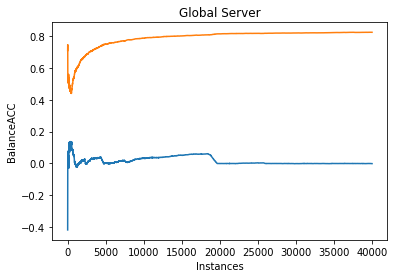

In [9]:
import matplotlib.pyplot as plt
plt.plot(stp_list)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')
plt.plot(bal_acc_list)

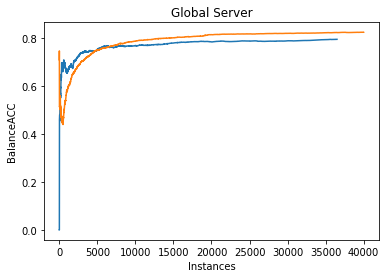

In [10]:
import matplotlib.pyplot as plt
fabboo_bal_acc = [0,0,0,0,0,0,0,0,0,0,0.4,0.4090909090909091,0.4166666666666667,0.4230769230769231,0.42857142857142855,0.43333333333333335,0.4375,0.4411764705882353,0.4444444444444444,0.4473684210526316,0.45,0.4523809523809524,0.45454545454545453,0.45652173913043476,0.4583333333333333,0.46,0.46153846153846156,0.46296296296296297,0.46296296296296297,0.4642857142857143,0.46551724137931033,0.4666666666666667,0.46774193548387094,0.46774193548387094,0.46875,0.4696969696969697,0.47058823529411764,0.4714285714285714,0.4722222222222222,0.47297297297297297,0.47297297297297297,0.47368421052631576,0.47435897435897434,0.475,0.47560975609756095,0.47619047619047616,0.47674418604651164,0.4772727272727273,0.4777777777777778,0.4782608695652174,0.4787234042553192,0.4791666666666667,0.47959183673469385,0.48,0.48,0.48,0.47058823529411764,0.46153846153846156,0.46226415094339623,0.4537037037037037,0.45454545454545453,0.45535714285714285,0.45614035087719296,0.45689655172413796,0.4576271186440678,0.4583333333333333,0.45901639344262296,0.4596774193548387,0.4596774193548387,0.4603174603174603,0.4603174603174603,0.4609375,0.46153846153846156,0.4621212121212121,0.5176767676767676,0.5182421227197347,0.5126865671641792,0.5132352941176471,0.513768115942029,0.5142857142857143,0.5147887323943662,0.5083333333333333,0.5089041095890411,0.549813200498132,0.5503685503685504,0.5509090909090909,0.5514354066985646,0.551948051948052,0.5524475524475525,0.5529344073647872,0.553409090909091,0.5538720538720538,0.5543237250554324,0.5547645125958379,0.5551948051948052,0.5556149732620321,0.5560253699788583,0.5564263322884012,0.5568181818181818,0.5572012257405515,0.5575757575757576,0.557942057942058,0.558300395256917,0.5586510263929618,0.5589941972920697,0.5593301435406699,0.5544507575757576,0.5548266166822868,0.5551948051948052,0.5555555555555556,0.5559090909090909,0.5562556255625563,0.5565953654188949,0.5569285083848191,0.5493527508090615,0.5814040328603436,0.5817307692307693,0.5820512820512821,0.5823657474600871,0.5826743350107836,0.582977207977208,0.5832745236414961,0.5835664335664336,0.5838530838530839,0.5841346153846154,0.5758928571428571,0.5717446270543616,0.5720551378446115,0.5723602484472049,0.5726600985221675,0.5729548229548229,0.5732445520581113,0.5735294117647058,0.5738095238095238,0.5666666666666667,0.5669421487603306,0.5672131147540984,0.567479674796748,0.567741935483871,0.5680000000000001,0.5682539682539682,0.568503937007874,0.56875,0.5689922480620155,0.5692307692307692,0.5694656488549619,0.5696969696969697,0.5699248120300752,0.5701492537313433,0.5666666666666667,0.5669117647058823,0.5671532846715328,0.5673913043478261,0.5676258992805755,0.5642857142857143,0.5645390070921986,0.5647887323943662,0.5650349650349651,0.5652777777777778,0.5620689655172414,0.5589041095890411,0.5591836734693878,0.5594594594594595,0.5597315436241611,0.56,0.5602649006622517,0.5605263157894737,0.5607843137254902,0.5545343137254901,0.554788961038961,0.5492742551566081,0.5495256166982923,0.5497737556561086,0.550018733608093,0.5502606105733433,0.5504994450610433,0.5507352941176471,0.5509682133723054,0.55119825708061,0.5514254781667268,0.5516499282639885,0.5518716577540107,0.5520907158043941,0.5523071504050722,0.5525210084033614,0.5527323355377654,0.5529411764705883,0.5531475748194015,0.5533515731874145,0.5762273901808785,0.573538856775851,0.5737547892720307,0.573968253968254,0.5741792929292929,0.571563088512241,0.571785268414482,0.5922531046717918,0.5924728021170244,0.5926900584795322,0.5929049142192497,0.5931174089068826,0.5933275812482025,0.5935354691075515,0.5937411095305832,0.5939445387662705,0.5914719954967633,0.5916853303471444,0.6101063829787234,0.6103174603174603,0.6105263157894737,0.6107329842931937,0.6109375,0.611139896373057,0.6113402061855671,0.6115384615384616,0.611734693877551,0.6119289340101522,0.6121212121212121,0.6123115577889447,0.6125,0.6291666666666667,0.6293532338308457,0.6295379537953796,0.6297208538587848,0.6274509803921569,0.6276422764227643,0.627831715210356,0.6280193236714976,0.6282051282051282,0.6283891547049442,0.6285714285714286,0.6287519747235387,0.6289308176100629,0.6291079812206573,0.6292834890965732,0.6294573643410852,0.6273148148148148,0.6274961597542242,0.6276758409785933,0.6278538812785388,0.628030303030303,0.6282051282051282,0.6283783783783784,0.6263079222720478,0.6264880952380952,0.6266666666666667,0.6246312684365781,0.6397827835880934,0.6318776452481724,0.6320628232139437,0.6322463768115942,0.6324283273210556,0.6326086956521739,0.6327875023527197,0.6329647676161919,0.6331405112894197,0.6333147528799703,0.6334875115633672,0.6336588061901253,0.6338286552926069,0.6474156118143459,0.6475840336134453,0.6456589958158996,0.6458333333333333,0.64600622406639,0.6441115702479339,0.6442901234567902,0.6444672131147541,0.6446428571428571,0.6371428571428571,0.6373170731707317,0.6354655870445345,0.6356451612903226,0.6338152610441767,0.646122953351869,0.6463076923076924,0.6464909592399632,0.6578869706359746,0.656084656084656,0.656272873664178,0.6564596092155147,0.6566448801742919,0.6568287037037037,0.6570110966998126,0.6571920757967269,0.6554411554411554,0.6537037037037037,0.6642857142857143,0.6644772851669404,0.6646673936750273,0.6648560564910375,0.66504329004329,0.6652291105121294,0.6654135338345865,0.6655965757089353,0.6657782515991472,0.6659585767392459,0.6661375661375661,0.6759897828863346,0.6761674513296857,0.6853628536285363,0.6855392156862745,0.6857142857142857,0.6858880778588807,0.686060606060606,0.6862318840579711,0.6864019253910951,0.6865707434052758,0.6867383512544802,0.6869047619047619,0.6870699881376038,0.6872340425531915,0.687396937573616,0.6959990881112504,0.6961608359836438,0.6963214487832485,0.6887609649122808,0.6889204545454546,0.6890788327526132,0.6892361111111112,0.6893923010380623,0.6895474137931035,0.6897014604810996,0.6898544520547945,0.6900063993174061,0.6884566326530612,0.6886122881355932,0.6887668918918919,0.6889204545454546,0.6890729865771812,0.6892244983277591,0.6877083333333334,0.6878633720930232,0.6880173841059603,0.6881703795379538,0.6883223684210527,0.6884733606557377,0.6869893790849673,0.6871437296416938,0.687297077922078,0.6801948051948052,0.6882161955691368,0.6957792207792208,0.6959315765141008,0.6960829493087558,0.6962333486449243,0.6963827838827839,0.6949338201734367,0.6950864422202002,0.6936507936507936,0.6938065099457504,0.6939612438035151,0.694115004492363,0.6942678011643529,0.6944196428571429,0.6945705384957721,0.69472049689441,0.6948695267580717,0.6950176366843034,0.6951648351648352,0.6953111305872042,0.6939274792485801,0.6940766550522648,0.6873306233062331,0.6874788922661264,0.6876262626262626,0.6877727425310507,0.6879183400267738,0.6880630630630631,0.6882069194943446,0.6883499170812604,0.6884920634920635,0.6886333663039894,0.6887738330046023,0.6889134709931171,0.6890522875816993,0.6877240143369175,0.6864035087719298,0.6865484288953676,0.6852390180878554,0.6923711502199874,0.6925186055620838,0.6926652085611623,0.6928109665861828,0.6929558869214042,0.6930999767675985,0.6932432432432433,0.6868421052631579,0.686984555405608,0.6871261961722488,0.6872670344416282,0.6874070770145703,0.6875463306152706,0.6876848018923714,0.6878224974200207,0.687959423698912,0.6880955871573083,0.6882309941520468,0.6883656509695291,0.6884995638266938,0.6886327388719733,0.6887651821862348,0.6888968997837058,0.6890278976128846,0.6891581815574358,0.6830853070635088,0.6832148829431438,0.6833437565144882,0.6834719334719335,0.683599419448476,0.6837262200165426,0.6779569892473118,0.6780831099195711,0.6782085561497326,0.6783333333333333,0.6784574468085106,0.6785809018567639,0.6787037037037037,0.678825857519789,0.6789473684210526,0.6790682414698163,0.6791884816753927,0.6793080939947781,0.6860154110679488,0.6861344004065041,0.6862527716186253,0.6863705295084039,0.6808536886257094,0.6809708379475822,0.6810873834069711,0.6812033296609132,0.6813186813186813,0.6814334429423944,0.6815476190476191,0.680388949472919,0.6805051970026589,0.6806208559373116,0.6807359307359307,0.6808504258126424,0.6809643455372099,0.681077694235589,0.6811904761904762,0.6813026956418478,0.6814143567874911,0.6815254637835283,0.6816360207449317,0.6817460317460318,0.6764857881136951,0.6714646464646464,0.6715741155396328,0.6716830466830467,0.6717914438502673,0.6669934640522875,0.6671013311600109,0.6672086720867209,0.6673154906731549,0.6674217907227616,0.6628324187420853,0.6584383391861186,0.6585441244655093,0.6647497982243745,0.6648550724637681,0.6649598393574297,0.6650641025641025,0.665167865707434,0.6652711323763956,0.6653739061256961,0.6654761904761904,0.6655779889152811,0.6656793048973144,0.6657801418439716,0.6717325227963525,0.671832884097035,0.6719327731092437,0.6720321931589537,0.6721311475409836,0.6722296395193591,0.6723276723276723,0.6724252491694352,0.6725223732184289,0.6782366589327146,0.6783333333333333,0.6784295612009238,0.6785253456221199,0.6786206896551724,0.6787155963302752,0.6788100686498856,0.6777625570776256,0.6778587699316628,0.6779545454545455,0.6736408199643493,0.669493006993007,0.6684545613117042,0.668552036199095,0.6675204028477166,0.6676195426195426,0.6677182368193604,0.6678164884442911,0.6732591589813013,0.6692409898687925,0.6693388018891375,0.6694361772486772,0.6695331188649674,0.6696296296296296,0.6697257124086393,0.669821370042609,0.6699166053470689,0.6700114211127427,0.6701058201058201,0.6701998050682261,0.6691992868141665,0.6744181420330216,0.6745136959110758,0.6746088334323629,0.6736166007905138,0.6786490683229813,0.683504958047292,0.6836016288008524,0.6836978810663021,0.6827138039483157,0.6828115547489413,0.6829088851160159,0.683005797756193,0.6831022953529433,0.6791700509488297,0.6792661361626879,0.6793618116314977,0.679457079970653,0.6795519437733363,0.679646405610754,0.6797404680323686,0.6759415200487333,0.6722692036645526,0.6723628691983122,0.6714035087719299,0.671498599439776,0.6761434081829453,0.6806383843860124,0.6849906629318394,0.6850853548966757,0.6851796506608222,0.6842297113695861,0.6843253968253968,0.6844206844206844,0.6845155766317592,0.6846100759144237,0.6847041847041847,0.6889204545454546,0.6879832474226804,0.6880787037037037,0.6881737679671458,0.6882684426229508,0.6883627300613497,0.6884566326530612,0.6885501527494908,0.6886432926829269,0.6887360547667343,0.6888284412955465,0.6889204545454546,0.6890120967741935,0.689103370221328,0.6891942771084337,0.6892848196392786,0.6933713581008171,0.697334062063521,0.7011784763556965,0.7012686567164179,0.7013584770756993,0.7014479395849438,0.7015370463784457,0.7016257995735607,0.7017142012708734,0.7018022535543625,0.7018899584915659,0.7019773181337408,0.7020643345160249,0.7021510096575944,0.702237345561819,0.7023233442164178,0.7060546875,0.706140350877193,0.7052529182879377,0.7043689320388349,0.7034883720930232,0.70357833655706,0.7036679536679536,0.703757225433526,0.7028846153846153,0.7029750479846449,0.7030651340996168,0.7021988527724665,0.7022900763358779,0.7023809523809523,0.7024714828897338,0.7025616698292221,0.7061848582350192,0.7062747035573123,0.706364209199748,0.7064533770850424,0.706542209121428,0.7066307072027895,0.706718873208799,0.706806709005048,0.7068942164431803,0.7069813973610211,0.7070682535827059,0.7071547869188083,0.707240999166465,0.7036178107606679,0.7037037037037037,0.7001825769431403,0.7002681523521908,0.700353411984824,0.7004383575856613,0.7005229908864954,0.6996898824137485,0.69977557653614,0.6998609573345006,0.6999460265241082,0.7000307858077426,0.6992061459667094,0.6983844993737379,0.698471626862625,0.6985584392430533,0.6986449382213861,0.6987311254916888,0.6979177221602999,0.6980049055554151,0.698091776465243,0.698178336566807,0.7016994633273703,0.7017857142857142,0.7018716577540107,0.7019572953736655,0.7020426287744228,0.7021276595744681,0.702212389380531,0.7014134275618374,0.7014991181657848,0.7015845070422535,0.7016695957820738,0.7017543859649122,0.7018388791593695,0.7019230769230769,0.7020069808027923,0.7020905923344948,0.7021739130434783,0.7022569444444444,0.7023396880415944,0.7015570934256055,0.7016407599309153,0.7008620689655172,0.7009466437177281,0.7001718213058419,0.7002572898799314,0.699486301369863,0.6987179487179487,0.7021426062521954,0.7013768759642807,0.6979522184300342,0.6971890971039183,0.6964285714285714,0.6956706281833616,0.6949152542372881,0.6941624365482233,0.6942567567567568,0.6943507588532883,0.6944444444444444,0.6945378151260504,0.6946308724832215,0.6947236180904522,0.6948160535117056,0.6949081803005008,0.6950000000000001,0.6950915141430949,0.6951827242524917,0.695273631840796,0.695364238410596,0.6954545454545454,0.6955445544554455,0.6956342668863262,0.6957236842105263,0.6958128078817734,0.6959016393442623,0.6959901800327333,0.6952614379084967,0.6945350734094617,0.6938110749185668,0.693089430894309,0.6931818181818181,0.6965151515151515,0.6966072393300919,0.6966990291262136,0.696790522347873,0.6968817204301075,0.6969726247987118,0.6936392914653784,0.6929260450160772,0.6930176565008026,0.6931089743589743,0.6924,0.6924920127795526,0.6925837320574162,0.6926751592356688,0.6927662957074722,0.692063492063492,0.6921553090332805,0.692246835443038,0.6915481832543444,0.6916403785488958,0.6917322834645669,0.6918238993710693,0.6919152276295133,0.6912225705329154,0.6905320813771518,0.690625,0.6907176287051482,0.690809968847352,0.6940567220941052,0.6941487750196926,0.694240542066629,0.6943320245645827,0.6944232238349886,0.6945141411911118,0.6946047779381113,0.6946951353731015,0.6947852147852147,0.6948750174556626,0.6916282642089093,0.691717791411043,0.6918070444104134,0.6918960244648318,0.6887314675028064,0.6888201758624022,0.688908613769682,0.6889967824595881,0.6890846831595553,0.6859992401215805,0.6860868740515933,0.6861742424242424,0.6831649831649832,0.6802291204730229,0.6803162244935611,0.6804030653599586,0.6804896442629584,0.6805759623861298,0.6806620209059233,0.6807478209917235,0.6808333638059019,0.6809186505038702,0.6810036822341318,0.6810884601383327,0.681172985351314,0.6812572590011614,0.6813412822092559,0.6814250560903234,0.6815085817524842,0.6815918602973012,0.6816748928198293,0.6817576804086625,0.6818402241459822,0.681922525107604,0.6820045843630242,0.6820864029754667,0.6821679820019284,0.6822493224932249,0.6823304254940359,0.6794653064814,0.6795461730303137,0.679626804159871,0.6797072008966097,0.6797873642611083,0.6798672952680287,0.6770703933747413,0.6771500930328715,0.6772295623451693,0.6773088023088023,0.6773878139151914,0.6774665981500514,0.6775451559934318,0.6776234884197582,0.6777015963978714,0.6777794808910689,0.6778571428571429,0.6779345832484207,0.678011803011803,0.678088803088803,0.6781655844155845,0.678242147922999,0.6783184945366248,0.6783946251768034,0.6784705407586764,0.6785462421922224,0.6786217303822938,0.675890637945319,0.675965913791677,0.6760409781890284,0.6761158320270605,0.6761904761904762,0.6762649115590292,0.6763391390075583,0.6764131594060218,0.6764869736195314,0.6765605825083858,0.6766339869281046,0.6767071877294607,0.67403960907009,0.6741126070991432,0.6741854031972724,0.6742579982012078,0.6743303929430633,0.6737138830162086,0.673786827036883,0.6738595706618963,0.6739321147159217,0.6740044600191144,0.6740766073871409,0.671470352375112,0.6715423026191822,0.6716140565460789,0.6716856149581885,0.6717569786535305,0.6718281484257871,0.6718991250643336,0.6719699093542659,0.6720405020764313,0.6721109040074558,0.6715063520871143,0.6715772841342132,0.6716480252471342,0.6717185761957731,0.6717889377458921,0.6718591106591476,0.6719290956931173,0.6719988936013277,0.6720685051332811,0.6721379310344828,0.6695909090909091,0.6696601501028931,0.6697292069632496,0.6697980804056501,0.6698667711598746,0.6699352799518362,0.6700036075036075,0.673131799536294,0.6731999465661318,0.672608283181643,0.6720181788574559,0.672087522176227,0.6721566832523734,0.6722256628033856,0.6722944615429927,0.6723630801811871,0.6724315194242492,0.6724997799747705,0.6725678625316789,0.6700709836303056,0.6701388888888888,0.6702066175408178,0.6702741702741702,0.6703415477734544,0.6704087507196315,0.6704757797901394,0.6705426356589147,0.6706093189964157,0.670675830469645,0.6707421707421708,0.6683001683001684,0.6683663380321478,0.6684323378803482,0.6684981684981686,0.6685638305356616,0.6686293246395548,0.6686946514532721,0.6687598116169544,0.6688248057674809,0.6688896345384895,0.6689542985603977,0.6690187984604228,0.6690831348626025,0.6691473083878148,0.6692113196537975,0.6692751692751693,0.669338857863448,0.6694023860270711,0.6694657543714148,0.6695289634988127,0.667140048066419,0.6648025071594532,0.6648655576692165,0.6649284501576522,0.6649911852180818,0.6650537634408602,0.6627659574468086,0.6605263157894736,0.660588737762008,0.6606510040687754,0.6607131152913417,0.6607750720083791,0.6608368747956849,0.6608985242261982,0.6609600208700189,0.6610213652944241,0.6588283828382838,0.6588895756077462,0.6589506172839507,0.6590115084258118,0.6584564860426929,0.6563087197196689,0.6563700688553278,0.6564312672560095,0.659429373715088,0.6594904219356454,0.6589385754301721,0.659000074938176,0.6590614240806347,0.6591226234083377,0.6591836734693878,0.6592445748092173,0.6586970554645215,0.661634594116346,0.6616959387311757,0.6617571344513092,0.6612121212121213,0.6612737544940935,0.6613352387233886,0.6613965744400527,0.6614577621815257,0.6615188024826579,0.6593975903614457,0.6594584837545127,0.6595192307692308,0.6595798319327731,0.6596402877697841,0.6597005988023952,0.6597607655502392,0.659820788530466,0.6592840095465393,0.6593444576877234,0.6594047619047619,0.6594649227110583,0.6595249406175772,0.6595848161328588,0.6596445497630332,0.6625158368917461,0.6625754291405472,0.6626348805093275,0.6626941914970718,0.662753362600411,0.6628123943136363,0.6628712871287129,0.6607843137254902,0.6608430681320707,0.660901684617509,0.6609601636668736,0.661018505762961,0.6610767113863089,0.6611347810152098,0.6611927151257235,0.6612505141916907,0.6640584334759092,0.6641160979689636,0.6620623264977165,0.6621198568872988,0.6621772536406683,0.661654470819204,0.6617122738211961,0.6611912393162394,0.661249444197421,0.6613075146562445,0.6613654511578387,0.6614232541651897,0.6609055501460565,0.6609637488947834,0.6610218140068886,0.6610797459421313,0.6590650939274793,0.6591228931435117,0.6591805600958919,0.6592380952380953,0.6592954990215264,0.6593527718955313,0.6594099143074086,0.6594669267024216,0.6574902869899328,0.6575471698113208,0.6576039235003106,0.657660548496128,0.6577170452360093,0.6572078032954837,0.6552681101196769,0.6553249907598078,0.6553817430012026,0.6554383672781295,0.6554948640229014,0.6555512336658852,0.655607476635514,0.6556635933582974,0.6537598204264871,0.653815811327022,0.6538716768280038,0.6539274173502362,0.6539830333126423,0.6540385251322751,0.654093893224328,0.6541491380021447,0.6542042598772299,0.6542592592592592,0.6543141365560899,0.6524452952377073,0.6525000508553876,0.6525546851981672,0.652609198668507,0.6526635916670891,0.6527178645928267,0.6527720178428735,0.6528260518126339,0.6528799668957721,0.6529337634842223,0.6529874419681971,0.6530410027361984,0.6530944461750254,0.653147772669785,0.6532009826039004,0.6532540763591203,0.6533070543155284,0.653359916851552,0.6534126643439718,0.6534652971679298,0.6535178156969389,0.6535702203028917,0.6536225113560687,0.6536746892251479,0.6518398268398269,0.6518918918918919,0.6545945945945946,0.6546465471951434,0.6546983877080964,0.6547501164958062,0.6574045566502462,0.6574561740735045,0.6575076804915514,0.6575590762620838,0.657610361741263,0.6576615372837238,0.6577126032425817,0.6572288006111535,0.6572802197802198,0.6567979112669614,0.6568496801705757,0.6569013388102845,0.656952887537994,0.6570043267041141,0.6570556566575675,0.657106877745796,0.65715799031477,0.6572089947089947,0.6567313500453036,0.6593388089580722,0.6593901561521713,0.6594413950188567,0.6594925259005753,0.6595435491383326,0.6590687027162838,0.661630416735846,0.6616817779743476,0.6617330314243111,0.6617841774246938,0.6618352163130339,0.661886148425457,0.6619369740966837,0.6619876936600373,0.6620383074474507,0.6620888157894737,0.6616189276521167,0.6616697669329248,0.6617205006285183,0.6598898370129577,0.6599404654519213,0.6599909889614778,0.6600414078674948,0.6595746594127961,0.6596254042400287,0.6596760443307758,0.6597265800089646,0.6592620785384856,0.6593129361245303,0.6593636891728852,0.6594143380055352,0.6594648829431438,0.6595153243050605,0.6595656624093276,0.6591046501289233,0.6591553048807568,0.6592058562555457,0.6592563045694279,0.6593066501372532,0.6593568932725905,0.6594070342877342,0.65945707349371,0.6595070112002822,0.6595568477159597,0.6596065833480022,0.6596562184024267,0.659705753184014,0.6597551879963146,0.6598045231416549,0.6580054226918799,0.6580546584713686,0.6581037951849025,0.6581528331311731,0.6582017726076721,0.6582506139106976,0.6582993573353604,0.6583480031755894,0.6583965517241379,0.6584450032725895,0.6584933581113634,0.6585416165297212,0.6580917708476439,0.6581403328186652,0.6581887982450126,0.6582371674143067,0.6607423250918782,0.6607905982905983,0.66325329566855,0.6656746031746031,0.6657227806880929,0.6652758132956152,0.6676567656765677,0.6658661320677522,0.665914608725507,0.6654689184333453,0.6637076394738547,0.663756412538637,0.6638050894040806,0.6638536703545183,0.6639021556731638,0.6639505456421168,0.6639988405423685,0.6640470406538072,0.6640951462552234,0.6641431576243156,0.6641910750376953,0.6642388987708924,0.6642866290983607,0.6643342662934826,0.664381810628575,0.6644292623748942,0.6644766218026408,0.6645238891809652,0.6645710647779723,0.6646181488607272,0.6646651416952599,0.6647120435465698,0.6647588546786314,0.6648055753543993,0.6648522058358124,0.6648987463837994,0.6649451972582836,0.6649915587181874,0.6650378310214375,0.6650840144249697,0.6674164147981538,0.6674625095579171,0.6675085159288794,0.6675544341650312,0.6676002645193916,0.6676460072440112,0.6676916625899784,0.6677372308074225,0.66778271214552,0.6678281068524972,0.667873415175636,0.6679186373612785,0.6679637736548305,0.6680088243007667,0.6680537895426348,0.6680986696230599,0.6676704278868711,0.6677155854734351,0.6677606577765494,0.6678056450375824,0.6678505474969925,0.6678953653943319,0.6674697320820809,0.667514823644477,0.6675598305278827,0.6676047529706066,0.667649591210064,0.6676943454827806,0.6699891264951069,0.670033797036724,0.6700783840820018,0.6701228878648233,0.6701673086181993,0.6702116465742717,0.670255901964318,0.6725139664804469,0.6725581395348837,0.6721375464684015,0.6721819870009285,0.672226345083488,0.6722706209453198,0.6723148148148148,0.6723589269195189,0.6724029574861368,0.6724469067405355,0.6724907749077491,0.6725345622119816,0.6725782688766114,0.672621895124195,0.6726654411764705,0.6727089072543618,0.6722935779816513,0.6718790100824932,0.671923076923077,0.6719670631290028,0.674189285351225,0.6724395040738846,0.6724834098662713,0.6725272354654298,0.6721147767113053,0.6717030699330313,0.6717474864822225,0.6717918222005689,0.6718360773085182,0.6718802520257174,0.6719243465710162,0.6719683611624703,0.6720122960173456,0.6720561513521217,0.6716478478164913,0.6716919531400039,0.6717359788510191,0.6717799251648999,0.6718237922962332,0.6718675804588332,0.6714616495779755,0.6715056844309555,0.671549640226749,0.6698271992818672,0.6698710762331839,0.6699148745519714,0.6699585944494181,0.670002236135957,0.670045799821269,0.6700892857142857,0.6701326940231935,0.6701760249554367,0.6684802885213281,0.6685235422836119,0.6685667190819057,0.668609819121447,0.6707863247863248,0.6708293482716219,0.6708722954064569,0.6691987780840846,0.6692416490715175,0.6692844441138885,0.6688846855367155,0.6689277205202449,0.6689706794702344,0.6711103972588072,0.6732179388400329,0.6732608219578071,0.6733036294439803,0.6733463614984598,0.673389018320449,0.6734316001084505,0.6734741070602693,0.6735165393730155,0.6755926251097454,0.6756349829798377,0.675677266603006,0.675719476174295,0.6753241665687312,0.6753666110009394,0.6774119399119399,0.6774543102054019,0.6774966065541982,0.6775388291517324,0.6775809781907343,0.6776230538632627,0.6776650563607085,0.6772725810084628,0.6773148148148148,0.6773569753621791,0.6773990628410039,0.6774410774410775,0.6770504933999744,0.6770927366432984,0.6771349069276531,0.6771770044418879,0.6772190293742018,0.6768303186907838,0.6764422770446867,0.6764848253240343,0.6785000758686965,0.678542551041035,0.6785849532946225,0.678627282817072,0.6786695397953526,0.6787117244157937,0.678753836864087,0.6787958773252891,0.6788378459838248,0.6788797430234893,0.678921568627451,0.6789633229782543,0.6790050062578222,0.679046618647459,0.6790881603278525,0.6791296314790772,0.6791710322805967,0.6792123629112662,0.6788302535239329,0.6808160843526148,0.6808576333567997,0.6804764578487206,0.6805182235154863,0.6805599186916751,0.6806015435555939,0.6806430982849483,0.6802637076359703,0.6803054766012044,0.6803471753664969,0.6803888041086739,0.6787226663746212,0.6787642252699153,0.6788057144939684,0.6788471342218338,0.6788884846279789,0.6789297658862876,0.6772876013570415,0.6773288136408167,0.6773699571227826,0.6774110319750871,0.6774520383693046,0.6774929764764375,0.6758742714404663,0.6759151414309484,0.6759559434746467,0.6759966777408638,0.6760373443983403,0.6779876990082694,0.6780282982251862,0.6780688301691669,0.67810929500728,0.6781496929060415,0.6781900240314167,0.6782302885488225,0.6782704866231304,0.6783106184186678,0.6783506840992206,0.6779791611942911,0.6799020460209818,0.6799423183839881,0.6799825245639821,0.6783820124000897,0.6784221525600835,0.678462226862555,0.6785022354694485,0.6769239526411658,0.6769638957138957,0.6770037734133478,0.6770435858998819,0.6770833333333334,0.6771230158730158,0.6771626336777234,0.6772021869057322,0.6772416757148028,0.6772811002621825,0.677320460704607,0.6773597571983031,0.67739898989899,0.6774381589618816,0.6774772645416892,0.6775163067926225,0.6775552858683926,0.6794470483205,0.6794859643743205,0.6795248175589104,0.6795636080264953,0.6796023359288098,0.6796410014170997,0.6796796046421234,0.6793158931395122,0.6793546956425325,0.6793934358122145,0.6794321137986384,0.6794707297514033,0.6791086427939876,0.6791474558957511,0.6791862068965517,0.6792248959453127,0.6792635231904814,0.6793020887800314,0.679340592861464,0.6793790355818107,0.6794174170876346,0.6794557375250323,0.679493997039636,0.6813598449376048,0.681000903086816,0.6810393563818221,0.6810777486882557,0.6811160801510974,0.681154350914869,0.6811925611236345,0.6812307109210027,0.6812688004501287,0.6813068298537155,0.6813447992740158,0.6809886978205253,0.6810268579441269,0.681064958020327,0.6807099164297407,0.6825503786420228,0.682588667831626,0.6822344322344323,0.6822729091636655,0.6823113257842321,0.6823496822378129,0.6823879786656447,0.6824262152085229,0.6824643920068028,0.6825025092004015,0.6821505513281756,0.6821888537176367,0.6822270964460551,0.6822652796527171,0.6823034034764761,0.6819529676672534,0.6819912747707779,0.682029522437369,0.6820677108052523,0.6821058400122249,0.6821439101956572,0.6821819214924949,0.6839975125938003,0.6840354651405656,0.6836872586872587,0.6837253920587254,0.6821609081116911,0.6821989826807346,0.6822369985832618,0.6822749559547613,0.6823128549303046,0.6819663758905128,0.6816204290765884,0.6816587431173287,0.6816969983942027,0.6817351950422998,0.6801915708812261,0.6802297090352221,0.6802677888293802,0.6803058103975536,0.6799618029029794,0.68,0.6796567505720824,0.6796951219512195,0.6793526275704493,0.6793911719939117,0.6794296577946768,0.679468085106383,0.6795064540622627,0.6795447647951441,0.6795830174374526,0.6813710969076513,0.6798461753321894,0.6795055821371611,0.6795440057372804,0.6795823712078988,0.679620678680829,0.6796589282874861,0.6796971201588877,0.679735254425657,0.6797733312180225,0.6798113506658212,0.679849312898499,0.6798872180451128,0.6799250662343311,0.6799628575944365,0.6800005922533265,0.6800382703385149,0.6800758919771339,0.6801134572959344,0.6801509664212888,0.6819139523174016,0.6819514053753041,0.6816153894966002,0.6816530094624915,0.681690573321051,0.6834306632964351,0.6834681711730892,0.6835056231928905,0.6835430194805194,0.6835803601602858,0.6832461743308698,0.6832836799429227,0.6850013171444309,0.6850387671101752,0.6850761615533609,0.6851135005973716,0.6868091168091168,0.6868464005769706,0.6868836291913215,0.6869208027744613,0.6869579214483202,0.6854472240777503,0.6854842879638987,0.6871572703068802,0.68719427952653,0.6868627743626577,0.6865317574243582,0.6862012276338707,0.6862388309754281,0.686276379058585,0.6863138720050559,0.6863513099361981,0.6863886929730131,0.6864260212361478,0.688077959776073,0.6881152333858209,0.6881524524621239,0.6881896171245725,0.6882267274924083,0.6882637836845247,0.687936088518228,0.6895673778264041,0.6896045918367347,0.6896417516387473,0.6896788573508006,0.6897159090909091,0.6897529069767442,0.6897898511256354,0.6898267416545718,0.6895009970993473,0.6895380434782609,0.6895750362056481,0.6896119753979739,0.6896488611713666,0.6896856936416185,0.6897224729241878,0.6897591991341991,0.6897958723864456,0.6894722622478386,0.6891491180705543,0.6891861510791367,0.6892231308411215,0.6908341556858419,0.6908710823159849,0.6909079559287119,0.6909447766381208,0.6909815445579821,0.6906600936126288,0.6903391028690584,0.6903762251308436,0.6904132943229192,0.6904503105590063,0.6904872739525006,0.6905241846164751,0.6905610426636799,0.6905978482065438,0.690634601357176,0.6903156834506949,0.6888203993467151,0.6888573007975993,0.6888941498316499,0.688930946560471,0.6889676910953506,0.6890043835472609,0.6890410240268597,0.6890776126444916,0.6891141495101891,0.6891506347336736,0.6891870684243565,0.6892234506913406,0.6889071723345348,0.6889437005716076,0.6874667635118484,0.6860078378796473,0.6860443146684988,0.686080740117746,0.6876698014629049,0.6877061756808592,0.6877424987755276,0.6877787708546135,0.6874641148325359,0.687500531259297,0.6875368966469176,0.6875732111026229,0.6876094747333376,0.6876456876456876,0.6876818499460009,0.6877179617403081,0.6874051047812387,0.6874413591986814,0.68712913103157,0.687165527137672,0.6868539254760548,0.686890462342479,0.6869269484279907,0.6866161616161617,0.6866527874161461,0.686342621779515,0.6863793863793863,0.6864161000587593,0.6864527629233512,0.6864893750785868,0.6865259366295994,0.6865624476812322,0.6865989083380388,0.6851567761730151,0.6848483589530536,0.6834234978319224,0.6834600956598175,0.6834966430774814,0.6831890245661465,0.6832257081435479,0.6832623412967879,0.6832989241297625,0.6833354567460823,0.6819275582573454,0.6819640407603371,0.6820004732530436,0.6820368558382257,0.6820731886183631,0.6821094716956551,0.682145705172021,0.6821818891491023,0.6822180237282627,0.6822541090105892,0.6822901450968936,0.6808989081287335,0.6795240386543165,0.6795600256451355,0.679595963640732,0.6796318527410965,0.6796676930459471,0.6797034846547314,0.6797392276666268,0.6797749221805411,0.6798105682951147,0.6798461661087198,0.6798817157194632,0.679917217225185,0.6799526707234618,0.6799880763116057,0.6800234340866664,0.6800587441454314,0.6800940065844274,0.6801292214999207,0.6787704323702337,0.6788055998582314,0.6788407200144821,0.678875792934477,0.6789108187134503,0.6789457974463806,0.6789807292279917,0.6790156141527528,0.6790504523148801,0.6790852438083376,0.6791199887268372,0.6791546871638404,0.679189339212559,0.6792239449659553,0.6792585045167435,0.6792930179573907,0.6793274853801169,0.6793619068768969,0.67939628253946,0.6794306124592919,0.679132449919124,0.6791669095218666,0.6792013233615246,0.679235691529199,0.6792700141157492,0.6793042912117936,0.6779613019557076,0.6779955336516248,0.678029720037554,0.6780638612033961,0.6780979572388139,0.6781320082332339,0.6781660142758462,0.6781999754556053,0.6768725120868729,0.6769064284924993,0.6769403002124792,0.676974127335066,0.6770079099482811,0.6770416481399141,0.6770753419975238,0.6771089916084394,0.6771425970597605,0.6771761584383588,0.6772096758308775,0.6772431493237335,0.6772765790031171,0.6773099649549934,0.6773433072651026,0.6760311020960108,0.676064400849869,0.6760976561327692,0.6761308680297816,0.676164036625755,0.6761971620053165,0.6762302442528736,0.6762632834526133,0.6762962796885043,0.6763292330442966,0.6763621436035229,0.6763950114494991,0.6764278366653249,0.6764606193338846,0.6764933595378476,0.6765260573596696,0.6765587128815929,0.6765913261856467,0.6766238973536488,0.6766564264672054,0.6766889136077123,0.676398986193557,0.676431597345657,0.676464166500137,0.6764966937380731,0.6765291791403334,0.6765616227875779,0.6765940247602595,0.6766263851386245,0.6766587040027132,0.6766909814323607,0.6767232175071977,0.6767554123066508,0.6767875659099433,0.676819678396096,0.6768517498439279,0.6768837803320562,0.6769157699388978,0.6769477187426695,0.6769796268213886,0.6770114942528735,0.6757142857142857,0.6744318181818182,0.6744636450436896,0.6744954314133703,0.6745271773680864,0.6745588829848677,0.6745905483405483,0.6746221735117675,0.6746537585749697,0.6733857822010612,0.6721320527527022,0.6736856275439895,0.6737171725754261,0.6737486776511546,0.6737801428470405,0.673811568238757,0.6738429539017862,0.6738742999114191,0.6739056063427571,0.6739368732707118,0.6739681007700057,0.6739992889151731,0.6740304377805608,0.6740615474403282,0.673778152559643,0.673809381682579,0.6738405715729485,0.6738717223046358,0.6739028339513399,0.6736204269627502,0.6751567398119123,0.675187969924812,0.6752191609267376,0.6752503128911139,0.675281425891182,0.6753125,0.6753435352904434,0.675374531835206,0.6754054897067998,0.6754364089775561,0.6754672897196262,0.6754981320049813,0.6755289359054139,0.6770482729219884,0.6785509139273919,0.6785816795145153,0.6786124068597654,0.6786430960344004,0.6786737471095013,0.678704360155973,0.6784249538434287,0.6784556831025232,0.6772096613646983,0.6772403525689827,0.6772710057891035,0.6773016210955322,0.6773321985585659,0.6773627382483284,0.6770845982594617,0.6771152530145663,0.6771458699709594,0.6786307832520238,0.6786613624795735,0.678384022274577,0.6784147157190635,0.6784453714102359,0.6799142315747482,0.6796375355072344,0.6796683046683046,0.6796990360526273,0.6797297297297298,0.6797603857689695,0.6797910042395336,0.6798215852104401,0.681274651179635,0.6813051947197325,0.6813357008977015,0.6810605463101717,0.6810911646665484,0.6825286898232387,0.6825592707945649,0.6825898144492697,0.682620320855615,0.6826507900816966,0.6826812221954445,0.6827116172646229,0.6827419753568316,0.6827722965395056,0.6841945288753799,0.6842248132157907,0.6842550607810461,0.6842852716380914,0.6843154458537088,0.685722628111955,0.6871149979253774,0.6871451355661882,0.6885229255909884,0.6885530267234518,0.6885830914138661,0.6886131197283695,0.6886431117329399,0.6900065497783152,0.6900365055387714,0.690066425120773,0.6897945584389459,0.6911438675926592,0.691173897010569,0.6912038902266487,0.6912338473063238,0.6912637683148612,0.692599167064928,0.6926290520674383,0.6926589011288753,0.6939806034815055,0.6952888190754354,0.6953186322605965,0.6953484096341239,0.6953781512605042,0.6954078572040694,0.6954375275289972,0.6954671622993116,0.6954967615788831,0.6955263254314292,0.6955558539205156,0.6952864827939544,0.6950174334966961,0.6950472129150167,0.6950769567970386,0.6951066652063329,0.6951363382063195,0.6951659758602666,0.6964609100776085,0.6964905124486342,0.6962226376008962,0.6962523464331198,0.69628201996073,0.6975638740344623,0.6975935123203532,0.6976231154272697,0.6988920865454871,0.6986250946309245,0.6986548033588214,0.6986844768868037,0.69841808212168,0.6984478606047991,0.69847760386795,0.6985073119735795,0.6985369849839866,0.6985666229613238,0.6985962259675961,0.698625794064663,0.6986553273142376,0.6986848257778883,0.6999411071849234,0.699970570924073,0.7012143520186004,0.7009496634474686,0.7021811298776937,0.7022106972602022,0.7022402298984305,0.7009965094672741,0.7010260074224275,0.700762043525521,0.7019814968240817,0.7020110976942097,0.7017475806266235,0.701777283848513,0.7018069522891124,0.7018365860094768,0.7018661850705195,0.7018957495330101,0.7019252794575774,0.7019547749047079,0.7019842359347472,0.7031917921279562,0.7032212188011093,0.7032506111774405,0.7032799693168743,0.7033092932791959,0.7045051256258689,0.704534415470724,0.7045636712576202,0.7045928930459261,0.7046220808948728,0.7046512348635536,0.7046803550109251,0.7047094413958069,0.7047384940768824,0.7047675131126989,0.7047964985616685,0.7048254504820677,0.7048543689320388,0.7048832539695894,0.7046234220498218,0.7046524070162858,0.7043930079170446,0.7044220922749783,0.7044511431255872,0.7044801605267423,0.7045091445361815,0.7045380952115098,0.7045670126101997,0.704595896789592,0.7046247478068953,0.7043667039865426,0.7043956533357085,0.7044245695051048,0.7041670837086711,0.7041960976097721,0.7042250783141899,0.7042540258788657,0.7042829403606103,0.7043118218161051,0.7043406703019018,0.7043694858744234,0.7031383053481817,0.7031670880637219,0.7031958379784466,0.703224555148394,0.7029686636476866,0.7029974773705298,0.7017781351185788,0.7018069160799405,0.7005992421748981,0.700627990430622,0.7006567060364245,0.7006853890478957,0.7007140395204998,0.7018988196526483,0.7019274376417233,0.7019560232024822,0.703129573191198,0.7031581263787283,0.7019621145750978,0.7019906354443626,0.7020191240502007,0.7031817602447263,0.7032102166418522,0.7032386408848572,0.7043904113205555,0.7041364770946241,0.7041649965190608,0.7041934837726858,0.7042219389099031,0.704250361984994,0.7030658368817557,0.7030942279488791,0.7031225870620723,0.7031509142752506,0.7031792096422083,0.7032074732166188,0.703235705052035,0.7032639052018896,0.7032920737194955,0.7033202106580456,0.7033483160706143,0.7033763900101565,0.7031246339844615,0.7031528016232247,0.7031809377721736,0.7032090424840847,0.7032371158116162,0.703265157807309,0.7032931685235866,0.7021196112453781,0.7018688839341014,0.7018969875167647,0.7016466633671534,0.701674859333457,0.7017030239360607,0.7017311572272662,0.7017592592592592,0.7029006656426011,0.7029287364674515,0.7040596712325975,0.7040877109022594,0.7041157194685717,0.7041436969832584,0.7041716434979288,0.7041995590640779,0.7042274437330869,0.7042552975562231,0.7040067247858566,0.7040346697754574,0.7040625839036672,0.7040904672215809,0.7041183197801808,0.704146141630337,0.7041739328228069,0.7042016934082367,0.7042294234371607,0.7042571229600023,0.7042847920270741,0.7043124306885775,0.7043400389946042,0.7043676169951358,0.7043951647400444,0.7044226822790922,0.7044501696619329,0.7042038043751319,0.7042313814695972,0.7042589283921867,0.7042864451923896,0.7043139319195868,0.7043413886230515,0.704368815351949,0.7043962121553377,0.7044235790821686,0.7044509161812864,0.7055715227750612,0.705598830095204,0.7053539247780901,0.7051092859520722,0.7051368000774692,0.705164284296208,0.7051917386570232,0.7052191632085434,0.7063295824696476,0.7063569772603956,0.7063843423387892,0.7064116777531412,0.7064389835516596,0.7064662597824483,0.7062229437229437,0.7062503072914106,0.7062776412776413,0.7063049457295811,0.7063322206950717,0.705170147474175,0.7051973930009547,0.7052246091366594,0.706325257296131,0.7063524440882931,0.7063796015843429,0.7061374783507255,0.7061647223111163,0.7061919369611678,0.7062191223481546,0.70624627851925,0.7062734055215258,0.7063005034019527,0.7063275722074005,0.7063546119846388,0.7063816227803366,0.7052302471894991,0.7052572290502257,0.7052841820224504,0.7053111061525432,0.705338001486775,0.7041969060351413,0.7042237726196838,0.7042506105006106,0.7042774197238959,0.704304200335417,0.7040642857142857,0.7038246268656716,0.7038516059060811,0.7038785562148182,0.7039054778377556,0.7039323708206686,0.7028014184397163,0.7028282828282828,0.7028551186680836,0.7028819260046026,0.7039733714323312,0.7037347575296394,0.7037616487875872,0.7037885115288245,0.7038153457986878,0.7038421516424178,0.7038689291051594,0.7038956782319614,0.703922399067778,0.7039490916574679,0.7039757560457952,0.7040023922774294,0.7028815782740767,0.7029081863935932,0.702934766445473,0.7029613184741036,0.7029878425237788,0.7030143386386993,0.7030408068629724,0.703067247240613,0.7030936598155431,0.7041756599701146,0.7042020447861641,0.7042284018870706,0.7042547313164802,0.704281033117947,0.7043073073349341,0.7040714995034757,0.7040978559547113,0.7041241848075687,0.7041504861053733,0.7052230364769354,0.7052493102629223,0.7063125341095142,0.706338780426828,0.7073927988721507,0.7074190177638453,0.7074452092728856,0.7084901413523004,0.7082553451875315,0.7082816181893403,0.7083078637949013,0.7083340820470432,0.7083602729885058,0.7083864366619397,0.7084125731099071,0.7073026130684685,0.7083388920017433,0.7083650012667173,0.7083910833910834,0.7084171384171385,0.7084431663870916,0.7084691673430646,0.7084951413270916,0.7085210883811195,0.7085470085470086,0.7085729018665321,0.7083399692095345,0.7083659428460256,0.7081333580816518,0.7081594116477838,0.7081854382990747,0.70821143807721,0.7082374110237888,0.7092648705618865,0.7092908167184225,0.7093167361263435,0.709342628826992,0.7093684948616255,0.7093943342714162,0.709420147097452,0.7094459333807361,0.7094716931621876,0.709497426482641,0.708397534668721,0.7084232415689277,0.7084489220895548,0.7084745762711864,0.7085002041543234,0.7085258057793831,0.7095449003942726,0.7095704758015906,0.7095960250314188,0.7085057154898807,0.7085312385823894,0.7085567355776667,0.7085822065157182,0.7086076514364683,0.7086330703797599,0.7086584633853541,0.7086838304929315,0.7087091717420914,0.7087344871723524,0.7087597768231528,0.7087850407338507,0.7088102789437241,0.7088354914919706,0.7088606784177085,0.7088858397599771,0.7089109755577359,0.708936085849865,0.7089611706751666,0.7089862300723635,0.7087579712736158,0.7087831081799809,0.708555183206886,0.7085803972575373,0.7086055858136986,0.7083780960590401,0.7093889606559249,0.7094142259414227,0.7094394657193126,0.7094646800282036,0.7094898689066269,0.7095150323930355,0.7095401705258055,0.7095652833432353,0.7095903708835465,0.7093639241305574,0.7093890876809903,0.7094142259414227,0.709439338949961,0.7094644267446355,0.7094894893633995,0.7095145268441307,0.7095395392246306,0.709564526542625,0.7095894888357641,0.7105919295610081,0.7106168668668669,0.7106417792229448,0.7104166666666667,0.7101917791104448,0.7099671162171162,0.7097426776501914,0.7095184630738522,0.7105125847889284,0.7105379704266306,0.7115238762597638,0.7115492365877574,0.7115745716438746,0.711599881465872,0.7116251660914316,0.7116504255581596,0.7114270273824543,0.7114523602188522,0.7114776678860136,0.7115029504214302,0.7115282078625187,0.7115534402466221,0.7115786476110089,0.7125564389928407,0.7125816213747058,0.7126067788111705,0.712631911339282,0.7136016880376562,0.7136267956943892,0.7136518785166448,0.713676936541251,0.7137019698049634,0.714663829958861,0.7146888384983623,0.7147138223502629,0.7144921115955016,0.7145171678138711,0.7145421993341448,0.7143209007741027,0.7143460042805896,0.7141250200867748,0.7150790602394212,0.7148582934427474,0.7148835647648512,0.7149088112502746,0.7149340329356142,0.7149592298573944,0.7147390634848448,0.7145191130675407,0.7145444763271163,0.7145698147329342,0.7145951283215084,0.7146204171292814,0.7146456811926241,0.7144264217703302,0.7144517559545096,0.7142328054936631,0.714258209476626,0.7142835886631194,0.7143089430894309,0.7143342727917772,0.7143595778063043,0.7153058929374719,0.716244576495001,0.7162698568577848,0.7162951126048309,0.7163203437720744,0.716345550395381,0.7163707325105462,0.7163958901532963,0.716421023359288,0.7164461321641089,0.7164712166032774,0.716496276712243,0.7165213125263865,0.7165463240810203,0.7165713114113879,0.7163542609999063,0.7163793170716481,0.7164043489112123,0.7161876939147789,0.716212794140564,0.7162378701266335,0.7160216091667704,0.7160467531861258,0.7158307929200236,0.7158560046638165,0.7158811921188389,0.7156656234954261,0.7156908783259337,0.7157161088612701,0.7157413151364764,0.7166724590670375,0.7166976411170873,0.7167227989768874,0.7167479326812772,0.7167730422650294,0.7167981277628499,0.7168231892093783,0.7168482266391873,0.7168732400867839,0.7168982295866088,0.7169231951730366,0.7169481368803766,0.7169730547428721,0.716997948794701,0.7170228190699761,0.7170476656027451,0.7170724884269903,0.7170972875766298,0.7171220630855165,0.7169086063166434,0.7169334480780264,0.7169582661918498,0.7169830606918636,0.7170078316117537,0.7170325789851422,0.7179562737642586,0.7179809976247031,0.718005698005698,0.718030374940674,0.7180550284629981,0.7180796586059743,0.7178672985781991,0.7178919943154903,0.7179166666666668,0.7179413156649315,0.7179659413434247,0.7179905437352245,0.718015122873346,0.7180396787907417,0.7189560134520963,0.7189805461816567,0.7190050557562107,0.7187936931519205,0.7188182677118025,0.7188428191099879,0.7188673473792067,0.7188918525521266,0.7189163346613545,0.7189407937394354,0.7189652298188534,0.7189896429320313,0.719014033111331,0.7190384003890541,0.7188281131690974,0.7188525447926866,0.7188769535080494,0.7189013393473902,0.7198104015114324,0.7198347645068957,0.7198591046905654,0.7198834220944657,0.7207852979963415,0.7197115685761555,0.7197358632322504,0.7197601351724443,0.719784384428582,0.7198086110324486,0.7198328150157701,0.7198569964102131,0.7196479462921612,0.7196721913257347,0.7196964137637503,0.7197206136377806,0.71974479097934,0.7197689458198833,0.7197930781908075,0.7195847381002061,0.7196089336416591,0.7196331067069938,0.7196572573275137,0.7196813855344648,0.7197054913590346,0.7197295748323532,0.7197536359854926,0.7186883279725236,0.7187123668364983,0.7187363834422658,0.7187603778207257,0.7187843500027208,0.7196804897086031,0.719704439724919,0.7194973140018484,0.7195213265011547,0.7195453168282548,0.719569285013844,0.7195932310885609,0.7196171550829875,0.7196410570276497,0.719664936953017,0.7196887948895028,0.7194825342268754,0.7195064541168353,0.7203956199728665,0.7204195178675253,0.7202136143854428,0.7202375739290674,0.7202615114712745,0.7202854270423551,0.7200799628743797,0.7201039397556184,0.7209862128530757,0.7210101677573381,0.721034100714826,0.7210580117556862,0.7210819009100101,0.7211057682078341,0.7211296136791399,0.7220050738569257,0.7220288975316398,0.7220526994396341,0.7220764796107262,0.722100238074679,0.7221239748612012,0.7221476899999472,0.7221713835205175,0.7221950554524587,0.7222187058252632,0.7222423346683702,0.722265942011165,0.7222895278829795,0.7220858195858195,0.7221094658623055,0.722133090661701,0.7221566940132533,0.7221802759461562,0.7219770791199362,0.7220007210941028,0.7228694469628287,0.7228930675124603,0.7229166666666667,0.7229402444545043,0.7229638009049775,0.7238258698704947,0.7238494050125548,0.7238729188751013,0.7238964114869813,0.7239198828769897,0.7239433330738694,0.7239667621063115,0.7239901700029552,0.7240135567923882,0.7240369225031468,0.7240602671637154,0.7238584669844277,0.7238818709457153,0.7239052538508074,0.7239286157281072,0.7239519566059667,0.723975276512687,0.7239985754765186,0.7240218535256608,0.7240451106882628,0.7240683469924231,0.7240915624661897,0.7230386538060158,0.722837834140469,0.7228611083572916,0.7228843617377518,0.7229075943098178,0.7229308061014079,0.7227304835060588,0.7227537536922961,0.722777003092302,0.7228002317339149,0.722823439644924,0.7228466268530688,0.7228697933860391,0.7226701228721885,0.7226933473877488,0.7235495863219491,0.7235727901567299,0.7235959733383421,0.723619135894348,0.7236422778522605,0.7236653992395438,0.7236885000836131,0.723711580411835,0.7245613326874427,0.7245843925271356,0.7246074319055685,0.724630450849963,0.7244318181818181,0.7244548945368617,0.724477950452264,0.7245009859551692,0.7245240010726737,0.7245469958318256,0.7235035424298816,0.7235265168576814,0.7233285253337113,0.7233515567704514,0.7241956481309281,0.7242186592308586,0.724241650020904,0.7242646205279409,0.7242875707787988,0.7232526801815191,0.72327561020298,0.7230782557045983,0.7231012423374349,0.7231242087355594,0.7231471549256786,0.7221199873925577,0.7221429134013311,0.7221658192553715,0.7219690213257088,0.7219919834293618,0.7220149253731343,0.7228541308328247,0.7228770526432549,0.7228999543468336,0.722922835970006,0.7237558250929579,0.7237786866621223,0.7238015282036308,0.7238243497437893,0.7246511913455387,0.7246739929106074,0.7244780518671329,0.7245009091979857,0.7243052150801228,0.7243281279470724,0.7243510208027845,0.7243738936734632,0.724396746585267,0.7252175084693564,0.7252403414483979,0.7252631545207446,0.7252859477124183,0.7253087210493954,0.7253314745576072,0.7253542082629396,0.7251594363278151,0.7241426834728271,0.7241654722089506,0.7241882411373937,0.7242109902839703,0.7242337196744492,0.7242564293345544,0.7242791192899654,0.7240849638941573,0.7241077085030272,0.7241304334025305,0.7241531386182751,0.7241758241758243,0.724198490100697,0.7242211364183683,0.7242437631542691,0.7242663703337862,0.7242889579822626,0.7243115261249977,0.724334074787247,0.725149561004193,0.7259591164122886,0.7259816456192643,0.7260041553961347,0.7260266457680251,0.7260491167600173,0.7260715683971498,0.7260940007044183,0.7261164137067752,0.72613880742913,0.7261611818963496,0.7261835371332579,0.7262058731646361,0.7262281900152231,0.7262504877097151,0.7262727662727663,0.726295025728988,0.7270987147935466,0.7271209551675084,0.7271431764837376,0.7279410627391658,0.7279632650221477,0.7279854482963255,0.7280076125861011,0.727815899917545,0.7278381177429337,0.7278603165787281,0.7276689125107756,0.7276911646375864,0.7277133977698375,0.7285055438363777,0.7285277579983794,0.7285499532144007,0.7285721295086692,0.7293585971087827,0.7293807545054848,0.7294028930287655,0.729212156168033,0.7292343475939906,0.7292565201416616,0.7292786738351255,0.7293008086984205,0.7293229247555446,0.7291327078054015,0.7291548764384078,0.7291770262605249,0.728172161949209,0.7289538091276533,0.7289759401628136,0.7289980524349089,0.7290201459677905,0.7290422207852696,0.7298183243667036,0.7298403804925504,0.7298624179504957,0.7298844367642294,0.7299064369574018,0.7306770557078717,0.730699037304093,0.7297036657816722,0.7297256288045127,0.729747573277503,0.7297694992241333,0.7297914066678552,0.7296024141474745,0.7296243735600789,0.7303903730658856,0.7294027641835399,0.7292140013378952,0.7292360125131818,0.729258005152742,0.7292799792799793,0.729301934918258,0.7293238720909032,0.7293457908212007,0.729367691132397,0.7293895730476998,0.7301510067359629,0.7301728702785408,0.7301947154715238,0.7302165423380025,0.7309726882923191,0.7309944968553459,0.7310162871379342,0.7308285912116557,0.7308504327191513,0.7308722559415841,0.7308940609019061,0.7309158476230309,0.7309376161278336,0.7309593664391512,0.729980175743265,0.7300019078838966,0.7300236218766027,0.7290511842199986,0.7290728800875022,0.7290945578524881,0.7289077104483621,0.728929438990384,0.7289511494252874,0.7289728417756969,0.7289945160641994,0.7288080990715629,0.7288298238567904,0.7288515305756685,0.7288732192507238,0.7288948899044454,0.7289165425592852,0.7289381772376576,0.7289597939619402,0.7297122527840756,0.7297338515766083,0.7297554324596947,0.7297769954556006,0.7297985405865555,0.729820067874752,0.7298415773423454,0.7305888823369319,0.7306103740060417,0.7306318478987502,0.7306533040371035,0.730674742443111,0.7306961631387461,0.7307175661459453,0.7305325957292839,0.7303477779284778,0.7310899818650807,0.7311115020583372,0.7311330045102966,0.731154489242889,0.731175956278008,0.7309915596103398,0.7317287145405713,0.7324608718102588,0.7324823882262677,0.7315204092981871,0.7315419080124963,0.7315633890469417,0.7315848524233235,0.7316062981634057,0.7316277262889173,0.7316491368215505,0.7316705297829631,0.7323985305109638,0.7324199059227772,0.732236261756557,0.7322576861511287,0.7322790929919156,0.7323004823004823,0.7330235971175568,0.7330449689154329,0.7330663232241127,0.7330876600650553,0.7331089794596849,0.7331302814293903,0.7329473176295127,0.7329686682141183,0.7329900013696753,0.7330113171175168,0.7330326154789406,0.7330538964752105,0.7337721744038765,0.733793438056221,0.7338146843858346,0.7345281737949763,0.7352369224107016,0.7350545683768546,0.7341029941540652,0.7341242887600503,0.7339421486267304,0.7337601566350398,0.7337815646368384,0.7344864364485229,0.7345078270525143,0.734529200279898,0.734347551685741,0.7343689726115468,0.7343903761572912,0.735090610654425,0.7351119968412516,0.7351333656902694,0.735154717222554,0.7351760514591461,0.7351973684210527,0.7352186681292466,0.735239950604667,0.7352612158682189,0.7350803620814365,0.7351016746411483,0.7351229699855455,0.735144248135478,0.7351655091117625,0.7351867529351819,0.7352079796264857,0.7352291892063896,0.7352503816955767,0.73594602449109,0.7359671999102091,0.7359883582798765,0.736009499620675,0.735829497645833,0.7358506858615621,0.7356708924147384,0.7354912434383418,0.7355125419711633,0.7355338234035973,0.7355550877562298,0.7355763350496143,0.7353970841494998,0.7354183777390848,0.7354396542664985,0.7354609137522404,0.7354821562167767,0.7353033016485283,0.7353245901639345,0.7360156862745098,0.7360369577659133,0.7360582122537265,0.7358796894706745,0.7365662833264578,0.7365875836446703,0.735646342475416,0.7356676257873862,0.7356888921134732,0.7357101414740026,0.7357313738892686,0.7355533067968301,0.7346181578034288,0.7353019452551459,0.7353232232360879,0.7353444842692154,0.7353657283747688,0.7360451184795298,0.736066345677717,0.736087555988714,0.7351600269261367,0.7358358686562916,0.7356582549431843,0.735679510557353,0.736351047563112,0.736372286287639,0.7363935081426468,0.7364147131482264,0.7364359013244364,0.7364570726913039,0.7364782272688242,0.7364993650769607,0.7365204861356456,0.736541590464779,0.7365626780842298,0.7356426497756664,0.736310722912094,0.7363317938416996,0.7361550632911392,0.736176179107167,0.73619727823085,0.7362183606819739,0.7362394264802927,0.7362604756455297,0.7362815081973764,0.7363025241554939,0.736323523539512,0.7363445063690295,0.7361684671474599,0.736189494518424,0.7362105053324031,0.736231499608945,0.7362524773675667,0.7369163355315247,0.7369372967917125,0.7369582415729223,0.736979169894579,0.7370000817760773,0.7370209772367813,0.7370418562960248,0.7370627189731113,0.7370835652873137,0.7371043952578751,0.7361917511692295,0.7362125648153625,0.7362333621562498,0.7362541432110439,0.7362749079988677,0.7369353839358563,0.7369561324758023,0.7369768647869333,0.7369975808882822,0.7370182807988523,0.7370389645376176,0.7370596321235214,0.7370802835754786,0.7371009189123737,0.7371215381530623,0.73714214131637,0.7371627284210938,0.7371832994860009,0.7378396474483834,0.7378602024922118,0.7378807415336708,0.736975367701895,0.736995890759664,0.7370163978523938,0.7370368889987065,0.7370573642171944,0.7370778235264217,0.7370982669449233,0.7371186944912056,0.7371391061837462,0.7369655532434765,0.7369860084869524,0.7370064478736507,0.7370268714220019,0.7361271210301752,0.7361475287585819,0.736167920685418,0.7359947983770168,0.7358218100123743,0.735842304237341,0.7358627826182993,0.7358832451736155,0.7359036919216273,0.7359241228806446,0.7359445380689487,0.7359649375047925,0.7359853212064014,0.736005689191972,0.7360260414796731,0.7358537740814822,0.7358741691918769,0.7358945486016477,0.7359149123289177,0.7365687207630465,0.7363967611336033,0.7364171674861895,0.736437558153647,0.7364579331540531,0.7364782925054572,0.7364986362258814,0.7365189643333199,0.7365392768457393,0.7365595737810784,0.7365798551572492,0.7366001209921356,0.7364288737930618,0.7362577577174176,0.7362781235522791,0.7362984738050176,0.7363188084935091,0.7363391276356028,0.7363594312491202,0.7363797193518555,0.7363999919615764,0.7364202490960226,0.7364404907729071,0.7355470534759609,0.73556727971297,0.7355874905277625,0.7356076859379705,0.7362582082551594,0.7362783882783883,0.7353911773298276,0.7354113419836557,0.7354314912856346,0.7354516252532892,0.7354717439041181,0.7354918472555927,0.735511935325158,0.7355320081302329,0.7355520656882093,0.735572108016453,0.7355921351323035,0.7356121470530735,0.73563214379605,0.7356521253784937,0.7356720918176387,0.7355026491912995,0.7355226571084108,0.7355426498794834,0.7355626275217091,0.7355825900522539,0.7356025374882578,0.7356224698468344,0.7356423871450721,0.7356622894000333,0.7356821766287545,0.7357020488482463,0.7357219060754941,0.7357417483274575,0.7357615756210703,0.735781387973241,0.7358011854008526,0.7358209679207628,0.7358407355498036,0.7364880029556684,0.7365077557106467,0.7365274936083441,0.7365472166655169,0.7363790256129137,0.7362109609247376,0.7362307806261132,0.7362505854478332,0.7362703754066475,0.7362901505192812,0.7369334711726712,0.736953231455824,0.736972976926171,0.7369927076003618,0.7368251575774185,0.7368449288199359,0.7368646852636191,0.736697371182466,0.736717168031815,0.7367369500797811,0.7367567173429581,0.7367764698379147,0.7367962075811945,0.736815930589317,0.7368356388787769,0.7368553324660438,0.7368750113675633,0.7368946755997563,0.7369143251790193,0.7369339601217241,0.7375733700112637,0.7375929903337581,0.7376125960523652,0.738248130730453,0.73808170995671,0.7379154129618986,0.7379351132139236,0.737954798824364,0.7385864934137626,0.7386061643989352,0.7386258207751326,0.7392537099754384,0.7392733517589288,0.7392929789659566,0.7393125916127419,0.7393321897154804,0.7393517732903445,0.7391860885557793,0.7398102066497769,0.7398298298298298,0.7398494384795755,0.7398690326151467,0.7398886122526522,0.7399081774081775,0.7399277280977836,0.7399472643375082,0.7397820798264094,0.7398016554220395,0.7398212165654026,0.7396562614274791,0.7396758617710296,0.7396954476600495,0.7395307212852367,0.7395503462194692,0.7386737210913472,0.7386933315689064,0.7387129276057605,0.7387325092178543,0.7387520764211093,0.7387716292314231,0.7387911676646707,0.7386269357646339,0.7386465129989837,0.7386660758541675,0.7386856243460216,0.7387051584903588,0.7387246783029685,0.7387441837996175,0.7387636749960489,0.7387831519079833,0.7388026145511175,0.7394237603192828,0.7394432087092914,0.7394626428618256,0.7400800913337517,0.74009951126444,0.7401189169888878,0.7392490215529686,0.7392684130867586,0.7392877904454509,0.7393071536445825,0.7391438876521883,0.7391632892508799,0.7391826766878209,0.7392020499785108,0.739221409138427,0.7392407541830243,0.7390778693842945,0.7382131212586471,0.7382325044998437,0.7382518736236031,0.738271228645343,0.7382905695804587,0.7383098964443229,0.7383292092522862,0.7383485080196766,0.7383677927618,0.7382054434430863,0.7382247661282352,0.7382440747860265,0.7380819470804957,0.7379199369866483,0.7385352168735415,0.7376762892316884,0.7376956874120206,0.7383080731287708,0.7383274572473557,0.7383468273194781,0.7374936435291126,0.7375129995700346,0.7366647906122661,0.7366841326372279,0.7367034606614478,0.7367227747001219,0.7367420747684246,0.7367613608815079,0.7367806330545021,0.7366192554643658,0.7364579944344245,0.7364773552536023,0.736496702098894,0.7365160349854227,0.7365353539282902,0.736554658942576,0.7363937698631576,0.7364131119718369,0.7364324401502975,0.7364517544135828,0.7370619652753361,0.737081265638468,0.7371005521164464,0.7371198247242501,0.7371390834768361,0.7369786661541419,0.7369979617749265,0.737017243538892,0.7370365114609593,0.7368763611785616,0.736716325781589,0.7367356808725308,0.7367550220888556,0.7373616954963378,0.737381022852959,0.7374003363647689,0.7374196360466383,0.7372599670100526,0.7372793031033678,0.7372986253654288,0.7373179338110709,0.7371585293843428,0.7371778740854653,0.7370186335403727,0.7370380143737485,0.737057381373553,0.7370767345545921,0.7370960739316504,0.7371153995194916,0.7377185661442717,0.7383182563043557,0.7383375681177222,0.7383568661713358,0.7383761504798969,0.7389723941448079,0.7389916647229963,0.7390109215854705,0.7390301647468688,0.7390493942218079,0.7388908638464273,0.7389101291571698,0.7389293807803026,0.7389486187304075,0.7389678430220459,0.7389870536697585,0.739006250688065,0.7390254340914648,0.7396182608872361,0.7396374306902083,0.7396565869072109,0.7402460261212919,0.7402651687667627,0.7401072440307568,0.7401264222503161,0.7401455868971792,0.7401647379857497,0.7401838755304102,0.7400262586476796,0.7400454316002019,0.7400645910077206,0.7400837368845843,0.7401028692451213,0.7401219881036394,0.7401410934744268,0.740160185371751,0.7401792638098594,0.7401983288029799,0.7402173803653198,0.7400603621730382,0.740079448886207,0.7400985221674876,0.7401175820310537,0.7401366284910589,0.7401556615616369,0.7401746812569019,0.7401936875909478,0.7402126805778491,0.7402316602316602,0.7408177408177408,0.7414004914004915,0.7414194577352472,0.7405824760200785,0.7406014290497942,0.7404450532204427,0.7404640411315955,0.7404830157365736,0.7403268457008478,0.7403458550559034,0.740364851103745,0.7403838338583411,0.7404028033336405,0.7404217595435725,0.7404407025020472,0.7404596322229546,0.7396273792180412,0.7396462957152526,0.7396651990026197,0.7396840890939747,0.7397029660031305,0.7397218297438808,0.7397406803300002,0.7397595177752441,0.7397783420933484,0.73979715329803,0.739815951402987,0.739834736421898,0.7396795348124034,0.7396983542127242,0.7397171605258401,0.7402980469744755,0.7403168402140337,0.7401618886354961,0.7400070446995974,0.7400259194053208,0.7391990480649189,0.7392179096677574,0.7392367581813504,0.7392555936193183,0.7392744159952626,0.739293225322766,0.7393120216153924,0.7393308048866869,0.7393495751501759,0.7385273361422131,0.7391063386929541,0.7391250959621449,0.7391438402505268,0.7391625715715696,0.7391812899387252,0.7391999953654265,0.7392186878650879,0.7392373674511052,0.7392560341368561,0.7392746879356993,0.7391207960797468,0.7396965729895366,0.7397152605691522,0.7397339352607819,0.7397525970777534,0.7397712460333763,0.7403438241825562,0.7403624602901213,0.7403810835629018,0.740227576974565,0.7402462338456832,0.7408156398167514,0.740834283852045,0.7408529150647559,0.7408715334681079,0.7408901390753063,0.7409087318995387,0.7409273119539741,0.7409458792517638,0.740964433806041,0.7409829756299207,0.7410015047365002,0.7410200211388585,0.7410385248500566,0.7410570158831384,0.7416232759648635,0.741641754332854,0.741660220048761,0.7422233602402286,0.742241813317042,0.7422602537677336,0.7422786816052579,0.7422970968425514,0.742315499492533,0.742333889568104,0.7423522670821479,0.7423706320475307,0.7423889844771011,0.74240732438369,0.7424256517801104,0.7429856977947018,0.7428335387762595,0.7433905160455656,0.7434088765629232,0.7432568668175772,0.7432752603486246,0.743829194026295,0.7436773332886797,0.7436957597265156,0.7437141736250945,0.743732574997212,0.7437509638556455,0.7437693402131555,0.7437877040824852,0.7438060554763601,0.7436546151205619,0.7436729992320791,0.7436913708671039,0.7442422858326345,0.7442606450038636,0.744278991723976,0.7442973260056344,0.7443156478614832,0.7441645806103838,0.7441829350099792,0.744201276982764,0.7442196065413538,0.7442379236983478,0.744256228466328,0.7442745208578593,0.7441238248800823,0.7441421496428309,0.7441604620281645,0.7441787620486195,0.7441970497167151,0.7442153250449537,0.7442335880458206,0.7447815089082777,0.7447997595942419,0.7448179979777554,0.7448362240712527,0.7453811751729378,0.7453993889888377,0.7454175905395417,0.7454357798374349,0.7454539568948853,0.7454721217242445,0.7454902743378476,0.7455084147480131,0.7455265429670426,0.7455446590072217,0.7455627628808189,0.7455808546000868,0.746122860020141,0.7459731543624161,0.7459912780945992,0.7460093896713615,0.7460274891049279,0.7458780160857909,0.7450693907488637,0.7450875220667579,0.7451056412404338,0.7451237482820885,0.7456635564147147,0.745681651336529,0.7455324541239023,0.7453833567087425,0.7454015271621316,0.745938440881178,0.7459565991885421,0.7459747453620557,0.7459928794138768,0.7460110013561476,0.7460291112009936,0.7460472089605243,0.7460652946468334,0.7452624387737993,0.7452805123989636,0.7452985739750446,0.7451500123844637,0.74516810539854,0.7443695314234955,0.7443876123876124,0.7444056813138038,0.7449411423067116,0.7449591992069955,0.7449772440933735,0.7448289982947591,0.7448470744680851,0.7446989704644931,0.7447170778256875,0.7447351731594085,0.7439415335634945,0.7437936142256791,0.7438117406358478,0.7438298550178741,0.7436821199044565,0.7437002652519894,0.7437183985707867,0.7437365198728056,0.743754629169987,0.7437727264742565,0.7437908117975234,0.7438088851516818,0.7436615479379576,0.7428721074933446,0.7434060941750886,0.7439372704006129,0.7439553745474798,0.7439734667246629,0.7439915469440289,0.7440096152174291,0.7440276715566989,0.7440457159736582,0.7440637484801111,0.7440817690878466,0.7440997778086377,0.7439529213736616,0.7439709606911147,0.7438242434752449,0.7438423132931142,0.7438603712112022,0.7438784172412598,0.7438964513950226,0.7439144736842105,0.7439324841205281,0.7431485360614041,0.7431665346565407,0.7436955915610768,0.7442218857663726,0.7442398725320021,0.744257847479783,0.7434793172360928,0.7433330767651889,0.7433510820201357,0.7425765960893997,0.7425945895259974,0.7426125711558782,0.7426305409906591,0.7426484990419416,0.7426664453213125,0.7426843798403431,0.7427023026105894,0.7427202136435929,0.7427381129508789,0.7427560005439586,0.7427738764343279,0.7427917406334672,0.7428095931528426,0.7428274340039046,0.7426819178860995,0.7426997887807816,0.7427176480065805,0.7427354955749211,0.7425901993601831,0.7426080768546521,0.742625942691153,0.7426437968810851,0.7424987199180748,0.7430235836553738,0.7430414676545544,0.743059340006715,0.7430772007232297,0.7430950498154577,0.7431128872947435,0.7423430488938652,0.7423608747715384,0.7428836644036543,0.7434037661713377,0.7434215804587134,0.7434393831670918,0.7434571743077584,0.743474953891984,0.7434927219310252,0.7435104784361235,0.743528223418506,0.7435459568893852,0.7440633914685164,0.7440811134390901,0.7440988239205419,0.7441165229240407,0.7441342104607411,0.7441518865417829,0.7441695511782919,0.7441872043813791,0.7440430862139047,0.7440607688990613,0.7440784401502152,0.7439344968756734,0.7437906466177872,0.7438083879944345,0.7436646713527566,0.7436824419393819,0.7437002010574131,0.7437179487179487,0.7437356849320732,0.7429717004084979,0.7429894251872813,0.7430071385417791,0.7428637580088064,0.7428815004262574,0.7433969239869862,0.7432536762290235,0.7432714476199234,0.7431283324140467,0.7429853092732751,0.7430031498129799,0.7430209788833566,0.7430387964954619,0.7430566026603382,0.7430743973890135,0.7430921806925017,0.743109952581803,0.7431277130679028,0.7423682489769229,0.7423859980707931,0.7422434279924325,0.7414878190491225,0.7415055967720943,0.741523363102741,0.7415411180520102,0.7415588616308346,0.7415765938501335,0.7415943147208122,0.7416120242537616,0.7421260639633291,0.7421437621694267,0.7413925794562187,0.7414102663463278,0.7406628679289041,0.740680543513874,0.7411931822744274,0.7412108465650938,0.7412284995722785,0.7412461413067895,0.7412637717794206,0.7412813910009524,0.7411395093489778,0.7411571569582607,0.7411747933162786,0.7411924184337878,0.7412100323215312,0.7412276349902378,0.7412452264506231,0.7411036724040316,0.7409622084331937,0.7409798675310395,0.7409975153989343,0.741015152047587,0.7410327774876927,0.7408915607261211,0.7414016298688271,0.7414192833624232,0.741436925647452,0.7414545567345848,0.7414721766344796,0.7414897853577808,0.7415073829151191,0.7415249693171122,0.7415425445743637,0.7415601086974644,0.7420676274944568,0.7420851804939835,0.7419444444444444,0.7419620253164556,0.7419795950648529,0.7419971537001897,0.7425021412313618,0.743004616386757,0.7428640861453089,0.7421233728383942,0.7421409592405881,0.7421585345297316,0.742176098716355,0.7421936518109756,0.742211193824097,0.7422287247662098,0.7422462446477913,0.7422637534793057,0.7422812512712036,0.742298738033923,0.7423162137778883,0.7421761981985502,0.7421937015207105,0.742211193824097,0.7422286751191114,0.742246145416142,0.7422636047255645,0.7422810530577413,0.7422984904230215,0.7423159168317418,0.7421762971183461,0.7421937509495113,0.742211193824097,0.7422286257524169,0.7422460467447718,0.7421066678493924,0.7419673763389003,0.741984862823714,0.7420023383520837,0.7420198029343034,0.7420372565806544,0.7420546993014053,0.742555276654426,0.7425727084598321,0.7424337327383035,0.7424511916482455,0.7424686396429577,0.7424860767326733,0.7417496141975308,0.74176704039247,0.7417844557028401,0.7416457564860104,0.7416631987793036,0.741524623947921,0.7413861355637192,0.7412477335458314,0.7412652781626181,0.741282811844773,0.7413003346025153,0.7413178464460516,0.7413353473855757,0.7411972196285922,0.7412147472093542,0.7412322638864889,0.7412497696701676,0.7412672645705491,0.7412847485977795,0.7413022217619919,0.7411644045702017,0.7410266729525758,0.7408890268294366,0.7409066010886262,0.7409241644456699,0.7409417169107092,0.7409592584938731,0.7408218465340664,0.7408394143834045,0.7408569713514486,0.7408745174483049,0.7408920526840675,0.740754874098521,0.7407724354935408,0.7407899860280813,0.740807525712214,0.7408250545559981,0.7408425725694803,0.7408600797626945,0.740877576145663,0.7408950617283951,0.7401622270875144,0.7406614948281616,0.7406789696206544,0.7406964336328926,0.740713886874849,0.7407313293564834,0.7407487610877441,0.7407661820785666,0.7406296040419846,0.740493110105179,0.7405105936961893,0.7405280665280665,0.7403917297796104,0.7404092284166085,0.7404267162951454,0.74044419342514,0.7404616598164986,0.7404791154791155,0.740975935828877,0.7409933807726345,0.7410108150074026,0.7408748172481634,0.7407389029231324,0.7412332938335309,0.7412507900661969,0.7412682755715589,0.7412857503594799,0.7411500281653003,0.7411675284655737,0.7411850180491901,0.741202496925991,0.7412199651058048,0.7412374225984484,0.7412548694137263,0.7412723055614315,0.7412897310513447,0.7413071458932348,0.7413245500968586,0.741341943671961,0.7413593266282752,0.7413766989755225,0.7413940607234121,0.7414114118816414,0.7414287524598961,0.7414460824678504,0.7414634019151659,0.7413284110856326,0.741345755816897,0.741363089988203,0.7413804136091918,0.7412456122994712,0.7412629611122017,0.7412802993753349,0.7411456514146,0.7411630147865669,0.7416549940339877,0.7416723468571259,0.7415378519105568,0.7415552297599479,0.7415725970613272,0.7415899538242955,0.7416073000584419,0.7416246357733438,0.741641960978567,0.741659275683666,0.7409323158593232,0.7409496200738404,0.740966913807307,0.7402434829141502,0.7402607661760858,0.7402780389759984,0.7402953013233846,0.7403125532277295,0.7403297946985066,0.7401958770148273,0.7402131433249126,0.7400793418003695,0.7400966328771702,0.7399629473289245,0.740453673486098,0.7404709892572294,0.7404882945782878,0.74050558945873,0.740522873908002,0.7405401479355379,0.7405574115507606,0.7405746647630818,0.7405919075819014,0.7406091400166086,0.740626362076581,0.7406435737711846,0.7406607751097747,0.7405275901618453,0.7405448160286772,0.7404117459977833,0.7404289963214752,0.7404462362815001,0.7404634658871947,0.7404806851478845,0.7409690406472937,0.7409862495722928,0.741003448170904,0.7410206364524197,0.7410378144261203,0.7410549821012755,0.7410721394871438,0.7410892865929728,0.7415752885719029,0.7415924254069287,0.7408741677609603,0.7408912943344081,0.7407587548638133,0.7406262947106753,0.7406434800616672,0.7406606551343393,0.7406778199379096,0.7406949744815854,0.7407121187745628,0.740729252826027,0.7405970783471529,0.7410813063493666,0.7410984645119725,0.7409664032426699,0.7409835854466784,0.7410007574018327,0.7408688433868289,0.7413507545086493,0.7413679504274845,0.7418475612575538,0.7418647469285233,0.741881922360785,0.7411687731392825,0.7411859383419837,0.741054239498717,0.7410714285714286,0.7410886074155933,0.7411057760403388,0.741122934454781,0.7411400826680257,0.7416179697848676,0.7414865193959052,0.7415036913779404,0.7415208531598081,0.7413895486935866,0.7414067341676838,0.741275541490164,0.7412927505881872,0.7405835387139541,0.7404524576523699,0.7404696903062091,0.7404869127450787,0.7409630872154047,0.7409802994483845,0.7414542278127184,0.7414714298488778,0.7413405612886284,0.7413577867891015,0.7413750020939543,0.7413922072122363,0.7414094021529859,0.7414265869252312,0.7414437615379896,0.7413131718631518,0.7413303698336167,0.7413475576458002,0.7412171120432731,0.7412343231382683,0.741251524076229,0.7412687148661434,0.7411384463869399,0.7411556603773586,0.74117286422101,0.7411900579268631,0.7412072415038764,0.741077182923306,0.7410943896112552,0.741111586171666,0.7411287726134768,0.741145948945616,0.7411631151770013,0.7416348132902087,0.7416519694297472,0.7416691154863355,0.7416862514688601,0.7417033773861967,0.7417204932472108,0.7417375990607573,0.7417546948356808,0.7416251100029334,0.7414956011730205,0.7415127528583993,0.7415298944900351,0.7415470260767654,0.7408428007246526,0.7408599222753038,0.7408770337986925,0.740894135303625,0.740911226798897,0.740928308293294,0.7413983416079359,0.7412691715191247,0.7412862757987866,0.7413033700788696,0.741174340984154,0.7416421778814379,0.7416592948744202,0.7416764018691588,0.7416934988744116,0.7421591547138993,0.7420302989479872,0.7419015183824054,0.7423650083807791,0.7423821605926569,0.742843499825377,0.7428606420330484,0.7428777742452632,0.7427491663629214,0.7427663210725857,0.7427834657882447,0.7432426691911835,0.7432598039215685,0.7432769286754003,0.743734011046455,0.7437511258324438,0.7437682306592905,0.7437853255356852,0.7438024104703083,0.7438194854718299,0.74383655054891,0.7438536057101985,0.7438706509643358,0.7438876863199513,0.7439047117856652,0.7439217273700873,0.7439387330818177,0.7439557289294461,0.7439727149215524,0.7439896910667068,0.7440066573734694,0.7438787702814448,0.7443337462821259,0.7443507348849128,0.7443677136506395,0.7443846825878477,0.7444016417050692,0.7444185910108255,0.744435530513629,0.7443079097738752,0.7443248714738553,0.7443418233722173,0.744358765477455,0.744375697798052,0.7443926203424824,0.7444095331192105,0.7444264361366906,0.7444433294033674,0.7444602129276758,0.7449130970846756,0.744929970875041,0.7449468349398787,0.7449636892875948,0.7448365247099953,0.7447094333627888,0.7447263414924662,0.744743239890846,0.7447601285663268,0.7452109352730651,0.745227814234036,0.7451009227068177,0.7451178235863412,0.7449910365917958,0.7450079593283592,0.7450248723447981,0.7450417756494849,0.7450586692507821,0.7449320811340872,0.7449489965102876,0.7449659021845229,0.7448394495412844,0.7448563769224903,0.7448732946031913,0.7448902025917234,0.7449071008964132,0.7449239895255779,0.7449408684875252,0.7453896120056743,0.745836306466663,0.7457101142532385,0.7457270148271213,0.7457439057352486,0.7456178481637257,0.7456347606165362,0.745651663405088,0.7456685565376624,0.7456854400225312,0.7457023138679566,0.7457191780821918,0.7457360326734801,0.7457528776500559,0.7461975370565526,0.7462143724266403,0.7462311981984555,0.7466738364258318,0.7466906526075805,0.7467074592074592,0.7467242562336552,0.7467410436943467,0.746757821597702,0.7466323019609872,0.7465068537436959,0.7465236839383598,0.7469643147361333,0.746838968740752,0.7461463840145537,0.7461632354870491,0.7461800773821234,0.7461969097079392,0.7455074517750873,0.7455242745397976,0.7455410877515469,0.7455578914184697,0.7455746855486916,0.745591470150329,0.7454664414878702,0.7454832472618517,0.7453583201527414,0.7453751470402924,0.7452503213347061,0.7452671692772113,0.7452840076795452,0.7453008365498086,0.7446144842833209,0.7446313036296058,0.7446481134599947,0.7446649137825608,0.7446817046053688,0.7446984859364735,0.7447152577839212,0.744732020155749,0.7446075700099988,0.7446243533200054,0.7446411271559451,0.7445168080043927,0.7445336027141387,0.7445503879514032,0.7445671637241978,0.7444430055760383,0.7444598021521098,0.7443357441948991,0.7436524766576991,0.7436692939795405,0.7436861018321692,0.7437029002235807,0.7437196891617611,0.743736468654688,0.7437532387103298,0.7437699993366459,0.7437867505415869,0.7438034923330945,0.7438202247191011,0.7438369477075307,0.743156744150318,0.7431734577490854,0.7431901619660966,0.74306656500229,0.7430832898320114,0.7431000052815706,0.7431167113588563,0.7431334080717489,0.7431500954281198,0.7431667734358317,0.7431834421027383,0.7436248501945513,0.7436415095284978,0.7436581595373204,0.7436748002288465,0.7435515714710346,0.7435682326621924,0.7435848845376157,0.7436015271051154,0.7436181603724936,0.7434951195430743,0.7435117732352017,0.7435284176287853,0.7435450527316105,0.7439844902515849,0.7440011160714286,0.744017732616059,0.7440343398932356,0.7440509379107093,0.7440675266762222,0.7440841061975083,0.7441006764822921,0.7441172375382901,0.7441337893732103,0.7440111725179913,0.744027744653788,0.7439052255116232,0.7439218178928968,0.7439384010484928,0.744375881163033,0.7437003058103976,0.7441363738074411,0.7441529477450517,0.7445870862376837,0.7450193080040788,0.7450358727313879,0.7450524282560707,0.7450689745857939,0.7450855117282158,0.745102039690986,0.7455323573967362,0.7459607835960875,0.7459773023868473,0.7459938120132295,0.7460103124828583,0.7460268038033495,0.7464533509404229,0.74633125218812,0.7463477636318561,0.7462257617728532,0.7462422932851376,0.7462588156437606,0.7462753288563229,0.7462918329304168,0.746308327873626,0.7467330082836225,0.7471558341940121,0.747172320013912,0.7465039789268706,0.7465204556310283,0.7463987253276103,0.7457332900713822,0.7456116270408593,0.7456281527744415,0.7456446693803057,0.7456611768660121,0.7449986285306354,0.7450151269037357,0.7450316161717736,0.7449101653078016,0.7449266744277591,0.7449431744442591,0.7449596653648294,0.7448383681945093,0.744854878901418,0.7448713805140239,0.7448878730398387,0.744904356486366,0.744920830861101,0.7453434017825873,0.745359867093017,0.7452388095952452,0.7451178186674474,0.7451343324075594,0.7451508370716944,0.7451673326673327,0.7451838192019461,0.745063009478166,0.7450795155983188,0.7449588008040258,0.744975326456808,0.7448547064564618,0.7452754520175962,0.7451548981647687,0.7451714718085711,0.7450510125262876,0.7450676055504601,0.7450841894850548,0.7451007643375387,0.7451173301153702,0.7451338868259998,0.7444752326217843,0.7444917802726544,0.744508318871199,0.7445248484248441,0.7445413689410079,0.7445578804270999,0.744437770868664,0.7444543016323032,0.7444708233676718,0.7444873360821637,0.7445038397831651,0.7445203344780542,0.7449397820123516,0.7449562677084983,0.7449727444132644,0.744989212134004,0.7450056708780629,0.745022120652779,0.7450385614654822,0.7450549933234942,0.7450714162341293,0.7454890635644169,0.7459049222551741,0.7459213362257381,0.7458016868417603,0.7458181199656082,0.745834544151124,0.7458509594055982,0.7451966648540873,0.7452130711848026,0.7452294685990338,0.7452458571040479,0.7451264409439315,0.745142848523245,0.7455574422214207,0.7459702716910936,0.7459866703629265,0.7460030601345304,0.7453525654875592,0.7453689463661781,0.745249706750694,0.7452661066360861,0.7446183683223648,0.7444992212303183,0.744515640071655,0.7443965853725737,0.7444130231191582,0.7444294519636325,0.7443105172840979,0.7443269649778674,0.743681965515367,0.7436984043088695,0.7441109786837634,0.744127408584221,0.7440086213781882,0.7440250700668329,0.7439063747291595,0.7439228421557864,0.7439393006859105,0.7439557503267393,0.7439721910854726,0.7439886229693025,0.7440050459854131,0.7440214601409809,0.7439030218617291,0.7439194546734877,0.7439358786265879,0.7439522937281908,0.7439686999854502,0.7439850974055122,0.7440014859955147,0.7440178657625887,0.7440342367138568,0.7440505988564345,0.7440669521974292,0.7440832967439412,0.7439652239009119,0.7439815870013619,0.7439979413091732,0.744014286831431,0.7440306235752129,0.7440469515475887,0.7440632707556207,0.7440795812063639,0.7440958829068651,0.7441121758641642,0.7441284600852931,0.7441447355772766,0.7441610023471312,0.7441772604018668,0.7441935097484853,0.7446043469681166,0.7446205876136123,0.7450296986264385,0.7454370942891061,0.7454533262404661,0.7454695495046699,0.7458752405829749,0.7458914551669946,0.7459076610777947,0.7459238583223324,0.7463278554921684,0.7463440440773932,0.7463602240102476,0.7463763952976663,0.7457370424792947,0.7457532051282052,0.7456358477970628,0.7456520288307529,0.7456682012276488,0.7456843649946638,0.7457005201387037,0.7457166666666667,0.7457328045854439,0.745748933901919,0.7456318278710365,0.7455147842301546,0.7453978029294275,0.7454140042598509,0.745430196965664,0.7453133315593401,0.7453295424314977,0.7453457446808511,0.7453619383142782,0.7453781233386496,0.7453942997608292,0.7454104675876727,0.7454266268260292,0.7454427774827403,0.7454589195646404,0.7454750530785563,0.7453585168479704,0.7453746684350133,0.7453908114558473,0.7454069459172853,0.7454230718261331,0.7454391891891892,0.7454552980132451,0.7454713983050847,0.7454874900714854,0.7455035733192166,0.745519648055041,0.7448829536683467,0.7452862455654146,0.7451700366638125,0.7455716586151369,0.7455877513315734,0.7456038355378479,0.7454877410054461,0.7455038431403447,0.7455199367668497,0.745536021891703,0.7454200678905332,0.7453041751111169,0.7453203044445428,0.7453364252664471,0.7453525375835652,0.7452367848625416,0.745252914953393,0.7452690365412971,0.7452851496329758,0.7453012542351435,0.7446681587403878,0.7445525719521937,0.7445686942671002,0.7444531945118223,0.7444693344932579,0.7444854659822013,0.7445015889853535,0.7445177035094086,0.7445338095610536,0.7445499071469683,0.744565996273826,0.7445820769482923,0.7439515921566079,0.7439676643853418,0.7439837281749953,0.7439997835322132,0.7438846313033081,0.7439007042329702,0.744301620613268,0.744317685112335,0.7443337411874381,0.7443497888452018,0.7443658280922432,0.7447650979986999,0.7446501359152478,0.7450477694696289,0.7450638262243557,0.7450798745702034,0.7450959145137757,0.7451119460616695,0.7449971476610822,0.7450131966569898,0.7454092038982651,0.7454252445003465,0.7453105577609367,0.7451959309727758,0.745081364088868,0.7450974735721932,0.7451135746410587,0.7444875573629818,0.7445036500239783,0.74451973428369,0.7445358101486941,0.7445518776255611,0.7445679367208542,0.7445839874411303,0.7446000297929392,0.7446160637828235,0.7446320894173198,0.7446481067029573,0.7450429693323267,0.7454362268290564,0.7454522357723576,0.7458438979039892,0.7458598985114699,0.745875890789639,0.7458918747449989,0.7459078503840447,0.7459238177132653,0.7459397767391426,0.7458257560618611,0.7458417322768236,0.7458577001902973,0.7458736598087511,0.7458896111386468,0.7459055541864399,0.7457917199474186,0.7461817964024038,0.7461977565765838,0.7462137084705178,0.746229652090648,0.7462455874434095,0.7462615145352315,0.7462774333725357,0.7462933439617377,0.7463092463092463,0.7463251404214636,0.7457035397998629,0.7455899926000884,0.7456059037580777,0.7456218066826088,0.7456377013800708,0.7456535878568462,0.745669466119311,0.7456853361738345,0.7457011980267794,0.7455878860942151,0.7456037649219467,0.745619635549922,0.7456354979844912,0.7455223199739329,0.745538199330769,0.745554070496036,0.7455699334760706,0.7455857882772036,0.7456016349057586,0.7454886405929951,0.7455045040825565,0.7455203594013793,0.745536206555774,0.7455520455520455,0.7455678763964919,0.7455836990954048,0.7455995136550693,0.7456153200817639,0.7449962259142826,0.7448834895099097,0.7447708110528017,0.7447866591519412,0.7448024991092366,0.7448183309309608,0.7448341546233799,0.7452235879978201,0.7451110668115469,0.7451269071963214,0.7445107605170489,0.7445265927743812,0.7445424169105248,0.7439287397570211,0.7439445557782232,0.7439603636907242,0.7438480240850742,0.7438638486298756,0.7442526261849859,0.7442684426229509,0.744655668171853,0.7446714765092095,0.7446872767521793,0.7447030689069775,0.7447188529798132,0.7447346289768888,0.7447503969044009,0.7447661567685391,0.744781908575487,0.7447976523314219,0.7448133880425148,0.7448291157149303,0.7448448353548266,0.7448605469683558,0.7448762505616637,0.7448919461408899,0.7449076337121675,0.7449233132816234,0.7449389848553785,0.7449546484395471,0.7449703040402376,0.7449859516635519,0.7450015913155859,0.745017223002429,0.7450328467301649,0.7450484625048706,0.7450640703326172,0.7450796702194695,0.7450952621714861,0.7451108461947196,0.7451264222952163,0.745512105112848,0.7455276732966483,0.7455432335697859,0.7455587859382891,0.7455743304081794,0.7455898669854727,0.7456053956761786,0.7456209164863004,0.7456364294218357,0.7456519344887758,0.7456674316931059,0.7450575451953594,0.7450730345430585,0.7450885160401,0.7451039896924508,0.7451194555060721,0.7451349134869185,0.7451503636409391,0.7451658059740771,0.7451812404922691,0.7451966672014461,0.7450856318839618,0.7454702290627936,0.7454856721449642,0.7455011074197121,0.7455165348929564,0.7455319545706105,0.7454210719397636,0.7458041459614514,0.7458195819581959,0.7458350101609504,0.7458504305756168,0.7458658432080907,0.7458812480642616,0.7458966451500131,0.7459120344712232,0.7459274160337637,0.7458167817789844,0.745832179589841,0.7458475696436142,0.7458629519461641,0.7458783265033452,0.7458936933210059,0.7459090524049888,0.7459244037611308,0.7459397473952627,0.7459550833132094,0.7459704115207901,0.7459857320238181,0.7460010448281009,0.7460163499394401,0.7460316473636314,0.7460469371064649,0.7460622191737246,0.7460774935711889,0.7460927603046306,0.7461080193798161,0.7461232708025065,0.7460131698805378,0.7460284374302092,0.746043697328891,0.746058949582333,0.7460741941962792,0.7460894311764676,0.746104660528631,0.7461198822584961,0.745513299861126,0.7455285139744137,0.7449243244070134,0.7449395309094389,0.7449547298067121,0.7449699211045364,0.7453523622047245,0.7452425771509879,0.7452577844935799,0.7452729842381993,0.7456539226228658,0.7456691147752051,0.7456842993409515,0.7456994763257864,0.745098528677572,0.745113698087171,0.7451288599272045,0.7451440142033366,0.7451591609212264,0.7451743000865267,0.7451894317048854,0.7450799607159087,0.7450951082974295,0.7451102483334555,0.7451253808296228,0.7451405057915623,0.7451556232248997,0.7451707331352546,0.7451858355282412,0.745200930409468,0.7452160177845379,0.7452310976590487,0.745246170038592,0.7452612349287542,0.7452762923351159,0.7452913422632526,0.7453063847187336,0.7456862626973223,0.745701297685712,0.7457163252125691,0.745118156792804,0.7451331768636815,0.745148189484127,0.7451631946596826,0.7445673582805403,0.7445823560167426,0.7445973463191229,0.7446123291932065,0.7445034502972263,0.7445184490034729,0.7439249310538214,0.7438161293150537,0.7437073814385329,0.7435986873842723,0.7436137482503749,0.7436288016661357,0.7436438476370816,0.743658886168734,0.7436739172666091,0.7436889409362173,0.7430977279106421,0.742508806408422,0.7428892811209105,0.7429042973677571,0.7429193061973418,0.7429343076151587,0.7429493016266968,0.7429642882374394,0.7429792674528646,0.742994239278445,0.7430092037196478,0.743024160781935,0.7430391104707625,0.7430540527915821,0.7430689877498389,0.7434479934479934,0.7434629210491279,0.7434778412985752,0.7433696621288941,0.7433845979871084,0.743399526494999,0.7432914464279778,0.7431834195238032,0.7431983864858219,0.743575931661055,0.7435908912646854,0.7436058435153525,0.7436207884184762,0.7436357259794713,0.7436506562037468,0.7436655790967066,0.7436804946637495,0.7436954029102687,0.7437103038416522,0.7437251974632827,0.7437400837805377,0.7441161768589429,0.7441310558771947,0.7435460123219015,0.7435608840465169,0.7435757484828575,0.7435906056362798,0.7436054555121347,0.7436202981157685,0.7435127344317138,0.7435275924626292,0.7435424432226708,0.7435572867171742,0.7435721229514699,0.7435869519308833,0.7436017736607345,0.7436165881463386,0.7436313953930052,0.7435240654597759,0.7429412634506717,0.7429560860595343,0.7433315356833521,0.7433463510546128,0.7433611591935712,0.7433759601055219,0.743390753795754,0.7434055402695519,0.7434203195321945,0.7434350915889558,0.7434498564451045,0.7434646141059043,0.7434793645766135,0.7434941078624855,0.7435088439687685,0.7435235729007058,0.7434166105554798,0.7434313547612734,0.7434460917940162,0.7433392263282024,0.7437132429381887,0.7437279952041841,0.7441005869889896,0.7441153320832465,0.7441300700109935,0.7441448007774538,0.744159524387846,0.7441742408473832,0.7441889501612735,0.7442036523347203,0.7442183473729216,0.7442330352810702,0.7442477160643545,0.7442623897279572,0.7442770562770563,0.7442917157168247,0.7441852146722513,0.7441998892580288,0.744093462039696,0.7444646371257,0.7443582614459717,0.7443729733361683,0.7443876781054112,0.7444023757588694,0.7444170663017066,0.7444317497390817,0.7444464260761486,0.7448161925280501,0.7448308617699577,0.7448455239218499,0.7447393768627482,0.7447540540292787,0.7447687241071032,0.7447833871013554,0.7447980430171648,0.7448126918596558,0.7448273336339477,0.7448419683451551,0.7448565959983875,0.7448712165987494,0.7448858301513407,0.7449004366612559,0.7447945832306703,0.7448092046813131,0.7448238190905638,0.7447180605511343,0.7447326898617838,0.7441540859862159,0.7441687082567737,0.7441833234923203,0.7445520867391554,0.7445666949447667,0.7445812961255136,0.7445958902864621,0.7449632619738752,0.7449778491200862,0.7449924292566165,0.7450070023885169,0.7450215685208345,0.7450361276586106,0.7454021156485193,0.7454166677967909,0.7454312129605902,0.7454457511449444,0.7454602823548756,0.7454748065954016,0.7454893238715352,0.7455038341882841,0.7455183375506518,0.7455328339636365,0.7455473234322316,0.745561805961426,0.7459264180566358,0.7459408936514137,0.7453660512922324,0.7453805199575728,0.7453949816984502,0.7454094365198345,0.7454238844266904,0.7454383254239783,0.7454527595166535,0.7454671867096667,0.7454816070079642,0.7454960204164871,0.7455104269401718,0.7455248265839503,0.7455392193527496,0.7455536052514922,0.745567984285096,0.7455823564584736,0.7455967217765337,0.7456110802441798,0.7456254318663109,0.7456397766478216,0.745654114593601,0.7456684457085345,0.7456827699975024,0.7456970874653801,0.7457113981170391,0.7457257019573454,0.7451530125658016,0.7445824640691794,0.7444777984572657,0.7444921169869372,0.7445064287063687,0.7445207336204176,0.744535031733937,0.744549323051775,0.7445636075787754,0.7445778853197771,0.7445921562796147,0.7446064204631182,0.7446206778751128,0.7446349285204192,0.7446491724038535,0.7446634095302276,0.7450278257668017,0.7450420561409221,0.7450562797675916,0.7454193387742344,0.7454335556582508,0.7454477658044075,0.7448801071195758,0.7448943105326615,0.7449085072174606,0.7449226971787529,0.7449368804213135,0.7449510569499131,0.7449652267693179,0.7449793898842896,0.7448752870753659,0.7447712334992673,0.7447854324307698,0.7447996246504162,0.7448138101629644,0.7448279889731679,0.7448421610857758,0.7448563265055324,0.7452184179456907,0.745579168306441,0.7455933270380863,0.7456074790863556,0.7456216244559803,0.7456357631516868,0.7456498951781971,0.745664020540229,0.7456781392424957,0.7460375559605076,0.7459338268575881,0.7458301466373751,0.7458443008954756,0.7458584484864736,0.7458725894150791,0.7458867236859968,0.7459008513039276,0.7462589417609874,0.7456949029714282,0.7457090239410682,0.745723138267109,0.7457372459542384,0.7460943984837585,0.7461084995366593,0.7455469102220342,0.745561004645385,0.7455750924438599,0.7455891736221287,0.7456032481848569,0.7456173161367055,0.745631377482331,0.7456454322263859,0.7450859000154775,0.7450999481626095,0.7449966739032905,0.7450107363900468,0.7450247922808899,0.7450388415804594,0.7450528842933907,0.7450669204243143,0.7450809499778572,0.7450949729586414,0.7451089893712846,0.7451229992204003,0.7451370025105981,0.7451509992464825,0.7455075896396359,0.7449504698488728,0.7449644600350447,0.7449784436761002,0.7449924207766314,0.7450063913412259,0.7450203553744672,0.7453760119763844,0.7453899694828516,0.7454039204671195,0.7454178649337586,0.7454318028873353,0.7454457343324117,0.7454596592735454,0.7454735777152901,0.745487489662195,0.745841852967378,0.745855758423988,0.745869657394844,0.7458835498844825,0.7457808857808859,0.7457947924832101,0.7461478695332018,0.7460452739490853,0.7460591948315812,0.7455051955154499,0.7455191099140696,0.7454166033979518,0.7454305319407335,0.7457826953707726,0.7457966174306394,0.7458105330121163,0.7458244421197242,0.7458383447579797,0.7461892368398959,0.7462031330133114,0.7462170227263955,0.7465666503323407,0.7469150202850272,0.7469289035422835,0.746942780348212,0.7472898994213557,0.7476357743401154,0.747649644699212,0.7479942821406236,0.7480081460573798,0.7480220035362826,0.7480358545818155,0.7480496991984577,0.7480635373906837,0.7480773691629642,0.7479752390466676,0.7479890848775617,0.7480029242894333,0.7480167572867458,0.7474673067372952,0.7474811333245068,0.7474949535060724,0.7475087672864422,0.7475225746700626,0.7475363756613758,0.7475501702648197,0.7475639584848285,0.7475777403258319,0.7475915157922559,0.747605284888522,0.7476190476190476,0.7476328039882465,0.7476465540005282,0.7476602976602977,0.747558561530848,0.7475723191608669,0.7475860704392561,0.7475998153704131,0.7476135539587316,0.7476272862086011,0.7475256984712704,0.7475394446457393,0.7475531844826451,0.7475669179863695,0.7475806451612903,0.7475943660117814,0.7476080805422123,0.7475066609650999,0.7478504348382855,0.7478641632444037,0.7473170340077204,0.7473307560946644,0.7473444718667961,0.7473581813284738,0.7473718844840512,0.7477147983352425,0.7477284951890699,0.7476272432167576,0.7476409538976156,0.7476546582776095,0.7476683563610813,0.747123529383013,0.7471372211743013,0.7471509066777406,0.7471645858976614,0.74717825883839,0.7471919255042492,0.747090880691941,0.7471045611295466,0.747118235293161,0.7471319031870994,0.7471455648156727,0.747159220183188,0.7475012775484049,0.7478421262303525,0.7478557753411128,0.7478694181994177,0.7478830548095619,0.7477822163113683,0.7477958666383053,0.7478095107179533,0.7478231485545997,0.7478367801525286,0.7478504055160199,0.7478640246493495,0.7478776375567895,0.7478912442426082,0.74790484471107,0.7478042315657956,0.7478178456930241,0.7478314536037562,0.7478450553022489,0.7481847016960765,0.7481982971865826,0.7485367476424039,0.7488740084656916,0.7492100859176696,0.7495449862157001,0.7495585755024687,0.7495721585897452,0.749585735481771,0.7495993061827835,0.7496128706970164,0.7496264290286996,0.7496399811820588,0.7499737105000263,0.7499872564792838,0.7500007962886578,0.7500143299323627,0.7500278574146091,0.7503604218832991,0.7503739432082936,0.7503874583802392,0.7504009674033351,0.7504144702817763,0.7507458759892515,0.7506456846872114,0.7506592011329785,0.7506727114349065,0.7510029644268774,0.7510164685891547,0.7510299666159651,0.7510434585114892,0.7510569442799037,0.7510704239253813,0.751083897452091,0.7510973648641983,0.7511108261658644,0.7511242813612473,0.7511377304545006,0.7511511734497748,0.7511646103512161,0.7510647395540844,0.7510781899489766,0.7510916342508247,0.750991847826087,0.7508921065842447,0.7509055838762375,0.7509190550685282,0.7509325201652568,0.7512616264454499,0.7512750854507527,0.7516030509812746,0.7516165038992841,0.7516299507341293,0.7519567814358258,0.7519702221916317,0.7519836568725197,0.7519970854826075,0.752010508026009,0.7520239245068345,0.7520373349291903,0.7520507392971795,0.752064137614901,0.7520775298864502,0.7524032316392635,0.7524166178687322,0.7523172330624637,0.7523306326461866,0.7522313120317203,0.7522447249401816,0.7522581318040693,0.7522715326274687,0.7521723148018484,0.7520731416588788,0.7520865750774325,0.7521000024489825,0.7520009125264857,0.7520143531281387,0.7520277876836372,0.7520412161970598,0.7520546386724817,0.7523792173158026,0.7523926337572953,0.7524060441689269,0.751868920304009,0.7518823246898432,0.7518957230539408,0.7517968315467767,0.7518102430892342,0.7518236486107972,0.7518370481155192,0.7517382585246593,0.7517516711722877,0.7517650778039271,0.751778478423624,0.7517918730354215,0.751805261643359,0.7517066119861797,0.7517200136953344,0.7520438421461035,0.752057237852253,0.7520706275594295,0.7523933451064225,0.7524067288186553,0.7524201065399694,0.7524334782743864,0.7524468440259247,0.7524602037985983,0.7524735575964185,0.7524869054233922,0.7525002472835234,0.7528218596334376,0.7531423724539504,0.753155708351239,0.7531690382896817,0.7531823622732714,0.7531956803059974,0.7532089923918457,0.7531106913919414,0.7534301103120429,0.7534434354228281,0.7534567545875577,0.7537750851978804,0.7537883984205332,0.7538017057050851,0.7538150070555079,0.7538283024757698,0.7537301589410863,0.7537434673420244,0.7537567698136236,0.7537700663598457,0.7537833569846488,0.7537966416919877,0.7538099204858135,0.7537119339130198,0.7536139909382562,0.7536273014968444,0.7536406061356824,0.7535427443429334,0.7535560618619395,0.7535693734620481,0.7535826791472044,0.7535959789213502,0.7536092727884232,0.7535115483189654,0.7535248550257427,0.7538421028788873,0.7538554036794478,0.7538686985777225,0.7538819875776397,0.7541981581884987,0.7542114412939825,0.7542247185089539,0.7542379898373304,0.7542512552830257,0.7541537238018672,0.7540562355335937,0.7540695324206992,0.754082823419015,0.7540961085324522,0.7541093877649185,0.7541226611203179,0.7541359286025513,0.7541491902155157,0.754464289061592,0.7544775448091814,0.7544907946952862,0.7539588035283471,0.7539720475568541,0.7539852857316469,0.7539985180566054,0.7543129187517168,0.7543261452307177,0.7546394855524898,0.7546527061894064,0.7546659209881085,0.7546791299524622,0.7546923330863309,0.7545952038269365,0.7546084196499421,0.7546216296432946,0.754634833810851,0.7549471191147046,0.7549603174603174,0.7549735099878366,0.7548765160047664,0.7547795647597366,0.7550908003650898,0.7549938918298598,0.7550071338819606,0.7550203701031271,0.7550336004972096,0.7550468250680553,0.7545180900841288,0.7545313088355815,0.7545445217714813,0.7545577288956653,0.7545709302119672,0.7544742114573451,0.7544874253263515,0.7547979825869273,0.7548111906489159,0.7548243929077137,0.7548375893671446,0.7548507800310291,0.7548639649031841,0.7548771439874232,0.754890317287557,0.7549034848073922,0.7549166465507328,0.7549298025213789,0.7549429527231275,0.7549560971597722,0.7549692358351037,0.7549823687529086,0.7549954959169707,0.7550086173310706,0.7550217329989851,0.7550348429244882,0.7550479471113501,0.7550610455633382,0.7550741382842162,0.7550872252777447,0.7551003065476811,0.7551133820977793,0.7550171623143038,0.755030250319195,0.7550433326050543,0.7550564091756291,0.7550694800346641,0.7550825451859005,0.7550956046330759,0.7551086583799252,0.7551217064301798,0.7551347487875679,0.7551477854558142,0.7551608164386403,0.7551738417397649,0.7551868613629029,0.7550909191121584,0.7549950186663164,0.7550080687325396,0.7550211131149358,0.755034151817218,0.7545075500234106,0.7545205830492878,0.754533610402466,0.7545466320866481,0.7545596481055334,0.7545726584628187,0.7544769438753953,0.754489966555184,0.7545029835741686,0.7545159949360392,0.7545290006444829,0.7544333994868502,0.7544464174828146,0.7544594298261538,0.7544724365205486,0.7544854375696768,0.7544984329772126,0.7545114227468278,0.7545244068821902,0.7548342878990466,0.7548472664038214,0.7551561144839549,0.7551690873618035,0.755182054616385,0.7550866738894908,0.7550996533795493,0.7551126272471302,0.7551255954958856,0.7554334157953865,0.755446378428966,0.755459335451016,0.7554722868651793,0.7554852326750958,0.7553900180066174,0.7552948445209542,0.7547710773775995,0.7547840531561462,0.7547970233247583,0.7548099878870733,0.7548229468467252,0.7547278855173473,0.7547408566118696,0.7547538221045375,0.7547667819989786,0.7547797362988182,0.7546847868635265,0.754697753264021,0.7547107140707277,0.7547236692872654,0.7546288138288499,0.7546417811147579,0.7546547428113186,0.7546676989221448,0.7545729372578265,0.7544782164126613,0.7547853738701138,0.7546906938177331,0.7547036971582703,0.7550098375380492,0.7550228352809367,0.7549282311311007,0.7549412408384721,0.7549542449490669,0.7549672434664958,0.7549802363943665,0.7549932237362837,0.754898747941583,0.7549117472116843,0.7549247408967072,0.7549377290002504,0.7549507115259091,0.7549636884772761,0.7549766598579406,0.754989625671489,0.7550025859215045,0.75530771426697,0.7553206689570326,0.7547997077700048,0.7548126569036917,0.7548256004845768,0.7548385385162311,0.7548514710022224,0.7551559495555142,0.7551688764994076,0.7554723534785109,0.7554852748838677,0.7557877552226457,0.7556935817805384,0.7555994486696694,0.7556123993237807,0.7555183238860022,0.7555312863576771,0.7555442432827233,0.7555571946646997,0.7558586832646621,0.7558716291071254,0.7558845694136287,0.7558975041877221,0.7559104334329529,0.7559233571528654,0.7554055282778687,0.7553116316928378,0.7553245671866555,0.7552307279909608,0.7555315848312418,0.7555445320741447,0.7555574737899429,0.7555704099821747,0.7555833406543757,0.7555962658100783,0.755609185452812,0.7556220995861032,0.7556350082134751,0.7556479113384484,0.7556608089645405,0.7556737010952655,0.7556865877341352,0.7556994688846578,0.7557123445503388,0.7557252147346806,0.7557380794411828,0.7557509386733416,0.755763792434651,0.7557766407286011,0.7557894835586797,0.7558023209283713,0.7558151528411576,0.7558279793005175,0.7558408003099264,0.7558536158728573,0.7558664259927798,0.755879230673161,0.7561791059250562,0.75619190516936,0.7560985869267179,0.7561113978240048,0.7561242032860362,0.7561370033162704,0.7561497979181627,0.7564486963777064,0.7567466228097395,0.7567594119867422,0.756772195742305,0.7566790194284652,0.7566918147995039,0.7567046047499237,0.7567173892831686,0.7567301684026791,0.7567429421118936,0.756755710414247,0.7567684733131715,0.7562537441399058,0.7561607263056385,0.7561735007800998,0.7561862698519497,0.7561990335246149,0.7562117918015191,0.7562245446860831,0.7562372921817249,0.7562500342918594,0.7561571743989907,0.7560643537206038,0.7560771242690179,0.7560898894267404,0.7561026491971838,0.7561154035837581,0.7561281525898695,0.7560354554766195,0.756048215962827,0.7560609710694027,0.7560737207997481,0.7560864651572616,0.7563837772454975,0.7562911865516702,0.7563039423577137,0.7562114074685347,0.756224174699309,0.7562369365555388,0.7562496930406168,0.7562624441579335,0.756275189910876,0.7562879303028289,0.7563006653371737,0.7563133950172891,0.7563261193465514,0.7563388383283333,0.7563515519660051,0.7563642602629346,0.7563769632224859,0.7563896608480212,0.7564023531428992,0.7566987030560922,0.756711390023669,0.7567240716672982,0.75673674799033,0.7570321403916872,0.7570448113974694,0.7570574770893469,0.7570701374706618,0.7570827925447532,0.7570954423149578,0.7571080867846094,0.7571207259570385,0.7571333598355734,0.7571459884235394,0.757158611724259,0.757171229741052,0.7571838424772352,0.7570918474256629,0.75710447148936,0.7571170902732312,0.757129703780588,0.7571423120147395,0.7571549149789916,0.7571675126766477,0.7571801051110084,0.7574745446336516,0.7574871318080147,0.7574997137256752,0.7575122903899252,0.7574204994579892,0.7574330874037374,0.7574456700968482,0.7574582475406086,0.7574708197383027,0.757483386693212,0.7574959484086157,0.7569842866767575,0.7569968431559312,0.7570093944021483,0.7570219404186795,0.7570344812087928,0.757047016775753,0.7570595471228228,0.756967992319873,0.7572618343234871,0.7572743759013085,0.7572869122599966,0.7572994434028082,0.7572079759885721,0.7572205183341256,0.7572330554645668,0.7572455873831473,0.7572581140931166,0.7572706355977213,0.7572831519002052,0.7572956630038097,0.7572043483137665,0.7572168705822826,0.7572293876526797,0.757241899528194,0.7572544062120585,0.7572669077075043,0.7572794040177588,0.7572918951460479,0.7572007326710499,0.7571096079836063,0.7571221265305959,0.7571346398907006,0.7574275385813015,0.7573364842059629,0.7576284441187092,0.7576409685606724,0.7576534878165313,0.7576660018895063,0.7576785107828155,0.757969536423841,0.7579820401406994,0.7579945386843194,0.7580070320579111,0.7580195202646816,0.7580320033078354,0.7580444811905747,0.7579536267823931,0.7579661157024793,0.7579785994629209,0.7579910780669146,0.7582811739135599,0.7581904055720222,0.7582028951860342,0.7584920656870764,0.7585045501454171,0.7579966213773475,0.7580091006832084,0.7580215748397787,0.7583101736671561,0.7583226426776223,0.7586103253182461,0.758519675141659,0.7585321551300932,0.7585446299732014,0.7585570996741648,0.7585695642361622,0.7585820236623697,0.758594477955961,0.7586069271201067,0.7586193711579752,0.7586318100727323,0.7586442438675408,0.7586566725455615,0.7586690961099518,0.758578676225735,0.7584882935283922,0.758500744047619,0.7585131894484411,0.7587999602581914,0.7590858235653791,0.7590982638509524,0.7591106990244296,0.7591231290889613,0.7590328635568346,0.7593178236624198,0.7593302646048444,0.7593427004391013,0.759355131168336,0.7593675567956911,0.7593799773243071,0.7593923927573216,0.7594048030978697,0.7594172083490841,0.7597012695268914,0.759713669691902,0.7599968361888343,0.7600092312707682,0.7600216212727506,0.7600340061979038,0.7600463860493473,0.7600587608301983,0.7600711305435714,0.7600834951925789,0.76009585478033,0.7601082093099321,0.760120558784489,0.7601329032071031,0.7600429930921211,0.7600553483257856,0.7600676985082506,0.7600800436426134,0.7599902178145181,0.7600025737334416,0.7600149246050125,0.7600272704323232,0.759937528735817,0.7598478236760515,0.7598601960469227,0.759872563368877,0.7598849256450042,0.759897282878392,0.759909635072125,0.7599219822292855,0.7602042582655357,0.7604856480347961,0.7604979901584642,0.7607784978281344,0.7607908349213873,0.7608031669872999,0.7608154940289443,0.7608278160493906,0.760840133051706,0.7608524450389552,0.7608647520142007,0.7608770539805023,0.7608893509409173,0.7609016428985005,0.7609139298563043,0.7609262118173787,0.760938488784771,0.7609507607615261,0.7612303904729187,0.7612426574620792,0.7615214133306238,0.7615336753352295,0.7615459323583181,0.7614566409423233,0.7614689086294417,0.7614811713357694,0.7614934290643394,0.7614042207792209,0.7613150486914182,0.7613273326572008,0.7613396116406408,0.7613518856447689,0.7616297717602134,0.7616420407880576,0.7615529671855703,0.7614639296818073,0.7614762248512631,0.7614885150398927,0.7615008002507221,0.7615130804867749,0.7615253557510722,0.7615376260466327,0.7615498913764726,0.7615621517436056,0.7615744071510433,0.7615866576017944,0.7615989030988656,0.7616111436452606,0.7615223283143129,0.7615345793868126,0.761546825509384,0.7615590666850265,0.7614703336114059,0.7614825852876634,0.761393903475154,0.7614061656310853,0.7613175350258563,0.7613298076405606,0.7616068280671721,0.7615182486154728,0.7615305316680896,0.7615428097678625,0.7618189685446244,0.7617304555627205,0.7617427440773832,0.7620180452181924,0.7619295832639795,0.7619418821727619,0.761954176127301,0.7619664651305899,0.7619787491856189,0.7618903841729929,0.7619026785948658,0.7619149680692853,0.7619272525992371,0.7619395321877045,0.7619518068376687,0.7619640765521083,0.7619763413339992,0.7619886011863155,0.7620008561120284,0.7620131061141071,0.7620253511955181,0.7620375913592257,0.7620498266081919,0.7623242741020528,0.7622361431385546,0.7622483887076525,0.7622606293627981,0.7621725642042406,0.7624461620154581,0.7624584129680754,0.7624706590075372,0.762482900136799,0.7624951363588129,0.7625073676765295,0.7620073222178514,0.7620195486342185,0.7620317701521817,0.762043986774684,0.7620561985046661,0.7620684053450668,0.7619805272347708,0.7622536300645455,0.7622658471626185,0.762278059371897,0.7622902666953144,0.7623024691358025,0.7623146666962903,0.7623268593797049,0.7618287045736405,0.7618408923829061,0.7613442703608604,0.7613564532988993,0.7616294061524973,0.7616415842222294,0.761653757426572,0.7616659257684403,0.7616780892507472,0.7616902478764032,0.7617024016483163,0.7617145505693925,0.7617266946425354,0.761639093196399,0.7616512474748125,0.761663396906056,0.7616755414930287,0.7616876812386273,0.7616998161457462,0.7617119462172776,0.7617240714561111,0.7617361918651342,0.7617483074472322,0.7616608760989769,0.7616730018491884,0.7616851227732306,0.7615977561839724,0.7616098872539898,0.7616220134986014,0.7616341349206859,0.7616462515231193,0.7616583633087759,0.7616704702805273,0.7619425858554332,0.7619546880161487,0.7619667853686953,0.7619788779159382,0.7619909656607396,0.7620030486059601,0.7620151267544575,0.7620272001090878,0.7620392686727042,0.7620513324481583,0.7620633914382987,0.7620754456459723,0.7620874950740235,0.7620995397252945,0.7621115796026252,0.7621236147088534,0.7621356450468144,0.7621476706193415,0.7620606815282756,0.7620727171804649,0.7623439993232883,0.7623560302107697,0.762368056336372,0.7626385088701961,0.7626505302367459,0.7626625468470676,0.7629321735716281,0.7629441854285438,0.7624507949984562,0.7624628021047859,0.7624748044633471,0.7624868020769553,0.7624987949484239,0.7625107830805635,0.7627799296076452,0.7627919130032649,0.762803891665171,0.7628158655961681,0.7623243156292465,0.7623362848321367,0.7623482493097196,0.7618581911484639,0.7618701509035375,0.7617834476910676,0.761795417472566,0.7617087632028685,0.761622143109574,0.761634137614108,0.7616461273898801,0.7616581124396862,0.7619271150607374,0.7619390953873713,0.7619510709936241,0.7622192596884392,0.7622312305771005,0.7624986090341668,0.7625105752080237,0.7625225366698609,0.7624360682256107,0.76244803964298,0.7624600063490479,0.7624719683465946,0.7627385402321464,0.7627504975239505,0.7627624501127885,0.7627743980014341,0.7627863411926594,0.7627982796892342,0.7628102134939259,0.7628221426094997,0.7628340670387188,0.7628459867843446,0.7628579018491355,0.7628698122358484,0.7628817179472378,0.762893618986056,0.7631593879442415,0.7631712843132388,0.7634362539662871,0.7634481456682113,0.7634600327058084,0.7634719150818221,0.7634837927989941,0.7634956658600637,0.7635075342677682,0.7635193980248427,0.7635312571340201,0.7635431115980316,0.7635549614196053,0.7635668066014685,0.763578647146345,0.7634926356988361,0.7635044861223691,0.7635163319095861,0.7630297551072198,0.7630415962608413,0.7630534327835854,0.7630652646781679,0.7630770919473031,0.7630889145937025,0.763100732620076,0.7631125460291313,0.7631243548235735,0.7631361590061063,0.7631479585794307,0.7631597535462458,0.763073963893636,0.7630857686955248,0.7630975688915603,0.7631093644844376,0.7633738718703842,0.7633856628627964,0.763397449257434,0.7634092310569861,0.7634210082641393,0.763432780881578,0.7634445489119847,0.7633589224086826,0.763273329255528,0.7632851214579626,0.7632969090693119,0.7633086920922567,0.7633204705294754,0.7633322443836448,0.763344013657439,0.7632585399249033,0.7632703189529093,0.7632820934011999,0.7632938632724453,0.7633056285693143,0.7633173892944727,0.7632320203534596,0.763495735801125,0.7635075062537577,0.763519272135341,0.7635310334485368,0.7635427901960055,0.7635545423804051,0.7635662900043917,0.7635780330706192,0.7635897715817395,0.7636015055404026,0.7636132349492561,0.763624959810946,0.7636366801281158,0.7636483959034073,0.76366010713946,0.7636718138389114,0.7636835160043971,0.7636952136385506,0.7637069067440032,0.7639698338046801,0.7639815223840615,0.7639932064399988,0.7640048859751173,0.7640165609920404,0.7640282314933895,0.7640398974817836,0.76405155895984,0.7640632159301741,0.7640748683953987,0.7640865163581252,0.7640981598209627,0.7641097987865184,0.7641214332573971,0.7641330632362022,0.7643952054399816,0.764406830929314,0.764668191785243,0.7646798127877019,0.7649403957839407,0.7649520123021232,0.7649636243386244,0.7649752318960371,0.7649868349769526,0.7649984335839599,0.7650100277196461,0.7650216173865962,0.7650332025873934,0.7650447833246186,0.765056359600851,0.765067931418668,0.7650794987806444,0.764994815298593,0.7649101644121852,0.764921755454154,0.7649333420363144,0.7649449241612398,0.7649565018315019,0.7649680750496699,0.7649796438183116,0.7649912081399926,0.765251016743969,0.7652625766212526,0.7652741320567005,0.7651896400255962,0.7647068379215491,0.7647184029259859,0.7647299634891767,0.7647415196136793,0.7647530713020498,0.764764618556842,0.7647761613806077,0.7646917857148956,0.7647033380797419,0.7647148860141512,0.7647264295206714,0.764737968601849,0.764749503260228,0.7647610334983509,0.764676773878145,0.7646883136295615,0.7646998489613107,0.7647113798759311,0.7647229063759594,0.7649822755374057,0.7649937976253766,0.7650053153038228,0.7650168285752751,0.7650283374422624,0.7650398419073118,0.7650513419729481,0.7650628376416945,0.7653214394387577,0.7653329307131354,0.7648522161090257,0.7648637029915537,0.7648751854847495,0.7648866635911284,0.7648981373132038,0.7644188407462744,0.7644303100865579,0.7643463187665359,0.7643577975710873,0.7643692719944155,0.7643807420390285,0.7643922077074323,0.7644036690021307,0.764415125925626,0.7643312495957661,0.7643427159560817,0.7643541779457625,0.7642703611770632,0.764281832583928,0.7645403248139557,0.7645517918507609,0.7645632545200031,0.7640856923611189,0.7640971506652927,0.7640134209023415,0.7642714756660973,0.7642829433640379,0.7642944066974884,0.7643058656689398,0.7643173202808814,0.7643287705358006,0.7643402164361828,0.7643516579845118,0.764363095183269,0.7638872553582746,0.7638986882099399,0.7638151138669058,0.763826556079473,0.7637430271838874,0.7637544787398383,0.7637659259473721,0.7637773688089655,0.7637888073270926,0.7638002415042263,0.763811671342837,0.7638230968453936,0.763834518014363,0.7638459348522103,0.7638573473613988,0.7638687555443895,0.7638801594036423,0.7638915589416145,0.763902954160762,0.7639143450635386,0.7639257316523963,0.7639371139297852,0.763948491898154,0.7639598655599487,0.7639712349176139,0.7639825999735925,0.7639939607303257,0.7640053171902521,0.764016669355809,0.7642742873341091,0.7642856352077319,0.7642024786973542,0.7642138358515685,0.7642251887143964,0.7642365372882696,0.7642478815756183,0.7642592215788706,0.7642705573004527,0.7642818887427891,0.7642932159083028,0.7643045387994143,0.7643158574185428,0.7643271717681054,0.764584036477463,0.7645953465598752,0.7646066523775502,0.7645237032260198,0.7645350182844975,0.7645463290787738,0.7645576356112588,0.7645689378843605,0.7644860739419169,0.76449738543308,0.7645086926653984,0.7645199956412772,0.764531294363119,0.764542588833325,0.764553879054295,0.7645651650284259,0.7640913527605299,0.7641026344902178,0.7641139119778566,0.7643703440605958,0.7643816173085776,0.7643928863192927,0.7644041510951296,0.7644154116384752,0.7644266679517143,0.7644379200372302,0.764355288813664,0.7643665500741315,0.764377807107399,0.7643890599158464,0.764644745471416,0.7646559940574214,0.7646672384233604,0.764678478571608,0.7646897145045365,0.7647009462245167,0.7647121737339178,0.7647233970351069,0.7647346161304496,0.7647458310223096,0.7647570417130489,0.7647682482050275,0.764779450500604,0.7647906486021351,0.7648018425119755,0.7648130322324783,0.764824217765995,0.7648353991148751,0.7648465762814665,0.7648577492681153,0.7648689180771657,0.7648800827109605,0.76440828080852,0.7646635378375812,0.7646746982984611,0.7649292154520758,0.7649403717423799,0.7649515238644455,0.7649626718206082,0.7649738156132018,0.7648916019958654,0.7649027548947198,0.7651565353850825,0.7651676841208542,0.7650855277068831,0.76509668553038,0.7651078391912864,0.7651189886919314,0.7650369026343065,0.7650480612023556,0.7649660189657196,0.7649771865845574,0.7649883500418082,0.7649995093397979,0.7650106644808502,0.7650218154672876,0.7650329623014307,0.7650441049855983,0.7650552435221075,0.7650663779132738,0.7650775081614108,0.7650886342688306,0.7650997562378432,0.7651108740707573,0.7651219877698796,0.7651330973375152,0.7651442027759676,0.7651553040875384,0.7651664012745275,0.7651774943392331,0.765188583283952,0.7651996681109786,0.7652107488226064,0.7647412524907425,0.7647523290892628,0.7647634015769653,0.7642952602128701,0.7643063285920428,0.7643173928649721,0.7643284530339427,0.763861660780407,0.7638727168477015,0.7638837688156015,0.763802138280455,0.763813199231793,0.7638242560842052,0.7638353088399696,0.7638463575013625,0.7638574020706586,0.7638684425501308,0.7638794789420504,0.7638905112486872,0.763901539472309,0.7639125636151818,0.7639235836795705,0.7639345996677378,0.7638531559606432,0.763864180896073,0.7638752017557411,0.7638862185419071,0.7638972312568293,0.7639082399027637,0.7639192444819654,0.7639302449966872,0.7639412414491804,0.7639522338416949,0.7639632221764787,0.7639742064557782,0.763985186681838,0.7639961628569014,0.7640071349832096,0.7640181030630026,0.7640290670985184,0.7640400270919933,0.7640509830456623,0.7640619349617586,0.764315910455715,0.7643268583364701,0.7643378021841138,0.7642566609695669,0.7642676137123812,0.7642785624225215,0.7642895071022144,0.7643004477536852,0.7643113843791571,0.7643223169808524,0.764333245560991,0.7642522245535679,0.7641712333387565,0.7641821836648328,0.7641931299657939,0.7644463756451125,0.7644573179231773,0.764468256180563,0.7644791904194853,0.7644901206421583,0.7644092363476727,0.7644201753997244,0.7644311104359715,0.7646836294418917,0.764694560464545,0.7647054874758137,0.7646246841891514,0.7646356200086104,0.7646465518171325,0.7646574796169239,0.7646684034101893,0.7646793231991316,0.7649311186548917,0.7649420344417124,0.7649529462286111,0.7649638540177861,0.7649747578114341,0.7649856576117497,0.7649965534209264,0.7649159204379343,0.76492682502192,0.764937725615207,0.7649486222199856,0.7649595148384446,0.7648789623608471,0.7648898637331225,0.7649007611195214,0.7649116545222294,0.7649225439434307,0.7649334293853075,0.7649443108500408,0.7649551883398098,0.7649660618567922,0.764976931403164,0.7649877969810996,0.7649986585927724,0.7650095162403531,0.7650203699260116,0.7650312196519163,0.7650420654202336,0.7652931404311989,0.7652128079187837,0.7652236624009034,0.7652345129258662,0.7652453594958353,0.7652562021129727,0.765267040779439,0.7655173984332302,0.7654371584699453,0.7654480058277181,0.7654588492352512,0.7654696886947023,0.7654805242082272,0.76549135577798,0.7655021834061135,0.765513007094779,0.7657626504613981,0.765773470212745,0.7656933604060808,0.7657041888211645,0.7657150132993586,0.7657258338428096,0.7657366504536625,0.765747463134061,0.7656674453648026,0.7656782666866336,0.7659271988185901,0.7659380162103968,0.7659488296743198,0.7659596392124981,0.7662078631449327,0.7662186687595036,0.7662294704526031,0.7662402682263656,0.7662510620829237,0.7662618520244087,0.7662726380529501,0.7662834201706764,0.766294198379714,0.766304972682188,0.7663157430802218,0.76656326183103,0.7665740283267457,0.7665847909222637,0.766595549619703,0.7666063044211808,0.7666170553288132,0.7666278023447142,0.7666385454709965,0.7666492847097719,0.7666600200631496,0.7666707515332379,0.7666814791221437,0.7666922028319718,0.7667029226648261,0.7667136386228086,0.7667243507080199,0.766735058922559,0.7667457632685234,0.7666661621406407,0.7666768750615581,0.7666875841142969,0.7666982893009517,0.7667089906236157,0.7662465873354145,0.7662572847961793,0.766267978397135,0.7662786681403703,0.7662893540279723,0.7663000360620267,0.7663107142446176,0.7663213885778275,0.7663320590637378,0.7665791809973161,0.7665898476380062,0.7666005104355542,0.766611169392037,0.7666218245095293,0.7666324757901051,0.7666431232358364,0.7666537668487937,0.7666644066310464,0.7665850821672457,0.7665057862425579,0.7665164468991379,0.7665271037216389,0.766537756712129,0.7664585263112867,0.7664691877977203,0.7664798454525323,0.7664904992777883,0.7665011492755518,0.7660403585586817,0.7659612058804403,0.7659718643541753,0.76598251900081,0.7659931698224057,0.7659140824348049,0.7659247417141294,0.7659353971688112,0.7659460488009082,0.7659566966124773,0.7662034222535645,0.7662140662466608,0.7662247064233378,0.7662353427856479,0.7662459753356419,0.7662566040753687,0.7662672290068764,0.7662778501322113,0.7661989259061401,0.7662095554577687,0.7662201812036143,0.7657609922448676,0.7660073221282583,0.7659284506033877,0.7659390847590914,0.7659497151094076,0.7659603416563783,0.7659709644020445,0.7659815833484455,0.765992198497619,0.7660028098516016,0.7660134174124281,0.7660240211821321,0.7660346211627456,0.7660452173562993,0.7662908543286255,0.7663014467371484,0.7663120353626682,0.7663226202072113,0.7663332012728024,0.7663437785614649,0.7663543520752205,0.7658970518650402,0.7661422966764873,0.7661528664173567,0.7663974242685477,0.7666412980418333,0.7666518640118355,0.766662426212988,0.766672984647307,0.7666835393168073,0.766694090223502,0.7667046373694031,0.7667151807565208,0.7667257203868643,0.7667362562624409,0.7667467883852568,0.7669899809468851,0.7670005093189451,0.7670110339422523,0.7670215548188086,0.7670320719506145,0.7670425853396687,0.767053094987969,0.7665982591184631,0.7666087650280056,0.7661551961107824,0.7661656982835618,0.7661761967215712,0.7661866914268028,0.7661971824012468,0.7662076696468925,0.7662181531657273,0.7662286329597374,0.7662391090309078,0.7662495813812218,0.7662600500126614,0.7662705149272071,0.7662809761268383,0.7662914336135326,0.7662131719882728,0.7662236377930733,0.766234099885279,0.766477202926101,0.7664876613076871,0.7664981159806272,0.7665085669468936,0.7665190142084575,0.7665294577672881,0.7660774410774411,0.7656266782480374,0.7656371181061031,0.7656475542653706,0.765657986727805,0.7656684154953706,0.7656788405700299,0.7656892619537439,0.7656111840732513,0.7656216137411149,0.7656320397183671,0.7658750463150837,0.7658854686036831,0.7658958872055868,0.7654466586526583,0.7654570735698222,0.7654674848042007,0.7654778923577468,0.7654882962324121,0.765498696430147,0.7655090929529005,0.7655194858026197,0.7655298749812514,0.7655402604907398,0.7654623654968704,0.7654727592567498,0.765483149347812,0.7654935357719987,0.7655039185312511,0.7655142976275086,0.765524673062709,0.7655350448387894,0.765545412957685,0.7655557774213297,0.7657983975660612,0.7658087583763877,0.7658191155353274,0.7658294690448102,0.7658398189067643,0.7658501651231174,0.765860507695795,0.7658708466267217,0.7658811819178204,0.7658915135710131,0.7659018415882204,0.7659121659713609,0.7659224867223526,0.7659328038431118,0.7659431173355535,0.7659534272015913,0.7659637334431377,0.7659740360621037,0.7659843350603988,0.7659946304399312,0.7655469261152978,0.7655572178779748,0.7655675060257016,0.7655777905603827,0.7655880714839209,0.7655983487982181,0.7656086225051741,0.7656188926066885,0.7656291591046582,0.7656394220009799,0.7656496812975484,0.7652032103181621,0.7652134660168709,0.7652237181196125,0.7654662333052313,0.7654764818138966,0.7653990996711394,0.7654093563516318,0.7654196094383326,0.7654298589331308,0.7654401048379131,0.7654503471545657,0.7650053829028615,0.7650156216332686,0.7650258567793138,0.7650360883428786,0.7650463163258439,0.7650565407300887,0.765066761557491,0.7646230180581919,0.7646332353106283,0.7641907075469438,0.7642009212262897,0.7637596042088806,0.7640025530849618,0.7640127631930911,0.7640229697318766,0.7640331727031895,0.7640433721089,0.7636035298557149,0.7636137256976918,0.7636239179778026,0.7636341066979132,0.7636442918598887,0.7636544734655926,0.763664651516887,0.763674826015633,0.7636849969636902,0.763695164362917,0.7637053282151703,0.7637154885223061,0.7637256452861787,0.7637357985086413,0.7637459481915456,0.7636689559610019,0.7636791137538875,0.7636892680074725,0.7636994187236064,0.7637095659041371,0.7637197095509118,0.7637298496657762,0.7637399862505744,0.7637501193071495,0.7637602488373434,0.7637703748429966,0.7637804973259481,0.7637906162880361,0.763800731731097,0.7638108436569664,0.7638209520674781,0.7638310569644653,0.7638411583497593,0.7638512562251905,0.7638613505925878,0.763871441453779,0.7638815288105906,0.7638916126648476,0.7639016930183742,0.7639117698729929,0.7639218432305253,0.763483199457594,0.76349326931986,0.7635033356886785,0.7635133985658671,0.7634367577625019,0.7634468286931184,0.7634568961323394,0.7634669600819799,0.7634770205438542,0.7634870775197751,0.7634971310115538,0.7635071810210008,0.7635172275499251,0.7635272706001344,0.7635373101734351,0.7630998599890016,0.7631098960871991,0.7631199287120973,0.7631299578654991,0.7626936964043929,0.7627037220880997,0.7622686445115555,0.7622786667273675,0.7622022251623682,0.7622122553959737,0.7622222821619098,0.7622323054619746,0.7622423252979647,0.7622523416716755,0.7621759838818439,0.7621860082535978,0.7621960291632995,0.7622060466127424,0.7622160606037184,0.7622260711380181,0.7622360782174311,0.7622460818437458,0.7622560820187487,0.7622660787442261,0.7622760720219623,0.7622860618537407,0.7622098562054874,0.7622198540062683,0.7622298483613141,0.7617959498567931,0.7617197932833912,0.7617297955925295,0.7617397944561602,0.7613070702371725,0.7613170656570752,0.7613270576350291,0.7612509728383305,0.7612609727524053,0.7612709692247612,0.761280962257175,0.7612909518514216,0.7613009380092753,0.761310920732509,0.7613209000228942,0.7613308758822015,0.761254908126569,0.7612648918979192,0.76127487223842,0.7612848491498398,0.7612948226339455,0.7613047926925027,0.7613147593272762,0.7613247225400291,0.7613346823325237,0.7609031276384521,0.7609130840124491,0.7604826941083749,0.7604926470656341,0.760502596607914,0.7605125427369717,0.7600833129135016,0.7600932556310934,0.760103194938974,0.7601131308388973,0.7601230633326157,0.7601329924218803,0.7601429181084411,0.7597148436815349,0.7597247659671409,0.75973468485354,0.7597446003424784,0.7599897196640315,0.7599996317572544,0.7600095404565059,0.7600194457635292,0.7602639070466353,0.7602738089631716,0.7602837074909619,0.760527513381888,0.7605374085226713,0.7605473002781857,0.7605571886501682,0.7605670736403546,0.7605769552504793,0.7605868334822758,0.7605967083374763,0.7601705174254816,0.760180388905817,0.760190257013017,0.760114710064492,0.7603581078982513,0.7603679838521854,0.7603778564331842,0.7603877256429757,0.7603975914832862,0.760407453955841,0.7604173130623643,0.7604271688045787,0.7604370211842064,0.7604468702029678,0.7604567158625821,0.7604665581647678,0.7603911601524966,0.760315787842633,0.7603256491293301,0.7603355070555615,0.7602601827474059,0.7602700484662672,0.7601947609611097,0.7602046344597,0.7602145045965271,0.7597896957605033,0.7597995625372838,0.7598094259557331,0.7598192860175657,0.7598291427244945,0.7598389960782319,0.7598488460804882,0.7600918367346938,0.760101683387179,0.7601115266916014,0.7601213666496686,0.7596979312302279,0.7597077678436457,0.7597176011141191,0.7597274310433524,0.7597372576330478,0.7597470808849072,0.7597569008006306,0.7597667173819176,0.7597765306304659,0.7597863405479728,0.7597961471361336,0.7598059503966434,0.7598157503311954,0.7598255469414819,0.7597505513534947,0.7597603556961917,0.7597701567148194,0.7600127410704303,0.7595906704875137,0.7596004681837621,0.7596102625593204,0.7595353365708071,0.7595451386615715,0.7595549374318444,0.7595647328833129,0.7595745250176626,0.7595843138365785,0.7595940993417438,0.759603881534841,0.7596136604175514,0.7596234359915551,0.7598656149327312,0.759875387199707,0.7598851561613331,0.759894921819286,0.7599046841752413,0.7599144432308733,0.7599241989878555,0.7599339514478599,0.7599437006125578,0.7599534464836188,0.7599631890627121,0.7602047264702692,0.7602144657590622,0.7602242017592213,0.7604651001789277,0.7604748328921185,0.7604845623200054,0.7604942884642514,0.7605040113265185,0.7605137309084677,0.7605234472117589,0.7605331602380506,0.7607734222022227,0.7607831319531726,0.760792838430437,0.7608025416356714,0.7608122415705298,0.7608219382366656,0.7608316316357304,0.7608413217693755,0.7608510086392501,0.7608606922470035,0.7608703725942827,0.7608800496827344,0.760889723514004,0.7608993940897353,0.7611390221173266,0.761378018714015,0.760958491635449,0.7609681589572855,0.7609778230268691,0.7609874838458406,0.7609971414158399,0.7612357471285448,0.7612454014512106,0.7612550525281803,0.7612647003610906,0.7612743449515768,0.761283986301273,0.7612936244118128,0.761303259284828,0.7608850707568171,0.7608947023939387,0.7609043307967969,0.7609139559670199,0.760923577906236,0.7609331966160716,0.7609428120981522,0.7611810277340417,0.7611906399899917,0.7612002490214346,0.7612098548299925,0.7607929966029608,0.760802599190255,0.7608121985579055,0.7608217947075312,0.7608313876407502,0.7607571971983212,0.7609950235679616,0.7610046241090953,0.7610142214339672,0.7610238155441934,0.7610334064413888,0.7612706118544504,0.7612801995402287,0.7612897840162025,0.7612993652839835,0.7613089433451823,0.7613185182014083,0.7612444498408875,0.7612540322809555,0.7612636115161941,0.7612731875482107,0.7612827603786119,0.7612923300090029,0.7613018964409879,0.7613114596761703,0.7613210197161523,0.7613305765625347,0.7613401302169177,0.7613496806809001,0.7613592279560799,0.7613687720440538,0.7613783129464177,0.761387850664766,0.7613973852006923,0.7614069165557895,0.7616435034410466,0.7616530316169059,0.7616625566151176,0.7616720784372714,0.7612570075441814,0.7612665261918653,0.7615027298654673,0.7615122453402687,0.7615217576437736,0.7615312667775673,0.761540772743234,0.7615502755423562,0.7615597751765163,0.761569271647295,0.7615787649562722,0.7615882551050268,0.7611744946132429,0.7611839816033525,0.7611934654363939,0.7612029461139427,0.761438767361437,0.7614482448850677,0.761457719256354,0.7614671904768683,0.7613935330286475,0.7614030117697381,0.7613293894708615,0.7613388757204391,0.7613483588179153,0.7613578387648607,0.7615930490764808,0.7616025258744653,0.7616119995250575,0.7616214700298252,0.761630937390335,0.7616404016081526,0.7618750033549302,0.76188446443162,0.7618939223687455,0.7619033771678694,0.7619128288305531,0.7618393586187218,0.7618488177619599,0.7618582737688773,0.7618677266410336,0.7618771763799873,0.7618866229872959,0.761896066464516,0.761905506813203,0.7618321351577997,0.7618415829664318,0.7618510276466506,0.7618604692000095,0.7618699076280611,0.7621039031687746,0.7621133384730705,0.762122770655161,0.7621321997165957,0.7621416256589233,0.7621510484836909,0.7620777962347729,0.7620872264961044,0.762096653639994,0.7616848840309252,0.7616943080589186,0.7617037289725603,0.7617131467733942,0.7617225614629624,0.7617319730428065,0.7617413815144671,0.7617507868794836,0.7617601891393945,0.7613494807922045,0.7613588799485471,0.761368276002858,0.7613776689566725,0.7613870588115248,0.7613139781435817,0.7613233754046187,0.7613327695668063,0.761342160631677,0.76093250944883,0.7609418974179152,0.7609512822927458,0.760960664074851,0.7609700427657594,0.7609794183669987,0.7605708202720252,0.7601632712093881,0.7601726437224847,0.760182013148964,0.7601913794903508,0.7602007427481683,0.760210102923939,0.7602194600191847,0.7602288140354256,0.7602381649741814,0.7602475128369705,0.7602568576253104,0.7602661993407176,0.7602755379847075,0.7605100595606924,0.7605193951347797,0.7605287276404779,0.7605380570792992,0.7605473834527555,0.7605567067623572,0.7605660270096137,0.7605753441960339,0.7605846583231248,0.7605118945401284,0.7605212160234316,0.760530534447502,0.7605398498138449,0.7605491621239653,0.7605584713793669,0.7605677775815526,0.7605770807320241,0.7605863808322825,0.7605137241057582,0.7605230315407306,0.7605323359255851,0.7605416372618208,0.7605509355509356,0.7605602307944266,0.7605695229937902,0.7605788121505214,0.7605880982661143,0.7605973813420621,0.7606066613798572,0.7606159383809907,0.7606252123469529,0.7608591333555218,0.7608684042878019,0.7608776721878883,0.7608869370572684,0.7608961988974284,0.7609054577098538,0.7608330007978759,0.7608422669110324,0.7608515299965422,0.7608607900558888,0.7608700470905548,0.7608793011020221,0.7608885520917714,0.7611218748368913,0.7611311228064023,0.7611403677571539,0.7611496096906238,0.7611588486082892,0.7611680845116258,0.7611773174021086,0.7611050078161103,0.7611142479805071,0.7611234851321342,0.7613562119060022,0.761365446046333,0.7613746771768397,0.7613839052989936,0.761393130414265,0.7614023525241235,0.7614115716300374,0.7614207877334741,0.7610151657145516,0.7610243788169777,0.761033588919859,0.7610427960246599,0.761052000132844,0.7610612012458742,0.7610703993652121,0.7610795944923188,0.7606750059052916,0.7606841980416266,0.760693387188649,0.7607025733478167,0.7607117565205868,0.7607209367084152,0.7607301139127572,0.760739288135067,0.7607484593767977,0.7607576276394017,0.7607667929243302,0.7607759552330338,0.7607851145669617,0.7607942709275626,0.7608034243162841,0.7608125747345728,0.7608217221838742,0.7610542953998676,0.7610634398816267,0.7610725813972874,0.7610817199482924,0.7610908555360838,0.7610999881621026,0.7611091178277886,0.7613411000063841,0.7613502267131769,0.7613593504625142,0.7613684712558337,0.7613775890945718,0.7613867039801635,0.7613958159140437,0.7609926915388865,0.7605905890252632,0.7605996980088652,0.7606088040436219,0.7606179071309647,0.7608497339907936,0.7608588341321536,0.7604579635789361,0.7606894184564088,0.7606985156532156,0.7607076099068981,0.7607167012188847,0.760725789590602,0.7607348750234765,0.7607439575189333,0.7607530370783967,0.7603533911869476,0.760362467811841,0.760371541503587,0.7606026251987661,0.7606116959587862,0.760620763788501,0.7606298286893302,0.760558154347498,0.7605672264294121,0.7605762955824861,0.7605853618081382,0.7608158641606879,0.7608249274603354,0.760426709957728,0.7604357703327869,0.7604448277846727,0.7604538823147997,0.7604629339245818,0.7604719826154311,0.7604810283887599,0.7604900712459784,0.7604991111884969,0.7604275810246851,0.7604366281220829,0.7604456723048231,0.7604547135743138,0.7603832366340559,0.760392285044608,0.7606224194052443,0.7606314649025927,0.7606405074881442,0.7605690836937196,0.7604976828836214,0.7605067426271943,0.7601097337939444,0.7601187906230108,0.760127844538977,0.7603576116978001,0.7603666627020711,0.7603757107960514,0.7603847559811443,0.7603937982587523,0.7604028376302774,0.7604118740971201,0.7604209076606803,0.7604299383223568,0.7604389660835479,0.7604479909456505,0.7604570129100612,0.7603857751563451,0.7603948042098041,0.7604038303656206,0.7604128536251897,0.7604218739899047,0.7604308914611588,0.7604399060403438,0.7603687509820176,0.760377772632591,0.7603867913911463,0.7603958072590737,0.7604048202377631,0.7604138303286028,0.760643023069529,0.7606520302739068,0.7606610345932094,0.760670036028823,0.7606790345821326,0.7606880302545223,0.7606970230473752,0.7603014237964388,0.7603104137111376,0.7603194007490637,0.7603283849115976,0.7603373662001194,0.7603463446160075,0.7603553201606403,0.7603642928353946,0.7603732626416468,0.7603822295807722,0.7603112959232408,0.7603202698974899,0.7603292410046547,0.7603382092461088,0.7603471746232253,0.7599525619040868,0.7599615244182375,0.7595678945452239,0.7595768541977801,0.7595858109901119,0.7595947649235888,0.7596037159995794,0.7598329558526182,0.7598419040724902,0.7598508494376102,0.7594584017382189,0.759467344249953,0.759075870366193,0.759084810025906,0.7590937468349622,0.759102680794725,0.7591116119065567,0.7591205401718188,0.7591294655918723,0.7591383881680767,0.759147307901791,0.7591562247943735,0.7587657211061123,0.758994995892327,0.7586056568966226,0.7586145709494304,0.7586234821638198,0.7586323905411463,0.7586412960827646,0.7586501987900285,0.7586590986642909,0.7586679957069038,0.7588969019926703,0.758905796204985,0.7589146875883517,0.75892357614412,0.7589324618736384,0.7589413447782547,0.7589502248593158,0.7589591021181677,0.7589679765561558,0.7589768481746242,0.7589857169749165,0.75891518006811,0.7589240558437129,0.7588535511221652,0.7588624338624339,0.7588713137832326,0.7588008509938056,0.7588097378673295,0.7588186219214138,0.7588275031574001,0.7584393221280352,0.7584482005472641,0.7584570761510756,0.7583866845146827,0.7583955670553819,0.7584044467806956,0.7584133236919626,0.7584221977905198,0.7584310690777041,0.7584399375548514,0.7584488032232964,0.7586773418516395,0.7586862047127165,0.7586950647677586,0.7587039220180982,0.758712776465067,0.7587216281099955,0.7586513755462089,0.7586602341031319,0.7586690898580443,0.7586779428122751,0.7586077415837535,0.7586166014368725,0.7586254584893424,0.7586343127424909,0.7585641627756197,0.7585730239145829,0.7585818822542607,0.7585117738035594,0.7585206390172985,0.7585295014317912,0.7585383610483629,0.7581513313159967,0.7581601881359723,0.7581690421606757,0.75817789339143,0.7581867418295575,0.7581955874763795,0.7582044303332167,0.758213270401389,0.7584414422162766,0.7584502794971028,0.7584591139919008,0.7584679457019883,0.7584767746286813,0.7584856007732957,0.7584944241371463,0.7585032447215467,0.7585120625278106,0.7585208775572498,0.758529689811176,0.7585384992908997,0.7585473059977309,0.7585561099329785,0.7585649110979507,0.7585737094939549,0.7588013213780085,0.758415630291758,0.7584244259201007,0.7584332187820875,0.7584420088790234,0.7586692570610378,0.7586780443942268,0.7586868289649722,0.7586956107745764,0.7587043898243409,0.7587131661155666,0.7587219396495535,0.7587307104276007,0.7589574029905883,0.7589661710139941,0.7589749362840562,0.7589836988020711,0.7592098377812664,0.75921859754853,0.7592273545663376,0.7592361088359834,0.7592448603587605,0.7592536091359621,0.7592623551688796,0.7592710984588042,0.7592798390070262,0.7592885768148349,0.7592973118835188,0.7593060442143658,0.7593147738086629,0.7593235006676962,0.7593322247927511,0.7593409461851122,0.7593496648460631,0.7593583807768871,0.759367093978866,0.7589829253020144,0.7589916357764297,0.759000343524562,0.7592261241014908,0.7592348291246197,0.7592435314240242,0.7592522310009826,0.7592609278567719,0.759269621992669,0.7592783134099494,0.7592870021098882,0.7595122333423476,0.7595209193262189,0.759529602595296,0.7595382831508516,0.7595469609941573,0.7595556361264841,0.7595643085491024,0.7595729782632813,0.759797662153742,0.7598063291607502,0.7598149934618555,0.7598236550583249,0.7600477935995369,0.7600564524926366,0.7599870933926351,0.7599957590536631,0.7600044220113186,0.7600130822668661,0.7600217398215701,0.7600303946766933,0.7600390468334985,0.7600476962932474,0.7600563430572009,0.760064987126619,0.7600736285027612,0.7600822671868857,0.7600909031802505,0.7600995364841125,0.7601081670997281,0.760038961902574,0.7600475992595671,0.760056233928307,0.7600648659100488,0.7600734952060464,0.7602970903810978,0.7603057169926045,0.7603143409208728,0.7603229621671543,0.7603315807327001,0.7603401966187602,0.7605632504011361,0.76057186360896,0.7605804741397961,0.7605890819948926,0.760597687175496,0.7606062896828532,0.7602242091150901,0.7602328089504462,0.7602414061150458,0.760250000610133,0.7604727076765918,0.7604812995034098,0.7604898886632012,0.7604984751572073,0.7605070589866691,0.7605156401528267,0.7605242186569194,0.7605327945001858,0.7605413676838637,0.76054993820919,0.760558506077401,0.7605670712897323,0.7605756338474186,0.7605841937516935,0.7605927510037906,0.7606013056049423,0.760823475380529,0.7608320273319666,0.7608405766349216,0.7607717119266353,0.7607802679194972,0.7607888212638548,0.7607973719609378,0.7610190063876676,0.7610275544387048,0.7610360998449243,0.7609673030870582,0.7609758551682759,0.7609844046046564,0.7609929513974265,0.7606123676907586,0.760620911841144,0.7606294533503701,0.7606379922196616,0.7605692725787954,0.7605778181069826,0.7605863609952166,0.7605949012447207,0.7606034388567173,0.7606119738324278,0.7606205061730734,0.760629035879874,0.7606375629540492,0.7606460873968173,0.7606546092093963,0.7606631283930034,0.7606716449488549,0.7606801588781664,0.7606886701821529,0.7606971788620285,0.7607056849190063,0.7607141883542992,0.7607226891691188,0.7607311873646765,0.7603515185226882,0.7603600141001943,0.7603685070608585,0.7603769974058895,0.7603854851364955,0.7603169998105344,0.7603254941629864,0.7603339859009873,0.7603424750257437,0.7603509615384616,0.7603594454403464,0.760367926732603,0.760376405416435,0.7603848814930457,0.7603933549636375,0.7604018258294118,0.76041029409157,0.760418759751312,0.7606402425752108,0.7608611942652392,0.7608696573237645,0.7608781177822719,0.7608865756419592,0.7608950309040237,0.760903483569662,0.7609119336400698,0.7609203811164422,0.761140803580866,0.7611492484643971,0.7611576907562809,0.76116613045771,0.7610978686896801,0.7613177638276338,0.7613262101153608,0.7613346538125996,0.7613430949205413,0.761351533440377,0.7613599693732966,0.7613684027204899,0.761376833483145,0.7613852616624504,0.7613936872595928,0.761402110275759,0.7614105307121346,0.7614189485699048,0.7614273638502536,0.7616467335517965,0.7616551462559077,0.7612773336908598,0.7612857438199161,0.7612941513750997,0.7612260569695872,0.7612344710830912,0.7612428826226847,0.7612512915895484,0.7612596979848627,0.761268101809807,0.7612765030655599,0.7612849017532994,0.7612932978742027,0.7613016914294466,0.7613100824202067,0.7613184708476581,0.7613268567129754,0.7613352400173321,0.7609583280781842,0.7609667088227534,0.7609750870087071,0.7609834626372171,0.7609918357094541,0.7610002062265881,0.7612194297920571,0.7612277977552577,0.7612361631656934,0.7612445260245322,0.7611766435760031,0.7611850129592925,0.7611933797909407,0.7612017440721144,0.7612101058039796,0.7612184649877016,0.761226821624445,0.7612351757153737,0.7612435272616509,0.7612518762644391,0.7612602227248999,0.7612685666441945,0.7612008045227223,0.7612091549448877,0.7612175028258412,0.7612258481667427,0.7612341909687513,0.7612425312330255,0.7612508689607229,0.7612592041530006,0.7612675368110151,0.7612758669359216,0.7612841945288753,0.7612925195910305,0.7613008421235403,0.7613091621275581,0.7613174796042353,0.7613257945547239,0.7613341069801745,0.7613424168817368,0.7613507242605604,0.7613590291177937,0.7613673314545848,0.761375631272081,0.7609998031762767,0.7612186920118162,0.7612269893111638,0.7612352840935088,0.7612435763599962,0.7614619458863174,0.7614702356380917,0.7614785228762966,0.7614868076020751,0.7614950898165698,0.761503369520922,0.761511646716273,0.7617294987792618,0.7617377734667519,0.7617460456475202,0.7617543153227062,0.761762582493448,0.7617708471608827,0.7617034205583607,0.7617116916784368,0.7617199602951471,0.7617282264096281,0.7617364900230156,0.7617447511364444,0.7617530097510486,0.7617612658679622,0.7617695194883178,0.761777770613248,0.7617860192438839,0.7617942653813565,0.7618025090267961,0.761810750181332,0.7618189888460933,0.7618272250222078,0.7614528454826807,0.7614610791712759,0.7614693103734789,0.761686832440428,0.7616950611573645,0.7617032873901601,0.7617115111399395,0.7617197324078265,0.7617279511949449,0.761736167502417,0.7617443813313651,0.7617525926829103,0.7617608015581734,0.7617690079582744,0.7617018425747154,0.7617100553872027,0.7616429191301262,0.7615758031039545,0.7615840311922828,0.761592256801898,0.76160047993392,0.7616087005894681,0.7616169187696604,0.7616251344756153,0.7616333477084498,0.7616415584692804,0.7615745335362318,0.7615827506747743,0.7615909653412534,0.7615991775367845,0.7616073872624824,0.7616155945194611,0.7615486339450337,0.7611753236104081,0.7611835372312532,0.7611917483833215,0.7611999570677257,0.761208163285578,0.7612163670379901,0.7608439371522671,0.7608521384403498,0.7608603372652135,0.7608685336279676,0.760876727529721,0.7608849189715821,0.7608931079546581,0.7609012944800562,0.7609094785488826,0.7609176601622427,0.7611350357650606,0.761068218673872,0.7610764066268019,0.7610845921242053,0.7610927751671868,0.76110095575685,0.7613178198876612,0.7615341743495401,0.7617500209370951,0.7617581990745432,0.7617663747608785,0.7617745479972031,0.7617827187846178,0.7617908871242233,0.7617241690872105,0.7617323437480228,0.7617405159609651,0.7616738354277361,0.761682013951694,0.761690190027725,0.7616983636569279,0.7617065348404009,0.7616399092636096,0.7616480867456208,0.761656261781847,0.7616644343733854,0.7616726045213325,0.7618879450207572,0.7618961127262085,0.7619042779902594,0.7619124408140041,0.7621272770031258,0.7621354373876583,0.7621435953340718,0.7621517508434587,0.7621599039169108,0.7623742375652393,0.7625880704340156,0.7625962210726243,0.76260436927748,0.7626125150496726,0.7626206583902915,0.7626287993004253,0.7626369377811617,0.7626450738335883,0.7626532074587915,0.7626613386578576,0.7622912419283403,0.7622993707023544,0.7625128872519269,0.7625210136019738,0.7625291375291375,0.7625372590345015,0.7627502784559028,0.7627583975405499,0.7627665142055622,0.762774628452021,0.7627827402810075,0.7627908496936016,0.7627989566908828,0.7628070612739304,0.7628151634438223,0.7628232632016361,0.762831360548449,0.7628394554853373,0.7628475480133767,0.7628556381336421,0.7628637258472081,0.7628718111551485,0.7628798940585362,0.7628879745584438,0.7628960526559434,0.7629041283521059,0.7629122016480021,0.762920272544702,0.7629283410432747,0.762936407144789,0.762944470850313,0.763156994877711,0.7631650561883121,0.7631731151050569,0.7631811716290118,0.7631892257612422,0.763197277502813,0.7634093078623192,0.7634173572142946,0.7636288956240108,0.7635627586111933,0.7635708141920601,0.763504705413514,0.7635127672144664,0.7635208266246116,0.7637318747946761,0.7637399318150778,0.7637479864467988,0.763756038690901,0.763764088548446,0.7637721360204945,0.763780181108107,0.7637141607105802,0.7637222120015597,0.7637302609080312,0.7637383074310542,0.7639488670636879,0.7639569112043205,0.7639649529636208,0.763972992342646,0.7639810293424528,0.7641911021320054,0.7638233225594573,0.7638313571811017,0.7640411272730809,0.7640491595176184,0.7640571893861036,0.7642664761368569,0.7642745036303442,0.7642825287498867,0.7642905514965377,0.7642985718713492,0.7642326909690769,0.7641668295380333,0.7641748646381453,0.7643836697162849,0.7643917024423093,0.7643997327952978,0.764407760776302,0.7644157863863726,0.7640493988091601,0.763983599518711,0.7641921060576344,0.7644001343705511,0.7644081661398276,0.7644161955381021,0.7640510095822608,0.764059036610583,0.764067061270002,0.7640750835615665,0.7642828156513907,0.7642908355761483,0.7642988531351464,0.7643068683294317,0.7642411565950251,0.7642491779320424,0.7644564352056612,0.7644644541778975,0.7644724707863986,0.7644804850322091,0.7644884969163737,0.764496506439936,0.7645045136039391,0.7645125184094257,0.7645205208574373,0.7645285209490156,0.7645365186852011,0.7647433027686976,0.7649496152807378,0.7649576106625706,0.7649656036910901,0.7649000216775177,0.7649080208268152,0.7649160176227296,0.7649240120662992,0.7651298546181755,0.7651378467104382,0.7651458364524311,0.7651538238451909,0.7651618088897535,0.7651697915871543,0.765177771938428,0.7651857499446086,0.76519372560673,0.7653990998024018,0.7654070731214966,0.7654150440985974,0.7654230127347357,0.7654309790309426,0.7654389429882487,0.7654469046076839,0.7654548638902774,0.7654628208370581,0.7654707754490538,0.7654787277272922,0.7654866776728002,0.7654946252866038,0.7655025705697289,0.765437210488455,0.7654451618583923,0.7654531108975747,0.7654610576070271,0.7654690019877733,0.7656739094239094,0.7656818514769731,0.765689791203377,0.7656977286041433,0.7657056636802939,0.7657135964328498,0.7657215268628312,0.7657294549712583,0.7657373807591501,0.7653742861352723,0.765578908279249,0.7655868317476244,0.7655947528975013,0.7656026717298974,0.7656105882458293,0.7656185024463135,0.7656264143323654,0.7658305730060275,0.7658384825786626,0.7658463898388952,0.7658542947877394,0.7658621974262081,0.7655002833426898,0.7655081836717963,0.7651470874732125,0.7651549854939685,0.7650898458582768,0.7650247252497898,0.7650326376788636,0.765040547797402,0.7652446008001695,0.7651795159084543,0.76518743206327,0.7651953459074743,0.7652032574420786,0.7652111666680939,0.7652190735865304,0.765226978198398,0.7652348805047058,0.7652427805064623,0.7652506782046755,0.7654542711104807,0.765462166506158,0.7654700596003061,0.7654050853400112,0.7654129844512041,0.765420881260791,0.7654287757697781,0.7654366679791702,0.7654445578899722,0.7654524455031881,0.7654603308198213,0.7654682138408748,0.7654760945673507,0.7654839730002507,0.765491849140576,0.7654997229893272,0.7655075945475044,0.7655154638161066,0.7655233307961329,0.7655311954885813,0.7655390578944496,0.7655469180147347,0.7655547758504333,0.7655626314025412,0.7655704846720537,0.7655783356599655,0.7655861843672707,0.7655940307949629,0.7656018749440354,0.7656097168154803,0.7656175564102896,0.7656253937294545,0.7656332287739658,0.7656410615448135,0.7656488920429873,0.7655841934345471,0.765592029909097,0.7657951642723216,0.7658029984741122,0.7658108304041318,0.7658186600633687,0.7660213374314004,0.7660291648208418,0.7660369899414747,0.7660448127942854,0.7660526333802595,0.7659880194245602,0.7659958459711655,0.7660036702508494,0.7660114922645964,0.7659469216847388,0.7659547496487664,0.7659625753467747,0.7659703987797473,0.7659782199486675,0.7659860388545182,0.7659215279993661,0.7659293528430439,0.765937175423571,0.7659449957419291,0.7659528137990992,0.7659606295960619,0.7659684431337974,0.7659762544132851,0.7659840634355036,0.7659918702014314,0.7659996747120462,0.7660074769683252,0.766015276971245,0.7660230747217817,0.7656634988822447,0.7656712943813737,0.7656790876300699,0.7656868786293075,0.7656946673800606,0.7657024538833024,0.7657102381400053,0.7657180201511417,0.765725799917683,0.7657335774406001,0.7653748087297715,0.7653104963514421,0.7653182797817846,0.765326060968417,0.7653338399123094,0.7653416166144312,0.7655441904343443,0.7655519648956645,0.7655597371171513,0.765495492120657,0.7655032702362009,0.7655110461118267,0.7655188197485019,0.7655265911471932,0.7655343603088671,0.7655421272344893,0.7657442473616367,0.7657520120521724,0.7657597745085862,0.7657675347318422,0.765775292722904,0.7659769606797446,0.7659847164395751,0.7656272745238863,0.7652706304696166,0.7652783839991784,0.7652861352994331,0.7652938843713424,0.7653016312158666,0.7653093758339662,0.765317118226601,0.7653248583947299,0.7653325963393114,0.7653403320613036,0.765348065561664,0.7653557968413496,0.7653635259013165,0.7652994858414156,0.7653072207643103,0.7653149534673964,0.7653226839516294,0.7653304122179643,0.7653381382673551,0.765345862100756,0.7655474268403641,0.7655551484587282,0.7655628678630082,0.7655705850541561,0.7655783000331237,0.76577941585349,0.7657871286212283,0.7657231956767534,0.7657309142889962,0.7656670077132681,0.7656747321620534,0.7656824543984804,0.7656901744234994,0.7656978922380602,0.7657056078431123,0.7657133212396041,0.7659139896387905,0.766114212108201,0.7661219232970807,0.7661296322792961,0.7657744713469986,0.7657821781234966,0.7659821284127785,0.7659898329845056,0.7659975353524078,0.7660052355174306,0.7660129334805189,0.766020629242617,0.7660283228046689,0.7660360141676176,0.766043703332406,0.7660513902999764,0.7660590750712701,0.7659953392784242,0.766003029859698,0.7660107182446041,0.7660184044340832,0.7656642020095462,0.7656718860045388,0.7656795678059845,0.7656872474148222,0.7656949248319909,0.7657026000584283,0.7657102730950722,0.7657179439428596,0.7659176224971379,0.7659252911570051,0.7659329576298883,0.7661321949055937,0.7661398591924281,0.7661475212941486,0.7663463187524684,0.7663539786700094,0.7663616364043049,0.7660087275837748,0.7660163831357577,0.766024036506361,0.7660316876965167,0.7656795562081906,0.7656872052188306,0.7656948520508859,0.7657024967052874,0.7657101391829648,0.765717779484848,0.7657254176118657,0.7657330535649467,0.7657406873450189,0.7657483189530097,0.765755948389846,0.765763575656454,0.7657000972270251,0.7657077302659394,0.7656442778248883,0.7658429761088137,0.7658506149122375,0.7654994259471871,0.7655070625792626,0.7655146970409156,0.7654512864231534,0.765458926639492,0.7654665646853147,0.765474200561546,0.765672630013543,0.7656802637211075,0.765687895260929,0.7656955246339303,0.7657031518410344,0.7657107768831636,0.7657183997612393,0.7657260204761828,0.7657336390289147,0.7657412554203549,0.7657488696514232,0.7657564817230385,0.7659544760227284,0.7659620859358093,0.7659696936912739,0.7659772992900393,0.765984902733023,0.7661824633102602,0.7661900645983784,0.7661268221343603,0.7661344291511368,0.7661420340129511,0.7660788252209311,0.766086435802684,0.7660940442293804,0.7661016505019357,0.7661092546212644,0.766116856588281,0.7661244564038987,0.7661320540690312,0.7661396495845907,0.7661472429514896,0.7661548341706395,0.7660917218854852,0.76609931880782,0.7661069135823113,0.76611450620987,0.7661220966914062,0.7661296850278295,0.7661372712200494,0.7661448552689742,0.7661524371755125,0.7661600169405718,0.766167594565059,0.7661751700498811,0.766182743395944,0.7663798716743251,0.7663874428825346,0.7663950119537956,0.7660452612632622,0.7660528281984793,0.7660603929985568,0.7659974238545519,0.7660049943351291,0.7660125626804701,0.7662094271661168,0.7658606060149356,0.7655125448226894,0.7655201110336972,0.7655276751112745,0.7655352370563236,0.7651879333421889,0.7651954931556115,0.765203050838309,0.765399980393118,0.7653370836422003,0.7653446469918042,0.7653522082105869,0.7653597672994489,0.7653673242592899,0.7653748790910093,0.7653824317955059,0.7653899823736781,0.7653975308264236,0.7654050771546397,0.7654126213592234,0.7654201634410707,0.7654277034010777,0.7654352412401395,0.7654427769591509,0.7654503105590063,0.7654578420405993,0.7654653714048234,0.7654728986525712,0.7656694005644815,0.7656769256966454,0.765684448714117,0.7658805243745918,0.7658880452782625,0.765895564069023,0.765549503054177,0.7657453166302723,0.7657528333090131,0.7657603478766237,0.7657678603339935,0.7657753706820112,0.765782878921565,0.7657903850535429,0.7657978890788322,0.7658053909983193,0.7658128908128907,0.7658203885234325,0.7657577579036204,0.7657652612427539,0.765772762477754,0.765780261609506,0.7659756518048961,0.7659831488342843,0.7659906437621925,0.7659981365895043,0.7659355698699961,0.7659430683134802,0.7659505646562658,0.7661455328425946,0.7661530270855643,0.7661605192296002,0.7661680092755839,0.7661754972243968,0.7661829830769193,0.7661904668340318,0.7661979484966139,0.7662054280655448,0.7663999756085376,0.766407453084696,0.7664149284689601,0.7664224017622077,0.7664298729653158,0.76636743156462,0.7663749083636726,0.7663124921023958,0.766319974489969,0.7663274547863215,0.76633493299233,0.7663424091088704,0.7663498831368185,0.7663573550770492,0.7663648249304372,0.7663722926978567,0.7663797583801812,0.7665738866396761,0.766581350237779,0.7665888117525327,0.7665962711848096,0.7666037285354811,0.7666111838054187,0.766618636995493,0.7666260881065743,0.7666335371395323,0.7666409840952362,0.766648428974555,0.7666558717783567,0.7666633125075093,0.7663188097050893,0.76632624836046,0.7659824864242817,0.7659899230067375,0.7659973575171446,0.7660047899563691,0.7660122203252763,0.766019648624731,0.7660270748555977,0.7660344990187404,0.7660419211150227,0.7660493411453072,0.7660567591104567,0.7660641750113332,0.7660020284703897,0.7660094499212506,0.76566642646399,0.7656738458504696,0.7656812631734291,0.7656191567429618,0.7655570675810696,0.7655644980436316,0.7655719264407419,0.765509869727125,0.7655173036503603,0.7651750162949393,0.7653693683550711,0.7653768002127541,0.7653842300057454,0.7650428339886607,0.7650502617178206,0.7650576873840089,0.765065110988085,0.7650725325309078,0.7650799520133355,0.7650873694362261,0.765094784800437,0.7651021981068251,0.7651096093562471,0.7651170185495587,0.7653111121496228,0.7653185192876798,0.7653259243713371,0.7653333274014491,0.7655270062715986,0.7655344072490198,0.7655418061746035,0.765549203049203,0.7652088505877193,0.7652162454121874,0.7652236381873759,0.7652310289141371,0.7652384175933218,0.765245804225781,0.765253188812365,0.7652605713539236,0.7652679518513062,0.7652061165733574,0.7652135025646896,0.7652208865117397,0.7652282684153563,0.7652356482763876,0.765243026095681,0.7652504018740839,0.765257775612443,0.7652651473116046,0.7652725169724143,0.7652798845957176,0.7652872501823593,0.7654806724595995,0.765488036010424,0.7654953975262753,0.7655027570079967,0.7655101144564314,0.7655174698724216,0.7655248232568097,0.7654631329092494,0.765470491765154,0.7656635020673628,0.7656708588915567,0.7656782136848813,0.7656855664481774,0.7653462511965516,0.7653536019306595,0.7653609506364192,0.7655537061929796,0.7655610528712304,0.7655683975228114,0.7657607438319056,0.7657680864576553,0.7657754270584116,0.7657827656350121,0.765974703998594,0.7659131130635937,0.7659204570950813,0.7659277991023044,0.7655896697998616,0.7652522561149904,0.7652595960987858,0.76526693405999,0.7652742699994388,0.7652816039179675,0.7652889358164114,0.7652962656956047,0.7653035935563817,0.7653109193995757,0.7653182432260203,0.7653255650365477,0.765517405926063,0.7655247257215057,0.7655320435026953,0.7655393592704633,0.7655466730256404,0.7655539847690571,0.7655612945015432,0.7655686022239283,0.7655759079370412,0.7655832116417107,0.765590513338765,0.7655978130290315,0.7656051107133375,0.7656124063925097,0.7656197000673746,0.7656269917387577,0.7656342814074846,0.7656415690743801,0.7656488547402689,0.7658402904747905,0.7658475741404964,0.7658548558068432,0.7658621354746538,0.7658694131447508,0.7658766888179567,0.7658839624950932,0.7658912341769815,0.7658985038644425,0.7659057715582966,0.7660968034199606,0.7661040691210277,0.7657678279966819,0.7657065516098256,0.7657138227219789,0.7657210918412276,0.7659118743824067,0.7659191415095701,0.7658579041108732,0.7660482854269394,0.7657130566982239,0.7657203292275814,0.7657275997647381,0.7656663939199344,0.7658565276859277,0.765863803617338,0.7658710775564339,0.7658099032343555,0.7658171825597786,0.7658244598927763,0.7654900860408115,0.765497361382202,0.7655046347328027,0.7655119060934306,0.7655191754649021,0.7657090620817373,0.7657163294648688,0.7659058188293675,0.7659130842249745,0.76585198558848,0.7655186129062399,0.765525883674704,0.7657151276368945,0.7657223964177238,0.765729663211733,0.7657369280197368,0.7657441908425493,0.765411663701586,0.7654189245400207,0.7654261833948905,0.7654334402670085,0.7654406951571868,0.7656296941144339,0.7656369470234844,0.7656441979522184,0.7656514469014468,0.7656586938719803,0.7656659388646287,0.7656731818802018,0.7658617874993486,0.7655302504872705,0.7655374915265775,0.7655447305904269,0.7655519676796272,0.7655592027949862,0.7655664359373113,0.7655736671074094,0.7655127392722813,0.7655199757898409,0.7655272103350599,0.7655344429087445,0.7655416735117008,0.7655489021447337,0.7655561288086485,0.7655633535042496,0.7655705762323409,0.7655097234743252,0.7655169515365541,0.7654561226427294,0.76539531030549,0.7654025509856235,0.765409789695504,0.7654170264359355,0.7654242612077216,0.7654314940116653,0.7654387248485699,0.7656270871864649,0.7656343160571322,0.765822287601795,0.7658295145070273,0.7658367394476258,0.7660243214139577,0.7660315443907234,0.7660387654044569,0.7659780496733499,0.7659852759924346,0.7659925003483791,0.7659997227419832,0.7660069431740466,0.766014161645368,0.766021378156746,0.7660285927089787,0.7660358053028641,0.7660430159391991,0.7657126111933855,0.7657198198729671,0.7657270265965919,0.7657342313650554,0.7657414341791535,0.7657486350396812,0.7656880373372635,0.7656952434845483,0.7657024476781535,0.7657096499188736,0.7657168502075022,0.7657240485448332,0.7657312449316596,0.7657384393687741,0.7657456318569686,0.7657528223970355,0.7657600109897658,0.7657671976359505,0.7657066958601382,0.7653769744747088,0.7653841663918515,0.7653913563623391,0.7653985443869619,0.7654057304665096,0.7654129146017719,0.7654200967935374,0.7653596546460573,0.765366842097535,0.7653740276054078,0.7653812111704639,0.7653883927934909,0.7653955724752766,0.7654027502166074,0.7654099260182705,0.765080885875373,0.7652685207379306,0.7652081452897148,0.7652153263389859,0.7652225054484816,0.7654097534350337,0.7654169306055396,0.7654241058378412,0.7654312791327234,0.765438450490971,0.7651103797381071,0.7651175491605041,0.7651247166478344,0.7651318822008812,0.7651390458204276,0.7651462075072558,0.765153367262148,0.7651605250858858,0.7651676809792505,0.7651748349430227,0.765181986977983,0.7651891370849111,0.7653761446669296,0.7653832928466052,0.7653904390998074,0.7650631876734353,0.7650703320009427,0.7650101161925678,0.764949916606124,0.764957073302397,0.7649642280712001,0.7649713809133116,0.7649785318295099,0.7649856808205725,0.7649255331362674,0.7649326873353385,0.7649398396091677,0.7651266071795643,0.7648001711241754,0.7649866990770968,0.7649938494264611,0.765000997852137,0.7650081443549009,0.7650152889355285,0.7650224315947951,0.7650295723334759,0.7650367111523451,0.7649766437511016,0.7649837877642922,0.7649909298575652,0.7649980700316944,0.7650052082874534,0.7650123446256152,0.7650194790469522,0.7650266115522368,0.7650337421422408,0.7650408708177354,0.7650479975794917,0.76505512242828,0.7650622453648707,0.7650693663900332,0.7650764855045371,0.765083602709151,0.7647579780971739,0.7647650933926665,0.7647722067798057,0.7649584955105935,0.7649656069901469,0.7651515151515151,0.7651586247242501,0.7651657323909334,0.7651728381523315,0.7651799420092102,0.7651870439623354,0.765194144012472,0.7652012421603849,0.7652083384068382,0.7652154327525963,0.7652225251984224,0.7654080539553797,0.765415144502037,0.7654222331502882,0.7654293199008957,0.7656144704137002,0.7656215552674259,0.7655617306912428,0.7652373391459764,0.7652444291602607,0.765184627645444,0.7651917228137508,0.7651319443441897,0.765139044659991,0.7650792892195908,0.7650863946763671,0.7650934982335427,0.765100599891879,0.7651076996521375,0.7651147975150789,0.7652997129719393,0.7653068089383243,0.7653139030089127,0.7652542127615979,0.7654387523740337,0.7654458515739004,0.7654529488778664,0.7654600442866912,0.7654671378011337,0.7654742294219525,0.7651507801214696,0.7651578698494229,0.7651649576852684,0.7651720436297633,0.7651791276836648,0.765119516503725,0.7647967232870159,0.7647371280076309,0.7647442241791806,0.7647513184584178,0.7647584108460994,0.7647655013429819,0.7649499478288397,0.7646279480667504,0.7643065994669705,0.7639859000562812,0.7639929886631206,0.7640000753806724,0.7640071602096918,0.7641916488906487,0.7641987318318907,0.7643828485598618,0.7643899296140806,0.764070150840082,0.7640772300080317,0.764084307290466,0.7640913826881379,0.7640984562018003,0.7641055278322056,0.764112597580106,0.7637934622241636,0.7638005300903103,0.7638075960754547,0.7639916147604289,0.7639986788653218,0.7640057410907136,0.7640128014373544,0.7639533617014451,0.7639604271356784,0.7639674906910567,0.7639745523683292,0.7639816121682452,0.7639886700915529,0.7639957261390007,0.7640027803113361,0.7640098326093067,0.7636914737467206,0.7636985241710732,0.7637055727225545,0.7637126194019104,0.763896403686491,0.7639034484944676,0.76391049143181,0.7639175324992633,0.7635999464746565,0.7636069856729653,0.7636140230028736,0.7637975732866245,0.7639807564698076,0.7639877919320595,0.7639948255273982,0.7640018572565668,0.7640088871203077,0.7639496021220159,0.7639566370507891,0.7639636701140281,0.7641464872968453,0.7641535184952923,0.7641605478296889,0.7641675753007761,0.7641746009092948,0.7641816246559854,0.7641886465415877,0.7641956665668415,0.7642026847324861,0.76420970103926,0.7642167154879018,0.7642237280791497,0.7642307388137412,0.7642377476924134,0.7639211979746661,0.7639282049981562,0.7639352101672003,0.7639422134825348,0.763883068629245,0.7638239394227417,0.7638309546757562,0.7638379680733745,0.7638449796163326,0.7638519893053659,0.76385899714121,0.7638660031245994,0.7638730072562685,0.7638800095369515,0.7638870099673819,0.763894008548293,0.7638349638063722,0.7638419674122436,0.7638489691684899,0.7638559690758435,0.7638629671350369,0.7638699633468016,0.7638769577118694,0.7638839502309711,0.7638909409048376,0.7638319666735132,0.7638389623602024,0.7637800105407755,0.7637870112340267,0.7637940100811036,0.7637350875046216,0.7637420913511759,0.7637490933514545,0.7637560935061873,0.7637630918161042,0.7637700882819342,0.7637770829044059,0.763784075684248,0.7637910666221883,0.7637980557189545,0.7638050429752739,0.7638120283918735,0.763753196516011,0.7637601869175574,0.7637671754792823,0.763774162201912,0.7637811470861724,0.7637881301327889,0.7637951113424867,0.7638020907159904,0.7638090682540245,0.7634931497420953,0.7635001254453836,0.7635070993146498,0.763514071350617,0.76369679012656,0.763703760329951,0.7637107287014884,0.763717695241894,0.7639000503983826,0.7639070151083782,0.7639139779886852,0.7639209390400244,0.7641029316614105,0.7641098908845025,0.7640511970195634,0.7640581612073652,0.7640651235668166,0.764072084098637,0.7640790428035462,0.7640859996822633,0.7640929547355072,0.7640343169893142,0.7640412769969898,0.7639826614085976,0.7639896263645507,0.7639965894941092,0.7640035507979912,0.7636886576346278,0.7636956171135516,0.7637025747682344,0.7638843381389253,0.7638912939700844,0.7638982479784366,0.7639052001646984,0.7639121505295856,0.7639190990738142,0.7639260457980992,0.7639329907031557,0.7639399337896982,0.7639468750584406,0.7639538145100973,0.7639607521453811,0.7639676879650055,0.7639746219696828,0.7639815541601256,0.7639884845370457,0.7639954131011546,0.7641768161876619,0.7638628105551858,0.7638697373071948,0.7638766622478148,0.7638835853777559,0.7638905066977286,0.7638974262084424,0.7639043439106064,0.7638459259489258,0.7638528485720273,0.7635394641178548,0.7635463849323025,0.7635533039388047,0.7635602211380702,0.7637415271670088,0.7637484425597454,0.7637553561466606,0.7637622679284616,0.7637691779058555,0.7637760860795486,0.7637829924502473,0.7637898970186572,0.7637967997854835,0.7637384776885565,0.763745385361317,0.7639263334316595,0.7639332393027316,0.7639401433728205,0.7639470456426302,0.7639539461128649,0.7639608447842283,0.763967741657424,0.7639746367331544,0.7639815300121225,0.7639884214950305,0.7639953111825801,0.7640021990754728,0.7636896935993256,0.763631467053387,0.7636383598372781,0.7636452508264071,0.7636521400214749,0.763659027423182,0.7636659130322286,0.7636727968493146,0.7636796788751392,0.7636865591104016,0.7638672802460298,0.7638741586914288,0.7638160073856388,0.7637578712037256,0.7637647611916686,0.763771649388143,0.7637785357938476,0.7637854204094803,0.7637923032357394,0.7637991842733223,0.7638060635229259,0.7638129409852472,0.7638198166609828,0.7638266905508284,0.7638335626554801,0.763840432975633,0.7637823917365699,0.7639627571219312,0.7639696323006353,0.7639765056947375,0.7639833773049327,0.7639902471319151,0.7639971151763787,0.7640039814390175,0.7641839921235226,0.7641908566050297,0.764197719306098,0.7642045802274202,0.7642114393696884,0.7642182967335946,0.7642251523198305,0.764232006129087,0.764238858162055,0.7642457084194247,0.7642525569018868,0.7642594036101303,0.764266248544845,0.7642083416419699,0.7642151914157497,0.7642220394158956,0.7642288856430964,0.763917383536473,0.7636064928176935,0.7636133372726379,0.7636201799560136,0.7636270208685086,0.7636338600108102,0.7635760143305652,0.7635828583012529,0.7635897005016431,0.7635965409324224,0.7636033795942772,0.7637832945435739,0.7639628570639787,0.7639696939575951,0.7639765290836589,0.7639833624428554,0.7641625735688955,0.7641694051619097,0.7641762349894263,0.7641830630521296,0.7641898893507035,0.7641967138858318,0.7641389622038515,0.764145791552781,0.76415261913816,0.7641594449606716,0.7641662690209985,0.7641730913198229,0.764179911857827,0.7643587726199843,0.7643655913978494,0.7643724084162571,0.764379223675888,0.7643860371774228,0.7643928489215417,0.7643996589089246,0.7644064671402508,0.7644132736161996,0.7644200783374497,0.764598589762181,0.764605392729411,0.764612193943299,0.7646189934045227,0.7646257911137593,0.7646325870716861,0.7646393812789799,0.7646461737363168,0.7646529644443729,0.7646597534038239,0.764666540615345,0.7646733260796112,0.7646801097972973,0.7646868917690773,0.764629338490736,0.7646361252492603,0.76464291026177,0.7646496935289389,0.7646564750514404,0.7646632548299472,0.7646700328651324,0.7646768091576681,0.7646835837082262,0.7646903565174785,0.7646971275860961,0.7647038969147502,0.7647106645041111,0.7647174303548491,0.7647241944676342,0.7649023575773903,0.7648449103728228,0.764851679256392,0.7648584464018988,0.7650362622151448,0.7652137317463784,0.7652204971544924,0.7652272608258824,0.7652340227612171,0.7652407829611649,0.7652475414263937,0.7654246656861659,0.7654314224173433,0.7654381774151365,0.7654449306802127,0.7653875632083653,0.7653943212314459,0.7655711012263788,0.765577857516633,0.7655846120747272,0.7655913649013273,0.765598115997099,0.765604865362708,0.765611612998819,0.7656183589060968,0.7656251030852056,0.7656318455368095,0.7656385862615722,0.7656453252601572,0.7655880502428671,0.7655947939851824,0.7657712307179892,0.7657779727340168,0.7657847130244197,0.7657914515898602,0.7657981884310003,0.765804923548502,0.7654960519656293,0.7655027853601539,0.7655095170323625,0.7655162469829158,0.765692470112413,0.7656352678982941,0.7656420025806758,0.765648735541293,0.7656554667808056,0.7656621962998738,0.7656689240991567,0.7656756501793137,0.7658515321217257,0.7658582564834158,0.7658649791272971,0.765871700054028,0.7660472417992594,0.7660539610094977,0.766060678503901,0.7660673942831264,0.7660741083478306,0.7660808206986702,0.7660875313363014,0.7660942402613797,0.7660371556909427,0.7660438693306271,0.7660505812576481,0.7660572914726613,0.7660639999763215,0.7660707067692833,0.7660774118522011,0.7660841152257287,0.7660270901507797,0.766033798228647,0.7660405045970144,0.7660472092565352,0.7660539122078626,0.7660606134516491,0.7660673129885474,0.7660740108192091,0.7660807069442863,0.7660874013644305,0.7660940940802925,0.766100785092523,0.7660438449795278,0.7659869193569545,0.7656790301036444,0.7656857321975145,0.7656924325862341,0.765699131270454,0.7657058282508243,0.7657125235279952,0.7657192171026164,0.7657259089753369,0.765732599146806,0.7656757390665792,0.7653684441940669,0.765375139040789,0.7653818321861524,0.7653885236308055,0.7653952133753963,0.7654019014205728,0.7654085877669825,0.7654152724152724,0.7654219553660895,0.76542863662008,0.7654353161778904,0.7654419940401664,0.7654486702075535,0.7654553446806969,0.7654620174602413,0.7651553152490067,0.7651619863355968,0.7651686557298769,0.7651753234324905,0.7651185859442083,0.765125258304408,0.7651319289728328,0.765138597950126,0.7651452652369306,0.7651519308338894,0.7651585947416448,0.7651652569608387,0.7651719174921128,0.7651785763361086,0.7651852334934671,0.765191888964829,0.7651352355844637,0.7651418957003333,0.7651485541300977,0.765324138435648,0.7653307951799473,0.7653374502394213,0.76534410361471,0.765350755306452,0.7652941542083923,0.7653008105353512,0.7653074651786556,0.7653141181389447,0.7653207694168567,0.7653274190130295,0.765502665331466,0.7656775746377515,0.7656842225528232,0.765690868787431,0.7656975133422119,0.7657041562178029,0.7657107974148403,0.7656542737202161,0.7656609195402299,0.7656675636815824,0.7656742061449096,0.7656808469308469,0.7656874860400299,0.7656941234730934,0.7657007592306722,0.7657073933134004,0.7657140257219122,0.7657206564568411,0.7658952297221925,0.7655896214649616,0.7655962505269412,0.7656028779166045,0.7656095036345842,0.7656161276815127,0.7657904918274596,0.765797114203969,0.765803734910691,0.7657473260899439,0.7657539514030057,0.7657605750461716,0.7657671970200723,0.7657738173253392,0.7657804359626028,0.7657870529324933,0.7657936682356408,0.7658002818726748,0.7658068938442248,0.76581350415092,0.7658201127933888,0.7658267197722597,0.765833325088161,0.7658399287417201,0.7658465307335649,0.7658531310643222,0.7658597297346189,0.7658663267450816,0.7658729220963364,0.7658795157890093,0.7658861078237256,0.7660601379387417,0.7660667283161269,0.7660733170368059,0.7660799041014033,0.7660864895105435,0.7660930732648502,0.7660996553649473,0.7661062358114583,0.7660500163131195,0.7660566013405872,0.7660631847143564,0.76606976643505,0.7660763465032904,0.7657715746467944,0.765778153063204,0.7657219788243885,0.7657285618133904,0.7657351431504505,0.7657417228361902,0.7657483008712311,0.7656921656043694,0.7656987482043915,0.765705329153605,0.7657119084526306,0.7657184861020889,0.7657250621026004,0.7656689719604872,0.7656755525176577,0.7656821314257726,0.7656887086854514,0.7656952842973136,0.7657018582619786,0.7657084305800649,0.7657150012521914,0.7657215702789761,0.765728137661037,0.7657347033989919,0.7659085257525464,0.7659150898470124,0.7659216522986065,0.7659282131079455,0.7659347722756455,0.765941329802323,0.7659478856885936,0.7658919086694399,0.7658984690960831,0.7659050278822095,0.7659115850284345,0.7659181405353728,0.7658622022151629,0.7660356925298377,0.7659797681907126,0.765986334398717,0.7659928989659898,0.7659994618931458,0.7660060231807997,0.7660125828295656,0.7660191408400577,0.7660256972128896,0.7660322519486744,0.7660388050480256,0.7660453565115555,0.7659895077376055,0.7659960637175296,0.7660026180615263,0.7660091707702075,0.7660157218441852,0.7660222712840712,0.7660288190904767,0.7660353652640128,0.7660419098052902,0.7662150690315783,0.7662216119412075,0.7662281532197984,0.7661723798071435,0.7661789255903546,0.7661854697424211,0.7661920122639527,0.7661985531555586,0.7663713822403286,0.7663779215026179,0.7663844591361992,0.7663909951416812,0.7663975295196715,0.7664040622707784,0.7664105933956091,0.766417122894771,0.7664236507688709,0.766596150655384,0.7666026769050285,0.7666092015308238,0.766615724533376,0.7666222459132906,0.7666287656711733,0.7666352838076289,0.7666418003232625,0.7666483152186783,0.7663447494536473,0.7665170459809452,0.7665235592567473,0.7665300709135399,0.7665365809519264,0.7665430893725103,0.7665495961758941,0.7665561013626809,0.7665626049334731,0.7665691068888725,0.7665756072294811,0.7665821059559004,0.7665886030687314,0.7662857385389974,0.7662922340388412,0.7662987279262982,0.7663052202019688,0.766311710866453,0.7663181999203504,0.7663246873642606,0.7663311731987825,0.7663376574245151,0.7663441400420568,0.7663506210520057,0.7663571004549597,0.7663635782515168,0.7663700544422739,0.7660677646080423,0.7657660478351078,0.7657725224206621,0.7654713770810095,0.7654778500619579,0.7654843214388964,0.7654907912124216,0.7654972593831288,0.7655037259516142,0.7656761873202677,0.7656826522871261,0.7656272038154093,0.7656336732460006,0.7656401410748513,0.7653396866375148,0.76528426401759,0.7652288551161355,0.765235333458562,0.7652418101978351,0.76524828533455,0.7649483983276901,0.7649548718624415,0.7649613437958238,0.764967814128431,0.764974282860857,0.7649807499936954,0.7649872155275395,0.7649318747658249,0.7649383447421557,0.7649448131193821,0.7649512798980969,0.7649577450788925,0.7649642086623611,0.7649706706490946,0.7651430475799836,0.7653150995779208,0.7653215599685109,0.765493287951386,0.7654380031060191,0.7651390411020966,0.7651455059257865,0.7650902407581617,0.7650967100097859,0.7651031776644583,0.7651096437227702,0.7651161081853124,0.7651225710526759,0.765067349621281,0.7650738169086306,0.7650802826006949,0.7650867466980639,0.7650315569201931,0.7650380254310112,0.7652095501977728,0.7652160171137904,0.7652224824355972,0.765167324275688,0.7651737940044195,0.7651802621388365,0.7651867286795281,0.7651931936270833,0.7651996569820907,0.7652061187451387,0.7652125789168155,0.7652190374977088,0.7651639408752091,0.7651704038530596,0.7651153267784847,0.7651217941481812,0.7651282599263015,0.7651347241134332,0.7651411867101633,0.7648429057966117,0.7648493668035272,0.7648558262212144,0.7650271480861124,0.7651981488228663,0.7651431211624872,0.765149584963478,0.7651560471751397,0.7651625077980586,0.7651689668328205,0.7651754242800108,0.7651818801402148,0.7651883344140176,0.7651947871020036,0.7651398206884817,0.7651462777498834,0.7651527332253678,0.7651591871155194,0.7651656394209222,0.7651720901421596,0.7651785392798149,0.7651849868344713,0.7651300755849666,0.7651365275038666,0.765142977839668,0.7651494265929533,0.7651558737643045,0.7653265542749597,0.7654969154581859,0.7655033610481854,0.7655098050574148,0.7655162474864556,0.765522688335889,0.7654678380745479,0.7654742832784012,0.7654807269025478,0.7654871689475682,0.765493609414043,0.765663652165151,0.7656700910536602,0.765372962856587,0.765076389003165,0.7650828263142884,0.7650892620486057,0.7650956962066962,0.7651021287891386,0.7652720909540829,0.7652785219614562,0.7652849513943389,0.7652913792533089,0.7652366135183838,0.7652430457192724,0.7652494763461488,0.7652559053995907,0.7652623328801753,0.7652687587884801,0.7652751831250817,0.7652816058905567,0.7652880270854815,0.7649921233990943,0.7649985430240447,0.7650049610795965,0.7650113775663252,0.7650177924848058,0.7650242058356134,0.7650306176193222,0.7650370278365071,0.7650434364877415,0.7650498435735995,0.7650562490946546,0.7647608959267538,0.764767299883579,0.7647737022767473,0.7647801031068314,0.7647865023744036,0.764792900080036,0.7647992962243002,0.7648056908077678,0.7648120838310102,0.764757484809114,0.7647028991056766,0.7644080949213591,0.7644144981412639,0.7644208997995983,0.7644272998969333,0.7644336984338398,0.7644400954108885,0.7644464908286497,0.7644528846876935,0.7644592769885894,0.7644656677319073,0.7644720569182161,0.7644784445480849,0.7644848306220824,0.7644912151407768,0.7644975981047365,0.7645039795145291,0.7645103593707223,0.7645167376738833,0.764523114424579,0.7645294896233763,0.7645358632708417,0.7642416065409056,0.7642479786376051,0.7642543491841047,0.7642607181809702,0.7642670856287667,0.7642734515280594,0.7642798158794128,0.7642861786833919,0.7642925399405608,0.7642988996514833,0.7644690107447938,0.7644753689100338,0.7644817255301546,0.7644880806057195,0.7641944843568736,0.7642008378884455,0.7642071898765868,0.76421354032186,0.764219889224827,0.7642262365860497,0.764396146996924,0.7644024928169642,0.7644088370963826,0.7644151798357406,0.7644215210355987,0.764591117088636,0.7645974567495548,0.7646037948720942,0.7646101314568143,0.7647794140236168,0.7647250989012566,0.7648940688502073,0.764900409716961,0.7648461135861726,0.7648524587300611,0.7648588023353601,0.7648651444026289,0.7648714849324267,0.7648778239253129,0.7648841613818458,0.7648904973025842,0.7648968316880862,0.7649031645389095,0.7649094958556122,0.7650781540518894,0.7652465013574823,0.7652528311406214,0.765198612042728,0.7652049460914863,0.7652112786065766,0.7653793158802991,0.7650870623770691,0.7650933933590484,0.7650997228084733,0.7651060507259003,0.7651123771118855,0.765118701966985,0.7651250252917539,0.765131347086748,0.7651376673525222,0.7651439860896313,0.7651503032986299,0.7651566189800721,0.7651024882602375,0.7651088081945114,0.765115126601124,0.7651214434806294,0.765127758833581,0.765134072660532,0.7651403849620357,0.7650863019712815,0.7650926185174816,0.7652604610684854,0.7652667760891338,0.7652730895847835,0.7649814870622318,0.7649877990334346,0.7649941094807431,0.7650004184047088,0.7650067258058832,0.7650130316848177,0.7649590078567352,0.7649653179709442,0.7649716265628098,0.7649779336328826,0.7646868661608309,0.7648546274100847,0.7648609329589153,0.7648672369870539,0.764873539495051,0.7648798404834558,0.7648861399528182,0.7650535939470365,0.7650598918979057,0.7650661883308304,0.7650724832463596,0.7650787766450418,0.7650850685274249,0.765091358894057,0.7650976477454858,0.7651039350822588,0.7651102209049229,0.7651165052140251,0.7651227880101119,0.765068886337543,0.7650751733523427,0.765081458854022,0.7647911498949116,0.7647974338840169,0.7648037163610939,0.7648099973266884,0.7648162767813459,0.7649835369428188,0.7649898148870843,0.7649960913215026,0.7650023662466185,0.7650086396629763,0.7650149115711198,0.7650211819715933,0.7650274508649401,0.7650337182517035,0.7650399841324266,0.7650462485076521,0.7649924513178626,0.7649987198972756,0.7650049869710852,0.7650112525398338,0.7650175166040637,0.7647278502629586,0.7647341128232115,0.7647403738800289,0.7647466334339521,0.7647528914855224,0.7644637537326311,0.7644700102823891,0.7644762653308754,0.7644825188786304,0.7644887709261939,0.764495021474106,0.7645012705229057,0.7645075180731328,0.7645137641253259,0.7645200086800239,0.7645262517377652,0.7645324932990881,0.7646996712029932,0.7647059112684357,0.7648727846588547,0.7648790232289543,0.7648852603042486,0.7650518300124284,0.7650580655934545,0.7650642996807494,0.7647760210803689,0.7647822536744693,0.7647884847759114,0.7647348484848485,0.7647410837695765,0.7647473175615382,0.7647535498612699,0.7647597806693067,0.7647660099861847,0.7649323876593743,0.7650984633767144,0.7648109288026357,0.7648171566288897,0.764823382965055,0.7648296078116663,0.7649954926842799,0.7650017160418714,0.7650079379109775,0.7650141582921322,0.765020377185869,0.7650265945927216,0.7650328105132229,0.7650390249479062,0.7650452378973038,0.7650514493619482,0.7650576593423719,0.7650638678391064,0.7650700748526835,0.7652356594811838,0.765241865012135,0.7652480690609914,0.765254271628284,0.7652604727145431,0.7652666723202995,0.7652728704460832,0.765279067092424,0.7652852622598516,0.7652914559488954,0.7652976481600844,0.7653038388939477,0.7653100281510138,0.765316215931811,0.7654815011306033,0.7654876874356598,0.7654938722655035,0.7655000556206619,0.7655062375016625,0.7655124179090322,0.7655185968432983,0.7652319122404667,0.7651785091492478,0.7651846922377242,0.7648985251161252,0.7649047067313854,0.7648513276124906,0.7648575133766637,0.7648636976675098,0.7648698804855548,0.7648760618313251,0.7648822417053465,0.7648884201081443,0.764894597040244,0.7649007725021706,0.7649069464944491,0.7649131190176038,0.7649192900721592,0.7650844956595261,0.7650906652460061,0.7650968333649347,0.7651030000168354,0.7651091652022315,0.7648236226714229,0.7645385941685726,0.7645447578879871,0.7645509201419429,0.7645570809309625,0.7645632402555682,0.7645693981162822,0.7645755545136262,0.764581709448122,0.7645878629202906,0.7645346254544685,0.764540783056928,0.7645469391969478,0.7645530938750489,0.7645592470917517,0.7645653988475771,0.7645715491430449,0.7647366735691565,0.7644522649774316,0.7644584138130619,0.7644645611893743,0.7644707071068884,0.7644175325484464,0.764423682586578,0.7644298311657989,0.7645947662160697,0.764600913336899,0.7646070589998555,0.7646132032054576,0.7647778424081046,0.7647247083341087,0.7647308566532074,0.7648952008035199,0.7650592506939395,0.7650653975555726,0.765071542960258,0.7650184381823615,0.7650245876946968,0.7649715010621411,0.7649776546775438,0.7651414110976763,0.7651475632553943,0.7651537139559459,0.7651598631998483,0.765166010987619,0.7651721573197754,0.7651783021968341,0.765184445619312,0.7651905875877254,0.7651967281025904,0.765202867164423,0.7653663309010521,0.7653724685103681,0.7653786046676827,0.7655417765047822,0.7655479112106107,0.7655540444654683,0.7655601762698694,0.7655663066243286,0.76557243552936,0.7655785629854779,0.7655846889931957,0.7655317258669008,0.765537855961243,0.7655439846070753,0.765550111804911,0.765556237555263,0.7655623618586445,0.7655684847155678,0.7657313654343139,0.7657374868452915,0.7656845749336221,0.765690700422947,0.7656968244662167,0.7656439360879018,0.7656500642043659,0.7656561908746669,0.7656623160993163,0.7656684398788263,0.7658310302576101,0.7658371525924916,0.7658432734832561,0.7655603383226298,0.7655664577697878,0.7655725757738502,0.7655786923353273,0.7655848074547293,0.7655909211325662,0.7653084894152862,0.7653146016520675,0.7654771164800629,0.7654243067012334,0.7654304229998822,0.7654365378573673,0.7654426512741981,0.7654487632508834,0.7654548737879323,0.7654609828858534,0.7654670905451548,0.7654731967663448,0.7654793015499314,0.7654854048964219,0.7654915068063238,0.7654976072801444,0.7655037063183905,0.7655098039215686,0.7656720300908996,0.7656781262595165,0.7656842209940781,0.7656903142950905,0.7656964061630593,0.7657024965984902,0.7657085856018884,0.7657146731737587,0.765720759314606,0.7657268440249347,0.7657329273052496,0.7657390091560541,0.7657450895778523,0.7657511685711478,0.7657572461364439,0.7657633222742439,0.7654816048301422,0.7654876795409487,0.7654937528252644,0.7654998246835919,0.7655058951164332,0.7655119641242902,0.7655180317076649,0.7652368137625774,0.7652428799219708,0.7652489446578844,0.7652550079708191,0.7652610698612757,0.7652671303297548,0.7652731893767566,0.7652792470027809,0.765285303208328,0.7652913579938971,0.7652388015838772,0.765244860400395,0.7652509177968222,0.765256973773658,0.7654191237965867,0.7651385089522182,0.7651445635099616,0.7651506166491113,0.7651566683701658,0.7651627186736236,0.7651687675599824,0.765330735588902,0.7653367830586598,0.7653428291123143,0.7653488737503625,0.7653549169733018,0.7650749027265519,0.7652366890345181,0.7652427308428453,0.7652487712370571,0.7654102722076196,0.7654163111882123,0.7654223487556822,0.765428384910525,0.7655896012978795,0.7655956360405911,0.7656016693716671,0.7656077012916025,0.7656137318008926,0.765619760900032,0.7657806934557185,0.7657867211452019,0.7657927474255233,0.7657987722971771,0.7658047957606572,0.7658108178164571,0.7658168384650701,0.7658228577069897,0.7658288755427084,0.7657764944020582,0.7657825162466096,0.7657885366848451,0.7657945557172574,0.7658005733443387,0.7658065895665812,0.7658126043844768,0.7659732538573917,0.765979267271432,0.7659269362249322,0.7659329536397663,0.7659389696506307,0.7659449842580165,0.7661053513944236,0.7662654369379661,0.7662714501423644,0.7662774619442659,0.7662834723441615,0.7664432770358732,0.7661645895195364,0.7661705985179164,0.7663302274420634,0.7663362350394178,0.7663422412362366,0.7663482460330096,0.7663542494302261,0.7660761537193354,0.7660821557174847,0.766088156317056,0.7660941555185379,0.7661001533224189,0.7661061497291874,0.7661121447393315,0.7661181383533393,0.7661241305716981,0.7661301213948954,0.7661361108234186,0.7661420988577545,0.7661480854983899,0.7661540707458112,0.7661600546005047,0.7661660370629567,0.7661720181336529,0.7661779978130787,0.7661839761017197,0.7661899530000611,0.766137795733329,0.7661437766105789,0.7661497560974122,0.7661557341943136,0.7661617109017678,0.7661676862202589,0.7661736601502713,0.766179632692289,0.7661856038467953,0.7661915736142738,0.7661975419952078,0.7662035089900804,0.7659258994605023,0.7659318650697962,0.7659378292939937,0.7659437921335774,0.7659497535890294,0.7659557136608315,0.7659616723494653,0.7659676296554124,0.7659735855791541,0.7659795401211711,0.7659854932819442,0.7659914450619542,0.7659973954616812,0.7660033444816053,0.7660092921222066,0.7660152383839645,0.7660211832673585,0.7660271267728679,0.7660330689009716,0.7660390096521483,0.7660449490268767,0.7660508870256351,0.7660568236489015,0.7660048550175939,0.7660107955962518,0.7660167347992981,0.7659647888578196,0.7659707320113617,0.7659766737891738,0.7659826141917334,0.7659885532195183,0.7659944908730052,0.7660004271526715,0.7660063620589936,0.7660122955924482,0.7660182277535117,0.7660241585426599,0.766030087960369,0.7660360160071142,0.7660419426833713,0.7660478679896155,0.7659960084986087,0.7660019377433289,0.7660078656179177,0.7660137921228494,0.7660197172585991,0.766025641025641,0.7660315634244494,0.7660374844554982,0.7660434041192614,0.7660493224162123,0.7660552393468243,0.7660611549115703,0.7660670691109237,0.7660729819453567,0.7660212033264993,0.7660271200880338,0.765749995465931,0.7657559108624266,0.7659155700529278,0.7659214840848566,0.765927396752691,0.7659333080569026,0.7659392179979633,0.7659451265763444,0.7659510337925173,0.765956939646953,0.7659052205374945,0.7658535133476281,0.7658594283970033,0.765865342083464,0.7658712544074812,0.7658195749525709,0.7658254911856612,0.7658314060561922,0.7658373195646342,0.7659967003607318,0.7660026125075556,0.7660085232932312,0.7660144327182288,0.7660203407830182,0.7659687100887591,0.7659746220548831,0.7659805326606834,0.7659289243637792,0.7659348388661151,0.7660939419953205,0.7660998551372189,0.766105766919149,0.7661116773415799,0.7661175864049807,0.7662764125922729,0.7662823202971121,0.7662307553794905,0.766236666973745,0.7661851191537054,0.7661910346331762,0.7661395039004506,0.7661454232609431,0.766151341261601,0.766309891229437,0.7664681656977632,0.766474082339055,0.7664799976214488,0.7664859115454129,0.7664344188301293,0.7664403366286133,0.7665983363148765,0.7666042527548209,0.7666101678366936,0.766616081560962,0.7666219939280934,0.7666279049385549,0.7666338145928135,0.766639722891336,0.7666456298345885,0.7665941959734964,0.7667519215926542,0.7667578324016369,0.7667637418552402,0.7667696499539305,0.7667755566981735,0.766781462088435,0.7667873661251806,0.7665115428264542,0.7665174455101491,0.7665233468412582,0.7665292468202467,0.7665351454475791,0.7665410427237198,0.7665469386491329,0.7665528332242826,0.7665587264496327,0.7665073773411017,0.7665132744205534,0.7665191701500957,0.766525064530192,0.7665309575613055,0.7665368492438994,0.7665427395784363,0.7667002943287121,0.7667061833156548,0.7667120709554657,0.7667179572486068,0.7667238421955402,0.7667297257967278,0.7667356080526311,0.7667414889637112,0.7667473685304295,0.7667532467532467,0.7667019873053469,0.7666507395712149,0.7668080217354174,0.7668139089830595,0.7668197948856598,0.7668256794436792,0.7668315626575786,0.7665564208249545,0.7665623026951941,0.7662876360643536,0.7664448497900804,0.7664507303171206,0.7666076729846997,0.7666135521690005,0.7666194300110218,0.7665682354006196,0.7665741170729403,0.7665799974028733,0.7667366697127133,0.766742548700718,0.7668989513508163,0.7669048289973519,0.7669107053028776,0.7669165802678524,0.767072713953806,0.7670785875786883,0.7670844598639368,0.7670903308100094,0.7670962004173646,0.76710206868646,0.7671079356177531,0.7671138012117016,0.7671196654687626,0.7671255283893931,0.767074422901018,0.7670802896399131,0.7672361550549287,0.7673917528898329,0.7673976182921887,0.767403482358462,0.7674093450891092,0.7674152064845866,0.7674210665453503,0.767426925271856,0.7674327826645595,0.767438638723916,0.767593969667165,0.76759982439363,0.7676056777876583,0.7676115298497049,0.7673381455728283,0.7673439963033477,0.7673498457027943,0.7670769295496795,0.7670827776185074,0.7670886243571708,0.7670944697661233,0.7671003138458183,0.7671061565967097,0.76711199801925,0.7671178381138926,0.7671236768810902,0.7670726961394769,0.7670785387090197,0.7670843799510074,0.7670902198658925,0.7670960584541273,0.7671018957161637,0.7671077316524537,0.7671135662634485,0.7671193995496,0.767125231511359,0.7671310621491767,0.7671368914635037,0.7671427194547908,0.7671485461234882,0.7671543714700462,0.7671601954949145,0.7671660181985431,0.7671718395813816,0.7671776596438791,0.767183478386485,0.767189295809648,0.7671951119138172,0.7672009266994406,0.7672067401669671,0.7672125523168445,0.7672183631495207,0.7673736299154019,0.7673794394313248,0.7673852476309418,0.7673910545147002,0.7673968600830474,0.7674026643364299,0.7674084672752945,0.767414268900088,0.7674200692112565,0.7675750705638626,0.7675242700599277,0.7674734810558239,0.7674792902384573,0.7674850981063497,0.7674909046599474,0.767440142414687,0.7674459527400703,0.7674517617510491,0.7674575694480693,0.7674633758315766,0.7674691809020167,0.7674749846598348,0.767424264383342,0.7674300719061655,0.7674358781162578,0.767441683014064,0.7674474866000289,0.7671752377368322,0.7671810400114004,0.7671868409750164,0.7671361625980782,0.7671419673199373,0.7671477707307359,0.7671535728309176,0.7668817885562246,0.7668875893462336,0.7668933888265135,0.7668427472187518,0.7669976838038621,0.7669470536276146,0.7671017262662427,0.7671075345574765,0.7671133415378795,0.7671191472078955,0.7671249515679679,0.7670743530392956,0.7670801611423692,0.7670859679353936,0.7670917734188119,0.7670975775930673,0.7671033804586023,0.7671091820158598,0.7670586251868329,0.7672130345528845,0.7672188398464383,0.7672246438316095,0.7672304465088402,0.7672362478785728,0.7672420479412491,0.7669710246383108,0.7669768233943723,0.7669826208442607,0.7669884169884169,0.7669942118272823,0.7670000053612979,0.7670057975909039,0.7670115885165412,0.7670173781386499,0.7670231664576701,0.7670289534740418,0.7670347391882045,0.7670405236005978,0.7670463067116611,0.7670520885218333,0.767001638712165,0.7669512002484564,0.7669569908017175,0.7669065686983056,0.7669123629667693,0.7669181559327114,0.7666475931621486,0.7666533848260079,0.7666591751882235,0.7666649642492339,0.766670752009478,0.766676538469394,0.766626162784761,0.7665757984154211,0.7665815935888929,0.7665873874609559,0.7665931800320483,0.7665989713026085,0.7666047612730742,0.7666105499438833,0.7665602268901561,0.7667145716964534,0.7667203640653147,0.7667261551344187,0.7667319449042025,0.7667377333751038,0.7667435205475592,0.7667493064220058,0.7667550909988803,0.7667608742786189,0.7669149572616654,0.7669207392447046,0.7669265199314803,0.7669322993224286,0.7669380774179848,0.7669438542185847,0.7669496297246634,0.7671034515501116,0.7671092257621042,0.7671149986804457,0.7671207703055707,0.7671265406379137,0.7668567319437591,0.7670103916230295,0.7670161606630248,0.7670219284111066,0.7670276948677088,0.7670334600332651,0.7670392239082089,0.7670449864929738,0.7669947943412603,0.767000560607842,0.7670063255841425,0.7670120892705949,0.7670178516676319,0.7670236127756862,0.7670293725951904,0.7670351311265766,0.7670408883702768,0.7670466443267231,0.7670523989963469,0.7670581523795799,0.7670639044768532,0.7670696552885982,0.7670754048152455,0.7670811530572258,0.7670310465743979,0.7670367984868527,0.7667675441176374,0.7667732947453227,0.7667790440886691,0.7667847921481068,0.7667347166621477,0.7668882144117993,0.7668939661362635,0.7668997165767173,0.7669054657335908,0.7669112136073134,0.7669169601983148,0.7669227055070245,0.7669284495338713,0.7669341922792843,0.7668841675157201,0.7668899139186025,0.766839905248692,0.7665712030021417,0.7665769530586601,0.7665827018331146,0.766588449325934,0.7665384666030839,0.7665442177446545,0.7662759686216227,0.7662260019670841,0.7663794348139312,0.7663851896004299,0.7663909431046678,0.7663966953270733,0.766402446268075,0.7664081959281006,0.7664139443075786,0.7664196914069363,0.7664254372266015,0.7664311817670014,0.7664369250285634,0.7664426670117143,0.7664484077168809,0.76645414714449,0.7664598852949678,0.7664656221687407,0.7664713577662348,0.7664770920878756,0.766482825134089,0.7664885569053006,0.7664942874019355,0.7665000166244188,0.7665057445731754,0.7665114712486302,0.7665171966512075,0.7666703711935986,0.7666760953237228,0.7666818181818182,0.7666875397683086,0.7666932600836178,0.7666434420849615,0.7666491660272202,0.766654888698198,0.7668078055878684,0.7668135269879888,0.7668192471176749,0.7668249659773501,0.7668306835674371,0.7668363998883587,0.7667866272033275,0.7667923471442805,0.7669450070307751,0.7669507257024634,0.7669564431053095,0.7669621592397358,0.7671145627704177,0.7668472475032291,0.7668529623696575,0.7668586759685099,0.766864388300208,0.7668700993651731,0.7666032322375776,0.7666089420362313,0.7666146505689946,0.7666203578362885,0.7666260638385336,0.7667784041935638,0.7667841089311808,0.76678981240459,0.7667955146142115,0.7668012155604655,0.7668069152437718,0.7669590006358646,0.7669646990566427,0.766970396215312,0.7669760921122919,0.7669817867480015,0.7669874801228596,0.7669931722372849,0.766998863091696,0.767004552686511,0.7670102410221484,0.7670159280990259,0.7670216139175614,0.7670272984781723,0.7667610693461981,0.7667667526493022,0.7667724346953163,0.7669243613346571,0.7669300421239984,0.7668804363850803,0.7668861207745732,0.7668918039072921,0.7670434769128442,0.7670491587892057,0.7670548394096262,0.7670605187745222,0.76706619688431,0.7670718737394056,0.767022312928382,0.7670279933767885,0.7670336725704021,0.7670393505096382,0.7670450271949126,0.7670507026266404,0.767056376805237,0.7670620497311171,0.7670677214046958,0.7672191414110728,0.7672248118327647,0.767230481002984,0.7672361489221451,0.7671866523073434,0.7671923238109346,0.7671979940633666,0.767148518033621,0.7671541918662552,0.7671047315774135,0.7671104089865406,0.7671160851438963,0.7671217600498945,0.7670723251410784,0.7672234927807782,0.7669580889506367,0.7669637674283993,0.766969444654707,0.7671204558059799,0.7671261317812461,0.7671318065058841,0.7671374799803075,0.7671431522049292,0.7670937571008671,0.767244517194532,0.7672501929846675,0.7672558675249042,0.7672615408156551,0.7672672128573326,0.7672728836503495,0.7672785531951176,0.7672842214920496,0.7672898885415569,0.7674403982031726,0.767391052453241,0.7673967230610104,0.7674023924212585,0.7673530671336051,0.7673587400479285,0.767364411714635,0.767370082134136,0.7673757513068429,0.7673814192331669,0.767387085913519,0.76739275134831,0.7673984155379504,0.7673491394651604,0.7673548072016592,0.767360473692912,0.7673661389393294,0.7673168880593884,0.7673225568479911,0.7673282243916639,0.7673338906908169,0.7672846649784868,0.7672903348151605,0.7672960034072209,0.7674462632602694,0.767451930608126,0.7674575967121886,0.7674632615728663,0.7674689251905686,0.7674745875657045,0.7674802486986829,0.7674859085899124,0.7674915672398016,0.7674972246487588,0.7675028808171922,0.7676528914830881,0.7676585464114056,0.7676642001000151,0.7676698525493241,0.76767550375974,0.7676811537316703,0.767686802465522,0.7676924499617018,0.7676980962206167,0.767703741242673,0.7677093850282773,0.7676602750592199,0.7676659223681584,0.7676715684405504,0.7676772132768015,0.767682856877318,0.7678326189754163,0.767783538783966,0.7677891859026911,0.7675247927655275,0.7674757280673976,0.7674813787007115,0.7674870280976982,0.7676366372651455,0.7676422854262108,0.7676479323517601,0.7676535780421989,0.7676592224979322,0.7676101970117334,0.7676158449759525,0.767621491705374,0.7675724864188966,0.7673086251579679,0.7672596305830286,0.7672652855534011,0.7672163064208519,0.7672219648888998,0.7672276221206644,0.7672332781165511,0.7669698526297939,0.767119403092685,0.7671250578530986,0.7671307113784438,0.7671363636691251,0.7671420147255472,0.7671476645481141,0.767098733942819,0.7671043872560144,0.7671100393352661,0.7671156901809779,0.7671213397935538,0.7671269881733973,0.7671326353209118,0.7671382812365006,0.7670893943467856,0.7670950437464684,0.7671006919141374,0.7671063388501955,0.7671119845550455,0.76711762902909,0.7671232722727314,0.7672725761561288,0.7672782181697694,0.7672838589538112,0.7672894985086565,0.7672951368347065,0.7673007739323631,0.7673064098020276,0.7673120444441013,0.7673176778589851,0.76732331004708,0.7672745044274039,0.7672801400891603,0.7672857745240393,0.7672914077324414,0.7672970397147669,0.7674460976280105,0.7671833875446891,0.7671890183013385,0.7671946478327116,0.7672002761392085,0.7672059032212288,0.7672115290791722,0.7673604352953299,0.76750909680119,0.7675147214354556,0.7675203448464428,0.7676687622447398,0.7676200188788627,0.7676256457550742,0.7675769176738172,0.7675825480117084,0.7675881771257461,0.7675938050163293,0.7675994316838569,0.7676050571287275,0.7676106813513395,0.7676163043520914,0.767621926131381,0.7676275466896066,0.7676331660271659,0.7676387841444564,0.7676444010418756,0.7676500167198208,0.7676556311786888,0.7676069791703423,0.7676125970810425,0.767618213772578,0.7676238292453457,0.7676294434997422,0.767635056536164,0.7676406683550074,0.7676462789566687,0.7677944528481595,0.7679423838316317,0.7679479932165065,0.7679536013849908,0.7679592083374802,0.7679648140743702,0.7681125027466491,0.7682599497026067,0.7682655542242924,0.7682711575311691,0.7682767596236317,0.768282360502075,0.7682879601668933,0.7682935586184814,0.7682991558572332,0.7683047518835431,0.7683103466978047,0.768315940300412,0.7683215326917583,0.7683271238722373,0.768332713842242,0.7684799196748047,0.7684855084347283,0.7684910959849636,0.7684966823259032,0.7685022674579398,0.7685078513814658,0.7685134340968732,0.7684649323162904,0.7684705184660083,0.7684761034075183,0.7684816871412121,0.7684872696674816,0.7684928509867186,0.7684984310993141,0.7685040100056597,0.7686509753058162,0.7686565530063028,0.7686621295013214,0.7686677047912628,0.7686192598618242,0.7687659852186337,0.768912471219233,0.7689180499356688,0.768923627446938,0.768929203753431,0.7689347788555382,0.7689403527536497,0.7689459254481554,0.7689514969394453,0.7689570672279089,0.7689626363139356,0.7689682041979149,0.7689737708802358,0.7689793363612873,0.7689849006414583,0.7689904637211373,0.7689960256007129,0.7690015862805732,0.7690071457611065,0.7691533929907186,0.7691589512723129,0.7691645083553558,0.769170064240235,0.7691756189273382,0.7691811724170523,0.7691867247097648,0.7691922758058624,0.7691978257057319,0.7692033744097602,0.7692089219183335,0.769214468231838,0.7692200133506603,0.7692255572751858,0.7693715663171276,0.7693771090477424,0.7693826505848322,0.7693881909287823,0.769393730079978,0.7693992680388047,0.7691382046494333,0.7691437414162756,0.7691492769915185,0.7691548113755464,0.7691603445687442,0.7691658765714958,0.7691714073841855,0.7691769370071974,0.7691824654409151,0.7691879926857224,0.7691935187420025,0.769199043610139,0.769204567290515,0.7692100897835135,0.7693559549524989,0.7693614762585026,0.7693669963778942,0.7693725153110562,0.769378033058371,0.7693835496202206,0.7693353593041838,0.7690748136442999,0.7688146909481496,0.7688202109081983,0.7688257296826885,0.7688312472720021,0.768836763676521,0.7687886020313557,0.7687941218292227,0.7687996404422024,0.7688051578706763,0.7688106741150255,0.7688161891756313,0.7688217030528746,0.7688272157471363,0.7688327272587971,0.7688382375882377,0.7687901274328888,0.7687420275949657,0.7687475458764459,0.7687530629747611,0.7687585788902919,0.7689043931328214,0.768909907865948,0.7689154214170505,0.7689209337865089,0.7689264449747033,0.7689319549820129,0.7689374638088176,0.7689429714554965,0.7689484779224289,0.7690940558371748,0.7690995611247398,0.769105065233316,0.7691105681632824,0.7692559103243202,0.7692614120760549,0.7692669126499367,0.7692724120463436,0.7692779102656536,0.7692299027603582,0.7693750097399056,0.7691156783896558,0.7690676811577404,0.769073187295298,0.7690786922548203,0.769084196036685,0.7690896986412703,0.7690952000689537,0.7691007003201127,0.7692456651432884,0.7692511642183004,0.769256662117543,0.7692621588413926,0.7692676543902266,0.7692731487644214,0.7692786419643538,0.7692841339904002,0.7692896248429366,0.7692951145223395,0.7693006030289843,0.7693060903632472,0.7693115765255034,0.7693170615161288,0.7693225453354984,0.7693280279839874,0.7693335094619707,0.7692856222812972,0.7692911071149633,0.7692965907780319,0.769248722865415,0.7692542098803372,0.7692063567017423,0.7692118470651589,0.7692173362574228,0.7692228242789088,0.7692283111299915,0.7692337968110451,0.7692392813224439,0.7692447646645619,0.7692502468377731,0.7692557278424512,0.7692612076789695,0.769266686347702,0.7692721638490214,0.769277640183301,0.7692831153509138,0.7690242949201375,0.769029768921456,0.7690352417568533,0.7690407134267014,0.7690461839313729,0.7690516532712398,0.7690571214466742,0.7690625884580476,0.7690680543057321,0.769073518990099,0.7690789825115196,0.7690844448703651,0.7690899060670067,0.7690953661018152,0.7691008249751612,0.7691062826874153,0.7688478797089467,0.7688533362604795,0.7688587916516609,0.7688642458828614,0.7688696989544506,0.7688751508667984,0.7688806016202744,0.768886051215248,0.7688914996520887,0.7688969469311655,0.7689023930528474,0.7689078380175032,0.7689132818255016,0.7689187244772111,0.7686607379418988,0.7686661794376878,0.7686716197779245,0.768677058962977,0.7686824969932131,0.7686879338690007,0.7686933695907071,0.7686988041587,0.7687042375733464,0.7687096698350138,0.7687151009440687,0.7687205309008782,0.7687259597058089,0.7687313873592272,0.7687368138614995,0.768742239212992,0.7687476634140706,0.7687530864651015,0.7687585083664501,0.7687639291184819,0.7687163601670903,0.7687217842365637,0.7686742298309217,0.7686796572145382,0.7686850834482852,0.768637548041055,0.7686429775851925,0.7686484059793683,0.7686538332239476,0.7687988386154233,0.7688042647107715,0.7688096896572534,0.7688151134552339,0.7688205361050775,0.768825957607149,0.7688313779618128,0.7688367971694328,0.7688422152303732,0.768847632144998,0.7688530479136709,0.7688584625367556,0.7688638760146154,0.7688692883476136,0.7688746995361133,0.7688801095804778,0.7688855184810695,0.7688909262382514,0.7688963328523859,0.7689017383238353,0.7686442577854775,0.7686496621146042,0.7686550653017702,0.7686604673473374,0.768403400764829,0.7683559866274352,0.7683613919691579,0.7683667961691885,0.7683721992278884,0.7685171520294483,0.7685225539471793,0.7685279547243027,0.7685333543611796,0.7685387528581711,0.7684913797670895,0.7684967815542457,0.7685021822014236,0.7686469023339602,0.7686523018415206,0.7686577002098243,0.7686630974392317,0.7686684935301031,0.7686211569915524,0.7686265563670666,0.7687710443903288,0.7687764426272146,0.7685200580735165,0.7685254551721341,0.7684781418770983,0.7684308385564051,0.7684362433519263,0.7685805895981541,0.7685859932545045,0.7685913957720444,0.7685967971511336,0.768602197392132,0.7686075964953992,0.7686129944612947,0.7686183912901781,0.7686237869824082,0.7686291815383444,0.7686345749583453,0.76863996724277,0.7686453583919768,0.7687894736842105,0.768794863698558,0.7688002525784046,0.7688056403241081,0.7688110269360269,0.7688164124145187,0.7687691984010099,0.7687219943199748,0.7688658792120611,0.7688712723552753,0.7688766643641654,0.7688820552390895,0.7688874449804051,0.7688928335884699,0.768898221063641,0.768903607406276,0.7689089926167316,0.768914376695365,0.7689197596425329,0.7689251414585919,0.7689305221438985,0.7689359016988091,0.7689412801236797,0.7689466574188664,0.768690951440518,0.7688346959106588,0.7689782111232712,0.7689835872891301,0.7689889623260167,0.769132248829127,0.7692753071690159,0.7692806810772856,0.7692860538572943,0.7692389430910072,0.7692443191237894,0.7692496940282196,0.7693925247494292,0.7693978985258627,0.7694032711746546,0.7694086426961596,0.7694140130907325,0.7694193823587282,0.7695619860040694,0.7695673541458421,0.7693125906686331,0.769317957684537,0.7693233235749266,0.7693286883401556,0.7692816355847292,0.7692345926936123,0.769239965071941,0.7692453363242212,0.7692507064508066,0.7689963473600694,0.769001716361314,0.7690070842375714,0.7690124509891951,0.7690178166165387,0.7690231811199553,0.769028544499798,0.7690339067564198,0.7690392678901735,0.7690446279014118,0.7690499867904872,0.7690553445577519,0.7690607012035583,0.7690660567282585,0.7690714111322042,0.7692139661716666,0.7692193194552097,0.769224671618702,0.7692300226624947,0.7692353725869394,0.7692407213923871,0.7692460690791888,0.7692514156476955,0.7693937447679193,0.7693990902184817,0.7694044345514506,0.769409777767176,0.7694151198660087,0.7694204608482986,0.7694258007143957,0.76943113946465,0.7695732432022606,0.7695785808370217,0.7695839173566392,0.7695892527614625,0.769594587051841,0.7695477063601204,0.7695530438746632,0.7695583802746695,0.769700259164594,0.769705594450413,0.7697109286223938,0.7697162616808848,0.7696694124532021,0.769674748730941,0.7696800838950995,0.7698217384705734,0.7698270725215,0.7698324054595429,0.7698377372850504,0.7698430679983708,0.7698483975998519,0.7698537260898416,0.7696002121746751,0.7696055395535211,0.7696108658215706,0.7696161909791714,0.7696215150266705,0.7695747274902097,0.7695800547489837,0.7695853808975652,0.7695907059363012,0.7695439411062928,0.7695492693522907,0.7695545964883529,0.7695599225148262,0.7695652474320573,0.7695705712403929,0.7695758939401789,0.7693227802048312,0.7690700657025045,0.7690753872940874,0.7690807077778132,0.7690339871873334,0.7689872763211933,0.7689926043126738,0.7689979311954264,0.7687456149823074,0.7687509407566783,0.7687562654230133,0.7687095814925797,0.7688513634152294,0.768856691275525,0.7688620180276966,0.7688673436720899,0.7688726682090503,0.7688779916389232,0.7688833139620541,0.7688366655290633,0.7688419910408726,0.7688473154458519,0.7688526387443465,0.7689941975640495,0.7689995197564041,0.7690048408429635,0.7690101608240723,0.7690154797000748,0.7690207974713156,0.7690261141381387,0.769031429700888,0.7690367441599075,0.769042057515541,0.769047369768132,0.769052680918024,0.7690579909655602,0.7690632999110839,0.769068607754938,0.7690739144974654,0.7690792201390091,0.7690845246799112,0.7690898281205145,0.7690951304611613,0.7691004317021937,0.7691057318439536,0.7691110308867831,0.7691163288310239,0.7691216256770175,0.7691269214251053,0.7691322160756289,0.7691375096289292,0.7691428020853475,0.7688910565672836,0.7688963479271606,0.7689016381908369,0.7689069273586534,0.7689122154309505,0.7689175024080684,0.7689227882903475,0.7690642112648494,0.7690694960526295,0.7690747797462507,0.7690800623460528,0.7690853438523753,0.7690388805006814,0.7690441651753432,0.7690494487564357,0.7690547312442979,0.7690600126392695,0.7690652929416892,0.7690705721518962,0.7690241439620599,0.7690294263353896,0.769034707616417,0.7690399878054812,0.7690452669029205,0.7690505449090737,0.7687992811913078,0.7688045581065128,0.7688098339311082,0.7687634450985793,0.768768724080666,0.7687740019720539,0.768779278773081,0.7689205660572255,0.7689258417682296,0.7686750580691701,0.7686286958010953,0.768582343108045,0.7685876262131759,0.7685929082274323,0.7685981891511521,0.7687393409003291,0.76874462073385,0.7687498994775093,0.7687551771316448,0.7687604536965935,0.7687657291726928,0.7687710035602795,0.7687246985638373,0.7688656294182582,0.7688709069499226,0.7688761833929871,0.7688814587477888,0.7688867330146641,0.7688920061939497,0.7688972782859816,0.7689025492910964,0.7689078192096301,0.7689130880419186,0.7689183557882977,0.768923622449103,0.7689288880246703,0.7689341525153347,0.7689394159214316,0.7688931796337586,0.7688984461753932,0.7689037116323727,0.7689089760050326,0.7689142392937075,0.7689195014987322,0.7688732958165301,0.768827099645584,0.7688323691937222,0.7688376376573682,0.7688429050368565,0.7688481713325219,0.7688534365446988,0.7688587006737216,0.7688639637199246,0.7688692256836416,0.7688744865652067,0.7688797463649537,0.7688850050832163,0.7688902627203278,0.7688955192766218,0.7689007747524315,0.7688546469674302,0.7688599055629848,0.7688651630779689,0.7688704195127158,0.7688756748675584,0.7688809291428292,0.7688861823388611,0.7688914344559863,0.7688966854945374,0.7689019354548463,0.7690426459326379,0.769047894815037,0.7690531426198581,0.7690583893474331,0.7690636349980935,0.7690688795721708,0.7690741230699967,0.7692146136876667,0.7691685582743408,0.769173804883053,0.7691790504154272,0.7691842948717948,0.7691895382524869,0.7693298095249304,0.7693350518302777,0.7694751042707828,0.7694803455011163,0.7694855856567664,0.7694908247380638,0.7694960627453389,0.7695012996789217,0.7695065355391424,0.769511770326331,0.7695170040408174,0.7695222366829311,0.7695274682530018,0.7695326987513589,0.7695379281783316,0.7695431565342491,0.769293279041098,0.7692473082922937,0.7692525397490284,0.7692577701346213,0.7692629994494011,0.7692682276936971,0.7692734548678375,0.769278680972151,0.7692839060069661,0.769289129972611,0.7690396416967389,0.7690448645935416,0.7690500864218304,0.7690553071819328,0.7690605268741768,0.76906574549889,0.7690709630563997,0.7690761795470333,0.769081394971118,0.7688322950038464,0.7688375093617094,0.7688427226536774,0.7688479348800773,0.7688531460412358,0.7688583561374793,0.7688635651691342,0.768868773136527,0.7688739800399835,0.7686252674754606,0.7686304733153071,0.7686356780918693,0.7683873520270579,0.7683925557406616,0.7683977583916322,0.7684029599802953,0.7684081605069764,0.7681602200416446,0.7681654195066686,0.7681706179103607,0.7681758152530458,0.7683161570847898,0.7683213533667927,0.7683265485884383,0.7683317427500507,0.7683369358519545,0.7683421278944742,0.7683473188779335,0.7680998462262174,0.7681050361509406,0.7681102250172516,0.7681154128254739,0.7681205995759313,0.7681257852689471,0.768130969904845,0.7682711773037125,0.7682763608828154,0.7682815434054464,0.7682867248719285,0.768426715231479,0.768431895642135,0.7684370749972875,0.7684422532972593,0.7685820271210642,0.7685872043661774,0.7683403633927275,0.7682946179008524,0.7682997982227231,0.7683049774896458,0.7683101557019428,0.7683153328599361,0.7683205089639479,0.7683256840142997,0.7683308580113134,0.7683360309553104,0.7683412028466124,0.7683463736855405,0.768351543472416,0.7683567122075596,0.7683618798912928,0.7683670465239358,0.768506687158167,0.7685118527400407,0.7685170172714657,0.7685221807527622,0.7685273431842508,0.7686667683236759,0.7686719297056763,0.7686770900385089,0.7686822493224932,0.7686874075579491,0.7686925647451963,0.7686977208845541,0.768702875976342,0.7687080300208792,0.7687131830184846,0.7687183349694775,0.7686727141438758,0.7684264192753758,0.7684315742891134,0.7684367282561475,0.7684418811767972,0.768447033051381,0.7684521838802173,0.7684573336636247,0.7684624824019212,0.768467630095425,0.7684727767444541,0.7684779223493265,0.7684830669103597,0.7684882104278714,0.7682422950583985,0.7682474375327062,0.7682525789641271,0.7682577193529787,0.7682628586995778,0.7682679970042414,0.7682731342672864,0.7682782704890295,0.7682834056697873,0.7682885398098761,0.7682936729096124,0.7682988049693121,0.7683039359892916,0.7683090659698666,0.768314194911353,0.7684535696348276,0.768458697537541,0.7684638244017971,0.7684689502279111,0.7684740750161984,0.7684791987669741,0.7684337141931039,0.7684388409914783,0.7684439667522492,0.7684490914757318,0.7684542151622407,0.7684593378120907,0.7684644594255965,0.7684695800030724,0.7684746995448328,0.7684798180511919,0.7684849355224638,0.7684900519589624,0.7684951673610014,0.7686343276618246,0.768639442029718,0.7686445553637791,0.7686496676643215,0.7686547789316585,0.7686598891661032,0.7686649983679686,0.7688039447405814,0.76875854275764,0.7687131499468163,0.7687182662548313,0.7687233815294576,0.768728495771008,0.7687336089797956,0.7687387211561332,0.7687438323003333,0.7684985406600849,0.7685036507724603,0.7684582955820274,0.7684634087244617,0.7684685208349802,0.7684231829178304,0.7684282980551433,0.7684334121604502,0.7684385252340636,0.7684436372762955,0.768448748287458,0.7684034397945343,0.7684085538280258,0.768413666830358,0.7684187788018433,0.768557593518679,0.7685627044596286,0.7685678143703543,0.7687064161811825,0.7687115250619958,0.7687166329132078,0.76872173973513,0.7687268455280734,0.7687319502923489,0.7687370540282674,0.7687421567361394,0.7687472584162759,0.7687523590689871,0.7687574586945833,0.7687122200337353,0.7687173226732014,0.7687224242854629,0.7684776719172707,0.7684827725026375,0.7684878720614199,0.7684929705939276,0.7684980681004703,0.7685031645813578,0.7685082600368998,0.7685133544674052,0.7685184478731837,0.7685235402545443,0.7685286316117959,0.7685337219452476,0.7685388112552081,0.768493638182919,0.7684484741915569,0.7684535705346657,0.7684586658534867,0.7684637601483288,0.7684688534195008,0.768473945667311,0.768479036892068,0.7684841270940799,0.7684892162736549,0.768494304431101,0.768449185722766,0.7684040760744126,0.7684091712467896,0.7684142653962451,0.7684193585230872,0.7684244506276234,0.7684295417101619,0.7684346317710099,0.7684397208104754,0.7683946483152218,0.7685331191512688,0.7684880556985461,0.7684931517369873,0.7684982467532567,0.7685033407476616,0.7685084337205094,0.7685135256721074,0.7685186166027627,0.7685237065127823,0.7684786801373633,0.7684837730296085,0.7684387596801676,0.7684438555518387,0.7684489504023955,0.7684540442321446,0.768459137041393,0.7684642288304473,0.7682199323048478,0.7682250230740142,0.7681800427254621,0.7681851364693,0.7681902291931649,0.7681953208973635,0.768200411582202,0.7679564885986905,0.7679615782644746,0.7679666669115108,0.7679717545401046,0.7681101752127941,0.7681152618232513,0.7681203474158775,0.7681254319909783,0.7680805005443574,0.7680855880878238,0.7680906746136799,0.7680957601222307,0.7681008446137816,0.7681059280886374,0.7681110105471032,0.7681160919894838,0.7681211724160837,0.7680762818092185,0.7680813651986772,0.7680864475722706,0.7680915289303034,0.7680966092730799,0.7681016886009042,0.7681067669140804,0.7681118442129128,0.768116920497705,0.7681219957687608,0.768127070026384,0.768132143270878,0.7681372155025461,0.7682754248459642,0.76828049606511,0.768285566272036,0.7684235647697739,0.7685613529039481,0.7683181238437063,0.7683231930387162,0.7683282612221125,0.7683333283941983,0.768338394555276,0.7683434597056483,0.7683485238456176,0.7683535869754861,0.7683586490955561,0.7683637102061296,0.7683687703075086,0.7683738293999949,0.7683788874838902,0.768383944559496,0.7683890006271139,0.7685266592823365,0.7686641085707833,0.7686691636307146,0.7686742176832604,0.768679270728722,0.7686345120481335,0.7686395680420505,0.7686446230287973,0.768649677008675,0.7686547299819844,0.7686597819490261,0.7686648329101005,0.7688020733090511,0.7688071232644589,0.7689441552497436,0.768949204199785,0.7689542521447601,0.7689592990849692,0.7689643450207121,0.7689693899522887,0.7689744338799986,0.7689794768041416,0.768984518725017,0.7689398281927553,0.7689448730539361,0.7689499169117633,0.7689549597665365,0.7689600016185547,0.7689650424681169,0.769101866514122,0.7691069063615273,0.7691119452070745,0.7690672911409051,0.7690723329217131,0.7690773737005773,0.7690824134777965,0.769087452253669,0.7690924900284934,0.7690975268025679,0.7691025625761909,0.7691075973496602,0.7691126311232737,0.7691176638973292,0.7691226956721247,0.7692593122517977,0.7692643430276305,0.769021964733698,0.7690269945108654,0.7690320232896652,0.7690370510703943,0.76904207785335,0.769047103638829,0.7688050923067344,0.7688101170950339,0.7688151408864503,0.7688201636812806,0.7689567333043026,0.7689617551028431,0.768720189322051,0.768725210124598,0.7687302299314481,0.7686856750764288,0.7686906978073826,0.7686957195425531,0.7687007402822363,0.7687057600267284,0.7687107787763252,0.7687157965313223,0.7687208132920154,0.7686762946818425,0.768681314361637,0.7686863330470417,0.7686913507383519,0.7686963674358632,0.7687013831398707,0.7687063978506694,0.7687114115685544,0.7687164242938205,0.7687214360267626,0.7687264467676751,0.7687314565168527,0.7687364652745897,0.7687414730411805,0.768746479816919,0.7688829224436509,0.7688879282288315,0.7688434770395738,0.7688484857358248,0.7688534934414317,0.768989730117029,0.7689947368322858,0.7689997425574862,0.7690047472929238,0.7690097510388922,0.7689653320303393,0.7689703386827884,0.7689753443456826,0.7689803490193154,0.76898535270398,0.7689903553999695,0.7689953571075768,0.769000357827095,0.7689559748427672,0.7689609784638088,0.768965981096676,0.7689216146531939,0.7689266201845253,0.7689316247275979,0.7689366282827041,0.7686955855666336,0.7687005881340663,0.7687055897141175,0.7687105903070797,0.7687155899132451,0.7687205885329057,0.7687255861663536,0.7687305828138804,0.7687355784757779,0.7687405731523378,0.7687455668438516,0.7687505595506106,0.7685098801242403,0.7685148718465358,0.7685198625846589,0.7685248523389006,0.7685298411095518,0.7685348288969036,0.7685398157012463,0.7682994987438916,0.768304484565516,0.7680645292589624,0.7680695140981588,0.7680744979552179,0.7680794808304294,0.7680844627240837,0.7680894436364709,0.7680944235678806,0.768099402518603,0.7681043804889273,0.7681093574791433,0.7680651160468787,0.7680700959219826,0.7680750748168927,0.7680800527318983,0.7680850296672885,0.7680900056233526,0.7680457922088401,0.7680507710456386,0.768055748903026,0.7680607257812911,0.7680657016807229,0.7680706766016101,0.7680756505442412,0.7680806235089048,0.7680855954958895,0.7680905665054834,0.7680955365379745,0.7682318819160925,0.7682368509717691,0.768241819050919,0.7681976605888863,0.7682026315420145,0.7683387720435313,0.7682946261064918,0.7682995999309566,0.768435536017306,0.768440508864787,0.7684454807355721,0.7682061190933598,0.7682110899877366,0.7682160599059927,0.7682210288484157,0.7682259968152929,0.7682309638069117,0.768235929823559,0.7682408948655222,0.7680018920863415,0.7680068561539071,0.7680118192473622,0.7677731745247797,0.7677781366444107,0.7677830977905047,0.7679190618175069,0.7679240219903498,0.768059782630625,0.7680647418305036,0.7680697000577039,0.7680746573125122,0.7682102150220844,0.7682151713047867,0.7682201266156687,0.7682250809550164,0.768181024325076,0.7681859815257008,0.7681909377547068,0.7681958930123792,0.7682008472990037,0.7682058006148658,0.7682107529602504,0.7681667279420646,0.7681716831442547,0.768176637375883,0.768181590637235,0.7681865429285955,0.7681914942502495,0.7681964446024816,0.7683317998360126,0.7683367492191078,0.7684719024299022,0.7684768508441447,0.7684817982898193,0.7684867447672101,0.7684916902766014,0.7686266419166117,0.7686315864582876,0.7686365300325322,0.7686414726396292,0.7686464142798626,0.7686513549535161,0.768656294660873,0.7686612334022171,0.7687959839220485,0.7688009216976629,0.7688058585078309,0.7688107943528356,0.76881572923296,0.7688206631484871,0.7687767345732656,0.7687816713348772,0.7687866071318064,0.7687915419643361,0.768747633398442,0.7687525710737211,0.7687575077845163,0.7687624435311102,0.7687673783137854,0.7687723121328238,0.768777244988508,0.7685394940183621,0.768544425910974,0.768549356840796,0.7685542868081094,0.7685104210439959,0.7685153538485325,0.7682779566744731,0.7682828885164175,0.7684175915612041,0.7684225224408379,0.7685570253325118,0.7683201332681479,0.7683250631857526,0.7683299921416098,0.7683349201360009,0.7683398471692073,0.7683447732415101,0.7681082326490516,0.7681131577607319,0.7682476127807158,0.7682525369320545,0.7682574601233325,0.7683917159506943,0.7683966381821923,0.7684015594541911,0.768406479766971,0.7684113991208125,0.7684163175159959,0.7684212349528016,0.7684261514315094,0.7684310669523995,0.7684359815157517,0.768392200147167,0.7683971175382218,0.7684020339716542,0.7684069494477439,0.7684118639667705,0.7684167775290135,0.7684216901347523,0.768426601784266,0.768431512477834,0.7684364222157353,0.7684413309982487,0.7682052918502924,0.7683394243578805,0.768344332185285,0.7683492390578592,0.7683541449758818,0.7683590499396313,0.7683639539493863,0.7683688570054246,0.7683251446209076,0.7683300504966248,0.7683349554185411,0.7683398593869344,0.7683447624020827,0.7683496644642641,0.7683545655737564,0.768359465730837,0.7683643649357839,0.7683206912051945,0.7683255932247227,0.7683304942920328,0.768335394407402,0.7683402935711077,0.768345191783427,0.7683500890446372,0.7683549853550152,0.768359880714838,0.7683647751243821,0.7683696685839244,0.7681340536672588,0.7680904260412196,0.768095322309538,0.7681002176277705,0.7681051119961935,0.7681100054150833,0.7681148978847164,0.7681197894053688,0.7681246799773167,0.768129569600836,0.7681344582762026,0.7681393460036923,0.7681442327835806,0.7682782421134684,0.768283127946031,0.7682880128315432,0.7684218243616823,0.7684267083004196,0.7685603224684197,0.7685167558482541,0.7685216425885419,0.7685265283819707,0.7685314132288155,0.7682963706331192,0.7683012545336549,0.7683061374881566,0.7683110194968992,0.7683159005601574,0.7683207806782059,0.7683256598513191,0.7683305380797714,0.7683354153638373,0.7682918983627145,0.7682967784422076,0.76830165757723,0.7683065357680561,0.7683114130149598,0.7684449050917166,0.7684497813949718,0.7684546567548524,0.7684595311716322,0.7684644046455846,0.7685977002660108,0.7686025727974097,0.7685590978384718,0.7685639731599088,0.7686970727573637,0.768701947136163,0.7687068205725982,0.7687116930669426,0.7686682414340047,0.7686247981991405,0.7683903252769813,0.7683952042845046,0.7683517731704806,0.7683566549597731,0.7683615358059068,0.7683664157091553,0.7683712946697916,0.7685042732497205,0.7685091512680177,0.7685140283442486,0.7685189044786864,0.7685237796716038,0.7685286539232734,0.7685335272339677,0.7682994728299204,0.7683043451999119,0.7682609633965065,0.768265838542209,0.7683986962413933,0.7685313592772822,0.7685362334822003,0.7685411067466059,0.7684977444576133,0.7685026204945178,0.7685074955908289,0.7685123697468186,0.7685172429627589,0.7685221152389217,0.7685269865755789,0.7682934231648559,0.7682982935622793,0.7683031630207402,0.7683080315405104,0.7683128991218613,0.7683177657650642,0.7682744526305364,0.7682793220402104,0.7682841905116552,0.7684167332653956,0.7684216007988822,0.7684264673946819,0.7684313330530654,0.7684361977743036,0.7684410615586672,0.768445924406427,0.7682127763081882,0.7682176382196144,0.7682224991949775,0.7682273592345481,0.7682322183385959,0.7682370765073914,0.7682419337412044,0.7682467900403049,0.7682516454049626,0.7682564998354472,0.7682613533320283,0.7682662058949754,0.7682710575245577,0.7682278266747422,0.7683602492822714,0.7684924785721254,0.7684973329590118,0.7685021864124519,0.7685070389327151,0.7685118905200703,0.7685167411747869,0.7685215908971332,0.7685264396873785,0.7685312875457914,0.7682986266397449,0.7683034735665939,0.7684355833032674,0.7684404292988211,0.7684452743633476,0.7684501184971155,0.7685820357942601,0.7685868789975374,0.7685917212705923,0.7685965626136926,0.7686014030271063,0.7686062425111011,0.7683740667699677,0.7683789053248113,0.7683837429507714,0.7683885796481151,0.7683934154171101,0.7683982502580237,0.7684030841711227,0.7684079171566744,0.7681760791257097,0.768180911183981,0.7681857423152387,0.7681905725197495,0.7681954017977802,0.7682002301495972,0.768332101185538,0.7683369286114078,0.7683417551115967,0.768346580686371,0.7683514053359966,0.7683562290607397,0.7683610518608663,0.7683658737366421,0.7684975532387617,0.7684544631134114,0.7685859514986919,0.7685428696305276,0.7685476979140915,0.768552525272608,0.7685573517063433,0.7685621772155629,0.7685670018005326,0.7685718254615177,0.7685766481987839,0.7685814700125962,0.7685862909032201,0.7683550070065784,0.7683598269742788,0.7683646460193208,0.768369464141969,0.7683742813424888,0.7683790976211443,0.7683839129782004,0.7685152831161917,0.7685200975519129,0.7685249110665635,0.768529723660408,0.7682988470639488,0.768430099087745,0.7684349107610473,0.7684397215140717,0.7684445313470822,0.7684493402603426,0.7684541482541167,0.7684589553286683,0.7684637614842607,0.7684685667211577,0.7684733710396225,0.7686044332557198,0.7686092366560159,0.7686140391384062,0.768618840703154,0.7686236413505223,0.7686284410807738,0.7686332398941713,0.7686380377909777,0.7686428347714553,0.7685998890235878,0.7686046887303215,0.7686094875206436,0.7686142853948164,0.768619082353102,0.7686238783957628,0.768628673523061,0.7686334677352585,0.7686382610326175,0.7686430534153994,0.7686478448838663,0.7686049437175624,0.7686097379067504,0.7686145311815402,0.7686193235421936,0.768624114988972,0.7686289055221367,0.768633695141949,0.7686384838486702,0.7686432716425613,0.7686004077090542,0.7686051982188356,0.768609987815704,0.7686147764999207,0.7686195642717463,0.7686243511314417,0.7687552239512728,0.7687600098990985,0.7687171758876961,0.7687219645472796,0.768726752294911,0.7687315391308511,0.76873632505536,0.7688670088891699,0.7688717939025081,0.7688765780049358,0.7688813611967129,0.7688861434780996,0.7688909248493555,0.7688481315714448,0.7688529156493095,0.7688576988169614,0.7688624810746605,0.7688672624226662,0.7688720428612383,0.7688768223906359,0.7688816010111186,0.7690120962679676,0.7690168739797947,0.7689741177477654,0.7689788981614076,0.7689836776663124,0.7689409367797506,0.7690712438675199,0.7690285111042855,0.7689857864620627,0.7689905758767791,0.7689478629564366,0.7690779822818317,0.7690827743891172,0.7690875655860481,0.7690923558728835,0.7692222878414384,0.769227077218438,0.7691843868139585,0.7691891788801217,0.7691939700363704,0.7691987602829632,0.7692035496201595,0.7692083380482181,0.769213125567398,0.7691704648444977,0.7691752550487677,0.7691800443440806,0.7691848327306949,0.7691421908785715,0.7691469819472205,0.7691517721070933,0.7691565613584483,0.7691613497015442,0.7689313824874104,0.7690611995539585,0.7690659869890533,0.7690707735164053,0.7690755591362728,0.7690803438489137,0.769085127654586,0.76904252617144,0.7689999327621088,0.769129563309883,0.7691343533747623,0.7691391425320027,0.7691439307818618,0.7691013561846527,0.7691061471064051,0.7691109371207,0.769240381551392,0.7691978221736387,0.7692026148571254,0.7692074066330787,0.7692121975017566,0.7692169874634165,0.769221776518316,0.7692265646667126,0.7692313519088636,0.7691888256030884,0.7691936155100686,0.7691984045107276,0.7692031926053229,0.7692079797941114,0.76921276607735,0.7692175514552959,0.7692223359282057,0.7693515946423544,0.769356378210485,0.7693611608740929,0.7693659426334345,0.7693707234887666,0.7693755034403452,0.769504576837341,0.7695093558854225,0.769514134030263,0.7695189112721186,0.7695236876112452,0.7695284630478987,0.7695332375823347,0.7695380112148089,0.7695427839455771,0.7695475557748945,0.7695523267030167,0.7695570967301986,0.7695618658566958,0.7695666340827632,0.7695714014086557,0.7695761678346281,0.7697050563127171,0.7697098218390246,0.7697145864659215,0.7697193501936626,0.7697241130225023,0.769728874952695,0.7697336359844952,0.769738396118157,0.7698671000744447,0.7698718593102221,0.7698766176483691,0.76988137508914,0.7698861316327882,0.7698908872795676,0.7698956420297318,0.7699003958835345,0.769905148841229,0.7699099009030688,0.7699146520693069,0.7699194023401966,0.769924151715991,0.7699289001969432,0.7699336477833056,0.7699383944753315,0.7699431402732735,0.7699478851773839,0.7699526291879154,0.7699573723051204,0.7699621145292512,0.7699668558605599,0.7699715962992988,0.7697424623386249,0.7697472018850459,0.7697048861445204,0.7697096283348768,0.7697143696328375,0.7698429613819,0.769847701787717,0.7699761098342809,0.7699808493482059,0.7699855879704907,0.7699903257013867,0.7699950625411455,0.7699997984900185,0.770128023227451,0.7701327582856896,0.7701374924535449,0.770142225731268,0.77014695811911,0.7701046927191171,0.7701094277449512,0.7701141618808266,0.7701188951269939,0.7701236274837042,0.7701283589512081,0.7701330895297561,0.7701378192195988,0.7701425480209865,0.7702705898415324,0.7702753177547155,0.7702330920144264,0.7702378225606612,0.7703656818554472,0.7703704115134,0.7703751402833208,0.7703329330298172,0.7703376644298248,0.7704653415888633,0.7704700721007619,0.7704748017248018,0.770432612942231,0.770437345193397,0.7704420765566277,0.7704468070321728,0.7705743024443659,0.7705790320324755,0.7705837607333992,0.7705415974285645,0.7705463287530068,0.7705510591901871,0.7705089108104843,0.7706362248636273,0.7707633579444131,0.7707680910024866,0.7707728231732227,0.7708997756672461,0.7709045069508942,0.7709092373477038,0.7709139668579241,0.7709186954818046,0.7709234232195941,0.7709281500715417,0.7709328760378965,0.7709376011189073,0.7709423253148229,0.7707142360026091,0.7707189593136781,0.770723681740149,0.7706815868028697,0.770686311844045,0.770691036000547,0.7706957592726238,0.7706536827088203,0.7706584085926658,0.770663133592011,0.7706678577071046,0.7706725809381946,0.7706773032855291,0.7706820247493562,0.7706867453299238,0.7706447010918267,0.7706494242799409,0.7706541465847209,0.7706588680064144,0.7706635885452691,0.7706683082015326,0.7706730269754527,0.7706777448672764,0.770682461877251,0.770687178005624,0.7706918932526425,0.7706966076185533,0.7707013211036037,0.7707060337080403,0.7707107454321098,0.770715456276059,0.7707201662401346,0.7707248753245829,0.7707295835296504,0.7707342908555832,0.7707389973026277,0.7707437028710301,0.7707484075610362,0.7707531113728922,0.7707578143068436,0.7708846584546473,0.7708893605109401,0.7708474111953246,0.7708521158491682,0.7708101778342331,0.770814885083362,0.7709415494379015,0.7709462558089761,0.770950961302242,0.7709556659179448,0.77096036965633,0.7709650725176429,0.770969774502129,0.770927868600339,0.770885970510256,0.7708906785521561,0.7708953857165907,0.7706677630111379,0.7706258796598877,0.7706305894109111,0.7706352982843956,0.7706400062805865,0.770644713399729,0.7706494196420679,0.7706541250078485,0.7706588294973156,0.7706635331107137,0.7706682358482877,0.7706729377102823,0.7706776386969418,0.7706823388085109,0.7706870380452335,0.7706917364073542,0.770696433895117,0.7706546102259225,0.7706593102935724,0.7706640094867909,0.7706687078058224,0.7706269022747201,0.7706316031707602,0.7704043026488963,0.7704090026706762,0.7704137018184403,0.7704184000924319,0.7704230974928947,0.7704277940200726,0.7704324896742087,0.7704371844555469,0.7703954142810665,0.770400111634959,0.7704048081159807,0.770409503724375,0.770414198460385,0.7704188923242538,0.7704235853162245,0.7704282774365397,0.7704329686854426,0.7704376590631759,0.770442348569982,0.7704470372061035,0.770405312644669,0.7704100038479572,0.7704146941804885,0.7704193836425051,0.7703776771335722,0.7703823691598979,0.7705089969273151,0.7704673015908008,0.7704719961792097,0.7704766898967184,0.7704813827435688,0.7704860747200036,0.7704444008411016,0.7705708496293422,0.7705755441646966,0.7705802378295644,0.7705385785337081,0.7705432747549626,0.7703164375985873,0.7704427787585935,0.7704474741092908,0.7704521685896728,0.7704568621999814,0.7704615549404588,0.7704662468113465,0.7702398004661904,0.7702444914677302,0.7702491816001635,0.7702538708637321,0.7702122500987254,0.7703384837343237,0.770343175549566,0.7703478664958733,0.7703525565734868,0.7703572457826477,0.7703619341235975,0.770487989965343,0.7704926774383225,0.7704973640435728,0.7706232424668217,0.7706279282045838,0.7706326130750984,0.7705910307697327,0.7705957181872213,0.7706004047373924,0.7706050904204866,0.7706097752367448,0.7706144591864073,0.7706191422697144,0.7706238244869066,0.7706285058382242,0.7706331863239073,0.7706378659441959,0.7706425446993301,0.7707682460783831,0.770772923968603,0.7707313902732607,0.7707360707048374,0.7707407502714296,0.7707454289732771,0.7707501068106193,0.770754783783696,0.7707594598927466,0.7707641351380106,0.7707226329404882,0.7707273107230559,0.7707319876417671,0.7707366636968611,0.7707413388885773,0.7707460132171544,0.7708715379252601,0.7708762113909375,0.7708808839939538,0.7708855557345482,0.7708902266129591,0.7708948966294253,0.7708995657841854,0.7709042340774778,0.770908901509541,0.7709135680806131,0.7709182337909324,0.7709228986407373,0.7709275626302654,0.770932225759755,0.7707064505736076,0.7707111128432964,0.7707157742534221,0.7707204348042227,0.7707250944959354,0.770729753328798,0.7707344113030478,0.7707390684189221,0.7706976587101944,0.7707023183537851,0.7707069771389301,0.7707116350658665,0.7707162921348314,0.770720948346062,0.7706795631841414,0.7706381856430957,0.770642847759119,0.7706475090167945,0.7706521694163592,0.77065682895805,0.7707822478423394,0.7707869065263933,0.770791564353047,0.7707962213225371,0.7708008774351003,0.7708055326909731,0.770580144536154,0.7705847989355727,0.7705894524787738,0.7705941051659934,0.7705987569974677,0.7706034079734326,0.7706080580941244,0.770382985830202,0.7703876350958565,0.7703922835067094,0.7703969310629963,0.7705223140823569,0.7705269607843137,0.7703022732886017,0.7703069191364638,0.7703115641304668,0.7703162082708459,0.7703208515578366,0.7704461286600206,0.770450771093858,0.770455412674777,0.7704600534030128,0.7704646932788006,0.7704693323023748,0.7704739704739705,0.7704326983272902,0.7704373390106038,0.7704419788418686,0.7704466178213195,0.7704512559491907,0.7704558932257171,0.7705809952376115,0.7705856316630271,0.7705902672375662,0.7705949019614632,0.7705995358349522,0.770558301506648,0.7705629378872647,0.7705675734174036,0.7705722080972984,0.7705768419271832,0.7705814749072918,0.7705861070378578,0.770590738319115,0.7705953687512967,0.7705999983346368,0.7706046270693684,0.7706092549557249,0.7706138819939394,0.7706185081842452,0.7706231335268752,0.7706277580220624,0.7706323816700398,0.77063700447104,0.7706416264252959,0.77064624753304,0.7706508677945049,0.7706554872099229,0.7706601057795266,0.7707850330679409,0.7707896507919624,0.770794267670634,0.7707988837041877,0.7708034988928558,0.7708081132368698,0.770812726736462,0.7708173393918639,0.7708219512033073,0.7708265621710237,0.7708311722952448,0.7708357815762017,0.7708403900141261,0.7708449976092492,0.770849604361802,0.7708542102720157,0.7708588153401212,0.7708634195663497,0.770988172497069,0.770992775881651,0.7709973784248176,0.7710019801267993,0.7710065809878266,0.771131159925616,0.7711357599459194,0.7711403591257296,0.7711449574652768,0.7711495549647911,0.7711541516245027,0.7711587474446419,0.7711633424254385,0.7711679365671223,0.7711725298699235,0.7711771223340715,0.7711817139597962,0.7711863047473271,0.7711908946968936,0.7711954838087252,0.7712000720830512,0.771204659520101,0.7712092461201034,0.771213831883288,0.7713382371918958,0.771342822118491,0.7713474062087262,0.77135198946283,0.7713565718810311,0.7713155621441454,0.771320147047985,0.7712791481091946,0.7712837354965554,0.7714079675387167,0.7714125540898022,0.7711886661152033,0.7711932518302425,0.7711978367094636,0.7712024207530952,0.771207003961366,0.7712115863345039,0.7712161678727375,0.7713402964321784,0.7713448771357356,0.7713494570048446,0.7713540360397333,0.7713586142406298,0.7713631916077617,0.7713677681413569,0.7713723438416429,0.7713769187088475,0.771381492743198,0.7713860659449219,0.7713906383142464,0.771395209851399,0.7713997805566066,0.7714043504300965,0.7714089194720954,0.7714134876828307,0.7714180550625287,0.7714226216114164,0.7711991141339436,0.7712036798522477,0.7712082447401948,0.7711673459865911,0.7711719133478621,0.7711764798787036,0.7711810455793424,0.7711856104500048,0.7711901744909169,0.771194737702305,0.7711993000843953,0.7712038616374137,0.7711629967233562,0.7711221392338834,0.7710812891669719,0.7710858597812715,0.7710904295653807,0.7710949985195252,0.7710995666439315,0.7711041339388255,0.771108700404433,0.7712327255762345,0.7712372912127814,0.7712418560204937,0.7712464199995966,0.7712509831503161,0.7713748361844746,0.7711517768011098,0.7711563391236713,0.7711609006183002,0.7711654612852218,0.7711700211246615,0.7711292245490359,0.7711337868480725,0.7711383483195564,0.7711429089637125,0.7711474687807658,0.7711520277709416,0.7711565859344645,0.7711158164652862,0.771120377084844,0.7708976268620938,0.770856868065243,0.7708614311387558,0.7708659933852503,0.7708705548049513,0.7708751153980835,0.7708796751648718,0.7708842341055404,0.7710080527889158,0.7710126109036894,0.7710171681927924,0.771021724656449,0.7710262802948835,0.7710308351083202,0.771035389096983,0.7710399422610961,0.7710444946008831,0.7710490461165681,0.7710535968083749,0.771058146676527,0.7710174509470195,0.7710220032623418,0.7711456505703769,0.7711502020619745,0.7711095202350462,0.7711140741714516,0.7711186272840624,0.7711231795731024,0.7711277310387945,0.7711322816813624,0.7711368315010293,0.7711413804980184,0.7712648567862638,0.7712242051777571,0.7711835609183616,0.7711881156185213,0.7711926694954185,0.7711972225492763,0.7713205281722995,0.7713250804033409,0.771329631811789,0.771334182397867,0.7712935650434597,0.7712981180652342,0.7712575113050322,0.7712620667604465,0.771266621393131,0.7712711752033085,0.7712757281912017,0.7712802803570333,0.7712848317010261,0.7712893822234024,0.7712939319243848,0.7712984808041956,0.7713030288630573,0.7713075761011918,0.7713121225188215,0.7713166681161684,0.7712761109630917,0.77128065898854,0.7712401123985436,0.771244662850046,0.7712492124809079,0.7712537612913513,0.7712583092815981,0.77126285645187,0.7712674028023889,0.7712719483333764,0.7712764930450541,0.7712359797149706,0.7712405268486338,0.7713636621600228,0.77148662751239,0.7714911738266761,0.7714957193218063,0.7714552230107037,0.7714597709252021,0.7714643180204779,0.7715871137654626,0.7715916600417371,0.7715962054992315,0.771600750138167,0.7716052939587648,0.7717279204470369,0.7717324634495177,0.7717370056341029,0.7717415470010129,0.7717460875504689,0.7717506272826913,0.7717551661979007,0.7715332711620843,0.7715378092605014,0.7715423465423465,0.7715468830078402,0.7715514186572026,0.771555953490654,0.7715604875084145,0.7715650207107041,0.771569553097743,0.771574084669751,0.7715786154269477,0.7715381975090713,0.7715427306775622,0.7715472630311746,0.7715068588282392,0.7715113935908329,0.7715159275384812,0.7715204606714041,0.7715249929898209,0.7716475190070475,0.7716520505111779,0.7717744079919298,0.771734027157696,0.77169365357707,0.7716981907056637,0.7717027270193995,0.771707262518497,0.7717117972031755,0.7717163310736543,0.771720864130153,0.7716805170981393,0.7716850525552719,0.7716895871983582,0.7716492538345096,0.7716537908759302,0.7716583271032397,0.7716628625166572,0.7716673971164016,0.771671930902692,0.7716316208264198,0.7715913179800061,0.7715958573686796,0.7716003959433322,0.7716049337041824,0.7715646477020994,0.7715691878538353,0.7715289122773017,0.7715334548179174,0.7715379965443847,0.7715425374569227,0.7716647267486976,0.7716692668475247,0.77167380613286,0.7716783446049218,0.7716828822639289,0.7716874191100995,0.771466033966034,0.7714705699995867,0.7714751052207397,0.7715971948675376,0.7716017292765092,0.7716062628735175,0.7716107956587805,0.7717327178300686,0.7718544728702101,0.771859004843946,0.7718635360063726,0.7718680663577077,0.7718725958981691,0.7718771246279745,0.7718816525473415,0.7718861796564875,0.7718907059556304,0.771895231444987,0.7718997561247749,0.7719042799952112,0.7719088030565131,0.7718686145872666,0.7718731400286907,0.7718329619340502,0.7718374897536049,0.7719590780060201,0.7719636050160963,0.7719681312169104,0.77197265660868,0.7719771811916216,0.7719817049659523,0.7719415531641975,0.7719460793132694,0.7719506046536672,0.7719551291856075,0.7719596529093071,0.7719641758249824,0.77196869793285,0.7719732192331262,0.7719777397260275,0.7720991615331965,0.7721036812189388,0.7721082000977385,0.7721127181698116,0.7721172354353742,0.7721217518946422,0.7721262675478315,0.7721307823951578,0.7721352964368366,0.7719145548762805,0.7716941150813572,0.7716986283176046,0.7717031407486359,0.7716630533201664,0.7716675681192082,0.7716720821129708,0.7716765953016692,0.771681107685519,0.7716856192647356,0.7718070106717181,0.7717669462481567,0.7717714601922945,0.7717759733317358,0.7717804856666959,0.77178499719739,0.7717895079240329,0.7717940178468397,0.7717985269660252,0.7715784557226226,0.7715829640384015,0.7715429320890255,0.7715474427658093,0.7715519526391238,0.7716732457493958,0.7717943734975542,0.7717988825676141,0.7718033908346338,0.771807898298828,0.7718124049604111,0.7718169108195974,0.771821415876601,0.7718259201316365,0.7718304235849178,0.7718349262366588,0.7718394280870738,0.7718439291363766,0.7718484293847807,0.7718529288325002,0.7718574274797487,0.7718619253267397,0.7718664223736867,0.7718709186208034,0.7718754140683028,0.7718799087163984,0.7718844025653034,0.7720053652892818,0.7720098583392093,0.7720143505903724,0.772018842042984,0.7720233326972571,0.7720278225534045,0.7720323116116389,0.7720367998721731,0.7720412873352196,0.772045774000991,0.7720502598696997,0.7721710579065113,0.7721755429783697,0.7721356222802331,0.772140109702281,0.772144596327415,0.7721490821558472,0.77215356718779,0.7721580514234556,0.772162534863056,0.7721670175068029,0.7721714993549085,0.7721759804075845,0.7721804606650426,0.7721405784914375,0.772145061094655,0.7721495429025913,0.7721096740839872,0.7718901717153066,0.7718946558667813,0.7718991392229115,0.771903621783909,0.7719081035499853,0.7719125845213517,0.7719170646982196,0.7719215440808005,0.7719260226693052,0.7718861860085698,0.7718906669367498,0.7718508404691073,0.7718110210591413,0.7718155074557509,0.7718199930574638,0.7718244778644915,0.7718289618770449,0.771833445095335,0.7718379275195731,0.77184240914997,0.7719631100475963,0.7719675908843628,0.77197207092771,0.7717529339165079,0.7717574131666461,0.7717618916237863,0.7717663692881387,0.7717708461599141,0.7717753222393229,0.7717797975265752,0.7717842720218815,0.7717887457254519,0.7717932186374965,0.7717976907582255,0.7718021620878487,0.7717624122321302,0.771722669406807,0.7717271461840705,0.7715083067112407,0.7715127826968546,0.7714730531345975,0.7714775314453179,0.771482008964328,0.7716026794500772,0.7716071561775867,0.7715674429843311,0.7715719220344819,0.7715764002930714,0.7715808777603093,0.7715853544364053,0.7715898303215691,0.7715501397062674,0.7716706465710192,0.7716751247758227,0.7716796021896335,0.7716840788126613,0.7716885546451154,0.7716930296872053,0.7716975039391405,0.77170197740113,0.771706450073383,0.7717109219561087,0.7717153930495162,0.7714969832382994,0.7716173932101716,0.7716218635144698,0.7716263330298675,0.7716308017565736,0.7716352696947968,0.7716397368447457,0.7716442032066291,0.7716486687806554,0.771653133567033,0.7717733806025429,0.7718934650321898,0.7718979290311272,0.7719023922428325,0.7719068546675141,0.7719113163053801,0.7719157771566386,0.7719202372214976,0.7719246965001649,0.7719291549928486,0.7720490771462394,0.7720535348531472,0.7720579917744866,0.7720624479104655,0.7720669032612915,0.7720713578271718,0.772075811608314,0.7718579620910047,0.7718624150876161,0.7718668672999042,0.7718713187280759,0.7718757693723384,0.7718802192328988,0.7718406503506368,0.7718451025192342,0.7718495539040682,0.7718540045053456,0.7718584543232733,0.7716408987999144,0.7716453478346993,0.7714280857105628,0.7715480436162432,0.7715524918680917,0.7715569393372108,0.7715613860238071,0.7715658319280868,0.7715702770502566,0.7715747213905226,0.7715791649490915,0.7715836077261691,0.7715880497219617,0.7713711457314728,0.7713755869461866,0.7714954486407455,0.7714998890745862,0.7715043287277601,0.7715087676004728,0.7715132056929301,0.7716329061747189,0.7716373434871266,0.7716417800196902,0.7716462157726155,0.7714297338612837,0.7714341688347759,0.7714386030290407,0.7715582077287381,0.7715626411439807,0.7715670737804063,0.7715715056382203,0.7715759367176277,0.7715803670188335,0.7715847965420429,0.7715892252874607,0.7715936532552916,0.7715980804457406,0.7716025068590123,0.7716069324953114,0.7717263766517877,0.7717308015113187,0.771735225594286,0.7717396489008941,0.7717440714313473,0.7717484931858499,0.7718677771221298,0.771872198100886,0.7718766183040999,0.7718810377319757,0.7718854563847172,0.7716694597795275,0.7716738776573386,0.7716782947604233,0.7716827110889852,0.7716871266432281,0.7716915414233556,0.7716959554295713,0.7717003686620786,0.7717047811210809,0.7718239700438285,0.7717845681999114,0.7717889829514281,0.771793396929377,0.7717978101339614,0.7718022225653846,0.7718066342238495,0.7717672546033413,0.771727881880043,0.7717322988892708,0.7717367151250094,0.7717411305874622,0.7717455452768321,0.771864574642789,0.7718689885592791,0.7718734017030925,0.7719922718324392,0.7719966842037786,0.7720010958028468,0.7720055066298466,0.7720099166849805,0.7717944032981117,0.7717988125815824,0.7718032210935926,0.7718076288343443,0.7718120358040403,0.7718164420028828,0.771820847431074,0.771825252088816,0.7718296559763111,0.771834059093761,0.7718384614413679,0.7718428630193337,0.77184726382786,0.7718516638671487,0.7718560631374014,0.7718604616388197,0.7718648593716052,0.7718692563359593,0.7718736525320835,0.7716584270722511,0.771777267333994,0.7717816627620895,0.7717860574223575,0.7717904513149993,0.771794844440216,0.7717992367982085,0.7718036283891779,0.7718080192133251,0.7718124092708509,0.771816798561956,0.7718211870868411,0.7718255748457068,0.7718299618387539,0.7718343480661825,0.7718387335281931,0.7718431182249863,0.771628244223538,0.7716326281553139,0.7716370113222726,0.7716413937246143,0.771645775362539,0.7714311878597593,0.7715499975421932,0.7716686490226532,0.7717871426169116,0.7717915234906194,0.7717959036003101,0.7719142396232996,0.7719186189691731,0.7719229975514292,0.7719273753702676,0.771931752425888,0.7719361287184898,0.7719405042482727,0.771944879015436,0.771949253020179,0.7719536262627011,0.7719579987432016,0.7719623704618794,0.771966741418934,0.7719711116145639,0.7719754810489684,0.7719798497223462,0.7719842176348963,0.7719885847868172,0.7719929511783077,0.7719973168095664,0.7720016816807918,0.7720060457921822,0.7721242245579985,0.7721285879097526,0.7722466097316565,0.7722509723239724,0.7722553341570486,0.772259695231083,0.7722640555462739,0.7722684151028192,0.7722727739009169,0.772277131940765,0.7722814892225612,0.7722858457465035,0.7722902015127895,0.7722945565216166,0.7722554400724351,0.7722597973460126,0.7722641538620668,0.7722685096207954,0.772229409034007,0.7722337670551247,0.7723516322455464,0.7723559895092742,0.7723603460158095,0.7723212612788164,0.7723256200453829,0.7722865451151517,0.7722909061399159,0.7722952664071632,0.7722996259170909,0.7723039846698964,0.7723083426657769,0.7723126999049295,0.7723170563875512,0.7723214121138391,0.7723257670839903,0.7723301212982014,0.7723344747566694,0.772338827459591,0.7723431794071628,0.7721293232909658,0.7721336744833847,0.7721380249208467,0.7719244522454929,0.7719288019281949,0.7720466379583715,0.7720509868865096,0.772168666945766,0.7721730151195367,0.7721773625391364,0.7721817092047611,0.7721860551166069,0.7721904002748701,0.7721947446797464,0.7721990883314318,0.7722034312301221,0.7722077733760133,0.7719946099431279,0.7719989513364156,0.7720032919772954,0.772007631865963,0.7720119710026139,0.7720163093874435,0.7718034277304111,0.7719210782816444,0.7719254159148479,0.7719297527966209,0.7719340889271585,0.771938424306656,0.7720559195436301,0.7720602541722825,0.7720645880502848,0.772068921177832,0.7720732535551191,0.7720775851823409,0.7720386372576494,0.77204297113111,0.772047304254441,0.7720516366278372,0.7720559682514934,0.7720602991256038,0.7721776393556691,0.7721819694804286,0.7721862988560316,0.7721906274826724,0.7721949553605456,0.7721992824898452,0.7721603712367286,0.7721647006081264,0.7721690292308865,0.7721733571052031,0.7721776842312703,0.7721820106092823,0.7722991961389782,0.7723035217691288,0.7724205529041874,0.7724248777866706,0.7724292019216801,0.7725460789670283,0.7725071983454258,0.7725115247189195,0.7725158503448757,0.772520175223488,0.7725244993549502,0.7726412226147125,0.7726455459992181,0.7726498686369607,0.7726541905281338,0.7726585116729308,0.7726628320715447,0.7726671517241692,0.772628307647572,0.7726326295345615,0.7726369506754976,0.7726412710705737,0.7726455907199825,0.7726499096239174,0.7726542277825712,0.7724420664621102,0.7724463838756759,0.772450700544346,0.7724550164683136,0.7724593316477713,0.7724205240475516,0.7724248414572664,0.7724291581224076,0.772433474043168,0.7724377892197398,0.7724421036523159,0.7725587362363496,0.7725630499251219,0.7725673628702832,0.7725716750720253,0.7723598550853643,0.7723641665438797,0.7723684772593604,0.772485019241186,0.7724462480489094,0.7724505609905508,0.7724548731890939,0.7724591846447311,0.7724634953576539,0.7724678053280546,0.7724721145561249,0.7724764230420564,0.7724807307860411,0.7724419900052313,0.772446299971801,0.7725626891116831,0.7725239579643739,0.7725282701517431,0.7725325815968475,0.7726488181952618,0.772653128898293,0.7726574388594427,0.7726617480789022,0.772666056556863,0.7726703642935167,0.7726746712890542,0.7726789775436671,0.7726832830575463,0.7726875878308832,0.7726918918638686,0.7726961951566935,0.772700497709549,0.7727047995226257,0.7727091005961145,0.7727134009302061,0.7727177005250911,0.7727219993809603,0.772683331097729,0.7726876321680436,0.772691932499279,0.772696232091626,0.7728123164482612,0.7726010237311312,0.77260532258478,0.7726096206999211,0.7726139180767448,0.7726182147154412,0.7726225106162005,0.7726268057792127,0.7726311002046682,0.7726353938927565,0.7724243775558974,0.7724286705068086,0.7723900442657969,0.7723943394265946,0.7723986338501523,0.7724029275366597,0.7724072204863066,0.7724115126992825,0.7722007722007722,0.7722050636772668,0.7722093544174697,0.7722136444215704,0.7722179336897581,0.7720074684890903,0.7720117570215546,0.7720160448184845,0.7720203318800694,0.7719817475900189,0.7719860368569456,0.7719903253884641,0.7719946131847639,0.7719989002460339,0.772003186572463,0.7720074721642403,0.7720117570215546,0.7718015665796345,0.7718058507026745,0.771810134091629,0.7718144167466867,0.771818698668036,0.7719349403075797,0.7719392214954093,0.7719435019499078,0.7719477816712634,0.7719520606596645,0.7720681507455711,0.7720296171166268,0.7720338983050847,0.7720381787605252,0.7720424584831365,0.7720467374731066,0.772051015730624,0.7720552932558764,0.7720595700490518,0.7720638461103384,0.7720681214399239,0.7721840602683896,0.7721883348664618,0.7721926087332083,0.772196881868817,0.7722011542734752,0.7722054259473707,0.771995692980487,0.7719999639238071,0.7720042341367394,0.772008503619471,0.7720127723721895,0.7721286213610206,0.7721328893839128,0.7719234901946049,0.7720392494187984,0.7720435167120518,0.7720477832758534,0.7720520491103902,0.7720563142158491,0.7720605785924171,0.7720648422402808,0.7720691051596273,0.772073367350643,0.7720776288135148,0.7720818895484292,0.7720861495555725,0.7720904088351315,0.7720946673872923,0.7720989252122412,0.7721031823101648,0.772107438681249,0.77211169432568,0.7719026278885434,0.7719068828065072,0.7719111369981899,0.7719153904637776,0.7719196432034559,0.7719238952174106,0.7719281465058276,0.7719323970688925,0.771936646906791,0.7719408960197087,0.7719451444078309,0.7719493920713433,0.771953639010431,0.7719578852252795,0.7719621307160739,0.7719663754829995,0.7719279974138895,0.7717192023154124,0.7717234492681349,0.7718391791957258,0.7718434254245152,0.7716349612757256,0.7714267671582167,0.7714310126632583,0.771546712648167,0.7715509574296457,0.7716665077379893,0.7716707517960901,0.7716749951309979,0.7714671898474754,0.7714714324593751,0.7714756743484514,0.771479915514889,0.7714841559588725,0.7714883956805867,0.7714926346802158,0.7714968729579444,0.771612333572721,0.7716165711287336,0.7716208079632145,0.7716250440763478,0.7716292794683179,0.7716335141393087,0.7716377480895047,0.7716419813190895,0.7716462138282472,0.7716504456171617,0.7716546766860168,0.7716589070349964,0.771663136664284,0.7716673655740633,0.7716715937645181,0.7716758212358317,0.7716800479881876,0.7716842740217691,0.7717995855589281,0.7718038108739187,0.7718080354705015,0.7718122593488599,0.7718164825091768,0.7718207049516355,0.7718249266764188,0.7718291476837098,0.7718333679736915,0.7718375875465466,0.7718418064024578,0.7718460245416079,0.7718502419641796,0.7718544586703554,0.7718586746603178,0.7718628899342492,0.7718671044923323,0.7718713183347492,0.7718755314616821,0.7718797438733134,0.7718415143509132,0.7719566770989921,0.7719184540660713,0.771922671536084,0.7719268882903007,0.7719311043289037,0.7719353196520748,0.7719395342599966,0.7719437481528508,0.7717363897368446,0.7717406029148133,0.7715335117132607,0.7715377241765257,0.7716528571748462,0.7716570689235894,0.7716612799579927,0.7716654902782376,0.7716696998845058,0.7716739087769791,0.7716781169558389,0.7716823244212666,0.7716865311734438,0.7716907372125514,0.7716949425387714,0.7716567778615464,0.7716609853525431,0.7716651921305873,0.7716693981958598,0.7716736035485416,0.7716778081888143,0.7716820121168584,0.7716862153328552,0.7716904178369854,0.7716946196294299,0.7716988207103694,0.7717030210799848,0.7717072207384565,0.7717114196859653,0.7717156179226915,0.7717198154488157,0.7717240122645184,0.7717282083699797,0.7717324037653801,0.7717365984508996,0.7717407924267186,0.771744985693017,0.7715382201932701,0.771542412750228,0.7715466045980255,0.7716616484429728,0.7716658395817896,0.7716700300118057,0.7716742197332007,0.7717891157068821,0.7717933047198361,0.7717974930245284,0.7718016806211387,0.7718058675098468,0.7718100536908319,0.7718142391642735,0.7718184239303509,0.7718226079892437,0.7718267913411309,0.7718309739861916,0.7718351559246052,0.7718393371565505,0.7718435176822067,0.7718476975017525,0.7718518766153671,0.7718560550232292,0.7718602327255174,0.7719749811128485,0.7719791581097417,0.7717728349330326,0.7717770112247094,0.7717811868113483,0.771785361693128,0.7717895358702267,0.7717937093428229,0.7717556915786505,0.7717598672025585,0.7717640421218983,0.7718787020409899,0.7718828762559397,0.7718870497666777,0.7718912225733822,0.7718953946762313,0.7718995660754031,0.7719037367710755,0.7719079067634267,0.7719120760526342,0.7719162446388763,0.7719204125223303,0.7719245797031744,0.7719287461815858,0.7719329119577423,0.7719370770318215,0.771899111306259,0.7719032785263069,0.7719074450442116,0.7719116108601505,0.7719157759743009,0.7719199403868404,0.7719241040979461,0.7719282671077952,0.7720427800269906,0.7720469423357601,0.7720511039436273,0.7720552648507691,0.7720594250573627,0.7720635845635846,0.7720677433696119,0.7720719014756214,0.7718659601822362,0.7718701175884045,0.7718742742949085,0.7718784303019246,0.7718825856096293,0.7718867402181993,0.7718908941278109,0.7718950473386406,0.7718991998508644,0.7720136246794937,0.7720177764932883,0.7721320549049904,0.7721362060205315,0.772098314900957,0.7721024681552047,0.7721066207111329,0.7721107725689178,0.7721149237287357,0.7721190741907622,0.7721232239551736,0.7721273730221455,0.7721315213918538,0.7721356690644744,0.7721398160401828,0.7721439623191546,0.7721481079015655,0.772152252787591,0.7721563969774066,0.7721605404711875,0.7721646832691094,0.7721688253713471,0.7721729667780762,0.7721771074894717,0.7721812475057088,0.7721853868269624,0.7721895254534076,0.7721936633852192,0.7721978006225723,0.7722019371656414,0.7722060730146016,0.7722102081696274,0.7722143426308933,0.7722184763985741,0.7722226094728442,0.77233674174847,0.7723408741295039,0.772345005817476,0.7723491368125607,0.7723532671149321,0.7723154785490436,0.7723196109804836,0.7723237427191438,0.7723278737651985,0.7723320041188217,0.7723361337801875,0.77234026274947,0.772344391026843,0.7723485186124806,0.7721430162142716,0.7721471431083475,0.7721512693110357,0.7721553948225096,0.7721595196429432,0.7721636437725098,0.7721258981777206,0.7721300244318126,0.7721341499949712,0.77213827486737,0.7721423990491825,0.7721465225405819,0.7722605673995866,0.7722646902007464,0.77226881231184,0.7722729337330405,0.7722770544645211,0.7723909537653139,0.7723950738072477,0.7723991931598078,0.7724033118231672,0.7725170658442397,0.7725211838185714,0.772483481097357,0.7724457846825273,0.7724499075847098,0.772454029797386,0.7724581513207289,0.7724622721549117,0.7722572068591949,0.7722613270043901,0.7722654464607706,0.772269565228509,0.7722736833077781,0.7722778006987505,0.7722819174015988,0.7722860334164954,0.7722901487436127,0.7722942633831231,0.772298377335199,0.7723024906000127,0.7723066031777363,0.7723107150685418,0.7723148262726016,0.7723189367900876,0.7723230466211715,0.7723271557660256,0.7723312642248217,0.7723353719977315,0.7722977463414162,0.7723018562260215,0.7720970521599809,0.7721011613586338,0.772105269871506,0.7721093776987689,0.7721134848405943,0.7722272101240966,0.772231316580656,0.7720268310177416,0.7720309367892065,0.7720350418757482,0.7720391462775383,0.772043249994748,0.7720056585645731,0.7720097643897024,0.772013869530185,0.7720179739861923,0.7720220777578956,0.7720261808454658,0.7720302832490742,0.7720343849688915,0.7718301594003356,0.7718342604365331,0.7719479563744176,0.771952056727166,0.7719561563966362,0.7719602553829987,0.7719227009040188,0.7720362524661092,0.7719987042436022,0.7720028081197496,0.7720069113123165,0.7720110138214735,0.7720151156473914,0.7721285231085147,0.7721326242513642,0.7721367247113158,0.7721408244885402,0.771937030418324,0.7719411295129917,0.771945227925273,0.7719493256553384,0.7719534227033581,0.7719575190695025,0.7719616147539419,0.7719241089581108,0.7719282067406151,0.7719323038413488,0.771936400260482,0.7720497212651332,0.7720538170028359,0.7720579120592781,0.77202042639305,0.7720245235449934,0.7720286200156112,0.7720327158050734,0.7719952446985692,0.7719993425814424,0.7721125200509387,0.7721166172525915,0.7721207137731934,0.7721248096129143,0.772128904771924,0.772132999250392,0.7722460334572686,0.7722501272553647,0.7722542203732584,0.7722583128111192,0.7722624045691167,0.77226649564742,0.7722290612558989,0.7722331544236523,0.7722372469116467,0.7722413387200517,0.7722454298490365,0.7722495202987703,0.7722536100694222,0.7722576991611613,0.7722617875741566,0.7722658753085772,0.7722699623645919,0.7722740487423696,0.772278134442079,0.7722822194638893,0.7722863038079688,0.7722489143490714,0.772361805565174,0.7723658919940529,0.7723699777451363,0.7724827262416232,0.7722794763192893,0.7722835613927459,0.7722876457887442,0.7722502735751088,0.7722129075581594,0.7722169967954614,0.7722210853548395,0.7722251732364621,0.7722292604404979,0.7723419237125104,0.7723045749196615,0.7723086642025156,0.7723127528077192,0.7723168407354406,0.7723209279858481,0.7724334490960032,0.7724375356692652,0.7724416215655499,0.7724457067850254,0.7724497913278602,0.772453875194222,0.7724165573740945,0.7724206433158184,0.7724247285810057,0.7724288131698247,0.7724328970824432,0.7724369803190292,0.7724410628797505,0.7724451447647749,0.7724492259742701,0.7724533065084038,0.7724573863673436,0.7724614655512572,0.7724655440603119,0.7724696218946754,0.7725820011118795,0.772586078271719,0.7725901547572018,0.7725942305684956,0.7725983057057672,0.772710543298249,0.7727146177616657,0.7727186915513948,0.7726814321058109,0.7726855079651445,0.772797604200457,0.7728016793860392,0.772805753898037,0.7728098277366173,0.7728139009019472,0.7728179733941936,0.772822045213523,0.7728261163601027,0.772830186834099,0.7728342566356786,0.7728383257650083,0.7728423942222544,0.7728464620075837,0.7728505291211625,0.7728545955631569,0.7726518873979216,0.7727638996203152,0.7727266874250701,0.7727307559318549,0.7727348237669919,0.7727388909306474,0.7727429574229875,0.7727470232441785,0.7727510883943867,0.7727551528737779,0.7727179659606307,0.7728298373757052,0.7726274978970423,0.7726315644382613,0.7726356303085998,0.7726396955082241,0.7726437600373,0.7726478238959933,0.7727596116483142,0.7727636748367908,0.7727677373552166,0.7727717992037573,0.7727758603825785,0.7727799208918459,0.7727427674115799,0.7727468299790319,0.7727096853497526,0.7727137499738115,0.7727178139280247,0.7727218772125577,0.7727259398275761,0.7727300017732452,0.7728416492648982,0.7729531567596966,0.7729572180361819,0.7729612786436487,0.7729653385822625,0.7729693978521883,0.7729734564535914,0.7730848242146869,0.7730888821477324,0.7730929394125855,0.7732041677024711,0.7732082242992966,0.7733193133798082,0.7733233693087713,0.7733274245700368,0.773290326900395,0.7732943842134987,0.7734053343458169,0.7734093909911601,0.7734134469689076,0.773417502279224,0.7734215569222742,0.773425610898223,0.7734296642072349,0.7734337168494745,0.7735445282941273,0.773548580269759,0.7735526315789474,0.7735566822218567,0.7735607321986515,0.7735236732302886,0.7736343462471531,0.7736383982717148,0.7736424496300991,0.7736465003224702,0.7736505503489923,0.7737610851972965,0.7737240431708885,0.7737280952429317,0.7737321466490634,0.7738425435873882,0.7738465943277725,0.7738095665189059,0.773919825805188,0.7739238785890773,0.7739279307071568,0.7739319821595907,0.773936032946543,0.7739400830681775,0.7739441325246581,0.7739481813161488,0.7739111785396935,0.7739152293717722,0.7739192795387987,0.7737178749505809,0.7737219244527191,0.7737259732901328,0.7737300214629856,0.7737340689714411,0.7737381158156629,0.7737421619958142,0.7737462075120589,0.7737502523645601,0.7737542965534812,0.773864475283555,0.7738685188090593,0.7738315545360683,0.7738356000981231,0.7738396449966991,0.7738436892319593,0.7738477328040673,0.7738107853869027,0.7738148309933333,0.7738188759365494,0.7738229202167146,0.7736218230554005,0.7737319212885658,0.7737359649058428,0.773699034329296,0.773703079978671,0.7737071249650966,0.7737111692887357,0.7737152129497511,0.7737192559483057,0.7737232982845621,0.7737273399586833,0.7737313809708317,0.7737354213211701,0.7736985210278746,0.7737025634069704,0.7737066051241949,0.7737106461797105,0.7737146865736799,0.7736778030782412,0.7736818454987523,0.7736858872576561,0.7736899283551151,0.7736939687912915,0.7736980085663476,0.7737020476804459,0.7737060861337485,0.7736692274762292,0.7736732679531922,0.7736773077692988,0.7736813469247108,0.7736853854195905,0.7736894232540998,0.7736934604284009,0.7736974969426553,0.7737015327970251,0.7737055679916722,0.7737096025267582,0.7737136364024448,0.7737176696188937,0.7737217021762663,0.7738316635564382,0.7739414883386222,0.7739455202370804,0.7739495514767853,0.7739535820578987,0.7739576119805816,0.7739616412449957,0.773965669851302,0.7739696977996617,0.7739737250902363,0.774083413528805,0.7740874401617553,0.7740914661372424,0.7740954914554277,0.7740995161164714,0.7741035401205352,0.7741075634677794,0.7741115861583651,0.774115608192453,0.774078833225556,0.774082857275542,0.7740868806689691,0.7738862593203932,0.7738902820574219,0.7739998908655088,0.7740039129462999,0.7739671546629965,0.7739304023751724,0.7740398753606966,0.7740439021240488,0.7740479282307209,0.7740519536808732,0.7740559784746666,0.7740600026122613,0.774064026093818,0.774068048919497,0.7740720710894586,0.7740760926038633,0.7740801134628713,0.7740841336666427,0.7740881532153377,0.7740921721091165,0.77420150952438,0.7742055277634026,0.7743147298600828,0.774318747444509,0.774322764374499,0.7743267806502125,0.7743307962718096,0.7741306487060327,0.7741346636736728,0.7740979680054283,0.7741019849799696,0.7739020848153865,0.7739061011359103,0.7739101168025766,0.7739141318155449,0.7739181461749749,0.7738814697768592,0.7738854861407908,0.7738895018511236,0.7738935169080172,0.7738975313116312,0.7739015450621249,0.7739055581596579,0.7739095706043891,0.7739135823964782,0.7739175935360841,0.7739216040233662,0.7739256138584835,0.7739296230415951,0.77393363157286,0.7739376394524371,0.7739416466804854,0.7739456532571638,0.773949659182631,0.7739536644570457,0.773957669080567,0.773961673053353,0.7739656763755625,0.7739696790473541,0.7739736810688864,0.7739776824403177,0.7739816831618065,0.773985683233511,0.7739896826555895,0.7739936814282004,0.7739976795515018,0.7741068589424029,0.7741108564165529,0.7739112590427739,0.7739152558679305,0.773919252044252,0.7740283525080718,0.774032348035716,0.7740363429148408,0.7740403371456042,0.7740443307281639,0.7740483236626778,0.7740523159493036,0.774056307588199,0.7740602985795215,0.774023734133908,0.7741327000718785,0.7741366930576432,0.7741406853957741,0.7741446770864289,0.7741486681297649,0.7741526585259397,0.7742614901867222,0.7742654799358932,0.7742694690382177,0.7742734574938529,0.7742774453029562,0.7742814324656848,0.7742854189821957,0.7742894048526462,0.7743981024842899,0.7744020877088367,0.7742029592510875,0.774206943829888,0.7742109277630989,0.774214911050877,0.7742188936933794,0.7742228756907626,0.7742268570431836,0.7742308377507989,0.7742348178137652,0.7742387972322391,0.774347416779973,0.774351395554111,0.7743553736840696,0.7743593511700051,0.7743633280120741,0.7743673042104329,0.7741684761619188,0.774277017681032,0.7742809932358367,0.7742849681472437,0.7742889424154089,0.7742524629660552,0.7742564392208434,0.7742604148323288,0.7742643898006674,0.7742683641260154,0.7742723378085287,0.7742358774018163,0.7742398530685908,0.7742438280924697,0.7742478024736089,0.7743562107311884,0.7743601844697439,0.7743641575658711,0.7743277161820281,0.7743316912600592,0.7743356656956015,0.7743396394888108,0.7743436126398427,0.774347585148853,0.7743515570159973,0.7743555282414311,0.7743594988253099,0.774363468767789,0.7743674380690242,0.7743714067291705,0.7743753747483832,0.7743793421268178,0.7743429407070321,0.7743469100632889,0.7743508787787068,0.774354846853441,0.7743588142876465,0.7743627810814786,0.7743667472350921,0.7744750224764048,0.7744789879899547,0.7744829528635961,0.7744465782511749,0.7744505450996462,0.7744545113081485,0.7744181477915002,0.7744221159731366,0.7743857609340985,0.7743897310873901,0.7744978735571008,0.7744615269920962,0.7744654991155647,0.7744694705985747,0.7744734414412812,0.7744774116438389,0.7744813812064024,0.7744853501291269,0.7744893184121668,0.7744932860556769,0.7744972530598115,0.774605263001986,0.7746092293668998,0.7746131950927475,0.7745768830731906,0.7745808507655982,0.7745445472003234,0.7745485168578183,0.7745524858759738,0.7745161933643737,0.7745201643459316,0.7745241346880916,0.7745281043910077,0.7745320734548347,0.7744957971920255,0.7744997682171461,0.7745037386031187,0.774507708350098,0.7745116774582379,0.7745156459276928,0.7745196137586169,0.7745235809511641,0.7745275475054887,0.7745315134217445,0.7745354787000855,0.7745394433406656,0.7745032014896663,0.7745071680879476,0.7744709346594403,0.7744749032139586,0.7745827808720641,0.7745867487885513,0.7746944944054596,0.7746984616840693,0.7747024283249553,0.7748100421429438,0.77481400814626,0.7748179735121601,0.7748219382407977,0.7747857287825916,0.7747896954647338,0.7747936615095556,0.7749011437703095,0.7749051091779644,0.7749090739486062,0.7749130380823881,0.7749170015794637,0.7749209644399863,0.7749249266641093,0.7748887437317129,0.774852566609036,0.7748565333696571,0.7748604994934569,0.7748644649805887,0.7748684298312056,0.7748723940454609,0.774876357623508,0.7748803205654998,0.7748842828715895,0.7748882445419301,0.7749955954865437,0.7749995565212883,0.7750035169205898,0.7750074766846009,0.7750114358134748,0.7750153943073639,0.7750193521664213,0.7751265720354006,0.7751305292597788,0.7751344858496305,0.7751384418051085,0.7751423971263651,0.7751463518135528,0.7751503058668243,0.7751542592863317,0.7751582120722276,0.7751621642246642,0.7751661157437939,0.7751700666297686,0.7751740168827408,0.7751779665028624,0.7751819154902855,0.7751858638451623,0.7751497699243355,0.7751537202209848,0.77515766988503,0.7751616189166229,0.7751655673159156,0.7752726563491791,0.7752766041163233,0.7753835625532048,0.7753474872758013,0.7753514369824346,0.7753553860568618,0.7753593344992349,0.7753632823097056,0.7753672294884255,0.7753711760355463,0.7753751219512195,0.7751772577696527,0.7751812030540299,0.7751851477072627,0.7751890917295023,0.7751930351209002,0.7751969778816079,0.7752009200117764,0.7752048615115572,0.7753117450330129,0.7754184984467128,0.775422439316257,0.7754263795557157,0.77543031916524,0.7754342581449809,0.7754381964950896,0.775442134215717,0.7754460713070138,0.7754500077691311,0.7754539436022196,0.7754578788064301,0.7754618133819133,0.7755684369252802,0.7756749308351597,0.7756788647820663,0.7757852292947284,0.775587882375074,0.7755918156935546,0.7755957483837597,0.7755996804458397,0.7756036118799454,0.775607542686227,0.775611472864835,0.7756154024159196,0.7756193313396312,0.7755833490358646,0.7755872798907385,0.7755912101181814,0.7755951397183437,0.7755990686913754,0.7756029970374265,0.7756069247566473,0.7756108518491878,0.7755748931843747,0.7755788222053976,0.7755827505996827,0.7753856431787173,0.7753895709464143,0.7753934980876729,0.7753974246026432,0.7754013504914749,0.7754052757543177,0.7754092003913216,0.7753732678860955,0.7753771944487007,0.7753811203854091,0.7753850456963706,0.7753889703817347,0.7753928944416508,0.7753968178762687,0.7754007406857376,0.775404662870207,0.7754085844298262,0.7754125053647447,0.7754164256751115,0.7753805269331073,0.7753844491655804,0.7753883707734445,0.7753922917568487,0.7753962121159421,0.7754001318508741,0.7754040509617933,0.7754079694488492,0.7754118873121902,0.7754158045519657,0.775379934425267,0.7753440700067362,0.7753082112950107,0.7753121355361432,0.7752762850697359,0.775382630780876,0.7753865569371964,0.7753904824689791,0.7753944073763731,0.7751975938805905,0.7750010188021257,0.7750049430852799,0.7750088667443433,0.7751151930884916,0.7750793610150817,0.775083286587096,0.7750872115349634,0.7750911358588328,0.7750950595588528,0.7750989826351724,0.7751029050879401,0.7751068269173046,0.7752130246149385,0.7752169458210485,0.7752208664040524,0.7752247863640989,0.7752287057013363,0.7752326244159131,0.7752365425079777,0.7752404599776783,0.7752443768251633,0.7752482930505809,0.7753543623350375,0.7753582779385358,0.7753621929202631,0.7753264121390526,0.7752906370386838,0.7752945564573022,0.7752984752537413,0.7753023934281491,0.7753063109806739,0.7754122520847264,0.7754161690155161,0.7754200853247188,0.7754240010124824,0.775427916078955,0.775431830524284,0.7754357443486175,0.7754396575521033,0.775443570134889,0.7754474820971224,0.775451393438951,0.7755572065948101,0.7755611173163814,0.7755650274178432,0.7755689368993428,0.7755728457610276,0.7755767540030449,0.7755806616255424,0.7755845686286671,0.7755884750125663,0.7755527611260402,0.7755566694111149,0.7755605770769081,0.7755644841235672,0.7755683905512389,0.7755722963600709,0.7755762015502097,0.7756818869895258,0.7756857915611186,0.7756896955143124,0.7756935988492542,0.7756975015660905,0.7757014036649683,0.7757053051460345,0.7757092060094356,0.7756735305073368,0.7756378606523296,0.7756021964430735,0.7756061042310018,0.7756100114005113,0.7755743578599695,0.7755782669228359,0.7755821753672288,0.7755860831932948,0.7756916411471594,0.7756955483550451,0.7756994549448972,0.7757033609168626,0.7756677280771923,0.7756716359401139,0.7756755431850938,0.7757809738840411,0.775784880511226,0.7757887865207623,0.7757531693454105,0.7757570772439089,0.775760984524704,0.7757648911879425,0.7757687972337708,0.7757727026623353,0.7757766074737822,0.7757805116682577,0.7757844152459081,0.7757883182068797,0.7757922205513184,0.7757961222793703,0.7758000233911815,0.7758039238868981,0.7758078237666658,0.7758117230306306,0.7757761490334818,0.7757800501822117,0.7757839507150843,0.7757878506322453,0.7757917499338406,0.7757956486200157,0.7757995466909164,0.7759048503649253,0.7759087478206974,0.7759126446614861,0.7759165408874373,0.7759204364986965,0.775924331495409,0.7759282258777203,0.7759321196457756,0.7759360127997204,0.7759399053396998,0.7759437972658592,0.7759476885783436,0.7759121626434788,0.7759160558361461,0.7759199484150838,0.7759238403804373,0.7759277317323514,0.7759316224709714,0.775935512596442,0.7759394021089083,0.7759432910085153,0.7759471792954076,0.77595106696973,0.7759549540316275,0.7759588404812445,0.7759627263187259,0.7759272383652256,0.7759311260791196,0.7760363029576149,0.7760008230803408,0.776004712669273,0.7760086016458162,0.776012490010115,0.7760163777623139,0.7760202649025576,0.7760241514309903,0.7759886920534539,0.7759925804545589,0.7759964682437992,0.776000355421319,0.7760042419872626,0.7760081279417745,0.7759726865585558,0.7759765743835766,0.7759804615971118,0.7759843481993058,0.7759882341903027,0.7759921195702466,0.7760971698821012,0.7761010546511364,0.7761049388094068,0.7761088223570566,0.7761127052942296,0.7761165876210698,0.7760811766068765,0.7760850608010775,0.7760889443848922,0.7760928273584642,0.7760967097219374,0.7761005914754557,0.7761044726191627,0.7761083531532023,0.7761122330777177,0.7761161123928529,0.776221036366389,0.7762249150722874,0.7762287931690925,0.776232670656948,0.776236547535997,0.7762404238063829,0.7762442994682492,0.7762481745217392,0.776252048966996,0.7762559228041628,0.7760602398979228,0.7760641131271429,0.7760679857485591,0.7760718577623146,0.7760365042528861,0.776040378128696,0.7760442513967913,0.7760481240573152,0.7760519961104106,0.7758565482587128,0.7758604197045226,0.7758642905431896,0.7758681607748568,0.7758720303996667,0.7758758994177621,0.7758797678292857,0.7759846746568817,0.7759885424619761,0.7759924096607842,0.7757972506133619,0.7758011172060258,0.7758049831926883,0.7759098183407667,0.77591368372157,0.7760183932433474,0.7760222580184342,0.7761268421395866,0.7759320790625093,0.7759359432320216,0.7759398067961021,0.7760443197514135,0.7760481827102044,0.7760520450638477,0.7760559068124857,0.7760597679562606,0.7760636284953146,0.7760674884297896,0.7760713477598274,0.7760752064855705,0.7760399225999581,0.7758454462988975,0.7759498881296181,0.7759537487111503,0.7759576086883336,0.7760619258123908,0.7760266523685867,0.7760305142000126,0.7759952487348063,0.775999112419125,0.7760029754988456,0.7760068379741101,0.77601069984506,0.7760145611118375,0.7760184217745842,0.7761226144151998,0.7761264744740575,0.7761303339291676,0.776095093625214,0.7760989549305032,0.7761028156319918,0.7762068840118552,0.7762107441096847,0.7762146036039967,0.7762184624949328,0.7762223207826343,0.776187100702491,0.7761909608380526,0.7761948203703266,0.7761986792994545,0.7762025376255777,0.7762063953488372,0.7762102524693747,0.7762141089873312,0.776217964902848,0.7760239354658105,0.7761279334610983,0.7761317887743165,0.7761356434853772,0.7761394975944216,0.7761433511015905,0.7761472040070251,0.7761510563108661,0.7761549080132546,0.7761587591143313,0.7761626096142371,0.7761664595131127,0.7761703088110987,0.7761351407311219,0.7761389918721313,0.7761428424121979,0.7761466923514626,0.7761505416900659,0.7761543904281484,0.776258264616299,0.7762231142359448,0.7763268648379107,0.7764304920741192,0.7764343426531131,0.7765378467434676,0.7765416967218877,0.7765455460998744,0.7765493948775682,0.7765532430551096,0.776557090632639,0.7765609376102965,0.7765647839882226,0.7765686297665574,0.7765724749454411,0.7765763195250139,0.7765801635054159,0.7765840068867872,0.7765878496692676,0.7765916918529974,0.7765955334381163,0.7765993744247641,0.7766032148130808,0.7766070546032063,0.7766108937952803,0.7766147323894421,0.7766185703858319,0.7766224077845892,0.7767257889484707,0.7767296257497349,0.7767334619536457,0.7767372975603424,0.7767411325699647,0.7767449669826519,0.7767488007985434,0.7767526340177784,0.7767564666404962,0.7767602986668362,0.7767641300969373,0.776767960930939,0.7767717911689801,0.7767756208111998,0.7768788792674683,0.7768827083140055,0.7768865367649994,0.7768903646205887,0.7768941918809125,0.7768980185461094,0.7769018446163183,0.7769056700916781,0.7769094949723273,0.7769133192584047,0.7769171429500489,0.7770202789170454,0.7770241020143949,0.7770279245175884,0.7770317464267642,0.7769967207216274,0.777000544461131,0.7771035581566788,0.777107381302111,0.7770723658856129,0.7770761908598592,0.7770411833045973,0.7770450101063369,0.7770488363137604,0.7770526619270062,0.7770564869462127,0.7770603113715182,0.7770641352030612,0.7770679584409795,0.7770717810854118,0.777174672726818,0.7771396899661056,0.7771435144353731,0.7771473383111016,0.777151161593429,0.7771549842824937,0.7771588063784336,0.7771626278813868,0.7771664487914913,0.7771702691088849,0.7771740888337058,0.7771779079660914,0.77718172650618,0.7771855444541091,0.7771893618100165,0.7771931785740399,0.7771969947463169,0.7772008103269852,0.7772046253161824,0.7772084397140457,0.7772122535207129,0.7773150233247699,0.7773188365403783,0.7773226491650653,0.7773264611989684,0.7773302726422249,0.7773340834949717,0.7773378937573463,0.7771446839521677,0.7771484936243074,0.777152302706349,0.77715611119843,0.777159919100687,0.7771637264132574,0.777167533136278,0.7771713392698856,0.7771751448142173,0.7771402470834434,0.7771440544451975,0.7771478612176225,0.7771516674008548,0.7771554729950316,0.7769624917052937,0.7769662967105515,0.776970101127027,0.776973904954857,0.7770766600496224,0.7770804632889433,0.7770842659398919,0.7770880680026045,0.7771907017091895,0.7771945031838026,0.7770018563311117,0.777005657217762,0.7770094575165858,0.7770132572277192,0.7770170563512988,0.7770208548874606,0.7770246528363411,0.7770284501980764,0.7770322469728026,0.7770360431606558,0.7770398387617722,0.7770436337762876,0.777008794299223,0.777012591125871,0.7771151568358381,0.777118953075832,0.7770841237775886,0.777087921828225,0.7770917192921538,0.7770955161695112,0.7770993124604331,0.777103108165055,0.777068296226143,0.7770720937393525,0.7770758906662094,0.7770796870068493,0.777083482761408,0.7770872779300213,0.7770910725128248,0.77705628030838,0.777060076697531,0.7770638725008194,0.777067667718381,0.7770714623503511,0.7771739071101886,0.7771777011567029,0.7771814946178969,0.777185287493906,0.7771890797848655,0.7771928714909109,0.7771966626121775,0.7772004531488004,0.777204243100915,0.7773065671244415,0.777310356492183,0.7773141452756864,0.777317933475087,0.7773217210905197,0.7773255081221195,0.7773292945700216,0.7773330804343608,0.7774352839348915,0.7774390692158025,0.7774428539134205,0.7774466380278802,0.7774504215593162,0.7774542045078634,0.7774579868736565,0.7774617686568301,0.7774655498575188,0.7774693304758572,0.7775714136662047,0.7776733767586813,0.7776771567948039,0.7776424391746227,0.7776462210105384,0.7776500022641851,0.7776537829356975,0.77765756302521,0.7776613425328571,0.7776651214587729,0.7776688998030917,0.7776726775659479,0.7776764547474757,0.7776417638912774,0.7776455428698135,0.7776493212669684,0.7776146405027669,0.7776184206954586,0.7776222003067166,0.7776259793366747,0.7774338778047039,0.7774376562534964,0.7774414341212571,0.7774452114081203,0.7772533356123797,0.7772571123184793,0.777260888443949,0.7772646639889229,0.7770730135317564,0.7770767884963683,0.777080562880752,0.7770843366850413,0.7771863383997728,0.7771901116241015,0.7772919936887277,0.7772957663332294,0.7772995383980376,0.777303309883286,0.7773070807891082,0.7773108511156377,0.777314620863008,0.7772799905228662,0.7773817531477918,0.7773855246860619,0.7773892956451203,0.7773930660251,0.7773968358261347,0.7774006050483576,0.7774043736919021,0.7774081417569012,0.7775097851520378,0.7775135526386251,0.7773223369665543,0.7773261038748627,0.7773298702050254,0.7773336359571754,0.7771426440600282,0.7771464092342987,0.7771501738308226,0.777153937849733,0.7772555669957402,0.77725933043717,0.7772630933012519,0.7770723768842597,0.7770761391711267,0.7770799008809116,0.7770836620137471,0.7770874225697662,0.7770911825491011,0.7770949419518848,0.7770987007782497,0.7772002632355766,0.7773017071144358,0.7773054653645146,0.777270897114785,0.7772746571502169,0.7772784166093096,0.7772821754921959,0.7772859337990083,0.7773872593069471,0.7773910170378178,0.7773947741928793,0.777398530772264,0.7772081929268407,0.7772119489306808,0.7773132082156136,0.7773169636440413,0.7774181049798945,0.7775191285726324,0.7776200346277407,0.7776237894808884,0.7776275437588881,0.7776312974618721,0.7776350505899725,0.7777358393124585,0.7778365109068532,0.7779370655772129,0.7777473120007118,0.7777510645540604,0.7777548165327896,0.777758567937031,0.7777623187669168,0.7777660690225787,0.7777698187041489,0.7777735678117587,0.7777773163455401,0.7777810643056251,0.777784811692145,0.7778853014492594,0.7778890482623461,0.777892794502131,0.7778965401687459,0.7779002852623222,0.7779040297829914,0.777907773730885,0.7779115171061344,0.777915259908871,0.7779190021392259,0.7779227437973308,0.7779264848833166,0.7779302253973147,0.7779339653394561,0.7779377047098721,0.7779414435086938,0.7779451817360521,0.777948919392078,0.7779144506237659,0.7777249687985532,0.7777287082314588,0.7777324470929788,0.7777361853832442,0.7777399231023858,0.7777436602505347,0.7777473968278215,0.7777511328343771,0.7777548682703321,0.7777204235389941,0.7777241607492811,0.777689723621927,0.7776934626052879,0.7776972010178117,0.7776627738340585,0.777666514018216,0.7777669388926849,0.7777706785059528,0.7777744175484615,0.7778747261231338,0.7778784645950142,0.7778822024963968,0.7778859398274123,0.7778515319436992,0.7778552710441776,0.7776661116691106,0.7776698501991695,0.7777700941316502,0.77777383209142,0.7777775694810312,0.7777813063006142,0.7777850425502995,0.7777887782302173,0.7777925133404981,0.7777962478812721,0.7777618662862723,0.7777656025937947,0.7777693383317581,0.7777730735002926,0.7777768080995284,0.7775879188020295,0.7775916528320967,0.7775953862931257,0.7775991191852463,0.7776028515085887,0.7776065832632826,0.777610314449458,0.7776140450672451,0.7776177751167735,0.7776215045981731,0.7776252335115739,0.7776289618571053,0.7776326896348972,0.7776364168450792,0.777640143487781,0.7776438695631321,0.7776475950712622,0.7776513200123006,0.777655044386377,0.7776587681936207,0.7776624914341611,0.7776662141081276,0.7776318960452295,0.777635620480325,0.7776393443487941,0.7776430676507662,0.7776467903863705,0.7776505125557363,0.7776542341589925,0.7776579551962685,0.7777581345172531,0.777761854988678,0.7777655748943806,0.7777692942344903,0.7777730130091358,0.7777767312184463,0.7777804488625504,0.7777841659415772,0.7777878824556554,0.7778879460961308,0.7778916620453891,0.7778953774299566,0.7778990922499617,0.7779028065055331,0.7779065201967996,0.7778722538328149,0.7778759692805213,0.7778796841638704,0.7778454276445943,0.7778491442829643,0.7778528603569244,0.777818613676944,0.7777843721968849,0.7777880923415854,0.7777918119215153,0.777795530936803,0.7777992493875772,0.7778029672739663,0.7778066845960988,0.7778104013541033,0.7776218324918198,0.7776255486858247,0.7776292643159581,0.7775950488710452,0.7775987662510502,0.777602483067132,0.7776061993194193,0.7776099150080402,0.7776136301331231,0.7776173446947959,0.777621058693187,0.7776247721284244,0.7776284850006363,0.7776321973099506,0.7776359090564953,0.7776396202403986,0.7777396195082906,0.7777433301296801,0.7777470401886839,0.7777507496854297,0.7777165740920866,0.7776824036772559,0.7776861172276397,0.7776898302154069,0.7776935426406855,0.7776972545036032,0.7777009658042877,0.777704676542867,0.7777083867194685,0.77771209633422,0.777715805387249,0.777681660899654,0.7776853716951,0.7776890819287725,0.7776927916007991,0.777696500711307,0.777700209260424,0.7776660814556176,0.7776697917452124,0.7776735014733654,0.7776772106402039,0.7776809192458549,0.7776468058078442,0.7776505161522156,0.777654225935349,0.77775410993031,0.7777578191523329,0.7777615278133723,0.7777652359135556,0.77776894345301,0.7777726504318627,0.7777763568502408,0.7777800627082715,0.777745975111146,0.7778457440323799,0.7778494516264867,0.7778531586601953,0.7778568651336328,0.7778605710469263,0.7778642764002026,0.7778679811935887,0.7778716854272116,0.777875389101198,0.7776871905279918,0.7776908936424687,0.7776945961975625,0.7776982981934004,0.7776642409833787,0.7776679447122998,0.7776716478819141,0.7776753504923486,0.7776790525437296,0.7776827540361839,0.7776864549698381,0.7776901553448186,0.7777898603372893,0.7778894506604186,0.7778554146277952,0.7778591167335815,0.7778628182806436,0.7778665192691081,0.7778702196991016,0.7778739195707502,0.7778776188841804,0.7778813176395185,0.7778850158368907,0.7778887134764234,0.7778924105582429,0.7777045300878973,0.7777082266121295,0.7777119225789006,0.7777156179883368,0.7777193128405641,0.7777230071357084,0.777726700873896,0.7777303940552525,0.777734086679904,0.7777377787479762,0.7777414702595952,0.7777074850789509,0.7777111783168091,0.7777148709981633,0.7777185631231394,0.7777222546918632,0.7777259457044603,0.7777296361610564,0.7777333260617771,0.777737015406748,0.7777407041960948,0.7777067446624553,0.7777104351754254,0.7777141251327209,0.7777178145344672,0.7776838669487236,0.7776875580725369,0.7776912486407508,0.7776949386534908,0.7776986281108824,0.777702317013051,0.7777060053601219,0.7777096931522202,0.7776757666077816,0.777679456119691,0.777683145076578,0.7776868334785676,0.7776905213257852,0.7776942086183559,0.7776978953564049,0.777701581540057,0.7777052671694376,0.77767136391209,0.7777708905416528,0.7777745778884182,0.777778264680862,0.7777819509191092,0.7777856366032849,0.7778850489657645,0.7778511598869305,0.7778548472867679,0.7778585341324841,0.7778622204242038,0.7778659061620522,0.7778695913461539,0.7778732759766336,0.7778769600536162,0.7778806435772263,0.7778843265475888,0.7778880089648281,0.7778916908290688,0.7778953721404356,0.7778990528990529,0.7779027331050452,0.7779064127585371,0.7779100918596528,0.7779137704085167,0.7779174484052533,0.7779211258499867,0.7780204241420561,0.7780241010349107,0.7780277773760107,0.7780314531654802,0.7780351284034435,0.7780388030900245,0.7780424772253474,0.7780461508095362,0.7780498238427149,0.7780534963250076,0.7781526807428888,0.7781188601729195,0.7781225343649762,0.7781262080060969,0.7781298810964056,0.7781335536360261,0.778137225625082,0.7781408970636976,0.7781445679519963,0.7781482382901019,0.778151908078138,0.7781555773162285,0.7781217844026387,0.7782208551421039,0.7782245260872067,0.7782281964823138,0.7781944131440284,0.7782933704004016,0.7782595921229114,0.7782258189050792,0.7782294955147343,0.7782331715737514,0.7782368470822543,0.778049486127687,0.7780531610857992,0.7780568354936445,0.7780605093513463,0.7780641826590282,0.7780678554168138,0.7780715276248265,0.7780751992831897,0.7780788703920269,0.7780825409514613,0.7778953943686957,0.7779943394343952,0.7780931714200197,0.7780968414301748,0.7781005108911738,0.7781041798031398,0.7781078481661965,0.7781115159804666,0.7781151832460733,0.7781188499631398,0.7781225161317893,0.7781261817521445,0.7781298468243286,0.7781335113484646,0.7781371753246753,0.7781408387530837,0.7781445016338124,0.7781481639669845,0.7781518257527226,0.7781554869911496,0.7781591476823879,0.7781628078265603,0.7781664674237896,0.7781701264741983,0.7781737849779087,0.7781400932674556,0.7781437534679243,0.7781474131216457,0.7781510722287421,0.7781547307893362,0.7781583888035501,0.7782571079028403,0.7782607653707967,0.7783593717770512,0.7783630286988722,0.7783666850746802,0.7783703409045977,0.7783739961887466,0.7783776509272494,0.7783813051202281,0.7783849587678048,0.7783886118701017,0.7783922644272407,0.7783959164393441,0.7783995679065336,0.7784032188289315,0.7784068692066592,0.7784105190398392,0.7784141683285928,0.778512662234669,0.7785163109791182,0.7785199591793848,0.778486324008061,0.7784899739001387,0.7784936232479844,0.7784972720517198,0.7785956536500354,0.7785993019097821,0.7786029496256619,0.7786065967977962,0.7786102434263068,0.778613889511315,0.7786175350529426,0.7786211800513109,0.7786248245065412,0.778628468418755,0.7786321117880737,0.7786357546146185,0.7787340240971525,0.7787376663810449,0.7787413081224059,0.7787449493213568,0.7788431068796511,0.778846747536313,0.7788503876508073,0.7788540272232548,0.778952073048415,0.7789557120789369,0.7789593505676542,0.7789257695181121,0.7789294096938844,0.7789330493278026,0.7790309836104995,0.7790346227026845,0.7790382612532575,0.7790418992623391,0.7790455367300504,0.779049173656512,0.779146996586983,0.779150632972316,0.7791170747379382,0.779120712807969,0.7791243503368217,0.779127987324617,0.7791316237714756,0.7791352596775181,0.7791017175575504,0.7791053551464482,0.7791089921944807,0.7791126287017687,0.7791162646684325,0.7791199000945931,0.7791235349803707,0.7791271693258858,0.7791308031312589,0.7791344363966104,0.7791009192595152,0.7791045542052041,0.7791081886108222,0.7791118224764901,0.7791154558023281,0.7791190885884562,0.7791227208349949,0.7791263525420644,0.7791299837097847,0.7791336143382761,0.7791372444276586,0.7791408739780524,0.7791445029895775,0.7792422147576274,0.779208729216152,0.7792123599049952,0.7792159900549206,0.7793135908499234,0.7792801147096595,0.7792466435376564,0.779344133548556,0.7793477675885692,0.7793514010893272,0.7794487805046386,0.7794524134662617,0.7795496824740729,0.7795533148966807,0.7795569467803936,0.7795605781253312,0.7795642089316135,0.7796613677195856,0.7796649979873325,0.7796686277166636,0.7796722569076986,0.7796758855605577,0.7796424436872226,0.7796460740122526,0.779649703799058,0.7796533330477584,0.7796569617584737,0.7796605899313231,0.7796642175664266,0.7796678446639034,0.7796714712238733,0.7796750972464557,0.7796787227317697,0.7796823476799353,0.7796859720910713,0.7796895959652973,0.7796932193027326,0.7796968421034964,0.7797004643677081,0.7797040860954867,0.7797077072869513,0.7795216303345067,0.7795252509897765,0.7795288711089707,0.7793430047699417,0.779346624353179,0.779350243400579,0.7793538619122602,0.7793574798883417,0.7793610973289424,0.7793647142341812,0.7793683306041768,0.7793719464390482,0.779375561738914,0.7793791765038931,0.779382790734104,0.7793864044296654,0.7793900175906961,0.7793566534387315,0.7793602682654185,0.7793638825575259,0.7793674963151722,0.7793341436949157,0.779337759116741,0.7793413740040569,0.7793449883569818,0.7793486021756344,0.7793522154601329,0.7793558282105959,0.7793594404271418,0.7793630521098888,0.7793666632589553,0.7793702738744597,0.7793738839565201,0.7793774935052546,0.779191837422265,0.7791585160884309,0.7791621272983684,0.7791657379749318,0.7791693481182391,0.7791729577284086,0.7791396500896692,0.7791432613594036,0.7791468720959519,0.7791504822994322,0.7791540919699623,0.7791577011076605,0.7791613097126446,0.7791649177850326,0.7791685253249425,0.7792657247038897,0.779269331711439,0.7793664212605794,0.7793700277358864,0.7793736336790685,0.7793772390902438,0.7794742189956245,0.7794778238749105,0.7794814282224249,0.7794850320382856,0.7794886353226099,0.7794922380755156,0.77949584029712,0.779499441987541,0.7795030431468958,0.7794697842102447,0.7794733870248745,0.7794769893083897,0.779480591060908,0.7794841922825466,0.779487792973423,0.7794913931336546,0.7794949927633585,0.7795918632106069,0.7795954623099005,0.7795622257529249,0.7795658265052027,0.7795694267270219,0.7795730264184999,0.779539801305192,0.7795434026481936,0.779510184609554,0.7795137876029501,0.7795173900657921,0.7794841812789157,0.7794877853908595,0.7794913889722016,0.7794949920230592,0.7794985945435493,0.7795021965337893,0.779505797993896,0.7794726071653404,0.7794762102725994,0.7794798128496778,0.7794834148966927,0.7794870164137611,0.7794906174009997,0.7794942178585256,0.7795909790328498,0.7795945789607799,0.7795981783592308,0.7796017772283197,0.7796053755681629,0.7794201787253796,0.7794237765360943,0.7792387883658098,0.7792423856475125,0.7792459824003197,0.7793427340815784,0.7794393768695549,0.7794429730935835,0.7794465687889499,0.7794501639557707,0.7794537585941627,0.779457352704242,0.7792726719345267,0.7793692555614047,0.7793361087509005,0.7793029668113458,0.7793065647354219,0.779310162130858,0.7793137589977706,0.779317355336276,0.7793209511464907,0.7792878249244185,0.7792914223751408,0.7793878974810897,0.7793914944034745,0.7793950907976381,0.7793986866636968,0.779402282001767,0.7794058768119647,0.7793727684591574,0.7793763649079285,0.7793799608287806,0.7793835562218296,0.7793871510871921,0.7793907454249842,0.7793943392353219,0.7793979325183213,0.7794015252740985,0.7793684390990135,0.7793720334911076,0.7793756273559327,0.779379220693605,0.7793461458597697,0.7793497408323191,0.7793533352776694,0.7793569291959359,0.7793605225872351,0.7793641154516828,0.7793677077893946,0.7793712996004866,0.7794676663683042,0.7794712576528919,0.7794748484110914,0.7794784386430182,0.7794820283487882,0.7794856175285167,0.7794892061823198,0.7794927943103125,0.7794963819126108,0.7794999689893302,0.779503555540586,0.7795071415664937,0.7795107270671688,0.7795143120427266,0.7795178964932825,0.7795214804189519,0.7795250638198499,0.7795286466960918,0.7795322290477928,0.7795358108750683,0.7795393921780331,0.7795429729568026,0.7795465532114918,0.7795501329422159,0.7795537121490894,0.7796499707611632,0.7796535494443015,0.7797497000826097,0.7797532782421277,0.7797568558781404,0.7797604329907625,0.7797640095801088,0.7797675856462944,0.7797711611894338,0.7797381731383439,0.7797417503092563,0.7797453269570757,0.7797489030819169,0.7797524786838945,0.7797560537631234,0.7797596283197181,0.7798556711658309,0.7798592451999059,0.7798262770175031,0.7799222122525835,0.7800180400573897,0.7800216157171649,0.7800251908543738,0.7800287654691309,0.7800323395615509,0.7800359131317481,0.7800394861798371,0.7800430587059322,0.7800466307101477,0.7800502021925981,0.7800537731533976,0.7800573435926607,0.7800609135105014,0.780064482907034,0.7800680517823726,0.7800716201366316,0.7800751879699248,0.7800787552823665,0.7800823220740707,0.7800858883451514,0.7800894540957224,0.7800930193258979,0.7799089413357351,0.7799125060456289,0.7799160702353549,0.779919633905027,0.7800154038768219,0.7800189670265538,0.7800225296564595,0.7800260917666525,0.7800296533572466,0.7800332144283555,0.7800367749800929,0.7800038759196746,0.7800074380913466,0.7800109997436003,0.7800145608765492,0.7801102237829758,0.7801137843967334,0.780209340417231,0.780212900511911,0.7802164600876265,0.7802200191444912,0.7802235776826187,0.780039853350218,0.7800434113697216,0.7800469688707146,0.779863449587792,0.7798670065703877,0.7798705630346996,0.7798741189808407,0.7799696666463654,0.7799732220744491,0.7797899564203912,0.7797935113305308,0.7797970657228392,0.7798006195974297,0.7798041729544155,0.7797713171432141,0.7795882556848711,0.7795918106579731,0.7795953651134233,0.7795989190513349,0.7796024724718209,0.7795696299753728,0.779573185010404,0.7795767395279627,0.7793938819242503,0.7793974359244495,0.7794009894074025,0.7794045423732219,0.7794080948220208,0.7794116467539117,0.7794151981690077,0.7794187490674216,0.7794222994492659,0.7794258493146535,0.7794293986636971,0.7794329474965093,0.7794364958132026,0.7794400436138897,0.7794435908986833,0.7795391783229105,0.7795427250919229,0.7796382061897604,0.7796417524431042,0.7796452981808917,0.7796488434032354,0.7796523881102477,0.779655932302041,0.7796594759787276,0.7796630191404197,0.7796665617872296,0.7796701039192697,0.7797654788680268,0.7797690204854091,0.7797725615882458,0.7797761021766489,0.7797796422507306,0.7797831818106031,0.7797867208563782,0.7797539512043035,0.779757491858597,0.7797610319987462,0.7798563009753383,0.7798598406014552,0.779863379713652,0.7798669183120404,0.779870456396732,0.7798739939678392,0.7798775310254735,0.7798810675697468,0.7798846036007708,0.7798881391186572,0.7799833022996061,0.7799868373044665,0.7799903717964128,0.7799939057755565,0.7800889633369927,0.7800924968034453,0.7800960297573185,0.7800995621987239,0.7801030941277727,0.7801066255445765,0.780110156449247,0.7801136868418952,0.7801172167226327,0.7800844984476676,0.7800880299325103,0.7800915609053952,0.7800950913664337,0.780098621315737,0.7801021507534165,0.7801056796795831,0.7801092080943482,0.780112735997823,0.7801162633901186,0.780119790271346,0.7801233166416164,0.7801268425010407,0.78013036784973,0.7801338926877951,0.7801374170153471,0.7801409408324969,0.7801444641393552,0.780147986936033,0.7801515092226412,0.7801550309992902,0.7801585522660912,0.7801258830984296,0.7801294059650978,0.7802243580827608,0.7802278804395337,0.7801952202183551,0.7801987441737641,0.780202267619231,0.7802057905548663,0.7802093129807808,0.7802128348970852,0.780307681746325,0.7803112031531296,0.7803147240505452,0.7803182444386823,0.780321764317651,0.7803252836875623,0.7803288025485264,0.7803323209006536,0.7803358387440544,0.7803393560788391,0.7804340978346173,0.780437614660896,0.7804411309787793,0.7804446467883773,0.7804481620898002,0.7802659439986728,0.7802694587920306,0.7802729730774336,0.7802764868549921,0.7802800001248158,0.7802473909393195,0.7802509058034057,0.7802544201597104,0.7802579340083434,0.7802614473494149,0.7802649601830349,0.7802684725093132,0.7802719843283599,0.7802754956402844,0.7802790064451971,0.7802825167432075,0.7802860265344254,0.7802895358189605,0.7802930445969227,0.7803877299015797,0.7804823104658553,0.7804858187373541,0.7804893265024992,0.7804928337614003,0.7804963405141669,0.7804998467609088,0.780503352501735,0.7805068577367553,0.7805103624660792,0.7803284426648885,0.7802958822608124,0.7802993885801988,0.7803939128892856,0.7803613592769946,0.7803648671853802,0.7803683745878663,0.7803718814845622,0.780375387875577,0.7803788937610205,0.7803463553117054,0.7803498627844618,0.7803533697516003,0.7804477896716102,0.7804512961332398,0.7804548020894699,0.7804583075404098,0.7804618124861686,0.7804653169268556,0.7804327978078252,0.78043630383383,0.7804398093547166,0.7805341250584793,0.7805376300743568,0.7805411345853344,0.7805446385915209,0.7805481420930256,0.7805516450899574,0.7805551475824254,0.7805586495705386,0.7805621510544056,0.7806563627143694,0.7806598636940997,0.7806633641698015,0.7804818379999308,0.7804853379717134,0.7804888374396854,0.7804923364039558,0.7804958348646331,0.7804993328218262,0.7805028302756434,0.7805063272261938,0.7805098236735859,0.7805133196179281,0.7805168150593293,0.7805203099978977,0.7805238044337419,0.7805272983669704,0.7806214543196008,0.780624947750322,0.7806284406786443,0.780631933104676,0.7805994770811534,0.7806029710872531,0.7806064645910158,0.7804251864511873,0.7804286794527211,0.7804321719521343,0.7804356639495352,0.7805297642116218,0.7805332557071187,0.7805367467008197,0.780540237192833,0.7805437271832669,0.7805472166722293,0.7805507056598283,0.780554194146172,0.7805576821313684,0.7805611696155255,0.7805646565987512,0.7805681430811535,0.7805716290628403,0.7805751145439193,0.7805785995244985,0.7805820840046855,0.7805855679845883,0.7805531602863661,0.7805566458421919,0.7805601308976866,0.7805636154529582,0.780567099508114,0.7806610962495604,0.7806645798047084,0.780668062859956,0.7806715454154112,0.780675027471181,0.7806785090273733,0.7806819900840956,0.7806854706414552,0.7806889506995597,0.7806924302585164,0.7806600541732194,0.7806635353052013,0.7806670159379887,0.7806704960716893,0.7806739757064101,0.7806774548422584,0.7806809334793419,0.7804999505652175,0.7804675915476796,0.780471071755974,0.7804745514654567,0.7804780306762351,0.7804815093884163,0.7804849876021076,0.7804884653174161,0.780491942534449,0.7804954192533131,0.7804988954741157,0.7803181114423146,0.7803215871651625,0.7804155760977018,0.7804190513227023,0.780422526049962,0.7804260002795882,0.7804294740116875,0.7804329472463669,0.7805268330077397,0.780530305745106,0.7805337779852659,0.7803532875691717,0.780356759312232,0.7803602305582997,0.7803637013074813,0.7803313882635263,0.7802990798443092,0.7803025542241504,0.7803060281067993,0.7803095014923624,0.7803129743809467,0.780280678835038,0.7802841532884923,0.7802876272449213,0.7802911007044321,0.7802945736671311,0.7802980461331248,0.7803015181025199,0.7803049895754229,0.7803084605519404,0.7803119310321786,0.7803154010162441,0.7803188705042432,0.7803223394962823,0.7803258079924678,0.7803292759929059,0.7803327434977031,0.7803362105069654,0.780303952528087,0.7803074210988947,0.7803108891741215,0.7801305966641852,0.7801340642439372,0.7801018170426065,0.7801052861825659,0.7801087548270047,0.7801122229760289,0.7801156906297448,0.7801191577882586,0.7800869254655274,0.780090394182608,0.7800938624044406,0.7800973301311313,0.7800651085690673,0.7801589862427034,0.7801624555266263,0.7801659243153618,0.7801693926090156,0.7801728604076941,0.7801763277115028,0.780179794520548,0.7801832608349353,0.7801867266547706,0.7801901919801599,0.780193656811209,0.780161460353501,0.78016492673939,0.7801683926308931,0.7801718580281162,0.780175322931165,0.7801787873401451,0.7801822512551625,0.7801857146763225,0.7801891776037309,0.780192640037493,0.7801961019777146,0.78028987682805,0.7803835490239242,0.7803870104707108,0.7803904714241678,0.7803939318844009,0.7804875015942838,0.7804909615613982,0.7804587983509738,0.7804622598699373,0.7804657208957368,0.7804691814284777,0.7804726414682651,0.7804761010152045,0.780479560069401,0.7804830186309601,0.780486476699987,0.7804899342765867,0.7804933913608647,0.7804968479529257,0.7805003040528753,0.780593771444869,0.7806871366867072,0.7806905922946502,0.7806940474106917,0.7806975020349367,0.7807009561674902,0.7807044098084573,0.7807078629579428,0.7807113156160517,0.7807147677828887,0.7807182194585589,0.7807216706431668,0.7806895569296761,0.7806930096619484,0.7806964619031129,0.7806999136532747,0.7807033649125383,0.7807068156810086,0.7808000789400595,0.780803529217841,0.7808069790050385,0.7809001404483045,0.7809932002424236,0.7809966495391415,0.7810000983454846,0.7810035466615575,0.7809714578847637,0.7809749077461303,0.7809783571171811,0.7809818059980209,0.7810747643092673,0.7810782127000002,0.7810816606007309,0.7810851080115639,0.7810885549326034,0.7810564849553732,0.781024419533861,0.7810278700307326,0.7810313200375116,0.7810347695543023,0.7810382185812093,0.7810416671183369,0.7810451151657892,0.7810485627236707,0.780868940153924,0.7809618444061488,0.7807824646036622,0.7807859116720772,0.7807893582511298,0.7807928043409242,0.7806136197286472,0.7806170653292877,0.7806205104408783,0.7806239550635232,0.7806273991973265,0.7806308428423921,0.7806342859988242,0.7806022576111082,0.7806057023067982,0.7806091465138095,0.7806125902322463,0.7806160334622123,0.7807089306167783,0.7808017267961764,0.7808051695377756,0.7808086117911119,0.7807766001066686,0.7805977039490983,0.7806011477399364,0.7806045910424666,0.7806080338567929,0.7806114761830192,0.7806149180212489,0.780707660187411,0.7807111015377484,0.7807145424002967,0.78071798277516,0.7807214226624417,0.7807248620622457,0.7807283009746754,0.7807317393998345,0.7807351773378266,0.7807386147887551,0.7807066359714514,0.7807100749569407,0.7807135134553217,0.780681543209492,0.7806849832412783,0.7806530195429745,0.7806564611071598,0.7806599021840439,0.7806633427737304,0.7806667828763227,0.7806702224919243,0.7806736616206386,0.7806771002625688,0.7806805384178185,0.7807731799413695,0.7808657209860446,0.7809581617152241,0.7809615993838965,0.7809650365660948,0.7809684732619224,0.7810608138386326,0.7810288768610685,0.7810323150868119,0.7810003846433573,0.7810038243980133,0.7810072636661066,0.7810107024477405,0.7810141407430182,0.7810175785520429,0.7810210158749176,0.7810244527117456,0.7810278890626299,0.7809959792469157,0.7809994171246794,0.7810916577115934,0.7810950951033693,0.7811872358628085,0.7811906727686995,0.7811941091888088,0.7811975451232395,0.7812009805720942,0.781204415535476,0.781207850013488,0.7812112840062329,0.7811793968017477,0.781182832319196,0.781186267351333,0.7811897018982619,0.7811931359600852,0.7811965695369056,0.7812000026288263,0.7811681319809894,0.7811715665958818,0.7811750007258302,0.7811784343709376,0.7811818675313065,0.7812739086252404,0.7813658502152891,0.781369282891022,0.7813727150822218,0.7814645573296556,0.7814679890364247,0.7814714202588656,0.7815631633246067,0.78165480736923,0.7816582381074454,0.7816616683615376,0.7816650981316093,0.781486956152452,0.7814903854386055,0.7814585433605821,0.781461974167101,0.7814654044896578,0.7812874545773243,0.7813790929730859,0.7813825228117833,0.7813859521667235,0.7813893810380086,0.7813928094257412,0.7813962373300236,0.7813996647509578,0.7814030916886463,0.7814065181431912,0.7814099441146947,0.7814133696032587,0.7814167946089856,0.7814202191319773,0.781423643172336,0.7814270667301637,0.7814304898055622,0.7814339123986337,0.7815254520993004,0.7814936505398402,0.781461853460735,0.7812841880594634,0.7812523954597663,0.7812558235661688,0.7812592511897054,0.781262678330478,0.7812661049885887,0.7812695311641396,0.7812729568572324,0.7812763820679691,0.7812798067964516,0.7812480346468926,0.7812514608885703,0.7812196952065089,0.781042220946067,0.7810456486999523,0.7810490759713951,0.7810525027604971,0.7810559290673603,0.7810593548920866,0.7810627802347775,0.7810662050955348,0.7810696294744603,0.7810730533716558,0.7810413100971115,0.7810447355043697,0.7810481604298547,0.7810515848736681,0.7808743014457644,0.7808425686086828,0.7808459945612853,0.7808494200321734,0.7808528450214487,0.7809444248750365,0.7809478493828006,0.7809161289654915,0.7809195549806279,0.7809229805142104,0.7808912685319063,0.7808946955717345,0.7808981221299663,0.7809015482067032,0.7809049738020468,0.7809083989160984,0.7809118235489595,0.7810033050353576,0.7810067291871297,0.7810981124647394,0.7811015361355236,0.7811049593254213,0.7811083820345341,0.781111804262963,0.7811152260108094,0.781206511237692,0.781209932505057,0.781301119838935,0.7813045406259199,0.7813079609326258,0.7813113807591539,0.7813148001056052,0.7813182189720809,0.781321637358682,0.7812899675462114,0.7812933874354897,0.7813844770337472,0.7813878964431085,0.7813913153726535,0.7814823073923376,0.7814857258421677,0.7814891438123835,0.7814925613030862,0.7814959783143764,0.7814993948463554,0.7815028108991238,0.7815062264727822,0.7815096415674317,0.781513056183173,0.7815164703201067,0.7815198839783337,0.7815232971579545,0.7815267098590699,0.781495076171638,0.7814984903723037,0.7815019040944214,0.7815053173380917,0.7815087301034152,0.7814771087582054,0.7814805230216757,0.7814489080832034,0.781452323843847,0.7814557391259587,0.7814591539296389,0.7814625682549884,0.7814659821021075,0.7814693954710968,0.7815602900689184,0.7815286914060655,0.781351965998967,0.7813553808634439,0.7813587952497492,0.7813622091579828,0.7814530524411593,0.7814564658714219,0.7814598788238138,0.7814632912984356,0.7814667032953871,0.7814701148147691,0.7814735258566815,0.781564272033195,0.7815676825977381,0.7815710926850122,0.7815745022951175,0.7815779114281541,0.7815813200842221,0.7815847282634216,0.7815881359658525,0.7815915431916152,0.7815949499408095,0.7815983562135352,0.7816017620098925,0.7816051673299813,0.7814287225383576,0.7814321273822777,0.7812558709994009,0.7812592753672523,0.7812626792591347,0.7812660826751481,0.7812694856153919,0.7812728880799663,0.7812762900689708,0.7812796915825051,0.781283092620669,0.781286493183562,0.7812898932712837,0.7812932928839339,0.781296692021612,0.7813000906844174,0.7813034888724499,0.7813942295614866,0.7813976272748455,0.7814010245136302,0.7814044212779404,0.7814950651769088,0.7814984614668435,0.7815018572825024,0.7815052526239847,0.7815086474913897,0.7815120418848167,0.781515435804365,0.7815188292501338,0.7815222222222222,0.7815256147207295,0.7815290067457548,0.7816195540094364,0.7816229455610788,0.7816263366394375,0.7816297272446113,0.7816331173766995,0.7816365070358011,0.7816398962220149,0.7814639644795551,0.7814673531929801,0.7814707414337154,0.7814392592667178,0.7814426489940252,0.7814460382486001,0.7814494270305418,0.7815399233304062,0.7815433116398132,0.7815118416965278,0.7815152314911222,0.7815186208131397,0.7815220096626792,0.7815253980398391,0.7815287859447186,0.7815321733774161,0.7815355603380305,0.7815389468266605,0.7815423328434045,0.7815457183883614,0.7815491034616296,0.7815524880633078,0.7815558721934945,0.781524432060674,0.781614832036643,0.7816182176493662,0.7816216027905556,0.7816249874603098,0.7816283716587271,0.7816317553859062,0.7816003293966096,0.7816037146048055,0.7816070993417208,0.781610483607454,0.7817007874132357,0.7817041712078852,0.7817075545315492,0.7817109373843261,0.7816795274762858,0.7816829118084219,0.7816862956696288,0.781689679060005,0.7816930619796485,0.7816964444286576,0.7816998264071308,0.7816684325639349,0.781671816020112,0.7816751990057113,0.7816785815208305,0.7816819635655681,0.7816505818778374,0.7816539653989065,0.7816573484495521,0.7816607310298724,0.7816641131399653,0.7816674947799289,0.7816708759498612,0.7816742566498602,0.781677636880024,0.7816810166404504,0.7817712244294264,0.7817746037202132,0.781864715645439,0.7818680944666843,0.7818714728184859,0.7818748507009415,0.7818782281141492,0.7818816050582064,0.781884981533211,0.7818883575392608,0.7818917330764534,0.7819817492906593,0.7819851243590925,0.7819884989588637,0.7820784196144557,0.7819029928741268,0.7819063670053338,0.7819097406680741,0.7817344999582226,0.7818244158362989,0.7818277890306702,0.7818311617567698,0.7819209823849753,0.7819243546429009,0.7819277264327498,0.7819310977546196,0.7819344686086076,0.781759503825878,0.7817628742120817,0.7817315532265534,0.7817349250842311,0.7817382964740827,0.7817416673962052,0.7817450378506963,0.7817484078376531,0.7818381784673919,0.7818415479869116,0.7818449170390918,0.7818482856240293,0.7818516537418215,0.7818550213925656,0.7818583885763586,0.7818617552932977,0.78186512154348,0.7818684873270025,0.7818718526439624,0.7818752174944565,0.7818785818785818,0.7818819457964354,0.7818506640152981,0.7818540294013168,0.7819437050859159,0.7819470700056209,0.7819504344591091,0.7820400153491155,0.7820087437033444,0.7820121096237777,0.7820154750779523,0.7820188400659653,0.7820222045879135,0.7820255686438937,0.7820289322340027,0.7819976765118373,0.7820010415672571,0.7820044061567644,0.7820077702804554,0.7820111339384271,0.7820144971307762,0.7820178598575993,0.782021222118993,0.7819899842333713,0.7819933479583066,0.781996711217771,0.7818220664544335,0.7816476061100647,0.7816509689041549,0.7816543312329676,0.781657693096599,0.781661054495146,0.7816644154287049,0.7816677758973722,0.7816711359012445,0.7816744954404181,0.7816778545149894,0.7816812131250548,0.7816500026866398,0.7816533627577911,0.7816567223643949,0.7816600815065478,0.781663440184346,0.7816667983978857,0.7816701561472632,0.7816735134325747,0.7816768702539164,0.7816802266113845,0.7816490378042323,0.7816523956207495,0.7816557529733517,0.781659109862135,0.7816279311304061,0.7816312894770294,0.7816346473597928,0.7816380047787922,0.7816413617341238,0.7816101949917469,0.7815790325529799,0.7815478744169313,0.7816374504423191,0.7816408126925933,0.7816441744786928,0.7816475358007136,0.7816508966587518,0.7816542570529034,0.7816576169832645,0.7816264746558377,0.7815953366259791,0.7815986999260544,0.7816020627620661,0.7816054251341102,0.7816087870422832,0.781434555498024,0.7814379169424213,0.7814412779231392,0.7814446384402736,0.7814479984939202,0.7814513580841752,0.7814202415854017,0.7814236026261343,0.781426963203435,0.7814303233173994,0.7814336829681234,0.7814370421557029,0.7814404008802336,0.7814437591418111,0.7814471169405314,0.781273069087937,0.7812764264238956,0.7813659971675634,0.781369354040856,0.7813727104515782,0.7813760663998255,0.7813794218856938,0.7813827769092783,0.7813861314706747,0.7813894855699783,0.7813928392072851,0.78139619238269,0.7813995450962887,0.7814028973481764,0.7814062491384487,0.7814096004672008,0.781412951334528,0.7814163017405256,0.7814196516852889,0.7814230011689132,0.7814263501914936,0.7814296987531254,0.7813986400275893,0.7814019900351057,0.7814914664441301,0.7814948159906574,0.7815841982139883,0.7815875472996217,0.7815908959244562,0.781594244088587,0.7815975917921092,0.781600939035118,0.7816042858177079,0.7816076321399745,0.7816109780020124,0.7814372467248452,0.7814405921267493,0.7814439370686148,0.7814472815505363,0.7814506255726088,0.7814539691349272,0.7814573122375862,0.7814606548806806,0.7814639970643051,0.7814329768890287,0.7814363205153156,0.7814396636820924,0.7814430063894537,0.7814463486374941,0.7815356812207657,0.7815390230095799,0.7815423643392626,0.7813688599991675,0.7813722008698134,0.7813755412815169,0.7813788812343725,0.7814681641887524,0.7814715036828549,0.7814748427182987,0.7814781812951782,0.781481519413588,0.7814848570736224,0.781488194275376,0.7813149163027695,0.7813182530463365,0.7811451568974159,0.7811484931828907,0.7812377704961087,0.7812067868781878,0.781210124603248,0.7812134618701757,0.7812167986790651,0.7812201350300105,0.7812234709231063,0.7812268063584464,0.7812301413361254,0.7812334758562374,0.7810606050800283,0.7810639391426673,0.7810672727479274,0.7810706058959029,0.7810396473858099,0.78104298197111,0.781046316099085,0.7808736264342182,0.7808769601049623,0.7808802933185695,0.7808836260751338,0.7808869583747493,0.7808902902175099,0.7808936216035094,0.780896952532842,0.7809002830056014,0.7809036130218816,0.7809069425817763,0.7808760110303157,0.7809652822970352,0.7809686132918646,0.7809719438302684,0.7809410202985839,0.780944352270877,0.7809476837867042,0.7809510148461594,0.7809543454493363,0.7809576755963287,0.7809610052872302,0.7809643345221349,0.7809676633011358,0.780970991624327,0.7809400893281819,0.7809434190832822,0.7809125229050872,0.7809158540911876,0.7809191848213047,0.7809225150955321,0.7809258449139636,0.7809291742766923,0.7809325031838121,0.7809358316354165,0.7809049528860286,0.7809082827669251,0.7809116121922665,0.7809149411621461,0.781004119000015,0.7810932035556268,0.7810965320701382,0.7810998601293746,0.7811031877334296,0.7811065148823966,0.7811098415763688,0.7811131678154395,0.7811164935997023,0.7812054850193437,0.7812088103488917,0.7812121352238179,0.7812154596442158,0.7812187836101786,0.7812221071217994,0.7812254301791713,0.7812287527823876,0.7812320749315411,0.7812353966267253,0.7812045578625673,0.7810322232723657,0.7810355463935423,0.7810388690607096,0.7810421912739607,0.7810113623606201,0.7810146859986951,0.781103627998144,0.7811069511822633,0.7811958003403765,0.7811991230706328,0.781027055328216,0.7809962362595333,0.7809995604134464,0.7810028841134571,0.7810062073596584,0.7809753981294797,0.7809787227981719,0.7809820470130154,0.7809853707741032,0.780988694081528,0.7809920169353829,0.7809953393357606,0.780998661282754,0.7810019827764558,0.7810053038169589,0.7810086244043559,0.7810119445387397,0.7810152642202028,0.7810185834488381,0.7809878027907888,0.7809911234394302,0.7809944436352046,0.7809977633782045,0.7810010826685223,0.781004401506251,0.7810077198914827,0.78101103782431,0.7810143553048259,0.7810176723331224,0.7808457840148373,0.7806740748401879,0.7806773914163576,0.7806807075404929,0.7806840232126862,0.78068733843303,0.7806906532016165,0.7807795395573573,0.7807828538742789,0.780786167739628,0.7807894811534968,0.7807927941159776,0.7807961066271625,0.7807994186871439,0.7808027302960138,0.7808060414538645,0.7808948352678502,0.7807233910029453,0.7807267017098689,0.7807300119659575,0.7807333217713031,0.7807366311259978,0.7807399400301337,0.7807432484838028,0.780746556487097,0.7807498640401083,0.7807531711429286,0.7807564777956499,0.7807597839983641,0.7807630897511628,0.7807663950541381,0.7807696999073819,0.7807730043109855,0.7807763082650412,0.78074560279127,0.7807489081595684,0.7807522130782792,0.7807555175474941,0.7807588215673047,0.7807621251378027,0.7807654282590799,0.7808541727037588,0.7808574753759068,0.780860777599017,0.780864079373181,0.7808673806984906,0.7806961576333518,0.7806994585098983,0.7807027589377732,0.780706058917068,0.7807093584478744,0.7807126575302834,0.7807159561643866,0.7807192543502754,0.7807225520880412,0.7807258493777751,0.7807291462195687,0.780732442613513,0.7807357385596994,0.7808244336483945,0.7808277291469141,0.7808310241978584,0.7808343188013182,0.7808376129573849,0.7808409066661494,0.7808441999277029,0.7808474927421367,0.7808507851095415,0.7808540770300085,0.7808573685036289,0.7808606595304932,0.7809492625162926,0.780952553096492,0.7809558432301176,0.78095913291726,0.7809624221580105,0.7809657109524595,0.780968999300698,0.7809722872028169,0.7809755746589067,0.7809788616690585,0.7809821482333628,0.7809854343519105,0.7810739453782019,0.7810772310510834,0.7810805162783896,0.7811689354882636,0.781172220270085,0.7812605478063357,0.781263832142763,0.7812671160338867,0.7812703994797975,0.7812736824805857,0.781276965036342,0.7812802471471568,0.7812496442915701,0.7812529278089393,0.781256210881327,0.7812594935088241,0.7812627756915205,0.7812660574295069,0.7812693387228736,0.7813575747279986,0.7813608555768359,0.7813641359812342,0.7813674159412839,0.7813706954570752,0.7813739745286981,0.7814621191449,0.7814653977724451,0.7814686759560024,0.7814719536956621,0.7814752309915145,0.7814785078436495,0.7814817842521573,0.7814850602171282,0.7814883357386518,0.7814577721595365,0.7814610490843907,0.7814643255657581,0.7815523789349452,0.7815556549729157,0.7815589305675792,0.7815622057190257,0.7815654804273453,0.7816534426911325,0.781656716956415,0.7816599907787505,0.7816632641582286,0.7816665370949394,0.7816698095889725,0.7816730816404178,0.7816763532493652,0.7816796244159043,0.7817674957156132,0.7817707664398339,0.7817740367218257,0.7818618171984857,0.7818650870383383,0.7818345589506746,0.7818378301909036,0.7818411009889537,0.7818443713449144,0.7818476412588753,0.7818509107309262,0.7819386005252756,0.7819080857717222,0.7819113566427554,0.7819146270718387,0.7819178970590617,0.7819211666045138,0.7817506347263858,0.7817539038301569,0.7817571724923361,0.781760440713013,0.781763708492277,0.7817669758302178,0.7817702427269244,0.7817397504896231,0.7815693945989854,0.7815726628926369,0.7815759307450147,0.7815791981562081,0.7815824651263067,0.7815857316553995,0.7815889977435759,0.7816766824469461,0.7816799480942953,0.7816832133009068,0.7817708076076756,0.7817740723736383,0.7817773366990415,0.7817806005839745,0.7817838640285263,0.7817871270327861,0.7817903895968429,0.7818778936467268,0.7818811557706697,0.781884417454588,0.7818876786985703,0.7819750926309982,0.7819783534351337,0.7819816137995115,0.7819511605558569,0.781954422313988,0.7819576836323218,0.7819609445109469,0.7819642049499524,0.7819674649494271,0.78197072450946,0.7818007144440161,0.781803973564696,0.7818072322461117,0.781810490488352,0.7818137482915057,0.7818170056556615,0.7818202625809082,0.7818235190673344,0.781826775115029,0.7818300307240803,0.7817996090575058,0.7818028660576428,0.7818061226190971,0.7818093787419572,0.7818126344263119,0.7818158896722495,0.7818191444798587,0.7818223988492281,0.7817919940796718,0.7817952498384907,0.7817985051590302,0.7818017600413785,0.7818050144856244,0.7818082684918564,0.7818115220601627,0.7818147751906319,0.7819021416787533,0.7819053943714735,0.7819086466265333,0.781911898444021,0.7818815160287873,0.7818847692337076,0.7818543927300989,0.7818576473215879,0.7818609014753377,0.7816911087177129,0.7816607399470925,0.7816639954864198,0.7817513145404679,0.7817545696420167,0.7818417990000668,0.7818450536639254,0.7818483078901823,0.7818515616789256,0.7818548150302433,0.7818580679442241,0.7818613204209557,0.7818309703099889,0.7818342241705443,0.7818374775938116,0.7819246173939991,0.7818942750027904,0.781897529808893,0.7819007841776688,0.7819040381092056,0.7819072916035916,0.7818769605663423,0.7818802154423224,0.781883469881113,0.7818867238828022,0.7817172324466632,0.7817204860113391,0.7817237391390895,0.7817269918300027,0.7817302440841665,0.7817334959016687,0.7817367472825976,0.7817399982270409,0.7817432487350865,0.7817464988068223,0.7817497484423361,0.7817529976417159,0.7818400902993575,0.7818433390626909,0.7818130393492713,0.7818162894915663,0.7818195391977762,0.7818227884679887,0.7817924982628498,0.7817957489109142,0.7817989991229428,0.7818022488990231,0.7818054982392428,0.7818087471436899,0.7818119956124516,0.7818989989900751,0.7819022470232393,0.7819054946208936,0.7819087417831254,0.7819119885100225,0.7819152348016725,0.7817460014955073,0.7818329578803882,0.7818026916725351,0.7818059393399194,0.7818091865720178,0.7818124333689179,0.7817821766484236,0.7818690440298399,0.7818722922013686,0.7818755399376605,0.7818452908899051,0.7818485399998465,0.7818517886745128,0.7818550369139916,0.7818582847183705,0.7818615320877367,0.7818647790221775,0.7818680255217807,0.7818712715866332,0.7819580501011629,0.7820447398851054,0.7820479855152946,0.7820512307109081,0.7820544754720329,0.7820577197987562,0.7821443209881315,0.7821475648805407,0.782150808338723,0.7821540513627655,0.7821572939527555,0.7821605361087799,0.7822470488393305,0.7822502905614765,0.7822535318498314,0.7820847239956646,0.7820879648503152,0.7820912052713487,0.7820944452588521,0.7820976848129122,0.7821009239336162,0.782104162621051,0.7821074008753035,0.7821106386964605,0.7820804424503731,0.7820836816410663,0.7820869203986258,0.7820567317944047,0.782059971920527,0.782146438360089,0.7819778446604979,0.7819810843534484,0.7819843236133137,0.7819875624401808,0.7819908008341364,0.7819940387952674,0.7819972763236605,0.7820005134194026,0.78200375008258,0.7820069863132799,0.7820934064706713,0.7820966422689801,0.7820998776349846,0.7821031125687712,0.7821063470704268,0.7821095811400378,0.7821128147776908,0.7821160479834723,0.7822023800917985,0.782205612865795,0.7822088452080931,0.7822120771187792,0.7822983213125347,0.7823015527916952,0.7823047838394166,0.7823080144557852,0.7823112446408875,0.7823144743948097,0.7822843347907829,0.782287565909426,0.7822907965968509,0.7822940268531438,0.7822972566783909,0.7823004860726787,0.7821321895598756,0.7821354185232903,0.782138647055918,0.7821418751578451,0.7821451028291574,0.7821483300699414,0.7821515568802833,0.7819834315745127,0.7819866579544983,0.7819565439028803,0.781959771645375,0.7819629989574755,0.7819662258392676,0.7819694522908375,0.7819726783122711,0.7819759039036547,0.7819791290650739,0.7819823537966151,0.781985578098364,0.7819888019704064,0.7819920254128283,0.7819952484257157,0.7819984710091543,0.78200169316323,0.7820049148880286,0.7820081361836357,0.7820113570501375,0.7820145774876193,0.7820177974961668,0.7820210170758661,0.7820242362268025,0.7820274549490618,0.7818595005892046,0.7819457819553227,0.7819490002489905,0.7819522181141524,0.7819221510348507,0.781925370258828,0.7818953089690641,0.7817275666872736,0.7817307872692287,0.7817340074225161,0.7817039537060817,0.781790188827623,0.7817934103379276,0.7817966314195264,0.7817998520725047,0.7818030722969485,0.7818062920929428,0.7818095114605735,0.781812730399926,0.7817826931744711,0.7817859134692643,0.7817891333357414,0.7817923527739878,0.781795571784089,0.7817987903661303,0.7818020085201971,0.7818052262463748,0.7818084435447488,0.7818116604154042,0.7818978080330169,0.7819010244760392,0.7819042404915135,0.7819074560795252,0.7819106712401593,0.7819138859735013,0.7819171002796361,0.781920314158649,0.7819235276106251,0.7819267406356495,0.7819299532338073,0.7820160134806111,0.7820192256519873,0.7820224373966671,0.7820256487147352,0.782028859606277,0.7819988673354716,0.7820020795789122,0.7820052913957882,0.782008502786185,0.782011713750187,0.7819817325725316,0.781984944887233,0.7820709178960776,0.7820741297843468,0.7820773412462685,0.7820805522819276,0.782083762891409,0.7820869730747977,0.7820901828321785,0.7820933921636358,0.7820966010692547,0.7820998095491201,0.7821030176033164,0.7821062252319284,0.7821094324350408,0.7821126392127384,0.7821158455651057,0.7820858949935535,0.7820891026940751,0.7820923099692285,0.7820955168190985,0.7821814027225643,0.7821846091472355,0.7821878151467923,0.7821578774096396,0.7821610847560341,0.7821642916772764,0.7821674981734514,0.7821707042446435,0.7821739098909373,0.7821771151124168,0.7820097494858538,0.7820955896949453,0.7821813430651807,0.7821845478619308,0.7821877522340358,0.7821909561815801,0.782194159704648,0.7821642436405762,0.7821674485085571,0.782170652952024,0.7821738569710612,0.7821770605657532,0.7821802637361842,0.7821834664824385,0.7821866688046004,0.7821898707027539,0.7821930721769835,0.7821962732273733,0.7821994738540073,0.7822851405170939,0.7822883407200565,0.782373920807435,0.7823771205868101,0.7823803199426819,0.7823835188751344,0.7823867173842517,0.7823899154701178,0.7823931131328168,0.7823963103724326,0.7823995071890493,0.7824027035827505,0.7823728285833181,0.7823429575356053,0.7823461570349526,0.7823493561111416,0.7823525547642562,0.7823557529943808,0.7823589508015986,0.7823621481859939,0.7823653451476504,0.7823685416866522,0.7823717378030828,0.782374933497026,0.7823781287685658,0.7823813236177859,0.7823514776694311,0.7823546738574512,0.782357869623114,0.7823610649665034,0.7823642598877031,0.7823674543867966,0.7823376211833339,0.7823408170199245,0.7823440124343717,0.7823472074267592,0.7823504019971705,0.7823535961456893,0.7823567898723991,0.7824422835152449,0.7824454768202292,0.7824486697035717,0.7824518621653558,0.7824550542056647,0.7824582458245825,0.782428435900154,0.7824316288545433,0.7824348213875041,0.7824380134991196,0.7824412051894731,0.7824443964586483,0.7824475873067283,0.7824507777337966,0.7824539677399365,0.7824571573252312,0.7824603464897641,0.7824635352336183,0.7824667235568772,0.782469911459624,0.7824730989419417,0.7824762860039136,0.7824794726456228,0.7825648799748464,0.7825680661963761,0.7825712519978094,0.7825744373792293,0.7825776223407188,0.7825808068823611,0.7825510377319791,0.7825542236058691,0.7825574090598744,0.7825605940940783,0.7825308341213593,0.7826161552676068,0.7826193416330052,0.7826225275785648,0.7826257131043688,0.7826288982105001,0.7826320828970417,0.7826352671640762,0.7826384510116868,0.7826416344399563,0.7826448174489675,0.7826480000388032,0.7826511822095461,0.7826543639612793,0.7827395990549335,0.7827427803877396,0.782745961301701,0.7827491417969008,0.7827523218734216,0.7827555015313461,0.7827586807707567,0.7827618595917364,0.7827650379943676,0.7827682159787328,0.7827713935449147,0.7827416759561536,0.7827448548502014,0.7827480333260288,0.7827512113837181,0.782754389023352,0.7828395381945329,0.782924601573098,0.7829277787947588,0.7829309555985291,0.7830159333140745,0.7830191097000367,0.7830222856682734,0.7830254612188667,0.7830286363518992,0.7829989401187976,0.7830838323006584,0.7830870087596726,0.7830901848010887,0.7830933604249893,0.7830965356314565,0.7830997104205728,0.7831028847924204,0.7831060587470814,0.7831092322846382,0.783112405405173,0.783115578108768,0.7831187503955053,0.7831219222654672,0.7831250937187356,0.7831282647553928,0.7831314353755208,0.7832162421527722,0.783219412356453,0.7832225821437688,0.7830559210409023,0.783059090411935,0.7830622593667667,0.7830654279054794,0.7830685960281548,0.7830717637348752,0.7830749310257221,0.7831596937028584,0.7831628605779142,0.7831332100249211,0.7831363782224108,0.783139546004072,0.7831427133699866,0.7831458803202364,0.783149046854903,0.783233724386206,0.7833183168999072,0.7833214830190728,0.7833246487228189,0.7833278140112273,0.7833309788843799,0.783334143342358,0.7833373073852438,0.7833404710131187,0.7833436342260642,0.7834281418501381,0.783431304648236,0.7834016822961409,0.7834048464143253,0.7834080101176251,0.7834111734061217,0.7834143362798967,0.7834174987390319,0.7834206607836085,0.7834238224137082,0.7834269836294124,0.7834301444308027,0.7834333048179605,0.7834364647909671,0.783439624349904,0.7832732949552976,0.7832764541002462,0.7832796128312878,0.7832827711485038,0.7832859290519755,0.7832890865417841,0.7832594975311684,0.7832626563383668,0.783265814731865,0.7832689727117444,0.7832721302780863,0.7833565941961562,0.7833597513490417,0.783362908088552,0.7833660644147682,0.7833692203277717,0.7833723758276434,0.7833755309144645,0.7833786855883162,0.7834630648732019,0.7834662191341653,0.7834693729823212,0.7834725264177508,0.7834756794405351,0.7834788320507551,0.7834492745795136,0.7834524285045528,0.7834555820169906,0.7834587351169079,0.7834618878043857,0.783465040079505,0.7835493348583467,0.7835524867211883,0.7836366971208719,0.7836398485715167,0.7836429996100456,0.7834770006946719,0.7834801513211657,0.7834506132511863,0.7834537651907604,0.7834569167182623,0.7834600678337731,0.7834632185373733,0.7834663688291437,0.7834695187091651,0.7834726681775182,0.7834758172342837,0.7834789658795422,0.7835631329630839,0.7835662811969162,0.783650364155437,0.7836535119779235,0.7837375109374848,0.7837079956886595,0.7835422852134133,0.7835454343470099,0.7835485830692237,0.7835517313801357,0.7835548792798264,0.7835580267683762,0.7835611738458657,0.7835643205123755,0.783398775416845,0.7834019216724556,0.7834050675172473,0.7834890641125853,0.7834922095466387,0.7834953545700343,0.7833300151767428,0.7833331597895608,0.7833363039918818,0.7831711293613142,0.7831742731532184,0.7831774165347863,0.7831479309495857,0.7831510756398283,0.7831542199196977,0.7831573637892743,0.7831605072486381,0.7831310323841114,0.7831015613649682,0.7831047078490563,0.7831078539226977,0.7831109995859726,0.7831949934560329,0.783198138709022,0.7832012835518052,0.7832044279844628,0.7831749711072902,0.7830100013199388,0.7830131470580848,0.7828483414197756,0.7828514867477594,0.7828546316656613,0.7828577761735616,0.7826931344394177,0.7827771653113715,0.7827803094093502,0.7827834530974875,0.7827865963758637,0.7827897392445587,0.7827928817036527,0.7827960237532258,0.7827991653933579,0.782883112777113,0.7828862540078843,0.7828893948293746,0.782892535241664,0.7828956752448326,0.7828988148389601,0.7829019540241264,0.7829050928004118,0.7828756706052493,0.7828788106842542,0.7828819503543416,0.782885089615591,0.7828882284680825,0.7828913669118958,0.7828945049471108,0.7828976425738072,0.782900779792065,0.7829039166019636,0.7829070530035829,0.7828776517418455,0.7828807894443535,0.7828839267385457,0.782887063624502,0.782722665479574,0.7827258019573737,0.7827289380270968,0.782699549132783,0.7827026865021472,0.7827058234633985,0.7827089600166163,0.7827120961618801,0.7827152318992698,0.7826858553620333,0.7826889923978186,0.7826921290256934,0.7826952652457373,0.7826984010580297,0.7827823050452556,0.7827854404498761,0.7827885754469042,0.782759212961156,0.7827298542919396,0.7827329922900833,0.7827036391402644,0.7827067784339997,0.7826774308017012,0.7826805713902488,0.7826837115707423,0.7826868513432612,0.782689990707885,0.7826606536969094,0.7826637943552215,0.7826669346056028,0.782670074448133,0.7826732138828913,0.7826763529099574,0.7826794915294104,0.7826826297413301,0.7826857675457956,0.7827695882949388,0.7827727256920295,0.7827758626818246,0.7827789992644036,0.7827821354398456,0.7828658730747113,0.7828690088430957,0.7828721442045019,0.7828752791590088,0.7828784137066958,0.7827142982814673,0.7827174324224135,0.7827205661566983,0.7827236994844005,0.7827268324055991,0.7827299649203738,0.7827330970288033,0.7827362287309667,0.782739360026943,0.7827424909168113,0.7827456214006505,0.7827487514785397,0.7827518811505578,0.7827550104167837,0.7827581392772964,0.7828418337732421,0.7828449622281204,0.7828480902774433,0.7828512179212896,0.7829348295513977,0.7829379567898462,0.782774083401023,0.7827772102341525,0.7827803366620418,0.7828639052844835,0.7828670313072115,0.7828701569248567,0.7828732821374982,0.7828440151338644,0.7828471416350571,0.7828502677312101,0.7828533934224021,0.7828241352890228,0.7828272622677649,0.7828303888415103,0.7828335150103379,0.7828366407743262,0.7828397661335539,0.7828428910880996,0.7828460156380417,0.7828491397834592,0.7828522635244302,0.7828553868610335,0.7828585097933476,0.7828616323214508,0.7828647544454219,0.782867876165339,0.7829513621692711,0.7829544834852129,0.7829576043972577,0.7829607249054837,0.7830441284133645,0.7830472485178506,0.7830503682186746,0.7830534875159151,0.7830566064096505,0.7830597248999587,0.7830628429869184,0.7830659606706076,0.7830690779511047,0.7830721948284878,0.7830429844133283,0.7830461025746384,0.7830492203327988,0.7830523376878875,0.783055454639983,0.7830585711891633,0.7830616873355065,0.7830648030790908,0.783067918419994,0.7830710333582944,0.78307414789407,0.7830772620273989,0.7830803757583589,0.783083489087028,0.7830866020134843,0.7830897145378057,0.7830928266600701,0.7830959383803554,0.7830990496987394,0.7830698733881272,0.7830729859877378,0.7831563071217835,0.7831594193194571,0.7831302501416776,0.7831333636196989,0.7831364766957476,0.7831395893699018,0.783142701642239,0.7831458135128373,0.7832290523950232,0.783199895390259,0.7832030085399868,0.7832061212879402,0.7832892780400007,0.7831258044599585,0.7831289168062152,0.7831320287508527,0.7831351402939493,0.7831382514355821,0.7831413621758292,0.783144472514768,0.7831475824524765,0.7832306968207635,0.783233806357319,0.7832369154927992,0.7832077807243476,0.783210891137063,0.7832140011486677,0.7832171107592392,0.7832202199688553,0.7832233287775934,0.783226437185531,0.7832295451927456,0.7833125776749555,0.7833156852815248,0.783318792487526,0.783289676569572,0.7832927850511435,0.7832958931321117,0.783299000812554,0.7833021080925477,0.7832730026284003,0.7832761111828658,0.7832792193368475,0.7832501209712603,0.7832532303988415,0.7832563394259039,0.7832594480525248,0.7832625562787817,0.783265664104752,0.7832687715305128,0.7833517222475999,0.7833548292732286,0.7833579358988025,0.7833610421243989,0.783364147950095,0.7834470170227756,0.7834501224486486,0.7834532274747757,0.7834563321012342,0.7834272592253274,0.7834303651232786,0.7834334706215259,0.7834365757201467,0.7834396804192181,0.783442784718817,0.7834458886190208,0.7834489921199064,0.7834520952215507,0.7834551979240311,0.7834583002274242,0.7834614021318075,0.7834645036372576,0.7835472911860102,0.7835503922926041,0.7835534930004189,0.7835565933095312,0.7835596932200182,0.7835306507931549,0.7835337519726973,0.7835368527535793,0.7835399531358778,0.7835430531196694,0.7835461527050311,0.7835492518920399,0.7835523506807723,0.7835233236536747,0.7835264237100372,0.7835295233680883,0.783532622627905,0.7836153287729717,0.7836184276346306,0.7836215260982086,0.7836246241637822,0.7836277218314283,0.7836308191012232,0.7836018091216418,0.7836049076575322,0.7836080057955369,0.7836111035357323,0.7835821022712748,0.7835852012765905,0.7835882998840622,0.7835913980937668,0.7834283227094524,0.7834314205214661,0.7834345179358657,0.7835171823112608,0.7835202793281228,0.7835233759475235,0.7835264721695399,0.783529567994248,0.7835326634217246,0.7835357584520459,0.7835388530852885,0.7835419473215287,0.783545041160843,0.7835481346033077,0.7835512276489992,0.7836338108615319,0.7836369035105266,0.7836399957629006,0.7836430876187304,0.783646179078092,0.783649270141062,0.783620307470964,0.7836233997960802,0.7836264917247698,0.7836295832571092,0.7837120854262538,0.7837151765623191,0.7837182673021864,0.7837213576459321,0.783724447593632,0.7837275371453626,0.7837306263011998,0.7837337150612198,0.7837368034254986,0.783739891394112,0.7837429789671366,0.783746066144648,0.7837491529267222,0.7837522393134353,0.7837553253048632,0.783758410901082,0.7837614961021674,0.7837325686154749,0.7837356550759638,0.7837387411412846,0.7837418268115133,0.7837449120867255,0.7837479969669973,0.7837510814524042,0.7837541655430225,0.7837572492389276,0.7837603325401954,0.7837634154469018,0.7837664979591221,0.7837695800769324,0.7837726618004084,0.7837757431296255,0.7837788240646597,0.7837819046055863,0.783784984752481,0.7837560890625597,0.783727197068212,0.7838096183132084,0.7838127013673923,0.7838157840273239,0.7838188662930787,0.7838219481647322,0.7838250296423601,0.7838281107260379,0.7838311914158411,0.7838342717118453,0.7838373516141259,0.7838404311227585,0.7838435102378185,0.7838465889593815,0.7838496672875227,0.783820800422931,0.783823880005265,0.7838269591941427,0.7838300379896396,0.7838331163918308,0.7838361944007921,0.7838392720165985,0.7838423492393254,0.7838454260690482,0.783848502505842,0.7838515785497822,0.783854654200944,0.7838577294594027,0.7839400698992569,0.7839431447650876,0.7839462192383655,0.7839492933191659,0.7839523670075639,0.7839554403036344,0.7840377000571193,0.7840407729609378,0.7841229521465936,0.7841260246582348,0.7840971927451041,0.7841002665082211,0.7841033398791264,0.7839407004850605,0.7839118755371943,0.7839149501587269,0.7839180243880134,0.7839210982251288,0.7839241716701479,0.7839272447231462,0.7839303173841984,0.7839333896533796,0.7839364615307645,0.7839395330164283,0.7839107265203917,0.78391379925507,0.7839168715979925,0.7839199435492346,0.7839230151088707,0.7839260862769761,0.7839291570536255,0.7839322274388938,0.7839352974328556,0.783938367035586,0.7839414362471595,0.783944505067651,0.7839475734971353,0.7839506415356869,0.7839537091833809,0.7839249293065338,0.7839279982010867,0.7839310667047474,0.7839341348175907,0.7839372025396911,0.7839402698711233,0.7839433368119619,0.7839464033622815,0.7839494695221567,0.7839525352916621,0.7839556006708722,0.7839586656598616,0.7839617302587046,0.7839647944674759,0.7839360395259088,0.7839391049794981,0.7839421700429814,0.7839452347164331,0.7839482989999276,0.7839195542543129,0.7839226197815665,0.7839256849188289,0.7839287496661742,0.783931814023677,0.7839348779914115,0.7839379415694523,0.7839410047578736,0.7839440675567497,0.7839471299661549,0.7839501919861636,0.7839532536168499,0.7839563148582882,0.7839593757105526,0.7839624361737174,0.7839654962478568,0.7839685559330449,0.7840506940726328,0.7840537533689438,0.7840568122764517,0.7840598707952309,0.7840629289253551,0.7840659866668988,0.7840690440199357,0.7840721009845402,0.7840433974134188,0.7840146974885844,0.7840177573223941,0.7840208167675549,0.7840238758241405,0.7840269344922252,0.7840299927718829,0.7840330506631876,0.7840361081662134,0.7838736671975963,0.7838767243124171,0.7838797810391066,0.78385109940643,0.783854157371549,0.7838572149485026,0.783860272137365,0.78386332893821,0.7838663853511115,0.7838694413761433,0.7838724970133795,0.7838755522628935,0.7838786071247592,0.783960704221605,0.7839637586958964,0.7839350969564898,0.7839381526675131,0.783941207990928,0.7839442629268082,0.7839473174752274,0.7839503716362595,0.783921721649912,0.7839247770465199,0.783762534038728,0.7837655890479148,0.7837686436697542,0.7837716979043199,0.7837747517516853,0.7837778052119243,0.7837808582851105,0.7837839109713172,0.7837869632706183,0.7837900151830872,0.7837930667087974,0.7836309821414428,0.7836340332804679,0.7836370840328815,0.7836401343987567,0.7836431843781674,0.7836462339711867,0.7836492831778883,0.7836523319983454,0.7836553804326314,0.7837374755476265,0.7837405235958149,0.7837119096571683,0.7837149589381684,0.7837969739603684,0.7838000228552369,0.7838030713640469,0.7838061194868723,0.7838091672237859,0.7838122145748613,0.7837836139675405,0.7838655490140971,0.7838685975967266,0.7838716457934838,0.7838746936044423,0.7838777410296751,0.7838807880692555,0.7838838347232567,0.7838552474348748,0.7839371026227118,0.7839085189513714,0.7837467483669843,0.7837497978666551,0.783721219426608,0.783724270155244,0.7837273204979806,0.7837303704548908,0.7837334200260478,0.783815234417887,0.7838182836033643,0.7838213324032347,0.7838243808175716,0.7838274288464477,0.7838304764899366,0.7838335237481113,0.7838365706210446,0.7838396171088099,0.7838426632114799,0.7838457089291277,0.7838487542618265,0.7838517992096491,0.7836902249743429,0.7836932695373624,0.7836963137156514,0.7837780873152046,0.7837811311088363,0.7837841745178836,0.7837872175424193,0.7837902601825164,0.7837933024382475,0.7837963443096856,0.7837993857969036,0.783802426899974,0.7838054676189699,0.7838085079539638,0.7838115479050287,0.7838145874722371,0.7838176266556617,0.7838206654553752,0.7838237038714504,0.7838267419039598,0.7838297795529761,0.783832816818572,0.7838358537008199,0.7838388901997924,0.783841926315562,0.7838449620482015,0.7838479973977832,0.7838510323643797,0.7838540669480634,0.7838571011489067,0.7838601349669823,0.7838631684023624,0.7838662014551194,0.7838692341253258,0.783872266413054,0.7838752983183762,0.7838783298413649,0.7838813609820923,0.7837199826384276,0.7837230133969659,0.7837260437733877,0.7837290737677649,0.7837321033801701,0.7837351326106752,0.7837381614593526,0.7837411899262743,0.7837442180115128,0.7837157397290025,0.7836872650352118,0.7836902959455909,0.7837720287567792,0.7837435592537634,0.7837465913848035,0.783749623133843,0.7837526545009539,0.7837556854862082,0.7838373389066134,0.7838403695100836,0.7838433997318417,0.7838464295719597,0.7836852852705974,0.783766898023385,0.7837699274819351,0.7837729565589894,0.7837759852546198,0.7837790135688985,0.7837820415018975,0.7837850690536887,0.7838666026476473,0.7838696298183028,0.7838726566078944,0.7838756830164944,0.7838787090441743,0.7838817346910063,0.7838847599570622,0.783887784842414,0.7838908093471333,0.7838938334712922,0.7838968572149623,0.7838998805782155,0.7839029035611236,0.7839059261637584,0.7839089483861916,0.7839119702284949,0.7839149916907401,0.7839180127729989,0.7839210334753428,0.7839240537978437,0.7837631428609306,0.7837661628036601,0.7837691823666897,0.783772201550091,0.7837752203539357,0.7837782387782952,0.7837812568232412,0.7837842744888452,0.7836235194733827,0.7837050509034558,0.7837080681897892,0.7837110850969238,0.7836826847226375,0.783685702845508,0.7836887205891458,0.7836917379536226,0.7836947549390095,0.7836977715453782,0.7837007877728002,0.7836724005312825,0.7837538530345113,0.7838352267254487,0.7838382441673752,0.7838412612303216,0.7838442779143588,0.7838472942195585,0.7838503101459917,0.7838533256937301,0.783856340862845,0.7838593556534075,0.78383098471617,0.7838340007197984,0.7838370163448409,0.7838400315913691,0.7838430464594539,0.7838146854471588,0.7838177015272916,0.7838207172289477,0.7838237325521985,0.7838267474971152,0.7838297620637689,0.7838327762522308,0.7838357900625721,0.7838388034948639,0.7838418165491774,0.7836813320450557,0.7836843447214621,0.7836873570200322,0.7836903689408372,0.7836933804839483,0.7836963916494364,0.7835360622777499,0.783539073065686,0.7835420834761413,0.7836234549057801,0.7836264649388254,0.7836294745945318,0.78363248387297,0.7836354927742112,0.7836385012983262,0.7836415094453859,0.7834813730320217,0.7834530505182447,0.7835343814180207,0.7835373907742329,0.7835403997533563,0.7836216521862731,0.7836246607883787,0.7836276690135373,0.78363067686182,0.7836336843332972,0.7836053748803762,0.7836083835597848,0.7836113918623547,0.7836143997881568,0.7836174073372619,0.7836204145097407,0.7836234213056641,0.7836264277251026,0.783629433768127,0.783632439434808,0.783604147779798,0.7836071546528791,0.7836101611495836,0.7835818762004533,0.7835848839027559,0.783666057982314,0.7836690653082068,0.7836407870619153,0.783643795592605,0.783646803746852,0.7836498115247268,0.7836528189263001,0.7837339147657816,0.783736921791124,0.7838179395035924,0.7838209461527745,0.783823952425867,0.7838269583229402,0.783829963844065,0.7838329689893117,0.7838359737587507,0.7836761816323048,0.7835165433000133,0.7835195476937153,0.7835225517117506,0.7835255553541898,0.7835285586211034,0.7835003076058232,0.7835033120753878,0.7835063161693936,0.7835093198879113,0.7835123232310109,0.7835153261987631,0.7835183287912382,0.7835213310085064,0.7835243328506382,0.7835273343177038,0.7835303354097735,0.7836113508902114,0.783692288471149,0.7836952891882931,0.7836982895305818,0.7837012894980855,0.7837042890908741,0.7837072883090181,0.7837102871525876,0.7837132856216528,0.7837162837162837,0.7837971435100219,0.7838001412302888,0.7838031385762617,0.7838061355480108,0.7838091321456061,0.7838121283691176,0.7836527567893748,0.7836557526388728,0.783658748114427,0.7836305400209005,0.7836335366959347,0.7836365329969923,0.7836395289241432,0.7836425244774574,0.7836455196570049,0.7836485144628558,0.7836515088950797,0.7836545029537467,0.7836574966389267,0.7836604899506896,0.7836634828891051,0.7836664754542433,0.783669467646174,0.7836724594649667,0.7836754509106915,0.783678441983418,0.7836814326832162,0.7836844230101555,0.7837652428577576,0.783845985143126,0.7838489750972764,0.7838519646787074,0.783854953887489,0.7838579427236905,0.7839386075584254,0.7839415960221168,0.7839445841133674,0.7839475718322471,0.7839505591788252,0.7839535461531716,0.7839565327553557,0.7839595189854471,0.7839625048435153,0.7839654903296298,0.7839684754438602,0.7839714601862758,0.7839744445569463,0.783977428555941,0.7839804121833294,0.7839833954391807,0.7839863783235645,0.7840669658190523,0.784069948332038,0.7840729304736949,0.7839138623989905,0.783916844169388,0.7839198255685952,0.7839228065966817,0.7839257872537165,0.7839287675397691,0.7839006335781197,0.7839036150584417,0.7837446993477936,0.7837476804571002,0.7837506611954604,0.7837536415629438,0.7838342269683423,0.7838372069650178,0.7838401865909548,0.7838431658462224,0.7838461447308898,0.783849123245026,0.7838521013887003,0.7838550791619818,0.7838580565649396,0.7836993304053568,0.7837023074380598,0.7837052841005772,0.7837082603929781,0.7837112363153313,0.7837142118677062,0.7837171870501713,0.783720161862796,0.7837231363056492,0.7837261103787996,0.7837290840823161,0.7837320574162678,0.7837350303807238,0.7837380029757526,0.783740975201423,0.7837439470578041,0.7837469185449647,0.7837498896629735,0.7838304353600714,0.7838334061089971,0.7838363764889087,0.7838393464998749,0.7838423161419643,0.7838452854152457,0.7838482543197878,0.7838512228556592,0.7838541910229286,0.783857158821665,0.7839376275152282,0.7839405949454997,0.7839435620073751,0.7839465287009232,0.7839494950262123,0.7839524609833111,0.7839243976533357,0.7839273647997276,0.7839303315778958,0.7839332979879089,0.7839362640298354,0.7839392297037437,0.7839421950097025,0.7839451599477802,0.7839481245180451,0.7839200771222281,0.783923042880392,0.7839260082707101,0.7839289732932506,0.783931937948082,0.7839349022352726,0.783937866154891,0.7839408297070054,0.7837823299641677,0.7837852931488465,0.7837882559661578,0.7837912184161702,0.7837941804989519,0.7837971422145713,0.7838001035630964,0.7838805326643303,0.7838834936458294,0.7838864542603711,0.7838894145080231,0.783892374388854,0.7838953339029318,0.7839756862222074,0.7840559618694227,0.7840589210168154,0.7840618797975916,0.7840648382118188,0.7840677962595657,0.7841479953444088,0.7841509530257431,0.7841539103407331,0.7841568672894468,0.7839986677097666,0.784001624292272,0.7840045805086371,0.7840075363589301,0.7840104918432187,0.783852443001585,0.7838553981199374,0.7838583528724214,0.7838613072591052,0.7838642612800564,0.7837063629611289,0.7835486149499777,0.7835515686052645,0.7835545218949547,0.7835574748191159,0.7835604273778163,0.7836406981563998,0.7836436503497071,0.7836466021776892,0.7836495536404138,0.7836525047379488,0.783655455470362,0.783658405837721,0.7836613558400936,0.7837415502793728,0.7837444999168267,0.7837474491894297,0.7837503980972496,0.7837533466403537,0.7837562948188099,0.783759242632686,0.7836017182559583,0.7836818732373081,0.7837619520980679,0.7837648995474311,0.7837678466323494,0.7837398833627816,0.7838198862113337,0.7838228344783014,0.7839027614228227,0.7839057093253119,0.7839086568633902,0.7838807016885465,0.7838836504077978,0.7838557002333748,0.7838586501331252,0.7838615996683304,0.7838645488390579,0.7838674976453754,0.7838704460873502,0.7838733941650502,0.7838763418785426,0.7839561930270046,0.7839591403763569,0.7839620873616369,0.7839650339829116,0.7839679802402486,0.7839709261337154,0.7839738716633795,0.783976816829308,0.7839797616315685,0.7838225702670936,0.7838255147057533,0.7838284587808797,0.7838314024925399,0.7838343458408015,0.7838064284381251,0.7837785144814035,0.7837814605486212,0.7837844062522392,0.7837873515923246,0.7837902965689449,0.7838701087017361,0.7838730533149586,0.7839527898680786,0.7839557341179704,0.7839586780045987,0.783961621528031,0.7840412826087864,0.7841208683242811,0.7841238114845842,0.7840959148320015,0.7840988591682743,0.7841018031413851,0.7841047467514011,0.7841076899983892,0.784110632882417,0.7841135754035513,0.7841165175618594,0.7841194593574082,0.784122400790265,0.7841253418604968,0.7841282825681706,0.7841312229133534,0.7841341628961123,0.7841371025165143,0.7841400417746265,0.7841429806705156,0.7841459192042488,0.7841488573758929,0.7841517951855148,0.7841547326331817,0.7841576697189601,0.784160606442917,0.7842401169000517,0.7842430532622541,0.7842459892627687,0.7842489249016622,0.7842518601790016,0.7842547950948537,0.7842577296492853,0.784260663842363,0.7842635976741535,0.7842665311447238,0.7842694642541403,0.78427239700247,0.7842753293897793,0.784278261416135,0.7842504219572268,0.7842533551554828,0.7842562879927519,0.784259220469101,0.7842621525845965,0.7841052929940402,0.7841082247487487,0.784111156142737,0.7841140871760713,0.78408626186678,0.7840891940707508,0.784092125914035,0.7840950573966987,0.7840979885188086,0.7841009192804314,0.7841038496816333,0.7841067797224808,0.7840789685484447,0.7840818997586672,0.7840848306085022,0.7840877610980166,0.7840906912272764,0.7840936209963483,0.7841730928744652,0.7841760222834154,0.7841789513323105,0.7841818800212168,0.7841848083502008,0.7841877363193285,0.7841906639286664,0.784193591178281,0.7841965180682384,0.7841994445986049,0.7842023707694468,0.7842052965808304,0.7842082220328217,0.7842876188666723,0.7842905439593377,0.7842934686927434,0.7842963930669558,0.7842993170820405,0.7843022407380641,0.7843051640350927,0.7842773914117703,0.7842803158753263,0.7842832399798542,0.7842861637254199,0.7842890871120899,0.78429201013993,0.7842949328090063,0.7842978551193849,0.7843007770711318,0.784303698664313,0.7843066198989945,0.7843095407752423,0.7843124612931224,0.7843153814527006,0.7843183012540431,0.7843212206972157,0.7843241397822841,0.7843270585093144,0.7843299768783725,0.784332894889524,0.784335812542835,0.7843387298383712,0.7843416467761984,0.7843445633563825,0.7843474795789891,0.784350395444084,0.7843533109517331,0.7843562261020021,0.7843591408949564,0.784362055330662,0.7843649694091843,0.7844442913050134,0.7842876893122613,0.7842906030336663,0.7842935163980195,0.7843727999328419,0.7843757129402089,0.7843786255906553,0.7843815378842467,0.7843844498210486,0.7843873614011267,0.7843902726245465,0.7843931834913735,0.7843960940016733,0.7843990041555113,0.784401913952953,0.7844048233940639,0.7844077324789095,0.7844106412075551,0.7844135495800661,0.7844164575965082,0.7844193652569464,0.7844222725614464,0.7844251795100733,0.7843974863476906,0.7844003944573429,0.784403302211089,0.7844062096089942,0.7844091166511239,0.7844120233375433,0.784255605379873,0.7842585117106475,0.7842614176858422,0.7842643233055224,0.7842672285697534,0.7842701334786005,0.7842730380321288,0.7842759422304033,0.7842788460734895,0.7842817495614525,0.7842846526943572,0.7842875554722689,0.7842904578952528,0.7842933599633737,0.7842962616766971,0.7842686006880993,0.7842715035600223,0.7842744060771142,0.7842773082394403,0.7842802100470655,0.7842831115000548,0.7843623566775307,0.7844415272361955,0.7844444283346141,0.7844473290785268,0.7844502294679987,0.7845293255131964,0.7845322255482925,0.7845351252290775,0.7843789634228687,0.7843818627494078,0.7843542217755161,0.7843571222590204,0.7843600223882458,0.7843629221632569,0.7843658215841185,0.7843687206508956,0.7843716193636532,0.7844506772676523,0.784453575626455,0.7844564736313678,0.7844593712824555,0.7844622685797827,0.7844651655234145,0.7844680621134152,0.7844709583498501,0.7844738542327836,0.7845528378342415,0.7846317472378586,0.7846346427673554,0.7847134780776357,0.7847163732537606,0.7847192680765783,0.7847221625461536,0.7847250566625508,0.7847279504258347,0.784806711747086,0.7848096051573215,0.7848124982145727,0.7848153909189045,0.7848182832703814,0.7848211752690679,0.7847935753916723,0.7847964685443245,0.7847993613441531,0.7848022537912228,0.784805145885598,0.7848080376273434,0.7848109290165233,0.7848138200532022,0.7848167107374446,0.7848953981737794,0.7848982885056497,0.7849011784852125,0.7849040681125319,0.7849069573876726,0.7849098463106988,0.7849127348816749,0.7849156231006653,0.7849185109677344,0.784890938537774,0.7848938275566966,0.7848967162236646,0.7848996045387424,0.7849024925019943,0.7849053801134844,0.7848778185577362,0.7848807073200437,0.7848835957305564,0.7848864837893386,0.7848893714964547,0.7848922588519688,0.7848951458559451,0.7848980325084478,0.7848704848208625,0.7848733726229533,0.7848762600735374,0.784848718740352,0.7848516073397818,0.7848544955876722,0.7849331092430071,0.7849359971394222,0.7850145371174793,0.7850174246624835,0.7849898926798917,0.784992781372806,0.7849956697142764,0.784998557704367,0.785001445343142,0.7850043326306655,0.7850072195670015,0.7850101061522141,0.7850129923863676,0.7850158782695256,0.7850187638017525,0.7849912501504273,0.7849941368290492,0.7849970231567073,0.7849999091334654,0.7850027947593875,0.7850056800345375,0.7850085649589796,0.7849810636318356,0.7849839497015472,0.784986835420518,0.7850653018248251,0.7850681871931192,0.7850710722108004,0.7850739568779328,0.785152349811824,0.7851248593031264,0.7851277451145005,0.785130630575293,0.7852089501419086,0.7852118352521836,0.7852147200120049,0.7852929663142926,0.785295850723724,0.7853740238644387,0.785376907923544,0.785379791632387,0.7853826749910318,0.7853855579995419,0.7852300132214335,0.7852328958798727,0.7852357781883048,0.7853139144422171,0.785316796400706,0.785319678009315,0.7851643146028595,0.7851368468479956,0.7851397295990501,0.7851426120001924,0.7851454940514864,0.7851180341060509,0.7851961334745898,0.7851990166674973,0.7852018995105239,0.7852047820037334,0.7852076641471895,0.7852105459409557,0.7852134273850958,0.7852163084796733,0.7852191892247519,0.7852220696203951,0.7852249496666664,0.7852278293636297,0.7852307087113481,0.7852335877098855,0.785206150467715,0.7852090306060757,0.7852119103952229,0.7852147898352202,0.7852928163498705,0.7852956954407813,0.7851405489703362,0.785143427712224,0.785146306105152,0.7851491841491842,0.7851520618443835,0.7851549391908137,0.7851578161885379,0.7851606928376196,0.7851635691381222,0.7851664450901092,0.7851693206936436,0.7851721959487892,0.7851750708556087,0.7851779454141659,0.785150536782782,0.7851534124789938,0.7851562878269109,0.7851591628265966,0.7851620374781138,0.785164911781526,0.7852429015146881,0.7852155036289251,0.7852183790689746,0.785221254160887,0.785224128904725,0.7852270033005524,0.7852298773484319,0.7852024901999128,0.7852053653834137,0.7850503993739273,0.7850230170233665,0.7850258933418546,0.7850287693122676,0.7850316449346688,0.7850345202091211,0.7850373951356879,0.7850402697144322,0.7850431439454171,0.7850460178287058,0.7850488913643614,0.7850517645524469,0.7850546373930254,0.7850575098861599,0.7850603820319133,0.7849055603110764,0.7847508826774622,0.7847537544758978,0.7847566259270784,0.784759497031067,0.7847623677879266,0.7847652381977201,0.7847681082605107,0.784770977976361,0.784773847345334,0.7847464994097358,0.7847493699111616,0.784752240065678,0.7847248983929854,0.7846975600242228,0.7847004327886609,0.784703305206,0.7847061772763031,0.784709048999633,0.7847119203760526,0.784714791405625,0.7845602576581816,0.7845631283409692,0.784565998677035,0.784538675429727,0.7845415468956908,0.784544418014901,0.7845472887874205,0.7843928987254699,0.7843957691513614,0.7843986392306879,0.7844015089635119,0.784479604394184,0.7844824737805683,0.7844853428205758,0.7844580346780087,0.7844609048466233,0.7844637746688295,0.7844666441446897,0.7844695132742667,0.7844723820576233,0.7844752504948218,0.7844781185859253,0.784480986330996,0.7843267751240177,0.784404833379627,0.7844077007787278,0.7844856865904803,0.7845636000591794,0.784641441285441,0.7846443083386345,0.7846471750459831,0.7846500414075497,0.7846529074233966,0.7846557730935863,0.7846586384181815,0.7846615033972446,0.784664368030838,0.7846672323190246,0.7846700962618665,0.7846729598594262,0.7846758231117661,0.7846786860189489,0.7846815485810367,0.7846844107980919,0.7846872726701772,0.7846901341973547,0.7846929953796866,0.7846958562172357,0.7846987167100639,0.7846714545617097,0.7846743161798795,0.7846771774532968,0.7846800383820238,0.784682898966123,0.7846857592056564,0.7846886191006864,0.7846914786512753,0.7846943378574853,0.7846971967193785,0.7847000552370171,0.7847029134104635,0.7847057712397796,0.7847086287250276,0.7847114858662696,0.7847143426635679,0.7847171991169846,0.78456327218641,0.7845661282960069,0.7845689840618464,0.7845718394839902,0.7845746945625007,0.7845775492974397,0.7845804036888693,0.7845832577368516,0.7845861114414483,0.7845889648027217,0.7845918178207335,0.7845946704955458,0.7845975228272204,0.7846003748158192,0.7846781791746662,0.7846810308202512,0.7846838821228843,0.7846867330826273,0.784689583699542,0.7846924339736903,0.784695283905134,0.7846981334939349,0.7847009827401548,0.7847038316438555,0.7847066802050986,0.7847095284239461,0.7847872607417201,0.7847901086182336,0.7847929561524748,0.7847958033445055,0.7847986501943871,0.7848014967021817,0.7848043428679505,0.7848071886917556,0.7848848490684673,0.78488769455037,0.784890539690432,0.7848933844887149,0.7848962289452803,0.7848990730601898,0.7849019168335049,0.784904760265287,0.784907603355598,0.784910446104499,0.7849132885120518,0.7849161305783176,0.7848889566952418,0.7848917998808838,0.7848946427252067,0.7848974852282724,0.7849003273901423,0.7849779159256174,0.7849807577463527,0.7849835992260149,0.7849864403646656,0.7849892811623658,0.7849621222191652,0.7849649641349692,0.7849678057097909,0.7849706469436917,0.7849734878367332,0.7849463379859056,0.7849491799961528,0.7849520216655088,0.7850295384593886,0.7850323797879146,0.7850352207756721,0.7848816123229772,0.7848844529700274,0.7848872932764315,0.784890133242251,0.784892972867547,0.7848958121523808,0.7848986510968134,0.7848715190721226,0.7848743591323064,0.7848472318157974,0.7848500729911159,0.7848529138259087,0.7848557543202372,0.7848585944741624,0.7848614342877458,0.7848642737610483,0.784867112894131,0.7848699516870553,0.7848727901398822,0.7848756282526728,0.7848784660254883,0.7849559463565833,0.7849587837894847,0.785036192578261,0.7850390296713093,0.7850418664245657,0.7850447028380911,0.7850475389119467,0.7850503746461932,0.785053210040892,0.7850560450961038,0.7850588798118897,0.7850617141883106,0.7850645482254275,0.7850673819233012,0.7851447192688021,0.7851475526274937,0.7851503856470639,0.7851532183275736,0.7852304843286599,0.7852033980488202,0.7852062318415323,0.7852090652951522,0.7852118984097409,0.7852147311853592,0.785217563622068,0.785220395719928,0.7852232274790001,0.7852260588993449,0.7851989874632315,0.7851719192649408,0.7851747532454694,0.7851476897332954,0.7851505248236339,0.7851533595749685,0.7851561939873599,0.7851590280608689,0.7851618617955562,0.7851348087599226,0.7852120035152726,0.7852148383587898,0.7852176728634541,0.7852205070293261,0.7852233408564668,0.7852261743449368,0.7852290074947967,0.7852318403061074,0.7852346727789294,0.7852375049133234,0.7852104681310945,0.785213301372972,0.7852161342763901,0.7850628431379565,0.7850656757029763,0.785068507929658,0.7850414801584626,0.7850443134917424,0.7850471464866533,0.7850499791432556,0.7850528114616101,0.7850556434417773,0.7850584750838179,0.7850613063877923,0.785064137353761,0.7850669679817847,0.7850697982719238,0.7850726282242388,0.7850754578387903,0.7850782871156385,0.7849251371942831,0.7849279661334887,0.7849009617995513,0.7849037918435546,0.7849066215498843,0.7849094509186008,0.7849122799497641,0.7848852846052601,0.7848881147403393,0.7848909445378344,0.7848937739978059,0.7848966031203144,0.7848994319054199,0.7849022603531831,0.7849050884636641,0.7849079162369235,0.7848809356367746,0.7848837645127034,0.7848865930513793,0.784889421252863,0.7848922491172143,0.784895076644494,0.7848979038347619,0.7849007306880786,0.784977924367019,0.7849807508834445,0.7849835770630391,0.7849864029058631,0.7849892284119766,0.7849920535814398,0.7849650934616708,0.7849679197321949,0.7849707456660378,0.7849735712632596,0.7849763965239205,0.7848234225142472,0.7849005800354014,0.7849034049595616,0.784906229547281,0.7849090537986197,0.7849118777136381,0.784914701292396,0.7848877573146167,0.7848905819931031,0.7848934063352985,0.7847406078495367,0.7847434318555009,0.7847462555252938,0.7847490788589755,0.784751901856606,0.7847547245182456,0.7847575468439538,0.784760368833791,0.7847631904878167,0.7847660118060913,0.7847688327886744,0.784771653435626,0.7847744737470062,0.7847772937228745,0.784780113363291,0.7847829326683156,0.7847857516380079,0.784788570272428,0.7847913885716356,0.7846387305256586,0.7846415484897133,0.784489030689989,0.7845662213547272,0.7845690389836891,0.784416695742356,0.7844195130362845,0.784267309559393,0.7842701265183483,0.78427294314239,0.7842757594315777,0.7842785753859711,0.78428139100563,0.784284206290614,0.7842870212409828,0.7842898358567961,0.7842926501381134,0.7842954640849946,0.7842982776974989,0.7843010909756862,0.7843039039196161,0.784306716529348,0.7842798287752416,0.7842826424808351,0.7843598312125422,0.7843626445839068,0.7843654576211021,0.7843682703241877,0.784371082693223,0.7843738947282675,0.7843767064293807,0.7843795177966224,0.7843823288300515,0.7843851395297279,0.7843879498957109,0.7843907599280598,0.7843935696268343,0.7843963789920934,0.7843991880238967,0.7844019967223036,0.7844048050873734,0.7844076131191654,0.784410420817739,0.7844132281831535,0.7844160352154681,0.7844188419147422,0.7844216482810349,0.7844244543144057,0.7844272600149137,0.7844300653826181,0.784432870417578,0.7844356751198529,0.7842836455300828,0.7842864498997316,0.7842892539368137,0.7842920576413881,0.784294861013514,0.7842976640532504,0.7843004667606567,0.7843032691357917,0.7843060711787146,0.7843088728894846,0.7843116742681606,0.7843144753148016,0.7843172760294667,0.7843200764122149,0.7843228764631053,0.7843256761821967,0.7843284755695483,0.7844056278667133,0.7844084269223839,0.7844112256464324,0.7844140240389179,0.7844168220998992,0.7844196198294351,0.7844224172275848,0.7844252142944069,0.7845022959392851,0.7845050926748387,0.7845078890791823,0.784510685152375,0.7845134808944756,0.7845162763055428,0.7844894715750742,0.784492268076445,0.7844950642467512,0.7844978600860518,0.7845006555944056,0.7845776666840025,0.784580461861468,0.7846574024926116,0.7847342727619524,0.7847370676085887,0.7847102745748951,0.7847130705107913,0.7847158661158271,0.7847186613900612,0.7847954613940736,0.7847982563375648,0.7848010509503717,0.784803845232553,0.7848066391841673,0.7848094328052734,0.7848122260959298,0.7848150190561953,0.7848178116861284,0.7848206039857877,0.7848233959552319,0.7848261875945194,0.7848289789037088,0.7848317698828587,0.7846800849165614,0.7846828755657304,0.7846561098171161,0.7846589015535177,0.7846616929599073,0.7846349332089202,0.7846377257018609,0.7846405178647586,0.7846137641088284,0.7846165573575965,0.7846193502762908,0.7846221428649699,0.7846249351236922,0.7847016991847614,0.7847044911135855,0.7847072827125698,0.784710073981773,0.784712864921253,0.7847156555310686,0.7847184458112783,0.7847212357619402,0.7847240253831127,0.7847268146748543,0.7847296036372233,0.7847323922702782,0.7847351805740771,0.7847379685486784,0.7847407561941404,0.7847435435105212,0.7847463304978795,0.784749117156273,0.7847519034857604,0.7847546894863997,0.7847574751582491,0.784760260501367,0.7847630455158114,0.7847658302016406,0.7847686145589126,0.7847713985876856,0.7847741822880179,0.7847769656599674,0.7847797487035922,0.7847825314189505,0.7847853138061005,0.7847880958650999,0.7847908775960071,0.78479365899888,0.7847964400737766,0.7847992208207548,0.7848020012398729,0.7846504889302792,0.784653269021595,0.7846560487851664,0.7846588282210514,0.7846616073293079,0.784664386109994,0.7846671645631673,0.7845157904947322,0.7845185686204509,0.7843673326040617,0.7844441287080155,0.7844469065063374,0.7844496839773203,0.7844524611210222,0.7844552379375009,0.7843041736349818,0.7843069501242951,0.7842802729406007,0.7842830505106534,0.7842858277535097,0.7842886046692277,0.7842913812578647,0.7842941575194788,0.7842969334541277,0.7842997090618691,0.7843024843427608,0.7843052592968605,0.7843080339242259,0.7843108082249148,0.7843135821989848,0.7843163558464937,0.784319129167499,0.7843219021620584,0.7843246748302297,0.7843274471720703,0.7843302191876378,0.7843329908769898,0.7843357622401841,0.7843385332772781,0.7843413039883294,0.7843440743733954,0.7843468444325339,0.7843496141658022,0.7843523835732578,0.7843551526549583,0.7843579214109611,0.7843606898413236,0.7843340565583579,0.7843368260663939,0.7844135860483035,0.7844163552306682,0.7844191240874192,0.784421892618614,0.7844246608243097,0.7844274287045638,0.7844301962594339,0.7844329634889771,0.784435730393251,0.7844384969723128,0.7844118808438962,0.7844146484992532,0.7844174158293672,0.7844201828342954,0.7844229495140953,0.7844257158688241,0.7842748229058254,0.7842775889355404,0.784280354640299,0.7842831200201583,0.7842858850751757,0.7842886498054082,0.7842914142109134,0.7842941782917481,0.784370902155831,0.7843736659120526,0.7843764293437183,0.7843791924508852,0.7843819552336104,0.7843847176919512,0.7843581284904787,0.7843315424105374,0.7843343073414641,0.7843370719478304,0.7843398362296933,0.7843426001871099,0.7843453638201374,0.7843481271288331,0.7843508901132537,0.7843536527734565,0.7843564151094984,0.7843591771214368,0.7843619388093284,0.7843647001732303,0.7843674612131997,0.7843702219292932,0.7844468760126904,0.7844496364049653,0.7844523964734786,0.7844258358640972,0.784502420261964,0.7845051814023902,0.784507942219024,0.7844813875149241,0.7844841494028045,0.7844869109668617,0.7845634257741807,0.7845661870144717,0.7845689479310534,0.7846453932426345,0.7846481538355639,0.7846509141048977,0.7846536740506931,0.7846564336730066,0.7846591929718953,0.7846619519474162,0.7847383278578974,0.7847410865101071,0.784590532859871,0.7845932911888265,0.7845960491945843,0.7845988068772014,0.7845722747985062,0.7846486150744835,0.7846513738266315,0.7846541322556082,0.7846568903614703,0.7846596481442748,0.7846624056040781,0.7846651627409371,0.7846679195549087,0.7847441906193937,0.7847469471105344,0.7847497032789008,0.7848259052259736,0.7848286610716226,0.7848314165946109,0.7848341717949952,0.7848369266728318,0.7848396812281777,0.7848424354610894,0.7848451893716235,0.7848479429598367,0.78482143763839,0.7848241922941606,0.7848269466275795,0.7848297006387035,0.7848324543275889,0.7849085872511589,0.7849113406178624,0.7849140936624406,0.7849168463849499,0.7849195987854467,0.7849223508639878,0.7848958611445198,0.7848986142893466,0.7849013671121868,0.7848748832664711,0.784877637154936,0.7848803907213839,0.7848831439658714,0.7848858968884551,0.7848886494891912,0.7848914017681363,0.7848941537253467,0.7848969053608789,0.7848996566747892,0.7849024076671343,0.78490515833797,0.7849079086873532,0.7848814445756964,0.7848841959891752,0.7847339132197406,0.7847366643117364,0.7847394150823055,0.7847421655315039,0.7847449156593883,0.7847476654660148,0.7847504149514397,0.7847531641157194,0.784603017348791,0.7846057661919816,0.7846085147141395,0.7846112629153208,0.7846140107955817,0.7844639998466243,0.7844667474060212,0.78446949464461,0.7844722415624472,0.7844749881595889,0.7844777344360911,0.7844804803920101,0.784556644859824,0.7845593904952157,0.7845621358101367,0.7845648808046426,0.7845676254787897,0.7845411948997364,0.7845439406355882,0.7845466860510507,0.78454943114618,0.7845230077959594,0.7845257539520505,0.7846018495861835,0.784604595421911,0.7846073409373309,0.7846100861324994,0.7846128310074727,0.7846155755623065,0.7846183197970569,0.78462106371178,0.7844712550138135,0.7844739986085651,0.7844767418834014,0.7844794848383783,0.7845555450421706,0.7845582876773438,0.7845610299927694,0.7845637719885034,0.7845373710405996,0.7845401140956039,0.7845428568308861,0.7845455992465022,0.7845483413425081,0.7845510831189596,0.7846270746763586,0.7846298161333117,0.7847057391372084,0.7847815936803262,0.7847843348178365,0.78478707563596,0.7847898161347524,0.7847925563142697,0.7847952961745677,0.7847689134604744,0.7847716543786134,0.7847743949775028,0.7847771352571983,0.7847507597457939,0.7847535010825915,0.784756242100165,0.7847589827985701,0.7847617231778627,0.7847644632380986,0.7847672029793332,0.7848429891542282,0.78481662496767,0.7848193657650109,0.7848221062433207,0.7848248464026548,0.7848275862430691,0.7848303257646194,0.784833064967361,0.7848358038513499,0.7848385424166414,0.7848412806632914,0.7848440185913554,0.784846756200889,0.7848494934919477,0.7848522304645872,0.7848549671188629,0.7848577034548307,0.7848604394725458,0.7848631751720636,0.7848659105534401,0.7848686456167304,0.78487138036199,0.7848741147892745,0.7848477825110101,0.7848505179921221,0.784853253155229,0.784855988000386,0.7848587225276489,0.7848614567370726,0.7848641906287128,0.784866924202625,0.7848696574588645,0.7848723903974866,0.7848751230185466,0.7848778553220999,0.784880587308202,0.784883318976908,0.7848860503282734,0.7848887813623533,0.7848915120792033,0.7848942424788782,0.7848969725614336,0.7848997023269246,0.7849024317754065,0.784752924449243,0.7847556535807712,0.7847583823954005,0.7847611108931863,0.7847638390741839,0.7847665669384483,0.7847692944860347,0.7847720217169982,0.7847747486313941,0.7847774752292772,0.7847802015107028,0.7847829274757262,0.7847856531244022,0.7846362804288791,0.7846099950272911,0.7846127217265852,0.7846885059821833,0.7846622249972286,0.7846649527465799,0.7846386761769164,0.7847143922505481,0.7847171210493961,0.7847198495316965,0.7847225776975043,0.7847253055468746,0.7847280330798625,0.7847307602965231,0.7847334871969112,0.784736213781082,0.7847389400490905,0.7847416660009915,0.7848173139846288,0.7848200396204775,0.7848227649403288,0.7846736258246549,0.7846763508285637,0.7846790755165849,0.7846817998887735,0.7846845239451844,0.7846872476858724,0.7846899711108926,0.7846926942202996,0.7846954170141486,0.7847710300450298,0.7848465751701805,0.7848492976485262,0.7848520198114232,0.7848547416589264,0.7847058024527261,0.7845569968842163,0.7845597184163808,0.7845624396332613,0.7845651605349124,0.784567881121389,0.7845706013927458,0.784421929282145,0.7844246492384368,0.7844273688797183,0.7844300882060444,0.7844328072174696,0.7844355259140484,0.784438244295836,0.7844409623628865,0.7844436801152551,0.784446397552996,0.7844201744666371,0.7844228929502616,0.7844256111192285,0.7843993937884073,0.784402113002616,0.7844048319021373,0.7844075504870257,0.784410268757336,0.7844129867131225,0.7843867792127069,0.784389498212841,0.7843922168984214,0.7843949352695032,0.7843976533261405,0.784400371068388,0.7844030884963005,0.7842545496641493,0.784257266777781,0.784231071815882,0.7842337899727991,0.7842365078154057,0.7842103185969217,0.7842130374821743,0.7842157560530868,0.7842184743097136,0.7842211922521093,0.7842239098803283,0.784226627194425,0.7842293441944541,0.7842031674970547,0.7842058855386702,0.7842086032661886,0.7842113206796638,0.7842140377791507,0.7842167545647034,0.7842194710363765,0.7842221871942242,0.7842249030383011,0.7842276185686614,0.7842303337853596,0.7842330486884499,0.7842357632779866,0.784311371882065,0.7843140861581026,0.7843168001206953,0.7843195137698975,0.7843222271057633,0.784324940128347,0.7842987894768532,0.7843015035391265,0.7843042172880883,0.7843069307237925,0.7843096438462938,0.7843123566556459,0.7843150691519034,0.7843177813351203,0.7843204932053509,0.7843232047626492,0.7843259160070696,0.7843286269386661,0.784331337557493,0.7844068784422663,0.7844095887483775,0.7844122987418272,0.7844150084226695,0.7842666678921477,0.7842693772604367,0.7842720863162265,0.784274795059571,0.7842775034905245,0.784280211609141,0.7842829194154743,0.7842856269095787,0.7841374191222609,0.7841401263041903,0.7841428331739985,0.7841455397317396,0.7841194258725626,0.7841221334674326,0.7841248407502059,0.7842003791236997,0.7842030860944302,0.7842057927531721,0.7840577499569086,0.7840604563037156,0.7841359595689321,0.7841386656038583,0.7841413713269573,0.7841440767382831,0.7841467818378898,0.7841494866258311,0.7841521911021608,0.7841260950826117,0.7841288005946857,0.7841315057951186,0.7841342106839642,0.7841081217110316,0.7841108276349058,0.7841135332471634,0.7840874499711652,0.7840901566178194,0.7840928629528277,0.7841682987743057,0.7841710047977217,0.7841737105095992,0.7841764159099918,0.7841791209989536,0.7841818257765383,0.7841845302427994,0.784187234397791,0.7841899382415667,0.7841638714191541,0.7841665762960306,0.7841692808616618,0.7841719851161014,0.7841746890594032,0.7841773926916209,0.7841800960128082,0.78403225019516,0.7840349532053705,0.7840376559046578,0.7840403582930757,0.7840430603706777,0.7840457621375174,0.7840484635936487,0.7840511647391247,0.7840538655739995,0.7840565660983262,0.7840592663121586,0.7840619662155504,0.7840646658085548,0.7840673650912255,0.7840700640636162,0.78407276272578,0.7840467270969649,0.7841221279065524,0.7841248275996117,0.7841275269824148,0.7841302260550156,0.7841329248174671,0.7841356232698229,0.7841383214121366,0.783990639794597,0.7839933376269219,0.7839960351493114,0.7839987323618189,0.7840014292644981,0.7840041258574019,0.7840068221405839,0.7839808055839494,0.783954792015148,0.7838072420798352,0.7838099407312414,0.7838126390727607,0.7838153371044462,0.7838180348263514,0.7838207322385295,0.7838234293410342,0.7838261261339184,0.7838288226172357,0.7838315187910394,0.7838342146553825,0.7838369102103186,0.7838396054559007,0.783813610926954,0.7838163072000646,0.783819003163792,0.7838216988181899,0.783824394163311,0.783827089199209,0.7838297839259367,0.7838038003968885,0.7838064961501905,0.7838091915942933,0.7838118867292501,0.7838145815551141,0.7838172760719384,0.7838199702797761,0.7838226641786806,0.7838253577687049,0.7838280510499019,0.7838307440223251,0.7838334366860273,0.7838361290410616,0.7838101645079307,0.7838128578880936,0.7838155509595597,0.783818243722382,0.7838209361766135,0.7838236283223072,0.7838263201595164,0.783829011688294,0.7838317029086928,0.7838343938207661,0.7838370844245666,0.7838397747201475,0.7838424647075617,0.783845154386862,0.7838478437581016,0.783850532821333,0.7839259307914885,0.7838999892215246,0.7839026793081962,0.783876742039997,0.7838794331495694,0.783882123951023,0.7838848144444108,0.7838875046297855,0.7838615756530991,0.7838642668605904,0.7838669577600399,0.7838696483515004,0.7838723386350248,0.783875028610666,0.7838777182784769,0.7839530490789486,0.7839557384389819,0.7839584274912905,0.7839325121169342,0.7839352021902495,0.7839378919558113,0.7839405814136724,0.7837932271466458,0.7837959162968591,0.7837986051394772,0.7838012936745529,0.7838039819021392,0.7836567587915586,0.783659446711708,0.7836621343244732,0.7836648216299071,0.7836675086280624,0.7836701953189917,0.7837455231186519,0.783748209502408,0.783722314351194,0.7837250017544413,0.7836991108898099,0.7837017993120122,0.7837044874269312,0.7837071752346194,0.7835601150148934,0.783635407737585,0.7836380952380952,0.7836407824314802,0.7836434693177923,0.7836461558970843,0.7836488421694089,0.7836515281348186,0.7836542137933661,0.7836568991451038,0.7836595841900845,0.7836622689283607,0.7836649533599848,0.7836676374850093,0.7836703213034871,0.7836730048154704,0.783647139431312,0.7836498239604148,0.7836239628530106,0.7836991886785696,0.7837018742242574,0.7837045594633412,0.7837072443958731,0.7837099290219061,0.7837126133414922,0.7837152973546844,0.7837179810615347,0.7837206644620955,0.7837958234796389,0.7837985065739631,0.7838011893621027,0.7837753444292648,0.7837780282327267,0.7837807117299755,0.783783394921064,0.7837860778060443,0.7837887603849687,0.7838638526834553,0.7839388783516859,0.783941560624607,0.7839442425915769,0.7839469242526482,0.7839496056078731,0.7839522866573039,0.783954967400993,0.7839576478389927,0.7839603279713552,0.7839345031518754,0.7839371842980574,0.7839398651385736,0.7837930947751695,0.7837957753100724,0.7837984555394143,0.7837726389398232,0.7837753201822106,0.7837495078434217,0.7837521900983233,0.7837548720475549,0.7837575536911687,0.783760235029217,0.7837629160617517,0.7837655967888255,0.7837682772104901,0.78374247703516,0.7837451584683249,0.7837478395960528,0.7837505204183955,0.7837532009354056,0.7837558811471348,0.7837585610536355,0.7837612406549599,0.7837639199511599,0.7836172797033261,0.7836199586944541,0.7836226373805619,0.7836253157617018,0.7836279938379258,0.783630671609286,0.7836333490758345,0.7836360262376232,0.7836387030947042,0.7834921927894913,0.7834948693419168,0.7834690944687643,0.7833227139335295,0.78332539149564,0.7833280687530666,0.7833307457058611,0.7833049777073584,0.7833076556691491,0.7833103333262796,0.7833130106788022,0.7833156877267686,0.783318364470231,0.783321040909241,0.7833961268463705,0.7833703696571248,0.7833446153971626,0.7833472941563919,0.7833499726110089,0.7833526507610659,0.7833553286066146,0.7832091091579588,0.7832117866990511,0.783214463935739,0.7832171408680746,0.7832198174961094,0.7832224938198955,0.7832251698394848,0.7832278455549291,0.7832305209662804,0.7832331960735903,0.7832358708769107,0.7832385453762936,0.7833135963561638,0.7833162705516608,0.7833189444433236,0.7833216180312041,0.7833242913153542,0.7833269642958256,0.7833296369726699,0.7834046215944677,0.7834072939677368,0.7834099660374821,0.7834126378037557,0.7834153092666092,0.783417980426094,0.7834206512822621,0.7834233218351652,0.7834259920848545,0.7834286620313822,0.7834313316747995,0.7834340010151583,0.783408291597433,0.7834109619424113,0.783413631984303,0.7834163017231596,0.783390599145187,0.7833932698879793,0.7833959403277084,0.7833986104644263,0.7833729147226467,0.7833755858626167,0.7834505042143114,0.7834531750512421,0.7834558455851851,0.783458515816192,0.7834611857443141,0.7835360379137194,0.7835387075390084,0.7833927430619064,0.7833954123844139,0.7833980814041913,0.7834007501212901,0.7833750690432177,0.7833777387624101,0.7833804081788962,0.7833830772927273,0.7833857461039548,0.7833884146126304,0.7833910828188055,0.7833937507225315,0.7833964183238596,0.7833990856228416,0.7832532499758165,0.7832559169725035,0.783258583666947,0.7832612500591984,0.783263916149309,0.7832665819373302,0.7832692474233134,0.7832719126073098,0.7832745774893708,0.7832772420695476,0.7832799063478917,0.7832825703244541,0.7832852339992864,0.7832878973724396,0.7832905604439651,0.783293223213914,0.7832958856823377,0.7832985478492871,0.7833012097148138,0.7832755667219351,0.7832782295869747,0.7832808921505636,0.7833557409637475,0.7833301034749747,0.7833044688881758,0.7833071337506794,0.7833097983115742,0.7833124625709118,0.7833151265287432,0.7833177901851196,0.7831721144402672,0.7831747777952398,0.7831774408488598,0.7831801036011781,0.7830345562615657,0.7830372187126338,0.7830398808625023,0.7830425427112229,0.7828971236071521,0.7828997851547755,0.782902446401353,0.7829051073469355,0.7829077679915741,0.7827624769536452,0.782765137297391,0.7827677973402951,0.7827704570824083,0.7827731165237819,0.7827757756644669,0.782778434504514,0.7827810930439745,0.782783751282899,0.7828586585645458,0.7828613165029856,0.7828639741409915,0.7828666314786146,0.7828692885159055,0.7828719452529155,0.7828746016896952,0.7828772578262956,0.7828799136627675,0.782882569199162,0.7828852244355297,0.7828878793719215,0.7828905340083883,0.7828649477349838,0.782867603366727,0.7829424447378751,0.7827973434165244,0.7826523696567749,0.7826550249885653,0.7826576800204539,0.7826603347524913,0.7826629891847283,0.7826656433172158,0.7826682971500045,0.7826709506831451,0.7826736039166885,0.7826762568506853,0.7826789094851863,0.7826815618202422,0.7826559939665256,0.7826586472954777,0.7826330836206683,0.7826357379430005,0.7826383919657817,0.7826410456890625,0.7826436991128934,0.7826463522373255,0.7826490050624091,0.782651657588195,0.782654309814734,0.7826569617420764,0.7826596133702732,0.7826622646993748,0.7826649157294319,0.782667566460495,0.7826702168926145,0.7826728670258414,0.782675516860226,0.7827503541494745,0.782825125705487,0.7826803408334433,0.7826829903690361,0.7826856396058877,0.7826882885440487,0.7826909371835695,0.7826935855245007,0.7826962335668928,0.782698881310796,0.7827736179700134,0.7827762654154785,0.7827789125625558,0.7827815594112959,0.7827842059617489,0.7827868522139656,0.7827894981679961,0.7827921438238912,0.7827947891817008,0.7826501620368311,0.7826528070966059,0.7826554518583961,0.782658096322252,0.7826607404882242,0.7826633843563628,0.7826660279267184,0.7827407296964869,0.7827433729691095,0.7827460159440494,0.782748658621357,0.7827231494330402,0.7827257931001664,0.7827284364696325,0.782731079541489,0.782733722315786,0.7827363647925738,0.7827390069719027,0.7827416488538227,0.7827442904383842,0.7827469317256375,0.782602461977641,0.7826051029676362,0.7826077436604232,0.7826103840560525,0.7826130241545741,0.7826156639560382,0.782618303460495,0.782592816437472,0.7825954569301451,0.7825980971257831,0.7826007370244363,0.7826033766261548,0.7826060159309884,0.7826086549389877,0.7826112936502023,0.7825858184858239,0.7825884581842772,0.7825910975859187,0.782593736690798,0.7825963754989653,0.7825990140104708,0.7826016522253643,0.7826042901436958,0.7826069277655153,0.78246258457884,0.7824652219041976,0.7824678589331434,0.7824423994643336,0.7824450374793096,0.7824476751978462,0.7824503126199932,0.7824529497458006,0.7824555865753184,0.7824582231085967,0.782460859345685,0.7824634952866336,0.7825381926806821,0.7825408283255406,0.7825434636743591,0.7825460987271874,0.7825487334840753,0.7825513679450727,0.7825540021102295,0.7825566359795955,0.7825592695532204,0.7826339015666177,0.7826084654570256,0.7826111000150104,0.7825856680409091,0.7826602347594567,0.7826628703012932,0.782665505547284,0.7826681404974788,0.7826707751519275,0.7826734095106799,0.7826760435737856,0.7826786773412946,0.7826813108132566,0.7826839439897212,0.7826865768707383,0.7826892094563576,0.7826918417466286,0.7826944737416013,0.7826971054413252,0.7826997368458499,0.782555611332899,0.7825582424422743,0.7825608732565501,0.7825635037757757,0.7825661340000007,0.7824221344708897,0.7824247644001638,0.7824273940345369,0.7824300233740582,0.7824326524187775,0.7824352811687444,0.7824379096240083,0.7824405377846189,0.7824431656506255,0.7824457932220781,0.7824484204990257,0.7824510474815183,0.7824536741696049,0.7825282364574699,0.7826027336254329,0.7826771657587666,0.7826797921524971,0.7826824182519206,0.7826850440570869,0.7826876695680455,0.7826902947848455,0.7826929197075366,0.7826955443361682,0.7826981686707895,0.7827007927114502,0.7827034164581994,0.7827060399110867,0.7827086630701613,0.7827112859354727,0.7826859129863535,0.7826885368316969,0.7826911603832496,0.7826657928220495,0.7826684173530529,0.782671041590238,0.7826736655336544,0.7826762891833512,0.7826789125393777,0.7826815356017833,0.7826841583706174,0.7826867808459291,0.7826894030277678,0.7826920249161826,0.7826946465112229,0.7826972678129378,0.7826998888213768,0.7827025095365887,0.782705129958623,0.7827077500875288,0.7827103699233554,0.7827129894661518,0.7827156087159672,0.7827182276728509,0.7827208463368518,0.7826955083199847,0.7826981279613995,0.7827007473099042,0.782703366365548,0.78270598512838,0.782780352312208,0.7827829707822771,0.7827855889596327,0.7828598912789306,0.7828345637131409,0.7828371828670254,0.7828398017281689,0.7828424202966204,0.7828450385724293,0.7828476565556441,0.7828502742463141,0.7828528916444886,0.7828275757893224,0.7828301941630658,0.782832812244286,0.7828354300330324,0.7829096675726273,0.7829122850689485,0.7829149022728938,0.7828895955834845,0.7828922137621925,0.7829663866067639,0.7829690044930686,0.7829716220870192,0.7829742393886645,0.7829768563980534,0.7829794731152349,0.7829541768511494,0.7829567945422125,0.7829315023680574,0.7829341210325017,0.7830082292665812,0.783010847638715,0.7830134657185872,0.7830160835062465,0.7830187010017422,0.7830213182051229,0.7830239351164376,0.7830265517357352,0.7830291680630646,0.7830317840984746,0.7830343998420142,0.7830370152937319,0.7830396304536769,0.7830422453218979,0.7830448598984436,0.7830474741833631,0.7831215178913353,0.7831241318846771,0.7831267455864901,0.783200724852593,0.7832033382629258,0.7832772531712504,0.7832798662901519,0.7832824791176709,0.7832850916538561,0.783287703898756,0.7832903158524196,0.7832929275148954,0.7832955388862324,0.7832981499664788,0.7833007607556838,0.7833033712538957,0.7833059814611633,0.7833798320956546,0.7834536185401116,0.7834562284564834,0.7834588380820082,0.7834614474167344,0.7834640564607108,0.7834666652139859,0.7834692736766082,0.7834718818486266,0.7834744897300894,0.783477097321045,0.7834797046215423,0.7834823116316295,0.7834849183513554,0.7834875247807683,0.7834901309199168,0.7834927367688493,0.7834953423276145,0.7834701110524458,0.7834727175806815,0.7834753238187224,0.7834779297666172,0.7834805354244143,0.7834831407921621,0.783485745869909,0.7834605249578872,0.7834631310042306,0.783465736760546,0.7834405211719074,0.7834431278962481,0.783445734330534,0.7834205240631302,0.7834231314648707,0.7834257385765291,0.7834283453981541,0.7834309519297937,0.7834335581714967,0.7834361641233112,0.7834387697852858,0.7835124921233618,0.7833690423187214,0.7834427309253698,0.7834453362975526,0.7834479413799921,0.7834505461727366,0.7834531506758343,0.7835267753444292,0.783600336158151,0.7836029403716503,0.7835777479869495,0.7835803531665806,0.7835829580565863,0.7835855626570152,0.7835881669679152,0.7835907709893348,0.7835933747213223,0.7836668717632074,0.7836694752058109,0.7836720783590786,0.7836746812230589,0.7836772837978,0.7836521067622766,0.7836547103019795,0.7836573135524162,0.783659916513635,0.7836625191856841,0.7836651215686117,0.7836677236624658,0.7836425569456908,0.7836451600036387,0.7836477627724865,0.7836503652522822,0.7836529674430739,0.7836555693449101,0.7836581709578385,0.7836607722819076,0.7836633733171652,0.7836659740636596,0.7836685745214387,0.7837420078743793,0.7837446080434913,0.7837472079239843,0.7837498075159064,0.7837246598714696,0.7836995150179595,0.7837021168235165,0.7837047183403529,0.7837073195685167,0.7837099205080562,0.783712521159019,0.7837151215214536,0.7836899869603955,0.7836925882842518,0.7836951893195531,0.7836977900663473,0.7837003905246824,0.7837029906946066,0.7837055905761676,0.7837081901694135,0.7837107894743922,0.7837133884911518,0.78371598721974,0.7837185856602049,0.7837211838125944,0.7837237816769562,0.7837263792533387,0.7837997490000835,0.783802346288534,0.7838049432891007,0.7838075400018313,0.7838101364267737,0.7838127325639758,0.7838153284134853,0.7838179239753502,0.7838205192496182,0.7837954149398993,0.7837980111735339,0.7836548671802384,0.7835118470675082,0.7835144430135192,0.7835170386719548,0.7835196340428623,0.7835222291262895,0.7835248239222845,0.7835274184308947,0.7835300126521682,0.7835326065861523,0.783535200232895,0.7835377935924441,0.7835403866648469,0.7835429794501516,0.7835455719484055,0.7835481641596563,0.7835507560839519,0.7835533477213397,0.7835282673689508,0.7835308599640276,0.7835334522721701,0.7835083771840854,0.7835109704493552,0.7835135634276644,0.7835161561190602,0.7835187485235904,0.7835213406413025,0.7835947072241716,0.7834518408917074,0.7834267747958874,0.7834293678699435,0.7834319606571551,0.7834068998198122,0.7834094935628073,0.7834120870189314,0.7834146801882325,0.7834172730707576,0.7834198656665547,0.7834224579756712,0.7834250499981548,0.7834983832044395,0.7835009749403374,0.7835035663896975,0.7835061575525671,0.7835087484289938,0.7835113390190249,0.7835139293227082,0.7835165193400909,0.7835191090712206,0.7835216985161448,0.7835242876749108,0.7834992507118845,0.7835018408247658,0.7835044306514627,0.7835070201920225,0.7835096094464924,0.7835121984149203,0.7835147870973532,0.7835173754938387,0.7835199636044241,0.7835225514291567,0.783525138968084,0.7835277262212532,0.7835303131887119,0.7835328998705071,0.7835354862666862,0.7835380723772967,0.7835406582023856,0.7835432437420002,0.7835458289961882,0.7835484139649964,0.7835509986484722,0.7835535830466629,0.7835561671596156,0.7835587509873776,0.7835613345299962,0.7835639177875184,0.7835665007599917,0.7835690834474629,0.7835716658499794,0.783546666325929,0.7835492496800873,0.7835518327492645,0.7835544155335077,0.7835569980328642,0.7835595802473808,0.7835621621771048,0.7835647438220834,0.7835397557072864,0.7836130255587492,0.7836862321374561,0.7836888147331531,0.7836913970440783,0.7836939790702787,0.7836965608118015,0.7836991422686937,0.7837722856565688,0.7836296627429875,0.783702773010013,0.7836777938251394,0.7837508410660726,0.7837534234729078,0.7837560055950861,0.7837585874326546,0.7837611689856604,0.7837637502541506,0.783766331238172,0.7837689119377718,0.783771492352997,0.7837740724838946,0.7837766523305116,0.7837792318928951,0.7837542690316184,0.7837568495427307,0.7837594297695831,0.7837620097122227,0.7838349940085279,0.7838375736670014,0.7839104951000022,0.7839130744743568,0.7839156535646393,0.7839885122155196,0.7840613081653234,0.7840638869715808,0.7840664654938598,0.7840690437322078,0.7840716216866712,0.7840466738962456,0.7841194072258775,0.7841219861279314,0.7841245647460745,0.7841972355363,0.7841998138705795,0.7842023919210421,0.7842049696877347,0.7842075471707042,0.7842101243699973,0.784212701285661,0.784215277917742,0.7842178542662871,0.7842204303313431,0.7841954988235253,0.7841980758349623,0.7842006525628842,0.7842032290073375,0.7842058051683694,0.7842083810460262,0.784210956640355,0.7842135319514023,0.7842161069792151,0.7842186817238398,0.7842212561853235,0.7842238303637125,0.7842264042590537,0.7842289778713938,0.7842315512007795,0.7842341242472572,0.7842366970108741,0.7842392694916762,0.7842418416897106,0.7842444136050235,0.7842469852376619,0.7842495565876723,0.7842521276551011,0.7842272259125226,0.7842297979243249,0.7842323696535195,0.7842349411001532,0.784307549431599,0.7843101205957181,0.7843126914773694,0.7843152620765992,0.784173031397451,0.7841756017143061,0.7842481775879093,0.7842507476224361,0.7842533173746811,0.7842558868446908,0.7842584560325118,0.7842610249381904,0.7842635935617732,0.7843361071384893,0.7843386754800227,0.7844111268400277,0.7844136948995581,0.7844162626771323,0.7844188301727962,0.7844213973865967,0.7844239643185797,0.7844265309687922,0.7844290973372803,0.7844316634240902,0.7844342292292685,0.7844367947528614,0.7844393599949155,0.784441924955477,0.7845143141788097,0.784372325014467,0.7842304575203592,0.7842330221994744,0.7840912762192803,0.7840938406169955,0.7840964047333572,0.7840715412508031,0.7840741063090293,0.7840766710858758,0.7840518127765843,0.7840543784947479,0.7840295241344122,0.7840320907934184,0.7840346571709466,0.7840098079802789,0.7840123752981029,0.7840149423344227,0.7840175090892848,0.7840200755627353,0.7840226417548205,0.783997801395032,0.7840702178685881,0.7840727850002065,0.7840753518504338,0.7840779184193161,0.7840804847068997,0.784083050713231,0.7840856164383561,0.7840881818823213,0.7840907470451728,0.7841631015448534,0.7841656664266372,0.7841682310273997,0.7841707953471871,0.7841733593860456,0.7841759231440211,0.7840343577510587,0.7840095359724193,0.7840121006685901,0.7839872828275541,0.7839898484614474,0.7839924138143601,0.7839949788863384,0.7839975436774284,0.7840001081876762,0.7840026724171278,0.7840052363658296,0.7840078000338278,0.7840103634211679,0.7840129265278966,0.7840154893540596,0.7840180518997033,0.7840206141648733,0.7840231761496161,0.7840954983713547,0.7840980600757161,0.7841006214997421,0.7840758258562599,0.7840783882164589,0.7840809502962969,0.7840835120958198,0.7840860736150737,0.7840886348541044,0.7840911958129579,0.7840937564916806,0.7840963168903179,0.7840988770089159,0.7841014368475208,0.7841736972553947,0.784176256814052,0.784178816092808,0.7841813750917086,0.7841839338107994,0.7841864922501266,0.7842586909233504,0.7842612490829598,0.7842638069628971,0.7842663645632083,0.7842689218839392,0.7842714789251357,0.7842740356868436,0.7842765921691087,0.7842791483719769,0.7842817042954938,0.7842842599397054,0.7842868153046574,0.7843589523223107,0.7843615074080488,0.784364062214619,0.7843393032929243,0.7843418590332631,0.784344414494408,0.7843469696764047,0.7842056434955794,0.7842081983984739,0.7842107530223117,0.7842133073671387,0.7842158614330004,0.7842184152199425,0.7842209687280111,0.7842235219572513,0.784226074907709,0.7842286275794301,0.78423117997246,0.7842337320868442,0.7842362839226287,0.7842388354798587,0.7843109404647166,0.7843134917434381,0.7843160427436965,0.7843880862317656,0.7843906369536066,0.7843931873970755,0.7843957375622181,0.78439828744908,0.7844008370577065,0.7844728191276273,0.7844753684580642,0.7844779175103569,0.784480466284551,0.7844830147806918,0.7844855629988252,0.7845574837291038,0.7845600316692749,0.7845625793315294,0.7845651267159126,0.7845676738224701,0.7846395332914793,0.7846420801202565,0.7846446266712988,0.7846471729446515,0.7846497189403603,0.7846522646584704,0.7846548100990274,0.7846573552620766,0.7846599001476632,0.7846624447558328,0.7846649890866306,0.7846402836987156,0.7846428289598892,0.7846453739436654,0.7847171722296445,0.7847197169360685,0.7847222613651854,0.784724805517041,0.7847273493916802,0.7847990865727351,0.7848016301702034,0.7848733063243072,0.78487584964465,0.7848783926879124,0.7848809354541397,0.7848834779433773,0.7848860201556704,0.7848885620910642,0.7848911037496039,0.784962718954597,0.784965260336328,0.7849678014412953,0.7849703422695442,0.78497288282112,0.7850444371547106,0.7850469774296583,0.7850495174280232,0.7850248388591592,0.7850001629769827,0.7850027051087276,0.7850052469637478,0.7850077885420885,0.7850103298437947,0.7850128708689118,0.7850154116174848,0.7850179520895588,0.7850204922851791,0.7850230322043907,0.7849983698451715,0.7849737101692684,0.7849762522188373,0.7849515964287577,0.7849269433208418,0.7849294874992425,0.7849320314009064,0.7849073833791528,0.7848827380381345,0.7848580953774145,0.784860642607691,0.7848631895609743,0.7848657362373096,0.7848682826367419,0.7848708287593164,0.7848733746050782,0.7848759201740727,0.7848784654663447,0.7848810104819395,0.7848835552209021,0.7848860996832777,0.7848886438691114,0.7848911877784482,0.7848937314113333,0.7848691082369776,0.7848716527930548,0.7848741970726552,0.7848767410758234,0.7848792848026048,0.7848818282530443,0.7849533217928086,0.7849558649669514,0.7849584078648423,0.7849609504865265,0.784936339579089,0.7850077724024713,0.785010315946395,0.7850128592140868,0.7850154022055917,0.7850179449209544,0.7850204873602202,0.7850918595445335,0.7850944017077474,0.7850969435949541,0.7850994852061987,0.784958662759893,0.7849612040952204,0.7849637451546756,0.7849662859383033,0.7849688264461485,0.7850401675472953,0.7850427077794031,0.7850452477358181,0.7850477874165855,0.7850503268217499,0.7850528659513563,0.7850554048054494,0.7850579433840743,0.7850333578942845,0.7850358973934275,0.7850384366170771,0.7848977630161458,0.7849003019643467,0.7849028406371437,0.7849053790345817,0.7849079171567055,0.7849104550035597,0.7849129925751892,0.7849155298716389,0.7849180668929534,0.7849893769137177,0.7849919136599419,0.7849944501311202,0.7849969863272978,0.7848564612696878,0.784858997190909,0.7848615328372188,0.7848640682086617,0.7848666033052826,0.784869138127126,0.7848716726742366,0.784874206946659,0.7848767409444382,0.7848792746676184,0.7848818081162445,0.784884341290361,0.7848868741900126,0.7848894068152439,0.7848919391660995,0.7848673885863569,0.7848699218554558,0.7848724548501538,0.7847320487807383,0.78473458150108,0.78473711394711,0.7847396461188727,0.7847421780164128,0.7847447096397748,0.7847472409890034,0.7848185491862569,0.7848210802613964,0.7848236110624913,0.7848261415895863,0.7848286718427256,0.7848312018219541,0.784833731527316,0.7848362609588556,0.7848387901166177,0.7848413190006467,0.7848438476109869,0.7848463759476827,0.7848489040107787,0.7849201518796081,0.78499133949654,0.7849938672860806,0.7849963948021099,0.7849989220446725,0.7850014490138129,0.7850039757095753,0.7850065021320041,0.7850090282811436,0.7850115541570382,0.7850826815984697,0.7850852072011638,0.7850877325307016,0.7850902575871275,0.7850927823704857,0.7850953068808206,0.7850978311181764,0.7851003550825976,0.7851028787741281,0.7851739461163274,0.7851764695350116,0.7851789926808939,0.7851815155540183,0.7851840381544293,0.7851865604821708,0.7851890825372871,0.7851645845954238,0.7851671075654747,0.7852381148845808,0.7850980027378204,0.7850735086307685,0.7850760325152994,0.7850785561271106,0.7850810794662464,0.7850836025327508,0.7851545790882237,0.785157101882141,0.7851596244035153,0.7851621466523908,0.7851646686288116,0.785167190332822,0.785169711764466,0.7851722329237877,0.7851747538108313,0.7851772744256409,0.7851527983857758,0.7850128335860775,0.7850153551140822,0.7850178763698274,0.7850203973533576,0.7850913431479256,0.785093863859285,0.7850963842985175,0.7850989044656671,0.7851014243607779,0.785103943983894,0.7851064633350594,0.7851089824143183,0.7851115012217142,0.7851140197572918,0.7851165380210947,0.7849767202709559,0.7849792382630281,0.7849817559834136,0.7849842734321564,0.7849867906093004,0.7849893075148897,0.7850602225513982,0.785131077869981,0.7851335945040595,0.7851091436049268,0.785084695343147,0.7850872140714187,0.7849475720370398,0.7849500904936626,0.7849526086786804,0.7849551265921373,0.7849576442340771,0.7849601616045437,0.7849626787035812,0.78503350334319,0.7850360201708421,0.7850385367271527,0.7850410530121659,0.7850435690259252,0.7850191364015457,0.7850899014745947,0.7850924183983289,0.7850949350507844,0.785165640632389,0.7852362867975387,0.7852388031787592,0.7852413192887888,0.7852438351276714,0.7852463506954506,0.7852488659921703,0.7852513810178743,0.7853219678414318,0.7853244825961639,0.7853269970799679,0.7853295112928875,0.7853320252349666,0.7853345389062488,0.7853370523067781,0.785339565436598,0.7853420782957523,0.7853445908842849,0.7853471032022392,0.7853496152496591,0.7853521270265884,0.7853546385330705,0.7853571497691494,0.7853596607348684,0.7853621714302714,0.7853646818554021,0.785367192010304,0.7853697018950208,0.785372211509596,0.7854427390662994,0.7854183420985559,0.7854208526208004,0.7854913209852613,0.7854938312373392,0.7854963412192943,0.78549885093117,0.7855013603730101,0.785503869544858,0.7855063784467574,0.7855088870787518,0.7853695647818332,0.7853720731439661,0.7853745812362811,0.7853501986640707,0.7853527076629894,0.7853552163920652,0.7854256545331315,0.785428162992408,0.7854306711819287,0.785433179101737,0.7855035581999357,0.7854791841296451,0.7854816929553355,0.7854842015112886,0.7854867097975482,0.7855570299270846,0.7855595379436939,0.7855620456906964,0.7855645531681357,0.7855670603760552,0.7855695673144983,0.7855720739835086,0.7855745803831293,0.7855770865134041,0.7855795923743761,0.785582097966089,0.785584603288586,0.7856548645235417,0.7856573695768663,0.7856598743610619,0.7856623788761716,0.7856648831222393,0.7856673870993076,0.7856430379610189,0.7856455428422926,0.7856480474545426,0.7856505517978121,0.7855114616211017,0.785513965695434,0.7855164695008723,0.7855867007385359,0.7855892042751236,0.785591707542904,0.7855942105419205,0.7855967132722164,0.7855992157338346,0.7856017179268188,0.7856042198512121,0.7856067215070576,0.7856092228943987,0.7856117240132787,0.7856142248637406,0.7856167254458277,0.7854777804131127,0.7854802807268682,0.7854827807723354,0.7854584565152225,0.7854341348678685,0.7854366369863817,0.7854391388364703,0.7854416404181777,0.7854173248905708,0.785419827373854,0.7854223295887313,0.7854248315352457,0.7854273332134404,0.7854298346233586,0.7854055275510068,0.7854080298617852,0.7854105319042624,0.7854130336784815,0.7854155351844858,0.7854180364223184,0.7854882376647143,0.7854907386344183,0.7854932393360368,0.7854957397696127,0.7854982399351895,0.78550073983281,0.7855032394625173,0.7855057388243546,0.7855082379183649,0.785510736744591,0.7855132353030765,0.7855157335938638,0.7855858761640973,0.7855883741872297,0.7855908719427503,0.785593369430702,0.7855958666511279,0.7855983636040709,0.7856008602895739,0.7856709442611689,0.7856734406792749,0.7856759368300269,0.7856784327134678,0.7857484581598255,0.7857509537759984,0.785753449124946,0.7857559442067114,0.7857584390213372,0.7857609335688668,0.7857634278493426,0.7857659218628079,0.7857684156093052,0.785629701468479,0.7856321949480514,0.7856346881607417,0.7856371811065928,0.7857071767814869,0.7857096694605414,0.7857121618728424,0.7857146540184327,0.7857171458973549,0.7857196375096519,0.7857895748061683,0.7857920661518829,0.7857945572310581,0.7857970480437362,0.7857995385899603,0.7858694175811023,0.7858719078609151,0.7858743978743594,0.7858768876214779,0.7857383750467939,0.7857408645276291,0.785743353742224,0.7857458426906213,0.7857483313728635,0.7858181807411824,0.7858206691573122,0.7858231573073725,0.7858256451914059,0.785828132809455,0.7858306201615624,0.7858331072477707,0.7858355940681228,0.7858380806226611,0.7858405669114283,0.7858430529344671,0.7858188207266601,0.7858213076459926,0.7858237942995718,0.7858262806874404,0.7858287668096409,0.7858312526662157,0.7858337382572076,0.7856953695994079,0.7856978549248594,0.785700339984813,0.7857028247793114,0.785705309308397,0.7857077935721122,0.7856835767267532,0.7856860618856494,0.7856885467791506,0.7857583665263927,0.7857608511545415,0.7857633355173803,0.7857391258986524,0.7857416111560315,0.7857440961480759,0.7857465808748281,0.7857223773192503,0.78572486293997,0.785727348295373,0.7857031496412386,0.7857056358901037,0.7857081218736274,0.7857106075918522,0.7857130930448205,0.7857155782325749,0.7857180631551577,0.7857205478126112,0.7857903094735412,0.7857927938659082,0.7857952779932309,0.7858649816403056,0.7858674655026265,0.7858699490999881,0.7857317810067077,0.785734264339152,0.7857367474067218,0.7857392302094592,0.7857417127474068,0.7857441950206068,0.7857466770291015,0.7857491587729333,0.7857516402521445,0.7857541214667776,0.7857566024168747,0.7857590831024783,0.7857615635236306,0.7857640436803737,0.7857665235727501,0.785769003200802,0.7857714825645717,0.7857739616641015,0.7857764404994334,0.7857789190706099,0.7857547577058739,0.7857572371681345,0.7857597163662151,0.7857621953001579,0.7858318694736771,0.7858343481435242,0.7859039644481286,0.7859064428539222,0.7859089209957045,0.7859113988735178,0.7859138764874041,0.7859163538374057,0.7859188309235647,0.7859213077459233,0.7859237843045235,0.7859262605994076,0.7859287366306176,0.7859045939995586,0.7859070709205497,0.7859095475778421,0.7859120239714781,0.7859145001014998,0.785916975967949,0.7859194515708681,0.785921926910299,0.7859244019862839,0.7859002711478245,0.7859027471126891,0.7859052228140835,0.7859076982520492,0.7859101734266283,0.7859126483378631,0.7859151229857954,0.7859175973704673,0.7859200714919208,0.7859225453501978,0.7859250189453404,0.7859274922773907,0.7859299653463904,0.7859324381523816,0.7859349106954063,0.7859373829755063,0.7859398549927237,0.7859423267471004,0.7859447982386781,0.785947269467499,0.7860168279752544,0.785878859878439,0.7858813308445449,0.7858838015479777,0.7858862719887791,0.7858621690377396,0.7858646403655916,0.7858405411257607,0.7858430133402302,0.7858454852919777,0.785847956981045,0.7857101033330864,0.7857125747595155,0.7857150459233481,0.7857846034309848,0.7857870743322628,0.7856493632468554,0.7856518338856207,0.785654304261915,0.7856567743757802,0.7857263024876266,0.7855887336817823,0.7855912035332602,0.7855936731223927,0.7856631718403941,0.7856656411672229,0.7856681102317898,0.7856705790341366,0.7857400202438898,0.7858094040167449,0.7858118725569134,0.7858143408349453,0.7858168088508823,0.7858192766047662,0.7858217440966389,0.7858242113265419,0.7858266782945169,0.7858291450006059,0.7858316114448503,0.7858340776272918,0.7858365435479723,0.7858390092069333,0.7859083356141225,0.7859108010114058,0.7859132661470529,0.7859157310211056,0.7859181956336052,0.7859206599845938,0.7858965988751737,0.7858990641103623,0.7859015290840152,0.7859039937961743,0.7858799386754369,0.7858824042712333,0.7858848696055114,0.7858873346783124,0.7858897994896783,0.7858922640396506,0.7858947283282708,0.7858971923555804,0.7859664614682184,0.7859689252342591,0.7859713887390725,0.7859738519827,0.7859763149651833,0.7859787776865637,0.7859812401468829,0.7859837023461824,0.7859596657949175,0.7860288776840009,0.7860313407656508,0.7860338035862566,0.7860362661458599,0.786038728444502,0.7860411904822244,0.7860436522590686,0.7860461137750763,0.7861152685114849,0.7861177297666974,0.7861201907611559,0.786122651494902,0.7861917491493987,0.7861942096224739,0.7861966698349196,0.7861991297867771,0.7861751106346838,0.7861775714676733,0.7861800320400505,0.786249072683281,0.786251532995087,0.7862539930463635,0.7862564528371516,0.7862589123674928,0.7862613716374285,0.7862638306469999,0.7863328143494939,0.7863352730987425,0.7863377315877096,0.7863401898164366,0.7863426477849647,0.7863451054933353,0.7863475629415895,0.7863500201297688,0.7863524770579144,0.7862153033130033,0.7862177599811565,0.7862202163893586,0.7862226725376509,0.7862251284260746,0.7862275840546709,0.7862300394234809,0.7862060479018469,0.7862085041499829,0.7862109601383085,0.7862134158668648,0.786215871335693,0.7862183265448345,0.7862207814943303,0.7862897364463659,0.7862921911362573,0.7862946455665853,0.7862970997373913,0.7862995536487163,0.7863684518009562,0.7863709054528414,0.7863733588453279,0.786375811978457,0.7863782648522697,0.786380717466807,0.7863831698221102,0.7863856219182204,0.7864544633408166,0.7864569151777747,0.7864593667556219,0.7864618180743993,0.7864642691341479,0.7864667199349088,0.786469170476723,0.786537955239712,0.7865404055226207,0.7865428555466647,0.7865453053118852,0.786521345902673,0.7865237965451572,0.7865262469287937,0.7865286970536232,0.7865311469196867,0.7865335965270254,0.7863966480240638,0.7863990973727186,0.7864015464627303,0.7864039952941402,0.7864064438669891,0.7864088921813178,0.7864113402371674,0.7864137880345788,0.7862769521537414,0.7862793996927556,0.7862818469734134,0.7862842939957557,0.7862867407598235,0.7862628020413831,0.7862652496813112,0.7862676970629402,0.7862701441863114,0.7862725910514654,0.7862750376584431,0.7862774840072856,0.7862799300980335,0.7863487143042334,0.7863511601369275,0.786353605711609,0.7863560510283184,0.7863584960870966,0.7863609408879845,0.7863633854310227,0.7863658297162521,0.7863682737437135,0.7863707175134478,0.7863731610254954,0.7863756042798974,0.7863780472766944,0.7863541326094958,0.7863565764805577,0.7864253041672783,0.7862886365951187,0.7862910802085512,0.7862935235643951,0.7862959666626914,0.7862720590423474,0.7862745030142906,0.7862769467286618,0.7861403913630474,0.7861428348198873,0.7861452780192366,0.7861477209611362,0.7860112776639384,0.7860137203484286,0.7860161627755504,0.7860186049453444,0.7860210468578511,0.7860234885131114,0.7860259299111658,0.7860283710520549,0.7860308119358195,0.7860332525625001,0.7860356929321374,0.7860381330447719,0.7861068878142659,0.7861093276699381,0.7861117672686889,0.7859754636086875,0.7859779029505574,0.7859803420355866,0.7859827808638162,0.7859852194352864,0.7859876577500379,0.7859900958081111,0.7859662178200729,0.7859686567498799,0.7859710954229846,0.7859735338394271,0.7859759719992485,0.7859784099024889,0.785980847549189,0.786049573646286,0.7860520110364861,0.7860544481702268,0.7860568850475487,0.7860593216684919,0.7860617580330973,0.786064194141405,0.7860666299934558,0.7860690655892897,0.7860715009289474,0.7860739360124692,0.7861426057997776,0.7861450406272039,0.7861474751985753,0.7861499095139319,0.7861523435733144,0.786154777376763,0.786157210924318,0.7862258244710143,0.786228257762716,0.7860921487440855,0.7860945817799745,0.786097014560091,0.7860994470844753,0.7861018793531678,0.7861043113662086,0.7861067431236384,0.7860829003217662,0.7860853329486998,0.7860877653199979,0.786090197435701,0.7861587824506373,0.7861612143107855,0.786163645915419,0.7861660772645782,0.7861685083583034,0.7861709391966347,0.7860349691318043,0.786037399714782,0.7860398300424465,0.7860422601148378,0.7860446899319962,0.786047119493962,0.7860495488007753,0.7860519778524762,0.7860544066491051,0.786056835190702,0.7860592634773071,0.7860616915089607,0.7860378725665427,0.7860403014661217,0.7860427301107249,0.7860451585003924,0.7860475866351644,0.7860500145150809,0.7860524421401822,0.7860548695105084,0.7860572966260995,0.7860597234869957,0.786062150093237,0.7860645764448635,0.7860670025419152,0.7860694283844323,0.7860718539724549,0.7860480532373105,0.7860504796920051,0.786052905892181,0.7861214623768721,0.7861238883225692,0.7861263140138277,0.7861287394506875,0.7861972399022893,0.7861996650847904,0.7862020900129729,0.7862045146868769,0.7861807254125084,0.7861569386324282,0.7861593652919349,0.7861617916970347,0.7861642178477678,0.786166643744174,0.7861690693862934,0.7861714947741659,0.7861739199078316,0.7861763447873302,0.786178769412702,0.7861811937839869,0.7861836179012245,0.7861860417644551,0.7861884653737183,0.7861908887290543,0.7860550848502217,0.7860575079516703,0.7860599307992713,0.7860623533930647,0.7860647757330904,0.7860671978193883,0.7860696196519981,0.7860720412309596,0.786074462556313,0.7860768836280978,0.7859411906548421,0.7860096900840134,0.7860121109022697,0.786080554436354,0.7860829750011215,0.7860853953124398,0.786087815370349,0.7860902351748887,0.7860664821967857,0.7860689028646368,0.7860713232790946,0.7860737434401985,0.7859382159762942,0.7859406358840844,0.7859430555386002,0.7859454749398819,0.7859478940879687,0.7859503129829009,0.7859527316247177,0.7859551500134592,0.7859575681491651,0.7859599860318748,0.7859624036616283,0.7859648210384651,0.78582940407392,0.7858318211978799,0.7858342380690027,0.7858366546873279,0.7858390710528951,0.7858414871657442,0.7858439030259146,0.7857085964256437,0.7857110120331752,0.7857134273881072,0.7857158424904795,0.7857182573403318,0.7857206719377037,0.7857230862826345,0.785725500375164,0.7857279142153317,0.7857041949437198,0.785706609645064,0.7857090240940225,0.7857114382906347,0.7857138522349401,0.7857162659269785,0.7857186793667892,0.7857210925544118,0.785697383552683,0.7856736770281252,0.7856760921884154,0.7856785070963905,0.7856809217520901,0.7856572210401249,0.7856596365553191,0.7856620518182138,0.7856644668288487,0.7856668815872632,0.7855316852164018,0.7856001820021943,0.7856025965084277,0.7856050107625198,0.78560742476451,0.7856098385144376,0.7856122520123423,0.7855885637756993,0.7855909781321802,0.7855933922366143,0.7855958060890409,0.7854607469148938,0.7854631605153526,0.7854655738638829,0.7854679869605243,0.7854703998053161,0.7854728123982977,0.7854752247395086,0.7854776368289882,0.7854800486667759,0.7855485167987102,0.7855509283848454,0.7855533397193674,0.7855557508023157,0.7855581616337295,0.7855605722136483,0.7855629825421114,0.7855653926191581,0.785567802444828,0.785544137759669,0.7855465484423659,0.7855228873333553,0.7854992286917424,0.785475572517141,0.7854779862717585,0.7855463987159077,0.7854115035076632,0.7854798873690718,0.7854823008720208,0.7854847141233403,0.7854871271230699,0.7853523685118048,0.7852177193269394,0.7852201320751183,0.7852885142613446,0.7852909267580122,0.7852933390032077,0.7852957509969705,0.7853640777006927,0.7853664894430623,0.7853689009340776,0.7853713121737782,0.7853737231622033,0.7853761338993922,0.7853785443853841,0.7853549061701012,0.7853573175107897,0.7853597286002578,0.7853621394385445,0.7853645500256892,0.7853669603617309,0.7853693704467091,0.785371780280663,0.7853741898636317,0.7853765991956544,0.7853529733900222,0.7853293500446425,0.7853317613349005,0.7853341723740869,0.785402443662802,0.7854048544509562,0.7854072649881174,0.7854096752743247,0.7854778912154203,0.785480301250713,0.7854827110351301,0.785485120568711,0.7854875298514948,0.7854899388835206,0.7854923476648275,0.7853579151327131,0.7853603236633404,0.785362731943327,0.7853651399727122,0.785367547751535,0.7853699552798346,0.7853463520494046,0.7853487604297977,0.7853511685596442,0.7853535764389827,0.785355984067853,0.7853583914462937,0.785360798574344,0.785363205452043,0.7852288818162689,0.7852312884436558,0.7852336948207692,0.7852361009476485,0.785212511191599,0.7852149181696025,0.7852173248973484,0.7852197313748758,0.7852221376022235,0.7852245435794306,0.7852269493065362,0.7852293547835791,0.7852317600105985,0.7852341649876333,0.7852365697147223,0.7852389741919048,0.7852153989949235,0.7852178043222002,0.7852202093995468,0.7852226142270025,0.7852250188046057,0.7852274231323957,0.7852298272104115,0.7852322310386917,0.7853004453167927,0.7853028488953765,0.7853052522243027,0.78530765530361,0.7853100581333377,0.7853124607135243,0.7853806197797452,0.7853830221104299,0.7853854241916511,0.7853618668312983,0.7853642697613992,0.7853666724420134,0.7853690748731801,0.7853714770549377,0.7853738789873254,0.7853762806703817,0.7853786821041457,0.7853810832886561,0.7853834842239517,0.7853858849100712,0.7853882853470536,0.7852541238962305,0.7852305810550064,0.785207040656746,0.7852094430382934,0.7851859061790876,0.7850518532292357,0.7850283188119924,0.7850307231367784,0.78503312721214,0.7850355310381163,0.7850379346147458,0.7850403379420676,0.7851084952209545,0.7849745772212322,0.784976980299285,0.7849793831281076,0.7849817857077386,0.7849841880382169,0.785052316822016,0.7850547189033805,0.7850571207356696,0.785125194510358,0.7851275960936107,0.7851299974278656,0.7851323985131615,0.7849986417198316,0.7849751250774596,0.7849775270083155,0.7849540138980257,0.7850220592481352,0.7850244620241487,0.7850268645511183,0.7850033560657514,0.785005759437415,0.7850081625600116,0.7850105654335799,0.7850129680581586,0.7850153704337866,0.784881748005388,0.7848582474226804,0.7848606506423539,0.7849286675710117,0.7849310705417114,0.7849334732634761,0.7849358757363442,0.7849382779603545,0.7849406799355458,0.7849430816619567,0.7849195911609607,0.7849219937306462,0.7849899558511423,0.7849923581720245,0.784994760244142,0.7849971620675333,0.7849995636422373,0.7850019649682924,0.7850043660457374,0.7850067668746107,0.7850091674549511,0.7849856892090835,0.7848522272763211,0.7848546286990434,0.7848570298732098,0.7848594307988589,0.7848618314760292,0.7848642319047594,0.7848666320850881,0.7848690320170537,0.7848714317006948,0.78487383113605,0.7848762303231578,0.7848786292620566,0.7848810279527851,0.7848834263953819,0.7848858245898851,0.7848882225363336,0.7848906202347656,0.7848930176852197,0.7848954148877343,0.7848719586882633,0.7848743567317165,0.7848767545272073,0.7848791520747744,0.7849470858440512,0.7849494831437327,0.7849518801955675,0.7849284318636482,0.7849308297557773,0.7847975016065276,0.784799899250787,0.784802296647215,0.7847788540025684,0.7847812522387698,0.7847836502271172,0.7847860479676488,0.7847884454604033,0.7847650095873615,0.7847674079193075,0.7847698060034537,0.7847722038398384,0.7847746014284998,0.7847769987694764,0.7847793958628067,0.7848473012840711,0.7848496981297934,0.7848520947279459,0.7848544910785671,0.7848568871816954,0.7848592830373691,0.7848616786456264,0.7848640740065058,0.7848664691200455,0.784868863986284,0.7848454468247628,0.7848220320808712,0.7848244288700146,0.7848268254117349,0.7848292217060702,0.7848316177530588,0.784808209764743,0.7848106066487555,0.7848784574617198,0.784880854098363,0.7847476857386481,0.7847500821279604,0.78475247826998,0.7847548741647453,0.7847314740118508,0.7847338707430002,0.7847362672268727,0.7847386634635065,0.78474105945294,0.7846079980987372,0.784584604693082,0.7845870015183212,0.7844540470407081,0.7844564436187245,0.7844588399495565,0.7844612360332419,0.7844636318698193,0.7844660274593269,0.7844684228018027,0.7844708178972852,0.7844474355637738,0.7844498314942417,0.7844522271776937,0.784454622614168,0.7844570178037029,0.7844594127463363,0.7844618074421068,0.7844642018910521,0.7844665960932108,0.7844689900486208,0.7844713837573203,0.7844737772193473,0.7844761704347402,0.7844785634035369,0.7843457156737982,0.7843481083960369,0.7843505008717557,0.7843528931009927,0.7844207940451944,0.7844231860279876,0.7844255777643752,0.7844279692543953,0.7844303604980858,0.784432751495485,0.7845005979664061,0.7845029887175518,0.7845053792224821,0.784507769481235,0.7845101594938488,0.7845125492603612,0.7845149387808104,0.7845173280552342,0.7845197170836709,0.7845221058661581,0.7845244944027341,0.7845268826934367,0.784529270738304,0.7845316585373738,0.7845340460906842,0.7845364333982731,0.7845388204601783,0.7845412072764378,0.7845435938470897,0.7845459801721716,0.7845483662517215,0.7845507520857775,0.7845531376743772,0.7845555230175586,0.7845579081153595,0.7845345767717578,0.7845369627014889,0.7845393483858172,0.7845160215960444,0.7845838136592101,0.7845862001750156,0.7845885864453956,0.7845909724703883,0.784658710191219,0.784661095970862,0.7846634815051934,0.7846658667942507,0.7846682518380719,0.7846706366366949,0.7846730211901572,0.784649706485339,0.7846520918694047,0.7846544770082873,0.7846568619020249,0.7846592465506552,0.7846616309542161,0.7847293143980268,0.784731698556556,0.7847993277885574,0.7848017117020927,0.7848040953706716,0.7848064787943323,0.7848088619731122,0.7847855604153453,0.7847879444237955,0.7847903281873427,0.7848579032726413,0.7848602867913231,0.7848626700651775,0.7847301110367624,0.7847324940658269,0.7846000410846343,0.7846024238689467,0.7846048064085447,0.784607188703466,0.7846095707537482,0.7846119525594291,0.7846143341205463,0.7846167154371375,0.7846190965092403,0.7846214773368924,0.7846238579201315,0.784626238258995,0.7846286183535209,0.7846309982037465,0.7846333778097095,0.7847009507805212,0.7847033301422592,0.78470570925981,0.7847080881332109,0.7847104667624998,0.7847128451477139,0.7847152232888909,0.7847176011860684,0.784719978839284,0.7847223562485752,0.7847247334139795,0.7847271103355344,0.7847294870132776,0.7847318634472464,0.7847342396374783,0.784736615584011,0.7847389912868818,0.7847157296646536,0.7847181061947657,0.7845857850225152,0.7845625268562386,0.7846300717017047,0.7846324490586688,0.784634826171889,0.7846372030414026,0.7846395796672472,0.7846419560494602,0.7846443321880792,0.7846467080831415,0.7846490837346847,0.784651459142746,0.784653834307363,0.784630589224474,0.7846329652150166,0.7846353409620925,0.7846377164657393,0.7846400917259944,0.7846424667428951,0.7846448415164787,0.7846472160467829,0.7846495903338448,0.7846519643777019,0.7846543381783916,0.7846567117359511,0.784659085050418,0.7846614581218294,0.7846638309502227,0.7846662035356353,0.7846685758781046,0.7846709479776677,0.7846477234383344,0.7846500963624812,0.7846524690436996,0.7846548414820269,0.7846572136775004,0.7846595856301575,0.7846619573400353,0.7846643288071713,0.7846411141140917,0.7846179017967673,0.7846202751540559,0.7846226482684835,0.7846250211400878,0.7846273937689057,0.7846297661549746,0.7846321382983317,0.7846345101990144,0.7846368818570597,0.784639253272505,0.7846416244453875,0.7846439953757445,0.7846463660636129,0.7846487365090302,0.784516546893757,0.7845189170967604,0.7845864338205013,0.7845888037811277,0.7845911734994145,0.7845935429753988,0.7845959122091178,0.7845727214418927,0.7845750914977283,0.7845774613112764,0.7845798308825742,0.7845822002116589,0.7845845692985675,0.7845869381433372,0.7845893067460051,0.7845916751066084,0.7845940432251841,0.7845964111017695,0.7845987787364014,0.784601146129117,0.7846035132799535,0.7846058801889477,0.7846082468561371,0.7845850744113978,0.7846525372510816,0.784654904739173,0.7846572719854372,0.7846596389899112,0.7846364720992771,0.7846388399241504,0.7846412075072114,0.7846435748484974,0.7846459419480452,0.784648308805892,0.784516276262377,0.7845186428785595,0.7845210092531152,0.7845233753860807,0.7845257412774933,0.7845281069273897,0.7845304723358071,0.7845328375027824,0.7845352024283525,0.7844032751739471,0.7844056398581489,0.7843824901917171,0.7843848556951667,0.7843872209572259,0.7843895859779318,0.7843919507573215,0.7843943152954318,0.7843966795922995,0.7843990436479618,0.7844014074624552,0.7844037710358172,0.784406134368084,0.7844084974592931,0.784410860309481,0.7844783208009938,0.7844806834101976,0.784483045778454,0.784459913310654,0.7844622764970086,0.7844646394423941,0.784467002146847,0.7844693646104042,0.7844717268331026,0.784474088814979,0.7843422923658612,0.7843446541069525,0.7843470156072956,0.7843493768669271,0.7843517378858837,0.7843286183604774,0.7841969268866278,0.784199288722771,0.7842016503182176,0.7842040116730045,0.784206372787168,0.7842087336607453,0.7842110942937731,0.7842134546862881,0.784215814838327,0.7842181747499267,0.7842205344211238,0.7842228938519551,0.7842252530424574,0.7842276119926672,0.7842299707026213,0.7842323291723565,0.7842346874019095,0.7842370453913169,0.7842394031406154,0.7842417606498416,0.7842441179190323,0.7842464749482241,0.7842488317374536,0.7842511882867576,0.7842535445961726,0.7842559006657353,0.7842582564954821,0.78426061208545,0.7842629674356753,0.7842653225461946,0.7842676774170447,0.7842700320482621,0.7842469476202445,0.7842493030665074,0.7843167610285444,0.7843191162351526,0.7843214712021427,0.7841899100969596,0.7841922648243681,0.7841946193122316,0.7841969735605865,0.7841993275694696,0.7842667573641315,0.7842691111335793,0.7841376801490807,0.7841146065025631,0.7841169610862666,0.7841193154305126,0.7841216695353379,0.7841890711668842,0.7841914250323252,0.7841937786584184,0.7841961320452004,0.7841984851927077,0.7842008381009768,0.7842031907700442,0.7842055431999462,0.7842078953907192,0.7841848356733616,0.7841871886774266,0.784189541442341,0.7841664861730294,0.7841688397507982,0.7841711930893943,0.7841735461888544,0.7841758990492147,0.7841782516705118,0.7841806040527821,0.784182956196062,0.784185308100388,0.7842526561748173,0.7842550078402257,0.784257359266753,0.7842343168536229,0.7842366690921014,0.7842390210916772,0.7843063156727987,0.7843086674335078,0.7843110189553868,0.7843133702384719,0.7843157212827996,0.7843180720884062,0.7843204226553282,0.7841891723419828,0.7842564388939655,0.7842587892222391,0.7842611393119008,0.7842381097406224,0.7842404606413336,0.7842428113034112,0.7842451617268913,0.7842475119118103,0.7842498618582046,0.7842522115661101,0.7842545610355637,0.7842569102666013,0.7842592592592592,0.7842362414669756,0.784213226010101,0.7842804391971079,0.7842827900482998,0.7842851406609961,0.7842874910352331,0.7842898411710469,0.7842921910684741,0.7842945407275508,0.7842968901483133,0.7842992393307977,0.7843015882750406,0.7843039369810778,0.7843062854489459,0.7843086336786809,0.7842856331278603,0.78428798216647,0.784290330966925,0.7843574908524356,0.784359839414772,0.7843621877390263,0.784231117612737,0.7842334656989453,0.7842104727129233,0.7841874820574293,0.7841898319979574,0.7841921817003241,0.7841945311645655,0.7841968803907176,0.7841992293788165,0.7841762462817005,0.784178596077142,0.784180945634509,0.7840499793672737,0.7840523286866024,0.7840546777679289,0.7840570266112894,0.7840593752167202,0.7840617235842571,0.7840640717139366,0.7840664196057946,0.7840687672598674,0.784071114676191,0.7840734618548015,0.7840758087957351,0.7840781554990279,0.7840805019647159,0.7840828481928352,0.784085194183422,0.7841523514538242,0.7840215141420646,0.7840238598951548,0.7838931261348885,0.7838954716505182,0.7838978169287236,0.7839001619695407,0.7839025067730054,0.7839048513391539,0.7838818945851358,0.7838842399569845,0.7838865850914956,0.7838889299887049,0.7838912746486484,0.7838936190713622,0.7839607735498302,0.7839631177353503,0.7839654616837126,0.7839678053949534,0.7838372001624854,0.7838395436366403,0.7838418868737453,0.7838442298738367,0.7838465726369501,0.7838489151631216,0.7838512574523873,0.7838535995047828,0.7838559413203442,0.7838582828991074,0.7838606242411085,0.7838629653463831,0.7838653062149673,0.783867646846897,0.7838447142943712,0.7839118407656445,0.7839141822017518,0.7839812556295866,0.783983596829018,0.7839859377918091,0.783988278517996,0.7840552989652401,0.7840576394548586,0.7840599797079444,0.7841269472373462,0.7841292872539355,0.7841316270340639,0.7841339665777671,0.784003564756317,0.7840059040636312,0.784008243134592,0.7840105819692353,0.784012920567597,0.7840152589297126,0.7840175970556181,0.7838872981152895,0.7838896360050207,0.7838919736586133,0.7838943110761032,0.783896648257526,0.7838989852029177,0.7839013219123137,0.78390365838575,0.7839059946232625,0.7839083306248865,0.7839106663906581,0.7839130019206126,0.7838900987109247,0.7838924350432528,0.7838947711397424,0.7838971070004295,0.783874209216316,0.783744013035404,0.7838110026614931,0.7838779394982787,0.7838802761608532,0.7838826125876037,0.7837525687730803,0.7837549049640424,0.7837572409192519,0.7837595766387444,0.7837619121225555,0.7837642473707211,0.7837665823832767,0.783768917160258,0.7837712517017006,0.7837735860076402,0.783840494983522,0.7838428290539943,0.7838451628890346,0.783847496488679,0.7839143528010615,0.7839166861653453,0.7839190192943041,0.7839213521879735,0.7839236848463894,0.7839260172695871,0.7839283494576021,0.7839306814104703,0.7839330131282268,0.7839353446109076,0.7839376758585479,0.7839400068711835,0.7839423376488499,0.7839446681915825,0.7839469984994167,0.7839493285723884,0.7839516584105328,0.7839539880138856,0.7839563173824821,0.7839586465163578,0.7839609754155483,0.7839381151632125,0.7840049188742477,0.7840716700459898,0.7840739997448154,0.7840763292089341,0.7840786584383816,0.7840809874331935,0.7839511452470962,0.7839534740073077,0.7840201975125158,0.7840225260381624,0.7840248543292795,0.7840271823859026,0.784029510208067,0.7840318377958084,0.7840341651491619,0.7840364922681631,0.7840388191528473,0.7840159746393354,0.7840183023226028,0.7840206297715322,0.7839977896231947,0.7840001178702818,0.7840024458830092,0.7840047736614122,0.7839819389087117,0.7839842674847907,0.783986595826524,0.7839889239339469,0.7839912518070948,0.783968423479008,0.7839707521492938,0.7839730805852834,0.7839502566163798,0.7839525858490827,0.7839549148474682,0.7839572436115716,0.7839595721414281,0.7839619004370733,0.7839642284985424,0.7839665563258709,0.7840332274166995,0.7840998461548849,0.784102173748108,0.7841045011072607,0.7841710675544431,0.784173394679561,0.7841757215706795,0.7841780482278338,0.7841803746510592,0.784182700840391,0.7841850267958642,0.7841622205748153,0.7841645473258432,0.7841668738429916,0.7841692001262957,0.7841715261757906,0.7841738519915118,0.7841761775734943,0.7841785029217736,0.7841808280363847,0.7841831529173628,0.7841854775647434,0.7841878019785614,0.7841901261588522,0.7841924501056508,0.7841947738189926,0.7841970972989126,0.7840674561615935,0.7840697794081268,0.7840721024213089,0.7840744252011747,0.7840767477477595,0.7840790700610982,0.7840813921412262,0.7840837139881784,0.7840860356019901,0.7840883569826964,0.7840906781303323,0.7840929990449328,0.7840953197265332,0.7840976401751687,0.784099960390874,0.7841022803736846,0.7841046001236351,0.784106919640761,0.784109238925097,0.7841115579766783,0.784178096950055,0.7841804157689167,0.7841576478065011,0.7841599674186351,0.7841622867980282,0.7841646059447156,0.7841418433438085,0.7841441632832908,0.7841464829900461,0.7841488024641093,0.7841511217055155,0.7841534407142998,0.7841306855222907,0.7841330053232807,0.7841353248916274,0.784137644227366,0.7841148943909477,0.7841172145184154,0.7841195344132539,0.7841218540754982,0.7841241735051834,0.7841264927023441,0.7841037502665845,0.7841060702548862,0.7841083900106427,0.7841107095338887,0.7841130288246594,0.7841795156310636,0.7841818346893938,0.7840523446252603,0.7841188040245533,0.7841211228504779,0.7841234414440321,0.7841257598052506,0.7841280779341684,0.7841303958308203,0.7841327134952414,0.7841350309274665,0.7841373481275304,0.7841146212687715,0.7841169392589415,0.7841192570169295,0.7841215745427702,0.7841238918364986,0.7839945278533332,0.7839968449149841,0.7839991617445923,0.7839764432931241,0.7839787609121962,0.7839560457568998,0.7839583641650733,0.7839606823411274,0.7839630002850968,0.7839653179970167,0.7839676354769218,0.783969952724847,0.783972269740827,0.7839745865248967,0.7839769030770909,0.7839792193974444,0.783981535485992,0.7839838513427684,0.7839861669678087,0.7839884823611474,0.7839907975228193,0.7839931124528592,0.7839704158962371,0.7839477216101789,0.7840141536066482,0.7840164703438768,0.784018786849362,0.784021103123139,0.784023419165242,0.7840257349757063,0.7840280505545663,0.7840303659018568,0.7840326810176126,0.7840349959018683,0.7841013759171196,0.78416770401214,0.7842339802478211,0.7842112974003617,0.784213613071409,0.7842159285109358,0.7841932499674142,0.7841955661933163,0.7841978821876768,0.7842001979505304,0.784202513481912,0.7841798412756092,0.7841821575928392,0.784052993206218,0.7841192422292739,0.784121558315011,0.78412387416929,0.7839948352196608,0.7839971508425165,0.7839744849699313,0.7839768013781088,0.7839791175548422,0.7839814335001661,0.7839837492141154,0.7839860646967246,0.7839883799480285,0.7839906949680615,0.7839930097568585,0.7839953243144541,0.7839976386408829,0.7839999527361794,0.7840661745507577,0.7840435221194557,0.7840458369991614,0.7840481516477142,0.7840504660651489,0.7840527802515,0.7840550942068023,0.78405740793109,0.7840597214243982,0.7840620346867611,0.7841282048261037,0.7841305178575559,0.7841328306581323,0.7841101906377882,0.7841125042219175,0.7841148175751502,0.7841171306975208,0.7841194435890638,0.784121756249814,0.7841240686798057,0.7841263808790736,0.7841286928476521,0.7841310045855758,0.7841333160928792,0.7841356273695969,0.7841379384157632,0.7841402492314127,0.7841425598165799,0.7841448701712993,0.7841222476138461,0.7841245587509884,0.7841268696576624,0.7841291803339026,0.784131490779743,0.784108874528296,0.7841111857560366,0.7841134967533572,0.7841158075202923,0.7841181180568761,0.7841204283631436,0.7841865468877128,0.7841888569636979,0.7841911668094352,0.7841934764249592,0.7841957858103042,0.7841980949655047,0.7842004038905951,0.7842027125856097,0.7842050210505829,0.784182420203698,0.7842484871738622,0.7842507964197187,0.7842531054355135,0.7842554142212808,0.7842577227770549,0.7842600311028703,0.7842623391987613,0.7842646470647624,0.7842669547009078,0.7842692621072317,0.7843352775832648,0.7843126880810187,0.7843786521231009,0.7843809603095127,0.7843832682660826,0.7843855759928451,0.7843878834898343,0.7843901907570849,0.7843924977946308,0.7843948046025064,0.7843971111807462,0.7843994175293842,0.7844017236484551,0.7844040295379926,0.7844063351980314,0.7844086406286056,0.7844109458297495,0.7844132508014973,0.7844155555438832,0.7844178600569416,0.7844201643407066,0.78429137295908,0.7843573101032468,0.7843596141577527,0.7843619179830335,0.7843642215791237,0.7843665249460573,0.7843688280838685,0.7843711309925917,0.7843485679471763,0.7843508716343728,0.7843531750924605,0.7843554783214739,0.7843577813214468,0.7843600840924139,0.7843375283267624,0.7843149748037921,0.7843172793593189,0.7843195836857304,0.7843218877830609,0.7843241916513444,0.7843264952906153,0.7843287987009073,0.7843311018822551,0.7843334048346925,0.7843357075582537,0.7843380100529727,0.7843403123188838,0.784342614356021,0.7843449161644185,0.7843472177441102,0.7843495190951304,0.784351820217513,0.7843541211112921,0.784356421776502,0.7843587222131764,0.7843610224213495,0.7843633224010554,0.7843656221523281,0.7843679216752018,0.7843702209697101,0.7843725200358873,0.7843499938899037,0.7843522937320192,0.7843545933457832,0.7843568927312297,0.7843343718337885,0.7843366719947111,0.7843389719272958,0.7843412716315767,0.7843435711075879,0.7843458703553632,0.7843233567105528,0.7843892425417669,0.7843915425644479,0.7844573771425845,0.7844596769370095,0.7844619765032124,0.784464275841227,0.7844665749510875,0.7844688738328277,0.7844711724864817,0.7844734709120833,0.7845392542969243,0.7845415524945074,0.7845438504641061,0.7845461482057543,0.7845484457194858,0.7845507430053344,0.7845530400633345,0.7845305426854464,0.7845328405172949,0.7845985727685294,0.7846008703725087,0.7846031677486529,0.7846054648969958,0.7846077618175713,0.7845852716771791,0.7845875693710347,0.7845898668371025,0.7845921640754168,0.7846578452526408,0.7846601422632351,0.7846624390461432,0.7846647356013994,0.784667031929037,0.7846693280290902,0.7846716239015927,0.7846739195465784,0.784676214964081,0.7846785101541345,0.7846560342473149,0.7846583302097024,0.7846606259446206,0.7846629214521031,0.7846652167321839,0.7846675117848967,0.7846698066102751,0.7846721012083532,0.7846743955791646,0.7846766897227431,0.7847423198854606,0.7847446138018399,0.7848101930094621,0.7848124866986759,0.7848147801607581,0.7848170733957424,0.7848193664036625,0.784821659184552,0.7848239517384448,0.7848014940406245,0.7848037873656917,0.7847813328890042,0.7847836269848956,0.784785920853716,0.7847882144954995,0.7846597187483623,0.7846620121631425,0.7846643053509529,0.7846665983118275,0.7846688910457997,0.7847344437825625,0.7847367362896662,0.7847390285699349,0.7847165852914544,0.784718878341767,0.7847211711652247,0.784723463761861,0.7847257561317097,0.7847280482748044,0.7847303401911786,0.7847326318808661,0.7847349233439005,0.7847372145803154,0.7847395055901445,0.7847417963734211,0.7847440869301793,0.7847463772604523,0.7847486673642738,0.7847509572416774,0.7847532468926968,0.7847555363173653,0.7847578255157166,0.7847601144877844,0.7846317427943519,0.7846340315401696,0.7846363200597708,0.784508047879279,0.784510336172697,0.7845758867525155,0.7845534676003347,0.7845557566623205,0.7845580454981032,0.7845603341077163,0.7845626224911935,0.784564910648568,0.7845671985798737,0.7845694862851438,0.7845717737644119,0.7845740610177114,0.784576348045076,0.784553941049621,0.7845562288447228,0.7845585164138696,0.7845608037570948,0.784563090874432,0.7846285906792081,0.7846308775706905,0.7846331642363518,0.7846354506762252,0.7846377368903443,0.7846153400530527,0.7846807891417584,0.7846830761228927,0.7846853628782527,0.7846876494078718,0.7846899357117836,0.7846922217900212,0.784694507642618,0.7846967932696077,0.7846990786710235,0.7845709786505275,0.7845732638264029,0.7844452629161742,0.7844475478665426,0.7844498325914372,0.7844521170908916,0.7844544013649388,0.7844566854136127,0.7844589692369461,0.7844612528349728,0.7844635362077259,0.7844658193552387,0.7844681022775447,0.7844703849746771,0.7844726674466693,0.7845381143329682,0.7845403965798534,0.7845426786016649,0.784544960398436,0.7845472419702001,0.7845495233169903,0.7845518044388401,0.7846172007283967,0.7846194816253391,0.7846217622974077,0.7846240427446354,0.7846263229670556,0.7846286029647016,0.7846308827376066,0.7846962284890723,0.7846985080372695,0.7847007873607921,0.7846784274215814,0.7847437226935172,0.7847460027818949,0.7847482826455779,0.7847505622845996,0.7847282075166018,0.7847304879200263,0.7847327680987697,0.7847350480528648,0.7847373277823451,0.7847396072872435,0.784717259665165,0.7847195399339084,0.7847218199780501,0.7847240997976233,0.7845962944554494,0.7845985740504872,0.7846008534210228,0.7846031325670895,0.7846054114887202,0.7846076901859482,0.7845853526682594,0.7845876321286157,0.7845899113645496,0.784592190376094,0.7845944691632819,0.7845967477261467,0.7845990260647215,0.7846013041790393,0.7846035820691333,0.7846058597350365,0.7846081371767819,0.7844804304879021,0.784482707705523,0.7844849846990525,0.7844872614685237,0.7844895380139694,0.7844918143354229,0.7844940904329172,0.7845593835177168,0.784561659391285,0.7845639350409599,0.7845662104667749,0.7846314531905374,0.7846337283925251,0.784636003370719,0.7846382781251519,0.7846405526558566,0.7847057450768251,0.7847080193838349,0.7845804833328027,0.7845827574161506,0.7844553196209358,0.7844575934806546,0.7844598671167774,0.7844621405293372,0.784464413718367,0.784442106996553,0.7844443809468842,0.7844466546736654,0.7844489281769295,0.7844512014567095,0.7844534745130385,0.7845186647022636,0.7845209375351745,0.7845232101447001,0.7845254825308734,0.7845277546937273,0.7845300266332949,0.7845322983496088,0.7845345698427022,0.7845368411126078,0.7845391121593586,0.7845413829829875,0.7845436535835272,0.7845459239610107,0.784548194115471,0.7845504640469407,0.7845281782108109,0.7845304489022886,0.7845955889066106,0.784597859375078,0.7846629492524246,0.7847279890606349,0.7847302593061247,0.7846030153467008,0.784605285369246,0.7846075551688794,0.7846098247456338,0.784612094099542,0.7846143632306368,0.7846166321389512,0.7846189008245179,0.7846211692873695,0.7846234375275392,0.7846257055450594,0.784627973339963,0.784630240912283,0.7846325082620518,0.7846102403287007,0.7846125084373452,0.7846147763234187,0.7846170439869541,0.7846193114279841,0.7846215786465416,0.7846238456426591,0.7846261124163694,0.7846283789677053,0.7846306452966996,0.7846083883762623,0.78461065546337,0.7846129223281162,0.7846151889705335,0.7846174553906547,0.7845952045737042,0.7845974717514403,0.7845997387068606,0.7846020054399976,0.7844748592853081,0.7844771257961946,0.7844793920848632,0.7844816581513466,0.7844839239956776,0.7844861896178887,0.7844884550180127,0.7844907201960822,0.7845557577879579,0.7845580227440055,0.784560287478064,0.7845625519901658,0.7845648162803436,0.78456708034863,0.7845693441950579,0.7845716078196594,0.7846365954594677,0.7846388588622759,0.784641122043323,0.7847060597885902,0.784708322747909,0.7847105854855322,0.7846883574058809,0.7846906208997301,0.7846928841718637,0.7846951472223144,0.7846729242528776,0.7846751880591101,0.7847400759672741,0.7847423395518038,0.7847446029146634,0.7847468660558854,0.7847246491713408,0.7847269130678483,0.7847046993353455,0.7845777461327246,0.7845800107841783,0.7845822752139227,0.7845845394219899,0.7846494013675306,0.7846516653539536,0.7847164775778035,0.7846942699252302,0.784696534666104,0.7846987991853138,0.7847010634828921,0.7847033275588716,0.7847055914132848,0.7847078550461639,0.7847726176054746,0.7847504179805005,0.7847526823672313,0.784625897808534,0.7846281619737114,0.7846304259173679,0.7845037384371994,0.7845060021593675,0.7845082656600797,0.7845105289393686,0.7845127919972665,0.7845150548338059,0.7845798152583295,0.7845820778735431,0.784584340267463,0.7846490511430774,0.7846513133157365,0.7846535752671668,0.7846558369974012,0.7846580985064718,0.7846603597944113,0.7846626208612519,0.7847272822448008,0.784791894193041,0.784856456762643,0.7848587176084173,0.7848609782331576,0.7848632386368963,0.784865498819666,0.784867758781499,0.7848700185224275,0.7848722780424842,0.7848745373417012,0.7849390505892485,0.7849413096676584,0.7849435685252935,0.7849458271621861,0.7849480855783685,0.7849503437738732,0.7849526017487325,0.7849548595029787,0.7849571170366442,0.7849593743497612,0.7849616314423622,0.7849638883144794,0.7850283522964692,0.7850927670693123,0.785095023720978,0.7850972801522245,0.7850751187237813,0.7850773759066703,0.7850796328691205,0.7850818896111642,0.7850841461328336,0.7850864024341612,0.7850886585151791,0.7851530241352005,0.785155279995941,0.7852195965193798,0.7852218521598751,0.785095498217036,0.7850977536373185,0.7851000088374203,0.7851022638173738,0.7851045185772112,0.7851067731169645,0.7851090274366662,0.7850868817705862,0.7850891368409201,0.7850913916911828,0.7850936463214064,0.7850959007316232,0.7850981549218653,0.7851004088921649,0.7851026626425543,0.7851049161730657,0.785107169483731,0.7851094225745827,0.7851116754456527,0.7850895426112146,0.7850917962320638,0.7850940496331118,0.7851583407771194,0.7851605939583985,0.7851628469199408,0.7851650996617785,0.7851673521839435,0.7851696044864682,0.7851718565693847,0.7851741084327251,0.7851763600765211,0.7851786115008055,0.7851808627056098,0.7851831136909666,0.7852473558512453,0.7852496066171863,0.7852518571637437,0.7852541074909496,0.785256357598836,0.785258607487435,0.7852608571567787,0.7852631066068992,0.7852653558378284,0.7852676048495983,0.7852698536422412,0.7853340468747514,0.785336295448299,0.7853385438027836,0.7853407919382369,0.7853430398546912,0.7853452875521784,0.7853475350307304,0.7853497822903792,0.785352029331157,0.7853542761530956,0.7853565227562269,0.785358769140583,0.7853610153061956,0.7853632612530971,0.785365506981319,0.7853677524908936,0.7853699977818526,0.7853722428542279,0.7853744877080515,0.7853767323433554,0.7853789767601714,0.7853812209585314,0.7853834649384672,0.7853857087000109,0.7853879522431944,0.7853658670355463,0.785368111325802,0.7853703553976779,0.7852441685820474,0.7852464124355751,0.7852486560707868,0.7852508994877141,0.785228821254343,0.7852310654178039,0.7852333093629609,0.7852355530898458,0.7852377965984907,0.7852400398889272,0.7852422829611874,0.7853064509300437,0.7853086937841591,0.785182626554865,0.7851848691908676,0.7851871116087893,0.7851893538086617,0.7851915957905168,0.7851938375543862,0.7851960791003019,0.7851983204282955,0.7852005615383988,0.7851784999129029,0.7851807417684884,0.7851829834061642,0.785185224825962,0.7851874660279134,0.7851897070120506,0.785191947778405,0.7852560904861673,0.7851301426255467,0.7851323831741501,0.7851346235050343,0.785136863618231,0.7851391035137718,0.7851413431916887,0.7851435826520132,0.7851458218947771,0.7851480609200121,0.7851502997277497,0.785152538318022,0.7851547766908604,0.7851570148462965,0.7851592527843622,0.785161490505089,0.7850356383495296,0.7850997792453607,0.7851020167487803,0.7850799774763694,0.785082215723915,0.7850844537541338,0.7850866915670577,0.7850889291627181,0.7851530213562745,0.7851309880682307,0.7851332264075326,0.7851111962191115,0.785113435301724,0.7851156741670025,0.7851179128149788,0.7851201512456844,0.785122389459151,0.7851246274554102,0.7851886710021404,0.7851909087812239,0.7851931463431632,0.78519538368799,0.7851976208157359,0.7851998577264323,0.785202094420111,0.7852043308968035,0.7852065671565414,0.7850808807764531,0.7850588661645003,0.7850611031665551,0.7850633399516358,0.7850655765197743,0.7851295948695911,0.7851318312208186,0.7851340673551668,0.7851120596729775,0.7851142965491088,0.7851165332083415,0.785118769650707,0.785121005876237,0.785123241884963,0.7851872116992606,0.785189447491214,0.7851916830664263,0.7851939184249292,0.785196153566754,0.7851983884919324,0.7852623098258859,0.7852645445344493,0.7853284174431496,0.7852029197551758,0.7852051542471555,0.785269002128968,0.7852712364043959,0.7853350359715039,0.7853372700304113,0.7853395038728295,0.7853417374987901,0.7853439709083246,0.7853462041014645,0.7853484370782411,0.7854121883854648,0.7854144211459095,0.785416653690054,0.7854188860179295,0.7854211181295675,0.7854233500249994,0.7854255817042566,0.7854278131673706,0.7854300444143727,0.7854322754452943,0.7854102967022334,0.7854739998043099,0.7854520231895286,0.7854542559164672,0.7854564884272242,0.7854587207218304,0.7854609528003176,0.7854631846627169,0.78546541630906,0.785467647739378,0.7854698789537025,0.7854721099520645,0.7854743407344957,0.7854765713010272,0.7854788016516906,0.7854810317865171,0.7854832617055378,0.7854854914087845,0.7854877208962882,0.7854657616914704,0.7854438046111889,0.7854460357916415,0.7854482667562501,0.7854504975050459,0.7854527280380603,0.7854549583553245,0.7854571884568697,0.7854594183427276,0.7854616480129291,0.7854638774675056,0.7854661067064883,0.7854683357299087,0.785470564537798,0.7854727931301871,0.7854750215071078,0.7855386764586914,0.7855409046201745,0.7855431325662515,0.7855453602969535,0.7855475878123119,0.7855498151123579,0.7855520421971224,0.785554269066637,0.7855564957209327,0.7855587221600406,0.7855609483839922,0.7855631743928184,0.7855654001865506,0.7854401139557001,0.7854423395343694,0.7854445648980068,0.7855081950464848,0.7855104201951217,0.7855126451287892,0.7854907187583042,0.78549294442862,0.7854951698839474,0.785497395124317,0.7854754737258457,0.7854535544445657,0.7854557813721109,0.785458008084598,0.785460234582058,0.7854624608645221,0.7854646869320214,0.7854669127845872,0.7854691384222505,0.7855327205298462,0.7855349459526382,0.7855371711605897,0.7856007052816891,0.7856029302748316,0.7856051550531961,0.7856073796168136,0.7856096039657152,0.785611828099932,0.7856140520194952,0.7856162757244358,0.7856797619133429,0.7856819854036918,0.7856842086794803,0.7856864317407394,0.7856886545875001,0.7856667564228423,0.7856689800042689,0.785671203371178,0.7856734265236006,0.7856756494615678,0.7857390877725042,0.7857413104960469,0.7857435330051963,0.7857457552999833,0.7857479773804388,0.7857260889177291,0.7857894794048353,0.7857917022192811,0.7857939248193763,0.785796147205152,0.7857983693766393,0.7858005913338691,0.7858028130768724,0.7856777609185475,0.7856799824473553,0.7856581027304743,0.7856603249926475,0.7856384483322968,0.785513490375221,0.7855157133704354,0.7855179361513852,0.7855201587181013,0.7855223810706149,0.7855246032089568,0.785526825133158,0.7855290468432492,0.7855312683392618,0.7855334896212265,0.7855968787710461,0.7855990998389937,0.7856013206929553,0.7855794565545419,0.7855816781407214,0.7855598170545587,0.7855620393726328,0.7855642614766521,0.785439420751312,0.7854416426413072,0.7854197864977968,0.7854220091192639,0.7854242315266879,0.7854264537201001,0.7854286756995312,0.7854308974650122,0.7854331190165738,0.7854353403542471,0.7854375614780629,0.785439782388052,0.7854420030842455,0.7853172562947408,0.7853194767771694,0.785321697045864,0.7852998543451887,0.7853020753444846,0.7853042961300276,0.7852824574197776,0.7852606208111212,0.7851359678514693,0.7851381903110008,0.7851404125566801,0.7851426345885381,0.7851208029116326,0.7851842136008227,0.7851864363622159,0.785188658909769,0.7851908812435129,0.7851931033634783,0.7850685671073927,0.7850707890136104,0.7850730107061115,0.7850752321849266,0.7850774534500866,0.7850796745016223,0.7850818953395646,0.7850841159639443,0.7850863363747921,0.7851497223848645,0.7851519425822111,0.7852152809873191,0.7852175009711957,0.7852197207416327,0.7852219402986611,0.7852241596423115,0.7852874504960642,0.7851630765912025,0.7851652957215058,0.7851675146384928,0.7851697333421941,0.7851719518326405,0.7851741701098628,0.7850498895087556,0.7850521075727845,0.7850543254236508,0.7850565430613852,0.7850587604860183,0.785060977697581,0.7850631946961037,0.7850654114816176,0.7850676280541529,0.7850698444137405,0.7849456570114344,0.7850089689999846,0.7849871686232872,0.784989385710603,0.7849916025849522,0.7849938192463657,0.784996035694874,0.785059300240945,0.7850375057197598,0.7850397228955277,0.7850419398583715,0.7850441566083223,0.7850463731454105,0.785048589469667,0.7850508055811223,0.7850290187915059,0.7850312356296536,0.7850334522549813,0.7850356686675198,0.7850378848672998,0.7850401008543517,0.7850423166287064,0.7850445321903945,0.7850467475394463,0.785024970353436,0.7850271864285153,0.7850294022909399,0.7850316179407404,0.7850338333779474,0.7850360486025915,0.7850382636147031,0.785040478414313,0.7850426930014518,0.78504490737615,0.785047121538438,0.7850493354883467,0.7850515492259063,0.7850537627511476,0.7850559760641012,0.7850581891647972,0.7850604020532667,0.7850386419626031,0.7850408555760425,0.7850430689772365,0.7850452821662157,0.7851084993231137,0.7851107122999084,0.7851129250645494,0.785115137617067,0.7851173499574917,0.7851195620858542,0.7851217740021847,0.785123985706514,0.7851261971988723,0.7851044494970678,0.7851066617135863,0.7851088737181153,0.7851110855106854,0.7851132970913268,0.7851155084600703,0.7851177196169459,0.7851199305619843,0.7851221412952161,0.7851243518166713,0.7851265621263808,0.7851287722243747,0.7851309821106836,0.7851331917853377,0.7851354012483678,0.7851376104998038,0.785013584513941,0.7850157935538136,0.7850789861502755,0.7850811949786151,0.7851443402929247,0.7852074383781287,0.7852096469949655,0.78521185540033,0.7852140635942527,0.7852162715767637,0.7852184793478936,0.7852206869076725,0.785222894256131,0.7852251013932992,0.7852273083192076,0.7852903592282731,0.7853533630140881,0.7853555697287671,0.7853577762322468,0.7853599825245576,0.78536218860573,0.785364394475794,0.7853666001347801,0.7853688055827186,0.7853710108196397,0.7853732158455737,0.785375420660551,0.7853776252646018,0.7853798296577561,0.7853820338400446,0.7853842378114974,0.7854471945268711,0.7854493982875181,0.7854516018373902,0.7854538051765171,0.7854560083049293,0.7854582112226569,0.7854604139297301,0.7854626164261793,0.7854648187120346,0.7854431179285442,0.7854214192197977,0.785297622420074,0.7852759257857738,0.785278130656816,0.7852803353170876,0.785282539766619,0.785260848000852,0.7852630531709768,0.7852652581303425,0.7852674628789797,0.7852696674169184,0.7852718717441889,0.7852740758608213,0.7852762797668458,0.7852784834622927,0.785280686947192,0.785282890221574,0.7852850932854689,0.7852872961389068,0.7852894987819178,0.7852917012145321,0.7852939034367798,0.7852961054486912,0.7852983072502963,0.7853005088416252,0.785363441266836,0.7853656426479187,0.7853439706331479,0.7853461727336326,0.7853483746238528,0.7854112600845671,0.785413461764553,0.7854156632343343,0.7854178644939416,0.7854200655434047,0.7854222663827538,0.785424467012019,0.7854266674312302,0.7854288676404177,0.7854310676396116,0.7854332674288417,0.7854961059776122,0.7854983055569087,0.7855005049263017,0.7855027040858211,0.7855049030354972,0.785567694724798,0.7855698934646607,0.7855482393089275,0.7855504387671002,0.785552638015441,0.78555483705398,0.7855570358827471,0.7855592345017722,0.7855614329110856,0.785563631110717,0.7855419855146214,0.7855441844319582,0.7855463831395947,0.7855485816375609,0.7855507799258867,0.7855529780046022,0.7855551758737375,0.7855335379038233,0.7855119019968293,0.7855141015096272,0.7855163008127481,0.7855790456949754,0.7855812447884489,0.7855834436723055,0.7855856423465749,0.7855878408112871,0.7855662125237033,0.7855684117047451,0.7855706106762114,0.785572809438132,0.785575007990537,0.7855772063334563,0.7855794044669198,0.785455813473676,0.7854580113977137,0.7854602091123555,0.7854624066176313,0.7854646039135711,0.7855273247199497,0.7855295218065834,0.7855317186839408,0.7855339153520517,0.7855361118109464,0.7855383080606544,0.7856009821650178,0.7856031782055692,0.7856053740369938,0.7856075696593214,0.785609765072582,0.7856119602768054,0.7856141552720213,0.7856163500582598,0.7856185446355506,0.7856207390039236,0.7856229331634087,0.7856251271140355,0.785627320855834,0.7855038671789513,0.7855060607119513,0.7855082540361824,0.7855104471516747,0.785512640058458,0.7855148327565618,0.7855170252460162,0.7855192175268506,0.785581867610144,0.7855840596823886,0.785586251546073,0.7855884432012268,0.78559063464788,0.7855928258860622,0.7854694866424063,0.7854716776721473,0.785473868493477,0.7854760591064247,0.7854782495110205,0.7854804397072941,0.785482629695275,0.785484819474993,0.7854632357486462,0.7855258618129781,0.7855042801389991,0.7855064715544633,0.7855086627615684,0.7855108537603442,0.7855130445508206,0.7855152351330271,0.7855778146525325,0.7855800050264987,0.7855821951922547,0.7855843851498299,0.7856469181763786,0.7856491079258027,0.7856512974671053,0.7856534868003162,0.785655675925465,0.7856578648425814,0.7856600535516951,0.7856622420528356,0.7856644303460326,0.7856666184313158,0.7857291050167012,0.7857312928941002,0.7857334805636446,0.785735668025364,0.785737855279288,0.7857400423254464,0.7857422291638685,0.7857444157945841,0.7857466022176227,0.7857487884330141,0.7858112286289523,0.7858134146367257,0.7857918598737847,0.7858542537319153,0.785856440451717,0.7858586269638826,0.7858608132684417,0.7858629993654238,0.7859253469373093,0.7859275328267441,0.7859297185086609,0.7859319039830894,0.7859340892500591,0.7859963905871861,0.7859985756467266,0.7860007604988675,0.7860029451436381,0.786005129581068,0.7860073138111869,0.7860094978340242,0.7860116816496092,0.7860138652579717,0.786016048659141,0.7860182318531468,0.7860804870069252,0.7860826699937968,0.7860848527735637,0.7860870353462553,0.7861492443680191,0.7861514267336651,0.7861536088922948,0.7861557908439376,0.7860327685997593,0.7860949540729038,0.7860971358175892,0.7860993173553468,0.7861014986862057,0.7861036798101957,0.7860821528089013,0.7860843346433188,0.786086516270849,0.7860886976915212,0.7860908789053649,0.7860693576132864,0.786071539537106,0.7860737212540787,0.7860759027642339,0.7860780840676012,0.7860802651642098,0.7860824460540893,0.786084626737269,0.7860868072137781,0.7860889874836462,0.7860911675469026,0.7860933474035767,0.7860955270536978,0.7860977064972954,0.7860998857343986,0.786102064765037,0.7861042435892398,0.7861064222070363,0.7861086006184559,0.786110778823528,0.7861129568222818,0.786091455887715,0.7860936345952314,0.7860721366118957,0.7860743160278669,0.7860764952374542,0.7860786742406867,0.7860808530375936,0.7860830316282044,0.786145171072131,0.7862072645379268,0.7862094429222708,0.7862116211003772,0.7862137990722753,0.7862159768379944,0.7862181543975638,0.7862203317510128,0.7862225088983705,0.7862246858396662,0.7862268625749294,0.7862290391041891,0.7862312154274747,0.7862333915448152,0.78623556745624,0.7862377431617782,0.7862162645787647,0.786218440991596,0.7862206171985225,0.7862227931995737,0.7862848407382497,0.7862870165334546,0.7862891921228423,0.7862913675064422,0.7862935426842834,0.786295717656395,0.7862978924228066,0.7863000669835468,0.7863022413386451,0.7863044154881307,0.7863065894320327,0.7863087631703802,0.7863707648328724,0.7863729383656946,0.7863514755012839,0.7863536497404292,0.7863558237740311,0.7862330050361814,0.786235178864269,0.7862373524868712,0.7862395259040174,0.7863015042247108,0.78630367743643,0.7863058504427514,0.7863080232437041,0.7863101958393173,0.7863123682296198,0.786314540414641,0.7863167123944099,0.7863188841689557,0.7863210557383074,0.7863232271024939,0.7863253982615446,0.786387330807998,0.7863895017619418,0.7863916725108075,0.7863938430546247,0.786396013393422,0.7863981835272288,0.7864003534560738,0.7864025231799863,0.7864046926989952,0.7864068620131295,0.7864090311224183,0.7864112000268907,0.7864133687265755,0.7864155372215018,0.7864177055116985,0.7864198735971948,0.7864220414780196,0.7862993583489128,0.786301526025095,0.7862800952334958,0.7862822636141833,0.78628443179021,0.7862865997616051,0.7862887675283972,0.7862909350906155,0.786293102448289,0.7862952696014465,0.786297436550117,0.7862996032943295,0.7863017698341128,0.7863039361694959,0.7863658454264622,0.7863444266518137,0.7863465936909263,0.7863487605256205,0.7863509271559253,0.7863530935818697,0.7863552598034822,0.7863338475882165,0.7863360145130663,0.7863146052245131,0.7863167728522964,0.7863189402756828,0.7863211074947014,0.7863232745093809,0.7863851380937121,0.7863873049040817,0.78638947151017,0.7864512894723887,0.7864534558742249,0.7864556220718375,0.7864577880652557,0.7864599538545083,0.786462119439624,0.7864642848206317,0.7864664499975604,0.786468614970439,0.7865303873609937,0.7865325521298508,0.7865347166947154,0.7865368810556163,0.7865390452125822,0.7865412091656421,0.7865198191179528,0.7865219837727975,0.786524148223718,0.7865263124707431,0.7865284765139018,0.7864059734642277,0.7864081373035486,0.7864103009390606,0.7864124643707926,0.7864146275987731,0.7864763768533714,0.7864785398776294,0.786457159991724,0.7864593237170892,0.7864614872387136,0.7864636505566261,0.7864658136708557,0.7864679765814309,0.7864701392883806,0.7864723017917334,0.7864744640915182,0.7864766261877638,0.7864787880804988,0.7863563976081054,0.7863585592973585,0.7864202854171423,0.7864224469029423,0.7864246081853179,0.7864267692642979,0.7864884499638315,0.7864906108394445,0.7864927715117193,0.7864949319806844,0.7864970922463688,0.786499252308801,0.7865014121680096,0.7865035718240236,0.7865057312768713,0.7865078905265817,0.7863856347195322,0.7863877937661337,0.7863899526096549,0.7863685973298841,0.786370756873088,0.7864324144894261,0.7864940267859435,0.7864961861260491,0.7864983452630852,0.7865005041970804,0.7865620712237251,0.786540721562212,0.7865428811954482,0.7866044030020956,0.786606562432273,0.7866680390687244,0.7867294705847088,0.7867316298118558,0.7867102848638301,0.7867124447898239,0.7866911027501375,0.7866932633746773,0.7866954237961222,0.786697584014501,0.7867589704596738,0.7868203118836181,0.7868224718989593,0.7868246317112915,0.7868859281635172,0.7869471796934623,0.7869493393028142,0.7869514987092143,0.7869536579126912,0.7869323250884288,0.7869344849898251,0.7869366446882804,0.7869388041838233,0.7869409634764823,0.7869431225662862,0.7869452814532634,0.786923956036179,0.7869261156205428,0.7869282750020621,0.7869304341807654,0.7869325931566813,0.7869347519298384,0.7869959585868677,0.7870571204202741,0.7870592789907009,0.787037960975667,0.7870990780346714,0.7871012373019526,0.7871033963664859,0.7871055552282995,0.7871077138874223,0.7871098723438824,0.7871120305977087,0.7871731029314595,0.7871752609826803,0.7871774188313244,0.7871561100110007,0.787158268555875,0.7871604268981547,0.7871625850378682,0.7871647429750441,0.7871669007097108,0.787169058241897,0.787171215571631,0.7871733726989414,0.7870515181326674,0.7870536750575827,0.7870558317801313,0.7870579883003418,0.7871190381981016,0.7871211945160024,0.7871233506316219,0.7871255065449887,0.7871276622561312,0.7871298177650777,0.7871319730718569,0.7871341281764972,0.7871362830790268,0.7871384377794745,0.7871405922778684,0.787142746574237,0.7871449006686088,0.7871470545610122,0.7871492082514755,0.7871513617400272,0.7871535150266956,0.7871556681115093,0.7871578209944963,0.7871599736756854,0.7870382304083152,0.7870403828877346,0.7870425351654124,0.7870212570633082,0.7870234100354834,0.7870255628058995,0.7869039084996309,0.7869060610683163,0.7869082134352992,0.7869103656006079,0.7869125175642708,0.7869146693263165,0.786893399488984,0.786895551944952,0.7868977041992848,0.7868998562520108,0.7869020081031581,0.7869041597527553,0.7869063112008305,0.7869084624474121,0.7868872008684415,0.7868659412805351,0.7868680941151016,0.7868702467480824,0.7868723991795057,0.7868745514094,0.7868767034377935,0.7868788552647145,0.7868810068901912,0.7868831583142522,0.7868853095369254,0.7868874605582392,0.7868896113782221,0.786891761996902,0.7868939124143075,0.7869549620191465,0.7869571122353056,0.7869592622502466,0.786961412063998,0.7869635616765875,0.7868420183280824,0.7868441677395387,0.7868463169498899,0.7868484659591644,0.7868506147673899,0.7867291601366573,0.7867313087438625,0.7867334571500755,0.7867122201067391,0.786690985049844,0.7866931350404219,0.7866952848299158,0.7866974344183538,0.7866762040245989,0.7866783543041871,0.7866571267877888,0.786659277758231,0.7866614285275539,0.7866635790957859,0.786665729462955,0.7866678796290894,0.7866700295942173,0.7866721793583671,0.7866743289215665,0.7866764782838442,0.7866786274452282,0.7865572614351674,0.7865594103956857,0.7865381946693852,0.7865403443200043,0.7865424937697401,0.7865446430186209,0.7866057141828928,0.7866078632309468,0.7866100120782021,0.7866121607246869,0.7866143091704292,0.7866164574154573,0.7866186054597991,0.786620753303483,0.7866229009465369,0.786625048388989,0.7866271956308674,0.7866293426722002,0.7866081413925391,0.7866102891230835,0.7866124366530647,0.7866145839825108,0.7866756106180446,0.7866777577469839,0.7867387399024626,0.7867408868309229,0.7867430335589323,0.7867451800865191,0.7867473264137111,0.7867261342283633,0.786728281244153,0.7867304280595304,0.7867325746745237,0.7867347210891611,0.7867368673034703,0.786797805027506,0.7867999510415153,0.7868020968552526,0.786804242468746,0.7868063878820235,0.7868672812231575,0.7868460990125279,0.7868482451137444,0.7868503910147274,0.7868525367155051,0.7868546822161055,0.7868568275165566,0.7868589726168864,0.786861117517123,0.7868632622172941,0.7868654067174279,0.7868675510175525,0.7868696951176954,0.7868718390178853,0.7868506694342404,0.786852814021575,0.7867316462827374,0.7867337906701012,0.786735934857522,0.786738078845028,0.7867169147825631,0.7867190594567843,0.786721203931073,0.7867233482054574,0.7867254922799654,0.7867276361546249,0.7867885071113758,0.7867906507862148,0.7867927942612611,0.7868536209321214,0.786855764207403,0.7868579072829479,0.7868600501587839,0.7868621928349391,0.7869229752682205,0.7869251177447227,0.7869272600215997,0.7869294020988795,0.7869315439765898,0.7869336856547589,0.7869358271334144,0.7869379684125841,0.7869401094922962,0.7869422503725783,0.7869443910534583,0.7868233772072535,0.7868255176887593,0.7868862778351755,0.7868884181173349,0.7868905582001758,0.7867696541546948,0.786771794038245,0.7867739337225326,0.786752794656442,0.7867549350260187,0.7867570751963151,0.7867592151673591,0.7867613549391785,0.7867634945118012,0.7867656338852549,0.7867677730595674,0.7868285109197113,0.7868306498949104,0.786832788671024,0.7868934824383473,0.7868956210154032,0.7868977593934291,0.7869584091159286,0.7869605472949524,0.7869626852750016,0.7869648230561042,0.786966960638288,0.7869690980215807,0.7869712352060099,0.7869733721916037,0.7869522510009032,0.7869543886707256,0.7869565261416951,0.7869586634138392,0.786960800487186,0.7869629373617628,0.7869650740375976,0.7869672105147181,0.7868464596933493,0.7868485959717832,0.7868507320515582,0.7867300687942368,0.7867322046753806,0.7867343403579209,0.7867364758418854,0.7867386111273018,0.7867992604203664,0.7868013955072624,0.7868035303956658,0.786805665085604,0.786807799577105,0.7868099338701962,0.7868120679649053,0.7868142018612603,0.7868163355592883,0.7868184690590174,0.786820602360475,0.7868812077047764,0.7868833408079903,0.7868854737129879,0.7868876064197969,0.7868897389284453,0.7868918712389601,0.7868940033513694,0.7868961352657005,0.7867756029024,0.7867777346186807,0.7867798661369385,0.786781997457201,0.7867841285794959,0.7867862595038506,0.7867883902302927,0.7868489733864443,0.7868511039150015,0.7868532342457013,0.7868553643785712,0.7868574943136388,0.7868596240509318,0.7868617535904774,0.7868638829323036,0.7868660120764375,0.7868681410229068,0.786870269771739,0.7868723983229617,0.7868745266766024,0.7868766548326886,0.7868787827912478,0.7868809105523074,0.7869414498552878,0.7869203755627269,0.7869225040054723,0.7869246322507006,0.7869267602984396,0.7869872557958462,0.7869661860957844,0.7869683148248297,0.786970443356368,0.786972571690427,0.786852191603387,0.7868543197399941,0.7868564476791767,0.7868585754209624,0.7868607029653787,0.786839641368941,0.786841769594105,0.786843897621882,0.7868460254522998,0.7868481530853855,0.7868502805211666,0.7868524077596708,0.7868545348009253,0.7868566616449577,0.7869171350503883,0.7869192616972259,0.7868982099529411,0.7869586396479233,0.7869607669748613,0.786962894104587,0.7869650210371282,0.7869439738755895,0.7869461014878527,0.7869482289029139,0.7869503561208006,0.78695248314154,0.7869546099651599,0.7869567365916872,0.7869588630211496,0.7869609892535745,0.7869631152889891,0.786965241127421,0.7869673667688974,0.786847116962655,0.7868492424072033,0.786851367654851,0.7868534927056253,0.7868556175595537,0.7868577422166634,0.7869181498678469,0.7869202743281654,0.7869223985917199,0.7869245226585377,0.7869266465286464,0.7868065051490348,0.7868086288224615,0.7868107522992335,0.786789726359507,0.7867918505147747,0.7867939744733705,0.7867960982353219,0.7867982218006557,0.7868003451693997,0.7867793255505604,0.7867814495973341,0.7867835734475006,0.786785697101087,0.7867878205581209,0.7867899438186292,0.7868503294266609,0.786852452490671,0.7868545753582106,0.7868566980293064,0.7868588205039859,0.7868609427822764,0.786863064864205,0.7868651867497991,0.786867308439086,0.7867472752984827,0.7867493967914894,0.7868097603570819,0.7867887549193309,0.7867908770895014,0.7867929990633746,0.7867951208409778,0.7867972424223382,0.7867993638074829,0.7867783646783038,0.7867804867401477,0.7866605616514031,0.7866626835170143,0.7866648051864198,0.7866669266596469,0.7866690479367228,0.7866711690176746,0.7866732899025298,0.7867336314264618,0.7867357521152474,0.7867378726079904,0.7867399929047183,0.7867421130054582,0.7867442329102372,0.7867463526190823,0.786806650669294,0.7868087701822327,0.786810889499292,0.7868130086204992,0.7868151275458811,0.7868172462754651,0.7868193648092784,0.7868214831473479,0.786823601289701,0.7868257192363646,0.7868278369873658,0.7868299545427319,0.7867101587520718,0.7866891824902881,0.7866913007210465,0.7866934187561525,0.7866955365956333,0.7867558126521947,0.7867579302960774,0.7867600477443888,0.7867621649971562,0.786822397674044,0.7868245147312946,0.7868266315930552,0.7868287482593532,0.7868308647302154,0.7868329810056689,0.786835097085741,0.7868372129704584,0.7868393286598485,0.7868414441539381,0.7868435594527543,0.7868225990532782,0.7868247150265375,0.7868849043705641,0.7868870201485327,0.7868891357312378,0.7868912511187063,0.7868933663109654,0.7869535123688765,0.7868338883721087,0.7868360033691854,0.7868381181711066,0.7868171657913704,0.7868192812671844,0.786798331689444,0.786800447838866,0.7868025637930713,0.7868626879989604,0.7868648037579762,0.786866919321829,0.7868690346905463,0.7868711498641547,0.786931230877367,0.7868117355307854,0.7868138505093122,0.7868159652927842,0.7868180798812284,0.7867971400511382,0.7868571992597228,0.7868593145211378,0.7869193306301827,0.7868983935988121,0.7869005095329139,0.7869026252719268,0.7869625983278088,0.7869647138717598,0.7869668292206758,0.786968944374584,0.7869480136107971,0.7870079436598267,0.7870100594859615,0.7870121751170712,0.7870720622054921,0.7871319063794819,0.7871340218155937,0.7871361370567344,0.7871382521029309,0.7871403669542103,0.7871424816105994,0.7871445960721253,0.7871467103388149,0.787148824410695,0.7871509382877926,0.7871530519701346,0.7872128532758049,0.7871919348411741,0.787072674348559,0.7870747887023606,0.7870769028613896,0.7870790168256729,0.7870811305952377,0.7869619554716223,0.786964069046495,0.7868449792002489,0.7868470925804567,0.7868492057660263,0.7867302011056503,0.7867323140966087,0.7867344268929829,0.7867365394947996,0.7867386519020858,0.7867177449168572,0.7867198579948811,0.7867219708783575,0.7867010675481638,0.7867031811020511,0.7867052944613739,0.7867074076261593,0.7866865088144014,0.7866886226492276,0.786690736289499,0.786692849735243,0.786671955440011,0.7866740695554257,0.7866761834762961,0.7866782972026487,0.7866804107345106,0.7866825240719084,0.786684637214869,0.7866867501634194,0.7867465935578595,0.7867487063120264,0.7867508188718366,0.7867529312373169,0.7867550434084942,0.7867571553853954,0.786759267168047,0.7866403687158863,0.7867001904484003,0.7867023020368293,0.7867044134310626,0.7867065246311267,0.7867086356370485,0.786710746448855,0.7867128570665726,0.7866919810981724,0.7866940923844927,0.7866962034767075,0.7866983143748436,0.7867004250789276,0.7866795544794584,0.7866816658517328,0.7866837770299382,0.7867435560326432,0.7867456670168067,0.7867477778069547,0.7867269125736868,0.7867060492579148,0.7867081615774412,0.7867102737028651,0.7867123856342133,0.7867144973715126,0.7865957260143442,0.7864770394333052,0.7864791509765823,0.7864812623258641,0.7864833734811771,0.7864854844425482,0.7864875952100039,0.7864897057835712,0.7864918161632767,0.786493926349147,0.786496036341209,0.7864981461394893,0.7865002557440145,0.7864794072595913,0.786481517530768,0.7864606718210192,0.7864627827585671,0.7864648935023,0.7864670040522443,0.7864691144084269,0.7864712245708745,0.7864733345396135,0.786475444314671,0.7864775538960733,0.7864796632838473,0.7864817724780195,0.7864838814786166,0.7863652795829725,0.7863673883900212,0.786369497003548,0.7863716054235798,0.7863507736611541,0.7863528827467133,0.7863549916387607,0.7863571003373229,0.7863592088424263,0.786361317154098,0.7863634252723641,0.7864232246619525,0.7864253325868399,0.7864274403183753,0.7864295478565851,0.7864087257325425,0.786410833935654,0.7864129419454233,0.786415049761877,0.7864171573850418,0.7864192648149441,0.7864213720516106,0.7864811288034879,0.786483235846945,0.7864853426972196,0.7864874493543381,0.7864895558183269,0.7865492699780788,0.7865513762489647,0.7865534823267741,0.7866131539399214,0.786615259824681,0.7866173655164171,0.7866194710151566,0.7866215763209257,0.786623681433751,0.7866257863536592,0.7866278910806767,0.7866070871570272,0.7866091925478895,0.7866112977458446,0.7866134027509186,0.7866155075631385,0.7866176121825305,0.7866197166091211,0.7866218208429369,0.7866239248840043,0.7866260287323499,0.786628132388,0.7866877614999982,0.7866898649629794,0.7866919682333182,0.7866711764898495,0.7866503866503867,0.7866524914393602,0.7866545960356051,0.7866567004391479,0.7867162870953881,0.7867183913062553,0.7867204953244733,0.786780039570282,0.7867821433958773,0.7867842470288762,0.7867863504693052,0.7867884537171909,0.7867905567725595,0.7867926596354378,0.7866742888728895,0.7866763915433035,0.7866784940212799,0.7866805963068451,0.7866826984000252,0.786684800300847,0.7866869020093367,0.7866890035255207,0.7866911048494256,0.7866932059810775,0.7866953069205029,0.7866974076677282,0.7866995082227799,0.786701608585684,0.7866808411598516,0.7866829421843464,0.7865646556115297,0.7865667564438603,0.7865688570840536,0.7865709575321355,0.7865730577881325,0.786575157852071,0.7865772577239774,0.786579357403878,0.7865814568917989,0.7865835561877668,0.7865627991938007,0.7865648991506958,0.7865669989156212,0.7865690984886031,0.786571197869668,0.7865732970588422,0.7865753960561517,0.7865774948616231,0.7865795934752827,0.7865816918971567,0.7865837901272714,0.7865858881656531,0.7865879860123282,0.7866475297179137,0.7866496273729082,0.7866517248362486,0.7866538221079611,0.7866559191880718,0.7866580160766072,0.7866601127735935,0.7866622092790568,0.7867217106650222,0.7867238069789888,0.786725903101485,0.7867279990325371,0.7866098382505551,0.7866119339901892,0.7866140295384316,0.7864959526774595,0.7864980480343363,0.7865575487927188,0.7865596439582563,0.7865617389324807,0.7865638337154182,0.7865659283070949,0.7865680227075371,0.7865701169167711,0.7865722109348228,0.786454238662149,0.7864563324890448,0.7864356054949615,0.7864376999811387,0.7864169757292283,0.7864190708744112,0.7864211658283788,0.7864232605911574,0.7864253551627732,0.7864274495432523,0.7864067314322284,0.7864088264712672,0.7864109213191526,0.7863902067974977,0.7863923023036252,0.7863943976185829,0.7863736866851083,0.7863757826579902,0.7863778784396862,0.7863799740302222,0.7863820694296244,0.7863841646379189,0.7863862596551321,0.78638835448129,0.7863904491164185,0.7863925435605441,0.7863946378136927,0.7863967318758904,0.7863988257471635,0.7864009194275381,0.7864030129170401,0.7864051062156956,0.7864071993235309,0.786409292240572,0.7864687715268004,0.7863509036645989,0.7863529963908719,0.7863550889264028,0.7863571812712178,0.7863592734253428,0.7864187312404629,0.786398040008809,0.7864001328197331,0.786402225439951,0.7863815377883915,0.7863836310650918,0.7863857241510696,0.7863878170463506,0.7863899097509611,0.7863920022649271,0.7863940945882748,0.7862763309591603,0.7862784230919154,0.7862805150341042,0.7862826067857528,0.786284698346887,0.7862640210472233,0.7862661132641845,0.786268205290615,0.786270297126541,0.7862723887719884,0.7863318251171063,0.786333916572101,0.7863360078366692,0.7863380989108368,0.7862204393378633,0.786279854214145,0.7862819450979381,0.786341317925475,0.7863434086189196,0.7863454991220415,0.7863475894348668,0.7863496795574216,0.7863517694897317,0.7863538592318233,0.7863559487837221,0.7863580381454542,0.7863601273170455,0.786362216298522,0.7863643050899096,0.7863663936912344,0.7863684821025223,0.786370570323799,0.7863726583550906,0.7863747461964231,0.7863768338478223,0.7863789213093142,0.7863810085809246,0.7863830956626796,0.7863851825546049,0.786444513378019,0.7864238624721369,0.7864259500184313,0.7864280373748798,0.7864073900350741,0.7864094780455768,0.7863888334270266,0.7863909220913112,0.7863930105656913,0.7863950988501929,0.7864543877140432,0.786456475808692,0.7864585637135142,0.7864606514285355,0.7864627389537816,0.7864648262892786,0.7864669134350524,0.7864690003911288,0.7864710871575336,0.7864731737342927,0.786475260121432,0.7865345070702141,0.7865138752887508,0.7865159623288942,0.7865180491794015,0.7865201358402985,0.7865222223116111,0.7865243085933651,0.7865263946855863,0.7865284805883006,0.7865876856664475,0.7865897713796808,0.786569148210571,0.7865712345762421,0.7865733207524159,0.7865754067391182,0.7865547879682155,0.7866139512200975,0.7866160378588821,0.786618124308179,0.786620210568014,0.7866222966384129,0.7866243825194015,0.7866264682110056,0.7866285537132509,0.7866306390261635,0.7866327241497687,0.7866348090840927,0.7866368938291609,0.7866389783849994,0.7866410627516338,0.7866431469290899,0.7866452309173935,0.7866473147165701,0.7866493983266458,0.7866287957222378,0.7866308799834534,0.7866329640555516,0.7866350479385584,0.7866371316324994,0.7866392151374004,0.786641298453287,0.786643381580185,0.7866454645181202,0.7866475472671182,0.7866496298272047,0.7866517121984054,0.786653794380746,0.7866558763742523,0.7866579581789498,0.7866600397948644,0.7866621212220215,0.7866415339198478,0.7866436159972461,0.7866230314005362,0.7866251141279059,0.7866271966664602,0.7866292790162248,0.7866313611772255,0.7866334431494879,0.7866355249330377,0.7866376065279004,0.7866396879341018,0.7866417691516674,0.7866438501806231,0.7866459310209943,0.7866480116728068,0.7866500921360862,0.7866521724108579,0.7866542524971478,0.7866563323949816,0.7866584121043845,0.7866604916253823,0.7866625709580006,0.7866646501022652,0.7867237715721895,0.7866063599524775,0.7866084389084138,0.7866675392235075,0.786669617991141,0.7866716965704974,0.7867307551922472,0.7867328335833521,0.786734911786231,0.7867369898009096,0.7867390676274132,0.7867411452657675,0.7867432227159983,0.7867452999781308,0.7867473770521907,0.7867494539382035,0.7868084709107137,0.786810547608705,0.7868126241187001,0.7868147004407249,0.7868167765748048,0.7868188525209651,0.7867983007732352,0.7868003773675949,0.786802453774019,0.786804529992533,0.7868066060231624,0.7866893388807819,0.7865721543790936,0.7865742302218639,0.786633246625073,0.7866353222800098,0.7866942971223714,0.7866963725895,0.7866984478688461,0.7867005229604351,0.7867025978642925,0.7867046725804437,0.7867067471089142,0.7867088214497295,0.7867677547751308,0.7867698289283163,0.7867719028938975,0.7867739766719,0.7867760502623489,0.78677812366527,0.7867801968806885,0.7867822699086299,0.7866652293189533,0.786667302159443,0.7866693748125065,0.7866714472781693,0.7866735195564565,0.7865565613027559,0.7866154940182912,0.7866175661092285,0.7866196380128412,0.7866217097291548,0.7866237812581944,0.7866258525999859,0.7866279237545541,0.7866299947219247,0.7866320655021232,0.7866341360951747,0.7866362065011048,0.7866950977876661,0.7865782625167528,0.7865803327355867,0.7864635795407331,0.7864656495724962,0.7864677194172138,0.7864697890749115,0.7864718585456143,0.7864739278293478,0.7864759969261372,0.7865348875186394,0.7865369564285101,0.7865390251514874,0.7865410936875967,0.7865431620368633,0.7865452301993122,0.7865472981749692,0.7865493659638592,0.7865514335660078,0.7865535009814402,0.7865555682101815,0.7865350608696666,0.7865371287442615,0.7865391964321493,0.7865412639333552,0.7865433312479047,0.7865453983758228,0.7865474653171349,0.7865269648214601,0.7865290324081516,0.7864123814839165,0.7864144488839858,0.7864165160974583,0.7864185831243593,0.7864206499647138,0.7864227166185473,0.7864247830858849,0.7864042902618972,0.7864063573740994,0.7864084242997895,0.7864104910389929,0.7864125575917348,0.7864146239580405,0.786416690137935,0.7863962041491246,0.7863982709734108,0.7864003376112698,0.7864024040627269,0.7864044703278075,0.7864065364065365,0.7864086022989392,0.7864106680050408,0.7864127335248666,0.7864147988584418,0.7862982297945043,0.786300294941854,0.7863023599030035,0.7863044246779777,0.7863064892668021,0.7862860159187692,0.7861695286289909,0.7861490571265677,0.7861511231886193,0.7861531890644388,0.7861552547540509,0.786157320257481,0.7861593855747542,0.7861614507058958,0.7861635156509308,0.7861655804098845,0.7861676449827819,0.7861697093696483,0.7861717735705087,0.7861738375853882,0.7862327475517739,0.7862348113806978,0.7862368750236913,0.7862389384807793,0.786241001751987,0.7862998704215158,0.7863019335068684,0.7863039964063908,0.7863060591201083,0.786308121648046,0.7863101839902289,0.7863122461466822,0.7863143081174309,0.7861979428215289,0.7861774922247882,0.7861795548377719,0.7860632710587148,0.786065333485978,0.7860673957275457,0.7860694577834428,0.7860715196536948,0.7860735813383264,0.7860756428373628,0.7860777041508289,0.78607976527875,0.7860818262211511,0.786083886978057,0.786085947549493,0.7860880079354841,0.7860900681360552,0.7861489358162271,0.7861509958314035,0.7861530556612099,0.7861551153056714,0.7862139417764067,0.7862160012355486,0.7861955673698031,0.7861976274702174,0.7861996873852959,0.7860835251741063,0.7861423305475345,0.786121900172948,0.786123960728994,0.7861260210996881,0.7861280812850554,0.7861301412851209,0.7861322010999097,0.7861342607294466,0.7861363201737568,0.786138379432865,0.7861404385067965,0.7861424973955761,0.7861445560992287,0.7861466146177796,0.7861261959901384,0.7861282551489424,0.7861303141226283,0.7860142531985927,0.7860730374761815,0.7860750962647747,0.7861338394632038,0.786135898066729,0.7861379564852111,0.7861400147186752,0.7861420727671461,0.7861441306306489,0.7861461883092085,0.7861482458028496,0.7861503031115974,0.7860343632899787,0.7860364204138581,0.7860384773528939,0.786040534107111,0.785924675249055,0.785983417339591,0.7859630120940997,0.7859650694877752,0.7859446668996528,0.7859467249325236,0.7859487827805192,0.7859508404436643,0.7859528979219836,0.7859549552155025,0.7860136563136515,0.7860157134223945,0.785995317609398,0.7859973753568696,0.7859994329195497,0.7860014902974629,0.7860035474906343,0.7860056044990886,0.7860642646477447,0.7860663214715069,0.7860683781106019,0.7860704345650545,0.7860724908348897,0.7860745469201321,0.7860766028208068,0.7860786585369386,0.7860807140685522,0.7861393333105494,0.7861413886576698,0.7861434438203218,0.7861454987985301,0.7861475535923197,0.7861496082017154,0.786151662626742,0.7861537168674242,0.786155770923787,0.7861578247958552,0.7861374489125068,0.7861395034221861,0.7861415577475549,0.7861436118886379,0.7862021902667509,0.786204244223573,0.7861838734547408,0.7861635045130473,0.7861655599284049,0.7861676151594202,0.7861696702061183,0.7861717250685237,0.7861737797466614,0.786232317303605,0.7862343717974996,0.786292868575929,0.7862949228856053,0.7862969770110882,0.7863554330535996,0.7863574869949138,0.7863595407520841,0.7863615943251352,0.7863636477140921,0.7863657009189791,0.7863677539398213,0.7863698067766434,0.7862541880150875,0.7862562406679141,0.7862582931367701,0.7862603454216801,0.7862623975226688,0.7862644494397611,0.7862665011729817,0.7862461512886634,0.7862482036578179,0.7862502558430849,0.7862299094213381,0.7862883446742301,0.7862903974951299,0.7862924501321263,0.7862945025852441,0.7863528971875255,0.7863549494567895,0.7864133034508634,0.786415355536298,0.7864174074379284,0.7864194591557787,0.786421510689874,0.7864235620402389,0.786425613206898,0.786427664189876,0.7863121854734917,0.7863142362728133,0.7863162868885032,0.7863183373205859,0.7863203875690863,0.7863000552534387,0.7863021061367452,0.7863041568364537,0.7863062073525885,0.7862858793116347,0.7862879304622348,0.7863462637532976,0.7863483147203085,0.7863503655037549,0.7863524161036614,0.7863544665200525,0.7862390878741294,0.78624113810703,0.7862431881564643,0.7862452380224574,0.7862472877050336,0.7862269688420291,0.7862290191584882,0.7862310692915147,0.7862893818807625,0.7862690664698515,0.7862711172364609,0.7862731678196222,0.7862752182193599,0.7862772684356987,0.7862793184686632,0.7862813683182781,0.7862834179845678,0.786285467467557,0.7862875167672703,0.7862895658837323,0.7862916148169674,0.7862936635670005,0.7862957121338559,0.7862977605175583,0.7862998087181321,0.786301856735602,0.786360128844052,0.7863621766784425,0.7863642243297784,0.7864224559995687,0.7864245034678742,0.7864265507531738,0.7864285978554924,0.7864306447748541,0.7864326915112838,0.7864347380648058,0.7864367844354447,0.7864949757086552,0.7864970218964356,0.7864990679013818,0.7865011137235184,0.78650315936287,0.7865052048194607,0.7865633557381131,0.7865654010119678,0.786567446103111,0.786569491011567,0.7865715357373605,0.7865735802805156,0.7865756246410571,0.7865776688190094,0.7865797128143969,0.7865817566272439,0.7865838002575752,0.7865858437054151,0.7865878869707879,0.7865899300537181,0.7866480406597751,0.7866500835602872,0.7866521262784056,0.7866541688141548,0.7866562111675592,0.786658253338643,0.7867163236740098,0.7867183656627976,0.7867204074693139,0.7867224490935831,0.7867244905356294,0.7867265317954772,0.7867285728731512,0.7867306137686754,0.7867326544820744,0.7867906845885978,0.786792725119896,0.7867947654691176,0.7867968056362871,0.7867765401253546,0.7868345300448235,0.7868365708429879,0.7868386114590842,0.7868406518931372,0.7868426921451711,0.7868447322152103,0.786846772103279,0.7868265132766452,0.7868285537952511,0.7868305941318707,0.7868326342865288,0.7868905840606746,0.7868926240333952,0.7868946638242029,0.7868967034331218,0.7868987428601764,0.7869007821053908,0.7869028211687896,0.7868825714576988,0.7868846111510576,0.7868866506625849,0.7868886899923052,0.7868907291402427,0.786892768106422,0.7868948068908668,0.7868968454936021,0.7868988839146516,0.7869567935851474,0.7869365521703158,0.7869385912207889,0.7869406300895608,0.7869426687766559,0.7869447072820983,0.7869467456059125,0.7869487837481226,0.7869508217087529,0.7869528594878277,0.7869548970853711,0.7869569345014077,0.7869589717359615,0.7869610087890568,0.786940778904984,0.7869205508226468,0.7869225893144807,0.7869804589229423,0.7869824972332381,0.78698453536202,0.7868694742169486,0.7869273235877053,0.7869293615349976,0.7869313993008245,0.7869334368852101,0.7869354742881789,0.7869375115097549,0.7869395485499624,0.7869415854088256,0.7869436220863688,0.7869456585826162,0.786947694897592,0.7869497310313203,0.7869517669838253,0.7870095763757492,0.7870116121470552,0.7870136477371863,0.7869934352152244,0.7869954714329752,0.7869975074695355,0.7869995433249297,0.7870015789991818,0.787003614492316,0.7870056498043565,0.7870076849353276,0.7870097198852533,0.7870117546541576,0.787013789242065,0.7870715586965853,0.7870735931035198,0.7869586707283063,0.7869607049542919,0.7870184542548639,0.7870761637008461,0.7870781977459071,0.7870802316100678,0.7870600322016184,0.7870620666926271,0.78706410100272,0.7870661351319208,0.787068169080254,0.7871258387128894,0.787127872480379,0.787129906067049,0.7871319394729237,0.787133972698027,0.7871360057423831,0.7871380386060162,0.7871400712889502,0.7871198825565976,0.7871219158657285,0.7871795457262036,0.7871815788546201,0.7871836118023463,0.7871856445694061,0.7871876771558236,0.7871897095616229,0.7871917417868283,0.7871937738314636,0.7871958056955529,0.7871978373791204,0.78719986888219,0.7872019002047859,0.787203931346932,0.7872059623086525,0.7870911980775313,0.7870932288588499,0.7870952594597912,0.7870972898803787,0.7870771166480137,0.787079147693911,0.7870811785594389,0.787083209244622,0.787085239749484,0.787087270074049,0.7869725849361263,0.7869746150804183,0.7869766450444613,0.7869786748282794,0.7869807044318965,0.7869827338553366,0.7869847630986238,0.7869867921617818,0.7868721860353217,0.7868742149183747,0.7867596877217538,0.7867617164247258,0.7867637449476408,0.7867657732905227,0.7867678014533954,0.786747643697276,0.7867496724845727,0.7867517010918448,0.7867537295191163,0.786755757766411,0.7867577858337531,0.7867598137211664,0.7867618414286748,0.7867638689563023,0.7867658963040728,0.7867679234720103,0.7867699504601386,0.7867719772684818,0.7867740038970638,0.7867760303459084,0.7867780566150394,0.7867800827044811,0.7868377513957752,0.7868953803976739,0.7868974063074499,0.7868994320375841,0.7869014575881004,0.7869034829590227,0.7868833430648178,0.7869409324182806,0.7869429584126251,0.7869449842273603,0.7869470098625098,0.7869490353180977,0.7869510605941479,0.7870086103400773,0.7870106354366135,0.7870126603536597,0.7870146850912396,0.7869945534035316,0.7869965787640056,0.7869986039449981,0.7870006289465328,0.7870026537686337,0.7870046784113243,0.7870067028746288,0.7870087271585708,0.7870107512631744,0.7870127751884632,0.7870147989344611,0.787016822501192,0.7870188458886795,0.7870208690969477,0.7870228921260202,0.7870249149759209,0.7870269376466735,0.787028960138302,0.7870309824508299,0.7869166122588109,0.7869186343922623,0.7869206563466609,0.7869781860654268,0.7869802078407961,0.7869822294371602,0.7869842508545428,0.7869862720929677,0.7869661614244132,0.7868518893364331,0.7868539111965972,0.786739717592194,0.7867417392733849,0.7867437607756262,0.7867457820989419,0.7867478032433557,0.7867498242088914,0.7867518449955726,0.7867538656034231,0.7866397504017693,0.786697298971702,0.7866993194007457,0.7867013396510061,0.7867033597225069,0.7867053796152721,0.7867073993293252,0.7867649084148189,0.7867669279501837,0.7867689473068838,0.7867709664849432,0.7868284361266197,0.7868304551260618,0.7868103598381089,0.7868123794584121,0.7868143989000826,0.7868164181631443,0.7868184372476208,0.7868204561535357,0.786877886391961,0.7868799051193381,0.786881923668201,0.7868839420385734,0.786885960230479,0.7868879782439415,0.7868899960789845,0.7868920137356317,0.7868940312139068,0.7868960485138332,0.7868980656354349,0.7869000825787353,0.7869020993437582,0.7869041159305272,0.7869615068062121,0.7869414276736308,0.7869987792270303,0.7870560914985438,0.7870581087052585,0.7870601257337039,0.7870621425839035,0.7871194156138754,0.787121432285853,0.7871234487796321,0.7871254650952364,0.7871274812326894,0.7871294971920147,0.7871867310207341,0.7871887468019555,0.7871686766239224,0.787170693024527,0.7872278876922277,0.7872299039147128,0.7872319199591022,0.7872339358254195,0.787235951513688,0.7872379670239315,0.7872399823561735,0.7872419975104379,0.7872440124867477,0.787246027285127,0.7872480419055992,0.7872500563481877,0.7872520706129162,0.7873092261597772,0.7873112402466692,0.7873132541557484,0.7873152678870381,0.787317281440562,0.7873192948163437,0.7873213080144066,0.7873233210347743,0.7873253338774702,0.7873273465425179,0.787307295663954,0.7873093089473172,0.787311322053017,0.7873133349810766,0.7873153477315198,0.7873173603043699,0.7873193726996505,0.787321384917385,0.7873233969575972,0.7873254088203102,0.7873274205055477,0.7873294320133333,0.7873314433436901,0.7873334544966419,0.7873134157279891,0.7872933787266572,0.7872953912920421,0.7872974036799443,0.7872994158903872,0.7873014279233943,0.7873034397789891,0.7873054514571951,0.7873074629580357,0.7873094742815343,0.7873114854277146,0.7871976617229196,0.7871996726918047,0.7872016834834183,0.7870879375801987,0.7870899481945641,0.7870919586317049,0.7870939688916443,0.7870959789744059,0.7869823107930197,0.7869843206986269,0.786986330427103,0.7869883399784715,0.7869903493527559,0.7869923585499794,0.7869943675701656,0.7869963764133379,0.7869983850795195,0.7870003935687339,0.7869803773897701,0.7869823864952341,0.7869843954237155,0.7869864041752377,0.7869884127498241,0.7869904211474983,0.7870475956356349,0.78704960385642,0.7870516119003395,0.7870316030346998,0.7870336116943886,0.7870136053832547,0.7869936008337826,0.7869956109012473,0.7868820396232601,0.7869391943324936,0.7869412042229766,0.7869432139365016,0.7869452234730918,0.7869472328327705,0.7870043485418612,0.7870063577246519,0.787008366730578,0.7870103755596627,0.786990379106745,0.7869923885506238,0.7870494652994763,0.7870514745664985,0.7870314814564676,0.7870334913379978,0.7870355010426564,0.7870375105704666,0.7870395199214518,0.7870415290956354,0.7869280930066094,0.7869301020040146,0.7869101153997131,0.7869121250111866,0.7869141344458666,0.7869711914966422,0.7869732007545519,0.7869752098357148,0.7869552281521259,0.7869572378469946,0.7869592473651013,0.7869612567064693,0.7869632658711221,0.7869652748590829,0.7869672836703749,0.7869692923050217,0.7869713007630463,0.7869733090444722,0.7869753171493225,0.7869773250776206,0.7869793328293897,0.7869813404046533,0.786961370747481,0.7870183889178131,0.7870203971060747,0.7870224051178155,0.7870244129530588,0.787026420611828,0.7870284280941462,0.7870304354000368,0.787032442529523,0.7870344494826279,0.787036456259375,0.7870384628597873,0.7870404692838883,0.7869271488859846,0.7869291551337972,0.786931161205345,0.7869331671006511,0.7869351728197387,0.7869921713325587,0.7869941768754509,0.7869961822421712,0.7869981874327424,0.7870001924471881,0.7870021972855312,0.7870042019477952,0.7870062064340031,0.7870082107441781,0.7870102148783436,0.7870122188365224,0.787014222618738,0.7870711823306643,0.7870731859369398,0.7869599809944177,0.7869619844247762,0.7869639876792409,0.786944042643178,0.7869460465093217,0.7869261040116093,0.7869281084891865,0.7869301127908166,0.7869321169165227,0.7869341208663279,0.7869361246402555,0.7869381282383288,0.7869401316605705,0.7869421349070043,0.7869441379776527,0.7869461408725394,0.7869481435916874,0.7869501461351196,0.7869521485028593,0.7869541506949296,0.7869561527113536,0.7869581545521545,0.7869601562173552,0.786962157706979,0.786964159021049,0.7869661601595881,0.7869681611226196,0.7869701619101666,0.7869721625222519,0.7869741629588989,0.7869761632201304,0.7869781633059698,0.7869801632164399,0.786982162951564,0.7869841625113648,0.7869861618958658,0.7869881611050896,0.7869901601390595,0.7869921589977986,0.7869941576813299,0.7870510977761838,0.7870311837593307,0.7870331830527908,0.787035182171028,0.7870371811140652,0.7870391798819256,0.7870192707499685,0.7869061619226225,0.786908161300053,0.7869101605022917,0.7869121595293616,0.7869141583812854,0.7869161570580865,0.7869181555597878,0.7869201538864123,0.786922152037983,0.786924150014523,0.7869261478160551,0.7869281454426024,0.7869301428941878,0.7869321401708345,0.7869122429782185,0.7869142408637346,0.7869162385742969,0.7869182361099285,0.786920233470652,0.7869222306564907,0.7869242276674673,0.786926224503605,0.7869282211649267,0.7869302176514553,0.7869322139632138,0.786934210100225,0.7868211781653518,0.7868231741276388,0.7868251699152247,0.786827165528132,0.786829160966384,0.7868311562300034,0.7868331513190134,0.7868351462334366,0.7868371409732962,0.7868391355386148,0.7868411299294156,0.7868431241457212,0.7868451181875549,0.7868471120549393,0.7868491057478973,0.786851099266452,0.7868530926106261,0.7868550857804424,0.786857078775924,0.7868590715970937,0.7868610642439743,0.7868630567165886,0.7868431863127296,0.786845179392794,0.786847172298577,0.7868491650301017,0.7868511575873908,0.7868531499704673,0.7868551421793539,0.7868352782014847,0.786837271017389,0.7868392636590886,0.7868412561266063,0.7868432484199648,0.7868452405391869,0.7868472324842957,0.7868492242553138,0.786851215852264,0.7868532072751693,0.7868551985240524,0.7869121380685776,0.7869141291434614,0.7869161200443684,0.7869181107713218,0.7869750116340912,0.7869770021871136,0.7869571508748072,0.7869591420341133,0.7869611330194735,0.7869631238309105,0.7869651144684471,0.7869671049321062,0.7869690952219104,0.7869492503232531,0.7869512412189102,0.7869532319406976,0.7869552224886378,0.7869572128627539,0.7869592030630685,0.7869611930896045,0.7869631829423847,0.7868502658758754,0.7868522555549222,0.7868542450602587,0.7868562343919075,0.7868582235498914,0.7868602125342332,0.7868622013449554,0.786864189982081,0.7868661784456326,0.786868166735633,0.7868483360355574,0.7868503249306033,0.786852313652083,0.7868543022000192,0.7868562905744347,0.7868582787753522,0.7868602668027942,0.7868622546567837,0.7868642423373432,0.7868662298444955,0.7868682171782633,0.786870204338669,0.7869270855865296,0.7869290725735962,0.7869859152186417,0.7869879020323918,0.7870447061139061,0.7870466927543625,0.7870486792215476,0.7870506655154843,0.7870526516361951,0.7870546375837029,0.7869418541412554,0.7869438399155826,0.7869458255167519,0.786947810944786,0.7869497961997076,0.7869517812815392,0.7869537661903034,0.7869557509260231,0.7869577354887207,0.786959719878419,0.7869617040951404,0.7868489971160437,0.786850981159811,0.7869077846564712,0.7869097685273069,0.7869117522252336,0.786913735750274,0.7869157191024507,0.7869177022817863,0.7869196852883031,0.7868070736064425,0.7868090564401635,0.7868110391011112,0.786813021589308,0.7867004861767883,0.7866806867453608,0.7866826698369713,0.7866846527558162,0.786686635501918,0.786688618075299,0.786690600475982,0.7866925827039897,0.7866945647593443,0.7866965466420687,0.7866985283521852,0.7867005098897164,0.786702491254685,0.7867044724471135,0.7867064534670243,0.7867084343144399,0.7867104149893831,0.7867123954918762,0.7867691982888436,0.7867711786189091,0.7868279429706672,0.7868299231283278,0.7868319031136058,0.7868338829265239,0.7868358625671046,0.7868378420353702,0.7868398213313434,0.7868418004550466,0.7868437794065022,0.7868457581857329,0.7868477367927611,0.7868497152276093,0.7868516934902998,0.7868536715808552,0.786855649499298,0.7868576272456507,0.7868596048199354,0.7868615822221752,0.786863559452392,0.7867511379013409,0.7867531149595574,0.7866407694460789,0.7866427463323173,0.7866447230466005,0.7866466995889505,0.7866486759593898,0.786650652157941,0.7866526281846264,0.7866546040394684,0.7866565797224896,0.7866585552337122,0.7866387923878624,0.7866407685006115,0.7866427444415471,0.7866447202106917,0.7866466958080676,0.7866486712336971,0.7866506464876029,0.7866526215698071,0.7866545964803322,0.7866565712192006,0.7866585457864346,0.7866605201820567,0.786640767556048,0.7866427425525843,0.7866447173774936,0.7867014809549641,0.786703455608269,0.7867054300899916,0.7865931792953247,0.786481004345789,0.786482978655952,0.7864632316077318,0.7864652065184211,0.7864671812575357,0.786469155825098,0.7863570566438498,0.786359031039882,0.7863610052644068,0.786362979317446,0.7863649531990223,0.7863669269091581,0.7863689004478756,0.786349162060453,0.7863511361991605,0.7863531101664348,0.7863550839622984,0.7863570575867733,0.7863373239981177,0.786339298222233,0.786341272274945,0.7863432461562758,0.7862312226665749,0.786233196376547,0.7862351699151827,0.7862371432825044,0.786217416031505,0.7862193899980431,0.7862213637932524,0.786223337417155,0.7862801374330157,0.7862821108856339,0.78628408416699,0.7862860572771065,0.7862880302160056,0.7862900029837093,0.786178073714809,0.7861800463113398,0.7861820187367201,0.786183990990972,0.7861859630741178,0.7861879349861798,0.7861899067271803,0.7861701919682031,0.7861721643077002,0.786174136476121,0.7861761084734875,0.7861780802998222,0.7861800519551473,0.786182023439485,0.7862388037350156,0.7862407750483882,0.7862427461908179,0.786244717162327,0.7862466879629376,0.7863034299710134,0.7863054006007478,0.7863073710596283,0.7861955544279953,0.786197524716044,0.7861994948332831,0.7862014647797351,0.7861817632655466,0.7861837338097393,0.7861857041831298,0.7861876743857404,0.7862443967141017,0.7862463667459547,0.786248336607072,0.7862503062974762,0.786252275817189,0.7862325813880702,0.7862345515050653,0.786214859550306,0.7862168302643466,0.7862188008076445,0.7862207711802217,0.7862227413821004,0.7862247114133027,0.7862266812738511,0.7861149585214927,0.786003311003311,0.7860052806932274,0.7860072502125339,0.7859875661031956,0.785989536219053,0.7859915061642858,0.7859934759389163,0.7859954455429666,0.785997414976459,0.7859993842394154,0.7860013533318582,0.7860033222538093,0.786005291005291,0.7860072595863254,0.7859875848491553,0.7859895540261727,0.785991523032728,0.7859934918688436,0.7859954605345413,0.7858838881745678,0.7858858566698699,0.7858878249947986,0.7858897931493758,0.7858917611336239,0.7858937289475647,0.7858956965912207,0.7858976640646136,0.7858996313677656,0.785901598500699,0.7859035654634356,0.7859055322559977,0.7859622718558894,0.7859642384782991,0.7859662049305782,0.7859681712127492,0.7858566923534416,0.7858586584655263,0.7858606244075467,0.785862590179525,0.7858645557814832,0.7858665212134435,0.7857551173231065,0.7857570825850908,0.7857590476771212,0.7857610125992198,0.7857629773514085,0.7856516483544431,0.7856536129367441,0.7856555773491792,0.7855443231700883,0.7855462874126797,0.7855482514854495,0.7855502153884196,0.785552179121612,0.7854409996849995,0.7854429632484363,0.7854449266421395,0.7854468898661311,0.785448852920433,0.78542920819919,0.7854311718479157,0.785433135326937,0.7854350986362759,0.7854370617759546,0.7854938549245916,0.7855506099442264,0.7854395416383448,0.7854415046083851,0.7853305108199848,0.7853324736204088,0.7853344362512383,0.7853363987124955,0.7853383610042024,0.7853403231263807,0.7853422850790526,0.7853442468622399,0.7853462084759648,0.7853481699202489,0.7853501311951145,0.7853520923005834,0.7853540532366776,0.785356014003419,0.7853579746008295,0.7853383460824717,0.7853403072734112,0.7853206812127151,0.7853774345697129,0.7853793963539473,0.7853813579687994,0.7853833194142914,0.7852724182266313,0.7852743795027849,0.7853311129673954,0.7853330740742327,0.7853134535200628,0.7853154152198145,0.7853173767502353,0.7853193381113468,0.7853212993031713,0.7853232603257304,0.7853252211790462,0.7853271818631407,0.7853291423780355,0.7853311027237528,0.7853330629003143,0.785335022907742,0.7853369827460578,0.7853389424152835,0.7852281336799176,0.7852300931800752,0.7852320525111864,0.7852887660857573,0.785345441686726,0.7853474008488128,0.7854040385143057,0.7853844318399326,0.7853648268568105,0.7853667873720266,0.7853687477181452,0.7853707078951885,0.7853726679031781,0.7853746277421358,0.7853765874120837,0.7853785469130434,0.7853805062450371,0.7853824654080863,0.7853844244022131,0.7853863832274393,0.7853883418837866,0.7854449416518786,0.785446900139369,0.7854488584580241,0.7854508166078662,0.7854527745889166,0.7854547324011975,0.7854566900447304,0.7854586475195374,0.7854606048256403,0.7854625619630606,0.7854645189318203,0.7854664757319414,0.7854468899248415,0.7854488473158636,0.7855054092245791,0.785507366446948,0.7855093235006851,0.7853986794168171,0.7854006363019446,0.785402593018484,0.7854045495664572,0.7854065059458861,0.7854084621567923,0.7854104181991975,0.7854123740731238,0.7854143297785926,0.7853947540091062,0.7853967103048801,0.7853986664321821,0.7854006223910339,0.7854025781814573,0.7854045338034741,0.785406489257106,0.7854630314326523,0.7854649867179211,0.7854669418348484,0.7854688967834562,0.7854708515637661,0.7854728061757996,0.7854747606195789,0.7854767148951253,0.7854786690024607,0.7854806229416068,0.7854825767125854,0.7854630147596713,0.7854649691201782,0.785466923312503,0.7854688773366674,0.785470831192693,0.7854727848806017,0.7853622328081189,0.7854187552527185,0.7854207087725318,0.7854226621242715,0.7854246153079593,0.7854050610971887,0.7854070148699194,0.7854089684745835,0.7854109219112031,0.7854128751797993,0.7854148282803943,0.7854167812130095,0.7854187339776666,0.7854206865743871,0.7854226390031931,0.7854245912641059,0.7854810759641682,0.7854830280572096,0.7854849799824011,0.7853745377901404,0.7853764895475038,0.7853784411370608,0.7853803925588329,0.7853608513781787,0.7853628033882558,0.7853647552305335,0.7852543867401027,0.7853108697296521,0.785312821404152,0.7853147729108959,0.7852044959918162,0.7852064473308256,0.7852083985021221,0.7852103495057274,0.7852123003416631,0.7852142510099508,0.7852162015106121,0.7852181518436686,0.785220102009142,0.7852220520070538,0.7852240018374255,0.7852259515002789,0.7852279009956354,0.7852843642611684,0.7852863135890498,0.7852882627494775,0.785290211742473,0.7852921605680582,0.7853485862039573,0.7853505348621534,0.7853524833529824,0.7853544316764653,0.7853563798326242,0.7853583278214803,0.7853602756430553,0.7854166636869252,0.7854186113412406,0.7854205588283178,0.7854225061481788,0.7854244533008445,0.7854264002863369,0.7854283471046775,0.7854088317650734,0.7854107791703691,0.7854127264084985,0.7854146734794829,0.785416620383344,0.7854185671201033,0.785420513689782,0.785422460092402,0.7854244063279847,0.7854263523965516,0.785428298298124,0.7854302440327237,0.785432189600372,0.7854341350010904,0.7854146311336178,0.7854165771206293,0.7854185229406965,0.7854204685938407,0.7854224140800836,0.7854243593994465,0.785426304551951,0.7854282495376186,0.7854301943564705,0.7854321390085284,0.7854340834938136,0.7854360278123478,0.7854379719641522,0.7854943224535473,0.785550635425972,0.7855525794110683,0.7855545232294775,0.7856107987223866,0.7856127423741305,0.7856146858592304,0.7856166291777079,0.7856185723295843,0.785620515314881,0.7856224581336193,0.785624400785821,0.7856263432715072,0.7856282855906993,0.7856302277434188,0.7856864657942169,0.7856884077804851,0.7856903496003237,0.7856922912537538,0.7856942327407969,0.7856961740614743,0.7856981152158075,0.7856786355886176,0.7856805773279727,0.7856825189009689,0.7856844603076277,0.7857406609536697,0.7857426021940126,0.7857445432680608,0.7857464841758357,0.7857484249173587,0.7857503654926514,0.7857523059017346,0.7857542461446303,0.7857561862213593,0.7857581261319432,0.785648066006279,0.7856500057507391,0.7856519453290967,0.7856538847413732,0.78565582398759,0.7856577630677684,0.7857139442582395,0.7857158831724006,0.7856059140763665,0.7856078528245318,0.7856097914067226,0.7856117298229602,0.7856136680732659,0.7856156061576611,0.7856175440761671,0.785619481828805,0.7856214194155964,0.7856019609702436,0.7856038991409323,0.7856600608779079,0.7856619988827354,0.7856639367217231,0.7856658743948922,0.785667811902264,0.7856697492438598,0.7856716864197009,0.7856736234298084,0.7857297478747939,0.7857316847191892,0.7857336213978936,0.7857355579109282,0.7857161093731513,0.7857180464694979,0.7857199834001604,0.7857219201651598,0.7857238567645177,0.7857257931982552,0.7857277294663935,0.7857296655689539,0.7857316015059576,0.7857121606207349,0.7857140971405728,0.7857160334948396,0.7857179696835564,0.7857199057067448,0.7857759928968713,0.7857779287545521,0.7857798644467466,0.7857817999734762,0.7858378499458256,0.7858397853071115,0.7858203520684262,0.7858009204907015,0.7858028571819891,0.7858047937077617,0.7858067300680405,0.7858086662628465,0.7858106022922013,0.7858125381561258,0.7858144738546415,0.7858164093877693,0.7858183447555307,0.7858202799579466,0.7858222149950382,0.7858241498668268,0.7858801626584317,0.7858820973649385,0.7858840319061847,0.7858859662821914,0.7858879004929797,0.785889834538571,0.7858917684189863,0.7858937021342467,0.7858956356843735,0.7858975690693877,0.7858995022893105,0.7858800888044373,0.7858820226055514,0.7858839562415598,0.7858858897124836,0.785887823018344,0.7857780161728192,0.7857799493136373,0.785781882289434,0.7857838151002308,0.7857857477460486,0.7857876802269086,0.7858436737173768,0.7858996301014896,0.7859015624174128,0.7859034945684206,0.7859054265545338,0.7859073583757736,0.7859092900321613,0.7859112215237177,0.7859131528504641,0.7859150840124215,0.785917015009611,0.7859189458420537,0.7859208765097707,0.7859767958244008,0.7859787263274132,0.7859806566657419,0.7859825868394084,0.7859845168484332,0.7859864466928378,0.785988376372643,0.7858786957407071,0.7858806252559342,0.7858612335541968,0.7858631636494664,0.7858437743459301,0.7858457050210162,0.7858476355314743,0.7857380275116747,0.7857399578575257,0.7857205724400358,0.785611036960289,0.78561296788566,0.7856148986464099,0.7856168292425594,0.7856187596741298,0.785620689941142,0.7856226200436172,0.7856245499815762,0.7856264797550403,0.7856284093640302,0.7856303388085673,0.7856322680886725,0.7856128925045498,0.7856148223635958,0.7856167520581956,0.7856186815883701,0.7856206109541405,0.7856225401555276,0.7856244691925525,0.7856263980652362,0.7856283267735997,0.785630255317664,0.78563218369745,0.7856341119129788,0.7856360399642714,0.7856379678513489,0.7856939034503184,0.7856958311732015,0.7856977587319114,0.7856996861264688,0.7857016133568948,0.7857035404232107,0.7857054673254369,0.7857073940635947,0.7857093206377049,0.7857112470477887,0.7857131732938667,0.7857150993759601,0.7856056540651419,0.7856075799832716,0.7856095057374585,0.7856114313277234,0.7856133567540875,0.7856152820165715,0.7856172071151963,0.7856191320499831,0.7856210568209525,0.7856229814281257,0.7856249058715233,0.7856268301511664,0.7856287542670759,0.7856306782192726,0.7856326020077775,0.7856345256326114,0.7856364490937953,0.7856383723913498,0.7856402955252961,0.7856422184956551,0.785532845545373,0.7855347683521654,0.7855366909954119,0.7855386134751337,0.7855405357913515,0.7855424579440862,0.7855443799333586,0.7855250423519019,0.7854157416904171,0.7854176642567139,0.7854195866595342,0.7854215088988987,0.7854234309748283,0.7854253528873438,0.7854272746364662,0.7854291962222162,0.7854311176446147,0.7854330389036825,0.7854349599994404,0.7854368809319092,0.7854388017011098,0.7854407223070631,0.7854426427497896,0.7854445630293103,0.7854464831456461,0.7854484030988177,0.7854503228888459,0.7854522425157514,0.7854541619795552,0.7854560812802778,0.7854580004179402,0.7854599193925631,0.7854618382041674,0.7855177898060863,0.7855197084546928,0.7855216269403218,0.7854124160907203,0.785414334413393,0.7854162525731303,0.7854181705699526,0.7854200884038807,0.7854220060749354,0.7854239235831375,0.7854258409285078,0.7854277581110669,0.7854296751308356,0.7854315919878347,0.785433508682085,0.7854354252136068,0.7854373415824212,0.7854392577885488,0.7854411738320104,0.7853320350925771,0.7853127294632707,0.7852036627626091,0.7850946680294176,0.785096584648276,0.785098501104454,0.7851004173979723,0.7851023335288517,0.7850830324895596,0.7850849491955078,0.7850868657388027,0.7850887821194651,0.7850906983375157,0.785092614392975,0.7850945302858638,0.7850964460162031,0.785098361584013,0.7851002769893147,0.7851021922321286,0.7851041073124756,0.7851060222303761,0.7851079369858509,0.7851098515789205,0.7851117660096059,0.7851136802779275,0.7851155943839061,0.7851175083275623,0.7851194221089166,0.7851213357279899,0.7851232491848026,0.7851251624793756,0.7851270756117292,0.7851077931600954,0.7851097068665263,0.7851116204107236,0.7851135337927081,0.7851695186074936,0.7851714318272858,0.7851733448849064,0.785175257780376,0.7851771705137152,0.7851790830849446,0.7851809954940848,0.7851829077411565,0.7851848198261802,0.7851867317491765,0.7851674597623374,0.785169372258805,0.785150102640255,0.7851520157099723,0.785153928617613,0.7851558413631978,0.7851577539467474,0.7851596663682823,0.785161578627823,0.7851634907253903,0.7851654026610045,0.7850564972780882,0.7850584090517702,0.7850603206635403,0.7850622321134191,0.7850641434014273,0.7850660545275854,0.7850679654919138,0.7850698762944333,0.7850717869351643,0.7850736974141275,0.7850756077313432,0.7850775178868321,0.7850794278806148,0.7850813377127117,0.7850832473831435,0.7849744137901961,0.784976323298983,0.7849782326461459,0.7849801418317051,0.7849820508556811,0.7849839597180945,0.7849858684189658,0.7849877769583155,0.784989685336164,0.784991593552532,0.7849935016074399,0.7849742571191499,0.7849761657460077,0.784978074211391,0.7849799825153205,0.7849818906578168,0.7849837986389,0.7849857064585908,0.7849876141169098,0.7849895216138771,0.7849914289495137,0.7849933361238396,0.7849952431368754,0.7849971499886418,0.7849990566791589,0.7850009632084474,0.7850028695765275,0.7850588523483861,0.7850607585552785,0.7850626646010035,0.7850645704855816,0.7850664762090334,0.7850683817713788,0.7850702871726389,0.7851262330652011,0.7851281383053959,0.7851300433845458,0.7851319483026715,0.7851338530597932,0.7851357576559315,0.7851376620911065,0.7851395663653389,0.7851414704786488,0.785143374431057,0.7851452782225836,0.7851471818532489,0.7851490853230737,0.785150988632078,0.7851528917802824,0.7851547947677071,0.7850460676633035,0.7850479704899691,0.7850498731558957,0.7850517756611038,0.7850536780056139,0.7850555801894461,0.785057482212621,0.7850593840751587,0.7851153105106526,0.7851172122125737,0.7851191137538984,0.785121015134647,0.7851769047643262,0.7851788059845192,0.7851807070441768,0.7850720862201522,0.7850739871192949,0.785054780124069,0.78511065033643,0.7851125518056388,0.7851144531143182,0.7851163542624888,0.7851182552501708,0.7850990527979347,0.7851009543553595,0.7851028557522817,0.7851047569887211,0.7851066580646984,0.7851085589802338,0.7851104597353477,0.7851123603300603,0.7851142607643917,0.7851161610383627,0.7851180611519932,0.7851199611053037,0.7851218608983144,0.7851237605310455,0.7851256600035175,0.7851275593157504,0.7851833927955587,0.785185291947573,0.7851871909393889,0.7851890897710267,0.7851909884425066,0.7851928869538489,0.7851737007136933,0.7851755997939036,0.7851774987139623,0.7851793974738892,0.785181296073705,0.7851831945134295,0.7851640135350733,0.7851659125433094,0.7851678113914402,0.7851697100794861,0.7851505329035386,0.7851524321598083,0.7851543312559789,0.7851562301920705,0.7851581289681036,0.7851389563210867,0.7851408556650217,0.7851216853617154,0.7851235852733344,0.785015070522134,0.7850169702736458,0.7850188698650706,0.7850207692964288,0.7850016035188697,0.7850035035175904,0.7850593176197087,0.7850612174583487,0.785063117136928,0.7850650166554671,0.7849565904855973,0.7849584898441162,0.7849603890426353,0.7849412292427802,0.7849431290082721,0.7849450286137502,0.7849469280592345,0.7849488273447451,0.7849507264703026,0.7849526254359271,0.7849545242416386,0.7849564228874574,0.7849583213734037,0.7850141161005594,0.7850160144266534,0.7850179125929152,0.7850198105993651,0.7850217084460234,0.7850236061329099,0.7850255036600451,0.7850274010274491,0.7850292982351419,0.7850101523977435,0.7850120501716435,0.7850139477858186,0.7850158452402886,0.7850177425350737,0.7850196396701943,0.7850215366456704,0.7850234334615223,0.7850253301177699,0.784916992390231,0.7848978539689307,0.7848997511909287,0.7849016482533084,0.7849035451560902,0.784905441899294,0.7849073384829401,0.7849092349070484,0.7849111311716392,0.7849669065265987,0.7849688026316922,0.7849706985773084,0.7849725943634673,0.784953464802014,0.7849553611533988,0.7849572573453126,0.7849591533777753,0.784961049250807,0.7849419241959087,0.7849438206338473,0.7849457169123407,0.7849476130314095,0.7849495089910734,0.7849514047913528,0.7849533004322677,0.7849551959138382,0.7849570912360844,0.7849589863990263,0.7849398694679051,0.7849417651952644,0.7849975039642252,0.7849993995322664,0.7850012949410095,0.7850031901904744,0.7850050852806814,0.7850069802116504,0.7850088749834017,0.7850107695959553,0.7850126640493311,0.7850683662682795,0.7850702605624977,0.7851259262673728,0.7851278204024533,0.785183449629147,0.7851853436051099,0.7851872374219756,0.7852428302063327,0.7852237242841125,0.7852256186647708,0.7852275128863179,0.7852294069487735,0.7852313008521578,0.7852331945964908,0.785125031262456,0.7851269248477577,0.7851288182740482,0.7851307115413475,0.7851326046496756,0.7850245121263342,0.785026405075711,0.7850282978661568,0.7850301904976915,0.785032082970335,0.7850339752841075,0.7850358674390288,0.785037759435119,0.785039651272398,0.7850415429508861,0.785043434470603,0.7850453258315688,0.7850472170338034,0.7850491080773269,0.7850509989621591,0.7850528896883202,0.7850547802558301,0.7850566706647086,0.7850585609149758,0.7850394760926489,0.7850413669056104,0.7850432575599469,0.7850451480556779,0.7850470383928236,0.785048928571404,0.785050818591439,0.7851064093747229,0.7851082992362323,0.7850002946051992,0.7850021843082031,0.7850040738527214,0.7850059632387741,0.785007852466381,0.7850097415355622,0.7850116304463375,0.7850135191987269,0.7850154077927503,0.7850172962284274,0.7850191845057785,0.7850210726248232,0.7850229605855815,0.7850248483880734,0.7850267360323187,0.7850286235183374,0.7850305108461493,0.7850114441979885,0.7850133320875348,0.7850152198188601,0.7850171073919847,0.7850189948069284,0.785020882063711,0.785001820611992,0.7850037084301589,0.7850055960901507,0.7850074835919876,0.7850093709356893,0.7850112581212756,0.7850131451487663,0.7850687167143526,0.7850706035837679,0.7850724902951274,0.7850743768484509,0.7850762632437586,0.7850781494810699,0.7850800355604051,0.7850819214817837,0.7849740046056795,0.7849758903691215,0.7849777759746466,0.7850333283252589,0.7850352137728871,0.7850370990626381,0.7850926151163862,0.78509450024828,0.7850963852223363,0.7850982700385749,0.7851001546970157,0.7851020391976784,0.785103923540583,0.7850848802186339,0.785086765121966,0.7850886498675258,0.7850905344553334,0.784982722281744,0.7848749805046114,0.7848768649346864,0.784878749207049,0.7848597110688103,0.7848615959012515,0.784863480575966,0.7848653650929739,0.7848672494522948,0.7848691336539484,0.7848710176979548,0.7848729015843334,0.7848747853131042,0.784876668884287,0.7849321828132753,0.7849340662268898,0.7849895439314545,0.7848819065168382,0.7848837897729042,0.7848856728714415,0.7848875558124697,0.7849430143466076,0.7849448971301467,0.7849258706272906,0.7849277539702573,0.784929637155721,0.7849315201837013,0.7849334030542181,0.7849352857672911,0.7849371683229399,0.7849390507211845,0.7849409329620445,0.7849428150455396,0.7849446969716898,0.7849465787405143,0.7849484603520334,0.7849503418062664,0.7849522231032334,0.7849332082215563,0.7849350900773009,0.7849369717757654,0.7849388533169696,0.7849407347009332,0.7849426159276758,0.7849444969972172,0.7849463779095773,0.7849482586647754,0.7849501392628315,0.7849520197037652,0.7849538999875962,0.7849557801143441,0.7849576600840287,0.7849595398966696,0.7849614195522866,0.7849632990508992,0.7849651783925272,0.7849670575771902,0.7849480571628067,0.7849499369054644,0.7849518164911435,0.7850072388723909,0.7850091183011108,0.7850109975728912,0.7850128766877519,0.7849053434336905,0.7849072223916509,0.7849091011927308,0.7849109798369499,0.7849128583243277,0.784914736654884,0.7849166148286383,0.7849184928456103,0.7849203707058195,0.7849222484092858,0.7849241259560287,0.7849260033460677,0.7849278805794224,0.7849297576561126,0.7849316345761579,0.7849335113395777,0.7849353879463918,0.7849372643966198,0.7849391406902813,0.7848316774904569,0.7848335536275715,0.7848354296081584,0.7848373054322377,0.7848391810998288,0.7848410566109513,0.7848429319656247,0.7848448071638686,0.7848466822057026,0.7848485570911463,0.7848504318202194,0.7848523063929411,0.7848541808093312,0.7848560550694093,0.7848579291731947,0.7848598031207072,0.784915223322511,0.7849170971137701,0.7849189707487952,0.7849208442276061,0.784922717550222,0.7849245907166628,0.7849264637269477,0.7849283365810964,0.7849302092791284,0.7849320818210631,0.7849339542069202,0.7849358264367192,0.7849376985104795,0.7849395704282206,0.7849949545491638,0.7849968263109053,0.7849986979166667,0.7850005693664673,0.7850559174417737,0.7850577887356334,0.7850596598735713,0.7850615308556069,0.7849541883986588,0.7849560592248117,0.785011388210112,0.7850132588804019,0.7850685518910693,0.7850704224055154,0.7850722927641371,0.7851275498352461,0.7851294200380631,0.7851312900850949,0.7851865112516742,0.78518838114294,0.7851902508784594,0.7851921204582519,0.7851731686946963,0.7851750388301009,0.7851769088097647,0.7851787786337071,0.7851598305819043,0.7851617009611813,0.7851635711847231,0.7851654412525493,0.7851673111646791,0.7851691809211321,0.7851710505219277,0.7851729199670854,0.7851747892566245,0.7851766583905646,0.7852318436875977,0.7852337126659581,0.7852355814887584,0.7852374501560178,0.7852393186677558,0.7852411870239918,0.7852430552247454,0.7851358670248322,0.7851377350701225,0.7851396029599691,0.7850324843401923,0.7850343520746145,0.7850362196536318,0.7850380870772635,0.7850399543455291,0.7850418214584478,0.7850436884160392,0.7850455552183225,0.7850474218653172,0.7850492883570428,0.7850511546935184,0.7850530208747635,0.7850548869007974,0.7850567527716394,0.7850586184873092,0.7850604840478259,0.7850623494532087,0.7850642147034773,0.7850660797986508,0.7850679447387487,0.7850698095237902,0.7850716741537949,0.7850735386287817,0.7850754029487702,0.7850772671137797,0.7850791311238295,0.785080994978939,0.7850828586791274,0.7850847222244142,0.785139905433722,0.7851417688241263,0.7851436320596674,0.7851454951403649,0.7852006425512886,0.7852025054771614,0.785204368248229,0.7852062308645108,0.7852080933260259,0.7852099556327936,0.7852118177848334,0.7852136797821643,0.7852687914295272,0.7852706532721687,0.78527251496014,0.7852743764934602,0.785276237872149,0.7852780990962251,0.7852799601657083,0.7852818210806176,0.7852836818409722,0.7852855424467915,0.785266641365063,0.7852685025239159,0.7852703635282197,0.7852722243779935,0.7852740850732567,0.7852759456140284,0.7852778060003277,0.7852796662321742,0.7852815263095867,0.7853366022281669,0.785338462151165,0.7853403219197678,0.7853214294795412,0.7853232898006708,0.7853783300252013,0.7853801901919218,0.7853820502042526,0.7853839100622124,0.785385769765821,0.7853876293150972,0.7853894887100604,0.7854444932752294,0.7854463525158988,0.7854482116022936,0.7854500705344329,0.785451929312336,0.7854537879360219,0.7854556464055102,0.7854575047208199,0.7854593628819699,0.785352414723975,0.7853542727309848,0.7853353931611203,0.7853372517199528,0.7853391101246312,0.7853409683751748,0.7853428264716025,0.7853446844139337,0.7853465422021875,0.785348399836383,0.7853502573165395,0.7853521146426761,0.7853539718148119,0.7853558288329661,0.7853576856971578,0.7853595424074062,0.7853613989637306,0.7853632553661498,0.7853651116146831,0.7853669677093498,0.7853688236501688,0.7853706794371593,0.7853725350703404,0.7853743905497312,0.785376245875351,0.7854312316430005,0.7854330868148682,0.785434941833003,0.785436796697424,0.7854386514081503,0.785440505965201,0.7854954561433569,0.7854973105467511,0.7854991647965079,0.7855010188926465,0.7855028728351858,0.7855047266241449,0.7855065802595431,0.7853997349345103,0.7854015884163664,0.7854034417446997,0.7854052949195292,0.7854071479408737,0.7854090008087529,0.7854639322271386,0.7854657849415709,0.7854469344260987,0.7854487876908942,0.7854506408022295,0.7854524937601233,0.7854543465645949,0.7854355004244725,0.785437353779001,0.7854392069800935,0.7854410600277688,0.7854429129220462,0.7854447656629446,0.7854466182504832,0.7854484706846809,0.7853417112324437,0.7853435635133196,0.7853454156408928,0.785347267615182,0.7853491194362067,0.7853509711039857,0.7853321349607945,0.785333987178062,0.7853358392420702,0.7853376911528378,0.785339542910384,0.7853944555715613,0.7853963071759051,0.7853981586270655,0.7854000099250615,0.785401861069912,0.7854037120616364,0.7854055629002532,0.7854074135857817,0.7853885867269005,0.7853904379613827,0.7853922890427629,0.78539413997106,0.785395990746293,0.7853978413684807,0.7854527185449012,0.7854545690140626,0.7854564193302169,0.7854582694933832,0.78546011950358,0.7853534625216176,0.7853553123788644,0.7853571620831795,0.7854120205400175,0.7854138700914203,0.7854157194899298,0.7854175687355649,0.7854194178283445,0.7854212667682874,0.7854024526907133,0.7854572757321497,0.7854591252203492,0.7854609745556984,0.7854628237382163,0.7854646727679219,0.785466521644834,0.7854683703689715,0.7854702189403535,0.7855250066006726,0.785526855019318,0.7855287032852458,0.7855305513984747,0.7855323993590237,0.785534247166912,0.7855360948221581,0.7855379423247812,0.7855397896748001,0.7855416368722337,0.7855434839171009,0.7855453308094207,0.7855265308960342,0.7855283783358491,0.7855302256231027,0.7855320727578141,0.785533919740002,0.7855357665696854,0.7855905188831267,0.7855923655603245,0.7855942120850556,0.7855960584573388,0.7855772656942821,0.7855791126136262,0.7855809593805088,0.7855828059949488,0.7855846524569648,0.7855864987665759,0.7854799774571128,0.7854818236143379,0.7854630365981089,0.7854648833020265,0.7854667298535443,0.7854685762526812,0.785470422499456,0.7854516398291382,0.7854534866223024,0.7854553332630909,0.7854571797515226,0.7854590260876163,0.7854608722713909,0.7854420946434031,0.7854439413732317,0.7854986750742841,0.7855005216517799,0.7855023680769617,0.7855042143498485,0.7855060604704591,0.7855079064388124,0.785509752254927,0.7855115979188221,0.7855134434305162,0.7855152887900283,0.7854965196910486,0.7854983655961172,0.7855002113489903,0.7855020569496864,0.7855039023982247,0.7855586008213516,0.7855604461177506,0.7855622912620291,0.7855641362542061,0.7855659810943003,0.7855678257823306,0.7855696703183157,0.7855715147022744,0.7855733589342254,0.7855752030141878,0.7855770469421801,0.7855788907182212,0.785560133625425,0.7856147968047227,0.7856166411256618,0.7856184852946361,0.7856203293116644,0.7856221731767654,0.785624016889958,0.7856258604512607,0.7856277038606927,0.7856295471182724,0.7856313902240187,0.7856332331779504,0.7856350759800862,0.7856369186304448,0.7855305160041521,0.7855323585027523,0.7855342008496129,0.7854278667375676,0.7854297089327074,0.7854843702079243,0.7854862122513618,0.785540838352013,0.7855426802437673,0.785597271203794,0.7855991129438835,0.785600954532327,0.7856027959691432,0.785604637254351,0.785606478387969,0.7855877381565477,0.7855895798341801,0.7855914213602092,0.7855932627346536,0.7855951039575322,0.7855969450288635,0.7855987859486662,0.7856006267169593,0.7856024673337612,0.7856043077990906,0.7856061481129664,0.7856079882754072,0.7856098282864317,0.7855910979399452,0.785592938494425,0.7855947788974751,0.7855966191491138,0.7855778924277568,0.7855797332225827,0.7855815738659839,0.7855834143579791,0.7855852546985869,0.7855870948878261,0.785588934925715,0.7855907748122728,0.7856453306655728,0.7856998514460005,0.7857016911812456,0.7857035307651965,0.7857053701978722,0.7857072094792912,0.7857090486094722,0.7857108875884338,0.7857127264161945,0.7857145650927733,0.7857164036181885,0.7857182419924591,0.7857200802156034,0.78572191828764,0.7857237562085879,0.7857255939784655,0.7857274315972915,0.7857292690650846,0.785731106381863,0.7857329435476457,0.7857347805624513,0.7857366174262983,0.7857384541392054,0.7857197483840176,0.7857215856390394,0.7857234227431078,0.7857252596962412,0.7856190770571441,0.7856209138593612,0.7856227505106805,0.7856245870111209,0.7856264233607008,0.7856282595594386,0.7856300956073532,0.7856319315044631,0.7856337672507867,0.7856356028463427,0.7856374382911497,0.7856919406392926,0.7856937759333691,0.7856956110767338,0.7856974460694051,0.7856992809114016,0.785701115602742,0.7857029501434447,0.7857047845335283,0.7857066187730113,0.7857084528619123,0.7857629202053358,0.7857647541436733,0.7857665879314659,0.7858210203038822,0.7858754177389609,0.7859297802703273,0.7859316139075936,0.785933447394352,0.785935280730621,0.7859371139164193,0.7859389469517651,0.7859407798366773,0.7859426125711744,0.7859444451552745,0.7859462775889965,0.7859481098723589,0.7859499420053799,0.7859517739880784,0.7859536058204726,0.785955437502581,0.7859572690344223,0.7859385918023972,0.7859404238749316,0.7859422557971851,0.7859440875691766,0.785945919190924,0.7859477506624464,0.7859495819837619,0.785951413154889,0.7859532441758463,0.7859345740010989,0.7859364055623232,0.7859382369733641,0.7859400682342401,0.7859418993449698,0.7859437303055714,0.7858376987621905,0.7858395295726827,0.7858413602330838,0.7858431907434122,0.7858450211036867,0.7858468513139254,0.785848681374147,0.785742717821496,0.7857445477317186,0.7857989085146784,0.7856930293996676,0.7856948591599099,0.7856966887701904,0.7856985182305274,0.7857003475409392,0.7857021767014446,0.7857565191617797,0.7857583481723969,0.7857601770331442,0.7857620057440402,0.7857638343051033,0.7858181419639909,0.7858199703752395,0.785821798636692,0.7858760715275521,0.7858574187478984,0.7858592475487134,0.7858610761997187,0.7858629047009329,0.7858442555162313,0.7858460845565429,0.7858479134470497,0.7858292671672953,0.7858310965966666,0.7858329258762198,0.7858347550059732,0.7858161123187326,0.7858179419870859,0.7858197715056258,0.7858216008743709,0.7858234300933398,0.7858047916853717,0.7858590298415817,0.7858608595988539,0.7858626892063363,0.7858645186640472,0.7858663479720052,0.7859205514268995,0.7859223805851228,0.7859765493719937,0.7859783783805007,0.7859802072393098,0.7859820359484395,0.7859838645079081,0.7860379986600048,0.7860398270698307,0.7860416553300321,0.7860434834406276,0.7860453114016355,0.7860471392130739,0.7860489668749615,0.7860507943873166,0.7860526217501574,0.7860544489635024,0.7859487530522227,0.7859505801160902,0.7859524070304984,0.7859337838977152,0.7859356113496225,0.7859374386520572,0.7859392658050376,0.7859410928085822,0.785942919662709,0.7859447463674367,0.7859988624024263,0.7860006889577731,0.7859820721549912,0.7859838992474464,0.7859652846533037,0.7859466715811425,0.7859484998966906,0.7859503280627627,0.7860044095298602,0.7860062375464745,0.7860080654136496,0.7860098931314037,0.7859042976626984,0.7859061252310499,0.7859079526500168,0.7859097799196177,0.7859116070398711,0.7859134340107948,0.7859152608324075,0.7859170875047273,0.7859189140277727,0.7859207404015618,0.7859225666261129,0.7859039653614927,0.7859057921221412,0.7859076187335385,0.7859094451957027,0.7859112715086525,0.7858926745043638,0.7858945013531164,0.7858963280526412,0.7858981546029562,0.7858999810040799,0.7859018072560304,0.7859036333588261,0.7859576967445534,0.7859595226982126,0.7859613485027533,0.7859631741581941,0.785964999664553,0.7860190285490771,0.7860208539063724,0.7860022659522156,0.786004091844799,0.7860059175883058,0.7860077431827541,0.7860095686281621,0.7860113939245479,0.78601321907193,0.7860150440703266,0.7860168689197558,0.786018693620236,0.7860205181717854,0.7860223425744222,0.7860241668281647,0.7860259909330309,0.786079985349367,0.7860818093053754,0.786083633112544,0.7860854567708913,0.7860668812759066,0.7860687054688704,0.7860705295129994,0.7860723534083118,0.786074177154826,0.7860556059083765,0.7860370361768962,0.7860388611407197,0.7860406859556821,0.7860425106218014,0.786044335139096,0.786046159507584,0.7861001194887056,0.7861019437084054,0.7861037677793349,0.7861055917015124,0.7861074154749561,0.7861613410537946,0.7861631646785229,0.7861649881545537,0.7861668114819054,0.7861686346605959,0.7861704576906436,0.7861518990295917,0.7861537225931889,0.7861555460081302,0.786209437217575,0.7862112604838785,0.7862130836015622,0.7862149065706443,0.7862687634435428,0.7862705862640416,0.7862724089359754,0.786274231459362,0.7862760538342197,0.7862778760605669,0.7861724629609348,0.7860671169820284,0.786068939059883,0.786070760989263,0.7860522120225805,0.7860336645672616,0.7860354877109941,0.7860373107061893,0.7860391335528658,0.7860409562510415,0.7860427788007347,0.7860446012019633,0.7860464234547455,0.7860482455590998,0.7859429666368316,0.7858377547071962,0.7858395766631403,0.7858413984706925,0.7858228593366143,0.7858246816765271,0.7858265038680349,0.7858283259111556,0.7858301478059075,0.7858319695523089,0.7858337911503777,0.7858356126001319,0.7858374339015899,0.7858392550547696,0.7858410760596892,0.7858428969163667,0.7858447176248204,0.7858465381850682,0.7858483585971283,0.7858501788610188,0.7858316514408444,0.7858334722364606,0.7858352928838941,0.785837113383163,0.7858389337342853,0.7858407539372789,0.7858425739921623,0.7858443938989532,0.78584621365767,0.7858480332683304,0.7858498527309529,0.7858516720455552,0.7858534912121555,0.7858553102307719,0.7858571291014224,0.785858947824125,0.7859128359020784,0.7859146544768514,0.7859164729037125,0.7859182911826799,0.7859721449915853,0.7859739631226772,0.7859757811059114,0.7860296006784475,0.7860314185138422,0.7860332362014153,0.7860350537411849,0.7860165434509312,0.7860183615215437,0.7860201794443393,0.7860219972193365,0.7860034904694952,0.7860053087750762,0.7860071269328455,0.7860089449428211,0.7860107628050212,0.7860125805194635,0.7860143980861662,0.7860162155051474,0.786018032776425,0.7859129366708089,0.7858944368500692,0.7858962546515165,0.7858980723052471,0.7858998898112789,0.7859017071696301,0.7859035243803187,0.7859053414433625,0.7859071583587798,0.7859089751265882,0.785910791746806,0.7858922995273309,0.7858738088100059,0.7858756266371303,0.785770597301594,0.7857724149810656,0.7857742325129026,0.7857760498971227,0.7857778671337439,0.7857593813032245,0.7856544186741574,0.7856562364400186,0.7856580540582678,0.7856395710823136,0.785641389229576,0.7856432072292137,0.7856450250812445,0.7856988592538465,0.7857006769582884,0.7857024945151594,0.7857043119244775,0.7857061291862607,0.7857079463005269,0.785709763267294,0.7857115800865802,0.7857133967584031,0.7857152132827809,0.7857170296597314,0.7856121498785584,0.7856139661080997,0.7856157821902497,0.7856175981250264,0.7855127848919379,0.785514600679359,0.7854961306978913,0.785497947013635,0.7854997631820101,0.7855535955646736,0.7855554115856983,0.7855572274593905,0.785559043185768,0.785454312580237,0.7854561281593179,0.78545794359112,0.7854597588756611,0.7855135732657597,0.7855153884030579,0.7855172033931312,0.7855190182359973,0.7855208329316743,0.78552264748018,0.7855244618815321,0.7855262761357489,0.7855280902428481,0.7855818705300377,0.7856356167467257,0.7856374307067251,0.7856392445196427,0.7856410581854965,0.7856428717043041,0.7856446850760836,0.7856464983008529,0.7856483113786297,0.7856298584209754,0.7856316720262002,0.7856853842047522,0.7856871976629717,0.7855825978996569,0.7855844112108887,0.7855862243751511,0.7855880373924617,0.7855898502628385,0.785591662986299,0.7855934755628615,0.7855952879925436,0.7855971002753633,0.7855989124113385,0.7856007244004868,0.7856025362428262,0.7856043479383745,0.7855859059123935,0.7855877181347946,0.7855895302103915,0.7855913421392022,0.7855931539212446,0.7855949655565366,0.7855967770450958,0.7856504713322641,0.7856522826741084,0.7856540938692556,0.7856559049177236,0.7856577158195301,0.7856595265746932,0.7857131868888864,0.7857668132623368,0.7857686238708741,0.7857704343328032,0.7857722446481423,0.785774054816909,0.7857758648391211,0.7857776747147965,0.785779484443953,0.785781294026608,0.7857628662830333,0.7857646763917931,0.785766486354039,0.7857682961697885,0.7857701058390594,0.7857719153618694,0.7857737247382366,0.7857755339681785,0.785777343051713,0.7857791519888578,0.7857809607796308,0.7857827694240496,0.785784577922132,0.7857863862738957,0.7857881944793587,0.7858417869442581,0.7858435950034379,0.7858454029163524,0.7858472106830192,0.7858490183034563,0.7858508257776812,0.7859043843661806,0.785906191694211,0.7859079988760649,0.7859098059117599,0.7859116128013136,0.7859134195447439,0.7859152261420685,0.7859170325933051,0.7858125794544184,0.7858143857595847,0.7858161919186983,0.7858179979317772,0.785819803798839,0.7858216095199013,0.7858234150949819,0.7858252205240983,0.7858270258072686,0.7858288309445101,0.7858823717747572,0.7858841767660878,0.7858859816115251,0.7858877863110869,0.7858895908647908,0.7858913952726545,0.7858931995346957,0.785895003650932,0.7858968076213813,0.7858986114460609,0.7859004151249886,0.7858820190864133,0.7858838232899029,0.7858856273476278,0.7858874312596054,0.7858892350258537,0.7858910386463902,0.7858928421212326,0.7859463491397776,0.7859481524689433,0.7860016257078051,0.786003428891312,0.7860052319291779,0.7860070348214202,0.7860088375680566,0.7860106401691047,0.7860124426245823,0.7860658821157387,0.7860676844256632,0.7860492992515511,0.7860511020854468,0.7860529047737768,0.7859485818425413,0.7859503843853228,0.785846127252215,0.7858479296494658,0.7859013675082451,0.7859031697599831,0.7859049718662255,0.7859067738269903,0.7859601780029086,0.7859619798182131,0.7859436014824246,0.785945403821294,0.7859472060146901,0.785949008062631,0.7859508099651339,0.7859526117222164,0.7859544133338965,0.7859360404941875,0.7859378426290873,0.7859396446185716,0.785941446462658,0.7859230771108556,0.7858189177050627,0.7858005498353171,0.7858023528706033,0.7858041557604307,0.7858059585048167,0.7858077611037793,0.7858095635573357,0.7857912005095851,0.7857930034856324,0.785794806316261,0.7857966090014882,0.7857984115413317,0.7858002139358091,0.785802016184938,0.7858554027063298,0.7858572048101278,0.7858590067686122,0.7858608085818011,0.7859141614844767,0.7859159631523871,0.785917764675037,0.7859195660524438,0.785921367284625,0.7859231683715984,0.7859249693133812,0.7859267701099912,0.785822708248485,0.7858245088999398,0.7858263094062568,0.7858281097674535,0.7858299099835477,0.7858317100545568,0.7858335099804983,0.7858353097613896,0.7858371093972485,0.7858389088880924,0.7858407082339389,0.7858425074348054,0.7858443064907097,0.7858976417732322,0.7858994406841914,0.7859012394502233,0.7859030380713453,0.785904836547575,0.7858864963256835,0.7859397980534515,0.7859415970510389,0.7859433959037212,0.7859451946115159,0.7859469931744405,0.7859487915925124,0.7859505898657492,0.7859523879941683,0.7859541859777872,0.7859559838166235,0.7859577815106945,0.7859595790600178,0.785961376464611,0.7859631737244914,0.7859649708396765,0.7859667678101839,0.7859685646360309,0.7859703613172351,0.7859721578538139,0.7859739542457848,0.7859757504931651,0.7859775465959726,0.7859793425542243,0.786032610758893,0.7860344065726067,0.7860362022417997,0.7860379977664896,0.7860397931466937,0.7860415883824294,0.7860433834737143,0.7860451784205656,0.786046973223001,0.7860487678810377,0.7860505623946933,0.7860523567639851,0.7860541509889306,0.7860559450695472,0.7860577390058523,0.7860595327978632,0.7860613264455975,0.786043012979997,0.7860247009872504,0.7860264958192249,0.7860282905068621,0.7860300850501797,0.786031879449195,0.7860336737039254,0.7860354678143884,0.7860372617806011,0.7860390556025812,0.7860408492803461,0.7860426428139131,0.7860444362032994,0.7860462294485226,0.7860480225496003,0.7860498155065494,0.7860516083193876,0.7859476597568731,0.7860009104077857,0.7860027030765302,0.7860044956011986,0.7860062879818079,0.7860080802183759,0.7860098723109197,0.7860630895024223,0.7860648814509592,0.7860666732555067,0.7860684649160822,0.7860702564327029,0.7860720478053862,0.7860738390341495,0.7861270227977681,0.7861288138826287,0.7861819642498493,0.7861636716432667,0.7861654632470394,0.7861672547068964,0.7861690460228554,0.7861708371949336,0.7861726282231483,0.7861744191075168,0.7861762098480566,0.7861579233487361,0.7861597146078174,0.7861615057230571,0.7861632966944727,0.7861650875220813,0.7861668782059003,0.7861686687459469,0.786150387687861,0.7861521787461094,0.7861539696605726,0.7861356913937791,0.7861374828262245,0.786139274114872,0.7861410652597393,0.7861428562608432,0.7861446471182014,0.7861263736263736,0.7861281650014045,0.7861299562326767,0.7861116855298935,0.7861134772786194,0.7861152688835737,0.7861170603447744,0.7860132407494294,0.7860150320668933,0.7860168232406379,0.7859130687972198,0.7859148598272624,0.7859166507136204,0.7858129613608191,0.7858147521035096,0.7858165427025499,0.7858183331579573,0.7858201234697493,0.785821913637943,0.7858237036625555,0.7857200793391383,0.7857218692201872,0.7857236589576895,0.7857254485516627,0.7857272380021239,0.7857290273090904,0.7857822077658132,0.7856786641984328,0.7857318271119842,0.7857336162754733,0.7857354052955023,0.7857371941720883,0.7857389829052487,0.7857407714950007,0.7857425599413614,0.7857443482443482,0.7857461364039784,0.7857479244202691,0.7857497122932375,0.7858028419071251,0.7858046296367887,0.7858577259822892,0.785859513568665,0.7858613010117702,0.7858630883116222,0.785864875468238,0.785866662481635,0.7858684493518303,0.7858702360788412,0.7858720226626849,0.7858738091033785,0.7858755954009393,0.7858773815553846,0.7858791675667313,0.7858609253957418,0.785862711923156,0.785864498307459,0.7858662845486681,0.7858680706468005,0.7858698566018734,0.7858516191869607,0.7858534056577933,0.7858551919855535,0.7858569781702589,0.7858587642119264,0.7858605501105733,0.7858623358662167,0.7858641214788739,0.7858659069485618,0.7858676922752981,0.7858694774590993,0.7858712624999831,0.7858730473979664,0.7858748321530664,0.7858766167653002,0.7859296798736519,0.7859314643430368,0.7858280486884921,0.7858298330150452,0.7858316171987836,0.7858846628615079,0.7858864469024488,0.7859394593908999,0.7859412432890605,0.7859430270444577,0.7858397075463579,0.785841491159009,0.7858432746289311,0.7858450579561413,0.785846841140657,0.785848624182495,0.7859016192590814,0.7859034021582589,0.7858001629361409,0.785801945692675,0.7858037283065831,0.7858055107778819,0.7858072931065887,0.7857890768925927,0.7857908597360069,0.7857926424368165,0.7857944249950385,0.78579620741069,0.7857979896837882,0.7856948149458813,0.7856965970764433,0.7857495904151758,0.7857513724032186,0.7857531542487595,0.7857549359518152,0.7857567175124033,0.7857584989305405,0.7858114591897856,0.7858132404654892,0.785815021598776,0.7858168025896635,0.7858185834381683,0.785820364144308,0.7858221447080993,0.7858239251295593,0.7858257054087051,0.7858274855455538,0.7858292655401226,0.7858310453924282,0.785832825102488,0.7858346046703188,0.7858164056726351,0.7858181857543023,0.7858199656937279,0.785821745490929,0.7858235251459227,0.785825304658726,0.7858071103945539,0.7858088904208878,0.7858106703050187,0.7858124500469637,0.7858142296467396,0.7857960394582257,0.7857978195712566,0.7857995995421059,0.7858013793707908,0.785803159057328,0.7858049386017348,0.7858067180040282,0.7858084972642252,0.7858102763823429,0.785812055358398,0.785813834192408,0.7857107551628798,0.7857636980167138,0.7857654767086952,0.7856624775962967,0.7855595426978086,0.7854566719531992,0.7854584505031694,0.7854602289111453,0.7853574222604578,0.7853592005264565,0.7853609786504946,0.7853627566325896,0.785364534472758,0.7853663121710173,0.7853680897273843,0.7853698671418757,0.7853716444145089,0.7853734215453007,0.7854263936592664,0.7854793327893503,0.7854811097783178,0.7854828866254777,0.7854846633308471,0.785486439894443,0.7854882163162825,0.7854899925963824,0.7854917687347597,0.7854935447314313,0.7854953205864144,0.7854970962997256,0.7854988718713821,0.7855006473014008,0.7855024225897986,0.7855041977365926,0.7855059727417995,0.7855077476054364,0.7855095223275201,0.7855112969080678,0.7855130713470961,0.785410359721419,0.7854121340189452,0.7854139081749858,0.7854156821895579,0.7854174560626785,0.7854192297943646,0.7854721514677703,0.7854739250580385,0.785475698506906,0.7854774718143895,0.7854593151335674,0.7854610889526998,0.7854628626304359,0.7854646361667922,0.7854664095617858,0.7854681828154337,0.7854699559277527,0.7854717288987596,0.7854735017284715,0.7854752744169051,0.7854770469640775,0.7854788193700054,0.7854805916347057,0.7854823637581954,0.7854841357404911,0.7854859075816101,0.7854876792815688,0.7854894508403845,0.7854912222580738,0.7854929935346536,0.7854947646701409,0.7854965356645522,0.7853939034208983,0.7853956742742509,0.7853974449865614,0.7853992155578468,0.7854009859881237,0.7854027562774093,0.7854045264257201,0.7854062964330731,0.7854080662994851,0.785409836024973,0.7854116056095536,0.7854133750532437,0.7854151443560601,0.7854169135180196,0.7854186825391392,0.7854204514194355,0.7854222201589254,0.7854239887576258,0.7854257572155534,0.785427525532725,0.785480429751909,0.7854623005985631,0.7854640694260492,0.7854459423664772,0.7854477117040929,0.7855005830328703,0.785502352229688,0.7855551906987208,0.7855569597547574,0.7855587286700296,0.7854562065684076,0.7855090276482152,0.7854065846354554,0.7853042052123993,0.7853059739869239,0.7853077426207178,0.7853095111137978,0.7853112794661805,0.7853130476778828,0.7853148157489216,0.7853165836793136,0.7853183514690755,0.7853201191182242,0.7853218866267764,0.7853747057016558,0.7853764730696283,0.785378240297038,0.7853800073839012,0.7853618928240125,0.785363660420351,0.7853455479508793,0.7853473160565085,0.7853490840215498,0.7853508518460197,0.7853526195299352,0.7853543870733128,0.7853561544761696,0.7853579217385219,0.7853596888603869,0.7853614558417811,0.7853632226827212,0.7853649893832242,0.7853667559433066,0.7853685223629854,0.7853702886422771,0.7853720547811985,0.7852697542412672,0.785271520239835,0.7852732860980661,0.785275051815977,0.7852768173935847,0.7852785828309056,0.7852803481279566,0.7852622507336082,0.7852640165391801,0.7852657822044695,0.785267547729493,0.7852693131142676,0.7852710783588098,0.7852728434631364,0.7852746084272642,0.7852763732512096,0.7852781379349896,0.7852799024786208,0.7852816668821199,0.7852834311455035,0.7852851952687883,0.7852671077412912,0.7852688723725623,0.7852706368637221,0.7852724012147875,0.7853252028767415,0.7853269670877289,0.7853797360146164,0.7854324722368702,0.7854342363077964,0.785436000238678,0.7854377640295318,0.7854395276803745,0.7854412911912225,0.7854430545620928,0.785444817793002,0.7854465808839666,0.785428502565162,0.7854302661636083,0.7854829697116226,0.7853807939139894,0.7853825573724786,0.7853843206910276,0.7853860838696527,0.7853878469083708,0.7853896098071986,0.7853913725661525,0.7853931351852494,0.7854458214159739,0.7854475838952304,0.7854493462346629,0.7854511084342883,0.7854528704941232,0.7854546324141841,0.7854563941944878,0.785509047812256,0.7854909799862317,0.785492742273455,0.785545363308539,0.7855471254559925,0.7855997139386267,0.785601475946327,0.785603237814291,0.7856049995425348,0.7856067611310755,0.785659317091457,0.7855572810543359,0.78555904250319,0.7855608038123738,0.7856133425812091,0.7856151037507395,0.7856168647806332,0.7856186256709066,0.7856203864215764,0.7856221470326592,0.7856239075041715,0.7856058501587619,0.7856076111366328,0.7856093719749206,0.7856111326736424,0.7855091749711962,0.7855109355303681,0.785512695950007,0.7855144562301292,0.7854125615034102,0.7854143216440326,0.7854160816451716,0.7854178415068438,0.7854196012290657,0.7854213608118541,0.7854231202552253,0.785424879559196,0.7854266387237829,0.7854085918468434,0.7854103515172286,0.7854121110482173,0.7854138704398261,0.7854156296920718,0.7854173888049707,0.7853155569956503,0.7853173159692189,0.7853698680066943,0.7854223876146494,0.7854241464489046,0.7854766336573484,0.7854783923523064,0.7854801509079841,0.7854819093243977,0.7854836676015637,0.7854854257394991,0.78548718373822,0.7854889415977433,0.7854906993180851,0.7854924568992623,0.7854942143412912,0.7854959716441884,0.7854977288079704,0.7854994858326538,0.785501242718255,0.7855029994647906,0.7855047560722772,0.785506512540731,0.7855082688701689,0.7855100250606071,0.7855117811120622,0.7855135370245506,0.7855152927980891,0.7855170484326938,0.7855188039283814,0.7855205592851684,0.7855223145030713,0.7855240695821065,0.7855258245222905,0.7855782793611947,0.7855800341625441,0.7855817888250751,0.7855835433488043,0.7856359658481038,0.7856377202330478,0.7856901104226404,0.7857424683323873,0.7856408056952233,0.7856425599413985,0.7856443140488214,0.7856460680175082,0.7856478218474756,0.78564957553874,0.7856513290913181,0.7856333126266128,0.7856350666835323,0.7856368206017528,0.785535220564735,0.7855369743442728,0.7855387279851447,0.7855404814873669,0.7855422348509559,0.7855439880759281,0.7855457411622999,0.7855474941100877,0.7854459566154135,0.7854477094246339,0.7854494620953034,0.7855018332390873,0.785503585771222,0.7854855784430554,0.7854873314790327,0.7854890843764628,0.7855414233017639,0.7855431760606635,0.7855449286810487,0.7855466811629362,0.7855484335063423,0.7855501857112834,0.7856024924478237,0.7856042445143162,0.7856059964423767,0.7856582710198412,0.7856600228094859,0.7856617744607312,0.7856635259735936,0.7856652773480894,0.7856670285842351,0.7856687796820472,0.7856705306415417,0.7856722814627354,0.7856740321456444,0.7856757826902853,0.7856775330966743,0.7856792833648278,0.7856810334947623,0.7856827834864941,0.7857350259345317,0.7857367757880771,0.7857385255034526,0.7857402750806746,0.785742024519759,0.7857942348679823,0.785795984168946,0.7857977333318052,0.78584991160979,0.7858516606345611,0.7858534095212604,0.7858354235051425,0.7858371728946383,0.7857358036268582,0.7857375528782697,0.7857393019916132,0.7857213193173395,0.7857230689332415,0.7857248184110632,0.785726567750821,0.7857283169525311,0.7857300660162099,0.7857318149418737,0.7857335637295391,0.7857353123792219,0.7857370608909389,0.7857388092647062,0.7857405575005401,0.7857423055984571,0.7857440535584734,0.7857458013806053,0.7857475490648693,0.7857492966112815,0.7857510440198582,0.7856497369799895,0.7856514842507472,0.785653231383702,0.7856549783788703,0.7857071548045065,0.7857089016619045,0.7857106483815488,0.7857627927971077,0.7857645393790142,0.7857662858231995,0.7857680321296796,0.7857697782984712,0.7857715243295901,0.7857732702230529,0.7857750159788757,0.785776761597075,0.7857785070776668,0.7857802524206676,0.7857819976260936,0.7858341100610235,0.7858358551288909,0.785837600059216,0.7858896805429291,0.7858914253357281,0.7858931699910174,0.7858949145088132,0.7858966588891316,0.7858984031319891,0.7859001472374019,0.785901891205386,0.7858839368127377,0.7858856812819229,0.7858874256136672,0.7858891698079868,0.7858909138648981,0.785892657784417,0.78589440156656,0.7859464501284319,0.7859481937732151,0.7859499372806548,0.7859516806507671,0.7859534238835684,0.7859551669790747,0.7859569099373026,0.785958652758268,0.7859603954419871,0.7859621379884763,0.7859638803977517,0.7860158970671225,0.786067881873296,0.7860696241453738,0.7860713662802703,0.7861233192525148,0.7861250612502461,0.7861268031108284,0.7861787242783761,0.7861804660018256,0.7861822075881585,0.786183949037391,0.7861856903495392,0.7861874315246196,0.7862393209166669,0.7862911785623747,0.7862929196004032,0.786294660501396,0.7862964012653693,0.7862981418923392,0.7862998823823221,0.786301622735334,0.7862836895301832,0.7862854303833582,0.7862871710995498,0.7862889116787743,0.7862906521210478,0.7862923924263863,0.7862941325948061,0.7862958726263234,0.7862976125209542,0.7862993522787148,0.7863010918996214,0.78630283138369,0.7863546573121833,0.78635639665943,0.7863581358698711,0.7863598749435227,0.7863616138804008,0.7863633526805218,0.7862622884678176,0.786314097766246,0.7862131103587173,0.7861951887515717,0.7861969280512486,0.786096002334256,0.7860780827726213,0.7860798225716755,0.7860815622339317,0.7860833017594056,0.7860850411481137,0.786136848820872,0.7861385880728304,0.7861403271880552,0.7861420661665623,0.7861938422107048,0.7861955810525105,0.7861973197576311,0.7861794073278117,0.7861811465319031,0.7861828855992968,0.786184624530009,0.7861863633240559,0.7861881019814534,0.7861898405022176,0.7862415849466994,0.7862236777373532,0.7862254167567679,0.7862271556395369,0.7862288943856766,0.7862306329952029,0.786232371468132,0.7862341098044799,0.7862162078125745,0.7862179466472525,0.7862196853453369,0.7862214239068441,0.7862231623317899,0.7862249006201906,0.7862266387720622,0.7862283767874207,0.7862301146662823,0.7862318524086631,0.7862335900145792,0.7862353274840466,0.7862370648170812,0.7862388020136993,0.786240539073917,0.7862422759977503,0.786244012785215,0.7862457494363277,0.7862974623100685,0.7862991988248447,0.7863009352033008,0.7863026714454528,0.7863044075513168,0.7862865202869997,0.7862882568904479,0.7862899933575958,0.78634167468948,0.786393324508357,0.7863950608392204,0.7863967970338155,0.7863985330921585,0.7864002690142651,0.7864020048001517,0.7863841233751321,0.7863662433531824,0.7863679802696418,0.7863501022838285,0.7863518396971981,0.7863535769742627,0.7863553141150381,0.7863570511195404,0.7863587879877858,0.78636052471979,0.7863622613155694,0.7863639977751399,0.7863657340985175,0.7863674702857181,0.7863692063367579,0.7863709422516528,0.786372678030419,0.7863744136730721,0.7863761491796286,0.7864277675143125,0.7863270082631738,0.7863287436336495,0.7863304788680603,0.7863322139664224,0.7863339489287517,0.7863356837550641,0.7863374184453757,0.7863391529997026,0.7863408874180606,0.7863426217004659,0.7863247602990426,0.7863264950775309,0.7863282297200542,0.7863299642266284,0.7863316985972695,0.7863334328319933,0.7863155759896672,0.7863173107201846,0.7863190453147728,0.7863207797734475,0.7863029262250345,0.7863046611792697,0.7863063959975793,0.7863081306799793,0.7863597325371263,0.7863614670836327,0.7863632014942613,0.7863649357690282,0.7863470874068723,0.7863488221768824,0.7863505568110185,0.7863522913092967,0.7863344462379702,0.7863361812312588,0.7863379160886773,0.7862372331700284,0.7862389678915928,0.786240702477319,0.786242436927223,0.7862441712413206,0.786245905419628,0.7862476394621609,0.7862493733689355,0.7862511071399676,0.786252840775273,0.7862545742748679,0.7862563076387681,0.7861556860186998,0.7861574192469212,0.7861591523394797,0.7861608852963915,0.7862124856006202,0.7862640545082538,0.7862657873295344,0.7862479543724687,0.7862496876881342,0.7862514208681564,0.7862531539125515,0.7862548868213352,0.78630642436102,0.7863579305613678,0.7863596633345562,0.7863613959721651,0.7863631284742105,0.7863648608407083,0.7863665930716743,0.7863683251671245,0.7863700571270749,0.7864215320166625,0.7864232638411288,0.786424995530127,0.786407172153875,0.7864089043367453,0.7864106363841352,0.7864123682960609,0.786414100072538,0.78639628060699,0.7863980128770794,0.7863997450117084,0.7864014770108926,0.786403208874648,0.7864049406029904,0.7864066721959357,0.7863888578968837,0.7863905899831259,0.786392321933959,0.7863940537493989,0.7863957854294612,0.7862952995321213,0.7862970310768221,0.7862987624861774,0.7863004937602027,0.7863022248989142,0.7863039559023277,0.786305686770459,0.7863571452752436,0.7863588760081086,0.7863606066057229,0.7863623370681028,0.7863640673952637,0.7863657975872217,0.7863675276439926,0.7863692575655924,0.7863709873520367,0.7863727170033414,0.7864241442548587,0.7864258737710398,0.7864276031521129,0.786429332398094,0.7864310615089987,0.7864327904848432,0.786434519325643,0.786334124216959,0.7863163270118463,0.7863180563450971,0.7863197855432911,0.7863019909828597,0.7863037206733019,0.7863054502286753,0.7863071796489957,0.7863585905464475,0.7863603198317308,0.7863620489819929,0.7863637779972494,0.7862634586696422,0.786265187549909,0.7861649290772169,0.7861666578225099,0.7860664601493766,0.7860681887597116,0.7860699172351042,0.7860716455755705,0.7861230697258221,0.7861247979313777,0.7861265260020383,0.7861282539378199,0.7861299817387383,0.7861317094048091,0.786183102388909,0.7861848299201482,0.7861865573165714,0.7861882845781945,0.7861900117050331,0.7861917386971033,0.7862431005433758,0.786244827400693,0.7862465541232733,0.7862482807111324,0.7862500071642858,0.7862517334827496,0.7862339566045586,0.7862356834143993,0.7862179085489165,0.7862196358499598,0.7862213630162737,0.7862035907888454,0.7862053184461597,0.7862070459687325,0.7862087733565792,0.786210500609716,0.7861927322705999,0.7861944600144798,0.7861961876236375,0.7861979150980889,0.7861996424378497,0.7862013696429355,0.7862030967133622,0.7861853335111555,0.7861870610720126,0.7861887884981986,0.7861710279306655,0.7861727558470804,0.786174483628812,0.7861762112758763,0.7861779387882892,0.7861796661660662,0.7861619101064135,0.7861441554304938,0.7861458839226765,0.7861281312546868,0.7861298602364941,0.7861315890835825,0.7861333177959677,0.7861350463736656,0.7861367748166919,0.7861385031250623,0.7861402312987924,0.7861419593378982,0.7861436872423953,0.7861454150122995,0.7861471426476263,0.7860470500045916,0.786048777505357,0.7860505048715766,0.786052232103266,0.7860539592004412,0.7860556861631176,0.7861070316627672,0.7861583460816057,0.7861600729097993,0.7861617996035255,0.7861635261628003,0.7861652525876393,0.7861669788780581,0.7861687050340724,0.7861704310556982,0.7861721569429508,0.7861738826958462,0.7862251660620863,0.78622689168064,0.7862286171648676,0.7862798695066878,0.7862815948566052,0.786181621766105,0.7861833469817278,0.7861850720630716,0.7861867970101523,0.7861885218229854,0.7861902465015864,0.7861919710459714,0.7861936954561557,0.7861954197321552,0.7862466558152283,0.7862483799570585,0.7862501039647352,0.7862518278382739,0.7862535515776903,0.7862552751830001,0.7862375494555258,0.7862392735491827,0.7862409975087209,0.7862427213341563,0.7862444450255044,0.7862461685827808,0.7862478920060014,0.7862496152951817,0.7862513384503373,0.786253061471484,0.786235342722429,0.7862176253512464,0.7862193494821922,0.7862210734790739,0.7862227973419071,0.7862245210707077,0.7862262446654911,0.7862279681262727,0.7862296914530686,0.7862808965684277,0.7862826197612534,0.7862843428201243,0.7862860657450561,0.7862877885360645,0.7862895111931651,0.7862912337163735,0.7862929561057054,0.7862946783611762,0.7862964004828017,0.7862981224705974,0.7862998443245788,0.7863015660447618,0.7863032876311618,0.7863050090837942,0.786306730402675,0.7863084515878194,0.7863101726392433,0.7863118935569621,0.7863136143409915,0.7863647885167038,0.7863665091670592,0.7863682296837563,0.7863699500668107,0.7863716703162379,0.7863733904320536,0.7863751104142731,0.7863768302629122,0.7863785499779863,0.7863802695595111,0.7863819890075021,0.7863837083219749,0.786434851586074,0.7864859639665595,0.7864876831475296,0.7864699907500246,0.7864717104176149,0.7864540200138026,0.7864557401678416,0.7864574601883387,0.7864591800753093,0.786460899828769,0.7864626194487334,0.7864643389352182,0.7864660582882386,0.7864677775078104,0.786367938416892,0.7863696575030306,0.7863713764557514,0.7864224726931921,0.786424191512511,0.786475256922659,0.7864575747083895,0.7864592940137114,0.7864416137908805,0.7864433335820339,0.786445053239746,0.7864467727640323,0.7864484921549084,0.7864502114123899,0.7865012460231351,0.7865029651472373,0.7865539689864354,0.7866049420819088,0.7866066610726474,0.786608379930038,0.7866100986540958,0.7866610410336334,0.7866627596243743,0.786645086962946,0.7866468060391009,0.7866485249819268,0.7866502437914396,0.7866325743564442,0.786634293651145,0.7866360128125209,0.786637731840587,0.7866394507353589,0.7866411694968523,0.7866428881250824,0.786644606620065,0.7866463249818154,0.7866480432103491,0.7866497613056815,0.7866514792678284,0.7866338180029715,0.786635536449863,0.7866372547635567,0.7866389729440688,0.7866406909914143,0.7866424089056088,0.7866441266866677,0.7866458443346066,0.786647561849441,0.7866492792311861,0.7866509964798578,0.7866333427602008,0.7866350604932011,0.7866367780931158,0.7866384955599608,0.7866208450598497,0.7866225630107981,0.7866734747021552,0.7867243557330539,0.7867260735509206,0.7867277912357211,0.786729508787471,0.7867312262061856,0.7867329434918804,0.7866332821500934,0.7866156367190407,0.7866665018059877,0.7866682195754795,0.7866699372119398,0.786671654715384,0.7867224891975857,0.7867242065680292,0.7867259238054877,0.7866263517707075,0.7866280688751962,0.7866297858467306,0.7866315026853262,0.7866332193909984,0.7866349359637625,0.7866366524036343,0.7866383687106289,0.7866400848847619,0.7866418009260485,0.7866435168345044,0.7866452326101449,0.7866469482529854,0.7866486637630413,0.7866503791403281,0.7866520943848613,0.786653809496656,0.7866555244757278,0.7866572393220923,0.7866589540357645,0.7866606686167601,0.7865611564569257,0.7864617041180472,0.7864634185663815,0.7864651328820698,0.7864668470651276,0.7864685611155704,0.7864702750334134,0.786471988818672,0.7864737024713616,0.7864754159914977,0.7864771293790956,0.7864788426341707,0.7864805557567383,0.7865314035695057,0.7865331165595812,0.78653482941718,0.7865365421423175,0.786538254735009,0.78653996719527,0.7865416795231156,0.7865433917185614,0.7865942089829281,0.7866449957264154,0.7866467077894765,0.7866484197201686,0.7866501315185068,0.7866518431845065,0.7866535547181831,0.7866552661195518,0.7866569773886282,0.7866586885254274,0.7866603995299648,0.7866621104022558,0.7866638211423156,0.7866655317501596,0.7866672422258032,0.7866496326310854,0.7866513435888653,0.786653054414433,0.7866547651078037,0.7866564756689931,0.7866581860980162,0.7865588372745604,0.7865605475714326,0.7865622577361692,0.7865639677687855,0.7865656776692969,0.7865673874377186,0.786569097074066,0.7865708065783543,0.7865725159505988,0.786574225190815,0.786575934299018,0.7865776432752232,0.7865793521194457,0.786581060831701,0.7865827694120043,0.786584477860371,0.7866352486940722,0.7866369570105174,0.7865376823771717,0.7865393905617108,0.786541098614359,0.7865428065351316,0.7865445143240439,0.786546221981111,0.7865479295063486,0.7865496368997715,0.7865513441613952,0.7865530512912349,0.7865547582893058,0.7865564651556233,0.7865581718902026,0.7865598784930588,0.7865615849642074,0.7865632913036635,0.7865649975114424,0.7865667035875592,0.7865684095320292,0.7865701153448679,0.7865718210260901,0.7865735265757113,0.7865752319937467,0.7865769372802116,0.7865786424351211,0.7864794273546448,0.7864618467188302,0.7864635523545193,0.7864652578586412,0.7865160273149447,0.7865177326875148,0.7865194379285483,0.7865211430380602,0.786522848016066,0.7865735870350457,0.786624295644065,0.7866260004905798,0.7866277052056188,0.7866294097891972,0.7866118360180112,0.7866625142444008,0.7866642193083748,0.7866659242408766,0.7866676290419212,0.786718276912979,0.7867199815825818,0.7866208985267706,0.7866226030649468,0.7866243074717114,0.7866260117470798,0.7866277158910671,0.7866294199036885,0.7866311237849593,0.7866328275348944,0.7866152618456628,0.7866169660755564,0.7866186701741027,0.7865196464317041,0.7865213503989186,0.786523054234816,0.7865247579394119,0.7865264615127212,0.7865281649547593,0.7865298682655413,0.7865315714450822,0.7864326069628528,0.7863337016876124,0.7863354047359276,0.7862365586145599,0.7862382615316645,0.7862399643175736,0.7862224073135835,0.7862241105789876,0.7862258137131843,0.7862275167161893,0.7862292195880174,0.7862309223286839,0.7862326249382037,0.7862343274165922,0.7862360297638646,0.7862377319800359,0.7861389449594882,0.7861406470445735,0.786123097496971,0.786124800061142,0.7861265024942155,0.7861282047962066,0.7861299069671303,0.7861316090070019,0.7861823131920851,0.7861647680457191,0.7861664705644016,0.7861681729520202,0.7861698752085902,0.7861715773341267,0.7861732793286447,0.7861749811921594,0.7861766829246861,0.7861783845262397,0.7862290584130348,0.7862307598836304,0.7862324612232834,0.7862341624320086,0.7862358635098213,0.7862375644567365,0.7862392652727694,0.786240965957935,0.7862426665122486,0.7862443669357251,0.7862460672283796,0.7861473679527574,0.786149068114605,0.7861507681456611,0.7861524680459404,0.7861541678154582,0.7861558674542295,0.7861575669622693,0.7861592663395929,0.7861609655862154,0.7861626647021516,0.7861643636874167,0.7861660625420259,0.7861677612659941,0.7861694598593365,0.7861711583220681,0.7861536340176271,0.7861553329581734,0.7861570317680973,0.7861587304474138,0.7861604289961379,0.7861621274142849,0.7861638257018697,0.7861655238589074,0.786167221885413,0.7861689197814015,0.7861706175468881,0.7861723151818878,0.7860736748488009,0.7860753723533287,0.7860770697273995,0.7860787669710286,0.7860804640842309,0.7861311363722385,0.7861328333550291,0.786134530207423,0.7861362269294352,0.7861379235210808,0.7861396199823747,0.786141316313332,0.7861430125139677,0.7861447085842967,0.7861464045243344,0.7861481003340953,0.7861497960135949,0.786200438058518,0.7862021336077709,0.7861846270605111,0.7861863230867188,0.7861880189826682,0.7861897147483746,0.7861914103838528,0.7861931058891178,0.7861948012641848,0.7862454130930907,0.7862471083379745,0.7862488034526901,0.7862504984372526,0.7863010800771761,0.7863027749316005,0.7863044696559016,0.7863061642500946,0.7863078587141943,0.7863095530482158,0.786311247252174,0.786312941326084,0.7863146352699606,0.786316329083819,0.7863180227676739,0.7863197163215405,0.7863022232527245,0.7863039172828739,0.7863056111830233,0.7863073049531877,0.7863089985933819,0.786310692103621,0.78631238548392,0.7863140787342937,0.7863646302122376,0.7863663233327012,0.7863680163232692,0.7863697091839571,0.7863714019147794,0.7863730945157514,0.7863747869868878,0.7863764793282035,0.7864270006711381,0.7864286928826483,0.7864303849643677,0.7864320769163111,0.7864337687384939,0.7863352730842039,0.7863177922623572,0.7863194845602053,0.7863211767282811,0.7863228687665993,0.7863053911011227,0.7863070836148875,0.7863087759988833,0.7863104682531248,0.7863609737877858,0.786362665912288,0.7863643579070659,0.786346884606739,0.7863485770766918,0.7863502694169089,0.7863519616274048,0.7863536537081948,0.7863553456592933,0.7863570374807158,0.7864075129346534,0.7864579583347333,0.7864596500264943,0.7865100653995504,0.786511756961665,0.786513448394148,0.7865151396970145,0.7865168308702791,0.786518521913957,0.7865202128280628,0.7865219036126117,0.7865722889854456,0.7865739796404523,0.7865756701659316,0.7865773605618984,0.7865790508283679,0.7865807409653545,0.7865824309728735,0.7865841208509395,0.7865858105995676,0.7865875002187724,0.7865891897085691,0.7865908790689722,0.7866412344683542,0.7866429236993789,0.7866446128010398,0.786646301773352,0.7866479906163302,0.7866496793299893,0.7865513280059699,0.7865530165903247,0.78655470504539,0.7865563933711808,0.786558081567712,0.7865597696349982,0.7865614575730544,0.7865631453818953,0.7866134851109818,0.7866151727906225,0.7866654826001078,0.786667170150563,0.7866497217457538,0.786651409770214,0.7866530976654771,0.786654785431558,0.7866564730684715,0.7866581605762324,0.7866598479548554,0.7866615352043557,0.7866632223247477,0.7867135022412981,0.7867151892325969,0.7867168760948171,0.7867185628279737,0.7867202494320815,0.7867219359071551,0.7867236222532095,0.7866253721549594,0.7866270583720094,0.7866287444600698,0.7866304304191554,0.7866321162492808,0.7866338019504611,0.7866840662525068,0.7866857518247565,0.7866874372680907,0.7866891225825239,0.786739357045269,0.7867410422308161,0.786742727287492,0.7867444122153113,0.7867460970142889,0.7867477816844395,0.786749466225778,0.7867511506383191,0.7867528349220775,0.786754519077068,0.7868047237270756,0.786806407753313,0.786808091650812,0.7868097754195875,0.7867116263439053,0.786713309983972,0.7867149934953448,0.786716676878038,0.7867183601320669,0.7867200432574458,0.7866219523959248,0.7866236353926688,0.7865256026935322,0.7865272855616559,0.7865289683011738,0.7865306509121011,0.7865323333944523,0.786434358805985,0.7864360411597748,0.7864377233850179,0.7864203040147366,0.7863223874852847,0.7863240701831831,0.7863257527525234,0.78632743519332,0.7863291175055881,0.7863307996893422,0.7863324817445969,0.7863341636713672,0.7863358454696676,0.786337527139513,0.786339208680918,0.7863408900938973,0.7863425713784657,0.7863442525346378,0.7863268423062237,0.7863285239345719,0.786330205434512,0.7863318868060594,0.786333568049228,0.7863352491640333,0.7863369301504894,0.7862390716284604,0.7862407524865822,0.7862424332163847,0.7862441138178821,0.7862457942910893,0.7862474746360211,0.7862300723399067,0.7862317531565883,0.786233433844983,0.7862351144051052,0.7862177152368782,0.7862193962685343,0.7862210771719065,0.7862227579470096,0.7862244385938582,0.7862070431519923,0.786257302994501,0.7862589841126415,0.7862606651025159,0.7862623459641389,0.7862640266975255,0.7861662402050178,0.7861679208101823,0.7861696012871395,0.7861712816359041,0.7861729618564909,0.7861746419489143,0.7861763219131891,0.78617800174933,0.7861606142262947,0.7861622945333026,0.7861639747121649,0.7861656547628965,0.7861673346855119,0.786169014480026,0.786170694146453,0.7861723736848081,0.7861740530951056,0.7861757323773602,0.7862259765368163,0.7862276556910426,0.7862293347172553,0.7862310136154692,0.7861332990505705,0.7861835275288925,0.7861852062991221,0.786186884941382,0.7861885634556868,0.7862387622305917,0.7861411335158279,0.7861428119021924,0.7861929950247304,0.786194673283169,0.7861963514136965,0.7862465048859405,0.7862481828885715,0.7862498607633204,0.786251538510202,0.786253216129231,0.786254893620422,0.7862565709837894,0.7863066948320097,0.7863567890824454,0.786358466318004,0.7863601434257683,0.7863618204057531,0.7863634972579727,0.786365173982442,0.7863668505791754,0.7863494823311921,0.7863511593978725,0.7863528363368055,0.786354513148006,0.7863561898314881,0.7863578663872669,0.7863595428153567,0.7863612191157721,0.7863438563729843,0.7863455331430278,0.7863472097853855,0.786348886300072,0.7863315266709592,0.7863332036550592,0.7863348805114765,0.7863365572402257,0.7863382338413214,0.7863399103147782,0.7863415866606107,0.7863432628788334,0.7863449389694608,0.7863466149325077,0.7863482907679884,0.7863499664759177,0.7863516420563099,0.7863533175091799,0.7863549928345419,0.7863566680324108,0.7863583431028008,0.7863600180457269,0.7863616928612032,0.7863633675492443,0.786365042109865,0.7863667165430797,0.786368390848903,0.7863700650273493,0.7863717390784333,0.7863734130021693,0.7864234776810286,0.786325976668133,0.7863276504645358,0.7863293241336198,0.7863309976753995,0.7863326710898895,0.7863343443771044,0.7863360175370585,0.7863376905697664,0.7863393634752427,0.7863410362535019,0.7863427089045584,0.7863443814284268,0.7863460538251215,0.7863477260946572,0.7863493982370482,0.7863994473722427,0.7864011193875036,0.7864027912756488,0.7864044630366931,0.7864061346706506,0.786407806177536,0.7863103766638746,0.7863120480437024,0.786313719296487,0.7863153904222429,0.7862180183552286,0.7862196893539704,0.7862697368991383,0.7862714077708803,0.7862730785156371,0.7862747491334232,0.7862764196242529,0.7862780899881407,0.786260763264615,0.7862624340964044,0.7862641048012404,0.7862657753791376,0.7862674458301105,0.7862691161541736,0.7862707863513413,0.786272456421628,0.7862741263650483,0.7862757961816165,0.7862774658713472,0.7862791354342549,0.7862808048703537,0.7862824741796584,0.7862841433621832,0.7862858124179428,0.7862874813469516,0.7862891501492237,0.7862908188247739,0.7862924873736166,0.786294155795766,0.7861968550512786,0.7862468870318247,0.7862485553272954,0.7862502234961019,0.7862518915382584,0.7862535594537795,0.7862362483092957,0.7862379166919616,0.7862395849479806,0.7862412530773673,0.7862429210801358,0.7862929235954402,0.7862945914716052,0.7862962592211808,0.7862979268441819,0.7862995943406224,0.7862023787207986,0.786204046090693,0.7862057133340561,0.7861085549335493,0.7861585557907068,0.7861602229075526,0.7861618898978957,0.7861635567617503,0.786165223499131,0.786166890110052,0.7861685565945279,0.786170222952573,0.7861718891842016,0.7862218606290903,0.7862235267343168,0.7862251927131558,0.7862268585656215,0.7862285242917283,0.7862301898914905,0.7862318553649227,0.786233520712039,0.786235185932854,0.786236851027382,0.7862385159956373,0.7862401808376343,0.7861431073125464,0.7861447720282995,0.7861464366178229,0.7861481010811311,0.7861497654182384,0.7861514296291593,0.7861341399610648,0.7861358046381179,0.7861374691889731,0.7861391336136446,0.7861890895262553,0.7861907538247576,0.7861924179971049,0.7861940820433118,0.7860970794158622,0.786079794611192,0.7860814591232419,0.7860831235091399,0.7860847877689001,0.7860864519025372,0.7860881159100652,0.7860897797914987,0.7860914435468519,0.7860931071761392,0.7860758284153954,0.7860774925101852,0.7860791564788978,0.7860808203215472,0.786130760703867,0.7861324244204679,0.7861340880110343,0.7861357514755808,0.7861374148141216,0.7861390780266708,0.7861407411132431,0.7861424040738525,0.7861923151226142,0.7861939779572753,0.786195640666002,0.786245522407043,0.78624718498985,0.7862488474467513,0.7862505097777615,0.7862521719828947,0.7862538340621652,0.7862554960155874,0.7862571578431755,0.7862588195449438,0.7863086720040704,0.786358495207059,0.7864082891796558,0.7864099507556186,0.7864116122057903,0.786413273530185,0.7864149347288171,0.7864165958017009,0.7864182567488505,0.7864199175702804,0.7864215782660047,0.7864043173601627,0.7864059785205362,0.7864076395551929,0.7864093004641468,0.7864109612474124,0.7864126219050038,0.7864142824369356,0.7864159428432216,0.7864176031238763,0.786419263278914,0.786420923308349,0.7864225832121953,0.7864242429904673,0.7864259026431794,0.7864275621703456,0.7864292215719801,0.7864308808480975,0.7864325399987118,0.7864341990238373,0.786435857923488,0.7864375166976785,0.7864391753464228,0.7864408338697353,0.7864424922676301,0.7864441505401214,0.7864458086872235,0.7864474667089505,0.7864491246053169,0.7864507823763366,0.786452440022024,0.7864540975423933,0.7864557549374586,0.7864574122072341,0.7864590693517342,0.786460726370973,0.7864623832649646,0.7865121480328854,0.786513804801644,0.7864965664259111,0.7864982236582633,0.786499880765371,0.7865015377472487,0.7865512733361792,0.786552930192841,0.7866026366284368,0.7866042933598969,0.7866059499661695,0.7866076064472687,0.7866092628032089,0.786610919034004,0.7866605963418907,0.786662252447555,0.786663908428103,0.7866655642835484,0.7866672200139057,0.7866688756191889,0.786670531099412,0.7866721864545896,0.7866738416847356,0.7866754967898643,0.7866771517699896,0.786678806625126,0.786728454830899,0.7867301095610605,0.7867317641662612,0.7867334186465154,0.786735073001837,0.7867367272322403,0.7867383813377397,0.7867400353183489,0.7867416891740824,0.786743342904954,0.7867449965109782,0.7867466499921689,0.7867962691213939,0.7867979224777654,0.7867995757093316,0.7868012288161068,0.7868508188943195,0.7868524718763178,0.7868541247335533,0.7868557774660403,0.7867590113311547,0.7867417960143788,0.786743449209381,0.7867451022796232,0.7867467552251195,0.7867484080458842,0.7867500607419311,0.7867517133132744,0.7868012881767124,0.7868029406233663,0.7868045929453449,0.7868062451426623,0.7868557910064726,0.7868574430791428,0.7868590950271802,0.7868607468505986,0.7868623985494123,0.7869119154390332,0.7869135670132561,0.7869152184629025,0.7869168697879863,0.7869185209885217,0.7869201720645229,0.7869218230160038,0.7869234738429784,0.7869251245454612,0.7869267751234659,0.7869284255770066,0.7869300759060975,0.7869317261107528,0.7869333761909864,0.7869350261468123,0.7869366759782448,0.7869383256852978,0.7869399752679853,0.7869416247263215,0.7869432740603204,0.7869449232699961,0.7869465723553626,0.7869960602962027,0.7869977092572742,0.7869993580940646,0.787001006806588,0.7870026553948584,0.7870043038588899,0.7870059521986965,0.7870076004142923,0.7870570594317303,0.7870587075231295,0.7869620669442967,0.786963714911513,0.7869653627545605,0.7869670104734534,0.7869686580682056,0.7870181019756923,0.7870197494463179,0.7870213967928309,0.7870708118279629,0.7870724590503773,0.7870741061487072,0.7870757531229665,0.7870773999731693,0.7870790466993296,0.7870806933014615,0.7870823397795788,0.7870839861336958,0.7870668049360294,0.7870684517511047,0.7870700984421684,0.7870529197080292,0.7870545668598684,0.7870562138876844,0.7870578607914912,0.7870595075713028,0.7870611542271333,0.7870628007589966,0.7870644471669068,0.7870660934508777,0.7870677396109236,0.7870693856470582,0.7870710315592957,0.7870726773476499,0.7870555069206134,0.7870571531693071,0.7870399846186595,0.7870416313275355,0.7870432779124917,0.787044924373542,0.7870465707107005,0.7870482169239811,0.7870498630133977,0.7870515089789645,0.7870531548206952,0.787054800538604,0.7870564461327048,0.7870580916030115,0.7870597369495382,0.7870613821722988,0.7870630272713073,0.7870646722465775,0.787114058434637,0.7871634158008769,0.787165060652423,0.7871667053802588,0.7871683499843982,0.7871699944648555,0.7871716388216442,0.7871732830547786,0.7871749271642724,0.7871765711501397,0.7871782150123944,0.7872275435820378,0.7872291873206938,0.7872308309357652,0.7872324744272656,0.7872341177952092,0.7872834175934501,0.7872850608378508,0.7872867039587226,0.7872883469560792,0.7872899898299348,0.7872916325803031,0.787340903632306,0.7873237556244533,0.7873253988340383,0.7873746411649383,0.7873762842510248,0.7873779272136268,0.7873795700527579,0.7873812127684325,0.7873640689620167,0.7873657121366504,0.7874149257715534,0.787416568822719,0.7874182117504305,0.7874198545547018,0.7874214972355468,0.7874231397929794,0.7874247822270135,0.787426424537663,0.7874280667249417,0.7874297087888638,0.7874313507294428,0.787432992546693,0.787434634240628,0.7874362758112616,0.7874379172586081,0.787341457014318,0.7873243232266792,0.7873735219574877,0.7873751638632843,0.7873768056457824,0.7874259757310416,0.7874751171957624,0.7874767588549757,0.7874784003909182,0.7874612702162784,0.7874629122104395,0.7874645540813184,0.7874661958289292,0.7874678374532856,0.7874694789544017,0.787471120332291,0.7874727615869678,0.7874744027184457,0.7874760437267387,0.7874776846118605,0.7874793253738253,0.7874622028784526,0.7875113157476163,0.7874941945372822,0.7874770746118418,0.7874787169932513,0.7874803592514144,0.7873840101584668,0.7873856522933973,0.787387294305109,0.7873889361936162,0.7873905779589323,0.7873922196010714,0.7873938611200473,0.7873955025158739,0.7873783890998928,0.7873800309529126,0.7873816726827718,0.7873833142894844,0.7873849557730642,0.787386597133525,0.7873882383708808,0.7873898794851452,0.7873915204763322,0.7873931613444556,0.7873948020895294,0.7873964427115672,0.787398083210583,0.7874471812529032,0.7874488216289108,0.787450461881924,0.7874521020119567,0.7874537420190226,0.7874553819031357,0.7874570216643098,0.7873607423240472,0.7873623819622959,0.7873640214776333,0.7874131046943834,0.7874147440868231,0.7874163833563792,0.7874180225030651,0.787419661526895,0.7874213004278826,0.7874229392060417,0.787424577861386,0.7874262163939293,0.7874278548036856,0.7874294930906686,0.7874311312548921,0.7874327692963698,0.7874344072151157,0.7874360450111435,0.7874376826844669,0.7874393202350998,0.7874883749316774,0.7874712836635254,0.7874729216703203,0.7874745595544137,0.7874761973158189,0.7874778349545501,0.7874794724706209,0.7874811098640451,0.7874827471348363,0.7874843842830086,0.7873881882943139,0.7873898253198809,0.7873914622228564,0.7873930990032543,0.787394735661088,0.7873963721963717,0.7874454120938492,0.7874944235211396,0.7874773410540246,0.7874789780450158,0.7874806149134457,0.787482251659328,0.7874651722055661,0.7874668094069512,0.7874684464857777,0.7874513694664622,0.7874530070006118,0.7874546444121916,0.7874562817012152,0.7874579188676964,0.7874595559116491,0.7874611928330867,0.7874628296320232,0.7874644663084724,0.7874661028624479,0.7874677392939635,0.7874693756030331,0.7874710117896702,0.7874726478538885,0.787521630835777,0.7875232667775904,0.7875722213388339,0.7875738571582562,0.7875567900798092,0.7874607046442073,0.7874623409184498,0.78746397707029,0.7874656130997417,0.7874672490068186,0.7874688847915343,0.7874705204539025,0.7874721559939372,0.7874737914116519,0.787456730225738,0.7874583660979447,0.7874600018478203,0.7874616374753785,0.787463272980633,0.7874649083635977,0.7874665436242863,0.7874681787627122,0.7875171186013554,0.7875187536175325,0.7875203885114748,0.7875033337904285,0.7875049691385098,0.7875066043643449,0.7875082394679476,0.7875571509356698,0.7875587859170539,0.7875604207762328,0.787543370211079,0.7875450055241437,0.7875466407149925,0.7875482757836387,0.78745227336468,0.7875011701359991,0.7874052369642126,0.7873881894012354,0.7873898249235641,0.7873914603236793,0.7873930956015947,0.7874419776777364,0.7874436128334656,0.7874924666131813,0.787494101646738,0.7874957365581362,0.7874973713473892,0.787499006014511,0.787500640559515,0.787502274982415,0.7875039092832248,0.7875055434619579,0.7875071775186281,0.7875088114532489,0.7875104452658342,0.7875120789563976,0.7875137125249527,0.7875153459715133,0.7875169792960929,0.7875186124987053,0.787520245579364,0.7875218785380829,0.7875235113748753,0.7875251440897553,0.7875267766827361,0.7875284091538317,0.7875300415030556,0.7875316737304214,0.787533305835943,0.7875349378196338,0.787583763327486,0.7875853951893597,0.7875870269294298,0.7875886585477103,0.7875716312391243,0.7876204284996478,0.7876220605706654,0.7876236925198823,0.7876253243473117,0.7876269560529676,0.7876285876368636,0.7876302190990131,0.7876318504394298,0.7876334816581276,0.7876351127551198,0.7876367437304201,0.7876383745840421,0.7876400053159995,0.787641635926306,0.7875458127141512,0.7875474432028203,0.7875490735698656,0.7875978562109702,0.7875994864564053,0.7876011165802437,0.7876027465824991,0.7876043764631853,0.7876060062223155,0.7876076358599036,0.7875906218769512,0.7875922519666299,0.78757523982596,0.7875768703675763,0.7875785007876148,0.787580131086089,0.7875817612630126,0.787583391318399,0.7875850212522619,0.787586651064615,0.7875882807554717,0.7875899103248458,0.7874941560973718,0.7874771503844552,0.7874787804054171,0.7874804103048851,0.787482040082873,0.7874836697393943,0.7874852992744626,0.7874869286880914,0.7874885579802945,0.7874715575449152,0.7874731872884058,0.7874748169104594,0.7874764464110898,0.7874780757903106,0.787479705048135,0.787481334184577,0.7874829631996499,0.7873872643054483,0.7873888931991657,0.7873905219715412,0.7873735279550775,0.7873751571783916,0.7873767862803528,0.7873784152609746,0.7873800441202707,0.7873816728582546,0.7873833014749397,0.7873663121568157,0.7873679412241643,0.7873695701702033,0.7873711989949461,0.7873728276984064,0.7873744562805978,0.7873760847415335,0.7873777130812274,0.7873793412996929,0.7873809693969436,0.7873825973729929,0.7873842252278545,0.7873858529615416,0.7873874805740683,0.7873891080654476,0.7873907354356934,0.7873923626848189,0.7873939898128379,0.7873956168197638,0.78739724370561,0.7873988704703903,0.7874004971141179,0.7874021236368065,0.7874037500384695,0.7874053763191206,0.787407002478773,0.7874086285174405,0.7874574100963145,0.787361780019642,0.787363405937338,0.7873650317340759,0.7873666574098693,0.7873682829647317,0.7873699083986766,0.7873715337117174,0.7873731589038677,0.7873747839751408,0.7873764089255505,0.7873780337551101,0.787379658463833,0.7873812830517327,0.7873829075188228,0.7873659417401911,0.7873489772230964,0.7872534023600939,0.7872550278470527,0.7872566532131529,0.7872582784584081,0.7872599035828317,0.7872615285864372,0.787263153469238,0.7872647782312476,0.7872664028724796,0.7872680273929473,0.7872510692676709,0.7872526942372453,0.7873014746844091,0.7873030995332084,0.787304724261246,0.7873063488685352,0.7873551011677205,0.787356725654275,0.7873583500201082,0.7873599742652335,0.7873615983896645,0.7873632223934144,0.7873648462764968,0.7873664700389252,0.787368093680713,0.7874168178562758,0.7874184413774363,0.7874200647779832,0.7874216880579299,0.7874233112172895,0.7874249342560757,0.7874265571743021,0.7874281799719818,0.7874298026491284,0.7874314252057555,0.7873359459648387,0.7873375684009594,0.7873391907165872,0.7873408129117356,0.787342434986418,0.7873440569406478,0.7873456787744385,0.7873473004878033,0.7873489220807559,0.7873505435533097,0.7873521649054778,0.7873537861372737,0.787355407248711,0.787357028239803,0.7873586491105632,0.7874073586728987,0.7874089794233402,0.7874106000534766,0.7874122205633214,0.7873952853231099,0.7873969062810086,0.7873985271186046,0.7873815942717719,0.7873832155572468,0.7873848367224081,0.7873864577672693,0.7873880786918437,0.7873896994961447,0.7873913201801856,0.7873743919978753,0.7873760131295228,0.7873776341408993,0.7873792550320184,0.7873808758028935,0.7874295572905532,0.7874311779411973,0.7874327984716242,0.787434418881847,0.7874360391718791,0.7874376593417339,0.7874392793914249,0.7874408993209654,0.7874425191303687,0.787444138819648,0.787445758388817,0.787447377837889,0.7874489971668772,0.787450616375795,0.787452235464656,0.7874538544334732,0.7874554732822601,0.78745709201103,0.7874587106197963,0.7874603291085723,0.787364931839973,0.7873665502087721,0.7874152171091062,0.7874168353579418,0.787418453486827,0.7874200714957754,0.7874216893848002,0.7874233071539147,0.7874249248031323,0.7874265423324662,0.78742815974193,0.7874767986164074,0.7874784159060142,0.7874800330757774,0.7874631254322939,0.7874462190415998,0.7874478372244166,0.7874494552873412,0.7874510732303873,0.787452691053568,0.787357375616661,0.7873589933199896,0.7873606109034794,0.7873622283671438,0.7873638457109959,0.7873654629350494,0.7874140872480342,0.7874157043523022,0.7874173213367979,0.7874189382015347,0.7874020398567279,0.7874036571675785,0.7874052743586595,0.7873100271962052,0.7873116442675299,0.7873132612191112,0.7873618709719072,0.7873634878037588,0.7872683088217918,0.7872699255339268,0.7872715421263585,0.7871764178606789,0.7871780343334207,0.7872266428977789,0.7872282592508439,0.7872768398872709,0.7872599478845075,0.7872615646833434,0.7873101174159011,0.7873117340950494,0.7873133506545236,0.7873149670943367,0.7873165834145022,0.7873181996150334,0.7873198156959434,0.7873214316572457,0.7873230474989534,0.7873246632210799,0.7873262788236384,0.7873278943066422,0.7873295096701045,0.7873311249140387,0.7873327400384579,0.7873343550433756,0.7873174733321786,0.7873190887823556,0.78732070411302,0.7873223193241854,0.7873708441769081,0.7873724592685875,0.7873740742407941,0.7873571966014931,0.7873588120187133,0.7873604273164501,0.7873620424947164,0.7874105394916109,0.7874121545504205,0.787413769489786,0.7874153843097212,0.7874169990102391,0.787418613591353,0.7874670827563985,0.7874686972181216,0.7874703115604672,0.7874719257834485,0.7873769362742743,0.7873785503779045,0.7873801643621969,0.7873817782271648,0.7873833919728213,0.7873850055991797,0.7873866191062532,0.787388232494055,0.7873898457625983,0.7873914589118964,0.7873930719419626,0.7873946848528101,0.7873778208697577,0.7873794342249643,0.7873810474609414,0.7873826605777021,0.7873657995312914,0.7874142542374938,0.7874158677984167,0.7874174812401125,0.7873225595387999,0.7873241728612818,0.7873257860645628,0.7873273991486565,0.7873290121135756,0.7873306249593337,0.787332237685944,0.7873338502934194,0.7873354627817735,0.787337075151019,0.7873386874011696,0.7873402995322382,0.7873234470514576,0.7873250596262518,0.7873266720819533,0.7873282844185752,0.7873298966361308,0.787378336884776,0.7873799489832785,0.787381560962741,0.7873831728231767,0.7873663255252072,0.7873679378290762,0.7873695500139075,0.7873527050845134,0.7873543177126054,0.7873559302216491,0.7873575426116578,0.7873591548826445,0.7873607670346225,0.7873623790676049,0.7873639909816048,0.7873656027766356,0.7873672144527104,0.7873503758253404,0.787351987944336,0.7873351511213997,0.787336763683168,0.7873383761259456,0.7873867886151359,0.7873884009389359,0.7873900131437715,0.7873731798096539,0.7873747924570422,0.7873764049854557,0.7873780173949071,0.7873796296854099,0.787381241856977,0.7873828539096218,0.7873844658433573,0.7873860776581968,0.7873876893541534,0.78738930093124,0.7873909123894701,0.7873925237288568,0.787394134949413,0.7873773101527708,0.7873789218154454,0.787427306569036,0.7874289181128697,0.7874305295378754,0.7874321408440664,0.7874337520314558,0.7874353631000568,0.7874369740498823,0.7874385848809458,0.78744019559326,0.7874418061868385,0.7874434166616939,0.7874450270178399,0.7874466372552893,0.7874482473740552,0.7874498573741507,0.7874330422270304,0.787434652668763,0.7874362629918148,0.7874378731961986,0.7873430458164825,0.7872482727324319,0.787249882818161,0.7872514927852483,0.7872531026337073,0.7871583837987031,0.7871415732515055,0.787143183541335,0.7871447937125251,0.7871464037650892,0.7871480136990403,0.7871496235143915,0.787151233211156,0.7871528427893468,0.7872012396732753,0.7871844342831708,0.7871860443024419,0.7871876542031289,0.7871892639852445,0.787190873648802,0.7871924831938145,0.7871756818389415,0.7871772918247921,0.7871789016920869,0.7871805114408392,0.7871821210710621,0.7871837305827686,0.7871669332612021,0.7871685432135045,0.7872169124104285,0.7872185222442039,0.7872201319594652,0.7872033375515144,0.787204947707177,0.7872065577443152,0.7872081676629419,0.7872097774630702,0.7872113871447133,0.7872129967078842,0.7871962068885665,0.7871978168918732,0.7871994267766971,0.7872010365430513,0.7872026461909489,0.7871858598410798,0.7871874699288952,0.7871890798982433,0.7871906897491374,0.7871922994815903,0.7870976613183789,0.7870992709324038,0.787100880428014,0.7871492351968569,0.787150844574065,0.7871340633665023,0.7871356731833395,0.7871372828817644,0.7871205040244393,0.7871037264012168,0.7871053370968721,0.7871069476740677,0.787108558132817,0.7871568852624664,0.7870623276337563,0.7871106403607322,0.7871122507010477,0.7871138609229429,0.7871154710264308,0.7871170810115242,0.7871186908782365,0.7870242004568818,0.7869297639838122,0.786912992055012,0.7869146023607481,0.7869162125480925,0.7869178226170581,0.7869194325676581,0.7869210423999056,0.7869226521138133,0.7869242617093946,0.7869258711866625,0.7869274805456299,0.7869107148644032,0.7869123246620597,0.7869139343414051,0.7869155439024527,0.7869171533452154,0.7869654648381692,0.7868710954115836,0.7868727047360745,0.7868743139423067,0.7868759230302931,0.7869242201008133,0.7869074595492767,0.7869090690756646,0.7869106784837963,0.786893920276807,0.7867996178052283,0.7868012276515917,0.7868028373796884,0.7868044469895314,0.7868060564811337,0.7868076658545085,0.7868092751096686,0.7868108842466273,0.7868124932653973,0.7868141021659918,0.7868157109484237,0.7868173196127064,0.7868189281588525,0.786820536586875,0.7868221448967871,0.786823753088602,0.7868253611623323,0.7868269691179912,0.7868285769555916,0.7868301846751466,0.7868317922766694,0.7868333997601726,0.7868816824097293,0.786883289775226,0.7868848970227295,0.7868865041522524,0.7869347592824876,0.7869180156499356,0.7869196232170041,0.7869212306660818,0.7869228379971815,0.7869244452103163,0.7869260523054993,0.7869276592827432,0.7869292661420613,0.7869308728834662,0.7869324795069712,0.7869340860125891,0.786935692400333,0.7869372986702157,0.7869855263046502,0.7869871324566848,0.7869887384908845,0.7869903444072617,0.7869919502058298,0.7869935558866017,0.7869951614495903,0.7869967668948084,0.7869800350381273,0.7869816409203236,0.7869832466847393,0.7869848523313869,0.7870330524935147,0.7870346580224077,0.7870362634335586,0.7870378687269806,0.7870394739026866,0.7870227471550066,0.7870060216338076,0.7870076278005158,0.786990904059887,0.7869925106630202,0.7869941171483674,0.7869957235159413,0.7869973297657549,0.7869989358978212,0.7869822161534668,0.7869654976346754,0.7869671047567635,0.7869687117610578,0.7869703186475708,0.7869719254163159,0.7869735320673058,0.7869751386005535,0.7869767450160721,0.7869783513138742,0.7869799574939731,0.7869815635563815,0.7869831695011124,0.7869847753281787,0.7869863810375934,0.7869696709401501,0.7869712770852046,0.7869728831125973,0.7869744890223409,0.7869760948144484,0.7869593881537436,0.7869426827167458,0.7869442894972416,0.7869275858366942,0.7869291930523488,0.7869308001502974,0.786932407130553,0.7869340139931286,0.7869356207380369,0.7869837934513253,0.7869854000785794,0.7869870065881923,0.7869886129801769,0.7869902192545459,0.7869918254113124,0.7870399706992017,0.7870415767383786,0.7870431826599786,0.787044788464015,0.7870463941505005,0.7870479997194479,0.7870496051708703,0.7870512105047804,0.7870345174595262,0.7870361232280789,0.7870377288791093,0.78703933441263,0.787040939828654,0.7870425451271942,0.7870441503082635,0.7870457553718748,0.787047360318041,0.7870954782039452,0.7870787907959045,0.7870803961764066,0.7870820014394531,0.7870653163556978,0.7870669220529127,0.787068527632662,0.7870701330949584,0.787071738439815,0.7870733436672446,0.7870749487772599,0.7870765537698741,0.7870781586450999,0.7870797634029502,0.7870813680434379,0.787129458550744,0.7871310630738819,0.787132667479683,0.78713427176816,0.7871358759393259,0.7871374799931934,0.7871390839297756,0.7871406877490852,0.7871422914511352,0.7871438950359384,0.7871454985035076,0.7871471018538556,0.7871487050869954,0.7871503082029397,0.7871519112017016,0.7871535140832937,0.7871551168477291,0.7871567194950203,0.7871583220251803,0.7871599244382221,0.7871615267341584,0.787163128913002,0.7871647309747658,0.7871663329194625,0.7871679347471052,0.7871695364577065,0.7871711380512793,0.7871727395278363,0.7871743408873906,0.7871759421299549,0.7871775432555419,0.7871791442641645,0.7871807451558355,0.7871823459305678,0.7871839465883741,0.7871855471292674,0.7871871475532601,0.7871887478603655,0.7871903480505962,0.7871919481239649,0.7871935480804844,0.7871951479201678,0.7871967476430275,0.7872448107950963,0.7872464104011454,0.7872480098903964,0.7872496092628625,0.787251208518556,0.7872528076574901,0.7872544066796774,0.7872560055851306,0.7872576043738627,0.7872592030458864,0.7872608016012144,0.7872624000398595,0.7872639983618346,0.7872655965671522,0.7872671946558254,0.7872687926278668,0.7872703904832892,0.7872719882221053,0.7872735858443278,0.7872751833499698,0.7872767807390437,0.7872783780115624,0.7872799751675388,0.7872815722069855,0.787283169129915,0.7872847659363404,0.7872863626262745,0.78733439844644,0.7873359950198955,0.7873375914768848,0.787339187817421,0.7873407840415168,0.7873423801491848,0.7873439761404377,0.7872498584439346,0.7872514543187854,0.7872348172070283,0.7872364135139636,0.7872197781639212,0.7872213749027981,0.7872229715252393,0.787224568031258,0.7872725896457502,0.7872741860353587,0.7872575540912894,0.7872591509126274,0.7873071452421117,0.7872905150587237,0.7872921123116485,0.78729370944813,0.787295306468181,0.787296903371814,0.787298500159042,0.7873000968298776,0.7873016933843335,0.7873032898224225,0.7873048861441572,0.7873064823495505,0.7873080784386149,0.7873096744113632,0.7873576414790868,0.7873592373355318,0.7873608330756863,0.787266808112139,0.7872684037360156,0.7872699992436267,0.7872715946349855,0.7872731899101044,0.7872747850689963,0.7872763801116738,0.7872779750381494,0.7873259279485527,0.7872319694214357,0.7872799081757527,0.7872815029860394,0.7872830976801497,0.7872846922580965,0.7873326038208341,0.78733419828263,0.7873820826769169,0.7872882165698465,0.7872898109155042,0.7872914051450363,0.7872929992584555,0.7872945932557746,0.7872961871370061,0.7872977809021628,0.7872993745512575,0.7873472448375605,0.7873488383706055,0.787350431787614,0.7873338214260214,0.7873354152737169,0.7873370090053652,0.7873386026209792,0.7873401961205717,0.787341789504155,0.7873251830847767,0.7873267768988133,0.7873283705968305,0.7873299641788412,0.7873315576448581,0.7873331509948936,0.7873347442289607,0.7873825873932883,0.7873841805113995,0.7873857735135674,0.7873873663998048,0.7873889591701241,0.7873905518245382,0.7873921443630597,0.7873937367857012,0.7873953290924754,0.7873969212833949,0.7873985133584724,0.7873819168855634,0.7873835093906087,0.7873851017798018,0.7873866940531553,0.7873882862106818,0.7872944993307363,0.7872960913724485,0.787297683298359,0.7872992751084804,0.7873008668028255,0.7873024583814068,0.7872858680260549,0.7872874600342794,0.7872890519267299,0.7873368810076451,0.7873846830129412,0.7873680949547032,0.7873696872766323,0.7873712794827773,0.7873728715731507,0.7873744635477652,0.787280755761321,0.7872823476201891,0.7872839393633237,0.7872855309907372,0.7872871225024421,0.7872887138984513,0.7872903051787774,0.7872918963434328,0.7872934873924302,0.7872950783257823,0.7872966691435015,0.7872982598456006,0.7872998504320923,0.7873014409029889,0.7873030312583031,0.7873046214980477,0.7873062116222351,0.787307801630878,0.7873093915239888,0.7873109813015804,0.7872944069792134,0.7873421949256045,0.7873437851320317,0.7873453752229294,0.78734696519831,0.7873485550581865,0.7873319841168236,0.7873335744053259,0.7873351645783138,0.7873367546357998,0.7873383445777964,0.7873399344043162,0.7873415241153718,0.7873431137109759,0.7873447031911408,0.7873462925558793,0.7873478818052039,0.7873494709391271,0.7873510599576616,0.78735264886082,0.7873542376486147,0.7873558263210584,0.787403587238068,0.7874513211486218,0.787452909705727,0.7874544981475062,0.7874560864739721,0.7874576746851372,0.7874592627810139,0.7874608507616149,0.7874624386269528,0.78746402637704,0.7874656140118892,0.787467201531513,0.7874687889359235,0.7874703762251338,0.7874719633991563,0.7874735504580033,0.7874751374016875,0.7874767242302214,0.7874783109436174,0.7874798975418884,0.7874814840250466,0.7874830703931047,0.7874846566460751,0.7874862427839704,0.7875339497109682,0.787535535733801,0.7875371216415836,0.7875387074343287,0.7875402931120488,0.7875418786747561,0.7875434641224637,0.7875450494551837,0.7875466346729286,0.7875482197757111,0.7875498047635436,0.7875513896364387,0.7875529743944087,0.7876006543607246,0.787602239003782,0.7876038235319397,0.7876514765604213,0.7876349345235754,0.7876365194790831,0.7876381043196807,0.7876396890453806,0.7876873151588504,0.7876888997696652,0.7876904842656074,0.7876920686466893,0.7876936529129236,0.7876952370643227,0.787696821100899,0.7876984050226652,0.7876999888296337,0.7877015725218168,0.7877031560992274,0.7876095921358404,0.7876572043304908,0.7876587877931408,0.7877063731186069,0.7877079564665093,0.7877095396996762,0.7877111228181202,0.7877127058218538,0.7877142887108894,0.7877158714852397,0.7877174541449168,0.7877190366899335,0.7877665951689536,0.7877681775993222,0.7877697599150549,0.7877713421161647,0.7877729242026636,0.7877745061745642,0.7877760880318792,0.7877776697746206,0.7877611446453594,0.787762726814677,0.7877643088694111,0.7877658908095742,0.7878134224648612,0.7878150042904656,0.7878625091447065,0.7878640908557646,0.7878656724522891,0.7877722260636583,0.7876788323357142,0.7876804138177174,0.7876819951852116,0.7875886540734524,0.7875902353264502,0.7875918164649641,0.7875933974890064,0.7875949783985896,0.7875965591937261,0.7875981398744283,0.7875997204407086,0.7876013008925795,0.7876028812300534,0.7876503980969547,0.787651978320044,0.7876535584287611,0.7876551384231185,0.787702628535027,0.7877042084150371,0.7877057881807121,0.7877073678320647,0.7877089473691072,0.787710526791852,0.7877579901713588,0.7877414797547821,0.7877889164244523,0.7877904962730915,0.787792076007423,0.787793655627459,0.7877952351332118,0.7877968145246942,0.7877983938019183,0.7877999729648966,0.7878015520136414,0.7878031309481652,0.7878047097684804,0.7878062884745991,0.7878078670665343,0.7878094455442978,0.7878110239079021,0.7878584338902759,0.7878600121397336,0.787861590275057,0.7878450896904805,0.7878924730080722,0.7878940515688124,0.7878775527168798,0.7878610550579226,0.7878626345832797,0.787864213994435,0.7878657932914008,0.7878673724741897,0.7877741612551956,0.7877757403238199,0.7877592465536478,0.7877608260472029,0.7877624054265833,0.7877639846918012,0.7877655638428691,0.7877671428797995,0.7878145124428286,0.7878618553862661,0.7878634343090711,0.7878650131177634,0.7878665918123551,0.7878681703928587,0.7878697488592865,0.7878713272116509,0.7878729054499644,0.7877797723580404,0.787781350482315,0.7877829284925635,0.7877845063887978,0.7877860841710307,0.7877876618392743,0.7878349910518108,0.7878365686060775,0.7878381460463796,0.7878397233727295,0.7878413005851395,0.7878428776836222,0.7878444546681895,0.787846031538854,0.787847608295628,0.7878491849385241,0.7878507614675542,0.7878523378827308,0.7878539141840664,0.7878554903715731,0.7879027930095939,0.7879043690832841,0.7879059450431702,0.7878894696960805,0.787891046080063,0.787892622350231,0.7878941985065973,0.7878957745491739,0.7878973504779734,0.7878042953822653,0.7878058711972997,0.7878531601280203,0.7878547358293021,0.7878563114168436,0.7878578868906572,0.7878594622507551,0.7878610374971496,0.7878626126298531,0.7878641876488778,0.787865762554236,0.7878673373459402,0.7878689120240026,0.7878704865884354,0.7878720610392509,0.7878736353764615,0.7878752096000794,0.787876783710117,0.7878783577065867,0.7878799315895004,0.7878815053588708,0.7878830790147098,0.78788465255703,0.7878862259858437,0.7878877993011629,0.7878893725030001,0.7879366349041662,0.7879382079925337,0.7879397809674435,0.7879233234657768,0.7879248968639729,0.7879264701487017,0.7879280433199749,0.7879296163778053,0.7878366391477873,0.7878201849794093,0.7878674336968149,0.7878690071777261,0.7879162294104247,0.7879178027778828,0.7879193760319001,0.787920949172489,0.7879225221996614,0.7879240951134299,0.7879256679138066,0.7879272406008038,0.7879288131744338,0.7879303856347086,0.787931957981641,0.7879335302152428,0.7879807259854965,0.788027895315543,0.7880294674358266,0.7880310394428041,0.7880781823548555,0.7880797542485394,0.7880813260289419,0.7880828976960751,0.7880844692499513,0.7881315857661952,0.7881331572068266,0.7881347285342257,0.7881362997484044,0.7881198580242437,0.7881214296609189,0.7881230011843638,0.7881245725945907,0.7881261438916117,0.788173234034211,0.7881748052180384,0.7881763762886844,0.7881779472461614,0.7881615104552441,0.7881630818349459,0.7881646531014685,0.7881662242548242,0.788073388773393,0.7880749598135939,0.7880765307406523,0.7880781015545806,0.7880796722553907,0.788081242843095,0.7880828133177056,0.7880843836792348,0.7880859539276949,0.7880875240630979,0.7880890940854561,0.788090663994782,0.7880922337910873,0.7880938034743845,0.7880953730446858,0.7880789465331002,0.7880805165251327,0.7880820864041591,0.7880836561701918,0.7880852258232429,0.7880867953633246,0.7880883647904491,0.7880899341046286,0.7880915033058753,0.788075082252799,0.7880766518754838,0.7880782213852258,0.7880797907820372,0.78808136006593,0.7880829292369167,0.7880844982950094,0.7880860672402201,0.7880876360725612,0.7880892047920447,0.7880907733986829,0.7880923418924879,0.788093910273472,0.7880954785416472,0.7880970466970258,0.7880986147396198,0.7881001826694417,0.7881017504865033,0.7880089669410058,0.7880105346453194,0.7880121022368973,0.7880591916128457,0.7880607590916999,0.788044349899275,0.7880914129462461,0.7880929808459796,0.7880945486329793,0.7880961163072575,0.7880976838688265,0.7880992513176981,0.7881008186538849,0.7881023858773987,0.7881039529882516,0.7881509897283212,0.7881525567265257,0.7881995671817446,0.7881831639695553,0.7881847313883247,0.7881862986944355,0.7881878658878998,0.7880951852758253,0.7880967523566553,0.7880041235070003,0.7880056904752083,0.7880072573308061,0.7879908584958536,0.7879924257717688,0.7879939929350638,0.7879955599857511,0.7879971269238426,0.7879986937493506,0.7880002604622873,0.7880018270626645,0.7880033935504946,0.788050403242911,0.788051969618206,0.7880535358809782,0.7880551020312394,0.788102085483247,0.7881036515210096,0.7881052174462857,0.7881067832590873,0.7881083489594267,0.7881099145473159,0.7881114800227671,0.7881130453857922,0.7881146106364034,0.7880982230978688,0.7880997887682628,0.7881013543262329,0.7880849690286305,0.7880685849074989,0.7880701514170481,0.7879775997220398,0.7879791661191211,0.7879807324037466,0.7879822985759283,0.7879838646356784,0.787985430583009,0.7879869964179322,0.7879885621404602,0.787990127750605,0.7879916932483786,0.7879932586337933,0.7879948239068612,0.7879963890675942,0.7879979541160045,0.7879995190521041,0.7880010838759053,0.7879847094370183,0.7879862746798617,0.7879878398103968,0.7880348097620804,0.7880363747803192,0.7880379396862736,0.7880395044799557,0.788041069161378,0.7880246990844025,0.7880262641846207,0.7880732079400121,0.7880747729279602,0.7880763378036505,0.7880779025670948,0.7880794672183054,0.7880810317572942,0.7881279493383029,0.7881295137650821,0.7881310780796638,0.7881326422820598,0.7881342063722825,0.7881357703503438,0.7881373342162559,0.7881388979700306,0.7881404616116803,0.7881420251412168,0.7881435885586521,0.7881451518639986,0.7881467150572681,0.7881482781384725,0.7881951695669837,0.7881967325361354,0.788180374246293,0.788181937633687,0.7881835009090185,0.7881850640722992,0.7881866271235413,0.7881881900627568,0.7882350553606305,0.7882818945497032,0.7882834573769042,0.7882850200921026,0.7883318331941862,0.7883786202310681,0.788380182834276,0.7883817453255055,0.7883833077047685,0.7883848699720771,0.7883864321274434,0.7883879941708796,0.7883895561023972,0.7883911179220087,0.7883926796297259,0.788394241225561,0.7883958027095259,0.7883973640816326,0.7883989253418932,0.7884004864903196,0.788402047526924,0.7884036084517182,0.7884051692647144,0.7883888248629701,0.7883903860935686,0.7883919472123592,0.7883935082193537,0.7883950691145644,0.788396629898003,0.7883981905696817,0.7883997511296126,0.7884013115778075,0.7884028719142784,0.7884496329077221,0.7884511931324811,0.7884527532455401,0.7884543132469113,0.7884379763651839,0.7884395367837811,0.7884410970906803,0.788348711305608,0.7883502715008215,0.7883970191709841,0.7883985792545238,0.7884001392264015,0.7884468608967476,0.7884484207569755,0.7884499805055656,0.7884515401425298,0.7884982358347439,0.7885449055704865,0.7885464650958368,0.788548024509585,0.7885495838117436,0.7885511430023239,0.7885527020813383,0.7885363732411284,0.788537932736971,0.788539492121238,0.788541051393941,0.7885426105550921,0.7885441696047032,0.7885457285427864,0.7885472873693535,0.7885488460844166,0.7885504046879876,0.7885519631800786,0.7885535215607012,0.7885550798298677,0.7885566379875901,0.7885581960338801,0.7885597539687497,0.788561311792211,0.7885628695042759,0.7886095133051834,0.7886110709058638,0.7886126283951715,0.7886141857731188,0.7886157430397174,0.7886173001949792,0.7886188572389163,0.7886204141715405,0.7886219709928639,0.7885296999916598,0.7885312567016942,0.7885328133004516,0.7885343697879438,0.7885180568957507,0.7885196137993472,0.7885033026003883,0.7885048599199542,0.788551490485538,0.7885530476938071,0.7885367387148964,0.7885382963389784,0.7885398538517538,0.7885414112532347,0.7885429685434329,0.7885445257223602,0.7885460827900287,0.7885926874641267,0.7885942444205483,0.7885958012657348,0.7885973579996983,0.7885989146224506,0.7886004711340037,0.7886020275343694,0.7886035838235597,0.7886051400015863,0.7886066960684616,0.788608252024197,0.7886098078688046,0.7886113636022964,0.7886129192246842,0.78861447473598,0.7886160301361956,0.7886175854253429,0.7886191406034337,0.7886206956704802,0.7886222506264939,0.7886238054714871,0.7886253602054714,0.7886269148284587,0.788628469340461,0.78863002374149,0.788631578031558,0.7886331322106765,0.7886346862788574,0.7886362402361128,0.7886377940824543,0.788639347817894,0.7886409014424436,0.7886246131062722,0.788626167145718,0.7886277210742638,0.7886292748919217,0.7886308285987036,0.7886323821946212,0.7886339356796863,0.7886354890539111,0.7886370423173072,0.7886385954698865,0.788640148511661,0.7886417014426422,0.7886432542628423,0.7886448069722731,0.7886463595709463,0.788647912058874,0.7886494644360678,0.7886510167025396,0.7886525688583013,0.7886541209033648,0.7886556728377419,0.7886393961715175,0.788623120666005,0.788624673539678,0.7886262263026214,0.7886277789548468,0.7886293314963662,0.7886308839271913,0.788632436247334,0.7886339884568063,0.78863554055562,0.7886370925437867,0.7886386444213184,0.7886223753235585,0.7886239276149994,0.7886254797957956,0.7886720585999663,0.7886736106701293,0.7886751626296713,0.788676714478604,0.7886782662169392,0.7886798178446885,0.7886635535770787,0.7886651056184741,0.7886666575492739,0.7886682093694901,0.7886697610791344,0.7886713126782188,0.7885791308948178,0.788580682383354,0.7885822337613537,0.7885837850288291,0.7885853361857915,0.788586887232253,0.7885884381682255,0.7886350037810983,0.7886815435672305,0.7886830943927257,0.7886846451077552,0.788686195712331,0.7885940903419422,0.7885956408360761,0.7885971912197799,0.7885987414930653,0.7886452681101324,0.7886468182730113,0.7886483683254955,0.7886499182675968,0.7886514680993268,0.7886530178206976,0.7886545674317207,0.7886561169324081,0.7886398663939712,0.7886236170125268,0.788625167449492,0.7886267177760784,0.7886282679922976,0.7886747688257032,0.7886763189315671,0.7886778689270875,0.7886794188122761,0.7886809685871449,0.7886825182517054,0.7886840678059694,0.788685617249949,0.7886693742557074,0.7886709241122642,0.7886724738585267,0.7886740234945065,0.7886755730202156,0.7886771224356656,0.7886786717408683,0.7886802209358355,0.7886817700205788,0.7886833189951102,0.7887297940662812,0.7887313429306124,0.788732891684755,0.7887344403287211,0.788735988862522,0.7887375372861698,0.7887390855996761,0.7887406338030528,0.7887421818963115,0.788743729879464,0.7887274974459895,0.7887290458412209,0.7887305941263364,0.7887321423013477,0.7886401258327396,0.7886416738976584,0.7886432218524966,0.7886447696972657,0.7886463174319778,0.7886478650566442,0.7886494125712769,0.7885574470530943,0.788558994457705,0.7885605417523055,0.7885620889369074,0.7885636360115225,0.7885651829761624,0.788566729830839,0.7885682765755639,0.7885698232103491,0.7885713697352059,0.7885729161501462,0.7885744624551818,0.7885760086503244,0.7885775547355857,0.7885791007109773,0.788625575251205,0.7886093559719528,0.7886109023588186,0.788612448635805,0.7886139948029239,0.7886155408601869,0.7886170868076057,0.7886186326451918,0.7886650814662496,0.7885731920030357,0.788574737730801,0.7885762833487573,0.7885778288569163,0.7885793742552896,0.7885809195438888,0.7885824647227256,0.788584009791812,0.7885855547511593,0.7885870996007796,0.7885886443406842,0.7885901889708851,0.7885917334913937,0.788638169188281,0.7886397135991092,0.7886412579002685,0.7886428020917707,0.7886443461736276,0.7886458901458506,0.7886296839995766,0.7886312283826704,0.7886327726561206,0.7886343168199392,0.7886181133854073,0.7886196579599216,0.7886212024247945,0.788605001180946,0.7886065460563612,0.7886080908221251,0.7885918917683947,0.7885934369445474,0.7885016108578036,0.7885031559242954,0.7885047008811382,0.788488504536845,0.7884900499039018,0.7884915951612997,0.7884931403090505,0.7884946853471659,0.7884962302756573,0.7884977750945367,0.7884993198038155,0.7885008644035056,0.7885024088936184,0.7885039532741658,0.7885054975451593,0.7885070417066107,0.7885085857585314,0.7885101297009334,0.7885565522742708,0.7885580961071654,0.7885596398305645,0.7885611834444797,0.7885627269489226,0.7884709641547146,0.7884725075496969,0.7884740508352301,0.7884755940113262,0.7884771370779963,0.7884786800352525,0.7884802228831062,0.788481765621569,0.7884833082506528,0.788484850770369,0.7884863931807293,0.7884879354817453,0.7883962233852136,0.7884426453467304,0.7884890416749165,0.7884905838665999,0.7884921259489622,0.7884936679220151,0.7884774893434681,0.7884790317259429,0.788387395265651,0.7883889375388069,0.7883904797026553,0.7883920217572079,0.7883935637024764,0.7883951055384721,0.7883966472652071,0.7883981888826926,0.7883997303909405,0.7884012717899622,0.7884028130797693,0.7884043542603736,0.7884058953317866,0.7884074362940199,0.7883912661201997,0.7883928074914472,0.7883943487535052,0.7883781807613832,0.7883797224323028,0.7883812639940235,0.7883828054465568,0.7883843467899143,0.7883858880241077,0.7883874291491486,0.7883712654095512,0.7883728069432161,0.788374348367719,0.7884207315743478,0.7884222728897001,0.7884238140959134,0.7884253551929993,0.7884268961809693,0.7884284370598352,0.7884299778296084,0.7884138193752563,0.7884153605533744,0.78841690162239,0.7884184425823151,0.7884648001982091,0.788466341049055,0.7884678817908335,0.788469422423556,0.7884709629472344,0.7884725033618798,0.7884740436675042,0.7884755838641189,0.7884771239517356,0.7884786639303658,0.7884625128259561,0.7884640532125673,0.7884655934901823,0.7884494445623718,0.7884509852478154,0.7884525258242536,0.7884540662916977,0.7884556066501591,0.7884571468996499,0.7884586870401811,0.7884602270717647,0.7884617669944118,0.7885080990407438,0.7885096388544665,0.7885111785592759,0.7885127181551838,0.7885142576422016,0.788515797020341,0.7885621035182604,0.7885636427875329,0.7886099237581656,0.7885184002201346,0.7885199393805518,0.7884284662687124,0.7884300053202857,0.7884315442630268,0.788433083096947,0.7884169446079872,0.7884184838492463,0.7884200229816751,0.7884215620052852,0.7884231009200882,0.7884246397260954,0.7884261784233186,0.7884277170117691,0.7884292554914585,0.7884307938623984,0.7884323321246003,0.7884338702780758,0.7884354083228362,0.7884369462588932,0.7884384840862584,0.7884400218049431,0.788441559414959,0.7884430969163176,0.7884446343090303,0.7884461715931088,0.788354748865798,0.7884010416796368,0.7884025788550925,0.7884041159219368,0.7884056528801815,0.7883142929041419,0.7882981669023075,0.7882997042673177,0.7883012415237185,0.7883027786715215,0.7883043157107383,0.7883058526413802,0.7883073894634588,0.7883536692012201,0.7883999234755769,0.7884014601891036,0.7883853389328104,0.7883868760528462,0.7883884130643207,0.7883899499672453,0.7883914867616317,0.7883930234474912,0.7883945600248352,0.7883960964936756,0.7883976328540234,0.7883991691058905,0.7884007052492881,0.7884022412842279,0.7884037772107212,0.7884053130287796,0.7884068487384146,0.7884083843396377,0.7884099198324601,0.7884114552168937,0.7884576840488553,0.7884415726813029,0.7884431084717789,0.7884446441538564,0.7884908475644092,0.7884747383627175,0.7884762744506866,0.7884778104302477,0.7884793463014121,0.7884808820641914,0.7884824177185972,0.7884839532646406,0.7884854887023334,0.788487024031687,0.7884885592527129,0.7883972991099888,0.7883988342226984,0.7884003692271031,0.7883842668167838,0.788368165542437,0.7883697014661628,0.7883712372815416,0.7883727729885852,0.7883743085873048,0.7883582105033866,0.7883597465073571,0.7883612824029942,0.7883628181903093,0.7883467227821812,0.7883929131808931,0.7883944493732875,0.7883959854573507,0.7883975214330938,0.7883990573005286,0.7884005930596665,0.7884021287105188,0.7884036642530972,0.788387573572561,0.7883714840264497,0.7883730204868629,0.7883745568389601,0.7883760930827529,0.7883776292182528,0.7884237942376248,0.7884253302648432,0.7884268661837915,0.7884284019944813,0.7884299376969239,0.7884314732911307,0.7884330087771134,0.7884345441548831,0.7884360794244515,0.78843761458583,0.7884391496390298,0.7884406845840626,0.7884422194209398,0.7884437541496727,0.7884452887702729,0.7884914284312162,0.788492962943695,0.7884944973480639,0.7884960316443341,0.7884975658325174,0.7884990999126249,0.7885006338846683,0.7885021677486588,0.7885037015046078,0.7885052351525269,0.7885067686924274,0.7884906946305713,0.7884922285744946,0.78849376241039,0.7884952961382687,0.7884968297581423,0.788498363270022,0.7884822928996702,0.7884838268153604,0.7884853606230475,0.788394187741618,0.7884403144335519,0.7884864158089697,0.788487949508665,0.7884894831003799,0.7884910165841257,0.788492549959914,0.788494083227756,0.7884956163876633,0.7884971494396471,0.788498682383719,0.7885002152198901,0.7885017479481722,0.7885032805685763,0.788504813081114,0.7885508891608527,0.7885524215655353,0.7885363599991138,0.788582410803987,0.78858394361206,0.7885854763122684,0.7885870089046239,0.7885885413891376,0.7885900737658209,0.7885740158851691,0.7885755486650308,0.788577081337053,0.7885786139012467,0.7885801463576234,0.7886261719084222,0.7886277042569934,0.7886292364977704,0.7886307686307645,0.7886323006559872,0.7886162479916112,0.7886177804197384,0.7886193127400847,0.7886208449526615,0.7886047949490338,0.7886063275643451,0.7886078600718777,0.7886093924716426,0.7886109247636515,0.7886124569479156,0.7886584572654081,0.7886599893419388,0.7886615213107474,0.7886454760080965,0.788647008379387,0.788648540642946,0.7886500727987849,0.7886516048469152,0.7886531367873482,0.7886546686200951,0.7887006437250266,0.788702175450099,0.7887037070675081,0.7887052385772655,0.7887067699793822,0.7887527198924752,0.7887542511869627,0.7887557823738324,0.7887573134530954,0.7887588444247635,0.7887603752888476,0.7887619060453592,0.7888078307873139,0.7888093614362643,0.7888108919776651,0.7888124224115273,0.7888139527378624,0.7888154829566816,0.7888170130679963,0.788818543071818,0.7888200729681577,0.788821602757027,0.7888231324384372,0.7888246620123993,0.788826191478925,0.7888277208380255,0.788829250089712,0.7888132212047093,0.7888147508581491,0.7888162804041658,0.7888178098427705,0.7888193391739745,0.7888208683977893,0.788822397514226,0.788823926523296,0.7888254554250107,0.7888269842193812,0.788828512906419,0.7888300414861353,0.7888140193249638,0.7888155483060988,0.7888170771799031,0.788818605946388,0.7888201346055645,0.7888216631574443,0.7888231916020383,0.7888247199393581,0.7888262481694148,0.7887352364794189,0.7887367646022239,0.7887207481425436,0.7887222766664745,0.7887238050831444,0.7886328432216128,0.7886343715310329,0.7886358997332145,0.7886818240029698,0.7886833520979243,0.7886848800856627,0.7886864079661966,0.7886879357395371,0.7885970359741243,0.7885985636402828,0.7886000911992704,0.7886460026481714,0.7885551648974831,0.7885566923493113,0.788602590977929,0.7886041183226088,0.7886056455601517,0.7886515191006969,0.7886530462311141,0.7886988947041509,0.7887004217274536,0.7887019486436532,0.7887034754527609,0.7887492988788307,0.7887508255808577,0.7887523521758154,0.788753878663715,0.7887554050445678,0.788756931318385,0.7887584574851778,0.7887599835449577,0.7887615094977356,0.7888073078973576,0.788808833743145,0.7888103594819531,0.7888118851137933,0.7888134106386766,0.7888149360566143,0.7888164613676176,0.788817986571698,0.7888019874854935,0.788803513089934,0.788805038587442,0.7888065639780288,0.7888080892617058,0.7888096144384842,0.788811139508375,0.7887951445863202,0.7887966700563411,0.7887981954194653,0.788799720675704,0.7888012458250684,0.7888470192187391,0.7888485442612405,0.78885006919689,0.788851594025699,0.7888531187476786,0.7888546433628401,0.7888386541229022,0.7888401791379024,0.7888417040460751,0.7888432288474316,0.7888447535419832,0.7888287674482253,0.7888127824741378,0.7887220680002355,0.7887235936008063,0.7887251190945314,0.7887266444814216,0.7887281697614881,0.7887296949347424,0.7887312200011956,0.7887327449608589,0.7887342698137435,0.7887357945598606,0.7887373191992215,0.7887388437318374,0.7887403681577194,0.7887418924768789,0.7887434166893269,0.7887891773665701,0.7887907014723179,0.7887922254713766,0.7887937493637576,0.7887952731494721,0.788796796828531,0.7887983204009459,0.7887998438667276,0.7888013672258876,0.7888028904784369,0.7888044136243868,0.7888059366637485,0.7888074595965331,0.7888089824227519,0.7888105051424159,0.7888120277555366,0.7888135502621247,0.788815072662192,0.7888165949557491,0.7888181171428075,0.7888196392233784,0.7888211611974727,0.7888226830651017,0.7888242048262768,0.7888257264810089,0.7888272480293093,0.7888287694711891,0.7888302908066593,0.7888318120357314,0.7888333331584164,0.7888348541747254,0.7888363750846699,0.7888378958882605,0.7888219352904944,0.7888234564925811,0.7888249775883052,0.7888264985776774,0.788828019460709,0.7888295402374113,0.7888310609077952,0.7887404081858691,0.7887419287499459,0.788725972800876,0.7887274937632002,0.788729014619208,0.7887305353689106,0.788732056012319,0.7887335765494445,0.7886429732699629,0.7886444937008166,0.788690253890953,0.7886743020835965,0.7886758229124695,0.7886773436350614,0.7886788642513833,0.7886803847614465,0.788681905165262,0.7886659569934285,0.7886500099359164,0.7886515312415175,0.7886530524408304,0.788562510772046,0.7885640318650815,0.788565552851851,0.7885670737323656,0.7885685945066362,0.788552651586256,0.7885541727580049,0.7885556938235008,0.7885572147827546,0.7885587356357779,0.7885602563825813,0.7885617770231763,0.7885632975575739,0.7885648179857853,0.7885663383078214,0.7885678585236935,0.7885693786334127,0.7886151260881535,0.788616646091731,0.78866236862277,0.7887080662504696,0.7887095861479163,0.7887111059392435,0.7887126256244622,0.7886966913689761,0.7886982114512627,0.7886997314274315,0.788701251297494,0.7887027710614609,0.7887042907193436,0.788705810271153,0.7887514830158536,0.788753002461601,0.7887545218012972,0.7887560410349537,0.7887575601625813,0.788803208044601,0.788804727066211,0.7888062459818143,0.788807764791422,0.7888092834950454,0.7888108020926955,0.7887948764926972,0.7887963954870054,0.788797914375331,0.788781990891586,0.7887660685187687,0.7887675883060167,0.7887691079872415,0.7887531877298768,0.7887547078073632,0.7887562277788174,0.7887577476442504,0.7887592674036735,0.7887433502654673,0.7886529188833336,0.7886985541123981,0.7887000742678966,0.788701594317376,0.7887031142608473,0.7887046340983217,0.7886887200780668,0.7886902403114306,0.7887358507185049,0.7887373708458627,0.7887388908672255,0.7887404107826044,0.7887419305920105,0.7887434502954547,0.7887449698929483,0.7887464893845024,0.788748008770128,0.788749528049836,0.7887510472236378,0.7887525662915442,0.7887540852535664,0.7887556041097155,0.7887396982215638,0.7887412174732147,0.7887427366189832,0.7887442556588806,0.7887457745929181,0.7887298718183188,0.7887313911476723,0.7887329103711567,0.7887344294887828,0.788735948500562,0.788737467406505,0.788738986206623,0.7887405049009272,0.7887420234894285,0.7887261258308582,0.7887276448144097,0.7887291636921492,0.788730682464088,0.7887322011302368,0.7887337196906068,0.7887178256430325,0.7887193445982474,0.7887208634476746,0.7887223821913247,0.788767967796655,0.7886776221241352,0.7886791407620196,0.7886806592941493,0.7886821777205354,0.7886836960411888,0.7887292690347953,0.7887307872497271,0.7887323053589483,0.788642020937182,0.7886435389407038,0.7886450568385373,0.788646574630693,0.7886480923171826,0.7886496098980167,0.7886511273732064,0.7886526447427629,0.788654162006697,0.78865567916502,0.7886571962177427,0.7886587131648762,0.7886602300064316,0.7886617467424198,0.7886632633728519,0.7885730279920535,0.7885745445169405,0.7885586635806914,0.7885601804998361,0.7885616973134266,0.788563214021474,0.7885647306239894,0.7885662471209833,0.7885677635124674,0.7885692797984523,0.788570795978949,0.7885723120539687,0.7885564367191744,0.7885579531881668,0.788559469551673,0.788560985809704,0.7886065583221343,0.7885906855896765,0.7885005113200697,0.788502027971909,0.7885035445182643,0.7885050609591464,0.7884891908281916,0.7884907076627176,0.7884922243917614,0.7884937410153339,0.7884952575334463,0.7884967739461093,0.7884809074136735,0.7884824242197763,0.7885279841017405,0.7885295008023852,0.7885136363707115,0.7885151534646517,0.7885166704531246,0.7885008081216818,0.7884849468929002,0.7884864647730597,0.788487982547712,0.7884895002168681,0.7884910177805389,0.7884925352387354,0.7884940525914688,0.7884955698387497,0.7885411050002136,0.7885866154612916,0.7885881326031313,0.7885896496395408,0.788591166570531,0.7885926833961128,0.7885942001162972,0.7885957167310953,0.7885972332405182,0.7885987496445765,0.7886002659432816,0.7886017821366442,0.7886032982246755,0.7886048142073862,0.7886063300847874,0.7886078458568901,0.7886093615237053,0.788610877085244,0.7886123925415169,0.7886139078925354,0.78861542313831,0.7886169382788519,0.7886184533141722,0.7886199682442817,0.7886214830691913,0.7886056378833499,0.7886071531006045,0.7886086682126503,0.7886101832194983,0.7886116981211593,0.7886132129176442,0.7886147276089643,0.7886162421951304,0.7886177566761534,0.7886192710520441,0.7886207853228138,0.788604946210439,0.7886064608732506,0.7886519466540352,0.7886534612117168,0.7886549756642791,0.7886564900117331,0.7886580042540898,0.7886595183913601,0.7885694414257198,0.7885709554579146,0.788572469385045,0.7885739832071217,0.7885754969241558,0.7885770105361583,0.788622483747735,0.7886239972547167,0.7885339811825158,0.7885354945844876,0.7885809552273855,0.7885651236740445,0.7885666374676961,0.788568151156329,0.7885696647399538,0.7885711782185819,0.7885726915922239,0.7885742048608908,0.7885757180245934,0.7885772310833428,0.7885787440371499,0.7885802568860256,0.7885817696299806,0.7885832822690262,0.788584794803173,0.7885863072324322,0.7885878195568143,0.7885893317763306,0.7885908438909918,0.7885923559008088,0.7885938678057927,0.7885953796059542,0.7885968913013042,0.7885069360435017,0.7885084476340514,0.7885538957088196,0.7885554071945795,0.7886008306695779,0.7885109481794924,0.7885124595604736,0.7885139708366868,0.788515482008143,0.7885169930748533,0.7885185040368284,0.7885200148940792,0.7885215256466167,0.7885230362944515,0.7885245468375948,0.7885260572760573,0.78852756760985,0.7885290778389836,0.7885305879634692,0.7885320979833175,0.7885336078985394,0.7885790188260846,0.7885805286366911,0.7885820383426929,0.7885835479441011,0.7885850574409263,0.7885865668331797,0.7885880761208719,0.7886334624886941,0.7886349716718359,0.7886364807504385,0.7886379897245124,0.7886394985940686,0.7886410073591181,0.7886425160196715,0.7886440245757398,0.7886455330273339,0.7886470413744646,0.7886485496171427,0.7886500577553792,0.7886515657891847,0.7886530737185702,0.7886545815435466,0.7886560892641247,0.7887014510921427,0.7887029587083333,0.7887044662201472,0.7887059736275954,0.7886901739040357,0.7886916817018303,0.7886931893952502,0.7886946969843063,0.7886962044690091,0.7887415417771201,0.7887430491574807,0.7887445564335099,0.7887898692415896,0.7887913764132981,0.788792883480697,0.7888381718085994,0.7888396787716994,0.7888411856305111,0.7888253919456145,0.7888268991944722,0.7888111070967398,0.7888126147355212,0.7888141222699858,0.7888593861375436,0.7888608935677022,0.7888451040450513,0.7888466118649716,0.788848119580577,0.7888496271918783,0.7888511346988863,0.7888526421016119,0.7888541494000658,0.788855656594259,0.7888571636842021,0.7888586706699061,0.7888601775513818,0.7887704277775425,0.7887719345548005,0.788773441227852,0.7887749477967074,0.7887764542613778,0.7887779606218737,0.7887794668782062,0.7888247183188197,0.7888262244709996,0.7888277305190374,0.7888292364629443,0.7888307423027308,0.7888322480384078,0.7888337536699861,0.7888352591974765,0.7888367646208898,0.7888382699402368,0.7888397751555283,0.788841280266775,0.7888427852739877,0.7888442901771773,0.7888457949763545,0.7888472996715301,0.7888315265406097,0.7888330316248332,0.7888782586448095,0.7888797636250224,0.7889249662441249,0.7889264711203381,0.7889279758925622,0.7889294805608082,0.788930985125087,0.7889761633630572,0.7889776678233792,0.7889791721797554,0.7889806764321965,0.7889821805807133,0.7889836846253165,0.7889851885660171,0.7889866924028255,0.7889881961357527,0.7888985427866437,0.7888827776445463,0.7889279435155718,0.7889294476371691,0.7889309516548764,0.7889324555687041,0.7889339593786633,0.7889354630847646,0.7889369666870187,0.7889821082164269,0.7889836117148448,0.7890287289223081,0.7890302323169004,0.7890317356076778,0.7890332387946511,0.7890783316998212,0.7890798347830013,0.7890813377623986,0.7890828406380243,0.7890843434098888,0.78906858624853,0.7890700894086874,0.7890715924650749,0.789073095417703,0.7890745982665827,0.7890761010117247,0.7891211696342317,0.7891226722756466,0.7891241748133453,0.7891256772473383,0.7891707216067916,0.78917222393709,0.7891737261637042,0.789175228286645,0.7891767303059233,0.7891782322215497,0.7891624825412809,0.7891639848448432,0.7891654870447447,0.7891669891409963,0.7891684911336083,0.7891699930225919,0.7891714948079578,0.7890819616408451,0.7891269937323642,0.7891284954141229,0.789129996992285,0.7891314984668616,0.7891329998378631,0.7891345011053004,0.7891360022691842,0.7891375033295251,0.789139004286334,0.7891232625711684,0.789124763915537,0.7891090237770542,0.7891105255088613,0.7891120271371077,0.7891135286618045,0.789115030082962,0.7891165314005911,0.7891180326147025,0.7891195337253067,0.7891210347324149,0.7891225356360373,0.7891240364361848,0.7891083022909116,0.7891098034782005,0.7890203304421824,0.7890218315259875,0.7890233325063195,0.7890248333831892,0.7890263341566071,0.7890278348265841,0.7890293353931308,0.7890308358562579,0.7890323362159761,0.7890338364722962,0.7890353366252287,0.7890368366747843,0.7890383366209739,0.7890398364638078,0.7890413362032971,0.7890428358394523,0.789044335372284,0.789045834801803,0.78904733412802,0.7890488333509454,0.7890503324705902,0.789051831486965,0.7890533304000804,0.7890548292099471,0.7890563279165757,0.7890406071102583,0.7890421062034385,0.7889526812841379,0.7889541802740714,0.7889556791607685,0.7889571779442401,0.7889586766244968,0.7889601752015493,0.7889616736754081,0.7889631720460841,0.788964670313588,0.7889661684779301,0.7889676665391212,0.7889691644971721,0.7889706623520933,0.7889721601038957,0.7890171918646592,0.7890186895133531,0.7890201870589494,0.7890044751671156,0.7890059730988503,0.7890074709274786,0.7890089686530108,0.789010466275458,0.7890554738321038,0.7890569713514763,0.7890584687677848,0.7890599660810401,0.7890614632912527,0.7890629603984332,0.7890644574025921,0.7890659543037404,0.7890674511018885,0.7890689477970472,0.7890704443892269,0.7890719408784383,0.7889825878721843,0.7889840842584382,0.7889855805417451,0.7889870767221154,0.7889713747119875,0.7889556737820005,0.7888663687762871,0.788867865830887,0.7888693627825114,0.7888708596311713,0.788855161246538,0.7888566584806251,0.7888581556117388,0.7888596526398896,0.7888611495650881,0.7888626463873452,0.7888641431066712,0.7888656397230769,0.7888671362365727,0.7889121434247399,0.788957126447974,0.7889586228585708,0.788960119166279,0.7889616153711094,0.7889631114730724,0.7889646074721788,0.7889661033684391,0.7889675991618639,0.7889690948524639,0.7889705904402495,0.7889720859252316,0.7889735813074205,0.7890185401851777,0.7890200354645842,0.7890649702163002,0.7890492826718791,0.7890335962056397,0.7890350923576241,0.7890365884067874,0.7890380843531399,0.7890395801966925,0.7890410759374555,0.7890425715754399,0.7890440671106558,0.7890455625431141,0.7890470578728253,0.7890485530997999,0.7890500482240487,0.7890515432455821,0.7890530381644109,0.7890545329805454,0.7890560276939964,0.7890575223047744,0.7890590168128899,0.7890605112183537,0.7890620055211761,0.7891069161662658,0.7891084103664576,0.7891099044640293,0.7891113984589914,0.7891128923513545,0.7891143861411293,0.7891158798283262,0.7891002066203994,0.7891017006918495,0.7891031946607132,0.7891046885270008,0.7891061822907228,0.78910767595189,0.7891091695105128,0.7891106629666018,0.7890949942414965,0.7890964880816033,0.7890979818191675,0.7890994754541996,0.7891009689867103,0.78910246241671,0.7891039557442096,0.7891488423020666,0.7891503355270764,0.7891518286496066,0.7891533216696685,0.789154814587272,0.789156307402428,0.789157800115147,0.7891421383013135,0.7891436313977183,0.7891451243916773,0.7890559386243022,0.789057431515826,0.7890589243049251,0.7890604169916099,0.7890619095758911,0.7890634020577791,0.7890648944372847,0.7890663867144182,0.789050730348531,0.7890522230090767,0.7890537155672417,0.7890552080230364,0.7890567003764715,0.7890581926275573,0.7890596847763045,0.7890611768227236,0.7891060511924524,0.7891509015137517,0.789152393457853,0.7891538852996475,0.7891553770391453,0.789156868676357,0.7891583602112933,0.7891598516439646,0.7891613429743813,0.7890722287361729,0.7890737199643457,0.7890752110902851,0.7890595635659794,0.7890610550749229,0.7890625464816243,0.7890469010002695,0.7890312565913311,0.7890327488659259,0.7890342410382402,0.7890357331082842,0.7890372250760687,0.789038716941604,0.7890835550945247,0.7890850468578214,0.7890865385188901,0.7890880300777412,0.7890895215343853,0.7890910128888327,0.7890925041410941,0.78909399529118,0.7890954863391009,0.789096977284867,0.789081340734936,0.7890828320630997,0.789067197068857,0.7890686887792995,0.7890701803875595,0.7890716718936476,0.7890731632975743,0.7890746545993499,0.7890761457989851,0.7890776368964904,0.7890791278918761,0.7891239420350763,0.7891254329283531,0.7891269237195314,0.7891284144086217,0.7890393715849358,0.7890408621719486,0.7890423526568944,0.7890438430397835,0.7890453333206267,0.7889563381516497,0.7888673905991355,0.7888517639383963,0.7888532546011311,0.788854745161811,0.7888995707826334,0.788901061241269,0.7889025515978709,0.7889040418524496,0.7889055320050153,0.7889070220555787,0.7889085120041501,0.7889100018507402,0.7889114915953594,0.7888226034056893,0.7888674168402853,0.7888689064829439,0.7889136959659446,0.7889151855066533,0.7889166749454224,0.7889010556423992,0.7889458211930019,0.7889473110133144,0.7889488007316786,0.7889502903481052,0.7889517798626042,0.7889532692751866,0.7889547585858626,0.7889391432516761,0.7889406329436814,0.7889421225337718,0.7889436120219575,0.7889451014082491,0.7889465906926572,0.788948079875192,0.788949568955864,0.7889339580714827,0.7889354475332512,0.7889369368931483,0.7889384261511845,0.7889399153073701,0.7889414043617157,0.7889428933142317,0.7889443821649285,0.7889458709138166,0.7889473595609064,0.7889488481062086,0.7889503365497331,0.7889518248914908,0.788863019520325,0.7888645077603261,0.7888659958985812,0.7887772379535148,0.7887787259900343,0.7887802139248283,0.7887817017579077,0.7887831894892827,0.7887846771189639,0.7887861646469615,0.7887876520732859,0.7887891393979478,0.7887906266209574,0.7887921137423253,0.7887936007620617,0.7887950876801771,0.7887965744966821,0.7887980612115868,0.7887995478249017,0.7888010343366374,0.7888025207468041,0.788786925885694,0.788788412676267,0.7886997021193187,0.7887011888083141,0.7887026753957423,0.7886870830457073,0.7886885700133859,0.7886900568794888,0.7886915436440263,0.7886930303070088,0.7886774409489083,0.7886789279919664,0.7886804149334607,0.7886819017734019,0.7886833885118003,0.7886848751486664,0.7886863616840105,0.7886707762795475,0.7886722631947543,0.7886737500084305,0.7886752367205866,0.7886767233312328,0.7886782098403797,0.7886626279063977,0.7886641147952138,0.7886656015825217,0.7886670882683322,0.7886685748526556,0.788670061335502,0.7886715477168821,0.7886730339968062,0.7886745201752845,0.7886760062523277,0.788677492227946,0.7886789781021499,0.7886804638749496,0.7887252407535801,0.7887267264249862,0.7887282119950089,0.7887296974636586,0.7887311828309458,0.7887326680968807,0.7887341532614738,0.7887185810463948,0.788703009893758,0.7887044959180717,0.7887059818410056,0.7887074676625703,0.7887522206474554,0.7887537063676611,0.788755191986518,0.7887566775040367,0.7887581629202276,0.7887596482351008,0.7887611334486669,0.788805862558927,0.788790296791371,0.7887917823837991,0.7888364876385336,0.788837973129646,0.7888826545479346,0.7888841399377415,0.7888856252262535,0.7888871104134809,0.788888595499434,0.7888900804841232,0.7888915653675589,0.7889362229684602,0.7889377077506526,0.7889391924316123,0.7889406770113493,0.7889251175847747,0.7889266025430675,0.7889280874001292,0.7889125299936606,0.7889140152291421,0.7889155003633839,0.7889169853963964,0.7889184703281902,0.788963104130743,0.7889645889613283,0.7889660736907151,0.7889675583189143,0.7889520053293243,0.7889534903357129,0.7889549752409051,0.7889564600449113,0.789001070068134,0.7890025547709645,0.7890040393726296,0.7890055238731397,0.7890070082725051,0.7890084925707361,0.7890099767678431,0.7890114608638366,0.7890129448587265,0.7890144287525236,0.7890159125452378,0.7890173962368798,0.7890188798274598,0.789020363316988,0.7890218467054748,0.7890233299929307,0.7890248131793658,0.7889362436499796,0.7889377267354042,0.7889392097198287,0.7889406926032635,0.7889421753857189,0.7889436580672049,0.7889281176326158,0.788929600691741,0.7889310836498884,0.7889325665070686,0.7889340492632917,0.7889355319185679,0.7889370144729078,0.7889384969263216,0.7889399792788194,0.7889414615304119,0.7889259264596811,0.7889705244327068,0.788972007061671,0.7889734895897211,0.7889749720168676,0.7890195462486247,0.7890640967580658,0.7890655790843188,0.7890670613096888,0.7890685434341859,0.7890700254578205,0.7890715073806027,0.789072989202543,0.7891175160086006,0.7891189977297093,0.7891204793499966,0.7891219608694728,0.7891234422881483,0.7891249236060334,0.7891264048231382,0.789127885939473,0.7891293669550483,0.7891308478698742,0.789132328683961,0.7891168037514446,0.7891182849424483,0.7891197660327045,0.789104243111324,0.7891057245783621,0.7891502276999484,0.7891517090662304,0.7891531903317668,0.7891546714965675,0.789156152560643,0.7891576335240036,0.7891591143866594,0.7891605951486208,0.7891620758098981,0.7891635563705014,0.789165036830441,0.7891665171897275,0.7891510010516068,0.7891524817873526,0.7891539624224366,0.7891984418784437,0.7891999224128761,0.7892014028466672,0.7892028831798271,0.7892043634123663,0.789205843544295,0.7892073235756234,0.7891188713572785,0.7891203512880169,0.7891218311181755,0.7891233108477645,0.7891247904767944,0.7891092811160088,0.7890937728091345,0.7890952532909199,0.7890967336721084,0.7890982139527105,0.7890996941327364,0.7891011742121963,0.7891026541911006,0.7891041340694593,0.789105613847283,0.7891070935245815,0.7891085731013654,0.7891100525776448,0.7891115319534299,0.7890960304170482,0.7890975101685519,0.7890989898195528,0.7891004693700614,0.7891019488200878,0.7891034281696421,0.7891049074187346,0.7891063865673758,0.7891078656155754,0.7891093445633441,0.789110823410692,0.7891123021576294,0.7891137808041663,0.789115259350313,0.7891167377960798,0.7891182161414769,0.7891196943865146,0.789121172531203,0.7891226505755522,0.7891241285195727,0.7891256063632746,0.7891270841066681,0.7891285617497634,0.7891300392925706,0.7891315167351002,0.7891329940773621,0.7891774615785061,0.789161972989694,0.7891464854519533,0.7891479636447143,0.7891494417371705,0.7891509197293318,0.789135434668298,0.7891369130353649,0.7891383913021286,0.7891398694685994,0.7891413475347876,0.7891428255007034,0.7891443033663568,0.7891887472397106,0.7891902250051119,0.7891917026702715,0.789236122934662,0.78923760049959,0.7892390779642965,0.7892405553287917,0.7892420325930858,0.789243509757189,0.7892449868211115,0.7892464637848637,0.7892479406484555,0.7892494174118971,0.789250894075199,0.789252370638371,0.7892538471014234,0.7892553234643666,0.7892567997272104,0.7892582758899653,0.7892597519526414,0.7893041486268756,0.789305624589483,0.789307100452032,0.7893085762145327,0.7893100518769951,0.7893115274394296,0.7893130029018464,0.7893144782642555,0.7893159535266672,0.7893174286890916,0.7893189037515389,0.7893203787140192,0.7893218535765427,0.7893233283391197,0.78932480300176,0.789326277564474,0.789327752027272,0.7893292263901639,0.789313761836167,0.789315236573105,0.7893167112101285,0.7893181857472478,0.789319660184473,0.7893211345218141,0.7893226087592815,0.7893669818621464,0.78936845599975,0.7893699300375002,0.7894142795877627,0.7894157535256694,0.789417227363743,0.7894187011019935,0.789420174740431,0.7894216482790657,0.7894231217179077,0.7894245950569672,0.7894260682962542,0.789427541435779,0.7894290144755517,0.7894304874155824,0.7894319602558811,0.7894762862722883,0.7894777590128653,0.7894623054519705,0.7894637785661076,0.7894652515805146,0.7894667244952016,0.7894681973101787,0.789469670025456,0.7894711426410436,0.7894726151569517,0.7894740875731904,0.7894755598897698,0.7895198623910489,0.7895213346079791,0.7895058868240825,0.7895073594142914,0.7895088319048429,0.7895103042957468,0.7895117765870132,0.7894963317398112,0.7894978044041864,0.7894992769689159,0.7895007494340097,0.789502221799478,0.789503694065331,0.7895051662315787,0.7895066382982312,0.7895081102652987,0.7895095821327911,0.7895110539007186,0.7895125255690914,0.7895139971379195,0.7895154686072131,0.7895169399769821,0.7895184112472369,0.7895198824179873,0.7895213534892436,0.7895228244610157,0.7895242953333139,0.7895257661061481,0.7895272367795285,0.7895287073534653,0.7895301778279683,0.7895316482030478,0.7895759272079061,0.7895773974835723,0.7895788676598348,0.7895634361378128,0.7895649066866076,0.7895663771359906,0.7894780769897329,0.7894795473397144,0.7894810175903041,0.7894824877415123,0.789483957793349,0.7894854277458243,0.7894868975989482,0.789488367352731,0.7894898370071826,0.789491306562313,0.7894927760181324,0.7894942453746507,0.7894957146318784,0.789539981832637,0.7895414509905836,0.7895429200492595,0.7895443890086746,0.7895458578688392,0.7895304358791382,0.7895319051114071,0.789533374244417,0.7895348432781781,0.7895363122127002,0.7895208931498612,0.7895223624563186,0.7895238316635285,0.7895253007715013,0.789526769780247,0.7895282386897755,0.7895297075000969,0.7895739512418196,0.7895754199529441,0.7895768885648815,0.7895614743115696,0.7895629432951996,0.7896071635965294,0.789608632480964,0.7896101012662133,0.7896115699522874,0.7896130385391964,0.7896145070269502,0.7895990966389326,0.7896432935184925,0.7896447623777332,0.7896293535006793,0.789630822731293,0.7896322918627248,0.7896337608949848,0.789635229828083,0.789547023108554,0.7895484919425004,0.7894603319178997,0.7894618006527044,0.7894632692883775,0.7895074660565922,0.7895089345931436,0.7895104030305835,0.7895118713689218,0.7895133396081684,0.7895148077483336,0.7895162757894274,0.7895177437314598,0.7895023424786242,0.7895038107916772,0.7895052790056605,0.7895067471205841,0.789508215136458,0.7895523885201392,0.7895369901863408,0.7895384585730669,0.789539926860735,0.789541395049355,0.7895428631389372,0.7895443311294914,0.7895457990210275,0.7895472668135557,0.7895487345070862,0.7895502021016285,0.7895516695971931,0.7895531369937898,0.7895546042914287,0.7895560714901196,0.7895575385898728,0.789559005590698,0.7895604724926055,0.7895450827114234,0.789546549983795,0.7895480171572404,0.7895494842317697,0.7895509512073929,0.78955241808412,0.789553884861961,0.7895553515409257,0.7895568181210244,0.789558284602267,0.7895597509846634,0.7895612172682236,0.7896053672859256,0.7896068334706597,0.7896082995565776,0.7896097655436896,0.7896112314320052,0.7896126972215346,0.7896141629122878,0.7896582895825452,0.7896597551745322,0.78970385851586,0.7897479385467538,0.7897494040399846,0.789750869434469,0.7897523347302173,0.7897369558361464,0.7897384215018797,0.7897824782408152,0.789783943807804,0.7898279772732377,0.7898294427414918,0.7898309081110213,0.7898323733818362,0.7898338385539463,0.7898353036273618,0.7898367686020926,0.7898807788124613,0.7898822436885173,0.7897942348861036,0.7897956996634948,0.7897971643422312,0.7897986289223228,0.7897832566862659,0.7897847216360288,0.7897861864871383,0.7897876512396048,0.789789115893438,0.789790580448648,0.7897920449052448,0.7897935092632382,0.7897949735226382,0.7897964376834549,0.789797901745698,0.7897993657093777,0.7898008295745038,0.7898022933410864,0.7898037570091352,0.7898052205786604,0.7898492191707054,0.7898506826417169,0.7898521460142245,0.7898536092882382,0.7898550724637681,0.789856535540824,0.7898579985194158,0.7898594613995535,0.7898609241812472,0.7898623868645065,0.7898638494493417,0.7898653119357624,0.7898667743237787,0.7899107496975695,0.7899122119871913,0.7899136741784286,0.7899151362712913,0.7899165982657892,0.7899180601619324,0.7899195219597308,0.7899209836591943,0.7899224452603326,0.789923906763156,0.7899085524012116,0.7899100142729556,0.7899114760463761,0.7899554282202861,0.7899568898953933,0.7899583514721968,0.7899598129507068,0.7899612743309332,0.7899627356128857,0.7899641967965743,0.7899656578820091,0.7900095868743928,0.7900110478615834,0.7900125087505399,0.7900139695412722,0.7900154302337902,0.7900168908281038,0.7900183513242227,0.7900198117221573,0.7900044658641407,0.7900059266306105,0.7899905822708231,0.7899920434057159,0.7899935044423978,0.7899949653808784,0.7899964262211678,0.7899978869632759,0.7899993476072125,0.7900008081529877,0.790002268600611,0.7900461744298033,0.7900476347792851,0.7900490950306348,0.7900505551838626,0.7900944378681792,0.7900958979232949,0.7900973578803084,0.7900988177392296,0.7901002775000683,0.7901017371628345,0.790103196727538,0.7901046561941888,0.7901061155627966,0.7900907810940775,0.7900028883461494,0.789987554907488,0.7899890151100315,0.7899904752144957,0.7899919352208907,0.7899933951292264,0.7899948549395125,0.7899963146517589,0.7899977742659756,0.790041645423605,0.7900431049398018,0.7900445643579885,0.7900460236781752,0.7900474829003715,0.7900489420245875,0.7900504010508329,0.7900518599791175,0.7900533188094515,0.7900547775418445,0.7899669426835889,0.7899684013180508,0.7899698598545916,0.7899713182932209,0.7899727766339487,0.7899742348767849,0.7900180945076595,0.7900195526526139,0.7900042304869233,0.7900056889992758,0.7900071474137385,0.7900086057303208,0.7900100639490328,0.7900539004898148,0.7900553586106664,0.7900568166336676,0.7900582745588278,0.7899705090803777,0.7899719669077071,0.7899734246372154,0.7899748822689124,0.7899763398028081,0.7899777972389124,0.7899792545772348,0.7899807118177854,0.7899821689605739,0.7899836260056103,0.7899850829529045,0.7899865398024661,0.7899879965543051,0.7899894532084311,0.7899909097648541,0.789992366223584,0.7900361912557778,0.7900376476168243,0.7900391038801974,0.7900829058587182,0.7900843620244276,0.790085818092483,0.7900872740628944,0.7900719654763253,0.7900734218135534,0.7900748780531294,0.7900763341950627,0.7900777902393634,0.7900792461860414,0.7900807020351064,0.7900821577865682,0.7900836134404365,0.7900850689967214,0.7900865244554325,0.7900879798165796,0.7900894350801726,0.7900908902462214,0.7900923453147357,0.7900938002857252,0.7900952551591998,0.7900967099351693,0.7900981646136436,0.7901419435566774,0.7901266443513105,0.7901280993961834,0.7901295543435529,0.7901310091934287,0.7901747651191423,0.7902184980456834,0.7902199527980753,0.790221407452993,0.7902228620104464,0.7902243164704453,0.7902257708329995,0.7902272250981188,0.7902286792658129,0.7902301333360916,0.7902315873089647,0.7902330411844422,0.7902344949625335,0.7902359486432488,0.7902374022265976,0.7902221114642389,0.7902235654136052,0.7902250192655967,0.7902264730202234,0.7901388114470659,0.7901402651043375,0.7901249772191423,0.7901264312422663,0.7901278851680271,0.7901293389964343,0.7901307927274979,0.7901322463612275,0.7901336998976329,0.790135153336724,0.7901366066785105,0.790138059923002,0.7901395130702085,0.7901409661201397,0.7901424190728054,0.7901438719282152,0.7901453246863791,0.7901890461768271,0.7901904988377547,0.7901919514014558,0.7901934038679402,0.7901948562372176,0.7901963085092979,0.7901977606841907,0.7901992127619057,0.7901839356203972,0.7900963316268692,0.7900977840699664,0.7900102260748598,0.7900539476377557,0.7900553999836671,0.7900568522324024,0.7900583043839713,0.7900597564383836,0.7899722558960247,0.7899737078532901,0.7899751597134184,0.7899766114764193,0.7899780631423023,0.7899795147110777,0.7899809661827549,0.7899824175573437,0.7899838688348537,0.7899853200152949,0.789986771098677,0.7899882220850094,0.7899896729743023,0.7899911237665651,0.7899925744618077,0.7900362845703106,0.7900377351685428,0.790039185669774,0.7900406360740142,0.7900420863812732,0.7900435365915606,0.790044986704886,0.7900464367212592,0.7900901239028759,0.7901337881756403,0.7901352380950712,0.7900478178780463,0.7900492677005444,0.7900507174261197,0.7900521670547815,0.7900536165865399,0.7900550660214043,0.7900565153593848,0.7900579646004908,0.7900594137447321,0.7900608627921184,0.7900623117426594,0.7901059645970272,0.7901074134507327,0.7900921548864641,0.7900936041047781,0.7900950532262483,0.7900965022508845,0.7900979511786963,0.7900994000096935,0.7901008487438858,0.7901022973812828,0.7901037459218944,0.79010519436573,0.7901066427127996,0.7901080909631126,0.790109539116679,0.7901109871735084,0.7901124351336104,0.7901138829969947,0.790115330763671,0.7901167784336491,0.7901604084151563,0.7901618559884459,0.7901633034650564,0.7901647508449978,0.7901661981282796,0.7901676453149116,0.7901690924049033,0.7901705393982645,0.7901719862950051,0.7901734330951344,0.7901748797986623,0.7901763264055983,0.7901777729159523,0.7901792193297337,0.7901806656469526,0.7901821118676181,0.7901835579917402,0.7901850040193288,0.790186449950393,0.790230057077012,0.7902315029115619,0.790232948649607,0.7902343942911569,0.7902358398362216,0.7902372852848103,0.790238730636933,0.790240175892599,0.7902416210518184,0.7902430661146005,0.7902445110809551,0.7902880953706396,0.7902007667889681,0.7902022116589049,0.7902036564324335,0.7902051011095634,0.7901178182376966,0.7901614025991484,0.7901628471798894,0.7901642916642511,0.7902078532245722,0.7902092976125643,0.7902107419041965,0.7902542806812747,0.7902557248765565,0.7902571689754976,0.7902586129781076,0.7902600568843963,0.7902615006943732,0.7902629444080478,0.7903064604197524,0.7902192688956432,0.7902207125130254,0.7902221560341247,0.7902235994589507,0.7902250427875132,0.7902264860198216,0.7902112574877185,0.7902127010834183,0.7902141445828561,0.7902576492654487,0.7902590926686339,0.7903025746215073,0.7903040179284495,0.7903054611391584,0.7903069042536437,0.790308347271915,0.7903097901939817,0.7903112330198536,0.7903126757495404,0.7903141183830518,0.7903155609203969,0.7903003389168453,0.7902132157603152,0.7902566864017783,0.7902581293022094,0.7902429087724665,0.790244352035874,0.7902457952030895,0.7902892431504039,0.7902906862214372,0.7902921291962977,0.7902935720749951,0.7902783548548735,0.7902797980963665,0.7902812412416884,0.7902826842908486,0.7903261095617814,0.7903275525147896,0.7903289953716555,0.7903723979839548,0.7904157779553506,0.7904005640434206,0.7904439213916239,0.7904453646111048,0.7904468077344352,0.7903597983686927,0.790361241395882,0.7902742773829494,0.7902757203140076,0.790277163148944,0.7902786058877682,0.79028004853049,0.790281491077119,0.7902829335276645,0.7902843758821365,0.7902858181405442,0.7902872603028975,0.7902887023692059,0.790290144339479,0.7902915862137263,0.7902763801927966,0.7902778224293012,0.7902792645697719,0.7902807066142185,0.7902821485626503,0.790283590415077,0.7902850321715083,0.7902864738319536,0.7902879153964226,0.7902893568649249,0.79029079823747,0.7902922395140675,0.7902936806947269,0.790295121779458,0.7902965627682703,0.7902980036611733,0.7903413611511134,0.7903428019481167,0.7903861368501486,0.7903875775512617,0.7903890181564943,0.7903904586658559,0.7903918990793561,0.7903050030777934,0.7903483267565228,0.7903497670741713,0.7903512072959773,0.7903526474219507,0.790354087452101,0.7903555273864378,0.7903569672249704,0.7903584069677085,0.790359846614662,0.79036128616584,0.7903627256212522,0.7903641649809081,0.7903656042448175,0.7903670434129897,0.7903684824854343,0.7903532930408632,0.7903547324748719,0.7903561718131447,0.7903576110556915,0.7903590502025216,0.7903604892536447,0.7903619282090704,0.7903633670688079,0.7903648058328672,0.7903662445012576,0.7903676830739887,0.79036912155107,0.7903539381446715,0.7903553769830312,0.7903568157257328,0.7903582543727862,0.7903596929242007,0.7903611313799859,0.7903625697401514,0.7903640080047066,0.7903654461736612,0.7903668842470246,0.7903683222248064,0.7903697601070161,0.7903711978936632,0.7903726355847573,0.7903740731803078,0.7903755106803244,0.7902886712545881,0.7902901086590802,0.7902915459680573,0.7902929831815291,0.7902944202995048,0.7902958573219943,0.7903391697773019,0.7903406067043144,0.7903420435358595,0.7903434802719469,0.7903449169125858,0.7903463534577859,0.7903896433779971,0.790391079827768,0.790392516182119,0.7903939524410597,0.7903071808320536,0.7903086169955935,0.7903100530637421,0.7902233265777776,0.7902666165859571,0.790268052558724,0.7902694884361186,0.7902709242181504,0.7902557568830789,0.7902571930257161,0.7903004605338912,0.7903018965811575,0.7903033325330622,0.7903047683896152,0.7903062041508256,0.7903076398167033,0.7903090753872575,0.7903105108624977,0.7903119462424335,0.7903133815270744,0.79031481671643,0.7903162518105095,0.7903176868093225,0.7903191217128785,0.790320556521187,0.7903219912342576,0.7903234258520997,0.7903248603747226,0.7903262948021361,0.7903111371316947,0.790312571919288,0.790314006611664,0.7903154412088316,0.7903586862345396,0.7903601207365085,0.7903615551432882,0.790362989454888,0.7903478355218916,0.7903492701934756,0.790262622624365,0.7902640572007611,0.7902654916819787,0.7902669260680274,0.7902683603589167,0.790269794554656,0.7902712286552547,0.7902726626607224,0.7902740965710685,0.7902755303863025,0.7902769641064338,0.790278397731472,0.7902798312614263,0.79032306509848,0.7903244985333602,0.7903259318731755,0.7903273651179354,0.7903287982676495,0.7903136530729902,0.7903150865822992,0.7903165199965543,0.7903179533157647,0.7903193865399403,0.7903208196690901,0.7903222527032236,0.7903236856423506,0.7903251184864801,0.7903265512356218,0.7903279838897852,0.7903294164489796,0.7903308489132144,0.7903322812824992,0.7903337135568433,0.7902471222465257,0.7902903448948431,0.790291777074256,0.7902932091587472,0.7903364093770447,0.7903378413666237,0.7903392732612997,0.7903407050610822,0.7903421367659809,0.7903435683760048,0.7903867461817377,0.7903002335425505,0.7903016650577094,0.7903030964780124,0.7903462631297972,0.7903311293876685,0.7903325611670732,0.7903339928516141,0.7903188610199603,0.7903037301908129,0.7903051626880976,0.7902187061327015,0.7902201385350873,0.7902215708425839,0.7901351590949387,0.7901365913075553,0.79012146329547,0.7901228958668125,0.7901243283432673,0.7901257607248433,0.7901271930115503,0.7901286252033975,0.790113500460764,0.7901149330111599,0.7901163654666881,0.7901012426323376,0.7901026754462892,0.7901041081653652,0.7901055407895747,0.7901069733189274,0.7901084057534324,0.7901098380930995,0.790153004797137,0.7901544370419754,0.7901975813856379,0.790199013535657,0.7902004455908662,0.7901853278359303,0.7901867602493161,0.7901881925678841,0.7901896247916436,0.7902327467923006,0.7902341789212611,0.790235610955432,0.7902370428948228,0.7902384747394426,0.7902815744144456,0.7903246517811282,0.7903260835309867,0.7903691386066645,0.790370570261771,0.7903554575828391,0.7903568895958755,0.7903417783696309,0.7903432107404899,0.7903446430165715,0.790346075197885,0.7903475072844399,0.7903489392762457,0.7903503711733116,0.7903518029756472,0.7903532346832618,0.7903546662961649,0.790339560141547,0.7903825929435179,0.7903674877881496,0.7903689202108442,0.7904119307563878,0.7904133630843362,0.7904563513907146,0.7904577836239258,0.7905007497083831,0.7905021818468669,0.7905036138906325,0.7905050458396894,0.7905064776940469,0.7905079094537144,0.7904216543670686,0.7904230860320556,0.7904079859442461,0.7904094179664733,0.7904108498940121,0.7904122817268718,0.7904137134650617,0.7904566685334593,0.7904581001769888,0.7904595317258674,0.7904609631801043,0.7904623945397089,0.7904638258046908,0.7904652569750592,0.7904666880508235,0.790509620931686,0.7905110519128556,0.79051248279944,0.7905139135914483,0.7905153442888901,0.790516774891775,0.7905182054001118,0.7905196358139102,0.7905210661331795,0.7905224963579291,0.7904363081786929,0.7904377383089323,0.7904391683446708,0.7904405982859175,0.790442028132682,0.7904434578849737,0.790444887542802,0.790446317106176,0.7904892389879513,0.7904906684568807,0.7904920978313745,0.7905349975599205,0.7905364268399883,0.7905378560256394,0.7905392851168831,0.7905407141137288,0.7905421430161861,0.7905435718242639,0.7905450005379717,0.790546429157319,0.7905478576823151,0.7905492861129693,0.7905507144492909,0.7905521426912893,0.7905535708389738,0.7905549988923539,0.7905978764848169,0.7905993044439018,0.7906007323087008,0.7906021600792232,0.7905870817472916,0.7905885098741677,0.7905899379067594,0.7905748614714169,0.790617716944926,0.790660550316592,0.7905744624026836,0.790575890791505,0.7905773190860341,0.79057874728628,0.7905636731974602,0.7905486001036298,0.7905500291102644,0.7905514580225812,0.7905528868405898,0.7905543155642994,0.7904682720256044,0.7904697006550244,0.790471129190164,0.7904725576310327,0.7904739859776398,0.7904754142299946,0.7904768423881063,0.7904782704519845,0.7904796984216382,0.7905225319989128,0.7905239598743516,0.7905253876555847,0.7905681991650708,0.7905531333670341,0.790554561503936,0.7905559895466243,0.7905574174951082,0.7905423540403171,0.7905437823443293,0.7905452105541291,0.790546638669726,0.7905480666911293,0.7905494946183486,0.7905509224513928,0.7905523501902714,0.7905537778349938,0.7905552053855691,0.7905401469703988,0.7905415748762581,0.7905430026879626,0.7905444304055216,0.7905458580289442,0.7905472855582398,0.7905487129934179,0.790591502452165,0.7905929297932348,0.7905943570402055,0.7905957841930865,0.7905972112518871,0.7905986382166166,0.7905126723769813,0.7905140992476489,0.790515526024264,0.7905169527068359,0.7905183792953738,0.7905611578396972,0.7905625843342106,0.7905640107347087,0.7905489609480119,0.7905503877034126,0.79055181436479,0.7905532409321536,0.7905546674055125,0.7905974239330864,0.7905988503124499,0.7906002765978274,0.7906017027892281,0.7906031288866614,0.7906045548901365,0.7906059807996626,0.7906074066152491,0.7906088323369054,0.7906102579646405,0.7906116834984638,0.7906544180262807,0.7906558434662017,0.7906572688122293,0.790658694064373,0.790701406609408,0.790744097188619,0.790745522346888,0.7907469474112916,0.7907896160416188,0.7907910410121662,0.790792465888867,0.79079389067173,0.7908365373700958,0.7908379620591307,0.7908393866543464,0.7908408111557524,0.7908422355633579,0.7908436598771721,0.7908450840972043,0.7908465082234639,0.79084793225596,0.7908493561947019,0.7908507800396987,0.79085220379096,0.7908536274484947,0.7908550510123125,0.7908564744824222,0.7908578978588332,0.7909005226421435,0.7909431255272862,0.7909445488100079,0.7909295170526924,0.7909309406895757,0.7909323642327617,0.7909337876822596,0.7909352110380787,0.7909366343002283,0.7909380574687175,0.7909394805435557,0.7909409035247521,0.7909423264123158,0.7909437492062562,0.7909451719065825,0.7909465945133038,0.7909480170264298,0.7909329920775481,0.7909344149445244,0.7909358377178972,0.7909372603976759,0.7909386829838694,0.7909401054764871,0.7909826864803327,0.7909841088793839,0.7909855311848776,0.7909869533968232,0.79098837551523,0.7909897975401072,0.7909912194714639,0.791033778610866,0.7910352004487115,0.7910366221930549,0.7910380438439057,0.7910394654012729,0.7910408868651659,0.7910423082355937,0.7910848455273883,0.7910862668043603,0.7910876879878855,0.7910891090779734,0.7910905300746329,0.7910919509778735,0.7910933717877044,0.7910947925041345,0.7910797792734348,0.7910812003432166,0.7911237158042226,0.791125136780596,0.7911265576635703,0.7911279784531545,0.7911293991493579,0.7911143891386705,0.7911568827856892,0.7911583038350709,0.791143295257334,0.7911447166597888,0.7911461379688378,0.7911886098186538,0.7911900310343063,0.7911914521565713,0.7911928731854583,0.7912353232548384,0.7912367441903563,0.7912381650325147,0.7912395857813223,0.7912245817603547,0.7912670100660488,0.7912684311677052,0.7912698521760033,0.7912712730909521,0.7912562713940035,0.791257692661662,0.7912591138359635,0.7912605349169171,0.7912619559045321,0.7912633767988175,0.7912647975997829,0.791266218307437,0.791308624866178,0.7913100454805303,0.7913114660015899,0.791312886429366,0.7913143067638679,0.7913157270051046,0.7913171471530853,0.7913185672078193,0.7913199871693158,0.791321407037584,0.7913228268126329,0.7913242464944716,0.7913256660831097,0.7913270855785561,0.7913285049808199,0.7913299242899104,0.7913313435058369,0.7913327626286083,0.791334181658234,0.791335600594723,0.7913779854232263,0.7913794042665878,0.7913808230168311,0.7913822416739653,0.7913836602379996,0.7913686728947223,0.7913700918108679,0.7913715106339057,0.791372929363845,0.7913743480006946,0.7913757665444641,0.7913771849951623,0.7913786033527986,0.7913800216173821,0.7913814397889218,0.7913828578674272,0.7913842758529072,0.7913856937453709,0.791428056860335,0.7914294746597916,0.7914308923662505,0.7914323099797205,0.791433727500211,0.7914760689183173,0.7915183886562299,0.7915198060837498,0.7915212234183087,0.7915226406599152,0.7915649387342814,0.7915663558829449,0.7915677729386745,0.7915691899014794,0.7916114663289294,0.7916128831988187,0.7915979070706509,0.7915993242921735,0.7916007414207727,0.7916021584564576,0.7916035753992374,0.7916049922491211,0.791606409006118,0.7916078256702372,0.7916092422414878,0.7915942706503933,0.7915956875730541,0.7915971044028385,0.7915985211397556,0.7915999377838144,0.7916013543350242,0.7916027707933943,0.7916041871589334,0.791605603431651,0.791607019611556,0.7916084356986577,0.7916098516929649,0.7916112675944871,0.7916126834032333,0.7916140991192124,0.7916563539163592,0.7916577695395808,0.7916591850700534,0.7917014182534934,0.7917028336912264,0.7917042490362292,0.7917056642885105,0.7917478758748226,0.7916622540196283,0.7917044551247485,0.7917058702843176,0.7917072853511837,0.7917087003253556,0.7916937394822169,0.7916951548073393,0.7916965700397598,0.7916979851794878,0.791699400226532,0.7917008151809017,0.7917429947218395,0.7917444095835439,0.7917458243525919,0.7917472390289928,0.7917486536127555,0.7917500681038891,0.791751482502403,0.7917528968083061,0.7917543110216074,0.7917557251423162,0.7917571391704413,0.7917585531059921,0.7918007110992715,0.791802124942257,0.7918035386926862,0.7918049523505681,0.7918063659159121,0.791807779388727,0.7917222345433992,0.7917236479236942,0.7917250612114786,0.7917264744067609,0.7917278875095508,0.7917293005198571,0.7917307134376889,0.7917157655418746,0.7917171788101135,0.7917593263542905,0.791760739530047,0.7917621526133305,0.7917635656041497,0.7917649785025138,0.7917500337986992,0.7917514470472993,0.7917365037639061,0.7917379173626382,0.7917393308688905,0.7917407442826722,0.7917421576039922,0.7917842836333433,0.7917856968622109,0.7917871099986351,0.7917721703477009,0.7917735838340692,0.7917586456026348,0.7917600594388436,0.7917614731825844,0.7917628868338662,0.7918049913648608,0.7918064049236928,0.7918078183900839,0.7918092317640433,0.79181064504558,0.791852728094671,0.791854141283794,0.7918555543805125,0.791897615964136,0.791899028968459,0.7919004418803955,0.7918855094891015,0.7918869227506067,0.7918883359197177,0.7918897489964437,0.7918911619807936,0.7919332021153688,0.7919346150073516,0.7919360278069765,0.7919374405142525,0.7919388531291887,0.791940265651794,0.7919416780820776,0.7919430904200486,0.7919445026657158,0.7919459148190886,0.791930989146546,0.7919324016491824,0.7919338140595163,0.791935226377557,0.7919366386033135,0.7919380507367947,0.7919394627780099,0.7919408747269678,0.7919422865836776,0.7919436983481485,0.7919857170500781,0.791987128722319,0.7919885403023389,0.791989951790147,0.791991363185752,0.7919927744891633,0.7919941857003898,0.7919955968194404,0.7919970078463243,0.7919984187810506,0.7919998296236281,0.7920012403740659,0.7920026510323732,0.7920040615985589,0.7920054720726317,0.7920068824546012,0.792008292744476,0.7919933790767741,0.7919947897154067,0.7920367870010763,0.7920381975476066,0.7920396080020438,0.7920410183643964,0.7920424286346741,0.7920438388128854,0.7920452488990396,0.7920466588931456,0.7920317497247467,0.79203316006739,0.7920751359531689,0.7921170904554093,0.7921185007059969,0.7921199108645374,0.79212132093104,0.7921227309055139,0.7921241407879678,0.7921255505784108,0.7921269602768521,0.7921283698833005,0.792129779397765,0.7921311888202547,0.7921325981507785,0.7921340073893455,0.7921354165359646,0.7921773496710025,0.7921787587256828,0.7921801676884332,0.7921815765592629,0.7921829853381807,0.7921843940251956,0.7921858026203166,0.7921872111235528,0.792188619534913,0.7921900278544065,0.7921914360820419,0.7921060566238338,0.7921074647596205,0.792108872803567,0.7921102807556828,0.7921522036031292,0.7921536114634229,0.7921550192319037,0.7921564269085803,0.7921578344934621,0.7921429399422815,0.792144347875096,0.7921457557161078,0.7921471634653259,0.792148571122759,0.7921499786884165,0.7921513861623071,0.7921527935444399,0.7921542008348237,0.7921556080334675,0.7921570151403805,0.7921584221555715,0.7921598290790495,0.7921612359108234,0.7920759109603832,0.7920773177004621,0.7920787243488547,0.7920801309055703,0.7920815373706177,0.7921234499296917,0.7921248563030799,0.7921262625848178,0.7921276687749144,0.7921290748733787,0.7921304808802194,0.7920452103708504,0.7920303264574458,0.7920317328117665,0.7920331390744559,0.7920345452455233,0.7920359513249775,0.7920210701373495,0.7920629724072885,0.7921048533745993,0.7921062598013808,0.7921076661365414,0.7921090723800901,0.7921104785320356,0.7920956000691981,0.7920970065683186,0.7920984129758286,0.7920998192917367,0.79214167897266,0.7921430851969753,0.7921444913297068,0.7921296160292808,0.7921310225090183,0.7921728609197785,0.7921742673079244,0.7921756736044878,0.7921770798094776,0.7921784859229026,0.7921798919447718,0.7921812978750942,0.7921827037138788,0.7921841094611344,0.79218551511687,0.7921869206810945,0.7921883261538168,0.7921897315350461,0.7921911368247909,0.7921925420230607,0.7921939471298638,0.7921953521452096,0.7921967570691067,0.7921981619015643,0.7921995666425913,0.7922009712921965,0.7922023758503888,0.7922037803171771,0.7922051846925706,0.7922065889765779,0.7922079931692081,0.7922093972704701,0.7922108012803728,0.7922122051989251,0.7921973435739562,0.7921987478389472,0.7921838876185913,0.7920987045213959,0.7921001091327233,0.7921015136526761,0.7921029180812631,0.7921043224184933,0.7921057266643756,0.7921071308189189,0.7921085348821321,0.792109938854024,0.7921113427346038,0.7921127465238802,0.792114150221862,0.7921155538285585,0.7921169573439781,0.7921183607681301,0.7921035076390796,0.7921453358080583,0.7921304836448138,0.792131887852203,0.7921736947832183,0.7921750988993068,0.7922168846085298,0.7922182886333262,0.7922196925668394,0.7922210964090787,0.7922225001600526,0.7922239038197701,0.7922253073882403,0.7922267108654717,0.7922281142514735,0.7922295175462547,0.7922309207498239,0.7922323238621901,0.7921472170133268,0.792188992511926,0.7921903955330981,0.7921917984630851,0.7921932013018955,0.7921946040495388,0.7921960067060234,0.7921811633734476,0.792182566375483,0.7921839692863523,0.7921853721060642,0.792227126414961,0.7922285291435245,0.7922299317809485,0.7922313343272418,0.7922327367824135,0.7922341391464721,0.7922355414194269,0.7921504997068687,0.7921519018887282,0.7921533039795015,0.7921950480929068,0.7921964500926026,0.79219785200123,0.7921992538187977,0.7922006555453147,0.7922020571807898,0.7922034587252319,0.7922048601786498,0.7922062615410524,0.7922076628124487,0.7922090639928473,0.7922104650822572,0.7922118660806874,0.7922132669881465,0.7922146678046436,0.7922160685301873,0.7922174691647867,0.7922188697084507,0.7922202701611878,0.7922216705230072,0.7922230707939175,0.7922244709739279,0.7922258710630468,0.7922272710612834,0.7922286709686464,0.7922300707851446,0.7922314705107871,0.7922328701455824,0.7922342696895396,0.7922356691426675,0.7922208442204657,0.7922222440183991,0.7922236437254955,0.7922250433417638,0.7922102206882498,0.7921953989965274,0.7921967993928982,0.7921981996984079,0.7921995999130653,0.7922010000368794,0.792202400069859,0.7922038000120128,0.7922051998633497,0.7921903821803964,0.7921755654586318,0.7921769660894906,0.7921783666294997,0.7921797670786679,0.792181167437004,0.7921825677045168,0.7921839678812151,0.7922256908369348,0.7922270909228277,0.7922284909179238,0.7922298908222318,0.7922312906357609,0.7922326903585197,0.7922340899905171,0.7922354895317619,0.7922206794251081,0.7921357027492313,0.7921371026344797,0.792138502428968,0.792139902132705,0.7921413017456994,0.79214270126796,0.7921441006994958,0.7921455000403156,0.792146899290428,0.792148298449842,0.7921496975185665,0.7921510964966101,0.7921524953839816,0.79215389418069,0.7921552928867441,0.7921566915021527,0.7921580900269245,0.7921594884610684,0.7921608868045933,0.7921460854786968,0.7921474841658454,0.7921488827623674,0.7921502812682715,0.7921516796835665,0.7921530780082613,0.7921382798120578,0.79213967848021,0.7921410770577545,0.7921424755446999,0.792143873941055,0.7921452722468287,0.7921466704620298,0.7921883832373566,0.7921897813619938,0.7921048586788372,0.7921062567129193,0.7921076546564553,0.7921090525094537,0.7921104502719236,0.7921118479438736,0.7921132455253124,0.7920984539276946,0.7920998518522939,0.7921012496863746,0.7921026474299455,0.7921040450830152,0.7921054426455927,0.7921068401176867,0.792108237499306,0.7921096347904595,0.7921110319911557,0.7921124291014038,0.79209764279651,0.7920990402496706,0.7921004376123755,0.7921018348846331,0.7921032320664525,0.7920884484517161,0.7920898459762987,0.7920912434104355,0.792092640754135,0.7920940380074062,0.7920954351702579,0.7920968322426989,0.7920982292247378,0.7920996261163835,0.7921010229176448,0.7921024196285305,0.792103816249049,0.7921052127792096,0.7920904353172287,0.7920918321898726,0.7920932289721507,0.792094625664072,0.7920960222656451,0.7920974187768789,0.792098815197782,0.7921002115283633,0.7921016077686316,0.7921030039185954,0.7921043999782638,0.7921461025724152,0.7921877840566733,0.7922294444470628,0.7922308404164444,0.7922322362955478,0.7922738756080774,0.7922752713969116,0.7923168896475734,0.792318285346147,0.7923196809544689,0.7923210764725478,0.7923224719003924,0.7923238672380115,0.7923252624854138,0.7923104941978547,0.7923118897873468,0.7923132852866146,0.7923146806956667,0.792316076014512,0.7923174712431594,0.7923188663816174,0.7923202614298949,0.7923216563880005,0.792323051255943,0.7923244460337313,0.7923660432385013,0.7923674379261441,0.7923688325236498,0.7923702270310273,0.7923554653154176,0.7923568601645895,0.7923582549236259,0.7923596495925352,0.7923610441713265,0.7923624386600083,0.7923638330585894,0.7923652273670785,0.7923666215854843,0.7922818074670974,0.7922832015954286,0.7922845956336942,0.7922859895819028,0.7922873834400629,0.7922887772081835,0.7922901708862731,0.7923317579880622,0.7923331515761298,0.7922483912362303,0.7922497847342843,0.792291361732268,0.7922927551403174,0.7922941484583708,0.7923357044578707,0.7923370976859367,0.7923384908240243,0.7923398838721419,0.7923412768302984,0.7923426696985025,0.792344062476763,0.7923454551650884,0.7922607594321978,0.7922621520305968,0.7922635445390784,0.7922649369576511,0.7922663292863237,0.7922677215251048,0.7922691136740031,0.7922705057330275,0.7922718977021863,0.792257151178545,0.7922585434888787,0.7922599357093396,0.7922613278399362,0.7922627198806774,0.7922641118315719,0.7922655036926283,0.7923070496032172,0.7923084413744441,0.7923098330558505,0.7923513579995403,0.7923928619921989,0.7923942535837933,0.7923956450855845,0.792397036497581,0.7923984278197915,0.792399819052225,0.7924012101948898,0.7924026012477949,0.7924039922109489,0.7924053830843605,0.7924468661418399,0.7924482569255176,0.7924496476194702,0.7924510382237064,0.7924524287382351,0.7924538191630646,0.7924552094982036,0.79249667163634,0.7924980618817974,0.7924994520375819,0.7925008421037019,0.7925022320801663,0.7924874981359615,0.7924888884530799,0.7924902786805348,0.7924916688183354,0.7924930588664901,0.7924944488250077,0.7924958386938968,0.7924972284731662,0.792482498490376,0.7925239397249892,0.7925253298447158,0.792526719874815,0.7925281098152956,0.7925294996661663,0.7925308894274357,0.7925322790991123,0.7924476913814903,0.7924490809635829,0.7924504704561003,0.792451859859051,0.7924371346951973,0.7924385244383766,0.7924799556614035,0.7924813453150086,0.7924827348790482,0.792484124353531,0.7924694018575646,0.7924707916721285,0.7925122020230027,0.7925135917480021,0.7925149813834458,0.7925163709293426,0.792517760385701,0.7925191497525297,0.7925205390298372,0.7925219282176323,0.7925233173159238,0.7925247063247202,0.7925260952440301,0.7925274840738621,0.792568873568352,0.792570262308715,0.7925716509596172,0.7925730395210678,0.7925744279930751,0.7925758163756478,0.7925772046687944,0.792578592872524,0.7925799809868447,0.7925813690117653,0.7925827569472947,0.7925680448449611,0.7925694331201335,0.7924849206058145,0.7924863087915881,0.7924876968879715,0.792489084894973,0.7924904728126019,0.7924918606408662,0.7924771520593936,0.7924785402271217,0.7924799283054778,0.7924813162944707,0.7924827041941092,0.7924840920044016,0.7925254715175251,0.7925268592384802,0.7925282468701067,0.7925135422364291,0.7925149302073238,0.7925163180888821,0.7925576767768858,0.7925590645691167,0.7924746162841956,0.7924760039871077,0.7924773916007095,0.7924787791250096,0.7924801665600167,0.7924654658720189,0.792466853646099,0.7924682413308783,0.792469628926366,0.7924710164325703,0.7924724038495001,0.7924737911771639,0.7925151398984223,0.7925564678257548,0.7925977749748435,0.7925991622132499,0.7926005493624074,0.7926019364223248,0.7926033233930107,0.7926047102744735,0.7925900152423999,0.7925753211555877,0.7925767088038338,0.7925780963628251,0.792563404076982,0.7925647919745893,0.7925661797829342,0.7925675675020252,0.7925689551318709,0.7925703426724799,0.7926116290589906,0.7926130165103716,0.7926144038725332,0.7926157911454841,0.7925314286443632,0.7925328158281117,0.7925342029226667,0.7925355899280366,0.7925369768442301,0.7924526567256771,0.7924540435527028,0.7924554302905693,0.7924568169392852,0.792458203498859,0.7924595899692994,0.792460976350615,0.7924623626428143,0.7924637488459061,0.7924651349598987,0.7924665209848009,0.7925078082595771,0.7925091941953974,0.7925105800421444,0.7925119657998267,0.7925133514684529,0.7925147370480317,0.7925560035910605,0.7925573890816002,0.7925587744831095,0.7925601597955971,0.7925615450190715,0.7925629301535413,0.7925643151990149,0.7925657001555013,0.7925670850230087,0.7925684698015456,0.7925698544911208,0.792571239091743,0.792556563990136,0.7925579489286833,0.7925593337782699,0.7925607185389045,0.7925621032105957,0.7925474307587652,0.7925488157682353,0.7925502006887546,0.7925515855203316,0.7925529702629748,0.7925383004599758,0.7925396855402518,0.7925410705315867,0.7925424554339892,0.7925438402474676,0.7925452249720306,0.7925466096076866,0.7925878554345794,0.7925036100465026,0.7925049945932604,0.7925063790511284,0.7925077634201152,0.7925091477002295,0.7925503836194221,0.7925517678106723,0.7925531519130669,0.7924689595724557,0.7924703435860033,0.7924717275107125,0.7923875773929401,0.7923889612288195,0.7923903449758776,0.7923917286341229,0.7923931122035641,0.7923944956842095,0.7923958790760679,0.7924371158472991,0.792438499150379,0.7924238392407716,0.7924252228810671,0.7924266064325767,0.7924279898953088,0.7924133322041453,0.7924147160039632,0.7924160997149965,0.792457315816167,0.7924586994384238,0.7924440439650483,0.7923599575274559,0.792361341486669,0.7923627253570984,0.7923641091387527,0.7923654928316404,0.7923668764357702,0.7923682599511506,0.792409466142034,0.7924108495686732,0.7924122329065804,0.7924136161557634,0.7924149993162313,0.7924163823879923,0.7924177653710551,0.7924589509227244,0.7924603338170975,0.7924617166227894,0.7924630993398086,0.7924644819681638,0.7924658645078633,0.7925070294358212,0.7925084118868737,0.7925097942492876,0.7925111765230715,0.7925125587082338,0.7925139408047832,0.7925153228127282,0.7925167047320774,0.792518086562839,0.7925194683050216,0.7925048248312343,0.7925062069098776,0.7925075888999349,0.7925089708014144,0.7925103526143245,0.792511734338674,0.7925131159744712,0.7925144975217248,0.7925158789804432,0.7925012398443869,0.7925026216393573,0.7925437659590909,0.7925451476655188,0.7925465292834125,0.7925479108127808,0.7925492922536319,0.7925506736059746,0.7925917973329557,0.7925931785967985,0.7925945597721497,0.7925959408590179,0.7925973218574116,0.7925987027673393,0.792584069239953,0.7925854504858765,0.7925868316433267,0.7925882127123121,0.7926293158619966,0.7926306968425256,0.7926320777346068,0.7926334585382485,0.7926348392534595,0.792636219880248,0.7926376004186227,0.7926229716472806,0.7926243525214269,0.792625733307152,0.7925417533637152,0.7925431340610276,0.7925445146699358,0.7925458951904483,0.7924619572474834,0.7924633376796084,0.7924647180233548,0.792466098278731,0.7925072023047375,0.7925085824717519,0.7925099625504128,0.7925113425407291,0.792512722442709,0.7925538059218392,0.7925551857354913,0.7925565654608239,0.7925579450978457,0.792559324646565,0.7925607041069903,0.7925620834791303,0.7925634627629932,0.7926045257106495,0.7926455681422191,0.7926865900730737,0.7926879692686681,0.7926893483760025,0.7926907273950853,0.7927317288405811,0.7927331077714208,0.7927740887468988,0.7927754675895039,0.7926916464781462,0.792693025232525,0.7927339964470713,0.7927353751132324,0.7927207582978577,0.7927221372992977,0.7927235162125128,0.7927248950375112,0.7927262737743015,0.7926425051678376,0.7926438838164284,0.7926452623768279,0.7926466408490447,0.7926480192330871,0.7926493975289639,0.7926903589816555,0.7926917371893749,0.7926931153089454,0.7926944933403755,0.7926958712836736,0.7926972491388482,0.792613532974261,0.7926149107413205,0.7926162884202734,0.7926176660111283,0.7926030573259597,0.7926044352517436,0.792605813089422,0.7926071908390034,0.7926481425289349,0.7926495201904278,0.7926508977638403,0.7925672339782224,0.7925686114635633,0.7925699888608411,0.792571366170064,0.7925727433912405,0.7925741205243791,0.7925754975694883,0.7925768745265764,0.7925782513956519,0.7925796281767232,0.7925810048697989,0.7925823814748871,0.7925677804883219,0.7925691574280058,0.7925705342796953,0.7925719110433985,0.792573287719124,0.7926142296454072,0.7925996312818869,0.792601008292064,0.7926023852142561,0.7926037620484715,0.7926051387947188,0.7926065154530062,0.7926078920233424,0.7926092685057355,0.7926106449001944,0.792612021206727,0.7926133974253421,0.7926147735560479,0.7926161495988531,0.7926175255537657,0.7926189014207945,0.7926202771999478,0.7926216528912339,0.7926230284946614,0.7926244040102386,0.7926257794379739,0.7926271547778758,0.7926285300299527,0.792629905194213,0.792631280270665,0.7926326552593173,0.7926735767911166,0.7926749516919774,0.7926763265050554,0.7926777012303587,0.7926790758678959,0.7926804504176752,0.7926818248797054,0.7926831992539944,0.792684573540551,0.7926859477393834,0.7926873218505001,0.7926886958739094,0.7926900698096198,0.7926914436576395,0.792692817417977,0.7926092165784957,0.7926105902511595,0.792611963836158,0.7925973832811701,0.7925987571999104,0.7926001310309778,0.7926015047743811,0.7925179455584195,0.7925193192141667,0.7925206927822666,0.7925220662627271,0.792523439655557,0.7925248129607646,0.7925261861783581,0.7925275593083463,0.792528932350737,0.792530305305539,0.7925316781727605,0.7925171040237884,0.792518477224467,0.7925198503375579,0.7925052779601292,0.7924907065121203,0.7924920803794244,0.7924934541591095,0.7924948278511839,0.7924962014556558,0.7924975749725338,0.7924989484018263,0.7925003217435416,0.7925016949976881,0.7925030681642742,0.7925044412433081,0.7925058142347984,0.7925071871387533,0.7925085599551813,0.7925099326840908,0.79251130532549,0.7924277877019704,0.7924291602558677,0.7924305327222717,0.7924319051011905,0.7924332773926326,0.7924346495966063,0.7924360217131199,0.7924373937421818,0.7924228324758085,0.7924082721374363,0.7924096449195648,0.7924110176142105,0.7924123902213815,0.7924137627410864,0.7924546957359413,0.7924560681681883,0.7924574405129858,0.7924588127703422,0.7924601849402658,0.7924615570227651,0.7924470013929756,0.7924483738080134,0.7924497461356195,0.7924511183758023,0.79245249052857,0.7924538625939312,0.792455234571894,0.7924566064624671,0.7924579782656584,0.7924593499814767,0.7924607216099301,0.7924620931510269,0.7924634646047755,0.7924648359711843,0.7924662072502616,0.7924675784420159,0.7924689495464552,0.792470320563588,0.792455772996129,0.7924571443454549,0.792458515607467,0.7924598867821739,0.7924612578695838,0.7924467129059932,0.7924480843254536,0.7924494556576096,0.7924903682877904,0.7925312605684909,0.7925721325148896,0.7925735037597498,0.7925748749173223,0.7925762459876156,0.7925617040461606,0.7925630754483464,0.7925644467632458,0.7925658179908669,0.7925671891312183,0.792568560184308,0.7925699311501446,0.7925713020287363,0.7925726728200915,0.7925740435242185,0.7925754141411255,0.792576784670821,0.7925781551133133,0.7925636191251608,0.7926044707524216,0.7926058415265398,0.7926072122134474,0.792608582813153,0.7926099533256648,0.7926113237509911,0.7926126940891401,0.7926535254124111,0.7926943364468257,0.7926957066978059,0.7926970768616255,0.7926984469382929,0.7926998169278165,0.7927011868302043,0.7927025566454651,0.7927433474061417,0.7927447171342834,0.7927460867753142,0.7927474563292429,0.7927488257960775,0.7927501951758262,0.7927515644684977,0.7927529336740999,0.7927543027926414,0.7927556718241302,0.7927570407685749,0.7927584096259837,0.7927597783963649,0.792800548898407,0.7928019175817689,0.7928032861781197,0.7928440364366156,0.7928454049459637,0.7928467733683173,0.7928481417036849,0.7928495099520746,0.7928508781134948,0.7928522461879537,0.7928536141754595,0.7928943442054827,0.7928957121060439,0.7928970799196688,0.7928984476463656,0.7928839276435509,0.7929246374601597,0.7929260055178434,0.7929273734885919,0.7929287413724133,0.7929301091693159,0.7929314768793081,0.7929328445023981,0.7929342120385943,0.7929355794879047,0.7929369468503378,0.7929383141259019,0.7929396813146052,0.7929410484164561,0.7929424154314626,0.7929437823596333,0.7929451492009761,0.7929465159554997,0.7929478826232121,0.7929492492041217,0.7929506156982365,0.7928672666164,0.7928686330237286,0.7929093332221905,0.7929106995427411,0.7929120657765218,0.7929134319235409,0.7929147979838069,0.7929161639573279,0.7929568439722052,0.7929582098589893,0.7929437016352976,0.7929843614816003,0.7929857276988891,0.7929870938294339,0.7929884598732431,0.7929898258303247,0.7929911917006873,0.792992557484339,0.7930331971770623,0.7930345628740113,0.7930359284842659,0.7930372940078343,0.7930386594447247,0.7930400247949456,0.7930413900585052,0.7930427552354113,0.7930441203256728,0.7930454853292976,0.7930468502462941,0.7930482150766702,0.7930495798204347,0.793090199374559,0.7930915640317198,0.793092928602285,0.7930942930862631,0.7930956574836623,0.7930970217944907,0.7930983860187568,0.7930997501564685,0.7931011142076344,0.7931024781722624,0.7931038420503611,0.7931052058419383,0.7931458052724293,0.7931471689774936,0.7931877482993017,0.7931891119178612,0.7931904754499242,0.7931759814853309,0.7931773453473243,0.7931787091228139,0.7931800728118079,0.7931655810155513,0.7931669450343503,0.7931683089666465,0.7932088681947078,0.7932102320405094,0.7932115957998249,0.7932129594726621,0.7932143230590296,0.7932156865589355,0.7932170499723878,0.7932184132993951,0.7932197765399653,0.7932211396941069,0.7932225027618278,0.7932238657431365,0.7932252286380411,0.7931420054110391,0.7931433682195478,0.7931447309416688,0.7931460935774105,0.7931316097730269,0.7931329727382321,0.7931343356170508,0.793135698409491,0.7931370611155611,0.7931384237352692,0.7931397862686234,0.793141148715632,0.7931425110763033,0.79318306078829,0.7931844230626321,0.7931857852506532,0.7931871473523616,0.7931885093677654,0.7931740314692102,0.7931753938138139,0.7931767560721058,0.7932172857199105,0.7932186478918989,0.7932591574904095,0.7932605195761027,0.7932618815755086,0.7932632434886355,0.7932646053154917,0.7932659670560853,0.7932673287104246,0.7933078182745148,0.793224678424729,0.793265158515551,0.793182070293998,0.7932225409104992,0.7932239024785923,0.7932252639604476,0.7932266253560729,0.7932279866654768,0.7932293478886672,0.7932307090256525,0.7932320700764407,0.79323343104104,0.7932347919194589,0.7932361527117052,0.7932375134177873,0.7932388740377132,0.7932402345714913,0.7932415950191296,0.7932429553806365,0.79324431565602,0.7932456758452883,0.7932470359484496,0.793248395965512,0.7932497558964838,0.7932511157413731,0.7932524755001882,0.793253835172937,0.793255194759628,0.7932565542602692,0.7932579136748688,0.7932983643009444,0.793283901846079,0.7932852615892616,0.7932708004642159,0.7932721605358874,0.7932577007404408,0.7932590611405074,0.7932604214544945,0.7932617816824103,0.793263141824263,0.7931801156845975,0.7931814757403951,0.793182835710146,0.7931841955938583,0.7931012104446343,0.7931025702423161,0.7931039299539756,0.7931052895796209,0.7931066491192603,0.7931080085729019,0.7931093679405536,0.7930949144455004,0.7930119702563699,0.7929975176754873,0.7929988777852999,0.7930002378090921,0.7930015977468723,0.7929871473219685,0.7929885075876628,0.7929898677673377,0.7929912278610016,0.7929767795914486,0.7929781400129021,0.7929795003483375,0.7929650538198163,0.7929506082046787,0.7929519692814303,0.7929533302721332,0.7929546911767955,0.7929560519954253,0.7929416089477666,0.7929429700938591,0.7929443311539119,0.7929456921279334,0.7929470530159316,0.7929484138179148,0.7929497745338909,0.7929511351638683,0.7929524957078551,0.7929538561658592,0.7929552165378891,0.7929565768239528,0.7929421392357489,0.792943499849029,0.792983961998013,0.7930244041854041,0.793025764712711,0.7930271251540528,0.7930284855094376,0.7930298457788736,0.7930312059623688,0.7930325660599314,0.7930339260715698,0.7929510437498671,0.7928682022971594,0.7928695622228814,0.7929100053851368,0.7929113652249506,0.7928285750490285,0.7928299348029424,0.7928312944709643,0.7928326540531027,0.7928340135493654,0.7928353729597607,0.7928367322842966,0.7928380915229815,0.7928394506758232,0.7928408097428301,0.7927580603602935,0.7927594193414735,0.7927607782368351,0.792762137046386,0.7927634957701345,0.7927648544080887,0.7928052984981544,0.7928066570503225,0.7928080155167126,0.7928093738973329,0.7928107321921913,0.7928120904012961,0.7928134485246554,0.7928148065622773,0.7928161645141699,0.7928175223803413,0.7928188801607997,0.7928202378555531,0.7928215954646098,0.7928229529879778,0.792824310425665,0.7928256677776799,0.7928112471961288,0.7928126048746882,0.7927981856153656,0.7928386097871402,0.7928790140553343,0.7928803720603451,0.7928659541230322,0.7928673124544012,0.7928686707000603,0.7928700288600175,0.7928713869342809,0.7928727449228588,0.7928741028257591,0.79287546064299,0.7928768183745596,0.7928781760204762,0.7928795335807475,0.7928808910553818,0.7927982136576798,0.7928386084437364,0.7928241959469158,0.7928255537476634,0.7928111425716355,0.7928125006984033,0.7928138587395119,0.792854233651135,0.7928555916065925,0.792895946658446,0.7928973045282606,0.7928986623124401,0.7929000200109928,0.7929013776239269,0.7929027351512504,0.7929040925929713,0.792905449949098,0.7929068072196382,0.7929081644046003,0.7929484996113336,0.7929888149875819,0.7929901720869738,0.7929915291008036,0.7929089443466137,0.7929103012748897,0.7929116581176199,0.7929130148748121,0.7929143715464748,0.7928318273744738,0.7928331839606149,0.7928345404612425,0.7928358968763646,0.7928372532059894,0.792838609450125,0.7928399656087795,0.7928413216819608,0.7928426776696771,0.7928829939959183,0.7928005007365375,0.7928018566387969,0.7928032124556075,0.7928045681869773,0.7928059238329144,0.7928072793934269,0.7928086348685228,0.7928099902582104,0.7928113455624974,0.7928127007813922,0.7927983049068382,0.7927996604511454,0.7928010159100533,0.7928023712835698,0.7928037265717031,0.7928050817744612,0.7928064368918522,0.7928077919238842,0.7928091468705651,0.7928105017319033,0.7928118565079065,0.7928132111985831,0.7928145658039407,0.7928548726885616,0.7928562272086086,0.7928575816433532,0.7928978687405981,0.7929381360650347,0.7929394904144847,0.7928570686970545,0.7928584229612179,0.7928597771401029,0.7928611312337176,0.7927787499488199,0.7927801039571722,0.7927814578802702,0.7927670711231276,0.7927526852717808,0.792754039930136,0.7927553945032069,0.7927956627432159,0.7927970172310103,0.7927983716335363,0.7927997259508021,0.7928010801828156,0.7928024343295847,0.7928037883911179,0.7928051423674229,0.792806496258508,0.7928078500643809,0.7928092037850498,0.7927268732173903,0.7927282268528634,0.7927295804031486,0.7927309338682539,0.7927165550727422,0.792717908862499,0.792719262567069,0.7927206161864602,0.7927219697206807,0.7927233231697381,0.792763581979808,0.792764935343711,0.7928051744239056,0.7927907989914724,0.7927921526798591,0.7927935062830842,0.7927948598011554,0.7927962132340811,0.7928364325989008,0.7928377859466889,0.7928391392093472,0.7928247671384252,0.7928261207253997,0.7928274742272378,0.7928288276439472,0.792830180975536,0.7928315342220125,0.7928328873833843,0.7928342404596598,0.7928744401235905,0.7928757931147776,0.7928771460208841,0.7929173259983977,0.7929574863039517,0.7929588391249859,0.7929601918609557,0.7929615445118692,0.7929628970777345,0.7929642495585594,0.792965601954352,0.7929669542651203,0.7929683064908724,0.7929696586316164,0.79297101068736,0.7928887822702975,0.792890134241049,0.7928914861268164,0.7928928379276076,0.7928941896434305,0.7928955412742935,0.7928811799262034,0.7928825318809446,0.7928838837507186,0.7928852355355336,0.7928865872353974,0.792887938850318,0.7928892903803035,0.7928906418253621,0.7928919931855013,0.7929321441315007,0.792933495406729,0.792934846597054,0.7929361977024842,0.7929218417522734,0.7929231931813397,0.7929245445255039,0.7929258957847739,0.7929272469591578,0.7929285980486637,0.7929299490532995,0.7929312999730731,0.7929326508079926,0.792972782110672,0.7929741328607456,0.7929754835259808,0.7929768341063861,0.7929624835499987,0.7929638344537981,0.7929651852727606,0.7929665360068938,0.792967886656206,0.7929692372207049,0.7929705877003987,0.7929719380952954,0.7929732884054029,0.7929746386307293,0.7929759887712823,0.7929773388270702,0.7928951712149526,0.7928965211859831,0.7928978710722645,0.7929379930286613,0.7929393428302013,0.792940692547008,0.7929420421790895,0.7929433917264536,0.7929447411891083,0.7928626240245291,0.7929027366337351,0.7929040860116885,0.7929054353049483,0.7929067845135228,0.7928924434249742,0.7928937929565518,0.792895142403437,0.7928964917656376,0.7928978410431617,0.7928991902360174,0.7929005393442125,0.792901888367755,0.7929032373066529,0.7929045861609141,0.7929059349305467,0.792891598817265,0.7928929479096745,0.7929330409182898,0.7929343899260635,0.7929357388492095,0.792937087687736,0.7929384364416505,0.7929397851109613,0.7929411336956762,0.7929424821958033,0.7929825556181904,0.7929839040337376,0.7929852523647127,0.7929866006111239,0.792987948772979,0.7929892968502859,0.7930293507007941,0.7930306986935609,0.7930320466017955,0.7930333944255058,0.7930190657263867,0.7930591000193505,0.7930991147690913,0.793100462915263,0.7931018109769035,0.7931418061977278,0.7931431541748449,0.7931445020674468,0.7931458498755414,0.7931471975991364,0.7931485452382401,0.7931498927928602,0.7931512402630048,0.7931525876486816,0.7931539349498987,0.7931552821666641,0.7931952578728649,0.7931966050051864,0.7931146099915305,0.7931159570394162,0.793117304002874,0.7931186508819117,0.7930366958560703,0.793038042650696,0.7930780193435409,0.7930793660537625,0.7930807126795878,0.7930663926065802,0.7930677395545072,0.7930690864180309,0.7930704331971594,0.7930717798919007,0.7930574623418615,0.7930588093585684,0.793060156290881,0.7930615031388073,0.7930628499023553,0.7930641965815327,0.7930655431763476,0.7930668896868079,0.7930682361129215,0.7931081933191992,0.7930938799159148,0.7930952266637987,0.793096573327329,0.7930979199065136,0.7931378576404684,0.7931392041353152,0.7930573197315192,0.793058666142036,0.7930600124682311,0.7930613587101121,0.7930627048676869,0.7930640509409637,0.7930653969299502,0.7930667428346542,0.7930680886550838,0.793069434391247,0.7930707800431516,0.7930721256108055,0.7931120541073522,0.7931519631597809,0.793153308643192,0.7931546540423683,0.7931559993573176,0.7931573445880479,0.793158689734567,0.7931600347968829,0.7931613797750035,0.7931627246689367,0.7932026142914469,0.7932424844982245,0.7932438293079782,0.7932451740335603,0.7932465186749786,0.7932478632322413,0.7932492077053559,0.7932505520943305,0.793251896399173,0.7932532406198913,0.7932545847564935,0.7932559288089871,0.7932572727773801,0.7932586166616806,0.7932599604618964,0.7932613041780352,0.7932626478101051,0.793263991358114,0.7933038421633312,0.7933051856272869,0.7933065290071972,0.7933078723030703,0.7933092155149137,0.7933490469327287,0.7933503900605505,0.7933517331043587,0.793391545148916,0.7933928881087182,0.7933942309845224,0.7933955737763365,0.7933969164841685,0.793398259108026,0.7933996016479171,0.7934009441038496,0.7934022864758314,0.7934036287638704,0.7934049709679742,0.7934063130881511,0.7934076551244088,0.793408997076755,0.7934103389451979,0.7934116807297451,0.7934514734151754,0.7934528151158349,0.7934541567326143,0.793455498265522,0.7934568397145653,0.7934581810797523,0.793459522361091,0.7934608635585891,0.7934622046722546,0.7934635457020951,0.7934648866481187,0.7934662275103331,0.7934519437770122,0.7934532849598674,0.7934546260589067,0.7934559670741377,0.7934957404145581,0.7934970813459887,0.7934153286726349,0.7934166695202729,0.7934180102841264,0.793419350964203,0.7934206915605108,0.7934064119543445,0.7934077528710988,0.7934090937040772,0.7934104344532877,0.793411775118738,0.7934131157004358,0.7934144561983892,0.7934157966126061,0.793417136943094,0.7933354239940713,0.7933367642408384,0.7933381044038924,0.7933394444832411,0.7933407844788923,0.793342124390854,0.793343464219134,0.7933448039637401,0.793330531309686,0.7933318713744413,0.7933332113555158,0.7933345512529173,0.7933202807013712,0.7933600551037931,0.793361395321224,0.7933627354549749,0.7933640755050537,0.7933654154714684,0.7933667553542266,0.7933680951533363,0.7932864320742613,0.7932877717897302,0.7932061483625508,0.7932074879943869,0.7932088275425977,0.7932101670071914,0.7932115063881757,0.7932128456855585,0.7932141848993474,0.7931999204844249,0.7932012600179759,0.7932025994679262,0.7932039388342835,0.793205278117056,0.7932066173162512,0.793207956431877,0.7932092954639414,0.7932106344124519,0.7932119732774165,0.7932133120588432,0.7931990525661295,0.7932388279852741,0.7932401670862399,0.7932415061036606,0.7932428450375442,0.7932441838878985,0.7932455226547311,0.7932852787701051,0.7932866174534241,0.7932879560532371,0.793289294569552,0.7932906330023767,0.7932919713517188,0.7932933096175864,0.793294647799987,0.7932959858989286,0.7932144223849404,0.7932157604004308,0.7932170983324778,0.793218436181089,0.7932197739462725,0.7932211116280359,0.7932224492263872,0.793223786741334,0.7932251241728842,0.7932264615210456,0.7932277987858258,0.7932135494464562,0.7931993009954492,0.793239047965824,0.7932403859521757,0.793241723855117,0.7932430616746557,0.7932443994107996,0.7932457370635565,0.7932470746329342,0.7932484121189405,0.7932497495215831,0.7932894772160264,0.7932908145353132,0.793292151771252,0.7932934889238505,0.7933331973563814,0.7933345344256475,0.7933742236102712,0.7933755605962126,0.7933768974988371,0.7933782343181526,0.7933795710541667,0.7933809077068872,0.7933822442763221,0.793383580762479,0.7933020973330079,0.7933034337358946,0.7933047700555191,0.7933061062918888,0.7932246623408234,0.7932259984939465,0.7932273345638303,0.793228670550483,0.7932300064539122,0.7932313422741255,0.7932710324688346,0.79327236820584,0.7932581319016274,0.7932594679571969,0.7932608039295517,0.7932621398186994,0.7932634756246479,0.7932648113474048,0.7932505779382469,0.7932519139794196,0.793253249937394,0.7932929209116697,0.7932942567864534,0.7932800254682439,0.7932813616613246,0.7932826977712075,0.793284033797901,0.7932853697414124,0.7932867056017496,0.7932880413789205,0.7932893770729327,0.793290712683794,0.7932920482115122,0.7932933836560951,0.7932947190175506,0.7933343707853512,0.7933357060636868,0.7933370412589101,0.7933383763710293,0.7933397114000519,0.7933410463459857,0.7933423812088385,0.7933437159886181,0.793345050685332,0.7933463852989883,0.7933477198295945,0.7933490542771584,0.7933503886416879,0.7932690144405787,0.7932703487220814,0.793271682920565,0.7932730170360376,0.7932743510685065,0.7932756850179796,0.7932770188844647,0.7933166615593299,0.7933179953428349,0.7933037769438337,0.7933051110451218,0.7933064450634227,0.7933077789987443,0.7933091128510942,0.7933104466204801,0.79331178030691,0.7933131139103913,0.7932317891722547,0.7932331226927953,0.793234456130403,0.7932357894850854,0.7932371227568504,0.7932384559457057,0.7932397890516589,0.7932411220747178,0.7932424550148902,0.7932437878721836,0.7932451206466062,0.7932464533381652,0.7932477859468687,0.7932491184727242,0.7932504509157395,0.7932517832759224,0.7932531155532805,0.7932544477478216,0.7932402398440135,0.793226032823342,0.7932273657353566,0.7932286985645252,0.7932144932270117,0.79321582637336,0.7932554599543228,0.7932567930178183,0.7932581259984683,0.7932594588962809,0.7932607917112635,0.7932621244434241,0.7931808491106631,0.7931666470554793,0.7931524458827671,0.7931920703688762,0.7931934038178349,0.7931947371839425,0.7931960704672065,0.7931974036676348,0.7931832049760899,0.7931845384933289,0.7931858719277254,0.793187205279287,0.7932268106138802,0.7932281438826145,0.7932294770685295,0.7932308101716329,0.7932321431919321,0.7932179481791246,0.7932037540479674,0.7931895607983785,0.7931908949340178,0.7931922289868016,0.7931935629567382,0.7931123470275794,0.7931136809146759,0.7931150147189403,0.7931163484403803,0.7931176820790036,0.793119015634818,0.793120349107831,0.7931216824980505,0.7931230158054843,0.7931243490301397,0.7931256821720248,0.7931114949927563,0.793151091245206,0.7931524247033139,0.7931920018317585,0.7931933352070893,0.793179149706392,0.7931804833978424,0.7931818170065089,0.7931831505323991,0.7931844839755207,0.7931703009505785,0.7932098589688692,0.7932111927279784,0.793212526404312,0.7932138599978781,0.7932151935086842,0.7932165269367382,0.7932178602820474,0.79321919354462,0.7932205267244634,0.7932063477687203,0.7932076812643614,0.7932090146772663,0.7932103480074432,0.7931961711267859,0.7931975047726426,0.7931988383357644,0.7932001718161591,0.7932015052138341,0.7932028385287974,0.7932041717610565,0.793205504910619,0.7932068379774929,0.7932081709616856,0.7932477098836606,0.79324904278518,0.7932503756040337,0.7932517083402295,0.7932912281797131,0.7933307289505167,0.793332061604062,0.7933333941749648,0.7933728758908862,0.7933742083791541,0.7933755407847947,0.7933768731078157,0.7933782053482249,0.79337953750603,0.7933808695812383,0.793366701542858,0.7933525343828705,0.79335386717125,0.7933933298460738,0.7933946625518279,0.7933804970657337,0.7933663324577653,0.7933676658763658,0.7933689992123119,0.7933703324656116,0.7933716656362725,0.7933729987243023,0.7933743317297086,0.7933756646524992,0.7933769974926816,0.7933783302502637,0.793379662925253,0.7933809955176573,0.7933823280274841,0.7933836604547413,0.7933695018925988,0.7933708346346612,0.7933721672941472,0.7933734998710643,0.7933748323654204,0.7933606762696958,0.793346521050971,0.7933478542571764,0.7933491873807916,0.793350520421825,0.7933518533802837,0.7933531862561758,0.7933545190495086,0.79335585176029,0.7933571843885276,0.7933585169342291,0.7933598493974021,0.7933611817780544,0.7933625140761935,0.7933638462918271,0.793365178424963,0.7933665104756087,0.793367842443772,0.7933691743294604,0.7933705061326818,0.7933718378534436,0.7933731694917536,0.7933745010476194,0.7933758325210487,0.793377163912049,0.7933784952206283,0.7934179388681257,0.7934192700942914,0.7934206012380511,0.7934219322994126,0.7934232632783835,0.7934245941749715,0.7934259249891842,0.7934272557210291,0.7934285863705142,0.7934299169376466,0.7934312474224346,0.7934325778248854,0.7934339081450068,0.7934352383828065,0.7934365685382919,0.7934378986114708,0.7934392286023509,0.7934405585109399,0.793441888337245,0.7934432180812744,0.7934445477430354,0.7934458773225357,0.7934472068197829,0.7934485362347847,0.7934344005339895,0.7934357302628432,0.7934370599094447,0.7934383894738016,0.7934397189559217,0.7934410483558126,0.793442377673482,0.793481802307411,0.7934007260138056,0.7934401416866149,0.7934414709220703,0.7934808676085247,0.7934821967617736,0.7934835258328239,0.7934848548216831,0.7934861837283589,0.7934720532571842,0.7934579236597712]
plt.plot(fabboo_bal_acc)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')
plt.plot(bal_acc_list)

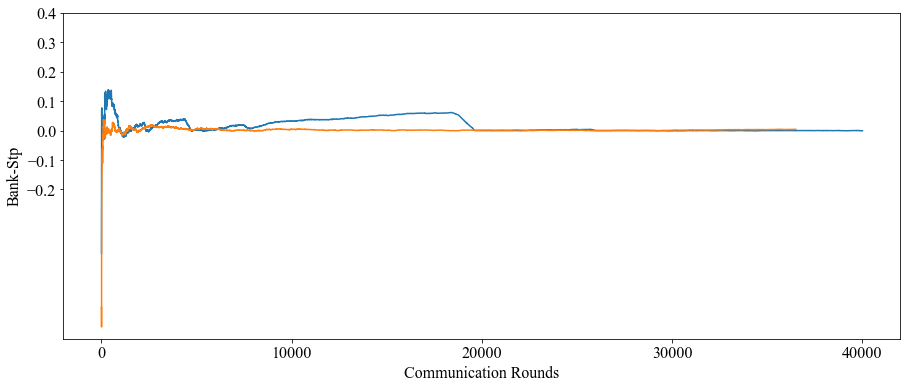

In [25]:
import matplotlib.pyplot as plt
fabboo_stp = [-0.6,-0.6,-0.6,-0.6666666666666666,-0.5,-0.4,-0.3333333333333333,-0.3333333333333333,-0.3333333333333333,-0.2857142857142857,-0.25,-0.25,-0.2222222222222222,-0.2222222222222222,-0.2222222222222222,-0.2,-0.2,-0.18181818181818182,-0.16666666666666666,-0.16666666666666666,-0.15384615384615385,-0.14285714285714285,-0.14285714285714285,-0.14285714285714285,-0.13333333333333333,-0.125,-0.11764705882352941,-0.1111111111111111,-0.10526315789473684,-0.10526315789473684,-0.1,-0.09523809523809523,-0.09090909090909091,-0.09090909090909091,-0.09090909090909091,-0.08695652173913043,-0.08333333333333333,-0.08333333333333333,-0.08,-0.08,-0.07692307692307693,-0.07692307692307693,-0.07692307692307693,-0.07407407407407407,-0.07142857142857142,-0.06896551724137931,-0.06666666666666667,-0.06666666666666667,-0.06666666666666667,-0.06451612903225806,-0.0625,-0.0625,-0.06060606060606061,-0.058823529411764705,-0.058823529411764705,-0.058823529411764705,-0.08571428571428572,-0.1111111111111111,-0.10810810810810811,-0.0646298472385429,-0.06644144144144146,-0.06359649122807018,-0.060897435897435896,-0.05833333333333334,-0.05589430894308944,-0.0575609756097561,-0.05523809523809523,-0.053023255813953486,-0.05456171735241502,-0.05598621877691645,-0.05387205387205388,-0.0551948051948052,-0.05642633228840126,-0.05440613026819924,-0.022222222222222227,-0.020289855072463767,-0.018439716312056736,-0.016666666666666663,-0.014965986394557818,-0.013333333333333336,-0.015483870967741939,-0.033523086654016446,-0.031637717121588096,-0.002403846153846159,-5.896226415094408E-4,0.0011574074074074125,0.0028409090909090884,0.004464285714285712,0.00603070175438597,0.007543103448275856,0.004702194357366768,0.006163328197226509,0.007575757575757583,0.00894187779433682,0.010263929618768333,0.011544011544011551,0.008870214752567704,0.010110294117647065,0.011312217194570137,0.008791208791208788,0.009956709956709955,0.01108742004264393,0.01218487394957983,0.013250517598343683,0.010869565217391297,0.011904761904761904,0.03667953667953669,0.03383458646616541,0.03484062268346923,0.03581871345029239,0.03311965811965811,0.03407095187917106,0.03499653499653499,0.035897435897435895,0.03333333333333334,0.02105263157894738,0.022077922077922085,0.023076923076923078,0.02405063291139241,0.021611608521148504,0.019288728149487636,0.01707388872534589,0.01802325581395349,0.018949181739879417,0.01985252410663642,0.017738359201773843,0.006571741511500556,0.007575757575757583,0.005555555555555564,0.006535947712418305,0.007493540051679584,0.008429118773946365,0.009343434343434348,0.010237203495630467,0.011111111111111113,0.009178743961352653,0.010033444816053505,0.010869565217391297,0.011687704534829355,0.012488436632747457,0.01327231121281465,0.014039855072463761,0.014791573285522192,0.015527950310559008,0.013677811550151978,0.014399312271652698,0.015106382978723396,0.01579945228565409,0.014026402640264016,0.004901960784313722,0.005663430420711976,0.006410256410256401,0.007142857142857131,0.007861635220125784,0.02656911821332307,0.027274461186343704,0.025233644859813095,0.025925925925925936,0.026605504587155965,0.018181818181818188,0.00990990990990992,0.010714285714285718,0.011504424778761069,0.009543640465035572,0.007658270932607222,0.005844047420270504,0.004097017371353651,0.004873294346978557,0.0031897926634768814,0.0015664160401002575,0.0023291925465838553,0.003078817733990144,0.0015124016938898865,0.0022492127755285585,0.002973535533749627,0.003685684800235872,0.0021732831063459856,0.002873563218390815,0.0035622684525505877,0.0042396834369700515,0.004906083543594064,0.0034449497037343235,0.004100601421541825,0.0026881720430107503,0.003333333333333327,0.003968253968253968,0.0026021337496747315,0.0032270556344391327,0.0019050038100076189,-0.005292338709677422,-0.012378094523630909,-0.011662531017369734,-0.010957892144791925,-0.010263929618768333,-0.017099199611933055,-0.018379281537176273,-0.025112532575219143,-0.02433862433862434,-0.0255787037037037,-0.026780626780626773,-0.026018099547511303,-0.025266704098820883,-0.02643220526432205,-0.025691699604743087,-0.026822409690677063,-0.013213981244671782,-0.012484130342784588,7.29850901887194E-4,0.0014492753623188415,0.002158495220474871,7.092198581560294E-4,0.0014084507042253641,0.002097902097902102,0.002777777777777782,0.0034482758620689724,0.004109589041095901,0.004761904761904773,0.0033534540576794086,0.003996954701180042,0.004631817752150477,-0.0014084507042253641,-7.461990485962133E-4,-9.26612305411495E-5,5.52333609500133E-4,-0.0053045546003292615,-0.004634257155838262,-0.003972553268327919,-0.0033192787297030707,-0.0026742734890354836,-0.004043600562587901,-0.0034067085953878445,-0.004738519858705964,-0.004109589041095901,-0.0034884710286735288,-0.0028750211398613224,-0.0022690982435498858,-0.007768125626461744,-0.007139892071398923,-0.008435708435708428,-0.007815043959622264,-0.009076305220883527,-0.008463073852295402,-0.007857142857142854,0.0040726817042606445,0.002705627705627711,0.0033043879197725418,-0.001986249045072566,-0.007215007215007202,-0.006569012382965866,-0.007901013714967209,-0.007262487031273163,-0.008560766810565598,-0.009826589595375718,-0.011061157496610297,-0.010429970200085154,-0.009805996472663142,-0.011010452961672468,-0.010393569844789355,-0.009783657158605477,-0.010959090599686874,-2.0177562550444117E-4,4.012841091492747E-4,-0.004588986432561851,-0.003968253968253968,-0.005228758169934636,0.005167958656330754,0.00578183219838109,0.006388959877331971,0.005052418845522294,0.0037462537462537443,0.0024694406716878614,-0.0023945477988579905,-0.0017708842208109393,-0.006559368357121176,-0.011296363416696875,-0.010635101844619368,-0.00998087497011714,-1.1820330969267157E-4,0.009527706336216982,0.008094357076780759,0.008741660915573962,0.007339136371394439,0.007979626485568755,0.008613409896976856,0.009240591397849454,0.004679926458298511,1.6627868307284022E-4,0.009431892958982252,0.010092744135297343,0.010746851932262269,0.009291084854994636,0.009938551963665526,0.010579479000531633,0.011213964559640327,0.00978852596314908,0.010416666666666657,0.011038557213930336,0.009642509103964705,0.0053077472695723105,0.003940189937361088,-3.518648838845839E-4,3.0012004801921455E-4,9.457441513190668E-4,-3.9418576003941164E-4,2.4517014808278503E-4,-0.0010679611650485366,-4.347826086956441E-4,1.9230769230768607E-4,-0.0010948210205636022,-4.7373158368468893E-4,-0.001735622478656551,-0.0011204481792717047,-0.0023578363384188505,-0.006487829567938169,-0.007701421800947877,-0.007075471698113206,-0.008265947888589392,-0.00764587525150906,-0.008813889627070609,-0.008199612061364825,-0.007591048705572617,-0.006988120195667358,-0.006390748630553861,-0.005798857538514807,-0.005212371844576541,0.002987240216788284,0.00356839422259983,0.002356902356902363,0.002932797050444108,0.001743534393291557,0.0023142408463509567,-0.0016044760768502697,-0.0010239187418086548,-0.0021915584415584666,-0.0016161616161616266,-0.0010458567980692057,-4.805766920304433E-4,-0.004306220095693786,-0.0037316395394998148,-0.003162055335968389,-0.0025974025974025983,-0.006347962382445144,0.0015144454799627394,0.002087924834705962,0.002656502656502663,0.00322024151811387,0.0037792029317453013,1.1403808872165189E-4,6.813536225301065E-4,-0.0029401786723962375,-0.0023648648648648685,-0.0017943254457777336,-0.001228501228501211,-6.67334000667319E-4,-0.001873897707231037,-0.001317330210772849,-7.653061224489888E-4,-0.0019505147191619943,-0.0014029786315562232,-8.598760345383538E-4,-3.211532971738318E-4,-0.003802821907097409,-0.0032566371681415907,-0.0044210526315789644,-0.005565217391304361,-0.005023384721981633,-0.004485852311939265,-0.003952569169960479,-0.005077006951069912,-0.00454792288894923,-0.004022988505747116,-0.0035021551724137845,-0.002985375016771763,-0.002472600908847905,-0.001963786446545046,-0.001458885941644561,0.005982905982905989,0.0026525198938992245,0.001493603480745509,-0.0018113598136887121,-0.0050911903074047915,-0.004558294812532088,-0.004029421170450909,-0.005168859996828923,-0.004643962848297212,-0.0057644110275689164,-0.005243445692883902,-0.006345374067539544,-0.005828296533859634,-0.005315063442809298,-0.006398927417880423,-0.005889496053430476,-0.006955736224028897,-0.008004778972520915,-0.007499107249137021,-0.008531365313653144,-0.008029411764705868,-0.007531135531135519,-0.0070364963503649625,-0.006545454545454549,-0.006057971014492763,-0.005574007220216615,-0.005093525179856118,-0.0046164874551971324,-0.005632360471070158,-0.005158730158730168,-0.004688470880641699,-0.004221546774738266,-0.0037579224858377003,-0.004757797501460742,-0.004297438172341128,-0.005281690140845063,-0.006250682388907081,-0.00720476706392198,-0.006747638326585675,-0.0062937062937062915,-0.005842937550254612,-0.005395299145299126,-0.004950758583976561,-0.0045092838196286456,-0.004070843246100964,-0.0036354056902002108,-0.0032029404043055765,-0.00617477760334903,-0.00573663624511081,-0.006676154741881227,-0.006240973798225705,-0.00580872336597528,-0.005379373943337276,-0.004952896423191813,-0.00452926208651401,-0.0041084425959270615,-0.003690409989383761,-0.0032751366739727367,-0.0061520691040578696,-0.007077352472089321,-0.00665673124689517,-0.0062388591800356386,-0.007150228512457613,-0.006735078739193268,-0.007632845544265646,-0.007220391548749747,-0.006810607158382845,-0.007695073714491185,-0.007287933094384691,-0.008159392789373804,-0.009018130445020006,-0.008613608092566949,-0.008211678832116792,-0.00781231780975257,-0.00865860999212853,-0.008261792670543708,-0.007867494824016566,-0.007475692533480099,-0.00708636218168518,-0.006699480448455017,-0.006315024306028802,-0.0059329710144927494,-0.006767086330935243,-0.007589285714285715,-0.010324877614597244,-0.009937888198757766,-0.010748425179507512,-0.01036383198296116,-0.009981612818492247,-0.009601745771958548,-0.010400866738894912,-0.010023330165039313,-0.010811274614955596,-0.010436047133294837,-0.01121304791029562,-0.013888888888888895,-0.014655172413793105,-0.015410958904109595,-0.016156462585034018,-0.015776523375307577,-0.015398886827458255,-0.016134316134316123,-0.015758961378296715,-0.016484519150834362,-0.010533736153071502,-0.010160642570281125,-0.009789789789789796,-0.010540341666169475,-0.01017170956101042,-0.00980527824453889,-0.009441028066855872,-0.012046298661740715,-0.012786974855536468,-0.0124182497664279,-0.012051700046576616,-0.011687306501547992,-0.0058823529411764774,-0.006646294881589007,-0.009216589861751154,-0.008847877268929896,-0.009601961893982255,-0.009235399228815958,-0.0035695596920086864,-0.0032051282051282076,-0.003980891719745222,-0.004746835443037972,-0.004384516602458269,-0.00402429209043681,-0.0047806013014868864,-0.005527456647398843,-0.005169308357348704,-0.004813218390804605,-0.0055507960305561516,-0.005196746694192816,-0.007701863354037275,-0.0022574955908289396,-0.003014899211218239,-0.0037630662020906036,0.0015584415584415368,-9.324009324009341E-4,-0.003409090909090917,-0.004175794085432644,-0.0038055906344926504,0.0014249122152296123,0.0017930241212490428,0.0021590621573754076,0.0013749161636485707,0.001738897806313533,9.64031646831981E-4,0.001325974176652922,0.0016858946811675601,0.002043810057523354,0.002399737015121639,0.002753692078217962,0.003105691588479509,0.0034557517074999544,0.0038038884192730382,0.0030381383322559963,6.446414182111337E-4,9.964641594342738E-4,-0.0013784260298124462,-0.0037404092071611217,0.001350750063564693,5.687563195146406E-4,9.296023192789937E-4,-0.0014142049025770154,-0.0010499592553124826,-6.876719179794988E-4,-3.2732714009603425E-4,3.1090660365606926E-5,3.875968992247958E-4,0.00539499036608862,0.0030900258270815384,0.0034498091105625295,0.0038076887787870384,0.004163679899949646,0.004517797383632477,0.003720508166969144,0.004072766766223174,0.0032845894263217046,0.0036350037397157864,0.003983588213353234,0.00433035714285715,0.0035511363636363535,0.0038961038961038974,0.004239284032030138,0.004580690627202233,0.009459992116673227,0.014284469993902954,0.01905504309038153,0.01939468985774348,0.01973259036923211,0.020068758057584873,0.02040320621812,0.020735948010489114,0.021066996460403442,0.021396364461333417,0.021724064776182744,0.022050110038936865,0.022374512756286685,0.02269728530922771,0.023018439954635206,0.02218045112781955,0.026876583724504632,0.027196132596685074,0.025020322122869615,0.02285533657678457,0.02749986332075882,0.027827011697979437,0.026956297712511373,0.027281826543310073,0.025136612021857935,0.024275362318840588,0.02460376954379953,0.022473560517038776,0.021621621621621623,0.02195283518812932,0.021110056925996212,0.02143965086626179,0.01932861264096511,0.019660937132093242,0.01882717254121291,0.01915788380665595,0.019486993564760274,0.019814513420651547,0.020140454867598745,0.01931556011279159,0.019639934533551562,0.019962753201693967,0.020284027282907457,0.020603767836287007,0.019787602126504267,0.0201058201058201,0.020422526360768634,0.020737731638205553,0.019930157146420546,0.020243872091576465,0.020556107249255218,0.020866873065015473,0.02530335694487218,0.02448529411764705,0.024794600938967126,0.023985015446739144,0.024292873524165454,0.022262844414314087,0.020242279309636818,0.020556693577539448,0.020869648846519123,0.02006840959647907,0.020379915998472692,0.01838051474964883,0.018694474796902477,0.019006991349685975,0.019318074340300778,0.017339404090683908,0.016546382679105798,0.01685985247629085,0.01717189416506046,0.016386964808702525,0.016697588126159568,0.015920627595754522,0.013962268494538271,0.013193156050298915,0.012431773379368488,0.012744719070465427,0.013056251914198513,0.013366381456833692,0.013675117158827826,0.013982468395790593,0.014288444459433614,0.014593054558506818,0.014896307819722204,0.014142538975501107,0.01837139469689414,0.01867330016583746,0.02286028602860285,0.02207991242474,0.02016318416654833,0.019390461284291977,0.01748221412458789,0.021595078782646243,0.019695256555214563,0.023768190488437396,0.022970854528585605,0.021079401562067723,0.01919626267452354,0.017321383168065085,0.015454708823560509,0.013596185895407481,0.012806516627477338,0.013134741075917555,0.01346153846153847,0.013786918071082926,0.014110889110889119,0.014433460707758777,0.01475464190981432,0.013972529285596419,0.013197865353037769,0.012430544206569694,0.012750343984100299,0.013068771230396847,0.013385834762576487,0.01262575249484868,0.01294146105466859,0.013255823309329368,0.012502877964303244,0.012815902507242044,0.013127597858915707,0.013437972467573805,0.017364961191192768,0.015559858528778309,0.013762372333293887,0.011972454500737806,0.011211750305997553,0.00942935313660348,0.00975086538930331,0.008997204751921728,0.009317371765070498,0.00857065730867862,0.00888948750757626,0.008149623642527443,0.006383792048929665,0.0067043048694424845,0.007023487761239483,0.010856590689478751,0.01010939268200678,0.010427253905514772,0.009686817870961095,0.008953052431313308,0.007203484476211747,0.006476299892524906,0.005755608028335302,0.004013254786450676,0.004335684891240449,0.003621399176954726,0.00394250513347022,0.00426229508196721,0.0025357873210634096,8.163265306122547E-4,1.0836192884233764E-4,-5.933650993436845E-4,-0.0012889366272824943,-0.0030013935041269257,-0.0026743688489516693,-0.0023486708658055078,-0.0020242914979757276,-0.0017012227538543423,-0.0013794567062818397,-0.0010589854918987562,-7.398013105051893E-4,-4.218964244278034E-4,-1.0526315789474716E-4,-7.947598253275068E-4,-4.793905638504625E-4,-1.6527775361435681E-4,1.4758609912576826E-4,-5.359149451119316E-4,-2.2429261559694935E-4,-9.018759018759037E-4,-5.914877202005953E-4,-2.8232636928288146E-4,-9.54068420335269E-4,-6.461266408215871E-4,-3.393972305185955E-4,-3.387304383170586E-5,2.704530087897228E-4,-3.955230160733736E-4,-0.0010558069381598756,-0.0017104714226116036,-0.0014073364700004087,-0.0011053856382978733,-0.001754502118644058,-0.0023981408227848056,-0.0030363707983193378,-0.0027355971628417464,-0.002435993852794055,-0.002137554050746532,-0.0018402709921177818,-0.0015441379646636277,-0.001249148307971848,-0.0018820374468909995,-0.0025096525096525157,-0.003132059148656663,-0.002838206253647696,-0.0034554690361311424,-0.00316274634456451,-0.0028711473485509287,-0.0034833297789151896,-0.0031928480204342358,-0.0038000125620250014,-0.004402220658378281,-0.004112849728801632,-0.0038245832684218606,-0.0035374149659863907,-0.004134727061556348,-0.0038486506538069343,-0.003563659925024304,-0.0032797487065779896,-0.0029969108764811847,-0.0035893864368643225,-0.0033076159193339005,-0.0038953134510042453,-0.0036146042160257463,-0.00333495027892311,-0.003056345699933405,-0.003639322769502018,-0.003361761653355,-0.003940074906367053,-0.003663551401869164,-0.00423725658115201,-0.004806408544726304,-0.004530916844349697,-0.004256451183825505,-0.00398300584174191,-0.003710575139146577,-0.003439153439153436,-0.003168735146553997,-0.002899314707432793,-0.003463967445998556,-0.004024174100008715,-0.00457998697634035,-0.005131457564575642,-0.0056786365529024885,-0.0062215738436454116,-0.005953145744999777,-0.006491890469791012,-0.006224449239155133,-0.00675904977375566,-0.006492589978828511,-0.006227106227106233,-0.0059625931655181985,-0.005699045480067361,-0.005436457895474284,-0.005174825174825176,-0.00491414211922378,-0.001613228473482553,-0.0013534899217058083,-0.0018945679831839646,-0.0024315313825976625,-0.0021727322107550073,-0.002705627705627711,-0.0024477628268242124,-0.0021908271908271937,-0.0019348157837366653,-0.0024636894258178443,-0.0022085972697401812,-0.0027334944182718923,-0.0032544597529569064,-0.0030002819056824115,-0.00274701346036596,-0.0032640909940458707,-5.9851966137086654E-5,1.9251194901753754E-4,4.439761710700041E-4,-7.922360863535372E-5,1.7134572294716377E-4,4.210249325702353E-4,6.698187549251389E-4,9.177318911832155E-4,0.0011647690092919938,0.0014109347442680942,8.915962175494729E-4,3.7607635646852433E-4,6.213753106876496E-4,8.658120541714109E-4,0.0011093911248710175,0.001352117028948191,0.0015939942410530816,8.982650651884194E-5,-4.2191665228313857E-4,0.002719710576935319,0.001220783844960438,0.0014662012059663554,0.001710766423357657,0.0011931818181818155,0.001436899322514562,0.0016797735136835357,0.0019218087611869994,0.0021630094043887105,0.0024033797527773515,0.0026429240862230474,0.0021290900941281776,0.0023678126631366814,0.0018576886637645396,0.0013512346212223858,8.484110736088624E-4,0.001086316099572826,5.870841487279899E-4,9.140545020230872E-5,3.284971256501401E-4,5.647796144923611E-4,7.261636772928903E-5,3.08093805502202E-4,5.427702996092243E-4,7.766499295596696E-4,2.879648682860836E-4,5.210516859316117E-4,3.5808068751502775E-5,-4.4603033006243575E-4,-9.24499229583986E-4,-6.922011998154176E-4,-0.0011673358212914986,-9.35822582164042E-4,-0.0014076576576576572,-0.0018762274385111521,-0.0016454950197517526,-0.0014155394778231911,-0.0011863568956994308,-0.0016516951608229469,-0.0014232816477667276,-0.0011956333391093532,-0.001657773403097973,-0.0021167481241825548,-0.00257258991201742,-0.0023457029689408215,-0.0027984437922325966,-0.002572314401553588,-0.0030219857955349205,-0.002796610169491537,-0.0025719845455314527,-0.002348105186102817,-0.0027947382598545456,-0.00257160145219848,-0.003015226895823897,-0.0027928289517693272,-0.0032334770434241378,-0.0036711776562050047,-0.0034495149119655177,-0.0032285837279380225,-0.0036633663366336666,-0.003443163097199331,-5.52797648694342E-4,-9.928319713715106E-4,-7.733530846985026E-4,-0.0012104828903943265,0.0016447368421052544,0.0012025452976703876,0.004031217750257998,0.004249975852409937,0.003802891481202164,0.004020932343674927,0.004238259488103552,0.004454876413105963,0.00303946522416057,0.005842037244973619,0.006059901011041063,0.0056080874524314095,0.004199226458284022,0.004418316311520204,0.003969417679095089,0.0041877973545250136,0.004405470299613745,0.004622439939548695,0.0048387096774193394,0.004392697852919819,0.003949545078577338,0.0041651182955530774,0.004379998351059455,0.00459418858295263,0.004153867455730542,0.0037163509216754653,0.002327290543851057,0.0025426751592356744,0.002107936507936503,0.0023226329935595036,0.0018906458527116199,0.002104657501059898,0.0023179875836491226,9.408142319534685E-4,0.001155314446453698,0.0013691347870569137,9.398731171291752E-4,0.0011530168110849282,7.264549000875753E-4,9.389251542519794E-4,0.0011507251552486941,7.268376135992904E-4,9.37970527978671E-4,5.167322834645494E-4,7.272012578616316E-4,3.085875506965152E-4,5.183957119871407E-4,1.0238208995971831E-4,-3.1105559632760293E-4,-0.0016693032599939817,-0.0014583545303468448,-0.0018692401321509233,-0.0022775972071746586,-0.002067307692307674,-0.0034177367094683775,-0.003823588526363164,-0.0011688540936133085,-9.574437680413828E-4,-0.00136767722817413,-0.0011569244774873866,-9.468262384487169E-4,-0.0022877670637171388,-0.0026955067034235836,-0.0024843083930100596,-0.0022737629367245715,-0.002063867312094264,-0.0018546185152748529,-0.002259887005649719,-0.0020512820512820495,-0.001843317972350239,-0.0016359918200408996,-0.0020388115582080646,-0.0018321204017710535,-0.002232513515009499,-0.002630501864805096,-0.003026107050829424,-0.0028200479774395937,-0.0026146180920601503,-0.003934204761209287,-0.00372770440853451,-0.0035218317165061908,-0.003915075080524438,-0.004305977710233028,-0.004694560443029405,-0.00508084386971458,-0.00487559598100043,-0.004670970055585449,-0.004466963270640695,-0.004850967739056328,-0.004647577288809268,-0.005029322907410677,-0.004826546003016574,-0.004624379872430889,-0.004422821760283052,-0.004221868927751282,-0.004601375569117522,-0.004978662873399736,-0.005353750251709449,-0.0057266568894475955,-0.006097401749575682,-0.0058970514742628655,-0.005697301050073766,-0.005498147787093011,-0.005299589011464434,-0.0051016220652713995,-0.005470223891525905,-0.005272846132672732,-0.005076054934767121,-0.004879847687003669,-0.004684221794048399,-0.004489174675924357,-0.004855651995975652,-0.0046611810879494675,-0.005025552216506218,-0.004831654968975668,-0.005193938010835841,-0.00500061188921852,-0.004807854373841236,-0.00461566295983068,-0.00442403515700493,-0.004784248010054448,-0.005142408368214807,-0.005498533724340171,-0.0053074670571010285,-0.006578947368421045,-0.006386861313868619,-0.006740968962593838,-0.007093076003134149,-0.008359275913755335,-0.00816618557718403,-0.008516308916087512,-0.008864465269940974,-0.008671936242487605,-0.009018142140577168,-0.008826171978225245,-0.01008403361344537,-0.010428305400372442,-0.011682526336214208,-0.012024880174467581,-0.012365332046952879,-0.012703897759479804,-0.013040592943208251,-0.012846102257848185,-0.012652172873167361,-0.012458802362793953,-0.012793642476639583,-0.014039677349029861,-0.015282131661442017,-0.015086300595626267,-0.014891030650342973,-0.014696319417349446,-0.014502164502164488,-0.01573509704750789,-0.01696451696451695,-0.016767964136385177,-0.016571969696969696,-0.016376531270148292,-0.016709531603148628,-0.016514646826261567,-0.01632031335001631,-0.01612652883839323,-0.016457704512034654,-0.01626446664219333,-0.013861592175541643,-0.013668898637728022,-0.013476747135182487,-0.01381176299259973,-0.013620151241465872,-0.013429076970699838,-0.013238537921980764,-0.014447133248223165,-0.01425570456517436,-0.014588899684236087,-0.014920288867693143,-0.01612409429533626,-0.016453692185909752,-0.016261386734924332,-0.016069616208698262,-0.015878378378378383,-0.01568767102747684,-0.01549749195178557,-0.016690964823744908,-0.016499925339704347,-0.01630941286113699,-0.016637233943675056,-0.016447246292872364,-0.016257781304107627,-0.01606883682355381,-0.0163948954271535,-0.016206469312801453,-0.01653077961289659,-0.01634286973447427,-0.01615547397336639,-0.01647804999378187,-0.016798905608755133,-0.016612021857923515,-0.01642564802182811,-0.01623978201634879,-0.016558930952518994,-0.016373570704877702,-0.016188714153561504,-0.016004359248246183,-0.01632181508661179,-0.016137959788085937,-0.015954602068175866,-0.015771739909670957,-0.01558937130624971,-0.015905147484094856,-0.013580734869444763,-0.013398857825601476,-0.01371825790892324,-0.013536870439895168,-0.014700056593095631,-0.014517838219710352,-0.012210889746164286,-0.01336964246761381,-0.013186604686462391,-0.014340954706864847,-0.012046084497578186,-0.01237416400217814,-0.012700534759358284,-0.010427807486631024,-0.010243961645830829,-0.010573683737210932,-0.010390328151986178,-0.010207460863925821,-0.010025079925035818,-0.010353098026279622,-0.010171201498913901,-0.009989787455705668,-0.009808853979499293,-0.010135181265788218,-0.009954726449571821,-0.009774748396410154,-0.010099397907448238,-0.009919894730416268,-0.010242879372166974,-0.010063849194283991,-0.00988529014844805,-0.009707200377371217,-0.009529578033515035,-0.009850910579911526,-0.010170603674540674,-0.010488669832301484,-0.010805121441038137,-0.010627964686549876,-0.010942814008660012,-0.01076612101530916,-0.011079380189327817,-0.011391061231487448,-0.011214830180602875,-0.011039059263010437,-0.012167527643768938,-0.011990973971452545,-0.01181487947643739,-0.01212499428220426,-0.01243355462779186,-0.012740572171651504,-0.012564935064935057,-0.012389753566796363,-0.012695239851085643,-0.01252051219102504,-0.012346236607704536,-0.012172411348888773,-0.01199903467138605,-0.011826104840990309,-0.011653620132423131,-0.011481578829276418,-0.009297983092250814,-0.009126383486929915,-0.00895522388059701,-0.008784502583115153,-0.008614217912992592,-0.008444368197327537,-0.009550461975835103,-0.009859092520382834,-0.009688482875250898,-0.009995585545815727,-0.009825410021918224,-0.009655666964409282,-0.00749211727610713,-0.0073228050385411025,-0.0071539219828193334,-0.006985466479137364,-0.006817436905932506,-0.006649831649831656,-0.006959994028959526,-0.004811629811629803,-0.004644447267398072,-0.005737131681716051,-0.006050279053686963,-0.0058823529411764774,-0.005714848753571783,-0.005547764902698843,-0.005381099808344392,-0.005214851898206113,-0.005049019607843153,-0.004883601380627156,-0.005195217469605523,-0.0050302117566718985,-0.004865617016871326,-0.005175713027366885,-0.0050115277272175796,-0.006089986365702155,-0.007165768928160732,-0.006999727989844939,-0.007308315017321043,-0.008380308833803085,-0.008687397866000202,-0.00852064756921525,-0.008826249487454974,-0.009894478821032476,-0.010960073803602394,-0.01126419938407286,-0.011095642654863042,-0.010927500579353627,-0.01123016049437603,-0.011062431544359236,-0.010895114199127781,-0.010728206945428753,-0.01056170827741812,-0.011618110584145858,-0.011919315403422975,-0.011752136752136766,-0.012051896943983287,-0.011885126045505068,-0.012183451978060464,-0.013235114139018248,-0.013532016081442111,-0.013364574441521643,-0.013660062565172049,-0.013493027830816406,-0.013787112210411484,-0.013620482900168346,-0.01391317351493121,-0.013746948154531091,-0.013581125276843825,-0.013415703421835345,-0.013250681136524944,-0.013086056974942695,-0.01337736370973032,-0.013213136232874775,-0.01304930400867109,-0.010980746089049337,-0.010817307692307682,-0.010654261704681867,-0.010491606714628288,-0.010329341317365265,-0.010167464114832547,-0.008108640585420795,-0.007947150186239371,-0.008245410335369435,-0.009277622777236205,-0.010307374641172429,-0.01014419852448023,-0.009981410460384199,-0.009819009066274142,-0.009656992966100286,-0.009495360790334417,-0.009334111175931331,-0.009173242766290418,-0.007128185537672804,-0.006967696982600108,-0.006807586938270521,-0.007108534649973575,-0.005077077011039294,-0.004917344139958979,-0.002895335141205796,-0.0027359781121751026,-0.0025769956002514305,-0.002418386286712537,-0.00226014885902015,-0.0025677083475001417,-0.0024098414992637374,-0.003421934573479307,-0.0032634386451850517,-0.0031053126023710687,-0.002947555151731479,-0.002790165005982781,-7.81485793127229E-4,-6.244616709732975E-4,-4.6780229707057974E-4,-3.11506401993622E-4,-1.5557272220076412E-4,-0.0011574074074073848,8.419938414164774E-4,9.985449011467307E-4,0.002988732319330889,0.0031449218292695924,0.002827108385760918,0.0025107528020848757,0.0021958450700503562,0.0023516742812348945,0.0025071444389374586,0.0026622567826982413,0.0028170125463584106,0.002971412958092834,0.003125459240442552,0.0032791526103470303,0.0034324942791761903,0.0035854854527623548,0.003272015655577304,0.002959973966807694,0.0031126158454769515,0.003264909624080853,0.002277904328018221,0.004240008283288466,0.004392905160823246,0.003409090909090917,0.003562583840676925,0.0037157287157287278,0.003401360544217691,0.003554158545260311,0.0025753891300109855,0.0027287751258695536,0.0028818148779451436,0.003034509557299059,0.0031868603297174614,0.0028739146386205228,0.0030259226646442983,0.0027143898209112116,0.0024042602782760325,0.0020955245762818986,0.002247191011235966,0.0019398397742731999,0.001633863710630179,0.0013292536115569742,0.0014805796055795961,0.0016315663036514938,0.0017822148456246856,0.001932526366251186,0.002082501995211483,0.0017792487339960972,0.0014773432650527774,5.109126984127188E-4,6.614641397250098E-4,8.11680277159138E-4,9.615622296378912E-4,0.0011111111111111183,0.0012603280305833187,0.0014092140921409257,0.0015577703949797017,0.0012572037529496316,0.0014054313914015903,4.4835907927134877E-4,-5.066004904480115E-4,-3.569184734645847E-4,-6.561551746007144E-4,-5.06802853689925E-4,-3.577791407459452E-4,-2.0908295244578823E-4,-6.071321022313447E-5,-3.5862877802089743E-4,-2.1058440803997658E-4,-5.071875724553809E-4,-3.594675055850205E-4,-6.5476691982716E-4,-9.487711611998184E-4,-8.013743329878253E-4,-6.542996836353121E-4,-5.075461579713558E-4,-3.6111270542768525E-4,-2.149982800137562E-4,-6.92018402916883E-5,7.627765064835423E-5,2.2144122521286502E-4,3.6628991132930944E-4,5.10824732470383E-4,2.1810716173831235E-4,0.0021100739472103003,0.0018151476312205372,0.0019593696064284516,0.0021032797503385825,0.0022468790732035615,0.0023901685809167295,0.002533149275035701,0.004413418290854565,0.004556091168624488,0.004259005438170843,0.00440137149254774,0.004543431712221352,0.006412134231683103,0.006553889601099899,0.006695341100485808,0.006836489705868726,0.006977336389101085,0.0066781395456277926,0.00681868527440882,0.006958931012306657,0.007098877718780372,0.007238526349201968,0.007377877854878007,0.0064542339269606785,0.005532551026491139,0.005234643824584523,0.005375361099937831,0.005515780245470475,0.005655902207626351,0.005795727928847416,0.005935258347594952,0.006074494398370434,0.005777868517762352,0.005916811131128408,0.005002829654782104,0.005142295037481759,0.005281467425679948,0.00713203736430193,0.008974681949867752,0.009113562265897629,0.01094833230195244,0.011086921464279947,0.011225220387524049,0.011363229982476825,0.011500951156123568,0.011195700850873264,0.011333134506412157,0.01147028154327423,0.013293989749961155,0.013430851063829768,0.013567427546660155,0.01370372008669879,0.013839729568502684,0.01565569379129711,0.015791421095752822,0.015926867100095693,0.01606203267792855,0.015751658069270452,0.015886544090582433,0.016021151421767743,0.015123489181578076,0.015258605626419702,0.01436357765015972,0.01449919787961218,0.0146345393418921,0.014769602895625233,0.014904389395914819,0.015038899694359537,0.015173134639071523,0.016978237301485982,0.016089702849583026,0.01622443404518137,0.016358890279156074,0.016046671833290282,0.01573576799140708,0.015869950104619335,0.01600385893450529,0.016137495315093425,0.015254599914420186,0.01494500239120039,0.01673313902950352,0.01686726473624281,0.015986919599763588,0.015675524285605175,0.015810134255785452,0.015944471736147575,0.01607853755325314,0.01621233253032417,0.016345857487259807,0.015471048724524233,0.015605051258390318,0.014732747952148045,0.014867223145013764,0.01500142830737175,0.015135364251751077,0.014825269126795854,0.014958936662469002,0.015092336595468131,0.014783533533533538,0.014916666666666661,0.015049533799533804,0.015182135728542906,0.015314473246925892,0.01500695418940684,0.015139028087235273,0.015270839151436177,0.015402388165807662,0.015096145120975402,0.01522743286620215,0.01436639662780742,0.014061421670117313,0.015823822642004465,0.015955573393180378,0.015648851062090657,0.01479024191078901,0.014922450977393004,0.015054398761256665,0.014748938661982125,0.014880625936894432,0.014025860179706334,0.014158000364896922,0.01330562846310876,0.013438216978039985,0.013570545004729678,0.013702613310071582,0.012854030501089325,0.012986541879783792,0.013118793940711748,0.012814588297697077,0.012946581801321161,0.013078317505133469,0.013209796163670046,0.012366359659129578,0.012498275513896845,0.011657172077117917,0.013403393506410677,0.012563924867370846,0.012696960050931072,0.012829737164300137,0.01296225695768205,0.013094520178375896,0.012788609822681762,0.012920617215095742,0.01465677179962896,0.014788524105294298,0.014920022062879207,0.015051266408202618,0.015182257874247984,0.01487468066821282,0.014042956077538138,0.013212830957230137,0.012906504065040653,0.013038588599142475,0.01317041961206561,0.01286533542532109,0.012561486397227373,0.012693064618179428,0.012824390773574085,0.011998527788001478,0.012130266834906062,0.01226175423129125,0.011959132876038309,0.012090369342277724,0.012221355595998101,0.012352092352092336,0.012482580322732556,0.012612820217382942,0.011793145126478444,0.01097502539627776,0.011106323902532411,0.010804922794679706,0.009989002932551339,0.010120700704977587,0.010252149521312287,0.009951961295181305,0.010083161860682505,0.00927071865153184,0.008459806909316414,0.008160824258390764,0.008293059242620193,0.008425045431018519,0.008127261107351125,0.00825899920141035,0.00839048989998778,0.008521733899318346,0.008225140712945583,0.009925739515340787,0.010056737509049368,0.010187490188162979,0.010317998241122978,0.010448262353797061,0.010150053989648883,0.00985303134464241,0.009983052200336712,0.01011283047980771,0.010242366861274083,0.009946522877557346,0.009651850553182045,0.009358342941551329,0.008556539404244057,0.00868646015258756,0.008816139412551244,0.008523789621873695,0.008232590814623991,0.007942536207009881,0.007143469544485248,0.006854552405920589,0.006566766058504897,0.0066968256792131475,0.00836328849721707,0.00849310704355885,0.008622685185185192,0.008333333333333331,0.008462671737417327,0.00859177106866571,0.008720631989330041,0.00884925515921825,0.008055982249530635,0.008184980560671157,0.007393778322941136,0.007105552353781325,0.008760193281589113,0.008470436376343371,0.008599806201550375,0.007810664787408966,0.007940402531825597,0.007153312159387221,0.007283414260158438,0.0074132782967013255,0.007124642307916901,0.007254268933058444,0.006966747368941151,0.007096137233123551,0.006809723651912264,0.006938877403203786,0.0061562186590508605,0.0058709066685365685,0.00600042034468265,0.006129698327150546,0.005349650349650348,0.0050654336067003924,0.005195067823528077,0.004911940033616252,0.005041338979632992,0.00475929389637475,0.004478325321067872,0.004607489636176132,0.004736419957959953,0.004456521739130442,0.004177687772083549,0.0043063847358188745,0.004434848974484151,0.004157073200860589,0.004285305345147067,0.004413306023469149,0.004541075861974581,0.004264352269311711,0.0043918918918919025,0.004519201920192034,0.0042435245414900735,0.003968887454783215,0.003695284782715552,0.00382236583614462,0.003949218531885623,0.004075843484905334,0.003803269394311637,0.0035317180958026884,0.0036581159188618373,0.003784287222524829,0.003910232615169623,0.004035952702997503,0.004161448090042874,0.0038909138375957664,0.004016185125735677,0.003746662216288388,0.0038717100052523268,0.003603192778302955,0.003728017665682287,0.0038526202469398307,0.0039770011154193485,0.004101160862354902,0.004225100076880262,0.003957582914090846,0.004081302183248814,0.00420480209200047,0.0043280832232344135,0.004061560548039023,0.004184623482580502,0.0039190897597977115,0.004041935076417841,0.0037773848118675957,0.0039000130872922645,0.003636440827416848,0.0037588526363359076,0.0029992143362445323,0.0027366146677339775,0.002474982217155336,0.0025977397554782233,0.0023370691889090522,0.00245961060480529,0.002581936468518814,0.002322222491184772,0.0024443333709550097,0.0025662298330259292,0.0026879124416546163,0.002429149797570862,0.00255061911503629,0.0026718757016480355,0.002792920115754771,0.0025351035873715233,0.002278227995223231,0.002399060793221386,0.0025196825295636383,0.002263742731922286,0.0020087336244541676,0.001754650139880659,0.001501487247642569,0.0016218984748463672,0.0017420997435022845,0.001862091602282484,0.001609844308207986,0.0013585076541843266,0.0014782906498509163,0.0012278597134993963,0.001347434390912644,0.0014668012930393326,0.00121727118739412,0.0013364308553157345,0.0014553838282366227,0.0015741306434921276,0.0016926718365567195,0.0018110079410519897,0.001562373814242124,0.0016805053619448618,0.0017984328827948814,0.0019161569049031546,0.0020336779545595263,0.0021509965562405975,0.0022681132326175524,0.0023850285045639574,0.0021372855394989343,0.002253999926098371,0.002370513944652125,0.0024868281106869006,0.001746044908827904,0.0014991883228865355,0.0016158379689759084,0.001732288043386765,0.0014863130881095088,0.0016025641025641246,0.0017186165670367293,0.0018344709897611111,0.0019501278772378616,0.002065587734241925,0.0021808510638297862,0.0022959183673469385,0.002050820328131253,0.00216569210521933,0.0019214663010186372,0.002036143049622685,0.0021506252659983793,0.0019072670490239696,0.0020215552277448035,0.001779059983171044,0.001537423128843557,0.0016515177628078914,0.0017654193432460608,0.001524636329393203,0.0016383453458745645,0.0013984116548219072,0.0011593228007096001,0.0012728397411496117,0.0013861650918167434,0.0014992993373393881,0.00126105086584255,0.0027780243188071374,0.002890967942180661,0.003003721424774064,0.0031162852463370583,0.003228659885006646,0.0033408458173140865,0.003452843518191473,0.003564653460978534,0.003676276117429267,0.0037877119577185703,0.003548058533439813,0.0036593080261701216,0.0037703716383779007,0.003046525294638752,0.0031579147246172667,0.003269118505545815,0.003380137101160585,0.003490970973654528,0.00500040724666348,0.004279801661347782,0.004038768697801731,0.00414992491578392,0.004260896642117984,0.004371684335738396,0.004131491208302279,0.004242095326622591,0.004352516325541705,0.004462754659450174,0.004572810781236503,0.004682685142293225,0.004443327469213387,0.004553020519443257,0.0038381303989390436,0.0031244180216316864,0.0028858914515833833,0.00264819166340699,0.002758699388778346,0.0028690253580224423,0.00263214806046258,0.0019206000346873864,0.001684540966134629,0.0017951793903196456,0.0015599343185550008,0.0016703912194845905,0.0017806670435274174,0.0018907622355898157,0.0020006772391218397,0.0034874123569329785,0.0035971476139342873,0.003360560617938546,0.00484005110734928,0.004949607058375105,0.004242657611929851,0.004352522112379298,0.004462207534588397,0.003757382068487719,0.003053703592567847,0.003164177439373028,0.0029262724134090645,0.002689180737961233,0.002452898249119012,0.0025631926095768254,0.002673307920748186,0.0019722146101658344,0.0017367371723929215,0.0015020606782858992,8.021036615618593E-4,9.129967776584091E-4,2.146489663826523E-4,3.258376915843131E-4,4.3684679041244845E-4,5.47676697797761E-4,6.583278472679366E-4,7.688006709533068E-4,8.790955995924832E-4,9.892130625379636E-4,0.001099153487761656,4.057044504548746E-4,5.159367117633373E-4,6.259921771434862E-4,7.358712715855309E-4,8.455744187186309E-4,1.5510204081631285E-4,-5.342664643795403E-4,-4.2381169720284717E-4,-0.0011116178314901637,-0.0010008788204277086,-8.903162858769076E-4,-0.001124195915827353,-0.001357282733472881,-0.00204307459786246,-0.002275372627631028,-0.002164528387224446,-0.0028487729293940056,-0.0035319305064449857,-0.0034203529127387056,-0.003651866151866162,-0.0038825985706255617,-0.0037711979437610177,-0.0023176518021878756,-0.0022064277214831896,-0.0020953797675887786,-0.002775646762988526,-0.003454838237446911,-0.003343067324109966,-0.0032314728447324914,-0.0034634848414503705,-0.0036947182744208884,-0.003925177056024659,-0.003813758593176203,-0.0037025157307419843,-0.003591448053917895,-0.0038211360703657993,-0.004497025227022167,-0.0051718516648787405,-0.005400772776430307,-0.005288993045492157,-0.0055171510866719176,-0.005405546834118258,-0.005632945613929685,-0.006305830152360442,-0.006532473454498061,-0.005099990244854136,-0.004988121045763849,-0.005216010297079021,-0.005887401660555819,-0.0061145375589740925,-0.006002405618282719,-0.004578626876772185,-0.005248531107997417,-0.005476890022966363,-0.005364497528830309,-0.003947368421052616,-0.0038351514030978973,-0.004064712374491908,-0.004293520686963315,-0.004181478734559235,-0.004069611438355297,-0.003957918390276288,-0.004185977739368074,-0.004074458532609043,-0.003963112761630361,-0.004628940799153575,-0.004517337426680645,-0.0031106645556773505,-0.0017085811557050745,-0.00237294613602107,-0.0026040942780682363,-0.0024922354367093447,-0.0023805498855771767,-0.002269037222295045,-0.0029310922506808057,-0.003592124010089154,-0.0038225204508613997,-0.004482531311799626,-0.004712179712179715,-0.004599567099567103,-0.004487128137860591,-0.004374862425709891,-0.004603766422847294,-0.00449167356013791,-0.0047198367676405395,-0.004607916355489183,-0.005264807504309604,-0.005152640448600365,-0.005040645560282858,-0.004928822443266423,-0.004817170702674567,-0.0034290878255002766,-0.0033176070676658176,-0.003206296900126443,-0.0034355949354591964,-0.0033244549669527446,-0.0032134848074127087,-0.003102684067963546,-0.0029920523609163197,-0.0028815892997639536,-0.0027712944991769572,-0.002999854054524742,-0.0032276786916881073,-0.0034547719495989504,-0.003344645025420756,-0.0019684463177613853,-0.0021966514459665076,-8.266833948482877E-4,-7.167239640908929E-4,-9.460221587497819E-4,-8.362298395893086E-4,-7.26604251361479E-4,-6.171450145573687E-4,-8.45712960188677E-4,-7.36419696450219E-4,-6.272920285659289E-4,-0.0012753318514732714,-0.0015031730309817415,-0.0013938028087712162,-3.3619095646336694E-5,-2.625326367627079E-4,-1.5332775124488052E-4,-4.428782778975737E-5,6.45875071016433E-5,1.7329862580167665E-4,2.818458995601514E-4,3.9022969850877054E-4,4.984503916651561E-4,2.7026126048898536E-4,4.279310603061415E-5,1.5085106130255377E-4,-4.925681554094063E-4,-3.842705264506252E-4,-2.761353845570358E-4,-1.6816236431546616E-4,-3.9491295361782086E-4,-2.8710169070997327E-4,-5.13138104927896E-4,-4.054882361261558E-4,-6.308138440100919E-4,-0.001271268163493794,-0.0014958863126402488,-0.0013879991458466967,-0.002027099114477765,-0.0019189765458422214,-0.002142890562859684,-0.002034929250851497,-0.0019271288349863858,-0.0025640905939773584,-0.0024560568741603395,-0.0026792700648334555,-0.0013392857142857373,-0.001974907063197029,-0.0018666419019316705,-0.0020909008722904687,-0.001982796461078934,-0.001874852442168895,-0.002098412786451842,-0.0019906288031517616,-0.0018830044998269513,-0.0017755395218956305,-0.0016682335158251793,-0.0015610861291280864,-0.0014540970103581463,-0.0013472658091067125,-0.0012405921759987004,-0.0011340757626889242,-0.001027716221858238,-9.215132072098176E-4,4.108317683961804E-4,5.168786021407246E-4,2.9229082937523576E-4,6.839945280440185E-5,1.7429044990860398E-4,2.8002595362497384E-4,3.8560630619871583E-4,1.6240809178441618E-4,-4.65304195455013E-4,-3.5949602513069E-4,-9.859071932695473E-4,-0.0012084154595712604,-0.0011023812565789382,-9.965020743512576E-4,-0.0012183235867446462,-0.0018430592754917208,-0.0017369559340362217,-0.0023604019774698115,-0.0022540762336680786,-0.002475214166670431,-0.0026956716752635224,-0.0025895008123704433,-0.0024834844922181076,-0.0023776223776223737,-0.0025974025974025983,-0.0012827663134411527,-0.0011770580681980392,-0.0010715033570801724,-9.661018458332893E-4,-8.608532011727121E-4,-7.557570907797684E-4,-6.50813183298321E-4,-5.460211483312993E-4,-7.668048836163011E-4,-9.869134392826995E-4,-8.822729473886848E-4,-7.777836700783303E-4,-6.734452798110024E-4,-5.692574499913949E-4,-4.652198549660591E-4,-6.846563234395586E-4,-5.807686384935173E-4,-0.0011969729444545052,-0.001092866165083195,-9.88909071951094E-4,-8.85101342458533E-4,-7.814426549322406E-4,-6.779326886219017E-4,-5.745711236969375E-4,-4.7135764124323076E-4,-6.901250960933691E-4,-5.870593781099054E-4,7.169091410273443E-4,8.198274116317517E-4,2.0780226798222667E-4,-4.033485540334836E-4,-2.9985105224905606E-4,-1.965011931205074E-4,-9.32986609472608E-5,9.756859071924362E-6,0.0013097619480598177,0.0014126707698298435,0.0015154332063626597,0.001618049569780261,0.0013966585886953653,0.0011759384893713087,5.68181818181801E-4,3.4812955576948856E-4,1.2874210381763618E-4,2.3157131860568336E-4,3.3425467635150863E-4,4.367924871692408E-4,5.391850602946002E-4,3.204594106110681E-4,0.0016084166695109203,0.0017106643133041888,0.0014909886180419218,8.858780614903472E-4,6.668620530006497E-4,7.693205573064132E-4,8.71634346210598E-4,9.738037260972887E-4,0.0010758290024862616,8.574697136622123E-4,9.593511912120156E-4,0.0010610891737229955,0.0011626839641403763,0.0012641358645571754,0.0013654451762172282,0.0014666121995182135,0.0015676372340145683,0.001668520578420457,0.0017692625306127696,0.0018698633876339243,0.0019703234456949215,0.0017526179271966924,0.0018529374816800004,0.003130651112713878,0.002532018438609507,0.0026325458660052814,0.0027329329899434263,0.0025142952370041105,0.002614542351006499,0.0023965562754231506,0.00217921896792192,0.002279326364692219,0.002062634933290536,0.0033302660283915098,0.004594141179507016,0.004694109150933656,0.004793937988092467,0.004893627981249676,0.004674473915941779,0.004774025354556705,0.0045555187163250355,0.004654931889053027,0.0044370698131760145,0.004536345007871034,0.004635482511588712,0.004734482610588814,0.004833345590338212,0.004932071735513577,0.005030661330004044,0.005129114656914013,0.005227431998565818,0.005325613636502441,0.005423659851490181,0.005521570923521374,0.004930641897657184,0.005028757509130732,0.005126738161028682,0.004909517799660895,0.005007363770250378,0.0051050753370341095,0.004516310978537413,0.004614225309147041,0.004712005418604337,0.004495423940652332,0.0039081385979049255,0.003692193188904319,0.003105711795975852,0.003204027231218265,0.004454990753035848,0.0045531717857694165,0.004651218691409081,0.005898519069678143,0.007142172370817768,0.0072400854240265156,0.007020253606038723,0.007118033080730141,0.007215679250070911,0.007313192386483425,0.007410572761648276,0.007191381852750811,0.006608357628765771,0.00670593574906897,0.006487382950532222,0.006584828491867589,0.0066821417242534376,0.006464224253619394,0.006561405446341234,0.006658454867954272,0.00675537278628599,0.006538087877250326,0.007770708141864036,0.00786749482401658,0.007287560549900984,0.007384543022606355,0.007481394437916178,0.007263269057769778,0.007045774097797219,0.0064672752748689555,0.006250408005978564,0.006347453715874779,0.006131211424704519,0.0062281262570418605,0.006324910476397605,0.006421564346636377,0.006205944335440722,0.006302468119716881,0.006087467706254568,0.006183861667014512,0.006280126065999259,0.006376261164246638,0.006161877681669398,0.006257883739516412,0.006353761016601761,0.007572656569791253,0.007357449417535272,0.007142857142857145,0.007238605898123307,0.0070246258695926544,0.007120246361288496,0.006906875962468723,0.00700236844815158,0.007097733184689703,0.006884969814031611,0.006980207057606463,0.00707531706371492,0.006863158134450709,0.006958141157907494,0.007052997452847348,0.007147727272727278,0.007242330870328856,0.007336808497760555,0.00712525143779924,0.007219603346498488,0.007313829787234022,0.007407931010108143,0.007196973261931416,0.008401039439492108,0.008495015693942731,0.007925297222110106,0.008019464318542502,0.008113506607690002,0.0075451726818850096,0.008745837542559948,0.008840069247364885,0.00862690994764298,0.00872101700733574,0.008508458156345461,0.008602440818074347,0.00839047988227673,0.008484338392536983,0.008578072997173142,0.008012053334520847,0.008105975688562916,0.007894610148652365,0.007683837499456836,0.007473655249838895,0.007567453859013945,0.007661128967716119,0.007754680819696297,0.007545086492454917,0.00763851533082302,0.007074791174659756,0.007168406117847997,0.00726189820678011,0.006699529978218516,0.006137898798449254,0.00557700321943938,0.006764642395905379,0.007948968771321258,0.00738880734882838,0.0071770771048141335,0.006617648398374254,0.006712545742530995,0.006807319118896565,0.006901968770227723,0.006996494938647818,0.007090897865648843,0.008270577163342535,0.008058090685209351,0.008152370611654025,0.00824652777777779,0.008340562423190923,0.00843447478688053,0.008528265107212496,0.007972582972582992,0.00806655130146372,0.00816039775183744,0.008254122560668264,0.009429188056122084,0.009522791459760094,0.009309560374894138,0.00909691914088534,0.009190401375068824,0.010359563017397044,0.010146189041401632,0.010239550341258868,0.009686378530191914,0.009779916243428693,0.009873333184924643,0.009321468298109009,0.009415060361502053,0.008864201919658726,0.010028826219079245,0.011190246600207038,0.011284012573614027,0.011377657870092539,0.011471182722459838,0.011564587362934642,0.011015611265271369,0.010467339886603838,0.010561208689307239,0.010654957147391814,0.01074858549214125,0.010842093954246929,0.010935482763809956,0.010389365961084529,0.010482924706988778,0.009937794361263519,0.010031521871754878,0.01012512983185021,0.01021861847013536,0.010311988014613777,0.010096591306782393,0.009553304747448615,0.009010709392388794,0.009104531831804569,0.009198235055922488,0.009291819291819298,0.009077013521457983,0.009170478995634113,0.00926382593401548,0.009357054561955291,0.009450165104235908,0.009543157785070588,0.009636032828105379,0.00972879045642075,0.009821430892533595,0.009913954358398813,0.011069600110695993,0.011162006827708376,0.01094650170243433,0.010408274867470674,0.010500846049942392,0.010593300644023085,0.01005631224931322,0.010148930129313699,0.011300134034436554,0.011392635487183722,0.01148502073207569,0.012633083562423292,0.012415620336012484,0.012507889591896415,0.012600043077070355,0.012065121761635905,0.011848250271895594,0.011940565699964184,0.01203276551697699,0.012124849939975979,0.011908567774936069,0.01169287253571713,0.011784841781201455,0.011569731081926216,0.011661585365853655,0.011753324903642531,0.011844949910173264,0.011936460599790033,0.012027857186302532,0.012119139882987628,0.011904611350692818,0.011995780370296083,0.012086835925033651,0.011872887199582904,0.01134193895387925,0.0111285676878764,0.010915771546579772,0.011006987313611605,0.011098089769131597,0.011189079124148155,0.012322750805573712,0.012413627270571659,0.012504391055513792,0.012290929210914014,0.012381580525242825,0.012168691732574871,0.013296856261066858,0.013387395313706113,0.01347782231306241,0.013568137467026786,0.013354593389016817,0.013444796904966388,0.013231823800427006,0.013019419382415104,0.012491846241766857,0.0125822083766009,0.012672459022064375,0.012146075573020498,0.012236483724037045,0.012326780534966164,0.012114942528735656,0.01220512820512823,0.011993854348048755,0.01178314238952538,0.011873217136426695,0.011963181158377911,0.01175302885977092,0.011842882360810658,0.011318752002426158,0.011408761681291207,0.011498660986546366,0.011588450121084282,0.012705115202579692,0.012494318919620828,0.012284080298786165,0.012373759465002576,0.011851333760758476,0.01194116790447064,0.01203089222649123,0.012120506928081753,0.011910823759349709,0.011701693844361039,0.011493114996342008,0.011582620278272449,0.012690379795642942,0.01277977585819337,0.012869062901155331,0.012958241123833342,0.012749028868490664,0.012838098469703796,0.01292705964778701,0.01403073246398065,0.01382089630817901,0.013909749260984788,0.013998494185884391,0.014087131279769544,0.014175660739053714,0.013966373892560474,0.013757634201221447,0.013549439522131362,0.0136378615427514,0.013726176320168704,0.013814384049370992,0.013902484924873448,0.013385152264207001,0.013473406212930361,0.014569535379157339,0.014657682612102318,0.0144488739419589,0.014536914652567984,0.014624849033816417,0.014416583429135016,0.014208858774076155,0.014296687018473364,0.014089501208174704,0.013574087198959861,0.013367438139465115,0.01285264548529455,0.012646531093482821,0.012132358671425675,0.012220852320918296,0.012309239479857986,0.012397520340350326,0.011884733555577676,0.01197316333150747,0.011461246853204432,0.011549824575835171,0.011638296090165395,0.011726661587102782,0.01181492125709771,0.011903075290144727,0.011697493493660671,0.011187455954897813,0.011275756775416201,0.011363952099135904,0.011452042115006361,0.01154002701152615,0.011627906976744179,0.011715682198261135,0.011510630935445437,0.011598301600415,0.0113937788202354,0.011189782482218441,0.010986310556381496,0.011073876851511816,0.012154624365792538,0.011950549450549436,0.011746997134321063,0.011834459245875978,0.011921817359676373,0.01299755801612379,0.013084812317548905,0.012578138763509134,0.012665538412500843,0.012752834384566147,0.01284002686407415,0.012927116034957165,0.014000108950264212,0.013794854434664883,0.013590122860506537,0.013677108906261198,0.013763992009949877,0.013559781381272867,0.013356089712262154,0.013442870056514178,0.013239695371434934,0.013326373138447895,0.013412948509988892,0.012909102895258873,0.012995822290103765,0.013082439421511355,0.013168954470265531,0.01296629480339942,0.013052707949858272,0.01285056134543991,0.012936872769536811,0.012735237281690959,0.012821447162935956,0.012907555680417043,0.012706429373096045,0.012204892639675252,0.01229114397053327,0.012377294067434902,0.012463343108504388,0.012549291271448354,0.013609706266289573,0.01369555372839823,0.013493851808894786,0.01357959874704312,0.013665245337692145,0.013464050844401249,0.01354959726359925,0.014605189691145798,0.014690636114529393,0.015743579627577692,0.01582892623037324,0.01591417318739788,0.01599932067306073,0.016084368861364218,0.01616931792590512,0.01625416803987581,0.016051339764670852,0.015554018923910479,0.015639010265629166,0.015723902780206328,0.015808696639914716,0.015312671923711718,0.015397606029001698,0.015482441602847008,0.015567178816606714,0.015651817841242727,0.01573635884732097,0.015534038277435686,0.01561848143512723,0.01512445791478792,0.014922643146327352,0.015969771735590776,0.01605435402278943,0.016138838583486415,0.01593647308649232,0.01573461161315201,0.015533252282780213,0.01533239322403665,0.014839413021961484,0.014639052372792977,0.014723675148446663,0.014523811056029512,0.014324441676712402,0.014408966848241916,0.01421009034748924,0.015246272801059418,0.015330700537232733,0.015131282047637501,0.01463957565047419,0.014724140648126244,0.014808608332777584,0.014892978872305673,0.015925578654852307,0.016009852216748777,0.016094028968120344,0.016178109075690145,0.017208168637369514,0.017292152267477934,0.018319680970283386,0.018403568288889394,0.01791429355899271,0.017712306853938514,0.017510815214337894,0.01730981682232502,0.017393840230721436,0.016905357602016113,0.01698951625778297,0.016789009304381403,0.016873071723835203,0.016957038071952507,0.017040908513332925,0.01712468321220037,0.01663791167638573,0.016437894361453986,0.01623836489363184,0.016322273827071243,0.016406087137794456,0.01648980498916608,0.016573427544178704,0.016656954965454107,0.016171882582953184,0.016255543237250564,0.01633910887660836,0.01642257966280003,0.016505955757231988,0.01658923732094464,0.01639019391759952,0.01647338111126831,0.016274821998442268,0.01635791498237868,0.01644091391653138,0.016523818960487047,0.016041339148542277,0.017058329389574883,0.017141366503971273,0.01722430984409959,0.01702523942920736,0.01710808915382761,0.01719084542134172,0.016992257601394667,0.0170749205698473,0.017157490396927016,0.017239967239967235,0.017041860262199254,0.017124244278179213,0.01720653562372501,0.01728873445511056,0.01737084092825858,0.01745285519874165,0.018464417161669577,0.018546339384711008,0.018628169715185938,0.019637288291730004,0.019719026884166296,0.019800673892745507,0.01960108530746435,0.019122730471689053,0.018923622822757974,0.0190054004490261,0.018527802485108213,0.01860970994093758,0.018691525880056514,0.01969626686565959,0.01977799144136244,0.019578394107288566,0.019660027472527458,0.019183845295808466,0.01926560758082496,0.019347278765802445,0.018872066129861226,0.018953865416720173,0.01875474730793819,0.018836455605601515,0.018918073065802177,0.018719432458480123,0.018245403677058347,0.018047238855622094,0.017849548112706004,0.01765232974910394,0.017178827373880295,0.01726078948519963,0.017342660679035532,0.01714591300365209,0.017227693431197705,0.016755366622812545,0.016559087952614765,0.016640994064283154,0.0167228095217051,0.016804534475302474,0.017799199325748,0.017880833925610046,0.017962378321494332,0.017765617096195646,0.017569323237227846,0.017373495081365542,0.0174549494226989,0.016984437478887282,0.016789073370787694,0.016319080469385155,0.01640087366820464,0.017389403913023627,0.01719356410998249,0.017275267178555376,0.01735688026577517,0.017438403520207757,0.017519837090091972,0.017324459718699142,0.01712954314299353,0.01721088717624239,0.018194286069501936,0.018275540713703242,0.018356706116120697,0.018437782423694676,0.01941886743720539,0.019222558596395267,0.01930354595574371,0.018836198899127965,0.01891730920914958,0.018998330679839304,0.01907926345707453,0.01888341543513955,0.018964259664478483,0.019045015491160916,0.019125683060109283,0.019206262515929357,0.01928675400291119,0.01936715766503,0.019447473645946928,0.019252084822187654,0.018787354137185325,0.018867792004127415,0.01867286076543548,0.018753211057127794,0.018833473916511412,0.01836987569611323,0.01817540043692703,0.0182557843885075,0.018061763510767964,0.018142060135948046,0.017948492049055076,0.01775537516982384,0.0175627079224418,0.01710002919840886,0.017180446164798108,0.01698822698078209,0.01679645429893567,0.01687678404518783,0.016685456311559155,0.01676569897949559,0.017733563198899654,0.017813718930034445,0.017621935315597304,0.01743059513148254,0.01751066406702323,0.017590646347871775,0.017399748057946668,0.016938810942060928,0.016478372136570746,0.016018430833841774,0.016098943031439716,0.01617936832974179,0.01625970686936179,0.01633995879061023,0.015881331130047,0.015423197414190876,0.014965556845499273,0.0150463322429924,0.014855874318211282,0.014665855236574848,0.014746543778801857,0.01482714560577661,0.014907660857212152,0.01498808967252166,0.01506843219081902,0.014878850437333613,0.014422913767943801,0.014503371457256414,0.015463650811250312,0.015544022311286765,0.015624307760466666,0.015434276484485837,0.014979430542066796,0.015059830424185128,0.015140144363083669,0.014950548938653246,0.01503077707206149,0.014841616001409819,0.014387855637078173,0.014199127429288416,0.014010830600259316,0.014091172434822385,0.014171428571428557,0.014251599147121513,0.013798919248040165,0.013611052320447209,0.013423613823703967,0.014375554457932788,0.015325329129398851,0.01487313131753698,0.014953612800844729,0.014764865257148402,0.014313346228239848,0.013862307283359937,0.013943097285286449,0.013492734031767512,0.013573634433507065,0.013654448999276592,0.013204955172081367,0.013285879462350075,0.01336671802773498,0.012918090379710284,0.01299903799903801,0.013079900004807465,0.01316067653276956,0.013241367718388325,0.01332197369684171,0.013402494603022314,0.013482930571538182,0.013563281736713478,0.01311667784270526,0.012928358783784594,0.01274046675220844,0.01255300029714776,0.012365957974338315,0.012179338346043705,0.012259797752608409,0.012340172465060945,0.01215397410003563,0.013095591289384673,0.013175881441382237,0.013256087166300945,0.013336208597236554,0.012891035782971572,0.012971264724942061,0.012526750509575774,0.013466246939489335,0.013546582765250809,0.01362683438155135,0.01370700192072638,0.013787085514834208,0.013343799058084777,0.01342398884239887,0.013236512276969564,0.0130494570071929,0.013129562954827118,0.012687119157479498,0.012500483764851578,0.01205850204979883,0.012138902361588516,0.012219218791988729,0.013154078097550592,0.012712934343977522,0.012525879071027451,0.012606299823711364,0.012686636804777884,0.012766890145052057,0.012847059975086589,0.012927146425162711,0.01385907785304702,0.013939081053175012,0.01349952061361459,0.013579627422693363,0.01365965109029929,0.013739591745801888,0.013301046200521194,0.013381089821608655,0.013461050538893848,0.013273581002693463,0.012835860601223714,0.012398593092047272,0.012478840854338397,0.012042209807572923,0.012122558751558238,0.012202824733288514,0.01228300788118833,0.012363108323417277,0.01217605724600307,0.012256075110456538,0.012069441092300792,0.01188322274010975,0.011697418666788972,0.011512027491408922,0.011327047839170684,0.010891784902115176,0.010971903286313062,0.01189598123862523,0.011976017154079754,0.012055970728057475,0.012135842087563214,0.012215631359340784,0.012295338669873618,0.012109950225835137,0.012189575701346878,0.012269119467802153,0.012348581650907242,0.011915404713373545,0.011994966686636521,0.012074447183224368,0.012153846328229245,0.012233164246487266,0.013154380644139152,0.0132336174602313,0.013312773298483793,0.01312698148310218,0.013206056467587296,0.013285050722123992,0.013363964370278508,0.013442797535365036,0.013521550340446387,0.01360022290833457,0.013414841229410751,0.0134934336826677,0.013308460783631265,0.013123895313887857,0.01320240777482598,0.014118358400725589,0.013933394849425407,0.014011827440108232,0.014090180282351122,0.013905622798122935,0.013721470045219814,0.013799743260590497,0.013615993909117635,0.013432646635000267,0.01351084034481953,0.013327893829771287,0.013406008155113586,0.013223461086604743,0.01279413947655858,0.012611990547784752,0.012430238457635717,0.012248881910664394,0.012327095109553349,0.01240522902491581,0.012483283777243448,0.012302321483635081,0.012380297193175571,0.012199727868717258,0.0122776246554748,0.012097447021525098,0.011669448110976866,0.011747443132593016,0.011567655916051661,0.011645572115008246,0.011723409610733565,0.011544011544011551,0.011365001365001376,0.010937964718883447,0.010511358987645575,0.01033273543969157,0.010410846406115032,0.010488878631644966,0.01056683223528515,0.010388594067154144,0.01046646916766883,0.010288615133520834,0.010366411849435098,0.010188940708794447,0.01026665915839492,0.01116483849332553,0.011242478794660948,0.011320041065542769,0.011397525423545746,0.010972923953880026,0.01186917379507288,0.011690538979954146,0.011768119749595685,0.011589867860125641,0.011667370815554912,0.01174479607378573,0.011822143751597514,0.011899413965535649,0.011721543771760434,0.011798736638137075,0.01187585227303159,0.011452890792291226,0.011030352061656534,0.011107735947136377,0.010930246224363865,0.010753135753135745,0.010830442370632076,0.010907671835815536,0.010984824264126003,0.011061899770773154,0.011138898470737041,0.011215820478768679,0.011292665909390653,0.011115933475454393,0.010939577869735456,0.011016346837242369,0.011905329582121343,0.011982022200580505,0.011805283705576763,0.011881900088828723,0.011705537233559327,0.01152954882171936,0.011606089083378401,0.01168255333683324,0.01175894169524741,0.011835254271559986,0.011659639111919057,0.011735876018845126,0.011812037368876288,0.011888123274281376,0.011712880180656637,0.011788890753482134,0.011864826105552728,0.011446126506731047,0.011522156220414387,0.011347284011643866,0.011423238597151636,0.011499118165784833,0.011574922828624712,0.011650652696533315,0.011726307880154024,0.011801888489912149,0.011627385989828265,0.011453252027231353,0.011528758173334513,0.011354991581966678,0.011181591200485841,0.01125702299292472,0.011332380541473397,0.011407663955690012,0.01148287334491721,0.012362469595818437,0.012188691301502214,0.012263826774867786,0.012090413561001795,0.01167431609185915,0.011258627162205076,0.01133402330510222,0.011409345493960221,0.011236296211288077,0.01106360971537207,0.010648661980515478,0.010724076761812612,0.010551751913008445,0.010627092830660823,0.011501153598695163,0.0115764207611663,0.011651614276707412,0.011237736698345796,0.011313022245671711,0.011140324266019491,0.011215536256386632,0.01129067479754442,0.01136573999703197,0.011440731962178569,0.011515650800104138,0.011590496617719853,0.011665269521728527,0.011739969618625251,0.011814597014697698,0.0118891518160269,0.011477489257315926,0.011305151816243308,0.011379797967501937,0.01096869895494193,0.010557999067636853,0.010147697724618321,0.010222760398421377,0.010297750301818398,0.009888171416549324,0.009716193386198474,0.009791272688711744,0.009382252204872155,0.009457420420097729,0.009532515938790204,0.009360896196002583,0.009435919123570169,0.009510869565217378,0.010380189717836191,0.009972209256111475,0.010047248080546745,0.010122214508624605,0.010197108645064984,0.010271930594385886,0.010346680460903979,0.010421358348735005,0.010495964361794313,0.011363477196008498,0.011438011438011458,0.011512474012474017,0.012378185158558985,0.012452576168798163,0.012526895717932363,0.012121067096592164,0.012195474395234024,0.012269810319968322,0.012344074973442087,0.012418268458105647,0.012492390876212983,0.012318961542741758,0.01239301299635115,0.012219943101913044,0.011815454793365904,0.011889593446376412,0.011716881874701102,0.011790949649458232,0.01186494664755533,0.01193887297039159,0.011766518609826276,0.011840374358607297,0.011914159634345611,0.011742161377831045,0.012602509866943945,0.012676224770459321,0.012749869402379377,0.012347026521548649,0.012174673261199476,0.012002675002416419,0.01207640625766268,0.01190476190476189,0.011978422973187353,0.012052013954963525,0.01165002377555871,0.011723700887198985,0.011797307996832929,0.011870845204178526,0.011699553665980522,0.011773021070566436,0.011372035470024633,0.011445588499734649,0.011274648689541145,0.011348132000739614,0.011177542836310617,0.011250956528076367,0.011080716931607254,0.01091082582970615,0.010984170000930493,0.011057444750317391,0.010657613279506206,0.010730973138691063,0.01056142946235622,0.011413682606606357,0.011014383335489514,0.011864897187608497,0.01193834170418287,0.011767753591261865,0.012615842847206266,0.012689218011073727,0.012762523920421293,0.012591593666180678,0.012421010831155987,0.01249424758398529,0.012567415278113198,0.012397178804174847,0.012227287637485873,0.012300386370544841,0.01237341623998342,0.012446377343066584,0.012048681541582146,0.011651359865969296,0.011724557533727947,0.011797686406686103,0.011870746581783304,0.011943738155777123,0.012016661225243502,0.011620472734607201,0.011693478982358757,0.011766416808134894,0.01159686989912917,0.012439811951477725,0.012269927022931726,0.01234279652287576,0.012173254796205624,0.012246056066280792,0.013085938238150852,0.013158671374140785,0.012988795719051427,0.013061460816560538,0.012666549789621312,0.013504065626284423,0.013576813394697462,0.013406607871528226,0.013012216221194528,0.01308504622506279,0.013157808258792147,0.012987944857277528,0.012594221105527631,0.012667064928371441,0.012739840863216362,0.012812549004922125,0.012419640099941037,0.012250117789594117,0.013083944571143591,0.013156734045785573,0.013229455809288332,0.013059607587267569,0.012890099401727306,0.012962753548527606,0.012570656158016752,0.012178923001031683,0.012009753831862535,0.012082636954503262,0.011913805785672082,0.011522584144393888,0.011595547309833032,0.011668442822823921,0.011741270777415352,0.011814031267481928,0.01142376142376142,0.011496601501228998,0.011328107320758757,0.011400880016100984,0.011473585422774407,0.011305427222723874,0.01113760399916744,0.010970114752175325,0.011796994271081773,0.011869632482370107,0.011942203591384704,0.011553027173982877,0.011385215770309598,0.010996398537418517,0.01106919460455777,0.010901716160018754,0.010734569684646311,0.010807298627703382,0.011630582145351481,0.011703244057124612,0.011775839030241125,0.011608374212542738,0.01144124035298208,0.011513768479898684,0.011346964598343112,0.011419425971346292,0.011491820682552778,0.011564148823909881,0.01163641048719588,0.01124925803779167,0.011321597923051763,0.01139387141098716,0.01122739653117033,0.011299603713153472,0.011371744680389262,0.011443819523915405,0.011515828334602768,0.011587771203155822,0.011659648220112923,0.011274002934218291,0.010888710318909756,0.010960808281860163,0.010794661431363178,0.010866693521346088,0.010482038824032203,0.010554147846204703,0.010388328056437052,0.01000416690614403,0.010076352460046456,0.010148472211256199,0.009982978517436958,0.010055032555889298,0.010127020971355816,0.009961852412494948,0.009797008031374732,0.009868930913463497,0.009704409756619986,0.009776267194775978,0.009848059278281557,0.009919786096256683,0.009991447737659337,0.009827248855364012,0.009663371301605467,0.009734967855232118,0.009806499409717923,0.009642942242183733,0.009714408886003056,0.009332295968240673,0.009403838637892376,0.009240600917951036,0.008858974994336216,0.008930593297101441,0.00854945323110004,0.008168658088235303,0.0082404914348711,0.008312259832730567,0.008383963369859915,0.00845560213414634,0.008292682926829276,0.008364257006001213,0.008435766487628782,0.008507211459124087,0.008344609833107808,0.008415990381725275,0.008487306594562094,0.008108108108108109,0.00817949872429835,0.00825082508250824,0.008322087269455686,0.008393285371702641,0.008464419475655433,0.008535489667565122,0.008373204695153569,0.008444211061116341,0.008515153687073784,0.009325947090094933,0.010135164607007224,0.010206043578746632,0.01027685898190156,0.010113631416256708,0.010184383336307029,0.010991404514727438,0.011062093036999954,0.011132718246668533,0.010755652654896058,0.010826351775062526,0.010449760466677865,0.010286225402504456,0.010123006959946085,0.010193779613392795,0.010264489020500422,0.01010158628092575,0.010172232526437008,0.010009644574764859,0.01008022774327122,0.010150747919213082,0.010221205186880244,0.010291599630412152,0.010129325555094604,0.010199657258480793,0.009824492007120073,0.009662530900125227,0.009732935697964296,0.010534677791560948,0.01060501992380336,0.010675299474077582,0.010745516525863363,0.010583251416199951,0.010653406052828579,0.010723498357483291,0.010561545296107727,0.01039990338374533,0.010469933439461648,0.01030860178029,0.010378569669955956,0.011176320142441382,0.01080257022563913,0.010429151794350666,0.010499326819118332,0.01129554903399363,0.011365661874423866,0.010992842816855503,0.011787541161463105,0.011857725927761575,0.011927848583647371,0.011765004484001418,0.011835065111885534,0.01190506379403325,0.011975000612564402,0.012044875649453723,0.01167318788277849,0.011743134438933489,0.011813019286613713,0.012605596092602256,0.01267541931343269,0.012745180988894378,0.01281488120032484,0.012651746981874434,0.012281051156130568,0.012350822492205121,0.01242053243687094,0.012490181071119238,0.01255976847579901,0.012629294731617002,0.012466471541228485,0.012096762376531928,0.011934249325553675,0.012003846314645267,0.011841642517807782,0.011911178430120878,0.01174928300552075,0.011587695074604554,0.012375180365568644,0.012444655281467432,0.012514069281175155,0.012583422444774478,0.013369414872627744,0.01343870728006094,0.013276241388922055,0.013114082907227154,0.012952230963304834,0.012790684688776144,0.012629443218538983,0.012698674949608413,0.012537737421822237,0.012606908556190538,0.012676019173380876,0.012745069352777472,0.013526054494535172,0.01315798137832036,0.01322710186028489,0.013296161975016263,0.013134943946234406,0.012767453157330022,0.012606538169955661,0.012675668228162046,0.012744737989762889,0.012813747533611725,0.013592101870157303,0.013661051274970082,0.01329440054963929,0.01292806906743027,0.012766876772950464,0.012400864117096705,0.0122399739637499,0.012309251445047797,0.012148662584123032,0.012217879824132888,0.01228703690139607,0.012356133894317584,0.012425170881166236,0.012494147940074918,0.01256306514904093,0.012402776735002813,0.012037982827569016,0.011877994018043125,0.011718303973801136,0.011787289688307057,0.011627897573252083,0.011263547944851154,0.011332601824140448,0.01140159591652129,0.011037817188398136,0.010878722169550159,0.011651022113493337,0.011491652662191959,0.01156071457310695,0.01162971676771335,0.011266507205885318,0.011335576874780262,0.011404586898019847,0.012174881702204154,0.012243832157016271,0.0123127231204955,0.012381554669603445,0.012221913921690863,0.012290686133256484,0.012359399083976319,0.012200054515558917,0.011838045060636404,0.011678995848230928,0.011317298067397924,0.010955911558321207,0.011024943446241553,0.010866188769414586,0.010707727810768591,0.01054955975592789,0.01061853228710885,0.010687445538073909,0.010756299585215096,0.010825094504793298,0.010893830372938368,0.011659315444699392,0.01172799233741062,0.012492065075090902,0.01233307039758652,0.012174368527959695,0.012242986521105975,0.012311545690426196,0.01238004611152932,0.012448487859894858,0.012290077990028125,0.012131959314775148,0.011772260273972601,0.011412869062901149,0.011481501283147982,0.011550074818298423,0.01161858974358973,0.011259878257155048,0.01132845858240819,0.011170630299579903,0.011239152084222492,0.01130761540317854,0.011376020331244213,0.011218481641595446,0.011286828253439407,0.011355116623603057,0.011423346826500785,0.011491518936420336,0.011559633027522942,0.011627689173843658,0.01147043928105948,0.011538437556507464,0.011606378034866277,0.011674260789794,0.012433049816227393,0.012500874921257094,0.01256864244979694,0.012636352475130591,0.01339375304954854,0.013461405644835223,0.013529000883110237,0.013370940030518308,0.013014749171133766,0.013770219023295394,0.013611901521712239,0.013679561734635526,0.01374716465694667,0.013814710361380295,0.01365668149699234,0.013498940481173394,0.013566429040341,0.013211027545758758,0.012855926475094176,0.012923601155228642,0.012991218677694066,0.013058779114872493,0.01312628253902376,0.013193729022285827,0.01303627506928004,0.013103664683669192,0.013170997501080361,0.013922920737080041,0.01376521286820051,0.013832488960407452,0.013899708399063071,0.013966871255699592,0.013809449607997681,0.013876555954027037,0.013943605860741004,0.013590254716671663,0.013657368573563727,0.013724426055943484,0.014473908164629096,0.015222032515871425,0.015289033694739523,0.01493633953061238,0.014778132435065122,0.01484519724255215,0.014912205811206919,0.014979158211740423,0.015046054514745194,0.014888133507978324,0.014730497814683469,0.01437857762162209,0.014221226469289888,0.01386960089338471,0.014614246767476885,0.014456650036390517,0.014105318707829162,0.01375428125741801,0.013596968228817868,0.013664284488649536,0.01350725439715117,0.013574514396005127,0.013641718204383868,0.01370886589267209,0.013775957531137029,0.013842993189928654,0.013909972939079918,0.013753225022049675,0.013403308581330875,0.013246842078873361,0.013313883901855172,0.013157698056801198,0.013224684034865875,0.013291614237761512,0.013358488735119967,0.013202582793014117,0.013269401654351476,0.014009030011157164,0.014075793305873857,0.01414250110325499,0.01398635194958342,0.013830481882871032,0.013674890155563474,0.01332608760163806,0.013392857142857123,0.01323754301006752,0.013082505729564542,0.013149219837374548,0.01299445866957058,0.01264617965363965,0.0127129552034623,0.012779675383840672,0.012846340263613643,0.012691854471553105,0.012537643320900682,0.012383706079929696,0.013117353465828208,0.012769712906595593,0.012836438923395449,0.012903109703426424,0.01296972531524887,0.013036285827309674,0.013768632419970783,0.013421743936155528,0.013488365277533554,0.013554931582693969,0.013621442919807186,0.013466752583163322,0.013312336034725925,0.013378792471849782,0.013445194076929817,0.013511540917799464,0.013577833062180356,0.013232039263302603,0.013298391917306945,0.012952997883247053,0.012798854396787407,0.012644983248643077,0.012711396123253199,0.012366401007016248,0.013095414009177575,0.013823141274121653,0.013889614081500024,0.013735001738928804,0.013801419903637757,0.013867783493026475,0.013934092574333562,0.013779752436590798,0.013846007076944417,0.013691938425811595,0.013538140545594629,0.01338461272311292,0.013231354247688176,0.013297554514106358,0.012953528201142706,0.012800538364588138,0.01264781646119742,0.012714076352672465,0.012561621679208906,0.012627827259297508,0.012475639114983395,0.012323716801489026,0.012389868136940096,0.012046464884892832,0.011894807706326033,0.011961018374255894,0.012027174859969791,0.012093277229948934,0.012813724074361321,0.01353291578489843,0.013598964105515365,0.013664958443034142,0.013512576277660837,0.013578516698237175,0.013644403267918825,0.013302072787339497,0.013368018382223706,0.013026079845301353,0.012873962692389551,0.012722109861203063,0.012788114201196216,0.012854064747921279,0.012919961567113336,0.012985804724400557,0.012644593878303717,0.012493004680504682,0.012152071467317588,0.012868047905594565,0.012527391986602854,0.012593517088683476,0.012659588452363396,0.012507772903745579,0.012573790594506168,0.012639754677722492,0.012299821062819322,0.012148268398268408,0.012214290104756637,0.012280258265659733,0.012346172946091888,0.01219488248338274,0.01226074374835262,0.011921529386538426,0.011582589692223644,0.011243924331939076,0.011092895391205199,0.011159034776357768,0.011225120672318928,0.011074352576042307,0.010736181328999478,0.010802323755691623,0.01086841275554476,0.010717904828545594,0.010783940466267239,0.010446371555451583,0.01051246345053411,0.010578502045701266,0.01064448740540272,0.010710419593984388,0.010776298675688384,0.010842124714653512,0.010907897774915243,0.010973617920406048,0.010823369489832702,0.010486945911845041,0.010552722031267309,0.010618445297238877,0.010468455692558026,0.01031872424554442,0.0103843947217441,0.010234920766470867,0.010944810168509067,0.010608982715783671,0.010674708896647955,0.01074038234892749,0.010405040826505951,0.010470769718130407,0.010536445942373768,0.010602069562512806,0.010667640641722986,0.01073315924307866,0.010398625429553249,0.010464199200045071,0.010529720553454136,0.010195668977295957,0.009861884215495748,0.010570554923281544,0.010420377139287257,0.01048606046911324,0.010551691378085398,0.010218386801689405,0.010284072101351155,0.010349705041268253,0.010415285684022058,0.01026536527412203,0.01011570157725264,0.010181229985324836,0.010031822342684488,0.010097298578457287,0.010162722704213561,0.01022809478213707,0.010293414874312734,0.010358683042726718,0.010423899349266741,0.010274747104306092,0.010339911610761476,0.010405024378823485,0.010256126877235983,0.010321187968497958,0.009989529455562168,0.010054644660717538,0.009906001250429675,0.009971064838299931,0.00963988035676619,0.00970499780353462,0.009556607834696501,0.010260259416060846,0.010325325305072547,0.011027779181617542,0.010878698272658222,0.011579488359296092,0.011644502751759322,0.011709465708785477,0.011560169564376443,0.011625081146980243,0.01168994141608004,0.011540898530609772,0.011605707547027527,0.011456917276617407,0.01152167510107907,0.011586381794214673,0.011437843497166783,0.01150249911951065,0.011567103731501577,0.011418816768289625,0.01148337043027109,0.011547873202491454,0.011218314112795169,0.011282870469408207,0.011980142740284555,0.012044648265120722,0.011715557170102642,0.012411651616197061,0.012262689362804446,0.01232724822144099,0.012178537169150183,0.01203007668308062,0.012094584767939204,0.012159042138894627,0.012223448855727487,0.012075238303136143,0.012139594425533168,0.011991633175805733,0.012055938763359864,0.012120193875570562,0.011792087861761474,0.011856396048747525,0.01254901960784316,0.012613277376807258,0.012465107277533277,0.012529314687744292,0.012593471798378164,0.01226603599036627,0.012330245924669858,0.012394405616458326,0.012458515124678743,0.01252257450818589,0.012586583825742709,0.012650543136020154,0.012714452497597645,0.012387991906511964,0.012451953836371293,0.012304032344646443,0.012156358835305053,0.012846453623299225,0.012520350060233582,0.012584364316710256,0.012648328678988602,0.01271224320537892,0.012776107954100724,0.01262822768805641,0.012480594713426885,0.012155153222562304,0.01182996499355829,0.011893983445401435,0.01156914962784189,0.011633219684217488,0.011697239958109507,0.01238527554317026,0.012060896578014596,0.01191305898179812,0.012599496344040728,0.012663567983671686,0.012515527950310551,0.012579549864183137,0.012643522110162897,0.0123196975571927,0.012171904051780563,0.012024356459023,0.011877054165671502,0.011941077538711348,0.011794019933554806,0.011470546969226947,0.011147324564902417,0.011211499158180954,0.011275624080721636,0.010952852194811624,0.011017027541605329,0.01069460514943743,0.01075883068802086,0.010823006612437736,0.010501032594055854,0.010565258478428402,0.010629434805791399,0.011312496798319777,0.011165238621706292,0.010843711766402586,0.01069669759670977,0.010375418641834222,0.010439743755517344,0.010504019312102097,0.010568245368835827,0.010632421982877671,0.01069654921129884,0.010549778442549201,0.010229240957717767,0.010082712985938797,0.00993642720915447,0.009616136196821945,0.009680411126850919,0.009744636671609047,0.009808812887991764,0.009489062673498194,0.009343018491720978,0.009407243526816406,0.009261440342038796,0.009325616105914397,0.010004455630427456,0.009858453574175224,0.00992258012350794,0.009776818399858611,0.009840895791238619,0.009695373807266344,0.009376260334744896,0.009440386321030447,0.00929510348575821,0.009359180370982295,0.009423208211518097,0.009487187063652591,0.009551116983586572,0.009614998027434984,0.009296713323447059,0.009972687110236023,0.009827207289499484,0.009891136706752207,0.009745895377525071,0.00980977597506244,0.009664772551370493,0.009520006449157598,0.009583838282880036,0.00943930892000025,0.009295015716210164,0.008977265076194535,0.008659756808902075,0.008723733488820634,0.008787661406025826,0.009459930313588827,0.01013110253451635,0.010194981744737042,0.01025881230361711,0.010322594266715751,0.010005810185702457,0.00968926709676296,0.009372964725001376,0.009056902795939736,0.00912102024524361,0.00880529408083744,0.008869458369099775,0.00893357395581501,0.00960365217149245,0.009667719112087275,0.009731737461904255,0.009416632219340776,0.009480697196741356,0.009544713640068148,0.010213700523146768,0.010067929087457156,0.010131897051841643,0.010195816592331791,0.010050282183366871,0.010114153354927408,0.009968855395042858,0.010032678252555327,0.010096452850818255,0.010160179244547374,0.010223857488375648,0.010287487636853582,0.010351069744449354,0.010414603865548794,0.010478090054455796,0.010541528365392266,0.01039646627881921,0.010082924990576697,0.010749128211524434,0.01081261295288874,0.010876049871472365,0.010939439021291963,0.011002780456282973,0.011066074230299566,0.010920824933871393,0.010607989867140316,0.010671329864369195,0.01073462225543706,0.010797867093994717,0.010652853019099212,0.010716050358716922,0.010779200252884452,0.010842302755011357,0.010697523330722492,0.010760578494138112,0.011424440588724383,0.011487448466678124,0.011342483643502571,0.011405444289163985,0.011093685593764585,0.01078216042547786,0.010637429605245274,0.01070052931540727,0.010763581795247279,0.010452475612550943,0.010307978229125186,0.010969515490958759,0.010824834496332064,0.010513961003375982,0.010369512801982811,0.010432703513507419,0.010495846997295472,0.010558943306273078,0.01024857949851507,0.01031172100155045,0.010374815384061181,0.010064867547711409,0.010128006920784721,0.010191099227609024,0.010046883258050893,0.010109928551233716,0.00996594425391581,0.010028942585986411,0.010687757621409,0.01037840822575653,0.010069289086446193,0.010132423756019249,0.009988257532363376,0.010645604395604386,0.010501258149376635,0.010564345861218544,0.010627386667698469,0.010690380621107803,0.010753327773660226,0.010816228177491866,0.010879081884661412,0.01073496659242762,0.010426716141001852,0.01028283124891552,0.010345729351237093,0.010037798459786113,0.009894143415770218,0.009957085712526376,0.01001998136808449,0.009876555621824407,0.00973335862476088,0.009425837320574143,0.010079681274900387,0.010142620926881146,0.009835417766388188,0.009528441911230395,0.00959151559442703,0.00965454264273774,0.009717523107864195,0.00957414756544786,0.00943100014640852,0.009288080306731672,0.009351014240299105,0.009413901693856502,0.009476742718876774,0.009539537366756806,0.009233418112277653,0.009090725309677361,0.008784831806860793,0.008642365500772575,0.008336697499985363,0.008399714589839874,0.008462685258265379,0.008320444909839464,0.008178429981934021,0.008241354280206031,0.008304232259524591,0.008367063971014388,0.008225273928188781,0.008083708236696768,0.008146493731407217,0.008209233060312737,0.007904414330174608,0.00796719649550312,0.008029932548334173,0.00772551534415139,0.0077882940425037794,0.007851026681649748,0.007913713312259513,0.007609785069972924,0.007672514158754307,0.007368896925858959,0.007431668281197151,0.007494393683859374,0.007353051811642419,0.007415731312070739,0.007478364960633338,0.007540952807624762,0.0076034949032660615,0.007665991297704844,0.007728442041015471,0.007587323457696193,0.007649728599879918,0.0077120881908649686,0.0075711923677403425,0.007633506457382089,0.007695775095463181,0.007393433986086689,0.007252760396121577,0.0073150711388656475,0.007174619256686138,0.007236884599981924,0.007299104593428252,0.007361279286551725,0.007221048588438639,0.006919277011770919,0.0069814936283201234,0.007043664996420923,0.007105791165417319,0.006804500091558335,0.0068666680014072,0.006928790763899628,0.0069908684281978495,0.007052901043392817,0.007699673068644164,0.007761660683755556,0.007823603347731994,0.007885501109451104,0.007585035177139987,0.007444626743232152,0.0075065660741824025,0.007568460554060269,0.0076303102315639915,0.007490122392210613,0.007350154627958266,0.007411959551715613,0.007473719770283965,0.0073339715633088665,0.007034154225681599,0.006894625059783277,0.007538399776681942,0.007600201389063782,0.007661958347101455,0.007362529492962816,0.007424327663267644,0.007125200681518812,0.007187039880853507,0.006888214212392052,0.006589603991420501,0.006449898622690242,0.006310411714270742,0.006171142754145653,0.006032091231897407,0.006094056585859875,0.005795746748645136,0.005497651754669292,0.005559742574224036,0.00562178870805044,0.005683790204370459,0.005745747111336796,0.005448205846551174,0.005150878409480114,0.005212959972004633,0.004915930524430401,0.0047770959312340155,0.004839217258568285,0.0047005990871851755,0.004762675835167235,0.004824708051766241,0.004528144332749173,0.005168558276897772,0.005230630087428384,0.005091837161625035,0.0051538644921767796,0.0048576812014315685,0.004719104127767854,0.005357743180092772,0.005419809931088149,0.005481832253485808,0.005343082114735664,0.00520454725936606,0.005266525200853245,0.005328458809048947,0.005032822210874838,0.005094795074171904,0.005156723655322992,0.005018403582674885,0.005654891132137768,0.005716775478588038,0.005778615637714868,0.005640124104283856,0.005501846788228598,0.005563642807341784,0.005268634120055321,0.005130570524735839,0.0048357722573404704,0.004541184184788133,0.004403333815098526,0.004265696177460865,0.004128270779819587,0.004190271864838585,0.00482347424130769,0.004885431150277508,0.00551765861931558,0.0055795713994328255,0.0062108262108261925,0.005916696333214649,0.005622775800711743,0.005684809676271774,0.006315094072889771,0.006377083827627944,0.006439029508598093,0.006300296571273484,0.006161776577828154,0.0062236782320171935,0.006285535906345396,0.006347349647666228,0.0064091195027667636,0.006470845518367574,0.006332537978899877,0.006394220201655282,0.006101248749075389,0.0061629692294643545,0.006024873655574414,0.006086550393596013,0.006148183435735199,0.006010299340518915,0.006637737179648773,0.006699326572324665,0.006561279032495593,0.0064234424132774415,0.006285816231645869,0.006148400006050353,0.006011193256408476,0.006072739045974523,0.005935741293666474,0.006559987069139683,0.007183283421380249,0.0070457540952739706,0.007667735064271847,0.0077292372970158285,0.007790696019160076,0.007852111276861501,0.007714423078986843,0.007576943657757962,0.007638315497108222,0.00769964396413389,0.00831994860263413,0.008381233743296634,0.00808936825885978,0.007797708821358662,0.007859113363700515,0.007920474587141263,0.007782837810594578,0.007844155760958121,0.007552945464617156,0.007614301207949453,0.007675613727792241,0.007384770393747825,0.007446120543219081,0.008065121643792722,0.008126428619337572,0.008187692466514102,0.007897295790591341,0.007759503238707582,0.007820804556933098,0.007882062796228051,0.007592031075397021,0.007653326624032897,0.007363578792150216,0.007424911485061858,0.007135447031222958,0.0071968167039295206,0.007258143355484498,0.007319427031109882,0.007380667775964245,0.007441865635142958,0.007304281229107978,0.0073654362476432145,0.007982776497315436,0.00784503780241802,0.007906150025278974,0.007768618924495957,0.00763129494886472,0.0074941776308341534,0.007555247102927126,0.007616273869095552,0.007677257974120194,0.007540346847545287,0.007403641447681991,0.007267141311181863,0.007881033522973535,0.007941975011572594,0.0078053216578293505,0.007866220574658522,0.007927076964311136,0.007790628334693378,0.007654383969491196,0.007518343410370082,0.007579157317377211,0.007639928786207784,0.007504091576203464,0.0073684572597166875,0.007233025382508279,0.00709779549169387,0.007158524566754754,0.006870536257523402,0.006931302209922774,0.006643593760961575,0.007253721887868242,0.007314524555903867,0.007375284882248673,0.0070879346897446405,0.006952552573722154,0.007013349458596357,0.006878168804056062,0.006591097308488614,0.0064561176660740405,0.006516950949015304,0.00657774194256977,0.006638490690819482,0.006699197237785226,0.006412639405204479,0.006473382202844186,0.0063386031245342145,0.006204024163638244,0.006264724808052652,0.0063253833431057005,0.0063859998126004625,0.006446574260279281,0.0061606063833235525,0.00587483661366045,0.005589264745499922,0.005650031106393116,0.005710755414441437,0.005425536640989881,0.005486296580383049,0.005351917291535863,0.00541263522613164,0.005473311199473391,0.005533945255044248,0.005594537436267366,0.005460357375424413,0.0055209077256628825,0.005581416288220037,0.00544743501265238,0.005162955297484423,0.005029172365774048,0.005089716429720004,0.0051502187535322486,0.005210679380360461,0.005271098353294895,0.005331475715366435,0.005391811509546707,0.00545210577874819,0.005512358565824299,0.0053787735378590384,0.005245385974827932,0.004961718367965218,0.004678245788676816,0.0043949680359033905,0.00445540947086806,0.00451580939385815,0.004232879141823909,0.004293313975755331,0.004353707344963653,0.004414059292108058,0.005019421193719564,0.004736913797739439,0.004797300512380254,0.004857645852088116,0.004724106850523796,0.005328227935982449,0.005194538968256918,0.005254842975540325,0.00531510569284957,0.0053753271625767984,0.005435507427056174,0.005153649264542065,0.005213864167438215,0.0049322744121642614,0.00499252380260623,0.005052732039092983,0.005112899163776052,0.004979407087019189,0.005039533141992597,0.00490623752156652,0.004773137924111631,0.004833222951411892,0.004700318944842324,0.004760362986448635,0.00482036608428299,0.004880328280210178,0.005481833824311055,0.005348781033057415,0.005949061163785102,0.005815861030584957,0.005875782366412674,0.005935662883891746,0.005995502624716098,0.00571493403351811,0.005434556370248783,0.0051543694400837115,0.005214393449687549,0.0050813883386443826,0.0051413715433470675,0.0052013139847437995,0.004921541791329809,0.004788731274450564,0.005387109077040431,0.00544708545557443,0.006044589075837631,0.005765081424243618,0.006361712776448064,0.0062280791667966295,0.006288089335122288,0.006154650526651123,0.006021406093720316,0.006081375549584406,0.00594832506779322,0.006008253852612305,0.006068142007746774,0.006127989574500919,0.006187796594123135,0.006247563107805887,0.0063072891566858524,0.006366974781844115,0.006088325031071928,0.005809863748173105,0.005869657002990913,0.005591457832492874,0.005651284472245166,0.005711070702244164,0.005770816563418046,0.005637959609600396,0.005697665142822078,0.005757330388909326,0.005479687260462968,0.005347023412682839,0.005406721918173402,0.0054663801820020175,0.005525998244844232,0.005393527082391325,0.0059869375907112,0.005709701751187041,0.0057693529391642795,0.005636739646891931,0.005696350679239404,0.005563929580144289,0.005623500497395989,0.005491271173969359,0.005550802016604656,0.005418764052546238,0.005286917032759769,0.005155260543348694,0.0057458158322616915,0.00580530664070561,0.00586475745532869,0.0057329598506069,0.005792370711725531,0.005660763154018478,0.005529345232561739,0.00558871618043813,0.005312251419148678,0.005371655382103158,0.0052404266873151695,0.005299790781838121,0.005023657148018584,0.00489261727149648,0.004952014243735814,0.005011371392326325,0.005070688757305153,0.004939837291820459,0.004664106537961815,0.004533443077456262,0.004592793188134686,0.004462317327716014,0.004521627699451886,0.00458089837214376,0.004640129385636793,0.004699320779722793,0.004758472594140417,0.004817584868575114,0.004542544712488994,0.00426768828396204,0.0041373996198997565,0.004007297749621108,0.004066514680979655,0.00412569208167643,0.003851162990947954,0.0035768170417076195,0.003636098532246723,0.003695340501792127,0.003565425023877744,0.0034356955380577536,0.003494898026117299,0.0035540610721461474,0.0036131847155469188,0.004198948404956965,0.004258032685079877,0.004842958971074063,0.004712763933802544,0.004439030187782272,0.0044981465640148155,0.004368137386896426,0.0044272144439562455,0.0042973907292873925,0.004356428506389037,0.004226789857599972,0.004285788393905948,0.004344747728526666,0.0044036679005206025,0.004462548948894363,0.004333094970545154,0.004391936934253549,0.004450739852199709,0.004509503763235112,0.0045682287061597215,0.004438959003936288,0.0044976450174986915,0.0045562921403960455,0.004427206321106075,0.0044858145919842995,0.004544384049438077,0.0044154817210070585,0.004474012403580058,0.004345293175047421,0.004403785121232184,0.004462238369470434,0.00452065295815296,0.0045790289256198435,0.004450492407134771,0.004508829791675356,0.00423676853902763,0.004295137974129337,0.004353468868831478,0.004225114671649238,0.004283407064110678,0.004341660992439822,0.004399876494694893,0.004271704231172707,0.004329881345361664,0.004388020109442392,0.004446120561322708,0.004504182738860579,0.0045622066798640115,0.004620192422091274,0.004678140003250897,0.004550149286844191,0.004422339732102598,0.004294710954666187,0.004352620412417185,0.004410491784368947,0.0044683251080814,0.00504759050559539,0.004776762749239688,0.00483462804660037,0.004706860583383432,0.004764687873980683,0.0048224771952472545,0.004552036920635105,0.004281774100271363,0.004154186972217755,0.004212077817200288,0.004269930700972979,0.004327745660862498,0.004200338486445049,0.004258115559729159,0.004130887958496254,0.004188627182403815,0.003918889170408335,0.003976659988535303,0.0040343929985352245,0.004092088237511254,0.003965039830082895,0.0038381702381470317,0.003711479084455821,0.003769136589462624,0.0036426234978285954,0.0037002433058723194,0.0037578254539107625,0.003815369978853511,0.003872876917561774,0.003930346306848742,0.0039877781834795345,0.0038614427787719563,0.0037352846869130873,0.0037926790876048055,0.0038500360490266727,0.0039073556078000615,0.003964637800498633,0.00369604362813189,0.003753357334704832,0.0036273761826662587,0.0036846525634778304,0.003741891654978957,0.003799093493573158,0.0036732889093720467,0.003730453531415462,0.003604825144111007,0.003479372583800655,0.003536500025602074,0.0035935903234231292,0.003468313221239111,0.0035253664112942507,0.00325749623995239,0.0038312062476246744,0.0038882908474236477,0.003945338379300667,0.0036777789345260326,0.003552363648891499,0.003609442464626106,0.0036664842522610153,0.003723489047815748,0.0037804568872631117,0.003655216640408243,0.003712147559674528,0.003769041594639394,0.0038258987811359835,0.0037008332068708683,0.004272806051524608,0.0043296264253397665,0.00438641002221396,0.004443156877841359,0.004499867027870058,0.004556540507901968,0.004613177353493009,0.004669777600153108,0.004726341283346397,0.004782868438491128,0.004839359100959811,0.004895813306079411,0.004952231089131176,0.005008612485350922,0.005064957529928998,0.005121266258010404,0.005692442483103327,0.005566929527646369,0.005623201974330833,0.005679438174672813,0.005735638163681667,0.0057918019763216755,0.005847929647512101,0.005722591258057186,0.005597427070672373,0.005653518635287569,0.005528528287051915,0.005263040371561278,0.005138223500561201,0.005194346313399378,0.0049290962966662966,0.004664016694335249,0.004399107342230507,0.004455395363706538,0.0045116472567990895,0.00456786305628043,0.004624042796878197,0.004680186513275508,0.004555542758601372,0.004611650485436908,0.004487179487179499,0.004222841134087524,0.004278979615302492,0.004335082144880403,0.004391148757345947,0.0042668501565930606,0.004142723595425973,0.004018768716916116,0.003894985165121545,0.0037713725850835877,0.003647930622823453,0.0037039613526569926,0.00375995623429487,0.003636684536810292,0.0033728482736565812,0.003249746488918348,0.0033057720136566993,0.0030421708042788487,0.003098226848069957,0.002975294625018693,0.0035407628592599993,0.0032773963185453447,0.003333482757741729,0.003070350501477387,0.0029472830160017227,0.003003399727354694,0.003059480638572809,0.003115525783903672,0.003171535197551173,0.0030486368770039907,0.0031046105931284707,0.002981881088955668,0.0030378191416738642,0.00309372156505916,0.003149588393141417,0.0028871510411930534,0.0027645900057974293,0.002642197092535409,0.002519971955713768,0.002397914250586386,0.0024538112526640843,0.002509672696852455,0.0025654986170699223,0.0023034250929643008,0.002359281072210534,0.002237390454975202,0.002293210947576424,0.0023489959873401467,0.002227272115135237,0.0021057146460365384,0.00198432323905412,0.0018630975541290007,0.0016013868573595547,0.0016572018417686518,0.0017129814105784624,0.002274049348688717,0.0023297935355963695,0.0023855023742561376,0.0022641421352183055,0.0021429472371055913,0.0021986207611291164,0.002077590866281398,0.0021332291092377442,0.0021888321046533987,0.002244399886012438,0.0022999324867565007,0.0023554299402848977,0.0024108922799546684,0.002466319539080719,0.0022055562024058395,0.0020846909740816766,0.002140148094636085,0.002699256850306947,0.0024387231606745607,0.002494210022962351,0.002233905608418907,0.002289422093127047,0.0023449035406091223,0.0022239048115576254,0.0022793512549718897,0.0023347627274347693,0.002390139262020946,0.0024454808917633852,0.0025007876496534465,0.0023799532094397335,0.002435225128427171,0.0024904622414202993,0.0023697917556709247,0.0024249940955365645,0.0021654983848422016,0.002220730258740894,0.001961461986806967,0.002518921223750137,0.0022598159623612446,0.0021390130594169665,0.002194338411014518,0.0022496289995887764,0.002304884857893791,0.0021842455336941735,0.002239466694442971,0.0019807799950783134,0.0018603039175961733,0.0019155542666779435,0.002471373626758311,0.002526589314391453,0.002581770373183162,0.0024611629503445143,0.0025163094128611563,0.002571421311628158,0.002626498679130257,0.0025060541292461214,0.0025610969979273923,0.002616105400191193,0.0026710793684003586,0.002726018934877228,0.003280500760903887,0.0033354059579303597,0.0033902768177479226,0.0031325156857806846,0.0031874156545209087,0.0030668408631153166,0.002946428571428572,0.0030012942384076424,0.003554444791558198,0.0034339033520396356,0.0034887347493953724,0.003543531909225406,0.0032861850009157367,0.0031658056884173724,0.0030455881760702297,0.0031004143391542283,0.0029803583009673784,0.003035150261828573,0.0035863963122835796,0.003641154102916655,0.003520969910513927,0.0035756935628735165,0.0036303831088745075,0.003510360021287323,0.0035650154928048294,0.0036196369216742463,0.0036742243396913066,0.0035543620331993375,0.003608915472120222,0.003489213623869891,0.0032325943475207675,0.0032871767005814845,0.0031676349885829957,0.0032221833973943015,0.0031028015005187815,0.0029835790984955035,0.002864515871908807,0.0029190303681252694,0.0029735109833621265,0.002854606613648808,0.0029090533794819406,0.002790307548928228,0.002671719940667089,0.002553290238675232,0.002435018127770555,0.0024894310757367366,0.002543810237333466,0.0024256954031720013,0.002480040809857753,0.00253435249305195,0.002588630484134935,0.002642874814448304,0.0026970855152946283,0.002751262617937761,0.002633304747011067,0.00251550352664337,0.002397858644988815,0.002452002180653834,0.002506112180527209,0.0023886233265671963,0.0021331022985768555,0.0021872411412321158,0.0022413464821283424,0.0022954183523527794,0.002178085215893022,0.0022321236464945826,0.002286128668483711,0.0021689509401517093,0.0022229225845005196,0.0022768608821429337,0.002330765863974571,0.0022137432352168085,0.00226761493209518,0.0021507470951744045,0.0026949722758833894,0.00274881071862787,0.0028026159380198368,0.0025479363916996733,0.002601770369614037,0.0024847746451965858,0.002538575433235546,0.002421734158619321,0.0024755017874668883,0.0023588146570124036,0.002412549157314786,0.0024662505596804163,0.00234971726855418,0.002403385603553826,0.002945767376052233,0.002691615662830882,0.0027453126583561194,0.002798976619740795,0.0026823164149219203,0.002565809710372513,0.002619440668090889,0.002673038652579812,0.002419289619254028,0.0021656964993127803,0.0022193844562265475,0.002273039445405023,0.0021566859383632675,0.0022103079901635014,0.0022638971349052406,0.002317453402871067,0.0023709768243063978,0.0021179070370222486,0.0018649923645326638,0.0016122326642688811,0.001665906507466175,0.001719547482419037,0.0016033468709187038,0.00165695500780913,0.0017105303367822566,0.0022510811377724205,0.0023046236889364413,0.002358133492362774,0.0024116105780859765,0.0022952840158202426,0.002043104941955587,0.0019269309391157785,0.001810909195781668,0.001864414313224011,0.0019178867458053417,0.0019713265234660438,0.0020247336761098356,0.0019088638931468171,0.001962238450640974,0.0020155804428163837,0.0020688898994674076,0.001953171778523971,0.0017015706806282893,0.0017549080777632953,0.001639341321268445,0.00169264621541923,0.0017459186362869528,0.0017991586135366056,0.0018523661767970434,0.0019055413556611223,0.001958684179685616,0.0020117946783913265,0.0018963789895520278,0.0017811140723506536,0.0015301484929179376,0.0015832868439286107,0.0014681724031204435,0.0015212784609977548,0.0015743522551703582,0.001627393815031325,0.001512429556142031,0.0020495056678640766,0.0021025150227706457,0.002155492202044501,0.0022084372349717163,0.00226135015080281,0.0023142309787528847,0.0023670797480015437,0.002419896487693085,0.0023048070279340638,0.0028409090909090884,0.002725695471303774,0.002778480210547163,0.0028312329784160872,0.002581198732801604,0.0026339792778926896,0.0023841560223513136,0.0021344839000559113,0.002019420103102909,0.0019045058367502254,0.0017897408097045098,0.002324053998138398,0.0023769217440754165,0.00291054191929474,0.002963377701661024,0.0030161815494353927,0.0030689534915615546,0.0031216935569483018,0.0028724694073196944,0.002925236941451803,0.0029779726303611476,0.0027290173776784166,0.0024802122789478187,0.002533034436833892,0.0025858247549623292,0.002337287691157597,0.002870216200563269,0.0029230336771584042,0.002674705223324997,0.0025592750170449208,0.0026121195484335724,0.002664932274506926,0.002717713223970103,0.0027704624254937804,0.002823179907714052,0.002575294614171053,0.002460013832106228,0.0023448821843002343,0.002397626629515398,0.0022826438267614935,0.002335356584115267,0.0023880376821553417,0.002440687149395021,0.0024933050143134128,0.002378470768152202,0.002263784790869222,0.0021492467954923877,0.0022018330865344604,0.0022543878321110156,0.002306911060598743,0.0023594028003403877,0.002411863079644666,0.002464291926786377,0.0025166893700064863,0.0022696542399072983,0.002322078574118258,0.0023744715352985446,0.0024268331516023034,0.002479163451149874,0.002531462462028067,0.0022848658966893587,0.0021704755969867706,0.0022228014078448655,0.0022750959607514276,0.0023273592837070034,0.002379591404678749,0.002431792351600348,0.002185632796763648,0.002715719804148309,0.002767947460498521,0.002820143973344652,0.0028723093705348424,0.002924443679884009,0.002976546929174012,0.003028619146153516,0.0035580234915840447,0.0036100647039687683,0.003364455891822299,0.0034165237287755723,0.003468560591405878,0.0035205665073441417,0.003572541504188509,0.0036244856095043188,0.0036763988508240752,0.003728281255647642,0.0037801328514422416,0.0038319536656424014,0.004360676666999019,0.00424563282205162,0.004130736848370231,0.004015988461039122,0.004067778521046894,0.004119537854231775,0.0038747065828299287,0.0036300204826533455,0.0036818635384341936,0.0037336758724041963,0.0037854575118635714,0.0035410876667866797,0.003592895660576023,0.003644672989675357,0.0036964196813018546,0.003748135762640492,0.0037998212608440773,0.0038514762030333605,0.0037368751178682713,0.0037884995311319447,0.0038400934425265876,0.003596323151965314,0.0036479433369225323,0.0036995330495155354,0.0037510923167190235,0.00427807506873823,0.004329603917494956,0.0040862041146157435,0.0038429478257712424,0.0035998349240701777,0.004126142057176541,0.0040111598794140835,0.0038963249259509614,0.0039479928804088404,0.003999630397191034,0.0040512375031859504,0.004102814225250356,0.0041543605902093494,0.004679467843980323,0.0045645174158411295,0.004616033450488305,0.004501229923854683,0.0045527156549520775,0.004310139941926472,0.004361651574999098,0.004413132933823644,0.004464584045081321,0.0043499271385328275,0.004107662272632651,0.004631313798638764,0.004682790720680979,0.0045680192217814886,0.004325952570637864,0.0043774552074350714,0.00442892762854627,0.004480369860554195,0.004531781930010331,0.004583163863435158,0.004468538663450788,0.0045198904873336165,0.004571212228132726,0.00462250391227545,0.0046737655661581445,0.004724997216146248,0.00477619888857439,0.005298662383112246,0.005349834104284218,0.0052350952264547945,0.004993839361824903,0.005515378777733143,0.005566576146581542,0.00545172453971049,0.0055028919860756476,0.005261888139746457,0.00531308114145837,0.005833699485803201,0.005884862593791451,0.005935995834232738,0.006455953075918036,0.006507056474958417,0.0063918361059309425,0.006442909689685999,0.006493953484240866,0.006544967515650202,0.006429893272645593,0.006314964877857737,0.006200182054184211,0.006251166348472337,0.006769440211917388,0.006654547378507986,0.006414126670293646,0.006299379086989715,0.006816488417878186,0.006867498190705618,0.006918478254870936,0.006969428636320579,0.006729313272495818,0.007245769687562464,0.0071306595961116714,0.007181635367209116,0.006941714700976098,0.006826749767269907,0.0067119297169080105,0.006597254276181325,0.006648255343397691,0.006408529084412168,0.0064595553544931905,0.006510551975376061,0.006396020871264507,0.006446987868783477,0.006497925268742932,0.007012469046523334,0.00706337687469763,0.007114255156831173,0.006999616604281278,0.006760358026372981,0.006811261431398485,0.006862135318647822,0.006912979713788625,0.006963794642458748,0.0070145801302663735,0.006775732959233671,0.006826543487778863,0.006587889002993508,0.006473394468725691,0.006524229946026444,0.007037625549278087,0.007088431616409735,0.007139208298887145,0.007189955622195765,0.007240673611791454,0.007291362293100789,0.007176761164102458,0.007062303735579367,0.006947989737417809,0.0067097987603323694,0.0064717453466180686,0.006522512979909356,0.006573251310093425,0.006459080472856316,0.006345052527780948,0.006395761580221093,0.006158007575809532,0.005920390684433979,0.0059711782997700635,0.005857292978766082,0.005619866883661062,0.005670679005839313,0.005556936041486604,0.005443335167033131,0.005494118019555766,0.005256936125258599,0.0053077433972794075,0.0051942843466392385,0.005245062377064652,0.005131744884815798,0.005182493698883045,0.005233213321800462,0.005743478519691592,0.0055066474125210485,0.005557391373535142,0.005608106171353239,0.00611773552476097,0.0060040652152130725,0.006054750874968651,0.005941222034380966,0.005991878581178639,0.0060425060400941255,0.005806078029745004,0.005856729748526662,0.005620490674583839,0.00567116656426242,0.005557778928700324,0.005608425761102737,0.006116683107064064,0.006003191065017954,0.006053808865128907,0.0061043976579045756,0.006154957468272465,0.005919119478061646,0.006426500796713308,0.006312905215465903,0.0063634891193233845,0.006414044068456248,0.006464570087718363,0.006351115356540676,0.006401612470757462,0.006288298327846442,0.0060528071680487905,0.006103328295935434,0.005990154480136373,0.005877120730941016,0.005927612981361019,0.0059780763790664715,0.006028510948781263,0.005793365601551581,0.005843824105505047,0.005608865681088648,0.005659348031807454,0.005709801584836166,0.005760226364809273,0.0058106223963331205,0.005576008227782009,0.005626428027418112,0.005513534084962635,0.005563925163550809,0.00606921774018368,0.005956220888062191,0.0060065832701363675,0.005772259991873474,0.005538070079164487,0.005304013418183956,0.0058084400189663266,0.005695341108828578,0.005745831692820141,0.005796293564509197,0.0058467267483803265,0.005897131268890382,0.005947507150468295,0.00599785441751538,0.006048173094405113,0.005935213640383408,0.006438536329866351,0.006325475617022347,0.006091916735764563,0.006142258852736754,0.0061925724068057075,0.0062428574222733735,0.0062931139234141675,0.006343341934474944,0.00639354147967508,0.0064437125832065845,0.0064938552692339335,0.006543969561894347,0.006431048000696937,0.006481133924100241,0.006531191502329031,0.0064184088360408065,0.006468438093150369,0.006355794065665249,0.006243288421506232,0.006293289381524653,0.006343262068452898,0.006230894552770483,0.006118664911340416,0.0061686093491522265,0.006056517328373839,0.006106433541015949,0.006156321552407973,0.006657111997341286,0.006544919232911589,0.006594779066946166,0.006644610747488899,0.0066944142983784705,0.006744189743426693,0.006793937106418485,0.006681881664833855,0.0065699632941257635,0.0066196825988191765,0.006507901047635184,0.00655759231776154,0.006607255577025378,0.006495610594627194,0.00699460254138945,0.00676246830092983,0.00681215498116905,0.006861813676795364,0.006911444411444395,0.006961047208725202,0.006849302130537194,0.006898877014032273,0.006948424007297532,0.0069979431338624,0.007047434417229881,0.007545581711088406,0.0075950451747350545,0.007644480842111029,0.007693888736640175,0.0075820443823648165,0.007350604533061023,0.007238896408206241,0.007288327664938005,0.0073377311746830876,0.007387106960797585,0.007436455046611307,0.007324882902431912,0.0073742033112485506,0.007143148435283103,0.007192492132678641,0.0069616176492406645,0.007010984552067917,0.00706032380611174,0.007557159900550586,0.007606471529032238,0.00765575555514697,0.007544084857981637,0.007313542759851216,0.007362849916041414,0.007412129495522335,0.007461381521422339,0.00751060601684389,0.007280395349093971,0.007776393753626265,0.007664625311279982,0.0077138728617801855,0.0077630929073652655,0.007812285471071212,0.007700652670038444,0.007470722045040096,0.007519937586685149,0.007569125671961108,0.00761828632383757,0.007667419565258571,0.007437818618696634,0.007486974763773885,0.007536103523812093,0.007424606117322735,0.007195233552515501,0.007244385137243209,0.007293509362335665,0.007342606250630657,0.007113511708111558,0.006884544581911983,0.006655704765763132,0.00715040311370585,0.0071996226860039925,0.006970959946786565,0.006859365504483461,0.007353233040924084,0.007241542358929792,0.0072907844323452375,0.0073399991566502065,0.0073891865546229785,0.0074383466490165195,0.00721000998420121,0.0072591925075494446,0.007308347752737171,0.00735747574245213,0.007406576499356832,0.007455650046088669,0.007504696405259997,0.007553715599458083,0.007442159972701978,0.007214297096471367,0.007263338655821322,0.0073123530754040655,0.007361340377742193,0.007410300585333485,0.007298879769002481,0.007347812904319712,0.007840391388491519,0.007728875028385512,0.007501385315092868,0.007550340746709461,0.008042095214540856,0.007814780505035007,0.007587591349083156,0.007475980229852686,0.007248916523462379,0.007297992515502311,0.007186515867499799,0.0070751734478513295,0.006848284166164981,0.006737075732581033,0.006626001043354979,0.006675099010927471,0.006724169897436794,0.006613228711443014,0.006662272539288666,0.0071520652165813214,0.007201082008138238,0.0069745137807964985,0.006748070384434007,0.006797157940093751,0.006686122534940719,0.006735183060008143,0.006784216576804142,0.006673314387494106,0.0067223209183149835,0.006771300485432508,0.006820253111093966,0.006869178817522192,0.00675840960445831,0.006647773128618029,0.006537269151551173,0.006426897435378498,0.0064757962447718476,0.006524668179304277,0.006414428486715529,0.006463273568536709,0.006512091819771887,0.0065608832625220215,0.0064507753567744075,0.006499540013116228,0.00638956365803256,0.006438301550018566,0.0064870126996769695,0.006535697129011947,0.006584354860003416,0.0066329859146073145,0.006407542630458313,0.006297697590425505,0.006784642341609914,0.00667470343775417,0.006723356286911564,0.006771982484275407,0.006662174616061889,0.006436951620546555,0.0062118519335422895,0.006102174866839477,0.005992628368073211,0.005767651888341552,0.005816396325972251,0.005865114098155683,0.005913805226766683,0.005962469733656189,0.005853053569808114,0.005743767508414127,0.00579240541540918,0.005841016744312977,0.005616452104176134,0.005665084932439168,0.005713691207151372,0.005762270950054271,0.0058108241828655205,0.005859350927279183,0.005750194736427516,0.005798695014113925,0.00557454071149624,0.005350508597105674,0.005241482045435564,0.005290051583423411,0.005338594660208307,0.005229697516908133,0.005278214154108729,0.00505444736270208,0.005102985289200418,0.005151496800500616,0.005042728835306348,0.0050912139529660505,0.00486771186087992,0.004644331303373522,0.004535692286567167,0.004312433164536444,0.004203922866944321,0.004095541059935509,0.004144142404818918,0.004192717343103641,0.0042412658963051075,0.004289788085915375,0.004338283933403159,0.004386753460213888,0.004435196687769677,0.0044836136374694635,0.004532004330688955,0.00442375078617363,0.004472115244265301,0.004520453488558562,0.004568765540359648,0.00505200608637596,0.005100291966968068,0.005148551697611303,0.005196785299542761,0.0056794546392399115,0.0057276621336737055,0.005619093825007387,0.005510653696162382,0.005402341520271775,0.0054505229283990375,0.00549867827138803,0.00554680757038406,0.005594910846509593,0.005642988120864251,0.005534803671596145,0.005582854965256734,0.005474798016812749,0.005252699093675012,0.005144769420788675,0.005192841763609984,0.005085039141545178,0.0051330855273779286,0.005181105977239919,0.0050734301817893235,0.0051214247166756766,0.004899633443882001,0.004947648962497636,0.004995638589757823,0.005043602346599035,0.0055239426308608675,0.005571880538196877,0.005619792616919056,0.005667678887896127,0.005715539371974471,0.005607771148264218,0.005655605866267677,0.005547964205356859,0.005595773178086932,0.0054882578571537055,0.005536041105389411,0.005583798649887506,0.005631530511382377,0.005679236710586094,0.006158357771260975,0.005937293367831442,0.0059850205089496955,0.005877413408943877,0.005925114910985518,0.005704262330587823,0.005751984704595703,0.005799681462729189,0.0056922004401691595,0.005739871603047425,0.005787517191267466,0.005835137225404269,0.005882731726010698,0.0056622760553490525,0.0057098913684337504,0.005602536201872038,0.005495306670379424,0.00554289647298295,0.005590460785601159,0.005483356668765288,0.005376377746689004,0.005853635949521707,0.00563343717549325,0.005526366997470306,0.005419421755477771,0.005199340860878671,0.004979377751077346,0.005455647605576902,0.005348611784255358,0.005396289104154267,0.005443940921341289,0.005337029777738228,0.0051172764335256915,0.00501048974992685,0.005058162095820801,0.005105808962107133,0.004999146521304787,0.005046767928405277,0.004940229513696881,0.004720731464917499,0.0046143168601041895,0.0045080258494892556,0.004401858217876781,0.004182477391019318,0.004656479327424967,0.004550221551440553,0.0050234611772823345,0.004917113959318847,0.004810889828413184,0.004858577544442466,0.004752476287025437,0.005224532372102492,0.00527219463432016,0.005053022498318932,0.0048339672853030535,0.004881695568400762,0.0049293984032003635,0.004977075810049664,0.00487088572980604,0.004918537729031114,0.004966164340936385,0.005013765585804714,0.00506134148389728,0.005108892055453729,0.005002824596549854,0.005050349861788289,0.005097849840905305,0.0048793671072674405,0.00466100055694979,0.004708566152591909,0.004756106467556032,0.005227195462730538,0.0056977411026626346,0.005745256157098089,0.005792745971132773,0.005840210564873244,0.005622186725062456,0.0060921899492712706,0.005985614828751734,0.006033099494163807,0.00592664708535473,0.0059741065532791515,0.006021540843767048,0.00606894997684812,0.006116333972530974,0.0061636928508029265,0.006632736934984423,0.006680070715811615,0.0071485753588381995,0.0070418288471026935,0.007089137550430086,0.007136421196181575,0.007183679804259907,0.007230913394546762,0.007124289509476078,0.0071714981018321244,0.007218681716096992,0.007265840372089272,0.007312974089606711,0.0073600828884259895,0.007142896175195174,0.007036394705606797,0.007083523546781906,0.006977144281977904,0.007444281507156453,0.007337817428925086,0.00738492137372343,0.007278579247471689,0.007061597053403007,0.006844729422266743,0.00689189814247973,0.006785677758788106,0.006832821587855864,0.006879940545475943,0.006927034651325131,0.006820935801253286,0.006604361521072494,0.006387901407618218,0.006435059981970748,0.006900837745792615,0.006947971473688697,0.00699508037475946,0.007042164468615331,0.006935981343564296,0.006983040649795075,0.007030075187969942,0.007077084977637482,0.007124070038325686,0.0070180081961130625,0.006912067429062807,0.006806247529972664,0.0067005482921129456,0.006747508643329347,0.006794444304560887,0.006578543205917914,0.006472964423030109,0.0062571767774079745,0.006304176516942456,0.006351151571739794,0.006135565862528308,0.0060301073288237805,0.006077101979564625,0.005971763489723142,0.005756335157178383,0.005541019851041051,0.005588078169506988,0.0056351118113507626,0.005529893160519328,0.00531477894724286,0.005209679931034328,0.005672882163707871,0.005457880693729766,0.005352697688206037,0.005399794725678808,0.005446867092099988,0.005341803477047907,0.005388851191797744,0.005283906764057128,0.00533092984649558,0.005226104403366932,0.005273102872833696,0.005320076748648178,0.005367026050109636,0.0052623193893527875,0.005047737859589646,0.005094706437815927,0.004990118357648843,0.0050370623835603034,0.0054985236390810155,0.005393852019878298,0.005179470232345329,0.005226433471869574,0.005012207386118572,0.005059189773519379,0.005519927619120707,0.005980144856986919,0.006027102716908012,0.006074036068551475,0.00586005267959927,0.005646180914741422,0.0056931768796175675,0.00547946012501252,0.005939157637031317,0.005834002217320999,0.005881017136812716,0.005928007556606912,0.005822970755531343,0.005609452193601261,0.005656461505922167,0.00555154312288611,0.005598527957564603,0.005645488333713811,0.0055406881685741705,0.005587624105287459,0.005482941958351778,0.005378377630377212,0.005425289146728018,0.005320842438919893,0.005367729553961781,0.005414592286728581,0.005461430656234251,0.005248369421597759,0.005035418896877947,0.004931089610888617,0.004977989969558255,0.004765193158475289,0.0052227788492117955,0.005118368374096821,0.005165287449208605,0.005212182169752444,0.005259052554686255,0.005305898622948252,0.005201605331307008,0.005097429025971628,0.0049933695102162,0.004889426587755735,0.004785600062744838,0.004681889739776457,0.004469375410700138,0.004256971278320254,0.004153376962424571,0.004200284599942233,0.00424716792668639,0.004294026961551373,0.004340861723412054,0.004387672231123657,0.004434458503521893,0.004481220559423071,0.0045279584176238785,0.004574672096901683,0.005030165085998628,0.004926489926504379,0.0048229305404992595,0.004869620059611918,0.004916285437297968,0.004812841630964709,0.004709513210918503,0.004756154465897,0.00480277161686779,0.004591033501937791,0.004487820275224957,0.004534455991965891,0.0045810676262297845,0.004627655196665997,0.004674218721904572,0.004720758220556315,0.004617659994653189,0.004664175485309757,0.004710666986543627,0.004499336115258157,0.004396352698069844,0.004442862718986057,0.004896476946112949,0.004942962998968903,0.004989425102287087,0.005035863274570868,0.0050822775343045135,0.005128667899953393,0.0050256040244916755,0.004814636494944624,0.004861045331504887,0.004907430295206822,0.00495379140446614,0.005000128677679572,0.005046442133224915,0.005092731789461152,0.005138997664728362,0.00518523977734775,0.005231458145621787,0.0052776527878340695,0.00532382372224946,0.005369970967114113,0.0054160945406554195,0.005462194461082093,0.005508270746584165,0.005554323415333046,0.005600352485481491,0.006053267558185971,0.005950123836365201,0.005739981785063741,0.0057860293071560764,0.0058320532514080925,0.006284271155041876,0.006181048195297606,0.006077939736895244,0.005867989263975915,0.005764995116503052,0.005662115089969222,0.005708157426913191,0.005754176206764855,0.005800171447598673,0.005846143167470674,0.00589209138441843,0.005682457721367717,0.005579691626203254,0.005625658184748417,0.005671601261015874,0.00556894890807072,0.005466410108613345,0.005512329720592624,0.0055582258862548195,0.005604098623552739,0.005394780815947714,0.005292355381663866,0.005742529312500799,0.00619220608825119,0.006089510152328587,0.0061354011803397,0.006032818532818535,0.005823649172649048,0.005721179626172579,0.005767088883728844,0.006215696438681001,0.006261582291058804,0.00670969578482708,0.0067555582499203015,0.006652820765709749,0.007100251309534622,0.007146090405218852,0.007191906149351557,0.007237698559771938,0.007028885169576005,0.007074695761762478,0.007120483040670478,0.007017669020950745,0.007063433004372149,0.007109173710080713,0.007006472672800246,0.00690388443182649,0.006949601877577927,0.006995296081109853,0.0070409670601419005,0.006938491429751004,0.006984139201984763,0.006881775996860351,0.006673400071978419,0.0067190659835235644,0.006510837167517769,0.006408586202749839,0.006454270193249623,0.006499930999790765,0.0065455686400170965,0.006591183131554462,0.006489044222638352,0.0063870171854734925,0.006432608545929974,0.006330693196818948,0.006228889352466238,0.006274457599432015,0.006320002750479392,0.006112167843178112,0.006157731028535063,0.00620327113808275,0.006248788189347154,0.006294282199836382,0.006192589677347371,0.006091008294227235,0.00613647928143185,0.006181927262824544,0.0062273522558604355,0.006125881830012919,0.00617128385212945,0.006216662920746463,0.0062620190532660935,0.006307352267072963,0.006100073541898399,0.005998713891624957,0.006044065105200475,0.0060893934199051925,0.005882301074178475,0.005927647331704727,0.005972970710190845,0.0060182712269475636,0.006063548899268217,0.006108803744428654,0.006154035779687261,0.005947292389380132,0.0057406531519144655,0.005639404095913042,0.005538265453276903,0.0055835560265578565,0.005628823794917748,0.005527795385134621,0.005426877028085475,0.005870434357870352,0.005915679338529073,0.005960901548689224,0.0058599065854057775,0.005905106042252639,0.005950282762954201,0.005743990951234013,0.005537802855859558,0.005583037825624776,0.005628250064249413,0.005673439588863183,0.00571860641657862,0.005617721290123112,0.005516945821413766,0.005416279831757853,0.005315723142850753,0.005360867290763155,0.005260419724687215,0.005160081103910696,0.005059851251286801,0.005104972736474367,0.005004851475240074,0.005049950314763768,0.0050950265256675675,0.004995013679442745,0.005040067278753391,0.004834346026710318,0.004879417314778589,0.0049244660107225224,0.004824561403508787,0.004869587524310659,0.004769790980490296,0.004670102324825454,0.004570521382456838,0.004615524945081967,0.004660505966478629,0.004705464463578141,0.004605991060024156,0.004650927049740905,0.004695840548972291,0.00459647451012804,0.004391177895024079,0.0044361090421087546,0.004230955202373182,0.004131696354509329,0.003926645091693631,0.003971633844505412,0.00387248201426732,0.003917448283944275,0.0038184032983508143,0.003863347101742659,0.003908268455682262,0.003953167376985672,0.003998043882452174,0.0040428979888643135,0.003943959675307029,0.003988791399430536,0.004033600758014427,0.003829011209187577,0.004268392527830039,0.0043132193786784845,0.00435802388314066,0.004402806057922093,0.004447565919711571,0.00449230348518137,0.0045370187709870835,0.004438003767608417,0.004233754793874278,0.004278487526946373,0.004179578991313271,0.004618122264960806,0.0046628327374043654,0.0047075209658317685,0.004752186966838934,0.004796830757005183,0.004841452352893488,0.0047424676530999355,0.004787067071256673,0.0052249572879417006,0.005125896978643185,0.005170474235598327,0.005215029347865496,0.005259562331941803,0.005304073204308063,0.0053485619814286345,0.005785800932515406,0.005830267630838437,0.0057311322636496576,0.0056321030939618655,0.005676547729919046,0.006112956492961147,0.0061573790829679564,0.006201779643423555,0.006246158190710865,0.006147054477816022,0.006191411028301702,0.006235745598336201,0.006280058204253758,0.006076701512199106,0.006121031552846629,0.006022033833227636,0.005923141936932663,0.005967450032015514,0.0060117361978258566,0.0060560004506397536,0.006100242806717171,0.006001456564157542,0.005798397118871895,0.005699716360821144,0.005601140918413988,0.0056454006619764685,0.005689638527267282,0.005591168231998678,0.005492802915722933,0.005289922304183847,0.005191661799113484,0.005235916998153234,0.005033175775756044,0.005077448252727962,0.005511773754585253,0.005556024374002488,0.005457689603904664,0.005359459445264364,0.005403688223309749,0.005201164359471044,0.004998740408737379,0.005043025421727854,0.005087288597926898,0.004989162883899723,0.005033404239454864,0.004935382803550992,0.004979602354593771,0.005023800117239879,0.0049258827933231775,0.004970058783672432,0.005014213017808744,0.00481216136605922,0.004856332727675078,0.004654419359290146,0.004698607793300447,0.004742774491730856,0.004644961114017854,0.004689106092901435,0.00473322936825557,0.004635519771314711,0.004679621359141017,0.004582015377891491,0.004626095294175875,0.004670153554888534,0.004572651024599528,0.004475251780889228,0.0045192884019846224,0.004563303399401614,0.004466007278236261,0.004510000667898001,0.0045539724657120695,0.004597922687570366,0.0045007295252633694,0.0045446581870422775,0.004447567820253351,0.004491474937813655,0.004535360527000515,0.0045792246036436834,0.005010778095593416,0.005054620675507021,0.004853463822505455,0.004897323455838903,0.004941161610409722,0.004984978301991766,0.005028773546343457,0.005072547359207841,0.0051162997563125034,0.005019135283664294,0.005062866280721445,0.005106575893427973,0.00515026413746536,0.005193931028499799,0.004993257012184615,0.00489619514193626,0.004939879051374024,0.004739341381368833,0.004783042255147835,0.004826721795817834,0.004870380018996062,0.004773420588716298,0.005203989596654135,0.005106956528674267,0.005150593449962659,0.005194209084947998,0.0052378034492018,0.005281376558280454,0.00532492842772514,0.005227997607445994,0.0051311688733388094,0.0050344420642148835,0.005077972709551654,0.005507386591442065,0.005410586578609156,0.005313888299893765,0.005357397736633546,0.005400885980272108,0.005304289275378932,0.005207793984349118,0.005007774320394037,0.005051279495613181,0.004954885458823721,0.004998369458489138,0.004798523295624274,0.004702230353786863,0.004745731233569972,0.004649539227730287,0.004693018949497918,0.004596927721034705,0.004640386300219429,0.004544395690843611,0.004448505542597431,0.004491942994616777,0.004396153149872961,0.004439569490129469,0.004482964734010747,0.004387275035471594,0.004430649198350262,0.004474002295584006,0.004517334342515611,0.004421744633212099,0.004465055645169469,0.004508345637465633,0.004551614625398687,0.004594862624252016,0.004638089649294047,0.004438871473354228,0.004343381596645296,0.004769912064275322,0.004813155942710673,0.004856378864577848,0.004760815925355877,0.004804017905884916,0.005229931048977038,0.005273112103383298,0.00507414149626198,0.0049785060065838105,0.004779631729942835,0.004822867266601305,0.004866081881151535,0.0049092755887764905,0.004710610436083368,0.004615074566706956,0.004416505480335259,0.004459753444525011,0.004364317039874666,0.004268979944698464,0.004312207006053892,0.004216969065422821,0.00426017523909461,0.004303360540218709,0.004346524983916522,0.0042513860432237816,0.004294529644602085,0.004337652418753085,0.004380754380754387,0.00442383554566908,0.004328795450628975,0.004371855833505606,0.004276914430152989,0.004319954046025587,0.004362972909913665,0.004405971036822304,0.00444894844174204,0.004491905139649061,0.004534841145505064,0.004439998280194313,0.00448291360894662,0.00452580827552812,0.004568682294857351,0.0046115356818384745,0.004654368451361385,0.004697180618301516,0.00473997219752012,0.004782743203864098,0.004825493652166113,0.004627954455850958,0.004670721547883755,0.004713468098565932,0.00475619412269318,0.004661449642097498,0.004704155154451245,0.004746840169798844,0.00478950470289341,0.004832148768473876,0.00473750251958438,0.004780126132375606,0.004822729307088297,0.0047281811372131555,0.005151597284448195,0.005194180035778956,0.0050995595203357225,0.005142121862967058,0.00518466381156743,0.005090141196295361,0.005132662765519158,0.0050382378985565635,0.004943910628355697,0.004986411832843263,0.00489218200816946,0.004934662862547151,0.004977123381427306,0.004882990851358238,0.0049254310493391795,0.004967850941005297,0.005010250540927019,0.00505262986366084,0.005094988923749322,0.005137327735721092,0.004940697688045587,0.0049830531301205405,0.005025388340314851,0.004828925873713474,0.004871277664675516,0.004913609239985545,0.004819573853910353,0.0047256354615288765,0.004767946835657677,0.004810238023062158,0.004852509038185515,0.004656324034703646,0.004460232564000577,0.0043663910153226015,0.004272646160666971,0.004076648155869861,0.0041190089778560535,0.004025360667849892,0.004067701308405891,0.00411002178195044,0.003914226864793285,0.003956563723364365,0.0039988804311222315,0.0038032517109915787,0.0038455847552377465,0.003887897664861223,0.003692434866967048,0.0035988829525450683,0.003505427284948598,0.0035477564826797425,0.0034543969134561425,0.0034967059927473176,0.00391731698834305,0.003959605963533813,0.004001874848950149,0.003908443100842152,0.003950691910796417,0.00399292065958734,0.004035129361500134,0.0038400138067912204,0.0038822387576835926,0.003924443677764372,0.003831107855475774,0.0037378678113526853,0.004157543910864592,0.004064232131238105,0.0041064170347572815,0.004013200861462368,0.0039200801476383385,0.003962245048832497,0.00400438996192462,0.004046514901124287,0.004088619880627586,0.004130704914617145,0.004172770017262156,0.004214815202718436,0.004256840485128338,0.004298845878620866,0.004205820477707595,0.004247805996398346,0.00405325320595068,0.003858792424389468,0.003900830205845557,0.003942848115979752,0.003984846168878536,0.004026824378615068,0.00406878275924924,0.003874593815972799,0.0036804965577498794,0.0035875663234871402,0.0034947311099138567,0.0035367415209183184,0.003578732106339466,0.003485991767792823,0.003527962541661517,0.0035699135179954045,0.0033760512658565778,0.0032834056569713554,0.003701319155394872,0.003743286164100995,0.0036505691385465278,0.0036925163654903392,0.0035998939009002084,0.003507365852685823,0.003313666544649957,0.003355629756900541,0.003772620331251836,0.0038145637775051366,0.0038564874717234854,0.0037638884426385577,0.0035703875023492537,0.0036123271367553,0.003654247034862834,0.0036961472106000204,0.003603642429890752,0.003645522897172765,0.0036873836699016227,0.003729224761966271,0.003636814085815232,0.0035444973706973693,0.003452274473379424,0.0032590782723338207,0.0033009352649917556,0.0032088060425314313,0.0031167703522766432,0.0031586076799156593,0.0032004253563909513,0.0032422233955445856,0.003284001811205639,0.003192059510793821,0.0032338183167784362,0.0032755575268897663,0.0033172771549180025,0.003225428102275385,0.003133672155616163,0.00317537221533859,0.003217052720519503,0.003258713684910375,0.0031670507027361516,0.0029743354491919838,0.0028827652902908008,0.002924442124494303,0.0028329646479402226,0.0027415797130923014,0.0027832370219577074,0.0028248748192030437,0.0028664931185334586,0.00290809193364136,0.0029496712782062784,0.0029912311658949198,0.002899938632396709,0.0029414790768630406,0.0029830000917482336,0.002790692946233686,0.0028322297965795717,0.002741029524358257,0.00264992137362402,0.002558905204869344,0.002467980878868181,0.0023771482566754265,0.002418665692742128,0.0024601637281377875,0.0028734549291528633,0.0026813432948286087,0.0025904397440038585,0.002631953570508355,0.002541141564044974,0.0023491548003900242,0.0023906843704248892,0.0024321945567631342,0.002341473956446183,0.0022508446243388047,0.0021603064227815327,0.001968479460176087,0.0020100053442991817,0.0020515118600061555,0.0020929990208445326,0.001901366607248961,0.0018109193988591066,0.0018524222136082624,0.0018939056887419536,0.0018035493364127464,0.0016120761455901689,0.0015218105124902015,0.001563309596092799,0.0016047893553258197,0.0016462498036839968,0.0015560747532565034,0.0015975159042219134,0.00150743130018402,0.0013161868107813557,0.0013576435283986499,0.0013990809638217139,0.0013090866701638004,0.0011180007680209603,9.270037017229393E-4,9.684914121231569E-4,8.785872931081906E-4,9.200557248325858E-4,9.615048913157453E-4,0.0010029348059798215,0.0010443454822345044,0.001085736933476994,9.959228536397802E-4,0.0010372950932548697,9.475709174014968E-4,9.88923958761545E-4,7.982930738671679E-4,8.396615539472407E-4,8.810108508694181E-4,9.22340977973779E-4,8.327065711808135E-4,8.740175417952245E-4,9.153093692351455E-4,9.565820668036296E-4,7.662469493199542E-4,8.075350479129495E-4,6.173225501639734E-4,0.0010277777777777664,0.0010690812311964781,9.793760837701893E-4,0.0010206604240683703,0.0010619256645098551,0.001103171818346127,0.0011443988988164844,0.0011856069191479024,0.001226795892555227,0.0012679658322409804,0.0013091167513956115,0.0011193017809801586,0.0011604680227422504,0.0012016152588525675,0.0011119997269581905,0.0010224736763737308,0.0010636019199910252,0.0011047111842619195,0.001145801482320935,0.0010563647790923225,9.670172895328011E-4,0.0010080886345023021,0.0010491410394925793,9.598826301818464E-4,0.0010009161082910611,0.0010419306726053568,0.001082926336198775,9.937568739825375E-4,9.046762259717067E-4,9.456530019062159E-4,9.866109032318493E-4,0.001027549942986511,0.0010684701341961977,0.0011093714898748053,9.201573824352827E-4,9.610740383302341E-4,0.0010019718733162986,8.12912983613967E-4,8.538260750103055E-4,8.947203601132325E-4,8.05728393683286E-4,8.46603885456626E-4,7.577004682469968E-4,6.688854681604073E-4,7.097421795562164E-4,7.505801235145049E-4,6.618534087162731E-4,7.026725981653104E-4,7.434730460214034E-4,7.842547651889797E-4,6.956162041063807E-4,0.0011035899951202244,0.001144352998491971,0.0011850972989486674,9.964651111941392E-4,9.077560498099158E-4,9.485155759685893E-4,9.892564136695925E-4,0.0010299785757631463,9.413575194001655E-4,8.528243371634658E-4,8.935278364879395E-4,9.342126858699895E-4,9.748788981245315E-4,0.001015526486054713,0.001056155462451941,0.0010967658400959646,9.085246798097302E-4,9.491502507796012E-4,9.897572373163133E-4,0.0010303456521692234,0.0010709155080761978,0.001111466817763307,0.0011519995939450745,0.0011925138493243947,0.0011040684105785015,0.0010157105849467885,8.277915309357897E-4,8.683209441794348E-4,9.088318508416737E-4,8.205615082056139E-4,8.610539209593093E-4,9.0152785246575E-4,9.419833153746504E-4,9.824203223242067E-4,0.0010228388859410409,9.346558964397345E-4,8.465601304690762E-4,8.869602633683471E-4,9.273419781536951E-4,9.677052874172698E-4,8.796966156294495E-4,9.200415319519095E-4,9.603680679024784E-4,0.0010006762360388888,0.0010409660489074934,0.0010812375190431822,9.933158123461017E-4,0.001033568952272329,0.0010738037745011975,0.0011140202915334574,0.001026185421089898,0.001066383645414809,0.0011065635895103898,0.0011467252658432514,0.0011868686868686806,0.0010991205240958313,0.0011392457022578184,0.0010515841188266373,9.640089866611579E-4,0.001004115934392369,8.170867899374712E-4,8.572088848760318E-4,6.702980072402775E-4,7.104352053547147E-4,7.505541882669164E-4,7.906549683737996E-4,8.307375580610399E-4,8.708019697030722E-4,7.83313160979876E-4,8.233594069398942E-4,7.359567940873335E-4,6.486402497850874E-4,6.886683424151274E-4,7.286782940559844E-4,7.686701170372956E-4,6.814395142156759E-4,5.942947260549891E-4,6.342684326951786E-4,6.74224035301596E-4,5.871649352315045E-4,4.0070443840270475E-4,4.406751142750631E-4,4.8062769977591513E-4,3.936541614749378E-4,4.3358866888276726E-4,4.735051104650667E-4,3.866170078598852E-4,4.2651539587293397E-4,4.6639574256199245E-4,5.062580601612188E-4,5.461023608937521E-4,5.859286569716293E-4,6.257369605958962E-4,6.655272839565518E-4,5.787244912213718E-4,4.920068827773683E-4,4.053743332921578E-4,3.188267176789661E-4,2.3236391109623944E-4,2.7213626637226374E-4,6.754741089635141E-4,7.152285083229792E-4,7.549649639228273E-4,6.684316975149318E-4,7.081502215012525E-4,7.478508260091166E-4,6.614022301163203E-4,7.010849272698905E-4,7.407497291823384E-4,7.803966479559832E-4,6.94032598367228E-4,7.336616460933976E-4,7.732728348525952E-4,8.128661767143885E-4,7.265865494615054E-4,7.661620564846372E-4,6.799667278416521E-4,7.195244120739575E-4,7.590642855524465E-4,6.72953132035109E-4,5.8692603040017E-4,6.264481051510284E-4,6.659523931895339E-4,7.054389065202782E-4,7.449076571370006E-4,6.589644843816855E-4,6.98415484267273E-4,7.378487453939264E-4,6.519893787554076E-4,6.914049130845035E-4,5.060836314431383E-4,5.455142353473219E-4,5.849271255929656E-4,6.243223141138288E-4,6.636998128329297E-4,5.779241297876325E-4,6.172839506172756E-4,6.566261054591349E-4,6.959506062041432E-4,6.10258484467191E-4,5.246498019919332E-4,5.63956660520365E-4,6.032458887018366E-4,6.425174983953341E-4,6.817715014492132E-4,7.210079097011712E-4,6.354825446784618E-4,5.500403755360761E-4,4.646812809383505E-4,2.798355756307158E-4,3.1908702341684747E-4,3.5832088936746387E-4,3.975371852930343E-4,4.3673592299342534E-4,4.7591711425798433E-4,2.9131706533847E-4,3.3051325805155685E-4,3.696919172407609E-4,4.088530546682567E-4,4.4799668208569954E-4,4.8712281123430845E-4,5.262314538447554E-4,5.653226216372209E-4,6.043963263214491E-4,6.434525795967205E-4,6.824913931518239E-4,7.215127786651954E-4,5.373522755887095E-4,5.763886312820099E-4,4.91112490128981E-4,5.301314305397875E-4,3.4611780228849254E-4,3.8515167175326437E-4,4.241681386904228E-4,3.3897483011741114E-4,3.7797390616223225E-4,4.1695560293966705E-4,8.172818995206277E-4,7.320183598118479E-4,7.709826889364113E-4,8.099296620124041E-4,8.488592906336634E-4,7.636784507694117E-4,8.025907465195325E-4,8.414857209717019E-4,7.563874606904275E-4,5.727462112999904E-4,6.116560814865557E-4,6.505486430120055E-4,5.655328422853045E-4,6.04408106696458E-4,5.194746457282962E-4,5.583326245616749E-4,5.971733293435588E-4,6.359967715899861E-4,5.511455308163937E-4,5.899517220331607E-4,6.287406737158496E-4,6.675123973498009E-4,5.827432574380953E-4,6.214977644985187E-4,5.36810606346888E-4,4.5220531108375317E-4,3.676817600672677E-4,2.8323983488467985E-4,3.2197713683654317E-4,2.376167193037515E-4,1.533376914646667E-4,6.91399355906841E-5,-1.4976665819760315E-5,2.374344247829674E-5,6.244636856725383E-5,4.601063727458221E-4,4.987921280600882E-4,4.146055650704472E-4,3.3050002860918193E-4,1.4738995968066604E-4,1.8609058257876288E-4,1.0206595572448407E-4,4.988913525498795E-4,4.1479716706213643E-4,4.5348063162597985E-4,4.921469492640274E-4,5.307961313746334E-4,4.4678272800552365E-4,3.6284999041016897E-4,4.014820483816406E-4,3.176298604384564E-4,3.562448056488865E-4,2.7247305145916556E-4,8.963599713676662E-5,-9.31201021029393E-5,-5.4458425291642465E-5,-1.58138592025181E-5,2.2813607521071644E-5,6.142398622577261E-5,1.0001728824812761E-4,1.3859352491477073E-4,5.4902088801905835E-5,9.346127142934035E-5,1.320034113241053E-4,1.705285197827755E-4,2.090366080919337E-4,2.6679630991066627E-5,4.2222508173600515E-4,4.607479266607595E-4,4.992537637069916E-4,3.1704077231045624E-4,3.5556132592337586E-4,1.7346042771471115E-4,8.969980044171155E-5,1.2823502966941014E-4,1.6675326430867776E-4,2.052545155993568E-4,2.4373879477129767E-4,2.82206113044553E-4,3.2065648162921123E-4,3.5908991172547977E-4,2.7540947653217906E-4,6.70278017831899E-4,5.865287986904222E-4,6.249453014887385E-4,6.633448881695481E-4,7.017275699035541E-4,6.180584169371284E-4,6.564242048851532E-4,6.947731101982213E-4,7.33105144017504E-4,7.714203174744583E-4,8.097186416906599E-4,7.261294401365304E-4,6.426200754511557E-4,6.809015615384661E-4,7.191662205988936E-4,6.357365784573354E-4,6.739844215832291E-4,5.906343878788467E-4,4.091817706167178E-4,4.474442654201771E-4,4.856899563172312E-4,3.043798862084335E-4,3.426401892647202E-4,3.8088370043903863E-4,2.9761316128276705E-4,1.1644542036795547E-4,3.3254262087917263E-5,-4.985762877118827E-5,-1.1599544838036824E-5,2.664175923372536E-5,-5.6390977443587786E-5,-1.393446729627268E-4,-2.2221944013220418E-4,-1.8399490488488213E-4,-1.457871274346545E-4,2.4692809566426166E-4,1.639848442164804E-4,2.0217587488718936E-4,1.193114293790154E-4,1.5748572427817797E-4,1.956432944041353E-4,2.3378415074551406E-4,2.71908304281393E-4,3.1001576598124747E-4,3.4810654680489383E-4,3.8618065770254506E-4,2.0546759987963292E-4,2.4355625380556578E-4,2.8162824967159494E-4,1.010565761034865E-4,1.391430759445922E-4,1.7721292958822188E-4,2.152661479451201E-4,2.5330274191656676E-4,1.7051699008885368E-4,8.78098198955346E-5,1.2582980037320612E-4,-5.450743311441464E-5,-1.3713613350679887E-4,-9.910168516358286E-5,-6.108383850012E-5,-2.3082582649103234E-5,-1.0563292486187592E-4,-6.764824896540733E-5,-2.968014217510917E-5,8.271406347931665E-6,4.620640743321913E-5,8.412487190076479E-5,1.220268105611988E-4,1.5991223421565892E-4,1.977811536559293E-4,1.786354482119501E-5,-1.6197571974668756E-4,-1.2406146264953843E-4,-8.616370794939376E-5,-4.828244487442568E-5,-1.3075454031735712E-4,-9.288975810517464E-5,2.984254246096163E-4,3.362737367120783E-4,3.7410558944858674E-4,2.915653600585322E-4,3.2938076416338946E-4,3.671797303616553E-4,2.847176270760754E-4,3.2250016608348364E-4,2.4011607803278712E-4,2.77882200555718E-4,1.955760170800347E-4,2.3332573381559807E-4,2.710590554516057E-4,3.087759926665712E-4,2.2654760331514145E-4,4.7187172638990527E-5,8.491847826086474E-5,1.2263341100116065E-4,4.048270553197453E-5,7.818127604547476E-5,-3.891855575283154E-6,3.379036335698915E-5,7.145624134438644E-5,-1.0539426254091433E-5,-1.8966854756347074E-4,2.001112524489812E-4,1.1804779003807275E-4,1.5572800081420368E-4,1.9339188213823855E-4,1.1140576512069789E-4,-6.75844540238002E-5,-1.494933349442673E-4,-1.1181515893210481E-4,-7.415330088270111E-5,-3.650775019767294E-5,1.1215037121758975E-6,-1.776689044658275E-4,-1.400253920863792E-4,-1.0239816502488619E-4,-6.478721271557797E-5,-2.719252460187116E-5,1.038590986374155E-5,4.794810121955262E-5,-3.388365269438309E-5,3.6623060808982366E-6,4.119204279579014E-5,-4.056269299684834E-5,-1.2224051934844882E-4,-8.47269941828821E-5,-4.722967006468015E-5,-1.2883069545122083E-4,-9.134956188749932E-5,-1.7287389458101043E-4,-1.3540894108787782E-4,2.5284739726857963E-4,2.9029618116591105E-4,3.2772880593318066E-4,3.651452820271073E-4,4.025456198954447E-4,4.399298299768428E-4,2.6173422362796295E-4,2.9913266710937525E-4,3.3651499404546703E-4,3.7388121485187886E-4,2.922894251911057E-4,3.2963955027459635E-4,2.48124336671679E-4,2.8545837642995897E-4,3.227763412518847E-4,3.600782415172643E-4,3.9736408759702413E-4,4.3463388985318097E-4,4.7188765863878657E-4,3.904489133413347E-4,2.1263289555972786E-4,2.499008666053959E-4,2.871528153075009E-4,2.057904307651015E-4,2.811125892190902E-5,6.537737249850961E-5,4.52694802749537E-4,3.712653314265346E-4,2.89912104926876E-4,3.2716220728387646E-4,1.4961967643539742E-4,6.834258772375756E-5,1.0560681767873836E-4,2.4405759920048675E-5,6.165398977628356E-5,-1.9471143664712143E-5,-1.9687723801101176E-4,-2.779265535703124E-4,-2.40664233283866E-4,-3.216378371985462E-4,-2.843915058931279E-4,-4.6166136778003075E-4,-4.24400983103812E-4,-3.871565762940954E-4,-4.680545746028608E-4,-4.3082613538450443E-4,-3.9361365349110944E-4,-4.744361520347684E-4,-5.551832564566761E-4,-7.322571308872594E-4,-6.95030630907173E-4,-6.578200771682474E-4,-7.384918929146944E-4,-7.012972751730961E-4,-8.782055024829649E-4,-9.588021348037323E-4,-9.215935349615179E-4,-8.844008600496778E-4,-9.649224139984536E-4,-0.0010453689944333322,-0.0012221417421466318,-0.001184935121839481,-0.0011477444153990546,-0.0012281161269828977,-0.0013084130741838618,-0.0013886353612758695,-0.0013514605584943606,-0.0014316082895574345,-0.0013944493802358626,-0.0013573063541839625,-0.001320179201220073,-0.0012830679111713872,-0.0012459724738736744,-0.0012088928791714193,-0.0011718291169178219,-0.0011347811769746585,-0.0012148544558955865,-0.001391223949985726,-0.0014712228804582561,-0.0015511475659836793,-0.0016309981098713566,-0.001593936253633299,-0.0016737127590009115,-0.0016366667141349545,-0.0015996364705250787,-0.0015626220180638695,-0.0016423245878379733,-0.0017219533247544994,-0.0016849546533431459,-0.0016479717528914972,-0.0017275267594960841,-0.0016905596199225104,-0.0016536082311540412,-0.0016166725831262552,-0.0016961539617746657,-0.0016592340444317455,-0.0016223298477263948,-0.0015854413616198937,-0.001548568576082071,-0.0015117114810912768,-0.0014748700666344372,-0.00165071977995912,-0.0017301276328178794,-0.0018094620618644697,-0.0017726067572375326,-0.0018518678642609476,-0.0018150282294063513,-0.0018942161160075965,-0.0019733308835999663,-0.0019365069085264253,-0.0015540811917924557,-0.0016332628788562065,-0.0015964545535807895,-0.0015596618681291974,-0.0016387705430333799,-0.0017178063067164462,-0.0016810292511227065,-0.0016442678154294232,-0.0016075219896875825,-0.0017830609212481363,-0.0017463012369633713,-0.001709557151950536,-0.0016728286562822103,-0.0016361157400393844,-0.0017150786932538242,-0.0016783813465259534,-0.0016416995594108752,-0.0016050333220147817,-0.0016839235653275664,-0.00176274119912051,-0.0017260905015580308,-0.0016894553339521223,-0.0018646552161948327,-0.0019434003406650358,-0.001906751345363361,-0.0018701178694330023,-0.0018334999030182597,-0.0017968974362718437,-0.001415800036489695,-0.0013792130595726426,-0.0014580247566652604,-0.0015367640498101798,-0.0015001925528917992,-0.0014636365261498085,-0.0014270959597701138,-0.0010466261259240717,-0.001125431620057682,-0.0010889065042346269,-0.001052396829170743,-0.0011311300246859002,-0.0010946357805920182,-0.0010581569576872674,-6.783126812212048E-4,-6.418492697330136E-4,-7.206482969117634E-4,-8.953935288919523E-4,-8.589163177843417E-4,-8.224545076524759E-4,-9.011813414943337E-4,-8.647349225866796E-4,-9.43389662258376E-4,-0.0010219724067450087,-9.855413693182213E-4,-9.491257036371992E-4,-0.0010276365517427888,-9.912362480805903E-4,-0.001069675298428413,-0.0011480426494615004,-0.0011116576980994552,-0.001075288089327081,-0.0010389338134420278,-0.0010025948607501889,-9.6627122156559E-4,-9.299628862104448E-4,-8.936698450150993E-4,-8.573920883180319E-4,-8.21129606465909E-4,-7.84882389813446E-4,-7.48650428723574E-4,-7.124337135672454E-4,-7.907294635486617E-4,-7.545279847049613E-4,-7.183417325611063E-4,-7.965659795745039E-4,-7.60394944525733E-4,-7.24239116975417E-4,-6.88098487334976E-4,-6.519730460238238E-4,-8.259468170830064E-4,-7.898075976901509E-4,-7.536835564658784E-4,-7.17574683850114E-4,-7.957275258000385E-4,-8.73809060412456E-4,-8.377153468532295E-4,-4.597293196465513E-4,-4.2365075559983034E-4,-5.017978059020101E-4,-4.657343818318116E-4,-5.43810227532332E-4,-5.077619339106665E-4,-4.7172876121753804E-4,-4.357106999409166E-4,-5.137154383138554E-4,-4.777124789497045E-4,-5.556462070920032E-4,-5.196583401443078E-4,-1.4256210129098834E-4,-1.0658931727158816E-4,-7.063160670031654E-5,-2.4415691150844743E-4,-2.0818545179099313E-4,-2.861843436688105E-4,-2.502279473767244E-4,-2.142866050499903E-4,-1.7836030723655805E-4,-1.424490444923432E-4,-2.2037702828664463E-4,-1.844807911753621E-4,-1.4859957026869264E-4,-1.1273335614617186E-4,-2.8595594244767986E-4,-2.500760109455935E-4,-2.1421107628005753E-4,-1.7836112905064705E-4,1.981206354365883E-4,2.3395560462244336E-4,2.6977560514948595E-4,3.05580646394632E-4,1.3260247050356222E-4,1.6842119637655584E-4,9.042840885242764E-5,1.250642730879492E-5,4.8310203797058415E-5,-2.9541068144428584E-5,6.247768316092195E-6,4.2021674098086104E-5,7.778065854291416E-5,1.1352473098424909E-4,1.4925390074785327E-4,-2.3451997921086765E-5,1.2290824351279817E-5,4.801875378102061E-5,8.373179967421929E-5,-8.881659260243091E-5,-1.6659725114534507E-4,-3.3907379316497344E-4,-3.033186630189144E-4,-3.810288041923293E-4,-5.564763090104563E-6,-1.7794106067769988E-4,-1.421723826940946E-4,-1.0641858662352455E-4,-1.8419319048607052E-4,-1.484542670428246E-4,-3.20673646333397E-4,-2.84921208834249E-4,-2.4918363412348987E-4,-2.1346091293503178E-4,-2.911651006781979E-4,-2.554572237537245E-4,-3.330910909649931E-4,-2.973980490537653E-4,-2.617198329127879E-4,-3.392834750067242E-4,-3.036200754007179E-4,-3.8111358761933056E-4,-5.530630854181651E-4,-5.173862031846999E-4,-4.8172412770877693E-4,-5.591476051219624E-4,-5.235003271877037E-4,-6.008538646935513E-4,-5.652213750928226E-4,-1.9103779879506289E-4,-2.6845547121237545E-4,-2.328377607446197E-4,-1.9723482021691274E-4,-2.745826526049655E-4,-2.3899447283204367E-4,1.3458406793803723E-4,1.7015749613383258E-4,9.274588049043575E-5,1.2830456627921372E-4,1.6384851882339513E-4,1.9937774727787905E-4,2.348922607899595E-4,2.703920684993255E-4,3.058771795381443E-4,3.413476030310336E-4,3.7680334809495064E-4,4.122444238394696E-4,4.476708393665041E-4,4.830826037705016E-4,5.1847972613836E-4,5.538622155494555E-4,4.765203401003171E-4,8.494957468443143E-4,8.848636123705844E-4,9.202168630763619E-4,9.555555080185685E-4,8.781501988248674E-4,9.134742470529589E-4,9.487837076088412E-4,9.840785895269821E-4,9.067429207374467E-4,9.42023233044903E-4,9.772889847612376E-4,9.000228624364004E-4,7.289608791613278E-4,7.642400930740478E-4,6.87043423443473E-4,7.22308086226503E-4,7.575582068805875E-4,6.804308963422045E-4,7.156664838605387E-4,7.508875472290732E-4,7.860940954261819E-4,8.212861374229941E-4,8.564636821831173E-4,8.916267386628873E-4,9.267753158111736E-4,9.61909422569518E-4,9.970290678721072E-4,9.199710229920444E-4,0.0012918151846154913,0.0012146940307058152,0.001137642043750331,0.0011727472365239966,0.0010957643235146863,0.0011308550726789046,0.0011659313871458243,0.0012009932758202113,0.001236040747599615,0.0010655239655365245,0.0011005848722453748,0.0011356313713492272,0.0011706634717270903,0.001093749539822636,0.0011287672503461632,0.001163770579879736,0.0010869255364051034,0.0011219144938058312,0.0011568890879235794,0.001191849327600858,0.001562700653905541,0.0014857928291351907,0.0013155684318655603,0.0013505420753742725,0.0013855013736641664,0.001755889530848015,0.0017908344927433095,0.0018257651270609243,0.0018606814426106177,0.0018955834481949596,0.0018186131895029378,0.0018535008939171704,0.002223426944660961,0.0021463945978605348,0.002069431029941171,0.0021043044419734314,0.002027409560861698,0.0019505832746483376,0.0018738254915880992,0.0019086846200192797,0.001738779268872892,0.0016620898973840337,0.0016969623989914195,0.001731820626140551,0.0016551995748044224,0.0015786467523653258,0.0014088661998020724,0.001332381515166653,0.0012559648774037036,0.0011796161957436935,0.0010099051114916546,0.001044804258814258,0.0010796891324569846,0.001003408316291754,8.338217587859631E-4,7.576087176684454E-4,7.925068643971356E-4,6.230171516748984E-4,6.579285381405064E-4,6.928256605054361E-4,7.277085275099182E-4,7.62577147887078E-4,6.86431791530745E-4,7.212861740065746E-4,6.452084122852975E-4,5.691981552327641E-4,6.040383085260947E-4,6.388642413487078E-4,5.629213991583393E-4,9.30308293530191E-4,9.651200145867067E-4,9.999175325746401E-4,0.0010347008561844562,9.586961804239347E-4,9.934653183389652E-4,9.175279629289879E-4,8.416578384666806E-4,8.764127993631798E-4,9.111535919103797E-4,9.458802247703513E-4,9.80592706598199E-4,9.047897238389779E-4,9.394880632827007E-4,9.741722689832755E-4,8.984363388403749E-4,7.294819030399524E-4,6.538129365841749E-4,5.782108450435308E-4,5.026755398028215E-4,5.373729584143838E-4,9.034054547677195E-4,8.278086197032464E-4,8.624919135769016E-4,8.971610913358352E-4,8.216309495533147E-4,8.562860198136901E-4,8.90926991184593E-4,9.255538722681977E-4,7.568319827616632E-4,7.914720456395907E-4,8.260980271911356E-4,8.607099360007364E-4,6.921383373301171E-4,7.267633958192299E-4,7.613743905152959E-4,6.859108537960457E-4,7.205077932658233E-4,7.550906860691597E-4,7.89659540758908E-4,7.142625210398712E-4,7.488173461619729E-4,7.83358150255431E-4,7.080275596286489E-4,7.425543512255273E-4,7.770671388509232E-4,8.115659310231338E-4,7.363016817355239E-4,7.707864869658521E-4,8.052573137586894E-4,8.397141706115996E-4,7.645161750645668E-4,7.989590704681748E-4,7.238272412172786E-4,6.487614909718442E-4,0.0010133221721552177,0.0010477511145933205,0.0010821661125427762,0.001116567174473615,0.0010414401924924988,0.001075827326867923,0.001110200542144224,0.001144559846770865,0.001508673204694888,0.0014334853217427557,0.0014678307241624,0.0015021622328108275,0.0015364798561170179,0.0015707836025031785,0.001495661702774348,0.001529951580655775,0.0013621257391039643,0.0013964287421031896,0.0013213727387776375,0.0013556618819776656,0.001187957775675319,0.0012222600119037585,0.0010546505573443,0.0010889658542804492,0.0011232673004408222,0.0011575549042096844,0.001191828673964529,0.0011168384803744436,0.0011510984244859634,0.0011853445513181626,0.0011104200809477216,0.001144652398857804,0.001178870916196284,0.0011040120826811828,0.0011382168077917754,0.0010634235249189772,0.0010976144661387355,9.303411886069923E-4,8.556133703143953E-4,8.898173428441014E-4,9.240075401130421E-4,8.493451004891184E-4,0.0012120019983724861,0.0012461784287006727,0.0012803411004015386,0.0012056180534441296,0.0012397669748243356,0.0012739021541838258,0.00110685683256595,0.0010321990744219522,0.001066347254542438,9.91754699680658E-4,0.0010258891463685305,0.001060009867906997,0.0010941168725724648,0.0011282101686347634,0.0011622897643570884,0.0011963556679959464,0.0015583188464863007,0.0015923710662915924,0.0016264096105066128,0.0016604344873679955,0.001694445705105796,0.001728443271943464,0.0016537904267178716,0.0015792026951819416,0.0015046799921826781,0.001538663916337002,0.0015726342060182474,0.0014981764465510083,0.0015321331099628077,0.0015660761553022706,0.0016000055907598731,0.0016339214245195688,0.0014674228631555153,0.001501351670479656,0.0015352668845315942,0.0013688881209292236,0.0014028162771360653,0.0014367308484955765,0.0014706318431651766,0.0013043991972525593,0.001230006296460806,0.0012639202022272367,0.0010977805317161082,0.0011317073170731828,0.001165620534429701,0.0011995201919232368,0.0012334062976848137,0.0012672788598389606,0.0013011378865037393,0.0013349833857907167,0.001696005716083665,0.0017298376960979134,0.00176365616493801,0.0017974611306961485,0.0018312526014579444,0.001865030585302685,0.0018987950903030792,0.0019325461245255082,0.0019662836960298857,0.002000007812869631,0.0020337184830918065,0.002067415714737064,0.001992962829773015,0.0019185747146088505,0.0019522585157114025,0.001985928894299077,0.0020195858583932913,0.0019452624285466735,0.0019789059861624603,0.002012536145308469,0.002046152913986965,0.002079756300193858,0.002005497471329276,0.0020390874830540917,0.0020726641282799996,0.001907301614307494,0.0018331073022360422,0.0018666968019922514,0.001900272943426845,0.0019338357345069501,0.0018597058551858558,0.0017856403247183406,0.0018191897734048668,0.00185272588765234,0.0017787246222872033,0.0017047875384184619,0.0017383103261750799,0.001771819795382712,0.0016067062221001016,0.00144165822211903,0.0013677852362857235,0.0012939762651715259,0.0012202312256043846,0.0011465500345563817,0.0010729326091432068,9.993788666239622E-4,0.001032927272440004,8.679708952445686E-4,9.015320637436319E-4,9.350799143186539E-4,9.686144548954612E-4,8.038016989468377E-4,0.0011626505104635199,0.0011961977833691295,0.00122973175442187,0.0012632524315316918,0.00118963897095542,0.001223146362025973,0.0011495964983919138,0.0011830906113205475,0.0012165714539984218,0.001250039034310424,0.001176552685239085,0.0012100070110638017,0.0012434480902736855,0.0011700251735277944,0.0010055116046461532,0.0010389653872661386,0.001072405931349274,0.0011058332447522468,0.001139247335325555,9.74902511882425E-4,9.015429453667345E-4,9.349697094378218E-4,9.68383258737604E-4,0.0010017836011008696,0.0010351707443563007,0.00106854469632639,9.952483980870952E-4,0.0010286091665880903,9.55376054812801E-4,8.822060478300697E-4,8.0909906410917E-4,7.360550222597628E-4,7.694026151018052E-4,8.02737040088819E-4,8.360583050186221E-4,8.693664176827876E-4,7.963852364545887E-4,8.296802046386109E-4,8.629620361218227E-4,6.98992079900318E-4,7.322865567122583E-4,7.655679047872399E-4,6.926495030697699E-4,5.287957116422715E-4,4.559400084645504E-4,4.892339717833816E-4,5.225148143284952E-4,5.557825438544939E-4,5.890371681098183E-4,6.222786948369141E-4,6.555071317720096E-4,5.827140463021963E-4,6.159294011755245E-4,6.49131681711157E-4,6.82320895627142E-4,5.187628385559528E-4,4.460322901011782E-4,4.7923409064487554E-4,5.124228324666358E-4,5.455985232691862E-4,5.78761170749259E-4,6.119107825974246E-4,5.392426906032921E-4,5.723792745042089E-4,6.055028381363736E-4,6.386133891723711E-4,6.717109352786244E-4,7.047954841156723E-4,7.378670433379197E-4,7.709256205938597E-4,6.9831990464439E-4,6.257764844614655E-4,5.53295279904803E-4,5.863408828368499E-4,5.139218139034452E-4,4.415648007274897E-4,4.7459743697209067E-4,4.023023998245556E-4,2.3916672197099587E-4,2.7221191710344317E-4,3.052441533358541E-4,3.382634382895766E-4,1.752682115675197E-4,1.030350708559058E-4,1.3606688517903143E-4,6.389556144703601E-5,9.691443226922392E-5,1.2992036719686184E-4,1.6291337383037008E-4,8.378676635834026E-8,3.308929351089618E-5,-3.902029256178108E-5,-1.1106822015982676E-4,-7.807563395029193E-5,-4.509596069038335E-5,3.1026811848730573E-4,3.4323488637713617E-4,3.761887564704691E-4,4.091297363349178E-4,4.4205783353223893E-4,4.749730556182219E-4,5.078754101428273E-4,4.35768012106319E-4,3.637221916941158E-4,2.917378700616202E-4,3.246273645687858E-4,3.575040065967039E-4,3.90367803677516E-4,4.232187633376183E-4,4.560568930974118E-4,4.888822004715521E-4,5.216946929686717E-4,5.544943780917133E-4,5.872812633375968E-4,9.419795221842775E-4,8.699360341151152E-4,9.027101269750426E-4,9.354714349343318E-4,9.682199654723889E-4,0.0010009557260628743,0.0010336787241735923,0.001066388967266546,0.0010990864627979102,0.0011317712182180029,0.001059789148297241,8.976812723361649E-4,8.257605420574354E-4,0.0011797954512423048,0.0010177507136944763,0.0010504731275241819,9.784935327421251E-4,0.0010112032066793564,0.0010439001481627463,0.0010765843646251272,0.0010046660290726483,0.001037337527941079,0.0010699963166368176,9.081655453213877E-4,9.408367498066061E-4,9.734952516462225E-4,9.016380971533233E-4,8.298420456829825E-4,8.624878522837665E-4,7.007952811906026E-4,6.290602548383595E-4,6.617184482958227E-4,6.943639540324675E-4,7.269967794405752E-4,6.553227004344464E-4,5.837094911344543E-4,6.163296436006716E-4,6.489371305058445E-4,6.815319592251012E-4,7.141141371278803E-4,7.466836715778191E-4,6.75131254475908E-4,7.076881528310097E-4,7.402324224435319E-4,7.727640706600702E-4,8.05283104821447E-4,6.439535175312983E-4,4.8268646108895474E-4,5.152427981968688E-4,5.477865214585653E-4,5.803176382034037E-4,5.088259359229408E-4,3.4769611885029916E-4,7.003532644937471E-4,5.392858403802658E-4,5.718541372982111E-4,5.003038584858177E-4,4.288142155029484E-4,4.613699061515042E-4,3.8994082195131785E-4,2.2898546163599431E-4,2.6155339610123285E-4,2.9410873175234054E-4,1.33265283672801E-4,1.6583283460644416E-4,1.983877941807155E-4,2.309301696964139E-4,2.634599684486483E-4,1.0277781596484958E-4,3.14092136310673E-5,-3.989898362244393E-5,-7.3569977432630385E-6,-7.860486657274013E-5,-2.392002086139544E-4,-3.103878255458492E-4,-3.8151526697741134E-4,-3.4896112249921396E-4,-5.094697402389659E-4,-5.80537082438215E-4,-5.479708078337253E-4,-5.154171022275222E-4,-4.828759583445086E-4,-6.432486034830542E-4,-2.9195862529193817E-4,-2.594053793426865E-4,-3.3053101109517535E-4,-2.979903194251232E-4,-2.654621747732455E-4,-2.3294656988412377E-4,-2.004434975080016E-4,-2.715091076302967E-4,-2.3901856052291337E-4,-2.065405314456148E-4,-2.7754619588246654E-4,-2.4508067760217744E-4,-4.0519457989510177E-4,-3.7271698665380937E-4,-4.436627812218208E-4,-4.1119769138506235E-4,-5.712008329146756E-4,-5.387236961523767E-4,-5.062590554026913E-4,-5.771450557906788E-4,-5.446929038429582E-4,-5.122532334921603E-4,-4.798260375387109E-4,-4.474113087886422E-4,-4.150090400534545E-4,-3.8261922415022687E-4,-3.5024185390153395E-4,-4.210681356708601E-4,-3.887032039047722E-4,-3.5635070345488296E-4,-3.2401062716033713E-4,-2.9168296786571957E-4,-2.5936771842108297E-4,-2.2706487168208667E-4,-1.9477442050971905E-4,-1.624963577706029E-4,-1.3023067633669005E-4,-9.797736908551125E-5,-6.573642889998177E-5,-1.3650306748463903E-4,-1.0427448725319755E-4,-2.6370256803370795E-4,-2.314619658938255E-4,-1.9923371647509458E-4,-1.6701781267955407E-4,-1.3481424741476622E-4,-1.0262301359370563E-4,2.4754533657464495E-4,1.7672069696580972E-4,5.26477070510567E-4,3.6723178395114964E-4,3.9943501233394296E-4,2.402749788612546E-4,2.7249017402200537E-4,3.0469304508362605E-4,1.456424440201276E-4,7.47600984614405E-5,1.0697490871766635E-4,1.3917740208985174E-4,6.835462152746108E-5,1.0054480507801222E-4,1.3272268586395075E-4,-2.6170192952978955E-5,6.019599817025378E-6,3.819709702063134E-5,7.036230570137136E-5,-8.839732914928122E-5,-5.6220235756049286E-5,-2.4055423696184297E-5,8.097114060301447E-6,4.0237384537955556E-5,-1.1836510305054948E-4,-1.8912839366710954E-4,-2.59832269262128E-4,8.916230573083328E-5,1.2131443388890828E-4,1.5345430194094178E-4,5.021560962501781E-4,5.342837112072563E-4,5.663990800751639E-4,5.985022098543014E-4,6.30593107539823E-4,4.721955896452579E-4,8.206049715483721E-4,8.527077002803141E-4,6.94394548308247E-4,7.265090807648811E-4,7.586113884280321E-4,7.907014782766453E-4,7.197073317791736E-4,6.487726692754048E-4,4.905917963805573E-4,8.384770121536156E-4,6.803563184000772E-4,6.093651128957767E-4,5.384333142580133E-4,5.705591479649996E-4,4.996866816556755E-4,4.288734732613153E-4,4.6098708949970923E-4,8.081185641044264E-4,8.402199698423207E-4,8.723091720426179E-4,8.014397013886843E-4,6.434748978108307E-4,5.726646083432652E-4,4.147598331916691E-4,4.468846571187568E-4,3.761334747375278E-4,4.082460955026346E-4,4.4034652005778274E-4,4.724347553497765E-4,4.0174260607861445E-4,4.338186590489568E-4,4.658825366338215E-4,3.952493466197471E-4,4.273010557501178E-4,7.735671014092727E-4,0.0011195445920303693,0.0010487407602935706,0.0010807803078951572,0.001426355163778481,0.0013554959165774372,0.0013875233095706763,0.0013167230134903951,0.0011590928956196345,0.001088351477124494,0.0011203905401857839,0.0011524174557349942,0.0011844322306794053,0.0012164348719209406,0.0011457522575974155,0.0011777427720328915,0.001107118888589581,0.0014518360548833598,0.0014838144494043193,0.001515780730897004,0.0014451017019510015,0.0014770558772966014,0.001508997953370922,0.0014383775792207454,0.0014703075628945406,0.0015022254610332353,0.0015341312804971474,0.0014635694881587613,0.001495463235802963,0.0014249599524134848,0.0014568416350879132,0.001299603846626668,0.0013314971747426518,0.0013633784448895958,0.0012929335977067968,0.0012225471141090738,0.001065416144123671,9.950879516096856E-4,0.001026980840645425,0.0010588616787123306,9.885917049007598E-4,9.183798775300733E-4,9.502486714571823E-4,9.821054280683417E-4,0.0010139501541823193,9.437964011105027E-4,7.868429981981728E-4,8.186993172197565E-4,8.505436127202726E-4,7.80447861924688E-4,7.104100415016579E-4,7.422423202869122E-4,6.722623584516085E-4,5.154389751810817E-4,5.472828206481428E-4,5.791146563677019E-4,6.10934489132603E-4,6.427423257306109E-4,5.728201508166941E-4,6.046159980303556E-4,6.363998626371936E-4,6.681717514095964E-4,5.115722813992807E-4,3.550317942401793E-4,2.851673346997152E-4,3.169742549919974E-4,1.6051618773899046E-4,4.117016803417695E-6,3.595886926674452E-5,6.778873984769618E-5,9.960663530803049E-5,2.9799819711073816E-5,6.160574680752484E-5,9.339971229163635E-5,2.3650469326119694E-5,5.543247994449496E-5,8.720254243857473E-5,-6.897393521487771E-5,-3.719243598832023E-5,-1.0688417751694712E-4,-2.629786059624717E-4,-3.3261291713138075E-4,-4.021898689006431E-4,-3.703969590935774E-4,-3.3861599028547906E-4,-3.0684695575031173E-4,-3.763666189631476E-4,-3.4460951197989864E-4,-3.128643258326347E-4,-2.8113105381036285E-4,-3.505934991933912E-4,-3.188721345902812E-4,-2.8716267070547086E-4,-2.5546510084309415E-4,-2.23779418312392E-4,-1.9210561642757362E-4,-2.615109145910621E-4,-2.2984898667130493E-4,-1.981989260408934E-4,-2.675471474788971E-4,-2.3590894746705615E-4,-2.0428260140797905E-4,-1.72668102640966E-4,-1.4106544451017444E-4,-1.0947462036481337E-4,-1.7876583545556324E-4,-1.4718683864983761E-4,-2.164211176558517E-4,-1.8485394154893475E-4,-1.5329857950491244E-4,-1.2175502489289447E-4,-9.022327108695882E-5,-2.457240707703645E-4,-3.149014838388364E-4,-4.703441306427858E-4,-5.394647478056125E-4,-5.078984424140842E-4,-5.769623335882546E-4,-7.323237165351992E-4,-7.007460744838379E-4,-6.691802327471463E-4,-6.376261847118314E-4,-6.060839237695403E-4,-7.612948065288394E-4,-7.297412341414344E-4,-6.981994420685589E-4,-6.666694237142667E-4,-8.217531504685072E-4,-8.90760385456324E-4,-8.592190809692535E-4,-9.281697294585001E-4,-9.970638610227733E-4,-9.655343234838132E-4,-6.247038387993398E-4,-5.93186061625034E-4,-6.621351268870923E-4,-6.306291034987588E-4,-5.991348273227393E-4,-5.676522917902049E-4,-5.361814903372952E-4,-6.050741093731882E-4,-5.736150354408165E-4,-5.421676824748922E-4,-5.107320439261542E-4,-5.795682860233742E-4,-5.481443553474741E-4,-6.169242896802152E-4,-6.856479853094843E-4,-7.543155111834343E-4,-8.229269361375857E-4,-7.915147067950323E-4,-7.601141722511917E-4,-8.286695650085163E-4,-7.972807187336117E-4,-8.65780147905032E-4,-9.342236819894212E-4,-9.028465174585887E-4,-8.71481028151766E-4,-0.001026139112315666,-9.947623599223243E-4,-9.633972760869358E-4,-9.320438543017062E-4,-9.007020880635874E-4,-5.612594528705828E-4,-5.299293356814394E-4,-4.986108610479101E-4,-6.530740392008128E-4,-6.217443261285482E-4,-5.904262489757062E-4,-5.591198012610821E-4,-6.276180080046212E-4,-5.963231832518401E-4,-6.647655642360306E-4,-8.190799803239335E-4,-7.877739419987206E-4,-7.56479520014286E-4,-8.248661434579474E-4,-7.935833313499341E-4,-9.477720633117304E-4,-9.164780625711133E-4,-9.84808996582015E-4,-0.0010530843091569875,-0.001021801911679554,-9.90531111013021E-4,-9.592719007099904E-4,-9.280242743277822E-4,-9.962440333530775E-4,-9.650079844537585E-4,-9.337835066042244E-4,-9.025705933761174E-4,-8.713692383458538E-4,-8.401794350945679E-4,-9.083437083459434E-4,-8.771654504595161E-4,-5.387702405619255E-4,-6.069889235614245E-4,-5.758222046305661E-4,-5.446670182506774E-4,-5.135233580218501E-4,-4.823912175489775E-4,-4.512705904416714E-4,-1.1326001374742378E-4,-8.215089361998662E-5,-5.105327409149485E-5,-1.9967148785715594E-5,1.1107488668865573E-5,-1.4256979504315148E-4,-1.114839914689858E-4,2.262521145986185E-4,2.5732643680489997E-4,1.0375117469718642E-4,1.348366381800914E-4,6.645445195380129E-5,9.752844055169185E-5,1.2859096061715314E-4,1.5964201849810733E-4,1.906816205377304E-4,3.72759848045745E-5,3.74628794266918E-4,4.056795131845703E-4,4.3671878272211195E-4,3.6828298487751043E-4,3.993108113663768E-4,7.362811228025512E-4,7.672975125695147E-4,7.983024719367127E-4,7.298133260702777E-4,7.608068613551844E-4,6.923731947482692E-4,6.239949400171085E-4,5.556720298871554E-4,4.8740439719255346E-4,5.183865147079803E-4,5.493572207620478E-4,3.9618836846369576E-4,4.2717016743640257E-4,4.5814056136628256E-4,4.890995565497436E-4,4.208871342333831E-4,4.5183473696233656E-4,4.827709535239755E-4,4.1461367463713206E-4,3.4651147233930035E-4,3.7743630901623804E-4,3.0938911657485413E-4,3.403025796450687E-4,1.8734734866743263E-4,2.1827188064238445E-4,2.491850453936739E-4,9.633087711860555E-5,2.8338627908908176E-5,5.926283706109148E-5,-9.351277899216637E-5,-6.257755000738108E-5,-1.3051492250260033E-4,-9.959105423354431E-5,-6.867854042319488E-5,-3.777737481910903E-5,-1.0565993700981102E-4,-7.477011336409767E-5,-1.4259793155299572E-4,-1.1171944362237118E-4,-8.085228516815923E-5,-1.4862542555121872E-4,-1.1776959033926726E-4,-1.8548811900562234E-4,-1.5464360080641448E-4,-1.2381039339495747E-4,-9.298849055083824E-5,-6.217788605819563E-5,-3.137857370574815E-5,3.036960659957011E-4,3.344840924147108E-4,1.8207710581799597E-4,2.9725945956293742E-5,6.0547227464263775E-5,9.135722325950835E-5,2.3585587083596593E-5,-4.4131504515904085E-5,-1.9638239467925644E-4,-1.6556145069537842E-4,-1.3475178610544702E-4,-2.0241439895066216E-4,-3.545651477030731E-4,-4.2217334751021296E-4,-3.9135275887514087E-4,-4.589066112548057E-4,-4.2809729569529E-4,-4.955968661525534E-4,-5.630422200873786E-4,-5.322441714196435E-4,-5.996353741269111E-4,-6.66972490796669E-4,-6.361857028414075E-4,-7.034687985591759E-4,-8.554752062858717E-4,-8.246775181033061E-4,-7.93891084329007E-4,-7.631158987950193E-4,-7.323519553379676E-4,-3.9861878554192653E-4,-3.678660780028209E-4,-5.197063055404627E-4,-5.870422605298298E-4,-5.562786763742833E-4,-7.080413793456586E-4,-6.772669426444167E-4,-7.445489425416674E-4,-8.117770521706424E-4,-8.789513362514878E-4,-8.481881290473003E-4,-9.153086521965226E-4,-9.82375478927211E-4,-9.516234950747993E-4,-9.208827284333532E-4,-9.878959231554574E-4,-0.001139515018208609,-0.0011087634226163712,-0.0010780230379594247,-0.0010472938581082836,-0.0010165758769378475,-9.858690883274845E-4,-9.551734861610872E-4,-9.244890643269055E-4,-8.938158167177412E-4,-8.631537372307541E-4,-8.325028197675999E-4,-8.018630582343755E-4,-8.688226852548719E-4,-0.0010201445830235467,-0.0010870507065466328,-0.001056400138643887,-0.0010257607204566532,-9.951324459021582E-4,-0.001061985130029447,-0.0012131861748475303,-0.0011825471174860547,-0.0012493464262168241,-0.0014004705964298092,-0.0013698207800281748,-0.0014365667772595903,-0.0014059280981458533,-0.001375300550250702,-0.0014419932997778717,-0.0014113768770363522,-0.0013807715733878678,-0.0013501773827762908,-0.0010180928653580612,-0.001169030928945325,-0.0012357762915728987,-0.0012051713649374185,-0.0012718635440090997,-0.0013385026030655889,-0.0013079087832806313,-0.0012773260643011153,-0.001343912066781916,-0.0013133404425671458,-0.001379873451810787,-0.0014463535310550446,-0.001415792995568682,-0.0014822202079507185,-0.0014516707551607833,-0.0014211323790397634,-0.0013906050735644215,-0.0013600888327159333,-0.0013295836504798042,-0.0013959580590364173,-0.0015466233496924109,-0.0015161074538638242,-0.0015824291215316144,-0.0017330180847743293,-0.001702491498872305,-0.0016719759653185118,-0.0017382449549341594,-0.0018887359428405026,-0.0018582097425499655,-0.0018276945884690698,-0.0018939109627694461,-0.0018634068489034872,-0.0019295706705258209,-0.0018990775908844237,-0.0018685955394816267,-0.001934706870963837,-0.002000765774744645,-0.001970294745598705,-0.0016399477366535464,-0.0016094877237871341,-0.0016755989929790327,-0.0016451499904190925,-0.0017954131125438588,-0.0017649534656994648,-0.001831012369529622,-0.001800563726892912,-0.0014706875088673077,-0.0014402498644760786,-0.0015063608852459165,-0.0016565048362481294,-0.0017225635539951933,-0.0016921152883694612,-0.0016616780148974164,-0.001727684491665632,-0.0016972582043958684,-0.0016668428973813376,-0.0016364385646792934,-0.001606045200351236,-0.0017560054494999422,-0.0017256014865141,-0.0017915557842493046,-0.0018574579647994138,-0.001827064964122188,-0.0014979703814965162,-0.001467588337200204,-0.0016174298942894794,-0.0016833839453650468,-0.0017492859411516737,-0.0018151359432532765,-0.001784743323204857,-0.0018505413931281522,-0.0019162875922828504,-0.001885905922556913,-0.0018555351972364964,-0.0018251754104089135,-0.0014968587677991474,-0.0014665099135559578,-0.00143617198599294,-0.0014058449792101746,-0.0014716428042196028,-0.0014413267123214446,-0.0014110215294163841,-0.0013807272496172418,-0.001446473265315662,-0.0015121675328710615,-0.0014818841502948765,-0.001451611659062907,-0.0015172542395470445,-0.0015828451939356725,-0.0015525835881733951,-0.0015223328620105336,-0.0014920930095810025,-0.0015576323987538943,-0.0016231202834952052,-0.0015928912989371935,-0.0015626731763930257,-0.001532465910009273,-0.0015022694939367254,-0.001472083922330364,-0.0015375203633287704,-0.0016029054211775806,-0.0015727306881965497,-0.0012455997452150147,-0.0013110361862609388,-0.0012808722860686572,-0.0012507192128326239,-0.0012205769607246397,-0.0013698499013874155,-0.0010430781569893965,-0.0010129253495120005,-0.001078412932236178,-7.519996626228209E-4,-8.175381464521625E-4,-8.830253080545358E-4,-5.570717752055587E-4,-5.269297829388897E-4,-5.924676065318935E-4,-6.579541686281554E-4,-6.278229857544504E-4,-5.977026064601376E-4,-6.631379671786786E-4,-6.33028385654294E-4,-6.984126050201822E-4,-7.637457429646999E-4,-7.336469534050261E-4,-7.035589500089812E-4,-7.688410663697631E-4,-7.387638433403731E-4,-8.878125659398661E-4,-8.577248097705326E-4,-9.229559642918717E-4,-9.881362166247187E-4,-6.632500257030272E-4,-6.331730440211347E-4,-6.031068310401455E-4,-5.730513809777404E-4,-6.382820603803574E-4,-7.034618974763596E-4,-6.734172045542441E-4,-6.433832629983705E-4,-7.085123172060614E-4,-6.784891212464617E-4,-6.484766651172758E-4,-7.135549957625331E-4,-6.835532737020922E-4,-3.5932441997160725E-4,-3.293334262222669E-4,-2.993531550305739E-4,-3.6448167783995067E-4,-3.345121234565318E-4,-3.9958998230416043E-4,-4.6461723628488105E-4,-4.3465839296452646E-4,-4.996351010813083E-4,-4.696869630828604E-4,-4.397495246692418E-4,-4.0982278010753825E-4,-5.584781522403048E-4,-5.285408961380744E-4,-4.986143280958644E-4,-4.6869844239100233E-4,-5.336246635550823E-4,-5.037194544689205E-4,-4.7382491628703005E-4,-1.5035119475503844E-4,-1.2046732176690389E-4,-2.68942601221428E-4,-3.3391878164718003E-4,-3.0402441941859704E-4,-3.6895017207527747E-4,-3.390664692733969E-4,-3.091934201980284E-4,-2.793310191529508E-4,-4.2766885417383493E-4,-3.9779598624264945E-4,-3.6793376058716354E-4,-5.161765615481484E-4,-4.8630389142612085E-4,-4.5644185782545144E-4,-4.265904550662114E-4,-1.0356824360135963E-4,2.1920346595463713E-4,2.4904424354829646E-4,2.7887440164811594E-4,3.086939459219229E-4,3.385028820333813E-4,3.683012156422416E-4,3.980889524041742E-4,3.3301355210779704E-4,2.6798857831303313E-4,2.977657238796283E-4,2.3279111799637264E-4,1.678668215253365E-4,1.9763338154429877E-4,1.3275933607673207E-4,6.793548329425692E-5,-8.002312695867819E-5,-1.4479684528426184E-4,-1.1501986256981511E-4,-8.525345970356035E-5,-5.549763104789607E-5,-2.575237096930083E-5,3.9823261618332495E-6,-6.074131584496434E-5,-3.101717603570808E-5,-1.3035879267986328E-6,-6.597721166312631E-5,-1.3060087508756646E-4,-1.0089783306138633E-4,-1.6547159404303735E-4,-1.3577909248599362E-4,-1.0609712578846242E-4,-7.642568834481667E-5,-1.40949604663404E-4,-1.1128869087198567E-4,-2.5894325967409926E-4,-2.2927194492056158E-4,-1.9961114818001224E-4,-1.69960863860813E-4,-2.3443499320693895E-4,-2.988593931821659E-4,-2.6921961569650876E-4,-2.39590339460638E-4,-2.0997155889468377E-4,-2.7434628701181185E-4,-4.2182317451053275E-4,-3.921940149527736E-4,-3.62575345449756E-4,-5.099583108739703E-4,-4.8032928445057577E-4,-4.5071074246683107E-4,-1.2967940142935563E-4,-1.9410340040806884E-4,1.2658189903369532E-4,-2.070726057179506E-5,8.921616313578573E-6,-5.5551425506755736E-5,-2.593302744613446E-5,-1.731284972772973E-4,1.47211445159251E-4,1.7684015615529458E-4,1.1231829863614373E-4,-3.480436142153098E-5,-5.165359468234376E-6,2.446316933948922E-5,-4.000907506354623E-5,-1.0443176355237616E-4,-7.481370234005413E-5,-4.5206103176903545E-5,-1.5608960520607784E-5,-1.62575941149129E-4,-1.329685291984739E-4,-2.7986292007586844E-4,-2.502452607006378E-4,-3.970671276695703E-4,-4.614403173581749E-4,-4.318124323895445E-4,-5.785618412075255E-4,-5.48923752438174E-4,-5.192961143348218E-4,-4.896789213709452E-4,-4.6007216802390616E-4,-5.243959159385303E-4,-4.947995966896046E-4,-4.652137060238981E-4,-4.3563823843048577E-4,-4.060731884022728E-4,-5.526058897563357E-4,-5.230306570606358E-4,-5.873050201400387E-4,-6.515300552354664E-4,-6.219652345210158E-4,-6.861409983966171E-4,-6.565865841660357E-4,-8.030059705387282E-4,-7.734413951287489E-4,-7.438872206248226E-4,-7.143434415392835E-4,-6.848100523883516E-4,-6.552870476921324E-4,-6.257744219745065E-4,-5.962721697633233E-4,-2.769631362739555E-4,-2.474712521007838E-4,-2.1798973050110582E-4,-2.8221408837511563E-4,-3.4638923218174855E-4,-4.105152184673E-4,-4.745921036913847E-4,-5.386199442271866E-4,-5.091487797403149E-4,-6.553114302040863E-4,-7.192902823385805E-4,-4.008110244523022E-4,-5.469223447490956E-4,-5.174205641609586E-4,-5.814477888877456E-4,-5.519563652525983E-4,-6.159346582065572E-4,-5.864535860714559E-4,-6.503830033241786E-4,-3.3243847676836524E-4,-3.0296775068419657E-4,1.4734070126143362E-5,-4.9340302745920495E-5,-1.9879917267401348E-5,-1.6583769014197336E-4,-2.298631885877811E-4,-2.0039270549149224E-4,-3.4627886643628925E-4,-3.167983071282743E-4,-3.8077498704683355E-4,-3.5130476272896005E-4,-3.218448679674357E-4,-2.9239529733235403E-4,-2.6295604539755546E-4,-2.335271067407385E-4,-2.0410847594332093E-4,-1.747001475905785E-4,-1.453021162715895E-4,-1.1591437657917925E-4,-8.653692310997552E-5,-5.7169750464380886E-5,-2.7812853246600433E-5,-9.174077045179252E-5,-2.373110577353621E-4,-2.0794410462465773E-4,-1.7858742147483508E-4,-2.4246663169552596E-4,-2.13120213120227E-4,-1.8378405373686846E-4,-2.476146126169365E-4,-2.1828870704670988E-4,-2.8207067014535125E-4,-2.527550130132228E-4,-2.2344959894787797E-4,-1.941544225817493E-4,-3.395114624840101E-4,-4.032448852759052E-4,-3.7393967372367776E-4,-3.4464469443806767E-4,-4.083296323134089E-4,-3.790448799362578E-4,-4.4268138820105496E-4,-4.1340685737795146E-4,-5.586321606259881E-4,-6.222202945021238E-4,-5.929357494238452E-4,-5.636614204785062E-4,-5.343973023210491E-4,-5.051433896102464E-4,-4.7589967700845115E-4,-4.4666615918181884E-4,-4.17442830800252E-4,-5.624760709248278E-4,-2.4607667582385306E-4,-3.0971252523112613E-4,-2.804792032511383E-4,-4.2544174726033557E-4,-4.890292778753635E-4,-5.525685447100304E-4,-6.160596026927589E-4,-5.868163081286237E-4,-5.575831975431211E-4,-5.283602656172559E-4,-5.918031695932024E-4,-5.625904110118096E-4,-5.333878204633324E-4,-5.967826251943864E-4,-5.675901973709874E-4,-5.38407926968576E-4,-5.092358086866422E-4,-4.800738372284785E-4,-5.434205973936235E-4,-5.142687674661028E-4,-1.987796588735491E-4,-1.6963796518734697E-4,-1.4050640245669155E-4,-1.11384965399558E-4,-1.7477922606756735E-4,-3.194298555393993E-4,-4.274991104724624E-6,-6.771653595072369E-5,-3.858514644081157E-5,-1.0197870222114491E-4,-7.285743304802361E-5,-4.3746278938883165E-5,-1.8828649178723178E-4,-1.591654059505676E-4,-1.3005442984689863E-4,-2.74504408611681E-4,-2.453835215154021E-4,6.934269098843315E-5,9.845347368256374E-5,1.2755415723264552E-4,1.5664474689316976E-4,1.8572524791501954E-4,2.1479566554538643E-4,2.4385600502785376E-4,2.729062716023689E-4,1.286662764313773E-4,6.52256512840288E-5,1.832960118658411E-6,-6.151185137062698E-5,-1.2480883740764726E-4,-9.574868012013349E-5,-6.669859044300397E-5,-3.765856314535965E-5,-1.0090777787216676E-4,-7.187780772685559E-5,-4.2857889510278246E-5,-1.0605938698721173E-4,-7.704951547934935E-5,-1.4020334968517512E-4,-2.033095745172797E-4,-1.7430974450183268E-4,-1.4531995076599857E-4,-2.0837862004061125E-4,-2.7138978749280396E-4,-4.154204054503119E-4,-3.864207412359044E-4,-5.303816441830922E-4,-5.933453634670016E-4,-5.643358493632178E-4,-6.272521740522674E-4,-5.982526909007746E-4,-5.692632334997616E-4,-6.321322170866894E-4,-6.031527802377867E-4,-5.741833587463996E-4,-5.452239474213749E-4,-5.162745410751957E-4,-2.030150034258993E-4,-1.7407559687468432E-4,-1.4514618493804976E-4,-1.1622676243924768E-4,-2.5993945436214583E-4,-2.3101020196611421E-4,-3.7465348770726603E-4,-4.3756933316899116E-4,-5.004378912609464E-4,-6.440316106508803E-4,-6.1507277053785E-4,-7.58597186319987E-4,-7.296285776441924E-4,-8.730837512472556E-4,-8.441053943646637E-4,-8.151370265744307E-4,-7.861786427124373E-4,-7.572302376181173E-4,-7.2829180613454E-4,-8.715989614341002E-4,-8.426508017154721E-4,-8.137126103714143E-4,-5.008765339343801E-4,-1.882754076110993E-4,-1.5934717949350752E-4,-1.3042890945791363E-4,-1.934378440402451E-4,-1.6452952694562262E-4,-1.3563115765455325E-4,-1.985928059820563E-4,-2.61507221265056E-4,-2.3261879464361868E-4,-2.9548603001264273E-4,-2.6660754093044137E-4,-4.0970802983247845E-4,-3.808198321839651E-4,-5.238514860732568E-4,-5.866715945791745E-4,-5.57773708539322E-4,-5.288857547510739E-4,-5.916587893652903E-4,-2.798529677737749E-4,-2.5097494111742114E-4,-3.137942081231637E-4,-2.849261034824635E-4,-2.5606791574478427E-4,-2.2721963980093518E-4,-1.9838127054525034E-4,1.1309797986447379E-4,1.419264475341353E-4,4.5317264201386043E-4,4.819912131961701E-4,4.190330350547222E-4,3.5612192844836077E-4,3.8493060823846514E-4,4.137294017280413E-4,4.425183140052136E-4,4.7129735015469243E-4,5.000665152576356E-4,4.372024274155728E-4,4.659617265496685E-4,4.947111647891911E-4,8.054465271434552E-4,8.341861095590708E-4,8.629158412180871E-4,8.916357271842867E-4,7.49024888502231E-4,7.77754444078016E-4,8.064741590798619E-4,8.351840385628917E-4,8.638840875787035E-4,8.925743111754814E-4,8.296646135130814E-4,8.583450167355122E-4,7.954822841329534E-4,8.241528720223379E-4,8.528136496164795E-4,8.814646219496847E-4,9.101057940529567E-4,0.001220424302295603,0.001249055679196337,0.001277677265918653,0.0013062890674830907,0.0012433809300650134,0.0011805197040096471,0.0012091217254334152,0.0010668322219010984,0.0013767349624697056,0.001405346634233362,0.0014339485309126654,0.0013710421040143694,0.0013996342306179799,0.001257451564828621,0.0012860533220086234,0.0013146453141639758,0.0016242252235240673,0.0016528074556547978,0.001681379932757493,0.001709942659825353,0.00164699123641604,0.0016755442184388514,0.0017040874604029588,0.0017326209672913762,0.0017611447440836758,0.0017896587957560162,0.0018181631272811971,0.0018466577436286324,0.0018751426497643497,0.001903617850650935,0.0018407132835299433,0.0018691787841266794,0.0018976345893894075,0.0019260807042706662,0.0017842753904440678,0.0016425183507668695,0.0015796605876393088,0.0016081355959674526,0.0016366009139745785,0.0016650565466063971,0.0016935024988052882,0.0017219387755102178,0.0017503653816568487,0.0017787823221774302,0.001807189602000936,0.0018355872260528983,0.001694051664846069,0.0017224588612203273,0.001750856406772,0.0016880453954206398,0.001716433295066877,0.0016536689833522022,0.0016820472420068788,0.0016193295778668682,0.0016476982004405005,0.001506306725026496,0.0015346849004867213,0.0013933605888688805,0.0014217482977164908,0.0013590772291665054,0.0012178200227608849,0.0011551954978934187,0.001183592720662291,0.0012119803123568085,0.001149402279341516,0.0011777802448604824,0.0012061485890993706,0.0012345073169504062,0.0012628564333024284,0.0012003248403858469,0.0012286643501243644,0.001256994258131694,0.0011159378755197513,0.0010534526710252456,0.0010817920738096232,0.0011101218797762435,0.0011384420937990969,0.0011667527207488149,0.0011043138530762997,0.0011326148978202666,0.0011609063652225082,0.001189188260143803,0.0012174605874416822,0.0012457233519702904,0.001183330769596258,0.001491492016479301,0.0015197452230895636,0.0015479888766291305,0.0015762229819423212,0.0018841559612350622,0.0018216276795287034,0.0018498522414566732,0.0018780672648371355,0.0021856814911112854,0.0021231088034185663,0.002430404882506676,0.0024586103721742636,0.0024868063329601953,0.00251499276969247,0.0025431696871958676,0.002480552793212548,0.0025087201963085726,0.0028156987324021165,0.0027530378310844372,0.0030596994267396704,0.002996994716307294,0.003025152609814147,0.0030533009985468096,0.002990642564653506,0.002928030356089517,0.0028654643217206344,0.0027248553198394865,0.0027530131845019123,0.0027811615492099873,0.002718641637977387,0.002746780507537988,0.002684306668458092,0.002712436047674849,0.0027405559413480884,0.002768666354275001,0.002796767291249447,0.0028248587570621486,0.00276243093922654,0.002790512938664891,0.002818585476513147,0.0028466485575522893,0.0027842667101274365,0.002812320339135227,0.003118037410994451,0.0031460815927454866,0.003174116332011062,0.0032021416335593356,0.0031397161615834834,0.003167732030179393,0.0031957384705846026,0.0032237354875576385,0.003083514507216306,0.003111520980955157,0.0030491414269432637,0.0030771384819924252,0.0031051261231024307,0.003042792436409675,0.003348016510603846,0.003375994742522037,0.0034039635699925075,0.003341586450891887,0.0033695458786555943,0.0033974959114503045,0.0033351646073472296,0.00327287906778459,0.003300819710344849,0.0031607966509761554,0.003098556825570975,0.003403200521681138,0.003340917453071024,0.0033688675332688434,0.0033968082279461354,0.003424739541829508,0.003452661479642405,0.0034805740461051615,0.0035084772459348657,0.0034462398393985127,0.0034741336773091436,0.0035020181580114884,0.0035298932862131704,0.0035577590666186765,0.003417970910467444,0.0034458461093803128,0.003383654314721235,0.0034115201705139653,0.003439376687883189,0.003467223871522346,0.0034050776386176096,0.0034329154932170036,0.0034607440234638576,0.003321115142950387,0.003259014421750417,0.0031194322945871933,0.0034234092459503596,0.003451265880798249,0.00347911319124955,0.0035069511819851573,0.003534779857682857,0.0034726360794804234,0.0034105377612474175,0.0034383571265819146,0.0034661671862246946,0.0034041142780964484,0.0034319150367159434,0.0034597064989774218,0.0034874886695430707,0.003348121322418407,0.0036516108506264855,0.003679402382962743,0.0036173066064370263,0.0035552561884040212,0.003493251079183024,0.003521033324457551,0.0035488062873246795,0.0034095414105516364,0.0034373237164361525,0.0034650967445427894,0.0034928604995181634,0.0034309006495009675,0.003458655135988642,0.003486400358629016,0.003424485718279857,0.003362616238135163,0.003390352201565555,0.003418078910420258,0.003445796369330373,0.0034735045829239752,0.0033344535141385245,0.0032726291448069156,0.003300346682579919,0.003328054979633538,0.003266275671795632,0.003204541376203851,0.0032322404371584734,0.0032599302666313223,0.0032876108692366512,0.003315282249585577,0.0031763887827058745,0.0032040694685212256,0.0032317409366589556,0.0032594031917225763,0.0032870562383124913,0.003148283039920985,0.0030095560222943574,0.00303723683265561,0.00306490843449711,0.003092570832413183,0.002953945347922232,0.0029816169957619654,0.0030092794442506676,0.003036932697975031,0.002975243365453628,0.0030028874289973195,0.0028643817520314363,0.002802737333476163,0.0028303906284959657,0.0028580347379004167,0.002796435184278606,0.0028240701126437395,0.002851695864542536,0.0031539097700357677,0.0031815263500382107,0.003209133762711175,0.0032367320126185373,0.003264321104321233,0.0032919010423770045,0.0033194718313407368,0.0032578295812663027,0.00319623214562309,0.003223793790046503,0.0035256132130047357,0.003463973268419962,0.003491525772851889,0.003519069141838027,0.0035466033799211316,0.00357412849164096,0.0035125333109956303,0.0034509828455449587,0.0034784988354381874,0.003506005708038523,0.0035335034678767308,0.0035609921194804384,0.0035884716673744155,0.003526965868444365,0.0038282177813742657,0.0037666696566588387,0.003794140105364774,0.003821601459401358,0.003849053723284368,0.0038764969015264994,0.003903930998637506,0.003931356019124171,0.003958771967490254,0.003986178848236571,0.004013576665860941,0.004040965424858212,0.004068345129720319,0.004095715784936088,0.004034212276476323,0.003896339253352671,0.004197199153232384,0.004135653504470371,0.004074152421710386,0.003936324953856207,0.0037985430186970592,0.0038259593599822006,0.0038533666469935113,0.003791910081846789,0.003730497985994702,0.00375789622321665,0.00362021443460922,0.0035588467598029194,0.0035862541548193627,0.003613652504490944,0.003913862102045335,0.003941251410849167,0.004241244015561113,0.004179748186310089,0.00411829677441497,0.00414567704682528,0.004173048287313297,0.004111641244668646,0.0041390034577026835,0.004077640736272509,0.0041049939263179125,0.004132338097837057,0.004071019649654645,0.004098354807107074,0.003960882009662492,0.0039882263065653956,0.0038508169480162835,0.003878170366393069,0.0039055147750799712,0.003932850178527764,0.0038715759556956775,0.003898902358352052,0.003837672313041801,0.003864989719351647,0.003803803803803796,0.0038311122182089763,0.0036938567660963484,0.0035566464786602747,0.0034955046451841665,0.0034344068461577837,0.0034617424413627695,0.003489069044595644,0.003428015232465609,0.0034553328481624623,0.0033182218819403364,0.0032572120092216883,0.0032845386925034747,0.0032235727117796154,0.0030865248629498854,0.003113860595993223,0.003141187345884061,0.003080265209806504,0.0031075829809722177,0.003134891777837323,0.003162191604823311,0.0031894824663488697,0.0030525877127499934,0.0029917093740384204,0.003019009267436784,0.0030463001997672323,0.0029854656112092703,0.0030127475868832465,0.003040020610309224,0.0030672846858929015,0.0029305247286487424,0.00286973384309977,0.002808986613482972,0.0027482829927890917,0.0026876229340763447,0.002714896023718799,0.0027421601698985054,0.002681543626292443,0.0026209705509858405,0.0026482257581012247,0.0025876961043539703,0.0025272098254929543,0.002824933064023677,0.00268827178033193,0.002627743874402566,0.002655008077857235,0.0025945234989900867,0.002534082200680271,0.002561337469445951,0.00258858380791388,0.0026158212204724085,0.002643049711506973,0.002670269285400234,0.002533760234678606,0.0024733621704877418,0.0025005907229910806,0.002527810362711297,0.002555021094023807,0.002582222921301197,0.0026094158489131936,0.0026365998812266644,0.002576245004782818,0.002515933269780307,0.002543108411159234,0.002482839771358575,0.0025100060261641355,0.0025371633987546494,0.0024769378079824433,0.0025040863027132876,0.002531225923937147,0.0024710433360858874,0.002410903705113876,0.0024380344571804657,0.0027346983507400002,0.002761820237996232,0.002701639150176627,0.0027287521769665812,0.0027558563476315356,0.0027829516665098253,0.0028100381379370654,0.002749899959984009,0.0026898046460209213,0.0027168822743298404,0.002743951063850336,0.0027710110189095027,0.002634903390364457,0.002661972305907062,0.0026019198101228103,0.002898035442896796,0.0029250955282597857,0.0029521467877632324,0.002979189225724377,0.0030062228464576013,0.0033021276457443627,0.0033291524535613293,0.003356168452770758,0.0033831756476786767,0.0033229979524464215,0.003349996347356027,0.003645606754361541,0.00394100691214444,0.003967996511356042,0.003907694287227981,0.003847434921823517,0.003787218369467299,0.0038141991772785155,0.003678331269633711,0.0037053210200506115,0.003732301983311287,0.0036721281983928544,0.0036991003787879007,0.0037260637806050823,0.0037530184081294715,0.003779964265643254,0.0038069013574259236,0.0038338296877541145,0.0038607492609017136,0.004155605773310117,0.00409539141523424,0.0041223022354723304,0.004149204307069276,0.004176097634290582,0.004202982221399032,0.004067388535692856,0.00409428204741541,0.004121166823223832,0.003985652480884838,0.004012546163985831,0.0040394311153715,0.004066307339293668,0.004093174840001296,0.004120033621740682,0.0040598619840323535,0.003999733021244373,0.004026583088258984,0.004053424444789566,0.0039933381115392075,0.003933294362508,0.003960127012792525,0.003986950961066299,0.004013766211561742,0.003953765001495496,0.003980571558442392,0.004007369426067747,0.00403415860859585,0.003974199892304436,0.004000980393956799,0.004027752218952213,0.003892545821782084,0.003919326535995665,0.003946098577698176,0.003972861951101608,0.003912945683458902,0.003939700392772527,0.003879826528716268,0.003906572578146639,0.004200472943919925,0.004227210337670845,0.004253939079943481,0.004194024806136981,0.004134152889540693,0.004160872984533381,0.004187584436441794,0.004052579616858648,0.003992750012570906,0.004019470336017544,0.004046182020497668,0.004072885070200205,0.0039379763865317885,0.00396468829057825,0.003991391563961028,0.0039316042271436424,0.003958298874044974,0.003984984898644323,0.0042783471291551745,0.004218519552231875,0.004245196958706038,0.004271865751229148,0.0042985259339725634,0.0043251775111050605,0.004351820486792585,0.004378454865198528,0.004405080650483506,0.004431697846805499,0.004458306458319766,0.004323668178956436,0.0043502856269119206,0.004376894494129813,0.004403494784758766,0.004430086502944713,0.004456669652830952,0.004483244238558087,0.004348753733421695,0.004375337138270874,0.004401911983015455,0.00442847827178941,0.004368692916162459,0.004234297812279464,0.004099945963981916,0.003965637350390128,0.003905894171380875,0.003846193124373759,0.0037865341648160855,0.0037269172482179147,0.003753527009340951,0.0037801282101419253,0.00380672085475095,0.00374714593668507,0.003687612972786858,0.003714197065331354,0.003580000905756081,0.003606593749929249,0.003633178046097224,0.0036597537983808215,0.0036863210108983024,0.003626829956865557,0.0036533886337324073,0.0036799387790615312,0.003706480396963252,0.0039988960924407235,0.004025429187022617,0.004051953762389676,0.003917956178984577,0.003944489488721281,0.003971014283275176,0.003911483150968287,0.003937999434437761,0.0038040965596513876,0.003830621560686892,0.0037711322927487245,0.0037976487867281417,0.0037382013390134528,0.0037647093300285928,0.0037053036584542842,0.003731803150594487,0.003758294147946345,0.004050177135080518,0.004076659641728125,0.004103133661752856,0.00412959919923353,0.004070153616854311,0.004096610675867085,0.00412305926048559,0.004149499374780735,0.004175931022820906,0.004116527171282219,0.004408042199639334,0.004434465385490277,0.00446088011321516,0.004487286386874512,0.004513684210526309,0.004454240617327271,0.004480629995026825,0.004507010930826949,0.00444760902317709,0.004388248757243113,0.0043289300892530025,0.004355302587203819,0.004381666651352922,0.004408022285745328,0.004434369494423385,0.004460708281426973,0.004401431167670139,0.004427761537036445,0.004454083492800132,0.004394847889627185,0.004421161435820331,0.004447466576472464,0.004388272440295049,0.004414569179433087,0.004355416466723994,0.004381704808372272,0.004322593475665049,0.0043488734238453786,0.004375144982576962,0.004316074986466023,0.004257046283606514,0.004283309456906026,0.004309564248787534,0.0043358106632625515,0.004276823210370068,0.004567160932086672,0.004593398973164187,0.0044601390116767725,0.00448638575086277,0.004512624120552866,0.004538854124749664,0.004405687817182313,0.004272563953059583,0.004298819669518145,0.004325067020287232,0.004351306009364453,0.0042922789701022035,0.00431850960148264,0.004259523767832452,0.004200579096662105,0.004226801374338285,0.004253015302300184,0.004279220884535251,0.004569113984324941,0.004595311224818072,0.004621500127551692,0.004647680696505591,0.004588696604454406,0.0046148688436059015,0.004641032756929758,0.004930643286065073,0.004797765798653153,0.004823938359734603,0.0051133470696858585,0.004980528796884598,0.0050067099894379186,0.005032882859933835,0.005322089961588394,0.005348254513994233,0.005374410752274739,0.005400558680392159,0.005426698302306243,0.005367514591215872,0.005234840130353441,0.005175697619201225,0.005201845855849374,0.005227985790152184,0.005095387267332996,0.005121535800067772,0.004988996250120004,0.00492989489589965,0.004956052010889195,0.004823571385677294,0.004849737066769971,0.004875894449200696,0.00481683420896592,0.004842983296682091,0.004869124093628524,0.004895256603747594,0.004921380830979122,0.004862361661843229,0.0047300241162250845,0.00467104597536111,0.004959572336332346,0.004900555434808995,0.00492668821160705,0.004952812709369231,0.00497892893202917,0.005005036883518055,0.0050311365677645215,0.004972160650200563,0.005260327374717516,0.005128115803721217,0.004995946085074088,0.0050220710870215735,0.005048187821563382,0.005074296292623265,0.005100396504122584,0.005126488459980094,0.0051525721641121625,0.00517864762043263,0.0051196331050297195,0.005407520438059282,0.005348467488611008,0.005374534701031303,0.005400593673460324,0.005341581661931938,0.00536763239827609,0.005393674902439388,0.005419709178323351,0.00528778229980012,0.0052288111836366336,0.0052548539598444854,0.005280888511584869,0.0052219582482902205,0.0050901064613657065,0.004958296300893228,0.004899406848030197,0.004925466577128612,0.00495151808160052,0.0049775613653388895,0.005264853213585524,0.005290888280480965,0.005316915134421535,0.005342933779292902,0.005368944218978267,0.005656037249336832,0.0056820394877168945,0.005623032834208036,0.005564066987513494,0.0055051419053171735,0.005531135946270277,0.005557121793672237,0.005583099451396456,0.005451514173038241,0.005477500282606407,0.005418615922650749,0.005444593846328338,0.005313083273022129,0.005339069632662924,0.005365047810200557,0.0053062041302862906,0.005332174129584505,0.005273371087570755,0.0052146086413747406,0.005155886748971827,0.0050972053683953356,0.005123167193315431,0.005064526282656606,0.0050904799370574405,0.005031879454465232,0.005057824942203276,0.00508376226713253,0.005109691433104552,0.005135612443968596,0.005161525303571335,0.005187430015757111,0.005213326584367878,0.005239215013243093,0.005180654916924182,0.005122135165142899,0.005148015458119687,0.005173887619032674,0.005199751651714157,0.005225607559993961,0.0051671281110720335,0.005192975898777652,0.005061805050029261,0.004930675385220851,0.004956548115535586,0.004982412725093782,0.004923973537410337,0.004949830030034741,0.004891431062026247,0.0049172794415371646,0.004943119711752569,0.004968951876487965,0.004994775939556523,0.005020591904769001,0.004962233114929049,0.004988040986093789,0.005013840767016803,0.00495552211389616,0.004981313808381016,0.005007097420228923,0.005032872953238704,0.005058640411206822,0.0050843997979273525,0.005110151117191958,0.005135894372789995,0.005161629568508352,0.005187356708131641,0.005213075795442057,0.0052387868342194666,0.005264489828241292,0.005290184781282653,0.005315871697116309,0.0053415505795126605,0.005367221432239722,0.0053928842590631465,0.005678366443792687,0.005704021248475827,0.005729668034779617,0.00575530680646269,0.005780937567281319,0.005722580932639942,0.0057482036863480135,0.005689887145581329,0.00571550189593048,0.005657225407733002,0.005942277636657528,0.005967884387396927,0.0059934831422734924,0.006019073905031758,0.006044656679413951,0.005914176537824112,0.005939767696013232,0.0059653508694415824,0.0059909260618456195,0.005860535697421093,0.006145392283086221,0.00601504258305105,0.006040642477559061,0.005910349745443688,0.00585195771595573,0.005877565947908975,0.0059031661984902395,0.0058448142184051866,0.005786502246534125,0.005812094519474231,0.005837678818501557,0.005779406813711974,0.005804983142552705,0.005830551504930642,0.005700397173953736,0.005570283370559259,0.005595876327377541,0.005465819294170338,0.00549142054201926,0.005517013823088057,0.005387029757149664,0.005328797678365416,0.005354399235094953,0.005296207041296186,0.005238054691519195,0.005263648285089545,0.005205535738426692,0.005231121372552605,0.005256699050946501,0.005198626266546158,0.005224195992918179,0.005249757770976138,0.00519172470804255,0.005061878386091789,0.005003885003885017,0.00502945504188515,0.005055017135178724,0.00499706339301445,0.005022617545303587,0.0049647034025531445,0.004834945998963308,0.004860508395809399,0.004730807460130465,0.004756378086368834,0.004698503502459095,0.004640668436872275,0.004666231125619952,0.004691785880572258,0.004717332705422184,0.004659537117695817,0.004685076016134021,0.00455549608755243,0.004581043199891582,0.004523287049618463,0.0045488262391440715,0.00457435750954116,0.004444866138093417,0.00447040560712042,0.004495937160613833,0.0045214608022530745,0.0045469765357152025,0.00448925978254322,0.0043598729398797165,0.004385396856653345,0.004410912868838296,0.004436420980106021,0.004461921194125668,0.004404243797757779,0.0043466057179518125,0.004372098038390282,0.00439758246891217,0.004339983665480857,0.0042824240982916595,0.004224903727266721,0.004507790109387455,0.004533266653655138,0.00455873531532866,0.004501177405933837,0.004443658651579446,0.00446911943431666,0.0044116397950620945,0.0043541992310211775,0.0046365870329768966,0.004662039940433321,0.0046045619898061885,0.004547123073440962,0.0045725681092699255,0.00451516818741679,0.00445780722038,0.004483244388232499,0.004425922336370097,0.004451351639894935,0.004394068463618728,0.004675807174241681,0.004618486760018414,0.004561205180764111,0.004586626623607815,0.00452938383986945,0.004554797425676244,0.004580203158088159,0.004522999130466082,0.004548397013122901,0.004573787049662131,0.004599169243719031,0.004542003932866884,0.004567378288074464,0.004592744808063515,0.004618103496462578,0.004560976863087346,0.004586327723522715,0.004611670759618436,0.004554582764480175,0.004497533368392065,0.004440522532220187,0.004465857747598084,0.004336911773461849,0.004279939458125215,0.004560729366574701,0.0045860727479757335,0.0046114083121709115,0.004892008625813876,0.004917336376419473,0.0048602515059155416,0.004885571446545639,0.004910883580812042,0.004936187912324336,0.00521652347695567,0.005241820009321274,0.005184698349288475,0.005209987086112505,0.005235268030997914,0.005260541187545403,0.005131794546416435,0.005003087556239488,0.005028384786844725,0.005053674228893745,0.005078955885982922,0.005104229761706436,0.004975626033529107,0.004918542891136218,0.004943824887182924,0.004969099105350566,0.004994365549227747,0.004937320885528784,0.004962579558702052,0.0049878304647556215,0.004930824240856974,0.004873856417917488,0.0048990995604334675,0.004842170099664339,0.004867405482222559,0.004738952456794787,0.004682061319459363,0.004625208466873143,0.004650451954360341,0.004593637347890894,0.004618873078890945,0.0045620966799578,0.004587324658045094,0.004612544886791858,0.00455580665686639,0.004581019139842657,0.004606223880616267,0.00463142088275284,0.00465661014981586,0.0045283232998540035,0.004471623200459407,0.004496820556988246,0.004522010181894964,0.0045471920787375775,0.004572366251071963,0.004597532702451779,0.004622691436428544,0.004494538761932537,0.004437876754643688,0.00446304356288052,0.004406419609323892,0.004278321998615636,0.004303496866488676,0.004328664020291584,0.004272078082145192,0.004297237525423048,0.00432238926171874,0.004347533294572964,0.004290985333566283,0.004316121666517653,0.004341250303102534,0.004284740281016358,0.0042282681596827465,0.004100320069300972,0.004125456750296713,0.004069022491598906,0.004012626057471297,0.004037755045527169,0.003981396397955084,0.003925075498974806,0.003868792310673441,0.0038125467951889147,0.003756338914709695,0.003781460213356763,0.0038065738261238435,0.003831679756537698,0.0037755094733029626,0.003800607724888133,0.003672793102390215,0.003697899383308473,0.0037229979888121767,0.003748088922420595,0.0037731721876507474,0.0037982477880176,0.003823315727033899,0.003695634294448219,0.0037207102477613274,0.003745778543125633,0.0037708391840486077,0.003795892174035559,0.003668312363964532,0.0036933733534692814,0.003718426695433763,0.0035909170920612465,0.003534784368360605,0.003559845695312508,0.003503750493486002,0.003376295407039376,0.0036543506196477504,0.0036794199171860387,0.0035520193048912685,0.0034246575342465613,0.0034497503777675964,0.003474835573363144,0.0037527050443465493,0.0037777825955125355,0.0036505063753344558,0.003675591853928739,0.003953275769338849,0.003978353606910068,0.00400342380694893,0.0040284863729439235,0.004053541308381481,0.004078588616745815,0.0040223087912244215,0.003966066523144157,0.003991106207917455,0.0039349014596958,0.003878734193800415,0.0037516055767828627,0.0036954757557313977,0.00363938334209149,0.0035122934071420697,0.0035373565266298423,0.0035624120223550215,0.003506356978744213,0.003531404854184822,0.0034753871432703642,0.003500427401902234,0.0035254600471991693,0.003802369112390541,0.0038273941478241813,0.0038524115768640843,0.003877421402977671,0.0039024236296302806,0.003927418260285087,0.0039524052984032665,0.0038255244589092685,0.0038505193803747284,0.003723692533228823,0.0037486953238628773,0.003773690525244955,0.004050415291557641,0.004075402907142617,0.00410038294038334,0.004125355394730468,0.00406922804875684,0.004345695400053584,0.0042895321214624915,0.004314497000364653,0.00433945430726837,0.004364404045618053,0.004389346218856033,0.0044142808304225845,0.004439207883755875,0.00446412738229196,0.0044890393294648445,0.004432913381068909,0.004306325582158738,0.00417977613156692,0.004204711324152649,0.00422963896519607,0.004254559058127161,0.0041984704027201725,0.0042233829509667475,0.004248287957954594,0.004273185427107362,0.0042980753618467316,0.004322957765592245,0.004347832641761362,0.004372699993769491,0.004316648594194755,0.004260634413344788,0.004204657414161539,0.004078299946163044,0.004103175123301495,0.004128042779600327,0.004152902918469786,0.004177755543318146,0.004202600657551542,0.004146660803026003,0.004171498410048574,0.004115595663220867,0.004059729987180211,0.004084560090394013,0.004109382693199076,0.004134197798993294,0.004159005411172617,0.004103176769057082,0.0041279768910153225,0.004152769526144295,0.004177554677833761,0.004202332349471399,0.00422710254444289,0.004251865266131832,0.004276620517919827,0.0043013683031863925,0.004326108625309022,0.004350841487663182,0.0043755668936223124,0.004400284846557773,0.0044249953498389505,0.00444969840683318,0.004474394020905742,0.004499082195419918,0.004523762933736936,0.004467971288733469,0.004342064862244505,0.004366753409084795,0.00431099872442911,0.004335679838318368,0.004209841782697149,0.004234530691125754,0.004259212169849758,0.004203494408826308,0.0042281684611989445,0.004252835090571477,0.004197154216513288,0.004071414870061074,0.004015770846349714,0.004040445256091929,0.003984838046157402,0.004009505036140254,0.003953934603460996,0.0038282634494300194,0.0038529382058617168,0.0038776055457750702,0.003752002512333097,0.003776677604802603,0.0038013452839951445,0.0038260055532509663,0.003700485717305052,0.0037251537251537237,0.003669620033256382,0.0036942806344069934,0.0037189338321949317,0.003743579629953503,0.003618158007004435,0.0036428115293286045,0.0035873145417881225,0.0036119606673158944,0.0036365993993756895,0.003581139079815082,0.0036057704217332953,0.0035503467338236505,0.003494959641284018,0.0033696360780164636,0.0033142855446138264,0.0032589715341629633,0.0032036940105263922,0.0032283330630199503,0.003173091990107818,0.0031977236556871014,0.003472116888030674,0.003416840009512756,0.003291584195575986,0.0032363437313390475,0.003260983093728964,0.003285615072432191,0.0035596832947044355,0.003434495158957135,0.003459134820734011,0.0034837671020520877,0.003508392006226879,0.0033832865241450183,0.0034079190975967177,0.0034325442971302744,0.0033075063343772637,0.0033321391895092534,0.0033567646739484924,0.003381382791002724,0.0034059935439776645,0.0033507174158731723,0.003295477665608837,0.003320081057808233,0.0033446770925338876,0.0033692657730856335,0.0033938471027612493,0.0034184210848566543,0.0033632176765332755,0.003308050574298893,0.0033326172121079523,0.0032774863801577625,0.0033020456769723983,0.0032469510795486156,0.0032715030386588073,0.003296047663352536,0.0032409892647444205,0.0032655265583076964,0.0032105043228513597,0.003235034288568278,0.0031800481806467384,0.003055272523800001,0.003079810130322963,0.003024860114365896,0.0030493903962302005,0.003073913356715058,0.00309842899909768,0.003122937326653419,0.0031474383426556007,0.0030925243831394778,0.003117018090859458,0.0031415044935667047,0.0031659835945286874,0.0031904553970109883,0.003214919904277136,0.0032393771195888266,0.0031844991810366097,0.0032089491076535137,0.003233391748833414,0.0031785497958146947,0.0032029851548134036,0.0032274132348847906,0.003251834039280782,0.003197028036411531,0.0032214415683821662,0.0032458478311755135,0.0031910777431180815,0.0032154767399802664,0.003239868474155444,0.003264252948885965,0.0032886301674121265,0.003313000132972338,0.0033373628488030938,0.003361718318138973,0.003386066544212585,0.00341040753025465,0.0032860866043044334,0.003310435214895824,0.003334776588569205,0.003210522318446568,0.003155788109909685,0.0031010897456481556,0.003125438730397029,0.003149780481341763,0.003174115001705502,0.003198442294709475,0.0032227623635729674,0.003247075211513406,0.003271380841746274,0.003295679257485168,0.00324101670230012,0.0031863899210385904,0.0031317988785937445,0.003156090083050317,0.0030320061269121235,0.0030563049282152643,0.0030017495895260926,0.0030260411826413813,0.0030503255707757526,0.0030746027571343093,0.0030988727449201836,0.0031231355373346203,0.0031473911375770325,0.0031716395488448346,0.003195880774333637,0.0032201148172371075,0.003165595147288508,0.0031111111111110923,0.0029872117710956214,0.003011453396524477,0.0029570049591946257,0.002981239405110525,0.0028574062660557953,0.002881648281150284,0.0029058831198045254,0.0028514702464441932,0.0028756979118444714,0.0028213205676211883,0.002845541062951762,0.0028697543913951407,0.002746031562049056,0.0030180604693559043,0.0030422813533153292,0.003066495073452219,0.0030907016329444204,0.0029670595210706807,0.0029912736226816172,0.003015480566710055,0.0030396803563291497,0.0033115317570081015,0.0033357243953891225,0.003281240602721225,0.003305426093033581,0.0033296044384447943,0.0032060869698417316,0.003151638706220261,0.003175824580047365,0.0030523582507521463,0.0029979454814355044,0.003269407207243863,0.0032936005963806747,0.003239152575136406,0.0032633388223133053,0.0032875179306923463,0.0031641319869514517,0.003109719425180457,0.0029863698892128865,0.0030105711275589253,0.003281714823966192,0.0033059089233038463,0.0031826250122892474,0.003206826587535655,0.0032310210268317874,0.0031078026729559893,0.0029846206398919384,0.0030088371279104187,0.0029543894519151737,0.0029785988037945577,0.003249495596033547,0.0031950129432044283,0.003071896364219978,0.003096113152912361,0.003041665924434861,0.0029872540857711627,0.0030114637413888035,0.0030356662670828483,0.003059861666002528,0.0030840499412952693,0.0030296734579522977,0.002906665916855483,0.003177105527363361,0.0031226942030592175,0.0031468899018567975,0.0030925138981137135,0.003038173180550857,0.003062361758777832,0.0030080562930590027,0.0029537860448924924,0.0029779675056917365,0.003002141852204182,0.00294790678734283,0.002893706871583801,0.002917874106948576,0.0029420342343029204,0.0029661872567823266,0.0029903331775203157,0.002867478026401582,0.0028916313571026586,0.0029157775891026083,0.0029399167255304004,0.0028857519247151575,0.002909883968697985,0.002934008923361181,0.0028112623477102028,0.0028353946991005463,0.0027812649791148503,0.002727170305888593,0.0026731106453958264,0.0026190859636546215,0.002643211228757658,0.0025892214918299683,0.0026133396737664794,0.00263745077565547,0.0025147981231852523,0.002784153998761252,0.003053335759356235,0.002999241796681068,0.0029451827784262585,0.0028911586707418002,0.002837169439821541,0.002861287925327083,0.002885399333812211,0.0029095036683914055,0.003178234017484627,0.003202331281270454,0.0030797724085952494,0.003103877042920866,0.0030498533724340193,0.003318341165133576,0.003342438731687797,0.003366529233578691,0.003634843920028913,0.003658927360362746,0.0035364621244245165,0.0035605529222550725,0.0035064258976602036,0.0034523337487255,0.0037203376333811156,0.0037444213726714193,0.003768498056523212,0.003792567688036458,0.0038166302703092625,0.003840685806437927,0.003864734299516892,0.0038887757526389066,0.003912810168894776,0.0038586839802183526,0.004126446511328652,0.004150473893807433,0.004418064119556642,0.004685482206209235,0.0047095025579982075,0.004733515882182793,0.004757522181846635,0.004781521460071547,0.0047272241653179,0.004751216425183918,0.004696954037080703,0.004720939281666059,0.004598740054611444,0.004622732642589583,0.004646718218266677,0.004670696784716516,0.004616469269613371,0.004640440829907916,0.004586248154197725,0.004532090284316503,0.004556054841525964,0.004580012398718719,0.004525889301145586,0.004549839861388211,0.004573783427745531,0.00459772000328057,0.004621649591054516,0.004567561232311668,0.004445541044957868,0.004469477962576268,0.004493407895392348,0.004517330846462886,0.004541246818842937,0.0045651558155856975,0.004511102162238267,0.004457083180894272,0.004480985205051219,0.004504880259672023,0.004450895916982278,0.004396946179640454,0.004420834267773066,0.00444471539246355,0.004468589556756275,0.004414674391498591,0.004438541598436152,0.004462401851059339,0.0044862551524071925,0.00451010150551695,0.0045339409134241004,0.004557773379162383,0.004503892752767774,0.004527718279369153,0.004473872158659048,0.004497690749153682,0.004375963183749471,0.004399789089697265,0.00434597744153567,0.004369796414293858,0.004316019205587079,0.0042622764032838045,0.0042860884458783,0.0043098935613331,0.004333691752670565,0.004599778654749975,0.004865695424539046,0.005131442225155991,0.005077530401619207,0.005101321671859865,0.005125106024022524,0.005003513494559325,0.005027305148970956,0.005051089888209098,0.004997212502119458,0.004943369520490931,0.004967147347570033,0.004990918265502825,0.004869417896126521,0.0048931961034733296,0.004839387493361963,0.004785613221865825,0.004809384522965948,0.004755644557225186,0.0047794089550869945,0.004803166452717167,0.005068338310934145,0.0050920889113375,0.005038315808216759,0.004984576977309585,0.004930872385861429,0.004954616092041175,0.004978352906998718,0.00485698707052995,0.005121788023407542,0.005000457401166697,0.004879161977829866,0.004902934370424411,0.004849196768094838,0.004872962266143976,0.004819258869799337,0.004698026900689378,0.0047217996378621785,0.004745565483387698,0.0047693244402623736,0.004793076511480782,0.004739407288471387,0.004763152477026439,0.004642026234265101,0.004520935080218363,0.004544701591965683,0.004568461220854109,0.00451482613857182,0.004461225164449967,0.0044849779134690515,0.004431411014982373,0.004455156887119838,0.004478895885361767,0.004502628012692467,0.00444909515735703,0.004395596312730177,0.00441932157213229,0.004443039966586654,0.004389575100266996,0.004413286632752755,0.004359855712379956,0.004306458705634786,0.004253095580239091,0.004199766303955604,0.004223470977450183,0.0041025556351317605,0.00398167525965612,0.004005401181816859,0.0038845697966858606,0.003908302895262089,0.003932029134561255,0.003955748517556618,0.0039024530581889816,0.0038491913835816405,0.0038729039132447407,0.003896609592545397,0.003920308424451652,0.0037995960797999884,0.004063224938573251,0.004009930370765108,0.004033636366380433,0.004057335517475585,0.004081027827014416,0.004104713297959084,0.004128391933269998,0.004007784411133114,0.0038872116863193917,0.003910911447507381,0.0038576506318004355,0.0038044235361414103,0.003828116461517095,0.003851802554037581,0.0038754818166582827,0.003899154252332865,0.003922819864013299,0.003802365670069946,0.003826038408170973,0.0038497043251401464,0.003873363423925219,0.003897015707472279,0.003920661178725693,0.003944299840628135,0.004207562129206893,0.004231193984699344,0.004254819036721091,0.004278437288209702,0.004302048742101133,0.0043256534013295656,0.004205387076624989,0.004228998849252014,0.0041757389851647675,0.004199343965968827,0.004222942157879911,0.004246533563826371,0.0042701181867349225,0.0041499559116636164,0.004096729735029947,0.0041203214588879655,0.004067128937756431,0.004090713881409275,0.004037554983868874,0.004061133150239038,0.004084704542247408,0.004108269162813066,0.004131827014853484,0.004155378101284496,0.004178922425020187,0.004202459988973006,0.004225990796053708,0.004249514849171437,0.004273032151233591,0.004535862611606295,0.00455937316551866,0.004506181623073702,0.004453023671751238,0.00447652748041788,0.004423403088408107,0.004685869181972335,0.0045659353819732795,0.004512778468538425,0.004536289364882401,0.004559793518784078,0.004583290933143386,0.004606781610858701,0.004630265554826624,0.004577142168300241,0.004600619381415788,0.004480802862703526,0.004427712971376757,0.004307930784045205,0.00425487435624905,0.004278372438846573,0.004301863790397764,0.004248840794503161,0.004129120491650401,0.004076130896068175,0.004099629298914942,0.003979957050823185,0.0038603190633234863,0.0038838382643131275,0.003907350733991677,0.00393085647524849,0.003877900248429239,0.003824977358863252,0.0038484763745861017,0.003795586790803357,0.003742730481373413,0.00368990741490538,0.0037133997079803194,0.003660609853122776,0.003684095426434275,0.0037075742828650837,0.0036548176083059936,0.0036020940827727055,0.0036255662252039356,0.003649031656515145,0.003596341248774254,0.003543683927631658,0.0035671426507006,0.003514518385001275,0.0035379704027042047,0.003561415717915628,0.003508824476543687,0.0033893855382002847,0.0034128378681249627,0.0034362834983410473,0.003459722431719048,0.003407164183597655,0.003287800478411207,0.0033112464144883502,0.0033346856565081018,0.0035957382947135463,0.0035431476397288775,0.0034905899466088353,0.0035140224974376244,0.0034614977352029896,0.0034849235977055526,0.0033656487108181254,0.0033890815639469607,0.003269854379171905,0.0032932942111376096,0.003240802348847993,0.003264235495179929,0.0031450696302053327,0.003168509743521314,0.003116050750275101,0.0030636245952093133,0.0030870580256704694,0.00311048477613432,0.003133904849456831,0.003157318248492247,0.0031807249760932854,0.003204125035110944,0.0032275184283946656,0.003108495588869137,0.0031318959368246135,0.0030795025891149352,0.00310289627410118,0.003126283298963556,0.003149663666545899,0.003030729140043237,0.0029783685689039052,0.003001755879204482,0.002949428053888259,0.002897132943686348,0.0029205135994669618,0.002943887603567452,0.00296725495882591,0.002990615668078872,0.0030139697341612925,0.0029617073084032275,0.0029850547341484235,0.0030083955223880465,0.0029561657504418026,0.0029794999040059778,0.00300282742572322,0.0032629350864889495,0.0032862559791860535,0.003546201224927936,0.003569515491430225,0.003592823134561357,0.003852606117353302,0.0038002145085803407,0.0037478555832813343,0.003771156605863357,0.003718830333464457,0.003742124738317809,0.004001551786537633,0.00394919358885637,0.0038968680131051536,0.003920155803048747,0.003943436980899773,0.003966711549473895,0.0039899795115851955,0.00401324087004612,0.003960947885746635,0.004220019965571864,0.004167695175132657,0.00419094993275404,0.0041386577028564575,0.004397439993786223,0.004420688153377372,0.004443929717745959,0.0043253408349256395,0.004273016917963002,0.004154461667837783,0.0041777236742700785,0.004200979085293682,0.004224227903713185,0.004105746776322472,0.004364304005717939,0.0043119485208626684,0.004335204245144719,0.004358453379536081,0.004616785906786991,0.004640028454088285,0.004587641520142127,0.004610877483152392,0.004634106864669113,0.004515726722146868,0.004397380100831655,0.004345025695251803,0.0043682754348146335,0.0043159535273139815,0.004339196685209545,0.004362433264232246,0.00438566326717485,0.0043333738275038725,0.004356597257157591,0.004614513952374749,0.004496268086957106,0.0045194983872722805,0.004542722117003267,0.004424536564005266,0.00444776715282913,0.004470991173773753,0.00449420862962413,0.004517419523163618,0.004465098750662783,0.004412810415094698,0.00436055448630418,0.004383758820314637,0.004265673749314053,0.004288884930629067,0.004236661378498235,0.004184470172946625,0.004441908807150785,0.004389686383704544,0.004337496276114405,0.004285338454393467,0.00454242748352085,0.004490238559616305,0.004513443184100435,0.004770310001187189,0.00479350807161838,0.004816699590772966,0.004764479681374029,0.004787664652026791,0.0048108430769509825,0.00483401495891822,0.004781827303941416,0.004729671873512281,0.00475283721529271,0.004700713979573695,0.004957169653595966,0.0049803284579580664,0.004928174350565168,0.004951326620275948,0.004974472358100751,0.004922350414819671,0.004870260605905646,0.004818202901650387,0.004841342110353114,0.004789316481085104,0.004737322897169244,0.0046194317464843815,0.004642577790145458,0.004665717307359707,0.004688850300887143,0.004711976773486143,0.004594172263426566,0.004476400951763521,0.004499547580734953,0.004447586012572752,0.0043298612098977285,0.004353014639561503,0.004376161548050872,0.004632018977468344,0.004655159367537992,0.004678293241940995,0.004701420603428902,0.004649428274428269,0.004531803172197257,0.004554937322739178,0.004578064963037531,0.004460499545474228,0.00440853920191131,0.004291006859440866,0.004239078471808766,0.004494590556594541,0.004517738251351239,0.0045408794357170434,0.004564014112438203,0.004512055077319388,0.004394595592736833,0.004417737024512036,0.004365809915067631,0.00438894484187255,0.004412073266449601,0.004360178053264052,0.004242791337072643,0.004265926505319595,0.004289055174010931,0.00431217734588521,0.004335293023679493,0.0043584022101292585,0.004306538863823178,0.0043296415616623785,0.004212367195296718,0.004160535686526745,0.004183645116474427,0.004206748060474913,0.004229844521258325,0.004178044820717097,0.004126276899133252,0.004381195127761972,0.00440428510805696,0.004352486648624004,0.004300719938170161,0.004248984947514384,0.004272068450048017,0.004295145477545864,0.0042434421775428555,0.004266512732728989,0.004289576818325869,0.004172440970070107,0.004195511776103139,0.004143840137643295,0.004092200131652679,0.004115264470746394,0.004369653620206221,0.00439271149507936,0.0044157629084490835,0.004364092474458625,0.004387137429040622,0.004410175927549054,0.0044332079726965845,0.004687379538971553,0.0045703687240027935,0.004593407478010514,0.004541706729050826,0.004424741832280421,0.0046786961571281815,0.004701741608873128,0.004584822597230587,0.00453309164598617,0.004556143784360894,0.004579189471878381,0.00460222871124602,0.004550529361071393,0.004573562154995076,0.004521894376942698,0.0045449207281268444,0.004567940639274293,0.0045909541130864095,0.004539317878244076,0.0045623249174207015,0.004510720196911483,0.004533720804150959,0.004416952578236766,0.004439959860490811,0.004388386625473084,0.004411387478418127,0.004434381904748763,0.0044573699071580875,0.004405828128825312,0.004354317778406169,0.0042376345551164984,0.0041209839203545096,0.004143991663317942,0.00416699298222914,0.004189987879778312,0.00421297635865403,0.004466282533898025,0.004349716731869818,0.004372711852348082,0.004395700556777099,0.004418682847841804,0.004441658728225606,0.004464628200610415,0.0044130877541754265,0.004436050821241655,0.004459007485668243,0.004407498437616703,0.004430448702081091,0.0044533925692592236,0.004401914890908104,0.004424852363474424,0.00430844946054329,0.004331393563157704,0.004354331273766943,0.004377262595041731,0.00440018752965135,0.004423106080263611,0.0043716597429647175,0.004624566081464582,0.00464747825074574,0.004670384041360609,0.00469328345597253,0.004641807131656128,0.004590362118972513,0.004538948389361391,0.00456184143063218,0.004445587987127353,0.0044684876469735235,0.0044913809360699886,0.004439998461005734,0.004323803323596165,0.004207640503009702,0.0040915099857660175,0.004040158736757726,0.0040630845605448,0.004086004010736194,0.004108917089989367,0.00413182380096036,0.004154724146303745,0.004103404094895097,0.004052115212664326,0.004075009195033175,0.004097896817079116,0.004120778081452253,0.004143652990801244,0.004166521547773333,0.00411526380633323,0.004064037177331031,0.004086899384571879,0.004035703839689236,0.003919747928604944,0.0039426167103481236,0.003891452221300995,0.003914314655894119,0.0039371707459792404,0.00396002049419697,0.003982863903186418,0.004005700975585336,0.003954567514124069,0.003977398252568626,0.004000222659693603,0.004023040738132255,0.004045852490516477,0.004068657919476609,0.003952876096377705,0.0039756880883884405,0.0039984937595368975,0.004021293112449809,0.0040440861497524905,0.004066872874068789,0.004015770411977898,0.004038550825930243,0.004061324932139537,0.004010253441237788,0.004033021242323576,0.004055782740903846,0.004078537939595228,0.00410128684101288,0.004050246293153176,0.003999236660222533,0.003948257914141995,0.003971000520899576,0.003993736835609357,0.004016466860882167,0.0039008971406079562,0.003923633717269642,0.003946364007030551,0.003895416119755135,0.003918140125222513,0.00386722306874121,0.00411881715385487,0.00406787020837579,0.004016954065161199,0.003966068696285213,0.003915214073855672,0.003937931797635269,0.003960643242331474,0.00421184289632745,0.004234548064543153,0.004257246958879829,0.004279939581937481,0.004302625936314752,0.0043253060246087605,0.004347979849415262,0.004297095445649157,0.004319763009562466,0.004342424315175369,0.004227053140096609,0.004111713809118067,0.004134394442077971,0.004157068816585091,0.004106215130841195,0.004357142286187055,0.004306258927412043,0.004328927046056391,0.004351588911426646,0.004374244526109988,0.004396893892692211,0.004419537013757663,0.004442173891889278,0.00446480452966852,0.004349611950623694,0.004372249106339543,0.004321396437165698,0.00434402735503206,0.004594682586171295,0.004543800351830607,0.004492948778673622,0.004515573461268491,0.0045381919111684155,0.004423082054099664,0.004673465933697607,0.00462258490279896,0.004507506747701284,0.004530144434034183,0.004479294035905468,0.0044284742428915,0.004451105696381269,0.004400316480860089,0.004422941704080446,0.004307933394346458,0.004330565103412454,0.004353190584710398,0.004302431919093269,0.0043250511751934395,0.004274323031924876,0.004296936065396134,0.0043195428788059265,0.004342143474720284,0.0043647378557038485,0.004387326024319765,0.0044099079831299015,0.004359210334687447,0.004381786086252171,0.004404355633130463,0.00442691897787989,0.004449476123056656,0.004334664433852886,0.004357228053449874,0.004379785475952774,0.00426503064871725,0.004287594535053174,0.004172883867130661,0.004195454206802979,0.004218018351788949,0.0042405763046385325,0.004263128067900274,0.004212460886794639,0.0042350064630157225,0.00425754585474189,0.004280079064517495,0.004302606094885503,0.004251969353660373,0.0042744902071623625,0.0042970048863385235,0.004319513393727631,0.004342015731867072,0.0043645119032928725,0.004313905574524934,0.004263329630823792,0.004285819638070509,0.004235274052078686,0.0041847587964715105,0.004207242642072451,0.0042297203285593665,0.004179235376044921,0.004201706905948316,0.00415125222926746,0.004100827801193724,0.004123293177042658,0.0040728989703822105,0.004022534957973806,0.0040449941822959246,0.003994660337010847,0.00401711341233249,0.003966809707074553,0.0039892566359205905,0.004011697420814586,0.0040341320642786616,0.003983858471984042,0.00393361496562139,0.003956043470176335,0.003978465838341494,0.003928252390911768,0.0039506686252052114,0.0039730787281435365,0.003995482702242009,0.00401788055001448,0.0039676971345508905,0.003990088858509905,0.004012474461166593,0.00403485394503067,0.004057227312610573,0.004079594566413297,0.004101955708944477,0.004051802298512569,0.004001678866210029,0.004024033899973967,0.003973940418930649,0.00399628934643026,0.004018632170167041,0.004040968892641217,0.003990905336019063,0.004013235959729411,0.0040355604871733786,0.00405787892084708,0.004080191263245214,0.003966053254342378,0.003916019595335413,0.0038019127291362143,0.0038242440314996407,0.003846569242400316,0.0037325185293378693,0.003754850158984163,0.0037048463708183876,0.00372717191140412,0.003975616349909894,0.003997935803925129,0.00402024917385857,0.003970216020217271,0.003992523308556317,0.0039425199987286885,0.003964821207959296,0.003914847715251413,0.00393714284785826,0.0038871991456080335,0.003909488204074413,0.003931771190882255,0.003954048108512159,0.003976318959443337,0.003998583746153722,0.003948669807730842,0.00389878560653667,0.00392104433150281,0.0039432969971998355,0.0038934425066674827,0.0038436177002616756,0.0038658643091634692,0.0038881048637425253,0.0038383097149595757,0.0037885441973273537,0.004036250283215442,0.004058484785942923,0.00408071323928863,0.0041029356457210064,0.004350494419039425,0.004372710781025607,0.0043949211010314015,0.004345067532629643,0.004367271813119411,0.0042535266090305,0.004275737295985266,0.0042979419457866985,0.0041842525326313,0.0042064635785555304,0.004228668589689427,0.004250867568492106,0.004273060517421434,0.004159451675761677,0.00418165101029791,0.004068085425112583,0.004090291135050134,0.004040467197298253,0.0040626668796272525,0.004309961078499125,0.004196451112386701,0.004146598121357231,0.0043936868482559455,0.004415892895702878,0.004438092917902897,0.004388210977703394,0.004410404977108456,0.004360552640434334,0.004310729880940056,0.0043329178600007845,0.00428312465137215,0.004305306612537835,0.004327482558256407,0.0043496524909745204,0.0042998888069285535,0.004186496269826229,0.0042086725569410455,0.004230842833407522,0.004181108647692333,0.004203272915953793,0.00415356820234869,0.004040243467963306,0.003926949436567434,0.0038136860956853036,0.0037640108280005413,0.0037143649800775447,0.003664748525788575,0.0036151614390369236,0.003637356728528801,0.003659546007109493,0.003681729277220519,0.0037039065413019823,0.0037260778017927376,0.0037482430611303075,0.003770402321750882,0.0037208445764707054,0.0037429978408091147,0.00369346941096535,0.0037156166814552027,0.003666117541043623,0.0035529957334135,0.0034399045240542936,0.003462070404947809,0.003484230291822682,0.003371194245241599,0.003258188757202435,0.0032803672144229024,0.003302539677465771,0.0031895892726629127,0.0032117680087421774,0.0032339407529975994,0.0034800665012294785,0.0035022332560888103,0.0035243940239785554,0.0035465488073239404,0.0035686976085487765,0.0035908404300756813,0.0034780062930868383,0.0034284783026968524,0.0034506273867976056,0.0034727704935446913,0.0034949076253573963,0.0035170387846537587,0.0034042840170120936,0.003291559661984772,0.003313709288714467,0.0032642105615388606,0.003286354215603915,0.0033084918994198687,0.0032590224095314646,0.0032811541255124144,0.003303279876071291,0.0033253996636196104,0.003347513490567694,0.003369621359324504,0.0033917232722976975,0.003342282993799822,0.00336437895339578,0.0033864689620195787,0.003408553022075045,0.0033591419291016666,0.003381220042991212,0.0034032922131161103,0.0036489825725434244,0.0036710488013035614,0.0036931090910975184,0.003643669249722814,0.003665723602947951,0.0036877720220002685,0.003709814509274545,0.0036604038273462536,0.0039058335998294613,0.0039278701577191155,0.003949900788616317,0.0039004614601431398,0.00392248616643881,0.003944504950522509,0.00396651781478255,0.003988524761605966,0.004233752162259796,0.004184284289039858,0.0041348455488430524,0.004085435915941016,0.004107436947713539,0.00399505958630364,0.004017066848664097,0.004039068198272738,0.003926745303059448,0.003948752873302819,0.003899372321997552,0.003921373981788351,0.0041662266641114,0.004116817668386008,0.0041388134201048865,0.004383464647252616,0.004405454493278976,0.004356017154155595,0.0043780010968676175,0.004328592812895049,0.004279213558466555,0.004301191600241033,0.004251841349779878,0.004202520077739441,0.004224492220952003,0.004175199901815613,0.004197166148840553,0.004084970344283234,0.004106942801511165,0.004128909364839617,0.0041508700366397755,0.004038740614400849,0.003989477222681781,0.004011444094697336,0.003962209604938788,0.003913003991713848,0.003863827229625333,0.0038857882123990994,0.003836640276079717,0.003858595371979634,0.0038805445833725027,0.0038314254474845766,0.0037193744044994592,0.003607353385909562,0.0035582630251451974,0.0035092014142260597,0.0034601685279034844,0.003482135994516161,0.0035040975764605853,0.003392130683359612,0.0036357808715973827,0.0035867197373142257,0.003537687302144432,0.003559655054703126,0.0035816169248805985,0.0035326131636495006,0.003554569153808196,0.0034426683762008303,0.0034646305270671363,0.003415655414629515,0.003366708925869516,0.0032548501314257905,0.0032059322412569535,0.0032279005430921603,0.0031790112264573067,0.0032009736504860498,0.0032229301990669146,0.00317406943093812,0.0031960201064285543,0.0032179649111847286,0.0032399038475614816,0.0031910716029400765,0.003213004673291081,0.003164200927207511,0.0031861281338851077,0.0031373528613990176,0.0030886060375991398,0.0031105273829544478,0.0030618089829585193,0.0030131189819133375,0.0029644573549946485,0.0029863728413775104,0.0029377395637899817,0.002889134610767119,0.002911044240526156,0.002862467587330414,0.002884371362812971,0.002906269286365115,0.0029281613603317214,0.0029500475870563314,0.002901499208978836,0.0029233795908037985,0.002945254130070213,0.0028967340024309562,0.0028482421005785463,0.0028701107996262076,0.002821647098938035,0.0030639092492386333,0.003085772110406143,0.003107629136030854,0.0031294803284488137,0.003151325689994905,0.0033934470311410003,0.003415286564148773,0.0034371202709505833,0.003458948153877567,0.0034104000462490125,0.003432222107631,0.0033837022010524964,0.003625570517416271,0.0036473867595819,0.0036691971848585303,0.003691001795572302,0.0036424539329425187,0.0035939342466694557,0.0036157330451452585,0.0036375260337067616,0.003659313214676385,0.0035478678384434914,0.003569661158194709,0.003521169623755871,0.0034727062166571843,0.003361302468395666,0.003383101917297071,0.003404895560752713,0.003646399369314879,0.003535049145470953,0.003556848908374627,0.0035786428680670557,0.0036004310268652473,0.0038417948332195306,0.0037932476782255864,0.003744728650204421,0.003766511010424106,0.0037882875743797395,0.0038100583443846092,0.0038318233227507548,0.0037205861026920195,0.0036093784670003237,0.0036311614462894992,0.003652938633773528,0.003604447708288161,0.0036262191062766125,0.0036479847170779733,0.0035995218697196796,0.0036212816956410765,0.0036430357389884704,0.003664784002066601,0.003686526487179015,0.0037082631966279533,0.0037299941327144648,0.0037517192977384317,0.003703284504126797,0.003592237038995416,0.0036139682934883954,0.0036356937791323096,0.0036574134982239326,0.0036791274530589,0.00363072068884171,0.0035197500970520768,0.0034088089482424977,0.0033604301890957367,0.0033821620582324963,0.003333811279860238,0.003355537384575502,0.0033772577271624638,0.003398972309913151,0.0033506494880476134,0.0033723583132528323,0.0033240634236542943,0.0033457664936036025,0.0033674638105854193,0.0033191968290421092,0.0032709577313702887,0.003292649297671757,0.003181832134261736,0.003203529760773094,0.0031553185228169467,0.003107135120448523,0.0031288269984829087,0.0031505131303244116,0.0031721935182560113,0.0031240379273752283,0.003145712573678655,0.0031673814806344736,0.003056664454599317,0.0030783394118933383,0.003100008632036161,0.0031216721173052964,0.0031433298699771184,0.003164981892326779,0.003186628186628182,0.0030760111172754845,0.0029654233039580757,0.0029870873980354096,0.002938959594570051,0.002960617960436396,0.002982270600363296,0.002871747281358167,0.002893405942878735,0.0027829235740976233,0.0028045882478238138,0.002756488207729363,0.0027084159069890312,0.0027300748568912236,0.002682030271516006,0.0026340133775444585,0.002655666605890755,0.0026773141149480095,0.0026989559069818536,0.0027205919842567816,0.002672602757755105,0.0026246411748170606,0.002576707211564,0.002528800844144724,0.002768691832908121,0.002790322197687406,0.0028119468522330993,0.0028335657988061147,0.0028551790396661447,0.0028767865770716328,0.00289838841327994,0.00291998455054715,0.0028720505157266707,0.0028936409563077026,0.002915225702456309,0.002936804756425021,0.002958378120465177,0.002910471657709579,0.002932039334071407,0.0028841604195980475,0.00290572241053047,0.002857871020583963,0.0028100471314362607,0.0028316034391870915,0.0028531540660029775,0.0028746990141292894,0.0028269026020796284,0.002779133643454501,0.002800672915135527,0.0028222065126143336,0.0028437344381327667,0.0028652566939315616,0.0028867732822502323,0.002839031753403193,0.00286054267648006,0.0028820479365523066,0.0029035475358558938,0.0028558334131678076,0.0028773273539375865,0.0028988156384071317,0.0028511288982858707,0.002872611528687702,0.002894088507253062,0.0027840328074076326,0.0028055157860734647,0.0028269931150407823,0.0027793337339213076,0.0028008054154184947,0.0028222714516727143,0.002843731844910047,0.002865186597355379,0.002817554551699686,0.0028390036655766837,0.002791398931873801,0.0028128424094050475,0.0028342802528118494,0.0028557124643144305,0.002745802035362205,0.002767240236857482,0.0027886728085729784,0.0027410953633388024,0.0026312370245720196,0.002583686844349453,0.0026051253967191434,0.002557602458077901,0.0027964755806844377,0.0028179085053989528,0.0028393358046738815,0.002729541104920047,0.0027509743754363936,0.002703423866137644,0.002655900575218584,0.002677328222418507,0.002698750248514764,0.0027201666557189474,0.0026726705598161538,0.002694081350338634,0.0027154865263887273,0.0027368860901745284,0.0027582800439029664,0.0027796683897798324,0.0028010511300097796,0.0028224282667962397,0.002712789714564817,0.002734172812464991,0.0026867038882417427,0.0027080813848064933,0.002660639608952853,0.0025510528893058493,0.0025036382385384692,0.0024562506896006198,0.002477634138009027,0.002499011987190297,0.002520384239343393,0.002541750896666084,0.0025631119613549747,0.002584467435605614,0.002605817321612275,0.002558456851273788,0.0027967561127092977,0.0028181004126652254,0.002770712467212444,0.002792051183309635,0.002813384317739004,0.0028347118726902987,0.002856033850352102,0.0028773502529119144,0.0028299893630945316,0.0028513001927386317,0.0028039663353925937,0.00282527159430615,0.0028465712846732216,0.0027992644366609254,0.002820558560664377,0.002841847120485963,0.0027945672586961456,0.00274731436004394,0.0027685973578642775,0.002789874795862818,0.002811146676217874,0.002832413001106676,0.002853673772705262,0.002874928993188558,0.0028277030346154086,0.0028489527061571762,0.0028701968309300663,0.0028914354111055918,0.0029126684488541554,0.0028034328021832033,0.002756233760656812,0.002709061613171193,0.0027303005909841416,0.002751534028435032,0.002704388752010345,0.002595204549023733,0.002616443917350969,0.002637677747381384,0.002658906041280912,0.0026117876129635176,0.0026330103728969545,0.0025859187697593877,0.0026071359978904196,0.0025600711970312218,0.0025812828955224243,0.002602489066535152,0.0026236897122297598,0.002576651690773618,0.0024675875974697337,0.0024887941642578737,0.0025099952077834164,0.002462983942881025,0.002484179465301495,0.002437194934129472,0.00239023711389047,0.0026274776214833817,0.0025184762436245844,0.0027555819554745398,0.0027767833897422434,0.0027979793049590085,0.002819169703279528,0.0028403545868574964,0.0028615339578454413,0.0028144947644344886,0.0027674822826608825,0.0027886561432101387,0.0026797516546801514,0.0026327658617977256,0.0026539456246628956,0.0028907549429001422,0.00291192919737443,0.0029330979456064776,0.0028860849606844596,0.0029072482048218273,0.0029284059470108814,0.002819586783106315,0.002840750418204696,0.0027937640997516833,0.002814922234944922,0.0027061541240331055,0.0027273181430539917,0.002748476664213073,0.00263975955978224,0.0025927998851162926,0.0026139642810372177,0.0026351231811399256,0.0025881901276047503,0.00260934353402964,0.002562437078994617,0.0025835849938809774,0.0025367051147411612,0.0024898517889171967,0.002510994214403206,0.0024023621414658025,0.0023555353464039253,0.0023766836373105005,0.002397826440855677,0.002418963759174886,0.0024400955944024194,0.0024612219486715436,0.002482342824114331,0.0025034582228618263,0.0024566579360337515,0.002477767860215835,0.002498872311961331,0.0024520985108643645,0.0024731974923009603,0.0024942910055552603,0.0024475436677120765,0.0026836282005351098,0.0025751490023322166,0.002528374567367403,0.002549473936128671,0.002502725942336803,0.0025238198449403504,0.002544908283510089,0.002498186708477068,0.0025192696851357443,0.00254034720200505,0.0025614192612055664,0.0024530360266690754,0.002344680848884978,0.002365770049301441,0.002386853791850274,0.0024079320786500047,0.0023612368999870736,0.002382309733155008,0.0024033771148074257,0.0023567083101510844,0.0022484375988439664,0.002140194889789865,0.002031980172126774,0.0020530759172219804,0.0020064334642339587,0.0019598173406013275,0.001980907631781048,0.002001992471160008,0.0019554026545948455,0.001976482044286715,0.0022120059596350272,0.002165389139554469,0.00205724742073371,0.0020106568858632434,0.0019640926139774806,0.0019175545828760965,0.001938639774060169,0.0018921279615678466,0.0018456423455342763,0.0018667220890523917,0.0021017941788837036,0.0021228684768467565,0.0020763559496840833,0.002097424804201997,0.0021184882173835295,0.002139546191336328,0.0021605987281670125,0.0021816458299810937,0.0022026874988829714,0.002437574247199842,0.002391034898893196,0.0024120711369862435,0.0024331019463726677,0.002325111718264744,0.0023461483194210375,0.0023671794938777135,0.002388205243734287,0.002409225571089302,0.002430240478040163,0.0023837273048450403,0.0023372402846851548,0.002358249773328158,0.0022503546449336165,0.0022713699161081846,0.0022923797709757665,0.0022459188817996745,0.002266923322453901,0.0022879223509874036,0.0022414875707684467,0.0021950788775046415,0.0022160724960088585,0.0022370607065742842,0.0022580435112902197,0.0022790209122449667,0.0022999929115257167,0.002192226246543,0.0022132040188533597,0.002234176391479742,0.0021264597993982115,0.0020187709264603004,0.0019723882981744767,0.0019933775903910322,0.0020143614827382306,0.0020353399772996272,0.001988983392039234,0.0020099564908973022,0.001963625926734436,0.0019173213617658114,0.0019382890670019415,0.0019592513806964695,0.0019129727930434215,0.0019339297172756564,0.0019548812541237692,0.001975827405664876,0.0019295747734731916,0.0018220138712616574,0.0017144806090095832,0.0017354436297128406,0.0016892169311528982,0.0017101745663659629,0.0016026911644263786,0.0016236545284818993,0.0015774537417485024,0.0015312788450609072,0.0014851298166627669,0.0015060877972144227,0.0014599646153737877,0.0013525310288486359,0.0013734947295087618,0.0016073525796848065,0.0016283108988276174,0.0015821609920206592,0.0015360369105672511,0.0015569898502646728,0.001510891572493206,0.0015318391348161653,0.0014857666390792335,0.0015067088260974915,0.0013993582761851753,0.0014203061743359446,0.0014412486991640938,0.001462185852736858,0.0014161391174113136,0.0014370709017947902,0.001329792190848944,0.0013507296774959432,0.0013716617969328493,0.0012644327137247557,0.0012853705267450721,0.0012393495302318869,0.0012602819780214158,0.0012812090626421746,0.0013021307861550702,0.0013230471506198993,0.0012770518713442203,0.001297962878819836,0.001251993295230902,0.001206049385802016,0.001160131129030545,0.0013933342332732024,0.001347389344712152,0.0013014700878880847,0.0012555764413578197,0.0012097083837021572,0.0012306140362462747,0.00125151433591561,0.0012724092847657409,0.0012932988848513016,0.0013141831382258162,0.001335062046941754,0.0012892195567652531,0.0011821504411954342,0.0012030350339831963,0.0012239142840764494,0.0012447881935251093,0.0011989712494562543,0.0014317313621807493,0.001385887876958869,0.001406756447811769,0.0014276196821166875,0.0014484775819203488,0.0014026596220243215,0.001356867166141612,0.0013777197334897684,0.001270755109486349,0.001291613351840526,0.0012458463786822749,0.001266699290537493,0.0012875468739368678,0.001308389130922516,0.0013292260635354713,0.0013500576738156578,0.0013708839638021109,0.0013917049355326727,0.0013459634238337514,0.0013667790793453205,0.001387589420673685,0.0014083944498536893,0.001362678378372617,0.001255861966759031,0.0012766726615411894,0.0015089914613815036,0.0014632489389317382,0.0014840543235085102,0.0013772871081657867,0.0013980981497657419,0.0014189038831035894,0.0014397043102100382,0.0014604994331147425,0.00135380327730375,0.0013746040484923505,0.001328886945616059,0.0013496824145433073,0.0013704725832363596,0.0013247808787505422,0.0013455657492354722,0.0013663453235373269,0.0015983796349940127,0.0015526615675992561,0.0015734358477420551,0.0014668325264887982,0.0014876124460203866,0.0014419197564038144,0.0013962524234407692,0.0014170270507478377,0.0014377963878518807,0.0014585604367733651,0.001479319199531648,0.00150007267814517,0.0014544306807343643,0.0014751788772204566,0.0014959217935954783,0.0014503051106591058,0.0014047137211427307,0.0013591476040152317,0.0013136067382687744,0.00133434437654803,0.0013550767387457974,0.001375803826875327,0.0013965256429488981,0.001417242188977652,0.001437953466971842,0.0013924378316219344,0.0014131438435906751,0.001433844591542166,0.0014545400774834683,0.001475230303420727,0.0014297398775060532,0.0014504248454443591,0.00140495960802689,0.0014256393199703066,0.0013801992501351334,0.0014008737080866696,0.0014215429140483904,0.0014422068700212787,0.0016734936624272778,0.0016280273224446862,0.001648686030428781,0.001669339492423011,0.0016238982997523466,0.0016445465177547247,0.0015382537232620508,0.0015589075699153077,0.001579556174475527,0.0015341401082592243,0.0015547834727218657,0.0015754215990813336,0.0015960544893311446,0.001616682145463677,0.0015712911848671518,0.0015919136088738406,0.0016125308027450935,0.00150635184670031,0.0015269746601677125,0.0014816087843794734,0.0017125110665336674,0.0017331286517558164,0.0016269982984265796,0.0018577730454898411,0.0018123298053929204,0.001706226351152057,0.0017268603787800318,0.0017474891779707125,0.001702071023846785,0.0016566779349293514,0.0016113098904747547,0.0015659668697622642,0.0015865904425027,0.001607208790778858,0.0016278219165757057,0.0016484298218772397,0.0016690325086664015,0.001689629978925189,0.0016443119612569446,0.0016649042169662731,0.001619611181667202,0.0016401982248070712,0.0015342298169109814,0.00155482245378466,0.0017851123851625184,0.00180569981134876,0.0018262820288250103,0.0017809629850340514,0.0016750537827740497,0.001629759701276573,0.001584490561453905,0.0016050783641773925,0.001835088755948372,0.0017897936934586078,0.0017445235525988256,0.0017651061484930675,0.0017856835395331505,0.001806255727693079,0.0017610104879008937,0.001655171205402678,0.0016099508461382694,0.0015647553468844388,0.0015853331117276215,0.001605905675568703,0.001626473040379245,0.00164703520812981,0.0015412657533013796,0.0015618334891903118,0.0017914635988945937,0.0017462422634836328,0.001766804804187977,0.0017216083088404388,0.0017421656563282872,0.0016364551863041477,0.0015912835105586498,0.0016118464177520275,0.0016324041336030215,0.001587257257020691,0.001607809783494979,0.001628357122557239,0.0015832350247216853,0.0018124861077354337,0.0017673382598204779,0.0017878804134343618,0.0017427573244159777,0.0016976589739332582,0.001718195944061529,0.0019471699960728894,0.0019020459801105394,0.0019225777687148504,0.0018774784714684634,0.001771869863557013,0.0017924072030809923,0.0018129393629481294,0.0018334663451176347,0.0017883917462815646,0.0017433418255724253,0.0017638636320025936,0.0017188383691592035,0.00167383774394253,0.0016943543765906843,0.001714865837413121,0.0016093481838156676,0.00162986518688496,0.001650377019990018,0.001670883685084723,0.0018994306532078842,0.0018544044482557698,0.0017489454988738051,0.0017039439118577138,0.0016589669225934578,0.0016140145109189707,0.0016345267098869798,0.0016550337427048978,0.0016755356113241637,0.001696032317695273,0.0016511044634704986,0.0015457148413656752,0.0015008115244725118,0.0015213137562687662,0.001415961343657346,0.0013710825439997298,0.0013915902930625446,0.0014120928816449552,0.0013672385791487496,0.0013877360091983926,0.0013429061838113043,0.0013633984572747615,0.0013185930889664521,0.0012738121577283712,0.001501683778797419,0.0015221708976203285,0.0015426528637473569,0.0014978464408692549,0.0015183232562440974,0.0015387949228094222,0.0014940129176004568,0.0014492553101061179,0.0014045220803936276,0.001424988600091187,0.0014454499748617344,0.0014659062066450235,0.001693454345421369,0.00171390543615621,0.0017343513877804417,0.001754792202230876,0.0017752278814434086,0.001795658427352964,0.0018160838418934677,0.002043508111242043,0.0020639283963464206,0.0020843435539467103,0.002104753585973923,0.0021251584943580704,0.0021455582810283036,0.002100749938529628,0.002055965974889773,0.002076360641774133,0.0019712796763707296,0.0019265200716993836,0.0019469202456675327,0.0019673153016793454,0.0019225800361079015,0.0019429699760890873,0.0018982590297704494,0.0018535723828791706,0.001808910015611287,0.0017642719081844005,0.001719658040837596,0.0017400428667129764,0.0016350307308765077,0.001590441083870242,0.0016108314084490039,0.0016312166207488044,0.0016515967226920503,0.0016719717162001768,0.0016923416031936478,0.0016477761568099436,0.0016681409392082236,0.0016235996737503644,0.0015790825695431165,0.0015994422492648097,0.0014945306375722944,0.0015148958073456231,0.0014704028447350137,0.0013655280983731755,0.0013210592577265756,0.0012162107760144425,0.0014427687477475692,0.0013982746696450665,0.0014186558983327602,0.0013741859231977682,0.001329740031450366,0.0012853182035317268,0.0013056943292578116,0.0013260653539385325,0.0012816675703110625,0.0013020334958617208,0.0013223943241965908,0.0013427500572290862,0.0013631006968715942,0.001258352424670317,0.0012787085297729095,0.001299059543303449,0.0013194054671719635,0.0013397463032875923,0.001565935314997574,0.0015862710652684298,0.0016066017316017367,0.0016269273159036923,0.001647247820079606,0.001542610103462294,0.0015629360644353052,0.001458335023294427,0.001413912085309138,0.0013093371748305327,0.0012649382622308691,0.0012852801932435876,0.0012409052865441916,0.0011363670122794267,0.0010318548432148578,0.0010522127146419813,0.0010725655035896398,0.001298484853596571,0.0013188325619678531,0.0013391751916648764,0.0012947752121122424,0.0013151127650362082,0.0012106791794566363,0.0011663031869269813,0.0011866461566332476,0.001206984051381338,0.00122731687307015,0.0012476446235975547,0.001267967304860479,0.0012236152799206534,0.0012439328938151084,0.0011395882495160992,0.0010952601727538536,9.909415398332289E-4,8.866489085658791E-4,9.069928611318556E-4,9.273317441856055E-4,8.230860155829245E-4,7.787818676070757E-4,7.991261354489965E-4,8.194653355943771E-4,8.39799469936453E-4,8.601285403676273E-4,8.158483018078366E-4,7.715919533147209E-4,7.919159617263416E-4,7.47683483971362E-4,7.68002432253917E-4,7.237938059293514E-4,7.441076959723569E-4,6.399610225081842E-4,6.602802889826842E-4,6.160954948017106E-4,5.119851683269561E-4,5.323098033666318E-4,5.526293818980121E-4,5.729439058078933E-4,5.932533769820447E-4,5.490923956785465E-4,5.049552080072239E-4,4.6084179474348286E-4,4.167521366834348E-4,3.7268621464389695E-4,3.9299063496725517E-4,4.1329000632370216E-4,4.3358433059625945E-4,4.538736096670326E-4,4.09831404485389E-4,4.3011564023548443E-4,4.5039483454509255E-4,4.7066898929351564E-4,4.266504818278838E-4,4.4691959889339716E-4,3.429600776689856E-4,2.3902638168893375E-4,4.6399336024133264E-4,4.842782270272905E-4,5.045580559722429E-4,4.605145655928733E-4,4.1649475450941664E-4,3.724986036308109E-4,3.285260938864498E-4,2.845772062262941E-4,2.4065192162076032E-4,2.609267146012617E-4,2.1702501404113894E-4,1.1314828007116806E-4,6.927014456770131E-5,8.955028168361467E-5,4.569569226842152E-5,-5.8144880591359804E-5,-3.785940714365332E-5,-8.169046941858271E-5,-6.141003021173375E-5,-4.1134623371907875E-5,-2.0864247026297633E-5,-6.467180108871151E-5,-4.44064533653421E-5,-8.819051812261613E-5,-1.3195111246191993E-4,-1.1169079148981575E-4,-9.143549539891715E-5,-1.3517263818710323E-4,-1.1492236510823872E-4,-9.467711317323602E-5,-7.44368805147555E-5,-1.181505905985536E-4,-1.6184088680440412E-4,-1.4160567155610537E-4,-1.2137547185253617E-4,1.0269524414840969E-4,1.229204301717579E-4,1.4314060437845E-4,9.942541528518145E-5,1.1964057953792184E-4,7.594878631783653E-5,3.2280370194204266E-5,5.249052635472595E-5,-5.115867100374816E-5,-1.5478219673439875E-4,6.902393563948395E-5,2.9271038558964513E-4,3.129361970372335E-4,2.691948541780065E-4,2.8941565737714003E-4,3.096314541877476E-4,2.659134899190285E-4,2.861242822001786E-4,3.0633007180994043E-4,2.626354673939124E-4,2.8283625618955033E-4,3.0303204602727396E-4,3.232228387625158E-4,3.4340863624965356E-4,3.635894403422324E-4,3.8376525289288144E-4,3.400939896116839E-4,3.602648124720609E-4,2.5679068705775077E-4,2.769668210390319E-4,2.971379671008745E-4,2.534900262566586E-4,2.7365618624855537E-4,1.7023851871697526E-4,1.26613881631904E-4,1.4678534487200245E-4,1.6695182381179507E-4,1.871133202984987E-4,2.072698361783587E-4,2.2742137329670453E-4,2.4756793349803297E-4,2.0396658151417002E-4,2.2410816664197863E-4,4.473390459024673E-4,4.6747565779939326E-4,4.8760729830710225E-4,5.077339692664551E-4,4.6410796355536577E-4,4.842296668061963E-4,5.043464041875334E-4,5.244581775374624E-4,5.44564988693097E-4,4.4131664829794026E-4,4.614287539660422E-4,4.17826015458006E-4,4.379331606856607E-4,4.5803534730787243E-4,4.781325771585909E-4,4.3455308724477115E-4,3.909968273362596E-4,4.110891022486851E-4,4.311764240549909E-4,3.8764337558261364E-4,2.84481969924838E-4,3.0457457816865374E-4,2.6106472258305424E-4,2.811523794694626E-4,3.0123508682849964E-4,3.2131284648925784E-4,2.7782616526081383E-4,2.9789897905146967E-4,3.179668487993115E-4,2.14892231693381E-4,2.349653798218998E-4,1.9150185444075096E-4,2.1157006027008873E-4,1.6812967224608122E-4,1.8819293760130584E-4,8.517434122970458E-5,1.0524287717320058E-4,3.2792459685970776E-4,3.4798819407158565E-4,3.680468543747206E-4,3.881005795910164E-4,3.446356210547452E-4,5.671512289857905E-4,5.236617767690188E-4,4.8019544494154465E-4,4.3675221507089024E-4,4.568010070214734E-4,4.7684486752649913E-4,6.990995352275375E-4,7.191384661062727E-4,6.756708205708228E-4,6.322262592868277E-4,5.888047638702709E-4,6.088387669410666E-4,5.654403190273605E-4,5.854693961077628E-4,4.8256791902046015E-4,5.026022584221079E-4,3.9973625756581366E-4,4.1977585169622467E-4,4.3981052148850397E-4,3.3699014590732324E-4,2.3419503021454569E-4,1.314251651028664E-4,3.5337211302252647E-4,3.734323522618377E-4,5.952615564425168E-4,4.925270854069796E-4,4.4905699008929156E-4,4.69122453853249E-4,4.2567540736659915E-4,6.472924727519425E-4,6.038212408053245E-4,5.011221414797373E-4,5.211928222202677E-4,5.412585764314193E-4,4.978103756010377E-4,4.543851875889182E-4,4.744460170843512E-4,4.310438236118097E-4,3.2840034370121285E-4,3.484663824950551E-4,3.050871653028364E-4,3.251482811234552E-4,2.2255023807843388E-4,2.4261655560323114E-4,2.6267795189746646E-4,2.8273442877130295E-4,3.027859880340711E-4,3.228326314941299E-4,2.2031032124819605E-4,1.769540620962795E-4,1.9700589947543867E-4,2.170528227907753E-4,2.3709483384851127E-4,2.571319344539247E-4,4.783488796719082E-4,6.99448809843517E-4,9.204318177886972E-4,8.769575257032425E-4,8.335062115734371E-4,8.535384035310012E-4,0.0010743108417468339,0.0010943381268600505,0.0011143605069316442,0.001011934001885012,9.095325767857765E-4,8.660573803274396E-4,8.226051440995974E-4,7.79175849918351E-4,7.357694796189529E-4,6.923860150558625E-4,7.124236648556603E-4,7.324564094780273E-4,6.301002096028574E-4,6.501381252930205E-4,6.067775483398208E-4,6.268105605879704E-4,5.834728531373956E-4,6.035009637432309E-4,5.601861077070558E-4,5.168940850162063E-4,7.371294889512714E-4,6.938136624311531E-4,6.505206517269657E-4,6.705438624892146E-4,6.905621752057722E-4,7.105755916736733E-4,6.083048278000547E-4,6.28323407553727E-4,6.483370927891086E-4,6.683458853010693E-4,6.883497868835631E-4,6.450795739733062E-4,6.650785864193709E-4,6.218311533000842E-4,6.418252784019807E-4,5.986006070895777E-4,6.185898466385953E-4,5.753879191679745E-4,5.953722749545698E-4,6.153517487683391E-4,6.353263423979905E-4,5.921471408229517E-4,8.119409496089858E-4,8.319106648423391E-4,8.518755034663539E-4,8.718354672671291E-4,8.91790558029848E-4,9.117407775388886E-4,9.316861275776855E-4,9.516266099288684E-4,0.0011713048594042819,0.0011280555513241142,0.0011479911677693966,0.0011679219200896596,0.001124695338918652,0.0011446212288938884,0.001164542258303175,0.0011844584289248117,0.0011412545567535959,0.0010980733756917327,0.0011179846893031031,0.0011378911476807307,0.0011577927526002507,0.0011146342447760083,0.0011345309980122231,0.0011544229013390472,0.0011743099565295623,0.0011941921653559617,0.0011510563129164264,0.0011709336771500156,0.001190806198561295,0.001147692983672205,0.001167560664030759,0.0011874235051053117,0.00120728150866381,0.0011053764882350547,0.0011252396453131086,0.0011450979665647287,0.0010432377244470048,0.001063101191771193,0.0012823400824513165,0.0013021987156389137,0.0013220525164543973,0.0012789157245272909,0.0012987646947343057,0.0013186088360956083,0.0012168232415918356,0.0012366725213661944,0.0012565169739810755,0.0012763566011971539,0.0012961914047742162,0.001194470395830649,0.0012143103302533764,0.001171196158563259,0.0011910312710308735,0.0012108615633010245,0.0012306870371305845,0.0012505076942755378,0.001270323536491036,0.0012901345655313423,0.001188507874831768,0.0011454163055907574,0.0013644018283671955,0.0013842179804773869,0.0012826258975136284,0.0013024471653833025,0.0012593320931779117,0.001478156840287459,0.0014979732965858805,0.0017166834457655322,0.0016734989823016522,0.0016933106287805588,0.001591772970163885,0.001548611110449516,0.0015054718367423225,0.0015252885915346404,0.0014237854829872165,0.0014436073388038317,0.0014634243864080076,0.0013619657083154546,0.0013817878495943348,0.0013386711441705501,0.0012372469658225305,0.0011358473781347966,0.0013542594994397639,0.0013740966146823796,0.0013939289215101902,0.0012925736780940167,0.0013124110568136227,0.0013322436288022432,0.0013520713958067587,0.0013718943595731337,0.0013917125218465554,0.0014115258843712675,0.001431334448890792,0.0014511382171477072,0.001407998227539592,0.001427797201275699,0.001447591382231883,0.0014044739435854214,0.0016226803185990513,0.001642469708515476,0.0016622543091313058,0.0016191136588706578,0.001837160337233773,0.0018569401502874505,0.0018767151775165303,0.0018335513876403253,0.0018533216307815292,0.0018730870915707465,0.0018299458356490494,0.0018497065158213366,0.0017485434328303184,0.001705424693221741,0.0017251904369948168,0.0017449514018163248,0.0017018551608978527,0.00172161134850074,0.001741362760617149,0.00169828900078417,0.0017180356391453822,0.0016749843428116862,0.0016947262091481508,0.0016516973587457906,0.0016714344547871518,0.0016911667822621657,0.0016481603602415684,0.0016051763490714521,0.0016249039097080975,0.001644626705233465,0.0016643447373738685,0.001621383119541131,0.0015784438775510445,0.0015981571480318812,0.0016178656585778273,0.0016375694109126149,0.001657268406759227,0.0015562771542360632,0.001575981205502619,0.0014750241312741497,0.0014947332307878036,0.0013938103136308944,0.0014135244542274883,0.0016309564380858343,0.0016506658237039895,0.00167037045606383,0.001627408149456916,0.001647108030277733,0.001604168082404378,0.0015612504758150403,0.0017784332164853256,0.0016775737965512572,0.001697278711096456,0.001716978875752645,0.0016740382764641737,0.0015732227264506349,0.0015929279176227773,0.0016126283605561176,0.0016323240569666164,0.0016520150085695129,0.0016090967334813633,0.0016287829419910083,0.0015858869736986025,0.001605568440828542,0.001625245168291517,0.0016449171577994082,0.0016645844110632635,0.0016842469297933815,0.0016413732509103496,0.001661031036816113,0.0016806840916061272,0.0015800099527841227,0.0015996680262188034,0.0016193213701759523,0.001638969986362121,0.001538349294402469,0.0015580029219935676,0.001515151515151525,0.0015348004166087503,0.0015544445936367113,0.0015116154414853145,0.001531254895787676,0.0015508896290673813,0.0015705196430265134,0.0015901449393663225,0.0014896165350461732,0.0014468096202530922,0.0014040249255040382,0.0014236552257500534,0.0013808927337486676,0.0013381524272165213,0.0013577780114745197,0.00137739888144367,0.00133468074312032,0.0013542969004991523,0.0013116009131420026,0.0013312123596280756,0.0012307566644533252,0.0011880828108376817,0.0011454310737566975,0.0011650475168040741,0.0013814852365816865,0.0013388105825080654,0.0012383887068798949,0.0011379909363586904,0.0010953383820541396,0.001114969508153707,0.0011345959231599256,0.0011542176287684114,0.0010538730143899444,9.535524721271949E-4,9.731888309299774E-4,9.928204802091556E-4,8.925433449201436E-4,8.499128732220029E-4,8.073044669854312E-4,0.0010234503212436519,0.0010430869318208968,0.0010004556801017639,9.578464771293205E-4,9.774783798162656E-4,9.348912084896077E-4,8.923260517255394E-4,8.497828924585171E-4,8.69410088947975E-4,8.890325809320643E-4,7.888181352308232E-4,6.886277044938216E-4,7.082648023133409E-4,7.278971955095581E-4,7.475248857728989E-4,7.671478747930394E-4,7.867661642589063E-4,6.866479550922122E-4,6.441267762742897E-4,6.637500056827783E-4,8.79515253093599E-4,8.991337845778713E-4,9.187476198248001E-4,0.001134401447020067,0.0010918128096685242,0.0011114219503642053,0.0011310263981938184,0.0010884597420744435,0.0010459150501739012,0.00106551480682196,0.0010851098739720622,0.001104700253307056,0.001124285946508985,0.001081763201831537,0.001101344210581584,0.0010013462211231894,9.588454066905006E-4,8.588713287551453E-4,8.78466880007589E-4,8.359879788590041E-4,8.555788455426594E-4,8.131218407348428E-4,8.327080245293661E-4,8.522895271136088E-4,8.718663501656176E-4,7.719641823399626E-4,7.915459237647915E-4,7.491107983719769E-4,7.686878618843596E-4,7.882602491603996E-4,8.078279618753403E-4,0.0010230138746718243,0.0010425769145001318,0.0010621352831155229,0.0010196775255989499,0.001039231224674253,0.0010587802558815473,0.0010163443612679068,9.739303126746479E-4,9.934746776852077E-4,0.0010130143781695022,0.0010325494157972237,9.901571963591982E-4,0.0010096875727992338,0.001029213289719666,0.001048734348787772,0.0010682507516700523,0.0010258803445394316,0.0010453920929015814,0.001003043481247884,0.0010225505767548215,9.802237437648575E-4,9.379186726427569E-4,8.382031865818707E-4,8.577151925905913E-4,8.772225473464013E-4,8.967252525122482E-4,8.544419264794045E-4,8.739399837174033E-4,7.742864865512011E-4,9.889621961432504E-4,0.0010084651568033898,0.0010279634711358177,9.856575851924787E-4,0.0010051512548573394,9.055501302695779E-4,8.632659730812287E-4,8.21003527911951E-4,8.405020939944996E-4,7.982613441256392E-4,8.177552671397026E-4,8.372445487435098E-4,8.567291905945407E-4,8.762091943494421E-4,8.956845616640563E-4,8.534654903940564E-4,8.112680810385131E-4,8.307388135679883E-4,7.885630494595952E-4,7.464089139481989E-4,7.658750133467673E-4,7.853364812679675E-4,9.995484847647729E-4,0.0010190053228613383,9.768286989857433E-4,9.962809089095748E-4,0.0010157284923118237,0.0010351714508428922,9.930164393802954E-4,8.935628474516233E-4,9.130106947982108E-4,8.708772791406472E-4,8.903205032025074E-4,8.482086667591093E-4,8.061183929559679E-4,7.640496652361883E-4,6.646387311748936E-4,6.840868371454645E-4,6.420396389690275E-4,6.614831232414076E-4,6.194574380852524E-4,6.388963023067074E-4,5.395374856386193E-4,5.589812248124604E-4,5.169770361704851E-4,4.749943275533519E-4,4.944334482618051E-4,3.951172099581346E-4,3.531559648934923E-4,3.7259995367086574E-4,3.306601557030997E-4,3.5009952760076124E-4,3.081811602911322E-4,3.2761591695332215E-4,3.470460600234204E-4,3.051491069499812E-4,3.24574638070646E-4,2.8269908282815837E-4,3.021200036411875E-4,3.2153631578768493E-4,3.4094802090792187E-4,3.603551206413924E-4,3.797576166268968E-4,3.9915551050231923E-4,4.185488039048779E-4,4.379374984709583E-4,4.5732159583619647E-4,4.154674220362975E-4,4.3484692383555235E-4,4.542218317028779E-4,3.5508065165651415E-4,3.7446041986941014E-4,3.9383559572020443E-4,4.1320618084100813E-4,4.3257217686323846E-4,4.5193358541747997E-4,4.7129040813362333E-4,4.906426466406988E-4,5.099903025670427E-4,4.681574938379951E-4,4.8750056881111115E-4,5.068390644577536E-4,4.6502760444452895E-4,4.232374768088909E-4,4.425713947550647E-4,4.619007366259975E-4,4.8122550404613995E-4,5.005456986391377E-4,4.0156012718584044E-4,3.5979131560612276E-4,3.180438037773403E-4,3.3736885110133286E-4,3.566893271544913E-4,2.5774600933917147E-4,2.7707133130575046E-4,2.353451029395437E-4,2.5466585519176577E-4,2.7398203935030674E-4,2.932936570350375E-4,2.5158869585961696E-4,2.099049856198465E-4,1.682425100770768E-4,1.875495629071744E-4,2.0685205250092764E-4,2.26149980475987E-4,1.845087234081666E-4,2.038020913813221E-4,2.230909009686699E-4,2.4237515378550123E-4,2.616548514463579E-4,2.809299955650324E-4,2.3930994076659662E-4,1.4050283783267892E-4,1.5978282040124414E-4,1.1818395168311513E-4,1.3745938225484533E-4,1.567302624416178E-4,5.797464177154099E-5,7.725035355854448E-5,-2.1472583790010935E-5,-2.192047108939832E-6,-1.0088232098273697E-4,-1.424600197931225E-4,-1.840165648518688E-4,-2.2555197229867652E-4,-2.0626661742184638E-4,-1.8698581151421756E-4,-1.6770955296646628E-4,-1.484378401700459E-4,-1.2917067151718697E-4,-2.2779086987331776E-4,-2.6930515583148407E-4,-2.50033175923009E-4,-2.3076573861441352E-4,-2.1150284229978777E-4,-1.922444853739158E-4,-2.3373766595030654E-4,-2.144838468088328E-4,-1.9523456384809568E-4,-1.7598981546518289E-4,-1.5674960005801486E-4,-1.375139160251504E-4,-1.789860073102556E-4,-1.5975485305111392E-4,-1.4052822696580813E-4,-1.819792450337976E-4,-1.627571455231902E-4,-1.435395709889209E-4,-1.2432651983340648E-4,-1.6575648074210192E-4,-1.4654795136842536E-4,-1.87956871159356E-4,2.4526775142530433E-5,-1.690454487349169E-5,-5.831483909912727E-5,-3.911082991123194E-5,-1.9911339313699594E-5,-7.163657120001776E-7,1.847409248781351E-5,3.766003687877273E-5,-3.729247557787696E-6,2.0851646130234935E-4,1.1010617193404904E-4,1.1719024315182125E-5,-2.969259223484233E-5,-1.0492533846773178E-5,-5.1883155914395074E-5,-3.268761146973942E-5,-1.3496579376853779E-5,5.6899419551559305E-6,-9.263685904450925E-5,-7.344554776572698E-5,-5.4258745723623214E-5,-3.507645132910797E-5,-1.5898662993896195E-5,1.961528794706957E-4,1.5473999247367365E-4,1.7391327633717313E-4,1.9308205731580208E-4,2.1224633699559736E-4,2.314061169619297E-4,4.4330701562195207E-4,4.6246229745941503E-4,4.210272118709557E-4,3.7961310607265153E-4,3.987638913650615E-4,4.1791018169554106E-4,4.370519786464633E-4,3.388597050126285E-4,2.974665630745277E-4,3.166131426255159E-4,2.1845317752436366E-4,1.7708098353258483E-4,1.962323390894971E-4,2.1537920271355593E-4,2.3452157598499723E-4,1.9317031404178509E-4,1.5183996826545476E-4,5.3730813251440246E-5,7.287795581190082E-5,9.202060953336644E-5,1.1115877599426893E-4,1.3029245677215195E-4,1.4942165344394853E-4,1.6854636758575903E-4,1.876666007729899E-4,2.06782354580326E-4,2.258936305816195E-4,2.4500043035013963E-4,2.0369098487507675E-4,1.056972912478471E-4,6.440873022450777E-5,2.7585774239349825E-4,2.3454705319200797E-4,4.45846270880762E-4,4.6495783277247793E-4,4.8406491993649436E-4,5.03167533944221E-4,5.222656763662903E-4,4.809329247531524E-4,4.396210429969405E-4,4.5871471540320785E-4,6.698214666009394E-4,8.808216789386036E-4,7.828970752689624E-4,7.415203954712624E-4,7.606188231819022E-4,7.797127823788164E-4,9.905637831257585E-4,9.491652372258241E-4,9.077875627884202E-4,9.268770550396599E-4,0.0011375363653171877,0.001156621392190138,0.0013671745501319388,0.0013862551131932077,0.0014053312140086538,0.0014244028541434695,0.0013829607711996483,0.0013415395606219405,0.0013001392066457618,0.0013192063876643345,0.001338269111130358,0.0013573273786067763,0.0013159478654833079,0.0013350016785323715,0.0013540510387155813,0.001373095947593661,0.0012753139768201527,0.001294363633653428,0.001196613699349841,0.0012156680976246337,0.001174309409621016,0.0011933593580129576,0.0012124048580807179,0.0012314459113821896,0.0012504825194745162,0.0012091446408736828,0.0012281768053133135,0.0011305047960653847,0.001089187711166062,0.0012993372177099727,0.001201688002396506,0.0012207340733309535,0.0011793953196905793,0.0013893967715056799,0.0014084383986531224,0.001427475583568677,0.0013298766506430748,0.0013489185571187723,0.0013679560228513077,0.0013869890493940218,0.0014060176382993672,0.0016159135617467013,0.001574510868804474,0.0015935350216243205,0.0016125547399096773,0.0016315700252109433,0.0016505808790777399,0.0016695873030589947,0.0016885892987028583,0.0016472074006842474,0.001666204969538232,0.0016851981131490446,0.0017041868330627263,0.0017231711308246245,0.0017421510079792535,0.001761126466070545,0.001780097506641598,0.0017990641312348732,0.0017577030124771575,0.0019673666733975026,0.001986328883554711,0.0020052866808168146,0.0019078933535187914,0.0018665107591513685,0.0018854732702263677,0.0018441114398300151,0.0018027703577809806,0.0017054088110425303,0.0017243760294929078,0.0016270462442874167,0.001529739093915683,0.0017391710013762163,0.0016978085082814953,0.0017167895353659701,0.00173576614928439,0.0017547383515757464,0.0017737061437782253,0.0017323643837627578,0.0016351162624749227,0.0016540887426561013,0.0016730568142210023,0.0015758494749885943,0.0015948222280640634,0.001553501185542927,0.0015724695314748294,0.0015311691908788394,0.0015501331312025857,0.001759291743945235,0.0016621342342131862,0.0016208125471998125,0.0015795115468883458,0.0015984801622020706,0.001501354287472778,0.0014600739583326139,0.001669001925579311,0.0016879752094976497,0.0017069440892182597,0.0017259085662744145,0.001628832438903327,0.0015875308273770317,0.0016064999665397206,0.0016254647045100268,0.0016444250428195306,0.0016633809829990354,0.0016823325265787337,0.0016410515710221785,0.001659998719531458,0.001562999445513552,0.0015819512494631705,0.001600898659810418,0.001559638344731662,0.0017683361702752753,0.0016713774732023956,0.0016903295325780276,0.0017092771998193923,0.0017282204764531295,0.0016869389427635884,0.0017058778303156164,0.0016646169219239337,0.001683551421919477,0.0017024815358830658,0.0017214072653384815,0.0016801669667911578,0.0016389472626501256,0.001597748137492666,0.0018061328401990095,0.0018250541866693948,0.001728190209220215,0.001686969929540011,0.0015901283794994003,0.0016090633872895554,0.0016279940119760528,0.0016469202550806472,0.0016658421181243166,0.0016847596026274558,0.0015879855282493749,0.0015467858124402767,0.0015056066451178685,0.0015245287590739676,0.0015434464959507288,0.0015022878617459157,0.0015212012230619298,0.0015401102103350661,0.0014989720938940743,0.0014022564057163678,0.0014211700159636742,0.0013800524019479954,0.001338955275034498,0.0013578645126982314,0.0013167878575789382,0.001335692724175247,0.001294636525557502,0.0012536007681638872,0.0012725012652082257,0.0012314859337764494,0.0012503820627835505,0.0012692738252675084,0.001477097018509288,0.0014959844159834201,0.0014549479956962041,0.0014139319864610866,0.0013729363730535515,0.0013918194070305367,0.0015994148926105345,0.0015027934491021744,0.0015216810993560204,0.0014806644599431873,0.0014396682014691797,0.0014585514896791052,0.0014774304173560127,0.0014364545246338678,0.0014553290932879936,0.0014741993044288526,0.001493065159565321,0.0017004334316769176,0.0017192949323170947,0.0017381520799684136,0.0016416246984521932,0.0015451195890590352,0.0015639903027387936,0.00152299344661197,0.001541859807185908,0.0015607218161601266,0.0015795794750400327,0.0015984327853303115,0.0016172817485349822,0.0016361263661573422,0.0016549666397000506,0.0016738025706650173,0.0016328260654223659,0.0016516576553108064,0.001610701485802779,0.0015697656368948432,0.0015288500934675098,0.0015476773437800018,0.0015665002560163732,0.0015853188316758138,0.0016041330722567637,0.001622942979257025,0.0018300021026005642,0.0018488076775172446,0.001867608921846703,0.001886405837084687,0.0018454693931880817,0.0018642619808295902,0.0018830502423689555,0.0019018341792998716,0.0019206137931152556,0.0019393890853073859,0.001898472932089279,0.0018021955838552484,0.0018209754718683524,0.0017247291855340963,0.001683833307912247,0.0017026177855311297,0.0017213979428929715,0.0017401737814880525,0.0017589453028059032,0.0017180696857129751,0.001736836891242488,0.0016959815196260775,0.0017147444108554788,0.0017335029892723008,0.0016373411451245379,0.0016561043065712044,0.0016748631566296523,0.0015787411890315906,0.0015975046158666906,0.0016162637327381268,0.0015754285915607347,0.0015941833999533472,0.0016129339013512267,0.0016316800972379086,0.0015908651714769684,0.001609607063335211,0.0015688123379829222,0.0014727657216015155,0.0014915121837502099,0.001395496482377634,0.0016021242185421392,0.001620875244811859,0.0016396219684138014,0.001658364390828726,0.0016771025135367545,0.001695836338017287,0.0017145658657490848,0.0016737503035033907,0.0015778097866238627,0.0015370144101161665,0.0015557484955106282,0.001574478285574249,0.0015932037817841527,0.0016119249856166584,0.001630641898547558,0.0016493545220518657,0.0016085793163113093,0.001567824266381801,0.0015865326019338655,0.0016052366510074245,0.0016239364150754387,0.0016426318956102859,0.0016018969865504995,0.0018082177765564589,0.001712387674067839,0.0017310877055772556,0.0017497834549635993,0.0017684749236975272,0.001974693801730182,0.0019933809912817124,0.0020120639031201704,0.0019162998744889914,0.0018755033357917283,0.0020815795675406257,0.0020407623756805715,0.0020594498321228893,0.00207813301225937,0.0020968119175577282,0.0021154865494849295,0.0020197796934487144,0.0019240947282762322,0.0019427827042049484,0.0019614664066427423,0.001980145837055275,0.0019988209969075965,0.0020174918876640358,0.0020361585107883107,0.0019953614606464387,0.0020140238176015735,0.0020326819098498983,0.002051335738853105,0.0020699853060722195,0.002275878338342835,0.002235060695874952,0.0021942631804497403,0.002153485777183939,0.002172131084079293,0.00219077213211058,0.0022094089227367997,0.002168651616761913,0.0021279143932241007,0.002333502656003267,0.0022379538707467395,0.0021971961161593723,0.002215837432235246,0.002175099745473863,0.002134382111720984,0.0020936845161736994,0.002053006944043645,0.002012349380557027,0.001971711810954624,0.0021769152627728328,0.002195552322840466,0.0021548942836526475,0.0021142562238452567,0.0021328890293620395,0.00215151758178464,0.002170141882569143,0.002188761933170885,0.002207377735044591,0.00222598928964432,0.0022445965984234373,0.0022039785032732795,0.0022225815676845395,0.0021271423004583234,0.002086544155256692,0.0020459659453092582,0.0020645735285430844,0.0020240152391699795,0.001983476855705796,0.0020020801959609036,0.0020206792946883545,0.0019252880596420108,0.001943891671013498,0.0019033731788071218,0.001921972550039286,0.0019405676825815232,0.0019591585778827025,0.0019777452373909155,0.0019372466218057216,0.0018967678682192957,0.0019153502933820232,0.001874891387186467,0.0018344523137880375,0.001739135289651167,0.0017577222211057342,0.0017763049195993474,0.001735885664418707,0.0016954862128907844,0.001600208366536765,0.001559828704110755,0.0015784159028037203,0.001538056014943029,0.0015566389820597104,0.0015162988542420652,0.0015348775912273904,0.001739295339145297,0.0017578698474434995,0.0017764401284980913,0.0017360795951593955,0.0017546456504133057,0.001773207481308825,0.0017917650892875225,0.0018103184757903013,0.001828867642257509,0.0018474125901287441,0.0018659533208429946,0.001884489835838582,0.0017893470200361639,0.001749006232555278,0.0017086851764451239,0.0016683838372328064,0.0016869248456667374,0.0016466432088935445,0.001850760536752205,0.0018692973308417071,0.0018878299120234643,0.0019063582817334945,0.0018660562998790708,0.0018257740063401529,0.001844298166013919,0.0018628181170861624,0.0018813338609909303,0.0018410712413438335,0.0018595827795146458,0.0018193398193498134,0.0018378471532193852,0.0017976238381412768,0.0017025809262214142,0.0016075595953442268,0.0015673559109713742,0.0015271718429363534,0.0014870073768857572,0.001505527883068597,0.0015240441848232422,0.001429061788064262,0.001632759874789086,0.001651280651520065,0.0016697972251926707,0.0016883095972374806,0.0017068177690844344,0.0016118916151210971,0.0015717068651386057,0.0015315417031405154,0.0014366370817061325,0.0014551583855657857,0.001415012797233356,0.001433529900774666,0.001452042805426268,0.001470551512616186,0.001489056023771862,0.0014489299948003964,0.001467430311348522,0.001485926434715179,0.001504418366325866,0.0015229061076053318,0.0015413896599777432,0.001559869024866628,0.0015197625409653082,0.0015382377197934727,0.0015567087139831959,0.001575175524956035,0.0015350885718479201,0.0015535512010247665,0.0015720096498259561,0.0015319422132480665,0.0015503964830932138,0.0015688465754013226,0.001587292491590786,0.0017906127734050314,0.0018090545148934933,0.0018274920830980979,0.0018459254794352398,0.001864354705320731,0.0018827797621697173,0.0019012006513967061,0.0019196173744155387,0.0019380299326395012,0.0018979422727107564,0.0018578741154139378,0.0018762825102555947,0.0018362338413621393,0.0018546380742334723,0.0018730381465457413,0.0018330089518409087,0.001792999217123753,0.0018113951302876907,0.0018297868857133082,0.001789796596796761,0.0017498257395074934,0.001709874299685915,0.0016152675485001378,0.0015206821749555732,0.0014261181718072113,0.001444531591905912,0.001404599555406283,0.0013100655136978612,0.0013284833712648159,0.0013468970694240079,0.0013653066095842825,0.0013837119931538744,0.0013437993458440545,0.0013039060736057817,0.001322307301992287,0.0013407043766026083,0.001300830465331193,0.0013192233875716775,0.001279368823176169,0.00129775759445247,0.0013161422161696579,0.0013345226897321094,0.001352899016543646,0.0013712711980073677,0.001331435966410499,0.001349804003928895,0.0013681678989038992,0.0013865276527367243,0.0014048832668279998,0.0013105078797662761,0.001328867924487026,0.001531535037813364,0.0015498909441266362,0.0015100355521858733,0.0015283873214907706,0.0015467349551856469,0.001565078454668356,0.0015834178213360306,0.0015435817485382752,0.0015619169837874647,0.0015802480890140524,0.0015404313213157605,0.0015006338446870715,0.001703045037216383,0.0017213720138156974,0.001739694863182345,0.0017580135867103774,0.0016637536051334612,0.001682076752773487,0.0018843899253548346,0.001844533011674948,0.0018628520348022704,0.0020650279657078996,0.0020833428657149877,0.0019891297326625756,0.0020074490508102116,0.0020257642471627757,0.0020440753231112385,0.002062382280045849,0.002080685119356329,0.002098983842431734,0.0020591069420134167,0.002077401550242164,0.0020375439419866304,0.001997705611897105,0.0020159961066670007,0.0020342824893652134,0.0020525647613783282,0.002012745695471635,0.002031023858185599,0.0020492979129856648,0.002067567861256586,0.0020858337043824227,0.0019917611368492627,0.0020100313914137025,0.0019159884675741812,0.0018761886518806337,0.0018944633120778764,0.0019127338683765926,0.0019310003221590377,0.001949262674806801,0.0019675209277009165,0.001927740348264373,0.0019459945027852366,0.001906233145662961,0.0019244832031903025,0.0018847410544531318,0.0019029870163661533,0.0019212288840433356,0.0018815059297754844,0.001841802156074629,0.0018600399308939253,0.001766103115073886,0.0017264185080511363,0.0017446606820955557,0.0017628987645903482,0.0017811327569119129,0.0016872424675892506,0.0017054808532193655,0.0017237151499837344,0.0016840496957636064,0.0017022799050371296,0.0016626335897575173,0.001864202733385445,0.0018824288565423286,0.0018427626159678578,0.0018031155008710054,0.0017634874974227777,0.0017817095358367008,0.0016878826729535001,0.001648273767338282,0.001666500193019449,0.0016269103714348643,0.0015873396200918877,0.0015477879252147886,0.001453990551988027,0.0014722213591763789,0.0014904480828599742,0.0015086707244105768,0.0015268892851994509,0.0014873566330256827,0.0013936141059146812,0.0013541004826950476,0.0012603789435001178,0.0012208843354985788,0.0012391157225492555,0.0014401982108229183,0.0013465060989621414,0.00136474185015234,0.0013829735203867155,0.0014012011110349776,0.0013616866380348203,0.001562633580987044,0.0015230992994474668,0.0014835840202061523,0.0015018075326374836,0.0015200269682204004,0.0015382423283228086,0.0015564536143120034,0.001757226425065539,0.0017754336383082603,0.0017936367801705266,0.0018118358520178846,0.0018300308552151312,0.0018482217911265364,0.0018086867600300705,0.0017691707179014748,0.0017296736510631905,0.00169019554585087,0.0017083824158400651,0.0017265652212701266,0.0016330121199280012,0.00159355296269037,0.0016117401256988961,0.001629923225444918,0.0016481022632899578,0.0016086620403887864,0.0015151550878300113,0.0015333384774158798,0.0015515178063966462,0.0015696930761323613,0.0015878642879824378,0.0016060314433057055,0.0016241945434603833,0.0018246389164924826,0.001731203274743326,0.0017493707206178433,0.0017099108037827715,0.0017280741957811652,0.0017462335352601555,0.0017643888235758243,0.0017825400620837262,0.0017430990663308277,0.0017036769780543193,0.0016103041502661397,0.0016284597285501357,0.0015351161083553277,0.0017353486676169039,0.0017535085800018668,0.0017716644438053042,0.0016783583914554145,0.0016965185836284868,0.0017146747285111674,0.0017328268274562353,0.0017509748818159976,0.0017691188929420676,0.0017296771673166456,0.0017478171365600814,0.0017083943051744432,0.0016689903544551965,0.0016871262831664735,0.0016477411995531321,0.001608374969498283,0.0015690275794673636,0.001587159468996291,0.0015478309054677841,0.001565958757163588,0.0015840825723749674,0.0014908809676118795,0.0015090091049691778,0.0015271332071261912,0.0014878234565914583,0.001394659304997714,0.0013553683539611061,0.0013734967725579639,0.0013342246075366826,0.0013523489922175336,0.001370469344328662,0.0013312159518527877,0.0013493322727398394,0.0013674445637479604,0.0013855528262215755,0.0014036570615046096,0.0014217572709403492,0.0013286805820527103,0.0013467851018553467,0.0013648855970898321,0.0013256509637023517,0.0013437474357105295,0.0013618398858336045,0.0013799283154121988,0.0013407124276689497,0.001301515272138648,0.0012623368354027498,0.0012804212457769026,0.0012412615144297423,0.0012593419069388823,0.0012774182829218828,0.0012954906437169789,0.00120250957367124,0.0012205862387065503,0.0011814451993552855,0.0011995178504758675,0.0012175864890185129,0.001235651116319375,0.0012537117337140524,0.001271768342537588,0.0012326459818020885,0.0011935422863150469,0.001211594887901818,0.0012296434835856462,0.001247688074699771,0.00115480242852245,0.0011157173849292434,0.0011337662741658927,0.0011518111601000747,0.0011698520440635574,0.0010770118900219339,9.84192321380306E-4,0.0010022457866747658,0.0010202952498709617,0.0010383407122994959,0.0010563821752904712,0.0010173157702492996,0.001035353235132097,9.96305455313845E-4,0.0010143389234173739,9.753097555055823E-4,8.825604533713727E-4,8.435498840623779E-4,8.045579000650893E-4,8.2259564917192E-4,8.406294027644978E-4,8.586591621702333E-4,8.766849287159539E-4,8.947067037279044E-4,8.557332917639715E-4,8.737510765677858E-4,8.347962233714312E-4,0.0010338984779366678,9.949240536563375E-4,9.559681753785187E-4,8.632890335087129E-4,8.243516879988533E-4,8.423737479313353E-4,8.034549219674836E-4,8.214729929535147E-4,7.825726733263483E-4,8.005867566902025E-4,8.185968537554322E-4,7.797150272680631E-4,7.977211393577488E-4,8.157232677943049E-4,7.768599212625016E-4,7.380150415144948E-4,7.560131876198084E-4,7.740073527151281E-4,7.919975381211752E-4,7.531711119977691E-4,7.711573190346266E-4,7.323493333890596E-4,7.50331563376283E-4,7.683098176327896E-4,7.862840974769691E-4,8.042544042265731E-4,8.222207391987701E-4,7.834311808968264E-4,8.013935454082854E-4,8.193519407749816E-4,7.805807966948797E-4,7.418280537272726E-4,7.597824812647092E-4,7.777329422876955E-4,7.956794381105414E-4,8.136219700469738E-4,8.315605394101089E-4,7.390833113636308E-4,7.003489564116894E-4,7.182917939929367E-4,6.258432102611289E-4,6.43790310543374E-4,6.617334494305738E-4,6.796726282341792E-4,6.409566482134255E-4,5.485531283126455E-4,5.664965641752895E-4,7.649343503295658E-4,7.828738273536473E-4,8.008093468491739E-4,7.620738576188113E-4,7.800054208951801E-4,7.97933029261233E-4,8.158566840252846E-4,8.33776386495011E-4,8.516921379775333E-4,8.69603939779362E-4,8.308868129520697E-4,7.38577538637597E-4,7.564935914719517E-4,7.744056958648993E-4,7.357069183867859E-4,6.970264772164225E-4,6.583643593247035E-4,6.762725165813943E-4,6.941767280063682E-4,6.555329203764559E-4,6.169074100039751E-4,5.78300183896735E-4,5.962004507939489E-4,6.140967744668324E-4,6.319891562182045E-4,6.49877597350329E-4,6.112886425285458E-4,6.291731443430759E-4,6.470537081411376E-4,5.548466716389366E-4,5.727314803841699E-4,5.906123523456153E-4,6.084892888229831E-4,6.263622911153732E-4,6.442313605213579E-4,6.056606640174322E-4,5.671082128760885E-4,5.849733506936294E-4,6.028345582201611E-4,6.206918367525349E-4,5.821576180307375E-4,6.000109688651944E-4,5.614949696321758E-4,5.793443940644294E-4,5.971898933895825E-4,6.150314689022385E-4,6.3286912189639E-4,5.943713292335395E-4,6.122050610025687E-4,8.100203580337917E-4,0.0010077421916598606,9.156698164431154E-4,9.33507786803317E-4,9.513418371612792E-4,9.691719688089684E-4,9.869981830378793E-4,0.0010048204811388683,0.0010226388644022921,9.84084022622761E-4,0.0010018984923383378,9.63361858276307E-4,9.24843419036786E-4,8.328483324836211E-4,7.943480751837761E-4,7.55865986952986E-4,7.736846893955651E-4,7.914994795091279E-4,7.53035547488845E-4,7.708464265617776E-4,7.886533958818553E-4,7.502076072257724E-4,7.680106680802434E-4,7.85809821755773E-4,6.938837616604909E-4,6.55456103534291E-4,6.170465631158417E-4,6.348499437358601E-4,6.526494183926035E-4,6.704449883713492E-4,6.320535528505644E-4,5.936802094294591E-4,6.114718760149296E-4,5.731166119075926E-4,5.909043763839272E-4,6.086882400347382E-4,6.264682041429992E-4,6.442442699912121E-4,6.059070724236948E-4,5.675879286341778E-4,5.853600975042617E-4,5.470589947429161E-4,5.648272679161515E-4,5.825916466733749E-4,6.003521322947569E-4,6.18108726059996E-4,5.798256515889277E-4,5.415605926823441E-4,5.593132958705005E-4,4.6752108664693814E-4,4.852780104374621E-4,4.470309543814499E-4,4.0880188847408627E-4,3.1703789299536433E-4,2.788268045467168E-4,2.4063368087870463E-4,2.583948198711661E-4,2.76152069421165E-4,2.939054308061795E-4,2.557302592527122E-4,2.7347973374960977E-4,2.912253226347583E-4,2.530680905415972E-4,2.7080979509078174E-4,2.3267048981562288E-4,2.504083113040456E-4,2.1228692021640905E-4,2.3002085991877252E-4,2.4775091910914093E-4,2.096474295904538E-4,1.7156182903399486E-4,3.681807981093521E-4,3.859069780613178E-4,3.4780205273540754E-4,3.655243547219522E-4,3.832427800155025E-4,4.009573298879576E-4,4.18668005610634E-4,3.805809573315666E-4,2.8895034491172034E-4,2.508811611018069E-4,2.6859604570009243E-4,4.6501130230464094E-4,4.2692284805281866E-4,3.8885224636922566E-4,4.0656325801505244E-4,3.6851049635097666E-4,3.862176363142733E-4,3.4818270213282654E-4,3.6588597168302206E-4,3.2786885245902897E-4,3.455682528649695E-4,3.632637853949461E-4,3.809554513166946E-4,3.9864325189742367E-4,3.606439351174495E-4,3.7832787162375703E-4,2.867899461954926E-4,3.0447808561934186E-4,3.22162362160594E-4,3.3984277708454247E-4,3.5751933165584227E-4,3.751920271387599E-4,3.9286086479681237E-4,4.10525845893156E-4,3.1906431782730005E-4,3.367334960414359E-4,3.543988188817737E-4,3.164172920441244E-4,3.340787607723217E-4,3.517363766495918E-4,3.6939014093653744E-4,3.314263915512039E-4,2.934804071398345E-4,2.5555217523576257E-4,2.732020891924314E-4,2.9084815407834363E-4,3.0849037115246447E-4,2.705798793007641E-4,2.3268711505805562E-4,1.948120659926722E-4,2.1245043651341167E-4,4.082925526964487E-4,4.2592707792166173E-4,3.34565933495623E-4,3.522046498246889E-4,2.6087144968511833E-4,2.78514351790049E-4,2.961534097067342E-4,3.1378862469139124E-4,3.314199979997656E-4,2.935257393621715E-4,2.5564918418574667E-4,2.1779032006732923E-4,2.3541785295461137E-4,2.5304154667538103E-4,2.152003612233555E-4,2.3282021703177613E-4,2.504362361812895E-4,2.6804841992497663E-4,2.302249007593571E-4,1.924190355116484E-4,2.1002738510189634E-4,2.2763190179062032E-4,2.452325868291805E-4,2.6282944146838183E-4,2.8042246695850204E-4,2.980116645492359E-4,3.1559703548980633E-4,3.331785810288257E-4,2.9539035734216235E-4,3.1296807872768784E-4,3.305419772073326E-4,3.4811205402807133E-4,3.6567831043635146E-4,3.832407476781208E-4,4.007993669987442E-4,3.096703309298787E-4,3.2723312903534807E-4,3.44792110385822E-4,3.6234727622533325E-4,3.7989862779744255E-4,2.8882135643851226E-4,3.063768812718859E-4,2.686062868008099E-4,2.861579985315166E-4,2.484050209421995E-4,2.659529208123568E-4,2.282175477824333E-4,1.9049976700100113E-4,2.0804385625231014E-4,1.7034365541998553E-4,1.3266102224879228E-4,1.5020130212234362E-4,1.1253622433582411E-4,1.3007269607220873E-4,1.4760536091143472E-4,3.428409189319692E-4,3.6036977811351734E-4,3.778948328763687E-4,3.402106071679345E-4,3.577318587504874E-4,3.752493083906405E-4,2.842795552862598E-4,2.466128734445183E-4,2.6413449028331315E-4,2.81652306337532E-4,2.991663228437691E-4,4.942376752965771E-4,5.11747893490816E-4,5.29254314608596E-4,5.46756939884846E-4,4.5585468654313344E-4,4.733614733604119E-4,3.824868779761237E-4,5.774674573472971E-4,5.94978400453583E-4,5.57256034684317E-4,5.747631830256006E-4,5.922665378352565E-4,5.545617173524087E-4,5.720612798633673E-4,5.895570513078929E-4,5.518697638733916E-4,5.141999972605449E-4,4.765477392540962E-4,4.3891297765005777E-4,4.0129570025584926E-4,4.1878768186578985E-4,4.3627587487238273E-4,3.986760695066649E-4,4.161604751406478E-4,4.336410946322311E-4,3.9605874912504446E-4,3.584938513177538E-4,3.209463890629094E-4,3.3842322364174837E-4,3.008931848032803E-4,2.6338055725630416E-4,2.808536081515267E-4,1.9008605442485949E-4,2.075632555799678E-4,1.7006802721089564E-4,1.3259018591735283E-4,1.5006360453781453E-4,1.6753324185153629E-4,1.8499909908575862E-4,3.793420634673472E-4,3.9680414184883883E-4,3.5930731806618765E-4,3.767656188212454E-4,3.3928617076786627E-4,3.567406951221208E-4,3.1927861072317265E-4,5.134225763864519E-4,5.308733255651177E-4,5.483203007928539E-4,5.657635032937647E-4,5.832029342913991E-4,5.457219201141228E-4,5.631575808315858E-4,5.805894724913996E-4,5.431258106355363E-4,5.605539344596955E-4,7.545355230837159E-4,7.17052983253974E-4,6.795877844095743E-4,6.970121416195463E-4,6.063830305729767E-4,5.157735023075261E-4,7.095929774681431E-4,7.27029384068878E-4,7.444620238935273E-4,7.618908981625594E-4,7.793160080958594E-4,9.730458557535016E-4,9.904672025705386E-4,0.0010078847874901986,0.0010252986117308127,9.877784687053193E-4,0.0010051885334847466,0.001022594840020291,9.850920393303653E-4,0.0010024945888388037,0.0010198933825364132,9.824079121610318E-4,0.00117593999109053,0.0011933350301930323,0.00121072631591565,0.0012281138494730781,0.0011376344026543528,0.001155026068744791,0.0011724139838018843,0.001081969811752015,0.0010993618540788286,0.0011167501465043639,0.0011341346902412064,0.0010437336369649441,0.0010062294424168505,9.158478742259113E-4,9.332444055108469E-4,9.506371879473563E-4,9.68026222747026E-4,9.85411511121026E-4,0.0010027930542799712,0.001196199736755471,0.001158676868592723,0.001121171320009079,0.0010836830790159069,0.0011010608781698294,0.001118434934528345,0.0013116444966452256,0.0013290148114173672,0.0013463813858116402,0.001308874522853748,0.001326237358078186,0.0013435964553402402,0.0013061068886068838,0.001323462249113505,0.0013408138740711728,0.001303341591600976,0.0012658865814434983,0.0012832344720581368,0.0013005786295351152,0.0013179190550793307,0.0013352557498951811,0.0012450271361825194,0.00143800413294215,0.0014553449381612127,0.0014726820137738461,0.0013824884792626724,0.0013998296600583604,0.0013623560799938816,0.0013796935323051873,0.0012895350505194858,0.0014823873449736902,0.0014448952450947516,0.0014074204067718865,0.0013699628180869616,0.0013325224671326408,0.0012423833659319927,0.0011522636390680074,0.0011696208345609582,0.0011321977094410074,0.0011495511750111986,0.0011121452638402363,0.0010220605357135204,9.846718266171284E-4,0.0010020293768721877,0.0010193831983301982,0.0010367332921926153,0.0010540796596602564,9.640455167945206E-4,9.266739979092165E-4,8.89319657382398E-4,8.51982483372371E-4,8.693329301873165E-4,8.866796517318642E-4,9.040226492056658E-4,8.667026298816161E-4,8.840419044837955E-4,9.013774574129219E-4,8.6407458095486E-4,8.2678883555376E-4,8.44120668007986E-4,8.614487811848814E-4,0.0010537485664290358,0.0010164443581981986,9.791572698426565E-4,9.96481664939236E-4,0.0010138023431520704,0.001205942778122221,0.0011686372771130271,0.0011313488847949638,0.001041404236250737,0.001058728988102997,9.688114182926644E-4,9.861402386967533E-4,0.0010034653432607066,9.661940478671305E-4,9.8351543778602E-4,9.462612275610849E-4,9.090240907597136E-4,8.718040156476259E-4,8.346009905011997E-4,8.519186669695977E-4,8.147326800760635E-4,8.320466442879593E-4,7.948776839452054E-4,8.12187937094172E-4,7.750359916108007E-4,7.379010493061278E-4,6.48049427132924E-4,5.582170595664349E-4,5.755391450463498E-4,5.92857519313511E-4,6.101721835604923E-4,6.274831389793123E-4,6.447903867614901E-4,6.620939280980731E-4,6.793937641795533E-4,8.710564127887843E-4,0.001062631384065621,0.0010254427720031989,9.88271164335891E-4,0.001005567296352261,9.684126814198668E-4,9.857051105606196E-4,0.0010029938380147208,9.132583170254616E-4,9.305510968432296E-4,8.93413462996262E-4,9.10702542240599E-4,8.735818778402293E-4,8.908672576988241E-4,8.011741854008214E-4,7.640704788187958E-4,9.553463583096833E-4,9.182243949332203E-4,9.355138219554193E-4,9.527995507044862E-4,9.700815823668607E-4,9.329765657894451E-4,8.433259024065443E-4,0.0010344441195199727,0.0010517301931547984,0.0010690125708149312,0.001086291253685645,0.0011035662429516035,0.001066443018943819,9.768424551502009E-4,9.941214811329813E-4,0.001011396814621729,0.0012023927161723402,0.0012196643583504696,0.0014105731466050597,0.0013733967051340334,0.0013906646571845982,0.0013011141371240542,0.0013183861206457204,0.0012288624459051989,0.001246138455879009,0.0012634107767624525,0.00128067940973714,0.0012979443559839876,0.0012607848629704599,0.0012780461236700513,0.0012953037000023593,0.0012058453959427617,0.001223106993356482,0.0012403649075103385,0.0012576191395830827,0.0012748696907529944,0.0014656213916742766,0.0013762129730167105,0.0013934675400515129,0.0014107184272895423,0.0013735408724801501,0.0013907880810984652,0.0015814178964735082,0.0014920516195462419,0.0014548560512659403,0.0014176774208582155,0.0013283301965430483,0.0013455891003933684,0.0012562686034328918,0.0011669671432364692,0.0011842377238413804,0.0011470760197393737,0.001164342920271677,0.001181606141907543,0.0011988656858225588,0.0012161215531918679,0.0012333737451900306,0.0014238120236569896,0.0013866323552395587,0.0013494696020489028,0.0013123237525440312,0.0012751947951944453,0.0012380827184801657,0.001200987510891649,0.0012182360286928373,0.0012354808734706402,0.0012527220463981747,0.0012699595486480586,0.0012871933813924097,0.0013044235458028464,0.0012152331014733952,0.0012324672560893035,0.0014226099922443058,0.001439840479628668,0.001402727358111644,0.0013656310947011419,0.001328551677913431,0.0015185038522343708,0.0015357306735576115,0.0014986333916033323,0.0015158565480352937,0.0014787761016979706,0.001389635245546167,0.0014068623870240604,0.001317748136085678,0.0013349792576620723,0.0012979156354836763,0.0013151430932026587,0.0013323668882326278,0.0013495870217415384,0.0013668034948968455,0.0013297566854298393,0.001346969499398526,0.001309939491205614,0.0014996322352268388,0.0015168413911753331,0.001479793567316201,0.0014427625337692651,0.0014057482791229037,0.0015952513582272176,0.001612456857321476,0.0016296587007270102,0.0016468568896087499,0.0016640514251312077,0.0016270194032033392,0.001644210286530473,0.0016613975188257968,0.0015724014452744017,0.0015895926519169656,0.0016067802086218164,0.0016239641165512186,0.0015869488625752937,0.0016041291228910404,0.0016213057367544248,0.0016384787053262684,0.0016014802079162282,0.0015644984556962283,0.0015816677801367696,0.0015988334616058864,0.0016159955012628735,0.001633153900266554,0.0015442528744321893,0.001455370703534381,0.0014725406760298099,0.0014897070077337926,0.0015068696998042086,0.0015240287533984653,0.0014870637350029858,0.0015042191512779912,0.0015213709313901258,0.0015385190764953816,0.001449708936339944,0.0014668610400959958,0.001484009509931744,0.0014470612140055628,0.0014642060510757504,0.0014813472565346208,0.00149848483153589,0.0015156187772328578,0.0015327490947782685,0.001444010868957707,0.0014070792841558988,0.0014242135550487367,0.001387298670036563,0.0014044293138610608,0.0013157250268688025,0.001278826830321822,0.0011901413167235975,0.0011014745705603124,0.0010128265858752317,0.0010299838795112815,9.931023601152666E-4,0.001010256024114392,0.001027406059628283,9.905412060792762E-4,9.536930070834782E-4,9.708394152632693E-4,9.340078595371226E-4,9.511506415335325E-4,9.68289798496752E-4,9.854253315765005E-4,9.48610407846634E-4,9.657423181920755E-4,8.771735347609111E-4,8.943093737739383E-4,8.057668579652122E-4,8.229066207946778E-4,8.400427619098538E-4,8.571752824585444E-4,8.203769794617177E-4,7.835952859449324E-4,7.46830190665293E-4,6.583290083470861E-4,6.754654477403865E-4,6.387169394651282E-4,6.019850069717281E-4,6.191178268826203E-4,6.362470284577426E-4,5.99531660533642E-4,7.882611597727351E-4,8.053867441582263E-4,8.225087124996977E-4,8.396270659423444E-4,8.56741805630834E-4,8.738529327093625E-4,8.371198538554836E-4,8.542273694677749E-4,8.17510844502517E-4,8.346147497917678E-4,7.979147675275522E-4,8.150150636365427E-4,8.32111751707526E-4,7.954283009668495E-4,8.125213821416344E-4,8.296108575615024E-4,8.466967283672633E-4,8.637789956992825E-4,8.808576606973983E-4,8.979327245010049E-4,9.15004188248969E-4,9.320720530797411E-4,9.491363201312719E-4,9.661969905409573E-4,9.295300601563916E-4,9.465871350612942E-4,9.636406155978383E-4,9.806905029020596E-4,9.977367981095497E-4,0.0010147795023553174,9.265000280430646E-4,9.435466446057472E-4,9.605896712734374E-4,9.23939250087602E-4,8.873053269531916E-4,0.0010757103929830703,0.0010390588088145525,0.0010024237120882795,0.0010194631499947926,0.001036499000273583,0.0010535312640575778,0.00107055994247926,0.0010875850366705575,0.0011046065477630096,0.0012928586267042519,0.00120465770061004,0.00122168311874013,0.0011850304080775476,0.001202052244171442,0.0012190704993594315,0.0012360851747714174,0.0011479327422487529,0.0011649513197013461,0.0011819663184393092,0.0011989777395913503,0.0012159855842856504,0.0012329898536500017,0.0012499905488116136,0.0012669876708973349,0.0011789060923164396,0.0011959071112515596,0.0012129045581688036,0.0012298984341938268,0.0012468887404518403,0.0012638754780674721,0.001280858648164962,0.0012978382518680776,0.0013148142903000593,0.0013317867645837311,0.0012951505307521594,0.0013121194420098459,0.0015002187750249862,0.0014635649742126278,0.0014805303235661815,0.0014438929889716567,0.0014072721095015617,0.0014242338980723912,0.0013876294626433694,0.0012996558972186711,0.0013166215771125145,0.0013335836972749593,0.0013505422588262206,0.0012626094928000486,0.0012795719407782957,0.0012965308311961576,0.0012599428287347891,0.0012768981627113152,0.0012403265821540888,0.001152434578044259,0.0011158794083376278,0.0011328386238533272,0.001149794283977934,0.0010619355733531288,0.0010788951102048694,0.0010423563403052227,9.545234723499219E-4,9.180010912234748E-4,9.349645000636397E-4,9.519243544964806E-4,9.688806556390761E-4,9.858334046079775E-4,0.0010027826025192643,0.0010197282504885996,9.832222471115315E-4,9.467326104699025E-4,9.636747096124498E-4,9.80613261042873E-4,9.975482658754198E-4,0.0010144797252238935,9.267394384012417E-4,9.436747644068211E-4,9.072014834965447E-4,9.241332650638534E-4,9.410615033055292E-4,9.579861993337102E-4,9.215292631605809E-4,8.338369647968857E-4,7.973963623764957E-4,7.609720827343736E-4,9.484781319232249E-4,9.654066896888913E-4,9.823317062856995E-4,8.946725511576326E-4,8.582307579246551E-4,0.0010456190639724638,0.0010625479375289404,9.749145089370248E-4,8.872994041148052E-4,9.042395188419983E-4,9.211760922052115E-4,9.381091253147789E-4,9.550386192806182E-4,9.71964575212203E-4,9.888869942185075E-4,0.0010058058774080336,0.0010227212258888951,9.862619650062576E-4,8.987242290190434E-4,9.156434199741048E-4,9.325590772635284E-4,8.450543700009583E-4,8.619738650159636E-4,0.0010492445635341685,0.0010127678808407592,0.0010296838432333477,9.422121404980832E-4,9.591319358742412E-4,9.760481996713144E-4,9.929609329948907E-4,9.56500563665863E-4,8.690692000083711E-4,8.859857615180211E-4,9.028987935969512E-4,9.198082973495836E-4,9.367142738799239E-4,9.002702069740298E-4,8.638424315597915E-4,8.274309367155841E-4,8.443333871271108E-4,8.612323125229138E-4,8.78127714005611E-4,8.950195926773208E-4,8.076652726877742E-4,8.245609744451377E-4,0.0010115795115468174,0.0010284716915320846,9.411502633097368E-4,9.047213943193244E-4,0.0010916227749354357,0.0010551765773507693,0.0010720725757051297,0.0012588569344586797,0.0012757494120798907,0.001292638370068322,0.0012561748893401559,0.0014428423606337448,0.0014597278000892389,0.0014766097221112495,0.0016631939154787834,0.0016266797216057116,0.0016435581272931932,0.0016604330177446835,0.001677304394058221,0.0016941722573314,0.0017110366086613704,0.0018975041379517,0.0018102742112861558,0.0018271423757793837,0.0018440070293631594,0.0018608681731334675,0.0018777258081859316,0.0018945799356155923,0.0019114305565171574,0.0018748992148626409,0.0018917463303302628,0.001908589941457678,0.0018214367049122493,0.0018382841241298409,0.0018551280400371517,0.00187196845372678,0.00188880536629088,0.0018522903078285191,0.0018691237203588562,0.001782025136752713,0.0017988623524988756,0.0017623635663442105,0.0017791972830846214,0.0017427147583628788,0.00175954497718811,0.0017230787030341754,0.0017399054250343826,0.0017567286512992497,0.0017735483829180443,0.001790364620979562,0.0017539145865379802,0.0017707273321304895,0.0017875365863419534,0.0017511027807670387,0.0017679085446848375,0.0016809009989869617,0.0016444834114425488,0.0016612929733937631,0.0016248915930534014,0.0015885064091003265,0.0017745573395528957,0.0017913634122333488,0.0017043884956915722,0.001890356681678751,0.0019071665477283506,0.0019239729255301763,0.0019407758161698596,0.0019043402813095633,0.001921139685872375,0.0019379356054430585,0.0019015162677531727,0.001865113116435585,0.0018819055520984396,0.0018455185763646687,0.001862307529203605,0.0018259367182746622,0.0018427221893730361,0.0018063675324796191,0.001823149522920453,0.0020088358760878,0.0021944397935822757,0.002211218304448037,0.0021748135206919594,0.0021915885530647827,0.0022083601080262194,0.002225128186657488,0.002241892790039307,0.00220550416105747,0.0021691316760991397,0.0021858928053117566,0.0022026504614350295,0.0021662941097590205,0.002351683370655805,0.0022648428173817903,0.0022284695470168037,0.002413743605229113,0.0024305050491693347,0.0024472630210341795,0.0024108728762514964,0.002374498854705309,0.002391253355573497,0.0024080043865233325,0.002424751948632592,0.0023883940396098036,0.002352052232406754,0.0022652659405845432,0.002282017285675758,0.0022456915695983626,0.0022093819339618626,0.002173088368091103,0.002189836245353932,0.0022065806558650702,0.0021703031490942493,0.0020835565641773857,0.0021003047529742636,0.002117049476031113,0.0021337907344235463,0.002150528529226786,0.002114267070899567,0.0020780216503690496,0.0020417922569977154,0.0020585265892865134,0.0020752574601352047,0.002260087407786604,0.002276814818269024,0.002293538769458592,0.002310259262428338,0.002326976298250766,0.002343689877997962,0.002307443657716679,0.0022712134543246276,0.0022349992572075206,0.0022517093819511835,0.0022684160527624564,0.002285119270712177,0.0021984919031652894,0.002162293701718304,0.002179000692548838,0.0021957042315217667,0.002212404319706762,0.0021762221033343743,0.0021929187418006924,0.0021567524999167864,0.002173445689733211,0.002190135431968082,0.002103569275443584,0.002017020993409391,0.0022015725472623315,0.002218273268693005,0.002131750063467719,0.002045244718332284,0.0020619564021638337,0.002025773378985074,0.0020424816139086033,0.0020063145550021644,0.002023019342085236,0.002039720682394941,0.0020564185769979537,0.0019699670754391163,0.00188353340628572,0.0018473823010885237,0.001864091136559054,0.0018807965261983806,0.0018974984710723453,0.0019141969722463459,0.0018780618102046953,0.0018947568687436855,0.0020790961931050622,0.002095787810073524,0.0021124759865355502,0.0021291607235547905,0.002145842022194422,0.0021625198835172055,0.002179194308585458,0.0021958652984610805,0.002212532854205529,0.0022291969768797604,0.0021428816609539436,0.002106729762337861,0.002123397625019091,0.002037107252785747,0.001950834646739813,0.0019675134092180246,0.001931377443567417,0.0018952574003515132,0.0019119327295727406,0.0018256922050676472,0.001789588073765086,0.001753499843863665,0.0017701788996270507,0.001734106560623866,0.0016980501020252559,0.0017147257255310522,0.0017313979178386063,0.001695357329160152,0.0016593325999266495,0.001623323719672165,0.0018072559033632252,0.0017712303332356183,0.0017878990954038054,0.00180456442849114,0.001768554697260033,0.0017325607944822241,0.0017492226995466653,0.001765881177645895,0.0017825362298370118,0.0019662900721274246,0.0019829416994671667,0.001999589903011856,0.0019635793543346935,0.0019275846240403849,0.001944229404845843,0.0019082504825139457,0.00182210635494634,0.0018387548572096624,0.0018553999377275976,0.001872041597554941,0.0018886798377460157,0.0019053146593547565,0.0019219460634346541,0.0018859829386536908,0.0017998993403909314,0.0019834427841458613,0.002166905673394004,0.002130893589895655,0.002147528710663038,0.002061469924032472,0.002078108757031516,0.0020947441734324446,0.0021113761742874437,0.0020253564338160446,0.002041992142331722,0.002058624436293094,0.0020752533167513465,0.0019892725873429107,0.0020059051708983255,0.0020225343419417174,0.0019365854784849645,0.001953218348128394,0.001969847806251035,0.0018839307858137533,0.0019005639380454964,0.0019171936797477696,0.001881197394487416,0.0018978237267090747,0.001861843229293142,0.001825878509337131,0.0018425014331265865,0.0018591209495318617,0.001823171996660461,0.0017872388005073792,0.0018038549105760249,0.0018204676153551758,0.0018370769158915223,0.0018536828132313943,0.0018702853084206217,0.002053473905955616,0.002070073000039585,0.0020866686940633206,0.0020507189833409156,0.002067311278348999,0.0020839001753855113,0.002100485675494229,0.002014692677343305,0.002031281866314516,0.0020478676593412015,0.002011933695316409,0.002028516093441235,0.002045095097706451,0.002061670709153862,0.0020782429288248028,0.002042324701153869,0.0020588935300893674,0.0020754589693298686,0.002092021019915541,0.0020063092799406657,0.002022875014500991,0.0020394373613855377,0.002055996321633391,0.002072551896283137,0.002036649394631357,0.00200076260867299,0.0020173147987628537,0.002033863605330616,0.001997992524749026,0.0020145379488320514,0.0020310799914672883,0.002047618653691241,0.00201176326817884,0.0019261326335776596,0.0019426749748952532,0.001857068890811192,0.0017714802934157003,0.0017880333603579324,0.0018045830467085244,0.0017687433459666613,0.0017852896527611462,0.001749465626500274,0.001713657264439783,0.0018964437912807053,0.0019129867195541161,0.0019295262703411808,0.0018937014394344032,0.0018578922628124661,0.00182209873021702,0.0017365628416755319,0.0017531060582348101,0.0017696458982828789,0.0017338679994644834,0.0017504044640350158,0.0017669375541611854,0.0019495158902331222,0.0019137215660404439,0.0019302512827550355,0.0019467776270903903,0.001963300600078516,0.0019275218997724386,0.001842052721210713,0.0018062896345639456,0.0018228162686023952,0.0017870687853965561,0.0018035920490599433,0.0018201119433791935,0.0018366284693847879,0.0018008965794104603,0.0017651802724671095,0.001781693431189113,0.0016962768145245832,0.001712793629702003,0.0017293070785663334,0.0017458171621465846,0.0017623238814714337,0.0017788272375690029,0.0017953272314671365,0.001811823864193124,0.0018283171367739492,0.0018448070502361524,0.0018612936056057738,0.0018777768039085485,0.001894256646169712,0.0018585559120656292,0.0020408306359973594,0.002057307123241786,0.002073780256493879,0.00209025003677768,0.0020545329216490604,0.002018831369533569,0.002035297797872676,0.0019996117986006423,0.001963941342011194,0.0019804044194287884,0.0019968641469476356,0.001961209222888838,0.0018759362017347347,0.0018402968000634234,0.0018046729106452886,0.001821136289251346,0.0018375963189195543,0.0018540530006716238,0.0017688183143777514,0.0017332099270872814,0.0019151502056168335,0.0019316105340024536,0.0021134716736548875,0.0021299286550847674,0.002146382290579618,0.002162832581159735,0.0020776431826879938,0.002094097115394822,0.0020584405941906636,0.0020748911829420458,0.0020392501645732086,0.0020556974103884684,0.0020721413142864575,0.0020365157886446106,0.0020009057456301105,0.002182560794965427,0.002146934499796249,0.0020617903411375704,0.0020782378826634806,0.002094682083230326,0.002009569171133291,0.0019244735443555427,0.0019409283482056117,0.002122472791926816,0.0020868302862586674,0.002051203253785938,0.002067654716559092,0.0020841028392728222,0.0020484912699218483,0.002012895153627653,0.0021942342200303167,0.0022106790037016433,0.0022271204493472807,0.002142076926158809,0.0021064646418495203,0.002122909711968629,0.002037890406058923,0.0020543390963561337,0.002070784449528129,0.0020351876085338005,0.0020516296255960187,0.0019666484292673314,0.0019310670215446357,0.0019475126543806176,0.001963954952064917,0.0019283889675792143,0.001944827931126325,0.001961263561550214,0.00197769585986457,0.0019421452885898804,0.0019066101205090225,0.001821680887848648,0.00183811679742657,0.001854549375851361,0.0018709786241356274,0.0018874045432915598,0.0018518847683959005,0.0018683073594353006,0.0018847266233695537,0.0019011425612096289,0.0018656381694992785,0.0018301491509830348,0.0018465617637394849,0.0017617052296376445,0.001778121448985398,0.0017426477936806073,0.0017071894916133312,0.0017236023868304196,0.0017400119589263685,0.001920925555734948,0.0018361069853929934,0.001751305584802132,0.0016665213487493669,0.001631046923236179,0.0018118508171111603,0.0017763603093023106,0.0017408851454224772,0.0017573121589621321,0.0017737358482048105,0.001738276018305479,0.001702831512446712,0.0017192518784013844,0.0017356689220766608,0.001752082644480707,0.0017684930466212723,0.0017330638548717636,0.0017494709377562645,0.0017658747023916177,0.0017822751497843792,0.0017986722809406608,0.0017632583933776536,0.001779652209303234,0.0017442536160125477,0.001760644117712734,0.001777031306192417,0.0017416479972684473,0.0017580318735321843,0.0016733615089155052,0.001689748974017885,0.001654380939563549,0.0016707650933979468,0.0016354123235247375,0.0016517931670947117,0.0016164556519226159,0.0016328331862312528,0.0016492074122812506,0.0016138851419388311,0.0016302560607325267,0.0016466236732718131,0.0016629879805581393,0.0016276809451824525,0.0015430828366571059,0.0015077910263936734,0.0015241589178902615,0.0015405235050784671,0.0015568847889587956,0.0015216081939617154,0.0014863468043935235,0.0015027047859660914,0.001467458591997789,0.0014322275838088705,0.0014485822640733503,0.0013640356518990482,0.001380393911922545,0.0013451780797009705,0.0013615330393592917,0.0012770172394937496,0.0012418165734359443,0.0014219163167068782,0.0014382748518488864,0.0013537829717962246,0.0013701450782072355,0.0015501672925314625,0.0015149194305852376,0.0015312782375192513,0.0015476337459741918,0.0015639859569475945,0.001528753261895499,0.001545102176384483,0.0015614477953857508,0.0015262302574405862,0.00170608163026445,0.0016216479797667993,0.0016379971655549885,0.0016543430567969586,0.0016706856544883852,0.0016354521632516716,0.0016002338196896004,0.0015650306140358172,0.0015298425365322665,0.0015461818416684925,0.0015625178552444718,0.0015788505782547146,0.0015436776191518065,0.001560007052590462,0.0015763331974512351,0.0015411753470077616,0.0015574982042839691,0.0015738177749685667,0.0015901340600540936,0.0016064470605326453,0.0016227567773959561,0.0018023445390849269,0.0018186509733243428,0.0018349541259307656,0.001851253997894764,0.0018675505902064626,0.0018838439038555976,0.0018486701422462948,0.001813511479912211,0.0017783679071327885,0.0017946579431086795,0.0017595294501716596,0.001775816209463238,0.0017920996930590738,0.0017569862702606076,0.0017218879079051175,0.0017381681167933372,0.0016539021201298076,0.0016701858904305256,0.0016864663869535224,0.0017027436106860083,0.001719017562614722,0.0016839342510149569,0.0016488659804919648,0.001665136661603256,0.0016814040728831692,0.001597195995885925,0.0016134669641120758,0.0015784137249952312,0.0015946814243177065,0.0017739136162011337,0.0017901780476048679,0.0018064392120745176,0.0018226971105942957,0.0017876280033380931,0.0017525739181882272,0.001717534845494556,0.0017337894790482589,0.001750040848619322,0.0017662889551907923,0.001782533799745245,0.0017987753832649778,0.0018150137067318162,0.0018312487711272252,0.0017471394174884136,0.001763378034021934,0.001679292365118712,0.001644268295239254,0.0018233003144308424,0.001839542478945022,0.0018557813852516647,0.0018720170343310694,0.0018882494271632022,0.001904478564727502,0.001820443770240987,0.0017854038733104982,0.0018016365544719914,0.0018178659812868314,0.0017828410778937542,0.0017990672513404637,0.0018152901723972603,0.001731299400113795,0.0017475258604500443,0.0017637490693164226,0.001779969027690148,0.0017449591082129567,0.0016610055275786961,0.0016772290209790264,0.0016934492648063015,0.0016584543196317136,0.0016746713148621806,0.0016908850624717253,0.0017070955634357343,0.0016721155829586831,0.001688322838252293,0.0018671243797848402,0.001883328390382688,0.00189952915725905,0.0018645333910157769,0.0018807309151445961,0.0018969251974993162,0.0019131162390531031,0.0018781354282655094,0.002056799129680764,0.002072986931406312,0.002089171494275982,0.002105352819261719,0.0021215309073350785,0.002137705759467229,0.0021027092030006245,0.0021188808201623166,0.0021350492033240243,0.002100067593069882,0.0020162527392023344,0.0019324546432781808,0.00194863331626563,0.001864858730148078,0.0018810409248792015,0.001897219885435314,0.0019133956127858898,0.0018784289391714781,0.0018946014342855755,0.0019107706981319472,0.0019269367316788466,0.001891984985139622,0.0019081477893550247,0.0020866125821868975,0.002102772158038335,0.002118928506492951,0.0020352314038545316,0.0020513912694873904,0.0020675479086321447,0.0020325804570463513,0.0019976279233153427,0.0020137813369382196,0.00202993152600503,0.001994993900584413,0.002011140866060579,0.002027284608911162,0.002043425130100862,0.002059562430593881,0.0020246397039474506,0.0020407737847077667,0.0020569046466988317,0.002021996809298432,0.0019383837792364411,0.0019545181537879985,0.0018709285286637733,0.0018870664116908964,0.0018521734540166146,0.0018683081191209205,0.0018334300316608376,0.0018495614798046955,0.0018146982530550804,0.0017311454644668434,0.0019092896341929566,0.0018744107442215663,0.0018905456966457068,0.0019066774330139535,0.0019228059542877596,0.0019389312614281895,0.0019040672230173639,0.0019201893169851214,0.0018366867602069015,0.0018528123541522168,0.001817963157818181,0.001834085539493796,0.0018502047098594432,0.001866320669874466,0.0018314863061415498,0.001847599056764987,0.0018637085989554047,0.0018288890583560147,0.0017454433771432742,0.0017615564149592866,0.001726751688033823,0.001742861518317651,0.0017080715956146186,0.0016732964676905437,0.0016385361251099462,0.0016546427488192683,0.0016707461669113743,0.0016868463803431655,0.0017029433900711821,0.0016195545070395723,0.0015361822138583725,0.0015014366471938767,0.0014180809389128524,0.0013833501387450209,0.0013486340956624654,0.0013647479757868675,0.0013808586510823118,0.0012975328919190843,0.0012628315965183823,0.001278945751007815,0.0012442591938935377,0.0012603701444552362,0.0012764778920446584,0.0011931887391773421,0.0012092999618124878,0.0013869423586502505,0.0013036764350620733,0.001220427058756024,0.0011857248822986222,0.001201846246057403,0.0012179644066840911,0.0011832769595035986,0.0011000574588288792,0.0012775638106924114,0.0011943608415037332,0.0011596578143465153,0.0011757861000926406,0.001191911182604255,0.0012080330628355396,0.0012241517417403425,0.0012402672202720677,0.0012055789133808836,0.00122169119249263,0.0012378002731370519,0.0012539061562664433,0.001270008842832765,0.0011868822968754689,0.0012029884379994027,0.0012190913834604078,0.0011844177874712203,0.0012005175382203137,0.0012166140952080962,0.0012327074593848075,0.0012487976317003269,0.0012648846131041447,0.0012302257186608268,0.0011955815164152728,0.0011609519970271764,0.0011770357884683669,0.0011931163908956988,0.0011585015450327751,0.0011239013633706219,0.0011399787777324477,0.0011053932509544895,0.0010223496270738153,9.877787458714704E-4,0.0010038596103205677,0.0010199372876000534,0.0010360117786573086,0.0010520830844394091,0.0010681512058930698,0.0010842161439645337,0.0011002778995997942,0.001065721654672308,9.827409102073914E-4,9.481992922618643E-4,8.65234982882046E-4,8.813068086263309E-4,8.973754518308841E-4,0.0010744438811210733,0.001090509342731083,0.001007581324740714,0.001023650224105166,0.0010397159427690539,9.568175712362514E-4,9.728867236242222E-4,9.383295686413717E-4,9.037870317444019E-4,0.0010807203005301913,0.0010967862731115774,0.0011128490668301794,0.0011289086826293815,0.0010460531531039652,0.0010621161985028271,0.0010781760668752693,0.001043618031953325,0.0010090746062196843,0.0010251312985082306,0.0010411848156549053,0.0010572351586014828,9.744290265889799E-4,9.904827949683004E-4,0.0010065333900389772,0.0010225808127418134,9.880519869344961E-4,0.0010040962382099339,0.0010201373189980267,0.001036175230238412,0.0010016609951033484,9.671613413941849E-4,9.831960840262222E-4,9.992276589888271E-4,9.647425774670648E-4,9.302720589020319E-4,8.958160940708282E-4,8.613746737583527E-4,8.77403081990108E-4,8.934283244292074E-4,9.094504020134841E-4,9.254693156803551E-4,9.414850663669594E-4,9.070581813658551E-4,9.23070770008888E-4,9.390801975446839E-4,9.550864649092439E-4,9.710895730381808E-4,9.366772141488622E-4,8.539994454062338E-4,8.700059742006161E-4,8.860093446428075E-4,9.020095576675324E-4,8.676117156982688E-4,8.332283814649344E-4,7.988595457912862E-4,7.645051995087138E-4,9.40913489410028E-4,9.065436890079992E-4,8.721883692465182E-4,8.881854257881128E-4,8.538445775176928E-4,8.698384785101321E-4,8.35512092588947E-4,8.012001598828866E-4,8.171909062597293E-4,9.933754214310753E-4,0.0010093630141255472,0.001025347454070541,9.910201070721658E-4,0.0010070013952001577,0.0010229795324432633,9.40383795238392E-4,9.563653487367207E-4,9.220524462353052E-4,8.394795537784716E-4,8.554645195976429E-4,8.211660524780062E-4,9.97186953798801E-4,0.0011731338345555564,0.0011891156503174294,0.001154772034172441,0.0011204428541838896,0.0010861281012514434,0.0010518277662824038,0.0010175418401917324,9.832703139020238E-4,9.490131783435052E-4,9.649918449791128E-4,9.809673634191274E-4,0.0011566322501677107,0.0011726046213424712,0.0011885738461819562,0.0011543014129361262,0.0011200433617436778,0.0011360094411774213,0.00115197237613468,0.0011679321675442667,0.001183888816334716,0.0011998423234340916,0.0011655986452440148,0.0011815490115801297,0.0011473196973490474,0.0010648417269988886,0.0010807955011562231,0.001096746135424903,0.0011126936307318258,0.0012881662369512437,0.0012057241322000478,0.0012216750313061575,0.0012376227923246996,0.001253567416181628,0.001269508903802563,0.0012854472561127372,0.0012512026830423517,0.0012671379009666084,0.001283069985429458,0.001298998937355078,0.001216625337633781,0.001182395119865426,0.001198327471313737,0.0011641115998227702,0.0011800408196049605,0.0011959669086442637,0.00111362908374249,0.001129558568297384,0.0011454849229800834,0.0011112833887493012,0.001127206614482179,0.001044904533619273,0.0010608311508669144,0.001026643944886746,9.443645468899253E-4,9.602945517599715E-4,9.762214284994297E-4,9.921451780296464E-4,0.0010080658012715515,0.0010239832991457143,0.0010398976725723708,0.0010558089224713685,9.735912524900803E-4,8.913897162745044E-4,9.07310852782589E-4,8.73137966051013E-4,8.890559789302144E-4,8.548974024527312E-4,8.708122926221751E-4,8.366680174117791E-4,8.525797857903139E-4,8.684884332963438E-4,8.343584503736068E-4,8.502639779252585E-4,8.161482783182183E-4,7.82046853062518E-4,9.571209565351901E-4,9.730233650501185E-4,9.389067223482261E-4,9.54806012743864E-4,9.207036358344078E-4,9.365998090277439E-4,9.524928659354059E-4,9.683828074736611E-4,8.862688505522076E-4,8.041709865179436E-4,7.220892106404864E-4,7.379954982049131E-4,7.538986693337024E-4,7.198105492708107E-4,7.357106048797579E-4,7.01636732724914E-4,7.175336737294258E-4,7.334275010445757E-4,7.493182155850764E-4,7.652058182653076E-4,7.311461850875722E-4,6.971007819633612E-4,6.630695999766401E-4,6.789540917105652E-4,6.9483547341187E-4,7.107137459937962E-4,6.76696776235941E-4,6.426940098057388E-4,6.087054378094425E-4,6.245806021849265E-4,6.404526592665716E-4,6.56321609966537E-4,5.743400970753543E-4,5.902124109160023E-4,5.56238024467276E-4,5.721072327876942E-4,5.879733364992368E-4,6.038363365128419E-4,6.196962337391976E-4,6.355530290884925E-4,6.514067234706933E-4,6.672573177953223E-4,8.419347045101611E-4,8.577821996864354E-4,8.237926371368887E-4,8.396370340736092E-4,7.577361774873392E-4,7.735839332655425E-4,7.396085478015291E-4,7.554532061975761E-4,7.712947681194349E-4,7.871332344747128E-4,8.029686061706842E-4,8.188008841142624E-4,7.369547419996403E-4,7.527903746954445E-4,7.686229144942547E-4,7.84452362302096E-4,8.00278719024633E-4,7.663175017780799E-4,7.821407683206161E-4,7.481937104308334E-4,7.640138876984226E-4,9.385011553851019E-4,8.567096547263953E-4,8.725331826643645E-4,8.38570987017978E-4,8.543914265343455E-4,8.702087785332491E-4,7.884525492360406E-4,7.067122723738162E-4,7.225394016723286E-4,7.383634433529573E-4,7.541843983191188E-4,7.70002267473896E-4,7.360542227423383E-4,7.518690069884537E-4,7.179351043292981E-4,7.337468045691131E-4,6.998270351472047E-4,6.659213901347993E-4,6.817300072703703E-4,6.975355422033369E-4,7.133379958350061E-4,7.291373690663516E-4,7.449336627980141E-4,7.607268779302179E-4,7.765170153629097E-4,7.923040759956201E-4,8.08088060727602E-4,7.264600478003314E-4,6.925685183770125E-4,7.083558415777458E-4,6.744784189304798E-4,6.406150942535049E-4,6.067658587484426E-4,5.729307036242137E-4,5.887149517717072E-4,5.548938682445326E-4,5.210868475379604E-4,6.95150875270667E-4,8.691425571896727E-4,8.35291317154846E-4,8.510724911474921E-4,8.66850591883267E-4,8.330134155127566E-4,8.487884438893312E-4,8.149653224207576E-4,8.30737279335414E-4,7.969282040136416E-4,8.12697090363329E-4,8.284629070446636E-4,7.46902053980647E-4,6.653570749635684E-4,6.31562037040706E-4,6.473375883299382E-4,5.658148762311133E-4,4.8430802612509094E-4,6.58082018936107E-4,8.317838913931841E-4,8.475691632424398E-4,8.633513643258595E-4,8.791304955393653E-4,8.949065577786297E-4,9.106795519388811E-4,8.768404692621745E-4,8.926103962383358E-4,9.083772569249693E-4,9.241410522163318E-4,9.399017830062639E-4,9.060767385301871E-4,9.218344057122518E-4,9.375890101795681E-4,9.037779951703295E-4,8.223572513519073E-4,7.409523296756648E-4,7.07155335406634E-4,6.733723531584246E-4,6.891366542397526E-4,7.0489789250755E-4,7.206560688543806E-4,7.364111841723919E-4,7.521632393533983E-4,7.67912235288909E-4,7.836581728699887E-4,7.994010529875084E-4,7.65632074048006E-4,7.31877089712285E-4,7.47616913256588E-4,7.63353681117851E-4,7.296126826882299E-4,7.453463957561302E-4,7.610770549201229E-4,7.273500337060812E-4,7.430776398551775E-4,7.093645871734389E-4,7.250891411963722E-4,6.913900483707935E-4,6.100901094172884E-4,5.764049677789984E-4,5.921328324612896E-4,6.078576458554696E-4,6.23579408849384E-4,6.39298122330545E-4,8.125805656018503E-4,8.282962304574093E-4,0.0010015069657033637,0.0010172195828201946,0.001032929153084755,9.99200206603268E-4,9.654852121161739E-4,9.81191736414616E-4,9.968952156327593E-4,0.0010125956506560063,9.788945995082565E-4,9.945919912217605E-4,0.0010102863405102858,0.0010259776482582361,9.922905318018593E-4,9.586173413961285E-4,9.743056084876023E-4,9.89990835806337E-4,9.08801959622757E-4,8.751426866339951E-4,8.908312201513224E-4,8.096644144854059E-4,7.760190502871522E-4,7.917108862647848E-4,8.073996832502761E-4,7.262612748141772E-4,6.926298107870488E-4,6.59012238318768E-4,6.747043339795922E-4,6.903933914805538E-4,7.060794117038915E-4,6.724757221893696E-4,6.881587060170169E-4,7.038386543305186E-4,6.702488391716888E-4,6.366728897776452E-4,6.031107975645045E-4,5.220197607902488E-4,5.377030038489772E-4,5.533832122244231E-4,5.690603867973543E-4,4.880040196456603E-4,5.036844851406819E-4,4.701362415317212E-4,4.8581367405470255E-4,4.0478562791360084E-4,4.204663475907422E-4,4.361440351264012E-4,3.5514429078126186E-4,3.216098872068085E-4,3.3729085813366533E-4,5.099983742967162E-4,5.256763139127318E-4,5.413512230968143E-4,5.570231027275108E-4,5.726919536830355E-4,5.883577768412973E-4,5.074115497970266E-4,5.230806523947584E-4,4.4215636774191935E-4,4.5782874607627755E-4,4.7349809739402615E-4,4.891644225721026E-4,4.5561515213052295E-4,4.220797135877363E-4,3.411899575984645E-4,3.076683424021176E-4,3.2333793952268874E-4,3.39004511332508E-4,3.546680587076245E-4,3.211602583125528E-4,3.3682078212865507E-4,3.5247828326115394E-4,3.1898428912907617E-4,2.8550409272889987E-4,2.0466141871883226E-4,1.7119501152640382E-4,1.8685578071858666E-4,1.5340315421677464E-4,1.199642998954975E-4,8.653920925166814E-5,5.31278737891383E-5,6.878562112522246E-5,8.444034747975837E-5,5.104275870948527E-5,6.669446495671805E-5,8.234315197044872E-5,9.798882062428405E-5,1.719945636227682E-5,-6.357432803968943E-5,-9.695817859986522E-5,-1.3032829942508095E-4,-2.1108650847331822E-4,-2.9182914667241766E-4,-3.7255621852524956E-4,-4.532677285328801E-4,-4.866241280913064E-4,-4.7094382786186384E-4,-2.987366687771109E-4,-3.321078932349286E-4,-4.1279758053563986E-4,-4.4615509173087653E-4,-4.3047154918243735E-4,-4.1479102880231933E-4,-3.991135297170545E-4,-2.2703416436703483E-4,-2.113596857035438E-4,-2.4473198573257693E-4,-2.2906052661805787E-4,-2.1339208618001426E-4,-2.9402866662806004E-4,-2.7835698774428264E-4,-2.626883267073943E-4,-2.470226826457589E-4,-2.3136005468812892E-4,-2.1570044196350668E-4,-2.0004384360128302E-4,-1.8439025873120962E-4,-1.6873968648331572E-4,-1.5309212598799138E-4,-1.3744757637598748E-4,-1.218060367783047E-4,-1.551646315506583E-4,-1.3952610109874142E-4,-1.2389057892431277E-4,-1.0825806415939998E-4,-1.4160296211601642E-4,-1.749341716908437E-4,-1.5930466346786298E-4,-1.436781609195359E-4,-1.28054663178917E-4,-1.124341693794495E-4,-9.68166786547986E-5,-8.12021901390736E-5,-6.559070296663361E-5,-4.9982216272198565E-5,-3.4376729190876976E-5,-1.8774240858027147E-5,-3.1747504093959655E-6,-3.6492280029581936E-5,-6.979613811522456E-5,-5.419964468683647E-5,-3.8606147415104486E-5,-7.18963423795016E-5,-5.63058404011163E-5,-4.07183328531846E-5,-1.2115840116608267E-4,-1.0556766005639928E-4,-8.99799125605727E-5,-7.439515781648698E-5,-1.5480110853505202E-4,-1.3921312395254182E-4,-1.236281313056753E-4,-1.5690467155513033E-4,-1.901675654891466E-4,-2.2341682150026076E-4,-2.0783481992769914E-4,-2.4107044640162E-4,-2.2549143504238534E-4,-2.099154130357772E-4,-1.9434237952151157E-4,-1.7877233363955414E-4,-2.119943389550516E-4,-2.4520273148415095E-4,-3.255497333762014E-4,-3.0997646155542236E-4,-2.944061765531858E-4,-2.7883887751029013E-4,-3.120336656179945E-4,-3.923466287608923E-4,-3.767761074894571E-4,-3.6120857136393014E-4,-3.45644019525998E-4,-3.3008245111759704E-4,-3.1452386528099674E-4,-2.9896826115882735E-4,-2.834156378939967E-4,-2.678659946298012E-4,-9.625505069243978E-5,-8.070838657245338E-5,-1.609501413536718E-4,-1.941596769182985E-4,-1.7860979454695225E-4,-1.6306289050974088E-4,-2.4327688791922486E-4,-2.2772676928173308E-4,-2.121796281681354E-4,-1.9663546372333807E-4,-1.810942750925526E-4,-1.6555606142129586E-4,-1.9875200045144092E-4,-1.8321676088559058E-4,-1.676844945713296E-4,-2.4783982413617567E-4,-2.3230434709375913E-4,-2.167718424950782E-4,-2.499541933389249E-4,-2.8312296433796735E-4,-3.1627816382678864E-4,-3.007486308187757E-4,-2.8522206854880716E-4,-3.6533734380028715E-4,-3.984789801066424E-4,-4.78578932555207E-4,-4.63042989048007E-4,-4.4751001636855747E-4,-4.806380978134295E-4,-5.607103895646781E-4,-5.451742170597962E-4,-6.252250329266407E-4,-6.096856641779891E-4,-6.428001990755883E-4,-4.71485823697243E-4,-4.5594942501145375E-4,-4.40415995537069E-4,-4.735452393597739E-4,-5.066609444641379E-4,-4.91130483350033E-4,-4.7560298974547166E-4,-3.044150724983985E-4,-2.8889054555292226E-4,-2.733689844163778E-4,-2.5785038823897266E-4,-2.423347561712752E-4,-2.2682208736407583E-4,-2.1131238096855354E-4,-2.912801444424906E-4,-2.757672458136573E-4,-2.602573087920057E-4,-2.9338768726275277E-4,-2.778807110003223E-4,-2.6237669464934665E-4,-2.4687563736247586E-4,-2.799924849455626E-4,-2.64494385875752E-4,-2.4899924417623454E-4,-7.793760386728965E-5,9.305420111185847E-5,1.0854638628748914E-4,1.2403561578533395E-4,9.087599553797565E-5,5.772990706789938E-5,2.4597342093729546E-5,-8.521707659164823E-6,1.6228792083011756E-4,8.239075406135665E-5,2.5088275723839093E-6,1.800738590629347E-5,3.350298847434874E-5,4.89956361220123E-5,6.448532969441367E-5,7.997207003640483E-5,1.3606007046029767E-7,1.5625981482664253E-5,-6.418867919247284E-5,-4.869558026010523E-5,-3.320543380014307E-5,-1.771823896867808E-5,-2.233994922190563E-6,-3.536761194913862E-5,-1.151425571280229E-4,-9.965513923515523E-5,-8.41706713266277E-5,-6.868915255972552E-5,-1.018092622009914E-4,-1.34915872714636E-4,-1.6800899235194788E-4,-2.0108862935752647E-4,-1.8561005888972915E-4,-2.653453280050122E-4,-2.984114906166846E-4,-3.3146418706561653E-4,-3.1598244641908857E-4,-3.9569641862177707E-4,-3.80211511332329E-4,-4.132507498429694E-4,-3.9776879009464916E-4,-3.822897770459355E-4,-3.6681370985566786E-4,-3.513405876829079E-4,-3.358704096871612E-4,-1.6535457421507083E-4,-1.4988733955606515E-4,-1.34423047393889E-4,-1.6747681543646808E-4,-1.520154649315708E-4,-1.8505578281421964E-4,-1.695973731273004E-4,-1.5414190341936362E-4,-1.386893728518579E-4,-1.7171624878253855E-4,-2.047296909626073E-4,-1.8928009869711993E-4,-1.7383344389573785E-4,-1.5838972572074228E-4,-1.9138974234481076E-4,-1.75948959958816E-4,-1.6051111252482486E-4,-1.4507619920609005E-4,-1.2964421916619728E-4,-1.1421517156909311E-4,-9.878905557894613E-5,-8.336587036036902E-5,-1.1635246961641532E-4,-1.0093221433421506E-4,-8.551488815361497E-5,-1.65067251873513E-4,-1.9804044194288162E-4,-2.775776974368316E-4,-2.6215112132130236E-4,-2.467274743952197E-4,-2.3130675582433424E-4,-2.6426654488168055E-4,-2.4884875383213156E-4,-2.8179515004550515E-4,-1.1159998769855184E-4,-9.61851233367561E-5,-8.077318482943574E-5,-1.1373407250780954E-4,-1.4668157505412505E-4,-1.3127256156833522E-4,-1.1586647227146418E-4,-1.9533996667275844E-4,-2.2827409223874495E-4,-3.077325077112114E-4,-1.376900007926951E-4,-2.1713334162742903E-4,-2.500819233886842E-4,-2.3466053059148506E-4,-2.1924206294465787E-4,-2.0382651961600717E-4,-1.8841389977367062E-4,-1.7300420258606342E-4,-2.0593941507088265E-4,-1.9053263970680856E-4,-2.234544910506564E-4,-2.5636298938239155E-4,-2.4095913501090416E-4,-2.73854288452835E-4,-2.5845335424332094E-4,-2.4305533936544443E-4,-2.7593715603319025E-4,-2.605420596570318E-4,-2.4514988095286627E-4,-2.2976061909135703E-4,-2.143742732434728E-4,-1.9899084258045985E-4,-1.8361032627392526E-4,-1.6823272349578144E-4,-1.528580334182461E-4,-1.3748625521381452E-4,-1.2211738805534278E-4,4.76894380886661E-5,6.30553950280166E-5,7.84184425748069E-5,9.377858155520946E-5,1.0913581279514695E-4,1.2449013712020895E-4,1.3984155535570753E-4,6.0564784450711784E-5,7.591934607878437E-5,9.127100239719743E-5,1.0661975423043035E-4,2.7635776301837556E-4,2.917036111906579E-4,4.613728444483045E-4,4.7671578978350504E-4,4.92055833105215E-4,5.073929752366924E-4,5.227272170009178E-4,4.897755593396558E-4,5.051069015592491E-4,5.204353450565247E-4,5.357608906535472E-4,5.510835391720204E-4,5.66403291433315E-4,5.817201482585244E-4,7.512929748652586E-4,7.666069370751982E-4,7.819180054902952E-4,7.972261809307268E-4,8.12531464216365E-4,7.795654883017145E-4,7.948678802520426E-4,9.643444006839086E-4,9.313641404962714E-4,8.983972272370855E-4,9.136967286713926E-4,8.807431542401656E-4,8.478029105429274E-4,0.001017100458653053,0.0010323970703902119,0.0010476907932488733,0.0010147363002962484,0.0010300271350947021,0.0010453150826509328,0.0010606001437826196,0.0010758823193071365,0.00109116161004158,0.0011064380168026855,0.0011217115404068834,0.0010887703704755003,0.001104041011738971,0.001071113156750958,0.0010381986086350214,0.0010534663683735845,0.0010205651190649812,0.001035829998094151,0.0012049214376360085,0.001220183436770994,0.0013892065841321077,0.0014044657041878683,0.0014197219459789745,0.0014349753103196916,0.0014502257980240907,0.001465473409905771,0.0014807181467781372,0.0014959600094542613,0.0014630170663056108,0.0014782560555982593,0.0016471834971662769,0.0016142264069718137,0.001629462523693448,0.0015965187333739639,0.0016117519783367118,0.001626982352352424,0.0015940518538587467,0.0017628288706932338,0.0017298842593700958,0.0016969529321644305,0.001617956371218504,0.0016331898831123681,0.0016484205248203099,0.0016636482971534028,0.0016788732009224427,0.0016940952369378648,0.0017093144060099097,0.0017245307089484296,0.0017397441465629437,0.0017549547196627768,0.0019236089321979788,0.0018906635259453575,0.001905871235339418,0.001872939105494742,0.002041470687225322,0.002008524512024712,0.0020237293585216864,0.0020389313429299283,0.00205413046605743,0.002069326728711962,0.00208452013170099,0.0020997106758315898,0.002066777769328204,0.001987892078172987,0.0020030857559747983,0.002018276575673189,0.001985356929852883,0.0019524505367080613,0.001967638499109442,0.0019828236050198345,0.001998005855245094,0.0020131852505906322,0.0019802921021200293,0.001947412190328901,0.0019145455072288875,0.0019297220484998934,0.001944895736501251,0.0019120422741104592,0.0018792020244533802,0.001846374979560944,0.001861545815097232,0.0018767137989727234,0.001891878931991331,0.0019070412149567728,0.0018742273668662934,0.001795428330225779,0.0018105937428593566,0.0017318154889053028,0.0017469840277849757,0.0016682265464638968,0.0016833982081708443,0.0016985670204718861,0.0016657663612271167,0.0016809323249249164,0.0016481448465759385,0.001816254430291403,0.0017834529436780155,0.0017506646303523943,0.0017658277462492822,0.001733052598277357,0.001748212867175386,0.0017154508766293874,0.0017306082993303329,0.0017457628766356093,0.0017130140355941237,0.0016343131169674618,0.001649470813378101,0.0016646256651426938,0.0016318899656907193,0.0016470419736099862,0.001614319407838849,0.0016294685727131775,0.0016446148953427053,0.0016119054553500323,0.0015792091332398617,0.001500552783264053,0.0014678695711467238,0.0014830190092688378,0.0014503488992609614,0.001417691883485589,0.0014328384801113037,0.0014479822360399797,0.0014153383066263514,0.001430479222657044,0.0014456172995885308,0.001412986448672271,0.0013803686683952765,0.001347763950905717,0.0013628991895364984,0.001530507727189101,0.0016980491677489329,0.001665403479455263,0.001680535880583478,0.0016956654450069886,0.0017107921735234344,0.0016781595487304624,0.0016455399795985703,0.0016129334582943022,0.001580339976990558,0.0015954638703971347,0.0015168817810650714,0.0014843013319409681,0.001405733968007472,0.0015730466152052425,0.001588179563687675,0.001603309676957293,0.0015707153246957706,0.0015858426035492423,0.0015532612760038866,0.0014747264536531246,0.0014898568373001853,0.0015049843872767532,0.0014264761455772823,0.0013939078349426426,0.0013613525334195131,0.0013288102332148777,0.0013439408845482281,0.0013114115778753155,0.0014784960553567705,0.0014936238737653096,0.0014610806982922608,0.001628071658164587,0.0016431966444438728,0.0016106396326585337,0.0016257617876038188,0.001640881112010023,0.0016559976066718163,0.001671111272383563,0.001638567247040923,0.0016536780845966548,0.001575231973731106,0.0015903459089106065,0.001605457016677303,0.0015729259700087705,0.0015880342511560008,0.0016031397064767416,0.0015706216307199705,0.0015381165181187761,0.0015056243609231357,0.0015207269912101695,0.001535826797255918,0.0015509237798525255,0.0015660179397918028,0.0015335387302579384,0.0015486300683314747,0.0015161637987217425,0.0014837104613046326,0.0014053322991747774,0.00142042673109391,0.0014355183418875428,0.001450607132346543,0.0016172905744345767,0.0016323765453493955,0.001647459697510345,0.0016625400317072936,0.0016776175487299427,0.0016926922493675778,0.0016602251107500077,0.001826815482936034,0.0018418873679777459,0.001856956438212265,0.0018720226944280716,0.0018870861374133407,0.00185460522984926,0.0018696658603918337,0.001884723679279332,0.0018522556968674775,0.0018673107048871318,0.0018823629028259792,0.001897412291470696,0.0019124588716076807,0.0018800038066346114,0.0018475616513930482,0.0018626054238084222,0.0018301761705971642,0.001996566968778868,0.002011607934258447,0.0020266460935877417,0.002041681447551985,0.0020092384588927814,0.001931004826594418,0.0018985747326048241,0.0019136131759629194,0.0019286488146878222,0.0019436816495639886,0.00195871168137568,0.0019262944743695942,0.0019413217039007113,0.001956346131934905,0.001923941804232332,0.0018457581002079837,0.0018607856140222256,0.001828394157949359,0.0018434188709968713,0.001858440784060611,0.0018734598979231465,0.0018884762133668798,0.001856097621255881,0.0017779579019878422,0.0017455921661770901,0.001760611563846326,0.0017282586766801944,0.0017432752766596282,0.0017582890797308848,0.0017733000866752835,0.0017409600405042525,0.001755968252102863,0.0017709736691364497,0.0017859762923854161,0.0018009761226299714,0.0019670616082232972,0.0019820586462433176,0.0019497048993488142,0.0019646991459238705,0.001979690601833256,0.0019473496886344421,0.0021133162673702965,0.002128304933393055,0.0021432908103078685,0.0021109362286239053,0.0020785944733350548,0.002046265536815667,0.0020612486254009965,0.001983205670620991,0.0021490270526815236,0.00216401321946319,0.00213167064693498,0.002146654026111222,0.0021143242650595584,0.0020363075543299025,0.002003990597143984,0.002018977051136406,0.002033960718247574,0.0020489415992547555,0.0020639196949350236,0.0020316155340101283,0.001999324161747501,0.0019670455705544376,0.0019347797528442567,0.0019497550639742678,0.001964727591330484,0.0019796973356890624,0.0019946642978258544,0.0020096284785164065,0.0019773754267083665,0.0019451351332278044,0.0021106532895370234,0.002125614689556632,0.002140573309680288,0.0021555291506827057,0.002170482213338265,0.0020925561168849693,0.002107512250390131,0.002122465606268137,0.002090211711111817,0.0020579705670506487,0.002072921146075213,0.0019950270587588137,0.001962798658232845,0.0019777523046868584,0.0019927031750067714,0.0021580769196697103,0.0020802089760170173,0.002095162910404902,0.002110114069378083,0.0021250624537091922,0.002092820483735741,0.002107766094197022,0.0020755368605340774,0.002090479697897607,0.0021054197629350735,0.0020732032580373927,0.002040999474365729,0.0019631809938016886,0.0019309899238227346,0.0018988115600091504,0.0018666458948395637,0.0018815890203746632,0.001849436046333558,0.0018643764002604646,0.0018793139833502281,0.0018471736929280835,0.0018621085059514486,0.001829980891644628,0.001752200159551548,0.0016744338486565924,0.0016423189029673713,0.00161021661840402,0.001625160312386853,0.001790153850560805,0.001805094774371463,0.00197002329046142,0.001984961444870037,0.0019528194611506677,0.0019206901392330167,0.00193562552500956,0.001950558142923664,0.0019184414753273538,0.0019333713261483476,0.0019012673053989126,0.0019161943898958755,0.0018841030085247068,0.0018990273274664127,0.001913948881621358,0.0018362493518540857,0.0020009822536481703,0.0020159068578926853,0.002030828698065701,0.002045747774934936,0.0020606640892679717,0.002075577641832027,0.0020904884333940166,0.0021053964647206325,0.002120301736578206,0.0021352042497329027,0.0021501040049504705,0.0020724769467418414,0.002040372094540721,0.002055274896089365,0.002070174940412922,0.0020380827204574126,0.0020529800083210203,0.001975384714370365,0.001990285045185086,0.002005182620251539,0.001927613270200107,0.002092229190378353,0.0021071298050736043,0.002122027664732379,0.0021369227701187044,0.002059385137709424,0.0020742832793541888,0.0020421776200161,0.0020570730080998745,0.0019795612819001607,0.001947468247673917,0.0019623666687025587,0.001977262336881752,0.00199215525297447,0.002156654352828913,0.002079174297756642,0.0020940702434334157,0.0020619638011888375,0.0020298699769211725,0.0020447631712227077,0.0020596536149112,0.002027572401183536,0.0020424600950209315,0.0020103914844021575,0.0019329488509024773,0.0019008928359673938,0.0019157835559820424,0.0019306715268560815,0.0018986281001852345,0.001913513322679944,0.0019283957975562982,0.0018963649517361458,0.0019112446797548144,0.0019261216616762444,0.0019409958982605224,0.0019558673902675128,0.0018784852159475507,0.001846466943570324,0.0018613414581488963,0.0018762132288583089,0.00189108225645776,0.0018137316475711207,0.0017363953034348345,0.0017512731094634637,0.0017661481722808514,0.0019303748050340241,0.0018983431577665466,0.0018663240768573286,0.001881196397222118,0.0018960659758927023,0.0019109328136271142,0.001925796911183164,0.0018485093566755206,0.0018633764667867758,0.001878240837426881,0.0018931024693528697,0.0019079613633216363,0.0018759548413772864,0.0018908109981453647,0.0019056644184690108,0.0019205151031042311,0.0019353630528067545,0.0018581357151600808,0.0018729866738377843,0.001887834898287588,0.0018106332611349807,0.0018254844912878876,0.001748302802016849,0.0017631570346542391,0.0017311630642871112,0.0017460145633520219,0.001760863329599044,0.001775709363782324,0.0017437279376106007,0.0017585712404841192,0.0017734118128015786,0.0016962787181324934,0.0018603113967926577,0.001783192488824803,0.0017511977198350903,0.001766047017643435,0.0017808935847975216,0.001703800307037151,0.0016267212034407619,0.0016415764833545565,0.0015645172678124541,0.0015793755339752746,0.0015942310693411732,0.0016090838746628533,0.0016239339506928796,0.001638781298183456,0.0016067990663289622,0.0016216436860319872,0.001636485578699165,0.0015594805128996692,0.001574325388337322,0.0014973401728887725,0.0015121880279048983,0.001435222653421414,0.0014500734848269248,0.0014649215898084322,0.001432951887721523,0.0014477972670298156,0.0014626399214153207,0.001430682741734246,0.0013987380771030011,0.0013218096306985005,0.0012898774737667706,0.0013047231012192073,0.001272803444642534,0.0012876463478766753,0.001302486527642338,0.0013173239846890616,0.0012404324310116566,0.0012085252674512437,0.0011766305895740958,0.0011447483900529076,0.0011128786615661745,0.0010360012125487095,9.591378643105941E-4,9.739896675348136E-4,9.88838747156745E-4,9.120008644462885E-4,8.801435996781404E-4,8.48298791318508E-4,7.714749969620627E-4,6.946652870852554E-4,7.095286862295325E-4,7.243893608940843E-4,7.392473118279508E-4,7.541025397798662E-4,7.222701805243703E-4,8.858772710868545E-4,9.007297768053313E-4,8.688841096145261E-4,8.370508845676194E-4,7.602836280312386E-4,7.751390844403794E-4,7.899918193222943E-4,8.048418334247742E-4,8.196891274953599E-4,8.345337022813148E-4,8.027129120879162E-4,8.175547683362538E-4,7.857464057117458E-4,8.00585544169119E-4,8.154219655820416E-4,8.302556706966391E-4,8.45086660258787E-4,8.599149350141666E-4,8.747404957080707E-4,8.895633430855976E-4,8.577674007510805E-4,7.81087855805912E-4,7.044223418845308E-4,6.277708551361283E-4,5.959873258183646E-4,7.593762334753007E-4,7.742133401200113E-4,7.424165350325418E-4,7.572509274896277E-4,7.254665284907313E-4,7.402982075048747E-4,7.551271738205356E-4,7.699534281818687E-4,7.381814280123244E-4,6.615722199517227E-4,6.764014118194328E-4,8.396496035376066E-4,8.544760841535104E-4,8.692998542610686E-4,8.841209146034923E-4,8.989392659237705E-4,9.137549089645036E-4,8.819696640706143E-4,8.501968110850577E-4,8.650097465887074E-4,8.332492782661405E-4,8.480595069748076E-4,7.715094560875047E-4,7.863226188753458E-4,8.011330755684221E-4,8.159408269081958E-4,7.841927360090206E-4,7.076735818234148E-4,7.224842640279616E-4,6.907485433181038E-4,7.05556520869205E-4,8.686130618347221E-4,8.834183354732017E-4,0.001046411368535699,0.0010146368809467177,0.0010294394514130667,9.529568000500588E-4,9.677622981305034E-4,9.360001813756846E-4,9.042504282319175E-4,9.190532238394222E-4,9.33853317713812E-4,9.486507105947173E-4,0.0011115037010793194,0.0011262983937060655,0.0012890880172683195,0.0012572996250267976,0.0012720916181384045,0.0012868809124736702,0.001301667508771115,0.0012698914807428574,0.0014325668530754676,0.0014473507520733342,0.001370932684103765,0.001385719507264599,0.0013539303868397023,0.001368714513397401,0.0013834959440895689,0.0013982746796535606,0.0013664979165154967,0.001529059193316501,0.0014972693680087579,0.0014208877063556502,0.0013891102314073922,0.0014038918878951645,0.0013275297635487182,0.0012957646317641736,0.001310549206064271,0.0013253310858912237,0.001340110271981526,0.0013548867650714225,0.001369660565896963,0.001337907770085911,0.001352678879382757,0.0013674472978864316,0.0013822130263320687,0.0013504725593099232,0.0013652355984324904,0.0013335074530202162,0.001257209708489665,0.0012254938775138058,0.0012402598310155832,0.0012550230958878195,0.0012233195721804702,0.001147046922029521,0.0011153556984283552,0.0010390969337043532,0.0010074180030526236,0.0010221897760121779,0.001036958860261672,0.0010517252565351853,0.001066488965566409,0.0010812499880888393,0.0010050330701049937,9.288300185667231E-4,9.435995344382053E-4,9.583663637219852E-4,9.731305071510599E-4,9.87891965458093E-4,0.0011501365092801419,0.0011648952831976034,0.0011796513734576575,0.0011479594129975013,0.0011162797386239653,0.0011310331459585266,0.001145783871099204,0.0013079149252816225,0.001276222251095832,0.001290970294774041,0.0013057156577208628,0.0013204583406671577,0.00133519834434348,0.0013035179493805504,0.0012718498265055223,0.0012865871516422045,0.0013013217989693016,0.001316053769216563,0.0013307830631135165,0.0012991272051970093,0.0012674836051151384,0.0012822102233910337,0.0012505788740254098,0.001218959768263167,0.0012336837116470045,0.0012484049808675068,0.001263123576653119,0.0012778394997320086,0.0012925527508321488,0.0013072633306811798,0.0012756564614149757,0.0012903643707402879,0.0013050696102690496,0.0012734749703970372,0.0012881775408560558,0.0012565951232818562,0.0012712950253978006,0.0014331110152564497,0.001401515630022332,0.0014162128645215377,0.001430907432130063,0.0013548799286930147,0.0013695773939612355,0.0013842721930226176,0.0013989643266025809,0.0013673811568663263,0.0013358101955451285,0.0013504996643688427,0.001318940904385335,0.0013336277091776927,0.001348311850663364,0.001362993329566714,0.001287018534065404,0.0013017029073087438,0.001316384618651717,0.0013310636688181054,0.0013457400585313861,0.0013604137885147027,0.0013750848594910603,0.0013897532721831307,0.0014044190273133361,0.0014190821256038488,0.0013431710615724457,0.0013116244958547851,0.0013262904850861734,0.0013409538181572422,0.0012650675924935906,0.001233533213975374,0.0011576607295929742,0.0011723324915412503,0.0011408102931614872,0.0011093002678647101,0.0011239693735693168,0.0011386358237515382,0.0011532996191323808,0.0011218017598685626,0.0011364629011687832,0.0011511213891089167,0.0011657772244091646,0.0011804304077895067,0.0011950809399696727,0.0012097288216691149,0.0013712560532600226,0.0012954526600170713,0.0012639418648879852,0.0012324432290469756,0.001247093992156223,0.001215607508566724,0.0012302556218725669,0.0013916453143615892,0.001360145924824946,0.0013286586808019252,0.0013433041450231498,0.0012675310476776003,0.0012821793901833245,0.0012968250842814166,0.0012653499787487754,0.0014266023641028303,0.0014412454105114936,0.0014097574288577108,0.001424397828294871,0.0013929219784005187,0.001407559731583824,0.0014221948392306727,0.0013464685779233931,0.0013150048527786062,0.00128355324537896,0.0012521137487252754,0.0012206863558239522,0.001144973778336944,0.001113558482199628,0.0011282019825114287,0.0010967987761551778,0.0010654076526024348,0.0010800485072953725,0.0010946867170863739,0.0010633076693649934,0.0010779432349707074,0.0010925761571075054,0.0010169048291229221,0.001031540620114041,9.558884667586476E-4,9.70527123578091E-4,9.391601447212017E-4,9.537961587067767E-4,9.684295305741053E-4,9.830602610385875E-4,9.976883508153178E-4,9.663334338614882E-4,9.349905718545881E-4,8.593796022395295E-4,8.740105546617971E-4,8.886388670709677E-4,8.130525419857981E-4,8.276837139825355E-4,7.96352899971764E-4,8.109814326301978E-4,8.25607326664396E-4,7.500511256685882E-4,7.187323527085843E-4,7.333611032368237E-4,6.578240204316577E-4,6.265172815822784E-4,6.411488855933289E-4,6.557778516157187E-4,6.244831399422335E-4,5.932004485152131E-4,5.619297704105575E-4,4.8641728538445506E-4,5.010491018428431E-4,4.6979043014175326E-4,4.3854375793078715E-4,4.5317293707541895E-4,4.6779947961936297E-4,6.284665462961969E-4,6.430904529521053E-4,6.577117244324915E-4,6.723303614495357E-4,6.869463647152241E-4,7.015597349412095E-4,7.161704728389784E-4,6.849109596744063E-4,6.995190659550843E-4,7.141245413296582E-4,7.287273865087818E-4,7.433276022028312E-4,7.579251891220162E-4,7.725201479762411E-4,6.971034785750174E-4,7.117012843190496E-4,8.722818860645853E-4,8.86877064413788E-4,8.556047391927724E-4,7.802125882558353E-4,9.407068104270722E-4,9.553048326322866E-4,9.240197241968395E-4,9.386151196774384E-4,9.073420047664427E-4,9.219347742312756E-4,8.906736459491915E-4,8.153114648393189E-4,7.840623162959914E-4,7.986579265480964E-4,8.132509114543163E-4,7.82013735764836E-4,7.966040960335208E-4,8.111918323726319E-4,8.257769454899644E-4,7.504556331621726E-4,7.650435839254011E-4,7.796289121357047E-4,7.48403702420436E-4,7.171904518050443E-4,7.317731581695242E-4,7.46353243395087E-4,7.609307081883621E-4,7.755055532557287E-4,7.443042548710699E-4,7.588764809186854E-4,7.734460886523742E-4,7.880130787777662E-4,8.025774520002693E-4,7.713880989825284E-4,9.315982442817394E-4,9.003961392383131E-4,8.692059730144863E-4,8.837677300391478E-4,8.983268715708481E-4,8.671486373157677E-4,8.817051640591378E-4,8.96259076718503E-4,8.650927675864506E-4,8.796440668659145E-4,0.0010396942649266716,0.0010085152333188796,0.0010230639199222957,0.0010376099945532402,9.623949084132388E-4,9.312277953955062E-4,9.457767040654264E-4,9.603230014262609E-4,9.291678001658588E-4,0.0010890829677251967,0.0012489370406646438,0.0014087300539887548,0.0013335393545266527,0.0013023223266006856,0.0013168714549895433,0.0013314179727327013,0.0013459618805327922,0.0013147567720523945,0.001329298070611773,0.0012541426176600479,0.00117900064550705,0.0011935502063057657,0.0011623570104455083,0.001176903961925574,0.0011914483047888447,0.0012059900397369538,0.0011748087496766257,0.001189347877410929,0.0012038843986325598,0.0012184183140423743,0.0012329496243410065,0.0013925835150821186,0.0013613896172345874,0.0013302076186423872,0.001344736324530138,0.0013135662183859365,0.001328092320562968,0.0013426158197291371,0.0013571367165840509,0.0013716550118270388,0.001386170706157236,0.0014006838002734723,0.0013256367093469057,0.0013401526249737228,0.0013546659410454687,0.001323507720547068,0.001338018437761962,0.0013525265568179734,0.0013670320784129053,0.0013815350032441998,0.001350388661594648,0.001364888990359553,0.001379386723755066,0.0013938818624779636,0.0013627473928854161,0.0013316247885633292,0.0013005140427302109,0.0013150065874769357,0.001329496538943764,0.001343983897826695,0.0013584686648214495,0.001372950840623527,0.0015323281369792885,0.001546807722283966,0.0014718552776145366,0.0014863376809187423,0.0014114040465971756,0.0013802807231485803,0.0013947659415108338,0.001409248569989613,0.0014237286092794454,0.0014382060600745539,0.0014526809230690219,0.0014671531989566,0.0014816228884308447,0.0014505114169713895,0.0014649785207255517,0.0014338788944865122,0.0014027911067043541,0.0014172556254315183,0.001431717559824408,0.0014461769105756361,0.0014606336783774265,0.0014295577222937783,0.001588752343057942,0.0016032065286024078,0.001617658132581301,0.0015865696281330555,0.0015554929489052516,0.0014806482850738267,0.00149510270064665,0.0015095545353042694,0.0015240037897378822,0.0014929389289847494,0.0015073856038853028,0.0015218296999434944,0.0014470253454713644,0.0014614722500309318,0.001475916576397479,0.001490358325261093,0.0014593052762421066,0.0014282640322217932,0.0014427032042723664,0.0014571398001994307,0.0014715738206924067,0.0014860052664403545,0.001500434138132195,0.0014256861899788753,0.0013509515718207743,0.001365388625313546,0.0013798231046682485,0.0013487936589162697,0.001363225564821241,0.0013776548979647085,0.0013920816590344831,0.0014065058487183202,0.0014209274677035588,0.0013899098134947385,0.001404328862468579,0.001373322993082765,0.0013423289018049955,0.0015012440372994262,0.0015156605169487636,0.0015300744279603262,0.0015444857710205373,0.0015588945468155424,0.0015733007560313483,0.001587704399353601,0.001556697789970335,0.0015257029522686705,0.0015401040303828772,0.0015545025439742122,0.001568898493727655,0.0015832918803279084,0.0015976827044595077,0.0015230634011635935,0.0014484573800505052,0.0014628563613439671,0.0014772527800851476,0.0014026707494235457,0.0013716876767010944,0.001386086888393756,0.0014004835381769831,0.00136951222373638,0.001383906312293931,0.0013982978403091484,0.0014126868084652355,0.0014270732174451461,0.0014414570679315564,0.0013669257616916175,0.0013359661988406601,0.0012614481449667037,0.0012758401307502998,0.0012902295579586553,0.0012592817400101375,0.0012283456602819598,0.0011974213120970745,0.0012118081814123938,0.001226192493516659,0.001151709057587158,0.001120796434273652,0.001135183530321382,0.001149568069799406,0.0010751085466371435,0.0010006622524920683,0.00101505490776857,0.0010294450063961236,9.985441012870522E-4,0.001012931643946835,9.820424503803604E-4,9.511649616996409E-4,9.202991712529696E-4,0.0010788390117874858,0.0010932239991603976,0.0010623457219746113,0.0010767281547413576,0.0010458615694439455,0.0010602414482849543,0.0010746187738804314,0.001088993546910333,0.0011033657680543651,0.0011177354379920401,0.0012761669282521648,0.0012452878842616477,0.0012596550036721443,0.0012287876452233282,0.0011979319656842402,0.0011235575167001521,0.0010927135094438711,0.0010183522591197813,0.001032727476056844,0.0011910025474720087,0.0012053752138027896,0.0011745187763990694,0.001100181361532948,0.0011145567970154147,0.0011289296825314765,0.001098084911077657,0.0012562519879592837,0.0012706223241873982,0.0012397651504730822,0.001254132938091429,0.001268498177777938,0.0012828608702102895,0.001297221016065997,0.001311578616022241,0.0012807331019239199,0.0012950881566576866,0.0013094406668457403,0.00132379063316454,0.0012929567720749435,0.0012621345573917975,0.0011878687771503527,0.0012022215093633049,0.0012165716983438268,0.0011857611234698529,0.001154962181812741,0.0011693098282367642,0.001183654932779915,0.001197997496117681,0.0012123375189252161,0.0011815502038976522,0.0011958876868499169,0.001210222630621649,0.001224555035887337,0.0012388849033211635,0.0012532122335971452,0.0012675370273890763,0.0012818592853704736,0.0012076756008334022,0.0012220006213732315,0.0012363231067355485,0.0012506430575933147,0.0012649604746191867,0.0012792753584856265,0.001248499663505237,0.0012628120148845123,0.001277121834448558,0.0012029883339773062,0.0012173009130073686,0.0011865368314968039,0.0012008468793430482,0.0011700944047298711,0.0011844019220636492,0.0011987069095561742,0.0011679660352728882,0.0011822684935950678,0.00119656842341756,0.001210865825410884,0.0012251607002451703,0.0011944314197293027,0.0012087237680745988,0.0012230135906006467,0.001237300887976911,0.0012515856608726617,0.001265867909956947,0.0011918162164126778,0.0012061012216307287,0.0012203837036649512,0.0012346636631837826,0.001248941100855494,0.0012632160173479956,0.0012774884133290865,0.001203481453308064,0.0011727637600020546,0.0011870389090745115,0.001156332796425713,0.001125638257886502,0.0010949552869140844,0.0011092279161014351,0.0010785565061580127,0.0010478966507107002,0.0010621667606801055,0.001076434352098532,0.0010906994256326685,0.0011049619819489265,0.0011192220217135784,0.0011334795455925917,0.0011028312381134442,0.0011170862467725917,0.001131338740877369,0.0010573975225746934,0.0010267607565406789,9.961355254335946E-4,0.001010390769426911,9.797770667335781E-4,9.94029796796192E-4,0.0010082800135930714,0.001022527717788907,0.001036772910048167,0.001051015591035126,0.0010652557614137526,0.0010794934218478214,0.00123707340139112,0.0012513085525442114,0.0012206824812955874,0.0012349151238309486,0.001249145258411688,0.0012633728857006365,0.0012327583366759376,0.0012469834573357041,0.0012163804240337972,0.0012306030387267408,0.0012448231481149707,0.00121423162403958,0.0013716568668467322,0.0013858744715922189,0.0013552706071652265,0.0012814265321634544,0.001250834170786419,0.0011770030999362913,0.0011912286994631427,0.001205451794262541,0.0012196723849959568,0.0011890915201846208,0.0012033096075132754,0.001172740232788294,0.0013300110419005584,0.0013442266264854508,0.0013584397089873301,0.0013726502900667514,0.0013868583703839643,0.0014010639505990796,0.0014152670313719307,0.0015724787716357158,0.0015866793536258583,0.0016008774374927093,0.0015702719746996663,0.001539678002600381,0.0015538735890030242,0.0014801236656727668,0.0014943219924169748,0.0015085178223130935,0.0014779353344375745,0.0014921286681441326,0.0015063195063194923,0.001520507849621766,0.0015346936987088167,0.00150412268859193,0.0014304171357016338,0.001444605722112302,0.001458791814922561,0.0016158495368920334,0.0016300331367591625,0.0016442142443402474,0.0016583928602921516,0.001672568985271461,0.0018295677848166048,0.0017989608083679443,0.0018131344430310503,0.0018273055880341227,0.0018414742440330534,0.0018108787459179265,0.0017802947196806362,0.0017497221588702316,0.0017638883265207184,0.0016902479850540442,0.0016596868832244593,0.001673855785013556,0.0016002335940273338,0.0016144052271616915,0.0015408011784505404,0.001554975540139364,0.001569147414006905,0.0015833168007081122,0.001552767151418083,0.0015222289482312024,0.0016790031774111258,0.0018357186896512667,0.0018498855898408106,0.00186405000417314,0.0018782119333025094,0.0018476379059387538,0.0018617973505191399,0.001831234769814838,0.0018453917305000234,0.0018595462079435687,0.0018289950674715838,0.0018431470623267998,0.0018572965752467196,0.0017837627651481613,0.001797915003411893,0.0018120647603504514,0.001826212036616287,0.0017956723299543953,0.0017651440506850358,0.0017792888469305157,0.0017934311638076739,0.0019499700481295512,0.001964109886290255,0.0019782472463860667,0.002134727578665896,0.002104163602668907,0.002118298485351222,0.0021324308912711865,0.0021465608210797515,0.0021606882754275636,0.0021748132549651578,0.002101354747906209,0.0020708021998306902,0.002084929901460253,0.002054388774898025,0.002210740020276214,0.0021801867995686897,0.002149644994224792,0.0020762045473952384,0.0020903349683437655,0.002104462915045957,0.0020739325186693025,0.0020880579917749165,0.002102180991933572,0.002116301519794611,0.002130419576007153,0.00209990058220616,0.0020693929845940484,0.002083508569806991,0.00209762168466901,0.0021117323298285307,0.002125840505933785,0.002095344298128521,0.0021094500058274623,0.002123553245767934,0.0020501879117137967,0.002019703087338093,0.0019892296400194354,0.0020033355960359933,0.002017439084898043,0.002031540107252733,0.0020456386637471013,0.0020151765871177507,0.0019418448063929505,0.0019559460760712744,0.001970044880492655,0.0019841412203035202,0.0019982350961501028,0.0019677843838470377,0.0019818757963752653,0.0019514364420402386,0.001878143357642137,0.0018922374804234698,0.0018618094777029526,0.0018759011377684487,0.0018026312023661228,0.0017722145449113602,0.0019282025162198624,0.0019422968837412569,0.0019563887891493603,0.0019259600672147381,0.0018527132666131818,0.0018222958838706171,0.0017490618763527366,0.0017631616505336678,0.0016899455948405084,0.001704048068229852,0.0017181480793802828,0.001687742029492706,0.00165734730612771,0.0016714448556840455,0.0016855399442907981,0.001612357306402773,0.0016264550913505649,0.0015960716881804893,0.0015229069778778803,0.0014497550351715016,0.0014638606656535158,0.0014779638350641833,0.0014920645440475166,0.001506162793247362,0.0014330442103785979,0.0014026721210805004,0.001416773058327353,0.0014308715363943736,0.0014449675559247976,0.001414606774180427,0.001384257293676222,0.0013539191081033408,0.0013680126697402095,0.001382103774126342,0.0013961924219043076,0.0014102786137164813,0.0014243623502049885,0.0014384436320117877,0.0014081167350661339,0.0014221955628328509,0.0013491411538952558,0.001318825539277313,0.0014744985114604203,0.0014441708614894855,0.0014582523742122655,0.001472331433496149,0.0013993000260449362,0.0014133817675193172,0.0014274610561559875,0.0014415378925957123,0.001455612277479118,0.0014252959038235091,0.0014393678377909724,0.001366374810599813,0.0013804494238764953,0.0013501443202482422,0.0013642164832092518,0.0013339226433251306,0.0013479923566102892,0.0013177097741917665,0.0012447448365259517,0.0011717925983532607,0.0011858701117012926,0.0011999451752950085,0.0011696738440681864,0.001096744544504813,0.0012522199708304427,0.001266297705507985,0.0012360143665870738,0.0013914088157608029,0.0014054841012847707,0.001419556938294264,0.001433627327428133,0.0014476952693249778,0.00146176076462326,0.0014314654441852648,0.0014455284935231405,0.0014152444185641655,0.0013423636210841972,0.0012694954952198745,0.0012835663241757833,0.0012976347070945138,0.0013117006446138058,0.0012814278088736086,0.001436694963053875,0.001450758455811274,0.0014648195044441037,0.0014345347138445264,0.001448593318989888,0.0014183197616212118,0.0015734829828757124,0.0015875391451704857,0.0016015928652513278,0.0016156441437546742,0.001585358657845204,0.0015550843991779528,0.0015691332367400168,0.0015831796339967896,0.0015972235915840127,0.0015669605539170017,0.0015367087310128869,0.0015507502495661907,0.00170576343289508,0.0017198025130497063,0.001733839155440814,0.0016610602692891108,0.001675099573916261,0.0016023384203705526,0.001616380384539401,0.0015861166598544751,0.0016001561868170255,0.0015699036709190262,0.001539662357581989,0.0015536994479726784,0.0015677341024258051,0.0015375039854284012,0.0015515362045779302,0.00152131727770341,0.0016761576472489048,0.0016459268455198406,0.001659956629999626,0.0016739839804432166,0.0016880088974840501,0.0017020313817552035,0.0017160514338896427,0.0017300690545200559,0.0016573765359636783,0.0016713968130581958,0.001685414659242046,0.0016551950416793526,0.0015825252980840587,0.0015523168584823666,0.001566337358406833,0.0015803554280140741,0.0015501581601725656,0.001564173800094465,0.0017188647545742508,0.0017328779654424142,0.0017468887478883088,0.001716679631774909,0.0017306879864296965,0.0017446939139243445,0.001758697414889654,0.0017726984899561204,0.001786697139754101,0.001800693364913647,0.0017704954146166019,0.0017844892157676817,0.001798480593539875,0.0017682938028696915,0.0017381181656414835,0.0016655270340842077,0.0016353625441176134,0.0016493565724826909,0.0016633481780589376,0.0016773373614754616,0.0016913241233611764,0.0017053084643448013,0.0017192903850548058,0.0017332698861194373,0.0017472469681667768,0.0017612216318246277,0.0017751938777205711,0.0017891637064820498,0.0018031311187362287,0.0017729777698555216,0.0017869427662293158,0.0018009053473495296,0.0017707631333834517,0.0017406320481653803,0.0017545922146584847,0.0017685499671508398,0.0017825053062685003,0.0017964582326373268,0.0017663382700051633,0.0016938508898779736,0.0016637420436741435,0.0016776976172859503,0.001832101726375962,0.0018460548878239669,0.001773590152078508,0.001787545958065656,0.001757425291612713,0.0017273157356970381,0.0016548685771419491,0.0018091699043374099,0.0017790485540523648,0.001793007001917729,0.0017628967562779152,0.001776852792524819,0.0017908064177781235,0.001804757632662607,0.0017746584855284075,0.0017022440468650868,0.001716197900850952,0.0017301493450528616,0.0017440983800950105,0.0017140103253312222,0.0016839333568071935,0.0016978799833135272,0.0017118242019078245,0.001725766013213642,0.0017397054178543148,0.0018938355139715146,0.0019077725125700995,0.0018776837762393417,0.001891618369418785,0.0018615407134549566,0.0018314741317385363,0.0018454063201215065,0.0018593361043304502,0.0018732634849876473,0.001887188462715128,0.0018571329491311184,0.002011114997385016,0.001981047742217301,0.0019949703176369016,0.00200889049137018,0.0019788342984743967,0.002132714120363588,0.0021466318930319916,0.00211656398420329,0.0020865071317852646,0.0021004225040099356,0.002028106279205688,0.0020420242872389582,0.001969725566587366,0.001983646207784129,0.001997564449077227,0.0020114802910872476,0.0020253937344344997,0.0020393047797390984,0.0020532134276209923,0.0020671196786998802,0.002037073876595269,0.0020070391187112235,0.002020942973606582,0.001990919253854806,0.0020048207131859175,0.001974808025482555,0.00198870708986848,0.0019164711156559044,0.001930372810201253,0.0019442721103796468,0.001914270448645311,0.001842056961550792,0.0018559588892121115,0.001869858423084736,0.0017976674095169787,0.0017676767676767513,0.0017376971396602103,0.0017515992983423712,0.00172163067808348,0.0017355304435553165,0.0017055728249925628,0.0017194701978719973,0.0016473066589832996,0.001575155539600498,0.001589060546722476,0.0016029631611735318,0.001616863383571171,0.0016307612145327055,0.0015586425483617716,0.001528695925438056,0.0015425963731685866,0.0015564944300412442,0.0015265587967039362,0.0015404544633354778,0.0015105298135363598,0.001524423090543403,0.0014945094182386987,0.0015084003062375562,0.0014784976053879295,0.0014923861049947473,0.0014203098683341353,0.0014342009818947288,0.0013621421356592445,0.0013760358605558187,0.0013899271975990057,0.001403816147404341,0.001373924411974925,0.0013440436359352104,0.001357930199118007,0.0013718143762933843,0.001385696168076267,0.001355826345400185,0.001283809858228957,0.0012118057418362416,0.0012256951335363475,0.0011958362582022986,0.001209723264433693,0.001223607885810829,0.0012374901229480206,0.0012076421889387345,0.0011778051902414377,0.0011479791208476864,0.0011618589743589702,0.0011757364448582719,0.0011896115329591839,0.00120348423927516,0.0013567857384839954,0.001370656063628295,0.0013845240082138999,0.0013546862538529048,0.0013685518184926304,0.0013824150037990979,0.0013104830856077443,0.0013243488738448328,0.0012945220430622406,0.0013083854525400007,0.0013222464838704706,0.0013361051376655497,0.0013499614145369154,0.0012780667299476522,0.0012919256069951202,0.0013057821076919163,0.0012759661944901357,0.0012898203194474378,0.0013036720692761739,0.0012318096077824081,0.0012456639550753046,0.0012595159278121493,0.0012297109261979744,0.001199916830182668,0.0012137664289738892,0.0012276136544296934,0.0012414585071601203,0.0012553009877749044,0.001269141096883697,0.0012829788350958438,0.0012968142030205243,0.0013106472012667236,0.001324477830443177,0.0013383060911583977,0.001308522894757469,0.0012787505919909514,0.0014318379609387366,0.0014020539999527182,0.0013722809269071101,0.0013861068197695003,0.0013999303453871292,0.0014137515043679827,0.0013419758438402984,0.0013557995971538728,0.0013696209843992446,0.0013834400061838725,0.001311691505247209,0.0012399552816036719,0.001253781849682889,0.0012676060522243404,0.0012814278898350961,0.0012952473631219485,0.0013090644726914402,0.001279302281616962,0.00129311702807558,0.0013069294120294228,0.0012771780969612068,0.0012474376519386599,0.0012612476739937706,0.0012315180930607406,0.0011598337473254505,0.001173646355658503,0.0011439276328631398,0.0011577378798647286,0.0011715457661403417,0.0011853512922952447,0.0011991544589344816,0.0012129552666629018,0.0012267537160851327,0.0012405498078056354,0.0012543435424286487,0.0011827159404607657,0.0011965122584795818,0.0011668043878743928,0.0011805983493609618,0.0011943899549189951,0.00134724130588032,0.0012756407516560098,0.0012894349379634906,0.0012597154360863283,0.0011881320429203701,0.0011584233875767402,0.0011722201520670827,0.0011860145611559403,0.0011998066154463582,0.0011282502371935677,0.0012810008807571938,0.0012947955105908349,0.0012650752491404071,0.0012353658285659264,0.001249158104166287,0.0012194595185373025,0.0012332494405070393,0.0012035616838974583,0.0012173492528389507,0.0012311344693543835,0.0012449173340458308,0.0012152404005337791,0.0012290209140029817,0.0012427990768515695,0.0012565748896808948,0.0012703483530921433,0.001422931188828691,0.0013932426751353255,0.0013635649789000281,0.0013338980942116108,0.001347669208805774,0.0013614379751836492,0.0013752043939457281,0.0013455483148973602,0.0013159030355864298,0.001286268550114683,0.0012147883971576345,0.001228557388447571,0.0011570943386582933,0.0011708658999223243,0.0011846351140945288,0.001155011416567986,0.0011687782842483563,0.0011391653687773395,0.0010677292430406882,0.0012200776132011981,0.0011904531442239463,0.0012042225792516237,0.0012179896683494895,0.0012317544121170088,0.001245516811153452,0.001259276866057868,0.0012730345774291663,0.0012867899458659515,0.0012154003580884254,0.001229158291098903,0.0011577857639181455,0.0011715462589586,0.001185304411587762,0.0011990602224037084,0.0012128136920042942,0.0012265648209872082,0.0012403136099498613,0.0012106999174254784,0.0011810969954748618,0.0011948434450144985,0.0012085875557281966,0.0011789953984764623,0.0011927371709610501,0.0012064766058131615,0.0011768952073897276,0.0011473245619282868,0.0011610616597443613,0.001174796421120644,0.0011885288466531585,0.0013406880106212882,0.001311105837683929,0.0013248359279684763,0.001295264502414517,0.0013089922580467594,0.0012377053528347393,0.0012514356674297733,0.0012218749834034814,0.001235602963903376,0.0012060530155531268,0.0011765137970315975,0.0011469853024957677,0.0011607109494956858,0.0013126813763734702,0.001326404690468297,0.0013401256722528065,0.0013105856761848889,0.0012810563985480306,0.001294775048616692,0.001223529600359069,0.0011940110353206856,0.0011645031770523562,0.0011782243833607653,0.0011919432585094092,0.0011624461011869591,0.0010912225285525379,0.0010617360663560393,9.905245921711658E-4,0.0010042509033747204,9.747751304884089E-4,9.453100411007942E-4,9.158556294045495E-4,0.001067571309886467,0.0010812952898550665,0.001095016939182597,0.0011087362584627225,0.0011224532482888294,0.0010929873617790964,0.0011067020227444602,0.0011204143554421064,0.0011341243604648943,0.001147832038405433,0.0010766765616144758,0.0010903867879167306,0.0012420253801778969,0.0012125480432005342,0.0011414095150099612,0.001070283057495236,0.0010840007001599594,0.0010545340356434563,0.0010682493511145474,0.001081962339984227,0.0010956730028444106,0.0011093813402869024,0.0011230873529032293,0.0011367910412847515,0.00110733504343416,0.0011210364081720159,0.0011347354498572326,0.0010636648553566663,0.0010342195183811465,0.0010479211006214628,0.0010184864187344211,0.0010321856784758499,0.0010458826163088353,0.001016458583727814,0.0010301532002426617,0.001043845496029372,0.0011952966394413456,0.0012089866150898632,0.0011795511577266382,0.001193238813826547,0.0012069241509673756,0.0011359044761927173,0.001064896831514589,0.0010354720179616417,0.001006057842446867,0.0010197505716922628,9.487598065301417E-4,9.624550685932987E-4,9.761480115874077E-4,9.898386361015254E-4,9.188744412430006E-4,9.325675960026869E-4,9.462584328351897E-4,9.59946952329066E-4,9.736331550725674E-4,9.873170416538068E-4,0.0010009986126607029,9.715950694161313E-4,9.006719565700649E-4,9.143560551465313E-4,9.280378387004073E-4,9.417173078191121E-4,9.553944630898425E-4,9.690693050996291E-4,9.396763883614545E-4,9.102940923700897E-4,8.394071764157574E-4,8.530845433591672E-4,8.237128623591328E-4,8.373879165925469E-4,8.08026844832499E-4,7.786763765653681E-4,7.923491186753451E-4,8.060195492481659E-4,7.351639599696425E-4,7.488369128799965E-4,7.625075548036431E-4,7.331676842863566E-4,7.468360158091325E-4,7.175067373028643E-4,7.311727590104122E-4,7.448364714882083E-4,7.155177792582401E-4,7.291791830915384E-4,7.428382788653709E-4,6.720284737023741E-4,6.856900891145656E-4,6.993493970163245E-4,7.130063979922663E-4,7.266610926267292E-4,7.403134815039125E-4,7.539635652077936E-4,6.831946635860453E-4,6.968472642689405E-4,7.10497560326484E-4,7.241455523421536E-4,7.377912408992604E-4,7.084831292150373E-4,6.377454500076374E-4,6.51393652960075E-4,6.650395530013453E-4,6.357420161364202E-4,6.493856138493626E-4,5.78674315974359E-4,5.923204255382508E-4,6.059642333209603E-4,5.352744867424819E-4,4.6459666186843274E-4,4.782477877237068E-4,4.075866884502566E-4,4.212403187501268E-4,3.505959378166945E-4,3.642520700964935E-4,3.779059004576646E-4,3.9155742948218664E-4,4.052066577518443E-4,3.345933903645404E-4,3.48245118051399E-4,3.6189454553137157E-4,3.755416733857986E-4,3.891865021957708E-4,4.0282903254221236E-4,3.7354206477427376E-4,3.871822972378869E-4,4.008202323991794E-4,5.518864790470257E-4,5.65522117486339E-4,5.362237531545133E-4,5.498570954519666E-4,5.634881421874849E-4,7.144779690813063E-4,7.281067208346204E-4,7.41733178185322E-4,7.553573417126702E-4,7.68979211995896E-4,7.396694751453381E-4,7.532890527633396E-4,7.669063382949315E-4,7.376071654151273E-4,7.083185507958389E-4,7.219335448195308E-4,7.355462479137487E-4,7.062681858487907E-4,7.198785985916556E-4,7.334867215612051E-4,7.04219206348583E-4,7.178250401225772E-4,7.314285852785818E-4,7.450298423940516E-4,7.586288120461637E-4,9.094546760934907E-4,8.801758135063009E-4,8.509074923637727E-4,8.645041751295379E-4,7.940225668774947E-4,8.076217457811397E-4,7.783639603913817E-4,7.919608529501909E-4,8.055554597407588E-4,7.351000422235743E-4,7.486971426352018E-4,7.622919578198495E-4,7.330447024949949E-4,6.626106806382204E-4,6.762079869652438E-4,6.46971256021589E-4,6.60566277663005E-4,5.90153638850538E-4,5.609274266084041E-4,5.317117273923033E-4,5.02506535530689E-4,4.73311845356178E-4,4.4412765120546704E-4,4.149539474192776E-4,4.285514577271332E-4,3.9938823865032225E-4,4.129834648139985E-4,4.265764074089795E-4,4.4016706701058284E-4,4.5375544419393177E-4,4.6734153953392754E-4,4.809253536052771E-4,6.314348485849108E-4,6.450163819621546E-4,6.158418426342738E-4,5.866777826667724E-4,5.163151237274899E-4,4.871615374751892E-4,4.58018419296935E-4,4.288857635556531E-4,3.99763564618294E-4,4.1334758398337E-4,4.2692932319410293E-4,4.4050878282458905E-4,4.5408596344864716E-4,4.6766086564001275E-4,3.9733383396070576E-4,3.682220861982999E-4,3.391207839858468E-4,3.5269816959374034E-4,3.662732773078714E-4,3.798461077015036E-4,3.507552454180829E-4,3.643257990641746E-4,3.778940765355454E-4,3.9146007840482056E-4,3.623796504335641E-4,3.759433772731746E-4,3.895048296553849E-4,3.604348303834215E-4,3.3137525420193215E-4,3.449344326987569E-4,3.158852740028639E-4,3.2944217918615126E-4,3.4299681162761053E-4,4.931695343506348E-4,5.067218946216701E-4,6.568408016404126E-4,6.703908903123723E-4,6.001374844584462E-4,6.136900537018486E-4,6.272403518821357E-4,5.981582130725194E-4,6.117062407604568E-4,6.252519985267269E-4,7.752954488766117E-4,9.252851587357169E-4,9.388286471506968E-4,9.523698667846248E-4,8.821567244052253E-4,8.530416930969398E-4,8.665853907045273E-4,8.374807836824261E-4,8.510222130439227E-4,8.645613747290393E-4,8.780982693073758E-4,8.916328973483101E-4,9.051652594210535E-4,0.0010550580050415204,0.00106858810171509,0.0010394722958876057,9.693041116611567E-4,9.828366836794333E-4,9.963669908321093E-4,0.00100989503368773,9.807896468281563E-4,9.943154259550169E-4,0.0010078389419213574,0.0010213601952950568,9.51232177024558E-4,9.647559031532027E-4,9.35660929669957E-4,8.65549375422936E-4,8.790755718957877E-4,8.925995062737391E-4,9.061211791242252E-4,8.770366134297491E-4,8.069509755749271E-4,8.204751162919077E-4,8.339969960140525E-4,7.639325297181809E-4,7.774568748667443E-4,7.483827113774488E-4,7.619047960638337E-4,7.754246208547255E-4,7.463608539910183E-4,7.173074781773314E-4,8.669954976722183E-4,8.805130631340807E-4,8.514485136441874E-4,8.649638203433729E-4,8.784768688459288E-4,0.0010280898482284695,9.990141484472193E-4,9.699488346991136E-4,9.408939014202145E-4,8.708694822010254E-4,8.843849935563919E-4,8.978982472467867E-4,8.688536888771248E-4,8.823646854681788E-4,8.958734255253564E-4,9.093799096139277E-4,9.228841382989406E-4,8.938499492824603E-4,8.648261240671862E-4,8.783280979135777E-4,8.918278174859795E-4,9.053252833489678E-4,0.0010547557849806821,0.0010682509976985277,0.0010817439578353905,0.0010952346659552081,0.001066199715133137,0.0012155554296520987,0.0011865093764826251,0.001199997833149169,0.0012134840389259605,0.0012269679943764378,0.0011979322999990938,0.0011689069588734502,0.0011823886645607462,0.0011124513709644956,0.0011259355365881019,0.001096920543177643,0.0010679158919498222,9.97994972641747E-4,0.0010114815958104095,0.001024965969709024,0.001038448094900224,0.0010094537803264636,0.0010229336573727432,9.530432168071978E-4,9.240592333628062E-4,9.375415654615527E-4,9.085679076257791E-4,8.386938202309679E-4,8.5217860499609E-4,8.65661142109786E-4,8.791414321339397E-4,8.926194756303241E-4,9.060952731604344E-4,8.771319354165252E-4,8.072929823347286E-4,8.207712300115078E-4,7.918182068465396E-4,8.052942090842896E-4,8.187679664441172E-4,8.32239479486907E-4,8.457087487733772E-4,8.167660346784511E-4,8.3023306076907E-4,8.013006502391451E-4,8.147654336942978E-4,8.282279750741195E-4,7.584381916884708E-4,7.719031805967225E-4,7.85365927955306E-4,7.988264343238849E-4,7.699043218578616E-4,7.833625877959882E-4,7.136031690763711E-4,7.270638800652984E-4,7.40522351148909E-4,7.116105312496013E-4,8.606132859170501E-4,8.316903903693995E-4,8.451466221067738E-4,8.162340139130364E-4,7.873316875856573E-4,8.007856805355984E-4,8.142374352567983E-4,8.276869523077546E-4,8.41134232246743E-4,8.545792756319004E-4,8.680220830211693E-4,8.814626549722426E-4,8.949009920427575E-4,8.660089420980677E-4,8.371271630563393E-4,8.505632658036E-4,8.639971347847997E-4,7.943101603001546E-4,8.077464715492699E-4,8.211805495546287E-4,8.346123948728967E-4,8.480420080606843E-4,8.614693896743242E-4,8.748945402700103E-4,8.883174604037147E-4,8.594459467890225E-4,8.728666370165783E-4,8.862850978935966E-4,8.574238442339843E-4,8.708400763158819E-4,8.419890771432792E-4,8.554030809853619E-4,8.688148571426579E-4,8.822244061700846E-4,8.53383656020279E-4,7.837689776422907E-4,7.141658574045251E-4,8.62923701021423E-4,8.763403538591119E-4,8.897547794968208E-4,9.031669784890506E-4,9.165769513901634E-4,8.877251508864759E-4,9.011328982506395E-4,9.145384206318274E-4,9.279417185838468E-4,8.991001619290673E-4,9.125012360055307E-4,9.259000867598843E-4,9.392967147453524E-4,9.526911205150479E-4,0.0011013535899719595,0.0011147457740786904,0.0011281357370752365,0.0010992831533043201,0.0011126708957431286,0.001126056418176563,0.0011394397211567653,0.0011528208052357103,0.0011239784601389247,0.0011373573258683656,0.0011507339737999445,0.0011641084044850536,0.0011352762926134519,0.00128382226946544,0.0012549791539333832,0.0012683513679232483,0.0012395184804463444,0.0012528884782920524,0.0012662562605444128,0.0014147071287446966,0.0014280726959544632,0.0013585928708077788,0.0013719608720072218,0.0013024972045243,0.0013158676373672407,0.0012870237693504982,0.0013003919876290182,0.0014487690460230351,0.0014621350502872776,0.0014332802245358989,0.0014466440153358129,0.0014600055932212086,0.0014733649587416742,0.0014867221124466867,0.0014578775098399444,0.0014712324522787035,0.001442398067384526,0.0013729830454229375,0.0013441588728131115,0.0013153449070633094,0.0012865411427529505,0.0012998985142403385,0.001313253674974424,0.0013266066255040176,0.0013399573663777087,0.0013533058981439472,0.001366652221350989,0.0013378586530633785,0.0013090752753856794,0.001322419390581614,0.0013357612983143086,0.0013491009991314917,0.001279739188254858,0.0012509659957780639,0.0012643081230162,0.0012776480438499715,0.0012909857588266072,0.0012622227461454583,0.0012755582558121037,0.001246805417525254,0.0012601387224287774,0.0012313960531386836,0.0012026635474515768,0.001173941199977574,0.0011872723006647323,0.001200601197682033,0.0013486299008787228,0.001361956594772562,0.0013752810860890863,0.0013886033753743587,0.0014019234631741373,0.0013326240334445572,0.001345946544967308,0.001359266855513408,0.0013725849656282818,0.0013438516866008388,0.0013571675968296892,0.001328444470904383,0.001341758181792163,0.001355069693883798,0.00136837900772388,0.0013396660295201535,0.001352973145653219,0.0013242703097943176,0.0013375752287646259,0.001350877951116325,0.0013641784773933685,0.00133548577850634,0.001483356883538428,0.0014966552142845202,0.0015099513500433093,0.0015232452913581662,0.0014945416846144088,0.001507833432028538,0.0015211229860850328,0.0014924295112179742,0.001423215428684399,0.00135401276573216,0.0013673093525799762,0.0013806037459954679,0.0013938959465212841,0.0014071859547000187,0.0014204737710739879,0.001433759396185369,0.0014470428305761174,0.0014603240747881052,0.0014736031293628993,0.0014868799948420108,0.0016346568547111195,0.0016059524947990567,0.0016192271717237194,0.0016324996606350284,0.0016457699620739397,0.0016170757289425686,0.0015883916172338142,0.0016016597317410342,0.0016149256598571304,0.0015862516642166924,0.0017338924337369221,0.0017471561760022958,0.0016780386242991052,0.0016913047822419702,0.0016626199248383489,0.0016758838974327284,0.001689145685218607,0.0017024052887356922,0.001633317517482774,0.0016465795342531508,0.001617904787832053,0.0016311646208354291,0.0016024999800518247,0.0015738454395644585,0.0015452009940359057,0.0015165666381323772,0.001529824287908127,0.0015012000162997197,0.001514455483386995,0.0015277087683248092,0.001540959871651898,0.0015123456790123446,0.0014837415600192083,0.001496990482274252,0.0015102372239956807,0.0015234817857217586,0.0014948877350563217,0.001508130117325146,0.0015213703206746199,0.0015346083456425075,0.001465587056959844,0.0014370030693071356,0.001367993134677531,0.0013394192047263276,0.0012704206213484392,0.0012418567437912087,0.001255106350969759,0.0012683537791158273,0.0012815990287668722,0.0012530451982999125,0.001184071711578416,0.0011151095654499399,0.0010865657767731851,0.0010998180099535404,0.0011130680645652646,0.0011263159411454837,0.0010977821889626427,0.0011110278880483437,0.001042095389139297,9.731742184962977E-4,9.042643733270794E-4,8.757406523455524E-4,8.472269572765145E-4,9.944393257095008E-4,9.659147959104608E-4,9.79172040758508E-4,9.924271074672752E-4,0.001005679996573472,9.367951849997558E-4,9.082806761140094E-4,8.797761828618911E-4,8.930314640627213E-4,9.062845681622744E-4,8.777900852677545E-4,8.910410128023238E-4,9.042897643080916E-4,8.758052864988597E-4,8.890518625117583E-4,9.022962635675813E-4,9.155384902019559E-4,9.287785429503426E-4,9.003040649577798E-4,8.718395815170144E-4,8.850774609146239E-4,8.162450509598684E-4,8.294853198841379E-4,8.427234159572028E-4,8.559593397138576E-4,8.691930916887858E-4,8.824246724164764E-4,8.956540824312242E-4,9.088813222671577E-4,9.221063924582384E-4,9.353292935382618E-4,9.0687479938803E-4,8.784302892708151E-4,8.499957579328477E-4,8.215712001239106E-4,8.347919326264497E-4,8.480104970849667E-4,8.612268940327295E-4,8.744411240027838E-4,8.460265344764351E-4,8.592385980016881E-4,8.724484956149081E-4,8.856562278486413E-4,8.988617952352396E-4,9.120651983069439E-4,8.836605718204049E-4,8.552659031345611E-4,8.684671424233903E-4,8.816662184612245E-4,8.948631317797218E-4,9.080578829104013E-4,8.796731667898017E-4,8.928657562640163E-4,9.060561846128967E-4,9.192444523674626E-4,8.908696835803753E-4,9.04055791271452E-4,9.172397394296428E-4,9.3042152858544E-4,9.43601159269114E-4,9.56778632010824E-4,9.699539473404795E-4,9.831271057878788E-4,9.547622791061805E-4,9.264073893054392E-4,8.577319353517132E-4,7.890677221630005E-4,7.607227640224201E-4,6.92069788839178E-4,6.234280489026411E-4,6.366172109035784E-4,6.498042148153638E-4,6.629890611676015E-4,6.761717504897569E-4,8.229374016849034E-4,8.361179345062753E-4,8.492963113559682E-4,8.209405460065933E-4,7.925947074085837E-4,7.239914064079422E-4,6.956554893495226E-4,7.088362431859341E-4,7.220148415433836E-4,6.936888408164144E-4,7.068652842235901E-4,7.200395732090137E-4,8.666709993542243E-4,8.38334214400549E-4,8.100073408791875E-4,8.231794759712141E-4,7.948625086829364E-4,8.080324904097269E-4,8.212003192993034E-4,7.928932530485433E-4,7.645960826433429E-4,7.363088028954079E-4,7.494744794755981E-4,7.211970852002147E-4,7.343606099986522E-4,7.060930960147982E-4,7.192544695589775E-4,7.324136923761992E-4,7.45570764993625E-4,7.17313126123803E-4,7.304680490684001E-4,7.436208228669416E-4,7.15373053937346E-4,7.285236791164662E-4,7.416721562026052E-4,7.134342520430381E-4,7.26580581562497E-4,7.397247640413551E-4,7.114967194851718E-4,6.832785293694188E-4,6.964205653336442E-4,6.279144722913244E-4,6.410588823256846E-4,6.542011463339104E-4,5.857152751263806E-4,5.988599109170989E-4,5.706515700823478E-4,5.424530733728339E-4,5.142644156363729E-4,5.274069058895658E-4,4.992280819774986E-4,4.307624210163341E-4,3.623079335616508E-4,2.9386461687841425E-4,2.6569562164580063E-4,2.3753644995117007E-4,2.506903337765043E-4,2.638420714305423E-4,2.7699166343847503E-4,2.488423101440207E-4,2.619897570309282E-4,2.338502170024237E-4,3.7999723659049023E-4,3.518469406115221E-4,3.23706453098066E-4,2.9557576892463855E-4,2.674548829693091E-4,1.9904076922547254E-4,2.121905788405598E-4,1.8407948598497814E-4,1.972271509683432E-4,2.1037267184453867E-4,2.235160491380339E-4,1.9541474426743033E-4,2.0855597850252816E-4,2.2169507020330936E-4,2.3483201989368818E-4,2.479668280974401E-4,2.1987530610059758E-4,2.330079733413315E-4,2.0492622911058578E-4,2.1805675591171636E-4,2.3118514279646396E-4,2.443113902879379E-4,2.5743549890905326E-4,2.2936352734029275E-4,3.7527487935246073E-4,3.883968496259105E-4,3.60314146549523E-4,3.3224121136987694E-4,3.453610438182708E-4,3.1729787143994215E-4,3.3041556658566784E-4,3.023621519167574E-4,2.3403122062573556E-4,1.6571141905721842E-4,1.7883596924789247E-4,1.5079230720013714E-4,2.9655053728377956E-4,3.096729500996487E-4,2.8161857958206027E-4,2.9473885554515133E-4,3.078569951773802E-4,2.3956629108776162E-4,2.5268678613596385E-4,2.246421634885809E-4,1.9660728363177227E-4,2.0972564283511241E-4,2.2284186671506223E-4,2.359559557929547E-4,2.490679105899285E-4,2.621777316269558E-4,2.341525894845875E-4,3.7977843714673276E-4,3.928861249446469E-4,4.0599168002408703E-4,3.3774799479519E-4,3.5085590281264123E-4,4.964311859443626E-4,5.095369617278966E-4,4.4131334489988516E-4,4.132571143072028E-4,3.852106220798568E-4,3.983187485415707E-4,4.1142474325395195E-4,5.569087200504863E-4,5.700125835335634E-4,5.018135032990034E-4,5.149197151675666E-4,5.28023796291216E-4,5.411257471895636E-4,5.542255683819441E-4,5.673232603876366E-4,5.80418823725698E-4,5.93512258914991E-4,5.65455123991615E-4,5.785464315508915E-4,5.504990302389046E-4,5.635882106866941E-4,5.355505379218417E-4,4.6740282329563176E-4,4.8049434962707527E-4,4.935837493297845E-4,5.066710229219284E-4,5.197561709214815E-4,4.917282216429231E-4,5.048112445676933E-4,5.178921429352945E-4,4.898739120857698E-4,4.6186539461146037E-4,4.7494416893939517E-4,4.0683880967840036E-4,3.38744507379668E-4,3.1074569823030807E-4,3.2383128137028483E-4,3.369147403997075E-4,3.4999607583569015E-4,3.220069699644834E-4,2.940275623281585E-4,2.660578478869413E-4,2.3809782160452708E-4,1.7002796312093338E-4,1.83111637558242E-4,1.961931888840862E-4,2.092726176151638E-4,2.2234992426811706E-4,2.3542510935931071E-4,2.074747662028642E-4,2.205478302485242E-4,2.3361877376476547E-4,1.6559117361972242E-4,1.786644537212223E-4,1.9173561377403003E-4,2.0480465429387196E-4,2.1787157579616911E-4,2.3093637879628703E-4,2.4399906380939695E-4,2.5705963135044807E-4,2.7011808193427855E-4,2.8317441607556004E-4,2.552337510157987E-4,2.682879692289808E-4,2.4035697724000826E-4,2.5340908003948504E-4,2.66459067939373E-4,2.7950694145364996E-4,2.9255270109615483E-4,2.646313771556552E-4,2.7767502344006045E-4,2.0972522295253926E-4,1.4178642826365162E-4,1.1387476735272295E-4,8.597276445593272E-5,9.90231897515792E-5,1.1207150161804402E-4,4.415259652848502E-5,5.720323789376591E-5,2.931088799920656E-5,1.4281860983844652E-6,1.4476714512740019E-5,2.752313048928756E-5,4.0567434540922376E-5,5.3609627180456476E-5,2.573656826834747E-5,-2.1268526565754176E-6,1.0913229083475695E-5,-1.694055885237411E-5,-3.902587499438059E-6,9.1332739787231E-6,-1.8710885962669455E-5,-5.677133847220572E-6,7.354509417467625E-6,-6.050901503235062E-5,-4.74750447762573E-5,-3.444318289452797E-5,-2.1413428875599605E-5,-8.385782208158998E-6,-3.62203191462962E-5,-6.404523806891049E-5,-5.1019698241672184E-5,-7.883500413302658E-5,-1.4666538693516862E-4,-1.7447108477613993E-4,-2.0226717954413553E-4,-1.8923931505337999E-4,-1.7621355692712393E-4,-1.631899046545815E-4,-2.3099603312118355E-4,-2.1797005843923745E-4,-2.0494618913544094E-4,-1.919244246994245E-4,-1.789047646209574E-4,-1.6588720838994764E-4,-1.5287175549649756E-4,-1.806582521654554E-4,-1.676449020998616E-4,-1.954218056403334E-4,-2.2318912101940147E-4,-2.1017787327204385E-4,-1.9716872733357982E-4,-1.8416168269472233E-4,-1.7115673884640636E-4,-1.581538952797057E-4,-1.4515315148588837E-4,-1.3215450695638897E-4,-1.1915796118275312E-4,-1.0616351365674848E-4,-9.317116387028146E-5,-8.018091131539729E-5,-1.0793864349675775E-4,-1.3568679744066503E-4,-1.2269864160963095E-4,-1.0971258199482525E-4,-1.374511626580921E-4,-2.051579112511137E-4,-1.9216953208089915E-4,-1.791832486556233E-4,-2.069122609916485E-4,-2.3463170995041693E-4,-2.216475217628744E-4,-2.0866542830599855E-4,-1.956854290729726E-4,-1.8270752355703523E-4,-1.6973171125167497E-4,-2.3739664982322384E-4,-2.2441852035115506E-4,-2.114424836194284E-4,-1.9846853912197648E-4,-1.8549668635275962E-4,-1.7252692480598797E-4,-2.401589154574224E-4,-2.2718683905684212E-4,-2.1421685340916596E-4,-2.4192674393724856E-4,-2.289588485370475E-4,-2.56659185577629E-4,-2.4369337991966833E-4,-2.3072966349885204E-4,-2.1776803581022297E-4,-7.310446373773316E-5,-6.0144924276556155E-5,-8.785587006449047E-5,-7.489841832611366E-5,-6.194305380616272E-5,-8.964445068102012E-5,-7.669117287514848E-5,-6.37399812792594E-5,-5.079087538939486E-5,-3.784385470179119E-5,-2.4898918712795703E-5,-1.1956066918922259E-5,-3.964791981553306E-5,-6.733023366531365E-5,-9.500301339634976E-5,4.9510044606709824E-5,6.245081270875308E-5,7.538949762211922E-5,8.832609984979478E-5,1.0126061989457202E-4,7.357725405254811E-5,6.039747941360973E-6,-6.148688956567061E-5,-4.854566535614224E-5,-3.560652340314774E-5,-2.2669463204144646E-5,-9.734484256784803E-6,-7.7232696812507E-5,-6.42954102187121E-5,-5.136020441084965E-5,-3.8427078886960064E-5,-6.610091517103567E-5,-5.3169869429353644E-5,-8.083418107523999E-5,-1.0848897299928217E-4,-9.556000653815344E-5,-8.263311885609026E-5,-1.1027839597127498E-4,-9.73535865669839E-5,-8.443085493928248E-5,-7.151020058721036E-5,-9.914596780313811E-5,-1.2677223002607874E-4,-1.1385365244881429E-4,-1.0093715114564694E-4,-8.80227256161159E-5,-1.1563948774884203E-4,-1.8307423696226066E-4,-1.7015750634130633E-4,-1.5724285103055347E-4,-1.8485011797261808E-4,-2.1244789462007696E-4,-1.9953531411939784E-4,-2.2712360536503162E-4,-2.1421309917449283E-4,-6.99706040657444E-5,-5.7062171685495766E-5,-8.46610242816459E-5,-1.1225039599405129E-4,-9.934403692452021E-5,-1.2692393263771806E-4,-1.140196463794152E-4,-1.4159007097455656E-4,-2.0898334442173705E-4,-2.763657959864163E-4,-2.6345483354153765E-4,-2.505459439813562E-4,-3.179088330196034E-4,-3.852609085271963E-4,-4.1282186688215705E-4,-4.8016313146273526E-4,-4.672432065296883E-4,-4.543253550880477E-4,-5.21647079647608E-4,-5.491985766368224E-4,-6.165094986089747E-4,-6.03584991632572E-4,-6.311270321272267E-4,-6.586596209950668E-4,-6.861827631005346E-4,-6.732603296853434E-4,-6.603399693323742E-4,-6.474216815428313E-4,-7.147043590733093E-4,-7.422180592775718E-4,-7.292974837723731E-4,-7.568017469331556E-4,-7.438832435273102E-4,-7.309668117224111E-4,-7.180524510201625E-4,-7.051401609224628E-4,-7.326349918942432E-4,-7.197247719032129E-4,-7.47210175537083E-4,-7.343020251548704E-4,-7.213959438839013E-4,-7.488719250276776E-4,-6.049588826989305E-4,-6.721959182866277E-4,-6.59287551672938E-4,-6.463812537077507E-4,-6.33477023893797E-4,-6.205748617340578E-4,-6.877837149011079E-4,-6.74879269629669E-4,-7.420730068884718E-4,-7.291662806301891E-4,-7.162616215980466E-4,-7.033590292953862E-4,-7.70528965232331E-4,-8.376881453749097E-4,-8.247789308044873E-4,-8.919230158201119E-4,-9.19409532450316E-4,-9.468866310518853E-4,-9.339751418923625E-4,-9.210657195631855E-4,-9.081583635681401E-4,-8.952530734110953E-4,-8.8234984859617E-4,-8.694486886275943E-4,-8.565495930097367E-4,-8.436525612472157E-4,-8.307575928446775E-4,-8.178646873070461E-4,-8.049738441393006E-4,-7.92085062846698E-4,-7.791983429345228E-4,-7.663136839083373E-4,-7.937813693209561E-4,-7.808987706863779E-4,-7.680182319492468E-4,-7.551397526155412E-4,-7.825980296755353E-4,-7.697216092514003E-4,-6.259376060795407E-4,-6.130632440712602E-4,-6.001909399853123E-4,-5.873206933282582E-4,-6.14789483857181E-4,-6.422488704865559E-4,-6.293806807652347E-4,-6.16514547486513E-4,-6.439645350446721E-4,-6.714051283565614E-4,-6.585410510275558E-4,-6.456790291555214E-4,-6.328190622478247E-4,-6.199611498120261E-4,-4.763059550680626E-4,-4.634500966118893E-4,-4.5059629164320714E-4,-4.377445396700763E-4,-4.248948402006125E-4,-4.1204719274323676E-4,-3.992015968063978E-4,-4.266526816363858E-4,-4.138091367287544E-4,-2.7022295421316733E-4,-2.573814598435531E-4,-2.4454201552093213E-4,-2.7200357109785633E-4,-2.591661763313713E-4,-2.463308306303036E-4,-2.3349753350404567E-4,-2.2066628446226755E-4,-2.876264391145633E-4,-2.747929189376441E-4,-3.022450843433999E-4,-3.2968786439346864E-4,-3.57121263900001E-4,-3.8454528767192797E-4,-4.5149044057363197E-4,-4.3865465136413984E-4,-4.6606930420706183E-4,-4.934745909232763E-4,-5.208705163118332E-4,-5.080367747675452E-4,-4.952050803984642E-4,-4.823754327148433E-4,-5.097620015714899E-4,-4.969344000836651E-4,-5.243116172009288E-4,-5.516794873679787E-4,-5.388539315864804E-4,-6.057625211654816E-4,-6.331210491682948E-4,-6.604702397895179E-4,-6.476424172518758E-4,-6.749822752709633E-4,-7.023128054640393E-4,-6.894870281787258E-4,-5.462470891478E-4,-5.334233566257063E-4,-5.206016683778625E-4,-5.077820239155206E-4,-5.351229989156159E-4,-5.624546504801042E-4,-5.496370493145997E-4,-5.368214909574898E-4,-5.240079749204429E-4,-5.111965007152941E-4,-4.983870678539892E-4,-5.257094007510288E-4,-5.129020087457914E-4,-5.000966571088727E-4,-4.872933453527184E-4,-4.7449207298999596E-4,-4.6169283953342855E-4,-4.4889564449593355E-4,-4.361004873906227E-4,-4.634135063852074E-4,-4.506203867252756E-4,-4.378293040241399E-4,-4.2504025779535604E-4,-4.5234396764917695E-4,-4.39556957406384E-4,-4.267719826634986E-4,-4.5406638813499933E-4,-4.8135149397943167E-4,-5.086273049487999E-4,-4.958443652197941E-4,-5.23110886062772E-4,-3.8009739106348306E-4,-4.0737433307305726E-4,-3.945934278720975E-4,-4.2186108411418344E-4,-2.789356608272342E-4,-3.06213717350845E-4,-2.934348461922365E-4,-3.2070362130839913E-4,-3.079267837066413E-4,-2.951519791763446E-4,-3.224114776212428E-4,-3.096387056771843E-4,-3.3688893218383753E-4,-3.2411819234096084E-4,-3.1134948411434826E-4,-2.9858280701924866E-4,-2.858181605710497E-4,-3.1305911986925783E-4,-3.002965035835137E-4,-3.275282003997737E-4,-3.5475063945750174E-4,-3.819638254767832E-4,-3.692032388691868E-4,-4.3595489851852576E-4,-4.231920484430163E-4,-4.1043122759876205E-4,-4.37635165296546E-4,-4.2487637319962857E-4,-4.520710672896444E-4,-4.393143034563396E-4,-4.2655956740297873E-4,-4.1380685864617073E-4,-4.010561767025522E-4,-3.883075210890097E-4,-4.154929762817394E-4,-4.0274634651529806E-4,-3.900017421130386E-4,-4.171779631158279E-4,-4.044353835951364E-4,-3.9169482847342674E-4,-3.7895629726836244E-4,-3.6621978949766265E-4,-3.534853046792963E-4,-3.4075284233131553E-4,-4.074252922371402E-4,-3.9469056906638045E-4,-3.819578679221669E-4,-4.091248594391417E-4,-4.3628262617123603E-4,-4.2355194657200945E-4,-4.902009670330609E-4,-5.568394074448313E-4,-5.441021909612653E-4,-5.313669960976819E-4,-5.186338223727716E-4,-3.760319022039216E-4,-3.6330074913659693E-4,-3.505716162458816E-4,-3.378445030509658E-4,-3.6501264463367766E-4,-4.316148551121446E-4,-4.188854875450121E-4,-4.061581392303393E-4,-4.3331706033397643E-4,-4.2059173079134204E-4,-4.0786841954049136E-4,-4.350181248582441E-4,-5.015926842458773E-4,-5.287331784676608E-4,-5.160076150263759E-4,-5.03284069433868E-4,-4.90562541210271E-4,-5.176938290228639E-4,-5.448159151099363E-4,-5.719288041518555E-4,-5.990325008259079E-4,-6.655836989642727E-4,-5.231866825207987E-4,-5.10462904248582E-4,-5.769992866767049E-4,-5.64273260421605E-4,-5.515492511292408E-4,-5.388272583201348E-4,-5.659413067864993E-4,-5.532213299812849E-4,-6.197301156506407E-4,-6.070078930358047E-4,-5.942876859822144E-4,-5.815694940109195E-4,-5.688533166431364E-4,-5.561391534002202E-4,-6.226161073830672E-4,-6.098997005369866E-4,-5.971853073737377E-4,-5.844729274149807E-4,-5.717625601826259E-4,-5.590542051987224E-4,-5.463478619854301E-4,-5.336435300651032E-4,-5.209412089601795E-4,-5.873736037405597E-4,-5.746690413449829E-4,-5.619664893240228E-4,-5.492659472005335E-4,-5.365674144975352E-4,-5.636722748756373E-4,-5.907679518349918E-4,-5.780714280756161E-4,-5.653769127831609E-4,-4.230867172232422E-4,-4.1039420992122766E-4,-4.3750021764515923E-4,-4.248097178571053E-4,-4.5190654643853523E-4,-4.392180536882673E-4,-5.056017027096071E-4,-4.929109710147817E-4,-5.199986251155919E-4,-5.073099000191816E-4,-5.343883842980346E-4,-5.217016653241702E-4,-5.090169519971488E-4,-4.963342438413509E-4,-5.626861808619155E-4,-5.500012359578588E-4,-5.373182957862932E-4,-3.9515424207753336E-4,-3.8247330616328346E-4,-4.095620998500471E-4,-4.758908314614063E-4,-4.6320766091892396E-4,-5.295216754891141E-4,-5.566013036222839E-4,-6.229048420448302E-4,-6.499753092753802E-4,-6.77036620251148E-4,-6.643469822202597E-4,-6.913991415859466E-4,-6.78711507920593E-4,-6.660258781458483E-4,-6.930688905430471E-4,-6.803852641842911E-4,-7.074191342514025E-4,-7.344438666236908E-4,-5.92483460526122E-4,-5.798018371087343E-4,-5.671222161583445E-4,-5.941572351008395E-4,-6.211831205910068E-4,-6.481998772564501E-4,-6.752075097217758E-4,-7.414751816774978E-4,-7.684736945640369E-4,-7.954630924901507E-4,-8.617203022305286E-4,-8.49034224069789E-4,-8.760145116505913E-4,-9.029856934981706E-4,-7.61228354616228E-4,-8.274708772570694E-4,-8.147825747819026E-4,-8.020962748797045E-4,-8.683198915402923E-4,-8.556313693943718E-4,-8.82612815039735E-4,-9.488217585383596E-4,-9.361310161828118E-4,-0.001002325292481926,-9.896323319493194E-4,-9.769413736188393E-4,-0.0010039137177477175,-9.91224761145687E-4,-9.785378057985405E-4,-9.65852851232879E-4,-9.92816098449728E-4,-8.511646219278579E-4,-8.38481667670421E-4,-8.258007132480871E-4,-8.131217581879013E-4,-6.715180400869714E-4,-6.588410839161174E-4,-6.85833894963378E-4,-6.731589372091784E-4,-7.39300605394122E-4,-8.054318485387624E-4,-7.927504626458748E-4,-7.800710752378648E-4,-7.673936858423602E-4,-7.547182939871555E-4,-7.42044899200156E-4,-7.690286125692503E-4,-7.960032328588884E-4,-7.833318346681384E-4,-8.102973664738389E-4,-7.976279644075768E-4,-7.849605579941521E-4,-8.119170059083802E-4,-7.99251594676309E-4,-8.653345361351872E-4,-8.526669133513409E-4,-8.400012853116146E-4,-8.273376515449682E-4,-6.858781491567989E-4,-6.732165091921649E-4,-7.001831591873231E-4,-6.875235125539392E-4,-7.144810828689785E-4,-7.018234290961656E-4,-6.891677677133279E-4,-6.765140982501472E-4,-6.638624202363608E-4,-6.512127332018725E-4,-6.385650366767526E-4,-6.259193301912103E-4,-6.132756132756212E-4,-6.402241084954574E-4,-6.275823806802805E-4,-6.149426414961967E-4,-4.735885623319003E-4,-4.609508113097016E-4,-4.879094880192725E-4,-4.752737246898897E-4,-4.626399485844479E-4,-4.500081592341554E-4,-5.160008893884682E-4,-5.819832433273386E-4,-5.693450513415133E-4,-5.567088461804204E-4,-5.440746273755459E-4,-5.3144239445857E-4,-5.188121469612839E-4,-3.775248752601046E-4,-3.6489661271452145E-4,-3.5227033465271007E-4,-4.182129796389822E-4,-4.055844968626765E-4,-3.929579981371001E-4,-3.803334829946825E-4,-4.073023213933269E-4,-3.94679789366692E-4,-3.8205923998863023E-4,-3.6944067279204296E-4,-3.5682408730994264E-4,-3.442094830755915E-4,-3.711692502201547E-4,-3.5855662676684275E-4,-3.459459836281098E-4,-3.3333732033760666E-4,-3.602880208041226E-4,-3.872296591655999E-4,-4.141622399918832E-4,-4.015555560833439E-4,-3.889508510907247E-4,-4.1587437894866075E-4,-4.4278885840201565E-4,-4.3018613185941135E-4,-4.570915674688425E-4,-4.839879637920097E-4,-3.4292100895755295E-4,-3.3032026039919726E-4,-3.177214893594349E-4,-3.8358683738926036E-4,-4.49441850357446E-4,-4.368366993634243E-4,-4.637432346900894E-4,-4.906407349142272E-4,-5.175292045860036E-4,-5.049260311807691E-4,-4.923248348989995E-4,-4.7972561527548363E-4,-5.066050589420112E-4,-4.94007815511649E-4,-5.598316193277664E-4,-5.472321778206002E-4,-5.346347120765982E-4,-5.615051342819088E-4,-5.88366539567009E-4,-5.757710491214041E-4,-5.631775335096789E-4,-5.900299264125497E-4,-6.558267209859359E-4,-6.432310093993088E-4,-6.306372722169051E-4,-4.897517072556534E-4,-4.7715994401323347E-4,-5.040224540360516E-4,-4.914326642695699E-4,-4.788448475151197E-4,-5.056983493186007E-4,-4.931125051124141E-4,-5.199570032271283E-4,-5.07373131105604E-4,-4.947912306052238E-4,-3.540102360956865E-4,-3.4143030675315433E-4,-4.071792847387956E-4,-4.729179636990821E-4,-5.386463460536617E-4,-5.65500940950675E-4,-5.923465363185942E-4,-6.191831366805234E-4,-6.065926892179774E-4,-5.940042134800483E-4,-5.814177090035788E-4,-5.688331753255782E-4,-5.95660785201596E-4,-5.830782218592401E-4,-6.098968457664833E-4,-5.973162522970588E-4,-5.84737628238019E-4,-5.721609731269284E-4,-5.595862865015178E-4,-5.470135678996846E-4,-5.738232103521534E-4,-6.006238758609062E-4,-5.880531248206866E-4,-5.754843408802279E-4,-6.022760339532418E-4,-6.679442346449183E-4,-6.947269597872008E-4,-6.821559884221118E-4,-7.089297501356451E-4,-7.356945529193581E-4,-7.624504012692102E-4,-7.498813965767515E-4,-7.766282949857317E-4,-7.640612565044114E-4,-7.907992094623728E-4,-7.782341367308654E-4,-7.656710292879287E-4,-7.531098866725983E-4,-7.405507084239094E-4,-7.279934940811195E-4,-7.154382431836248E-4,-7.028849552709604E-4,-6.903336298827722E-4,-6.777842665588729E-4,-6.652368648392692E-4,-6.919658768332337E-4,-6.794204362580158E-4,-7.061405117718411E-4,-6.935970318812379E-4,-6.810555122156448E-4,-7.077666557303297E-4,-6.952270958303086E-4,-6.826894952365048E-4,-6.701538534897855E-4,-6.576201701310458E-4,-6.45088444701486E-4,-5.046783612296935E-4,-4.921485932704861E-4,-4.7962078232308136E-4,-4.6709492792901264E-4,-4.545710296299521E-4,-4.420490869677107E-4,-4.2952909948429374E-4,-4.562503142859775E-4,-4.4373228152347344E-4,-4.312162030241373E-4,-4.579284899224878E-4,-4.8463185339109316E-4,-3.443256298979458E-4,-3.710390444824352E-4,-3.5852491978866086E-4,-3.460127484430364E-4,-3.3350252998817775E-4,-3.6020702523559267E-4,-3.4769875921436544E-4,-3.3519244516974633E-4,-4.0070946050235756E-4,-3.882009621798965E-4,-3.756944154134634E-4,-4.023899957901478E-4,-3.898854001230523E-4,-3.7738275509877073E-4,-3.6488206026086267E-4,-3.523833151531375E-4,-3.398865193194045E-4,-3.273916723037784E-4,-3.5407834227313417E-4,-3.415854436197019E-4,-4.070550448335708E-4,-3.9455996416384864E-4,-3.820668314371556E-4,-3.695756461980504E-4,-3.570864079911473E-4,-2.1690283378564268E-4,-2.4359953437966264E-4,-2.3111224274982578E-4,-2.186268972419192E-4,-2.061434974010845E-4,-6.60256202801579E-5,-5.354416565162001E-5,-4.106465578071483E-5,-2.858709021300032E-5,-1.6111468494089953E-5,1.2395967150974352E-4,1.3643334983404198E-4,1.48905085217782E-4,2.88929511484709E-4,3.0139930438183304E-4,3.138671552460892E-4,2.8712265039390616E-4,2.6038706186273797E-4,2.728529711478189E-4,2.4612629447948176E-4,2.5859026263883034E-4,2.3187249337816573E-4,2.44334520865197E-4,3.842367841833949E-4,3.966968714512742E-4,3.3131583470774606E-4,3.045881122644145E-4,3.1705037892013066E-4,3.295107057725011E-4,3.0279188663442924E-4,3.152502741363139E-4,2.885403538555875E-4,2.6183932798720666E-4,2.7429577659132676E-4,2.4760364069326135E-4,2.6005815085222705E-4,2.3337490048541687E-4,1.6802462506745885E-4,1.4135025579578575E-4,2.810741142676709E-4,2.935308017056881E-4,2.668465005174203E-4,2.7930124992550653E-4,2.9175406175588336E-4,3.0420493646068913E-4,3.166538744918679E-4,3.291008763012804E-4,3.415459423405376E-4,3.539890730612505E-4,3.27313648886024E-4,3.397548447395815E-4,4.793946294198992E-4,4.918338908575515E-4,4.651485542260525E-4,4.384720905244166E-4,3.7317309958931344E-4,5.127289086482301E-4,5.251703450727951E-4,4.984839883317993E-4,5.109234907541282E-4,4.84246002858818E-4,4.966835717298279E-4,5.091192075002693E-4,5.215529106208372E-4,4.948842871508319E-4,6.343374804992363E-4,7.737443515778153E-4,7.861761224989827E-4,9.255366943842491E-4,9.37966533556378E-4,9.503944414296916E-4,9.628204184542744E-4,9.75244465080044E-4,9.87666581756863E-4,0.0011269808775100087,0.001061737193920137,0.0010741614832562307,0.001086583843055211,0.0010990042737665795,0.0010722696603909787,0.0010846881624640148,0.0010579624236488894,0.001070378997532817,0.001043662128859979,0.0010560767750038003,9.908678218856493E-4,0.0010032846385522043,0.0010156995278897962,0.0010281124903471772,0.0010405235263729051,0.0010529326364153713,0.0011921446600168806,0.001204551844524393,0.0012169571039450933,0.001229360438726984,0.0012417618493179572,0.0012150351827988348,0.00122743466964656,0.0012398322331987066,0.001252227873902667,0.001264621592205778,0.0012379037917229774,0.0012502955880724087,0.0012235866492149583,0.0012359765240577414,0.0012483644778407688,0.001260750511010822,0.0011956212529579957,0.0011689211713178937,0.0011422299424899973,0.0011546181436307978,0.0011670044245668254,0.0013060770582381531,0.0013184614194158006,0.001291760412837295,0.0013041428547028722,0.0012774506968423749,0.001289831219841997,0.001302209824421724,0.0013145865110273935,0.0012879031974869226,0.0014268739118787344,0.0014392486809560456,0.0014516215329506421,0.0014249284610839408,0.001437299396441244,0.0014106151648036747,0.001422984183968995,0.0014353512873875596,0.0013702811340144672,0.001343605738215209,0.0013559750072429932,0.0013293084428940838,0.0013416757965813153,0.0013150180592977068,0.001453849866193263,0.001427182390558418,0.0014395478293500186,0.0014128891767013207,0.0014252527010419347,0.0014376143113761508,0.0013725746273434425,0.0013459247933029495,0.001358288567158028,0.0013706504274124398,0.0013440094076051512,0.0013563693547031241,0.0012913519635239512,0.0013037140721345042,0.0013160742679942106,0.001289442058047957,0.0013018003416007673,0.001314156713290382,0.0013265111735604462,0.0012998877691060007,0.0013122403183999931,0.001285625715070987,0.0012979763538322753,0.0013103250825040325,0.0013226719015293764,0.0013350168113512306,0.001347359812412352,0.0013597009051554698,0.0013720400900230634,0.0013843773674575288,0.0013967127379011235,0.001409046201795966,0.001421377759584036,0.0014337074117071746,0.0014071016051401264,0.0014194293520400358,0.0014317551941582796,0.0015703928131717282,0.0015437772890762869,0.0015171705576878525,0.0014905726146500209,0.001463983455609219,0.0014374030762147882,0.001449727013992791,0.0014231554098969312,0.0013965925767547294,0.0014089146106338324,0.0014212347410551551,0.0013946806745245566,0.0013681353702663657,0.0013804535976709442,0.0013927699224996481,0.001405084345193236,0.001378547798871116,0.0013908603198702352,0.0013643325271507356,0.0012994349937148486,0.0013117496732849843,0.001450138281552521,0.001423600792999552,0.0013970720540306403,0.0014093848323070146,0.001382864838595732,0.0013951757160186595,0.001407484693028288,0.0014197917700646268,0.0014320969475675183,0.0014055856947902123,0.001417888973199416,0.0013913864570353207,0.001364892673166529,0.0013384076172779091,0.0013507089970330732,0.0013242326648123803,0.001297765051950256,0.001310064533490779,0.0013223621172560596,0.0013346578036852463,0.0013469515932174325,0.001359243486291517,0.0013327845884813505,0.001345074585536149,0.0013573626870103106,0.0013309124999484057,0.0013431987062804684,0.0013167572256659321,0.0012903244472006747,0.0013026087588289825,0.0013148911761918514,0.001288467095580642,0.0012620517085310812,0.0012356450107535721,0.0012479255342890405,0.001221527521496818,0.0011951381894059476,0.0011687575337352984,0.0011423855502065428,0.0011546641803526492,0.00116694091754721,0.001179215762227931,0.001191488714832406,0.0012037597757980911,0.0012160289455622475,0.0011512427494503596,0.0011248794337880286,0.0011371507592411456,0.0011494201938891113,0.0011616877381688817,0.0011739533925173296,0.0011475987404486743,0.0011598625053025058,0.001297801053382397,0.0012714367307171959,0.001245081067707987,0.0012573429435037697,0.0012309959358847156,0.0012046575793927816,0.0011399056297167198,0.0011521696590872932,0.0011644317997954456,0.0011766920522774393,0.0011889504169693976,0.0013267704118748447,0.0013390268892127244,0.0012743051113774106,0.0012095932968699818,0.001183245289151147,0.0011185434356711377,0.0011308101371939328,0.0011044707766715844,0.001078140059089544,0.0012158599749450272,0.0012281247885568836,0.0012403877146935638,0.0012526487537907471,0.0012649079062840018,0.001238567556462622,0.0012508248227872942,0.0012244931119786695,0.0011981700359333658,0.001210425416524774,0.0012226789118180426,0.0011963644662894846,0.0011700586470338448,0.0011823102574639588,0.0011560130602401852,0.001168262786242047,0.0013058280491844987,0.0012795212396292666,0.001291769081637556,0.0012271215375878886,0.0012393715250688941,0.0012516196289506787,0.0011869900809099998,0.0011992403283259956,0.0012114886925371493,0.0011851905011013297,0.0011589009235506986,0.001094289361797035,0.0011065398676058935,0.0011187884906043444,0.001131035231226457,0.001143280089906079,0.0011169991220091324,0.0010907267595371972,0.0011029697367081204,0.00111521083280397,0.0010889470715310379,0.0011011862869852729,0.0011134236222312965,0.0010871684579342455,0.0010994039134052669,0.0010731573418636953,0.00108539091799284,0.001097622615213012,0.0011098524339570592,0.0010836144509532575,0.0010958423916539173,0.0011080684547437047,0.0011202926406550517,0.0011325149498202791,0.0011062855511394243,0.0010800647325693302,0.0010538524899006696,0.0010660729227519317,0.0010398692517780694,0.0010520878087474095,0.0010643044902667043,0.0010765192967677473,0.0010887322286821377,0.0011009432864414193,0.0011131524704769136,0.0011253597812199145,0.0010991646777369635,0.0011113701156185152,0.0010851835754253636,0.0010973871408764824,0.0011095888343279625,0.0011217886562105706,0.001133986606954851,0.0011461826869912373,0.0011583768967500518,0.001132198915648308,0.0011443912555597624,0.0011182218293537827,0.0012554329518902618,0.0012676234223843452,0.0012414444073440556,0.001253633008850702,0.0012658197417997341,0.0012396492778014023,0.001251834142622421,0.0011873770416456486,0.0011612151245003477,0.0011734021276083306,0.0011855872629763786,0.001197770531033815,0.0012099519322098518,0.0012221314669335626,0.0012343091356338542,0.0012464849387395505,0.001258658876679336,0.0012708309498817572,0.001244677575403308,0.0012568477842967718,0.0012307029483016318,0.001242871293314407,0.0012167349916218928,0.0012289014731821368,0.0012027737016141737,0.0012149383201499053,0.0012271010760890044,0.0012392619698592677,0.0012514210018882699,0.00126357817260353,0.0012757334824324285,0.001287886931802179,0.0013000385211398846,0.0013121882508725091,0.0013243361214269056,0.0013364821332297883,0.0013486262867077325,0.001485665794556168,0.001459528454278075,0.0015965051695668864,0.001608647465146329,0.0016207879032535955,0.0016329264843149005,0.0016450632087562922,0.0016189163178104704,0.0016310511860578303,0.0016431841985370121,0.001617045834214681,0.0016291769913513443,0.0015648536941826052,0.0015387238523136004,0.0015508571445947972,0.0015629885819161693,0.0015751181647030432,0.0015489968411199206,0.0015611245697975118,0.001535011760335464,0.0015471376353289323,0.0015592616570631601,0.0015331573575602386,0.0015452795264600805,0.00155739984295028,0.0015695183074553587,0.0015052407263585477,0.0014791449326553574,0.0014912655300905187,0.0014651782380305234,0.001439099443459796,0.001451218189291309,0.0013869583941091834,0.0015237280212269666,0.0015358488980770912,0.0015479679237050958,0.0015600850985350578,0.0015722004229909159,0.00158431389749647,0.0015964255224754365,0.001608535298351338,0.0016206432255476133,0.0015945549009795945,0.0016066609799195442,0.0016187652110263573,0.001592685380133907,0.0015666140387697591,0.0015405511827892848,0.0016772042600518844,0.0016511318930076124,0.001663234276704284,0.0015990280602661,0.0017356186965942766,0.0017095368363746477,0.0017216413487959603,0.0016574489047036234,0.0016313755263897556,0.0016434821656730603,0.001579303488511291,0.001591412252795299,0.0016035191699640405,0.0015393582245767645,0.0015514672648442585,0.0015254023642992942,0.001499345937389096,0.0014732979799822188,0.0014854051735148643,0.0014975105207351014,0.0014333712651271868,0.0014454787335042574,0.0014575843559492818,0.0014696881328843392,0.0014817900647314808,0.001493890151912508,0.001429780499711264,0.0015662369452804636,0.0015401795138567653,0.0015141305481353173,0.001526232754449991,0.001538333116478413,0.0015504316346421632,0.001562528309362654,0.0015364878052184783,0.0014724037689349545,0.001446371722245876,0.0014203481288922737,0.0013562738555636944,0.0013302587114287223,0.0013042520123981716,0.00127825375436047,0.001252263933206793,0.0012643666839125545,0.0012764675910919288,0.001288566655166079,0.001300663876556113,0.001236615191112761,0.0012487145258743004,0.0012608120183313365,0.001272907668904616,0.0012850014780147745,0.0012209783600722612,0.001194996971696366,0.0011690240119947015,0.0011811199325053034,0.00119321401193212,0.0012053062506954815,0.0011413047301773172,0.0011533990784136916,0.0011654915863658077,0.0011015077013916408,0.0011136023169324438,0.0010876377818041794,0.0010616816671510376,0.0010737744427868623,0.001085865378937484,0.0010979544760226223,0.0011100417344617752,0.0010840940361882268,0.001096179456400892,0.0011082630388063452,0.001120344783823779,0.0011324246918721914,0.0012685862325995667,0.001280664304097956,0.0012927405394650426,0.0012667833892553715,0.0012788577889098762,0.0012529090513238306,0.001264981615684252,0.001277052345169033,0.0012891212401964502,0.0013011883011846415,0.0012752479721331589,0.0012493160475297582,0.0012233925232906506,0.0012354577506576703,0.0012475211448214063,0.0012216060168654674,0.001195699281114182,0.0011698009334916715,0.0011818624948699008,0.0011939222238802893,0.0012059801209403365,0.001218036186467486,0.001354010904027092,0.001366065138438538,0.0013781175421515024,0.0013522097626347263,0.0013642603360661532,0.0013003847003147662,0.0012744853051926408,0.0012485942903957825,0.0012227116518573056,0.0013585711717010451,0.0013326791199018695,0.001468476928103285,0.0014425754806279556,0.0014166824060142524,0.0014287350842069613,0.0014407859324933325,0.001452834951290033,0.0014648821410136736,0.001476927502080727,0.0014889710349074992,0.0014630863290961693,0.0014372099880306521,0.0014113420076569128,0.0013474996634867398,0.00132164003975338,0.0013336856753000392,0.001345729482980923,0.0012819046852741156,0.0012560534141324298,0.0012302104915362377,0.0012422564000648395,0.001216421821970598,0.001228465903007958,0.001164658642406835,0.0011388324047736653,0.001274408951594197,0.001210611369758391,0.0012226614744965392,0.0012347097516613448,0.0012467562016685307,0.0012588008249337646,0.0012708436218724917,0.001207075329008045,0.0011812397162201393,0.0011932846083606563,0.0011674573323306459,0.0013029547303693712,0.0013149977965579152,0.0013270390372096819,0.0013390784527397004,0.0013132418193597117,0.0012874135190335534,0.0012615935477303664,0.0011978505989961585,0.0011341173104799651,0.0011461627359035664,0.001158206336124401,0.0011702481115573593,0.0011822880626170817,0.0011943261897181534,0.0012063624932750205,0.0012183969737019906,0.0012304296314132324,0.001242460466822859,0.0012544894803447892,0.001266516672392859,0.0012785420433807093,0.0012905655937219263,0.0013025873238299568,0.0012767756775215744,0.0012887955878097268,0.0012629922624704804,0.001275010353351952,0.001287026625239801,0.0012990410785469475,0.0012732460701538328,0.0012095928457289407,0.0012216093880021706,0.0012336241120665392,0.0012078374165991057,0.001219850322867283,0.0012318614117517446,0.0012060830251921506,0.001180312943525108,0.0011923222154382462,0.0012043296707923423,0.0012163353099995111,0.0012283391334717841,0.0012403411416210264,0.0012145793608339117,0.0012265795540718771,0.0012385779328102642,0.0012128244488929796,0.001224821013543237,0.001199075822488238,0.0012110705734617588,0.001185333671264166,0.00119732660897226,0.0011715979916297192,0.0011458776551424577,0.0011578687799962406,0.001169858092406717,0.0011441460327775155,0.0011561335331555789,0.001130429746389855,0.0011424154351462878,0.001154399312691734,0.0011663813794366984,0.001178361635791575,0.0011903400821666466,0.0011646445642723158,0.0011010867951558312,0.0011130673278171577,0.0012482034906940997,0.0011846592169914572,0.0011966418341321505,0.0011331110505906627,0.0010695898609457966,0.001081578451775006,0.0010935652324591816,0.0011055502034081899,0.0010798453512785855,0.0010918285129022653,0.0010661319259984148,0.001040443600334534,0.0010524249530425855,0.0010267448846354443,0.0010387244288374287,9.752361623769357E-4,9.872177854827746E-4,9.991976004511127E-4,9.735257853200063E-4,9.855037925601273E-4,9.598402267269324E-4,9.718164266479534E-4,9.837908196589085E-4,9.957634061686926E-4,0.00100773418658609,9.820788660752366E-4,9.940478408088926E-4,9.306002289701798E-4,8.671621861853496E-4,8.415151070238769E-4,8.158762652412666E-4,8.278511975797764E-4,8.39824324152999E-4,8.517956453694131E-4,8.637651616372755E-4,8.381345532656459E-4,8.5010226499313E-4,8.244798860671254E-4,8.364457936622938E-4,8.484098975330701E-4,8.227957440898603E-4,8.347580446440572E-4,8.467185422893764E-4,8.586772374333251E-4,8.330713055126338E-4,8.450281985626917E-4,8.569832899261443E-4,8.689365800102211E-4,8.808880692219578E-4,0.0010157524858031841,0.001027702174549533,0.0010396500632373351,9.762836052029378E-4,9.506683604921518E-4,9.626183218354178E-4,9.74566483485706E-4,9.86512845849552E-4,9.609058190549191E-4,0.0010956919300395274,0.0010700756080186946,0.0010820201715024957,0.001093962936512538,0.001105903903454969,0.0010802957957429526,0.001092234965023836,0.0010666350676701852,0.001078572439695391,0.0010152464810407047,0.0010271859236440917,0.0010015942327008531,0.0011362671544790648,0.0011482048001913991,0.0011601406494183009,0.0011345396814603503,0.0011464737346073006,0.0011584059920796974,0.0011328132269310676,0.0011447436891341423,0.0010814504518544266,0.0010933829826434982,0.0011053137185272066,0.0010797291522461894,0.0010541527808934914,0.0010285846005324006,0.0010030246072287585,9.774727970508768E-4,9.894017384342035E-4,0.0010013288857219638,0.0010132542393188615,0.0010251777996295452,0.0010370995670584138,9.738428768467089E-4,9.857667108310875E-4,9.976887522968325E-4,0.001009609001648093,0.00102152745928899,0.0010334441256233673,0.0011679517110313453,0.00114239064302743,0.001116837754565253,0.001128752629996982,0.0011406657149297394,0.001115121002083802,0.0011270322969211544,0.0011389418020665287,0.0011508495179232692,0.0011253129767704872,0.001099784603390358,0.0010742643938648488,0.0010487523442783975,9.855437215614549E-4,9.600398280011357E-4,9.719496082619128E-4,9.838575995958776E-4,9.583618581510966E-4,9.702680609612602E-4,9.447804677240323E-4,9.5668488241335E-4,9.68587509384583E-4,9.804883490404093E-4,9.923874017833678E-4,0.0010042846680158868,9.78805219080725E-4,9.907006992051215E-4,0.0010025943936236015,0.0010144863027381767,9.5132952263563E-4,9.632234939633832E-4,9.751156803476102E-4,9.119760701852275E-4,8.865047616490596E-4,8.983990084317217E-4,8.729358363940565E-4,8.474807969568732E-4,7.843545044677047E-4,7.962508098770527E-4,8.081453306621189E-4,7.826984199298115E-4,7.94591156492136E-4,8.064821092331753E-4,7.810433233127467E-4,7.179418664620962E-4,6.925112014629642E-4,6.670886534969889E-4,6.789816629715895E-4,6.158935083148964E-4,6.277885727547228E-4,6.023741379363734E-4,5.392992803333885E-4,5.511963979714374E-4,5.630917320673667E-4,6.972259298063666E-4,6.718022605178564E-4,6.463867008527358E-4,6.582802518076136E-4,6.328727978862914E-4,6.447645661009915E-4,6.566545519763323E-4,6.685427559130208E-4,6.804291783115424E-4,8.144686017670932E-4,7.890519310337629E-4,8.009365722946027E-4,8.128194328180793E-4,7.874108643068367E-4,7.620103941441414E-4,7.738914743304071E-4,7.857707745795861E-4,7.603783988943125E-4,7.349941138178329E-4,7.468716345298554E-4,7.587473761045682E-4,7.706213389416794E-4,7.452451406078087E-4,7.198770251528319E-4,7.317492096519385E-4,7.436196162125264E-4,7.554882452339429E-4,7.673550971154242E-4,7.792201722560954E-4,7.538601358187957E-4,7.657234346176434E-4,7.775849574735705E-4,7.146000075321235E-4,8.484583630822273E-4,8.603219365579395E-4,8.721837344482786E-4,8.840437571518978E-4,8.586745232860293E-4,8.705327712013322E-4,8.823892447267223E-4,8.942439442604089E-4,8.688827859106574E-4,8.435296992217456E-4,8.553826251618546E-4,8.672337779063455E-4,8.790831578531222E-4,8.909307653999499E-4,0.0010246947361769732,9.617574427953635E-4,9.736070988332346E-4,9.48244832266687E-4,9.600927162608797E-4,9.719388286088815E-4,9.465846302041392E-4,9.584289713032712E-4,9.330828372109967E-4,9.449254074585245E-4,9.567662072515193E-4,9.314281336248453E-4,9.432671633603229E-4,9.551044234351325E-4,9.297744064296343E-4,8.66877067108307E-4,8.78716373630517E-4,8.905539108474414E-4,9.023896791556241E-4,8.770677149293471E-4,8.517537996427516E-4,8.264479294587124E-4,7.635714324298049E-4,7.754092453511885E-4,7.872452897190463E-4,7.990795659296723E-4,7.737817370135902E-4,7.856142454632231E-4,7.60324453982858E-4,7.721551950675143E-4,7.839841691831273E-4,7.958113767255748E-4,8.076368180905125E-4,8.194604936735683E-4,7.941787357991503E-4,9.277107882336988E-4,9.395326984303065E-4,9.142417810165115E-4,9.260619262220771E-4,9.00779038945615E-4,8.755041779825445E-4,8.502373395114504E-4,8.620557201211576E-4,8.738723365301626E-4,8.856871891334273E-4,8.975002783258856E-4,8.722414585277394E-4,8.840527847041035E-4,8.588019797623192E-4,8.706115433172734E-4,8.453687494176521E-4,9.78738245064087E-4,9.159358844880727E-4,8.906839499107089E-4,8.278909600241413E-4,8.397063689424833E-4,8.515200151562041E-4,8.633318990597938E-4,8.751420210474925E-4,0.0010084520816927567,9.831910231050955E-4,9.579379724612147E-4,9.326929259537986E-4,9.445012864198465E-4,9.563078857583174E-4,9.68112724363146E-4,9.053557071912743E-4,9.171625843036324E-4,9.28967701034733E-4,8.662276362352006E-4,8.409905900594317E-4,8.527977435164036E-4,8.646031369445584E-4,8.39374087298006E-4,8.141530303806543E-4,8.259566641734828E-4,8.007435961876475E-4,8.125454707385293E-4,8.243455864407334E-4,8.361439436874452E-4,8.109388608379675E-4,7.857417593319926E-4,7.97538358516231E-4,7.72349234563402E-4,9.054460204313552E-4,9.172408619460559E-4,8.545405016071039E-4,8.663373778209082E-4,9.993920377873722E-4,9.741767437474735E-4,9.489694279686545E-4,9.607645468644177E-4,9.725579088347147E-4,0.001105536359368997,0.0010803199724999935,0.001092111577937399,0.0010669031658903094,0.0010786930151871765,0.001053492574179471,0.0010652806677281523,0.0010770670059207788,0.0010888515891493977,0.0011006344178059735,0.0010754419440574814,0.0010502574337905302,0.0010620385082668604,0.0010738178289546318,0.0010855953962455034,0.0010229498367123058,9.977732861514987E-4,9.351370502616307E-4,8.72510135933785E-4,8.47341541306168E-4,8.591287083643817E-4,8.709141215103577E-4,8.826977811355607E-4,8.944796876313443E-4,9.062598413888401E-4,8.810991989238182E-4,8.928776003341854E-4,8.30282689473022E-4,8.051299954023872E-4,8.169104240088876E-4,7.543286009157046E-4,7.661110549915529E-4,7.778917570296362E-4,7.896707074206977E-4,8.014479065553692E-4,8.132233548241996E-4,9.460065902210657E-4,0.0010787478918628801,0.0010535691615180531,0.0010283983802593655,0.0010401720780527368,0.0010150092421164214,9.898543477410704E-4,0.0010016262954493371,0.0010133964934626039,9.882495368891964E-4,0.0011208641032552646,0.0010957081287486237,0.0010705600886291855,0.0010454199791436192,0.0010571884278520183,0.0010689551276454323,0.001006420353822729,0.0010181890769946633,9.556673657674652E-4,9.674381105960472E-4,9.792071068180641E-4,9.909743548232042E-4,0.0010027398550009337,9.776076723984062E-4,9.89371425138108E-4,9.642471656700624E-4,9.017535836280399E-4,9.135193561423116E-4,9.252833815673323E-4,9.370456602922073E-4,9.488061927059588E-4,9.605649791974424E-4,9.354486391177363E-4,9.472056800756967E-4,9.589609758887674E-4,9.338525514535623E-4,9.456061025103213E-4,9.205055899782211E-4,9.3225739666708E-4,9.440074593762837E-4,9.557557784940496E-4,9.306631741259341E-4,9.055784741850981E-4,8.805016749371675E-4,8.922482508515739E-4,8.671793485644785E-4,8.0474020540236E-4,7.796791963465E-4,7.546260767944957E-4,7.663746703200081E-4,7.781215209893277E-4,7.15699159042682E-4,7.274480255685944E-4,7.391951495855364E-4,7.141499158124232E-4,6.891125640955953E-4,6.640830907147233E-4,6.758284726103847E-4,6.13426639353376E-4,7.457119463636919E-4,8.779556411352418E-4,8.529003128859569E-4,8.646477088450344E-4,8.763933630299425E-4,8.881372758280104E-4,8.630898266127618E-4,8.748319984112352E-4,8.86572429597221E-4,8.983111205577154E-4,8.732715466605867E-4,8.482398443679373E-4,8.599767954898807E-4,8.349529610904294E-4,8.099369908753096E-4,8.216722025453926E-4,8.334056751503616E-4,8.45137409076685E-4,7.827823550738688E-4,7.945161009901558E-4,8.062481085736872E-4,8.17978378210793E-4,8.297069102875809E-4,8.414337051901033E-4,8.164255954526412E-4,9.485098539557535E-4,9.602349120699238E-4,9.719582337815447E-4,9.836798194763352E-4,9.95399669539876E-4,9.70382597979047E-4,9.453733835387002E-4,9.570914983564605E-4,9.68807878313771E-4,9.805225237958792E-4,9.922354351879215E-4,0.001003946612874923,0.0011359557715588942,0.001147665215925714,0.0011593729273571551,0.0011710789062378824,0.0013030466177763045,0.0013147508644908712,0.0012897159178244244,0.001301418432757273,0.0012391437761388735,0.0012508483006221371,0.001188586596625435,0.0012002931289580021,0.0011752660400902448,0.0011869708409434077,0.0011619516061754098,0.0010997065874913392,0.0010746952031264745,0.001049691665470448,0.0010613984724324455,0.0010364027777932383,0.0010114149224811908,0.0011432238648659832,0.0011182270982235676,0.0010932381675581304,0.001104943243384171,0.0011166465884581978,0.0011283482031640701,0.0011033671047916138,0.0010783938350303612,0.0010900937197518001,0.0011017918748724154,0.0011134883007757335,0.001088522855946239,0.00110021755301562,0.0010752599294407694,0.00108695289805949,0.001062003092064473,0.0010736943326157267,0.0010853838454825682,0.00106044185339485,0.0010721296389601676,0.0010838156976068214,0.0010955000297175332,0.0011071826356748582,0.0011188635158613236,0.0011305426706592625,0.0011422201004509802,0.0011172859186003303,0.0011289616237679378,0.001140635604693463,0.0010784744299809357,0.001053548054699427,0.0010652240392596546,0.0011968244839422326,0.0013283837391272757,0.0012662354691496958,0.0012779134556525074,0.0012529615046866505,0.0012280173609645062,0.001239693623524829,0.0012147572833827724,0.0011898287431594268,0.0012015032821589555,0.0012131760979793016,0.0011882553540156215,0.0011633424026547823,0.001138437240242346,0.001150108333264982,0.0011252109561486756,0.001136880326754991,0.001148547975326264,0.0011236583798562017,0.0011353243067735164,0.0011469885124179846,0.0011586509971704961,0.0011703117614118852,0.0011819708055228195,0.0011936281298838836,0.0012052837348756062,0.0012169376208782945,0.0012285897882722552,0.0012402402374375732,0.0012518889687542778,0.0013832571512827907,0.001394904165130828,0.0014065494618900054,0.0014181930419399913,0.001429834905660371,0.001441475053430591,0.001453113485630042,0.0014282150322633969,0.0014398517492713314,0.001451486751466835,0.0014631200392289379,0.001474751612936559,0.0014863814729685065,0.0014243502207641756,0.0014359820798881262,0.001373963676549378,0.0013490730015186525,0.001324190101179512,0.0013358239577131448,0.0013109488284234194,0.001286081466543354,0.0012977136096960495,0.001309344039846283,0.0013209727573724461,0.0013325997626527641,0.0013442250560654068,0.0013193654579573555,0.0012945136199860874,0.0013061372019091133,0.0012441538909155891,0.0012557794683170087,0.0011938089866107837,0.0012054365578123005,0.0012170624178186318,0.0012286865670075309,0.001240309005756557,0.001251929734443269,0.001263548753445004,0.001238704671977453,0.0012503219816714928,0.0012254856530769243,0.0012371012538404391,0.0012122726744903667,0.001223886566700444,0.0012354987507339488,0.001210677917002162,0.0012222883932360151,0.0012338971620468597,0.0011719802182235117,0.0013031247060243667,0.001314735466500988,0.0013263445198893609,0.0013379518665659895,0.0013495575069071841,0.0013247278345683844,0.0013363317689503995,0.001347933997749351,0.0013231120677468233,0.0014541825218221949,0.0014293517693969582,0.0014409522929888785,0.001452551111749606,0.0014641482260550065,0.0014757436362806964,0.001487337342802264,0.0014625143294302867,0.0014376990514940735,0.0014128915053783775,0.0013880916874701998,0.0013996836906631227,0.001374891597351685,0.001386481897591274,0.0013616975252681296,0.0013732861229296678,0.0013114300101626508,0.0012866533552214898,0.0012982439423314673,0.00130983282719635,0.0012479931800273014,0.0012232242388641457,0.0012348151114670858,0.001246404282157887,0.001257991751311388,0.001269577519302234,0.0012448162883153258,0.0012200627639051276,0.0011953169424743781,0.0012069010096772415,0.0012184833764665448,0.001230064043216711,0.0012416430103019682,0.001216904888255571,0.001192174462000789,0.0012037517297953104,0.0011790289957415434,0.0011172316098904955,0.0010925165644493917,0.001104095817979961,0.0010793884575654167,0.0010546887785935766,0.0010662663331653943,0.0010778421891523282,0.0010894163469281348,0.001027642760218439,0.0010029507591076403,0.001014526900830176,0.0010261013446732914,0.0010376740910105486,0.0010129897641813768,0.0010245608133861717,9.998841572614048E-4,0.0010114535097069943,9.867845207116865E-4,9.621231952730569E-4,9.736908513326703E-4,9.119484029049274E-4,8.872947374524709E-4,8.988643755880321E-4,9.10432317668769E-4,9.219985640675776E-4,9.33563115157271E-4,9.451259713105509E-4,9.566871329000359E-4,9.68246600298206E-4,0.0010988800943691757,0.0011104378679483717,0.0010857754037848777,0.001097331483917413,0.0010726766765264129,0.0010842310635844343,0.0010957837579399776,0.0011073347599649952,0.0010826876057813128,0.0010209983044516813,0.0011515419159893459,0.0011268859794706654,0.001257372660369488,0.0011956923944556885,0.0011710276912437756,0.0011463706383740557,0.0011579272910697547,0.0011332778849833525,0.0011448328452645373,0.0011201910824048533,0.0010955569592173975,0.001107110227455771,0.00111866180402298,0.0011302116892905612,0.0011417598836298837,0.0011533063874123173,0.0011286799003449033,0.0011402247139415955,0.0011517678377236384,0.0011633092720620408,0.001174849017327645,0.0011502301628302236,0.0011617682193938161,0.001137156993918531,0.0011125533939198018,0.0011240897621520307,0.001135624442423433,0.0011471574351044345,0.001122561457038762,0.0011340927624997332,0.0011456223811108779,0.001157150313242289,0.0011325619535684506,0.0011079812087474161,0.001119507454769103,0.0011310320150509645,0.0011064588815458964,0.0010448609609034765,9.832720477803703E-4,9.216921402009082E-4,9.33225995309872E-4,9.44758164182713E-4,9.562886471892185E-4,9.678174446989818E-4,9.793445570815684E-4,9.908699847064606E-4,0.0010023937279429462,0.00101391578716023,9.893502614364003E-4,0.0010008706370036313,0.00101238932928982,0.0010239063386638103,0.0010354216654944737,0.0011656385466815855,0.0011410642743925892,0.0011164976067059018,0.0012466415103891682,0.0012581551550450987,0.001269667117894946,0.0012811773993071374,0.001292685999650045,0.0012681106012749632,0.001279617520916848,0.0012550497239640634,0.001230489524907341,0.0012059369202226389,0.0012174421595315954,0.0011928971456970083,0.0011683597191928241,0.0011438298765014676,0.0011193076141076397,0.0011308111734517623,0.0011062964878422177,0.0011177983675894343,0.0011292985681075063,0.0011407970897642228,0.0011522939329271509,0.0011637890979637744,0.001102305864815356,0.0011138029999145926,0.0011252984572122926,0.00113679223707569,0.0011122851247394316,0.0010508218032998784,0.0010623175515016015,0.001073811622593679,0.0010123645566950668,9.509264539743212E-4,9.624261339406526E-4,9.739241367131279E-4,9.49424594141296E-4,9.249326178271955E-4,9.00448204266352E-4,8.759713499563448E-4,8.874676759017819E-4,8.260494562656318E-4,8.015801577063164E-4,7.771184113996299E-4,7.886167006901923E-4,9.184596795019373E-4,9.299562922904792E-4,9.414512289435961E-4,8.80052879652149E-4,8.915497779335146E-4,0.0010213526941168227,0.0010328479165876148,0.0010443414636142623,0.0010558333355629723,0.0010673235327999797,0.0010788120556912695,0.0010174444677676364,0.0010289349504476464,9.675799362624249E-4,9.430932325425467E-4,8.817471563738466E-4,8.572680056162518E-4,8.687640774557026E-4,8.802584748254516E-4,8.917511980913173E-4,9.032422476189794E-4,9.147316237740621E-4,9.262193269220509E-4,9.377053574283478E-4,9.491897156582441E-4,9.606724019769197E-4,9.721534167494439E-4,9.836327603407469E-4,9.95110433115759E-4,0.0010065864354391607,0.0010180607676756603,9.56774408071015E-4,9.682506947173153E-4,9.797253115998161E-4,0.001109455714936508,0.0010849678850313738,0.001023697688555758,9.99217408467118E-4,9.747446747040422E-4,9.502794837776829E-4,9.617560534057323E-4,9.372984018294339E-4,9.128482861186782E-4,9.243231863060863E-4,8.998806029784645E-4,8.754455485537882E-4,8.51018019553923E-4,8.62491250664954E-4,8.012408292080164E-4,7.399993156075868E-4,7.155793085565909E-4,7.270581092895523E-4,7.385352408643409E-4,7.500107036450265E-4,7.614844979955127E-4,7.729566242796748E-4,7.844270828612221E-4,7.600145942853187E-4,7.714833855278491E-4,7.82950509794933E-4,7.585455362224547E-4,7.70010993877468E-4,7.456135318388568E-4,7.5707732324512E-4,7.685394487658426E-4,7.799999087640952E-4,9.094797809190425E-4,9.209385757578681E-4,9.323957058000876E-4,9.079895841482277E-4,9.19445049756662E-4,9.308988512939653E-4,9.423509891227089E-4,8.811798223562761E-4,8.926339073750122E-4,9.040863290064316E-4,8.42931264625868E-4,8.54385631792326E-4,8.658383358927657E-4,9.952622115095566E-4,0.0010067132529061606,0.0010181626319609727,0.0010296103490359532,0.0010051955830422399,9.8078832581866E-4,9.922343812756584E-4,0.0010036787754764132,9.425578341580865E-4,9.181580822411328E-4,8.570460105994104E-4,8.326537605277962E-4,8.441037018108999E-4,8.197189501254198E-4,8.311672300705952E-4,9.604706249201345E-4,0.0010897342830164802,0.001101180901985216,0.0010400885036002672,0.0010515370629868848,0.0010271275720102335,0.0010385744707413214,0.001014172478840225,0.0010256177172770498,0.0010012232209962724,9.401504833288776E-4,9.515976604954901E-4,9.630431776885828E-4,9.744870352692558E-4,9.859292335984426E-4,0.0011151048830474741,0.0010907017897821003,0.0010663061890230918,0.001077746728461615,0.0010891856093701857,0.001100622832109488,0.0011120583970399833,0.0012411622270103173,0.0012525961344924952,0.0012640283848865952,0.0012754589785528847,0.0012868879158514368,0.0012983151971422968,0.001309740822785288,0.001285336640530349,0.0012967606108853502,0.0013081829263119626,0.001319603587169843,0.0014486517308876512,0.001460070737536262,0.0014356579889117094,0.0014112527300091104,0.001350253542870078,0.001289263189791473,0.0012648654171645846,0.0012762899493735103,0.0012877128272916483,0.0012991340512782668,0.0013105536216925784,0.001321971538893657,0.0012610079537905827,0.0012366176639953819,0.0012122348535898442,0.0011878595191341657,0.0011992793694490522,0.0012106975668691178,0.0012221141117531864,0.001233529004459999,0.001244942245348185,0.001256353834776236,0.0012319859728326665,0.0012433959111590176,0.0012548041987419656,0.0012662108359397517,0.0012776158231104506,0.0014065121352241639,0.0014179154727257948,0.00139353906148304,0.0013691701196477668,0.00138057180783821,0.0013919718470752351,0.0014033702377166113,0.0014147669801198581,0.0014261620746424675,0.0013652646230659926,0.00134090314720553,0.001316549133889372,0.0012922025796890946,0.0012678634811783551,0.0012792605066080098,0.0012906558844734684,0.0012663242382280337,0.0012777179688865103,0.001253393771484257,0.0012647858552928826,0.001240469103313796,0.0012161597933398605,0.0011918579219553083,0.0012032483592711307,0.0012146371504510312,0.0012260242958518908,0.0012374097958303687,0.001213115359621375,0.0012244992145341305,0.0011636427481502287,0.0011393557437051338,0.0011507415276052757,0.0012793905338665534,0.001290774673016415,0.0013021571677723776,0.0013135380184906564,0.0012892424837714356,0.0013006216908081902,0.0012397918749253445,0.0012155037688973414,0.001154682737103424,0.0011660674407844296,0.0011774505007023095,0.0011166453872194781,0.0011280303711977968,0.0011037496904544586,0.001079476431591203,0.0010552105912055854,0.0010665939317362205,0.001077975629174971,0.001089355683877552,0.001217885646651734,0.0012292640589738058,0.0012406408292708615,0.0012520159578983114,0.0012633894452114824,0.0012391150908567794,0.0012504869372108873,0.001261857142961037,0.0012375902040193398,0.001248958769520525,0.0012603256951276565,0.0011995721293276695,0.0011753126024015015,0.0011510604840955507,0.001162429331732634,0.0011381846186536704,0.0011495518267107263,0.0011609173955424712,0.0011722813255034548,0.001183643616948088,0.0011950042702307817,0.0011707669589875735,0.0011821259744625168,0.0011934833524838706,0.001204839093405713,0.001216193197581955,0.001227545665366453,0.0012388964971129235,0.0012502456931750283,0.0012615932539062902,0.0012729391796601208,0.0012842834707898765,0.0012956261276487746,0.0013069671505899494,0.001318306539966424,0.0012940766271698767,0.001305414383334591,0.0013167505066403185,0.0012925279889033914,0.0013038624797029053,0.0014322259316082442,0.0014435587902541236,0.0014548900170989199,0.0014662196124950178,0.001441988598053473,0.0014177649756236532,0.001429092939923382,0.0014404192734789323,0.0013797704628955298,0.001319130381899819,0.0012584990286071684,0.0012698343776752496,0.0012811680955231164,0.001256951861722977,0.0012327430131725547,0.001244075100152342,0.0011834631105728244,0.0011592616438942105,0.0010986583748369139,0.0010380638244199825,9.7747799076206E-4,9.888226211193507E-4,0.0010001656197426712,0.0010115069869840454,0.0010228467231954141,9.986526350127256E-4,9.74465921952189E-4,9.858040274853541E-4,9.971405026920344E-4,9.729611613818745E-4,9.487891884524535E-4,9.601240336842565E-4,8.995716911013585E-4,9.109084445999005E-4,9.22243568435066E-4,9.335770629581575E-4,0.0010617585854500733,0.0010730904510124206,0.0012012329235355779,0.0011770366380713937,0.0011528477216601607,0.0010923182288054833,0.0012203900276550605,0.0012317237997990227,0.0012430559432934085,0.0012543864584892983,0.0012657153457376058,0.0012052086854121569,0.0011447107173234716,0.0011560450408340528,0.0011318476748795603,0.0010713619273870212,0.0010471719274496027,0.0010585081527753892,0.0010698427500349383,0.001081175719578914,0.0010925070617579524,0.0011038367769224955,0.001079654139639119,0.0010909822281396364,0.0011023086903264034,0.00123029409401601,0.0012416189302391911,0.001252942140848895,0.0012642637261951473,0.001275583686627807,0.0012513926152212529,0.0012272089034348066,0.001238527239303705,0.0012498439509585069,0.0012611590387488214,0.001272472503024119,0.0012837843441338148,0.0012950945624272125,0.0013064031582534774,0.001282226802729186,0.0012580578001110676,0.0012693647738193092,0.0012806701257585262,0.00125650847269268,0.0012678122032117323,0.0012791143126594517,0.001290414801384504,0.0013017136697354992,0.0012413211911987687,0.0012171668843332928,0.0012284676520300797,0.0012397667996612294,0.0011793900156484849,0.001190691061032173,0.001201990486658755,0.0012132882928764244,0.0011891413288614983,0.0011650017043493,0.0011046441225179005,0.0011159438248567466,0.0011272419080951002,0.001138538372580905,0.0011144060842256942,0.0011257009303068666,0.0011015759747649012,0.001041241095920048,0.0010525378364533433,0.0011803266360246867,0.0011916217584614919,0.0012029152631494733,0.0012142071504361307,0.0012254974206689084,0.001236786074195112,0.0012480731113620191,0.0012593585325167134,0.0012706423380062504,0.001281924528177547,0.001293205103377465,0.0012690717313815214,0.0012803506919567553,0.0012200665669501454,0.0012313474199935892,0.0012426266587192147,0.0012539042834735226,0.0012297782412792613,0.0012410542524085855,0.0012169355366771495,0.0011566740592864055,0.001132562666681075,0.0011438405686146902,0.0010835912152873384,0.0010594871424733088,9.99246407276888E-4,9.751496509214364E-4,9.510602076938934E-4,8.908280887793829E-4,9.021148817812408E-4,9.134000606546289E-4,9.246836257458535E-4,9.35965577400999E-4,9.472459159661495E-4,0.001074885827750921,0.0010146798155634962,0.0010259620386887935,0.0010372426490311004,0.001048521646936279,0.0010597990327499973,0.00107107480681784,0.001046976963775037,0.0010582511264425054,0.0010695236780550177,0.0010093507381262745,0.0010206251725281001,0.001031897996181419,0.0010431692094313438,0.0010190786765184034,0.0010303482797100194,0.0010062650536010742,9.461146782748509E-4,9.573861626037683E-4,8.972478680860374E-4,9.085212320180669E-4,9.197929861594345E-4,8.957170635307821E-4,9.069872082262953E-4,8.829185857560651E-4,8.941871213503927E-4,9.054540481881201E-4,9.167193666137219E-4,8.92658040982236E-4,9.03921751340131E-4,9.151838539745716E-4,8.911298218640118E-4,9.023903171192504E-4,9.136492053393175E-4,8.535543641426113E-4,8.295076222372966E-4,8.054681672234332E-4,7.453819012038232E-4,7.56646150453677E-4,7.679087925913375E-4,7.791698279607517E-4,7.904292569057003E-4,8.016870797699638E-4,8.129432968970729E-4,8.241979086306139E-4,8.354509153140066E-4,8.114187438799381E-4,8.226701458564911E-4,7.626237792030532E-4,7.738770555761609E-4,7.498521644121181E-4,7.611038363831424E-4,7.723539042951422E-4,7.836023684911209E-4,7.23578471705788E-4,7.348288086571897E-4,7.460775421970767E-4,7.573246726681748E-4,7.685702004131822E-4,7.445525862115054E-4,7.557965115729537E-4,7.670388348933188E-4,7.782795565149658E-4,7.895186767801765E-4,8.007561960310661E-4,8.119921146097775E-4,7.520115062096266E-4,7.632492956743675E-4,7.744854847703264E-4,7.145203586382542E-4,7.25758417060629E-4,7.369948754177569E-4,7.482297340513089E-4,7.242193935062535E-4,7.354526527578453E-4,7.466843129689538E-4,7.579143744810279E-4,7.339113042888756E-4,7.451397674431981E-4,7.563666325809959E-4,7.675919000433573E-4,7.788155701713428E-4,7.900376433058742E-4,7.660418401649882E-4,7.772623166468484E-4,7.532737772574516E-4,7.292924983218763E-4,6.693775045410189E-4,6.454034827635402E-4,6.566258266303138E-4,5.967228188123175E-4,5.727560508992091E-4,5.839802606344147E-4,5.600207432939763E-4,5.71243356640383E-4,5.824643739385238E-4,7.097522732699979E-4,7.209716948603229E-4,6.970037986680222E-4,7.082216248908979E-4,7.1943785608658E-4,6.954772075193905E-4,8.226953830333672E-4,8.339100195420279E-4,8.451230617037286E-4,8.563345098584474E-4,8.675443643460512E-4,8.076844711462916E-4,7.837154585782213E-4,7.597536906867597E-4,7.709654091830054E-4,7.821755343134507E-4,7.582210078145024E-4,7.694295399187923E-4,7.806364793364606E-4,7.918418264069305E-4,8.030455814695969E-4,8.142477448636887E-4,7.544205450695507E-4,7.304732566810468E-4,7.065332031228888E-4,6.467145015105757E-4,6.579219796726266E-4,6.33989157666659E-4,6.451950440835019E-4,6.563993390941714E-4,5.965994869456814E-4,6.078056411659427E-4,5.480177294832911E-4,5.592257414056556E-4,5.704321621848862E-4,5.816369921598785E-4,5.928402316692505E-4,6.040418810516757E-4,6.152419406456888E-4,6.264404107896304E-4,5.666851135900375E-4,5.778854397032462E-4,5.890841766669208E-4,6.002813248192074E-4,5.763557310893008E-4,7.034263401658747E-4,7.146218998448917E-4,6.906879586168202E-4,6.309549140601223E-4,7.579715943991927E-4,7.691690084303537E-4,7.803648342884772E-4,7.564225600002195E-4,7.676167980231741E-4,7.436817494099746E-4,7.197539232013106E-4,6.958333161286301E-4,7.070259666541734E-4,7.182170300199797E-4,6.585096614731833E-4,7.85425832864145E-4,7.966187489293897E-4,7.369232843444651E-4,6.772362823997957E-4,6.533073576751591E-4,6.645055619112494E-4,6.048304566924345E-4,7.316928253708888E-4,6.720261781076042E-4,6.832296650063352E-4,6.944315642218035E-4,7.05631876091517E-4,7.168306009527892E-4,7.280277391429613E-4,7.040905111476148E-4,7.15286063003806E-4,7.264800288631357E-4,7.376724090626119E-4,7.488632039391041E-4,7.600524138294262E-4,7.361224023634816E-4,7.473100276043365E-4,7.584960685323161E-4,6.988790528133504E-4,6.749562546138343E-4,6.861441404192037E-4,6.973304422112914E-4,7.085151603264672E-4,7.196982951010455E-4,8.464758955749052E-4,8.576574473450338E-4,8.688374164468604E-4,8.800158032163385E-4,0.0010067552004054403,9.47170612594278E-4,9.232240382867907E-4,8.992846778893282E-4,8.753525281425811E-4,8.865327580754034E-4,8.977114059748326E-4,8.381420979283183E-4,8.49322587463619E-4,8.253976451102485E-4,8.014799068949141E-4,7.775693695641628E-4,7.887482773650534E-4,7.99925603767182E-4,8.111013491061136E-4,8.222755137172466E-4,7.627317412426948E-4,7.388284015450997E-4,7.500044061561351E-4,7.26108260842212E-4,7.372826850241543E-4,7.48455529112152E-4,7.596267934413536E-4,7.707964783467969E-4,7.112782195631273E-4,7.224497428346965E-4,7.336196869807687E-4,7.09730732802949E-4,7.208990981583396E-4,6.970173318710526E-4,6.731427502306708E-4,6.492753499955095E-4,6.604421368949231E-4,6.716073456729255E-4,6.477471236032428E-4,6.589107545943995E-4,5.994214021701194E-4,6.105868698592365E-4,6.21750760059242E-4,5.978977129172391E-4,6.090600259624768E-4,6.202207621870959E-4,6.313799219252181E-4,6.425375055108262E-4,6.536935132778476E-4,6.648479455600709E-4,6.76000802691229E-4,6.521549272411054E-4,6.633062095548203E-4,6.74455917384631E-4,6.856040510639649E-4,6.967506109261667E-4,7.078955973044698E-4,7.190390105320243E-4,7.30180850941925E-4,8.566502756197081E-4,8.677905435449107E-4,8.789292393182602E-4,8.900663632725458E-4,9.012019157404461E-4,9.123358970545836E-4,9.234683075474148E-4,9.345991475513404E-4,9.457284173987057E-4,9.568561174217172E-4,0.0010832875290472943,0.0010594179845762053,0.0010705441151069306,0.0010466817429749253,0.0010228265399497838,0.0010339511013203184,0.0010450740938625636,0.001021226056713953,0.0010323474807597544,0.0010085066062593129,9.846728911806768E-4,9.95792747061769E-4,0.001006911035109831,9.475357212562763E-4,8.881687777860248E-4,8.992923004763897E-4,9.104142552588401E-4,8.865876963774777E-4,8.977080835834983E-4,8.738886776769039E-4,8.850074976378963E-4,8.961247506851233E-4,8.72312494532651E-4,8.129709133301855E-4,8.240899974202298E-4,8.002848878032043E-4,7.764869215049208E-4,7.876044389751868E-4,7.638136127807726E-4,7.749295639623011E-4,7.860439491860494E-4,7.971567687829473E-4,9.233655798545626E-4,9.344768341553455E-4,9.455865234907213E-4,9.217874734911979E-4,9.328955981918186E-4,9.44002158588142E-4,9.551071550105983E-4,8.958078843256945E-4,9.069147099830255E-4,8.47627180181304E-4,8.238352673987648E-4,9.499755261043186E-4,9.610841795263392E-4,9.721912692302326E-4,9.832967955462069E-4,9.94400758804248E-4,9.351351345648629E-4,9.46240924007441E-4,9.573451506850461E-4,9.6844781492747E-4,9.795489170645044E-4,9.55748794940009E-4,9.668483353012514E-4,9.779463142162992E-4,9.890427320146111E-4,0.0010001375890255348,0.001126224697153455,0.0011373179937063105,0.001148409730130251,0.001159499906754402,0.001170588523907723,0.0011113718698831931,0.001122462311346023,0.0011335511936296783,0.0011097428762793515,0.0010859416935761201,0.0010970290170093655,0.001108114781920938,0.0011191989886393805,0.0011302816374932079,0.001106487586230498,0.0010827006632036507,0.0010589208652098947,0.001070001956527511,0.0010810814906372368,0.0010921594678673097,0.0011032358885458837,0.0010794632123843906,0.0010202886915215703,0.0011462461464205043,0.0011224652907041721,0.001248369745826261,0.0013742365162865144,0.0013504322208271746,0.0013266350481372369,0.0013377132913262313,0.0013487899782543278,0.0013598651092494585,0.0013709386846394167,0.0013820107047519126,0.0013582206516349615,0.001299071328861423,0.001310145169874266,0.0013212174558999423,0.00129743451916145,0.0013085052505274752,0.0012493743573611937,0.001375142424940523,0.0013513513513513375,0.0013624239020841589,0.001303304682963552,0.001429019900620776,0.0014052207041620746,0.0013814286214970106,0.0013925029901387942,0.0013687180180781966,0.0013797908323135155,0.0013560129676702393,0.0012969087892298892,0.001307983419880615,0.0012842126594694026,0.0012952857360041259,0.0012715220766415514,0.0012825935993873994,0.0012588370378920355,0.0012350875710843146,0.0012461575403682756,0.0012572259565172828,0.0012682928198582133,0.0012793581307177782,0.0012904218894226327,0.0013014840962993768,0.001312544751674416,0.0012888023763766021,0.0012650670894129856,0.001276126193612781,0.0012523979918094286,0.0012634555451601914,0.0012745115479881608,0.001215459438645261,0.0011564156086026345,0.0011326944887875834,0.0010736589363041782,0.0010847234799240546,0.0010957864725845978,0.0011068479146119359,0.0011179078063320858,0.0011289661480708701,0.0011400229401541673,0.001151078182907661,0.00116213187665698,0.001173184021727669,0.0011842346184451902,0.0011252409410719422,0.0011362933476989079,0.001147344206261336,0.0010883655058800124,0.0010994181728679608,0.001110469292080113,0.0010867552510832879,0.0010277915203172339,9.688360454642164E-4,9.79892324965398E-4,9.909470566183964E-4,0.0010020002407482576,9.430630758881786E-4,9.193561105413361E-4,8.956562176782035E-4,9.067112058259996E-4,8.830183822821636E-4,8.940718231957856E-4,8.703860658086648E-4,8.814379598129085E-4,8.577592654218646E-4,8.688096128414702E-4,8.798584140010113E-4,8.56186779447321E-4,9.815757117842272E-4,9.926229670082498E-4,0.0010036686766211889,0.001014712840947396,0.0010257554603111119,0.0010367965350365216,0.0011621480936230832,0.0011731876240342332,0.001184225610455114,0.0011952620532096059,0.0012062969526215328,0.001182602064610433,0.001158914237054609,0.001284198162166017,0.0012952315185590924,0.0012715356152745994,0.0012825674289724254,0.0012588785832912675,0.0012699088546173631,0.001280937583895192,0.0012919647714480786,0.00130299041759932,0.0012793086263689635,0.0012903327314416901,0.001301355295758977,0.0012776805558286364,0.0012887015797135026,0.001299721063488829,0.001310739007477385,0.0014359251412416063,0.00137707987188046,0.001353397070941953,0.0013644168166376536,0.0013754350228327161,0.001316604654856307,0.001327624661285276,0.001338643128499739,0.001349660056822105,0.0013606754465747828,0.0013716892980800421,0.001312883836054407,0.0012892080835685549,0.0012655393763892075,0.0012765550265475822,0.0012875691387443655,0.0012639074737272327,0.0012051168931818124,0.0012161328025618034,0.0012271471742659745,0.001238160008616318,0.001214505382618969,0.00119085779250086,0.0012018690898191742,0.001212878850427257,0.00122388707464674,0.0012348937627991996,0.0012112532054216474,0.001222258357828604,0.0013473016067422627,0.001358305223725098,0.0013693073056051108,0.0013456587028021494,0.0013566592499005548,0.0013676582625385125,0.0013786557410370437,0.001503646748401366,0.0015146426930814083,0.0015256371042638162,0.0015366299822693885,0.00147790090630745,0.0014888955795195058,0.0014998887198388322,0.0015108803275859506,0.0015218704030813546,0.0015328589466454268,0.0015092023121588416,0.0015201893241118258,0.001531174804773966,0.0015075252004908002,0.0015185091501821735,0.0014948665729690724,0.001471231019694541,0.001412536738623682,0.0013889082061580849,0.0013652866913736461,0.0013762724345877664,0.001387256647114532,0.001398239329273826,0.0015231029285249498,0.0015340840806365719,0.0015104545493653532,0.0015214341717490198,0.0014978116553304999,0.0014391421650769565,0.0014501235794115441,0.0014265080747224157,0.0014028995786413145,0.0013792980880486805,0.0013557035998267575,0.001366683484716441,0.0013430959957494437,0.0013195155029232797,0.0014442219556762836,0.0014206334621126582,0.0014316118178769321,0.0014425886448352354,0.0014535639433068681,0.0014645377136111026,0.001475509956067017,0.001451928455830892,0.0014283539458126715,0.0014393246607393717,0.0014502938484558248,0.001391662400149457,0.0014026333781007871,0.0014136028291240887,0.0013900353062161475,0.0013664747673126365,0.0013429212093095388,0.0013193746291046693,0.0013303425535186597,0.0013068029480117482,0.0012832703141042456,0.0012597446486995456,0.0012707110468229421,0.0012471923468262147,0.0011885823216005176,0.001199550508427849,0.001210517169246611,0.001335022009421566,0.0013459871445501703,0.0013224604604273327,0.0012638685300853658,0.0012748354524253214,0.0012858008493570605,0.0012622811278515944,0.0012037039704861363,0.0011801912085076527,0.0011566854029676499,0.00128109366511156,0.0012575798899108481,0.001268547072599241,0.0012450402510508496,0.0012560059086130504,0.0012325060376328079,0.0012090131141384297,0.0012199772468924897,0.0011614181643889443,0.0011723840814102382,0.0011833484739053601,0.0011248041481975446,0.0011357703235080618,0.0011467349745743205,0.0011576981017140942,0.0011342121226251278,0.0011451737261561068,0.0011216946883939038,0.0011326547686336674,0.0011091826691214113,0.0011201412263874555,0.0011310982609972486,0.001107633096659899,0.001118588608930715,0.001129542599179828,0.0011060843669442044,0.0011170368354887772,0.001127987782645834,0.001138937208732399,0.00114988511406533,0.0011264338108600558,0.0011029894336155588,0.0010795519792640706,0.0010904983641601695,0.0010320084282140485,0.0010085778936896606,9.851542759282406E-4,9.961024417575737E-4,9.376239277527343E-4,9.142072236919541E-4,8.55736828883763E-4,8.66690072892029E-4,8.776417963555494E-4,8.542320029349126E-4,8.651822061702952E-4,8.761308894940645E-4,8.527280036547957E-4,8.293320223400902E-4,8.059429424947528E-4,8.168901062233502E-4,8.278357506730782E-4,9.519244437461716E-4,9.62868569233305E-4,9.738111760740353E-4,9.504141455573267E-4,9.61355234067679E-4,9.379651022773106E-4,9.145818661626115E-4,9.255214366586106E-4,9.02145093170631E-4,8.43715776378845E-4,8.546571232919409E-4,8.655969524706819E-4,8.76535264230871E-4,8.874720588881724E-4,8.984073367581946E-4,9.093410981564631E-4,9.202733433983923E-4,8.969038894899584E-4,9.07834618890907E-4,9.187638327660952E-4,9.29691531430743E-4,9.406177151998485E-4,9.515423843884929E-4,9.624655393115078E-4,9.391029719373056E-4,9.500246129095224E-4,9.609447402457172E-4,9.718633542604715E-4,9.827804552683672E-4,0.001106743569263463,0.001083373066197435,0.0010942886545129427,0.001105202730450422,0.0011161152943242048,0.0010577598783456654,0.0010343962590802502,9.760489266888994E-4,9.869665499499525E-4,9.63609811444166E-4,9.40259950658745E-4,9.51176061783604E-4,9.620906610864066E-4,9.387476749840029E-4,8.804182755886847E-4,8.913346463794991E-4,8.679985319244576E-4,8.789133911712987E-4,8.898267391880266E-4,9.007385762885567E-4,0.00102457636503131,0.0010354866915293082,0.0010463955077384957,0.0010573028139724272,9.99004458295455E-4,9.756604230862498E-4,9.86569499193346E-4,9.632323329072379E-4,9.049453241712357E-4,8.466663811667607E-4,8.575805029115424E-4,8.684931145737651E-4,8.79404216466817E-4,8.903138089039475E-4,8.669835085096667E-4,8.77891591804153E-4,8.887981662690503E-4,8.997032322174414E-4,9.106067899622428E-4,8.872833524302681E-4,8.63966774732855E-4,8.748688245869551E-4,8.166274184430167E-4,8.275312337324425E-4,8.384335414082789E-4,8.493343417831645E-4,8.602336351697104E-4,8.711314218803334E-4,8.129144255670517E-4,8.238139761778951E-4,8.347120203896774E-4,8.456085585146211E-4,7.874094155039257E-4,7.640996946151335E-4,7.749979951781616E-4,7.85894789931102E-4,7.967900791859828E-4,8.076838632548322E-4,7.843809961504689E-4,7.952732753451486E-4,7.370985067769731E-4,7.479925468784898E-4,7.588850823822268E-4,7.69776113599907E-4,7.806656408430868E-4,7.915536644233223E-4,7.682576480809999E-4,7.791441683096534E-4,7.209970165073798E-4,8.446802171011014E-4,8.555684966720101E-4,8.664552731673381E-4,8.773405468982809E-4,8.882243181760063E-4,8.64920396594665E-4,8.416233230655323E-4,8.525055922010416E-4,7.943827713187412E-4,8.052667982693107E-4,8.161493233533046E-4,8.270303468816131E-4,7.689253217035563E-4,7.798081015920888E-4,7.565178730970235E-4,7.332344866197438E-4,8.568223832637611E-4,8.677036618721379E-4,8.785834395109993E-4,8.204961992494819E-4,8.313777317953963E-4,8.422577636472417E-4,8.189664861659729E-4,8.298450176342231E-4,8.407220490291578E-4,8.515975806610843E-4,9.7513446094738E-4,9.86008493126439E-4,9.96881026162716E-4,9.735818709586119E-4,9.844529051621087E-4,9.953224408427164E-4,9.720301252555685E-4,9.487446462741467E-4,9.25466000888886E-4,9.021941860920535E-4,9.130622235596075E-4,8.897972363452189E-4,9.006637759094716E-4,9.11528817880064E-4,9.223923625665542E-4,9.332544102784723E-4,0.0010566668255244382,0.001067527376571148,0.0010783864312619573,0.0010892439899060913,0.001100100052812747,0.0010768272026487336,0.001087681770126886,0.0010296643190695898,0.0010063982937883187,0.0010172546141587746,9.939954107585358E-4,0.001004850235973992,0.001128182430757102,0.0011390357611264224,0.00114988759695836,0.0011607379385616123,0.0011374708860356908,0.0011142106526928208,0.001090957235535539,0.0011018060832187204,0.0012250581607632094,0.001235905514834823,0.001246751375603261,0.0012575957433769158,0.001268438618463985,0.0012792800011727223,0.001256018748681309,0.0011980449866910436,0.0012088881205601643,0.0011856336815580515,0.001162386053052078,0.0011044235115209022,0.0010811826905195998,0.0010579486740333044,0.0010347214590741005,0.0010455663427292317,0.001022345926310897,9.991323054490409E-4,0.0010099756969627616,0.0010208175966430477,0.0010316580047977086,0.001042496921734526,0.0010192900934464233,9.96090054751153E-4,9.728968026695151E-4,9.837342286961592E-4,9.945701641202176E-4,0.001005404609249222,9.822181408037645E-4,9.930510959451355E-4,9.351256857186296E-4,9.459603889895585E-4,9.567936025446644E-4,9.676253266911738E-4,9.784555617362023E-4,9.89284307986782E-4,0.0010001115657499171,0.0010109373353324735,9.530425406256704E-4,9.638700567543568E-4,9.746960849737474E-4,9.855206255904858E-4,9.623409378054781E-4,9.391680277069658E-4,9.160018923226876E-4,9.268249456433897E-4,9.036655820028883E-4,8.805129871373718E-4,8.573671580798248E-4,8.681887244109676E-4,8.790088040590283E-4,8.211413612014828E-4,7.980022949866106E-4,7.401428009536082E-4,7.509678559892152E-4,7.617914242709634E-4,7.726135061050798E-4,7.834341017977642E-4,7.255954704948331E-4,7.024631641590895E-4,7.132855020489937E-4,6.901599526305258E-4,7.009808046498922E-4,7.118001711047262E-4,6.886813756434573E-4,6.65569331181004E-4,6.763872123772274E-4,6.53281915956927E-4,6.301833646239208E-4,6.409997608673446E-4,6.179079516684116E-4,6.287228632647357E-4,6.056377932484036E-4,6.164512205033279E-4,6.272631637223858E-4,6.380736232110829E-4,6.488825992748137E-4,5.910841646667442E-4,6.018948812467617E-4,6.12704114671847E-4,5.896257808883643E-4,6.004335314636622E-4,6.112397994942897E-4,6.220445852853085E-4,5.98972984786672E-4,6.09776288642977E-4,6.205781108694908E-4,5.628101577500877E-4,5.736137189197854E-4,5.844157987290877E-4,5.952163974827229E-4,6.060155154851976E-4,6.168131530410181E-4,6.276093104546354E-4,7.504020832350133E-4,7.273226691194568E-4,7.381173466951829E-4,7.150446632340768E-4,6.919787074835537E-4,7.027719055255899E-4,7.135636243381371E-4,6.905043933560506E-4,7.012946332431991E-4,7.120833945089E-4,6.890308853548244E-4,6.313062472287356E-4,6.420967457249627E-4,6.190509554601653E-4,6.298399756034245E-4,6.406275176975007E-4,6.175884433849976E-4,6.283745077335368E-4,7.510297921256848E-4,7.618143790323884E-4,7.387675060219201E-4,7.157273463447023E-4,7.265104561130775E-4,7.372920890465762E-4,7.142586397697326E-4,7.250387961717508E-4,7.358174763455738E-4,6.78129666216748E-4,6.551029244091233E-4,6.658833401733955E-4,6.428633029055275E-4,7.65410374818809E-4,7.761893146225329E-4,7.869667787688273E-4,7.639389570503474E-4,7.74714945842192E-4,7.854894595825113E-4,7.962624985742017E-4,7.73241378782874E-4,7.84012943328638E-4,7.947830337311779E-4,7.717686129417034E-4,7.825372295036381E-4,7.933043725274203E-4,8.0407004231553E-4,8.14834239170309E-4,8.255969633940152E-4,8.025892386827327E-4,8.133504905775135E-4,7.557154958063028E-4,7.327144642512995E-4,7.09720122932328E-4,7.204831086008445E-4,7.312446222067503E-4,7.420046640520261E-4,7.527632344386248E-4,7.63520333668305E-4,7.405326796668943E-4,7.512883080414146E-4,7.620424658624225E-4,7.727951534314825E-4,7.835463710501034E-4,7.942961190196551E-4,8.050443976415078E-4,9.274545301053427E-4,9.382013396806999E-4,9.152059160658921E-4,8.576172402224025E-4,8.683657818269463E-4,8.791128546501714E-4,8.898584589931424E-4,0.0010122185573037956,0.0010229626934674385,9.999595131563177E-4,9.769630178728672E-4,9.193950091992975E-4,0.0010416906820097938,0.001052436548747232,0.0010631809475703524,0.001040176708796664,0.0010509196400062537,0.001061661103902961,0.0010386635475515549,0.0010494035444359728,0.001060142074608611,0.0010708791383699512,0.0010816147360203088,0.0010923488678599436,0.0011030815341890599,0.001113812735307751,0.0011245424715160268,0.0011352707431138698,0.0011459975504010955,0.0011230066735606892,0.0011000224733216657,0.00111074781659809,0.0011214716961633897,0.0011321941123171586,0.0011429150653589626,0.0011536345555882288,0.0011306570290426643,0.0011413750567587644,0.0010838787982500875,0.0010945985545096348,0.0012167866478004774,0.0012275049418097872,0.0012382217738680923,0.001248937144274459,0.0012596510533278704,0.0012021785838310373,0.0012128942199412795,0.0011899089640032834,0.0012006231390232491,0.0011776445541797353,0.0011883572684082133,0.0011990685221439645,0.001209778315685639,0.0012204866493317756,0.0012311935233808857,0.001208221606727955,0.0012189270214784387,0.001229630977228613,0.0012403334742767114,0.0012510345129209122,0.0012280692615564692,0.0012387688420948673,0.0012494669648254186,0.0012601636300460517,0.0012372050410695556,0.0012479002490781155,0.0012585940001723916,0.0012692862946499794,0.0012799771328085574,0.0012906665149455543,0.001301354441358482,0.0013120409123446308,0.0013227259282012904,0.0012997739987140045,0.0012768287258187738,0.0012875122868431232,0.0012981943933322582,0.0012408061598709053,0.0012178675406723238,0.001228551372039921,0.0012392337491325123,0.001216301780736867,0.001226982703851326,0.0012376621732845539,0.001248340189333258,0.0013703634121155495,0.0014923512658477633,0.0015030278288085952,0.0015137029389782064,0.001490748903751199,0.001433390722525435,0.001444067556018197,0.001454742936979364,0.001465416865705338,0.0014760893424924093,0.0014531419586810423,0.0015750657750387975,0.0015521107026895964,0.0015627817278340284,0.0015398333043110113,0.0015168915267259053,0.0015275611005238499,0.0014702297672669895,0.0014809010628716868,0.001491570907389106,0.001468635772855248,0.0014793041665814022,0.0014899711098121382,0.001500636602843275,0.0015113006459705203,0.0015219632394894989,0.0014990347451219743,0.0015096958893282553,0.001486774032243815,0.0014974337274328842,0.0014401387257348686,0.001417223503051901,0.0013943149118904596,0.0014049763272613591,0.0014156362938735623,0.0014262948120223051,0.0014369518820028515,0.001447607504110271,0.001458261678639633,0.0015800356420474226,0.0015571193772001835,0.001499851164420668,0.0014425907305344599,0.0015643151704210767,0.00157497422861419,0.0015177247360727841,0.0014948008102500798,0.001437559092475088,0.0014146417958964264,0.0013917311256865517,0.0014023950626804171,0.0014130575516551336,0.0014237185929056317,0.0014343781867267036,0.0013771568873094386,0.001387818194462348,0.0013984780544444853,0.001375574007729946,0.0013183667947755384,0.0012954693686843821,0.0013061309406394717,0.0012832401323015497,0.0012939002573444935,0.001304558935769834,0.0013152161678720298,0.0012580293487894356,0.0012686882914351993,0.0012793457880163062,0.0012564615945630242,0.0012671176453737387,0.0012777722507081868,0.001288425410860522,0.0012990771261247036,0.0013097273967947187,0.0012868498153591756,0.0014084248924767229,0.0013512679146695517,0.0013619198943480293,0.001372570429690273,0.0014941103898011288,0.0015047594811008758,0.0015154071286518078,0.001492507654839187,0.0014353710351024673,0.0014460203902362245,0.0014566683018789606,0.0014673147703241074,0.0014444219091230004,0.00145506693466399,0.0014657105175941154,0.0014428242661407575,0.0014534664067532843,0.0014641071053413113,0.0014412274607734643,0.0014518667176300903,0.0014625045330483033,0.0014054039974788768,0.0014160435188771414,0.0014266815990940374,0.001403808558551184,0.0014144451978795325,0.001425080396612044,0.0014357141550413732,0.0014463464734600917,0.0014234800340833242,0.0014341109127838925,0.0014447403520587432,0.0014218805109908472,0.0013648128707315355,0.0013754440144213564,0.001386073718941866,0.0013967019845853024,0.0014073288116437654,0.001417954200409327,0.0014285781511740037,0.001439200664229645,0.0014498217398680735,0.0014604413783810832,0.0014710595800603021,0.0014482063344457008,0.001391177831369217,0.0014017977358283251,0.0014124162037092158,0.001423033235303378,0.00143364883090219,0.0014442629907969462,0.0014214163377816724,0.0013985762745134522,0.001341571174937023,0.0013187376985651922,0.001329353559786528,0.0013065266674621157,0.0013171410932347194,0.0013277540838496915,0.0014490883063853766,0.001459699862133762,0.001470309983306578,0.001591609229127794,0.0016022179160158634,0.001612825168910037,0.0016234309881010545,0.0016340353738795443,0.0016446383265361075,0.0016552398463612061,0.0016658399336453023,0.0016764385886787192,0.0016870358117517248,0.0016976316031544758,0.001708225963177129,0.001685377262825749,0.0016284300053473477,0.0017496801086560043,0.0017602761681571044,0.001703339732242265,0.0017139374899172444,0.0018351526558672004,0.0018457489823797968,0.0018563438780198338,0.0018334734158609312,0.0018440668809182603,0.0018546589156825943,0.0017977458077393926,0.001774881933643918,0.0017520246447656207,0.0017626183762564918,0.0017732106777079981,0.0017838015494097137,0.001904939323825544,0.0019155287660669318,0.0018926639093930775,0.0020137526628694336,0.0020243406759398452,0.0020349272601285773,0.0020455124157248983,0.002022640003756959,0.0019657564526800175,0.0019763433034854505,0.0020973830723815257,0.0022183880096894038,0.002228973432155501,0.002206079360705715,0.002149209729489232,0.0021263222443660967,0.00210344134272783,0.0020805670217342587,0.002057699278546876,0.002034838110328785,0.0020454252266680906,0.001988566388044649,0.0019657117919605616,0.0019088606224547944,0.001919452551090467,0.0018966045243067886,0.0018737630639915348,0.0018843535641810127,0.0018949426362132038,0.001905530280376988,0.0018486992516298373,0.001859288585701696,0.0019801318499439724,0.0019907197564008605,0.0020013062355314637,0.0019784572592151384,0.0019556148468104217,0.0019327789954892705,0.0019433640475821634,0.001953947672925893,0.0019645298718089232,0.0019077251997756395,0.00188489590671162,0.0018954797940304025,0.001872657056398691,0.001883239517509766,0.0018938205527014307,0.0019044001622618156,0.001881583977239254,0.0018921621614564899,0.001902738920618624,0.0019133142550135374,0.0019238881649291661,0.0019344606506532802,0.001911651015418292,0.0018888479271509384,0.0018994189889712243,0.0018766224448531765,0.0018871920830573208,0.0018977602979328712,0.00187497029514741,0.0018182106209480298,0.0018287805225765952,0.0018393490011285596,0.0018499160568912487,0.0017931733506487135,0.001803742091802396,0.001814309410418713,0.001757580555775462,0.001768149558457388,0.0017787171388539136,0.0017559336745859855,0.001766499832984214,0.00188715377074275,0.001864362805607922,0.0018749275422948464,0.0018854908575574036,0.00189605275168242,0.0018393501591061623,0.0018499137358320705,0.0018604758916720143,0.0018376914625179708,0.001814913566533627,0.0017921422009093413,0.001802702936150008,0.0017460172776397054,0.0017565796941237943,0.0017671406902600995,0.001777700266335086,0.0017882584226351084,0.0017988151594465485,0.001809370477055594,0.0017866056389834462,0.0017971595376763128,0.0018077120177390493,0.0019282612423891787,0.001871608003032571,0.0018488356775395454,0.001826069877068126,0.0018366240368431763,0.0018471767782390347,0.0017905373469894181,0.0017677780687355982,0.0017111462482668482,0.001721703763615412,0.0017322598605150341,0.001742814539251597,0.0017533678001108444,0.0017639196433784643,0.001884392321377354,0.001894942747338979,0.0019054917562801033,0.0019160393484862204,0.001893272595673734,0.0018705123625498699,0.0018139128994155984,0.0018244621672418582,0.0018017084510065506,0.0018122563023483806,0.0018228027374910527,0.0018333477567197554,0.001810600554574382,0.0018211441581742482,0.001831686346430328,0.0018422271196275597,0.0017856568880904866,0.001796199335419496,0.0017734586445671274,0.00178399967708745,0.0017945392950837746,0.0018050774988408735,0.0018156142886433524,0.001792880106288669,0.001803415482421078,0.0018139494451679117,0.0017912217685171483,0.0017685005947781496,0.0017790331444237917,0.001789564281252598,0.0018000940055487857,0.0018106223175965441,0.0018211492176799793,0.001831674706083114,0.001775152185704676,0.0017856793465437781,0.0017962050959515197,0.0017734904223337677,0.0017507822460482714,0.0017280805643076769,0.0016715717882093972,0.0016820992087430708,0.0016594040187616343,0.0016699300281129426,0.0016804546265656028,0.0016577659255591626,0.0016682891133968092,0.00164560689858273,0.001656128676088997,0.0016666490435473247,0.0016771680012411805,0.0016876855494539211,0.0016982016884687645,0.0016755259570661318,0.0016860406871663514,0.0016965540086350261,0.001673884757864369,0.001651221984947937,0.0016617338980681184,0.0016390776002296326,0.0016495881052842887,0.001660097202556332,0.0016374473770212061,0.0016148040210163805,0.0016253117107886128,0.0015688566969730977,0.001579366056108894,0.0015567291668628636,0.0015002847888054005,0.0016204299203729788,0.0015977855743869451,0.0016082966016154332,0.0015856587199017391,0.0015292249739307096,0.0015397376679818775,0.0015171062477728758,0.0014944812863025014,0.0015049925730318547,0.0015155024527219452,0.0015260109256552967,0.0016460661253952236,0.0016565731918542492,0.0016670788521213065,0.0016775831064786417,0.0016880859552084737,0.0016654535500412182,0.0016090519359559519,0.0016195564499967008,0.0015631654520281146,0.0015736716301127385,0.0015841764027826333,0.0015946797703197124,0.001572053821408348,0.0015156795719632188,0.001526184602209102,0.0015366882275695826,0.0014803276507870944,0.0014908329375570017,0.0015013368196890309,0.0015118392974648731,0.0015223403711661643,0.0014997208757485392,0.0015102205456567763,0.0015207188120534842,0.0014981057673688902,0.0014754991706582565,0.0014859960338247935,0.0014964914940425178,0.0015069855515926212,0.0014843854000984313,0.001494878055262161,0.0014722843462285085,0.0014496970769009854,0.0014601883299593665,0.0014706781811934522,0.0014811666308841842,0.0014248534121113765,0.0014353435215355703,0.001445832229662769,0.0014563195367737203,0.0014337387043995564,0.0014111643062275359,0.001421650212602904,0.0014321347185233535,0.0014426178242694099,0.0014530995301215155,0.001463579836360085,0.001441011869640546,0.0014184503316253538,0.0013958952195680385,0.0014063741264733476,0.0014168516343256998,0.0014273277434052045,0.0015471683468859798,0.0015246058066869517,0.0015020496899869062,0.0014457776377916898,0.001565556436012444,0.001576034203219473,0.0015534706707732993,0.0015639470394529786,0.0015413899280461996,0.0015518648984784444,0.0015623384709432253,0.0015728106457203184,0.001550259952612404,0.001560730729981613,0.0015712001102226314,0.0015149569528545015,0.0014924126753065314,0.0014698748105810566,0.0014473433559422377,0.001457814392845036,0.0014682840328645308,0.001478752276280304,0.0014892191233717433,0.001466694076085323,0.001477159527131816,0.0014876235824126116,0.0014980862422069585,0.0015085475067939669,0.0014860288641271868,0.0014635166233488706,0.001473976493007595,0.001484434968017062,0.0014948920486561046,0.0014386899562408295,0.001449148691938934,0.0014596060335106964,0.0014700619812348659,0.0014805165353901084,0.001490969696254979,0.0014684638546355044,0.001478915622488558,0.001598522188384105,0.0015423458728514583,0.0015527992943362157,0.0015632513230527945,0.0015737019592795276,0.0015511887165459426,0.0015286818705285699,0.0015391311145437347,0.0015495789666254978,0.0015600254270519975,0.0015704704961012061,0.0015809141740511512,0.0015584137220241434,0.0015688560091526582,0.001579296905737576,0.0015568028449765847,0.0015672423512956557,0.0015111070038092145,0.0015215481621605464,0.0015319879304887818,0.0015424263090715318,0.0015528632981862134,0.001496747587049485,0.001474259914831716,0.0014846985546247693,0.0014951358051924213,0.00150557166681195,0.0015160061397606062,0.0015264392243155567,0.0015368709207538855,0.0015473012293525934,0.001524819942956862,0.0015352488639929218,0.0015456763977431398,0.001556102544484378,0.001533627641190971,0.0015440524011998968,0.0015544757747531779,0.001498403979296098,0.001442339640194773,0.0014527676971228531,0.001463194367525622,0.0014407258446163806,0.001384675026928961,0.001362212881687308,0.001339757111398221,0.001350185428358186,0.0013606123590347297,0.001338162960984629,0.0013157199324615731,0.0013261454771311132,0.0013365696360700119,0.0013141329743635577,0.0013245557478480385,0.0013349771361542973,0.0013125468385555283,0.0013229668419596774,0.0013333854607377738,0.001343802695165791,0.0013542185455196198,0.001298205484507653,0.0013086229798637827,0.0013190390913868366,0.0013294538193525662,0.0013398671640365845,0.0013502791257144486,0.0013606897046616884,0.0013710989011537222,0.001348674964955332,0.0013262573874514294,0.0013366652017636205,0.0013142539802499242,0.0013246604126575245,0.0012686820327400539,0.00127909010863142,0.0012894968028586418,0.001233531902648466,0.0012439402390855003,0.0012543471940988926,0.0012319423258726758,0.0012095438082327103,0.0012199493820974627,0.0011975572123439915,0.0011751713877789227,0.0011527919057055525,0.0011631960986966117,0.0011735989110887857,0.0011840003431568824,0.0011280610028444882,0.001138464075711526,0.001148865768494628,0.0011592660814683797,0.0011696650149073118,0.001180062569085899,0.0011904587442785053,0.0012008535407594667,0.0012112469588030361,0.0012216389986833553,0.0012320296606745385,0.0012424189450506162,0.0012528068520855362,0.0012631933820531627,0.0012735785352273044,0.0012839623118817423,0.001294344712290063,0.001304725736725909,0.0012823525944491987,0.001292732243186101,0.0013031105164974521,0.0013134874146566444,0.001323862937936987,0.001334237086611706,0.0013118702814380045,0.0013222430557802423,0.001332614456063086,0.0013429844825595671,0.0013533531355426065,0.0013637204152850413,0.0013740863220597088,0.0013844508561393076,0.0013948140177964807,0.0015140564923750155,0.0015244182818823782,0.0014685798381328108,0.0014462056505353538,0.001456569078559622,0.0014342012256698677,0.0014445632817814968,0.0014222017609095416,0.0014325624453809804,0.0014102072538384747,0.0013543852300789694,0.0013647475517663543,0.0013423986868663917,0.0012865870590670347,0.001264244518124319,0.0012746084757981058,0.0012849710620337906,0.001229172832842934,0.001239537053801476,0.0012172008341322094,0.0012275636838899873,0.001237925162719089,0.0012155952616409449,0.0012259553698134307,0.0012036317846456646,0.0012139905224334557,0.0011582146978592889,0.0011358974259225996,0.0011462577970665078,0.0010904923518550436,0.0011008543551288275,0.0011112149882203382,0.0010889040268370065,0.0010665993733308121,0.0010769586365118322,0.0010873165300540055,0.0010650181817502269,0.001075374705925225,0.0010196316390467253,0.001029989793988051,0.0010403465797990952,9.846168791198262E-4,9.94975294438788E-4,0.001005332340864501,0.0011243630763222157,0.0011347187541259907,0.0011450730635791107,0.0011554260049527476,0.0011657775785180735,0.001176127784546066,0.001153822069322602,0.0011315226569290904,0.0010758212975401915,0.0010535281853055745,0.0010312413705602652,9.755473688570215E-4,9.532668489330154E-4,9.309926211637509E-4,9.413474497341756E-4,9.517009106985996E-4,9.620530043280007E-4,9.724037308931899E-4,9.827530906649784E-4,9.931010839140386E-4,9.708331456344532E-4,9.151644570782325E-4,8.595031180088919E-4,8.038491269711512E-4,8.142047265862762E-4,8.245589593060265E-4,8.349118254009635E-4,8.452633251416486E-4,8.556134587985875E-4,8.659622266421474E-4,8.437005751887328E-4,8.214452078994794E-4,8.317926102000273E-4,8.421386472277914E-4,8.524833192530001E-4,8.628266265457429E-4,8.072098595284516E-4,8.17554788430791E-4,8.278983528368367E-4,7.722948922409822E-4,7.500458064553239E-4,7.27802999514221E-4,7.055664687602159E-4,6.833362115372388E-4,6.277400840716818E-4,7.465598212794966E-4,7.569079897558617E-4,7.672547936685703E-4,7.776002332874898E-4,7.879443088824878E-4,7.982870207232928E-4,7.427131360692174E-4,7.530574657421407E-4,7.634004318970156E-4,7.411628232475154E-4,7.515044261539316E-4,7.292730886856447E-4,7.396133286130813E-4,7.499522058309893E-4,7.602897206087089E-4,7.706258732155802E-4,7.484008042761281E-4,7.587355949813523E-4,7.690690240540476E-4,7.794010917633321E-4,7.571822887017798E-4,7.349697488686913E-4,7.453004554835441E-4,7.556298012729445E-4,7.334235220204655E-4,6.7789270851773E-4,6.882236705584299E-4,6.985532720088505E-4,7.088815131377213E-4,7.192083942137995E-4,6.97008372895408E-4,6.748146068662197E-4,6.85140128158096E-4,6.954642899343333E-4,8.141416871016716E-4,8.244644896307496E-4,8.022633861227979E-4,7.800685355661419E-4,7.578799353194221E-4,7.356975827427781E-4,6.801949083362901E-4,6.905193257055464E-4,7.008423840623723E-4,6.786662765173868E-4,6.564964113672245E-4,6.343327859764658E-4,6.121753977111899E-4,5.900242439389469E-4,5.678793220287859E-4,5.457406293512268E-4,5.560623289639632E-4,5.33929862891025E-4,5.44250204027874E-4,5.545691869570657E-4,5.324429448622103E-4,5.427605698517801E-4,5.206405491099686E-4,5.309568164280076E-4,4.7548225265822697E-4,4.200149876929793E-4,4.303358384052658E-4,3.748788398968972E-4,3.852013016619471E-4,3.6308749964958364E-4,3.734086036426276E-4,3.17964835729323E-4,3.282875495372872E-4,3.386089058079744E-4,2.831783623671036E-4,2.935013272159781E-4,2.7139374131102123E-4,2.8171534885731986E-4,2.920355993686896E-4,2.6993422695048563E-4,2.802531206945458E-4,2.5815795914396755E-4,2.6847549638828183E-4,2.787916774002752E-4,2.891065024473727E-4,2.6701754914673637E-4,2.7733101849625186E-4,2.8764313241541606E-4,2.9795389117145965E-4,2.758711435045802E-4,2.861805473645951E-4,2.964885965956454E-4,2.744120519477533E-4,2.8471874681676446E-4,2.6264840257461675E-4,2.729537433485696E-4,2.8325773029422296E-4,2.2787891868658594E-4,2.3818451254481454E-4,2.4848875280825133E-4,2.2642460636004835E-4,3.4475694008775926E-4,3.2268547473240927E-4,4.4097108206911373E-4,5.592234910877514E-4,5.695263780230997E-4,5.474341111867953E-4,5.577356450605919E-4,5.356495769523462E-4,5.459497580311834E-4,5.238698860424718E-4,5.341687145927476E-4,5.120950361165444E-4,5.223925124046847E-4,5.003250248353519E-4,5.106211491276436E-4,5.209159216903458E-4,6.390677463721517E-4,6.493611674714406E-4,6.596532373734365E-4,6.375784668429252E-4,5.822394686776922E-4,5.925331439602111E-4,6.028254682780565E-4,5.807568863571977E-4,5.910478599762958E-4,6.013374831625451E-4,6.116257561817329E-4,6.21912679299591E-4,5.99850283386244E-4,5.777940708798501E-4,5.557440391812107E-4,5.660296126633879E-4,5.763138367754772E-4,5.865967117830162E-4,5.968782379514037E-4,6.071584155460941E-4,6.174372448323195E-4,6.277147260753957E-4,6.37990859540416E-4,6.482656454925573E-4,6.262217920039725E-4,5.709343574374082E-4,5.156541717805663E-4,4.603812336079205E-4,4.7066352261646016E-4,4.486258447417013E-4,4.589067858720153E-4,4.368752810162413E-4,4.4715487453336755E-4,4.574331207022331E-4,4.021792203119656E-4,4.124590665831873E-4,4.227375657378518E-4,4.3301471804077507E-4,4.43290523756662E-4,4.53564983150162E-4,4.315396487200862E-4,4.095204821237819E-4,3.8750748077079344E-4,3.3227555021805855E-4,3.4255160839011256E-4,3.528263204712334E-4,4.707970853560506E-4,4.810704516106934E-4,4.590501819916881E-4,4.69322202684308E-4,4.1410928172008754E-4,4.243828999021537E-4,4.346551727534842E-4,4.4492610053831205E-4,4.551956835207871E-4,4.000017590952143E-4,4.102729382795267E-4,4.2054277289269026E-4,5.384670933295532E-4,5.487355836355512E-4,5.26708057333819E-4,5.369752035965791E-4,5.149538405646303E-4,4.929386382161727E-4,4.709295939662461E-4,4.811953964496407E-4,4.2602339422126434E-4,5.43861087223263E-4,5.541284845895222E-4,5.321121961337494E-4,6.4990354539321E-4,6.601695992110024E-4,6.381460780904291E-4,6.161287130903859E-4,6.26393423623417E-4,6.366567911353094E-4,6.469188158896022E-4,5.917687184533449E-4,5.697575069929794E-4,5.477524464929384E-4,5.580160648127608E-4,5.682783406056879E-4,5.462794284880057E-4,5.565403620173826E-4,5.345475957055645E-4,5.44807187234736E-4,5.550654370269914E-4,5.653223453454814E-4,5.755779124533289E-4,5.858321386136012E-4,5.638455155325961E-4,5.740984010082495E-4,5.843499460622403E-4,5.623694636384402E-4,5.403951192996526E-4,5.184269104751282E-4,5.286771153702741E-4,5.389259803693647E-4,5.1696390448977E-4,4.950079589872702E-4,4.7305814129541823E-4,4.833056666611324E-4,4.6136197421489666E-4,4.39424404450689E-4,4.4967059044570545E-4,4.599154373325365E-4,4.701589453737498E-4,4.8040111483174663E-4,4.906419459689004E-4,4.687104963246036E-4,4.7894998940320455E-4,4.570246573180614E-4,4.3510544023284137E-4,5.526234566158306E-4,5.628616118980856E-4,5.077773766708205E-4,5.180171237081088E-4,5.282555331780348E-4,5.063291000931835E-4,4.512579172943343E-4,4.614979173052647E-4,4.717365799777884E-4,4.498162596426325E-4,4.6005358523876216E-4,4.3813937509740164E-4,3.8308416513258003E-4,3.933230800237941E-4,4.0356065806754216E-4,3.816525555656036E-4,3.2661038459463887E-4,3.3684955072174616E-4,3.470873802303154E-4,3.5732387338205385E-4,3.6755903043864113E-4,3.777928516616458E-4,3.2277248250012214E-4,3.008704850845645E-4,2.789745902037899E-4,2.8920999820125637E-4,2.994440705938184E-4,4.168494421554203E-4,4.270821792045354E-4,4.3731358117149455E-4,3.8231207623670715E-4,3.6040897833550245E-4,3.7064196580235964E-4,3.808736184156558E-4,3.911039364365432E-4,3.692069388271657E-4,3.473160389614871E-4,3.2543123429276677E-4,3.3566021798239754E-4,2.806775643738324E-4,2.9090813229026846E-4,3.011373661038208E-4,2.792586540867614E-4,2.5738603217739797E-4,2.6761393214899676E-4,2.778404985395444E-4,2.559739641954384E-4,2.0101014902584868E-4,2.1123829837160768E-4,1.5628456424071624E-4,1.6651429536881923E-4,1.7674269311171442E-4,1.8696975773010993E-4,1.9719548948463061E-4,2.074198886357903E-4,2.1764295544410284E-4,1.9578250612414805E-4,2.0600424084998847E-4,2.1622464375373185E-4,1.9437027691829312E-4,2.0458934826017572E-4,2.1480708830043382E-4,2.250234972991927E-4,2.0317521041002262E-4,2.13390288627352E-4,1.9154807914759098E-4,1.3663646051331746E-4,2.538630431930533E-4,1.9895857637158842E-4,2.091781447740304E-4,1.8732874675783662E-4,1.9754698431401208E-4,1.7570366148145222E-4,1.5386641129910839E-4,1.3203523123495042E-4,1.1021011875836373E-4,8.839107134012147E-5,6.657808645244012E-5,1.1686587927162151E-5,1.287878447354951E-4,7.39034935407501E-5,1.9026288280682424E-5,-2.7938719267539547E-6,7.43175801762308E-6,-4.743539673240926E-5,-6.924949662592828E-5,-5.9022292204558013E-5,-4.8796419017088644E-5,-3.85718768035892E-5,-9.342317561855662E-5,-1.1523121772261113E-4,-1.3703320456023849E-4,-1.9187736499692853E-4,-1.8164834641604122E-4,-1.7142065887207347E-4,-1.932165929648677E-4,-1.8299023619802735E-4,-6.598761486151239E-5,-5.576258861203498E-5,-4.553889262035038E-5,-6.734198946906078E-5,-8.913903578441906E-5,-7.891666979090162E-5,-6.869563353603669E-5,-5.847592676042068E-5,-4.825754920462222E-5,-3.804050060937647E-5,-5.9831498909673764E-5,-8.161645171178566E-5,-1.3642446548062237E-4,-1.9507120098849473E-5,-9.288500835979985E-6,9.287896941545526E-7,1.1144751750652437E-5,-1.0647351583542575E-5,-4.327177415552885E-7,-2.2218777785854016E-5,-1.2005471899417808E-5,-3.378549116733742E-5,-8.857188801805749E-5,-1.1034586902169963E-4,-1.321138142717504E-4,-1.868930895318477E-4,-1.7667531802839642E-4,-1.6645887454308506E-4,-1.5624375881703734E-4,-1.46029970591377E-4,-1.6779188259719025E-4,-1.575794216132076E-4,-1.7933530288269384E-4,-1.6912416888167914E-4,-1.9087402192141667E-4,-1.8066421464474347E-4,-2.0240804195981177E-4,-2.241458460540413E-4,-2.1393736524319418E-4,-2.0373021063965768E-4,-1.9352438198502742E-4,-2.482675961086589E-4,-2.699993794844091E-4,-2.597919840205687E-4,-2.8151774917881123E-4,-3.032374986191855E-4,-3.579707106487473E-4,-3.477617495338814E-4,-3.3755411417202286E-4,-3.273478043049616E-4,-3.1714281967454294E-4,-3.069391600226401E-4,-3.6165081405584165E-4,-3.514455900345548E-4,-3.731593262552291E-4,-3.6295542698550065E-4,-3.527528522094814E-4,-3.744605777073473E-4,-3.642593271671324E-4,-3.54059400604928E-4,-3.757611178754061E-4,-4.304512308857811E-4,-4.8513424681426165E-4,-4.749298711881067E-4,-4.647268196018295E-4,-4.545250917978305E-4,-4.44324687518427E-4,-4.341256065061305E-4,-4.239278485034248E-4,-4.456235600406311E-4,-4.6731326833721054E-4,-4.571168330866904E-4,-5.117725633919656E-4,-5.664212052165774E-4,-4.4977319330061216E-4,-4.395723151353337E-4,-4.293727597838304E-4,-4.5106960208968205E-4,-4.7276044333280365E-4,-4.6256221053772584E-4,-4.5236530004189035E-4,-4.42169711588114E-4,-4.638545542579031E-4,-4.536602875891138E-4,-4.434673424482949E-4,-4.332757185784575E-4,-4.230854157227515E-4,-4.128964336243268E-4,-4.0270877202641664E-4,-4.243876186108275E-4,-4.14201277256776E-4,-4.040162558899274E-4,-3.938325542537646E-4,-4.155054072394748E-4,-2.989552684206087E-4,-3.20635242962386E-4,-3.423092260783078E-4,-3.6397722025166557E-4,-3.5379483808964385E-4,-3.4361377514538494E-4,-3.334340311625106E-4,-2.1695541171679045E-4,-2.0677698643900566E-4,-1.9659987961007097E-4,-2.182749835399067E-4,-2.0809919490372142E-4,-2.2976831206270032E-4,-2.843522923409725E-4,-3.3892920352898703E-4,-3.2874898224988236E-4,-3.1857007922539426E-4,-3.083924941995053E-4,-2.982162269161981E-4,-2.8804127711959393E-4,-2.778676445538697E-4,-2.6769532896323E-4,-2.5752433009196274E-4,-2.4735464768443904E-4,-2.3718628148508558E-4,-2.2701923123841228E-4,-2.1685349668892906E-4,-2.3851662955703956E-4,-2.2835221044939513E-4,-2.181891065282937E-4,-2.3984625758421974E-4,-2.296844685943933E-4,-2.1952399428071256E-4,-2.093648343879928E-4,-1.9920698866124353E-4,-2.2085816038225348E-4,-2.1070162856645647E-4,-2.323468234284587E-4,-2.539860439060293E-4,-2.756192924723011E-4,-1.5927747667640602E-4,-1.4912225851668182E-4,-1.7076260351975292E-4,-1.6060869876124984E-4,-2.1511824746600627E-4,-2.0496278782358712E-4,-2.2659716307629751E-4,-2.1644301661155607E-4,-2.0629018306983493E-4,-1.961386621964767E-4,-2.506296948487641E-4,-3.051136832204482E-4,-2.9495774346538495E-4,-1.7867413930139353E-4,-1.6851951227689344E-4,-1.583661977284101E-4,-1.4821419540150815E-4,-1.3806350504180775E-4,-1.597049653025706E-4,-1.81340457974688E-4,-1.7119107932792033E-4,-5.496563031467949E-5,-4.48175631265757E-5,-3.467080714297799E-5,-2.452536210975631E-5,-1.438122777286388E-5,-4.2384038783371825E-6,5.903109827704034E-6,-4.853948154420751E-5,-3.8396416785491105E-5,7.779699213150693E-5,8.793874692447634E-5,9.8079192005468E-5,1.082183276281401E-4,8.656273064411302E-5,3.2138609873805235E-5,4.227929531661068E-5,5.2418671523668525E-5,3.0769042735051544E-5,-2.3642334914864005E-5,-1.3501410056848684E-5,-3.3617942119812394E-6,6.7765128731744895E-6,1.6913511451999153E-5,2.7049201777790133E-5,3.718358410381706E-5,4.731665868321078E-5,5.7448425769129896E-5,6.757888561459424E-5,1.3200233028115571E-5,2.3332240140117033E-5,3.3462940233652816E-5,4.359233356160397E-5,5.3720420376823785E-5,6.384720093205454E-5,7.397267547998299E-5,8.409684427326813E-5,9.421970756443021E-5,1.0434126560598944E-4,4.9995298949501166E-5,6.0118402874703714E-5,5.7822927862216655E-6,1.5906941461529822E-5,2.603028507772165E-5,3.615232388709533E-5,1.4508660826972886E-5,2.4629395081798844E-5,3.474882503426424E-5,1.5087114727876938E-4,1.609892731809781E-4,1.0667725693694341E-4,1.1679692630250926E-4,9.51462120945823E-5,1.0526457763110342E-4,1.1538163959048942E-4,1.2549739822467765E-4,1.356118537854667E-4,1.457250065246829E-4,1.558368566939583E-4,2.719141828976257E-4,2.502564285928044E-4,2.6036697644382656E-4,2.0608472190619676E-4,1.844329314605042E-4,1.9454502142801644E-4,1.7289919237833962E-4,1.5125932226306427E-4,1.6137011013295233E-4,1.397361964916577E-4,1.1810823686542182E-4,9.648622879657176E-5,1.0659571482035668E-4,8.497965585266276E-5,6.336954353117208E-5,4.1765375402319505E-5,2.0167149013872177E-5,-1.425138085042743E-6,-2.3011488343965825E-5,-1.2903303914874042E-5,-3.448371978195808E-5,-5.6058203704051346E-5,-4.595132061829821E-5,-6.751987504088897E-5,-8.90825024081332E-5,-7.897692041444748E-5,-6.887263926161347E-5,-5.876965869841544E-5,5.705514699583247E-5,2.8026216730980824E-6,-1.876702999684121E-5,-8.662508662521384E-6,1.4407123022919244E-6,1.1542633148592385E-5,-1.0021093606732423E-5,7.95273719933487E-8,-2.147827690962556E-5,-1.1378955547591829E-5,-3.293083979508116E-5,-2.2832817798940086E-5,-7.706132327250925E-5,-9.86072899240853E-5,-8.850772843868593E-5,-7.840946609932731E-5,-9.99495175919296E-5,1.5765863265598812E-5,-5.781200059895575E-6,4.3157633840273935E-6,1.4411428183147557E-5,2.4505794587958984E-5,1.4017649939179755E-4,8.596915613015566E-5,9.606506077480814E-5,1.0615966724475401E-4,1.162529757903763E-4,9.46989115710728E-5,7.315076067529458E-5,8.324277154689308E-5,9.333348499471206E-5,1.0342290126894027E-4,8.188066126355031E-5,9.196878061429326E-5,1.0205560329157315E-4,1.1214112954541222E-4,1.2222535962572167E-4,1.323082937823572E-4,1.107719622355785E-4,1.2085360071831253E-4,1.3093394377691747E-4,1.41012991661027E-4,1.5109074462024696E-4,1.6116720290410003E-4,1.7124236676208104E-4,1.497119412433856E-4,1.5978581092487842E-4,1.056364356163686E-4,8.41119136966717E-5,6.259329294819316E-5,4.108057094440176E-5,5.115597721505605E-5,2.9649151530863893E-5,3.972326384321656E-5,1.5524617420334397E-4,1.6531899280666784E-4,1.7539051795012472E-4,1.8546074988284866E-4,1.955296888539182E-4,2.0559733511232858E-4,2.1566368890699184E-4,3.311549448184459E-4,3.096282579200804E-4,3.196933194998808E-4,2.655763561696667E-4,3.810231048792523E-4,3.910897016778103E-4,3.6955604864852276E-4,3.7962135344979386E-4,3.2551698867908097E-4,3.3558382754839133E-4,3.4564937463804624E-4,3.557136301966801E-4,3.3418587437483716E-4,3.442488386510012E-4,4.596382591040282E-4,4.381035482989015E-4,4.481652215410914E-4,4.26636405811448E-4,4.0511348273700176E-4,4.1517386519362987E-4,4.2523295711313636E-4,4.352907587437671E-4,4.1377372590550854E-4,4.238302374955094E-4,5.391367145855253E-4,5.491919363831144E-4,5.592458686363988E-4,5.692985115934024E-4,5.477745354749153E-4,5.578258893836618E-4,5.363078013724265E-4,5.463578664808288E-4,5.248456641610832E-4,5.033393451183144E-4,4.8183890693936915E-4,4.6034434721245465E-4,4.703931237683423E-4,4.8044061201957255E-4,4.904868122138362E-4,5.005317245988239E-4,4.7904304091336836E-4,4.890866657366877E-4,4.350428714847976E-4,4.450880286964165E-4,4.5513189856252745E-4,4.651744813305436E-4,5.803597046243614E-4,5.90401000541696E-4,6.004410098556789E-4,6.104797328135569E-4,6.205171696625489E-4,7.356709129827943E-4,7.141625019805031E-4,7.241986529677447E-4,7.026961185805092E-4,7.127309839530804E-4,6.912343237727159E-4,7.01267903777586E-4,6.797771153973509E-4,6.898094102815444E-4,6.358035350459701E-4,6.143186160603442E-4,6.243524419037583E-4,6.343849828418513E-4,6.444162391213704E-4,6.544462109890903E-4,7.69504570244578E-4,7.795332579471348E-4,7.895606617311646E-4,7.680688344039177E-4,7.780949545159455E-4,7.881197912024684E-4,7.981433447099007E-4,7.766573846573754E-4,7.866796552320476E-4,7.967006431202905E-4,8.067203485682961E-4,7.852402533881919E-4,7.952586766421521E-4,7.737844439334451E-4,7.838015852394409E-4,7.298420114099924E-4,7.39860682152399E-4,8.5483657203414E-4,8.648539610429384E-4,8.109069113426404E-4,9.258514299037846E-4,9.358703472069629E-4,9.458879829909173E-4,9.559043375015341E-4,9.344104589767699E-4,9.129224434848426E-4,8.914402886271988E-4,9.014553621102261E-4,8.799790654895057E-4,8.89992858190719E-4,9.000053703557831E-4,9.100166022303069E-4,9.200265540598163E-4,9.30035226089837E-4,9.40042618565784E-4,9.185721777859868E-4,8.646601062296533E-4,8.74669025606678E-4,8.532044382731363E-4,8.632120783097774E-4,8.417533420290724E-4,8.517597029706059E-4,8.303068153506232E-4,8.403118974422974E-4,8.50315700929194E-4,8.603182260564501E-4,9.751295305301388E-4,9.851307775427809E-4,9.636710162659046E-4,9.736709854088477E-4,9.522170706818545E-4,8.983343261453614E-4,9.083358208607784E-4,9.183360379197425E-4,8.968879673536545E-4,9.068869070009977E-4,8.854446782081971E-4,8.954423406886403E-4,9.054387262468488E-4,9.154338351274605E-4,9.254276675750572E-4,9.03991278169175E-4,9.139838344282281E-4,8.601303851256126E-4,8.701244656300899E-4,8.486939132260896E-4,8.586867177547697E-4,8.686782465519849E-4,8.786684998620398E-4,8.572437820761614E-4,8.672327601432495E-4,9.819238514543749E-4,9.604922723541187E-4,9.704799754224058E-4,9.166501944188332E-4,8.95224447834353E-4,9.052136738859629E-4,0.0010198481792053071,9.98415582224188E-4,0.0010084035334894381,0.0010183902102123277,9.64575689196695E-4,9.431489226282563E-4,8.893412678991908E-4,8.679203293646409E-4,8.779113232263991E-4,8.879010424828193E-4,0.0010024663484243246,0.0010124547933192951,9.586623863175048E-4,9.372346085592398E-4,9.472245730379192E-4,9.258026212116133E-4,9.357913115413674E-4,8.820113513558769E-4,8.920015601380504E-4,8.382312498933786E-4,7.844677959203128E-4,7.944623125521189E-4,7.730461842821168E-4,7.830394266719887E-4,7.930313950635925E-4,8.030220897005391E-4,8.130115108263836E-4,7.592688575884243E-4,8.737650468308711E-4,8.837559830210673E-4,8.937456459128523E-4,8.723226895677727E-4,8.823110794044797E-4,8.922981964294974E-4,9.022840408860755E-4,8.808669059965357E-4,8.908514781279242E-4,8.694401623213499E-4,8.794234623706598E-4,8.257071658469284E-4,8.356919796794482E-4,8.456755216421641E-4,7.919716373481211E-4,8.019566919681975E-4,8.119404749307724E-4,7.905349758359215E-4,7.691352910827731E-4,7.791178026307632E-4,7.890990430070577E-4,7.354131310002843E-4,8.498150213923916E-4,9.641858454191576E-4,9.741685972667058E-4,9.52749475373299E-4,9.313361683629673E-4,9.413176492509834E-4,9.199101547561206E-4,9.298903649272716E-4,9.398693046241968E-4,9.498469740895077E-4,0.0010641489130305548,0.0010427346234942458,0.0010527110229704428,0.0010626861526999987,0.001072660012925275,0.001051251533805364,0.0010612241247686949,0.001039821453700629,0.0010497927756443481,0.0010597628288105954,0.001038365963431126,0.0010483347480620686,0.0011625552943629325,0.001276744865600421,0.001286712381938171,0.001296678630224729,0.0012430384714068043,0.0012216222428689805,0.0012002118205473866,0.0012101795788138359,0.0012201460692402855,0.0011987414507740324,0.0012087066736023167,0.0011550816681178966,0.0011650483997741046,0.0012791693009225613,0.0012891347651917684,0.0012677233842531832,0.0012776875813770572,0.0012562820021945753,0.0012662449324148117,0.0012762065959730229,0.0012548068161888914,0.0012647672133266064,0.001211165675627096,0.001189771692884728,0.001199733597607694,0.001209694236120995,0.001219653608665966,0.0012296117154840247,0.0012395685568163672,0.001249524132904245,0.0012594784439888262,0.001238090255933022,0.0012480433022553639,0.0012266609065321177,0.0011730883585149565,0.0011830429111200358,0.0011929961991732074,0.001139435996811905,0.0011493907900307354,0.00115934431890799,0.0011692965836845592,0.001179247584601223,0.0011891973218987328,0.0011991457958177576,0.0012090930065988825,0.0011877164008555485,0.001197662348739359,0.001207607033966357,0.0011862362158514828,0.0011327077249838613,0.0011113426921473268,0.0010899834422402055,0.0010686299729149307,0.0010785761619775958,0.0010572284708878499,0.0010671733975034792,0.0010771170619123804,0.0010557751467130672,0.001065717549155576,0.001075658689871889,0.001189585634922885,0.0011995255141531436,0.001209464132137461,0.0011881154680607464,0.0011980528250391809,0.001207988921251707,0.0012179237569382162,0.001196580866671959,0.0011752437478741162,0.0011851773232744722,0.0011951096386284832,0.0011737782889583437,0.0011524527060764456,0.0011623837616238364,0.0011723135576043042,0.0011822420942574352,0.0011921693718227877,0.0012020953905398646,0.0012120201506480854,0.001190700332216188,0.001200623833954917,0.0011793097776361394,0.001158001481094767,0.0011679237247033125,0.0011778447104209555,0.0011243810322626169,0.001103078493164239,0.0011130009810191022,0.0010917041970305852,0.0010704131658200167,0.001049127885056761,0.0010590491152288883,0.001172795237458002,0.001182715210186508,0.00116142319386503,0.0011713419093889454,0.0011812593679473016,0.001191175569778935,0.0012010905151227935,0.0013147934480497447,0.0012934947065448288,0.0013034083956396658,0.001313320828724207,0.0013232320060371783,0.0013331419278171663,0.0013430505943027304,0.0013529580057323742,0.0013628641623445459,0.0013727690643775825,0.0013826727120698767,0.0013292599226787383,0.001339165070962739,0.0013490689651129983,0.001358971605367687,0.0013688729919648923,0.0013475799991081727,0.0013574801322860097,0.0013040878730419259,0.001282800626506292,0.0012927022590739912,0.0012714207565336366,0.0012813211358888021,0.0012912202622692714,0.0013011181359129098,0.001311014757057527,0.0013209101259408218,0.0013308042428004652,0.0013406971078741003,0.001350588721399204,0.0013604790836133362,0.0013703681947538626,0.0013802560550581489,0.0013589802941885165,0.001337710272666326,0.0014513077548586328,0.0014611943645640446,0.0014078446157757274,0.0013865678807398196,0.0013964559883851424,0.0014063428456374538,0.0014162284527339808,0.0013628936924506563,0.001309565675294,0.0013194555251433149,0.0012661369950103252,0.0012760283395493455,0.0012547573418020819,0.0012646474360921423,0.001274536280370303,0.001284423874873486,0.0012631586120946392,0.0012098577966908053,0.0011885982665613137,0.0011673444667633925,0.001177233554792323,0.0011871213932523883,0.001197007982380427,0.0012068933224131662,0.001216777413587361,0.0012266602561396,0.0012054121843567134,0.0011521345541188888,0.001162018888972688,0.0011719019754103388,0.001181783813668319,0.0011285211318987631,0.001138404461327791,0.001148286542782928,0.0012617787695911875,0.0012716596033087446,0.0012815391895250605,0.0012914175284763352,0.001270162754819365,0.0012800398467418261,0.0012268003169662312,0.0012366788988384392,0.001215429851144173,0.0012253071861929865,0.0012351832746544111,0.0012450581167644248,0.001191836249322814,0.0011705929252777691,0.0011173777735291879,0.001096140170821075,0.0011060192358603171,0.0010528135319032017,0.0010626940836332144,0.0010094978243941621,9.88265940711941E-4,9.981479780681868E-4,0.0010080287689515077,0.001017908313597743,0.0010277866122426205,0.0010065604452765553,9.533818199919664E-4,9.632616031090557E-4,9.731401404304008E-4,9.519196878718938E-4,9.307049474136797E-4,9.405822391749252E-4,9.504582856116051E-4,9.603330869591975E-4,9.702066434531809E-4,9.800789553289224E-4,9.269261367689519E-4,8.737800175811217E-4,8.206405964988894E-4,7.994315658349238E-4,7.782282426603282E-4,7.570306246716119E-4,7.669098727036139E-4,7.457179575983963E-4,7.55595960687E-4,7.344097461641774E-4,7.4428650454475E-4,7.541620184525477E-4,7.640362881226881E-4,7.739093137903719E-4,7.83781095690661E-4,7.626005794504065E-4,7.724711178182797E-4,7.823404128887435E-4,7.922084648966377E-4,7.391029818853978E-4,6.860041868009814E-4,6.648293665446336E-4,6.436602399748359E-4,6.224968047954527E-4,6.323690585455788E-4,6.422400691736829E-4,6.52109836914494E-4,6.619783620027686E-4,6.71845644673208E-4,6.817116851603744E-4,6.915764836988303E-4,7.014400405231103E-4,7.113023558675824E-4,7.211634299666703E-4,7.310232630546587E-4,6.779610726312946E-4,6.878223831756347E-4,6.976824529133507E-4,7.075412820786442E-4,7.173988709056056E-4,7.272552196282978E-4,7.371103284807279E-4,7.159525823967894E-4,6.948005231146859E-4,6.736541483418901E-4,6.835080175579822E-4,6.933606473716325E-4,7.032120380166262E-4,7.130621897267764E-4,7.229111027357293E-4,7.327587772771593E-4,8.459725117009043E-4,8.558189480084022E-4,8.656641463154757E-4,8.126466534987831E-4,8.22493327819307E-4,8.323387643429381E-4,8.421829633030453E-4,7.891802738520248E-4,7.361842459594203E-4,7.150311846457758E-4,7.248795699777155E-4,7.037321911520233E-4,6.825904925247817E-4,6.924376402336896E-4,7.022835505528513E-4,7.121282237154691E-4,6.591496973965827E-4,6.689958432966048E-4,6.478598225795329E-4,5.948906611747962E-4,6.047382787615074E-4,5.83607933667657E-4,5.624832619111619E-4,5.723296425153845E-4,5.82174786370182E-4,5.610557856665088E-4,5.399424537323172E-4,4.8698806918420767E-4,4.968346836168869E-4,4.7572701817008567E-4,4.855723960569547E-4,4.6447039481661845E-4,4.115280731520343E-4,3.9043173383851437E-4,4.0027858122484994E-4,3.7918790155969107E-4,3.890335126038591E-4,5.020686619836845E-4,5.119130369184988E-4,5.217561759767175E-4,5.315980793910435E-4,5.414387473941795E-4,6.544435802527948E-4,6.015241326957632E-4,6.113662690040989E-4,6.212071701045818E-4,6.310468362297206E-4,6.408852676119403E-4,6.19775591263555E-4,6.296127881353086E-4,6.085087719763238E-4,6.183447345698978E-4,5.65448141368663E-4,5.443497831228439E-4,4.914598260517544E-4,4.703671234441431E-4,4.8020725355324423E-4,4.5912020431002065E-4,4.6895910008268316E-4,4.7879676175113794E-4,4.5771536359975884E-4,4.675517913961813E-4,4.773869855527191E-4,4.563112362218624E-4,4.6614519697052437E-4,4.1327806875304796E-4,4.231134944074344E-4,4.329476868568938E-4,3.800925821408341E-4,3.899282384232927E-4,3.37082456112775E-4,3.469195751851506E-4,3.2584947240468787E-4,3.3568535844635816E-4,3.455200116891377E-4,2.9268893806724816E-4,3.0252505300021326E-4,2.8146059450123717E-4,2.9129547683834356E-4,3.011291268112948E-4,2.800703103261193E-4,2.899027281664801E-4,2.6884955142861267E-4,2.7868073736800336E-4,2.885106916378777E-4,2.9833941446968937E-4,2.772918752138587E-4,2.8711936683900596E-4,2.969456274888316E-4,2.4414540689357556E-4,2.539731279628532E-4,2.329312239250647E-4,3.457458429508564E-4,4.5853026534412034E-4,4.68356755640581E-4,4.7818201539540084E-4,4.8800604483970056E-4,4.978288442045731E-4,4.450486859133296E-4,3.9227513546660764E-4,4.021020824598598E-4,4.11927799316425E-4,4.217522862672851E-4,4.006914565737596E-4,4.105147138497578E-4,4.2033674168182045E-4,3.9928154774682145E-4,4.091023463657084E-4,4.189219160021518E-4,4.287402568868559E-4,4.3855736925044186E-4,4.483732533234197E-4,4.5818790933638276E-4,5.709176131121485E-4,5.80731041295468E-4,5.279963316969227E-4,5.378112167834515E-4,5.476248742420364E-4,5.26563050542217E-4,5.363754806032295E-4,4.8365541786410393E-4,4.6259922792746266E-4,4.724131137986698E-4,4.822257724739487E-4,4.6117521404037687E-4,4.7098664574990456E-4,4.8079685072377476E-4,4.597519215343293E-4,4.3871261933128847E-4,4.485215977995949E-4,4.583293499922647E-4,4.3729567251912793E-4,4.471021986661716E-4,4.260741436676596E-4,4.0505170888963105E-4,3.840348920791936E-4,3.6302369098467624E-4,3.728289913159655E-4,4.8540609137057156E-4,5.979531187391696E-4,6.077571934844928E-4,6.175600428736383E-4,6.273616671363391E-4,6.063316253202555E-4,7.188363758774963E-4,8.313110851128069E-4,8.102622394931536E-4,8.200626388590315E-4,7.99019412258517E-4,7.779818024274132E-4,7.569498071172132E-4,7.667489818158901E-4,7.140703607911025E-4,6.930439777544928E-4,7.028446068854111E-4,6.818238338762994E-4,6.916232385408283E-4,7.014214189683676E-4,6.804062537418276E-4,6.902032101618327E-4,6.999989428036479E-4,8.123582814889008E-4,7.913365402064942E-4,8.011310492993806E-4,7.801149138146335E-4,7.899081995878243E-4,7.688976676587522E-4,7.786897303414253E-4,7.884805701627029E-4,7.674756395484594E-4,7.464763080094194E-4,7.254825733071235E-4,7.352721904960446E-4,7.142840503933101E-4,6.93301502654009E-4,6.72324545043318E-4,6.821129398289216E-4,6.611415701131829E-4,6.084989762116799E-4,6.182888241098028E-4,6.280774498046704E-4,6.37864853525183E-4,5.852368549983111E-4,5.950257107432411E-4,5.740599266899626E-4,5.530997260678738E-4,5.628873600385109E-4,5.726737724635611E-4,5.824589635716748E-4,5.922429335915025E-4,6.020256827515835E-4,5.494202875796217E-4,5.592044875910862E-4,5.382498681700543E-4,5.480328475215568E-4,5.270838070726702E-4,5.368655659926114E-4,5.466461047093363E-4,5.564254234511901E-4,5.662035224464068E-4,5.759804019231374E-4,5.550369382187059E-4,5.648125984051289E-4,5.438747092185725E-4,5.536491503427277E-4,5.634223726326826E-4,5.424900557386425E-4,5.522620594222982E-4,5.620328447275835E-4,5.094660448458355E-4,4.885392980201742E-4,4.359790513766004E-4,3.8342535674579237E-4,3.6250417776551025E-4,3.722817456706662E-4,3.820580948835639E-4,3.6114248152682715E-4,3.7091761227531217E-4,3.806915247871745E-4,3.904642192901209E-4,4.002356960118303E-4,3.793256460580263E-4,3.2679449098396707E-4,2.7426988103265715E-4,2.840454672577708E-4,2.9381983564480407E-4,3.0359298642132493E-4,3.1336491981481807E-4,3.231356360527682E-4,3.022311472824779E-4,3.120006465922587E-4,2.91101716787201E-4,3.0086999939615833E-4,2.799766263392456E-4,2.897436924746699E-4,2.995095423637406E-4,3.092741762336648E-4,3.190375943115109E-4,2.6654880080845267E-4,2.7631366292860116E-4,2.860773094552904E-4,2.958397406155333E-4,3.0560095663623166E-4,3.1536095774420403E-4,2.9447313921956986E-4,2.7359087301243035E-4,2.833496594345508E-4,2.308833498717855E-4,1.7842356921762836E-4,1.5754685311447636E-4,1.0509360015031888E-4,1.1485914191713964E-4,1.2462346868655216E-4,1.34386580685264E-4,2.46388120419494E-4,2.5615001787421265E-4,2.659107010115347E-4,2.756701700580566E-4,2.547868947159748E-4,2.645451498981821E-4,2.4366742271639263E-4,2.227952414841916E-4,2.3255228302851427E-4,2.4230811116141004E-4,2.2144147366923161E-4,2.005803777087034E-4,2.103349926564635E-4,2.2008839464540686E-4,2.2984058390174145E-4,2.3959156065161968E-4,2.1873600401559057E-4,2.2848576848516489E-4,2.076357489675662E-4,3.1952288103465065E-4,2.9866631379663056E-4,2.462567359285128E-4,2.560079399085702E-4,2.351569078529181E-4,3.4699019343878423E-4,3.567401853363239E-4,3.358826157124628E-4,3.1503057933424117E-4,2.9418407400019775E-4,2.733430975098705E-4,2.830918775508784E-4,2.9283944596122935E-4,3.02585802966826E-4,3.1233094879346E-4,3.2207488366692294E-4,4.3383025853604984E-4,4.435729826820223E-4,4.533144963261293E-4,4.6305479969396823E-4,4.422072962985135E-4,5.539209931955669E-4,5.330669727442172E-4,4.806904067035933E-4,4.904321483109597E-4,5.001726798392059E-4,4.7932418655999287E-4,4.584812182558129E-4,4.6822053993048063E-4,4.779586519768897E-4,4.8769555462041536E-4,4.353387302347411E-4,4.145012847096563E-4,4.2423962446461183E-4,4.3397675501363753E-4,4.4371267658199764E-4,4.2288075164123584E-4,4.3261546445400034E-4,3.8027572230556195E-4,3.279424775492201E-4,3.0711607099917493E-4,3.168548636366675E-4,2.645307581431444E-4,2.7427098479626544E-4,2.534500944444684E-4,2.631891122577834E-4,2.729269214563068E-4,3.8452679934877776E-4,3.9426340015752404E-4,4.039987928013966E-4,4.1373297750521565E-4,4.2346595449382907E-4,4.3319772399197376E-4,4.4292828622430336E-4,4.52657641415527E-4,4.318302454094647E-4,4.4155839378406947E-4,4.207365120475204E-4,4.304634538301044E-4,3.7817753105337526E-4,3.5736116139670204E-4,3.670895358758308E-4,3.768167039593373E-4,3.865426658715698E-4,3.9626742183690444E-4,3.439985351568753E-4,3.537247227251572E-4,3.6344970454277314E-4,3.426388447774764E-4,3.5236262106866367E-4,3.3155726900743754E-4,3.412798399963224E-4,3.5100120590700334E-4,3.3020135936365214E-4,3.3992152042014445E-4,3.496404768464634E-4,3.593582288664854E-4,3.690747767041147E-4,3.7879012058314454E-4,3.8850426072734034E-4,3.982171973603843E-4,3.774228541498781E-4,3.871345874954524E-4,3.663457454339547E-4,3.7605627571560274E-4,3.857656031568957E-4,3.335427191251683E-4,3.432534767684736E-4,3.5296303176665655E-4,3.62671384343205E-4,3.723785347214126E-4,3.8208448312460064E-4,3.613011400293853E-4,3.710058866807642E-4,3.8070943180351646E-4,3.90411775620797E-4,4.001129183556218E-4,4.0981286023106245E-4,4.1951160147005173E-4,4.2920914229549467E-4,3.7702429481142885E-4,3.248459054484565E-4,2.7267397300781426E-4,2.823781986977525E-4,2.6160035238728674E-4,2.4082800068117582E-4,2.505310256503135E-4,2.6023285012147235E-4,2.0807525335983512E-4,2.1777850370613416E-4,1.9701164442509356E-4,2.0671369446825794E-4,1.5456780066208653E-4,1.6427127555027066E-4,1.7397355033024753E-4,1.5321218129621395E-4,1.6291325619061103E-4,1.726131314220003E-4,1.5185725045802068E-4,1.6155592624891857E-4,1.7125340282178603E-4,1.8094968039902848E-4,1.2882860045912436E-4,1.3852630171343194E-4,1.4822280416665334E-4,1.5791810804108297E-4,1.6761221355893197E-4,1.773051209423837E-4,1.8699683041351056E-4,1.9668734219441264E-4,1.7593694712469965E-4,1.8562626143736605E-4,1.3353259177442678E-4,1.4322332856975262E-4,2.546137237735835E-4,3.659746856585766E-4,3.4520582958796897E-4,3.2444245994084353E-4,3.3413199946200067E-4,3.1337411406465177E-4,4.246697762403384E-4,4.3435811870926044E-4,4.4404526434774216E-4,4.5373121337752287E-4,4.634159660203141E-4,4.1134444314250285E-4,3.905800853387653E-4,4.0026625932682025E-4,3.7950738386177685E-4,3.891923616566595E-4,3.988761434799981E-4,3.7812274818271874E-4,3.878053342559751E-4,3.6705741695663985E-4,3.7673880750133115E-4,3.864190027388359E-4,3.343696078287606E-4,3.136271663587431E-4,3.233087818054481E-4,3.025718139972877E-4,4.137664390566065E-4,3.9302300986843175E-4,4.027034302014898E-4,4.1238265564222387E-4,4.2206068641181815E-4,3.700281737651079E-4,3.7970762366468236E-4,3.893858790865734E-4,3.990629402518542E-4,4.0873880738159785E-4,3.567231660761838E-4,3.6640045125785337E-4,3.4566249382625425E-4,3.249300059865179E-4,3.346060973259679E-4,4.457356169988158E-4,4.554105147168974E-4,4.65084219034545E-4,4.747567301724709E-4,4.5401779117174024E-4,4.6368910935074004E-4,4.733592347914706E-4,4.830281677145609E-4,4.62294696401383E-4,4.7196243702743446E-4,4.816289855769651E-4,4.609009797894026E-4,4.7056633648287494E-4,4.80230501540696E-4,4.898934751832451E-4,4.995552576308182E-4,5.092158491036558E-4,5.188752498219984E-4,5.285334600059199E-4,5.078109175830625E-4,5.174679374527202E-4,4.6550567615655236E-4,4.751641126128636E-4,4.2321086051808066E-4,4.024937793002392E-4,3.817821571288349E-4,3.914420091804538E-4,4.0110067108209413E-4,4.107581430537466E-4,5.217869270534026E-4,4.6984789055914966E-4,4.7950677707997436E-4,4.891644738629908E-4,4.988209811279676E-4,4.7810291876720923E-4,4.5739031355446214E-4,4.670456315211957E-4,4.766997604093437E-4,4.863527004385637E-4,4.6564555021796905E-4,4.7529730160789097E-4,4.849478645779781E-4,4.945972393477771E-4,5.04245426136668E-4,4.835437287535327E-4,4.3163711458382714E-4,4.4128671468310343E-4,4.205904679838446E-4,4.302388802938373E-4,3.7834385628007783E-4,3.879936808846851E-4,3.976423178916333E-4,4.0728976752016366E-4,3.865989693523364E-4,3.9624523182163474E-4,4.058903073507758E-4,3.852049555631287E-4,3.9484884437121504E-4,3.7416893681349594E-4,3.83811639119519E-4,3.9345315514241475E-4,5.043576370340752E-4,4.836713007486948E-4,4.3180345011936683E-4,4.41446377256266E-4,4.5108811830124607E-4,4.304072243563606E-4,4.40047779528302E-4,4.4968714904591867E-4,4.29011695294107E-4,5.39851411309189E-4,5.494895953912227E-4,5.59126594256304E-4,5.384447219174138E-4,5.17768287883108E-4,5.274041017498954E-4,5.370387308368807E-4,5.466721753626114E-4,5.563044355455238E-4,5.659355116039988E-4,5.755654037563895E-4,5.851941122209658E-4,6.959809820999141E-4,6.752981393421675E-4,6.849256643371715E-4,6.945520060807897E-4,6.738745997385553E-4,6.532026276686864E-4,6.628277863790222E-4,6.72451762274151E-4,6.820745555720931E-4,6.614080156325808E-4,6.710296265513005E-4,6.806500553087069E-4,6.599889453586805E-4,6.696081921726271E-4,6.792262572609398E-4,6.888431408413331E-4,6.98458843131522E-4,6.77803161031193E-4,6.874176822488365E-4,7.981044366292267E-4,8.077177769918731E-4,7.87055697031025E-4,7.966678567562224E-4,8.062788360614914E-4,8.158886351642136E-4,7.952319811697084E-4,8.048406002872655E-4,8.144480396369835E-4,8.24054299436161E-4,8.336593799019854E-4,8.432632812516161E-4,7.91489952637281E-4,9.021240053919133E-4,9.117293159489059E-4,8.910662739141373E-4,8.704086559618018E-4,8.800127875914221E-4,8.896157405107463E-4,8.378565282520789E-4,8.172043322467182E-4,7.65451471590961E-4,7.750584186363707E-4,7.544116424436365E-4,7.64017410722545E-4,7.43376052209227E-4,6.916347122410127E-4,7.012418867299031E-4,6.806059437638456E-4,6.28873535700486E-4,6.384821154202802E-4,6.178515858705491E-4,6.274589869850467E-4,6.068338687217623E-4,6.164400914477897E-4,5.958203823421826E-4,5.752060802666215E-4,5.848111248209775E-4,6.952981898933341E-4,7.049020564927622E-4,6.842813782002855E-4,6.636661050659631E-4,6.732687939271231E-4,6.526589238259883E-4,7.630817083029429E-4,7.726832196424671E-4,7.822835536769601E-4,7.918827106229154E-4,7.712664743257658E-4,7.808644543996768E-4,7.90461257817926E-4,8.000568847969236E-4,7.794460496620137E-4,7.890405004180312E-4,7.373479995958221E-4,7.469438542707374E-4,8.5731418765847E-4,8.36696996076719E-4,8.160852037857047E-4,8.256798824259615E-4,8.352733852477756E-4,8.146669901267778E-4,8.242593173462542E-4,8.338504691794701E-4,8.434404458424472E-4,8.530292475511791E-4,8.626168745215768E-4,8.420158744509854E-4,8.516023268989037E-4,9.618967721163052E-4,9.412894258286064E-4,9.508747039698451E-4,9.604588080202037E-4,0.0010707126518257615,0.0010500989687848294,0.0010596818989599688,0.0010390736093473518,0.001018470711046604,9.978732019423897E-4,0.0010074549584579984,9.868628364360643E-4,9.662760993832675E-4,9.45694745187603E-4,9.552753282592585E-4,9.346993548098037E-4,9.442787646530559E-4,0.0010544100388766575,0.0010338277398451445,9.821802373747301E-4,0.0010922710292353977,0.0011018518416299472,0.0011114314809835268,0.001121009947511492,0.001069376492821822,0.001179438517817627,0.001158838214394109,0.0011072110803623525,0.001116793521841214,0.001226815109824031,0.0011751968680175362,0.001154590266999933,0.0011029783428290474,0.001112564755694545,0.0010609617190816267,0.0010705495296342016,0.0010499483103353635,0.0010595349477083293,0.0011695044559768553,0.001117912874013277,0.0011275009080749243,0.0011370877691448678,0.001247028564748065,0.0011954484325021053,0.0012050366892631115,0.0011844175212073482,0.0011638037353410846,0.001273692523867609,0.0012832796078249276,0.0012626595527218953,0.0012420448779332793,0.0012516307893020162,0.0012612155282973603,0.0012707990951343062,0.0012192381087989257,0.0012288230702486302,0.001238406859727731,0.0012479894774511668,0.0012575709236338495,0.0012671511984905792,0.0013769880276609525,0.0013254461730299039,0.0013350278414222816,0.001283494850929573,0.001231968158773522,0.0012113472243260037,0.0011907316683173186,0.001200317292286146,0.0011797071126123104,0.001159102307170451,0.0011686867597322514,0.0011171714891373974,0.0011267573323341384,0.0011061578990225196,0.001215907944186717,0.0011953022614621944,0.001204886933439786,0.001214470434412862,0.0012240527645960009,0.001233633924203753,0.001243213913450586,0.0012527927325509391,0.0012623703817191967,0.0012719468611696594,0.0012513465487038467,0.0012307516043976452,0.0012101620261529833,0.001319837027712517,0.0013294123376594857,0.0013389864783171501,0.0013183906606524798,0.0012978002071804828,0.0013073731787630605,0.0013169449814846301,0.0013265156155592706,0.0013360850812009772,0.0013154999898262465,0.0013250682872489872,0.001304488555877198,0.0013140556852948848,0.0013236216469213746,0.0013030472734593401,0.001312612067508434,0.00129204304986405,0.001271479385946267,0.0012810430126317107,0.0012906054721671945,0.0013001667647663806,0.0012796084524852869,0.0012891685783617546,0.001398722303112221,0.0014082812624795493,0.0013877167216583275,0.0013671575306135886,0.00134660368725803,0.0013260551895054318,0.0013356129825770613,0.00134516960956646,0.0013547250706870129,0.0013032851606015472,0.0012827420063667438,0.001292298856455737,0.0013018545408619853,0.0012813167280609494,0.001290871246997699,0.0013004246006781406,0.0013099767893154646,0.001419432616918126,0.0013680117487676058,0.0013474677178239858,0.001357021294359273,0.0013665737060373218,0.0013761249530711561,0.0013856750356738001,0.0013952239540581668,0.0014047717084371136,0.0013842330170726613,0.001393779607659018,0.0013732462537923429,0.0013527182353430534,0.0013622636623495943,0.0013718079259890381,0.0013204162875794234,0.0013299619379388006,0.0013395064251165156,0.0013490497493251485,0.0013585919107772515,0.0013681329096853212,0.001347610224574164,0.0013571500611506415,0.0013366327072994177,0.001346171381756689,0.0013256593570882824,0.0013351968696386773,0.0013447332204944984,0.0012933707787858018,0.0012420145923982273,0.0012215078948365765,0.0012310481775699156,0.0012105468050401247,0.0011591994184745602,0.0011387033689027048,0.0010873622346825318,0.0010969064457849176,0.0011064494948721804,0.0011159913821565393,0.001095500653469833,0.0011050413791634517,0.001084555969290163,0.0010640758761596425,0.0010736154404745735,0.0010531406620172268,0.0010626790651655782,0.001042209599312921,0.0010517468415066344,0.0010004297616359181,0.001009968385438098,0.0010195058484707142,9.99041693155317E-4,9.477359416024955E-4,9.572747852618912E-4,9.668124683368251E-4,9.46353621492313E-4,9.558901441945877E-4,9.35436603755696E-4,9.44971966297059E-4,9.545061688892298E-4,9.64039211743789E-4,9.735710950724008E-4,9.831018190865348E-4,9.626535829890537E-4,0.0010718618873391539,0.0010514074464716416,0.0010309583081163365,0.0010105144702116098,9.592352786619018E-4,9.687673821615894E-4,0.0010779128778937441,0.0010874438222637228,0.0010969736077153514,0.0011065022344600162,0.0011160297027090205,0.0010647694343501324,0.0010742982810250934,0.0010538482479944267,0.0010633759363582185,0.001072902466622061,0.001082427838997091,0.0010311839447979254,0.0010407106945672095,0.0010502362866320336,0.001059760721203451,0.0010393159867951585,9.880859226503447E-4,9.368620829225405E-4,9.463904268710577E-4,9.259509890260642E-4,9.055168456864326E-4,9.150440320884468E-4,8.946151811972114E-4,9.041412102636648E-4,9.136660822054166E-4,8.932425217067497E-4,9.027662367346034E-4,9.122887950593905E-4,8.918705228985191E-4,9.013919247308766E-4,8.501920294108067E-4,8.597148056020132E-4,8.692364254850038E-4,8.488234396081817E-4,8.583439033935936E-4,8.678632112919249E-4,9.768885927425308E-4,9.8640674496428E-4,9.959237417199174E-4,0.0010054395832198304,0.001014954269674323,9.945350994537694E-4,0.0011035207996189234,0.0011130343312383273,0.0011225467082328633,0.0010713783191622084,0.0010808920693293478,0.0010904046650552779,0.0010699793196258522,0.001079490761120655,0.001188436806466242,0.0011979470939400272,0.0012074562276027379,0.0011870247160875314,0.001196532696149194,0.0011761064695568202,0.0011856132962272947,0.0011951189697164688,0.0011746980259965678,0.0011842025465142458,0.0011937059142702044,0.0011732902513736376,0.0011827924665775424,0.0011316580698223222,0.0011112476857008946,0.0011207512728657054,0.0011003461654723323,0.0011098486002681651,0.0011193498829045467,0.0010682292570440288,0.0010777319106435035,0.0010573320779321549,0.0010668335795552264,0.001046439019480927,0.0010260497299997562,0.0010355500798558126,0.0010151660589248768,9.640591966173506E-4,9.735609164396586E-4,9.830614846779162E-4,9.319658582160606E-4,9.414677954510398E-4,9.509685812849888E-4,8.99884185877442E-4,8.7950543145493E-4,8.890075853168478E-4,8.985085879607002E-4,9.080084395957089E-4,9.175071404309842E-4,8.971336504761951E-4,9.066312007208477E-4,8.555655850800703E-4,8.650645023061954E-4,8.745622691245236E-4,8.840588857440268E-4,8.636906582172033E-4,8.433276910797538E-4,8.528231577093481E-4,8.623174745578943E-4,8.419597657721434E-4,8.216073133016366E-4,8.311004805779953E-4,8.405924984909441E-4,8.500833672491492E-4,8.595730870613327E-4,8.392258888705317E-4,8.188839429249806E-4,9.2759615672805E-4,9.072480577017317E-4,9.167366287764767E-4,9.26224051322394E-4,9.357103255479837E-4,9.451954516616901E-4,9.546794298719852E-4,9.641622603872024E-4,9.736439434156474E-4,9.831244791656535E-4,9.926038678453597E-4,0.001101276630152831,0.0011107548719704319,0.0011202319671340666,0.0011297079158517909,0.0011093536728026265,0.0011188284752824407,0.0011283021317323172,0.0011377746423602009,0.0011174256499864033,0.0011268970150001,0.0011363672346074716,0.0011458363090162682,0.0011254925652863512,0.0011349604947042957,0.0011444272793390275,0.0010934407370744303,0.001102908887011006,0.001082570389894566,0.0010622371373622264,0.0010717041426965557,0.0010513761327199667,0.0010608419936595503,0.0010703067104119168,0.0010797702831845113,0.0010892327121846956,0.0010986939976198318,0.0010783712281717261,0.0010878313702491205,0.001067513839303258,0.001047201544834453,0.0010566605437613286,0.001005702740005887,0.0011142450550705174,0.0011237054181493233,0.0011331646382580773,0.0011426227156039193,0.001091678587335193,0.00104074061285378,0.001050202558407931,0.0010298841307992412,0.0010393449335373284,0.0010190317406130744,9.987237803505689E-4,0.0010081834404796486,0.0010176419582066665,0.0010270993337385959,9.761800314493918E-4,9.856387681969336E-4,9.653360385745713E-4,9.747936333074081E-4,9.842500862323744E-4,9.937053975561938E-4,0.0010031595674856175,0.0010126125962272858,0.0010220644839878112,0.0011305334007032097,0.0011102245476447836,0.001059328906362067,0.0011677585468291285,0.001147443579331081,0.0011568968272158142,0.001136587088795632,0.0010857000901048353,0.001095154697181966,0.0011046081634316918,0.0010843036520707117,0.0010937559776995065,0.0011032071629137885,0.0011126572079199482,0.0010923579216004509,0.0011018068266047953,0.0010815127633102273,0.001090960528519036,0.001100407154138533,0.001080118311853312,0.0010895637980896655,0.0010692801747992364,0.0010490017684900987,0.0010584461155494496,0.0010381729242091575,9.873170488436112E-4,9.967627539273216E-4,0.0010062073200136634,0.0010156507473086662,9.953827689257733E-4,0.0010048250576353834,0.0010142662079654918,0.0010237062201219616,9.728714519743886E-4,9.526086845385029E-4,9.620500536580701E-4,9.714902847833828E-4,9.512327262851394E-4,9.606718196220054E-4,9.098506611850132E-4,9.192911105039281E-4,9.287304222136972E-4,9.381685965199893E-4,9.476056336283345E-4,9.570415337442351E-4,9.062389619728939E-4,8.859866104039549E-4,8.65739463757037E-4,8.751767188224513E-4,8.846128370746387E-4,8.940478187189627E-4,8.738058749878097E-4,8.535691321671646E-4,8.630029774090164E-4,8.724356864536764E-4,8.522041425393367E-4,9.60413449265618E-4,0.001068594963695324,0.001048346025758734,0.0010281022871899137,0.0010078637459866036,0.0010172953190393241,0.00102672575630533,9.759467371997788E-4,9.853785283313599E-4,9.948091838550832E-4,9.745758380159675E-4,9.840053581368635E-4,9.93433743060046E-4,0.001002860992990462,0.001012287108133031,0.0010217120886926445,0.001129820691864264,0.0011392445380457583,0.001119005108725868,0.0011284278207340515,0.0011378493987736216,0.0011472698430493034,0.0011566891537657387,0.001105946099025451,0.0010857118632978946,0.0010654828191638266,0.0010452589646255117,0.0010250402976861583,0.0010048268163500018,0.001014247479717706,0.001023667009704382,0.0010330854065144779,0.001042502670352552,0.0010519188014229408,0.0010613337999300643,0.0010707476660782589,0.0011787609352181538,0.0011585413804428846,0.001138327009504253,0.0011477397434977443,0.0012557028179246421,0.0012651144199676834,0.0012745248902644446,0.0012543044549964966,0.0012035923484315647,0.0012130041702189953,0.001222414860437837,0.0012318244192921213,0.0012412328469859069,0.0012210175937874823,0.0012304248905246895,0.0012398310565092108,0.0012492360919449663,0.0012290260188242141,0.0012384299239149854,0.0011877437672457303,0.0011675388722118818,0.0011168588065306184,0.0011262665418666495,0.0011060668229299075,0.0011154734278681633,0.0011248789026123696,0.0010742123637235423,0.001083619186984991,0.0010634246421565852,0.0010432352694487723,9.925772952060763E-4,0.0010019854660653915,9.513360538160598E-4,9.607455713544211E-4,9.701539588240493E-4,0.0010780107293614782,0.0010578153025437298,0.001037625046086177,0.0010174399580035187,0.0010268472156079178,9.762113141300599E-4,9.856199174434477E-4,9.950273910692142E-4,0.001004433735210808,9.84253813518715E-4,9.336314156777326E-4,8.830150949553084E-4,8.924252571955726E-4,8.418174851947957E-4,9.496017810130819E-4,9.590132861859169E-4,9.684236617974185E-4,9.178269074508194E-4,9.272386250536446E-4,9.366492132729387E-4,9.164632469889078E-4,8.65877505643986E-4,9.736230184353711E-4,9.53431016385925E-4,9.628429456560728E-4,9.122657433210113E-4,8.61694608672664E-4,8.415077714785946E-4,8.509235095671142E-4,8.603381181962466E-4,8.697515975692183E-4,8.495699232491105E-4,8.589822735690922E-4,8.38805760142558E-4,8.48216981612665E-4,8.576270744359571E-4,8.670360388154386E-4,8.164882421224096E-4,7.659465063162563E-4,7.457751518039069E-4,7.25608954227408E-4,7.054479116093693E-4,6.852920219734826E-4,6.651412833444115E-4,6.745540516729931E-4,6.839656915076098E-4,6.638201019110168E-4,6.732306134545618E-4,6.530901709171366E-4,6.624995543725032E-4,6.719078099425291E-4,6.813149378300243E-4,6.907209382376878E-4,7.001258113681907E-4,8.077207476639425E-4,8.17124493719984E-4,7.969780264560355E-4,9.045343165582642E-4,9.139369357423766E-4,8.937844525325478E-4,9.03185945047319E-4,8.526773726815762E-4,8.620802013309392E-4,8.714819034882915E-4,8.808824793561099E-4,8.303873436072418E-4,8.102400059311898E-4,8.196419169734515E-4,8.290427019034818E-4,8.384423609235914E-4,8.183001668109202E-4,8.276987001233638E-4,8.370961079303407E-4,7.866193213404982E-4,7.664822688217277E-4,7.758810107940384E-4,7.557490979007431E-4,7.651467145447233E-4,7.450199393093937E-4,7.544164308271872E-4,7.342947912834519E-4,6.838314244878851E-4,6.932292492128345E-4,7.026259489887055E-4,7.120215240174477E-4,7.214159745010107E-4,7.012994686833862E-4,6.81188094627444E-4,6.307405973579594E-4,6.401363800666304E-4,6.495310384071196E-4,6.589245725812098E-4,6.683169827907398E-4,6.178853450928001E-4,6.272790865463895E-4,6.366717042122494E-4,5.862510085677952E-4,5.956449565472088E-4,6.050377809158625E-4,7.124662898784218E-4,6.62056531682248E-4,6.419391522212159E-4,6.513333059736393E-4,6.312210565341536E-4,6.40614086852731E-4,6.500059939389957E-4,6.593967779943977E-4,6.687864392203313E-4,6.781749778182189E-4,6.875623939893438E-4,6.67455272609363E-4,6.768415665550087E-4,6.862267384763754E-4,6.956107885746909E-4,7.049937170510168E-4,6.848917217695261E-4,6.942735288250068E-4,7.036542146606206E-4,6.53282345442957E-4,6.331854742999687E-4,5.828196243054806E-4,5.627278753419784E-4,5.426412465998898E-4,5.225597361222523E-4,5.024833419529917E-4,5.118678045227532E-4,4.917965247069056E-4,5.011798660074507E-4,4.811136985909126E-4,4.904959188231917E-4,4.704348618529697E-4,4.503789133770142E-4,4.597600127419499E-4,4.6913999144038154E-4,4.78518849673093E-4,4.878965876408403E-4,4.3755388634458825E-4,4.469329505685793E-4,4.2688210863583986E-4,4.068363712962375E-4,4.162143154314013E-4,4.255911396782719E-4,4.0555050498278233E-4,5.127738154730166E-4,4.92727187469677E-4,5.021028920289272E-4,5.114774771010633E-4,4.611530144046916E-4,4.705289247339539E-4,4.7990371575201696E-4,4.892773876593037E-4,4.98649940656154E-4,5.08021374942963E-4,5.173916907199594E-4,6.245766267441166E-4,6.339458242115847E-4,6.433139035696422E-4,6.526808650184901E-4,6.620467087582182E-4,6.117526830499154E-4,6.211198509257776E-4,6.304859012679076E-4,7.376435672409032E-4,7.175798753746854E-4,6.975212868257363E-4,6.774677996472245E-4,6.574194118932897E-4,6.373761216190987E-4,6.467410546274477E-4,6.56104870501939E-4,7.631799336763889E-4,7.72542632616946E-4,7.819042148233535E-4,7.912646804954238E-4,8.006240298328859E-4,7.805747729607571E-4,7.605306118458888E-4,7.698888450484442E-4,7.792459623157111E-4,7.886019638473074E-4,7.979568498427958E-4,7.476981018726958E-4,7.570543108349204E-4,7.664094044357306E-4,7.161615232965934E-4,6.65919631534756E-4,6.458805642346466E-4,6.552394164408837E-4,6.645971532365513E-4,6.143661213828533E-4,5.943321459560558E-4,6.036912030056296E-4,7.106948378367839E-4,7.200527796507594E-4,7.000128469384637E-4,6.799780043792447E-4,6.893348311569902E-4,6.693050768117881E-4,6.786607887525331E-4,6.586361206831759E-4,6.679907179861777E-4,6.773442008506381E-4,6.573246171199809E-4,6.666769857449906E-4,6.76028240329668E-4,6.853783810730485E-4,6.947274081741395E-4,7.040753218318652E-4,7.134221222451498E-4,6.934076209171025E-4,7.02753308284787E-4,7.120978828056845E-4,7.21441344678525E-4,6.712527975667459E-4,6.805975784563156E-4,6.89941246871939E-4,6.699318260112719E-4,6.499274836838098E-4,6.29928217956377E-4,6.392707740967563E-4,6.486122181604548E-4,6.579525503460082E-4,6.379583592863447E-4,6.179692409632176E-4,6.273084614691615E-4,5.771404711187589E-4,5.864810096259387E-4,5.9582043662737E-4,5.758363891105178E-4,5.851747048046252E-4,5.945119093896944E-4,5.74532930749827E-4,5.838690244241718E-4,5.932040073860778E-4,6.025378798336922E-4,6.118706419651898E-4,6.212022939786621E-4,6.305328360722007E-4,7.373659241274033E-4,7.17380999481182E-4,7.267104318527673E-4,7.360387547003799E-4,7.160588972257298E-4,7.25386110747267E-4,7.34712215140626E-4,7.440372106036208E-4,6.939115996822676E-4,7.03237911910487E-4,7.125631153813705E-4,6.92588323151333E-4,7.019124180626113E-4,7.112354046119318E-4,6.91265675700603E-4,6.713010081829951E-4,6.806228865679775E-4,6.30515357229855E-4,6.398385513917693E-4,6.49160637562235E-4,6.58481615938733E-4,6.678014867187165E-4,6.77120250099611E-4,6.864379062787862E-4,6.957544554535289E-4,7.050698978211256E-4,6.85110289773222E-4,6.350280942883091E-4,6.44344851371631E-4,5.942710256354733E-4,6.035890965470636E-4,5.836345460458747E-4,5.929515102982008E-4,6.022673680884383E-4,6.11582119613624E-4,7.183111147294752E-4,7.276247601867014E-4,7.076642736065231E-4,6.576084921288694E-4,6.376530613963483E-4,6.469680196968253E-4,7.536480088530806E-4,7.336866508355355E-4,7.430005032404707E-4,7.523132499467899E-4,7.616248911513357E-4,7.70935427051006E-4,7.802448578425325E-4,7.60288553973143E-4,7.695968798532848E-4,7.496456282127251E-4,7.589528493782138E-4,7.6825896602567E-4,7.775639783516863E-4,7.576177770216019E-4,7.669216852227712E-4,7.469805322858625E-4,7.562833365586663E-4,7.655850370995587E-4,7.155666164279095E-4,7.24869628631386E-4,7.049335221712416E-4,7.142354308145304E-4,7.235362360940023E-4,7.328359382059724E-4,8.394230949306525E-4,9.459832846327454E-4,9.260303045423579E-4,9.353289036830859E-4,8.853284873353018E-4,8.946283971560387E-4,9.039272041771185E-4,9.132249085946342E-4,9.225215106047069E-4,9.025735774297605E-4,9.118690772284277E-4,8.919261890542596E-4,9.012205868375589E-4,8.812827417505331E-4,8.61349937838013E-4,8.70643233801871E-4,8.206656320303152E-4,8.007378673805798E-4,8.100324729938269E-4,8.193259769588845E-4,8.28618379471624E-4,7.786539329203146E-4,7.879476441513544E-4,7.680249168536546E-4,7.773175268036281E-4,7.86609035668212E-4,8.93065664550774E-4,9.02356072525673E-4,8.524071830172675E-4,8.32478556244326E-4,8.417702719828724E-4,8.510608870028469E-4,8.311372958904883E-4,8.112187385303227E-4,8.205082530273189E-4,8.297966671968471E-4,8.390839812344453E-4,8.483701953355127E-4,8.576553096954209E-4,8.669393245095691E-4,8.470257989941221E-4,8.271173034169188E-4,8.364002188805952E-4,8.164967513361043E-4,8.257785676445417E-4,8.350592849929728E-4,8.443389035765192E-4,8.536174235903582E-4,8.337189821740476E-4,8.429964038131899E-4,7.930871212121215E-4,7.431837460836477E-4,7.52464878396919E-4,7.325714612052003E-4,6.82676395976356E-4,6.919588331220639E-4,7.983011880628998E-4,8.075825267603309E-4,8.168627672044682E-4,7.969634605638765E-4,7.470815072861403E-4,7.56363051636566E-4,7.364687675367465E-4,7.457492138044364E-4,7.258599503441598E-4,7.35139298723958E-4,7.152550540028835E-4,7.245333046896063E-4,7.338104578780424E-4,7.430865137628695E-4,7.523614725387928E-4,7.025022257728941E-4,6.526488753228477E-4,6.327696474416056E-4,6.128954345017978E-4,5.930262346059978E-4,6.023048954313659E-4,5.824407066830906E-4,5.917182703509549E-4,6.009947370559376E-4,5.511544768199705E-4,5.604322446338961E-4,5.106002739719007E-4,5.198793420203296E-4,5.291573132521765E-4,5.384341878619525E-4,4.886152963832491E-4,4.3880229261847314E-4,4.4808286165015643E-4,4.573623340119737E-4,4.666407098982417E-4,4.467815304019518E-4,4.269273582630795E-4,4.3620463786817054E-4,4.1635547119306393E-4,3.9651130808909807E-4,4.0578749160727345E-4,4.150625792327667E-4,4.243365711597835E-4,4.044974097352494E-4,3.846632480993817E-4,3.939361445220724E-4,4.0320794563453166E-4,3.833787818975365E-4,3.926494878938036E-4,4.98801636619306E-4,4.7896659498111727E-4,4.8823620605523144E-4,4.975047224011486E-4,4.7767467699508237E-4,4.8694209880670303E-4,4.671170477453246E-4,4.763833752165214E-4,4.5656331661320104E-4,4.6582854993781897E-4,4.750926893096197E-4,4.843557349223371E-4,4.936176869696773E-4,5.028785456452911E-4,5.121383111427458E-4,5.21396983655581E-4,5.30654563377364E-4,6.367365115872436E-4,6.459929987113755E-4,5.962408994795443E-4,6.054986836675214E-4,5.856727562610353E-4,5.949294480206146E-4,6.041850475452248E-4,5.84364110932295E-4,5.645481632286509E-4,5.738026707114985E-4,5.53991710033841E-4,5.341857344997591E-4,5.434391501341895E-4,5.526914741133815E-4,5.619427066304861E-4,5.711928478786543E-4,5.804418980509263E-4,5.60640905779064E-4,5.698888650685074E-4,5.500928541783134E-4,5.593397227779129E-4,5.395486913899183E-4,5.487944694926028E-4,6.547629428911572E-4,6.640076306898002E-4,6.732512283772751E-4,6.235384242727904E-4,6.03741534041663E-4,6.129864276090691E-4,7.189174219367489E-4,6.991146812563853E-4,7.083584848811275E-4,7.176011987559683E-4,7.268428230735868E-4,7.360833580266346E-4,7.162855954108149E-4,7.255250411918879E-4,7.347633979935819E-4,7.440006660083542E-4,8.49883385424105E-4,8.591195648444683E-4,8.683546558628241E-4,8.775886586715187E-4,8.868215734629536E-4,8.670179689984903E-4,8.173396339619665E-4,8.265738434983516E-4,8.358069651853428E-4,8.160083371260562E-4,8.252403711559164E-4,8.054467176263069E-4,7.856580367517629E-4,7.658743266586721E-4,8.716763967263064E-4,8.809073432911596E-4,8.312443875065911E-4,8.114548447992476E-4,8.206870851698855E-4,8.00902511588153E-4,8.101336646615942E-4,8.193637306299351E-4,8.285927096851886E-4,8.088131033576751E-4,7.591655173285472E-4,7.683957892513915E-4,7.776249744288477E-4,7.868530730528456E-4,7.960800853152317E-4,7.76305444371489E-4,7.855313704640821E-4,7.657616930346334E-4,7.749865331492523E-4,7.842102874775769E-4,7.934329562113429E-4,8.026545395421747E-4,7.828898237584869E-4,7.921103218779812E-4,7.424923614780532E-4,7.5171415138231E-4,7.609348562424845E-4,7.411751002368849E-4,7.214203021427279E-4,7.016704600942558E-4,7.108900801018059E-4,7.201086154481895E-4,7.293260663247814E-4,7.385424329229284E-4,7.477577154340054E-4,6.981622222119732E-4,6.784173343443722E-4,6.876339076314353E-4,6.678939720808352E-4,6.771094614476947E-4,6.863238670855865E-4,6.955371891856355E-4,7.047494279389943E-4,7.139605835367047E-4,7.231706561697804E-4,6.735976098194985E-4,6.828089722208941E-4,6.630739871243407E-4,6.72284266727774E-4,6.525542302232845E-4,6.328291404497643E-4,6.42038337446138E-4,6.512464520262995E-4,6.604534843810961E-4,6.40733339478422E-4,6.499392897986178E-4,6.003862994113651E-4,6.095935385176665E-4,6.187996957557895E-4,6.28004771316415E-4,6.082895694253521E-4,6.174935634990775E-4,6.266964762765281E-4,7.32299498746869E-4,7.125784758538201E-4,7.217803075255103E-4,7.020642260062993E-4,6.823530840039393E-4,6.626468796623874E-4,6.718476304188314E-4,6.521463618830159E-4,6.324500272987532E-4,7.379620804281728E-4,7.182599342453189E-4,7.274596042769199E-4,7.36658193774109E-4,7.169609799097532E-4,6.972686965119601E-4,7.06466205665085E-4,6.569427286162999E-4,6.661415254771152E-4,6.75339242159817E-4,6.845358788546141E-4,6.937314357517987E-4,6.740440809695214E-4,6.543616529527119E-4,6.635561302423543E-4,6.727495281146356E-4,6.530720250141342E-4,6.622643436590969E-4,6.714555832667557E-4,6.517830032343463E-4,6.321153444227012E-4,6.124526049854362E-4,7.178416756618289E-4,7.270318364221984E-4,6.775354725158111E-4,6.867269199308246E-4,6.670583789366302E-4,6.762487476698609E-4,6.565851244256238E-4,6.36926417087208E-4,6.461157073285317E-4,6.55303919267769E-4,6.356501259919267E-4,6.448372598188978E-4,6.540233157233399E-4,6.632082938949346E-4,6.72392194523308E-4,7.777120712782748E-4,7.868948945530807E-4,7.960766406638897E-4,7.764170547481797E-4,7.855977238844514E-4,7.361331689216266E-4,7.164784954461767E-4,6.968287325699596E-4,7.060106872599503E-4,7.151915651404384E-4,6.955467110233704E-4,7.047265122837876E-4,7.139052371134547E-4,7.230828857016924E-4,8.283336591240475E-4,8.375102316602046E-4,8.46685728333435E-4,8.558601493329765E-4,8.650334948479554E-4,8.742057650674984E-4,8.833769601806485E-4,8.925470803763935E-4,9.017161258437212E-4,9.108840967715637E-4,9.200509933488255E-4,9.004003554891338E-4,9.095661779045805E-4,9.187309263470611E-4,9.278946010053135E-4,9.082488702845393E-4,0.0010134519899334948,0.0010226145909962292,0.0010317761186520724,0.0010409365730896514,0.0011461134280725815,0.0011552728094804954,0.0011058659643136959,0.00111502662990412,0.0011241862226286647,0.0011045240419513824,0.001055127696089092,0.0011602676275247747,0.0011405996877522084,0.0011497605637818265,0.001130097531792107,0.001110439405748509,0.0010907861838151678,0.0010999459871426642,0.0011091047179564717,0.0011182623764449118,0.001127418962796306,0.001136574477198976,0.001145728919841077,0.0011548822909108192,0.0011055105664844467,0.0011146652198348317,0.001123818801776283,0.0011329713124969276,0.0012380423742308355,0.00124719381391869,0.0011978372789470948,0.0012069899999908318,0.00121614165016512,0.0011964826779641835,0.0012056332574569562,0.0012147827664561184,0.0012239312051494922,0.001204277135435361,0.0012134245040107405,0.0012225708026558924,0.0012029216335950055,0.0011832773633546345,0.0011924225922572695,0.0012015667516050155,0.0013065690335945235,0.0012572394303227707,0.0012375894186228698,0.0013425548960224465,0.0013517003356792179,0.001360844705944081,0.00136998800700458,0.0013791302390482318,0.0013882714022624976,0.0013389593107230868,0.0013193035657260987,0.0012699972386488456,0.0012503463910593648,0.0012307004390472442,0.001211059380783308,0.0012202041707518596,0.0012293478918419254,0.0011800520215667354,0.0011891970203233293,0.0011983409503643905,0.0011787047840203235,0.0011878476455331743,0.0011969894387051094,0.0012061301637233957,0.0012152698207752166,0.0012244084100477004,0.0013292946285040907,0.0013384321501843932,0.0013187902595226675,0.0013279267137978057,0.0013370621008548522,0.0013461964208807409,0.001355329674062461,0.0013644618605868353,0.0013448248602252744,0.0013539559802792367,0.0014587948666491546,0.0014679249204194444,0.0014482822040796373,0.001457411191753022,0.0015622133840036412,0.0015425649598072577,0.00149331235731337,0.001444065505269293,0.0014244219699567628,0.0014335545758371593,0.0014426861155716064,0.0014518165893468715,0.0014609459973494998,0.0015657009303876035,0.001574829272804279,0.0015255998738177567,0.0015059506389620558,0.0015150802560692511,0.0014658589419572765,0.0014749898329114164,0.0014841196584173544,0.001493248418661608,0.0015023761138305836,0.0015115027441106321,0.0015206283096881323,0.0015009839620939158,0.0014813444999380865,0.0014904690009993615,0.0014708344224595993,0.001451204725714611,0.001431579908943964,0.001440703345675226,0.001421083407059348,0.0013718865401297076,0.001381011249694919,0.0013901348950920434,0.0013409484386062709,0.0012917677178160003,0.0013008949705239636,0.0013100211590154065,0.0013191462834765133,0.0012699783009571808,0.0012791046956799335,0.0012299447785306117,0.0012390724426747934,0.0012481990429266676,0.0012573245794722243,0.0012664490524973981,0.0012468339902177439,0.0012272238024565174,0.001236347212147243,0.0012167418970876753,0.0012258642436297762,0.0012349855272091315,0.0012441057480114814,0.0012532249062225387,0.0012040917059367162,0.0011844912617628711,0.001193611688364321,0.0012027310525361823,0.0011536082362346711,0.0011340126611315282,0.0010848955664322646,0.0010653048585857472,0.0010744278194530776,0.0010548419770499695,0.0010352609982779426,0.0010156848813255848,0.0010248067797156701,0.0010052355227724852,0.0010143563588708993,0.0010234761328632436,9.743740717631233E-4,9.834951115608448E-4,9.92615089414256E-4,9.435233995363779E-4,0.001048072676602646,0.0010571939194011226,0.001037616974259109,0.0010180448875226344,9.984776573833676E-4,0.0010075978383992934,0.0010167169578181035,0.0010258350158251217,0.0010349520126056444,0.00104406794834494,0.0010531828232281937,0.0010336204478786915,0.0010140629255124267,0.0010231767397248792,0.0010036240685361575,0.0010127368222628552,0.0010218485156889556,9.727857923967909E-4,9.818987497192955E-4,9.910106469024904E-4,0.0010954707615945247,0.0010759124112860174,0.0010850232485149214,0.0010941330259744697,0.0010745795252445345,0.001083688243119607,0.0010927959015950561,0.0010732472486401634,0.0010242041706315375,0.0010333130920504863,0.0010424209542309881,0.0010515277573577009,0.0010606335016154211,0.0010697381871887512,0.0011741408353377336,0.0011832444624113037,0.0011636901387798437,0.0011441406613252325,0.0011532432300836726,0.0011623447407114462,0.0011428001076323746,0.0011519005603140287,0.001132360769810048,0.0011128258200816254,0.0010932957093300888,0.0010737704357577094,0.0010828698306776796,0.0010633493924875337,0.0010143352240189474,0.0010234358808358102,0.0010039202762319732,9.84409503419298E-4,9.935091026351262E-4,9.740031598194365E-4,9.24999325231407E-4,9.341001854882014E-4,9.14599070876182E-4,8.951027826754054E-4,8.756113190943327E-4,8.561246783422849E-4,8.366428586295271E-4,8.457426614459918E-4,8.548414070063959E-4,8.058502195147366E-4,8.149502252372542E-4,8.240491738643607E-4,8.331470655802697E-4,7.841685187234548E-4,7.351956604318977E-4,7.442971268437071E-4,7.533975362974121E-4,7.6249688897706E-4,7.430198885146899E-4,7.23547705514721E-4,7.326460016044423E-4,6.836880888934638E-4,6.927876425603385E-4,7.018861397979637E-4,7.109835807902476E-4,6.620382917992274E-4,6.711369894929764E-4,6.802346311020058E-4,6.893312168101962E-4,6.698638494855025E-4,6.789593794766791E-4,6.880538539346115E-4,6.391258050998938E-4,6.196632516642375E-4,6.287589819022332E-4,6.093012405703202E-4,6.183959154355823E-4,6.274895351117138E-4,6.080366040989993E-4,5.885884816219655E-4,5.976810462926252E-4,5.487679157701597E-4,4.998604592956757E-4,5.089565879570768E-4,5.180516615667374E-4,4.986083458426716E-4,4.7916983508974886E-4,4.8826385383121673E-4,4.973568178879839E-4,4.7792311032524015E-4,4.87015019880771E-4,4.961058751185021E-4,5.051956762218146E-4,4.857667700692292E-4,4.663426635476142E-4,4.1745703537376944E-4,5.215402585067308E-4,5.306313127245166E-4,4.8175365891911515E-4,4.6232389533357177E-4,4.714162018404633E-4,4.51991236319782E-4,4.031215544992306E-4,3.837013852663329E-4,3.927949432373512E-4,4.018874471883316E-4,4.109788973024886E-4,3.915635225811842E-4,4.006539190417602E-4,4.097432620318864E-4,4.1883155173466635E-4,3.9942096974965313E-4,4.085082063481904E-4,3.891024153250544E-4,3.98188599002397E-4,3.4934301507644205E-4,3.584304492335877E-4,3.675168306295773E-4,3.1868151073607964E-4,2.992805089012396E-4,3.0836813993093126E-4,3.174547183596166E-4,2.9805850394037936E-4,2.7866707516499556E-4,2.592804302624929E-4,2.3989856746284288E-4,2.489840934733478E-4,2.5806856724849836E-4,2.3869148478250501E-4,1.898710269452042E-4,1.9895674946313058E-4,1.7958444556245845E-4,1.8866911600509684E-4,1.398589118259963E-4,9.105435893833058E-5,7.168683183558788E-5,8.077504937373248E-5,1.8468645903801928E-4,1.9377362445560653E-4,1.744004510039754E-4,1.8348656448366474E-4,1.9257162620811563E-4,1.4378191681596597E-4,1.2441351861045002E-4,1.3349982654581316E-4,1.4258508288600424E-4,1.516692878135717E-4,1.3230566308880531E-4,1.4138881678629756E-4,1.220299637778588E-4,7.325508887620624E-5,8.233948789701517E-5,3.3572552381316845E-5,1.4218469325533167E-5,2.330411285023093E-5,3.238870528241011E-5,1.3039390416608176E-5,2.2122931938678425E-5,3.1205422733021626E-5,4.028686298185313E-5,4.936725286752708E-5,5.844659257217555E-5,6.752488227804165E-5,4.818033384035303E-5,5.72575737295411E-5,3.7917789958930026E-5,4.699398021351664E-5,5.606912101560613E-5,3.673410015198053E-5,1.740384043608101E-5,-3.1332219495000535E-5,-5.065771982160072E-5,-4.158133555820509E-5,-3.250600058779529E-5,-2.3431714728405773E-5,-1.4358477798154246E-5,-5.286289615158424E-6,-2.4607032309942323E-5,-4.392301912964358E-5,-3.485187951207669E-5,-2.5781788278195217E-5,-1.6712745246200145E-5,-7.644750234458986E-6,-2.695598293481205E-5,-4.626246327077421E-5,-6.556419299641458E-5,-5.649724582323934E-5,-4.743134630702528E-5,-6.672832717555255E-5,-8.602056093931498E-5,-7.695570889848513E-5,-1.2565864206384725E-4,-1.1659254762602655E-4,-1.0752750050457838E-4,-9.846350051809227E-5,-1.1775098892860547E-4,-1.370337337364136E-4,-1.563117366913669E-4,-1.472487836583769E-4,-1.665220465092987E-4,-1.8579057100429064E-4,-1.767286647434141E-4,-1.6766780507335155E-4,-1.8693159295954387E-4,-2.0619064598328962E-4,-2.254449658900537E-4,-2.1638515262942248E-4,-2.073263855970342E-4,-1.0371075727433343E-4,-1.5238975684322975E-4,-1.716497097559444E-4,-1.6258970129992556E-4,-1.5353073891347102E-4,-1.4447282241542014E-4,-1.9313934114209563E-4,-8.955952990966076E-5,-8.050037284773603E-5,-7.144226151559185E-5,-6.238519573215084E-5,-5.33291753164189E-5,-7.259475337684229E-5,-1.2124651252376495E-4,-1.121892524255097E-4,-1.0313303753645142E-4,-1.2239388378354477E-4,-1.886021607033772E-5,-9.805046209537815E-6,-2.907150953812554E-5,-2.001738452470092E-5,-1.0964304177851769E-5,-3.022603721836159E-5,-2.117400135726033E-5,-4.043100585157666E-5,-5.968328354064023E-5,-5.0632291984542555E-5,-6.987984460851693E-5,-8.912267390670525E-5,-1.083607816175225E-4,-9.93108341857396E-5,-9.02619306975827E-5,-8.121407097247402E-5,-1.0044745883353023E-4,-9.140064269083648E-5,-8.235486995003538E-5,-1.015835396980247E-4,-9.253881017864951E-5,-8.349512370020573E-5,-1.3210930665052967E-4,-1.2306438159476185E-4,-1.4228833496557347E-4,-1.6150757369423618E-4,-1.8072209951491836E-4,-2.2932839605779853E-4,-2.2028223323636298E-4,-2.1123711332046713E-4,-2.02193036129783E-4,-1.9315000148403816E-4,-1.8410800920293235E-4,-1.7506705910630416E-4,-1.6602715101393661E-4,-1.569882847457238E-4,-1.4795046012155977E-4,-1.3891367696139412E-4,-1.2987793508523193E-4,-2.6493658766446604E-5,-1.745895799429298E-5,-8.425298146264026E-6,6.073209575518934E-7,-1.8612811715168487E-5,-9.581233175737225E-6,9.376738525651573E-5,1.0279792341136296E-4,1.1182742136137125E-4,9.260168964203563E-5,4.403973061234412E-5,2.4818710504748154E-5,1.2812139072063133E-4,1.3715212526527187E-4,1.4618181976214228E-4,1.5521047439095992E-4,1.642380893312756E-4,1.732646647627234E-4,2.76542034999383E-4,2.85567571101486E-4,2.9459206805371174E-4,3.0361552603555553E-4,2.843786196014275E-4,2.6514642520802933E-4,2.741688443988477E-4,2.5494136031514736E-4,2.639627408943801E-4,2.729830830412727E-4,2.8200238693518176E-4,2.9102065275532496E-4,3.000378806808923E-4,3.0905407089107384E-4,4.122752772650895E-4,3.637530306294656E-4,3.152363673603331E-4,2.6672528649404614E-4,2.4749222714659513E-4,2.5651419708638823E-4,2.655351290636876E-4,2.1703417194901542E-4,2.2605633699668282E-4,2.068279864408662E-4,2.1584911368269233E-4,2.2486920329772841E-4,2.3388825546499792E-4,1.8540195753999344E-4,1.9442224190446833E-4,2.975976192190477E-4,3.0661686629229745E-4,4.0976698956762814E-4,4.1878519952859294E-4,3.99541012935295E-4,4.085581859628318E-4,3.8931870857950024E-4,3.983348448524382E-4,3.791000749507334E-4,3.5987001080312053E-4,3.688851105002888E-4,3.778991738004056E-4,3.586738136802381E-4,3.6768684076199376E-4,3.7669883180410646E-4,3.282385226173745E-4,3.0901786479881066E-4,2.898019075568692E-4,2.7059064916742925E-4,2.7960387142245136E-4,2.8861605779398336E-4,2.9762720846060464E-4,3.0663732360083906E-4,2.87430762340557E-4,2.964398421328729E-4,2.4799643323394904E-4,2.287945673804248E-4,2.3780487749214263E-4,2.4681415241195603E-4,2.558223923183056E-4,2.648295973894932E-4,2.7383576780384833E-4,2.828409037396451E-4,2.9184500537510205E-4,3.008480728883822E-4,2.81650900719993E-4,2.906529342892594E-4,2.996539340926474E-4,3.0865390030815343E-4,2.6024096033852584E-4,2.118335790048942E-4,2.20837036635807E-4,2.2983946063404037E-4,2.3884085117756304E-4,2.4784120844428825E-4,2.5684053261218476E-4,2.658388238590548E-4,2.4664634365501037E-4,2.556436021587394E-4,2.646398280970741E-4,2.454520381374725E-4,2.2626893670321668E-4,2.352641302539038E-4,2.160857156267293E-4,2.2507987696746E-4,2.0590614742996283E-4,1.8673710126557164E-4,1.9573023057403716E-4,2.047223280278454E-4,2.137133938045488E-4,2.227034280817275E-4,2.3169243103685067E-4,2.4068040284738745E-4,2.496673436907515E-4,2.586532537443287E-4,2.3948888923736034E-4,2.484737686784533E-4,2.5745761768439235E-4,2.0910098689114198E-4,1.8994130232663498E-4,1.707862959905715E-4,1.5163596616973862E-4,1.606210424610066E-4,1.6960508847180256E-4,1.2125851657898701E-4,1.0211286156097676E-4,1.1109813403553659E-4,6.275936119365388E-5,4.361837926694645E-5,-4.7148520441742114E-6,-5.304254277738174E-5,-7.217885332350127E-5,-9.131049419894288E-5,-1.396326453068919E-4,-1.3063938325066915E-4,-1.497663561644269E-4,-1.6888866282474546E-4,-1.5989643151484434E-4,-2.0820853717493093E-4,-1.99215083345472E-4,-2.1833272545970783E-4,-2.0934030222141686E-4,-2.5764236648434524E-4,-2.7675534575902216E-4,-3.2505187555456616E-4,-3.16055979074914E-4,-3.643447243889819E-4,-3.553476077778339E-4,-3.46351521823246E-4,-3.654598399641107E-4,-3.564647844890301E-4,-3.4747075931637617E-4,-3.665744180282593E-4,-3.5758142298106255E-4,-2.547738044386405E-4,-2.457818393399036E-4,-2.3679090401271252E-4,-2.850583701667908E-4,-2.7606621563311395E-4,-2.6707509071582924E-4,-3.1533253359392055E-4,-3.063401902858587E-4,-3.25449394663585E-4,-3.445539410999454E-4,-3.6365383129785545E-4,-3.827490669593425E-4,-3.7375775311243586E-4,-3.6476746854996467E-4,-3.557782130951259E-4,-3.467899865712831E-4,-3.378027888017443E-4,-3.288166196099285E-4,-3.1983147881925467E-4,-3.108473662531974E-4,-2.081055904050444E-4,-2.563372901873695E-4,-2.473519601968732E-4,-2.3836765827614514E-4,-2.2938438424877083E-4,-2.2040213793839136E-4,-2.1142091916862005E-4,-2.305216921755504E-4,-2.4961781213184153E-4,-2.6870928073749467E-4,-2.597290893320281E-4,-2.507499251145906E-4,-2.4177178790896203E-4,-2.3279467753895E-4,-2.2381859382838987E-4,-2.1484353660120026E-4,-2.058695056812998E-4,-2.249563246355668E-4,-2.731555798663743E-4,-2.641803325525438E-4,-2.55206111391737E-4,-2.742882823930093E-4,-2.933658071388734E-4,-2.843926119551199E-4,-2.7542044257244935E-4,-2.6644929881500246E-4,-2.8552217900218446E-4,-3.045904163266333E-4,-3.2365401248340975E-4,-3.1468389417532716E-4,-3.6286418964232015E-4,-3.5389285583961594E-4,-3.729518125230036E-4,-3.9200613142645335E-4,-3.830358229190145E-4,-4.312061315544513E-4,-4.502558143705815E-4,-4.984206184569517E-4,-4.894468560342757E-4,-5.084919044548719E-4,-4.995191673706767E-4,-5.185595830866918E-4,-5.375953677883294E-4,-5.286236558668944E-4,-5.476548112434698E-4,-5.3868412430913E-4,-5.297144621862204E-4,-5.487409899262163E-4,-5.397723524391551E-4,-5.308047394123605E-4,-5.218381506703063E-4,-5.128725860375494E-4,-5.318944878286713E-4,-5.229299471297133E-4,-5.139664301892222E-4,-5.050039368317827E-4,-5.240212143608758E-4,-5.430338693140357E-4,-5.340723993643437E-4,-5.251119526471226E-4,-5.161525289871238E-4,-5.071941282091541E-4,-4.98236750138048E-4,-4.892803945986957E-4,-4.803250614159871E-4,-4.993330954783659E-4,-4.903787844773022E-4,-4.8142549548285674E-4,-5.004289103389126E-4,-4.914766431761142E-4,-4.825253976700472E-4,-5.015241950033777E-4,-5.496320561098333E-4,-5.977344276446306E-4,-6.167286091379731E-4,-6.077739174172592E-4,-5.988202473967696E-4,-5.898675989016722E-4,-6.379577834050854E-4,-6.290039238536771E-4,-6.200510856745056E-4,-6.110992686927941E-4,-6.021484727338211E-4,-5.931986976229486E-4,-5.842499431855108E-4,-6.032395105208255E-4,-6.222244653792675E-4,-6.132767314406817E-4,-6.043300178263933E-4,-5.953843243619028E-4,-6.143646684237947E-4,-6.333404033685985E-4,-6.243957298794067E-4,-6.724581188315981E-4,-6.635122352661171E-4,-6.545673715231959E-4,-6.456235274284738E-4,-6.366807028075905E-4,-6.556518303140191E-4,-6.467100249926971E-4,-6.656765467386305E-4,-6.567357605425928E-4,-6.477959932976174E-4,-6.38857244829566E-4,-6.299195149642445E-4,-6.209828035275977E-4,-6.12047110345515E-4,-6.031124352440242E-4,-6.220743529065098E-4,-6.410316681618178E-4,-6.320980109669194E-4,-6.510507254904319E-4,-6.421180860281817E-4,-6.61066201494559E-4,-6.521345795910405E-4,-6.432039750724206E-4,-6.62147493155435E-4,-6.532179058478804E-4,-6.442893355776136E-4,-6.63228257950288E-4,-6.543007045435312E-4,-6.453741678266178E-4,-6.364486476258813E-4,-6.275241437676549E-4,-6.464584721021516E-4,-6.653882080698281E-4,-6.843133533412926E-4,-5.819923964921481E-4,-5.73068908802904E-4,-5.641464371090588E-4,-5.830771037189653E-4,-5.741556478470466E-4,-5.652352076235545E-4,-5.563157828750442E-4,-6.043125697856311E-4,-6.232386471430318E-4,-6.421601369165642E-4,-6.610770407739774E-4,-6.521564073001529E-4,-6.432367891499868E-4,-6.343181861501179E-4,-6.254005981272404E-4,-6.164840249081316E-4,-6.353963445164534E-4,-6.543040815419066E-4,-5.520685338339659E-4,-5.431529752454312E-4,-5.620662249085362E-4,-5.531516807773251E-4,-6.011274443653569E-4,-5.922116924219345E-4,-6.401797761727002E-4,-6.312628171973866E-4,-6.223468725502501E-4,-6.134319420582068E-4,-6.323406105781249E-4,-6.512446996191079E-4,-6.701442108446309E-4,-7.181001760453165E-4,-7.091840393449178E-4,-7.002689166484832E-4,-7.19163851721133E-4,-7.380542123028022E-4,-7.569400000544957E-4,-7.480258911890525E-4,-7.669071077710254E-4,-7.857837548427005E-4,-7.768706596352759E-4,-7.679585779130083E-4,-7.868306571329753E-4,-8.056981701591026E-4,-8.245611186483703E-4,-8.156500502384256E-4,-8.067399949679699E-4,-8.255983805766365E-4,-8.166893382728913E-4,-8.646220977132912E-4,-8.557118501331951E-4,-8.745656745166586E-4,-8.656564397523936E-4,-8.567482176313479E-4,-8.755974824442014E-4,-8.944421893403165E-4,-8.855349796897949E-4,-9.04375130322127E-4,-8.954689329695731E-4,-9.14304528990384E-4,-9.053993437632135E-4,-9.533133523070836E-4,-9.444069626907969E-4,-9.92313310989451E-4,-9.834057177613154E-4,-8.813762338700792E-4,-8.724696526384301E-4,-8.913107498913497E-4,-8.824051804837696E-4,-8.73500622727813E-4,-8.923371667914626E-4,-9.111691593161331E-4,-9.022656130394657E-4,-8.933630780697255E-4,-8.844615542346335E-4,-9.03288996869811E-4,-8.943884839971161E-4,-9.132113783915652E-4,-9.043118763090163E-4,-9.231302241105854E-4,-9.419440269664292E-4,-9.33045535501914E-4,-9.518547950583545E-4,-9.429573140396774E-4,-8.410328275476886E-4,-8.321363568027651E-4,-8.232408961595661E-4,-8.143464454460347E-4,-8.054530044901975E-4,-8.242677561649259E-4,-8.153753247948647E-4,-8.064839028386617E-4,-7.975934901244264E-4,-8.164036999158131E-4,-8.352093694682927E-4,-8.263199658242459E-4,-7.24450166408569E-4,-7.155617716629037E-4,-7.343729253841691E-4,-7.254855393651338E-4,-7.165991619010326E-4,-7.077137928201693E-4,-7.265204077179788E-4,-7.453224854348794E-4,-7.364381245656693E-4,-7.275547717364994E-4,-7.186724267757849E-4,-7.374699689535191E-4,-7.285886316898138E-4,-7.473816399692634E-4,-7.385013102310378E-4,-7.296219878468735E-4,-7.207436726453798E-4,-6.189485239229409E-4,-6.10071215732727E-4,-6.579035454361837E-4,-6.490250350682236E-4,-6.40147531562385E-4,-6.312710347474437E-4,-6.223955444521478E-4,-6.411940285121487E-4,-6.599879800865682E-4,-6.787774008143732E-4,-6.699029168675541E-4,-6.610294390980431E-4,-6.521569673347272E-4,-6.432855014065764E-4,-6.344150411425054E-4,-6.255455863715675E-4,-6.166771369227886E-4,-6.354620284423074E-4,-6.265945841447684E-4,-6.453749480934134E-4,-6.365085087762512E-4,-6.276430742686301E-4,-6.187786443997423E-4,-6.099152189988077E-4,-6.010527978951574E-4,-5.921913809180668E-4,-5.833309678968668E-4,-5.744715586610272E-4,-5.932473966754614E-4,-5.843889910543687E-4,-6.031603047704781E-4,-5.94302902593602E-4,-5.854465036904677E-4,-4.837458811787487E-4,-5.025226618523837E-4,-5.212949196353733E-4,-5.400626561616328E-4,-5.588258730644113E-4,-5.499704772645442E-4,-5.411160843975804E-4,-5.322626942931008E-4,-5.234103067807694E-4,-5.42169005692511E-4,-5.333176206020751E-4,-5.244672377632265E-4,-4.228410182449682E-4,-4.1399163748750967E-4,-4.0514325864127176E-4,-4.5290179119306107E-4,-4.440522116112289E-4,-4.352036337929577E-4,-4.263560575682168E-4,-4.4512021508882893E-4,-4.3627364028753224E-4,-4.840179597847827E-4,-5.027776007191787E-4,-4.939298260200065E-4,-4.8508305259675755E-4,-4.7623728027948453E-4,-4.949924062581657E-4,-4.861476348769489E-4,-5.048982475296948E-4,-5.236443484854525E-4,-5.148005778704001E-4,-5.335421687573672E-4,-5.812700838096208E-4,-5.724251141560333E-4,-5.635811451212003E-4,-5.547381765353687E-4,-5.458962082287577E-4,-5.936099284153673E-4,-6.123470108609363E-4,-6.035038443518159E-4,-6.222364199826025E-4,-6.409644904244172E-4,-6.596880573023767E-4,-6.50845890925178E-4,-6.420047245102589E-4,-6.897064554340637E-4,-6.808640916294295E-4,-6.720227276398039E-4,-6.631823632956002E-4,-5.616802212130012E-4,-5.528408563446885E-4,-5.440024907827912E-4,-5.351651243578615E-4,-5.263287569004793E-4,-5.450577729239348E-4,-5.362224042647357E-4,-5.273880342343551E-4,-5.461125480905049E-4,-5.648325614025229E-4,-5.559991898317074E-4,-5.747147042219902E-4,-5.658823309414307E-4,-4.644443632905171E-4,-4.5561298813104334E-4,-4.467826109234574E-4,-4.37953231498589E-4,-4.291248496873512E-4,-4.47845805142566E-4,-4.390184207758996E-4,-4.866796346563451E-4,-4.7785105400288685E-4,-4.690234706474783E-4,-4.6019688442108797E-4,-4.789133423494518E-4,-5.265625935417517E-4,-5.177348118391711E-4,-5.364467738612488E-4,-5.276199891411648E-4,-5.187942012347402E-4,-5.0996940997311E-4,-5.286768777086615E-4,-5.763119808452899E-4,-5.674859949396371E-4,-5.586610055323404E-4,-5.498370124546181E-4,-5.974601659103351E-4,-5.886349789976653E-4,-5.798107882681869E-4,-5.709875935532294E-4,-5.621653946841776E-4,-4.607915205686597E-4,-4.795044213058708E-4,-3.7816480994204427E-4,-3.6934360675031086E-4,-3.880619331157742E-4,-3.7924172543279955E-4,-3.9795555868105126E-4,-4.1666490042965854E-4,-4.3536975229543917E-4,-4.265505399527192E-4,-4.452509035517138E-4,-4.364326863807999E-4,-4.276154642132157E-4,-4.7521354354876366E-4,-4.6639512848825615E-4,-4.575777082850563E-4,-4.7627358523250063E-4,-4.674571597182431E-4,-4.861485516286512E-4,-4.7733312063505395E-4,-4.6851868399380714E-4,-4.59705241536712E-4,-4.508927930955975E-4,-4.420813385022371E-4,-4.896565556263832E-4,-4.808439090588923E-4,-4.995308175459456E-4,-4.907191646805198E-4,-4.8190850534907126E-4,-5.005909320257296E-4,-5.192688785041477E-4,-5.104592125386442E-4,-5.016505397711091E-4,-4.92842860033621E-4,-4.8403617315820324E-4,-4.7523047897701787E-4,-4.6642577732225465E-4,-4.576220680260479E-4,-4.7629553591760354E-4,-4.949645268328973E-4,-4.861618097275755E-4,-5.337076363442217E-4,-5.523721518931601E-4,-5.710321936847618E-4,-5.622282855902716E-4,-5.808838552328333E-4,-5.720809391838722E-4,-5.632790150127687E-4,-5.544780825519346E-4,-5.456781416336987E-4,-5.368791920905558E-4,-5.280812337550012E-4,-5.192842664595021E-4,-5.104882900366647E-4,-5.291393891377616E-4,-5.203444034201365E-4,-5.389910335864834E-4,-5.301970384067323E-4,-5.214040335975167E-4,-5.12612018991554E-4,-5.312541818291716E-4,-5.224631572591787E-4,-5.136731225579838E-4,-5.048840775583874E-4,-4.960960220932176E-4,-5.14733719207322E-4,-5.333669522023243E-4,-5.245798861045203E-4,-5.432086565841654E-4,-4.421011653850393E-4,-4.333150884874848E-4,-4.51949272732205E-4,-4.431641848679224E-4,-4.343800858699065E-4,-4.818747627286235E-4,-5.29364094097512E-4,-5.205766273873591E-4,-5.392063504915112E-4,-5.578316140568973E-4,-5.490451362581694E-4,-5.40259647203889E-4,-5.314751467272172E-4,-5.226916346612875E-4,-5.13909110839289E-4,-5.051275750944384E-4,-5.237483807221666E-4,-5.149678328877361E-4,-5.061882727970535E-4,-5.248046220873992E-4,-5.434165166399718E-4,-5.620239580535202E-4,-5.80626947926044E-4,-5.718483754124093E-4,-6.193105968442802E-4,-6.105308362469586E-4,-6.579855444975025E-4,-7.054349159612283E-4,-6.966517938211958E-4,-6.878696593256295E-4,-6.790885123079127E-4,-6.703083526015674E-4,-6.615291800400325E-4,-7.089623491504937E-4,-7.001819908404872E-4,-7.476076555023858E-4,-7.388261121988315E-4,-7.300455559182684E-4,-7.212659864942461E-4,-7.124874037604256E-4,-7.037098075504955E-4,-6.949331976981443E-4,-6.86157574037144E-4,-7.047561139659209E-4,-6.959814763300431E-4,-6.872078245531155E-4,-6.784351584690207E-4,-6.696634779116417E-4,-6.882575694931448E-4,-6.7948687429642E-4,-6.707171642943155E-4,-6.619484393208808E-4,-7.093383900058647E-4,-6.083537193987965E-4,-6.269532153796165E-4,-6.743378437431002E-4,-7.217171506816722E-4,-6.207664734416973E-4,-6.39371366528585E-4,-6.579718124078426E-4,-6.491975674871031E-4,-6.404243078277083E-4,-6.316520332637354E-4,-6.502480335297267E-4,-6.414767438952251E-4,-6.327064390243553E-4,-6.239371187513054E-4,-6.425286749976444E-4,-6.337603391565749E-4,-6.249929875817573E-4,-5.241057883785816E-4,-5.153394209042872E-4,-5.065740373648431E-4,-4.978096375945762E-4,-4.890462214279245E-4,-4.802837886992706E-4,-4.988807340903234E-4,-5.174732368284085E-4,-5.087117873722458E-4,-4.9995132102304E-4,-4.911918376153956E-4,-4.8243333698383406E-4,-5.297705067960623E-4,-5.210108247830914E-4,-5.683405207141667E-4,-5.869285823910386E-4,-6.055122045977301E-4,-5.967513419538051E-4,-5.879914619650872E-4,-5.792325644662921E-4,-5.978117487930312E-4,-6.16386496829352E-4,-6.076285816551952E-4,-5.988716486403922E-4,-5.901156976197697E-4,-6.086860109544012E-4,-5.078916620036844E-4,-4.991366928120411E-4,-4.903827052842868E-4,-5.089583991427227E-4,-5.275296596613521E-4,-5.18776653632369E-4,-5.100246289370947E-4,-5.573273970697068E-4,-5.485741926931076E-4,-5.398219695074702E-4,-5.310707273478155E-4,-5.22320466049192E-4,-5.135711854466762E-4,-5.321380142123688E-4,-5.507004128113557E-4,-5.419521127401628E-4,-5.605100827578424E-4,-5.517627630530764E-4,-5.990451102375616E-4,-5.902966117335429E-4,-6.088501547545366E-4,-6.001026364744477E-4,-6.18651754082683E-4,-6.099052158617668E-4,-6.011596575353495E-4,-6.484280739535997E-4,-6.396813376423338E-4,-6.309355810830974E-4,-6.221908041113E-4,-5.21489134903963E-4,-5.400436244349938E-4,-5.312998268860447E-4,-5.498498923613704E-4,-5.683955353631143E-4,-5.596527170724785E-4,-5.509108778756766E-4,-5.694520999851849E-4,-5.607112397177372E-4,-5.792480425155511E-4,-5.97780427581518E-4,-6.45028452691182E-4,-6.635564216044276E-4,-6.548143842322884E-4,-6.733379385710503E-4,-6.645968799860458E-4,-6.558568000238074E-4,-6.743759413657402E-4,-5.737863358898088E-4,-5.923108401210131E-4,-5.835717386172001E-4,-6.020918312017731E-4,-6.493259457621692E-4,-6.405856679663202E-4,-6.591013504800569E-4,-6.776126244979197E-4,-6.688733250183876E-4,-6.873801921147282E-4,-7.058826538630103E-4,-6.97144332535482E-4,-6.884069891958111E-4,-6.796706236798233E-4,-6.709352358233445E-4,-6.622008254622835E-4,-6.534673924325773E-4,-6.447349365702182E-4,-6.360034577111984E-4,-6.272729556915657E-4,-6.744780986548127E-4,-6.657464213100928E-4,-6.842444792831137E-4,-6.755137786360887E-4,-6.667840545229176E-4,-7.139774631380602E-4,-7.052465644883654E-4,-6.965166422308322E-4,-6.877876962016471E-4,-7.06281351971455E-4,-6.975533820069435E-4,-6.888263879433476E-4,-5.883388435571069E-4,-6.068378534283825E-4,-5.981118351020276E-4,-6.166064441145147E-4,-6.35096653838485E-4,-6.263716110857798E-4,-6.17647543743105E-4,-5.172131512052869E-4,-5.084900591090791E-4,-5.269856152971819E-4,-5.454767735406374E-4,-5.367546565273884E-4,-5.552414183946641E-4,-5.737237854534505E-4,-5.6500264335968E-4,-5.562824760219076E-4,-5.475632832767641E-4,-5.388450649608245E-4,-5.301278209108029E-4,-5.214115509633299E-4,-5.398895247805957E-4,-5.870432717357821E-4,-5.783258283281467E-4,-5.696093588821449E-4,-5.880829410241373E-4,-6.065521330562706E-4,-5.978366374086441E-4,-5.891221153962456E-4,-6.075869188833238E-4,-5.98873370343006E-4,-6.173337868489448E-4,-6.357898179370214E-4,-6.270772427056648E-4,-6.183656406202054E-4,-6.654990948369854E-4,-7.126272850986326E-4,-7.039123653943269E-4,-6.95198418880355E-4,-5.948852205073796E-4,-6.133465888600587E-4,-6.046336153734677E-4,-5.959216147512769E-4,-5.872105868305333E-4,-5.785005314483671E-4,-5.697914484418809E-4,-5.610833376482882E-4,-5.523761989048026E-4,-5.436700320486654E-4,-5.349648369171456E-4,-5.820641847761598E-4,-5.733578187410993E-4,-5.646524242902407E-4,-5.559480012609641E-4,-5.472445494906775E-4,-5.385420688168163E-4,-5.29840559076844E-4,-5.769218017784572E-4,-5.953787860493442E-4,-5.866761062562065E-4,-5.779743972567364E-4,-6.250461072989655E-4,-6.434987090495614E-4,-6.347958307576507E-4,-6.260939231191032E-4,-6.173929859715765E-4,-6.086930191527284E-4,-5.999940225002165E-4,-5.912959958518094E-4,-5.82598939045248E-4,-6.010471598362765E-4,-6.194910012276844E-4,-6.107949141007651E-4,-6.292343776518328E-4,-6.476694649210635E-4,-6.389743473116383E-4,-6.57405059856786E-4,-7.044522716919133E-4,-6.957559857050932E-4,-7.141823250831625E-4,-7.054870084738929E-4,-6.967926610800812E-4,-6.880992827397181E-4,-7.065212505070473E-4,-7.249388482191699E-4,-7.162464387702183E-4,-7.075549980507245E-4,-6.988645258987902E-4,-7.458915365273211E-4,-7.643047657390212E-4,-6.641318658794082E-4,-6.554402262198278E-4,-6.467495549880853E-4,-6.651681118275132E-4,-6.564784088617381E-4,-6.748925985270438E-4,-6.662038636654211E-4,-6.575160967461913E-4,-7.04527192227189E-4,-6.958382586249034E-4,-6.871502928254003E-4,-6.784632946670033E-4,-7.254627523498314E-4,-7.438725763940779E-4,-7.351844123320572E-4,-7.264972157716154E-4,-7.178109865511595E-4,-7.36216446526633E-4,-7.546175439849534E-4,-7.730142804769358E-4,-7.914066575526735E-4,-6.913253010951692E-4,-6.826400390530785E-4,-6.739557440278987E-4,-6.652724158580647E-4,-6.565900543821779E-4,-5.565324082673351E-4,-5.478510133239411E-4,-5.391705847516692E-4,-5.304911223891484E-4,-4.304571781921507E-4,-4.217786818780933E-4,-4.687494541779913E-4,-3.687392034779635E-4,-3.600595422157682E-4,-3.513808468628976E-4,-3.698075435283332E-4,-3.6112981392355525E-4,-3.5245304990569326E-4,-3.7087538315730417E-4,-3.892933545447397E-4,-3.806175559526448E-4,-3.719427226251959E-4,-3.9035633369743916E-4,-3.816824654735429E-4,-3.730095621921614E-4,-4.199580697682448E-4,-4.383673220735296E-4,-4.296932547322163E-4,-4.480981498179992E-4,-4.6649868923107074E-4,-4.8489487451747193E-4,-5.03286707222439E-4,-5.216741888905696E-4,-5.1300108635291E-4,-5.043289484579494E-4,-5.22712080633092E-4,-4.228316406388599E-4,-4.1416046722567157E-4,-4.0549025813338413E-4,-4.238786795415228E-4,-4.4226275277717275E-4,-4.335935078449149E-4,-4.249252269118431E-4,-4.1625790981722477E-4,-4.0759155640029965E-4,-4.2597128300556064E-4,-4.173058931055962E-4,-4.64227903471337E-4,-5.111446976722722E-4,-5.024760186857768E-4,-4.938083032605678E-4,-5.12183684776818E-4,-5.305547227446583E-4,-5.218879707200585E-4,-5.132221819354743E-4,-5.045573562303118E-4,-4.958934934440606E-4,-4.872305934162102E-4,-4.7856865598627785E-4,-4.699076809938363E-4,-5.1680013758576E-4,-5.081380010817371E-4,-4.994768268769267E-4,-4.908166148110127E-4,-4.8215736472367876E-4,-4.7349907645460876E-4,-4.648417498435975E-4,-4.832084458029351E-4,-4.745520806897774E-4,-5.214244685740332E-4,-5.127669428116599E-4,-4.1296788981767807E-4,-4.0431132541510206E-4,-3.9565572221220147E-4,-3.8700108004893763E-4,-3.783473987652164E-4,-4.2520397600842585E-4,-4.165491348926964E-4,-4.0789525451861985E-4,-4.262672315465954E-4,-4.446348678830425E-4,-4.3598194809063573E-4,-4.2732998871999883E-4,-4.186789896112042E-4,-4.1002895060443523E-4,-4.283922477874569E-4,-4.4675120735454543E-4,-4.3810212828993E-4,-4.294540090077348E-4,-4.7628842946359495E-4,-4.6763915123199107E-4,-4.589908326451675E-4,-4.773454561329826E-4,-4.956957450775179E-4,-4.8704838597576905E-4,-5.053943419122964E-4,-4.967479421359167E-4,-4.8810250152531154E-4,-4.7945801992088644E-4,-4.977996443839283E-4,-5.161369389072856E-4,-5.344699050240653E-4,-5.52798544266625E-4,-5.996150625492414E-4,-5.909694228329043E-4,-6.092937367328521E-4,-6.276137268211301E-4,-6.459293946279032E-4,-6.372847137803006E-4,-6.286409916418934E-4,-6.199982280531979E-4,-6.113564228548141E-4,-6.02715575887286E-4,-5.940756869912689E-4,-5.854367560074458E-4,-5.767987827764998E-4,-5.681617671391692E-4,-5.595257089362204E-4,-5.508906080084752E-4,-5.422564641967831E-4,-5.6056781125155E-4,-5.519346243967604E-4,-5.702416522282705E-4,-5.616094221713441E-4,-5.52978148753186E-4,-5.443478318147843E-4,-5.357184711971552E-4,-5.27090066741398E-4,-5.184626182885566E-4,-5.367653284248097E-4,-5.281388358160388E-4,-5.195132988924656E-4,-5.378116928607679E-4,-5.561057721877316E-4,-5.474811907905941E-4,-5.388575647610749E-4,-5.302348939404677E-4,-5.485246601519556E-4,-5.399029443815817E-4,-5.581883990027348E-4,-5.764695435579448E-4,-5.678487826790979E-4,-4.682844685625076E-4,-4.5966466241656456E-4,-4.7795107631085076E-4,-4.693322247392717E-4,-4.6071432758343356E-4,-4.7899643270912784E-4,-4.972742305889288E-4,-5.15547722744869E-4,-5.069307798462597E-4,-4.983147910464225E-4,-4.89699756186901E-4,-5.07968944140208E-4,-4.993548630625455E-4,-4.907417356083965E-4,-4.821295616193877E-4,-4.73518340937229E-4,-4.917832262085198E-4,-5.100438103176064E-4,-5.014335427840078E-4,-4.928242282407069E-4,-5.110805127067075E-4,-5.024721509955532E-4,-5.207241373369198E-4,-5.121167282996775E-4,-5.035102717782514E-4,-4.94904767614518E-4,-3.9545000913798756E-4,-4.1370725601830305E-4,-4.0510270405419435E-4,-3.9649910413169787E-4,-3.878964560928011E-4,-3.792947597795193E-4,-3.706940150339788E-4,-3.620942216982226E-4,-3.534953796144602E-4,-3.7174832966097027E-4,-3.63150438671328E-4,-3.5455349861801544E-4,-3.4595750934332536E-4,-3.373624706894951E-4,-3.2876838249887297E-4,-3.2017524461377955E-4,-3.115830568766187E-4,-3.02991819129822E-4,-3.212404738592023E-4,-3.394848347874624E-4,-2.4009168380870194E-4,-2.3150139589470098E-4,-2.497510097126676E-4,-2.4116167147397727E-4,-2.3257328275308464E-4,-2.508186040592886E-4,-2.6905963436799074E-4,-3.157421889278256E-4,-3.0715264416691923E-4,-2.985640487892238E-4,-2.89976402637393E-4,-2.8138970555402487E-4,-2.728039573818286E-4,-2.642191579634856E-4,-2.556353071417883E-4,-2.4705240475947354E-4,-2.3847045065938932E-4,-2.2988944468438355E-4,-2.4812618550917875E-4,-2.3954612750212712E-4,-2.309670173059608E-4,-2.223888547636388E-4,-2.1381163971812E-4,-2.320440925718814E-4,-2.502722589667883E-4,-2.4169599126114272E-4,-2.599198727085694E-4,-2.781394707193352E-4,-2.6956415019660507E-4,-2.8777946628066875E-4,-2.792050927839518E-4,-1.7992112198841892E-4,-1.713476953608406E-4,-1.6277521544555418E-4,-1.5420368208579616E-4,-2.008390131991722E-4,-1.922663249549761E-4,-2.1048688516764336E-4,-2.2870316473652674E-4,-2.2013142291410492E-4,-2.1156062735672165E-4,-2.0299077790766895E-4,-1.9442187441034986E-4,-1.8585391670808415E-4,-1.7728690464435815E-4,-7.804529925209414E-5,-6.947923267031086E-5,2.9739062890943302E-5,1.1508035226398539E-5,2.0073156482725008E-5,2.863733257008061E-5,3.720056364489577E-5,1.89738170717213E-5,2.753610329042644E-5,9.313636300883887E-6,-8.904552612154504E-6,-2.711846495501158E-5,-4.53281022333718E-5,-3.6766760714429525E-5,-2.8206363738930706E-5,-1.9646911150500435E-5,-1.108840279293033E-5,-2.5308385099842567E-6,6.0257818545739195E-6,-1.2179581864196765E-5,-3.6239052619013723E-6,4.93082773431186E-6,1.3484617280484779E-5,2.2037463532742496E-5,3.836371869264665E-6,1.2388274983565761E-5,2.0939235115952082E-5,2.948925242235445E-5,3.803832705873145E-5,4.6586459180958384E-5,5.513364894485506E-5,6.36798965062968E-5,7.222520202104787E-5,8.076956564487259E-5,8.931298753347972E-5,9.785546784255028E-5,1.0639700672773755E-4,5.983814982923885E-5,4.164132871753434E-5,5.0184021004401336E-5,5.872577199958484E-5,6.726658185873813E-5,7.580645073732017E-5,8.434537879090098E-5,9.288336617488402E-5,7.469081411209944E-5,8.322786098194368E-5,9.176396749302485E-5,7.357568297708394E-5,8.21108492848055E-5,9.064507554445989E-5,7.246105707389705E-5,8.099434344080447E-5,3.4463642881177314E-5,1.6283888955304082E-5,-1.8916019259573869E-6,6.64283689338907E-6,1.5176335951827546E-5,-2.994893384067332E-6,5.537666068672342E-6,-4.09816360320836E-5,-5.914860532124644E-5,-5.061489417726439E-5,-4.208212250714216E-5,-3.355029015580935E-5,-5.171300089615305E-5,-4.318210770848374E-5,-6.134056139719957E-5,-5.281060721815112E-5,-4.428159189268088E-5,-3.575351526577397E-5,-2.7226377182498762E-5,-4.538057531608408E-5,-6.353051939037013E-5,-5.5004319695767245E-5,-4.6479058234988324E-5,-3.795473485315726E-5,-2.9431349395453443E-5,-2.0908901707084038E-5,-1.238739163328395E-5,-3.053308314335257E-5,-2.201251052941222E-5,-1.3492875220622036E-5,-4.9741770623557E-6,-5.1452841132337834E-5,-4.2932992370819933E-5,-3.441408062868079E-5,-2.5896105751349596E-5,7.309962143167703E-5,8.161665959874331E-5,9.013276121000446E-5,7.198185083689967E-5,8.049701604689874E-5,1.7946008878899633E-4,1.3299905661962041E-4,1.1484293426272663E-4,1.2335924924658515E-4,1.3187462796010463E-4,1.4038907055768934E-4,9.393940252069855E-5,1.0245499413394366E-4,1.1096964976217705E-4,1.1948336955971972E-4,1.2799615368083717E-4,1.3650800227976712E-4,1.4501891551071955E-4,1.2686704467526622E-4,1.0871942386808664E-4,1.1722940188524378E-4,9.908602961392066E-5,1.0759507257140921E-4,1.1610318062332814E-4,1.2461035392374864E-4,1.064712286964753E-4,1.1497746739946857E-4,6.855582449871722E-5,5.042094482446413E-5,5.892833159834576E-5,6.743478390530688E-5,4.930414829371066E-5,5.78096662877392E-5,1.1399368189696224E-5,1.9906033498190423E-5,2.8411764624258762E-5,1.028537158562215E-5,-7.836780369002705E-6,6.680167284611738E-7,-4.573094205381767E-5,-3.722499839758919E-5,-2.8719988639430705E-5,-2.021591262554856E-5,-6.660353757509396E-5,-5.809831575756541E-5,-4.959402755383424E-5,-4.1090672810190076E-5,-5.920858516908489E-5,-1.0558488176501402E-4,-9.708038197214774E-5,1.7650081045872401E-6,-1.635810734784693E-5,-3.447698446648606E-5,-2.597341800325559E-5,-1.747078471606156E-5,-8.969084451276865E-6,-5.533198085078128E-5,-4.682913631370855E-5,-9.318486908138635E-5,-8.468088097879356E-5,-1.0279552125019853E-4,-1.2090592616029183E-4,-1.1240287097283308E-4,-1.3050904200687108E-4,-1.4861098064936074E-4,-4.9845301683199006E-5,-4.134317925741371E-5,-3.284198943978578E-5,-2.434173207691015E-5,-1.5842407015354E-5,-7.344014101740015E-6,-2.545114786728364E-5,-1.6953686948290025E-5,-8.457157870622733E-6,-2.6560060503139082E-5,7.216369642104592E-5,8.065929381068093E-5,6.255120311030038E-5,7.104586896514165E-5,7.953960343837219E-5,8.803240668317502E-5,9.652427885270543E-5,1.0501522010003539E-4,8.691135927366145E-5,4.059183289248369E-5,4.90839166753243E-5,5.757506966583281E-5,6.606529201702571E-5,4.79656595827882E-5,5.645495144768198E-5,6.494331297920986E-5,7.343074433033281E-5,8.19172456539008E-5,9.040281710276377E-5,4.4104945408074414E-5,5.2591658525391605E-5,3.449625300203096E-5,1.6405072909037033E-5,-1.6818832334342115E-6,-1.976461690450515E-5,-1.1278833532274435E-5,-2.793979752363507E-6,9.584085957692334E-5,1.0432478391730893E-4,1.1280777897079708E-4,1.2128984489012673E-4,7.50094682197E-5,8.349267498772295E-5,9.197495275101164E-5,1.0045630166213848E-4,8.23683880822601E-5,3.609928735215373E-5,4.458177636260108E-5,2.649808399943221E-5,3.497964428716971E-5,4.346027600468649E-5,2.5380803380742334E-5,3.3860506680527536E-5,4.233928171507029E-5,5.081712863672094E-5,5.929404759788537E-5,1.5787768264366453E-4,1.6635367379672084E-4,1.2010618065613765E-4,1.2858331104417808E-4,1.3705951375328485E-4,1.455347889356695E-4,1.2745014365136975E-4,1.359244914592994E-4,1.4439791204498564E-4,1.528704055605845E-4,1.6134197215822432E-4,2.5989322252245595E-4,2.68363862354265E-4,2.221379566913484E-4,2.306097348947489E-4,1.8439095014727291E-4,1.6630113899537835E-4,1.7477405486968078E-4,2.732929400356965E-4,3.717888523941393E-4,3.802608416084152E-4,3.8873190431468196E-4,3.9720204066492903E-4,3.7909769750640865E-4,3.8756690765257007E-4,3.960351917465521E-4,4.0450254994023327E-4,4.129689823854643E-4,3.9486885984546527E-4,4.033343666940692E-4,4.117989480978135E-4,4.2026260420843786E-4,4.287253351776543E-4,4.3718714115717483E-4,4.4564802229860034E-4,4.2755211890138645E-4,4.360120753563457E-4,4.1792038962684686E-4,4.2637942154694075E-4,4.34837529083687E-4,4.432947123886033E-4,4.2520724285247113E-4,4.336635020770474E-4,4.4211883737271807E-4,4.2403558255629803E-4,4.059565409865462E-4,4.144109525047457E-4,3.9633612270939533E-4,3.7826550321681807E-4,3.3209507675921457E-4,3.405506247855794E-4,3.4900524916262055E-4,3.309388385018541E-4,3.393925393808672E-4,3.478453169131479E-4,3.5629717124999183E-4,3.1014208495949713E-4,2.920798816603565E-4,3.005328717143041E-4,2.8247487430715923E-4,2.909269412936788E-4,2.7287314830970466E-4,2.5482355828065906E-4,2.632747023509352E-4,2.7172492365612477E-4,2.801742223473569E-4,2.886225985756774E-4,2.7057721003406754E-4,2.7902466395060554E-4,2.874711957063514E-4,2.9591680545229537E-4,3.043614933394001E-4,3.128052595186004E-4,3.2124810414077554E-4,3.032069156198025E-4,2.5708155737777516E-4,2.3904456741122293E-4,2.4748854679765286E-4,2.2945575392013806E-4,2.3789881187713524E-4,2.463409485554957E-4,2.0022679040168634E-4,1.8219819314835295E-4,1.90641463848229E-4,1.990838133970052E-4,2.075252419454776E-4,1.8950083885227453E-4,1.979413465511004E-4,1.5184043723243112E-4,1.6028207818749585E-4,1.6872279842042315E-4,1.7716259808181478E-4,1.8560147732230026E-4,1.9403943629239806E-4,1.760192258958848E-4,1.8445626474616894E-4,1.664402455836267E-4,1.7487636446456012E-4,1.8331156352660583E-4,1.372321054583514E-4,1.4566843691948828E-4,1.5410384868894123E-4,1.08033517240258E-4,1.1647006069145927E-4,9.845823130080755E-5,8.045059022065981E-5,8.888621410746422E-5,7.088275987715553E-5,7.931746434988729E-5,1.7755671695537933E-4,1.859905021643904E-4,1.679819074308364E-4,1.7641477352639545E-4,1.848467206586879E-4,1.9327774897798244E-4,1.7527333985623006E-4,1.5727311488716866E-4,1.1122215671466318E-4,9.322611443993156E-5,7.523425340177914E-5,8.366641257057106E-5,9.209765305337458E-5,1.0052797500031962E-4,1.0895737856153609E-4,1.1738586388707062E-4,1.2581343112696985E-4,1.3424008043119717E-4,8.820847926988007E-5,9.663625859226976E-5,5.061171798223518E-5,3.2624036723605254E-5,1.4640533788162768E-5,-3.338792279788949E-6,5.090116368650088E-6,1.0323201169551433E-4,1.1166000251214281E-4,6.564456693602949E-5,4.766010863571646E-5,5.6089228063743723E-5,3.81089453980743E-5,4.653714712121726E-5,5.4964431289328264E-5,6.339079805223191E-5,7.18162475597528E-5,8.02407799616045E-5,8.866439540755611E-5,9.708709404732119E-5,1.0550887603053005E-4,1.1392974150684076E-4,9.595363302170035E-5,1.043735821406877E-4,2.0246478472993323E-4,2.1088381764117203E-4,2.1930193449423707E-4,2.2771913543859212E-4,2.3613542062372872E-4,2.445507901990551E-4,2.5296524431400735E-4,2.6137878311793816E-4,2.433975495455265E-4,2.518101731878164E-4,2.3383311256353068E-4,2.422448211934214E-4,2.5065561496026567E-4,2.5906549401324974E-4,2.6747445850161533E-4,2.4950156937300627E-4,2.5790961944591184E-4,2.6631675525251586E-4,2.7472297694192127E-4,2.28765686131005E-4,2.3717303516471167E-4,2.45579470207119E-4,3.436200318648608E-4,3.520255530649885E-4,3.604301605718563E-4,3.688338545344283E-4,3.5085584745034315E-4,3.328820106300312E-4,3.149123426225975E-4,3.233151231898379E-4,3.317169905105999E-4,3.401179447337921E-4,3.4851798600826767E-4,3.569171144827965E-4,3.65315330306204E-4,3.4734982966150296E-4,3.557471329825035E-4,3.641435239498392E-4,3.7253900271214113E-4,3.545776679806101E-4,3.366204977134357E-4,3.4501506441939056E-4,3.5340871921760164E-4,3.618014622566723E-4,3.7019329368512266E-4,3.785842136515005E-4,3.869742223042427E-4,3.9536331979186934E-4,3.7741031254087676E-4,3.594614668585572E-4,3.678496533294773E-4,3.4990496776898805E-4,3.582922433715552E-4,3.6667860825415066E-4,3.750640625650725E-4,3.834486064526743E-4,3.655080795678667E-4,3.475717099132303E-4,3.296394960440041E-4,3.117114365159823E-4,3.200950701284788E-4,4.1799233560843585E-4,4.263750590940696E-4,4.347568726010276E-4,4.4313777627749684E-4,4.5151777027158113E-4,4.5989685473141195E-4,4.6827502980503755E-4,4.766522956404784E-4,4.8502865238578274E-4,4.934041001888878E-4,4.7547093202313095E-4,4.838454710320017E-4,4.922191013944921E-4,4.7429008634777836E-4,4.2841522222941686E-4,4.3678997838378364E-4,4.451638260161428E-4,4.53536765274265E-4,4.076729789722344E-4,4.1604704328965236E-4,3.9812217991946897E-4,3.802014667839415E-4,3.622849024418062E-4,3.706580585093322E-4,3.248033122769667E-4,3.3317759269529956E-4,2.873298512863498E-4,2.9570525537092607E-4,3.0407975130652964E-4,4.01908075057994E-4,3.83986409612902E-4,3.9235999754719253E-4,4.901564347786491E-4,4.722296748708721E-4,4.80602354951537E-4,4.626797428364249E-4,5.604350769589372E-4,5.688068493336085E-4,5.771777141498902E-4,5.855476715553587E-4,5.397191172316629E-4,5.480901974792285E-4,5.301624977516184E-4,5.385326707125215E-4,5.469019365342553E-4,5.552702953643129E-4,5.373467422076783E-4,5.457141941934696E-4,5.540807394824321E-4,5.624463782218647E-4,6.601606427232565E-4,6.685253750605413E-4,6.768892011429495E-4,6.852521211178075E-4,6.936141351322755E-4,7.019752433336246E-4,6.840466094040765E-4,6.924068119394666E-4,7.007661089560302E-4,6.828416203753795E-4,6.649212757060818E-4,6.470050735112587E-4,6.553634651561002E-4,6.637209515763243E-4,6.720775329189521E-4,6.80433209331005E-4,6.887879809594766E-4,6.971418479513047E-4,7.054948104534553E-4,7.138468686127553E-4,7.221980225760871E-4,7.305482724902779E-4,7.38897618502099E-4,7.209855573455937E-4,7.293339996018444E-4,7.376815382492408E-4,7.197736166955071E-4,7.018698333096651E-4,7.102164684948953E-4,7.185622003646197E-4,7.269070290654989E-4,7.3525095474411E-4,7.173513080919458E-4,7.25694330894866E-4,7.340364509686448E-4,7.161409396166107E-4,7.24482157107742E-4,7.065907796229842E-4,7.149310946779341E-4,6.691784427490799E-4,6.512911976993274E-4,6.596326341144487E-4,6.679731682161516E-4,7.65563495278454E-4,7.476711782287149E-4,7.5601081016341E-4,7.381226243344252E-4,7.464613542484677E-4,7.285772982096039E-4,7.369151262493212E-4,7.452520525610407E-4,6.99516486504792E-4,6.816365588260265E-4,6.899746056993616E-4,6.983117509672954E-4,6.804359502193547E-4,6.625642749735206E-4,6.709005187822414E-4,6.792358612779936E-4,6.875703026069102E-4,6.959038429151521E-4,6.501853499776E-4,6.585200100497623E-4,6.668537692236798E-4,6.751866276454022E-4,6.835185854610071E-4,6.918496428164334E-4,6.73982091644737E-4,6.82312248685979E-4,6.906415055589477E-4,6.449420921356697E-4,6.532724679520763E-4,6.354090394271594E-4,5.897165822928152E-4,5.980480763746465E-4,6.955423277271444E-4,6.776738353076739E-4,6.59809464325728E-4,6.681400583379848E-4,6.764697524265229E-4,6.84798546737142E-4,6.931264414156146E-4,6.474490082445661E-4,6.557780204167751E-4,6.641061330790732E-4,6.724333463771492E-4,6.807596604566646E-4,6.890850754633082E-4,6.712248244931385E-4,6.795493405724884E-4,6.878729578701503E-4,6.70016825486619E-4,6.521648102652822E-4,6.06506422314107E-4,6.148311562875763E-4,5.969832568046007E-4,5.791394716368747E-4,5.612997993618696E-4,5.434642385578059E-4,5.51788073871573E-4,5.601110106711882E-4,5.684330491020906E-4,5.767541893097472E-4,5.58922738555373E-4,5.672429806851953E-4,5.494156385600635E-4,5.577349827574352E-4,5.660534291677122E-4,5.74370977936195E-4,5.826876292081562E-4,5.64864394292347E-4,5.470452651666624E-4,5.292302404125149E-4,5.375459943332828E-4,5.458608510479912E-4,5.280499292475149E-4,4.8242063720221884E-4,4.6461381693813086E-4,4.729297893938389E-4,4.5512706924955015E-4,4.634421446208514E-4,4.4564352318041123E-4,4.0002317812398713E-4,4.0833936853781894E-4,3.9054484438591497E-4,3.727544161079288E-4,3.8106970955900654E-4,3.893841061924086E-4,3.9769760615321337E-4,3.7991127233510946E-4,3.882238757683676E-4,3.965355828190742E-4,3.7875334204753863E-4,3.870641528607166E-4,3.692860037230461E-4,3.236846563809681E-4,3.319965814213566E-4,4.2925760820664016E-4,4.375686371309029E-4,4.458787700839517E-4,4.541880072106985E-4,4.6249634865594413E-4,5.597350011539437E-4,5.419426614374501E-4,5.502501073460231E-4,5.324618597039865E-4,5.407684102206878E-4,5.490740654902349E-4,5.312899085111178E-4,5.395946686782838E-4,5.218146009511593E-4,5.301184661605784E-4,5.384214365569406E-4,5.467235122848801E-4,5.550246934889758E-4,5.372487136036108E-4,4.916783976164074E-4,4.999806920920058E-4,4.822087986388057E-4,4.905101987115745E-4,4.988107045260093E-4,4.532513190811105E-4,4.35483510651119E-4,4.437851290176875E-4,4.520858532468808E-4,4.6038568348316655E-4,4.4262195866806575E-4,4.509208950558563E-4,4.5921893773953615E-4,4.1367448884480074E-4,4.219736433148935E-4,4.3027190420172334E-4,4.3856927164961923E-4,4.2080962904175734E-4,4.2910610319499276E-4,5.262402472697159E-4,5.345358282725088E-4,5.428305162691605E-4,5.511243114037778E-4,5.33359630861846E-4,5.155990313399916E-4,5.238919337567649E-4,5.321839435998288E-4,4.8666243657158326E-4,4.949555573421915E-4,5.032477856596607E-4,4.8549126575184176E-4,4.67738824052516E-4,4.7603016006092513E-4,4.3051956016398885E-4,5.275949408189429E-4,5.358873870377756E-4,5.441789410681186E-4,5.524696030538845E-4,5.347121305789571E-4,5.169587351267491E-4,5.252485052119338E-4,5.074991853785127E-4,4.6200148883610015E-4,4.7029236839185584E-4,4.7858235616748956E-4,4.86871452306914E-4,4.951596569539862E-4,5.034469702524524E-4,4.8570172463455186E-4,4.6796055182948826E-4,4.5022345043529977E-4,4.585098725290171E-4,4.6679540356167615E-4,4.7508004367702306E-4,4.296032425107066E-4,4.3788899126387393E-4,4.201559598791538E-4,4.024269971032446E-4,3.847021015360441E-4,3.6698127177811624E-4,3.2151135899835537E-4,3.2979821572112766E-4,3.380841816235103E-4,3.4636925684913833E-4,4.433313905842784E-4,4.5161557527673146E-4,4.338897231997707E-4,4.161679357529424E-4,3.984502115383648E-4,4.0673350584125023E-4,4.150159098980921E-4,4.232974238523868E-4,3.778463837780244E-4,3.861290048942645E-4,3.9441073602813903E-4,4.0269157732306105E-4,4.1097152892241584E-4,3.655333584814402E-4,3.7381441650588543E-4,3.820945849548618E-4,3.9037386397169915E-4,3.9865225369972723E-4,4.069297542821648E-4,5.038424101052319E-4,5.12119021685381E-4,4.66697703113389E-4,4.7497542033589357E-4,4.5725268070775926E-4,4.395340031331796E-4,4.4781083147332756E-4,4.5608677107425444E-4,4.383721541568464E-4,4.466472051616599E-4,4.549213677135233E-4,4.6319464195548887E-4,5.600578698174152E-4,5.683302558925352E-4,5.766017539438062E-4,5.588821285056889E-4,5.671527386761077E-4,5.21754238063471E-4,5.30025953024621E-4,5.382967802245453E-4,5.205812142653754E-4,5.288511538470153E-4,5.371202059532565E-4,5.194086980781221E-4,5.276768628517947E-4,5.35944140435729E-4,5.442105309726997E-4,5.265030797874104E-4,5.347685834202198E-4,4.893908872349861E-4,4.440180591178122E-4,4.5228665696375736E-4,4.6055436785899517E-4,4.6882119194624483E-4,4.7708712936817E-4,4.853521802674343E-4,4.6764878437843826E-4,4.7591294889762215E-4,4.8417622717933373E-4,4.924386193660979E-4,5.007001256004673E-4,4.8300078361479537E-4,4.6530549414020017E-4,4.476142557849616E-4,4.2992706715808127E-4,4.3818768758252524E-4,4.464474223395132E-4,4.5470627157145893E-4,4.093621771017464E-4,3.916790368128642E-4,4.8842951207273E-4,4.7074137166319696E-4,4.254021380065143E-4,4.336640769549982E-4,4.4192513033200487E-4,4.5018529827994813E-4,4.584445809411586E-4,4.6670297845793907E-4,4.213785373745338E-4,4.296380359011809E-4,4.378966494025527E-4,4.2021255615934394E-4,4.2847028477766E-4,4.3672712865513996E-4,4.449830879339478E-4,4.532381627562754E-4,4.614923532641757E-4,4.6974565959981285E-4,4.7799808190518434E-4,4.862496203223432E-4,4.945002749933147E-4,4.4920252263297433E-4,4.5745427742108213E-4,4.657051485817687E-4,4.7395513625697605E-4,4.286681840544593E-4,4.3691927114020146E-4,4.451694748592028E-4,4.534187953532942E-4,4.616672327643345E-4,4.6991478723407143E-4,4.7816145890430817E-4,4.864072479167647E-4,5.831175001535793E-4,5.378492691747172E-4,5.460961567993194E-4,5.543421618847411E-4,5.366530751641785E-4,5.448981978520284E-4,5.272131571256722E-4,5.354573975575871E-4,5.437007558752038E-4,5.519432322200757E-4,5.342622360999805E-4,5.425038306136332E-4,5.24826877712381E-4,5.071539666432756E-4,5.153946794672348E-4,4.977258088441905E-4,5.059656401198986E-4,4.88300808557468E-4,4.965397584264231E-4,5.047778270300118E-4,5.130150145095935E-4,5.212513210065828E-4,5.035905271199292E-4,4.583528764695588E-4,4.665902806422484E-4,4.748268039504733E-4,4.8306244653550934E-4,4.91297208538577E-4,4.736404509435299E-4,4.8187433250590495E-4,4.9010733376878E-4,4.983394548732645E-4,5.065706959605509E-4,4.889179732735505E-4,4.971483344846928E-4,5.053778159608002E-4,5.136064178429267E-4,5.218341402720428E-4,4.7662505306961256E-4,4.8485387226174237E-4,4.6720518309983916E-4,4.754331229567532E-4,4.836601836193388E-4,4.918863652285665E-4,4.742417082095052E-4,4.824670109062068E-4,4.906914348312419E-4,4.9891498012547E-4,4.537245500382814E-4,4.6194919129971534E-4,4.4430856504182326E-4,5.408793688036484E-4,6.374281168834428E-4,5.922444880485933E-4,6.004702246213967E-4,6.086950826577342E-4,6.1691906229841E-4,6.251421636840893E-4,6.33364386955465E-4,6.157097669722E-4,6.239311122699376E-4,6.321515797346189E-4,6.403711695068814E-4,6.48589881727224E-4,6.568077165362285E-4,6.391571277482855E-4,6.473740852864229E-4,6.555901656941365E-4,6.63805369111925E-4,6.1865220715418E-4,6.268685049500844E-4,6.350839258732199E-4,6.174373669000921E-4,6.256519110908465E-4,6.338655786895242E-4,6.162230481512876E-4,6.244358392982208E-4,6.326477541336861E-4,5.875112334487453E-4,5.698727299660589E-4,5.780857384095617E-4,5.862978706586142E-4,5.945091268534652E-4,5.768746490477372E-4,5.592441955409033E-4,5.674545758216909E-4,5.756640803286084E-4,5.838727092017382E-4,5.66246278616428E-4,5.744540319958524E-4,5.82660910021654E-4,5.650385009810799E-4,5.732445037932576E-4,5.281305166291439E-4,5.105121277571567E-4,5.187192233385152E-4,5.26925443823073E-4,5.351307893507184E-4,5.175164192718074E-4,5.257208899825394E-4,6.221486260434561E-4,6.303522220771351E-4,6.127328822575495E-4,6.209356037540359E-4,6.2913745085319E-4,5.840420425190784E-4,5.922449815957964E-4,6.004470463917833E-4,6.968438094885898E-4,6.51757139118303E-4,6.341328359216469E-4,6.165125505759317E-4,5.988962817073951E-4,5.538144162255398E-4,5.362021624610025E-4,5.444072835377178E-4,6.407461720370489E-4,6.489504187867923E-4,6.571537913493963E-4,6.653562898644994E-4,7.616732257858527E-4,7.698748503931763E-4,7.780756012323309E-4,7.862754784430104E-4,7.944744821647698E-4,7.494131323496911E-4,8.457081231956209E-4,8.539082167793588E-4,8.621074369906945E-4,8.444723002615506E-4,8.526706472400114E-4,8.076199848098264E-4,8.158194209539893E-4,9.120835177411912E-4,9.202820807689416E-4,9.28479770819779E-4,9.108396963060095E-4,9.190365135192946E-4,0.0010152697343994155,9.976247284274875E-4,9.799837399887823E-4,9.881796845039315E-4,9.963747564603331E-4,9.787377841828926E-4,9.869319837198243E-4,9.692990262323564E-4,9.774923534891788E-4,9.856848086051695E-4,9.938763917195226E-4,0.0010020671029714878,0.0010102569425002317,9.652346083643959E-4,9.734255361562028E-4,9.816155923408898E-4,9.639866482726855E-4,9.721758329893915E-4,9.803641463771717E-4,9.885515885751095E-4,9.435438408754993E-4,9.259189088564324E-4,8.809159492150775E-4,8.632950278757712E-4,8.182968555286718E-4,7.733034697119667E-4,7.556865576835159E-4,7.638809603458807E-4,7.188943170177431E-4,7.270898046806418E-4,7.094769005948631E-4,7.176715166755387E-4,7.25865261313019E-4,7.340581346463315E-4,7.42250136814393E-4,7.504412679561756E-4,7.58631528210596E-4,7.410226306999168E-4,7.492120202058639E-4,7.57400539102171E-4,7.655881875276715E-4,7.479832952251297E-4,7.561700733186016E-4,7.112097227154335E-4,7.193975849358325E-4,7.017966964750488E-4,7.099836884794652E-4,7.181698104066214E-4,6.73220099589672E-4,6.814073049526415E-4,6.895936403543135E-4,6.977791059334104E-4,7.059637018285436E-4,6.883668158438327E-4,6.96550542193558E-4,7.926456973379736E-4,8.008285542809024E-4,8.090105419555349E-4,8.171916605003993E-4,8.253719100539958E-4,7.804445461981613E-4,7.886258783610101E-4,8.846991862495324E-4,8.928796495368263E-4,9.010592440869825E-4,9.092379700383901E-4,9.174158275293554E-4,8.998050996579243E-4,8.821983746795659E-4,8.64595651229566E-4,8.727726403984504E-4,8.809487613835321E-4,8.891240143230617E-4,8.972983993552897E-4,8.796996760697118E-4,8.878731933328332E-4,9.838890119066857E-4,9.9206166153884E-4,0.0010002334436782223,0.0010084043584629165,9.635071167081455E-4,9.459034837726032E-4,9.283038498449636E-4,9.107082135627609E-4,8.931165735640845E-4,8.482240967062904E-4,8.033363839869967E-4,8.115122769038752E-4,8.196873022599527E-4,8.27861460193341E-4,8.360347508420685E-4,8.44207174344136E-4,7.993339610518624E-4,8.075074642729663E-4,7.899198191964885E-4,7.980924553863955E-4,8.062642246830232E-4,9.022137248483886E-4,9.103846273896821E-4,9.185546633135311E-4,9.267238327578253E-4,9.348921358603712E-4,9.430595727589752E-4,8.982066854502924E-4,9.063752012682391E-4,9.145428509974574E-4,8.696986084822111E-4,8.521060608555064E-4,8.345175069967292E-4,8.426862349816544E-4,7.978486904415827E-4,8.060184960413941E-4,7.884339345906877E-4,7.708533641888893E-4,7.53276783477419E-4,7.614457230812888E-4,7.696137968269401E-4,7.520412044478009E-4,7.344725990437173E-4,7.426398070687623E-4,6.978147871029294E-4,6.529945175631213E-4,6.354298977772899E-4,6.436001247424883E-4,6.517694859423939E-4,6.599379815146467E-4,6.681056115967754E-4,6.762723763263645E-4,6.844382758409151E-4,6.668776403172816E-4,6.493209877002915E-4,6.317683166351118E-4,6.39933351072125E-4,6.22384660204478E-4,5.775827280064538E-4,5.600380159826446E-4,5.42497281449672E-4,5.506633914032777E-4,5.588286363944761E-4,5.669930165607129E-4,5.751565320393781E-4,5.833191829677786E-4,5.657824245731968E-4,5.739442110887505E-4,5.821051333286809E-4,5.902651914303225E-4,5.984243855308713E-4,5.808916019229005E-4,5.890499321596077E-4,5.972073986696691E-4,5.524315434068394E-4,5.605900845718215E-4,5.687477621249271E-4,5.769045762033242E-4,5.850605269440701E-4,5.6753171677143E-4,5.756868043116092E-4,5.838410287881957E-4,5.663161907003833E-4,5.744695522504339E-4,5.826220510108948E-4,5.907736871187397E-4,5.989244607108313E-4,5.814035933578154E-4,5.895535045710998E-4,5.977025535423841E-4,5.529546811649244E-4,5.611048039077804E-4,5.43587905940196E-4,5.51737166555516E-4,5.069978985839385E-4,5.151482323118572E-4,5.232977040266762E-4,4.7856703725368543E-4,4.867175814225744E-4,4.94867263692883E-4,4.773543337620034E-4,4.326322649820802E-4,4.407830190484019E-4,4.4893291133063506E-4,4.5708194196544816E-4,5.528232618488282E-4,5.609714309728342E-4,5.69118738722646E-4,5.772651852348487E-4,5.854107706459999E-4,5.678929485703754E-4,5.760376730170047E-4,5.84181536635614E-4,5.92324539562622E-4,6.004666819345306E-4,5.557705973020521E-4,5.639138106126595E-4,5.463999554351784E-4,5.288900658085016E-4,5.113841403859287E-4,5.195264932555954E-4,5.02024530691092E-4,5.101660232561811E-4,5.183066556529725E-4,5.264464280178294E-4,4.817647193165464E-4,4.37087730597141E-4,4.195897295452278E-4,4.2773250178373967E-4,4.102384608995202E-4,3.9274837883876423E-4,4.008902910010159E-4,4.0903134322323176E-4,3.6436486087795816E-4,3.7250698202642707E-4,3.8064824334904657E-4,3.8878864498195775E-4,4.844374904202642E-4,4.925770324996637E-4,5.007157151616648E-4,5.088535385424087E-4,4.642033406157542E-4,4.723422321795401E-4,4.5484726566186184E-4,4.6298529805835487E-4,4.711224714236406E-4,4.792587858936659E-4,4.8739424160446077E-4,4.955288386919721E-4,4.780378298638033E-4,4.6055077738235695E-4,4.4306767990542895E-4,4.5120141850554796E-4,4.593342987542215E-4,4.674663207872576E-4,4.499871769732544E-4,4.581183409265166E-4,4.662486469358129E-4,4.216243496209804E-4,4.041491581289469E-4,3.866779176184554E-4,3.4205832825293103E-4,3.5019162627944467E-4,3.3272433541078894E-4,3.1526099284473474E-4,3.233934328831789E-4,3.059340372812136E-4,2.884785873053797E-4,2.9661016949150687E-4,2.520010595641331E-4,2.3454955387708365E-4,2.426822021091568E-4,2.252346393741278E-4,2.3336642986762635E-4,2.414973627582473E-4,2.496274381816599E-4,2.3218381706252567E-4,2.4031303515434366E-4,3.358166567777321E-4,2.9122186693808505E-4,2.7377337029568793E-4,2.8190365371522086E-4,2.900330799167905E-4,2.981616490360106E-4,3.0628936120841166E-4,3.1441621656949637E-4,3.225422152547397E-4,2.7796365759985564E-4,2.860907208733221E-4,2.4151878255918025E-4,2.4964690979156767E-4,2.3220235364077024E-4,2.1476173664680687E-4,1.973250574756058E-4,2.0545232812380076E-4,1.8801958544187314E-4,1.9614599964132284E-4,2.0427155752736348E-4,1.8684275000177553E-4,1.6941787630028737E-4,1.7754257800825513E-4,1.8566642367348618E-4,1.9378941343126121E-4,1.7636847222210483E-4,1.3181466857598023E-4,1.3993872153281184E-4,1.480619186955967E-4,1.5618426019956E-4,1.6430574617984361E-4,1.4688873613200037E-4,1.5500936672382948E-4,1.1046984769683132E-4,1.1859154077231704E-4,1.0117846055524016E-4,8.376930883907674E-5,9.189014663937844E-5,7.448492209480295E-5,2.9953928079390346E-5,1.2533034450121217E-4,1.3345224413580103E-4,1.4157328860855967E-4,1.4969347805451894E-4,1.5781281260870972E-4,1.6593129240613513E-4,1.7404891758177055E-4,1.566388260161311E-4,1.6475559670489637E-4,2.6010171442814034E-4,2.682176307649553E-4,2.763326928846843E-4,2.8444690092221947E-4,2.670319484949224E-4,2.4962092233352107E-4,2.5773427642369895E-4,2.403271752005609E-4,2.484396754781071E-4,2.5655132207785813E-4,2.6466211513453963E-4,2.7277205478287714E-4,2.5536887717098056E-4,2.6347796354561637E-4,2.4607870821849454E-4,2.015830487660797E-4,1.8418771439793202E-4,1.922978616531179E-4,1.7490644691864343E-4,1.5751895049323505E-4,1.6562824458757341E-4,1.2114109316629929E-4,1.2925144749356687E-4,1.373609487727856E-4,1.4546959713854224E-4,1.2808601769812022E-4,1.3619381328497382E-4,1.4430075622740013E-4,1.5240684665993043E-4,1.3502718288108118E-4,1.4313242093816347E-4,1.5123680675424578E-4,1.5934034046374834E-4,1.674430222010359E-4,1.7554485210044546E-4,1.5816910266028272E-4,1.6627008085615125E-4,1.7437020748278798E-4,1.8246948267447438E-4,1.380137758107136E-4,1.2064193938696177E-4,1.0327401465798358E-4,8.591000030266915E-5,9.4010334818595E-5,1.0210981801192509E-4,1.1020845001682988E-4,1.1830623096753534E-4,1.0094612566544092E-4,8.358992809667787E-5,6.623763694196816E-5,1.6141316221374158E-4,1.6951009224436264E-4,1.7760617148901425E-4,1.8570140008181135E-4,1.9379577815675786E-4,2.0188930584794096E-4,2.0998198328933682E-4,1.655500436103241E-4,1.4819290112214056E-4,1.0376562866371009E-4,1.1186127278239866E-4,1.1995606660761271E-4,1.280500102733284E-4,1.1069677309336057E-4,1.187898667334708E-4,1.0144053354391169E-4,1.965683906215987E-4,2.0466063436999637E-4,2.997670951685738E-4,3.0785848915917957E-4,3.1594903352580306E-4,3.2403872840222614E-4,3.0667580733620414E-4,3.147646528562642E-4,3.2285264915371537E-4,2.78449113458451E-4,2.8653816683896216E-4,2.691791501851504E-4,2.7726735445493533E-4,2.328722913578496E-4,2.409615520668762E-4,1.9657305361758803E-4,2.0466337014427016E-4,2.1275283765040398E-4,2.208414562696881E-4,2.2892922613568234E-4,2.3701614738200205E-4,2.4510222014220706E-4,2.0072980409446828E-4,2.0881693194269024E-4,2.1690321141662472E-4,1.995480978581876E-4,1.5518414274912073E-4,1.632714766687804E-4,1.1891407728301107E-4,1.270024650281143E-4,1.3509000448924668E-4,1.177387927099316E-4,1.258254840205142E-4,1.0847817270467908E-4,6.413113009209881E-5,7.221887456521081E-5,8.03057709996835E-5,8.839181952891018E-5,9.647702028620087E-5,1.0456137340489335E-4,1.1264487901826992E-4,2.0768627242515048E-4,2.1576893066649339E-4,2.238507416690294E-4,2.319317055659853E-4,3.269517389563603E-4,3.350318558808518E-4,3.431111259661057E-4,3.511895493451822E-4,3.592671261512248E-4,3.67343856517266E-4,3.7541974057636596E-4,3.834947784615017E-4,3.6613390847356486E-4,3.7420810031776885E-4,3.822814462539903E-4,3.903539464151229E-4,3.729969773080266E-4,3.810686318269918E-4,3.891394408366555E-4,3.97209404469856E-4,4.0527852285943133E-4,4.133467961381643E-4,3.959937265972102E-4,3.786445553084494E-4,3.867119836090671E-4,3.4241706324197874E-4,3.504855435681187E-4,3.3314026921812956E-4,3.4120790467723205E-4,3.238665259531204E-4,2.795800367448864E-4,2.3529818437983963E-4,2.1796069996937728E-4,2.2603128249437665E-4,2.086976910859184E-4,1.9136799136840188E-4,1.9943772898317613E-4,2.0750662182039692E-4,2.1557467001268038E-4,2.2364187369269817E-4,2.317082329930109E-4,2.143824236559566E-4,2.2244793870912494E-4,2.3051260964768172E-4,2.3857643660413208E-4,2.4663941971098113E-4,2.5470155910065073E-4,2.3737963883413427E-4,2.45440934639074E-4,2.5350138699165026E-4,2.615609960242571E-4,2.696197618692331E-4,2.776776846588891E-4,2.603596521536522E-4,3.55253764628749E-4,3.3793091443978795E-4,3.206119509122918E-4,3.286690307788831E-4,3.113539526049536E-4,2.9404275847727535E-4,3.020989955531128E-4,3.1015438997039624E-4,3.1820894186129767E-4,3.262626513580724E-4,3.08955339969913E-4,3.170082072046221E-4,3.250602323094376E-4,3.331114154164483E-4,3.411617566577152E-4,3.2385832670289716E-4,3.319078262104258E-4,2.876798360949284E-4,3.8250047911467244E-4,3.651922385821682E-4,3.732427877233546E-4,3.812924952411034E-4,3.8934136126733687E-4,3.7203700107124593E-4,3.8008502573796954E-4,3.627845445735023E-4,3.708317280125828E-4,3.7887807035594245E-4,3.8692357173542025E-4,3.696269682984532E-4,3.5233424128539026E-4,3.3504538939321815E-4,3.4309004994065306E-4,3.2580507186696916E-4,3.338488917141724E-4,4.2858750162708126E-4,4.366304809058086E-4,4.193406995530169E-4,4.273828383950795E-4,4.354241369321221E-4,4.4346459529590043E-4,5.381733109263154E-4,5.462129292484463E-4,5.542517076606301E-4,5.622896462944282E-4,5.449950676995885E-4,5.530321666866178E-4,5.61068426158412E-4,6.557472647797102E-4,6.637826848678308E-4,6.195952175550024E-4,5.754123651212917E-4,5.581129953147745E-4,5.661513514709504E-4,5.741888681997653E-4,5.82225545632753E-4,5.649300489639908E-4,5.729658872325738E-4,5.810008864681748E-4,5.368320816737937E-4,5.19540456842188E-4,5.275765034133684E-4,5.356117110612013E-4,5.436460799170539E-4,5.516796101122934E-4,5.34391855817884E-4,4.902352045476066E-4,4.982697814008563E-4,5.063035197030441E-4,4.621552465526868E-4,4.7019003087930833E-4,4.782239767644747E-4,4.609400917078288E-4,4.436600745900965E-4,4.516931821650638E-4,4.075551677547029E-4,4.155893206993777E-4,4.236226354434047E-4,5.18228337729798E-4,5.009435364470849E-4,4.836626020102708E-4,4.916950786848784E-4,4.997267174211562E-4,5.077575183502214E-4,5.157874816031915E-4,4.985104127148421E-4,5.065395384227511E-4,5.145678267166331E-4,4.972946220798968E-4,5.053220730907304E-4,5.133486869495218E-4,4.960793452680745E-4,5.041051221057746E-4,5.121300620533065E-4,5.201541652415098E-4,5.281774318013355E-4,5.3619986186354E-4,5.442214555590186E-4,5.522422130184723E-4,5.602621343727132E-4,5.429966543508691E-4,4.98897117746977E-4,5.069180834920972E-4,4.628250233926767E-4,4.4556340373527736E-4,4.53585413261709E-4,4.616065867702468E-4,4.696269243915918E-4,4.776464262564173E-4,4.856650924953132E-4,4.684073319078108E-4,4.5115342909624045E-4,4.5917125983982454E-4,4.671882552186868E-4,4.231129427374192E-4,4.311309811586006E-4,5.256377519953781E-4,5.08379072665488E-4,5.163962758308049E-4,4.991414531890503E-4,5.07157821229065E-4,5.15173354274201E-4,5.231880524549648E-4,5.3120191590178E-4,5.392149447449868E-4,5.472271391150363E-4,5.552384991422132E-4,5.632490249568578E-4,5.712587166892824E-4,5.272086437601575E-4,5.099576765139058E-4,5.179684104638094E-4,5.259783104400451E-4,5.33987376572842E-4,5.419956089924294E-4,4.979576242544748E-4,5.05966898219079E-4,5.139753385789703E-4,4.967282254361993E-4,5.047358323215512E-4,5.127426058623985E-4,4.954993455316969E-4,4.7825993672215295E-4,4.610243781435208E-4,4.437926685060545E-4,4.5179860883257095E-4,4.345707468471349E-4,4.425758540892999E-4,4.253518384673416E-4,4.3335611275524544E-4,3.893358314012163E-4,3.72115660854766E-4,3.801209759509705E-4,3.6290464919255805E-4,3.4569216493537946E-4,3.0167833674038524E-4,3.0968469203856985E-4,2.656773152702463E-4,2.73684710164368E-4,2.81691272169482E-4,2.89697001415512E-4,2.9770189803240976E-4,3.0570596215004353E-4,2.8849731910782217E-4,2.965005508560603E-4,2.7929574774313015E-4,2.3530417855219254E-4,2.1810321408341493E-4,2.0090608697423407E-4,2.0891035760536858E-4,2.1691379597549298E-4,2.2491640221433684E-4,2.0772311118080755E-4,3.0205367278274275E-4,3.100554470201189E-4,2.928573889606767E-4,3.008583313263147E-4,3.088584419499163E-4,3.168577209612111E-4,3.248561684898177E-4,3.3285378466541005E-4,2.888836205971468E-4,2.968822748789235E-4,3.048800979157662E-4,3.128770898372657E-4,3.2087325077295725E-4,3.2886858085237614E-4,2.849123295166345E-4,2.929086970121786E-4,3.009042337594747E-4,3.0889893988794714E-4,3.168928155270201E-4,3.248858608061178E-4,3.076916377467709E-4,3.1568385279523437E-4,3.2367523774243234E-4,3.3166579271767804E-4,3.3965551785025694E-4,3.476444132694545E-4,3.556324791045007E-4,3.6361971548456995E-4,4.579120463211461E-4,4.658984533754962E-4,4.738840312332182E-4,4.5668504731538606E-4,4.646697961056545E-4,4.7265371595756056E-4,4.2873189679565327E-4,4.367168531379251E-4,4.4470098064933183E-4,4.275058306556778E-4,4.103145133044217E-4,3.6640098301027324E-4,3.492134970201066E-4,3.32029841110415E-4,3.1485001400102797E-4,2.97674014412469E-4,3.056591777904072E-4,3.1364351244500543E-4,3.2162701850532716E-4,3.0445484515859156E-4,3.124375227536169E-4,3.204193720122428E-4,3.284003930634216E-4,4.2260302140359474E-4,4.054260945926813E-4,4.134062875653377E-4,3.9623318592463264E-4,4.0421255094758024E-4,4.1219108814971595E-4,3.9502181040160234E-4,3.778563552690184E-4,3.8583406477912807E-4,3.938109467259976E-4,4.017870012384128E-4,3.8462536744493514E-4,3.9260059465162644E-4,4.005749946813242E-4,4.085485676626477E-4,4.165213137243273E-4,4.244932329949269E-4,5.18632024718163E-4,6.127498641173845E-4,5.955749210887762E-4,6.035460136969706E-4,5.863748924180567E-4,5.692075916133299E-4,5.520441100078932E-4,5.600143760821907E-4,5.428547124017025E-4,5.508241520706947E-4,5.336683050413682E-4,5.416369184335634E-4,5.4960470567747E-4,5.575716669015407E-4,5.655378022342561E-4,5.735031118039857E-4,5.56351080152645E-4,5.392028626066137E-4,5.471673465417548E-4,5.551310049707048E-4,5.630938380217498E-4,5.710558458232595E-4,5.790170285034923E-4,5.618726237907323E-4,5.69832981477919E-4,5.777925143003182E-4,5.606519211492911E-4,5.168025264478404E-4,4.996657435875906E-4,5.076263110054546E-4,4.904933371656373E-4,4.4665034464075326E-4,4.546119460544784E-4,4.6257272268820926E-4,4.705326746700933E-4,4.7849180212825027E-4,4.864501051907999E-4,4.944075839858064E-4,4.7727841789660386E-4,4.852350725521315E-4,4.93190903196189E-4,4.7606554358833875E-4,4.8402055034893476E-4,4.668989959537295E-4,4.7485317895884505E-4,4.577354285082158E-4,4.4062148073453766E-4,4.4857484011209814E-4,4.314646937484401E-4,4.3941722962639873E-4,4.223108834062739E-4,4.3026259591247284E-4,4.382134851748376E-4,4.2111093783242515E-4,4.2906100397874236E-4,4.3701024713682646E-4,4.449586674345196E-4,4.5290626499952524E-4,4.3580751526947625E-4,4.4375429022955326E-4,4.266593368471294E-4,4.346052893299812E-4,4.4255041946328344E-4,4.5049472737471175E-4,4.584382131918585E-4,4.413470548928766E-4,4.49289718743362E-4,4.572315607547506E-4,4.6517258105463477E-4,4.7311277977046817E-4,4.560254152913279E-4,4.6396479255067513E-4,4.719033484809343E-4,4.281187288080468E-4,3.843386381881253E-4,3.9228008046959806E-4,3.4850637133748696E-4,3.5644884523453046E-4,4.5034074773228627E-4,4.3324865291480275E-4,3.894813235672534E-4,3.9742482848331706E-4,4.053675119832234E-4,4.133093741943983E-4,3.6955212645756186E-4,3.774950190482129E-4,3.604067169955816E-4,3.683487884032499E-4,3.7629003875525036E-4,3.842304681789255E-4,3.671459576288505E-4,3.500652373196189E-4,3.5800484594222803E-4,3.6594363389103046E-4,3.738816012932855E-4,3.8181874827616924E-4,3.6474181694659547E-4,4.585703035900335E-4,4.6650663028077743E-4,4.7444213680650216E-4,4.573604818472188E-4,5.51159652180111E-4,5.590943386679648E-4,5.153619691303513E-4,5.232976851858029E-4,5.312325813087992E-4,5.391666576264331E-4,5.470999142657418E-4,5.550323513537625E-4,5.629639690174493E-4,5.708947673837839E-4,5.788247465797203E-4,5.86753906732157E-4,5.946822479679648E-4,5.775958752475552E-4,5.605132906598698E-4,5.684408131059193E-4,5.763675168890259E-4,5.592887191744611E-4,5.672146044214676E-4,5.751396712591339E-4,5.830639198142196E-4,5.909873502134289E-4,5.739123381128808E-4,5.818349504829456E-4,5.647637227379487E-4,5.210672856461318E-4,5.289909266422144E-4,5.369137497140408E-4,5.448357549882599E-4,5.527569425915202E-4,5.606773126503872E-4,5.685968652914264E-4,5.765156006411476E-4,5.844335188261163E-4,5.923506199727591E-4,6.002669042075859E-4,5.831994595601186E-4,5.911149270095006E-4,5.990295777998922E-4,5.553597950144207E-4,5.382961322071278E-4,5.462118107908975E-4,5.291519285669233E-4,4.8548849474316924E-4,4.6843239184624075E-4,4.2477346196118093E-4,5.184753734850944E-4,5.263939226026193E-4,5.093331094506437E-4,4.922760745764421E-4,5.001938069698064E-4,5.081107227653536E-4,4.910574649139021E-4,4.989735642379478E-4,5.068888472168076E-4,4.63243633646776E-4,4.7115994257762583E-4,4.2752107119101157E-4,4.1047158910795245E-4,3.9342588153939984E-4,4.013432158308239E-4,3.843012815235025E-4,3.922177995528131E-4,4.0013350144627036E-4,4.0804838733002335E-4,3.910102250311853E-4,4.846320247025304E-4,4.925460947028115E-4,5.004593489457143E-4,5.083717875573601E-4,5.16283410663898E-4,5.241942183913662E-4,5.321042108658025E-4,4.884882439428195E-4,5.820893262431237E-4,5.650379910011605E-4,5.214265184845801E-4,5.043789556619382E-4,4.607719768571217E-4,4.4372818520199697E-4,4.2668816346316807E-4,4.0965191039002424E-4,4.1756660558228686E-4,3.7396595823435685E-4,3.5693347257673147E-4,3.3990475308509627E-4,3.478204711260535E-4,3.042261535516899E-4,3.121428938519244E-4,3.20058818665897E-4,3.2797392811967363E-4,3.3588822233918125E-4,3.4380170145034694E-4,3.2677674687567326E-4,2.831961051342202E-4,2.6617491422809003E-4,2.491574857425849E-4,2.5707198643887264E-4,2.649856721314847E-4,2.7289854294632043E-4,2.55884875634077E-4,2.637969316969524E-4,2.46787024311218E-4,2.2978087560568405E-4,2.1277848433470803E-4,2.206897257714946E-4,2.0369109068987812E-4,2.116015176263364E-4,1.946066374895472E-4,2.025162500514932E-4,2.1042504836468745E-4,1.668635796751028E-4,1.4987245323902498E-4,1.3288507926023652E-4,1.4079489842128146E-4,1.2381127565677663E-4,1.317202806734863E-4,1.3962847167156567E-4,1.4753584877666426E-4,1.0398620134982606E-4,6.04410354920204E-5,6.83512663378627E-5,2.4812414482600076E-5,3.272366437151453E-5,1.574379157889827E-5,2.365422751135493E-5,3.156384961294778E-5,3.94726580092708E-5,4.738065282589021E-5,5.528783418831673E-5,3.831171012580459E-5,4.6218078159548925E-5,5.4123632990121795E-5,6.202837474295064E-5,4.505599816914674E-5,5.295992696965901E-5,6.086304294328215E-5,6.87653462153881E-5,5.1796715889618206E-5,3.483183057162442E-5,4.27333212675296E-5,5.063399951260594E-5,5.853386543214212E-5,6.643291915139904E-5,7.433116079563762E-5,5.737001924580043E-5,6.526744894025382E-5,7.316406681009968E-5,5.6206667789271414E-5,6.410247395971513E-5,4.7148816229358737E-5,3.6510674808476473E-6,1.1547891706154001E-5,1.9443904335975093E-5,2.7339105495405303E-5,-1.614868535021463E-5,-3.309860302810885E-5,-7.658192510828776E-5,-1.2006077911180801E-4,-1.1216090423232794E-4,-1.0426184101161584E-4,-9.636358932457734E-5,-8.846614904620131E-5,-8.056952005142115E-5,-9.751569891436329E-5,-8.961988107819563E-5,-1.3308330476199948E-4,-1.50025746046889E-4,-1.4212891260009797E-4,-1.5906761754333476E-4,-1.7600258738073582E-4,-1.6810656498855714E-4,-1.850378009554121E-4,-1.7714258949291795E-4,-1.692481888352082E-4,-1.8617569216627938E-4,-1.7828210218845397E-4,-1.7038932276564056E-4,-1.6249735377299457E-4,-1.5460619508569917E-4,-1.9805054883770268E-4,-2.149743207671695E-4,-1.216893812635289E-4,-1.1379720769619239E-4,-1.0590584433045613E-4,-1.2641463491197547E-5,-4.750910202300229E-6,-2.1687777573886624E-5,-1.379803423703918E-5,-5.9091007276190766E-6,-2.28422362786862E-5,7.038478087692535E-5,7.827290468365167E-5,8.616021891230674E-5,4.273309478772247E-5,5.0621423187513503E-5,5.8508942112900364E-5,6.639565168842232E-5,7.428155203867415E-5,8.216664328816736E-5,9.005092556146899E-5,9.793439898300726E-5,8.099659027291373E-5,8.887925496720017E-5,7.194517705202963E-5,5.5014828699184726E-5,6.289668479064758E-5,4.597006476822485E-5,5.3851112381236854E-5,1.4702400278926442E-4,1.5490424204828157E-4,1.627836730776211E-4,1.7066229600162797E-4,1.5373100919913174E-4,1.1033203201821218E-4,1.1821166827907792E-4,1.26090496537834E-4,2.192344835463822E-4,2.2711250392734583E-4,2.3498971655477874E-4,1.9160247260632812E-4,1.994806979262742E-4,1.8254475009285565E-4,1.6561252977081997E-4,1.7348994744043056E-4,1.301107913101729E-4,1.3798922107055578E-4,1.4586684328382615E-4,1.5374365807410695E-4,1.6161966556554885E-4,1.694948658822748E-4,1.7736925914832447E-4,1.8524284548776526E-4,1.9311562502463686E-4,1.761871309834684E-4,1.840591038417827E-4,1.671343348515486E-4,1.7500550115523428E-4,1.580844559865846E-4,1.6595481585965355E-4,1.490374932837102E-4,1.3212389207215014E-4,1.399934456384755E-4,1.2308356456355862E-4,1.3095231194709678E-4,1.3882025327166536E-4,1.4668738866116526E-4,2.3974383920735698E-4,2.4761016878557807E-4,2.3069563385608172E-4,1.8735001420200348E-4,1.9521735497599058E-4,2.0308389004147775E-4,1.861730742269696E-4,1.6926597630095852E-4,1.7713170578168014E-4,1.849966298013983E-4,1.9286074848384738E-4,1.7595736722039734E-4,1.8382068068920066E-4,1.9168318906809256E-4,1.9954489248066865E-4,2.925474137078776E-4,2.7563938493041507E-4,2.8350028350029866E-4,3.764740057455307E-4,3.843340995962896E-4,3.921933888515472E-4,4.0005187363476025E-4,4.079095540694966E-4,3.9099688349505946E-4,3.9885375970480363E-4,4.067098318129847E-4,3.6339588334374784E-4,3.4648692861477537E-4,3.543440110449214E-4,3.6220028947583915E-4,3.700557640309021E-4,3.7791043483353937E-4,3.857643020070689E-4,3.424638539862579E-4,3.5031873081944886E-4,3.5817280412581143E-4,3.4126756401783864E-4,3.4912083392060755E-4,3.322193072096691E-4,3.1532149267241016E-4,3.231739592948757E-4,3.310256227602726E-4,3.3887648319180785E-4,3.4672654071271625E-4,3.0344320864852947E-4,2.601643027355105E-4,2.680171805441445E-4,2.7586925540004636E-4,2.3259839665593085E-4,2.4045147931439637E-4,2.2355737572796186E-4,1.8029275117562027E-4,1.8814684106044366E-4,1.960001280738588E-4,2.0385261233890617E-4,2.117042939787095E-4,2.1955517311628148E-4,3.12458367312779E-4,4.0534116339882575E-4,4.131912401572069E-4,4.210405146594376E-4,4.288889870284196E-4,4.3673665738719336E-4,4.198295779965777E-4,4.0292620996135176E-4,3.59682290101887E-4,3.427826322001115E-4,3.2588668321040237E-4,3.0899444191195835E-4,2.921059070844223E-4,2.999545839267037E-4,3.078024588607786E-4,3.1564953200946544E-4,3.234958034956936E-4,3.066109739193468E-4,3.144564438659625E-4,3.2230111239572867E-4,2.7907245664884894E-4,2.8691813098274954E-4,2.9476300400171906E-4,2.778818784573145E-4,2.8572595028411585E-4,2.935692210414842E-4,3.014116908521547E-4,2.5819648247740745E-4,2.4131905974622558E-4,1.9810826401334136E-4,1.812345428772455E-4,1.6436452211857078E-4,1.2115813835178457E-4,1.0429181675347676E-4,8.742919309895347E-5,9.527627876743106E-5,1.0312256330416436E-4,5.992420016751043E-5,4.306527324071663E-5,5.09125612231931E-5,5.875904817592703E-5,1.5568702783352872E-5,2.341619258805494E-5,6.560961173546209E-6,9.929846515221996E-5,1.0714515402920899E-4,9.028530155291703E-5,9.81311896247894E-5,1.0597627701414147E-4,8.912011903822181E-5,9.696440586762223E-5,1.8966496484129625E-4,1.4648804306996444E-4,1.543333320962459E-4,1.3747255892865295E-4,1.4531704749692897E-4,1.5316073572965716E-4,1.3630365605013517E-4,1.4414654406985639E-4,2.368101865630745E-4,2.1994849755335721E-4,2.2779058548247355E-4,2.3563187344341485E-4,2.434723615585832E-4,2.2661436502427468E-4,2.097600597526228E-4,2.175997481444203E-4,2.2543863693516575E-4,2.3327672624720575E-4,2.1642611102598575E-4,2.2426340098161135E-4,2.3209989170308587E-4,2.3993558331270037E-4,2.477704759326349E-4,2.5560456968509726E-4,2.6343786469229524E-4,2.465909383097542E-4,2.034472405764709E-4,2.1128153689942142E-4,1.944382981444448E-4,2.0227179582360533E-4,1.8543224348549492E-4,1.4229654305072947E-4,1.254606759193977E-4,1.3329517432264515E-4,9.016566961730921E-5,1.82742676855141E-4,1.9057817541176525E-4,1.9841287540553476E-4,1.8157240599808722E-4,1.6473562078872517E-4,1.7256952234176448E-4,1.2944980788523464E-4,2.2198999670741681E-4,2.2982489780237758E-4,3.223448459883371E-4,3.301789487440976E-4,3.380122532826435E-4,3.458447597259606E-4,3.536764681960347E-4,3.61507378814796E-4,3.44657721763314E-4,3.2781174930773815E-4,3.1096946023961847E-4,3.187995731289972E-4,3.019609662403555E-4,3.0979028152222643E-4,3.176187993184365E-4,3.254465197508605E-4,3.0861159383432923E-4,3.1643851702475856E-4,2.73342960642603E-4,2.811708826001291E-4,2.8899800741691295E-4,2.721667612656242E-4,2.553391936731819E-4,2.631655214710149E-4,2.7099105237160526E-4,2.788157864966334E-4,2.619918962572798E-4,2.4517168216567353E-4,2.5299561963687545E-4,2.0991522277999386E-4,2.1774015834671867E-4,2.0092361919812896E-4,1.8411075378826913E-4,1.919348928022535E-4,1.7512569992744753E-4,1.3205327703805225E-4,1.3987841355855846E-4,1.477027536275488E-4,1.5552629736656498E-4,1.1246363883163357E-4,1.2028817946815873E-4,1.0348265792520239E-4,1.113064023329502E-4,6.825171135582675E-5,5.144985994204321E-5,3.4651677455310725E-5,4.247641817245462E-5,-5.720999740055355E-7,7.253636485127224E-6,-9.540878276176334E-6,-2.6331726513117992E-5,6.602756514259567E-5,7.385250545374755E-5,8.167664973843247E-5,6.488121929620894E-5,7.270456767585753E-5,5.591280275751842E-5,6.37353553535891E-5,7.155711228748474E-5,7.937807368060823E-5,8.719823965433471E-5,7.041013906003424E-5,7.822950973568332E-5,8.604808523454688E-5,9.386586567794453E-5,7.708142820836428E-5,8.489841371758788E-5,9.271460441381829E-5,1.0053000041829185E-4,1.0834460185221717E-4,6.532732054317925E-5,2.2314412242263604E-5,5.53363669861251E-6,-3.747489926089753E-5,-2.965572546884121E-5,-2.1837346429437465E-5,-1.40197620214777E-5,-6.2029721238643365E-6,-4.919998474556264E-5,-9.219262797416361E-5,-8.437305774444681E-5,-7.655428206540527E-5,-6.873630081588589E-5,-6.0919113874874364E-5,-5.310272112130088E-5,-4.528712243412336E-5,-3.747231769238302E-5,-8.044808787111002E-5,-7.263229118645298E-5,-6.48172883463416E-5,-1.0778512269932206E-4,-1.2456223751533546E-4,-1.1674624331659E-4,-1.0893104286152644E-4,-1.257044981476385E-4,-1.686643995154613E-4,-1.854341964689088E-4,-1.7761800523907745E-4,-1.6980260765206423E-4,-1.619880035869936E-4,-1.7875414340445817E-4,-1.7094033274048237E-4,-2.1388873667657626E-4,-2.0607393586125067E-4,-1.9825992834615613E-4,-2.1502241222384755E-4,-2.3178124135744826E-4,-2.4853641694205786E-4,-2.4072320260645763E-4,-2.574747258367316E-4,-2.4966230455980565E-4,-2.664101766298166E-4,-2.831543987331653E-4,-2.7534277039420463E-4,-3.182779005682368E-4,-3.350184738979689E-4,-3.5175539964660274E-4,-3.684886790062125E-4,-3.852183131682896E-4,-3.7740569532079826E-4,-3.6959387031049173E-4,-3.8631986046597233E-4,-4.030422078053486E-4,-4.197609135185576E-4,-3.276028160296707E-4,-3.1979178373589545E-4,-3.1198154403799805E-4,-3.04172096815325E-4,-2.9636344194727826E-4,-3.1308672005112004E-4,-3.298063575153387E-4,-3.2199849488134813E-4,-3.6491679719233283E-4,-3.5710794573184934E-4,-3.738239437451607E-4,-4.1673611164472213E-4,-4.0892627191960185E-4,-4.256386316702221E-4,-4.423473543458123E-4,-3.502503521334299E-4,-3.424413045616803E-4,-3.591545932548901E-4,-3.5134633771591317E-4,-3.435388740892775E-4,-3.3573220225452394E-4,-3.2792632209116546E-4,-3.201212334787984E-4,-3.368308860818292E-4,-3.2902658890007763E-4,-3.212230830285656E-4,-3.134203683469172E-4,-3.5631038978478635E-4,-3.7301640748402254E-4,-3.897187914654321E-4,-4.0641754291445564E-4,-4.231126630159787E-4,-4.153089608101568E-4,-4.581928559181381E-4,-4.503881667488885E-4,-4.4258426868895584E-4,-4.3478116161807523E-4,-4.2697884541603726E-4,-4.1917731996254926E-4,-3.2714952309950696E-4,-3.193487882743873E-4,-3.360484678320008E-4,-3.2824852351506784E-4,-3.4494457270756174E-4,-3.371454187786893E-4,-3.800107495142979E-4,-3.722106093212163E-4,-4.1506982071276566E-4,-4.072686948152493E-4,-4.2396111482628784E-4,-4.6681420847352606E-4,-4.590120974310996E-4,-4.512107767160045E-4,-4.4341024620811464E-4,-4.356105057873594E-4,-4.7845215896974436E-4,-4.706514340223622E-4,-4.873402260351656E-4,-4.7954029107463714E-4,-4.7174114598091954E-4,-4.6394279063408095E-4,-4.56145224914134E-4,-4.989736701865033E-4,-4.911751205773085E-4,-4.8337736049480773E-4,-3.9140230619835736E-4,-4.0809565152255534E-4,-4.00298680846789E-4,-3.9250249945793625E-4,-3.8470710723614854E-4,-3.7691250406160504E-4,-4.197259772638906E-4,-3.2777908503345277E-4,-3.199834986260808E-4,-3.627908669385227E-4,-3.794887600420127E-4,-3.9618302592861476E-4,-4.1287366578005025E-4,-4.2956068077754095E-4,-4.2176411169503325E-4,-4.3844750301935687E-4,-4.306517229035467E-4,-4.473314917349258E-4,-4.6400763925305566E-4,-4.5621264798420547E-4,-4.4841844544260545E-4,-4.650909728266539E-4,-4.817598812553725E-4,-4.984251719068744E-4,-4.90631757972787E-4,-4.828391325265857E-4,-4.750472954485607E-4,-5.178379360475105E-4,-5.606242480196422E-4,-5.528296590903148E-4,-5.694913331422691E-4,-5.86149391771873E-4,-5.783555912498295E-4,-5.705625790155266E-4,-5.627703549493102E-4,-5.549789189316368E-4,-5.471882708429909E-4,-5.393984105638572E-4,-5.821680113151095E-4,-5.743771702462763E-4,-5.665871168869518E-4,-4.747581592312866E-4,-4.669688934620664E-4,-4.591804151634349E-4,-4.7584301384961947E-4,-4.680553229022555E-4,-4.6026841918669903E-4,-4.5248230258362887E-4,-4.4469697297369604E-4,-4.369124302375793E-4,-4.535714144771885E-4,-4.4578765849559443E-4,-4.885352601447512E-4,-4.807505241048726E-4,-4.729665747198186E-4,-4.651834118703235E-4,-4.5740103543723265E-4,-4.4961944530130804E-4,-4.923538969506258E-4,-5.090092679196079E-4,-5.256610267934114E-4,-5.423091747469022E-4,-5.3452660518577E-4,-5.511711433933975E-4,-5.43389360029789E-4,-5.356083627446329E-4,-5.522492923802913E-4,-5.688866146173754E-4,-4.7714274311386196E-4,-5.198675822930543E-4,-5.120856061761603E-4,-5.043044160380483E-4,-4.965240117596748E-4,-4.887443932219959E-4,-4.8096556030596815E-4,-4.731875128926033E-4,-4.6541025086294097E-4,-3.736862631634197E-4,-3.9033625400708427E-4,-3.8255977724216406E-4,-3.747840856230811E-4,-3.670091790309027E-4,-3.5923505734675176E-4,-3.514617204518067E-4,-3.436891682271903E-4,-3.359174005541643E-4,-3.281464173138793E-4,-3.447928003589007E-4,-3.6143557677775773E-4,-3.536653778515031E-4,-3.703045488161749E-4,-3.6253513408518456E-4,-3.5476650343077565E-4,-3.469986567342376E-4,-3.39231593876943E-4,-3.314653147402369E-4,-3.2369981920549185E-4,-2.320282267843088E-4,-2.486719195249898E-4,-2.6531200778429076E-4,-2.5754729573290724E-4,-2.4978336704636894E-4,-2.4202022160607628E-4,-2.5865670655481066E-4,-2.5089434424230284E-4,-2.431327649390358E-4,-2.597656477474619E-4,-2.76394929585394E-4,-2.930206116220635E-4,-2.014175868011725E-4,-2.44090520467366E-4,-2.3632796339440043E-4,-2.7899483270135694E-4,-2.956250300479024E-4,-3.38287596307163E-4,-3.3052230228344803E-4,-3.227577913277324E-4,-3.393843898434612E-4,-3.560073906964112E-4,-3.482436626902896E-4,-3.404807175153013E-4,-3.571001218730385E-4,-3.493379594108337E-4,-3.659537684404246E-4,-3.8256598330843605E-4,-3.991746051809075E-4,-4.4182407372764243E-4,-4.584291037701138E-4,-5.010742725418404E-4,-5.437151421887332E-4,-5.359484875544218E-4,-5.785833012588448E-4,-5.708156721839497E-4,-5.630488260178201E-4,-5.552827626420509E-4,-5.718842020195625E-4,-5.884820518967104E-4,-6.311072977739918E-4,-6.233402605467508E-4,-6.659594546932768E-4,-7.085743542817324E-4,-7.251686158224746E-4,-7.417592901903802E-4,-7.339895240627281E-4,-7.765983745361971E-4,-7.688276361879076E-4,-6.773416671592425E-4,-6.695717116779742E-4,-6.861668937123977E-4,-6.783977209799119E-4,-7.209970149717748E-4,-7.13226870606154E-4,-7.054575088900339E-4,-6.976889297051758E-4,-7.142805255306306E-4,-7.308685363094647E-4,-7.47452963203471E-4,-7.396851664316917E-4,-7.562660106022745E-4,-7.728432732101997E-4,-7.894169554158725E-4,-8.059870583790596E-4,-8.485750466716291E-4,-8.651415715516808E-4,-8.573728037528094E-4,-8.739357517085766E-4,-8.661677662235578E-4,-8.827271384133639E-4,-8.749599351240422E-4,-8.671935139122622E-4,-8.83749311493931E-4,-8.759836722416203E-4,-8.925358963724761E-4,-8.011747607916397E-4,-8.177314847566952E-4,-8.342846362276168E-4,-8.508342163605631E-4,-8.934091525564514E-4,-9.09955162507109E-4,-9.525258124917502E-4,-9.950921769124044E-4,-9.873220639458613E-4,-0.001003864504869334,-0.0010204033779202815,-0.0010126340470880124,-0.0010048654982719174,-0.0010214008046045275,-0.0010639576313154764,-0.001106510174931935,-0.0010987389070913067,-0.0011152706478591845,-0.0011075001620722558,-0.0010162232500284252,-0.0010084535461771793,-0.0010249897799589625,-0.001041522449129001,-0.0010337535270954212,-0.001025985386761491,-0.0010182180280092212,-0.0010347471337200098,-0.0010269805564314949,-0.0010192147604887736,-0.001011449745773968,-0.0010036855121691723,-9.959220595565366E-4,-9.881593878182382E-4,-9.803974968364548E-4,-9.726363864934195E-4,-9.891619298969534E-4,-9.814016000748993E-4,-9.736420506560872E-4,-9.901640329038341E-4,-9.82405263770525E-4,-9.746472748050905E-4,-9.668900658897917E-4,-9.59133636907028E-4,-9.75652059149984E-4,-9.678964099821552E-4,-9.601415405116054E-4,-9.523874506208174E-4,-9.689023140094788E-4,-9.611490035808801E-4,-9.533964724969257E-4,-9.456447206401541E-4,-9.621560263245177E-4,-9.786637754540528E-4,-9.709128027069747E-4,-9.631626089521284E-4,-9.554131940721078E-4,-8.642283936110551E-4,-8.807406287482666E-4,-8.729919926256102E-4,-8.652441351429951E-4,-8.574970561830431E-4,-8.497507556283757E-4,-8.420052333617534E-4,-8.585139128927388E-4,-7.673648233033903E-4,-8.098536653831923E-4,-8.021071760543064E-4,-7.943614649151276E-4,-7.866165318483609E-4,-7.788723767368222E-4,-7.71128999463272E-4,-7.876421594088245E-4,-7.798995598561065E-4,-7.964091651444516E-4,-8.129152169232823E-4,-8.051733949742124E-4,-7.974323505116343E-4,-7.896920834184751E-4,-8.061945828349293E-4,-8.486634577076213E-4,-8.409222242486691E-4,-8.331817680610198E-4,-8.254420890276004E-4,-8.419410372283165E-4,-8.342021352320816E-4,-8.264640101560694E-4,-8.187266618832345E-4,-8.109900902966427E-4,-8.03254295279332E-4,-7.955192767143959E-4,-7.877850344849557E-4,-7.800515684741327E-4,-7.723188785650481E-4,-7.88814276696248E-4,-7.810823627721064E-4,-7.733512247161123E-4,-7.898430739234352E-4,-7.821127116188209E-4,-7.986010130474619E-4,-7.908714263774319E-4,-7.831426152252741E-4,-8.255776093212819E-4,-8.178478326514305E-4,-8.34332587446085E-4,-8.266035861964893E-4,-8.18875360250465E-4,-8.111479094913276E-4,-8.034212338025037E-4,-8.199024431073676E-4,-8.121765423722005E-4,-8.044514164741445E-4,-7.96727065296654E-4,-8.132047302554235E-4,-8.054811536819251E-4,-8.219552754378245E-4,-8.14232473351828E-4,-8.307030530475823E-4,-8.229810253325698E-4,-8.152597718721344E-4,-8.07539292549786E-4,-8.240063313276202E-4,-8.162866260269797E-4,-8.085676946316123E-4,-8.250311936332522E-4,-8.414911539999792E-4,-8.337729963935614E-4,-8.260556124596863E-4,-8.183390020820858E-4,-8.347954249546541E-4,-8.771948531267337E-4,-8.694772780988014E-4,-8.859301646174655E-4,-7.94945050945628E-4,-7.872282493768257E-4,-7.795122211508576E-4,-7.717969661514834E-4,-7.640824842624905E-4,-8.064689757684707E-4,-8.488512203437826E-4,-8.411340377831034E-4,-8.334176283709693E-4,-8.257019919912512E-4,-7.347364260933409E-4,-6.437904016703688E-4,-6.360755382069094E-4,-6.28361447543524E-4,-6.206481295641664E-4,-6.630157123578284E-4,-6.553014315045513E-4,-6.475879232382409E-4,-6.39875187442851E-4,-6.321632240023356E-4,-6.486365843982878E-4,-6.409253931966286E-4,-6.332149741178628E-4,-6.255053270459998E-4,-6.177964518651047E-4,-6.601459146604316E-4,-6.524360772792726E-4,-6.447270116922144E-4,-6.370187177834052E-4,-6.293111954369934E-4,-6.457810177400436E-4,-6.622473030899745E-4,-6.545405521900804E-4,-6.468345726209079E-4,-6.391293642666607E-4,-6.555921138026999E-4,-6.478876765476094E-4,-6.401840102759626E-4,-6.324811148719633E-4,-6.247789902199818E-4,-6.170776362043051E-4,-6.093770527093034E-4,-6.516997497488797E-4,-6.439982048219717E-4,-6.362974303192048E-4,-6.285974261249772E-4,-6.208981921237144E-4,-6.3735740698459E-4,-6.53813088308558E-4,-6.461146243847138E-4,-6.625667733095864E-4,-6.790153909725927E-4,-6.713176970106483E-4,-6.636207728950849E-4,-7.059271186354021E-4,-6.9822923374116E-4,-6.905321185969038E-4,-6.828357730872259E-4,-6.992808606251788E-4,-6.91585284634616E-4,-7.338804800473553E-4,-7.76171446997681E-4,-7.926130055468938E-4,-8.090510362431802E-4,-8.254855402219097E-4,-8.177872748452442E-4,-8.100897790257466E-4,-8.023930526480927E-4,-7.946970955968469E-4,-8.111280739927784E-4,-8.534078986464078E-4,-8.457109825249776E-4,-8.380148356336159E-4,-8.303194578570539E-4,-8.226248490799393E-4,-8.149310091870587E-4,-8.072379380631434E-4,-8.236653920107306E-4,-8.15973089540567E-4,-8.082815556089695E-4,-8.005907901007525E-4,-8.17014720733783E-4,-8.093247235338441E-4,-8.257451319857723E-4,-8.180559029789258E-4,-8.103674420500973E-4,-8.026797490841842E-4,-8.190966364878538E-4,-8.114097113698371E-4,-8.037235539846699E-4,-7.960381642173331E-4,-7.883535419528631E-4,-7.806696870762408E-4,-7.72986599472586E-4,-7.653042790269349E-4,-7.57622725624435E-4,-7.998620669457113E-4,-8.162754344335499E-4,-8.326852831375131E-4,-8.250027715819008E-4,-8.173210269736275E-4,-8.096400491978684E-4,-8.019598381397708E-4,-8.183661691912592E-4,-8.106867247360816E-4,-8.270895392660793E-4,-8.434888384050432E-4,-8.358101604379886E-4,-8.2813224884426E-4,-8.445280337222028E-4,-8.368508883871695E-4,-8.291745091960345E-4,-8.214988960341674E-4,-7.307559631523353E-4,-7.230811159050776E-4,-7.394813523714516E-4,-7.318072709241452E-4,-7.24133955162215E-4,-7.164614049710305E-4,-7.32858128104863E-4,-7.251863433698769E-4,-7.415795542999593E-4,-7.57969254154639E-4,-7.502982347613041E-4,-7.666844246685123E-4,-6.760007245993072E-4,-6.683304704331039E-4,-5.776661866362387E-4,-5.940647725211912E-4,-6.104598480591861E-4,-6.268514143772386E-4,-6.191819253236752E-4,-6.1151320126826E-4,-6.279012594929412E-4,-5.372881646985295E-4,-5.536806573855912E-4,-5.460126982139157E-4,-5.383455038114882E-4,-4.4775973537478087E-4,-4.6415665722970845E-4,-4.5649022748214807E-4,-4.488245622751019E-4,-4.411596614941615E-4,-4.334955250250294E-4,-4.258321527533526E-4,-4.181695445648892E-4,-4.345629590568889E-4,-4.5095286731114403E-4,-4.4329102309156876E-4,-4.5967742623284624E-4,-3.6914275882926617E-4,-3.6148167846436485E-4,-3.5382136183989554E-4,-3.461618088416718E-4,-3.385030193555072E-4,-3.548938457871298E-4,-3.7128116803356037E-4,-3.636231419452962E-4,-2.731236776755963E-4,-2.654664148711017E-4,-2.578099152362734E-4,-2.5015417865703604E-4,-2.6654591871871913E-4,-2.5889094508096955E-4,-2.512367342706878E-4,-2.435832861738818E-4,-2.857512463520784E-4,-3.021394831566604E-4,-3.1852421782704865E-4,-3.1086981284206283E-4,-3.272510465007761E-4,-3.1959740413461946E-4,-3.617577247713999E-4,-3.541031260696492E-4,-3.464492898920257E-4,-3.387962161246205E-4,-2.483477561109615E-4,-2.406954446398657E-4,-2.3304389535119818E-4,-2.2539310813107782E-4,-2.6753891993366863E-4,-2.8392456555126344E-4,-2.7627282262482344E-4,-1.8585159317127675E-4,-1.7820061221882066E-4,-1.9459066453147988E-4,-1.8694044543920985E-4,-1.7929098809335575E-4,-1.716422923801475E-4,-1.8802884441468382E-4,-2.3016187397978394E-4,-1.3977576179224904E-4,-1.321261109820948E-4,-1.7425322967423718E-4,-1.6660262429904482E-4,-1.5895278048119743E-4,-1.753437337601027E-4,-1.917311876894756E-4,-1.840821053153141E-4,-1.7643378427112388E-4,-1.6878622444327362E-4,-2.109005722149282E-4,-2.2728452791528908E-4,-2.1963601413071965E-4,-2.119882614680102E-4,-2.0434126981358491E-4,-1.9669503905386798E-4,-2.1307549764518208E-4,-2.0543002766656993E-4,-1.9778531835557E-4,-2.1416228095744172E-4,-2.0651833220050597E-4,-2.2289179993201236E-4,-2.6498995662163627E-4,-2.5734505455407564E-4,-2.497009129462935E-4,-2.4205753168479727E-4,-2.344149106561777E-4,-2.2677304974699775E-4,-2.1913194884390363E-4,-2.1149160783345833E-4,-2.0385202660239132E-4,-1.9621320503729334E-4,-1.8857514302492162E-4,-1.8093784045197792E-4,-1.7330129720519172E-4,-1.6566551317134803E-4,-2.0773721852848648E-4,-2.001004819446317E-4,-1.0978102884656726E-4,-1.0214505138167462E-4,-1.1844868489069293E-5,-4.2096500299515505E-6,3.424809536606288E-6,1.1058510323680437E-5,1.8691452444402623E-5,2.6323636011876816E-5,9.937888198752187E-6,1.7569313326026847E-5,2.519998012617819E-5,1.1547301766884344E-4,9.908288510646068E-5,1.0671279369250941E-4,9.032615657320053E-5,9.79553070581396E-5,1.0558369955496194E-4,8.920055676064909E-5,9.682819138229215E-5,1.0445506824169337E-4,8.807541865479829E-5,9.57015378648951E-5,1.0332689953856944E-4,1.1095150378867547E-4,6.891305434347794E-5,5.253689684689422E-5,6.0162452809597866E-5,6.778725144229725E-5,1.5800166656507186E-4,1.6562570798056564E-4,1.7324899229165247E-4,1.808715196110755E-4,1.884932900516334E-4,1.721127537910594E-4,1.797337674654398E-4,1.8735402448635807E-4,1.949735249665019E-4,2.0259226901850336E-4,1.6057507533845383E-4,1.4419803024073863E-4,1.518177253033437E-4,1.3544417025254663E-4,1.4306310898035135E-4,1.5068129148593234E-4,1.5829871788192174E-4,1.6591538828081287E-4,1.7353130279521012E-4,1.5716123667580684E-4,1.647763954181758E-4,1.7239079850103756E-4,1.5602422019800333E-4,1.636378677338235E-4,1.7125075983506766E-4,1.788628966141459E-4,1.8647427818344053E-4,1.7011118658222246E-4,1.7772181305414358E-4,1.8533168454107352E-4,1.4334254701384164E-4,1.5095336873252596E-4,1.5856343555914476E-4,1.422038295456618E-4,1.2584770800627698E-4,1.3345702005312932E-4,1.41065577432542E-4,1.4867338025673082E-4,1.5628042863799485E-4,1.3992779045962633E-4,1.4753408451012584E-4,1.5513962434207662E-4,1.6274441006763896E-4,1.4639525413759347E-4,1.300495793437051E-4,2.2015831069732705E-4,2.0380826424754028E-4,2.114122959789022E-4,2.190155738281685E-4,2.026690075926374E-4,1.8632592046027852E-4,1.6998631132048025E-4,1.5365017906315837E-4,1.3731752257864493E-4,1.4492004665792035E-4,1.5252181707928192E-4,1.6012283395480664E-4,1.6772309739654379E-4,1.25763681954022E-4,1.3336489482956848E-4,1.1703571300872295E-4,1.0071000474279335E-4,5.875645040201438E-5,6.635861218573513E-5,7.396002060888751E-5,5.7637784789704716E-5,4.13190203094882E-5,-6.269726852692337E-7,-4.2568809319215584E-5,-3.49647512951079E-5,-2.7361446670176592E-5,-4.367674091870777E-5,-3.6074189581014604E-5,-5.2386014704669526E-5,-4.478421654224851E-5,-6.109257364741993E-5,-7.739746383991775E-5,-9.369888822516326E-5,-1.0999684790807818E-4,-1.0239580280901883E-4,-1.1869029889410854E-4,-1.6061947678122634E-4,-1.5301748442633767E-4,-1.4541624504216255E-4,-1.3781575851684602E-4,-1.5410679210808853E-4,-1.4650705832977562E-4,-1.627946305306771E-4,-1.5519564938756836E-4,-1.475974207678088E-4,-1.6388153268143135E-4,-7.39486962972602E-5,-6.635122008913363E-5,-5.8754496180868365E-5,-5.115852446069269E-5,-6.744699921423791E-5,-1.093567300655407E-4,-1.2564174544246742E-4,-1.4192330254472751E-4,-1.3432638424690224E-4,-4.443610112048191E-5,-3.6839934918292405E-5,-2.9244520700105747E-5,6.062667744052841E-5,6.822133978640066E-5,7.581525037159142E-5,3.391815888703631E-5,4.151301544932928E-5,4.9107120343339083E-5,5.670047368061537E-5,4.04067485226256E-5,2.4116482019970187E-5,3.1709083912090374E-5,-1.0177072555295208E-5,7.965943378857032E-5,8.72529810770073E-5,7.09583676190284E-5,7.855116355467984E-5,6.226000783959851E-5,6.985205253390303E-5,7.74433460984103E-5,1.6724518659713694E-4,1.748357291432856E-4,1.8242552078251428E-4,1.9001456162623387E-4,1.97602851785883E-4,2.0519039137281703E-4,1.8889489404605442E-4,1.9648168317160097E-4,1.5461662907798046E-4,1.6220436290448337E-4,1.6979134636171955E-4,1.534993058651124E-4,2.4326650644188041E-4,2.508527396411775E-4,2.5843822269380756E-4,2.66022955711015E-4,2.4972657893879147E-4,2.573105620318483E-4,2.648937953119712E-4,2.724762788903212E-4,2.561833580351225E-4,2.6376509202288845E-4,2.713460765312037E-4,2.789263116712293E-4,2.8650579755404304E-4,2.940845342907228E-4,3.016625219923741E-4,3.092397607699915E-4,2.9295029473261347E-4,2.7666428241432395E-4,2.8424077237892975E-4,2.918165136415185E-4,2.7553395394402935E-4,2.831089466155956E-4,2.6682983844109054E-4,2.744040826325733E-4,2.8197757845491167E-4,2.895503260189891E-4,2.477249731338005E-4,2.3144931538493507E-4,2.1517710696483672E-4,2.2275079832295708E-4,2.3032374151440993E-4,2.1405498132665013E-4,1.9778966827527222E-4,1.815278012647914E-4,1.89099996400377E-4,1.9667144359100663E-4,2.0424214294742504E-4,2.1181209458046024E-4,2.1938129860085698E-4,2.0312287653626027E-4,2.1069133305479104E-4,2.1825904218217285E-4,1.764530406638265E-4,1.8402169291015236E-4,1.9158959785667284E-4,1.9915675561410495E-4,2.0672316629305465E-4,1.9046818807977317E-4,1.742166526237099E-4,1.817823163348109E-4,1.8934723318869695E-4,1.7309913939622668E-4,1.8066330950347598E-4,1.8822673297466674E-4,1.4643837601613363E-4,1.540027419510981E-4,1.3775808872903972E-4,1.21516874984684E-4,1.2908049437479474E-4,1.3664336733051896E-4,9.486420023366304E-5,1.0242801509527388E-4,8.61902397363834E-5,9.37533082548403E-5,1.0131563054055492E-4,1.0887720670402223E-4,9.264286863883142E-5,7.641196677599105E-5,8.397279692759496E-5,6.774533017625539E-5,7.530541442640759E-5,5.908138169619104E-5,6.664072015524769E-5,7.419931293356496E-5,8.175716014147127E-5,8.931426188929503E-5,9.687061828728138E-5,1.0442622944575874E-4,1.1198109547488899E-4,1.1953521648497278E-4,1.2708859258614424E-4,1.3464122388862076E-4,9.28931696624613E-5,7.667256986340631E-5,6.045540190607879E-5,6.800897430592201E-5,7.556180199785878E-5,1.651233979854949E-4,1.726754810796316E-4,1.5645398630131924E-4,1.6400532490778996E-4,1.7155591913664558E-4,2.610908163834802E-4,2.448649998950114E-4,2.524148498563028E-4,2.361924644984359E-4,2.4374157030224164E-4,2.512899320585571E-4,2.3507097674305144E-4,2.4261859456187196E-4,2.501654685531929E-4,3.39658187435421E-4,3.472043177091544E-4,3.309810461635254E-4,3.385264328296389E-4,3.460710759980168E-4,3.2985123359458024E-4,3.3739513337510685E-4,3.2117871902667683E-4,3.2872187552926424E-4,4.1817245535125114E-4,4.019517302435438E-4,4.094941435779931E-4,4.17035813854133E-4,4.245767411817647E-4,4.321169256706614E-4,4.3965636743059644E-4,4.234390694779766E-4,4.072251975944241E-4,3.910147506943906E-4,3.748077276927442E-4,3.8234642683343534E-4,3.6614282664548803E-4,3.7368078327668086E-4,3.8121799750803764E-4,3.887544694492484E-4,3.962901992099477E-4,4.0382518689977E-4,3.6212502762611454E-4,3.6966095541027255E-4,3.5346077695186384E-4,3.372640191392773E-4,4.266338604521358E-4,4.3416904625551145E-4,4.417034901877115E-4,4.492371923582317E-4,4.56770152876651E-4,4.150825067149033E-4,3.9888144453581464E-4,4.064153445544061E-4,4.13948503010908E-4,3.9775086058110865E-4,3.8155663681793683E-4,3.653658306391472E-4,3.7289824764305535E-4,3.567108579669853E-4,4.460232440878509E-4,4.5355491974863327E-4,4.373632315264331E-4,4.448941659534744E-4,5.341799994458829E-4,5.179840177446104E-4,5.255142110473787E-4,5.330436633352864E-4,5.40572374717635E-4,5.481003453038646E-4,5.556275752032214E-4,5.631540645250899E-4,6.524133598419524E-4,6.599391086955786E-4,6.67464117190264E-4,6.258024132744788E-4,6.096021431558352E-4,5.934052890139985E-4,6.009312362593167E-4,6.084564432354278E-4,6.159809100514668E-4,5.997874708061623E-4,6.07311197571403E-4,6.148341843949801E-4,5.731849705019609E-4,5.315398523129122E-4,4.898988292237616E-4,4.737088037950754E-4,4.8123608365802095E-4,4.650494709665942E-4,4.4886626993342893E-4,4.563928096872616E-4,4.639186094411163E-4,4.7144366930412795E-4,4.7896798938540375E-4,5.681622769088124E-4,5.756858573174317E-4,5.832086981624462E-4,5.907307995529354E-4,5.982521615978953E-4,6.057727844063221E-4,5.895853009282859E-4,5.734012282136991E-4,5.809211118945612E-4,5.647404488655916E-4,5.722595935278851E-4,5.797779992804952E-4,5.636007448596991E-4,5.711184118115942E-4,5.549445649220275E-4,5.387741244871347E-4,5.226070894308876E-4,5.30124017690925E-4,5.37640207367962E-4,5.451556585709116E-4,5.289920278176707E-4,5.365067406552793E-4,5.440207152364318E-4,5.51533951669847E-4,5.590464500643544E-4,5.665582105286171E-4,5.503979830032701E-4,5.342411576310657E-4,5.417521802738856E-4,5.255987559805997E-4,5.094487316924246E-4,5.169590166224647E-4,5.244685639483881E-4,5.319773737788858E-4,5.394854462225651E-4,5.469927813880615E-4,6.360760834230039E-4,6.435826814189249E-4,6.019943305613784E-4,6.095018646670725E-4,6.17008661692231E-4,6.245147217453506E-4,5.829354722161895E-4,5.904424678278286E-4,6.795070233766576E-4,6.870132821053254E-4,6.945188040594352E-4,7.020235893475391E-4,6.858616189509559E-4,6.697030489268563E-4,6.281345684591988E-4,6.356402887355006E-4,6.431452724347253E-4,6.506495196653139E-4,6.581530305356798E-4,6.419978598110332E-4,6.495006344295062E-4,6.570026729044998E-4,6.408509004067753E-4,6.483522028465638E-4,6.558527693595329E-4,6.633526000539292E-4,6.218032351596459E-4,6.056548598167288E-4,6.131556248322179E-4,6.20655654117952E-4,6.045106748581441E-4,6.120099685223146E-4,6.195085266731959E-4,6.270063494189793E-4,6.345034368678282E-4,6.419997891279061E-4,6.494954063073766E-4,6.333538220595347E-4,5.918218865972047E-4,5.993184374507299E-4,5.831802471440717E-4,5.906760630056129E-4,6.796605759871455E-4,6.87155656964783E-4,6.710132024220217E-4,6.548741409332925E-4,6.623684871350788E-4,6.208472961987399E-4,6.283425755060634E-4,6.358371201261592E-4,6.433309301669965E-4,6.271952606626274E-4,6.346883362322309E-4,6.421806774385974E-4,7.311235275663519E-4,7.386151345173675E-4,7.46106007321029E-4,7.535961460852225E-4,7.120923609712226E-4,7.195834321951644E-4,7.034435038295039E-4,7.109338411024346E-4,7.184234445321847E-4,8.073399590551589E-4,8.148288287495586E-4,8.223169648164663E-4,8.298043673636291E-4,8.372910364988495E-4,8.447769723299026E-4,8.522621749644799E-4,8.597466445103008E-4,8.436024622865135E-4,8.510861988512974E-4,8.585692025427083E-4,8.424284115975955E-4,8.262910108627619E-4,8.33773281788408E-4,8.412548200559811E-4,8.251208084633366E-4,8.326016141803894E-4,8.164709906624545E-4,8.239510639365677E-4,8.314304048753496E-4,8.389090135863531E-4,8.227817770759538E-4,9.116337820596898E-4,9.191116586503845E-4,9.029801741820553E-4,9.104573187599385E-4,8.943292204134368E-4,9.018056330860613E-4,9.092813139608136E-4,8.93156600670103E-4,9.819670657032764E-4,9.89442014887626E-4,9.969162324890146E-4,9.80787276587347E-4,9.646617048560124E-4,9.485395162300847E-4,9.560130023558433E-4,0.0010447819658567226,0.0010286555399578179,0.0010361282947153883,9.946718516302133E-4,0.0010021455378511068,0.0010096184927915197,9.934954491127856E-4,0.0010009676728801042,0.001008439165581576,9.923195030591414E-4,9.997902648020696E-4,9.836739823724239E-4,9.422299064356932E-4,9.497015990561353E-4,9.571725608057413E-4,0.0010458924491031085,0.0010297719349081358,0.0010136547999216872,0.0010211250309077047,0.001028594531237298,0.0010124807743969455,0.001019949544177362,0.0010274175835157107,0.0010113072037594706,0.001018774512762971,0.0010026675090293036,0.0010101340878050369,9.940304590328741E-4,0.0010826861228709628,0.0010901519715260377,0.001178789062898672,0.001186254181540225,0.0011701387305812216,0.0011776031193162506,0.0011850667782518365,0.0011925297074950048,0.001199991907152781,0.0012074533773320795,0.0011913413016900187,0.0011752326003046654,0.0011826933411125118,0.0011665880129239636,0.0011504860568728181,0.001134387471900089,0.0011418474834433978,0.0011493067658291112,0.0012378797526765295,0.0013264341999139617,0.0013338927532489386,0.0013413505776400936,0.0013488076731942578,0.0013326972911208435,0.0013165902804782026,0.001324046647302235,0.001307943007032214,0.0013153986452328903,0.0013228535549170695,0.0014113667372519512,0.0014188209185263534,0.0014027130729988568,0.0014101665259702578,0.0014176192507453778,0.0015061063446270284,0.0015135583413125875,0.0015210096100152504,0.0015284601508417373,0.0015359099638986573,0.0015433590492926752,0.0015019721285250698,0.0014605892498436857,0.0014680409219586243,0.0014266637413711813,0.00141055169551349,0.001418004296399683,0.001401895620205429,0.0014093474933696282,0.001367977665428205,0.0013754304668392725,0.001463883921275777,0.0014477710498462248,0.001431661547195956,0.001439113620971988,0.0014230074860446806,0.0014069047177843463,0.0013908053151355515,0.0013982566613831848,0.001382160623290829,0.001389611242116534,0.0013970611336268646,0.0014045102979283186,0.001411958735127311,0.0014194064453303679,0.0014033137707398502,0.001387224458597014,0.001345871910386015,0.0013045233979480653,0.0013119736898930534,0.0013194232548029983,0.001407797765769353,0.0013664565959442265,0.0013739070874519699,0.001381356852011545,0.0014697129016219557,0.001477161939339805,0.0014846102503222602,0.0014685092020632895,0.0014524115165963636,0.001459859100949784,0.0014673059587804738,0.0014747520901947642,0.0014586577664664757,0.0014661031715706152,0.0014735478504709076,0.0014574568874282934,0.0015457643148153732,0.0015044420528516622,0.0014631238209519837,0.0014218096185268647,0.0014292585263657454,0.0014367067078362716,0.0014441541630446364,0.001428059021031436,0.001411967238822448,0.0014194139678748718,0.0014268599708775753,0.0014343052479367235,0.001418216824480012,0.00142566137570177,0.0015139277656486538,0.0014978351684524216,0.0014817459291272816,0.001489189754617759,0.0014966328544831209,0.0014805469719781916,0.0014644644452430633,0.0014719068195893914,0.0014793484685227398,0.0014867893921491904,0.0014942295905747416,0.0015016690639054198,0.0015091078122472512,0.0014678223899840803,0.001475262062524546,0.0014827010101626792,0.0014901392330044227,0.0014975767311557475,0.0015050135047224855,0.0015124495538105798,0.0015198848785258345,0.0015273194789741373,0.0015347533552612924,0.0016229712212100789,0.0016304043734418627,0.0016378368017241074,0.001645268506162506,0.0016291818110797107,0.00163661279178004,0.001620529451586722,0.0016279597086547026,0.0016118797223015069,0.0016193092558428046,0.0016267380659631403,0.001634166152768124,0.001641593516363421,0.0016255168828013533,0.0016329435232925738,0.0016403694407852998,0.0016477946353850859,0.001735964030517595,0.0016947172281160938,0.0017021433460243374,0.0017095687411256832,0.0017169934135257137,0.0017244173633298443,0.0017083365668019157,0.001715759794115701,0.0016996823494995206,0.001707104854428404,0.001714526637077829,0.0017219476975531833,0.0017293680359599106,0.001736787652403371,0.0017207135586509992,0.0017046428147149961,0.0016634164789653683,0.001622194153949874,0.001580975839083204,0.0015883996660759347,0.0015723322709092213,0.001579755375774955,0.0015385443571988844,0.0015459683832192983,0.0015533916871986742,0.0015121879624103163,0.0015196121870263146,0.0015270356896872617,0.0015344584704984898,0.0015418805295652482,0.0015493018669928416,0.0015567224828864634,0.001564142377351363,0.0015480783299073597,0.0015554975030487306,0.0015629159549717664,0.0015703336857816053,0.001577750695583413,0.0015851669844822724,0.001543986965062638,0.001551404173887272,0.001510229796977347,0.0015176479252301256,0.0014764791894144869,0.0014838982365979747,0.0014678375358305462,0.0014752558621583256,0.0014826734677354236,0.0014900903526668674,0.001497506517057684,0.0015049219610129005,0.001512336684637433,0.0014962793295008048,0.0014551260672366895,0.0014625417091795045,0.0014699566308773726,0.0014773708324352097,0.001484784313957932,0.0014921970755504277,0.0014761430649993523,0.0014835551067665098,0.001442415668993724,0.0014263650019833152,0.0014103176774691584,0.0013691822342043747,0.0013765968307903886,0.0013840107075126507,0.0013914238644759935,0.001350297324986871,0.001334253341924968,0.0013182126992717924,0.001406266163133163,0.0014136802368110157,0.001421093590815603,0.0014050487920908294,0.0014124614265269841,0.0015004890692214556,0.0014844401192743717,0.001572441954666992,0.001579853869639436,0.0015872650652529463,0.001571211968927816,0.0016591880108730306,0.0016431307730092326,0.0016020164046479934,0.0016094285164040267,0.0015933746185792796,0.0016007860110619776,0.0016081966843760342,0.0016156066386261159,0.001623015873916861,0.0016304243903529358,0.0016143738315252676,0.0015983266106530392,0.001582282726695139,0.0015896905243810988,0.00159709760342161,0.0015810570553372594,0.0015650198420862071,0.0015724262025857971,0.0015798318446489934,0.001587236768380379,0.0015712028889227347,0.0015786070944267816,0.0015860105818080172,0.0015699800351043625,0.0015539528201157227,0.0015613555894785636,0.0015687576409274817,0.0015527337566152433,0.0015601350902547106,0.0015190508577042072,0.001526453106704434,0.0015338546379804474,0.0015412554516365529,0.0015001801005911641,0.001588055649813347,0.0015954573782978876,0.0016028583892477855,0.0016102586827674015,0.0016176582589610133,0.0016016302396086868,0.0016090290985806277,0.0016164272404351199,0.0016238246652764687,0.0016312213732088687,0.0016386173643365698,0.0016460126387637108,0.001653407196594514,0.0016373825070477854,0.001644776348386362,0.0016521694733368786,0.0016595618820034186,0.0016185133497274573,0.0016024919889487954,0.0015864739559011132,0.0015938672786536823,0.0016012598852072346,0.0015852451788538613,0.001592637069312397,0.0015515974030206325,0.0015355860223253137,0.00149455033101209,0.0014785422749390154,0.0014625375424527909,0.0014699319756617535,0.0014773256927375356,0.0014613242828031836,0.0014453261943862261,0.0014293314264525459,0.0014367244274991475,0.0014441167126206245,0.0014281252641365483,0.0013871000618671803,0.0013944932595205684,0.001401885741333736,0.0014092775074106834,0.0014166685578552995,0.001424058892771557,0.001408070762703828,0.001415460382195588,0.0013744489185239517,0.0013818394499605924,0.0013892292660576122,0.0013732444533734733,0.001380633554234706,0.0013880219399639848,0.0013954096106651437,0.0014027965664419328,0.001410182807398186,0.0014175683336375977,0.0014015868373046247,0.0013605923552686416,0.001367978792828406,0.0013753645157560945,0.0013827495241553467,0.0013667713431415873,0.001374155637116098,0.0013581807703900717,0.0013171967563313236,0.0013245819610783471,0.0013086104076089067,0.0012926421663654042,0.0013000266567723684,0.0013074104329429126,0.0013147934949806206,0.0013221758429891317,0.0013295574770720298,0.001336938397332843,0.0013443186038750998,0.001328353673827276,0.0013357331667545325,0.0013431119461702612,0.0013271503262883566,0.0013111920155429169,0.001295237012905015,0.001302615078912689,0.0012866633833538144,0.0012707149938458173,0.0012547699093610198,0.0012621472620641117,0.0012695239015660387,0.001276899827970246,0.0012609580474814142,0.0012450195699617028,0.0012290843943847385,0.0011881270800034038,0.0011721952053431461,0.0011795720417824007,0.0011636434670133644,0.0011710195904392484,0.0011783950009551236,0.0011624697250521288,0.0011698444227613292,0.0011772184077671888,0.0011845916801730416,0.0011919642400821662,0.001199336087597841,0.001206707222823289,0.0012140776458617608,0.0012214473568164796,0.001180511844149218,0.001139580286030839,0.0011236583079692053,0.0011310305492671646,0.001138402078443318,0.001145772895600805,0.0011531430008427657,0.001160512394272395,0.0011678810759927494,0.001151962394748185,0.0011593303648623765,0.0011666976234735171,0.0011257829810361053,0.001133151147910988,0.0012207554311966795,0.0012281228866524996,0.0012354896307923413,0.0012195668248982106,0.0011786609906692114,0.0011860286425467437,0.0011933955831923138,0.0012007618127088948,0.00120812733119946,0.0012154921387669826,0.0012228562355143247,0.0012302196215444317,0.0012375822969601658,0.0011966933571599392,0.0011807738472305873,0.0011648576322427495,0.0011722212147758093,0.0011563082937066371,0.0011403986655337262,0.0011477615375363182,0.0011318552012376248,0.0011392173628125835,0.0011465788140627153,0.0011539395550908549,0.0011612995859997255,0.001168658906892106,0.0011760175178707477,0.0011601144724247003,0.0011674723735922987,0.0011748295650515495,0.001182186046905176,0.0011895418192557627,0.0011968968822060055,0.0012042512358585167,0.0012116048803158808,0.0012189578156806824,0.0012263100420554507,0.0012336615595427702,0.0011928056578710544,0.0012001580816658752,0.0012075097966567083,0.0011916100410421515,0.0011507613076100764,0.0011581139284033426,0.001165465840476082,0.0011246242728464584,0.001108727806042653,0.001116080623413035,0.0011234327321464621,0.0011307841323452972,0.0011148909533319484,0.0011222416450986927,0.0010814104673697034,0.0010887620638918016,0.0010961129520652424,0.0010802230598224716,0.0010875732397496451,0.001175077865681412,0.0011824273374646255,0.001189776101206269,0.0011971241570086222,0.001204471504973964,0.0012118181452046017,0.0011959241348031002,0.0011800334103247712,0.0011873793429229562,0.0011947245679909124,0.0012020690856308358,0.0012094128959449502,0.0012167559990354238,0.001224098395004397,0.0012314400839540385,0.001238781065986433,0.0012461213412036931,0.0012534609097078764,0.0012607997716010677,0.0012681379269852966,0.0012522504874112605,0.0012595879363885287,0.0013470522718123379,0.0013543890144846749,0.001338497461857352,0.001345833498326704,0.0013299452297565184,0.0013372805601248594,0.0013213955745939865,0.001305513871084879,0.0013128484954541275,0.00140026518709091,0.00140759910556304,0.0014149323182398865,0.001374148576366141,0.0013333687590249,0.0013174829477300976,0.0013248186733109124,0.0013321536930584188,0.0013394880070744797,0.0013236054769552308,0.0013077262269950152,0.0013150598353814658,0.0012991838645642628,0.001306516767422966,0.001313848964855674,0.0012730827223675356,0.0012804158225345197,0.0012645431298446697,0.0012718755246684532,0.0013592372436009026,0.0013433604485534045,0.0013506921381358228,0.0013348186203708257,0.001342149604813575,0.0013494798842183797,0.001308725600438182,0.0013160567820184876,0.0013001865405213309,0.0012843195742778257,0.0012916500509028983,0.0012989798226744897,0.0013063088896941855,0.0012655649513233502,0.0012728949199792283,0.001360209106638366,0.001319470691332647,0.0013268015611425377,0.001286068667531337,0.0012934004380133202,0.0012775293746597471,0.001284860440434854,0.0012921908016046424,0.0012995204582707254,0.001283652669326757,0.0012909816215906922,0.0012983098695540096,0.0013056374133182114,0.0012897728977706024,0.0012970997374371906,0.001281238494273168,0.0012885646299436448,0.0012958900617194569,0.0012800320899266082,0.0012393191563825623,0.001246645488179432,0.0012539711161642098,0.0012381164147305668,0.0013253683953675377,0.0013326933196416701,0.0013400175403065206,0.0014272515308443867,0.0014345750480013741,0.001418708897524823,0.0014260317112752274,0.0015132403631384628,0.0015205624735837031,0.0015278838808250594,0.0015120136480852309,0.0015193343522239833,0.0015266543533614119,0.001485961360452287,0.0014932822609602936,0.0015006024585494104,0.0015079219533208066,0.0015152407453757621,0.0015225588348154184,0.0015298762217409723,0.001537192906253565,0.0015445088884543656,0.0015286419265786721,0.0015359572065687388,0.0015432717844492128,0.0015505856603211798,0.0015578988342856426,0.0015420351422629763,0.0015493476144210205,0.0015086793445704128,0.00149281892139011,0.0015001322922121307,0.001507444961309834,0.0014667837937398231,0.0014261265272700607,0.0014334416939816852,0.0014407561589313556,0.0014248990035831688,0.0014090451150572947,0.0013931944923442352,0.0014005082556329262,0.001407821317361585,0.0014151336776311585,0.001422445336542566,0.0014065979786333782,0.0014139089362875112,0.001398064842173613,0.0013822240108467831,0.0013895342673445332,0.0013488936909238913,0.0013562048445163177,0.0013403672749688067,0.0013476777274869234,0.0013318434187114259,0.0012912099350465556,0.0012985212841621074,0.0013058319322854228,0.0013131418795172822,0.0012725170832013633,0.001256686034190907,0.0012639968775045862,0.0013510921008385302,0.0013352569762825062,0.0013194251106531385,0.0013267352531574628,0.001334044694953157,0.0013413534361410018,0.0013255248284323173,0.0013328328691130376,0.0013401402093873305,0.0013474468493558656,0.001306837120695764,0.001314144656156091,0.0012735404143515983,0.0012577150635580958,0.001265023494032791,0.0012244247377267703,0.0012317340627387152,0.0012390426874896165,0.001326090667701313,0.0013333985922917568,0.0013407058168223573,0.0013248763956803522,0.001309050230615949,0.0012932273206245903,0.0013005338451959614,0.0012847141892734781,0.0012688977864161455,0.0012762036111288177,0.0012835087360834052,0.0012908131613803553,0.0012981168871202542,0.0013054199134035216,0.001264840985841842,0.0012721449060180967,0.0013591383759690434,0.0013664415967705734,0.0013737441182977983,0.0013810459406511377,0.0013883470639310114,0.0013725265960796984,0.0013567093804573993,0.001364009804764199,0.0013713095301982892,0.0013786085568600337,0.0013859068848497413,0.0013932045142677485,0.0014005014452143083,0.0013846874808182141,0.0013919837133936352,0.0013514277786580708,0.0013587249044454686,0.001366021331943329,0.0013733170612518497,0.0013806120924712562,0.001387906425701746,0.001372095711529575,0.001356288246579379,0.001363581881921122,0.0013708748194742604,0.0013303339013938653,0.0013145296846641674,0.0013218235148420299,0.0013291166473128058,0.0013133156778024624,0.0012975179545108295,0.0013048103893745777,0.0013121021267314126,0.0013990192345250674,0.0013584885538495406,0.0013657811833003297,0.0013730731153256404,0.0013803643500255036,0.0013645625675844653,0.0013487640305289983,0.0013082419932963218,0.001292446700626726,0.001299738826908814,0.0012839467776258051,0.0012912382066638806,0.0012985289385579746,0.0012580155411215932,0.0012653071640865154,0.0012247992276017972,0.0012090104207065078,0.0012163029342682763,0.0011758004573876046,0.001183093861072515,0.0011903865676579084,0.0011746010021518316,0.001181893011737628,0.0011891843244237754,0.0011734019993088485,0.0011329097405775035,0.0011402019428580212,0.0011474934483203525,0.0011317143625989012,0.0011159385152737233,0.0010754532980276066,0.0010596806881018328,0.001066973082667011,0.0010512037091442161,0.0010354375710283914,0.0010427292688569012,0.0010500202700485517,0.0010573105747032074,0.0010168355669481488,0.0010241267601777682,9.83657203460525E-4,9.909492847925694E-4,9.982406696507629E-4,0.001085052388984542,0.0011718463007861502,0.0011791369892702186,0.0011864269814799988,0.0011706495069803424,0.0012574183363105451,0.0012647076323457074,0.001351458668416572,0.0013587472683768975,0.001366035172362029,0.0013733223804716643,0.0013806088928055016,0.0013878947094631278,0.001372105915508126,0.0013563203586200723,0.0014430390628137613,0.0014503241838948466,0.0014576086094989782,0.0014418190183756452,0.0014260326634874254,0.0014102495438394758,0.0014175332740662405,0.0014248163090151977,0.0014090364236130637,0.0014163187633837726,0.0013758768230800744,0.0013831600502247077,0.0013673833980743788,0.0013746659301219766,0.001358892510229831,0.0013184575939277354,0.001325741012859566,0.0013099708242323704,0.0013172535481483227,0.0013245355771478728,0.001284109263794575,0.0012436868075458851,0.0012509713037807402,0.0012352043454256778,0.0011947873262534991,0.001179023597178197,0.0011863089788664571,0.0011705484780789033,0.0011547912045875297,0.0011620758913047091,0.001169359883150256,0.001176643180223591,0.001160889133037163,0.0011681717354377064,0.0011754536432647955,0.0011827348566178508,0.0011669840347456328,0.001174264553723936,0.001158516956175526,0.001165796780878442,0.0011730759114052525,0.0011573315371906923,0.0011646099736407067,0.0011488688217704546,0.001156146564242927,0.0011634236128370834,0.0011476856823219583,0.0012342632291816036,0.0012415395839967258,0.0012488152451319845,0.0012330732876342232,0.0013196258763634727,0.0012792364015920543,0.0012865129474559367,0.0012707669675876831,0.0012780428198526927,0.0012853179786180002,0.0012925924439827208,0.0012998662160459973,0.001307139294906945,0.001314411680664651,0.0013216833734182032,0.0013059406142453545,0.0012902010747798953,0.0012974720746283253,0.0012571006475115276,0.001241364326765776,0.001248636210727766,0.0012329031077145391,0.0012171732214469322,0.0012244444125845966,0.0012317149109969394,0.0012389847167829926,0.0011986234418540354,0.0012058941312301785,0.0011901674607218138,0.0011974374575524083,0.0011570831787380276,0.001164354058672018,0.0011716242461412563,0.0011788937412446632,0.0011861625440811319,0.0012726467743639502,0.0012323026391627412,0.0012395723245799961,0.0011992336053616437,0.0012065041728917536,0.0012137740482175974,0.0012210432314380404,0.0012283117226518925,0.0012355795219579635,0.0011952525120879354,0.0011549293406921124,0.0011621995946207442,0.0011694691566055404,0.0011767380267452832,0.001184006205138699,0.00116827551784765,0.0011755430045935211,0.001182809799790574,0.001190075903537452,0.0011743484311834973,0.0011816138435789547,0.0011658895851766327,0.0011501685397408978,0.0011574332608835503,0.0012438709080712373,0.0012511349380597558,0.0012354098809272962,0.0012196880359401086,0.0012039694021140634,0.0012903677331881913,0.0013767484211479886,0.0013840117600810165,0.0013437097200814652,0.0013509739394912124,0.0013582374679260434,0.0013655003054844905,0.001349770451190474,0.0013570325979711806,0.0014433884378083073,0.0014506498939097778,0.001434916041833073,0.0014421768073538122,0.0014494368823923798,0.001433706241961319,0.0015200300419100088,0.001527289426564854,0.0015345481209344813,0.0015188134874545844,0.001526071491637443,0.001533328805731926,0.0015175973830741096,0.001501869170255632,0.0014615882396920299,0.0014688464336167217,0.001476103937533474,0.0014603789335720374,0.0014446571374857609,0.0014519139514929114,0.001459170075688826,0.0014664255101718981,0.0014736802550404382,0.0015599504470818482,0.0015196827612375674,0.0015269383853805385,0.0015341933199892466,0.001493932597947334,0.001478206814016475,0.0014854626274163896,0.0014927177513623657,0.0014999721859526305,0.0015072259312854386,0.0015144789874590725,0.001521731354571676,0.0015289830327214482,0.001513260455843518,0.0015205114451286583,0.0016067496599670439,0.001613999960485668,0.0015982734004816035,0.001605523012331883,0.001612771935611934,0.001597048581838234,0.0015813284333145161,0.0015656114890607864,0.0015728597238686692,0.0015801072703024721,0.0015873541284602555,0.0015946002984400798,0.001578886557476733,0.0015861320393765754,0.0015933768332944964,0.001577666294642316,0.0015849104006762649,0.001569203063356478,0.0015534989263906729,0.001560742344638627,0.0015679850751985358,0.0015522841376086893,0.0015595261805784466,0.0015667675360560296,0.0015740082041392767,0.0015583104649478097,0.001565550445734587,0.0015498559039642534,0.001557095197552455,0.0015643338040398913,0.0015715717235244009,0.0015788089561037666,0.0015860455018757436,0.0015932813609381424,0.0015775900156121958,0.0015619018657541672,0.0015462169103880874,0.0015305351485382923,0.0015148565792296176,0.0015220917516801657,0.0015293262376165628,0.0015365600371365362,0.0015437931503377855,0.001629898943078828,0.0016371313700589973,0.0016443631109157308,0.0016515941657467004,0.0016588245346494668,0.0016660542177216742,0.0016732832150608556,0.0016805115267645998,0.0016877391529304397,0.0016720566074275023,0.001679283548152971,0.0016865098035355186,0.0016937353736727057,0.0016780560198957073,0.0016852809048849282,0.0016925051048236606,0.0016997286198093264,0.0017069514499393479,0.0017141735953111192,0.001721395056022007,0.00172861583216935,0.0017358359238504872,0.0017430553311627572,0.0017502740542034434,0.0017345978911781357,0.0017418159300445213,0.0017490332848338619,0.0017088655735357783,0.0017160838056360372,0.001723301353738188,0.0017305182179394307,0.001737734398336993,0.0017449498950280473,0.001752164708109738,0.0017593788376792374,0.0017665922838336623,0.0017264408634654338,0.0017107678902179568,0.0016706202731480713,0.0016778361557340526,0.0016621663712908796,0.0016693815704252324,0.00175543402579173,0.0017626485415714876,0.0018486834923701623,0.0018558973248924693,0.001815759747420681,0.001775625970855843,0.0017599450597709232,0.0017671613266487807,0.0017743769102327445,0.0017586991882694303,0.0017659140886565339,0.0017731283059438108,0.0017574537721293804,0.0017417824254913894,0.0017489959597758453,0.0017562088111544583,0.0017405406507209342,0.00174775281929071,0.0017076337485412152,0.001714846791859681,0.0017220591524480522,0.0017063941772473556,0.0017136058552025824,0.0016979440642635735,0.0017051550596825504,0.0017123653726621724,0.0017195750032993062,0.0017039163956511227,0.0017111253440426355,0.0017970856081773456,0.0018042938744200765,0.0017641910550530993,0.0017714001954571013,0.0017786086537909251,0.0017858164301514101,0.00187175922623814,0.0018560895174389302,0.0018159951597682689,0.0018232038097939218,0.001807537284600702,0.00181474525273162,0.0017990819101743327,0.0018062891965072714,0.0018134958011389868,0.0018207017241661794,0.0018279069656855496,0.0017878257304466683,0.0017721655695555338,0.0017793716841899565,0.0018652684767183347,0.001872473909923511,0.0018796786617960304,0.0018868827324325654,0.0018712186198446557,0.0018784220093417958,0.001838352334322585,0.0018455565964033693,0.0018527601774232516,0.0018599630774788212,0.0018671652966666397,0.0018743668350832132,0.0018815676928251035,0.0018415111240882853,0.0018258501923537618,0.0018330519221302077,0.0018402529713103244,0.0018474533399906456,0.0018546530282675944,0.0018618520362375934,0.0018461942843877033,0.0018305397114540545,0.0018377380392135545,0.0018449356868589228,0.0018048937674347565,0.0018120922865480782,0.0018192901256255944,0.0018264872847636449,0.0018336837640585968,0.0018180323690731581,0.0018252281686213234,0.0018324232885189862,0.0018396177288624305,0.001823969510857587,0.0018083244688661404,0.0017682971880554899,0.0017754924993008125,0.001782687131070132,0.0017426667302963272,0.0018284961976995084,0.0017884795758219274,0.0017956766274994374,0.001802872999664945,0.0017872240114132354,0.001794419704162914,0.0018016147175930197,0.0017859689045443272,0.0017931632387510332,0.0018003568938305126,0.0017847142550186101,0.0017690747894776038,0.0017762677655260017,0.0017834600626395192,0.0017906516809141904,0.0017978426204461884,0.0017822063272105448,0.0017893965880959317,0.0017965861704307695,0.0017809530485353997,0.001765323097015603,0.001772512000895926,0.0017797002264177963,0.0017868877736771926,0.0017940746427701215,0.0018012608337925895,0.0017612743104236939,0.0017212915593683153,0.0017284801665272964,0.001712853384418761,0.0017200413134712267,0.0017272285645131003,0.0016872542246050837,0.001694442343960434,0.0017016297853831575,0.0017088165489692053,0.0016931929353079245,0.0016775724891304467,0.0016847585749756866,0.0016919439831759586,0.001676326703519082,0.001683511434170254,0.0016906954873681934,0.0016750813732691605,0.0016822647491095966,0.001689447447688397,0.0016738364981848386,0.0016810185195977323,0.0016410634038886707,0.0017267830068118106,0.0017111681174142024,0.001718351006523705,0.0017255332185451278,0.0017327147535741994,0.0017398956117065933,0.0017470757930380387,0.001754255297664209,0.0017386435720573856,0.0017458224000739542,0.001753000551576539,0.0017601780266607858,0.0017673548254222848,0.0017745309479566262,0.0017817063943593725,0.001766097831581881,0.0017732726019486222,0.0017804466963748655,0.0017876201149561455,0.0017947928577879413,0.0018019649249657321,0.0017863595240565078,0.0017707572840549024,0.001730832174944158,0.001738005109076235,0.0017451773676317728,0.0017295782875775267,0.0017367498706519213,0.0017211539495851358,0.0017283248572738663,0.001712732094235031,0.0016971424882650243,0.0017043127206634312,0.0017114822778669103,0.0016958958280070546,0.0016803125332989777,0.0016404004361185442,0.0016248202956043178,0.0016319907192183236,0.0015920839212502091,0.0015521808804536685,0.0015366038931757253,0.0015437767234995903,0.0015282028885007792,0.0014883051447761309,0.0014727344610996618,0.0014799081564923766,0.0014643406231818479,0.0014487762392812464,0.0014559492594072854,0.0014403880239610145,0.0014248299360138106,0.0014320022809685418,0.00143917395084725,0.0014236190094442658,0.0014307900043422916,0.001390903715254188,0.0013980755746969276,0.0013581945783678329,0.0013653673019028978,0.0013725393505168992,0.001379710724305122,0.0013641589284919264,0.0013486102773144215,0.001333064769818898,0.0013402354688765161,0.0013246931041097088,0.0014102252374962876,0.0014173952619185859,0.001424564611800766,0.0014317332872379462,0.001438901288325356,0.0014460686151581414,0.0014532352678313931,0.0014604012464402572,0.0015459160918766535,0.0015530813965162205,0.001537528029574825,0.0015446926603401578,0.0015048354107621842,0.001489285186867556,0.0014494316853852496,0.0014565987164621985,0.0014637650736293306,0.001470930756981681,0.001478095766614257,0.0014852601026220935,0.0014924237651001704,0.0014995867541434948,0.0015067490698469632,0.001513910712305555,0.0015210716816141667,0.00152823197786775,0.0015353916011611457,0.0015425505515892224,0.0015497088292468764,0.001534161747446361,0.0015413193524283497,0.0015014926351396563,0.0015086511024144655,0.0015158088970906314,0.0015229660192629668,0.001608442383685682,0.0016155988334489446,0.0016000478289091569,0.0016072036063581041,0.0015916557431180922,0.0015988108483474262,0.0015589970789250396,0.0015191870492893833,0.0014793807589135177,0.0014638360360215708,0.0014709950698018337,0.0014554534863066015,0.001462611847719314,0.0014470734026698628,0.001454231091809699,0.0014613881087713887,0.0014685444536495784,0.0014530091460953354,0.0014374769750861438,0.0014446326479755356,0.0014517876489707482,0.0014362586135567845,0.0014207327127886415,0.0013809408892215547,0.0013880967505500996,0.0013952519400614039,0.0013554669159800137,0.001315685626704921,0.001322843207352764,0.0012830671833091445,0.0013684627732869492,0.001375621212921202,0.0013827789806853952,0.001389936076674092,0.0013970925009818835,0.0013815626831715777,0.0013887184358929994,0.0014740897440675416,0.0014812448252971289,0.0014883992351293895,0.001495552973658859,0.001502706040979962,0.0014871723105531753,0.00157251934956662,0.0016578491711019272,0.0016650015673091434,0.0016721532924969251,0.0016566086148246673,0.0016410670724242293,0.001648218126687001,0.0016553685101191595,0.001639830102042078,0.00164697981473802,0.0016314445400362199,0.0016159123977620427,0.001623061439816137,0.0016302098113227526,0.0016146808005288726,0.0015749329847937477,0.0015820822145747315,0.0015665563343142397,0.0015737048936244613,0.001580852782558262,0.0015880000012098716,0.001595146549673604,0.0016022924280437167,0.001609437636414468,0.001593914885740788,0.0015783952637077603,0.001562878769369641,0.0015473654017809924,0.0015545099402465568,0.0016397452152868974,0.0016468890839415329,0.001654032282879414,0.0017392503855061248,0.0017463929148214263,0.0017308686286281183,0.0017380104884149872,0.0017451516787675425,0.0017522921997799312,0.0017367710406459569,0.0017212530076266275,0.0018064328938567353,0.0018135727456230488,0.0017980508235796167,0.001782532026860295,0.0017896712094746248,0.0017741555371355577,0.0017586429882332777,0.0017657815017896594,0.0017729193463821569,0.0017800565221048337,0.0017645470956962894,0.001771683602643126,0.0017788194409081026,0.0017859546105852275,0.0017930891117684533,0.0018002229445517048,0.001807356109028907,0.0018144886052940123,0.0017989823004365413,0.0018061141285833915,0.0018132452887058836,0.0018203757808978593,0.0018275056052531602,0.0018346347618656,0.0017949380026551498,0.001802068016564462,0.0017865648323157346,0.0017468733151815297,0.001754004185941599,0.0017611343890171494,0.0017682639245019394,0.0017753927924897273,0.0017825209930742436,0.0017428408124379735,0.0017031643463049084,0.0017102949265507816,0.0016706236974102229,0.001677755133116965,0.001684885901367561,0.0016693858367856362,0.001676515937673706,0.00168364537129298,0.0016681484254363332,0.0016752771918804588,0.0016597833638079262,0.0016669114631705506,0.0016740388955452934,0.001681165661025802,0.001766258333421561,0.001851333889721113,0.0018358291814276895,0.0018429552801075277,0.0019280067316347904,0.0019124981486855486,0.0019196235806582806,0.0019267483460174983,0.001933872444856738,0.001894223192517419,0.0019013481461789827,0.001908472433396452,0.0018929669686905126,0.0018533244669366178,0.0018378221195335664,0.0018223228884934606,0.0018294480300712068,0.001836572505280798,0.0019215789022268281,0.0019060758013541568,0.0018905758160564223,0.0018976996249913114,0.001858065391768915,0.0018425685211070353,0.001827074764142289,0.0018341994269581718,0.0018187087827522264,0.0018258327793693185,0.0018103452469842296,0.0017948608254824416,0.0018019841559941963,0.0018091068204940386,0.0018162288190753662,0.0018007475075196289,0.0018078688402758114,0.0018149895073002187,0.0018221095086861927,0.0018292288445271032,0.001836347514916209,0.001843465519946852,0.0018279873174003591,0.00178837350150432,0.0017954923597966743,0.0017800172653229807,0.0017871354583325616,0.001794252986152628,0.0018013698488764107,0.0018084860465971409,0.0017930140592601895,0.0017775451781242568,0.0017379426544062992,0.0017224768785360778,0.0017295939290051243,0.00173671031454678,0.0017212476430073231,0.0017283633637147633,0.001735478419681108,0.0017200188515378578,0.0017045623858565895,0.001689109021703522,0.00167365875814518,0.0016807731494636324,0.0016878868762272847,0.001694999938529257,0.0017021123364626412,0.001709224070120502,0.0017163351395959037,0.0017234455449819108,0.0017305552863715046,0.0017376643638577216,0.001722217199961018,0.0016826380932110363,0.0016671940280433284,0.0016276186168215356,0.001588046900610346,0.0015726059332392683,0.0015797188936891027,0.0015868311900899545,0.0015939428225348606,0.0016010537911167466,0.0015856159206103781,0.001570181146037103,0.0015547494664657768,0.0016395715075319395,0.0016241359659916466,0.0015845740034647615,0.001545015733658478,0.0015521290672001475,0.0015366966198848697,0.0015212672658643234,0.0015283799355081396,0.001535491941347028,0.0015426032834739423,0.0015497139619817524,0.001556823976963384,0.00164160815723563,0.0016487175087839256,0.0016558261969917554,0.001640392985644723,0.0016475010106049015,0.0016546083724102434,0.001661715071153591,0.001646284952324606,0.0016308579250842448,0.0015913199942554357,0.001575896057674664,0.0015604752108247522,0.0015675827592805114,0.0016523152265711938,0.0016594221120403152,0.0016665283346155302,0.0016736338943895979,0.0016807387914552219,0.0016878430259051336,0.0016949465978320366,0.0017020495073285513,0.0017091517544873813,0.0016696311192510305,0.0016767342155424303,0.001661309516306525,0.0016217940770428263,0.0017065026359823765,0.001713606580966226,0.0016981780336665087,0.0016827525754742612,0.0016673302054618644,0.001674433488165844,0.0016815361086825742,0.0016886380671046197,0.001695739363524601,0.001702839998035055,0.0017099399707284912,0.0017170392816974744,0.0017241379310344862,0.0017087186482745986,0.0017158166360721483,0.0017004004396378725,0.001684987328602644,0.0016920846549531854,0.0016525895107892263,0.001637179484226925,0.0016442776586563235,0.0016047877037426994,0.0015893807607274546,0.0015964797827964505,0.0016035781434761698,0.0016106758428590107,0.0016953119984718379,0.0017024090366501987,0.001662928795179014,0.0016700266805059483,0.0016771239047034814,0.001684220467863956,0.001691316370079743,0.0016984116114431846,0.0016589425861609497,0.0016435318004602573,0.00162812409753324,0.0016352201855373005,0.0016423156127640393,0.0016494103793057158,0.0016340057582275025,0.0016410998641763763,0.0016481933096247348,0.001632791769470704,0.001639884554510751,0.0016244860943567807,0.001631578219080776,0.0016386696835808956,0.0017232543065023032,0.0017303451108707513,0.0016908933209169308,0.0016979849713493755,0.0017050759617250055,0.0017121662921359415,0.0016967639942090662,0.0017038536647474845,0.0017884144620420594,0.0018729583556290619,0.0018575453145981136,0.0018421353540190588,0.0018026932587326683,0.0017632548338441245,0.0017478479527935353,0.0017549399739502092,0.0017620313351998096,0.0017691220366344573,0.0017762120783462454,0.0017608082759011379,0.0017678976579821037,0.0017749863805243404,0.00178207444361983,0.0017891618473606374,0.0017962485918387172,0.0018033346771460512,0.0018104201033746492,0.0017950193786123447,0.001779621730610581,0.0017867064978523695,0.0017713119256891618,0.0017318952202718119,0.0017389808320408817,0.0017460657848978045,0.001753150078934479,0.0017377585816883423,0.001744842216996667,0.001729453793746366,0.0017140684435711095,0.0017211514202429556,0.0017282337383701663,0.0016888297156348042,0.0016959128777664922,0.0017029953814281795,0.0016876131034075093,0.0016482157481332027,0.0016328365413470491,0.001639919888559771,0.0016470025773770713,0.0016540846078907379,0.0016146954192928498,0.0016217782928872326,0.001628860508252561,0.0015894779822169525,0.0015965610402101926,0.0016036434400489574,0.001588267303577584,0.0015488914379204466,0.0015095192307103822,0.0015166039726531855,0.0015236880564074295,0.001530771482064791,0.0015378542497169745,0.0015449363594556842,0.0015055753071927247,0.0014902022401167836,0.001497285191109532,0.0015043674842634136,0.0015114491196700497,0.0014960791210705815,0.00148071219002896,0.0014653483256269473,0.0014499875269466667,0.0014570685046977339,0.0014641488248848256,0.0014712284875995352,0.0014558707537234428,0.0014629497590573082,0.0014700281071019228,0.001454673437112891,0.0014617511279597928,0.0014688281617004917,0.0014294857481001733,0.0014365636225070477,0.0014212120154882824,0.00142828923286345,0.0014353657932983377,0.0014424416968844278,0.0014495169437132027,0.0014565915338760616,0.0014636654674644034,0.0014483169224994985,0.001455390199604778,0.001462462820318311,0.0014695347847315243,0.0014302109922583461,0.0014372837967503993,0.001521659094734229,0.0015287312430002087,0.001489414091071506,0.001496487078965797,0.0015808455506862162,0.0015879178824287354,0.0015949895581107987,0.0015796303112924626,0.001586701331005358,0.001571345146543085,0.0015559920235211078,0.0016403130464421323,0.0016249561102196497,0.0016096022346720473,0.0015942514188844181,0.001601321782719406,0.0016083914907677466,0.0016154605431206448,0.0016225289398693332,0.0016295966811050444,0.0016142489241628422,0.0016213160099766977,0.00162838244045993,0.0016354482157036332,0.0016425133357989563,0.001649577800837021,0.001656641610908921,0.0016412969118979603,0.0016259552699044444,0.0016330184251012736,0.0016400809255140703,0.0016471427712339004,0.0016542039623518023,0.0016388653764622674,0.0016459259130692239,0.0016529857952562732,0.0016600450231143427,0.0016671035967344705,0.0016517680660358414,0.0016588259855088994,0.0016658832509258703,0.001672939862377626,0.0016799958199550935,0.0016407226549050302,0.0016477794512340938,0.0016548355937626158,0.0016618910825814404,0.001646558606160975,0.0016536134413609183,0.0016606676230328243,0.001645338199978169,0.0016523917282128542,0.0016370653576120164,0.0016441182325002413,0.0016511704541327943,0.0016358471350741421,0.0016428987035417564,0.0016499496189352203,0.0016569998813452114,0.0016640494908624626,0.0016710984475776236,0.0016781467515813997,0.0016851944029644406,0.001692241401817396,0.0016529957382317717,0.0016137537079992381,0.0016208030351107516,0.0016054827666829863,0.0016125314412300806,0.0016195794633033778,0.0016266268329934719,0.0016336735503909017,0.0016183563316831684,0.0016254023968785003,0.0016324478099623285,0.0016394925710251085,0.0017237006941204225,0.0017083796684202457,0.0017154237775525438,0.0016761987853005644,0.001683243731513684,0.001690288025869624,0.0016749700491297814,0.0016820136917190531,0.001689056682632084,0.0016498412737865065,0.0016345263450969483,0.0016415701726090748,0.0016486133485182908,0.001655655872915024,0.0016626977458896186,0.0016473858643406836,0.0016544270859835952,0.0016391182506659274,0.0016238124606705873,0.0016308530310721048,0.0016155502854904857,0.0016225902047409813,0.0015833888366596216,0.0016675322531196912,0.0016745730084367083,0.0016816131126759226,0.001688652565927623,0.001695691368282154,0.001702729519829721,0.001687422972400654,0.0016944604732315738,0.0016552716496968378,0.0016623099860792467,0.0016693476718181166,0.0016763847070036808,0.001661081203230913,0.0016681175879533772,0.0016528171269291347,0.001659852861278649,0.0016206750889287413,0.0017047812482744729,0.001711817817678013,0.0017188537367817391,0.0017035494784435057,0.0016643782969170406,0.001649077080570105,0.0016561138342819637,0.0016631499377671166,0.0016701853911156306,0.001677220194417628,0.001661922019155132,0.0016466268840705511,0.001607465259710228,0.0016145008971407693,0.0016215358845979022,0.0016062437887850722,0.00159095473133819,0.001575668711351813,0.001582703048925549,0.0015897367367059545,0.0015967697747830967,0.001603802163246959,0.0015646530580017415,0.0015716862800809195,0.0015564032966499664,0.0015411233488697162,0.0015481559214086393,0.0015551878444972633,0.0015399109314633286,0.00152463705227171,0.0015316683259999908,0.001538698950457884,0.0014995608740270838,0.0015065923316045504,0.0014913214853516377,0.0014983522937316585,0.001505382453004106,0.0015124119632589084,0.0014971441490413684,0.0014818793659563123,0.001488908227283342,0.0014736464744281585,0.0014806746869172605,0.0014877022506582516,0.0014947291657409767,0.0015017554322552251,0.001486496708727747,0.001493522326763308,0.0014782666316616455,0.0014852916013083084,0.001492315922655807,0.001477063255078459,0.0014840869282165547,0.001491109953234926,0.001498132330223334,0.0015051540592714296,0.0014899044183172838,0.0014746578030855606,0.001435547039470575,0.0013964398841924408,0.0013811962937826938,0.0013882203352530986,0.0013952437287491626,0.0014022664743605917,0.0014092885721770365,0.001416310022288092,0.0013772138721916127,0.0013619733057037842,0.001346735762238177,0.001353758043882547,0.0013607796778941639,0.0013678006643626783,0.001374821003377602,0.0013595864820348524,0.0013443549819159573,0.001329126502122302,0.00133614619377323,0.0013431652381497017,0.0013279397777830049,0.0013349581749745043,0.001295875980390493,0.0012806535385528062,0.00128767276674982,0.0012946913478344702,0.001301709281896185,0.0012864898576899209,0.001370381477968169,0.0013773987650964326,0.0013844154053807012,0.0013691921923182637,0.0014530603829841782,0.0014378333852639313,0.0014226094045830529,0.0015064473801142952,0.001491219619121048,0.0014982356126507501,0.001582050186561157,0.0015890655334257209,0.0015738339963094206,0.0015808486965982194,0.0015878627504006537,0.0015487974553823614,0.0015558123396291756,0.0015628265774619843,0.001547598056790278,0.0015546116482985095,0.0015393861431754752,0.0015463990884484191,0.001553411387575393,0.0015604230406456865,0.0015674340477485893,0.0015522115572785822,0.0015592219185033562,0.0015662316339392635,0.0015732407036754825,0.0015580212269632188,0.0015189742925480476,0.0015259841921509976,0.0015107677283016097,0.0014955542764205076,0.0015025635303960172,0.0015095721388332928,0.001494361698026303,0.0014791542673995572,0.001486162230387833,0.0014931695480161766,0.001477965126676195,0.0014627637137298033,0.001447565308284271,0.0014323699094471176,0.0014393765818047632,0.0014463826089807785,0.0014311902158599676,0.0014160008275637126,0.0014996970695232426,0.0014606640555844541,0.0014454708974565855,0.0014524777539730027,0.001459483965379954,0.0014204574934678638,0.0014052673394246429,0.001390080188575199,0.0013970872288814606,0.001404093624150421,0.0014110993744711198,0.0014181044799326525,0.0014251089406239759,0.0014099247920777436,0.0014169286080879528,0.0014239317795060047,0.0014087506323728072,0.0013935724857628007,0.00137839733878653,0.0013853998657014088,0.001392401748202099,0.0014760340659322746,0.0014830353041076771,0.0014900358980468043,0.001451029222884509,0.001458030645129893,0.001465031423210944,0.0014720315572165354,0.0014568526454826203,0.0014416767326446145,0.0014486762226636196,0.0015322784955057733,0.0015170988222199533,0.0015240976683412732,0.0016076766716648372,0.0015924932420855742,0.0015994914443980268,0.00160648900299043,0.001613485917951657,0.0016204821893704424,0.0016274778173355764,0.0015884894479100131,0.0015954859036057811,0.0016024817159197013,0.0016094768849405638,0.0015704965130511894,0.001577492509346079,0.0015623120780744182,0.0015471346442222922,0.0015541299972959,0.0015611247072369328,0.0015459502699166627,0.0015529443368137719,0.001559937760755692,0.0015669305418310464,0.0015279625735009905,0.0015127911318252585,0.0015197847396677122,0.001480821822362366,0.0014878162565497843,0.0014948100479255377,0.001479641601007331,0.0014866347496599597,0.0014714692966126541,0.0014784618026307816,0.0014854536661030038,0.0014702912060403084,0.0015537997203160514,0.0015607909413309085,0.0015677815199769407,0.0015747714563426884,0.0015817607505166642,0.0015665945393555092,0.001527648418803318,0.0015124851998905842,0.0014735426571364507,0.0014583824295866799,0.0014653740171414464,0.0014723649624707458,0.0014793552656630626,0.001486344926806854,0.0014933339459906048,0.0015768057650386302,0.0015616417908284885,0.0015686301681406,0.0015756179036695017,0.0015826049975036227,0.001567444013920477,0.0015744304661481634,0.0015592724723073603,0.0015441174673246905,0.0015511032780343437,0.0015580884473143097,0.0015650729752529347,0.0015499209582444107,0.0015569048449300127,0.00156388809045091,0.0015708706948953655,0.0015557216649774441,0.0015405756212668875,0.0015475575847231915,0.0015324145263370947,0.0015393958488934822,0.0015004818131202358,0.0014853417391760826,0.001470204648791662,0.0014771867960414187,0.0014620526883349083,0.001545434024251252,0.0015524155306724796,0.0015372776819284617,0.0015221428151304117,0.00150701092939734,0.0015139917950782456,0.0014988628895294676,0.0015822009254744807,0.0015432948567392357,0.0015502765466594848,0.0015113755128642048,0.0015183580266036611,0.001525339899657363,0.00153232113211349,0.0015393017240601936,0.0015241690820420595,0.0015311490335674915,0.001538128344759776,0.0015229986821946595,0.0015299773531418925,0.0015369553839321703,0.0015218286999402753,0.001528806090661694,0.0015357828414023222,0.0015427589522501728,0.0015497344232932864,0.0015346107169950662,0.0015194899875114187,0.0016027780595883612,0.0016860497412152509,0.0016930245725416682,0.0016999987642393743,0.0017832540602539526,0.0017443770851298668,0.001751352100008513,0.0017583264753296135,0.0017431886074886216,0.0017280537177841448,0.0017350274536356292,0.0017420005501054547,0.0017489730072815235,0.001755944825251765,0.0017629160041040814,0.0017698865439263467,0.0017768564448064073,0.0017838257068321373,0.0017449669161323234,0.001706111686865075,0.0017130832325810141,0.001720054139408983,0.0017270244074368002,0.0017339940367522289,0.0016951482109314187,0.00168001629848466,0.0016869867495399593,0.0016939565619539243,0.0017771753835575943,0.0017383360370331613,0.0017453066707521225,0.0017522766659007205,0.0017592460225667461,0.0017662147408379347,0.0017510791089414557,0.0017580471889054594,0.0017429145335344232,0.0017040860419578752,0.0016652611065925138,0.00167223146612,0.0016571017863964699,0.0016640715075834367,0.0016489448026298092,0.0016101263397763632,0.0015950026087153957,0.0016019731498876644,0.0016089430527904403,0.0016159123175113754,0.001622880944138122,0.001629848932758332,0.001614728174713087,0.0016216955254143295,0.001606577739508258,0.0016135444523781572,0.0016205105275043097,0.0016274759649742565,0.0016344407648755388,0.0016414049272957254,0.001602606050711497,0.0015874912360683835,0.0015944562178904498,0.0016014205623022526,0.0016083842693913053,0.0016153473392450934,0.0016002354949890552,0.0016071979276950366,0.0016141597233406413,0.0015990508485961563,0.0016060120072688422,0.0015672268748931628,0.0015741888524513636,0.0015590829463432154,0.0015660442869992464,0.0015730049908405097,0.00157996505795438,0.0015411892951970318,0.0015260863568504202,0.0015330472423838448,0.00154000749126057,0.0016231296983688637,0.0015843603917079507,0.0015913214585717983,0.0015762148064762116,0.001583175236754164,0.0015901350305335404,0.001597094187901632,0.0016040527089457024,0.0016110105937530705,0.0016179678424109722,0.0016249244550066433,0.0016318804316273194,0.001638835772360181,0.0016457904772924359,0.0017288896793954123,0.0017358437486142408,0.0018189266311567365,0.0019019931989456562,0.001908946632538211,0.001893822926113925,0.0019007757241673584,0.0018856549869600003,0.0018705372180952695,0.0018317918072378592,0.0018166770058417048,0.0018015651710405478,0.0018085187864498864,0.0017934099173703977,0.0017546695000070223,0.0017616239323573757,0.0017465180281266146,0.0017534718249917758,0.0017383688847371348,0.0016996349117012477,0.0017065895250761576,0.0017135435030364299,0.0016984435258856068,0.0017814338086616366,0.0017663301349287175,0.0017732834775614215,0.0017802361849536263,0.0017651354735966074,0.001772087545835327,0.0018550482388147438,0.0018619996759870194,0.0018689504781798927,0.0018302302033904871,0.00183718182157952,0.0018441328048596217,0.0018290284011250324,0.001813926959038259,0.0018208773074963602,0.001827827021219447,0.0019107581448501443,0.0019177072239251747,0.0019246556684390237,0.00190955053817371,0.0019164983482133635,0.0018777917619957063,0.0018847403875184021,0.0018696382181724869,0.0018765862092912922,0.0018614869999942218,0.0018463907498758592,0.0018533381066777044,0.0019362263943312752,0.0019431731169029798,0.0019501192053314187,0.001935019271511934,0.0019419647258839268,0.001948909546286265,0.001955853732805768,0.0019407567574372953,0.001925662739650419,0.0019326062923738507,0.0019175152312995714,0.0019244581503137237,0.0019093700450833473,0.0018942848948285407,0.0019012271802201497,0.0019840594068673556,0.0019910010587231297,0.0019759122295202325,0.0019828532479269634,0.001989793632971276,0.0019967333847398794,0.0020036725033194813,0.0019885866283660403,0.0019955251138432384,0.0020024629663047133,0.0020094001858370902,0.0020163367725269388,0.0019776626922533846,0.0019625797706818993,0.0019474998016251466,0.001954437203070092,0.001961373971742536,0.001968310107729021,0.0019752456111161443,0.00198218048199042,0.001989114720438362,0.001996048326546457,0.002002981300401274,0.0019643223226764317,0.0019492453052675773,0.0019561790933487755,0.0019631122492465014,0.001970044773047269,0.0019769766648374543,0.0019383269957641835,0.0019452597013188966,0.0019521917749329154,0.0019591232166926154,0.0019660540266843995,0.0019729842049946156,0.001979913751709639,0.001986842666915817,0.0019482066366701967,0.0019331325700427116,0.001940062298502243,0.0019014312333284766,0.001908361774629913,0.001893290657917629,0.00197606027520722,0.0019609854844323815,0.0020437322870823504,0.002050662196928149,0.002057591475404602,0.0020645201225980014,0.0020258983526786067,0.0020328278122531684,0.0020177493514440814,0.0020026738399671618,0.0020096026683284196,0.002016530865562638,0.002023458431755998,0.0020083858687460487,0.0019933162533381232,0.0019547037742137785,0.0019616321523279467,0.001968559899471034,0.0019534932308005737,0.0019604203470587334,0.001967346832518174,0.0019522831097209536,0.001959208964467829,0.0019206072138557295,0.0019275338800469333,0.0019124731022590602,0.0019193991378073927,0.0019263245427989517,0.001911266709156867,0.0019181914836777503,0.0018795990142501107,0.0018865245997557456,0.001871469709396223,0.0018783946645008487,0.0018853189892905353,0.0018467343558273008,0.0018536594911588988,0.0018386075432191007,0.001845532048305426,0.0018524559232324933,0.0018374069168498042,0.0017988301162035758,0.001783784050515852,0.0017907087355423512,0.001797632790479231,0.0018045562154124783,0.0017659872444377167,0.0017274217824445326,0.0017343474563194239,0.001741272500158042,0.0017481969140463183,0.0017551206980702672,0.0017620438523157644,0.0017470007264611398,0.0017539232510141167,0.0017608451459605323,0.0017677664113862068,0.0017746870473770715,0.0017816070540189466,0.0017885264313977078,0.0017734862445145938,0.0017804049927160615,0.0017653677439433135,0.0017268230516329919,0.0017117887401097154,0.001696757364975432,0.0017036769218529701,0.001710595849622687,0.0017175141483703749,0.0017244318181818263,0.0017313488591427506,0.0017163204195372594,0.001701294914600665,0.0017082113267968824,0.0017151271103140742,0.0017220422652379497,0.0017289567916542181,0.0017139342205270691,0.0017208481185214397,0.0017277613881795384,0.0017346740295870189,0.0017415860428295626,0.0017265664046526574,0.0017115496985671275,0.001718461083730305,0.0017034473088776703,0.0016884364643997563,0.0016953472215691656,0.0017022573508304606,0.0016872494358694257,0.0016722444495677613,0.0016791539510064568,0.0016860628247081233,0.0016929710707583034,0.0016779690122588342,0.001684876630743043,0.0017674289575832502,0.0017743359485870303,0.0017812423121958687,0.001788148048495225,0.0017950531575705864,0.0017800474367465902,0.0017869519186833882,0.0017938557735670546,0.001800759001483021,0.0017622565898033071,0.0017691606255616221,0.0017760640344212097,0.001782966816467474,0.0017679640227322713,0.0017748661780505048,0.0017817677067261395,0.0017667678392233876,0.0018492843051906294,0.0018107925609176512,0.0018176948969628182,0.0018245966064342478,0.0018314976894172885,0.0018164941638740273,0.001823394620453972,0.0017849121044487826,0.0017464330811388096,0.001753335777575027,0.0017602378475754243,0.001767139291225267,0.0017740401086097923,0.0017809402998142376,0.0017659396997902477,0.001772839264899878,0.001855326479381636,0.0018403222254523288,0.0018472211645523262,0.0018541194777279002,0.001839118148604435,0.0018460158359407397,0.001852912897522957,0.0018598093334362409,0.0018667051437657178,0.0018736003285964864,0.001880494888013673,0.001887388822102376,0.0018489347701640124,0.0018558295101407662,0.0019382874932342697,0.00202072940577952,0.002005717856001371,0.0020126119707183088,0.002019505460260501,0.001981059187970091,0.0019879534829619627,0.0019729448582714304,0.0019579391578136984,0.0019429363807341726,0.0019498300506199662,0.0019567230954846693,0.0019182845997288145,0.0019251784496051305,0.0019320716745290512,0.001938964274585564,0.001945856249859601,0.0020282558303874043,0.002035147180963953,0.002042037906927918,0.0020489280083642036,0.0020558174853577416,0.0020627063379934085,0.0020242841902799458,0.0020311738473915986,0.002016167428780191,0.0019777501912146833,0.0020601271607459948,0.0020451171045772765,0.0020301099712118353,0.002112457784718136,0.002119348245901126,0.002126238082778481,0.00213312729543505,0.0021400158839556815,0.0021016078390035664,0.002108497231142259,0.0021908290127565233,0.0021977177808277792,0.00218270046145283,0.002189588605541498,0.0021745742092457443,0.0021361739254421586,0.002121162451372255,0.002082765645540219,0.002089656019602759,0.0020965457696502654,0.0021034348957674753,0.0020884263430703265,0.0020953148453420334,0.0021022027238529473,0.002109089978687778,0.002115976609931264,0.0021228626176680587,0.0021078569854909857,0.0020928542729816424,0.002099739657296429,0.002084739863602747,0.00204635937018946,0.0020532455567647268,0.002038248681034971,0.002045134244256702,0.0020520191842095248,0.0020136464408766763,0.0020205321826543277,0.002005538224037179,0.00199054718168154,0.001997432300258728,0.002004316795720107,0.0020112006681501926,0.0019962125412053555,0.002003095790688747,0.0019647336430814177,0.0019497484306969792,0.001956632481537629,0.0019635159094999743,0.0019703987146685864,0.001977280897127953,0.0019389279158670003,0.0019239456171929459,0.0019308286005584874,0.001937710961283201,0.0020199416464331266,0.0020049557237515614,0.001989972714068866,0.0019749926165357756,0.0019818743547040663,0.0019668971684716485,0.0020490857376193605,0.0020559668533157716,0.0020628473466247355,0.002069727217630657,0.002076606466418024,0.002061625660540134,0.0020466477652521242,0.002053526391905258,0.0020385514063588905,0.0020454294109622517,0.0020523067936001893,0.0020373347169476974,0.0020442114777045606,0.0020510876166647263,0.002057963133912516,0.0020648380295322233,0.0020717123036081697,0.002078585956224621,0.002063616787618461,0.002048650526211504,0.0020103237744117097,0.0020171982272900457,0.0020022348722354144,0.0020091087037223676,0.002015981913902176,0.0020010214643534086,0.0020078940533103107,0.0020147660211285445,0.0020216373678922928,0.002028508093685766,0.0021106285023933524,0.0021174986073006774,0.0021243680914060648,0.002131236954793614,0.002213341420886472,0.0021750323426554807,0.0021819020057578797,0.0021669314248806693,0.002173800467333231,0.00218066888922,0.0021423675321265434,0.0021492367532947587,0.002156105353965182,0.0021629733342218294,0.0021698406941488,0.002154873019052067,0.002116580799195772,0.002123448957954993,0.0020851616152097463,0.0020920305724006216,0.0021741060739511597,0.002159134791977213,0.0021441664150740336,0.0021058839483027447,0.0020676049383436534,0.002074476111590867,0.0020813466644441503,0.002088216596987491,0.0020732511243095053,0.002058288555011639,0.002065157867329026,0.002072026559504503,0.0020337580935944344,0.0019954930821406147,0.0020023639884564626,0.0020092342745984537,0.002016103940650521,0.0020011442738879226,0.0020080133199340267,0.0020148817460581003,0.0019999249809862785,0.0019849711167610473,0.001970020152538554,0.0019768879588245303,0.0019837551453562863,0.001968807080293067,0.0019538619135459068,0.0019607284804073477,0.001967594427682323,0.0019744597554547105,0.0019813244638083316,0.001988188552827036,0.001973246283553054,0.0019801097533206358,0.0019651703806773113,0.0019720332312775646,0.0019788954627942834,0.0019406551449485943,0.00192571866809374,0.0019107850861854458,0.0018958543983821907,0.0019027174260755064,0.001909579834753039,0.001916441624498555,0.0019233027953958204,0.0019301633475284907,0.0019370232809803045,0.0019438825958349448,0.0020258446375516492,0.0020327033338927714,0.002114649494570603,0.002121507572481862,0.0021065667921230102,0.002113424251688062,0.002098486365707447,0.002105343207009891,0.0020904082145665193,0.002097264437689983,0.0020823323379431657,0.0020891879429712212,0.0020742587350806863,0.002081113722096961,0.0020428966529553727,0.0020279703360810697,0.002034826118667371,0.0020199026919696106,0.002101787575712666,0.0020635753646280064,0.0020486483453832083,0.0020555049231413547,0.0020623608829392626,0.002069216224860504,0.002054292095089061,0.0020611468192170967,0.002046225578080041,0.0020313072247388486,0.002038161331157251,0.002045014819949481,0.002030099353565906,0.002036952224815425,0.002043804478605721,0.002050656115020255,0.0020575071341424056,0.002042594553878452,0.002027684858896539,0.0020345352608097944,0.0020413850455975047,0.0020482342133430753,0.0020333274028059567,0.002018423475876635,0.002003522431718474,0.001965332023806027,0.0019504338615826955,0.0020322316765711834,0.002017329927059053,0.0020241798893868845,0.002031029234739967,0.0020161303664632535,0.002022979094924937,0.002029827206578516,0.0020366747015073405,0.002021778713630462,0.002006885605318226,0.0019919953757357445,0.0019988422540231643,0.0020056885157523907,0.002012534161006746,0.002019379189869497,0.00202622360242391,0.002033067398753141,0.00199489594918581,0.0019800085974984727,0.0019868531878527995,0.0019936971620491684,0.002000540520170818,0.001985656045544404,0.0019924987876744904,0.001954336413446167,0.0019611799491565662,0.0019680228689425705,0.0019748651728873634,0.001959983574487928,0.0019668252626746374,0.0019736663351863637,0.001980506792106207,0.0019873466335172674,0.0019724679105111997,0.0019793071364965498,0.001986145747139234,0.0019929837425222974,0.0019998211227287843,0.002006657887841684,0.0020134940379440136,0.00209521788037903,0.0021020534155537507,0.0021088883358838517,0.002094006030566059,0.002055868218847179,0.0020409887882261724,0.0020261122314691182,0.0020112385477435157,0.0020180742610335645,0.0020997565054113876,0.002106591603923763,0.0020917143421721462,0.0020535827753579428,0.0020604186664184565,0.0020455442770023757,0.002127197855615104,0.002134033131964863,0.0021408677936867737,0.0021027438765603423,0.0021095793304029276,0.0020714602474548316,0.002078296493022741,0.002085132124013761,0.0020470192800289833,0.0020538557023342674,0.0021354935192293145,0.002142329327024739,0.002149164520393154,0.0021559990994173828,0.0021628330641802473,0.0021696664147645706,0.0021764991512531195,0.002183331273728689,0.002190162782274019,0.0021969936769719034,0.0022038239579050267,0.002210653625156128,0.002195769218963556,0.002180887685376609,0.0021877167390284002,0.0021945451791635373,0.00217966651735077,0.0021647907264809307,0.0022463870320399704,0.002253214858741165,0.0022383355018509854,0.0022451627152008657,0.002230286228556977,0.002237112828638199,0.0022222392114102096,0.002229065198305402,0.0022141944496631705,0.0022210198234549616,0.0022278445842259242,0.0022129767033396974,0.0022198008511724043,0.0022049358372126793,0.002211759372189731,0.0022185822943937006,0.0021805051786197016,0.00218732889139292,0.0022688708696271542,0.0022756939696938205,0.0023572202274772525,0.002364042714919884,0.0023708645898210257,0.002355989589530677,0.002362810851972763,0.0024443149717673085,0.002451135621832856,0.0024579556596042995,0.0024647750851641004,0.002471593898594665,0.0024784120999784276,0.002463533545759289,0.0024703511351786833,0.0024771681127160328,0.0024839844784537435,0.0024459290128744093,0.0024078769623321616,0.002414695519475707,0.002421513464787667,0.0024283307983503644,0.002435147520246178,0.0024419636305573755,0.0024487791293662797,0.0024107388987862355,0.002395863211893029,0.002357826393757978,0.0023646440819754533,0.0023497712615793975,0.0023349013068520164,0.0024163640503145345,0.002423181126997881,0.0024299975922293937,0.0024151240878122204,0.0024219399416741394,0.0025033805802800735,0.002488503530011066,0.0024953187725856307,0.0025021334039550813,0.0024872592187896447,0.002494073239036221,0.002456049630800511,0.0024628644393158983,0.0024479931184264447,0.0024331246609857193,0.0023951058613586595,0.002401921457750561,0.0024087364430700475,0.0024155508173992757,0.0024223645808204297,0.0024291777334156106,0.0025105770596594024,0.002495705060592518,0.002480835924278113,0.0024876484661294773,0.0024944603973191815,0.002501271717929271,0.00248640544354084,0.002493216153653416,0.002574580607955179,0.00258139070765237,0.002588200197016166,0.0025733303850898614,0.0025801392642023357,0.002586947533145534,0.0025937551920014457,0.002600562240852089,0.0025856952901556762,0.002547700868906516,0.0025328367786142947,0.0024948457615781294,0.002501654994599478,0.0025084636175838337,0.002515271630613186,0.002522079033769442,0.0025288858271345915,0.002535692010790541,0.0025424975848192255,0.002549302549302551,0.00253444131858907,0.002541245673608916,0.0026225688924925716,0.002629372638130789,0.00261450787409101,0.0026213110104295057,0.0026281135375500753,0.0026349154555345977,0.002641716764464841,0.0026485174644226284,0.002633655559266229,0.0026404556503333287,0.002625596603235608,0.002610740413372198,0.0026175398956304052,0.0026243387691614606,0.002631137034047104,0.0026162837005939965,0.002601433222727434,0.002608230879049378,0.0025933832559459358,0.0026001803037859483,0.0026069767432256585,0.0026137725743468065,0.002598927805183421,0.0026057230280676358,0.0026125176427965746,0.002619311649451894,0.0026044697334058065,0.0025665184007612196,0.0025733131935155307,0.002558474129764232,0.0025436379174856028,0.002550432102231992,0.0025572256790520054,0.0025423923174242025,0.0025275618056257443,0.002512734142835399,0.0025195271118106932,0.0025263194730228145,0.002533111226553336,0.0025399023724837766,0.0025466929108956815,0.002553482841870569,0.0025602721654899296,0.0026414903781630528,0.0026482790945084045,0.00263344790389472,0.0027146441438918867,0.002721432253044692,0.0027282197550863863,0.002713385040452737,0.0027201719354647824,0.0026822435034427605,0.0026890311839565806,0.002674199317770437,0.002680986391320056,0.0026661573727610743,0.002672943839427927,0.002658117667676152,0.0026432943419118227,0.0026500802017772884,0.0026352597211810602,0.0026420449743265184,0.0026488296208333484,0.0026340119845861543,0.0026407960245357076,0.002625981231818786,0.0026327646652923864,0.002594850759702505,0.002675980477163581,0.002661162165131681,0.0026463466959414095,0.0026315340687747824,0.0026167242828140924,0.002578813766328153,0.002585599375921871,0.0025707924303497443,0.002577577433435674,0.0025843618300950555,0.0025695577240944234,0.002576341514408581,0.0025831246984588385,0.0025683234312129377,0.0026493930874196825,0.0026114929128296938,0.0026182768810550094,0.002625060243081734,0.002631842998991163,0.002638625148864482,0.002645406692782959,0.0026521876308277514,0.002658967963080072,0.0026657476896211063,0.0026509429076269075,0.0026577220285377845,0.0026429200846116163,0.0027239614993099515,0.0027307400146718563,0.002811765896755969,0.0027738830054352404,0.00273600349772396,0.002742784185565561,0.002749564267826382,0.0027563437445875527,0.0027631226159302025,0.0027699008819354054,0.00275508908178837,0.0027402801199665483,0.002747057780715406,0.0027538348362889375,0.0027390287119765655,0.002745805162455872,0.002731001874837491,0.0027162014230979747,0.0027229772685640474,0.0027297525090979324,0.0027365271447806483,0.002743301175693158,0.00275007460191648,0.0027352769852410086,0.002697418904419213,0.0027041931133355013,0.002710966717627661,0.002717739717376627,0.0027245121126633354,0.002709717330237338,0.002716489121142668,0.0026786413536158404,0.002685413926763386,0.002692185895594612,0.002698957260190371,0.0027057280206315426,0.0027124981769990064,0.002719267729373559,0.0027260366778360245,0.0026882019894610143,0.002694971719683581,0.0027017408460590087,0.002708509368668094,0.002693717419677416,0.0027004853386009553,0.0027072526539196617,0.002669428266097784,0.002654639149728494,0.002661407246357328,0.002668174739446222,0.0026749416290759442,0.0026817079153271806,0.002666921630765734,0.00274786860032733,0.0027546342832807935,0.002739844496458782,0.0027466095761951304,0.0027533740527950767,0.0027385870970961512,0.0027453509706403256,0.0027521142412093302,0.0027373301158205854,0.0027440927834951334,0.002750854848355744,0.002713049058499839,0.0027198119041259017,0.0027050306082348485,0.0027117928511117273,0.0027185544913200244,0.0027037760241144515,0.0027105370617347135,0.002717297496847515,0.0026795019918039176,0.002760401821281677,0.0027456198560920075,0.0027523810715211483,0.0027376019343332003,0.0027443625473195232,0.002751122557943575,0.0027578819662858467,0.0027646407724268296,0.002771398976447015,0.002756622666449382,0.0027633802684292053,0.002725597806485819,0.0027108243228672613,0.0027175827046830026,0.002679804989733664,0.002760664053400891,0.002767423214667497,0.002752646237205697,0.0027594047964807633,0.0027661627538446976,0.00277292010937788,0.0028537573927397697,0.002860514146522608,0.002867270298635455,0.002852489831082744,0.0028377121893531088,0.002844467739876372,0.0028296929231594603,0.002814920930645337,0.0028216758796593133,0.002828430227244383,0.0027906683039651548,0.0027974234304899426,0.002759666249071452,0.0027664221541515155,0.0027731774578513835,0.0027799321602513527,0.00278668626143172,0.002771917092310644,0.002778670592351651,0.0027854234913335663,0.0027706571447961847,0.0027329116009445487,0.002739665278018777,0.002724901753255987,0.0027316548293356002,0.0027384073045008117,0.0027451591788318075,0.002751910452408801,0.002758661125311951,0.0027654111976214424,0.0027721606694173784,0.002757399965620466,0.0027196688085158183,0.0027049109248762637,0.002711661174270491,0.0026739347513421996,0.0026806857779512194,0.002687436204095367,0.002694186029854717,0.0026794309655644444,0.002686180191019155,0.0026714279452702827,0.0026781765705003735,0.002684924595585947,0.00269167202060705,0.0027724244548783528,0.002779171279915005,0.0027414592291391815,0.0027482068308974095,0.002754953832735524,0.0028356908444640283,0.002797984899378103,0.002804732677539251,0.0028114798558445953,0.0028182264343740715,0.002824972413207699,0.0028317177924254144,0.0028384625721071532,0.002800768233024331,0.0027860062020693965,0.0027712469899097703,0.002777992545453578,0.0027847375015256637,0.002791481858205963,0.0027982256155743013,0.002804968773710642,0.0028856777733337613,0.002892420332317902,0.00287765764255582,0.002884399602467641,0.002891140963386968,0.002897881725393653,0.0029046218885674935,0.002911361452988259,0.002896601581340086,0.002903340547087574,0.002910078914241554,0.0029168166828817677,0.002923553853087957,0.0029087967987468655,0.002915533370598772,0.002900779132758158,0.0029075151063354676,0.002914250481717895,0.002899499059571542,0.002906233836838773,0.0029129680160704385,0.0028982194088123803,0.0029049529900881665,0.0028902071969127696,0.0028969401803122796,0.0029036725659151996,0.002910404353801077,0.0028956613739030135,0.002902392564151479,0.0029091231568421083,0.002915853152054476,0.002901112984628723,0.002907842382442377,0.002893105026684273,0.002855452502840028,0.002862182675709396,0.002847448130814445,0.002854177706348854,0.002860906684627851,0.002823261618801559,0.002829991371723628,0.002815259636887807,0.0028005307113072864,0.002785804594178598,0.002866410169350575,0.002873139325080959,0.0028798678836991776,0.002886595845284695,0.0028718662559203967,0.0028785936205526497,0.0028853203883111023,0.0029659043196462453,0.0029511712617635577,0.0029578974327276464,0.002964623006976752,0.002971347984590339,0.0029780723656477603,0.0029404443517629664,0.002947169506940933,0.002953894065626378,0.002939163815644963,0.002924436372762157,0.002931160335034433,0.0029164356984479056,0.002901713867355632,0.002886994840955892,0.002893718206894297,0.0028790019843856485,0.002885724754069535,0.0028924469275782294,0.002854830471826192,0.002861553418996382,0.002868275770054912,0.0028749975250811077,0.002881718684154183,0.002888439247353408,0.002895159214758025,0.0028575543100410883,0.0028199527387967604,0.00280523931937815,0.00279052870224869,0.0027972508115053085,0.0028777629539677996,0.0028630488730383985,0.0028697703864689617,0.0028764913041527396,0.002883211626168891,0.002889931352596603,0.002896650483515062,0.002859060454157847,0.0028214737557735736,0.0028281950266151323,0.0027906130260344775,0.002797335068514206,0.0027597577646625293,0.0027450464853479295,0.002751769299086826,0.002758491517254019,0.002765213139928585,0.00277193416718971,0.0027572256886898294,0.0027196571795651547,0.0027263789776600655,0.002733100180405068,0.0027398207878792658,0.0028202988139441054,0.002827018826226574,0.0028123068878817548,0.0027747471693802817,0.002781467952071487,0.002788188139634523,0.002794907732148383,0.0027801985939441276,0.002742646296995249,0.0027279399581321417,0.0027132364178111545,0.0027199567803245506,0.002800394464157391,0.0028071142316851982,0.0028138334043063817,0.002799126408214586,0.002879542537205293,0.0028862611149988726,0.0028715506668297586,0.0028782686498747267,0.0028635609996986444,0.002870278388073938,0.002876995181858577,0.0028837113811314152,0.0028904269859714726,0.002875722132990144,0.002861020076405707,0.00284632081542055,0.00285303582590668,0.0028597502421177923,0.0028450537759346084,0.0028517675979496115,0.0028370739257713995,0.002822383046801491,0.002829096274699211,0.002835808908558557,0.0028425209484583547,0.00284923239447743,0.002834544307919379,0.0027970171596941595,0.002803729375102343,0.0028104409966930866,0.0028171520245451886,0.002802466729602965,0.0027877842254807605,0.002773104511383101,0.0027798149455753596,0.0027865247861865172,0.0027932340332953443,0.0027557183813021746,0.002718206047369609,0.002724917425503348,0.0027102405006350083,0.002716951285235414,0.002797270974202931,0.002759764681443566,0.0027450843096799016,0.0027517958624608263,0.002758506821771728,0.0027438292385675855,0.002750539604487151,0.0027572493770940676,0.0027197518458883796,0.0027264623862529314,0.002733172333368117,0.0027398816873125953,0.0027252068918735828,0.002731915652725986,0.0027172436442578773,0.002723951812096864,0.0027306593870010387,0.0027373663690490324,0.002744072758319449,0.002706589425416711,0.0027132965819605392,0.002720003145789962,0.0028002826511859813,0.0028069886223795193,0.0027695126808778836,0.0027762194189381306,0.0027829255644256368,0.002789631117418978,0.0027963360779966473,0.0028030404462371372,0.0027883649949246303,0.002773692329913896,0.0027803961058956994,0.002787099289697309,0.00279380188139719,0.0028005038810737792,0.0028807556911774057,0.002887457098909113,0.0028727809948498606,0.002953011349195095,0.0029597121650603853,0.002945032625620403,0.002951732849697658,0.0029370560960133296,0.002943755728380959,0.0029504547691173166,0.0029571532183007843,0.0029424792495792162,0.00294917710728812,0.002955874373600842,0.002962571048595708,0.0029251228688980113,0.0030053193439613934,0.0029906419437686627,0.002975967327868867,0.002982664769092813,0.00298936161906177,0.002996057877854008,0.002981386045454948,0.0029880817131487103,0.0029947767898222954,0.0030014712755539463,0.003008165170421906,0.0030148584745043894,0.003021551187879584,0.0029841185257340197,0.0029694494760438006,0.0029761429551497798,0.0029828358436112257,0.002989528141506298,0.002974861873733331,0.002981553581140217,0.002988244698137077,0.0029735812114900784,0.00295892050517807,0.002965611031843035,0.0029723009682541823,0.0029789903144896712,0.002985679070627578,0.002992367236745952,0.0029990548129228967,0.003005741799236461,0.002991083872468714,0.002997770268996919,0.003004456075817813,0.0030111412930093617,0.003017825920649614,0.0030031707726357604,0.0029885184025857103,0.002995202440752631,0.0030018858895241585,0.0029644809260349902,0.0029270792606072293,0.002889680892804697,0.002896367814697376,0.002903054147070344,0.002909739890001567,0.0028723488799582975,0.002879035386862433,0.0028643857939864015,0.0028710717115113527,0.002877757039735057,0.002863110223243509,0.002848466182347298,0.0028110825271998874,0.0027964412611100886,0.002803127352902751,0.002883221714184314,0.0028899072167382356,0.0028965921301313258,0.002903276454441467,0.0028886317621356072,0.0028953154974406536,0.0029019986438184597,0.0029086812013468244,0.0029153631701036298,0.002922044550166647,0.002928725341613675,0.0029354055445225125,0.002942085158970903,0.0029487641850365898,0.002934122266872119,0.0029194831220608064,0.0029261615598215607,0.0028888001263146224,0.002874163754068626,0.0028808429548256853,0.002887521567340151,0.0028941995916896834,0.002900877027951998,0.0029075538762048103,0.002914230136525725,0.0029209058089924578,0.0029275808936825853,0.002934255390673768,0.0029196217902054955,0.0029262956995753375,0.0029329690214014437,0.0029396417557613908,0.0029463139027327556,0.0029529854623930596,0.0029596564348199073,0.002922318546535352,0.002928990281370697,0.002935661429034675,0.0029210305995568397,0.0029277011601269443,0.002934371133680641,0.0029410405202954792,0.002903712663794772,0.0029103828123848152,0.0029170523740980336,0.0029970943896129865,0.0029824601381806537,0.0029891291130944853,0.0029744976319890093,0.00298116602018092,0.002966537308615652,0.002973205110163024,0.0029798723251433235,0.002986538953633905,0.002993204995712151,0.002999870451455444,0.003006535320941167,0.003013199604246619,0.0029758898614069274,0.0029825549061622547,0.0029452497917437648,0.002930623848932473,0.0029160006740891753,0.0029226664799234803,0.0029293316996240326,0.002935996333268187,0.0029213759256071503,0.0029280399732721507,0.002934703435035324,0.0029413663109738863,0.002904072557209092,0.002910736193779101,0.002990725931890592,0.002997388982697885,0.0030040514478197333,0.0030107133273332976,0.0030173746213158215,0.002980090875634611,0.002986752929816816,0.002972129104455018,0.0029787905731679942,0.00298545145648893,0.0029708303976472283,0.0029774906956532843,0.002984150408421593,0.00296953211531506,0.002976191242922782,0.0029828497854470504,0.0029682342572909526,0.0029536214933009453,0.002939011492692961,0.002924404254683155,0.0029097997784880703,0.002916457736005934,0.002901856020842364,0.002908513393430956,0.0029151701811673536,0.0029005712262523686,0.002907227429213649,0.002913883047476834,0.0028992868520278936,0.0029059418856700325,0.0028686788995463675,0.0028753346928339085,0.0028607412560686662,0.002823482886718437,0.0028301394392818424,0.002815548760418257,0.0028009608386746487,0.0028076168066633322,0.00281427219015426,0.002820926989224426,0.002827581203950852,0.0028342348344104207,0.002840887880680154,0.0028475403428369628,0.0028541922209577575,0.002839607055552723,0.0028462583497144145,0.0028316759398667457,0.002817096284795706,0.0028969659269772186,0.0028823828598108503,0.0028678025467648582,0.002853224987059033,0.0028598756973385042,0.002822635374374466,0.002829286843407164,0.0028359377286191756,0.0028213629214737523,0.0028280132229419608,0.002907843131138177,0.0029144928489394095,0.0029211419831504937,0.002927790533848257,0.002934438501109554,0.002919860285857001,0.002926507669758549,0.003006316349874638,0.002991734730126566,0.0029771558624064054,0.0030569371718645044,0.0030635839724831304,0.0030263589957217063,0.003011776727236737,0.0030184242861170385,0.0030250712617758413,0.0030317176542898616,0.0030383634637358437,0.0030011471173145288,0.0029639340354849775,0.00297058194335606,0.002933373466005862,0.002918793948892273,0.0029254426138897727,0.002932090695773326,0.0029387381946196778,0.002924161428098898,0.002909587411392578,0.0029162343272784164,0.0029228806602804025,0.0029295264104751972,0.0030092680731080845,0.0029946906596069467,0.0030013358270712387,0.003007980411881661,0.003014624414114847,0.003021267833847374,0.0030279106711558756,0.003034552926116929,0.002997363785745527,0.0030040067972973705,0.003010649226563078,0.0029960745622205354,0.003002716409276629,0.003082430746379372,0.003045248881454493,0.003051891484703584,0.003037313427286248,0.003043955448387009,0.0030293801394722375,0.0030148075782827632,0.0030214490173117725,0.0030280898743454687,0.0030347301494604295,0.0030413698427330937,0.003048008954239928,0.0030546474840574267,0.0030400776698163434,0.0030255106017469946,0.003032148549951541,0.0030387859166196296,0.0030454227018276436,0.0031250913229909083,0.003110520865925337,0.0031171570697496875,0.003123792692266786,0.0031304277335529596,0.003115860022004091,0.0031224944821357514,0.003107929515327623,0.003114563394381098,0.003121196692432715,0.00312782940955883,0.003134461545835715,0.0030973083471911023,0.0030827461243481125,0.0030681866446948536,0.0030748195365229714,0.0030602627992844245,0.003066895110324319,0.003073526840652291,0.0030363809032719624,0.00304301338875429,0.0030058720390441773,0.0029687339407872826,0.0029541799451886785,0.0029608145206393155,0.0029462632659061627,0.0029091297535963623,0.0029157650831187765,0.002878636155719566,0.0028852722389481056,0.00296487681723534,0.002971512319675934,0.0029781472414047994,0.0029847815824981805,0.0029914153430322943,0.00299804852308333,0.003004681122727504,0.0029675647826044316,0.002974198135498568,0.00298083090804685,0.002987463100325466,0.0029729084610306544,0.002979540073115766,0.0029424323131488628,0.0029490646780735152,0.0029345127789912884,0.0029199636193479317,0.0029265954041400866,0.002933226608875822,0.0029398572336312434,0.002925310812653209,0.0029319408575044503,0.002938570322527534,0.0029451992077985656,0.002930655524712694,0.0029372838303076687,0.0029439115563026363,0.0029505387027736474,0.002957165269796669,0.0030367242579600606,0.003043350245611115,0.0030288031820266403,0.0030354285903816947,0.0030208842640375433,0.003027509093172537,0.003034133343163492,0.003040757014086265,0.0030473801060168504,0.0030328385161405014,0.003039461029154783,0.0030460829633286723,0.0030315441091478823,0.0029944649008199764,0.0029799287815628628,0.0029865514679393856,0.002993173575536273,0.0029997951044293536,0.003006416054694483,0.0030130364264074894,0.0030196562196442567,0.0030262754344805576,0.0030328940709921925,0.002995828746413798,0.0030024481346580534,0.0030090669446383167,0.0029720075175528327,0.0029786270788868807,0.0029852460620175825,0.002991864467020655,0.0029773310819155574,0.002983948908866746,0.0029694182571423366,0.002954890338027566,0.0029178394647318695,0.002924458042628114,0.002931076042533093,0.0029376934645225228,0.0029231682772466183,0.002929785121396189,0.0029152626651886837,0.0029218789315741123,0.0028848379364327104,0.0028914549533396172,0.002854418520183949,0.002839898794274681,0.0028465165613401344,0.0028531337506869647,0.002838616754305995,0.002845233366009836,0.0028518494001462946,0.0028373351325240437,0.002843950589168781,0.002806924026484109,0.0027924124868512756,0.0027779036744388086,0.0027845198808192084,0.002747497876673638,0.0027541148324272124,0.002760731210734585,0.0027462251247737657,0.0027317217644961256,0.0027383375654329023,0.0027449527890746894,0.002730452153712093,0.002715954242496682,0.002678940774962363,0.0026855567475700393,0.002648547835479159,0.002634052647643298,0.002640669368854792,0.002626176903631261,0.002611687160252979,0.002618303304215114,0.0026038162819154165,0.0025893319799278613,0.002668729481226456,0.002675345048014699,0.002681960037704628,0.0026885744503717113,0.002695188286091471,0.0026807006099749953,0.002687313868822927,0.00267282891237533,0.0026794415944268457,0.002686053699757468,0.0026715714622130016,0.0026781829908981702,0.0026847939430132695,0.002691404318633739,0.0026980141178349903,0.002704623340692436,0.0026676362073529136,0.002674246178257983,0.002753610502695042,0.0027391248948201163,0.0027246420052052522,0.002731251399826884,0.002737860218240462,0.002700880281635426,0.0027074898477054132,0.002714098837627743,0.002720707251477744,0.002706227079357859,0.0026917496239682315,0.0026983574618212047,0.002704964723752451,0.002711571409837271,0.0026970966704133736,0.0026826246461910397,0.002689230756504707,0.002674761446719992,0.002660294850609257,0.0026669003852270168,0.0026735053442241696,0.0026801097276759056,0.0026656458444758446,0.0026511846734234013,0.0026367262137557967,0.002599762732058447,0.002585306983013208,0.0025919121136258605,0.0025549531749611554,0.0025615590523740683,0.002568164354286917,0.002574769080774919,0.002654045538262456,0.0026606496894007736,0.0026672532652645964,0.0026738562659291143,0.002659397151447085,0.002644940746948099,0.0026304870516703494,0.0026370894772106968,0.0026226384903926814,0.002629240340883965,0.0026358416164013465,0.002642442317019933,0.002649042442814803,0.002655641993861063,0.002641193714741502,0.002626748142559504,0.0026333471189321778,0.0026399455207063993,0.0026465433479571643,0.002609607450265422,0.002688832624724885,0.0026743836912561936,0.002659937464087103,0.002666536037568751,0.0026296046760333203,0.0025926765295550824,0.0025992771689872796,0.002605877233851306,0.002612476724222129,0.0026190756401748005,0.002625673981784288,0.0026322717491255587,0.002617828227495761,0.002603387410645308,0.0025889492978144746,0.0025955464909625248,0.002581111081391918,0.0025877077004217153,0.002594303745408144,0.0025573906887547404,0.0025429579816852177,0.0025285279763579416,0.0025351247663920884,0.00254172098244293,0.002548316624585406,0.002511410735873326,0.002518007122674637,0.00252460293562759,0.0025101756312840007,0.0025167708704635083,0.0025023462663453233,0.002508940931826187,0.0025155350236833185,0.002501113119032561,0.0025077066373407897,0.002514299582174917,0.002520891953609772,0.0025064727476686866,0.00251306454577907,0.002498648037790291,0.0025777795965008232,0.002584370821361537,0.002569950957088507,0.0025765416087742965,0.0025831316873599353,0.0025687145204053297,0.0025543000500123925,0.002560889555572654,0.002639988160637069,0.002625570337724814,0.0026111552107405678,0.0026177441433501425,0.002696815865973645,0.0027034042257073065,0.002709992012639717,0.0027165792268456224,0.0027021607509791767,0.002687744970406858,0.002694331611960893,0.0027009176809377478,0.002707503177412085,0.002714088101458567,0.002720672453151801,0.002727256232566394,0.002712843146532501,0.0027194263537430874,0.0027260089888242744,0.0027115985965734113,0.0027181806595997227,0.0027247621506457653,0.0027313430697860908,0.0027379234170952504,0.0028169561962875234,0.0028235359718400133,0.002830115175710357,0.0028366938079730786,0.0028432718687026737,0.002849849357973583,0.0028564262758602743,0.002863002622437244,0.0029420206332880505,0.003021023879936552,0.0030275996552781848,0.0030131738494751925,0.003019749053655929,0.003026323686750182,0.003032897748832364,0.0030394712399768598,0.003046044160258027,0.00305261650975025,0.0030381933988483933,0.0030447651776259743,0.003051336385763298,0.0030369159690075143,0.0030000725230501513,0.0029856547996855998,0.0029488145526382625,0.0029553878183750104,0.0029619605134414695,0.0029475454827136427,0.0029331331438683106,0.002918723496151493,0.002925295620621965,0.0029108886632800146,0.002917460217228829,0.0029240312007302316,0.0029306016138584967,0.0029371714566879537,0.0029227671889674733,0.002929336461572285,0.0029359051640267253,0.0029424732964050404,0.002949040858781393,0.002955607851230002,0.0029187865612252395,0.0029253542964528534,0.0029109527176006955,0.0028965538268640734,0.0028821576234903945,0.0028677641067273996,0.0028743312720864167,0.0028808978676510277,0.0028874638934953956,0.0028730730625911027,0.0028796385187893903,0.002886203405415677,0.002871815259618382,0.0028574297981766583,0.0028639941153050796,0.0028496113374677223,0.0028561750851723855,0.00286273826352737,0.002869300872606756,0.0029481869593054877,0.002933800848655216,0.0029403628885330824,0.0029469243592834538,0.0029534852609804096,0.0029600455936979186,0.002966605357510005,0.00297316455249072,0.0029797231787139777,0.002965339751038465,0.0029718978085782888,0.002935103322826177,0.00292072257737494,0.002927281377081953,0.002933839608164457,0.0029403972706963655,0.0029260192067191992,0.003004866532518108,0.003011423626573334,0.0030179801522258465,0.0030968127786724364,0.0031033687359960926,0.003109924125064778,0.0030731420012070354,0.0030796981319968775,0.0030862536945905905,0.003071866294450082,0.003057481576024451,0.0030640365704959205,0.0030705909969190037,0.0030338172990417023,0.0030403724667852905,0.0030469270665393067,0.003053481098377553,0.003060034562373859,0.003045652524913345,0.0030522054211414573,0.003015441454084833,0.0030219950912181437,0.0030285481606421027,0.003107348080326089,0.003113900582114415,0.0031926858181275386,0.003199237752354006,0.0032057891190923338,0.0032123399184162404,0.0032188901503994727,0.0032254398151156938,0.0032110484561528596,0.003196659778393368,0.003203208875916297,0.0032097574063195966,0.003173009703573093,0.0031795589743916497,0.0031428157607501783,0.0031493657716293866,0.0032281243346817257,0.0032346737784849644,0.003241222655285897,0.0033199665478412244,0.0033265148577134307,0.003333062600730602,0.0033396097769662625,0.0033028775844512748,0.0032884795988370186,0.0032740842946615556,0.003259691671175874,0.0032229626579738935,0.003229511879929703,0.003215121936385096,0.0031783974079213906,0.00314167605769472,0.0032203813273214976,0.0032990719445663286,0.003305623210959452,0.0033121739104378656,0.0032977746746266356,0.0033043248072639197,0.0032899282516268558,0.0032755343754157507,0.0032820839412854574,0.0032886329404611947,0.0032742417429280912,0.0032807901754833835,0.0032873380414917275,0.0032938853410267033,0.00330043207416178,0.003306978240970454,0.0033135238415262225,0.0033200688759025265,0.0033056803562997172,0.003268977841047155,0.003254591998627293,0.0032402088326432266,0.003246754605101737,0.0032532998114393474,0.0032598444517295544,0.003245463961434436,0.003252008035750653,0.0032585515441662938,0.003244173728813554,0.003250716671402004,0.003236341530245379,0.003242883907080052,0.003249425718234278,0.003255966963781498,0.003241594496074973,0.003320204710370811,0.0033058289428491983,0.0032691413342706144,0.0032547682395699384,0.003240397816944879,0.003246939800102183,0.0032325720488076692,0.0032391134664163934,0.0032024316352856907,0.003208973790136821,0.0032155153794979074,0.003201150298789146,0.003186787887921594,0.0031933289118658836,0.003199869370466707,0.0032064092637973385,0.0031920495220267575,0.0031985888501604998,0.0032051276131705997,0.003211665811130332,0.003218203444112916,0.0032038463706953735,0.003189491964887159,0.0031528250236337596,0.0031593633933875154,0.0031659011982225205,0.0031515494592802284,0.0031580866992696743,0.0031437376264501493,0.0031502743016672274,0.003135927894227619,0.0031424640047455488,0.0031281202619433124,0.0031137791830360972,0.003120314728928042,0.003083658763089664,0.0030693203473354247,0.00307585662957216,0.003082392347241253,0.003088927500415811,0.003095462089168971,0.0031019961135738405,0.003108529573703528,0.0031150624696311413,0.0031007267162881658,0.0031072590480867857,0.003113790815829437,0.003120322019589228,0.0031268526594391832,0.003133382735452328,0.003139912247701687,0.003125579156028485,0.003111248725283816,0.003117777673842359,0.0031034499032853435,0.003109978288226123,0.0031165061096220525,0.003194988423105949,0.003201515681030054,0.003208042375555248,0.0031937113107330106,0.003179382905475564,0.003165057159042639,0.0032435070552011003,0.0032291780181691876,0.0032357041493684124,0.0032422297173146375,0.003227903338484578,0.0032344283432506893,0.0032201046218828244,0.0032266290635417083,0.003190004857941242,0.0031965300352812254,0.0031822089706362577,0.0031887335849270226,0.003267145146592265,0.003273669197906698,0.0032370520478361975,0.003243576834450923,0.0032501010581472978,0.0032566247189981523,0.003263147817076345,0.0032488234656100623,0.003255346000988396,0.003241024305622897,0.0032475462783742026,0.003254067688571227,0.0032605885362868015,0.0032462694962833716,0.003252789781590215,0.003259309504561131,0.003244993119181361,0.0032515122798890683,0.0032371985483947985,0.0032437171469120174,0.003250235183311495,0.0032136380590628566,0.0032201568302334116,0.0032266750393440125,0.0032123639609973886,0.0032907253525012448,0.003297242999624611,0.003303760084833407,0.003289445723670209,0.0032528569407739016,0.0032593747603588685,0.0032450630517225354,0.003251580309450719,0.0032580970053947833,0.003264613139627337,0.003271128712221044,0.0032568196553743323,0.0032425132495803033,0.0032282094941022688,0.0032347245051296825,0.0032412389546634113,0.003226937848764988,0.0032334517368776683,0.0032399650636418253,0.0032033910955353018,0.003209905156206727,0.003216418655587333,0.0032229315937496728,0.0032086331366946996,0.0031720662047033665,0.0031577703957560155,0.0031434772341807082,0.0031499909058709807,0.003135700390932389,0.0031422135014620434,0.0031487260509036052,0.0031552380393296,0.003161749466812469,0.0031682603334247383,0.0031747706392388497,0.0031812803843272452,0.003187789568762367,0.003194298192616657,0.0032008062559625294,0.003186518386925602,0.0032648000426260537,0.0032505088953543315,0.003236220393366712,0.00319967084568451,0.0032061796420604916,0.0032126878779855927,0.0032191955535321726,0.0032257026687726453,0.003232209223779342,0.0033104645471668803,0.00331697054201216,0.003323475976768353,0.0033299808515077634,0.003293444794433914,0.003371685635481597,0.003378191242798284,0.00338469629015567,0.003348165962460542,0.0033116387787819335,0.003318145850207538,0.003324652361644226,0.003331158313164273,0.003337663704839927,0.003323366011313028,0.0033298708432165647,0.003408091291551729,0.003393790329998203,0.00340029460220187,0.0033859962862799464,0.0033924999988559634,0.0033990031518765784,0.003362489442235078,0.0033689933266842498,0.00337549665163539,0.0033389886644725753,0.0033246929934481473,0.003310399966587413,0.0033169040226044277,0.0033234075191808654,0.003329910456388946,0.003336412834300778,0.0032999131479358457,0.003306416256521616,0.003269920998756698,0.0032764248376688787,0.003282928117327527,0.0032464385764118253,0.003252942586034896,0.0032386522026043307,0.0032243644618706324,0.0031878793472558953,0.0031735942484861224,0.0031593117909475,0.003145031973907586,0.0031515367131478844,0.003229689520161394,0.0033078278811847217,0.0032935388993818593,0.0033716569197933532,0.0033781610998228906,0.0033416816990073928,0.003348186608292558,0.0033117116314807238,0.003318217269674628,0.0033039250308196655,0.0033104301098457467,0.0033169346297760582,0.003302645031763446,0.003288358073861325,0.003274073755338086,0.003280577716244737,0.0032870811181997805,0.0032506157148094184,0.003214153444993262,0.0031776943083474674,0.003184201012837312,0.003147746295605769,0.0031334646157300805,0.003097013030616186,0.0031035217489160938,0.0031815958654349275,0.0031673109323431536,0.0031530286372815075,0.0031387489795192958,0.0031452571386509642,0.003130980117457771,0.003116705732103431,0.003102433981858055,0.0030659881005138667,0.0030517189846479,0.003058227870581548,0.0030439613883655736,0.0030296975390705916,0.0029932560742001457,0.00299976568659005,0.002985504469487199,0.0029712458838479783,0.002977754937112914,0.002963498982209045,0.002970007476421066,0.002976515411652142,0.002940082217723572,0.0029465908790222706,0.0029530989813977004,0.00293884565650121,0.002945353200025397,0.0029311025044085337,0.00293760948915342,0.0029441159151910035,0.002929867848126322,0.002915622408886598,0.0029013795967449685,0.0028871394109747373,0.002893645278376933,0.0029001505872157385,0.002906655337563069,0.002913159529490811,0.002919663163070879,0.0029261662383751885,0.002889750300540006,0.002896254101423107,0.002902757344087986,0.002980711173286993,0.002987213857805482,0.002972970424130389,0.002979472550574319,0.002965231742658947,0.0029717333111002053,0.0029782343216105678,0.0029639961387289415,0.0029704965913802672,0.002976996486244332,0.002983495823392912,0.0029692602648192234,0.0029550273298280527,0.0029615261093329792,0.0029680243312659726,0.003045934441135184,0.0030524321055680204,0.00305892921257242,0.003065425762220131,0.0030290309117777803,0.0030355281864727357,0.003042024903868318,0.00300563573939433,0.0029692496959087544,0.0029328667730101066,0.0029186305939333246,0.002925130599118614,0.0029316300468898715,0.002917396490784846,0.0029952805163961094,0.0029589032759670397,0.002944666479246988,0.0029511666506890077,0.0029576662647744223,0.0029434320904151434,0.0029292005376921892,0.002935699594492691,0.0029421980940799175,0.002948696036525561,0.002955193421901231,0.00296169025027862,0.0029681865217292824,0.002974682236324855,0.002960453304513999,0.0029240907072153044,0.0029305871450239496,0.0029163608334012436,0.0028800026325608297,0.0028436475477815193,0.002850145987884134,0.0028566438710889708,0.002863141197467639,0.002940981581906754,0.00294747835153078,0.0029539745644717452,0.0029604702208012312,0.0029669653205907087,0.0029734598639117593,0.0029799538508358536,0.00298644728143449,0.0029929401557791946,0.0029994324739413825,0.0029630958493378767,0.00296958888954163,0.002976081373620154,0.002982573301644864,0.0029890646736872306,0.002995555489818641,0.003002045750110538,0.002965719904026304,0.002972210885946208,0.002978701312083748,0.0029851911825103383,0.0029916804972973388,0.002977450948866256,0.002983939708085026,0.0029904279118068977,0.0029762009829539526,0.0029826886312502576,0.002989175724192328,0.0030669900704298203,0.0030527599082288415,0.003059246445887953,0.0031370406197801237,0.0031435266022276087,0.0031500120295347156,0.0031564969017727484,0.0031422635095674223,0.0031059560941703312,0.0031124416875379646,0.003118926725893506,0.0031254112093082598,0.003111180436183303,0.003096952281415849,0.003103436209961008,0.003109919583707793,0.003116402402727425,0.0031021768655949133,0.0030879539453750604,0.00305165729118978,0.0030581408309262315,0.003043920526896976,0.003029702838336562,0.0029934105646124975,0.0030711495137878964,0.0030569285992359807,0.003063412859347747,0.0031411316746688678,0.0031476153800962803,0.0031333912428865573,0.003139874393700781,0.0032175730847173734,0.0032240556809895737,0.0032098283244527126,0.003195603582998363,0.0032020856247996776,0.003208567112201244,0.003215048045274199,0.0032215284240896536,0.003228008248718689,0.0032344875192323874,0.003240966235701831,0.0032474443981981016,0.003233222271105368,0.0032396998796994925,0.003225480366247674,0.0032112634657163464,0.0031749908624766066,0.003252646119391439,0.0032591244478495096,0.0033367654377687572,0.0033432432123815525,0.0033290172709165844,0.003314793942592986,0.0033005732266907506,0.0033070504475292417,0.00329283234332875,0.0032993090104639633,0.0033057851239669256,0.003291569630748753,0.0032773567477937526,0.0032838323077354348,0.00329030731418678,0.003296781767218787,0.003260522450373171,0.003266997622829032,0.003273472241922315,0.0032592619685116175,0.003265736034313238,0.0032722095468941115,0.0032359584184844248,0.0032424326501062084,0.0032489063285639774,0.0032553794539286196,0.0032618520262710227,0.0032683240456620466,0.0032747955121725514,0.003352381495467044,0.0033588524091678618,0.003365322770129825,0.0033511092883516946,0.0033575790966456354,0.0033433682238032114,0.003349837479499934,0.003313602164222079,0.0033200721384920584,0.0033265415602214132,0.0033330104294809204,0.0033394787463413844,0.003325270481716436,0.0033110648245909258,0.003317532589123068,0.0032813067219458203,0.0032671036716021007,0.0032308808974804426,0.003237350650383275,0.0032438198509295024,0.003229619406650036,0.0032154215677176468,0.003179204426077442,0.003142990376219873,0.003149461563807354,0.0031132518746395665,0.003119723779060557,0.003126195131082754,0.003089991070537007,0.003096463139039718,0.0031029346552003123,0.003088739420898101,0.003052540987279223,0.00305901321956753,0.003065484899570481,0.0030512922691817157,0.0031288117064067478,0.0030926188980202607,0.0030990912937983173,0.0030848954592329336,0.0030913673027823385,0.0030551801179345417,0.00304098688667645,0.003047459445648548,0.003053931452448755,0.003060402907147708,0.003066873809816073,0.0030526831811492072,0.003038495154357751,0.0030023161256146347,0.0029881306999831325,0.0029946023176941616,0.0030010733834313352,0.0030075438972652357,0.0029933610720783987,0.0029998310340796364,0.0030063004443188213,0.003012769302866536,0.0030192376097932794,0.003005057384336096,0.002990879757893833,0.002997347513270243,0.0030038147171668195,0.0030102813696541164,0.003016747470802633,0.003023213020682869,0.0030296780193653505,0.0030361424669205217,0.003021967438778722,0.0030994204434439954,0.0031058843399423552,0.0031123476854543475,0.0030981694573198604,0.0031046322519159564,0.003068477832551264,0.0030543022021133903,0.0030607657111915154,0.0030465926777364094,0.003053055635955121,0.003059518043384807,0.003065979900095883,0.003072441206158766,0.003078901961643843,0.003085362166621447,0.003071191729435513,0.0030570238878054323,0.003063483542345924,0.003027342322757226,0.0030338026913448446,0.0030402625095517777,0.00302609726276451,0.0030119346101072086,0.002975798997908341,0.0029396664639625147,0.0029255064047226664,0.002931968200393431,0.002938429445655699,0.003015821919613554,0.003022282614537658,0.0030081193593717304,0.0030145795040279755,0.003091952022455685,0.003077785574652686,0.0030416611721774123,0.003048122029828376,0.0030339581749507516,0.0030404184823903113,0.003046878239688744,0.0030327169770246742,0.0030391761842522014,0.003045634841479128,0.0030314761703170434,0.00299536115828114,0.0030018205281109045,0.00300827934799644,0.0030147376180079677,0.0030211953382157375,0.003027652508689943,0.0030341091295007783,0.003040565200718409,0.0030470207224130297,0.003032864642041666,0.003018711151749953,0.0030045602508270985,0.003011015223068847,0.0030174696459278894,0.0030239235194743364,0.0031012414104477637,0.0031076947347517536,0.003093540645134174,0.0031708386184502446,0.003177291393581888,0.003183743619611268,0.003169586344578146,0.003246864409633704,0.003232703952461252,0.0031966096798329013,0.0032030626179488375,0.003188904749762078,0.0031747494698510237,0.0032519961011510112,0.0032378376425896416,0.003244290031659547,0.0032507418717534764,0.003257193162941485,0.003263643905293656,0.0033408706534322208,0.0033473208470185256,0.003353770491909047,0.003339608857966442,0.0033254498118052978,0.003331898908070008,0.003338347455778934,0.00334479545500202,0.003351242905809293,0.0033370864467203165,0.0033229325739945748,0.0033293794764559514,0.0032933034000592887,0.0032997510141189734,0.0033061980798888557,0.003312644597438852,0.003319090566838906,0.0033255359881589064,0.0033113847010876885,0.0033178295743975517,0.0033242738997671384,0.003330717677266365,0.0033371609069650643,0.0033230122048398536,0.0033088660869524666,0.0032728044122239397,0.0032586608778664428,0.0033358274500711327,0.0033216807443478824,0.00330753662155428,0.0032933950809830304,0.0032792561219270044,0.0033563856011221693,0.0033628295419729226,0.0033267721913161075,0.003312630064473826,0.003319074716141762,0.0033049351702150453,0.0033113792741245596,0.0032753275048312824,0.0032817723192093973,0.003288216585885101,0.0032521703962814785,0.0032380334305638914,0.0033151315961236494,0.003300991466086728,0.003307436442882644,0.00331388087203216,0.0032778402604450585,0.003284285399366621,0.003290729990697766,0.0032971740345083267,0.0032830364840809867,0.0032470027057826256,0.0032328677342590706,0.0032393124874799117,0.0033163793645603623,0.0033228235703166298,0.0033292672286780456,0.003293240281105697,0.0032996846485159326,0.0032855465161349406,0.003291990336206335,0.0032984336090086386,0.003262413489600935,0.0032688574710907914,0.0032753009053675675,0.0032817437925009296,0.0032676082384243965,0.0032740505784840668,0.0032599176020067233,0.0032663593950623404,0.003272800641183571,0.003279241340440081,0.003243233067738105,0.0032496744752663898,0.0032561153359859096,0.003262555649966248,0.0032689954172770708,0.0032754346379879062,0.003281873312168393,0.0032883114398880864,0.0032947490212165975,0.0033011860562233986,0.0032651921308572696,0.0032716298736930327,0.0032780670702629577,0.00326393667067984,0.0032498088472862896,0.0032562454976599042,0.003262681601906764,0.0032691171600962854,0.0032549919121877824,0.003261426924389521,0.0032473042512619343,0.0032537387175453625,0.0032396186184946996,0.0032460525389292894,0.0032524859135844575,0.0032383683879070313,0.00324480121685225,0.0032088228805377816,0.003215256416855744,0.0031792823849165486,0.003185716628274743,0.0031716016752671716,0.003178035372957466,0.003184468525049222,0.0031703561440082906,0.0031767887505709524,0.0031832208116738814,0.003260210573728689,0.003266642089441274,0.0032306786219830907,0.0033076543578469952,0.0033140865801991326,0.003299965317113046,0.003306396994130517,0.0032922783032234837,0.0032781621837928154,0.0032845933155449536,0.0032704797668881846,0.003256368788303099,0.0032627993748592654,0.0032692294162887936,0.0032756589126609614,0.0032820878640451023,0.0032885162705104942,0.0033654493762259596,0.0033513352478757308,0.0033577631094916516,0.003364190426327379,0.003370617198452136,0.0033770434259352,0.0033834691088457935,0.003369357549970975,0.0033757826883783204,0.0033616736982773066,0.0033680982922505986,0.003374522341859032,0.0033604159198304673,0.0033463120651732736,0.0033322107771866227,0.0032962703765472556,0.0032821716545305968,0.003288596410241401,0.0032745002534944057,0.003280924464895807,0.0032449896095222697,0.003251414526680846,0.003237320934503407,0.0032437453074080913,0.0032501691361280505,0.0032360781078204226,0.0032219896426829986,0.003228412927287344,0.00321432702462085,0.0032207497651787487,0.0032271719617592842,0.0032335936144315958,0.0032195102735369796,0.0032054294937154393,0.0031913512742684502,0.0031772756144977377,0.003183696723330881,0.0031696236225383922,0.003155553080026352,0.0031196312646007973,0.0031260530787641516,0.0031324743491437657,0.0031184063642146764,0.003124827090879634,0.003131247273898935,0.0031376669133416635,0.003101754383319083,0.0031081747277064142,0.003114594528572545,0.003121013785986476,0.0031274325000172076,0.003091528002712729,0.0030556265444278696,0.003019728124776827,0.0030056626967333855,0.0030120846104088606,0.0030185059805913073,0.0030044431087365153,0.0029685502216202364,0.0029749722953981983,0.0029813938257385597,0.002987814812710321,0.002951928703097323,0.0029583503933074407,0.00294429007694455,0.002908408249942429,0.0029148306430610282,0.002991624157953926,0.002998046007745836,0.0030044673142800016,0.0030108880776253677,0.0030173082978508237,0.0030032448371778153,0.003009664514352306,0.002995603608581754,0.0030020227427741686,0.003008441334053369,0.0029943829824891632,0.002980327184435333,0.002986745232870208,0.0029931627385296478,0.0029995797014824577,0.0030059961217974995,0.0030124119995435794,0.003018827334789559,0.0030047740895504937,0.003011188882365151,0.0030176031328172648,0.0030240168409756407,0.0030304300069090295,0.0030163793137893413,0.0030227919375665213,0.0030292040192562153,0.003035615558927174,0.0030420265566481197,0.003048437012487748,0.003012586858053473,0.003018998016174501,0.0029831521355329627,0.0029691039938374575,0.002975515853910926,0.0029819271721446827,0.0029678815811784998,0.002974292357641267,0.0029807025924016572,0.002987112285528365,0.00299352143709003,0.0029794783961585303,0.0029654379045672974,0.0029718465146325312,0.0029782545832699736,0.0029846621105482363,0.002991069096535931,0.002997475541301614,0.002961646364456061,0.0029258202139790246,0.003002542844640771,0.0029884992129137755,0.002952676088421813,0.0029590857192613174,0.002923266862314755,0.00292967719368481,0.0029156361107113282,0.002922045900736858,0.002928455149486392,0.0029348638570285135,0.002941272023431807,0.002947679648764745,0.002954086733095884,0.0029400481981820825,0.0029464547415799514,0.002952860744113023,0.0029592662058497976,0.00303595785393998,0.0030423627749489313,0.003048767155298532,0.0030347254836666504,0.0030411293234253456,0.0030475326226616084,0.0030117341660488295,0.003018138165312906,0.003024541624109478,0.0030309445425069637,0.0031076165939650235,0.003093571788815086,0.003079529531244546,0.00308593190931139,0.003092333747115955,0.003078294036431728,0.0030846953340424033,0.003091096091527551,0.003097496308955533,0.0031038959863947113,0.0031805370953895684,0.0031869362329082496,0.0031933348305747955,0.003179291989781119,0.0031652516952867527,0.003171649753169442,0.0031780472713366092,0.003164009522449107,0.003170406500969003,0.003156371296996058,0.003162767735936989,0.003169163635367206,0.003155130975616871,0.003161526335604653,0.0031679211562181953,0.0031743154375258043,0.00318070917959562,0.003187102382495921,0.003173072266276472,0.003159044692896351,0.0031654373566952776,0.0031718294814610526,0.003178221067261816,0.0031846121141657913,0.003170587082933829,0.0031769775910091003,0.003183367560323863,0.003189756990946202,0.003196145882944257,0.003202534236386112,0.003279116077498312,0.0032855038924521074,0.003291891168985872,0.003298277907167718,0.0032625233569603396,0.0033390913220368024,0.0033250574992765014,0.0033110262188753847,0.003317413656325513,0.0033033849175928,0.0033097718167454937,0.003295745618990653,0.0033021319799139415,0.003266384154744617,0.00323063934182094,0.0032166156843536353,0.0032230039810366984,0.003208982863166926,0.0032153706215935773,0.0032013520426315,0.0032077392628696855,0.0031720011714081453,0.003178389089895317,0.003164373049151431,0.0031503595459364264,0.0031567469262896997,0.0031631337685770755,0.0031695200728665274,0.0031759058392260286,0.003140176938433187,0.0031261659720580037,0.003132552436286712,0.0031389383626399536,0.0031453237511856746,0.0031517086019918483,0.003158092915126365,0.003164476690657142,0.0031504682604329703,0.0031568514984278984,0.003163234198954923,0.0031696163620818785,0.0031759979878766276,0.0031823790764070325,0.0031887596277409558,0.003195139641946232,0.0032015191190906678,0.0032078980592420703,0.0031938921644804052,0.0032002705677065812,0.0032767567561762523,0.003262747742657418,0.0032691256090261744,0.0032755029386052348,0.0032614964599662344,0.003247492515519146,0.003211788850540964,0.0032181668774343974,0.0032245443675924523,0.0032309213210828525,0.0032372977379732937,0.003243673618331583,0.0032500489622253603,0.003214355703591354,0.0032207317444070405,0.003227107248812422,0.003233482216875194,0.0032194808059323177,0.0032258552377202043,0.003211856359594062,0.0032182302551746755,0.003224603614615712,0.0031889207562621757,0.003174924410265567,0.0031812984662363264,0.003187671986121604,0.003194044969989096,0.0032004174179063594,0.0032067893299410344,0.003192795515387009,0.0031991668916066807,0.0031851756078085103,0.003171186854079744,0.0031355143899482463,0.0031418864623057874,0.003127900237960196,0.0031342717745568294,0.003140642775460112,0.003104977005502857,0.003111348702192901,0.0030973650065445613,0.003103736167595378,0.0031101067930744963,0.0031164768830494183,0.003102495715412573,0.003108865269950828,0.0031152342891199447,0.0031216027729873697,0.003127970721620632,0.003113992081309802,0.003100015967639813,0.00306436304326288,0.0030503894555487243,0.0030567580995506383,0.0030631262083723743,0.003069493782081406,0.0030555227196383816,0.0030618897583021554,0.0030682562619880893,0.0030746222307636295,0.003060653692907228,0.0030466876789532193,0.003011045131369239,0.0029754055782024724,0.0029397690190755277,0.0029461381417831556,0.0029525067294727536,0.0029168756221948366,0.0029029121314592676,0.0028672840170088365,0.002873654527463021,0.002880024502872447,0.0028863939433045327,0.002872432975103617,0.0028584745287539293,0.00286484343427601,0.0028292232258490535,0.0028355928247200957,0.002841961888735256,0.0028483304179618696,0.002854698412467299,0.0028407424872855247,0.0028267890825887376,0.002833156542440346,0.0028192056575457314,0.002805257291770835,0.0028116242170359573,0.002887955520551627,0.0028943219112975427,0.0029006877675915865,0.0029070530895010382,0.0028714469209948357,0.0028778129358242033,0.0028841784163229633,0.002890543362558423,0.002896907774597779,0.00290327165250831,0.002909634996357241,0.002915997806211823,0.0029223600821392526,0.0029084086033289436,0.002914770345396417,0.002921131553671158,0.0029274922282203075,0.002933852369111034,0.0029199034088455145,0.0029262630161450143,0.002890675781195562,0.002897036080933002,0.0029033958471330057,0.0029097550798627136,0.0029860613450412854,0.0029924200443678106,0.002998778210358266,0.0030750707030857416,0.0030611130076716175,0.0030674706403930885,0.0030535154637366113,0.0030598725632562107,0.0030662291296409683,0.003072585162957997,0.0030789406632743266,0.003064988004693736,0.0030713429720763963,0.0030776974065924445,0.0030840513083088827,0.003090404677292713,0.003096757513610937,0.0030828073724247507,0.003068859747951763,0.0030752120516713832,0.0030396474041981536,0.0030257022957573543,0.00301175970266801,0.003018112698303821,0.003004172619885448,0.0029902350554577573,0.00299658751854856,0.002961028300795837,0.00296738145546821,0.00295344640435119,0.00302966893257986,0.0031058777183532726,0.003112230340534289,0.003118582430290867,0.0031046386635519285,0.00309069741033563,0.003097048967734689,0.0031033999928431755,0.00310975048572798,0.003116100446455994,0.0031224498750941354,0.0030869034262821504,0.0030932535460875543,0.0030996031338566266,0.0031059521896562303,0.0031123007135531733,0.0031186487056143464,0.0031047099652410926,0.0031808881823771618,0.0031669463457706937,0.003173293806062877,0.0031593544817254127,0.0031454176689778846,0.0031098815350783793,0.0031162296861505234,0.0031225773055071904,0.0031289243932151878,0.0031352709493412956,0.0031416169739522937,0.0031276826721159945,0.003134028165278663,0.003098502340307674,0.003062979490200596,0.0030693268953038977,0.0030553951037003424,0.0030414658216512125,0.003027539048478578,0.0030338859221069603,0.003040232264327175,0.003046578075205919,0.0030529233548099444,0.003059268103206003,0.003065612320460709,0.003030100992410134,0.0030161767274361484,0.0029806683719154348,0.0029870144993909276,0.0029933600956985884,0.002999705160905114,0.0029642034382248716,0.0029705491924650884,0.0029350516607306587,0.0029413981036850723,0.0029274763462322495,0.002913557095623298,0.002919903007516822,0.0029059862630747,0.002892072024122644,0.0028781602899840553,0.00286425105998267,0.0028705964408820006,0.002876941290853724,0.0028832856099645365,0.0029593716840002338,0.002965715472316721,0.002972058729905497,0.0029581464081751274,0.0029442365900117506,0.0029505793169394,0.0029366720016672787,0.002922767188610925,0.002929109384944062,0.0029354510507492437,0.0029417921860930563,0.0030178421998448557,0.003024182804793857,0.003030522879414549,0.003016614978071236,0.003022954522430177,0.0030292935365939244,0.0030356320206289256,0.0030419699746016826,0.003006496134624226,0.003012834776780743,0.003019172888928251,0.003025510471133308,0.003031847523462333,0.0030381840459817733,0.0030027192612636366,0.0029888138615663806,0.0029749109628403048,0.003050930535636348,0.003057267745967901,0.003043361762286201,0.0031193620819369716,0.0031054530164170147,0.0031117896969922454,0.0031181258478775453,0.0031244614691393058,0.003110554904125512,0.00311688999583018,0.0030814342617509483,0.0030877700408964426,0.003094105290538024,0.003100440010742056,0.0031067742015749022,0.0030928701363930333,0.0030992037979210574,0.0030637571098638405,0.003139727027618111,0.0032156832915409828,0.0032017705723991208,0.003187860353296601,0.0031941947018944705,0.0032005285212406698,0.003206861811401507,0.00317142173314347,0.003135984615627113,0.0031220768958901968,0.00312841208839576,0.003204337984849953,0.0032106726481438974,0.003217006782292531,0.0032030959903614764,0.0032094295954310514,0.003215762671487904,0.003180334590518419,0.003186668352625821,0.0031930015857736527,0.0031993342900281385,0.003205666465455559,0.0031917581723195365,0.0031980898189860885,0.0032044209369580523,0.003210751526301625,0.003217081587083004,0.0032234111193683856,0.003209505324354156,0.00321583432820971,0.0032221628037016614,0.003228490750896096,0.0032348181698592104,0.003241145060657147,0.0032474714233560187,0.0032537972580219676,0.003260122564721052,0.0032247180829619027,0.003231044075184125,0.003217140777618699,0.003203239976829364,0.003189341672143603,0.0031956671364519185,0.0032715459927868396,0.0032576446195245745,0.0032437457417965054,0.003250070678257,0.0032563950869357594,0.0032424987040699793,0.0032286048153947755,0.0032349286963578305,0.003221037301201768,0.0032273606545152045,0.0032336834802450254,0.003240005778457261,0.0032046139547574903,0.0031907250524493835,0.0031970480357758624,0.0032033704916376304,0.0032096924201006904,0.003285524294555947,0.003291845695686274,0.0032981665695498152,0.003304486916212601,0.0033108067357405235,0.003386625004405064,0.0033929442968641255,0.0033790467746659947,0.003365151745520545,0.0033714705109766097,0.0033777887494956804,0.0033638962127321426,0.0033285194614047497,0.0033146294163526047,0.003320948339551072,0.003327266735865253,0.0033335846053610674,0.0033399019481043513,0.00330453299151523,0.0033108510185823614,0.003317168518949698,0.0033234854926831314,0.0033298019398485257,0.0033159143858374207,0.003302029322197364,0.0033083452428605276,0.003314660637087269,0.003320975504943452,0.0033272898464948575,0.0033134072725560237,0.003299527187648782,0.0032641708637829447,0.003270485889250302,0.0033462461557387246,0.0033525606549539844,0.0033386775118759704,0.003344991484904858,0.0033096417370794273,0.003315956393682401,0.0033222705241516826,0.0032869261406338612,0.0032932409543486862,0.003368982095755868,0.003375296383389653,0.0033614101852249556,0.0033475264756262224,0.003353840237244693,0.0033601534729136018,0.003366466182698674,0.0033525849609970237,0.003317249566770597,0.0033235629594335903,0.003329875826265344,0.003336188167331555,0.003342499982697922,0.0033488112724300856,0.003355122036593744,0.0034308329813894367,0.003437143220050176,0.0034434529332736663,0.0034295686597687614,0.003435877847620644,0.003442186510166506,0.0034068661402702205,0.0034131754852613494,0.003419484304998971,0.0034056025188236028,0.0034119108133733034,0.0034182185828006695,0.0034245258271712875,0.003430832546550716,0.0034371387410044585,0.0034434444105980733,0.003408136638747755,0.003414442990380434,0.0034207488172054434,0.0034068695176912855,0.0034131748197741008,0.003419479597180225,0.003405602783659173,0.0033917284554633442,0.0033980327082582806,0.0033627339070737006,0.0033690388415410777,0.003444708545280839,0.003430831168762083,0.0034169562770018647,0.0034232606869104842,0.003409388279241532,0.003415692164656786,0.0034913317284177847,0.003497635089405149,0.0035039379260300985,0.003510240238357998,0.0035165420264542946,0.0035228432903844087,0.003487557071883862,0.00347368161916517,0.0034799835643622434,0.003486284985445426,0.003451004111928363,0.0034371311427344176,0.0034232606563985024,0.003409392652254095,0.003415694754277415,0.003421996332239219,0.00340813080962013,0.0033728552795179167,0.0033589922377581516,0.0033451316761918815,0.0033514339347671673,0.003357735669333256,0.003364036879955512,0.003370337566699244,0.0033766377296298444,0.0033829373688125663,0.0033892364843127465,0.003395535076195666,0.003360272112150592,0.003366571384242484,0.0033728701327694066,0.003359012050731164,0.003365310275758371,0.003330053853104309,0.0033363527580013708,0.003342651139450953,0.003348948997518364,0.0033552463322687742,0.0033615431437674648,0.003347687540591948,0.0033338344156140787,0.0032985869375683763,0.00337415773338548,0.0033389131838441055,0.0033452118773176776,0.003331355711261419,0.003337653881457292,0.0034132056467673366,0.003419503293750764,0.0034950415507888077,0.003501338674624932,0.003487473957093007,0.0034937705578470535,0.003569289798970421,0.0035554220494348754,0.0035201864384935277,0.0035264837180883912,0.003532780474653413,0.003518915203714751,0.0035050524107085312,0.0034911920949705355,0.0034974883285708303,0.003503784039271568,0.003489926200137855,0.003496221388004178,0.003502516053101201,0.0034672905774745244,0.003473585921035416,0.003459730557842211,0.003466025378685983,0.003452172490769817,0.003458466788961556,0.003444616375659154,0.003430768436307491,0.0034370622119123118,0.0034433554649953013,0.003408138918298026,0.0034144328494810916,0.003400587383417447,0.003406880792130834,0.0033716695695328036,0.0033779636560214987,0.0033641206625832365,0.0033704142266544057,0.0033565737051792777,0.0033628667468979523,0.0033691592663291636,0.0033754512635379152,0.003361613213363812,0.0033679046884151076,0.0033540691088802255,0.0033402359993229547,0.00332640535908188,0.0033326963120407227,0.0033188681404547893,0.0033942803451264825,0.0034005707760578763,0.0033867395771060294,0.00339302948607495,0.0033993188731463175,0.003364122569333078,0.00343951582277216,0.0034458058871912056,0.0034520954297647677,0.0034583844505577943,0.0034646729496352058,0.0034709609270619224,0.003457126703785257,0.003463414159626199,0.0034495824045428225,0.0034558693388628825,0.0034621557517269252,0.0034684416431998433,0.0034747270133465014,0.0034810118622317365,0.0034872961899204136,0.003493579996477314,0.0034998632819673303,0.0035061460464552163,0.0035124282900057813,0.003498599002455194,0.003484772181777146,0.0034910539044551714,0.0034973351063254665,0.003503615787452785,0.0035098959479018532,0.003585253792669413,0.003591533432505012,0.003597812551791868,0.003583982710123751,0.003570155334767122,0.0035563304250622874,0.003542507980349857,0.0035487865791526685,0.003555064657536161,0.003541244677156885,0.003547522235185785,0.0035537992729247625,0.003560075790438516,0.0035663517877916884,0.003572627265048922,0.0035588097483438275,0.003544994694654191,0.0035512696518801845,0.0035161122031601155,0.0035223878370475303,0.003528662950955358,0.0035349375449482134,0.003541211619090656,0.0035474851734473567,0.0035537582080828745,0.0035399456167501953,0.0035261354871161943,0.0035123278185228424,0.00349852261031236,0.0035047951252912823,0.0034909923768060847,0.003477192087388864,0.003463394256382507,0.003428248094049041,0.0034345212853011953,0.0034207259120488664,0.0034959881210163413,0.0035712369262066446,0.0035574330648836527,0.0035436316615132246,0.003549904333160381,0.0035561764852670708,0.003542377539192676,0.003548649171823459,0.003534852682388928,0.0035210586489382856,0.0035273297621576938,0.0035336003560302587,0.0035398704306204842,0.0035461399859928744,0.003552409022211933,0.003558677539342109,0.0035448859612195738,0.0035511539593253705,0.003557421438471209,0.003563688398721565,0.0035699548401408876,0.0035762207627935694,0.003582486166744059,0.003588751052056749,0.0035950154187960326,0.003559893677488546,0.0036350962778083362,0.0036413613202901096,0.0036476258442498244,0.0036538898497518735,0.003660153336860622,0.0036250392781660423,0.0036313034406687816,0.0036175088524140475,0.003623772496574834,0.0036300356224580055,0.003616243488974741,0.003581135916270628,0.0035673462369036346,0.003573610037845537,0.003579873320561172,0.0035861360851148494,0.0035923983315708508,0.0035986600599935137,0.003604921270447037,0.0036111819629957576,0.0035973947370900594,0.0036036549117981764,0.0036099145687299994,0.003616173707949699,0.0036224323295215577,0.003608647556422484,0.003614905660410672,0.0036011233394637188,0.003607380925932435,0.0035722917615877703,0.0035785500226505063,0.003584807766244952,0.0035710278967958364,0.0035772851229862457,0.003652436117008828,0.0036586928258593165,0.003664949017434055,0.0036298687129611984,0.003594791308525941,0.0035597168037686255,0.0035659760518118866,0.0035722347824763967,0.003578492995826299,0.0036536306249201622,0.0036598883210196276,0.003666145499932716,0.0036724021617236258,0.0036786583064563894,0.003684913934195122,0.0036911690450039114,0.003697423638946845,0.0036836353077616957,0.003689889384902778,0.0036961429453061245,0.0037023959890357394,0.0037086485161556826,0.0037837673308331043,0.0038588727898674346,0.0038651248004416827,0.003871376294534268,0.0038776272722091942,0.003863830490273029,0.003850036160880088,0.003856286622201305,0.003821236439202458,0.0038963176509274333,0.003882520326935396,0.0038887714613713154,0.0038950220795045676,0.003901272181399129,0.003907521767118949,0.0038937268951126924,0.0038586843634334234,0.0038448919427593875,0.003831101972764206,0.0038373522312522834,0.003843601973616634,0.003849851199921178,0.00385609991022981,0.00386234810460645,0.003868595783114992,0.003854808263145576,0.003841023192549059,0.0038272405706727686,0.0038334877333771056,0.003798456414519258,0.0038047042496069106,0.003790924075798452,0.003865948409613462,0.0038521652448786636,0.0038584125642130707,0.0038446318469904373,0.0038508786506354087,0.003857124938654838,0.003843346668292502,0.003849592440750199,0.003924587144781194,0.003930832401740997,0.003937077143266743,0.003943321369422215,0.003908302443588724,0.0038732864075824436,0.0038795324927987374,0.003885778062618944,0.0038719968045153597,0.003878241859003262,0.003884486398222642,0.003870707586423855,0.003876951610438467,0.0038831951193121217,0.003869418753166848,0.003875661746963216,0.003861887825820365,0.003848116349029068,0.0038543588278119323,0.003840589794721627,0.0038268232046818895,0.0038130590570426004,0.0038193010208756872,0.0038255424698227236,0.003831783403947353,0.00383802382331333,0.003844263727984326,0.003919201685036816,0.003925441075076502,0.003931679950548522,0.003937918311516547,0.003944156158044249,0.003930389026323866,0.0038953960459490455,0.0039016345636554706,0.003866645654043488,0.003941564894641619,0.003927794781822952,0.0039340339704019844,0.003940272644578469,0.0039465108044159924,0.0039527484499781995,0.00395898558132865,0.003924005481030307,0.003910237810153955,0.0038964725805704647,0.0039027103824359477,0.003908947670140384,0.003915184443747333,0.0039014216548073632,0.003887661305861878,0.0038938975654349284,0.003900133311037557,0.0038863754014377694,0.003892610633133592,0.0038988453509860854,0.003973718790834052,0.003979952994906749,0.0039861866852631544,0.003992419861966773,0.003998652525081053,0.004004884674669501,0.004011116310795593,0.00401734743352275,0.004003586546281052,0.003989828097831966,0.0039960587072236375,0.004002288803343246,0.0039673305284347316,0.003973561294570299,0.003938607082264567,0.003944838518110755,0.0039510694407225155,0.004025918782181004,0.004032149191621759,0.0040383790879548465,0.004044608471243688,0.004009663050778822,0.004015893103421708,0.004022122643070836,0.003987182464355227,0.003973421041333969,0.003979651250019339,0.003965892265237442,0.003972121960979597,0.003978351143841818,0.003984579813887473,0.003990807971179899,0.003997035615782379,0.004003262747758252,0.003989506200567788,0.0039757520903210275,0.003981978709733547,0.0039682270357829785,0.0039544777974813705,0.00396070390439382,0.003966929498869509,0.003932004011036272,0.003938230274127902,0.003944456024833121,0.003950681263215239,0.003936934459915553,0.003943159186037742,0.0039493833999632855,0.003955607101755382,0.003961830291477203,0.003926915941753595,0.003933139799709939,0.00391939543076536,0.003925618776701778,0.003931841610681469,0.0038969336732356807,0.003903157175120131,0.003909380165098175,0.003984172979751455,0.003990395457886264,0.004065175030185664,0.004071396996540383,0.004077618451178183,0.004063865708779479,0.004050115400925369,0.0040363675269694255,0.004042588469953368,0.004007690480294007,0.0039939450395901355,0.004068689775939716,0.004054941370414178,0.004020046250537257,0.004026269039970443,0.0040324913177241795,0.004038713083861584,0.0040449343384457714,0.004051155081539803,0.004037409108714529,0.0040436293403815216,0.0040498490606844795,0.004036105519913846,0.004042324728915886,0.004028583619554493,0.004034802317318648,0.004021063638721345,0.004027281825310619,0.004033499500788074,0.004039716665216686,0.004045933318659517,0.004052149461179488,0.0040384132127013195,0.0040246793936976055,0.00403089502535775,0.004037110146221046,0.0040233787560472745,0.0040295933661766425,0.004035807465635088,0.004042021054485506,0.004007151186321917,0.003972284183154512,0.0039585552211664765,0.0040332381995836775,0.004039453632188605,0.004114123406401715,0.004120338328372997,0.004126552739773581,0.004132766640666363,0.004119029331033586,0.004105294449774449,0.004091561996245108,0.004097775386693009,0.004103988266758896,0.004090258240315697,0.004096470610062464,0.004102682469553004,0.004088954869552602,0.004095166218849783,0.004101377058016414,0.004107587387115363,0.004072736189538684,0.004059011015337871,0.0040241626796948815,0.004030374850566565,0.004036586511344975,0.004042797662092951,0.0040079557145075995,0.004014167530628943,0.0040203788367698945,0.004026589632993266,0.003991754071149378,0.003978031322105252,0.0039643109975751045,0.0039294782953242235,0.004004091814151456,0.003990368534971478,0.003996581170927216,0.004002793296939922,0.004009004913072378,0.003974178593254718,0.003980390873816214,0.003966670018601459,0.003952951586709802,0.003939235577499256,0.003945447348230602,0.003931733761059458,0.003937945022023409,0.003944155773282665,0.003950366014900036,0.003956575746938196,0.0039627849694598705,0.003927969724536323,0.003934179611109256,0.0038993683958784,0.003864560036483722,0.003870771759809266,0.0038769829735803563,0.00388319367785972,0.003889403872710029,0.0038956135581939833,0.0039018227343741996,0.003908031401313378,0.003914239559074134,0.003920447207719113,0.003906736041945913,0.003981304133087588,0.003987511272679434,0.003993717903280736,0.00399992402495411,0.004006129637762146,0.004012334741767404,0.004018539337032501,0.00402474342361997,0.004030947001592372,0.004037150071012269,0.004023435953999427,0.004009724257836883,0.004015926818766752,0.004022128871269182,0.004008419595316032,0.0040146211394535,0.004000914283068979,0.004007115318903964,0.003972335598978305,0.003978537297707724,0.003964832860251372,0.003971034050728156,0.003977234733014756,0.003983434907173677,0.003969732888005201,0.003956033286484584,0.0039622329525782485,0.0039684321106691345,0.003974630760819636,0.003980828903092232,0.003987026537549315,0.003973329353036736,0.003979526479740703,0.003965831711596535,0.003931066547952999,0.003937264337136842,0.0039025031914208808,0.003977009815897686,0.0040515032987174515,0.004037800221840082,0.004003041923531209,0.003989341263209156,0.00397564301880321,0.00398184263983728,0.003988041753080318,0.003994240358594636,0.004000438456442684,0.003986742627313883,0.003992940217558,0.003999137300260525,0.004005333875483824,0.00401152994329021,0.00401772550374202,0.00398298057491514,0.003948238490885325,0.00395443588139982,0.003919697810176981,0.003906004395686641,0.003912202447105717,0.0038774683878415594,0.0038637773873511083,0.003829046171412026,0.003835246051221791,0.003841445423551859,0.0038277568364230297,0.003814070662017749,0.0038202695269303755,0.003826467884487872,0.0038127841221683445,0.003818981972433022,0.0038251793154671088,0.0037904579468237276,0.0037557394195362193,0.0037619385894400725,0.003748257238568642,0.00375445590121698,0.003740776961156267,0.0037469751166113174,0.0037531727649353364,0.0037593699061905517,0.0037456933763034272,0.0037518900105520947,0.003758086137856387,0.0037642817582785593,0.003750607637928033,0.003736935926477447,0.0037431310400796725,0.003749325646924123,0.0037555197470730273,0.0037208168904003525,0.003707147587213161,0.0037133423466086113,0.0037195365993581697,0.003725730345523953,0.003731923585168162,0.0037381163183528854,0.003744308545140268,0.0037306416495802575,0.0037368333700323886,0.003743024584211385,0.0037083338891296114,0.0037145257621693795,0.0037008612736004753,0.0036871991913868807,0.003673539514892965,0.0036797308817092256,0.0036859217423640678,0.003672264470954506,0.003678454825509936,0.0036647999585495694,0.0036511474954034895,0.003637497435436954,0.0036436872839550605,0.0036090052487237623,0.0036151957557546133,0.0036213857567977403,0.0035867088849351747,0.0035520348471923258,0.003558226670354825,0.0035445790129333965,0.003530933757422805,0.0035172909031890576,0.003523482220338936,0.003529673031538255,0.0035160325779474977,0.0035222228832582636,0.0034875563336658477,0.003561892239792447,0.003548248846850399,0.0035346078540126613,0.0034999441370018036,0.003486305543635132,0.003472669349106422,0.0034788614751968816,0.00348505309537403,0.003471419299050482,0.0034577879002994916,0.003463979014625307,0.0034701696231617674,0.0034763597259709067,0.0034825493231146476,0.0034887384146549683,0.003494927000653819,0.003501115081173123,0.00350730265627483,0.0034726533980234398,0.0034788416300132463,0.003485029356634972,0.00349121657795054,0.0034974032940218447,0.0035035895049107812,0.0034689488858649364,0.003475135753295444,0.003440499124084284,0.003405865322699292,0.0034120540075418815,0.003418242187165077,0.0034244298616307733,0.003410800859819929,0.0033761733685638284,0.003382361698668568,0.0033687350931657645,0.00344301524339527,0.003449203068392026,0.003455390388342694,0.0034417608470629912,0.0034479476620293548,0.0034541339720732533,0.0034603197772564986,0.0034665050776409023,0.0034318885350043404,0.0034380744906576666,0.0034442599415616393,0.003518521704472699,0.00348391030604156,0.0034900964119060074,0.003476463937755303,0.0034826495389198853,0.003488834635446414,0.0034752045571611045,0.0034615768741096675,0.003467761466059871,0.0034739455534955055,0.0034603202650466125,0.0034665038480294064,0.003452880953551951,0.0034392604524150494,0.003425642343988039,0.003431825422579693,0.0034182097062321892,0.0034243922804944316,0.0034985983988208846,0.003504780468815444,0.003510962034603937,0.003517143096248121,0.0035035244505917384,0.0035097050081532577,0.0035158850616937853,0.0035220646112749388,0.0035084483571622693,0.003473856008056303,0.0034800362121425177,0.003486215912318763,0.0034923951086466565,0.0035665775580026593,0.0035727562505437904,0.0035789344393597766,0.0035851121245122075,0.0035912893060627282,0.003597465984072845,0.0035838468036422932,0.0035702300142195498,0.0035764061887508525,0.0035418270813671604,0.0035480039100098115,0.0035541802352229146,0.0035603560570680315,0.003525783239833935,0.003531959715470573,0.0035381356877885184,0.0035443111568492502,0.0035504861227143025,0.0035368717236697322,0.0035430461864006113,0.0035294341771048843,0.0035158245569288094,0.003521998516586966,0.0035281719732339345,0.0035343449269311378,0.0035405173777400822,0.0035466893257221632,0.0035528607709388593,0.0035183034928675527,0.0035244755914581316,0.0035306471873324807,0.003536818280552023,0.0035429888711781266,0.00352938163949279,0.0035355517275869053,0.0035010030429225014,0.0035071737840467465,0.003513344022688103,0.0035195137589079384,0.0034849713533099125,0.003491141742240911,0.0034973116287995154,0.003503481013047066,0.0035096498950449306,0.003515818274854421,0.0035022134310311037,0.003508381308713504,0.003494778852123709,0.0035009462277404146,0.003487346157755866,0.0034528146470939602,0.0034589826750540953,0.003424455129170778,0.0034108574451633955,0.003417026125172945,0.003423194303153604,0.0034293619791666563,0.003415766680508636,0.0034219338546153666,0.0034281005268770037,0.00339358155963565,0.0033997488836039758,0.003405915705776308,0.0034120820262138474,0.003418247844977823,0.0034244131621294915,0.003389902769269565,0.0033960687377854737,0.0034022342047380916,0.003388641290801825,0.0033541360106040252,0.003428241701055018,0.0033937392274195066,0.003399906497783517,0.003386310661456088,0.003351812146185462,0.0033579800670335003,0.00336414748628186,0.003370314403991659,0.003376480820224126,0.00336288736808546,0.0033492962995084474,0.003335707613866229,0.0033418735286825096,0.0033480389421437773,0.0033542038543111496,0.0034282753349882955,0.0034146837301223254,0.003401094507658603,0.0033875076669708237,0.0033936720779054463,0.0033998359876684647,0.003405999396320941,0.003412162303924049,0.00348620490362192,0.0034923673102367214,0.0034985292159243064,0.003464048474840442,0.003470211030573711,0.0034763730854286967,0.003482534639466517,0.0034886956927481505,0.00345422235667156,0.0034406325998286857,0.003446794302826961,0.00343320692722765,0.003419621932246042,0.003406039317256526,0.0034122005195476035,0.0034183612211924896,0.003404780985569733,0.003478784141125041,0.003552774335272957,0.0035589345363326585,0.003565094236868238,0.003571253436940647,0.003536789802451562,0.003542949651887617,0.003529361213777338,0.003535520562799127,0.003541679411467602,0.0035478377598437694,0.0035539956079885804,0.0035601529559629586,0.003566309803827855,0.003572466151644166,0.0035786219994728696,0.0035847773473748346,0.0035711912888176933,0.003577346136853815,0.003651312798671147,0.0037252665100092897,0.003711672260263532,0.0036980803902551262,0.003684490899359294,0.0036906452475904683,0.003696799096077591,0.003683211983669693,0.0036893653324735765,0.003695518181655144,0.0036610745827508617,0.0036266337802741966,0.003632788426614464,0.003638942573308185,0.003645096220416144,0.0036512493679992375,0.0036376646334549123,0.0036438172815739522,0.0036499694302897234,0.003636387072984776,0.003642538722358063,0.003648689872449734,0.0036548405233204906,0.003660990675031145,0.003667140327642454,0.003673289481215175,0.003679438135810037,0.003685586291487769,0.0036511643511652203,0.0036573131550163285,0.003643733174326841,0.003649881479309419,0.003656029285484197,0.0037299330909867645,0.003736080398414443,0.0037224975167572116,0.003796383118067098,0.003802529926808379,0.003808676236923908,0.003814822048474359,0.003820967361520433,0.003827112176122749,0.003833256492341952,0.003839400310238661,0.0038455436298734935,0.003851686451307096,0.003838100671542777,0.0038245172679533257,0.0038306595912462604,0.0038368014164591457,0.0038232203884212,0.0038293617156146265,0.0037949609085886904,0.0038011028834824823,0.003807244360405221,0.0038133853394174966,0.0037998066863079716,0.0038059471674702916,0.003812087150843191,0.0037985108720391403,0.003804650357683209,0.0038107893456588993,0.0038169278360267456,0.003803353930905501,0.0037689650746885184,0.0037751042123810863,0.0037812428525141883,0.003787380995148276,0.003861222050499935,0.003867359695695516,0.0038734968435130412,0.003879633494012963,0.0038857696472557324,0.0038919053033018014,0.0038783285033864023,0.003843951589698552,0.0038303771629346617,0.0038365134659301137,0.003842649271777132,0.003848784580536141,0.0038352125263016457,0.003821642843974543,0.0038277776557059384,0.003833911970470144,0.003820344659428737,0.003826478477286094,0.0038326117982970254,0.0038190468579197834,0.0038251796821446027,0.003831312009643706,0.0038374438404774336,0.0038435751747060987,0.003809213624958896,0.0038153456057254953,0.0038214770899352157,0.00382760807764837,0.0037932527389657744,0.003867049302028802,0.0038731809359658365,0.0038793120734544884,0.003865744241590363,0.0038718748826909177,0.0038583094209607427,0.003864439565733485,0.003850876473516285,0.0038570061220215,0.0038434453986964934,0.003849574550994439,0.0038557032071453445,0.0038618313672094673,0.003867959031247037,0.003874086199318255,0.0038802128714833795,0.0038458728775209172,0.0038520001954990835,0.003858127017619173,0.0038445686625657727,0.003850694988887987,0.0038568208194725284,0.003862946154379543,0.00384939016697744,0.0038358365466064914,0.0038222852926467488,0.0038284101319364106,0.003794079764717795,0.0037597521750369622,0.003765878800605499,0.003752329912437319,0.003738783389441225,0.003744909519368178,0.0037510351537136943,0.0037167137628501545,0.0037031696044068363,0.003709295883625452,0.003695754089115877,0.0036822146579212622,0.0036883404416065135,0.0036748033731081875,0.0036809286613201653,0.0036673939548997336,0.003653861609939052,0.0036403316258201146,0.0036464564186189374,0.0036329287947239886,0.003639053092169775,0.003645176894322616,0.0036513002012425466,0.003637774936954108,0.003643897748701247,0.0036500200653356296,0.0036561418869173468,0.003621834670955365,0.003587530228862712,0.00355322856030299,0.003559353304684376,0.003565477553916868,0.0035519546486175446,0.003558078402761178,0.0035642016618759598,0.0035703244260219535,0.003576446695259139,0.0035825684696475235,0.0035482775447613912,0.003554399962712451,0.0035605218858626997,0.003547001338935457,0.003620674709620353,0.0036267961380297697,0.0035925113988018176,0.0035986334704618816,0.0035851100367229327,0.0035912316136901268,0.0035973526960244306,0.003603473283785741,0.003589952207894209,0.0035960723011424778,0.0036021918999376845,0.0036083110043396704,0.0035947922856789383,0.0035812759236326097,0.0035677619175845665,0.0035738805276533114,0.003560368876987574,0.003566486992782947,0.003572604614364816,0.003578721741793106,0.003652350821634648,0.0036388362874516522,0.003712447300321109,0.003718563933655661,0.003705046518785282,0.003711162658085937,0.0036976475981658763,0.0037037632434925583,0.003669497196391064,0.0036756134845245536,0.00366210077893947,0.0036278386356518033,0.0036143282837865776,0.0035800689072565672,0.003566560908496247,0.003572678975391347,0.0035787965482764195,0.0035849136272113336,0.0035910302122559024,0.003597146303469939,0.0035836406571997936,0.003570137362805398,0.003576252960248688,0.0035627520171157,0.0035492534246300833,0.003622804535938412,0.0036289196396707413,0.0036154181700562282,0.0036215327801374098,0.003627646896627229,0.003633760519585416,0.0036398736490717287,0.0036263745295824767,0.0036324871656566726,0.0036189903956791447,0.0036054959745999426,0.003611608117321752,0.0036177197667508765,0.003604227693956935,0.003610338850153133,0.0036164495131761065,0.003602959788054444,0.0035894724099924114,0.003595582579901835,0.003601692256757383,0.0036751940031522212,0.003681303187013596,0.003754792147160485,0.0037412966771525336,0.003727803554386927,0.0037143127782513774,0.0037204214691782533,0.0037265296672302772,0.003732637372467096,0.003738744584948328,0.0037252561548307417,0.003731362874616062,0.003717876789904484,0.0037239830170534838,0.003730088751625754,0.003736193993680942,0.0037422987432786103,0.003748403000478351,0.0037349192605611314,0.0037410230254224797,0.0037471262980050546,0.003753229078368364,0.003759331366571972,0.0037654331626754134,0.0037715344667381967,0.003758053071003853,0.0037641538830855137,0.0037702542032455044,0.003736039578812106,0.0037018277129551858,0.0036883486607924565,0.0036748719515903028,0.0037483012086190204,0.0037544033034881685,0.003720195328855952,0.0037067157521590566,0.0037128184879927917,0.0037189207318687745,0.003725022483846485,0.0037311237439854317,0.0037372245123450387,0.0038106358001153695,0.003776436246014425,0.00374223944827487,0.003748341989413262,0.0037348595480284907,0.00374096159736359,0.003747063154954877,0.0038204564815209896,0.0038265575474278613,0.00381307224415961,0.003799589283513316,0.0037653997691569907,0.0037519191505222815,0.0037580208564644835,0.003764122070769732,0.0037702227934974797,0.003736039428187621,0.0037018588168246103,0.0037752237875287864,0.0037813262810245107,0.0037874282829188644,0.003793529793271244,0.0037800463157345587,0.0037861473346043895,0.0037922478620510403,0.0037983478981338525,0.0037848667620884735,0.0037713879669245,0.0037774875117028706,0.003783586565236141,0.0037701101103439216,0.0037762086726914335,0.003782306743912528,0.003855638184238175,0.003821471631681589,0.0038275703419629326,0.0037934076705943287,0.003799507019650983,0.0037653482286634232,0.0037714482162106433,0.003757968905483383,0.0037640684019278337,0.0037505914309524657,0.0038238997549473186,0.003789745972842734,0.0037762661489160465,0.0037627886642212782,0.003768888798859754,0.0037749884424429225,0.0037615132963712272,0.003748040488313925,0.0037345700176625862,0.003740669170249733,0.0037065215244988237,0.0037126213149718534,0.0036991531811182976,0.0037052524806427123,0.003671109840585718,0.003677209777699836,0.003683309223912884,0.003689408179284065,0.003675942381620223,0.003682040846208795,0.003688138820074016,0.003694236303275117,0.003700333295871272,0.003686869833789408,0.0036527378379719866,0.0036392767108644197,0.003645374340695312,0.003651471479968693,0.0037247203955433905,0.003797956609728176,0.0038040532585032483,0.003790584100132499,0.0037564582328872553,0.0037625555185895054,0.0037490886953709945,0.0037356242066975964,0.003741721001948972,0.003747817306808593,0.0037539131213356614,0.0038271211000723004,0.003900316390018116,0.00388684388182009,0.003960021312536921,0.0039661166367905565,0.00393199914977474,0.0038978844065352958,0.003903981493994929,0.003910078091157648,0.003916174198082573,0.00390269885156308,0.003908794468309329,0.0038953214565982386,0.003901416583224959,0.0038879459057154786,0.0038940405422817626,0.0039001346888467014,0.0039062283454694147,0.003912321512208966,0.003918414189124447,0.0038843134502298537,0.003890406763080695,0.0038964995861547613,0.003902591919511117,0.00390868376320877,0.003981833002663748,0.0040549695711955824,0.004041490891339344,0.004028014545857855,0.004014540534144767,0.004020631888242782,0.004026722752800138,0.0040328131278759005,0.004038903013529022,0.004025431334978097,0.004031520731267585,0.0040376096382524485,0.00404369805599164,0.004049785984544141,0.004036316638549475,0.00404240407797421,0.004048491028330131,0.0040350240142859595,0.00404111047563202,0.004027645792932771,0.004014183440973124,0.0040202694133682215,0.004026354896871309,0.004032439891541284,0.004018979869716138,0.00402506437561187,0.003990987750222025,0.003997072891558401,0.00400315754416769,0.004009241708108735,0.003995784015813131,0.0040018676911448,0.0040079508779259365,0.003994495514555191,0.004000578212844663,0.004006660422701314,0.004012742144183956,0.00399928910913358,0.004005370342301029,0.004011451087212098,0.004017531343925601,0.004004080636591301,0.0040101604051660245,0.004016239685660727,0.004022318478134196,0.004028396782645188,0.004014948402422891,0.004021026219030194,0.0040075801653160215,0.004013657494078338,0.0039796027033022485,0.003985680667034058,0.003991758142967788,0.003978314415158085,0.003964873012649361,0.003951433934838433,0.00395751092303287,0.0040305419600646375,0.004017100053807954,0.004090113311708998,0.004096189812222789,0.004169190446808163,0.004175266459700039,0.004181341985028675,0.004187417022852802,0.00419349157323104,0.004159448494167273,0.004125408146416043]

font =16
fig, ax = plt.subplots(1,1,figsize=(15,6))

plt.rcParams["font.family"] = "Times New Roman"

ax.plot(stp_list)
ax.plot(fabboo_stp)

#ax[0].legend(["FUA-FL-R3C","FLY-SMOTE-R3C","FUA-FL-Age3C", "FLY-SMOTE-Age3C"],loc='lower right',prop={'size': 25},ncol=1)
   
ax.set_xlabel('Communication Rounds',fontsize=font)
ax.set_ylabel('Bank-Stp',fontsize=font)
ax.tick_params(axis='both', which='major', labelsize=font)
ax.set_xticks(np.arange(0, len(bal_acc_list)+10, 10000))
stepsize=0.1
ax.set_yticks(np.arange(-0.2, 0.5, stepsize))

In [11]:
print(stp_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.45454545454545453, 0.45454545454545453, 0.45454545454545453, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.03787878787878787, 0.0, 0.0, 0.0, 0.014204545454545456, 0.014204545454545456, 0.014204545454545456, 0.0142045454545

In [12]:
print(bal_acc_list)

[0.7083333333333333, 0.7272727272727273, 0.734375, 0.7380952380952381, 0.7403846153846154, 0.7419354838709677, 0.7430555555555556, 0.7439024390243902, 0.7445652173913044, 0.7450980392156863, 0.5367647058823529, 0.5372023809523809, 0.537568306010929, 0.5378787878787878, 0.5381455399061033, 0.5383771929824561, 0.5385802469135802, 0.5387596899224806, 0.5198202959830867, 0.51998001998002, 0.5201231060606061, 0.5130208333333333, 0.5131497524752475, 0.5132665094339622, 0.5133727477477477, 0.5134698275862069, 0.5135588842975206, 0.513640873015873, 0.513716603053435, 0.5137867647058822, 0.51385195035461, 0.5139126712328768, 0.5139693708609272, 0.5140224358974359, 0.5140722049689441, 0.5141189759036144, 0.5141630116959064, 0.5142045454545454, 0.5142437845303867, 0.5142809139784946, 0.5143160994764397, 0.5143494897959183, 0.5143812189054726, 0.5144114077669903, 0.5144401658767772, 0.5144675925925926, 0.514493778280543, 0.5145188053097345, 0.514542748917749, 0.5145656779661016, 0.5145876556016598